In [49]:
import pandas as pd
import nltk
from nltk.corpus import stopwords 
from tqdm import tqdm
from collections import *
import operator
import geopandas
import matplotlib.pyplot as plt
import geoplot


businesses = pd.read_csv("businesses.csv", header=0)
reviews= pd.read_csv("reviews.csv", header= 0)

In [50]:
businesses.head()

,Unnamed: 0,advertiser,alias,appointment,attrs,categories_academic,categories_scrape,claimed,coordinates,display_phone,...,phone,price_academic,price_scrape,rating_academic,rating_scrape,related,review_count_academic,review_count_scrape,transactions,url
0,0,NaN,sleep-country-toronto,False,"{'Accepts Apple Pay': 'No', 'Bike Parking': 'Y...","[{'alias': 'mattresses', 'title': 'Mattresses'...","['Mattresses', 'Furniture Stores']",True,"{'latitude': 43.66205, 'longitude': -79.38597}",+1 416-642-1180,...,1.416642e+10,4,4.0,2.5,2.5,['/biz/roche-bobois-toronto?page_src=related_b...,3,3.0,[],https://www.yelp.com/biz/sleep-country-toronto...
1,1,NaN,pest-solution-services-toronto,False,NaN,"[{'alias': 'homecleaning', 'title': 'Home Clea...",['Pest Control'],False,"{'latitude': 43.7495489, 'longitude': -79.5807...",+1 416-451-7659,...,1.416452e+10,0,NaN,5.0,5.0,NaN,1,2.0,[],https://www.yelp.com/biz/pest-solution-service...
2,2,NaN,ccim-central-canada-toronto,False,NaN,"[{'alias': 'social_clubs', 'title': 'Social Cl...",['Social Clubs'],False,"{'latitude': 43.66528, 'longitude': -79.40358}",+1 416-244-0435,...,1.416244e+10,0,NaN,5.0,5.0,NaN,1,1.0,[],https://www.yelp.com/biz/ccim-central-canada-t...
3,3,NaN,happy-lemon-markham,False,"{'Take-out': 'Yes', 'Accepts Apple Pay': 'No',...","[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...","['Bubble Tea', 'Coffee & Tea']",True,"{'latitude': 43.8258200636421, 'longitude': -7...",+1 416-855-0768,...,1.416855e+10,1,1.0,3.5,3.5,['/biz/pop-up-house-markham?page_src=related_b...,32,33.0,[],https://www.yelp.com/biz/happy-lemon-markham?a...
4,4,NaN,finch-go-bus-terminal-toronto,False,NaN,"[{'alias': 'publictransport', 'title': 'Public...",['Public Transportation'],False,"{'latitude': 43.78268, 'longitude': -79.4158}",NaN,...,NaN,0,NaN,2.5,2.5,NaN,7,7.0,[],https://www.yelp.com/biz/finch-go-bus-terminal...


In [51]:
reviews.head()

,Unnamed: 0,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,review_count,review_date,review_id,review_language,review_text,ufc,user_id,user_loc,vote_count
0,0,bSQGCheX1BwvL67Az1OJlA,90,False,[],[],False,231.0,5.0,82,9/5/2018,NjYpdf2W7_2UU691w9Rlnw,en,I had a good experience at this store. I was g...,"[10, 1, 10]",q41qqkChL9fRxF43cnkgbw,"Houston, TX",11.0
1,1,bSQGCheX1BwvL67Az1OJlA,0,False,[],[],False,9.0,1.0,43,3/6/2018,G2hammYtHvmlAd19sbRRug,en,I reaaaaaally wish I had read all the stories ...,"[0, 0, 0]",tNT5I9-QcljS-7w_doXCXQ,"Toronto, Canada",0.0
2,2,bSQGCheX1BwvL67Az1OJlA,52,False,"[""Photo of Sleep Country - Toronto, ON, Canada...",['https://s3-media1.fl.yelpcdn.com/bphoto/E_gL...,False,27.0,1.0,31,7/30/2016,skBVzVCI4AZ0VCZKbSeFEA,en,Everything was fine until the delivery. I wait...,"[3, 1, 2]",9q1Do6TVM27RNHUQAQxPRg,"Toronto, Canada",3.0
3,3,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,3,12/16/2018,Bu6BZ8AQ2Rr3py6R_qKuWA,en,"Thought I had bed bugs, but it turned out to b...","[0, 0, 0]",cr-4gAf1_seYWLoO59Lp4w,"Old Toronto, Toronto, Canada",0.0
4,4,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,5,8/6/2014,deSmyPr4G1-sNlnGOTtx3w,en,"When we called, Mr. Akram was willing to come ...","[1, 0, 0]",CQkTIyhNczRlRI4kIdAzSw,"Toronto, Canada",1.0


In [53]:
id=[]
latitude=[]
longitude=[]


for x in range(businesses.shape[0]):
    if (businesses.iloc[x,8].split()[1].replace(',','')!= 'None' ):
        if (float(businesses.iloc[x,8].split()[1].replace(',',''))> 43 and float(businesses.iloc[x,8].split()[1].replace(',',''))<44):
            if(float(businesses.iloc[x,8].split()[3].replace('}',''))>-80 and float(businesses.iloc[x,8].split()[3].replace('}',''))<-79):
                latitude.append(float(businesses.iloc[x,8].split()[1].replace(',','')))
                longitude.append(float(businesses.iloc[x,8].split()[3].replace('}','')))
                id.append(businesses.iloc[x,13])




In [56]:
df = pd.DataFrame(
    {'Unique_id': id,
     'Latitude': latitude,
     'Longitude': longitude})


gdf = geopandas.GeoDataFrame(df, geometry= geopandas.points_from_xy(df.Longitude, df.Latitude))


df_neighbourhoods = geopandas.read_file("Neighbourhoods.geojson")



In [61]:
##Businesses DataFrame with associated Longitude and Latitude as a POINT object
gdf.head()

,Unique_id,Latitude,Longitude,geometry
0,bSQGCheX1BwvL67Az1OJlA,43.662050,-79.385970,POINT (-79.38597 43.66205)
1,Z7JV11GXw_RsGr8Ik_Hsag,43.749549,-79.580750,POINT (-79.5807504 43.7495489)
2,kI7ObOAe-Wvjdtnv-8Cu7w,43.665280,-79.403580,POINT (-79.40358000000001 43.66528)
3,Xo1LNzhnwE-ilqsM3ybs9Q,43.825820,-79.306346,POINT (-79.30634580552579 43.8258200636421)
4,83V1E_ePwuLMW5EI40fIBQ,43.782680,-79.415800,POINT (-79.4158 43.78268)


In [62]:
##Toronto Neighbourhood Dataframe
df_neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,1261,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,POLYGON ((-79.43591570873059 43.68015339477487...
1,1262,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,POLYGON ((-79.41095783825973 43.70408282301482...
2,1263,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,POLYGON ((-79.39119482591805 43.68108112277795...
3,1264,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,POLYGON ((-79.50528791818931 43.75987349878096...
4,1265,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.4396873322608 43.70560981891119,..."


In [64]:
##Import Dictionary of score associated to each business from VaderScorePerBusiness.ipynb in 
##Matteobruzzese/Yelp-Reviews-Sentiment-Analysis-for-Businesses-in-the-City-of-Toronto repository

score_dict= {'bSQGCheX1BwvL67Az1OJlA': 0.1732, 'Z7JV11GXw_RsGr8Ik_Hsag': 0.1232, 'kI7ObOAe-Wvjdtnv-8Cu7w': 0.4129, 'Xo1LNzhnwE-ilqsM3ybs9Q': 0.2382, '83V1E_ePwuLMW5EI40fIBQ': 0.0893, 'hvsiHkShRScStLyJ9rTNLg': 0.0327, 'cPDc_KWaG0zMmfvILWnnVA': 0.0528, 'oRRCe6RruoHE1nMfTlMREA': 0.3484, '7ZfB-62Q8q-XpCdNFef1Iw': 0.1602, 'nWFP0KxQYX3_04nixuIR5g': 0.3499, 'UsDiW_yiyfRvqBd8Ct80Xw': -0.0528, 'IXhRytaICQEtNi-eO4wbsw': 0.1239, 'lVomzvlzgjsBa8Szcrt93A': 0.2857, 'XDU_Bc6IOxm_2Nu2_U7rog': -0.046, 'Sg8yJcPrDzCxkpBWWM9B4w': 0.3302, 'GxxHvymHBJrowNEZG6kNkQ': 0.2804, 'prK7ZzvlXNmJfY6PWUd-Ag': 0.0, 'qhtGHIO1Qgxjh4-8Ij8Tzw': 0.297, '44oCD8nZ00yBKXRGf5mNrQ': 0.392, 'oWYzzx-hs4jVNHW0xLWUtA': 0.0825, 'bNCEH6ae9uPesqp-F-N9GQ': 0.1512, 'SIcv00YBda9mv0S0VLrtWQ': 0.2854, 'THi7Ry4tsNwQL16BodUSQA': 0.2458, 'emBRUqqNDMCJMUtnJrgJuw': 0.3779, '5Rk1uBRv7aBN-uUi6B-CVA': 0.0982, 'FNlWIM2O4NnqxZPhotQsXA': 0.2279, 'C_MKyyEaJVUTldNujrnTZQ': 0.2042, '8_MRG-NLlgdK97jVtt0MYg': 0.4577, 'e0xVbkOUX1uazyyHGYnzPA': 0.044, 'D5oYTE-sbkV2wurOWOGzjQ': 0.2711, 'gISrxk4A5dfrjDivkC-L-Q': 0.3023, 'IHik69L1QjWkEN9qzIkDDQ': 0.1899, 'jR7AJiT2B6sCI1pCSvBw8g': 0.2599, 'nNd8urSlCVN_QN9IKKG5PQ': -0.0117, '5C57zUQdzvNrCus8JBawmQ': 0.199, 'EUl6imNGBn4KYmlIbK35Rw': 0.2849, 'pIcE7Nwk_VJibEi630bt-g': 0.4588, 'kSSA0yX8E4OYPtvG_rGzPw': -0.1801, 'BPe1xWtGD0mY1tAxBOaLSQ': 0.1771, 'pG6yo-uDO-V334Uxb0kYzQ': 0.4199, 'FUqvrauxIP8bcI2aVeoXdg': 0.2473, 'y0QzKWNVoXCbZpk6uhEgGA': 0.1922, 'uumU_h3h0mTqwMub2AlWGg': 0.4005, 'ZVwLm-m8UulNLbbAHSjfjQ': 0.4363, 'RwmRKgMM-Y4ZODlggCD0Kg': 0.3764, 'LSh_-l4KuLAlP7IuJMynCA': 0.0, 'Dfv3IhlGS4nmZiFt8CU3xA': 0.289, 'wcYar8rgLFA7Mu3wJUqEgQ': 0.1888, 'BgLp1LO_DdQvEQOERBV-dg': 0.4926, 'pY2kyXG_8aEvXu5TOnmIcg': 0.135, '8KYOCZG52i2l6zkF4rtuZg': 0.0768, 'CFppncp85zpyqFRcaVw1dQ': 0.351, 'iAZbDOrujANUxBNCEebIsw': 0.2501, 'n3UhWKId2qeqq9jC04EK1Q': 0.259, '3M5BifnjLxhtJClUL-ILdA': -0.1181, 'Q-cNS-72xw4Kd-_O9cB7cw': 0.2174, '82A4J-aOSxTUpuaSV2WVfg': 0.2148, 'b-doJn9r_ECLlgxezYv0CA': 0.1868, '7PeHmWoovUlH8pK6tJNn8A': 0.017, 'vf48OqyfBypdGYwJN7PXrQ': 0.4652, 'Ay0g8Fnn-yZZkbarz4c5Fg': 0.241, 'Mhqgto-7uOzquh1zMz1M9A': -0.2127, 'oiocguLkMNwH6gux2wxMfQ': 0.1979, 'PxH02Eu2Z4MUycBLU80D8g': 0.232, '3di3C5aFqi0SHheBYqgHLg': 0.3616, 'Mt3FH0HY2E-GHzLuKPxJug': 0.2202, 'pfL2h0ZBL8PgfcufpLMRew': 0.079, 'TjY8caI9nMF8eULRI1kuRQ': 0.2864, 'xbMC-qLLtIoR4soEVTTL7g': 0.0277, 'laM_PIoHQ9LzCxXnl6C87w': 0.1942, 'u28SYjn6swe7A2DWdgZ7NQ': 0.447, 'DN41zEsg2Nem0vK_j1gjTw': 0.2748, 'LYuY6kXhZzFtxR51eUiRvQ': 0.4631, 'w7kJ-mnx7gne5R09d8yxzQ': -0.0265, 'VTa35L-Z0GDqid9NYleuXA': -0.1361, 'XYyJ-hDPVrfJzLt4eeqO4Q': 0.2687, 'WuX9wbzEhK0lt9T-pVd8RA': -0.1353, 'yBInLNaXJHElJ7SbeRpyJA': 0.7841, '3qROyHCn0LOJ1lNabW6FYA': 0.1964, 'LhWwwDJ2l79a1tHrpcdK6A': 0.2371, '-sssVvXVRTgPN_ppFgeJcQ': 0.4216, 'oALEfNW0p5OxY_4-n_XzVg': 0.0073, 'T5G-WS6ER0TZ4aZou8Kbfw': 0.0972, 'Pmdhrz9hSjYbNGVoXC320w': 0.4387, 'qDpHsvRhgWWPZPXH_EVzlA': -0.1971, 'uTgyNTMWkgskaHIrMOsiFQ': 0.1274, 'QXqrx-OxKuBcr_iebwLoNQ': 0.0539, 'ye9fmMm1DyBTBjMMRVDgDQ': 0.2219, 'SbvK2WDetkBv2HFE0O5LqQ': 0.1344, '2Ff3ixS3vA70xBcN7pVo9g': 0.1468, 'CRzxHi9gtFiIW-8TG-DJkg': 0.1614, 'JiecNolGPkAMAsgkK3E4MA': 0.3734, 'fAscHigioH6HC4tPIFYVyA': 0.1884, '2zmsElyBgX5MT7dWoxsQlA': 0.0837, 'O2jkZ3aNd4XXZp1P9GpVgQ': 0.5811, 'B1zORkLMudZA65qel6Zd4A': -0.0799, 'G1TDV3WgNmW5QpWg7Grjxw': 0.149, '1gVyVdZk7G3QRCMF4aEOhg': 0.6741, '0NRGv392ABzVbWwpq3CnBw': 0.5917, 'cQOSCy2ScdVxiNJplxOWAA': -0.0768, 'QR8dpEJX_TiMIP82ZsRBQQ': 0.2962, 'h3Da8vcJlMVwGvqLYC97_w': 0.177, 'sHdHw5Ta1QC37vAdaGJvAQ': -0.0298, 'SWlJ6J-ao-NMhBhaXf4POQ': 0.3365, '7rFykliIQJOPGlaZWnLibA': 0.2675, 'bACe6Z6jCN6KYqmfMKUfWw': 0.0959, 'Y3A4vmYUtBL43zg8RkveBw': 0.3765, 'pRRs9xT5j6H1m2WxEjOHYA': 0.3766, 'ZhZInBsTdQGr9YPjPn89QQ': 0.4581, '0ThVVavKhsFct_apJ-vQ7w': 0.2558, '4Nbxw5B5XarZld4uNZ-p5g': -0.1711, 'K0gZ9EQrzbVY_S8eY2GNsw': 0.163, 'WUlqkqBP9vxu5YBsUpq5_A': 0.2312, 'WH7DESKCV6f1ix-QR_ETFQ': -0.2532, 'lnIAdTkMR-ShxhXzkfJK0A': 0.546, 'nyNHewITdpNZiTX3XtUcXQ': 0.3565, 'msmfbDZ-rYw6fyfdoS42iA': 0.3342, 'j-b0DJ00N4gkF9f0MamGxQ': 0.2807, 'ZOM-PkcGrSvd-Cg2npaOvw': 0.2267, 'MW1vK27V6fqOPbJcRnttsQ': 0.2295, 'Zt_1fsZsXXWVnqFBrMkqZw': 0.2167, 'aTu208MAv9lg8Ea4V63GbA': 0.3838, '65ZGMedBm7TBpWv6fzH2_Q': 0.2611, 'DFFiZZyCjciD_j1wgM3N0w': 0.1868, '_ZOv4_sq6B8rfSMA0IQN9Q': 0.1316, 'MvVK1T4_-PRw0bniyy9Log': 0.4327, 'BfZgUIMJgEu2Y4tLQKu46g': 0.0667, '8oq_5_3RfPNzjcN304pOpA': 0.1711, '1cGgVvEbuBlW2GDvJ112vA': 0.2318, '25IJ2tocJfC1ufW-qnRjMw': 0.3803, 'EzVS1KGjsPOvGJZHuDr1oA': 0.3324, 'FWRtx_h3plgIq-9pucg_9w': 0.3072, 'AFF2vsQmRT4L22AvUsit-Q': 0.2514, '4UuygjFYAE-qhCWWXycquA': 0.333, 'sB-XjxJybYmPO1IPnRjc-Q': 0.1212, 'mpGRVU87qmvGohqo8hNnIg': -0.0174, 'bUBaYm6kGse-9XO-4caQYQ': -0.0115, 'MxiIRbKhCgT9Dz0hXg92vw': 0.3356, 'Sib5SNwugkrRvr4H-ERDCw': 0.0881, '7C5HsQmANtKEw-cURa6bpA': -0.0238, 'qC6yjafmiJTitddIJAJpjQ': 0.212, 'Lx6f77pZfCm3mnY74oB-yQ': 0.0188, 'Z3w_q-zJJlJeA47zxw8cEg': -0.0124, '0TCn9BonClf7NUeoewCu9g': 0.2165, 'Tcxm96uXXxKQqkaEfqcc2Q': 0.1369, 'xqjzc8Bo_SyZdZ5gjfEwAQ': 0.1683, 'Dvwh_kb3dxe1WCbD6de8KQ': 0.4107, 'ajOZheHZu7rNjXmrwU5ftA': 0.4437, 'k1-W5lFhQpF36tfzU3UkPQ': 0.1716, 'CB8HrynUWR4Odnj-XTY-Ew': 0.2901, 'cYOLwf89FWURahLWqPsoTw': 0.287, '4XwVW_LhDYhjeOdG1mMhDQ': 0.1918, 'C7MV_E1a3qmNbndwDgNLPA': 0.722, 'S6k0qY25TxNywfCYLby4Hg': 0.4765, 'HdQrBS3jrtOrRqzRymgiig': 0.3878, '_gyUi1KbhLvLJp7QFF_gbw': 0.1271, 'u8tDoGtdvFNgo0eNXVqoUg': -0.0834, 'BZltU3tkurGnqCNK7umBfw': 0.1948, '3PHqPzxlRbSFUN466ylJYQ': 0.0743, 'pf3ImlVTUPDapYqQ_VoOSg': 0.1903, 'uHgQgxfksSyqTzRRfRh0_w': 0.3546, 'kID7vRYvHWcWuHWpaWZgug': -0.043, 'n3TxGaQ_PJmkQznqDdWYwg': 0.333, 'VkES8QzWuy7uksPbbhTNgA': 0.1035, 'RTwBrHGcLUzOrmlWc2TNLg': 0.719, '8uOkQTLPXfG0lC59jLhcBg': 0.2276, '8cSLyxVGzdGnYtm_mXUlaw': 0.5356, 'XpPursLpEPMEIUAASJUIpg': -0.095, '3pVhEwRS7eNwDgESPXZWKg': 0.4185, 'mxEXOkK-zji3VfDr1CLFAA': -0.0953, 'dKqA5KZIJ7aHq4GylpSmrQ': 0.359, 'tHlJKmUECTlj2amcGG0TOQ': 0.2923, 'O4I0p0-Sl6FhPEDBxPcKtg': 0.2149, 'zJg4xavT9Jcd8EyRrgyRdw': 0.2164, '9f5ysbKpim-4-eB_4gzq0g': 0.2479, 'Ts4GQFagpeZ-wcdGUoMUKA': 0.3069, 'IJZrpASpveRG_BZAnP_z3w': 0.1893, 'P2FjgtCQWYe1hXFslFCVdQ': 0.2802, 'NX88XnZQOVbaSVj1exilLA': 0.0134, 'PaM8-tqEnxJMz995ImJ83w': 0.071, '-M9S1wlZTvv6T9EOo5X2Yw': 0.1048, 'Ws-icpGHZrESFehQoAEYcw': 0.3898, 'oDBz4UnpaAVkBFGEAUaQPA': 0.2765, 'trkaJRx8nhdcfy8kxnALIQ': 0.1878, 'mGNbnCvQOwn8jGF_ITGkpQ': 0.1861, '9EMqhZW6CsyAUuJUMvRjPw': 0.5012, 'MXlwfLOresMN0Ktq0qtrVA': 0.1821, 'OQhQlhiHcMAS0ixwDRFBNg': 0.088, 'UNrAjQvmbszSL6SmV9FIyg': 0.2362, 'eUnQjeTDSuNlwrW94OdeEQ': -0.2358, 'ZdzM2tQGLr1A4McNaxvu1w': 0.2729, 'Ow0xR8GwgDreCcfPfFV8Tg': 0.2123, 'exjEzDg2ToZ66p6IY02ynA': 0.1278, 'BqTTdCMNJLy14nHLbTUSgQ': 0.343, 'I2vROqzaM0uUqgVUZ_AARg': 0.4973, 'oE1EuKY2GmpfIiSGy3YmGw': 0.2707, 'eDqL9JiIxZz-A0xAbccKyA': 0.6209, 'CIsHnoLZHT24xwyT7FO09g': 0.3455, 'u_9Torx6PTineEJcD1wiyA': 0.1403, 'cukfuf1oI9tvslSq6lKA-g': 0.1024, 'StM_3f1nJw4tyK4Vx9W_pg': 0.0801, 'L_tieGcFMQVSmk7XiA093A': 0.2324, 'l-kV62e7u3nVQ-ofb-Zoyg': 0.2036, 'Tq2hB8j1-cpsMZNguXfpuw': 0.4224, 'uacD8ohETCv7v6-5kFNl8Q': 0.3076, 'LGCgkwygyz4IzNoaD5sgDA': 0.0214, 'vVSWB10p6knzgeVm2gtvkA': 0.3243, 'SlzdyggmZg_1xKKFfpHxAw': 0.5825, 'aWY2oMhlD_SkJrYm5GQzEQ': -0.1521, 'piZxRrpjsbUG-A_l5Y2PFg': 0.126, 'sTM5Mgm7htjyVCcKV3-zTQ': 0.2296, '0S8UyXMe_VBnNNNSuJ0RmA': 0.3377, '3UdhRjoh_ZiKRJi3bpbpQA': -0.0038, 'P5sdpe3FRxsDAwGOgUQQYA': 0.5076, '4cIUCLqLuV2Y1ZlKfjjTPA': 0.295, 'ned6rO3oHsjznKj_q0g_aQ': 0.0119, 'nKuRxsEsldWAbU7_PAkaKQ': 0.5725, 'SiCdlziD8PjFO8HXDiV0NA': 0.0888, 'WJgnFrsHagdPMuAsAMW5Mw': -0.087, 'QIUheP5W2cpvOA7ipSd9wA': -0.0025, 'G2-c6ZjbCtEmotaErAUtng': 0.3312, '-ZppDJFo_hFkGTJXrWVY5A': 0.2029, 'n9sYGvhDXPO3qALuR_nYyw': 0.8958, 'PDQY2AHNmCNoFCv_NTM2ZQ': 0.0833, 'G7uzIHOTh4pE5VT-Z_14-w': 0.3775, 'QmZLB8eTeQ3e1BnDMan9xg': 0.1668, 'Wcj5XPJarxcTgb9dloMACQ': 0.0752, '-WDTR5MkTxCzyo2r4nRqTA': 0.1614, '_ZLyYJUy8bJJplTyVi1Oug': 0.0141, 'Ee7fjlJdmLa4RJlzKunhrQ': 0.3865, 'AYHp0ygY3kxqL4jrvqoGWQ': 0.0592, 'lL140WdMEtMYkM2Gn4hb_g': 0.2236, 'HTS0bw6so3lQExcGfrCC0w': 0.0488, 'HD10w7sMM9HkF4pM8BlJZQ': 0.3568, 'h6Hnu9nA-ORjXeJiuta9UQ': 0.2915, 'tlOdqhcAmozKEQ--3qtuWg': 0.0491, 'FP50uMIuMCODN_O3VVTlzw': 0.394, 'OEWYxTVoEDuBlR4D8lybOg': -0.1656, 'F5EQ4DSznyIM1X0ht45oZQ': 0.3674, 'KB87OGISeBb5RE6tHO3vHQ': 0.3746, '740JyMAEZy2luKUgu_KIAg': 0.1416, 'fWtro4avh88nckn-Mi7l1w': 0.2661, 'GIF-mBDilH8yo8rwF6j-pg': 0.4014, '2Jkxqz7gwvpDuLDBS7966A': -0.0042, '1_5MnIFrC1I_ZShHr1wGZA': 0.3347, 'KacLABuXg3JvfssoveHKJA': 0.101, 'cvKpmAvZE6Hf43d4plLvEw': 0.1514, '-aLb0caPy8zXJm3EIPhnsg': 0.4146, '1lkX72n61i4eJInmnkgVdw': 0.1922, '-g4CC11SsaLYeQ5mjRxSfw': 0.2285, 'z0To8IgDPFzvMPP1Z8vG3w': 0.4351, '4B6DT8FgvI3i-93uzxH5fg': 0.223, 'TYyMwKE4t2i3r6586o7NLg': -0.0865, '1w0Tko5c-8HxsAdOUX81lg': 0.2232, 'O74EcHRmpxdsdzfm57NJ-w': 0.0067, 'eliSJZgoxjzEis_v6fmUXg': 0.3813, '9EfhFpF4VByaEBbU61g2UQ': 0.1747, '0_X7SPApe1126cHB6bNhlg': -0.1307, 'Iz3kiFhru8ndTf2rY-7_kA': 0.573, 'GMwL980d7cUEQl8VzJOebg': 0.3241, 'C16ogi6ASv-sQW3SGScmNQ': 0.2237, 'yJxPgF45B7ZgBVNhmSyngw': 0.3351, 'bg3fmqe2X8Uxlh5mHUjJCw': 0.197, 'vcQ-rlyTFt2wqq9TrKc6Rg': 0.3352, 'SUKs1RfBMczpaHulOsmlmQ': -0.0903, 'Z4WSbG1WKTVOnbn7bDudfg': 0.1079, 'EwT6nbt4z6Z0f0zgfILjOw': 0.3236, 'RMamX0TwNJv3bq1oqJi-VA': -0.011, 'Yj1jxPxtFPz8kcEkYnAcOw': -0.0308, 'EoMJdi4FxWE7guhsAr-kBw': -0.0095, 'mCsZn80l6eWxxiJ1uoK7rA': 0.2787, 'TnuL2q2mc7O_J73oVve7fw': 0.2131, 'PZ08ZO0-t2r1qA5WDd6wfA': 0.0091, 'Qgi_Q6PkF5D489t45vU_8g': 0.2715, 'wIUm2zTV0PtuAwloXm1WfA': 0.2148, 'k-QAr2nXxnYa-rrQYfoODQ': -0.2378, 'GFefOKzqRcUs_HzgpZbdAA': 0.0781, 'KX3trXmTFXP1kpwtRsi0Jw': 0.0372, 'hXAWdtY_e7svrGSZ-fb5WA': 0.0186, 'ujXFkSc9CCE9B1yB1ZSLmQ': -0.1533, 'e5SOabnBi0gKZ_PDFnjodA': 0.0764, 'djVzd-9vZWisUKYDnn1TWA': -0.0354, 'gMjQvMDihWj8I3h3tYNZFA': 0.2631, 'suDQ9Xn1BlN5zvFffCec4w': 0.0173, 'HgzIfRWS2TUmcUfOc3ZmhQ': 0.2869, 'w0i9nB6joZxpoTVeXzbv-g': 0.3662, 'rKNiIvWmzb9aqKgEDDztPw': 0.1787, 'ywgJ0rEaw0iUgRCMt0r3vA': 0.1294, 'O0cJmLYJjOKRxVhEhAlfLg': 0.3828, '2vFENaiLsOZT1qymO0Jq-Q': 0.1037, 'T9ApAqMiuWFjrYr_ZHzX1w': 0.0374, 'dSt1ohSzTEbwosyfdUmwOA': 0.4649, 'm3U4Pey_Yr0jgJb8MHfy5g': 0.2219, 'b2Lsrjj65NMa-MO50nEPkA': 0.0697, 'xbCLTxUYvm1ZMzBYtKEq4w': 0.1173, '4vQqEqcgs2G6Yw7wNF6tvA': 0.35, 'VezrSdSKsYX5jtiuMfYa-Q': 0.2087, 'Wz1OgzK_4fOAlJp5UCbPKA': 0.4763, 'QCq7ykXnyMPjb2VL7zzhQQ': 0.4605, 'CngPbUoJzsdpjGMdQFWP6Q': 0.4227, 'tEUvjMgAqwE0OE0BIIe6Fw': 0.0019, 'reWJsdKX1hzJwPCBj2Fcpg': 0.3077, '4SQvBWjDh_eUx_10M-eigA': 0.2427, 'DXPUHcezxV1YlciY6oqsOw': 0.2528, 'gHd7b3NTvD3IBbOEhPERwA': 0.0925, '1DtyA7pnc66hTkv64lKlzw': 0.3282, 'd1jX8-dzwCJSkx9lVdB29Q': 0.0941, 'pNPHMJbOZXhP5V6bI2KaRQ': 0.3625, 'EwHgw3rDJiqU3XDJvcpR8w': 0.0868, 'iykCwxcMPzKQ2OEfYLK-BQ': 0.265, 'PECZ9xfK5fjgsuc2Rwufjw': 0.1255, 'i98bG3x6orc9TiIw7Xouew': 0.2847, 'MKUzLddRYHAjC-HlswIppQ': 0.284, 'BSiYlhyHQj1MeA6cBd6bmA': 0.3254, 'QMB3hmb_Yv6Vk-HLiM2cdA': 0.3413, 'pv5uYkAEspbOeCQ6fMtCfw': 0.2879, '2gh0_bmHNCkl2ZGLhC97nw': -0.5423, 'Sa-4-thVltHoYkWYE4ZTcQ': 0.3327, 'ed3DtCasPymHqJ_0EKzmKg': 0.1051, 'otI0jgKa39SZR-DG_rSyeg': 0.1769, 'H_YBTOS23PRhrjWtP7TeJw': 0.2379, 'aycqFnXoHz7STPWxttQHaQ': 0.3365, '2L00cvfAAD6cZVUvYKDLNQ': 0.2397, 'xi109DyT11hpD93z4FAHug': 0.4303, 'aS9B-1bq6-zo-yJTuponxw': 0.434, 'KGC9CjzGOfjrgZJtauY8rw': 0.27, 'OWirYpHSvWeMuEuP2zYHIw': 0.1067, 'SULcDxEiJpN45nxPd6VwZg': 0.3911, '2reVz4qVRTR8oRgl9lF4aA': 0.0923, 'E6ANxVcnIZ9B4Ub6Ph5srQ': 0.6113, 'w5fHHpK0BN7pu9bdmuw-6Q': 0.2136, 'l_k2Mj7MxtbaIyp9tFe_lQ': 0.3154, '6mI2kt70hiOb0UaNYXfS8w': 0.259, '-sA6d0VfeoctFfOvtO3fTg': 0.2258, 'yf4Bs3wqOWzwUw5HHmR3hw': 0.3304, 'w5jwfPRaQQuS58IxbFmsug': -0.0569, 'YxFwTAqZkafofE8_sewpJA': 0.2165, 'Edvhkok6G-f2nANwM6RkEw': 0.2607, '-OncGMvvHP-t1rjZ2IB0Ww': 0.0226, '5gpuoGwBo_R69ImjPtpFBQ': 0.2069, 'Dpl8d6eXq-YnF5zEV1cwMw': 0.1786, 'LYWBA-dercUFBSR4WY65WQ': 0.3045, 'UpKfsn475Wnu4IWrHeuXkA': 0.0576, 'L_ID6NcJ1OcbBAjDWJElrg': -0.1643, 'XofTCNaFibB7NczNYBcqng': -0.0488, 'fV5rKrCwM30AUwj0JbNA-Q': 0.0685, 'WKOUTdVJS58E178JjhwidQ': 0.3126, 'fEHYeuPJ1CAlq02KNI88HA': -0.0103, 'YwTPgjSqfJ_ZQda_q3PE6g': 0.2702, 'jzRpawkcwmTmY9udyoyz2g': -0.1164, 'TaTjCuAu6digyuZNBo0fag': 0.261, 'RIhQV7wRc-kBKPgsHBw6uQ': 0.2171, 'J5E_fbNiyzltuHRvOKy8eg': 0.1518, 'ZbqOJzVWEtmuC4tkNygAxQ': 0.2614, '-F6uKOdNYRV3ejbn7MiVNA': 0.1779, 'fH-8g35DnaPcCo0Fj-cKdw': 0.2603, 'GjgcKe6oCNtlsSNZIVTwog': -0.1139, 'RP1kWWOmyw6lydwtklbb2A': 0.1099, 'VrftSduLIducNfEzITOL5A': 0.1934, '4Mp7Xgwfin2nWSuvHMeX0g': 0.2294, 'uEDTiYtWzFtJdJqRcPq8Lw': 0.3682, 'wDufqbWIn9bBtHEv8HJETQ': 0.096, 'LaaNEL9v5raChyag2vplNQ': 0.0406, 'nlai1j5FXlDZSw1RwvLIvw': 0.2745, 'LXpHtaR1mSgoopDd5dKlEA': 0.1477, 'ILpYdWLHFXC3dvW9cXPzcg': 0.5089, '-iSw0mnB-WWcEj6gYv4uPA': -0.0859, 'KzAxl5OMo3bOBUFsUULXUg': 0.0493, 'DcwkTT5aHdzjbDXt_E0whA': 0.2181, '9eu2lQMROTKdrPyGkwZLYw': 0.2679, 'vAiOsiJcyNiuFz0WDM8kiQ': -0.1073, 'bE7zwbaBHFb_EKWL5qOhHQ': 0.3872, 'Aml6g-8JAXVvjGRRMR6mHw': 0.3377, 'aSBkGUD1x20jKi24haYVOQ': -0.0754, 'gPyuzzoNnfNfb90qMygp5Q': 0.6314, 'K1op8KS_gneKtgha1yLBzw': 0.131, 'PFAvETr4Vf6UY548TWvhFA': 0.2704, 'drVrGXXSO5XC86SvaaEAlg': 0.4901, 'RT2ehQp-XqF6SHShqOCFkQ': 0.2373, 'cgOzP2kwfYeGhAReN8Ppuw': 0.1986, 'HmaQqHg5zasWieUD668OGA': -0.0242, 'KVjgSja0bGq3ud6YvaA6LQ': -0.0394, 'DP3R0B9Wds7UnUjtqApVbg': -0.0365, 'SSmLW98jD6nKXo-SqR-Siw': 0.236, 'G2ES3OhOycGuqj0wW14zXw': 0.2785, 'F-bdXFkJwwENiNpMTG2ntQ': 0.2296, 'D5AAWYEhzMoi7OolrTbtmg': 0.1288, 'tisY41pPmexwHYTI0oQUcw': -0.0641, 'eYrjjYCxD00BBRUZ9p19Cw': 0.2153, 'Xmy2Hl1qpRLRQ-c7kg47yQ': -0.0912, 't8_UkZVkyv9r1arZ_ZfIJQ': 0.3661, 'HYIvIDsziK683_vudT33SQ': 0.5525, '5dy8OiWJty9AuxBcBzeBZQ': 0.2499, 'sJP0GYO2pi7rwNFFcH7iBQ': 0.2768, '5OHW43gqdoWOGWDmUmps6A': 0.2118, 'U5oaLJwEb-NY7Muw0jot1g': 0.0183, 'CcQhwwhykjdlfaSuCmCrHA': 0.1197, 'DhgSsgKGpTA55F3qmhOoHA': -0.1138, 'mRnQ4g5EZfmEV1DwWp-Xrw': 0.1686, 'd6Glyo7Nq5u0WOe2r_tJdw': 0.4306, 'OxMDmZDVYueJnhwRlfnyAQ': 0.0606, 'Z8_tlNAkosEzoCjTWatj7g': 0.2962, 'tz2GrXmqIFrLinyPWmzhUw': -0.0135, '4PmsvMx8DdEwCqnIcPkXcQ': 0.4815, 'VXgMXIFa90rwehlRYQdf5A': 0.2439, 'h7QJlHamZJWxOsZ90itkQg': 0.3422, 'gJzmRmsCQ1149QSc0EhnFA': 0.1355, 'WjA-Ad5m6HMxaXRnzIN1zQ': 0.5104, '3tIl_N6pTr0UwLLg-pK5XA': 0.0314, 'sZkfaqq75sHnTvvskHbewA': 0.3794, 'HOZViPqF0XRqmkinHO86YQ': 0.19, '28dfWn2WpHJGp9p2W-maNQ': 0.4328, 'lWR0QmqjVXpCFPWRUSGFtg': 0.4116, 'L2LyLnarD7HX_PmASmtyjg': 0.386, 'JIbFCwltn18bPDX6wp1vLQ': 0.3166, 'CEhjI_dQbFTZybaCfjzIvQ': 0.2876, 'ep7OEZ6puky2zp8hGbPa8w': 0.4778, 'MKiHVqUJg1YzLmUyveYXzA': -0.0169, 'KLy5DYNrxGywsXzgYK5lFQ': -0.1118, 'sJBxx8g53rPF9ISZF9BSAQ': 0.1874, 'Cy5VGp4Qhq6AI3Y9ukR2sA': 0.1268, 'qn7NS7xskVDb7oRrr4HpyQ': 0.2679, 'c9lKqE0zfbSF5UixUBJ9JA': -0.1736, '2g_rDHzMb3_X2ay4B9rgtg': 0.1032, 'lLHYZGvT4ZJfo_dKmpw5rw': 0.54, '3jNJMmPNWl6SQD_98fz-bQ': 0.0384, 's6U2JqtfX9EOHeOKlHY_Jg': -0.0125, 'GkwWHezarl4iUTRHw6bMfg': 0.1168, 'ZlWJAEg8Ilb8h0pcdyfUuA': 0.0976, 'ZmQtrF27AC2YRsNVVku_Hg': -0.2066, 'IDHq2LXh0Nc5hv2NxRm3ZA': 0.2882, 'rqeaoQGP7UIo3ov7DRiqrg': 0.3512, 'GFbVxGcRE1vKLIf_6JZamg': 0.4632, '5BKuIl0_wlzfFTXtcZzjgQ': 0.4377, 'JDtGO5IeZINteE9g-Eqfdw': -0.0172, 'yHruSEL9nUze-dKupeNlJg': 0.2797, 'iSFgOSA5PqVKaRAJOJtX5Q': 0.4384, 'qsk1dBYqagtFaf72Xyni3A': 0.3651, 'F0AEXHjjMhJZtsA9O0iP1w': 0.1872, 'oLS0qczitIoiYSpfKOZ3jQ': 0.1943, 'zthOa5crvIWCSX3XgT6cWQ': 0.1983, 'J-HgM82YM5yPrEXz5VpfWg': 0.3136, 'OLtNkVo4yNlgGNvO_r092Q': 0.3052, 'KWo7yznFXa-Q2l1aOXAwAA': -0.0083, 'xJGcBlVzymLv-uCMYbzHiA': 0.6817, 'zRxKrysFBrKH76yhyVdrRA': 0.1584, 's6q9az8gOtXP11QTKQ235A': 0.1476, 'Zcu642UYN8h9v7-Hq8kQMA': 0.2462, 'JotRkYFXqP3iQxVmRN7W9Q': 0.046, 'AZB4eddtfB90vyoB1o5N2g': 0.0014, 'NMMu2D_MBnfF5jpd--vGWA': 0.1694, 'Hnv34v3mDk3BtyUTW41tfw': 0.111, 'apPQPFdy-cX7Poxi5R67dg': 0.2071, '1mpJGozPVzLfVKNLrI5XVQ': 0.3756, 'owwc9Aq6NmK5KcmYj_4PAw': 0.1703, '-YkA0gzgF28brr8_MAyzwg': -0.3278, 'DqUa0BFB1FB-qWm5XlwLhw': 0.3065, '98R0IKLN75Oe87eMmiOa0A': 0.4811, '5U9yBuUarppN_6jBwil51w': -0.2034, 'LJ7eVSfrfc_uZMWGr-d3xw': 0.2319, 'r1RcdE3SAPBAItt1TVyjiA': 0.153, '8QffAUCNxnrCtvbdQavfzw': 0.2857, 'N-5LiIEdzxeJKd8EquiHaQ': 0.129, 'ikgNy-Woa0H6iJW9bY4SUw': 0.2987, 'i6gKYG_YFuF5o90jPuWYvw': 0.2732, 'Bl8d3MRR1DsBRf1qFPgn0w': 0.3351, '4ob57gqtxNaQfFuRdNp4mA': -0.0502, 'o5lXrR2YpdggtIFXKJEqxg': -0.0944, 'odhwxNT5Y1qWB8v_rdmS6Q': 0.2102, 'Fw6diOlq19JLCXdCMLY6gA': 0.381, '5kZCUUGOFxN-eAxFShfmXw': -0.0524, 'opvd8U6pD7UBMi05zvFOTQ': 0.2116, 'W0LzFmKUqyLeVuIWxHqMpQ': -0.6438, 'C_g3n0TGN9IVtwED4WiavA': 0.2975, '0iOhYM-L1Kv4xioL6sq93A': 0.1799, 'mE3JeKNsE7-scO7eW-omMg': 0.3495, '3XVAfJQdX327pqNZg5KV5g': 0.2906, 'WbYAiWtGd2SfQaTcZ3pOaA': 0.3297, 'eE_611gM-wKg_2sMlTbZWQ': 0.1721, 'G-46GViMjTCtMMjaKZwCew': -0.1357, 'uhwRh2VtzXxwXoqL2dHqYw': 0.4871, '4mfrFsmtEunuwe31kjVnOA': 0.4761, 'HWSM1RYbbxUaq6L2EOk98A': 0.3243, '2sslQMFDlzk2yMcRGwSjdg': 0.2164, '1X8ZOlo_eJu8IJS1Jx7k6A': -0.1726, 'oR4Q-2N_PYYUo9CSKXHoKA': 0.2388, '6FLrYVqKnlC_XXDAG02ZYA': -0.0156, '8p_kO92WzMgWtdqrVDxNDQ': 0.0724, 'qJA-fSlnamDWHtQxvJITfA': 0.3564, 'Fiq23fXJAcFsobkQaRqIkQ': 0.1659, 'lmDmacUl81tfUUxPJZwz9A': 0.303, 'jb0UPg8DdWMnlA-VpJy1Og': -0.1222, 'XXBA1CbiH63LlrfUExWuiw': 0.0425, 'BC-nYv2Bhx6PikHV2JvWFw': 0.3652, '9dcm28t5uChVobYdXddaiQ': -0.0835, 'AdFNz01yRFoZFvpZnV0CAQ': 0.3036, 'U6KCCwPhpXRIINtQT-2voQ': 0.042, 'af1g5X4GLPUQqh_FC_TMow': -0.2233, 'sRdtwkUUfLqwmRGoMtguvQ': 0.3065, 'PUDtJu2bFTvIl1_WhyUIXQ': 0.2141, 'I5OvPnwSa1DDcB0cQwOulw': 0.0803, 'ouWCBFTtquhYWL-bnVtJ2g': 0.2185, 'Nm2VcfjOhShf5jStx5jt0g': 0.3358, 'V0mYyiVSPw2nU4ILMb-vhQ': 0.2584, 'fu56qdswcdww4CiX6UrRbw': 0.238, 'ib-v67Thw1lQHGpzuZpb5Q': 0.129, 'n0xipiBLtvEu4Zd3a6KM6Q': 0.2366, 'JiYlmAqfqfiGK3JycqhOqw': 0.0679, 'l3an5w-q6UibcAwZ1PZnUw': 0.3083, 'g66wj1KADcE9AetNMo1hSA': 0.2966, 'MwHb2yhgT8mBTT0ZXRw66Q': 0.3767, 'NRNIRY1uhvNZRhryXj2OLw': 0.092, '0lxDAsJD5IO0QjvPmQZHNA': 0.2122, 'fmrCTT5Ced_pvSuj32-TMA': 0.3565, 'sS8uO7UuWcW_17AMga4yKg': 0.2599, 'c-bZ55Nohj3MF3MlRLDy_Q': 0.1436, 'CDSNzkBDwWuDF5eRiJBrcA': 0.0512, 'de_nC08Q4yT2t4Y9C-phOA': 0.6563, 'yFMO4aoJ2xWW3AmSsBixtw': -0.0626, 'afey9aqBslkJUSuj6yot6A': 0.1154, 'Q7RXkILvPGl1pHSr5rJeSg': 0.2855, 'A0rmZ17EeglM5RtEWtfsDQ': 0.337, 'uUZ2U2b3hqMM0_r9cEEchw': 0.2046, 'bCc7Fi46nrgZHhx9f5gIGg': 0.3143, 'QYZILd5h3E18X63E2rpCoA': -0.0178, 'JGggVNOTijX2kNrcbgqMmA': 0.6504, 'OAfDrdhLBLp1QNNCB3vRNA': -0.0664, 'SucJwTrxbA0ko8V0HddGzg': 0.2249, 'JS4Q7NYyvSrJ7Ki18Rr9jA': 0.406, 'cdA3MPcoVPYLrZzhR0_rmQ': 0.4583, '_LBkYG5mzMP9uEv87N2kkQ': 0.0698, 'WmJ1tNK8ex1BLOHMSx6PRg': -0.0782, 'DWJM8TpJyXXuwHu5-jGIow': 0.4789, 'pPjQJ2d6lmzQlI6BPZS1Xg': 0.2021, 'uT8ANzpmja5wgUP7lsAyAw': 0.1601, 'JNOHTwpu7JBgRZuunPQnOg': 0.2856, 'Ghp3_XpBwZqIUtIw6PZHJg': 0.0961, 'gIVjdDWRnS1yDVpPF3oUeg': 0.3785, 'ZGj9ABAV3GTZJz1esLsl6g': 0.1641, 'd0aJ8ZvfuSDcuDeYB1kCbQ': 0.1618, 'tJqPUAk3xU6IkFgagpD92A': 0.3945, 'bEnGTtU1eZ-gXAFpJXg-LA': 0.4485, 'vcuR8_MjplAl1He0hwHxTA': 0.1748, 'j28T6ZuP1mLHe3m36COOpQ': 0.3374, '9jfx8EkHr-GwtBLc2_GwUQ': 0.1303, 'KbxzTAHeQyQzdep8z84esg': -0.2101, 'RgE3DT3S5zvArMJ9RhLNNA': 0.422, 'sba0M-OujM4j6Bx1oXrUzA': 0.1668, 'p0lRbYRpwPamH-vARek4YQ': 0.3163, 'R1wv7_R7i8aCD1OluvoXzQ': 0.0639, 'qxJrEuJz7CBeIYc3DnxoCw': 0.3508, 'PT-gSBLG28jU452TEEP0mA': -0.0057, 'kGEvZpKr9cCUaBRLhnevbQ': 0.0981, 'YOOyzyZI1uO9FCzXwby9qQ': 0.1778, 'iw3biBcHIKYUHmj42CXGTw': 0.0147, 'Qi6eSF1O9WFdt9j6vPDKbw': 0.3015, 'sYQ5wGRg4gX2iWv6swG6Ng': 0.2484, 'Nmee7mqtplm1_djlxCNMWg': 0.0462, 'PbpQztIQ19BnY3Iw9lx9Zg': 0.3438, 'tCjlXROlbcaGiBRfU2jaiw': 0.2972, 'rZE9tA8RHtZbWV0NtzfPvA': 0.2777, 'XdbALxZ0obqkAfqwR3m8zg': 0.2592, 'dMipe28uBrRnqk8vhcoNgA': -0.0388, 'gwpPc1yHKaPsgfC3q5ce3g': 0.5644, '6Ei61h-GUZAGrinbR1oqyA': 0.0628, 'e1OmjVd2ZgxzpjEiYTXyvQ': 0.3148, 'sog4i4LuTjlHUOzJSA81Nw': 0.0477, '7QJAHvZG53rQx5L5uZlZAA': 0.1422, 'mZJUWoctPqgqTDw41tHqcA': 0.1935, '0KALAFvP0Jt6uSjkTlPXTQ': 0.0848, 'juNKWhkMynLaIHK4Yipxjw': 0.2598, '5FVTSx9CIzvA3i3AOVaj8g': 0.3455, 'QLJgZcBmWO8p-fMlnL8IOw': 0.1368, 'MlPKga4kdOSo5hZHLb--IQ': 0.0771, '1xyXgMTYkVMV4KJhFRyV6A': -0.1498, 'OT9QKUmpD4-D44z-ZxG7MQ': 0.0299, 'N3CDEpX-3T5_ULMB6otPWA': 0.3588, 'lFSi4TGl_b41rYi1PAUZEw': 0.0112, 'lPYEtjJVlmm57MH3wUKzzA': 0.3442, 'jgydOn4SawS_9kzu1BJwgA': -0.1184, 'SkrSaQaXp8agHDBd7qU8zQ': 0.099, 'cxFZ9pFvWvP2DWjw0-G5iQ': 0.2965, 'PtCoeZkqZyejRUEpmXyppQ': -0.0197, 'nYKBZdzoA-kjqiK08IPSiA': 0.2288, 'OP-gjzFnGGIDSm5HDuXeZg': 0.2046, '0JCJrv9itHlSo_IgYYI1KQ': 0.1631, 'TRG1rwkydMzRIlGbhHEwzA': 0.13, 'lRXnM2xB7soyf39M-mIuYg': 0.1414, 'aGyeKUgWJT8NxuqLZrkUlg': 0.6043, 'NDuUMJfrWk52RA-H-OtrpA': 0.1938, 'E91Yw0c91fKuIPbxABlVVw': 0.1261, 's6uFv3nQJwVxKT2vURFXVw': 0.4557, 'WvMkxBdYLTh8ikog84ghCA': -0.0348, 'elkRDhc518NMNiCd7ijW2w': 0.1908, 'n6Hfkk1tbzX6r34PsgLQLw': 0.2286, 'v63iFqSQcYbZ-rK6PHLT1Q': 0.1298, 'NPOBa116KVwqOZJvM-2zkQ': 0.0854, 'eWVjVaetTPb6qf-8dh9MHg': 0.3948, 'kXoJBWuaMZeVXDqPtHxaMQ': 0.2385, 'MxzDRVIeN5JdjdcmTv4Q3Q': 0.4497, 'EzN8_ATOdYD-fRtcGNSKyw': 0.4584, 'aWlvKKSAE6ZFPK3ij6ubqg': 0.266, 'emBmsSxiZGGaR2OFHvR9nA': -0.0386, '7zfNFLf-SwjbAqhGqdx8Gg': 0.1426, 'ydiJa50tPFKAO_lUU1Oy-w': 0.3017, 'k680CgmIEzesqGAAzXa3Dw': 0.1347, 'loTu3Oa6amWsG7GfAeqbhw': -0.0883, 'RJx_V39W3KGO1ORr99NCBw': 0.1495, 'DKX7wdJXjwPqF2GeL17MGw': 0.0843, 'L-Vab1R9AWNBoE8jf6DCFA': -0.2418, 'YFamMJYgBmsFKj6x6xR_jg': 0.3647, '-0NrB58jqKqJfuUCDupcsw': 0.1998, 'C_uTqA8IctcKHBL9JLEbLg': 0.3482, 'NHjM5lbI5LR8IDC7An2QFA': 0.3511, '8idRgzKzCZ2l2_d7nUSQDQ': 0.1649, 'VEMX1R4xtF5AXwKlNMyDVg': 0.2945, 'IOnYHKR_zh-cJqgIcCqsgg': 0.3419, 'yYuqSui8N0xesgiviE4evg': 0.2217, 'yRcxrCvF9uhHsbS8yEl3UA': 0.3609, 'aoTRvdPtQmyXHNM0fm2aUg': 0.5112, 'tbag8KVu1vqFXkv6bsY07w': -0.1855, 'B09Dx1tUPPlUB9PD7FIP8g': 0.2656, 'TKQsft3JbRf3qRkU1eggrA': 0.3733, 'ss5PAmrm-tZE6zmDGF8zxw': 0.1573, '-2SyD4TRARa8K2qWZ_gRBA': 0.0317, 'aKYuuU8Dssmngg3Bs_MCSQ': 0.2947, 'g29Wq8-qWAQok49AQO2WqQ': 0.2922, '50-xiTYmE6NERi-yJ6NvHw': 0.271, '2TP8uQkMDo7Av5ATNJtI9Q': 0.0371, 'yKKI51fV43lGO2r3Dq0DMg': 0.5046, 'cIHLq8s39DC1BZBaowHbew': 0.018, 'GDbjL5NW_2m8X61IZekrrw': 0.2836, '7_AjzHBw5CMSCwfaKckd7A': 0.1946, 'GBXRbNshYs4QKxAeyXxT4A': 0.2294, 'OKK5OAWQaJ0Rz56pT5TcjA': 0.1753, 'dOHyn5WK2XNzJOJ0UwzLQQ': 0.4152, '3vykxItKNuoeQjoYnATXpQ': -0.1219, 'JkHf22VHOZViw_Sdqp99Dw': 0.3166, '-oml8rszBhp-x10YgVfJ8Q': 0.2805, 'sSkuryNASrDjIPcGZNyvWg': -0.1411, 'Uq4S_qtPsC4c46FP5G3e1Q': 0.2594, 'S_ZNfL3adRAGYJ65C0sG5A': 0.2827, 'asp1mhto_8_Ps1C4ApK8iQ': 0.3272, 'P_hxMztt6p0Z3c7wXoV2ig': 0.1742, 'B-ImbhdbVX0O_ulCZE8sQg': -0.0093, '41o3MEJHzyBp3wADivMktQ': 0.0077, '1W5VSOsR6p4YFN8NHeNznA': 0.1393, 'JXyta9p0inlx8Jb1lx94Pg': 0.1309, 'EsZPNABHmBqnUYLqO2dgxQ': -0.1256, 'KzDJd8_d2Xf4GeVbWW2Rfw': 0.0322, 'nBo99rJ9dG6-hiKdo7E7gw': 0.2706, 'r_D-8FMLqFyRRy3ttWPWoQ': 0.1338, 'P9BRQ_q5BEyiiJw_dFvRSA': -0.0307, '_-YlNH6UByMXfstQcHBYiw': -0.0851, '6nGnVP7M4qQRiclXxeqXSQ': 0.114, 'cWoBICebWSDxjYgsfrZ1dw': 0.0434, 'l-Iflh2Bgy1j1n_fjvT_OA': 0.3563, 'Gh5zgKz5I5aE0qbpP1T9QA': 0.2211, 'laf1pFq5K6KJCRC8X3VHOw': 0.2535, 'RzKR1EMiXF7ImgX0Lj_QGg': 0.1378, '1iITBXm3BeKX5RtMLQAQnA': -0.2053, 'fe6YW5wLAeWQBATPf494DQ': 0.3534, 'GatyPPoMjF-kKPuBWUC07Q': 0.1953, 'BDfdu2caft45CMpm77IJmg': 0.1519, 'lFAK2yx9ud-M1XZh5DxssQ': 0.5063, '6PvEIbj8JZYqTenNVnsGbg': 0.0686, 'eNGlnsBaWfRKkT-Wkn7omA': 0.1275, 'TMQzMWEFqCsVUYGTmdJJnw': 0.2206, '7xHhVn27WxjdPNsfLYQz5w': 0.2473, 'ZqgTWUHFgX8k4nYKvi1Rqg': 0.0469, 'DfMHKTtAkahaWYyqykw9AQ': 0.0608, 'Zx-rz7D4DOT8Kmx97LFAjw': 0.1828, 'q7TzIlTXaaBJa0mHXW1gcQ': -0.0527, '5GMdfctv9-UW5E08TGPUfw': 0.3135, 'K5NLWFM5RP5HIM0jbZC2xA': 0.1725, 'HczMx_z0HS_PnpdTHc3qzQ': 0.2751, 'Hz79RV53noQOyKqLxyhm2w': 0.0962, 'lLujm0yuar140PoNMDqStA': 0.1241, 'zQRgTsipvU36PrEuC2pjaw': 0.3106, 'Xrdi4rrdWzVHVSNA96gTsQ': 0.2533, 'SLltnB_SKQKQvQzK_FEpwg': 0.2859, 'XUEZF1Nh2DYmtOEHbhYFEw': 0.1058, '2i5qXM8Oz3j7D5hJ_uKeEg': 0.3446, 'JtllPvlJivU_8DTlH9s2vg': 0.1131, 'DprO2_-TACRiPiimbtXvVA': 0.1468, 'T6yj2qsoUbHTs6r_z6JAvg': 0.2992, 'FC1davfOlKxJmfuqto8zOg': 0.2402, '8tbbGdbi_J0Oo2_KqZ3ahA': 0.0909, '5SXhoj7rYXT3npwka2H5rg': 0.2368, 'bSLIrhdxrxuz3p_nz1iLpg': 0.2053, 'P0_sjOh0kQOwJJc-hsAMoA': 0.3231, 'oJynEBZyqKcfJjDgfMgDTA': 0.3055, 'Ir4zL3MF7LX7b46qXn5WWQ': 0.2251, '3lZnIpmc0pqtej3eCIOP0Q': 0.1758, '6kAmioMkfjIR_5jztFCy2Q': -0.2932, '6HR_XfN8RtOHbASwDGijuw': 0.1635, 'wNIo8Ocg1_w2zvq3411DqA': 0.2199, 'ZCdXbef51G3yyjVEXB7AYw': 0.1574, 'lnZhnZzBiG5rD9brVv5uXA': 0.4048, 'nAC8ivyqS93rJ0EkNvmWdw': -0.146, 'bgphgt12AOMoY1_kBpVnKQ': 0.2814, 'NtmoaTIa5pLit1vDsW7bwg': 0.3742, 'VHamhfpM6WMxRE9cvRpnNw': 0.3061, '6l6DSY2BI9CPdDVb-hJKIA': 0.2418, 'tsavEEwk7kvYMl4l4enYAA': -0.1584, 'TCwV9189hvp_z0Xa-8HLtQ': 0.1827, 'jWfmC3iXaPLBmrAFfK2QeA': 0.0044, 'KbtUNrTfQqGlCFVnpk2JAg': -0.0454, 'pQI6zMl8L3I_i4JbphcnCw': -0.0537, 'm6pR8tXz7Vu7PcjD5EQXyg': -0.0255, 'zbT-UwvE9l5YxhlcN-2nRg': -0.0148, 'TM9Eani6kQmRV5RZaU7Tew': 0.1084, '9LE2yGl23qxitNc9mkpbjA': 0.2309, 's7Yaix-_9qfw-9UOGA1jJA': 0.079, 'nKzQ18NXFFGExZwK_197pg': 0.0072, 'wzqB5PjfIxKUuENzzr01tA': 0.2768, 'HVXgsW9QIYAzsiaHBxsBDw': 0.1965, 'UO3bC8j0KmS35VbNC_00lQ': 0.1611, 'kgO6-UeYVJMpPHIBwXOnvg': 0.3103, 'JNH_NSfeetcVFpFBkeXEQA': 0.4446, 'NhJcC0PjkIDNYc4chtaCEQ': 0.5353, '5s7P8qWKPdi6WzFcdmOJHQ': 0.0869, 'qHHZgz3aoaiFCsgCkvTz8A': 0.1962, 'xvSuNUPM-NwXkmEzpzTVyA': 0.0985, 'moEU_B92vkkQmYKP0ahzKg': 0.5321, '9vXft6qs5naiotBHBsQLfw': 0.5072, 'uQvCvJ5wMZh0_-lisKhe1A': 0.0601, 'RL6cDHhdiNHXQSQBOnGWLg': 0.3595, 'WwrKHFXpBqLQAkhmU01Xvw': 0.1492, 'a_bNJgQB8iQgF8_2t1D8Hw': 0.0803, 'ofG4TlKzwwzM-uCmjFRFYw': 0.2317, 'NByukG_L5phed8QMOVxfgA': 0.2531, '7ndISjR1w4cbJAOf0H35Iw': 0.3529, 'K-M22sGSieqPxxzJF_a7WA': 0.3805, 'mQSxupoy0S9CrbjXvezMng': 0.0961, 'VTVxtisauhij68JKsP7LbQ': -0.4285, '4QD1ulP2QeBqG2LvnRGanA': 0.2063, 'tHejpimubCNPFhGqTsjyXQ': 0.0453, 'I_8NNCTX7tzwJA53byZ2lQ': -0.3022, 'RwxU6hhZUZIB-gdm5sOmvA': 0.2889, 'QnB24kLHmSNIaKSWr7JMLg': 0.1759, 'sQD_UmlGXwhtsBKgePOGwA': 0.0673, '-g_ZoyofUWExZJoTFpKqJw': 0.2853, 'rHxc9sR5ELjboLqd_fUzJg': 0.3997, '8mtT2u4PuZycYPVtKvYKhA': -0.0091, '1YNONDlsPqeV26qWPfigjg': 0.3968, 'dXkdDN6iKY7eJG6UY_KCBw': 0.1025, 'vwxH_-B2AdXem3iUE_7QrQ': 0.0919, 'na7WphTb_6wXqVpusiXY9w': 0.293, 'LkwE0gH_tb8dNPrDpnPfGQ': 0.2897, 'J6sKx_lEaWR5-gk0gxZfaw': 0.2479, 'R_d7wnPYsAFOt4kE_imzOQ': -0.0535, 'A4t1UT6j1lSQN6OM0Oy2GA': 0.3206, 'VVQS2pgCj9BLzB2kLIwdWg': 0.4373, 'SB1bzTva7pHbSLHz69xh6Q': -0.0345, 'bw6XmtvLEmdd2OjE8SVnIg': -0.1408, 'kK-rmiHVtxhyV74im9zPTQ': 0.1822, 'J_Frd5Z3YxcmEp2E1JB8yA': 0.3264, 'Dgzrb9DTWozUcYOe4L9_FQ': 0.2274, 'WNnkyVvBfY1vTqiqSufZQA': 0.1764, 'ceP48LDxQCYMnDu9hOwXqw': 0.21, 'OmWCWwgLsVZlWAbxmYkH1Q': 0.2642, '7jEs2CVAKu6AhTGi0DvCLA': 0.1421, 'tIeIgzEr1hap9rXDlSnw_A': 0.2774, '3dcOfKP4hhmITUur6TixAw': -0.0098, '3IJ4jO6XN9_vzQUs6eXQqQ': 0.0428, 'uNPIS249cVX9YxiG_wNWKg': 0.1558, 'RSs4HXkHR9_960k3F_txZA': 0.1569, '-7F3BVqvfVAKeqUj_9WPBA': 0.5589, 'GVphlD0JMbfIzRThjqNngA': 0.2125, '7kVFRn-mYM36OBOrD_vyNw': 0.3342, 'd1822LP9oDx2-AsVL9z7Ww': 0.2912, '6Cm083HMNeyh3o_95ePr_A': 0.2889, 'AycqWXrDVlbRfJE-kA5MMw': 0.5053, 'kWqMFvhdip9s4N9o68NNgg': 0.6331, 'cs_3GebpYdsU9BDYUtxkiw': 0.323, '6_-T_TQOU-DlzEW3aSZJkQ': 0.215, 'YrqQWT5wzBUumklE4B_XfA': 0.1871, 'lzaRuySciop_lWcWEOxO9Q': 0.212, '-CJ_Hlfmw6Fyp2_MhSi8kw': 0.1868, 'A7v3yvvh9VTVbt0nTEUDfA': -0.0209, 'tnZpIRV9cvhllwAP17dRQA': -0.443, 'NLnci3vWOqGAHA_bdwQdww': -0.1259, 'Y7vxWyd0jYA3DFk4J6rMrg': 0.1714, 'sZmeE5c132fxmSXOSeqouQ': 0.498, 'ifoRVp-v_m9S_C8uK-_8yA': 0.2811, 'p5EcPXmrWyWOzib1YF_4Hg': 0.1174, 'qFH9UDl2038qsxgrUqLiqQ': -0.0696, 'qa3ebjk50Lf9WctS76uv7Q': 0.4842, 'y-OgJRZPONTuMeNYuXN3qg': 0.19, 'UIsg_IHBQwpIKg7ZWWqMdg': 0.5337, '6nan60uLC6yQqE5QUkO3qA': 0.7227, 'vGy4A42_1o8ZISqG4FrKfg': 0.4239, 'S9uMR0DK2jgdyxrFYiGVpQ': 0.2823, 'XvyR6ZxW2_93IqWRzHwwDQ': 0.2323, '28cvky6Yt_Qpk4Zj49FN_g': -0.6973, 'XpARiMDzZLbUWslHzr-NFg': 0.015, 'JK6z2bNZYnRd958Fjj7bEQ': 0.2924, 'm1_h6ju-MaGsH1TQEVZKHA': 0.1426, 'bTvIo9DIcdgNe_EQHGYSZg': 0.4696, '7a7oDxji_tnU6Gb-MoI6fA': 0.1847, 'b-CA7-xFUIrwG7MKwGw70A': 0.0222, 'Pet7cc5_iOJevw98MGOJag': 0.118, 'eZG3ldsHielH2FZDqEFuEg': 0.115, '-MuW_FZPZOIbf9rwsT_Gyg': 0.2347, 'uH36B406UyC7s6y_-yfOgQ': 0.3002, 'GrHRFIQIcZzQH172M0L_YA': 0.0168, 'p6SiabNKHKSSC_4d6aBEKw': 0.4218, 'crx0qEGxeHO2Jm1fV1yA9A': 0.0793, '5Rcj46cULbk38xI28ATX_Q': 0.3015, 'tZsSTf4Q7eoq4v0-_HvPPg': -0.0851, 'AQd0cKb8cVTn8ksq7XySJw': 0.1221, 'H4-PU2SIOfHgi3R1hCC0-g': 0.3088, '-3Yo-5oNDhJ3SFgCGfOyuw': 0.085, 'V2MhYJSV9dXQOtqzoZr5vA': 0.2543, 'uKcVJ3OqtrzM-3Yd-Y32nQ': 0.2628, 'wZhB4U003eg2GQ-F7D2D4A': 0.199, '8cFzTMz32V8d8VWoAKpocw': 0.2382, 'XbooiPex1pWSy_pfPlavnQ': 0.1849, 'qcDFrv2EQU9GeIAAVqdA-g': 0.1728, 'aKGnuINAtyP32v3Hl23j3Q': 0.3046, 'BglON-uxLAXHgnC5amGscA': 0.2005, '8M09hd8fd44NlX8KVHricg': 0.1254, 'lEjbQgb77t6uVQTM3K6YSg': 0.1414, 'TrLLR-9O35aqZoz5ozVm8g': 0.2198, 'MKs7SRn93EaA6c3D6xv0Kw': 0.1401, 'LLikt486stSxz5ZA168pdg': -0.0396, '7fgi8nvXjjiTOwuVdd1oSw': 0.1901, 'BXgfD10M9MDESEUom_D-bw': 0.0172, 'wCtbZqjWBI5dOCrvVQQKXA': 0.0175, 'HD_T8ILGSAmqoUYVIgq5_Q': 0.1211, 'yEgn5ocDAtdXrkrD1UaLLA': 0.2452, 'rln7MG7Oho5fH5aQ1i_v5w': 0.1994, 't6UwQ45hbHw-X7A7Yrc_ag': 0.2444, 'GqFCZvsb4xKc27juBo_78w': 0.3143, 'rMJL7CeUWJjPCxpSaqbF2g': 0.29, 'x4KHNdgeaZuF0y8EwWZhnw': 0.599, 'tmn9Ccyhg9AjZMjNUJZacw': 0.3686, 'c163MT4vFQD5PEIfoHZLxA': 0.3871, '8JZFVGmRyps3JSOGO866-A': 0.223, 'Mq_aLBdYZoxNysghdT6bGg': 0.2749, 'XZV6pSuJkfsyoT9eJc3dWw': 0.1154, 'en4dhG7NjjvFC4OdQXxkxQ': 0.283, 'zLLWRSnSZWIk5fD95COm0A': 0.2492, 'Qqu_MRaus17-4VVmzXq1_g': 0.2219, 'XLmI1a3JDthshMYA9Qbrkw': 0.1809, 'A50PH9S0v8bP02X8RjrseQ': -0.1888, 'LtPyB3XcPUqrXAJ4qK9o0g': 0.1225, 'MVX2dIuLwjaQ3d033-J8bQ': 0.1252, '2ULqorHLdQE6hep9eDi8lA': 0.3247, 'BFxKbF8jWBGArdWfXPMBrw': 0.0469, 'TgcjQfl1E9DE-SjDVOUDJQ': 0.2494, 'vw-nWZ9D1XBjclpTXvg7QQ': 0.2752, 'KkSLvNRkf1LfK4Dta2sctQ': 0.2589, 'uLyeGUKKi_hDlnhEEqsDPA': 0.2368, 'VCab4G-uXVdn2hyV3ZlFEw': 0.1998, 'AjNpzeNPSsul2ZdZHWaiwQ': 0.1381, 'Tol3SFEtO-fOUHbFdSPeew': 0.476, 'R9bFr7dADF2fosWJjgbyWQ': 0.1807, 'Xe940JO_nqj5vLSd9UBQCQ': -0.1542, 'XtJbDZODXi3mXHLoScGtwg': 0.2421, '2tR9tzJd_D1QCaNUVj977A': 0.2727, 'DGkjLTH7BiHp_sMgUExYCQ': -0.045, 'R0-FICdwMhsY_uYEWZDZeA': 0.367, 'dmg1WD9FPMnT256qrjnO3A': 0.1728, 'nNho3XrlAaYSjeHoZ6Y07g': -0.0155, '17mLQqwh6EsmX7VoU8gHnQ': -0.1338, '1qOxjcR4x8JzLFjRX0rvXw': 0.1917, 'HfvnvPWbhMqtVVRlG1s41w': 0.2438, 'g7gt12BsNFA0nHjsDkT4sg': 0.499, 'hQt0N0vrjAjGQ2DVdgVGGQ': 0.2424, 'jR9GbFc7kDegrKmKLCeQqQ': -0.2257, 'gh0mBl_SBZ6kX9mYMq-R5g': 0.0933, 'JbERlUxFVyqayc-QcZQX-Q': 0.1301, 'mUtywQ-Kx9rPB5d94Fi1gQ': 0.3839, 'Lizo6IblIaAUqwIMjtimEA': 0.3226, 'DE89UdHFMCN6DtYWZuer5A': 0.2434, 'CWkd_PmKOGjJuP1hxxjV3Q': 0.0419, 'yUlekeb1lOnBC8A-2zzpow': 0.128, 'Ep2gJuOUW13YE8ufv-KaZA': 0.4938, 'p6mnPa2-__9ttPTIfecc0Q': 0.0238, '-Xez48vsHLB59cYbKyi91g': 0.7193, 'lh2ezG3kYADZ_y9qe8bkmg': 0.2422, 'lfFV--1jAsnvynf6ZlJLBQ': -0.1964, '6BZ-yG31kf-zOaD8s-0_jA': 0.2455, 'HnbWx7Q8P4-MXbxMpb-qVw': 0.3671, '6soO5TcIigL6DI44iSo3YA': 0.3755, 'MvqeYJeSxNcqgehnRBveUA': -0.0671, '5sjJDU6EByxP8m_aIb-P7Q': -0.0255, 'yIv16u-qg-kkY20Fdho2Lg': 0.2183, 'wg74HAI3neOQYPxpqHZBpQ': -0.1551, 'mjU8pBh4T5EtFXBApIIEHg': -0.1073, 'hV_MuwIfuhHk62eQJUHTwA': 0.5288, 'Yi6Y7SHNp83dpVEBKhyfhQ': 0.3894, 'Z9aPsQIZXPSEuiKY2S3dDQ': 0.1004, 'VfOH8xKDked6ogNNya37GQ': 0.1986, 'u5M9HsBJa2rzzu1X1Lex7Q': 0.1372, 'um-3muZ0K6LHIYGt1w9oaQ': 0.3923, 'jcquiFyi5LA1bFNsuCt7Cg': 0.1185, 'xKG71Oh_ZgH7YNTrxOgdRw': 0.1522, 'Rp9gsthQjYKkZenRMWmQag': 0.2465, 'O-uIEuv7JLUHajkemx_sVw': 0.3082, 'wWBTu52XgIRfXhw5l9V1Uw': -0.0241, '-l-NU9pFkIW7TOGdJN3hFw': -0.2715, 't8FmkV-AWZfmidXzkLegqA': 0.2863, 'dSXoJJqzNPyE7j-st_otxA': 0.3202, 'nV8mDMin6c964MgjK6JZgg': 0.1426, 'Omc0l15umc8_Q4F4I1ERjQ': 0.0456, '1Gkc4mwdpzdHTRG9bZcI5w': -0.4645, 'NUHNLaMg7aMesMdAiie73w': 0.2351, 'xeDfJXCaTYR4YtFl8oXtCQ': 0.3386, 'yuRnph5nTK9OhQWHrliqiA': 0.4238, 'Kpk1wm96lLQV3gJWNumfbg': 0.3716, 'wKrnJ8AYAix5lJCtnpT8fA': 0.3101, 'm34S3rkKc2v9zCohTPi6bQ': -0.1339, 'v1xtfFAyJfUS_Lym8tvJ8g': 0.2553, '6sZH6GbpnnyUs9_cXe_x7w': 0.278, 'kL9Kh_cBGy7ky3OVclCnDA': 0.0944, '-CFy3XMNMU7u_TSeKo2PQA': 0.0706, 'POSecN4gvo8hwWufmOWOsw': 0.1519, 'wjqOdj0XJUDOOtU9LjRlWQ': 0.3559, 'KUdj08tVC3tvIT0rM6V8uQ': 0.176, 'hrwaO1X9MJYyelOzGdZdpA': 0.0911, '4SNYBFQP-KegHX1k-pCmaw': 0.2397, 'c-j9MfyxwxPMq5M2lVJcIw': 0.2113, 'RGjNIP6LvJNsy51IcKXj3w': -0.052, 'pn3Jsn6VE06MaK6JuQ3f0g': -0.0647, 'HovWrpnDQ5Ii4nbhCK1v-w': 0.2172, 'I8KkogiDbY2qFLiCVFn_Jw': 0.3451, 'FAdJLp0gxVQHEKc7-6Wqag': 0.0239, 'AAMGbJ2Rw6L165eWpr65Uw': 0.1, 'haeyExjSiJNENQKTxTmiPQ': 0.2235, 'BUjeyD8W-fAsyU-u8g2dcA': 0.2894, 'E6Eb8Xp8HfzYLVudLQO2FA': 0.2677, 'QEsUAatQyuLFvTwrl6s6iQ': 0.0799, 'lKLTkDg1pbHxCzIoFpPZGg': 0.1677, 'ze1GHqt8ZVRIBQdKjO4tpA': -0.1104, '5bvmJHphkYPRkz_70S8YBw': 0.2853, 'jRRC_tlEgOmDIhnB2qN2uQ': 0.386, 'VF6al3kAVLMtXNnscPJahA': 0.2491, 'JyNs3ATYz0IntVB0a1tGPA': -0.0754, '5HO0ze-6yLb4_S49q54yXQ': 0.2193, 'TibTrHAfWQwTKRIdIy1kSg': 0.4144, 'JJmQzz_YfUK62bcdzBi01A': 0.3909, 'dr57Gr2FeEGL7xSutbGSaQ': 0.1542, 'edBF6KmAzMvX6-nJUPVUsw': 0.0188, 'lDkKSL4AT2faZwClvCvLnw': 0.1581, 'D983mWf0EZet6f5rghzgsg': 0.132, 'DNBw7OLTK9SK0DLAujf_xg': 0.2784, 'w9A-X6UBotS1q2nOpKvbyw': 0.2743, 'PwO3JDkkY6y9Jty8aXFmsQ': 0.2184, 'aTDFpSBWNEssyTme6Dlq5w': 0.4043, 'hhQn9GA67e5wi7Bg2TWvYw': 0.1456, 'c4OOIp8iYf6_CtFxggA0vg': 0.034, 'A2z1Y0WOh_03BBCfLnzXuA': 0.0284, 'EhWdILkqEmz0XNO46LXXdw': 0.1283, 'fY-Q8rUydkQCyf5tUbveAA': 0.0171, 'bzQr_Qbn127SpEZPCT2IZA': 0.3063, 'b93xrI79H_GDaxR4gMZwMg': 0.2846, 'naPjNkvj5EOR7WovBWF-zw': 0.452, 'Da7mSOGmg0crIWTovNcZVA': -0.0545, 'LPGXfFw6H-fEGI4Yxx679w': 0.3623, 'ZApipKqs2SnlyrsB4u0oaw': 0.2018, 'uRSndONED0kmRnw0LRrD-A': 0.976, 'BtJ9DVs6fDEzU8ZTFYv39g': 0.5815, 'KkRmW-2ckg8-4BQEx_9lVA': 0.2784, 'mWeuHfvd90UcKjCk71O-SQ': 0.1483, 'RfpTnKN2uTMazhNmDttQFg': 0.4063, 'MNIIRlWXotubOauSksv9AQ': 0.3, 'RLupiPA5rOYx3NCW-vXsig': 0.0381, 'UeK6rFgkd9pylPi6p51ZVw': 0.4116, 'nz-4Uv4kA2kclzkS5wV78Q': 0.3124, 'BK8EX7eAO5dA9yzV7el3yg': 0.1245, '7pS-sR7UvJZ56NPwtBVYnA': 0.4485, '9pp4WAPcvgwA_3FsHmMXBA': 0.2411, 'OwcfAtj2JUgzWpYl0sfY1A': 0.3218, '_CYxRKguIjac-OFBvSqehg': 0.2601, 'wsbz9UDvW_fo4sPMuKqpvg': 0.4791, 'J6-VBRrhHImiMHLpIwG7zA': 0.3274, 'WKcVegcUjAld1S737a_QHw': 0.2673, 'pL5S3eXO4j7jrKigOdpQ0A': 0.4999, '-r2ksehD5amap-pISjzYJg': -0.0597, 'COExayvsDDJOjWTOFZ7a4A': 0.2933, 'HG6flD74PQf7uSvuKrDIXg': 0.0047, 'ptgQXfZMXSXx4wvf-qv0vg': 0.3302, 'WoLGuuAdU1W-0eMgKVm8Dw': 0.3708, 'XIQZC49qv_75_3sKQApSsw': 0.3978, 'ybDjlBqNunBZcUYl2x4FsQ': 0.2148, 'dROpdh6_n37Knlc661_3Uw': 0.4552, 'BxkAcsey9JkN6qtgEgdzgw': 0.1969, '8CcmHGUGlEEF2eNvS3ndMg': 0.3101, '5-KisjcYyWN6Fwcp-wDYmw': 0.1912, 'HM5_OwVGW4YEHgyOf56IAQ': 0.2698, 'JTaO4i-a1wy969fkf7fFRw': 0.2089, '93CpB87DiFtK8TbBiD77AQ': 0.4464, 'cEW1BiNLPAel0flu9SQluQ': 0.2971, 'xaqW4NkmUCGRRjmLxiFJ6Q': 0.4054, 'nUNx-WGANZdNaJd3cqHTIQ': -0.0081, 'OOO4iaFaBffyeZjiffJccA': 0.2068, '8YShjSATcrSpenlDUnHh-g': 0.1527, '1cbWbpnvNrcRtgru-cQqyA': 0.1072, '2oUSOejHypMFcbOkZUMS7A': 0.5242, 'fVcM4Gvfc5m-2nVCI_Gw6w': 0.111, 'WGu4NkpuGdaUo-gHRO8qxg': 0.3221, 'mP2gHOW_uq0bV_iKv-3bBA': 0.3882, 'UujteA4Ps4CPzHfy0ZUQjw': 0.1775, '3p83jauFYlnxn9y3LzxUpw': 0.4158, '9xqn38LjIZX2-yPLfKl6cA': -0.0217, '5dSrlAsETYORRe4nYmxDZA': 0.172, 'nD32PX3B1ZGj_drLa5pw5g': -0.1373, 'PfFJkO53QcXFhaFdkYpioA': 0.5143, 'nVg3RYy-7kXboR9_jsDdZw': 0.1428, 'mfHxwK_VWdglYrR4DPKvow': 0.0682, 'TTFwX39AlxSebFYUlLR9eg': 0.0739, 'Idbh2wBZHi0JJTp7xB5Umg': 0.443, 'KzfFLBDEP2VbcQ4ZS31Qbw': 0.1635, '0qhzHbXgUVpsmFbSM6I58A': 0.3283, 'BgbZbuO3gPqZJucB8YDPbA': 0.2133, 'iNWx7Wt5w0ySf8BrLlolIg': 0.1166, '8YcRBInMTHpn5dHByofr9g': 0.2224, 'oY3nTvPbisXVYF-1E622aQ': 0.1736, '47MdO03MNoUjqkYbNbjyvA': -0.0771, '5tHAahO1IAawuVbMjuaifw': -0.2127, '0jOD3xmZie7U4K4e44LVqw': 0.1868, 'YHcR9CtzplGrB6eKujvwuw': -0.2461, 'XDoN3mqtmG-j62v2VYOoaw': 0.3898, 'vw36WU3P20MbrkWsJ-dDLg': 0.3668, 'QV-01NzTQk3LfI2tPk21zw': 0.4923, '3vpSFjMokFbmOuINzNuZSg': 0.1316, 'Da6eZFThE9xanUAGNpZxAg': 0.3528, 'g387ykbbOGLll61V9ZtgCw': 0.2561, '02GPyJ7wB7HEbXBoq2uxmg': -0.0297, 'RHFq0bEXqlWl9Y0MTx_ejA': 0.2409, '3eKjj7VahnWjaNwpZnmYZQ': 0.4435, 'BOyqfiutn5GhCaCvTUMx4Q': 0.3376, 'ozEOZdrpZQSePYeSgZhPIA': 0.2747, 'rZjHUpNkRvSRHWxrvqLj4Q': 0.4775, 'BhHQ4HOrqCPRbax7EhT8Aw': 0.0686, 'Jan2rvIAt9Qc5fy7pbERKg': 0.4078, 'iIplz_wywRQbCkXYzrIL1w': 0.2791, 'J2rX3fEKi_0FMakt3yLh1A': 0.2238, 'eE6qNoLeKTHAuCxG6vXkug': 0.4906, 'QIXiF2DKYAx93JuLGOx37A': -0.2108, '9CrnxvbNC1st_T-Q1RxJFQ': 0.3523, 'Z6phX__gSXFJYOk9SeJvGQ': 0.016, '7XQLq8mnPeO5Wjhx7EBajg': 0.1431, 'nga1XTQnsQcoB8Mc_hzuuw': 0.2245, 'HGfpMtazoIB6-JBEcq7b_g': 0.195, 'Qzc0ke8Z9Y0KvJYpc6Nj7Q': -0.0494, 'mMxGxV7-0gvM3DbKbTBvRQ': 0.0992, 'vRV4EHzaY5ta6Diz07ElgQ': 0.1368, 'BMEGTCqaDHMqY-x6630R9Q': -0.0328, 'Fze9F21MN1cT0Z-BCr_VuQ': 0.1538, 'MflSYqfzesAJxue9D7vR4A': 0.1075, '1L_bnL4xm-Z05k_kx314IQ': 0.2422, 'jPKOEVUJtNESzJbNNUQx9Q': -0.2776, 'Eh0xE2gfT5DgmNopdL-9jQ': 0.1516, 'V8n2enXnTFdzF30rBd-BdQ': 0.4471, 'iAjiMjx0Lv2U_NQm03m07Q': 0.3302, 'hzPM2yGM_ms4I3xU7-WPZg': 0.1057, 'jLkyTDArqZrQdCOefFIw0A': 0.1766, 'C6nP9uwUrT0beF24IhGDKA': 0.3308, 'dHI6YDCDuU5X9tS-3y0Bcg': 0.2352, 'MByw1qvZjeSsJDtJ_rcmjA': 0.145, 'fOQZNmezV0okkBFErmpB_A': 0.533, 'f5o5rwCXervSGNq-nYZ5MA': 0.4857, 'pu7Lna5XSzr9bqAEvEJUCw': -0.1341, 'Ze4VPogvcD7inc3QuvY_yg': 0.1073, '3fBpHfOk7XYH3iVI5CQpwA': 0.3397, '2CuFM6-bXgV1JZzu3wTVrg': 0.5897, 'KzZBnjQJYjKFMdXcjON_9A': -0.0919, '0Jc1HZ1NU2v83zLZ_0ubyg': -0.2009, 'fy1D0VIfGBiedltQfvgitQ': 0.2875, 'zbtVAf-kgb9ip994sXcaOg': 0.129, 'yBLXALxMzP_759HWSP4VKA': 0.3799, 'qFg3HrVdhXnDlxgPU4TzTg': 0.1725, '5_bFsjjP-QihkLPmbdjFDw': 0.3699, 'qNFHmH-qo7Ia2vv0IK72ug': 0.2408, '37YLTHLnqegSB49N06IHog': 0.142, 'VcYcibA6Rkxh2J_IQAiaeQ': 0.2908, 'TWqDzegXkyYv7itPSNIhqg': 0.292, 'y769FA7VJOW4QQYdYlR62A': 0.3147, '_RvTxhPf_kKQFc00f7tBrg': 0.1085, 'XmLh2lAVaX1XseJ09TNpOQ': 0.0765, 'GIXIuOQqJtVEWe76FV1q9g': 0.0361, '4-KtlBtWZenODXQKCrBNyg': 0.0707, '0ooIOFXHabpM71Q5ino3kg': 0.8155, 'RwWrH8xXMrm4QUJKKlo7zQ': 0.094, 'bsm-d5lbmrowY1eILtyhoA': 0.2145, 'BTTnwjSTi-YCfwXobrFDBQ': 0.3839, 'I9dtHZMPnhgatLqni6EJrA': 0.1232, '0YkH9tufTknCj01hvz4a0Q': 0.1632, 'JpheWMtV0VLqoNngrxzlBw': 0.2059, 'Im1fAxyiP73tsvokREqVEw': 0.1469, '73bRBlZB7_bHiBjO0qd1RA': 0.094, 'wfiKgzubn1cnVUBODsoJ_w': 0.1534, '91JtQ-flMK4OR5IELQRFCw': 0.1612, 'JAyeDMISSzZJ3ZPyKd2j5g': 0.3011, '-kHogX6MtUIgVsGYPe0fWQ': 0.1404, 'IlWDiD7pCTZL8oIbWJEK8Q': 0.2773, 'oYWPLt0q1Wbm8F6sB4fb4w': -0.0655, 'fB6owyGTxH6NjqQvWBoODQ': 0.4377, 'sEAKw3MZkER1u_1fzIeD3g': 0.2964, '-4uT6QFVaRtc2Zmxvtd9Vg': 0.3398, 'JwxHIjyPctrky2uzWFj3iQ': 0.1173, 'CluYLVXX1D3Q_Hbk2YXASQ': -0.0157, 'Dsny5zezEkws2Xrl6NAqDg': 0.4389, 'dp6Cb_S8uCzZK_h5tpq_Kg': 0.1528, 'ywSK0qQsK90pOa0maEhUEA': 0.1687, 'vyZhBrfNb2rJB5wfdQLO_g': 0.3138, 'qSs8BgYkTpVijm_L2YPBxw': 0.4564, 'CNNGg-P3RNkC3aEsidxvew': 0.302, '2QNUUFwtLH-tzQDWBRRTJQ': -0.0329, 'y-g76lPfb4E5LdKVxFF0RQ': 0.3663, 'Vd9UCMflI9jx0UkQ-wakgw': 0.2543, 'E3X8OaMYJckk4LJGd-Wd4w': 0.2847, 'MHe0H03-IxVAxdfKgjIdmA': 0.1988, 'J6GsrKSRjCN_ce2rAdPGpw': 0.1925, 'tRbs81emaSHuVaha5FOOlQ': 0.3265, '30wDzvm4cBSenntSB39FxA': 0.397, 'VfkE2YXp3hJ3zctn1q2qZQ': 0.1973, 'OZYx4M719Ty2zImcbTSvig': 0.2647, '-bT1RjmRBi0uBvC61SWblg': 0.2055, 'XreSw0ldUS2NUUttxVUbBA': 0.431, 'KYRDU-hz09E_DeIahOROeA': 0.0371, 'Db-QlavQiAVUniKeWd-J_w': 0.5817, 'ishu7tpQQmOMDv4xRvTpFw': 0.25, '61KNwg_6HDCu30-IAGo8aQ': 0.1374, 'CvxYAJ89mjsiKWO6gGQ3sQ': 0.6036, 'uALSo1p4gJNQVpIr3NBSUA': 0.1483, 'fFIEID3oxevKIfs41jOjww': 0.0567, '3xb7Ia0-Us5MP5cOZMRO6A': 0.4038, 'DQk_C0OknJnSbefWvNAWew': 0.1775, '7klZWSnKNiImDFiY9xrRLQ': 0.1239, 'cPOAwA2qP0ihB6R783Kf_Q': 0.1658, 'fbmHLT_tYzVjIJ-Cz2EkiA': 0.2584, 'vICuNsSl5XEgCCOzqKMg3A': 0.3423, 'aWu1homxB6lciXU6-ZlpSQ': 0.1213, 'NSK6NXX6H-pfGpX-poqeUg': 0.1466, 'ahHxBz7dsyoje6hZWZQI2g': -0.0563, 'HbZ04rMlNEZXA4EZAgEgRQ': -0.1058, 'CLrts6cWmttdF43e81sq0g': 0.3316, 'ArJhlDbO8RUWURxaMUf8uw': 0.0171, '07o0aA2GNxvSxM6bkkBsAA': 0.38, 'Wboytm_4hZBD7t-awe2AMg': 0.0558, 'ruR-mrEaNbFJGnM-WCbcgg': 0.335, 'BDak16xW_kLvirEz__La9w': 0.1792, 'l6nLsuK5Q-VG-mUd_PLIUA': 0.0998, 'SR_8hm8Pe-yE7f5mc2HI6g': 0.1309, 'Q76wLNWdymVMZ6FJaOG8MQ': 0.3147, 'jNOlWfjk9kTdE3xpU-u-YQ': -0.1729, '1BiIrRvejfuXifw-DVq9Cg': 0.1064, 'S52oUbrHzOlyuV3J3yrNCw': 0.3314, 'l2rcGJSpfTO9-dV8MdFmkA': 0.1852, 'Timkmbfklbr6WenokW8BCA': 0.5876, '5j-dkDAmSJc5uz7m3fK58g': 0.3917, 'ssje_nIYaQ8z3U-hiIGqxw': -0.0516, 'oDFeAEntx99ucm8mOz5zlg': 0.3432, 'VVW8mxu8Ru2UR3lVJYA81Q': 0.2392, 'X57D341Iol80sm5E9tDvDw': 0.1962, '1NXNqXI1xYtnodI7pVe9ig': 0.3758, '1TKq7zzb3A0SAX15lY4AUA': 0.3049, 'AVqjAx6j4HAvUb8t3_lv8Q': 0.1983, 'hIBOxHw45Ladn7_HrC2H-Q': 0.0211, 'yTMpZL9LLXEQJcYveJ-8aQ': -0.0145, 'zY9VIy1JlLsOpBgKeMbXQQ': -0.0105, 'fMx3Mw8SShCpqrE1qV6j5g': 0.4271, 'QfOJ9-nFnV4hlVlndUCMCQ': -0.0251, 'dv4hLSwVfcKxvLicYQVRdQ': -0.0007, 'rP-PVhls2yVdVTUfJAXaMw': 0.0723, 'zA5eKASypjh-Px7VaAqWUg': 0.203, 'qsdfomBUy2O8lSVTocc9GA': 0.2863, '1WPTgoQR3MRySFM-yS1FCw': 0.3541, '7Zr3wFW3D9OR9coeMcBxTw': -0.0105, 'FWKbsWUAmazeuQd4K_Hr8w': 0.2933, 'dcEuh9FtfI9cDneBV3iWLg': 0.2608, '0g4hvkgrc3Pt5nUyQQuJsQ': 0.2117, 'JyQ0W2VV_mt2rSZoTFwzZg': 0.3838, 'GhCbfTGJtB8Y1ZVjTzx53A': 0.2749, 'v5b0jWUV_F10vBvJ51A_lQ': 0.3244, 'DEi1TKZkMqDTI9UxxXrjpg': 0.211, 'tk93E2A0qMwv0NR1aOMQIQ': 0.1226, 'EdaoF-DGNpI8vaDo9byViw': 0.2224, 'GVrvjRm9J2QOnm0AsnAw-A': 0.1742, '06Agn-DDxhc1A1u935l93Q': 0.242, 'A7UZxHzx1CpPlrUKhNYdjw': 0.0398, 'd3JhScywFHns4gdR7vIqlA': 0.1964, 'J4HWsatUyoMkiFhyqp1HVw': 0.3859, 'wpDxhJa6lNFcFDlhKLfm_Q': 0.1655, 'SYGoFUdLLPyh1lZ9_nwOUA': 0.2624, '-3iE3lPp18Tn2ixqIRJB_w': 0.3313, 'gyY230BIjxSUvTWPVsQXRQ': 0.5267, 'exPdgiS2emdcCQS-Af1Miw': 0.3911, 'qjR2GVxWnRAHcam6DkRiaA': 0.2204, 'HvRUIjDdmM4VGnYpPEpI3w': 0.2702, 'S3Gxila8C80RjwS6xyDMfQ': 0.3967, 'yapvYeQTdjH329fNR5P-uw': 0.4331, 'Qy36VgkQA436xxko-pAzWg': 0.1899, 'yJ2dxCoBWUyWOUUDv6DC9g': 0.2581, '_7HjUKqU5GQOQirnZzRgWA': 0.2805, 'k_vG1jvqrEo7jZCDY14KUA': 0.0787, 'rZEJhpnQvcEyync5_34mMg': 0.1321, '0drLgbfPxNN0ODVwzVc_ZA': 0.0245, 'XDYMFdrr_dD2xA9zARTWTA': 0.1408, 'g-SbdrpO0uVCDtDSSFRMHw': 0.0187, 'PpytG3DoZivqXhWs3wcu0A': -0.4698, 'Q7jT3Jwcdal_zpTXwz8J5w': 0.5313, 'tT0nZlvCE_ZtzTEiPgY3Ww': 0.2711, 'xvm9nx4DSc5PhEVEMmKs0g': 0.1688, 'bL2q7-EuevjMuri8W24eLA': 0.2238, 'RQ_sx6lNGVjSTtasK3wlQg': 0.1974, 'AWuPWMHD3k0G3LnjR0NHAg': 0.2537, 'KHRkNgpA-RmywH9Fd3KHTg': 0.5399, '2QddX-MSJSnIPnPQfjepIg': 0.5413, 'T0DPAPyMyQFv8IDydNd6zw': 0.2103, '8Iaqjs8eGxF2-lC4TSK6IA': 0.3816, 'YYinxcPYzz_Uw7Aj6EBhkA': 0.1826, 'UGZ6hLyqHoJHupOix8LX5A': 0.0225, 'rm1RtdDdyYighdxyFz09zg': 0.091, 'O8Rfhvrad3IMhfu2IhqHGQ': 0.3507, 'PmYIuaV18eyr5IMXZskPlg': 0.0416, 'IOgH1ynHNU2exgSMv1akpw': 0.0193, 'w6ibNQvq0IM5LUUOvrtybQ': 0.3833, 'R_UNSFiBut_MnHukCJoeYg': 0.2031, 'qpY-kioCa6_N4cvrIuydQw': -0.0241, 'c0mqmFUNQKE0APAF1r9Ezg': 0.1477, 'H_tqvzK3mHXrpIMNY8Rh7A': 0.3695, 'gGeB0RhhDnsYwcrzqTk_xg': 0.1144, 'yzbsnlEtdegjf0C58zO_aQ': 0.1669, 'TAUZum7cZfjO95GXIWYa-A': 0.2072, 'FNYnB3NWQdJ1stJXuGe15Q': 0.4625, 'uxUwNcwdgli71LEjgpMYSQ': 0.2394, 'CeSq-OAzjQc2Ar7x5OIN_A': 0.0647, 'h0YP2Inm0Ihq4_zarXKRmw': 0.2067, '1wduC_dulAEoNPMc_EVo9g': 0.1277, 'f7T0Q1kbsSlbqB2vMdNrCw': 0.1339, 'X8hM9ZFO8z7-758P34N6TA': 0.0675, 'MRNktFjl623j9IZhxuEhSg': 0.3487, '53Q2c9qMLEjD9r1wMn6Q8g': 0.2082, 'y9RUnhQ29wvEzvI7KzYHqg': 0.222, 'NHM3YB0HjA0gaEYBpJBlZQ': 0.2282, 'oeIHGw9Nfcf38Kiafz9DbA': 0.2854, 'zDWHbFThZUWLE8753rQtBQ': 0.3898, 'iccMPULfNokFfkZSrXY-UQ': 0.5247, 'JaU3Bs7TNgDOC4L-dk1jyA': 0.1947, '5eBNGReFI2fT_Nc1wPezsA': 0.0625, 'q0PKLCgApK5XynhaZAY3EA': 0.2199, 'QH8B92lZXtLwQV9Fdrpukg': 0.2387, 'bAszaQnDHg_Z2y0HbhLcyA': 0.1367, 'nZJCQvssuPevIG-cjZIdLw': 0.1433, '7r95lhxRDOuiojECS-JEcg': 0.3199, '7MLsxymp1TRbnlB6zj1DSQ': 0.2037, 'S27vc4Pgdn8bmU-6mOLDDA': 0.0899, '0HEezLfueKWLCy0Jeo6MiA': 0.1751, 'V_gL6e7qdJIlFNSWnv8q1g': 0.3687, 'OVrNItYaf-AWNGgeJA1Tsw': 0.2747, 'mjwKtxXheNWA8u3HY_H_xw': 0.1608, 'E6lZw7Wh3N-9gT3DdwSFpQ': 0.8694, 'n8GeG9dzLwI9v6XF9XfQqA': 0.0106, 'Wb7pS_CiOOew6rCyRewHdQ': 0.4073, '2AMU5QFJOWjpHkpDKy3AJw': 0.1556, 'MzjfSbFFTEVlX4Lp2kHg_Q': 0.2611, 'xlFUr9m0QMQx-0MLRwj5vw': 0.895, '5pez5NZ7vbYk5gM80bN2_w': 0.2982, 'K9L3YnY1GllFbg7r5hbCQg': 0.1394, 'LpXDlK0i0T_uVXa48COqhg': 0.4067, 'umkNB5kYSQoU0byFbYwzFw': 0.159, 'lwZg8dDC4n3r5E9vbdIw9w': 0.1473, 'Io0o9Zht8OVlV8qIAMOUKA': 0.1313, 'abWt3B-dvJ1oVj83ebYoyg': 0.3155, 'Uqf2TRU3mSTKDq5jg5R8Iw': 0.6262, 'gULK714e4SMqag-FHLDLNw': 0.3162, 'wEq_czMPNlWpcULWhPqNCQ': 0.1858, 'i4QxkI-oZgFLD_dShF4F7g': 0.1795, 'D7s7JzlwLvK7HJi_PTL5Dg': 0.2576, 'OXya1yQ-m7a1-ZYoMBL25w': 0.0717, 'U2hoYyS7DcrHRhvneQy1GQ': -0.0113, '6UNt2bvJg99rfqPtyXvoyA': 0.2004, 'osQ5mOM3uFUQCsj05VZI6Q': 0.1296, '6s-S8bItyum9NKj2kTp38Q': 0.2715, '0313cV8X2e-C46pUVU-bpw': 0.282, 'OaPXxf-n4lYxmgpvM4rGdw': 0.4566, 'HCPjFB2U18zDUeF_9JhGXA': 0.001, 'oFn0w7Lj2Uk1_kf8i95xdg': 0.4718, 'oTqF5f40xFR30lgUXy489A': 0.3347, 'rGruBXjv7sU_RTA6sMOexw': 0.2466, 'GQ4_PEA_doQWi6roOFFmeA': 0.3765, 'NePmJx7FgLjhWYwbN91ZiQ': 0.3326, '9Yz3bzToKBEUcMNlT70n7Q': -0.0112, 'oB3bUYBDbx6Na0XXdf_Qtg': -0.066, 'eypyHQEH2QuH9M-oxkZxOQ': -0.0381, 'QokwQZi3S8P4pP6GxZyuAw': 0.0855, '1IUlkCK2D3iIqlaUn5iuew': 0.2994, 'od1sD3eyRuqeP_98MIQcIg': 0.4795, 'rhpxtEcAk2GpmlMy3v2GTw': 0.2206, 'zmfa8RNxqSuOJ9Nx-CMs_Q': 0.3699, 'lSwpVqM8nwHgu2L1by-V8A': 0.1436, 'H2qfvRkqgybybSVNNkS0Fw': -0.1193, 'pf6600GFPmpPX4GrrasyFg': -0.0497, '09p3b5BCSz2FPvgR-8xz3A': -0.008, '9sA0gZqGIOawbXmpIH34VQ': 0.1559, '-NFp7gzG9D_ziVTRF_e3Xg': 0.3777, 'bqc_WWT3TloScxzn4o1z1A': 0.1431, 'kByS_vYeyvby8zMYuIbcGw': -0.0334, 'Fs4VBZ3zrwWmACSJfEL90w': 0.4575, 'mAaIW-oPVBj_a2RJ-ZtevA': 0.1909, 'WWlXdCH3SvUtEn8GTimZ-A': 0.3226, 'g8Y3Wnje_DDd0iiIdhwfgg': -0.2429, 'tF9x2PFZM_DOIpIxk0DDzQ': 0.0837, 'JFSPCzNk9lbiPbKqV-O6_g': 0.3253, 'FOypa62NIqVvD57VTBFU4w': 0.2797, 'N4983A70YFoY3i3yKDHg-g': 0.1801, 'GfVSDXvaPgf_1vbI4FcdeQ': 0.1654, 'UDk7qUVIetK3Y3NuARguqg': 0.2433, 'lmu4QgpDl0EF_eszeAAjWw': 0.2616, 'cqV0CEfKFq8eoStfoRGK0A': 0.4226, 'yt6abAn1PP2yePEyriCTMA': -0.0776, 'h2qFiGIq4jzkAsNggxF97w': 0.5155, '52vVFOcqCR8v2oRHTam1Bw': -0.1432, 'OXW2erFOPT-Oov6wChxWYA': 0.2528, 'qM9gTsGIAL1wRXV-tsUpAw': 0.6656, 'ol9Qqu16O3p-rucUnFhsKA': 0.0886, 'Uz9GCggCILF_Djrvz7LsIA': 0.4682, 'Srs4JpsF3abX9rM2AwYQUg': 0.1914, 'n6JuSGgL77qFOxAwVo_EaA': 0.0874, '_b6LsVtEMfQIgtJN1dbHBw': 0.123, 'fTdeaZZYEuc6-YvwyF-FSg': 0.0778, '_Tm_B6j5FXVj44MJsPlBgQ': 0.226, '3ol2zXdDKHhVDv5Zdxs0Xw': 0.409, 'Nqjig71Pc0hUz5LafqmETw': 0.2517, 'UI04lSiTQA65tE40eICVAQ': 0.4431, 'U_ihDw5JhfmSKBUUkpEQqw': 0.1057, 'mpsWpidsZe5gE5xuRCdevQ': -0.049, 'qOibLO7mkPwBcczNsYRFoQ': 0.1866, '6xZ3KHO9aYH2IjljZIZXbg': 0.1604, '9lb3nmEANT_-n0hYQDdf8Q': 0.1085, 'k3PDcRHSyt3odpPiwSyzhQ': 0.2089, '7DM9aWileXGscRgTZE1BQA': 0.2333, 'QyO65Phw34ITGQAFFxFoAA': 0.4817, 'xHa6Ejubg2PyUhGFmhGziA': -0.0676, '-JsAZwjsqziqWPtIyUE8WQ': 0.2453, '11Xyj5j3X1OaKMeHKC6ukg': 0.1561, 'ktf_QNZaJ1IvnXrncZCQqw': 0.1, 'u71djaZjecGVU1MqMevQ4g': 0.254, 'RwVXPEFAuTHktV2dAqDkNw': 0.2923, 'hf2eH4iD5fPBw5dx_kOtOg': 0.0509, 'xuqMCL7Tj30-ApcBVlHkFw': -0.1508, '7d2LqDc0Cb5dcizil_h34A': 0.3004, 'CIhilk6r480ARYZa3KgWtQ': -0.113, 'bH3rZgJxHv0qde7Ipge-Zw': -0.4404, 'ooe6wnAlI0LK4WCOoWg9-w': 0.3747, 'vL17CsjB1PsGgo3F-kppkw': 0.3524, 'Sk_goTnoF47baNHScn3LRA': 0.0102, 'qrmnvPj32puYUVnuC6HqMA': 0.1501, 'vPENyR0Hbgx2t3487GB1oA': 0.1523, 'bENy0vlC1psFpjFaHLgvtA': 0.0097, 'HyRKDOr4iorlg4RKFB7D4w': 0.219, '9ZSZV7DmZpS70flkgQWbiw': 0.4417, '1UEBIDlsnu9z9u80UdyFjw': 0.3888, 'A8yT6LIlgRn18p1qbW9-ZA': 0.2055, 'HgRY62ajmppM4sOSsdjlrg': 0.1345, '47-k_7cLD94ahpfaKS3jNA': 0.1527, 'MfxxGGUocjtEHQ_-8H3mNw': 0.105, 'bodBWWzT9E9uRF-fVdry8Q': 0.2443, 'AMANJ-wQHZzW3VLiX56Iyg': 0.5035, 'pmrJfO8ATllKh8yYD0sLEw': 0.3782, 'Aov96CM4FZAXeZvKtsStdA': 0.2565, 'aGEJbk-jDnUid9q-qDYG3Q': 0.1409, 'y14n-2Yh78TXFWOf2X-pmw': 0.262, 'E4IXpaTXmaE3h48Ag2YUAw': 0.3352, '6W1wMuh1Fk4vC4jUnojqqA': 0.4203, 'SymC51jZhLnRrm8i_9989g': -0.6325, 'BGgmN665mXN-faJVZygkLw': 0.2929, 'M9ic7QXFzNWwu2e-xLeZyw': 0.0064, '1kjZVNEVqEofc_qqVt4eMA': 0.4018, 'fSdQcF8NrjFuxyt7s54dHQ': 0.3979, 'H2OWHMqsLODI_aOLyQPJUQ': 0.2578, 'xzBXDb73TwrXpj7r16wwaw': 0.2029, '-fZwwrIgIXT5-lIJHtgG4Q': 0.4762, 'WlINkrwGmUzyR-hoG-pIlw': 0.2752, 'kemSq9mBxmPaKHQrUXPJ_g': 0.317, 'PlsMu3_E4NdxJMjcuOHFqw': 0.2378, 'AnpkAaA0yA3tfn_mAwWaZg': 0.0179, 'XW2sNiPzsYBwb8PAJSQBOg': 0.1997, 'lQLs6QeKiFJwa5BJeki9HA': 0.1753, 'fq9cZxVcK7CGJckh1ryJcw': -0.1451, 'z_EUB6F044tkfS2UItjg8A': 0.1866, 'WQzlWXoIcKro-NFDAStYKg': -0.0048, 'nQIlXwUSjnXrR5NaDM246Q': 0.5115, 'jZc2vPESehBGKKuKCRjFlA': 0.3277, 'dpev5CUfPAwFTLk68zRMtQ': 0.3894, 'LdRM-ZiOjlgEc2U2nOMCbA': 0.3446, 'BK_wYsFjvPlb8kdzC2wlpQ': 0.4595, 'C1ANy7WZ6Krv3VbBc6a1pQ': 0.6121, 'aBW5YHLr72R9lBIr7mi-vg': 0.0639, 'ymTHDO11N7pX0eEHf4TNtQ': 0.3238, 'tRbFTTYAiPMuAIifuNpa5A': 0.3819, 'ptmG_KjwGVszU0sPpFGXJQ': 0.2439, 'HMfgORg3pN_Tm8j0OBRMcA': 0.2065, 'QdKyx4Ykrzqbcce7lpukXw': 0.0041, 'uzZ9kUgC9DSPFsmwdsz18g': 0.4277, 'eGw1wyTU90pvdAWySW9uwA': -0.0079, 'YoVmJmtYNFecK3ZB9Q0hUg': 0.253, 'e-ngUu3PcZ1FR76KhN0qtQ': -0.0406, 'r_5muBMlu0IZU27h-WOuAA': 0.2541, '5o-jVJv-nJqTBu1SoiZUUQ': 0.3702, 'JkZmsccOVqcII9PeS-MMcA': 0.1848, 'qlBhjhsyqy-Cuem06UZVbA': 0.2428, 'ecDFZ_HgoWAfgnh-v6U67w': -0.1147, 'JvCtyx7Au_vMZmUngvh7Zg': 0.1908, 'lAmxu3CTXkWeGzANKbN9lQ': 0.3013, '2sG3M1NxfU0fazmrzGSWJw': 0.2193, 'GfAVgsJaKRoaQ0LrYXIRLQ': 0.1377, 'dHJn4P749RhKBTCCocW4sw': 0.1015, '0B3W6KxkD3o4W4l6cq735w': 0.1502, '1VdYcTtPoTs1tnQc77i-3Q': 0.3348, '-RKbNfR3OOA7FFiZtoxkFg': 0.3006, 'Q9yjRZFfILATrDc9ukxzZQ': 0.2516, 'U6IJDvzX2_kXMSinRQ0G2w': 0.1528, '8Q7FUQ4m2Ur8SxWG0w1kqA': 0.1772, 'lK9wO-NjSlvLHbkdajrljA': 0.3233, 'QnVZwjV7iSAaG4VN9FvXQg': 0.1842, 'H0Xa4z2jr-2oRAViaccuZQ': 0.1925, 'nytf1YUeAPeRf_NmI1YjqQ': 0.0663, 'P7ABqgjO9DXSHOyFWHHOHA': 0.6826, '_snVWfBrwpxest0k4W-FEQ': -0.0459, 'yFCkusXqwR4BlU35lvzRLA': 0.3847, '5CdMd2cmONeVqkWx_DNfAA': 0.2502, '_Li7ZgVb2L15InDOB4y6Kw': 0.2643, 'tAchxv2_YgNooyuYhyLvAw': 0.1565, 'R2ukKpnl7pVtrjUbfJbR7w': 0.3671, 'mreX-LBtTyVfb0Kds_r2sQ': 0.3025, 'NPy99oAKpBFVAeKvKEoo6w': 0.1438, 'E7ox6FHkBeo-J5xjP9V7sg': 0.3488, 'bo2ywCOyLJBou-3Vq3Balg': 0.0, 'JE1cNabNVZaVvDkr0tG5cA': -0.0111, 'iPuY6dR5w5X_gOM_2mx-hA': 0.3176, '769NudnrUxWFtJCGU66A_A': 0.176, '1GXp9Mous2MleOD1WkiYjA': 0.1304, '_SO-A-cRaCCjHxFNj8OJ7g': 0.422, 'wPWwYFg9MZw3EZGf9bM9RQ': 0.1361, 'k6l3RPkvzUjDMmNtn6BimA': 0.1187, '9psgzdhTbqpph7rAzeMEuw': -0.1788, 'zTq3yOiXwXUi4r1anTihCw': 0.0936, '3QfiOfN1l7OWo3x1lj40vw': 0.4508, 'DOzSd76QUk-_nIJeULAtjA': 0.1909, '_VM4rWDiqBLmKkXDPq2utA': 0.1632, 'DhDIAREo30q7ezXIpNhVTw': -0.232, 'K1G9dkF1po-VvKFJuskiww': 0.5298, 'Hm2YntlJzqP4reNZRlkCEA': 0.2062, 'a91dYK7oenxKMCi3dC6Kkg': 0.2553, 'ikUSTcW7AL4nKsBjx5co0w': 0.3687, 'xvRd_e-1HjZ4GNxNzPYRxg': 0.1899, 'sK1wfr_WVYWQ1PgguK9PiA': -0.5952, 'HuSgA5afcUz14MjtJkcNSA': 0.3634, 'm7v-K-BARyZu6lePJw8u6g': 0.2557, '9q4WfwGfC-yaOt3cIHDzHQ': -0.0228, 'WrQbN_oDuE1MUVBl_Gbwbg': 0.0681, 'BvkxkTDzfGfD6AcNQotX6g': 0.2724, 'tzIqfz_o_VmOUY-EfTjuBQ': 0.4288, 'opNr60L9KlI2DCB-e-E1yQ': 0.2493, 'J2dMQiMWs-IOszn1Ijriww': 0.3536, '_-VlrwFVhTVs8OvY0va5Mw': -0.1717, 'gQbfilZP7r3R9H-4oIM2Zg': 0.2069, 'M5XL-laLKKX4QLreb2VKug': 0.2078, 'ap2gvGQf0NrYhW6YkNl1ZA': -0.1267, 'oLU28X2XW15AKSjd288tIA': 0.3475, 'Y9xiXQbSZuwD0jJfs0GVuw': 0.3427, 'OqYZdBUgmId7tZMAVpiFCw': 0.3087, 'JmWECWlvcoxWvbnMEzTmmQ': 0.4339, 'qHHm_ncTPYmWbk7Le8uZWA': 0.0646, 'genpHTowmbj2yHaJgcIWVg': -0.0981, 'Sv0hv3uuWeTcbMYjiNCxVw': 0.0125, '-iLV9QAbFYnCspd_fPHnaA': 0.1664, 'nGJfJFc17YnILsfsxQ1gdQ': 0.0282, 'qgXE0mwMgxsu97OEmI84UA': 0.2504, 'rbc-IxeCkpmFyxcC-sM1Pg': 0.4551, 'DikZnHQZbuhfyign9gUlSg': 0.3179, 'S22sWmRBZtXca95OBFlP7A': 0.3641, 'CFitxgiXdrxd2qnhJmw9Mw': 0.1973, 'Ld2kGHMOlI0DQkDRMKKF7A': -0.0071, '7NRjK6CpRn69OWPXhACWyw': 0.1942, 'gFZ8duXFH-ke5iojgYzwng': -0.0337, 'O6-wzBz2Zgbat37jN_7drQ': 0.2919, 'Z4K9Of2DXMpvgp597bSnwA': 0.1138, 'V0a80_WtsgoeFthyp20Trg': 0.1805, 'lGa9vwlh3UiACnMQr3sU-Q': 0.1666, 'wG3_ajtAti5cOClcCW8G_Q': 0.4033, 'X7RC5F3RQPhQQhsvrMGtFQ': 0.4695, 'c35qzLN6ItDpVIoj2uQW4Q': 0.3295, 'KvxPz6DdnYvlWmqdfHXpCQ': 0.3598, 'crAIUzSaMYd6G3ecEZlluA': 0.3669, 'k6aKQDc99YhoSs1_Il-ZZg': 0.4793, 'viCZpYilyRutcmgPg5wavg': 0.6136, 'Szm54o4xjV850uq1Db7a_A': -0.1239, 'SqWXHkdVEPrCLILERL2wng': 0.4581, 'N9C2C3K3B4hbCFj07X528g': 0.2653, 'C7bK6Sd0LcvH7SOAjQu3LA': 0.2552, 'VuE4qeY8J1YqipKPn1nAPA': 0.1389, 'g-PFlxztJMhL0Sn66kvEGA': 0.4854, 'lJHz3IkgsS9zhzT6NOmHZQ': 0.4829, 'jLJrYPtW-AX2S18DbSGZvQ': -0.0028, 'f6Fd8BGEzVAOHId1Egpg6A': 0.3887, 'qJ-f4AT1Am8P_mzKb9PLLQ': 0.4972, 'n-brMvNvskuFJwhamNrX2A': 0.035, '_zHnHfNhURaDJiZdBb0-iQ': 0.1248, 'Im4OKUWI5Kf5LDJdoQIsvA': 0.154, 'bE85F7GbIscq3Fqu8ghWWA': 0.2986, 'EhvluP_Ion-TmdUpk4OgeA': 0.1838, 'N6Sd1kXQQLstX2WtRFocHw': -0.1895, 'koMR724iAnybIDhLZ8-UQw': 0.1211, 'wqgqX4rd_AB-YlCjVA7C1g': 0.2967, 'Ywdi76e8mTlCz1jvHG-D4g': 0.2244, 'JPhHOqkTTMPiCdZQr192LA': 0.4312, 'DMEbKakjqfVVz7xbhH_7hg': 0.0229, 'Ee9IaEBli2sZIxdCm779yg': 0.1907, 'bDgmLfAh_TWRCHEYC8hbpQ': 0.2924, 'JqlgHDMaTZ-YARFmxb8xrQ': 0.1935, 'nxsTxKtEIj_ucMYYSE32CQ': 0.2823, '7ZMftHMskZkAzertdEEO6g': 0.0853, 'aeEVWgcUf1-f46Dk-EzgTQ': 0.3333, 'HJIW9bWQ_2RBQm2nkZGXWQ': 0.2781, 'PZX-V5XS4AVnXD6VWRYrxg': 0.2738, 'uT8sHSPYMjdnzDVLcbwnew': 0.3868, '5rV1OpvEeXi-DYOcA59JyQ': 0.0628, 'shYXpD0sXksvQwgmJe4wsA': 0.362, '_mj4uLg4p0K6Mij8P35JlA': 0.1989, 'qRQPfzTXw7UujKoZB510Hg': 0.2691, 'q0_VVlHoR7aHD9mqLub8ng': 0.0554, '8YT-Rf8crSGQ4wDyC-7XOQ': 0.3486, 'z8H4Mdzl4jS9pYswj6Jf9w': 0.2531, 'SGE7nV1RP4vEljuq6dghig': 0.3612, 'GsHOA4kGkmHjH3yfQxIMrQ': -0.8815, 'D-lzSVYyaobiguo7tfSzWw': 0.2388, 'dOD4XGPHNInj7vsJM0DEPg': 0.387, 'CuIcn66-QsD5xKHWLzhGBg': 0.2713, 'dvyNVMM0EwnGm58VGCMmCg': 0.3564, 'gFAJx-q-He-QqnHXpf41kg': 0.0, '62oOH5v08ugPK5EkXYC7iA': 0.0875, 'tEERo8XR-uPLEZebezw8lg': 0.1811, '46E7DX8q0LGtAy0TmZtqxA': 0.2969, 'jbDg9CjYOGoIn00VvxMHzQ': 0.081, 'CFOnXpkIDrUCez91fAUSFA': 0.2048, '1nWMTgy8B9U6opymr-LlZw': 0.1969, 'Gq5Vwth3qf8lcz_kmsCYvg': 0.1466, 'ExwrNcdlPkyflZ6nwXs7vw': 0.3405, 'GpS0znBtmo9_3haOFhFcEA': -0.0926, 'pJXhUly8CcrYan9FOrrjow': 0.3911, '4PrIkFRA0cwrXsh1Yd-f6w': 0.2346, '0iN69tqFIy6lpxZMwiKmzQ': -0.0142, 'IgwspCK5g7vOEEyM5i5HvA': 0.2692, 'TamBkMvDPHCqM0fMO2YIiA': 0.2221, 'gdwQQptLrQqFP71_agECew': 0.2129, 'ER2gawIsHMM-sQMYkZMayQ': 0.1154, 'tYc9zcHu3YdpAZYZwzGHPA': 0.1355, 'yGfE9PLem8G1Zr3EcgLIOQ': 0.1641, 'C6otYMnjTh9mlTmKVXujPg': 0.1418, 'wHWU8FUn8_2K7jIZtwTYaA': 0.4741, '3rSte1ojC0n5TV0rWcDuTA': 0.3254, '5ACtHjH8hx1zJZh6gRg9eg': 0.1792, 'OjbthAmFfuSJtUWMVHMuHQ': 0.3348, '5fKO0QeNokWZJzgEXLQpZw': 0.0943, '002RduHkGqvvzHzM5cAc-Q': 0.5454, 'TMn3xLDiI9_y-AgTYb1gSA': 0.2501, 'mHo1umac_WGUk6eqRwiW7A': 0.1136, 'XAfEIQh1NRcvpksMkx_b2Q': 0.2956, 'tE9kJ5BWc7kecHuZ8ObDmQ': 0.1847, 'iv_OaHRwIGx9axAl11lSAA': 0.2271, 'ukyKtxoBC2E7CWlhp6Eamw': 0.0861, 'FlKik5PPegEiZX2S4RqHng': -0.0021, 'EY9luSEcGyTf2KisMvCMCg': 0.1534, 'NdFcI3LjL6AXeVAG8HXJDA': 0.5812, 'E3PAH1g-mUUc1nAtZzWWjg': -0.1098, 'hl67ADnMaiBiLQyYpQaESQ': 0.3106, 'V_fa8HiyVDebFLbym--npQ': 0.185, '6ZydAxt8IH5zTdDC0yna_A': 0.2673, '4Dho8dB1umwGbazmKErTmQ': 0.2845, '3R4rs1x_IMJhRHoOqWlR2g': 0.3045, 'z-tVnY8M3iEM_qY5mcEMdw': 0.113, 'pXqO_IiO42Dv-Ma8KDn_iw': -0.0229, '9z1T2lgmirOxrTpFh9ellw': 0.1951, 'KNmHqCx6QFMR87Txk2zY3w': -0.0381, 'ZMMEP1BtSxdvMfp6FRhTYw': 0.4639, 'kxbHgnYIrNgSyvAqLIug2w': 0.4468, 'vMmQmKlomTZ6ti183XQc_A': 0.2479, 'rHa1Lg05ebLJCOXIuqMVLw': 0.3162, 'Wb495mKQxKoJ_5JvvyCT3Q': 0.308, 'UMc0iSJMk5g2Py9AFBJdKQ': 0.1931, 'YJIf_NXje4LSeGdstN0CbQ': -0.1783, 'IGgWMzCubZwRMsfHEHqQfQ': 0.4885, 'PktpEHP0OdqPU6cuK4fZfQ': -0.0624, 'rhyjGfqYlCJoi8Zeulg6QA': 0.2294, 'PA2zB5QKGbwuf3Pk2X5eIQ': -0.0746, 'rEMihLIuwPcjAexQI35Kjg': 0.58, 'n7i_Ioh9Ip74kZ9QCwBOVg': 0.0579, 'NtdC-iaMHp8z8tMFOl6VYQ': 0.1404, 'Y-22pj-5OnhBqoJhrJD0cg': 0.0086, 'xYdVInGiOEi45M9t7e-fvg': 0.3322, 'nxzyOxgWh5gT_YNbVaBx6A': 0.2712, 'PDkIp47T1OOPnIkFqLVy4Q': 0.5243, 'c-N7zh8HLKTasWVtDvWTcw': 0.345, 'Xu9BDhiMRN15sFIcQPdLug': -0.1559, 'g6GXqg-QdDiQGLYMVqNOUw': 0.2533, 'oU-Af-_1zT-ewuLfIubN2w': 0.1465, 'VHssa7QowBqqD6t7UnHtOQ': 0.4041, 'eJzstt2qNzJKElcskiB4KA': 0.3999, 'dcgkdYIOJK8yc6UqAsXqsw': 0.1022, '7RY6ARllxXFXYTTXtP-8Eg': 0.2409, 'nAj2b02yOCTsdEy7uh7aYA': 0.0386, 'XNVUXM8xY-slNbcPAr-w8Q': 0.287, '-Cn3k9VzJRVtytyHkw7xpw': 0.1113, 'FU0syaMzJW0Lv5bkNKYMAw': 0.4467, 'wBiPBgFlOkyWNI0BA0aUsA': -0.1335, 'N93EYZy9R0sdlEvubu94ig': 0.2982, 'vz5I1pKVNDjZiuEy3k2GFQ': 0.3474, 'FzVdgsJeEMp1dBRIT-ErNQ': 0.1526, 'GPwfLo0PbUhsRlv3EJrQVA': 0.4733, 'wNs1VZpu7Id3XJOV_Eyazg': 0.1864, '1Ok0CWLXNnmTyXpxt_KfIg': 0.3057, '02Ycww2etUAxorZb5gIM8Q': 0.2681, 'BCip7UpfEMhCG8FDd-i-4w': 0.2203, 'F1lBfCkoi3fYudixIMH2Sg': 0.4832, 'khruUzraL7zJdysawj2sQg': 0.8251, 'yJRVYPnVK4IU8wEGmcyc1w': -0.1591, 'uA-Wxxd9mYK-S1611b2EMQ': 0.0602, 'QNdNPr3f-WdESYo9WabWpw': 0.3942, '6HJOdpBqU7HMvaXazISccw': 0.3317, 'OlPcfFXRrQs3jI4uBbMGVA': -0.02, 'FC-DRF5giqk4YOcLwpKRDg': 0.0567, '0-yj2jtzLUHG2b7PpEHyog': 0.3252, '1SknhuCmaR0PIIjQY3e6eg': 0.1869, '2xJ1kTKNOz1XjG8q856lRQ': 0.2549, '9pwpebACq52aPNH4mc9Pjw': 0.3354, 'Zxpj-NWfBBe21tSlefOWLw': 0.2868, 'XshRja1oRsYwVyC-6DeQsg': 0.0519, 'yrVpYnWxWJLaMH5yKnABiA': 0.317, 'kypSYO9f73uGnIQY8J63RA': -0.0209, 'mJvbcZA2QGoHsgOfficVhg': -0.035, 'tvg0EUF6Mjq9MzS8lXnQ9A': 0.337, 'xVHzCbDWCwmyavF5PgJRmg': 0.2109, 'PiZl24Ah8Jn9mFVnwA0ADg': 0.6125, 'mRIU9OqKiA93RSrEcMONvA': 0.2089, 'uvQ4GoA2v2oC7MRxqWvuwg': 0.6249, '75bXERzxxnh2ZszUecSVNQ': -0.3531, 'O0zyXuEw_aojAK5ILW6WJA': 0.2317, '3gzYUFBtnQ3N9rgcxdihjg': 0.1363, 'YeF7CV4QI438QbdMqLgjXw': 0.2454, '4FbYEO2l884nahqRoGX-ag': 0.0625, 'tkq77h-fqlnrJ9kOy1jhvw': 0.1131, 'pX55Mc36_q8lKVGqeHwgBA': 0.2604, 'V0uhdzIzLXzEaNl4Up8MJA': -0.0625, 'w9zk3SLUmurxMf3w4IipnA': 0.3007, 'HjFKXI4-MKAuM2h79xo15A': 0.1912, 'bNynUUb2uYtHGLSD7mS3Bw': 0.3094, 'uloYxyRAMesZzI99mfNInA': 0.2239, '0fNLNcN-3W510wX8Nz2qHw': 0.0451, 'UeNOcfqZiFkQxEH0BkKpBw': 0.3096, 'OU2Jo3D6gq8dBdqpVbUUnQ': 0.0138, 'R7OuXulG_tqPllCB7AfuyA': 0.3932, 'kQn0OAWjyPYpLdwgMWox_Q': 0.4067, 'rW-bULc2ksSPp7cY1bYJug': 0.3695, 'Te1AgNKoqHaO5Gesn-oAlA': 0.2493, 'LX6irpcvs5E0bjv6tcAFTA': 0.0939, 'nLADqK3YHi7ZKMFyDZJ5cg': -0.1208, 'XPtDU14nu36LWt7_UagI9Q': 0.2271, '_JJcLh_NYnU3aWcZFGK8QA': 0.2308, 'I4JjA_ewyJn7uMHGoVPoCw': 0.2931, 'L1RXT1bR7KF9-B9niPkFbA': 0.221, 'Q4VYrJr_UPixyLXSnA4O2g': 0.3139, 'py_3dRGioyOLIfu5wOmBZA': 0.3161, '-2PJcDgunrzxmKpC4YN2xA': 0.1855, 'Db2D5spswt3w_spFHi4_iA': 0.3095, 'PM1g4FMl1vNS8dMP6Plo6A': 0.0683, 'Gqu4XFZz8sKWJrxkpb2t1g': -0.0122, 'nt4u1wSGcvxZL6e15oViWw': 0.1153, '7F3-_a7DtbKQwIFrwXbF9w': 0.2288, 'nIwtGMkMyx0elLxVFs1D6A': 0.2693, 'Tla-AG4G8Ixlz189GSVm-g': 0.2101, 'OKKGIiRSizNYxoDygReXjw': 0.519, 'o34eh0MmfjacTxYkGaR_GQ': 0.238, 'wA9AxjvThcCwVZW3EuVo-g': 0.1591, 'x5KxCrxzSrzoPeeWYWxLPg': 0.5643, 'Nfn6y1HRAU66OfVhl9j_YA': 0.2857, 'kpURYFb3B09x3EdujYvM1g': 0.1289, '4haEXiHKXu7lr_iAHt0TjA': 0.6796, '5kpaX40N0Mj0lx0awd9PmQ': 0.2645, 'VxeZoQDFaYO4Ng8WT2S4Kg': 0.3441, 'IO_R-xE0mtZyDr29tcjdmA': 0.0086, 'Bqy88LmPEtAHk6bOhul9KQ': 0.5362, 'qZELcPmXDUdMzESApdQc8g': -0.5423, 'CtFJuyUYOIA2uNH1zlq8Cw': 0.194, 'IpJDvn_8LRQecLbvACZceg': -0.1538, 'JMDIHq6me7WOv6Yz_oHfAA': 0.3643, 'xktFxKJL3tovLgW62cUbOg': 0.4989, 'iMEMdmtlnl6jIwkxMYsviA': 0.3991, 'KOdbik6zBGg4PjNbapr5ug': 0.0281, 'K3d6HoVbibDpuqCDEHsJRQ': 0.5217, 'grh2mJGOeWdml0cmGeZGxA': -0.2057, 'IpXyfXEIVndZ33GEtdpusQ': 0.4057, '40oVLcqTHCwwXzPujTygwA': 0.339, 'd0ToXfExbWEJ3ht2sGMwuA': -0.0849, 'f1PW6GjFASDW0ZL_5CmxPg': 0.0014, 'jsFeeAR9_7MUR3xOpyMzIw': 0.3307, '1CglmAdraCiInUWOTXv8kg': 0.1403, 'YbCtyhwWljsfT9tuYwVIZw': 0.1485, '0RbFRb-Ov60aiTWmM3XciQ': 0.0828, 'o0dLbxReev84OqVfTLt9Eg': -0.0251, 'vB-cjd7C7nSGO1V9ckHB8A': 0.289, 'foqrLKD71UHqvJbnhFHiKg': 0.2058, 'yCayZI0n8YXqhjGlb607pQ': 0.3378, '0vZeyw1iu2SPerCO9NORAg': 0.4693, 'R194AJm2QrW-Ng9WSjM7IA': -0.0857, '2UQoWX8EhSfUs28z3Nz9lA': 0.119, 'dVRYrSyGcJKXerWJQ6AlMg': 0.4558, 'JVM5t8uycU_MNZnpzjLilQ': 0.3623, 'DKZN5IjHEE_BCDCRLxb7sQ': 0.285, 'sEy3iPFhpW-KtyN8NsTqVw': -0.0454, 'K1CMPZLmPwgOpU1NndMJnw': 0.0614, 'xO9EUYrgOogfvSirkvxtnw': 0.6081, 'ZGw-s_ir-TXvN-YVnH5y6Q': 0.3552, 'TjvUemE_s05LBR2HX54Czg': 0.0361, 'EvZAjVus9j-rmc3I6qrK3A': 0.2291, 'l934oMPoSiPOPPhDSxHxbw': 0.3533, 'qzmpNYhHrxV3RSSzSe6-QA': 0.3048, 'lnb8D12smwUoVVRg-1cbpg': 0.1259, 'vGxrs041ENPaRWH435C2MA': 0.1709, 'MD6noa4sYp7DCh4dS_s3gA': -0.0533, 'qAg8GkN9rforFWmGxBqVqA': 0.1497, 'DY-T5JHHEr1r7X275qfeqw': 0.0291, 'bQm046mj02fKlNMvoS2SBg': 0.3262, '51Es6l9LsOjsYm5XYexuLQ': 0.2799, '-DhoJbcguSlXINNRN1TgTQ': 0.2294, 'jj0sgtOJLBoyqeYdsdwiPg': 0.2635, 'KsaVx2E63ZMXUQfrxcp_XQ': 0.5079, 'Y4SxtwM0Vbixomer3lqSiw': 0.2876, 'ou5S5oEFtjxw7MNDocVY-g': 0.3865, 'SDGcYzTEk_YwG0Qnl2CTxw': 0.1853, 'wNXw53wmePcf_V3rF18LUg': 0.2812, 'MC3C24yiK3kTKsswu-KkNA': 0.4277, 'SVB4wQGko8GNq_EzcjiQDg': 0.216, 'p0L_sJSHaSXbtLTMpyUiVw': 0.1127, 'pN_7zuolM7ak5n_KXlGRYA': -0.2507, 'C45hTue47DBVjoz5G9ctPg': 0.0115, 'mTDMlNlZSKwiTusKqWwKaA': 0.4017, 'yIrfFQlMuJej-cv3SRnnzg': 0.2506, 'fBSX7zX6R9c4tGG9rfZ_vw': 0.5208, 'RyDiwx4xD3Lx8sWHx1aFlQ': 0.2375, '2HJppKxObPhT-fZwjFhZmA': 0.3133, 'jUMljOsniegdenxF8SXtHQ': 0.2734, 'zbgniGsw-fCx3GFBI5Vxng': 0.1543, 'znu3EN7tDFIXmiTwKvX1Ow': 0.327, 'lVVJMvqu4LXL5rBqjO6eqg': 0.3108, 'aPKOQdyJmXsin_PLAfKwhw': -0.003, '2o1ST_Rcv6DHJwJ7Z_rnlA': 0.0049, 'hLJoFipvaIQMvQqd2u1oew': 0.0731, '9OKpMIR4rs5w9Hi6LBRhUg': 0.2163, 'q2iuzL_u56drbbsR7X9MhQ': 0.1776, 'YLPNiyf3rVKINhT1CvTeZw': 0.1599, 'hMwkDamyJzwQwBC_M11tTw': 0.2159, 'AED5R0yXVzJvWAGEqWBG4A': 0.3158, 'WsHvlsbSJp49oVwxpXh4sw': 0.6344, 'V4ChRa_c1DNxJfbeF09MJQ': 0.1758, 'nDfKGbSGIsPv-q0-s-GrVQ': 0.2355, 'LKDGDUiDKTuo93gwF5guPA': 0.2324, 'pXakzQzAISugLlRn9HovLA': 0.0617, 'sKXlnptiIQyF0ihZQgJZzQ': 0.191, 'ICqMD7tKqOqm88QMdrKjzg': -0.2441, '-uA-VDK2hZoFOe6MKOhVuA': 0.0075, 'nvmLOeXtmZtr2Zp231gJqg': 0.2729, 'IbBEoGeLAcKjLcP6hQNL2Q': -0.0514, 'BCgR3cjPvBTL56NxIN_cjg': 0.2049, 'S87xZLuN-xTX_5YRAAUtyA': 0.4359, 'nyRKcE3TcYJU3Eg6oheQcg': 0.231, 'rb5k1lx1S19Kk4mSJy4epA': 0.2554, '7Z5G526XoVo9KrowBzlj8A': 0.4631, 'VZme5Sd6M2xZF1WU5IXukw': 0.0395, 'px0bExJdsqzMkapbOu13Gw': 0.3433, 'YojRZpHUVfylL4H6VQ-wVg': 0.2234, 'PxOdsANnr47ChmLK37OuUw': 0.3195, 'yynw0xuha4DgkjDB_ll4Gw': 0.2535, 'AV7lBkTJ6cFLNV92buSZRA': 0.0163, 'R67U2Rry7_EpW27YYBvdjQ': 0.3735, 'Ni7t3gSIPe5_D3kpDIY85A': 0.1594, 'qr6JL8B2ToHTPztzf4LkFg': 0.1588, 'kOyt7CCZrzS_ZZ-IDIzeqA': 0.0, 'HAltVvi7rHxc9p86jNSeXQ': -0.1302, 'bclUYYDHwAPxio3lk4M6Kw': 0.282, '812mc4yabkF_jMBgiUCOng': 0.1182, 'OcuDN700beztYnfYfcVqqg': 0.0993, 'Ri_K4vaiRNQjlyutXgadog': -0.006, 'E4VYtmsQ44YSVYxqHXF0ZA': 0.4971, 'eKFE3tJgPyo_BlOa8R3p-w': 0.0184, 'IjNwvrCE3RWpI4bllEcJWA': 0.1737, 'dDsGxTCrW5PA7dL0HuJUXQ': 0.0577, 'Xgsee41oOAKYa3Cap2tIgw': -0.1517, '-kG0N8sBhBotMbu0KVSPaw': 0.1007, 'NdvUzwz3jAM7Hao_UPMu6g': 0.0614, '5YuIVFgRaisW6pHmQi3HLA': -0.3098, 'vdKUDXI1j89VO65Krg6VGg': 0.1727, 'ZYTTggT0haYooWAX_T9Ufg': 0.1899, 's0L9_mlPmKJE8FRFbVc_Qw': 0.2969, 'kzvGDGE9Xj3QiSA-U2YFAQ': 0.4455, '4wV6nz0VOjJx5BVmAvJL5g': 0.158, 'NYPyYoFkkOSBcNkOT7wh3g': 0.283, 'IZ8wHBKHfWYCa-ZzbOSAog': 0.1472, 'YZSKViFxGVWujle4shxIVA': 0.1673, 'PNwFLl2591r3S4fmnFBWrw': 0.3829, 'UfcwUHtPrjRDL8irHCWqpQ': 0.2805, '-dy1d0ohs4D8qkJoenHNJA': 0.1478, 'BLDArCmdbbCnUcfLrxnrlQ': 0.1983, 'kaRiYWf6Tg1B302AyTUUHg': -0.1487, 'p4U9d4eIkdCk_OO7Rdy2Pw': 0.4988, 'CxxndBsFlAeCM-RmH9ySGg': 0.2421, 'py0KTM2a7Di2gAzkjL8RZA': 0.7181, 'kJIvOaLl_zWNl7kWmtH_Nw': 0.2346, 'GgRuYUfPfIMNMkks1x5h4g': 0.3544, 'apM0DeBpKjyOjJlTsk2m7A': 0.2471, 'Ln7QlwZ6LJW_BhTHQRVdPg': 0.1187, 'plYIsS2S0OQikbBZIlds1w': 0.2858, '6eWscF0hT8VDkuaT6n6n6A': 0.3113, 'N6sqKdT0Uvo8qB4zYm5guA': 0.2147, '-TFmslOKiJgjLGwtUYMxgg': 0.5538, 'rKqu_p7JFFaRb-za2FDKaQ': 0.4161, 'jqU51y6F5gurm1QC3L2eKg': -0.0025, '_cVCzKQGt23KKW1M07Yvkw': 0.3264, 'tQXmUnkTEC5Oh1tgYSEF7Q': 0.1189, 'enfKUsK6RNfh15vhJFvlHA': 0.3393, 'jA2UKbIXVAvaBbclHGxvdw': 0.1961, 'SyjlUx5wOdTard4UR5CUCQ': 0.3354, 'HdA60YKlC1HQ7MfkMQIOew': 0.0783, 'lcBmOHjovJfpYd5MCeEtvw': 0.0324, '2_7SIZMUI63TNY3-qTgyqw': 0.0522, 'd1JrXaMCFxRw5tba6FBCQA': -0.0996, 'slc54YlLNLVx-fRvoSqw4w': 0.1366, '0E4GXJs7Ra4oRtv6gQTs0w': 0.2233, '6zDCnylE_z7wmUcc17GtJw': 0.5056, 'lM3ymBHGjKuS-FciHNXCXw': 0.0416, 'vZ5MrR6mTNt286iAxsbylA': 0.0605, 'nqCrTKhEov8e6bOnGSGN3A': 0.3583, 'moEnkmSPwDZ7oDO8KLPL1A': -0.2997, 'r4uLhd8wBRea8H8sprBLUg': 0.2359, 'MkuqkSlz5xlfKsORNstcXQ': 0.2572, 'rw8R85103t__U2YsvrtXiQ': 0.3265, 'KEyxXaXVP9DiAN8GZbRKVg': 0.0804, 'aZOH5sJymogR-TXiGsISSg': 0.1023, 'g-cwYRdm_mLg13nYRty84w': 0.3681, 'ON1xWEOxCPn_Hl0Hf4UUvA': 0.2287, 'rAVnR_PEXVuvERZTUgbtow': 0.0366, 'oY155OgJLSTwga7Bm__JLA': 0.2664, 'lXDRXnd8vvXP39CO_aLc3g': 0.4811, 'qJ5cxVxVJfkW8KrAjdUG5Q': 0.0485, '6-hqq_A8NRGt0Q3qopeT3A': -0.0441, 'FN-5HISn0yi5GTM83Uy59g': 0.2201, '03GZVmuS4_7FqYcVPWYHRg': 0.1729, '7phEUIQAOgeilGI6Nx9PlA': 0.0301, 'ZuMK3KqsLeZvMT9GSYqJHQ': 0.0691, 'IBX2-JerJ96AjMhMLQL91g': 0.2763, 'pWjLIlRELABVvv2GAtl5LA': 0.3929, 'DUcJG5-Uo4Z5Im3zfQdDpw': 0.3959, '2lo7N8RZOCS0DDxO6LPQhw': 0.2512, 'HRravW5Dg6Q1rqjfl-uqmQ': 0.0969, 'Zs180bOPbw70yElhxpUe0Q': 0.2593, '8e2Z73Dy-zL6H1ysm5xlHg': -0.0485, 'ByTbEgVwU59oQrgINF6wuQ': 0.0124, 'AhQ8vvgBOPJ4iFMC8ZbdNw': 0.2346, 'X_a-7F68xPA-6dWK1Q-ATg': 0.1353, 'VMfEWlSwDt9fhwNN868NNA': 0.3923, 'BkmGG63r2OHSp3FSKP-rQA': 0.2389, 'eremwEUrZUbg9FHMleD0_A': 0.115, 'W9SMIvxgS4op-6OvvsSnTg': 0.2985, '7sKVHg8Kr5LJhOZCfGOH2g': 0.1669, '3ZHN76OR3cjfpXXWXo4SpQ': 0.1576, 'Um06GCkamMOm2p25V-POrw': 0.1737, 'hp1qK1gOvYRdhhBQsE-zLg': 0.2008, 'wwVeWJoZnaSrashZFRFpdQ': 0.1249, '3hAdWcV7GMYTEkCCf3KKIQ': 0.1766, '9b7YDNjPcFReH0pOXq213g': -0.024, 'S-x1Xje38kSFgreRCXF12A': 0.3602, 'pyYqn_5bGk8vTgrmrvD7YQ': -0.0286, 'yFKEnhTfZSxFifMHC43oDg': 0.0992, 'znl-nKlT_iNUtJMlLG6Wgw': 0.1253, 'zyUoTqsZwXnEAnIZsH9oig': 0.3755, '4Xeo8EDoJUjfZPOMpPYIgw': 0.0485, 'ycAW6Q5quaCSDX5zwQ3tPg': 0.2813, 'LuxAYSafulewOAB6AGZBSw': 0.083, 'emVpBMaOcOaYSdYZ0kmhpQ': 0.1679, 'oOf6oJTIJskT-ATwarn7Qg': 0.0695, 'pkep44j-ydYj6sDXn2fCWg': 0.0679, 'Q15lR_XkWrxIJPvioE-2dA': 0.23, '1WmrBqFd0ZcbuYTOlbHsig': 0.2694, '48yxsIraQWmDLeN-bj0S8w': 0.4181, 'nKZUcHKlMv0TX8XiUC8fDg': 0.0055, 'wwpbrwCZS9JKjWscxslohw': 0.1946, 'wtftZecNakP5WKwi-k0cYg': 0.2937, 'Zp5xil8pC6Bm-fFOWIbh0Q': 0.056, '4UspqpufyPWPxJ_w_3yPaQ': 0.0721, 'U3xIe5_9iK95S9HxduOgWw': 0.305, 'oS0CnUbyv0GUoD3L8_3UPQ': 0.2978, 'g1_J4uVGyVI8Pc66jMWTsA': 0.1185, 'ptlFWGYV5lPiXKFRWlblIw': 0.3053, 'EBruZ59lc4aC3NYjRTXpJQ': 0.0372, '_ZijwyowkIwd1LBEeBqCaA': 0.1149, 'Dbm922-Tru5q3CkYojC8Zw': -0.108, 'xQ40zHASVkUevK2dbpIP4g': 0.1479, '4SyAKQevPuB4punANp41-Q': 0.2905, 'v6OqncBcAWB0zpI8FjAmYg': 0.4972, 'g-6UB-O6by9ssil8RJ2B5A': 0.1908, 'Or3eToLhcrn7UAWCOKBCRw': 0.4792, 'FeXBmfcqWQWFd2mECurRIg': 0.0861, 'ici3d9B3dFfS6qQXTBu_3Q': 0.2854, 'ZaQ2Z9yYx69v28uzn6TM4Q': -0.2137, '2x64_adB5TvPmIJSwCUW3A': -0.0025, 'tloX6P9AFL8rK82SAbzT8A': 0.374, 'jJBtrWnxvWDMTOZjU_WGyw': -0.0815, 'udogkMcSiMAF31IUYk03nw': 0.2959, 'encBd6hg1JkJOBQ6XwFrzQ': 0.296, 'nC1SDVfPR65eSQBSBoDQDw': 0.2746, '7TyK3oSb8I8iW-Ev6OfHEw': 0.4681, 'oyPJzpBHwvQHBYab1UJdqQ': 0.328, '42jAAgzs3Tn8jOJm5B9CWA': 0.3553, 'Kv2-QaHRUAL9c-uR_k9spA': 0.2143, 'wYD9OSssW0bSVQffz39R7w': 0.0395, 'q5VJvL7iHhT97GFDNkWwxQ': 0.2957, 'flXT5cd1SmVMaOVagLrcgA': -0.0124, '3HZ1WFoNc7jBW5pnr2JD9Q': 0.1139, 'XegfWIS_HLElZctSCFvCgw': 0.3628, 'WN3tHDwmntoaUaaCdBIojg': 0.405, 'zcAfOOh1WNxhSRBbbH0R5Q': 0.4372, 'WAelkfz1RwkuwvnIQIC8iw': 0.4061, 'Haiav23teCxZ9dSj_TjDlw': -0.0103, '1AmAMkXUYV_fX5dk-1UeFg': -0.0194, 'xtNYyncKKwrNtwCYghxBUw': 0.0986, 'qINPojMlLTTJN6a-xFUJCw': -0.1362, 'BDD3KYmlmOX1AnHjX4qOhg': 0.0114, '0jxh10zrKlRetrBZ3H7NwA': 0.2479, 'u1MGgm2tbpSGMoa0ERF-dQ': 0.283, 'QGcvyRmLn331COpeL0lIjw': -0.0353, '6wexxKMl-DrA4gCNtnZubg': 0.477, 'y_GpOcO6OyCcmpEUJsFNOg': -0.1034, 'AUv2UoAAi7VASJ6VK5lOlw': 0.2896, 'x0adRXPxVoy_dToKGB05wA': 0.0387, 'evekKeEoJMT2O6Z7ky96iw': 0.353, 'Jl0kF8knGs3dHvVOl4G3GA': 0.2825, 'zSKYLotPI1YIpY7uu-q0Dg': 0.3392, 'lLNW9KrRdNgLLON7qobi3w': -0.2564, 'uWZwSMYw3QNtFWGjttw2MQ': -0.0371, 'xwFKUcZn40Di2G_u2z0BJQ': 0.0005, 'kVK2kon_da7B84juNwugNQ': 0.5874, 'EjZYT46Y2qHSoChynd0q-A': 0.2522, '55Hvo-_KfB3IsyoT-CilQQ': 0.0324, 'uXzHDmzG5mTcjP7IctinKQ': 0.3064, 'FIPE7MlzHZCZVRIB0f_n1A': 0.1594, 'W2fZgKTGvkBAoiEX_QMHaw': 0.3454, 'wVc3g-YfyDvkOLDecpr4DA': 0.3012, 'b7hteyqc6Ul6ljQN2ONdCw': -0.1398, 'oExiJK1FKLTDCGj-w-D_uQ': 0.0, 'XjAEU4Q4PesU4DW1d9pMkQ': 0.1039, 'GUY63BliTgH9fhLvsTmsQg': 0.0754, 'a40OW8yCKiEQmflqwDKorg': 0.1017, 'AnO8mJVrPQycN44LL8P53w': -0.2647, 'e21S4uwS1sMgPBjTjCaEFw': 0.1124, 'O1TvPrgkK2bUo5O5aSZ7lw': 0.1554, 'JFL_1v9yycRX0wEMCraU0A': 0.2021, 'x6eibU9JZ7zzwxR52nspCQ': 0.9147, 'ADMxN-WbdB6uXrlCKwRGBg': 0.412, 'mUZrQ4jMDqmKZm3sXLjv6A': 0.0024, '1PJpo48hSChCbriXEHGSjw': 0.3194, 'Ki-xF1ydTC9xqDTb8LX0-g': -0.0855, 'llW7uDyBKMSMpbGiA0s22g': 0.1511, 'G3Z9UREDLB96h3ysQ7P0nQ': -0.0173, 'GKcIhDSR1cFxr2LgOMeOZw': 0.1968, 'FkQUjbuZHInixpmfIH6XrQ': 0.0331, 'vl1iTN8SKMPtMoXyRLXX4w': 0.1368, 'lMKgGaOc6trfQfFdaoXbQA': 0.3794, 'GAp-mjR95MVEFCT0NcPO5A': 0.2621, 'L--c6KwWyY_ayDif2jUqrQ': 0.7038, '3utUsvqVVbTuz8AdSxXOyQ': 0.3894, 'WfeeAiURiL7WdTnSotY-uQ': 0.3265, 'aZom2MesQIX0TUK0x8hfkQ': 0.3126, 'OJamx7yKpYRXwfGWm2bFKw': 0.1637, 'PTTPBWvoOpdME2oV_ATeJA': 0.0698, 'yrZsktXYQkAXA4IDvnFGUQ': 0.2886, 'K_PKfMMN3PibNo12lb8CLQ': 0.0976, '5L_ymXhMed0UdjiSGK9KIQ': -0.0492, 'XBKhVOYDA3AaAN6k3TOijQ': 0.1104, 'URBmPpflhldLwgdNHFVYOQ': 0.0204, 'DexGkJY8PfQKDAHIHaPd5g': 0.2243, 'qHkKWi4aSc3NtHaHDZ8q0A': 0.3636, 'jca5Cx9ngbDnpk6WFwlT2w': 0.7206, 'hajDebr4ToKOPWM-VIJggA': 0.1342, 'wkrcm6uz8TchUa6v8jbz7g': -0.4748, 'L-zriAnsxc5c09q85nSq_A': 0.2942, 'HbCzJuwH8e7E7boNKN_QTA': -0.0916, '8VRASqaYkg2mL783x0mNvg': 0.5414, 'qc6C2EY0s6Xoyit5XA7mtA': 0.3599, 'Shb_kPWKAr61X9UxeRbSrw': 0.3286, '9YYb3YReZbDwkd-Q9QkuLQ': 0.4052, '8lutdiEH5vUytCLYlhB5yQ': 0.1773, 'sg9k_AhqasHCma-_JnGLsw': 0.2914, 'iVzll2NBKGw6ejcBxqVIUQ': 0.2616, 'PyFn0wGsF6evxFGPl_jhRQ': 0.3966, 'ax8K7EY5uoZzBLnz4jihqA': 0.3244, '5EMG375kiginoPl0GCcfcg': 0.2356, 'A71SQYXSqJJ-X5oYsXP1GA': -0.0384, 'DgkMFDxclkgFoXSiZblHOQ': 0.0229, 'RJ8jwEmNEF8-sUz2rjN9Fw': 0.2354, 'LpaX4w6ODB1YCtPRDGErMw': 0.3462, 'QfYePNeb1_VVXHOAan5P9A': 0.2091, 'Mf50g6e1M4DvtBXXfowq2w': 0.3888, 'S47qerKWSdrq2q6XwFgYrg': 0.1488, 'NreEX29EWcyoQfWhl4SXBw': -0.0687, 'pW5WelrsBXP0Qf_RCezk6g': 0.3186, 'qqnQhPG8xr-m4WyTEPIycQ': 0.3118, '2eJ2HCV9xhvYSmc1zNyLOg': 0.1674, 'YiqMMUXr3GwswdVnlgGUKg': 0.2372, 'Bs4sYro349rop6p9z72qPw': 0.0175, 'Egn5h9fStvVKcFH7kaLQig': 0.1941, 'Y5DxS5TuqZyyIZREaPaalw': 0.2456, 'k3TSTjSjZ5epKOpVDBwd1A': 0.1956, 'XX4yIO_sWk6VA9gPPZL5_Q': 0.2898, 'kRo2uWgEsCs4RpOZHKtiWA': 0.4058, 'pREe3EABpul_vlNnJIAdPg': 0.1237, 'hZb8dvmBR8Q1J6RvY3Ys_w': -0.1114, 'Gjkjc2aiHzn8yghA9i8hzg': 0.1633, 'VJ9lJDZyHll39DWi3DV1wQ': 0.0526, 'z7OBvfS3al2VdmC6T6hyQA': -0.0448, '619CSpVaR22mMfYSj9nY7g': 0.307, 'ppoOoE1YTERcWdFfh25qHQ': -0.055, '1XhmwU5PhWABf7IqeLwfBA': 0.3079, 'nbnSjsp3Xto0BbXD_VdwcQ': 0.0875, 'js9rQZAlA5rr7oSBRRcCDw': 0.2521, 'La5WWuA28Wnpax_GufGO0g': 0.5636, '8dc1vNjusBqlRGH0JZ0sSQ': 0.526, 'EA7NU-fwH9VtCCVd3yO1fg': 0.3467, 'u2r67X83owlCwx1xHLuAGw': 0.2735, '6cFHmvg_yPPWcizbBuuzsA': 0.1807, '07sorcD7GcTr0Hfj6LTZhA': -0.156, 'rVHzTXMT-_NLqT4-gPEeSw': 0.1351, 'yrJXp17aZHKXlmenbO7YRw': 0.2681, 'YJHwnUAgqlqZrlFAPcjYHg': -0.0588, 'Fsra4yUFw3MFO5zzISD9pQ': 0.1183, '5Bq8BmC9qFa7yUZ4_nXUGA': 0.5487, 'zVZ-OBo-DaaIO89Wiepo-g': 0.1767, 'hwcHZMT9_8mfomM2JVthiQ': 0.2494, 'XCGMJ26rCldCB-YQmliy-g': 0.2951, 'twirfhS-LvbQjAoZjoxWOQ': 0.4172, 'lNpHIx3RcZLjZAGYz1P0CQ': 0.3997, '8EiUoLX0i7phKRYLqy4s6w': 0.1726, 'pq7nAg4v_pKKEqpWpfwpbw': -0.064, 'E7sTI6OlJraQhppMp_8GLQ': 0.3247, 'xxCerKenjwHP6l0ASJdwcg': 0.459, 'gYrbfDxzxnsp59mGTHz3OA': 0.3806, '9b40Hn_R4bODr3N-AHtWZw': 0.107, '6oU2eYHMzAFYdk1skSRlNw': 0.1978, '65n6TyaHEdnGt3RV2m0CfQ': 0.3627, 'cV_-Dfb6grk9Ksjr2x7y2g': 0.0869, 'lvktk05PDgwbhJAPcNHXBw': 0.3575, '5qANsfib5CaurJ_N078Osw': 0.0125, 'e7g8NbtvvvhGS41WF1HmBQ': 0.3852, 'Nwk5sM7ySuLV2F0XRQfBVw': 0.1337, 'bLNbyxYP9WFZ2K-kt7tmTQ': 0.2236, 'Hc5VG7LNSBy2diIpcgdkKg': 0.1019, 'EJ08tchpT1xZLy3JGH2mzQ': -0.076, '4jCqLiQKwawPB1fajEZAtg': 0.5914, 'MsVpU_HyFfwBNlcwHML81A': 0.1995, 'l1-N--WbkiWnCWipHCffvQ': 0.5549, 'ggDYjNYpu49C41xiZoEv9w': 0.1729, 'CDzZX1sEgjA_wU6Dh7gfVA': 0.316, 'vrNhF4NUp6YfKX7ZoVZ4jA': 0.0749, 'USQVH86LrzJjlwHsoYXExA': 0.2251, 'KEY-gRZBoj8eO9jPYK4hwg': 0.2673, 'Ijh1AcbH-F3CyhYT_5qL8Q': 0.2845, '1HqUJ8TvBMWKfqHYWTyFNw': 0.3509, 'w_aSJvDusfx7b0MhPnTcyA': 0.0971, 'HTDlO_7vgLJD4UGIGJxfTg': 0.1916, '6yW1uv6ROT6WWtexIKsmwQ': 0.1785, 'n3sGL6_mJZQy-cdjx1-Bgw': 0.0967, 'IO8bbuEGBellFxZ7CTEufA': 0.3141, 'QUR9EpgJELLag-7rlFZi_A': 0.4032, '8WpZ1NNaRaUXDj-yUJ0auw': 0.4306, 'nGJPNJHbgt5oMKvkrimKsA': 0.2114, 'n4ZGSLh8NDcqnDQW_06QdA': 0.3866, 'y5kG_9_F2AbkaGsN3-O8NQ': -0.3756, 'woXfCLjqpRA8C_g2zVC5ww': 0.1883, 'v7MRLPJNZFD-VBxAdx0OMw': -0.173, 'Bo9uuPiAsq_z02eb87N41g': 0.2298, 'hQtGXpMq4gyRWH4s2iNpUQ': 0.303, 'Y3nnWbotYR0hyQPMjXcyvQ': 0.0743, 'eZQyPbBSHdhRv_DnnF5WtA': 0.1425, 'MWvfffAggIKAV8pBfi-Gyw': 0.1674, '4PkQpD6FHqwYyIZBib4RPw': -0.2096, 'gs8_R6vX3_K2YBUuAULhVw': 0.6141, 'GopwYSdEW9XtfpqqzwusRw': 0.2329, 'E4vRiVTVBZgP_HVW3xHZkw': 0.5702, 'I-3pI0DeW3VYJ6mpUyDNSw': 0.0769, 'qGP93NhNEBjrSQVlAYkAUA': 0.2056, 'vz-sD40XxXBW2uudNhvgwQ': 0.151, 'LN2X2X2PVsd56tqLIEku9Q': 0.3933, '2GlS9EiFZDshTVreYhNlcQ': 0.2274, '8zAHggMJWfI9Q0tYec-MwQ': 0.4334, 'P0-oxpGOTqRYbXNUye0IFw': 0.4907, 'Sc6-cUKW4gU6Fww77-cC9A': 0.1456, 'TutiDI3FwPv7BcBtVBkLmA': 0.119, 'origxNvLse-dfYrUp4uWVA': 0.1994, 'I5JelkEDVSN1I18-4fGWsw': 0.231, 'jz-0QmVvT_PDmHa-WJHO7w': 0.1559, 'iGkjfUnKBiakE2RdkmBmxA': 0.4701, 'QtSqqGsty0IUmSS_QTkT5g': 0.2144, 'ldB3k-9fBN4sdmV4fufNqg': -0.4684, '-lsEdrRtZ9NC56TkblR9ug': -0.0506, 'W2CMgUjNMVRD4cGut_nAsg': 0.9612, 'hAaMloG096ulV90kPld87A': 0.2529, '6z8niWBqVsjyenVG5_LtDw': 0.1797, 'qb8Lffc1dzUogojqTSBtcw': 0.4428, '4VnbWBIYeCZRy6Xjn00dLQ': 0.3142, 'hDz1BxLSVdXyXQi_AaLGGg': 0.401, 'Xitjfi56BQDOVSIkkhqsYw': 0.4377, 'A-En_8tZTNkd8HAXC9MIBg': 0.1488, 'FKT7JKT9569KpvmBv4bopw': 0.4777, 'CAhoEZPcAEvBSoCxn_fAjQ': 0.1575, 'CCTtT_dMb1fOtGBoihy2PA': -0.0635, 'Cx0wkl85Xdw9OCQkbXMjzQ': 0.2378, 'D6Ptit2lEyHwfkuDpICR4A': 0.2143, '833ArvXLeWBzIvAVd7u2xQ': -0.0112, 'Eu7Sis5pWa1BnCcrxyL8xQ': 0.0313, 'XxDjuiNzGxBiTasXOEx13g': 0.081, 'OYlqClyPUSlRPIejdQXU_g': 0.3982, 'aP71DYIZS19TPPlASV0Wpw': 0.2393, 'rkWl3LlHMIHvhWRIbo7DZw': 0.3303, 'J2DBhqDMK88aPhfyHYMXyA': 0.2645, 'cbm7fE6OsVhiNhySn37-9A': 0.4197, 'yJjmJUob74XWI8AgedH1RQ': 0.4108, '4odcF_4d4P5DmY5nt8ETGw': 0.0058, 'PrroQFmAxcxrRqLxfVQt1A': 0.2239, '10nNJo7aUya1LPN_EadTUA': -0.1389, 'zs710LuQ8y10YsQHIjxjyw': 0.201, 'pRRgtama5ZR--7UO0ljUrw': 0.1343, 'jd7mPoYvlvcKye_iPRefcQ': 0.2388, 'X7NWlh0D8BLyrucHW4DNQQ': 0.4216, 'wbBxCkhmz4bXbKb7PmXE2Q': 0.274, '5dMwBgAQ3yUx8Ie94pmGkQ': 0.1144, '-oB3NZgEucgUbXKx_GR9Vw': 0.0111, 'UivDzG-AWhcfX-ADpg3Riw': 0.2523, 'WEwf_IKutaFK2t-cdMhEWg': 0.2985, 'zmoD06PmUC8JoZeXseDS2w': 0.3524, 'c6eupF7VwP6eCD9P_eWI2A': 0.1786, 'Lux4lTdiedvCWuuqAIPeEQ': 0.3753, 'tawEZvVpxZWFS1G1QBo8uA': 0.1628, '-f5O_ViurHX_Ki1PAsdU6w': 0.116, '14I5aGqNXvHLKSKS8PAV_w': 0.255, 'JzmFjRgHtEfeUVYYZy-diA': 0.5389, 'OdVw_uqYrq_g1CfXorhkrA': -0.0818, 'nv85AIbXUt_1gS0K2junNQ': 0.4119, 'ACQ1kbWkPToh0BsAQ5TGIQ': 0.2303, '-DXkzUUoi3HvD-YSfOormw': 0.0403, 'yL2YnmK3sJcFsRVyg3gY6A': 0.0621, 'MoD5KEV8Vcq5W86CUVzO6A': 0.226, 'PCFCUA9MkM3ndHTM_BGAFQ': -0.0188, 'mLWIP5t7Z686Z9ZbUsMCsg': 0.1823, 'I_xtqRpEhjLBziHPYTuAqg': 0.1516, 'Wa58L-PaXQucitb4pxg1rQ': 0.472, 'BJ9GwNMo8vIgSuKc6B_mOw': 0.147, 'dGVg2lQL-_i-4kAfUiA86A': 0.4424, 'SJ2-dfgQt5cOky4jWNZEPA': 0.273, 'vNorXQri-4CGVdND6PTplQ': 0.2673, 'CDfQX-hn_cy7oROhvdPptA': 0.0025, 'xSWWx_OHaST43sw25uzkng': 0.3415, 'VkeOIiKkxlOxbYM_k7CEeQ': 0.0809, 'B50Gcn1bVeiw8gVSW4rDlQ': 0.2159, 'MRHJSCAmaqP0VNoC2kO8Yw': -0.081, '3HEhHTPYig_xQcYqtyA8yA': 0.476, '8ImPxBf9ypZAi8GR6qlLaQ': 0.1379, 'yq__UVmBmhurJ9b8K7ZJGg': 0.0713, 'ALkOqlWODyxPg5VSp0HLrg': 0.2797, 'lXv7vUblTa891R-xl_Mgdg': 0.5179, 'kppYLDiWtns8awaRvjCNaA': 0.567, 'QMdzpdlL2_-iJi-X2ziJkg': 0.2586, '-XefkP9IA9zCIC6QsJ9-vA': 0.4674, 'GYETHjhfwsNFhxEIRSlZPw': 0.2775, '1RK3_0JSGyciZsW1FXGd2A': -0.0719, 'UqynQ8DILSOfBNSMt4u3aw': 0.1086, 'ysZeJsWf_1mqyuvHeDrl4g': 0.2155, 'h7j6MJegP80-mCKamFWVng': -0.0359, 'dEXIKSfbvZq5YapT9SC7dw': 0.1477, 'nRQe7mwIMACDYbYveg1V5w': 0.4036, 'bqsjXQE2lVE3d2S1YZCF5w': 0.5086, 'Nn94aMmpjHa2BWvjRZeEKw': 0.0172, 'OhoxDSbWcsfSPVOwlQFBQQ': 0.1219, 'pKEN0m5B6BNMJRX5ax10BQ': 0.3648, '7aiwfA9Pj5BAbE7TpBHu2A': -0.2761, '5VHG6y1TshmM6Hu1Kg6xOA': 0.1952, 'Yfa_5RleDjCjriZvbIOHhg': 0.2199, 'xDSsF8qkbVNMPl7CH1u3Xg': 0.6305, 'EmrmfVK9CJvj2B4j5Gr73Q': -0.1036, 'cnQhKGzHmQBiVsEvHDvz5A': 0.4213, 'OlSpcJY_nXqWbdwdg4SNvA': 0.1475, 'xSekSqnnUg2AxRQwBjzChQ': -0.0241, '63Kl0Yi5uDzfdXiiGfR2aA': 0.2664, 'XbOr_yFpsPqTLefgc9I99g': 0.3348, 'Zwrpe8S2VTpfsZ1_4HCMDA': 0.0932, '8R9gZ8VOzmgpnoqiWOYjjw': 0.3733, '7v-SzvvHU2D2V50OzJAL2Q': 0.3056, 'x5doDhamS68p5lgZD3QeDA': 0.0471, 'kqN-Wclgo73sd0LyO0_ggQ': 0.4058, 'XtEr8LhvihGTMCVECKBFSg': 0.6996, 'BOon0nk7rw8_afAnIaDXhg': 0.3613, 'JDLZN3iZml_5Zu59TSfqgA': 0.2089, 'RaVI3l5uEbH5dD2bJJzObw': 0.2249, 'dzmVNaMOVPLDLGh2Rj-0SQ': -0.0285, '2aDCBu5BjbWzsBQ02tdmLw': 0.0988, 'Wvst5nUM1Yd64cdjIPOD6w': 0.2201, '17sdV108aT2iCq6q8ti3nw': 0.1732, 'IamoMhG184_RXvhSDckFwg': 0.3316, 'PclXFbQpqK1lKqymFbYCpw': 0.2925, 'afqem2rD18c69dNnSueHQw': 0.0925, 'J9YgBLzQZJ-FcwebBazaAA': 0.1475, 'iOlS0uUFPB3vsMNs0HJVAQ': 0.1649, 'C84sa4uPryCL3uA2feN77A': 0.2566, 'JQHCYP41w1agPZ3MlwnrhQ': 0.3869, 'DJnDtWvKX-_f1VMzbI6ZaA': 0.4498, 'dvOW0RTqmwQTB_ZmNm2Wag': 0.3035, 'DXl9YviWyzAwMeUtrBPW7w': 0.2127, 'jWHE5BeEk3EInMuM46dhaA': 0.1584, 'KoY-lX_B0zaS7M8p4ZXjkA': 0.1103, 'HqKOZXEHZbnF4RS-NzH2SQ': -0.0457, 'ay0olTNhy6z0XEKgWR6fTQ': -0.0001, 'uZLOpi31oY14yW0Cq0re8Q': -0.0945, 'bnynFslWzMdociRDNhAIiw': 0.2446, 'u6cONbfnIOBiImu2vjoi9w': 0.3082, 'cL8WIWMHO05L7Fzb0YpORA': 0.2553, 'VutzmcU-hZt_WfgMkEuiFA': 0.2924, 'FkLe7GqyVlY_959zpTqG7w': 0.2362, 'Qc3RdTkitoVE6L_O6wDEgA': 0.4647, 'aY0Y058p2_iWxMAZron2mg': 0.31, 'gvBYrOzSL6muuFy-drgXBg': 0.1998, 'nuZ41pN_FmiLrQBArO7SzQ': 0.1707, 'abixn9NOcn1775msEyKKdw': 0.2067, 'h_ypoQ2rmwX8UGSmohsGiQ': 0.2329, 'GDvt0v8f1GKNts8JMTB8Xg': 0.1324, 'GA7lFdaMieo2TIMDaIr5NA': 0.2343, 'al66Hs7oNe5w9SBSzutJBg': 0.3791, 'tBxHZzxWliM17Kbvn2OQ7Q': 0.0053, 'iLeVBfsodO2A_BscelB0Sw': 0.21, 'SxYFytgifFIlNC41Gf-Xpw': 0.2039, 'Oa1gFtBfEi2T95z55rYN-Q': 0.0981, 'qre2c2OW3FjWpRumtL3Bbg': 0.1341, '4gPnMySEGgUAslBGYsJm5w': -0.0124, '7neehOJBkmMKzvkpZGM6CQ': 0.2465, '-DDQoNUvrGe8d75OvCDRpQ': -0.0201, '8w_0FgD13gKtzY-YS4Kcsg': 0.3487, 'zJqqBtyxvwzEmQJQ_4sA0Q': 0.4809, 'jiwFt0i11UCJAieRcayHog': 0.0308, 'IVKrEH0lQCd27b7TUF3FXA': 0.2664, 'o1zMpJtk_Qc6jqsAbJZYDg': 0.1253, '9O80i7p-1HodCW_jprLqaw': 0.235, 'AfvUjkRTieguXdqr2uMUQA': 0.0928, 'qbWy-amzxcZK10hqS-NLSw': 0.2364, 'KpFlUIfBjOrJ5s7R7LDYeg': 0.2373, 'f7LoO_fiGYmFgmYFy1VybQ': 0.3856, 'q9TV6YqW3rqO4s2CornYpA': 0.135, 'DwqZbjgdbMYVl2U_uF_oHQ': 0.1364, 'p9Yx6jPSZY0cMBbmn80pNQ': 0.3349, 'VmYTk-PRqp_8DceGMrF1cg': 0.3559, 'dh_-UpHwyrk7kwqW7Aobcg': 0.2359, 'yUlZx0Bm3LE8zjuk1UK_ZA': 0.3469, 'd7xjodUIGqFYexZoXEiF4Q': 0.2521, 'uP_lQYFYCUzToLlyIjI5bg': 0.6243, 'nh9lh-9uCUTsacxBD_xf1w': 0.192, 'ThderRLd1vYtTFO7LNnP4g': 0.3613, 'OfHdD5uUuEiBzqLuLCbNvw': 0.3211, 'AWMpbTBS89PV9xDqOCwGsQ': 0.4574, 'L59QWEV0Fwf5EA9GoDYyUQ': 0.5267, 'zjQ7mm9hmJblIYwecGlbkQ': 0.1364, 'XZeq9huhB9gdvSKtQ8rWmw': 0.1015, 'AHrEebqAwuqkTPz_h9d9jw': 0.1912, 'SV70qLKjNbg8oj97blnMVw': 0.1918, 'VKzjXASFu9bNMGruEGsmDg': 0.0235, '3OJdxP3QOTunO9d0-Aamnw': 0.0765, 'UkH6cEmz5_NglOK5vXhHPA': 0.2674, 'FI86w69zKVFCV5GgbWekyQ': 0.214, '43_XLRzWDeIvPQlAJibplw': 0.1364, 'dpMCKAjqoiWKI2hmMUuGwQ': -0.1577, '1ILJDAgJpPotaL0AJa6GNA': 0.158, 'WO8hAVeY3vfhmxhAztGjCA': 0.183, 'KMIGb4GJ6BcksShOdmneWA': 0.3229, '5tzVejwJVQBKOG90FYDzwA': 0.1449, 'RJnikmkw2aW4gF2zcmxfvQ': 0.2256, 'fGbP45JCPckM0hA1O_l6Dw': -0.0483, '8YG7PRoZuHeKii0rtNvJFQ': 0.2103, 'DJ50n29sm6K9FgR1HerFog': 0.2549, 'AQaD1docg5inB2MEbhldwQ': 0.2983, 'JN-PuLGV3R5kadXoDE-1UA': 0.2337, 'ro5yPt0LgSpEeVQ-qHWCtg': 0.2391, 'vSjQyuDH0xim3bpc4Lynsg': 0.38, 'qmtSJopdV07tGDXMNFoV2w': 0.1353, 'XK06r20NglrTn7OcZ2FQzA': 0.1659, 'Bn30kMEanLDMTvPyCqdPwQ': 0.3934, 'eHgPhu9IKqIRlm8QPSAA1Q': 0.005, 'nUUBgKv0GtLHOYAQq1jRKA': 0.3402, 'y1CAW87FChHPUIUXhegMTA': 0.2545, 'E-K2U1RPX4Cy268CRxOMDQ': 0.2661, 'UhDacdNThB72e2Owx_ZhQg': 0.2094, 'Smc2AWEiUHj9CSes7NUTHg': 0.5175, 'qgC7GsXzFlnK1Dr_bDgBaA': -0.1435, '1q7pY0KDlJJC_wNdGdSs7Q': 0.2148, 'ZLGy-AINgJHJx9UE_3t1fw': 0.1773, 'an-iqcJVeX8zfEHMc_Zy0g': 0.0668, '3Wk0eWZKyw7oSFwIUhAf2g': 0.1313, 'UibLK2TXbSljTkpZpZ-8Lw': 0.2963, 'jO8whZJkBLyEXahUSfXMEQ': 0.7733, '9m6GmmL6qJ0mJkFWEcTS8Q': 0.2621, '0AEFxw5bFHMHDUVJzFcuUg': 0.2615, '2auigv5pF08RjJ8CL1dIVw': 0.2014, 'vkP0Fo_PBaZ0sHoLRUdVFQ': 0.3841, '8kfNHU8Uo7GTIpWnMcLW6A': 0.365, 'J5DLGIyt9CZ8EUghWv4qoQ': 0.424, '1nPJO9-s2WLVMF8RFkZapA': 0.2061, 'WP6MVnxRHEB_ta4jkSVI2g': 0.3272, 'JhG-6ZQOfzZvpT_ivt_j5g': -0.0055, 'jTbVl7ufoNUiScZ3auCECQ': 0.475, 'peTpZPLkW99CDPB2dWnO7g': 0.2166, 'hrk8cTITGnWbK7NIQL6Aew': 0.1872, 'bpwWjk1WV1_UwhVcMxeU2Q': 0.1604, 'ci4y1hlswh2ZWBNzySJKxQ': 0.0807, 'amyNIcopp_6P1BWMrS53gA': 0.3956, 'VBtwNdRH9aKl6dpw5JnRHg': 0.2823, '6eda500ZQgRnkBF1f0EwJg': 0.2211, 'GrUcUBnjgGW4b4txXPRqUA': 0.4193, 'RwpLWJR0DeAVz5eQaq1zMg': 0.2641, 'J0f1QBIhXn9ahLuCs0ssdQ': 0.1682, 'WvvYR1a-0aX7y67bvccK1g': 0.2897, 'yxov_u7SXOWHnixJqbuWag': -0.0869, 'iL3Jpm1h1lkQMHXZe6T1CQ': 0.2765, 'Xm4UTC5jBiHW28R3eVSkdw': 0.223, 'Zt-BVJYQcxjeaG_P6H3ziA': 0.2514, '_MA98TVmvVIy-XdI0poc7w': 0.2088, 'AUZiuQpqFER4vt3aku99eA': 0.3241, 'xmnGnsH2kSyTTN5RM8lRbQ': 0.0072, '1XHmqUhb0DA3E26nbR9M4g': 0.3703, 'WK58rb7M2FHu2p7sP3hV5A': 0.0922, 'KV6AUWF1Uv80Urb7dFg9_Q': 0.3449, 'oN7zVYLZQWGWdCMSObFaWA': 0.2488, 'BJtD7LzhDth8suYoWqE8fA': -0.0305, '9APlzLXOn_I9XbucVhqSGw': 0.4924, 'jSsx9u-HhGk2Fnvqf-oPtQ': 0.0319, 'JMDb5N_aLNHaj9shPlcQ9A': 0.0606, 'vvqbYrJ1iye5AcqFAvJHUg': 0.1427, 'AozgNfsjP4SizYq5Zcs_LA': -0.004, 'zVP4d1CaqBB_LY00wEPlug': -0.0447, 'swjtngLqgwiYbxAiPDrzBg': 0.3178, '3a7Qby_IX7sU7O6ZsQZeOQ': 0.3162, 't_OE7pddZoutbRtq1Pd6bg': 0.2723, 'F0X0qSjETHp7bncd81lk7g': 0.1378, 'sePTDv1dGHPID7kwuNzXaA': 0.2284, 'rrhw78IhgIOhK6E-7RlViA': 0.1934, 'KFo2OX8jA6FNhHhm0OQ-UQ': 0.1696, 'HXiTh5yf4bHmRpD15sqFZg': 0.0292, '3YS0rwSApGFouybkknQfkQ': 0.3332, 'Km6Zrh70mYZsQXjRVKQVJw': -0.3323, 'ddv2MWpgqeR8kGdV_RxiVA': 0.513, 'iedwMp5xm6pXuvc_mk_Czg': 0.2463, 'AmZtNLefJn_LC51FZ6b7Eg': 0.1542, 'yke2VIBid5ORkl1RRRiJkA': 0.3012, 'NSYGo4m_QdrG_19rs6uZTA': 0.1477, 'BCnxu323figzQQTLEye9bg': 0.0276, 'PeO8-rTPuNy2lnqIgBCVEg': 0.1078, 'EsUtyYz5_3wYAhPROK3GCw': 0.2895, 'ihQFJfwBVXR_IyNFYv-NuA': 0.2261, 'M-VUR6cHMZIPN1wbvVdGiQ': 0.051, 'vbZA89K-HNDID98Kc9YkJQ': 0.2555, 'xmB19SL7MvJvz6NA5u6Shw': 0.2998, 'vBIugbXbkxNb5tCtck1tSg': 0.3246, 'qzDCYhG_B1XfeZgqPR2zMw': 0.1792, '6kcIU-xw-CrIO8tQVT7MIg': 0.2195, 'Yra2104GYSV-gnhesmE6tA': 0.5838, 'h8Jao9S589jIBazQc9kuoA': 0.1631, 'KSf-yUPDk-3DDf7qXal8OQ': 0.0352, 'I6HrFean98iI3AaV7Rixdw': 0.328, 'PcEtz9c_vVe1dylZLNHl7g': 0.5384, 'I8QYBhgcb65kslCXm5I7qw': 0.3044, 'VV4u5lj_9RzyuQMPpcAYPQ': -0.0862, 'wAKKs12sjLML2xUHW3lLjg': 0.153, 'Ybtl1jQlhPWY4VS2GDbEhQ': 0.1991, 'wQbptdRjZQ3DwOFtujYwNw': 0.2069, 'jZGAExsWdBJfpehKoqLjjQ': 0.1581, 'TZpiNmfkEsm5mjjgvUD3sw': 0.242, 'V2IzPca6fSjyS0ESPw_ROQ': 0.5538, 'lviehxWGvjX69Ej4VWF5gw': 0.2639, 's6RdYyrAJBUH8GpDOiJIiQ': 0.355, '-hnHJQWo2ijb77Yqm6EnOA': 0.3962, 'UBa89i8k8I1puFAlCc5etw': 0.242, 'pweIsCTBE3NnYWj8Gy3CXg': -0.0311, 'sXKDj1yjfWkwhx5AxrgdBw': 0.1818, 'zAhT9ZUPqbXFjvRrpONkNQ': 0.2661, '3tmqOJFpERQsWXIJqSS2Jg': 0.2813, '1_qcKXfm8H8zecygxHjeWw': 0.1096, '0VmKtMFEU8pKIvXOC5zYPw': 0.2124, '-icP7WxpRpItcWzQLObtHw': 0.3256, '_xtaMFITfVcHgO8APZ4gKw': 0.1826, 'XC7uLmNYm-ZhtLMCSVy5RA': 0.0636, '32H1clMlZyh97QA5hxcfIw': 0.3455, 'ulukIQDZTHVXCXXnPh4g-A': -0.1066, 'W05YjyKnTzipxXoRM1VG9g': 0.4012, 'GPCI92owU34KMiRsRIGsYg': 0.3659, 'uDrIMggO8hwnaTvb45xGcg': 0.1881, 'xyAbFNEIFSy_OKNptyzCmg': 0.2475, '9mVkXG2ejmjwyzz9TfaUOA': 0.2787, '5aeOewSy4RiI8sLLWpeNGA': 0.1948, 'i4ZLquZaqB7dCu4P6gHGDQ': 0.2348, 'VLXo0V9XDF80Mo8A7ok0sQ': 0.3094, '7ejr8yKngVYd72SEBn14SA': 0.2644, 'LosQqguJoM20_haCLhDQ3w': 0.3481, 'nFwt8Sup75-A_E2D5NmUqw': 0.4274, 'XIX4xuzrt3IzvjX9MtHr9g': 0.2116, 'LhFw7BytCTlvGrJkA68FfA': 0.3092, 'mLP2kJvOR0rDvqAe2mhovg': 0.0889, '1tZzp8_UcB-h38RtGvYwrA': 0.165, 'By8V0RQELBl_Hqbm0NFEkw': 0.1058, '1O6kY0YY-ddg0Ib7ystZPw': 0.4726, 'i3PlYrYGAMCdW80ETwZ_WQ': -0.1535, 'iPxMhyGetzLLmh8aY_LNpg': 0.3235, 'bRmb81XDG3E2SOHARBLTog': 0.2416, 'yQaDCt0Vsi1gMcPlaD_qMA': 0.3403, 'dxBeA7XHTlBQKu9ypEJxwg': 0.1909, 'PIJkXVBNR56V6RVORww_rA': 0.3957, 'DHmwgTRMIjCYgWFMVzX4gQ': -0.0459, 'JyZb9CkdDHwSdJYkVDxyCQ': 0.2182, 'Sa2D3MK4ZRbl9SJCjgO-1g': -0.0267, 'PMsqD6wHCfxdrZkGXIepvA': 0.1952, 'VB_4QRTgOCSC6qn368SccQ': 0.0552, 's5IlpMxrXEciJ-aVTjDryg': 0.3156, '6rTfCrx1653GH7sMS2G7KQ': 0.2275, 'BBE-W0hlj-SHsWF3FF4dJA': 0.1053, 'qfa4p28aOu9-VQ30mwQzUQ': 0.1598, 'bFvOKVWfgwX-PDRLcSMs9A': 0.3516, 'wycFAH99NUQEICkj3NRvsw': 0.2971, 'wcZiDpDRcFnH3hhGXHZrDA': 0.2936, '8GEqiAQ1sDVLhWQYuJeSPg': 0.2316, '7rcFlyhXKlMw3aaIf9deuA': 0.0985, 'vlBXP4kTQAu3MWs4AIloig': 0.093, 'o9EOSDUaf0hPFqCz0L6TSg': 0.6925, 'cp0hC3y6Tvdv11AyxG7ngw': 0.3734, 'Be7Mwq06nf1eNLblo1ekow': 0.1711, 'kfwk_XbWqegEdAFtPqfZAQ': 0.265, '6MztUxErv3-ebQijoDZ00Q': -0.1671, 'Ad0yTzvYjMLzPxSl2fmZpw': 0.7932, 'E-6PAjxmy_vfiXYxOXf-tQ': -0.1495, 'tcN_sjF8PLgi-IBorv26Uw': 0.0257, 'yau4MsPuYnkG6KWQSAfLaA': 0.118, 'r_azis708eRsEKuVhYTDaQ': -0.0178, 'wBX_JvMFePs7eDZE2mulEQ': 0.0917, 'Jn2E-zSecWHdRio8rND53A': 0.3138, '0FEbCSpv3UULLszASJ1LVw': 0.3156, 'P84szQgNBqLmw_vsTmQ2PQ': 0.251, 'dLxT3-EwXkrI9AXoW6HCGg': 0.0151, '-As1YcTVebShW012Q2XGDw': 0.1188, 'RLti7dmSvxAAKqdyFf65Zw': 0.2052, 'Gt3b0VMuhGeJHRK1-5iM3A': 0.1144, 'SGMwdEsLdvf6Vrr4qjgtNQ': -0.1414, 'wueHg7GGnzGpzYUkJB8Mgg': 0.424, 'gOvEzwpu3KbW5aJReQzYRg': 0.2987, 'Av_TqwWx7VTiKg9Sc_hUFw': 0.3352, 'XWGVwTS2vQTc_JFv52ZbhQ': 0.0392, 'SBMF0_xc6WkrjA1W_P_7BQ': 0.1353, '-JlPpUujIsfALWB4hT-4_Q': 0.0331, 'jNcN8zENl9m-KbIi5ZySzQ': 0.3699, 'GpHIO-TpMXjWc0TIFeJMhQ': 0.1735, '1R1fDdhOAW3rSk-eQdp7Tg': -0.1032, 'avixqrc1BMdYxT8CS9OS-g': 0.2171, 'onEuw6eWo4_GWTcq2xsqRg': 0.5576, '1PEllWvFOaGOD9JSOqiceg': 0.6984, 'ddwMcFPkd3nrfgNxBTpBSA': 0.2908, '9tUK74SGHn6joieozfY0yA': 0.1992, 'jF0RD_HsBmvd62HMEk-HiQ': 0.1249, 'Q-BK0g6KZK2cANslUrjrrg': 0.2374, 'wD3D_Nt9eafo1Le8dMIRPA': 0.344, 'j0FXGJXPK6TGoN8c5fMDLA': 0.1967, '7mGZKsBlpTqxCaSUDG7GeA': 0.079, 'fXScQNUXwoUS2TgRFr8NjA': 0.1785, 'yE0f7SPDqafcaE1D8WsmDQ': 0.1794, '_cBEHj9ARTZQeGkNA_Hweg': 0.2543, '5kNdaF-6RtFQwMoaL9yOQQ': 0.1402, 'pDKITbL0no7HPHFodv9jTQ': 0.4716, 'j3B-d2jZcpoF0OdmdOgqoA': -0.0894, 'Cyy95sS5r6MGzgEA4UZX5g': 0.2274, 'k8kkV12YXfjVvl29sCz6ug': 0.1141, 'UV3oegQXN8tWtm8azFPZ2w': 0.1808, 'afvGnuq3G2XsLZsRhV42TA': 0.3157, 'YkToj4lxtC3lpqQ9wT27lg': 0.0441, '8z_O9Km2jkDneS8s8Gx7hA': 0.0293, 'pJDm5e7mpyNygQ-om3f9FQ': 0.1713, '-pxUU9ZcqgnJzcQ8emxy-g': 0.0149, 'WNI1VWmXV_liHnF7u2MklA': 0.216, 'l44y3PfI05ALULIB3ms7HQ': 0.2739, 'tBnkwWamzdO6X25sfV0Fyg': 0.0375, '-0CCHBui57tZ_1y_14X-5Q': 0.4115, 'RUBmv8Y8F_x0y-2HPjf15Q': 0.0567, 'TprtyiDZkq7V3ybsfQwtew': 0.5139, 'kFRSLxpYpUNw6mLutVogrQ': 0.041, 'E9GytRUWyeM28rKw5kkDmg': 0.2195, '-BSf1LtnOrtCWAzmumxUpw': 0.1767, '0Hd64Cc6zNvZrZFZtuIuXA': 0.3341, 'uS54NFHyyiIktt4XpAeZow': 0.1555, 'w9ezgqsdP9gsD5O_2yQIbA': 0.1306, 'zb61eT_ChYctlCXcIqlW6Q': 0.2404, 'ES7KumBl1AOuFpDz4PD18A': 0.2844, '9VBn6MsdNri2At1VxORHeA': 0.249, 'HRCj7E7CKF0EfxOXDBC58w': -0.0633, 'A_8fGXpCFUYODbyu7DihjQ': 0.136, 'NMjoIZKQ89FJe_4klw4R9Q': 0.0676, '57i-U4plqZ6XuG72DBkdHw': 0.308, 'w8_1ejgxc4lrf0Upc4BtGg': 0.0923, 'UmPlF6qWTGhxiL0gVSuwwg': 0.4902, '_BLsLFpxcwj7y35a-BuObA': 0.1935, 'paCgjLEUEVM38VZ6Sjghgg': 0.289, '5RfagHJjCFStYZnrlLaq-A': -0.0475, 'QYt6P2Qu_cJmHvbif3ZsuQ': 0.2974, 'c1SFbtHjmchJJxyZtrjWYg': 0.3604, 'qiwgKsNH860fLckHAqS_JQ': 0.3737, 'e3gLd-8XXC_HnvcWtjnrKQ': -0.0598, '_FjET9NUkXsemddnE5mLlQ': 0.2126, 'CQEgT_BPugoSsZgf6QUE4A': 0.3046, 'CeVNscdkcQr28swWXLRrRQ': 0.1082, 'YI4MTduy3fhKNtn2piOyow': 0.2047, 'knQ8SnlgelymzBO3VZxqiA': 0.0766, '-xOrTn7p7rkCZmNWckbU7w': -0.0859, 'sn9tPbaYTlyC7T2_OSTBQw': 0.0871, 'BqywX5vLKwIBRaInuuZGug': 0.1935, 'ew1g8MSS7dPxBtOMnIcDzQ': 0.0555, 'HqaZ1o4ftw2da7dEc-2fww': 0.0996, 'LtbuQJJn9pRhNf9BqGuNBQ': 0.2233, 'vmIlz25b366gzuWQddto1A': 0.2916, 'NAtvZqVSnNid2KUgMtLSMA': 0.1829, 'S5f8wcsrsulzaoCH3UMTAg': 0.6171, 'hZuRyS8IXXuEQkUCas9O1Q': 0.1799, 'wqnN-Lo2uSOaXwuGx0dyJQ': 0.2591, 'Yt4wB3WtSPYQQD7PrCw6fQ': 0.2567, 'hu7jvsg4pc1ylndA3lfTpg': 0.2449, 'LUF6_pqZbMDuHo3FNKX2HQ': -0.1257, 'lqagldgZR_GSZejz7xYogQ': 0.3072, '_ahgIGB3sl5nNYa6WPPAdg': 0.2596, 'Jhnp7-X0lcBaIFidWv0oXg': 0.4187, 'ieb0eFCxhZcc1jOel1QmAg': 0.0579, 'jvybpWs4gZzr_i2eujvQ8Q': -0.1131, 'rj9uz5iup9LW0cI0WUoxjA': 0.3936, 'GBwRx7n9vXANII7Z8BGurg': 0.252, '68RCMLdDD1riqOgLJWZoaA': 0.2283, '_0Funut0xAF4lCJZM_whMQ': 0.124, 'Yv4SeKkZ9y27g5FeAzN3Jw': 0.0, 'a9BUXxrO-JN1orWkIoH3tg': 0.2856, 'UrgXMpsKCQ8nTqDd_iNdCA': 0.1468, 'NoT7u2QNEvsVbH9MIzAzlw': 0.3236, '52zg0qDsYqxb0E65jn0qmQ': 0.0792, 'koLZiSjs7YmnZ5X3xreHfA': -0.0082, 'j01Q-H3gz0X1BoLWGvdUHA': 0.4472, 'iZyp1pBu-FCckRysmDQNXg': -0.1986, '5sZQ8ROz9JkkvC-guSVMTg': 0.1588, 'v8bM_ePi_-vqLZds0YIdjw': 0.4762, 'd21PSZoQeqvs4DgncPe4bg': 0.3371, '8K5ChNCQj1mD5hXWiU_xpQ': 0.2716, 'YIBrTXKR6Q0o4wlT5a6JAg': 0.0524, '8UCesCBpfSoLtBS4z2acMQ': 0.0285, 'sYSlKRCWmVeQr1hA6-WUzw': 0.2868, 'YXeRxDKwR0EuVKQwvTQVBQ': 0.2468, '-S_HCzNPH-JNQIpbl-tpgQ': 0.2694, 'C9QVknXuoDBdR9CBa_Flyw': 0.2539, 'vQmzU3mNchBY8UkHkzM69Q': 0.0576, '_BUMxpPB-M6GP34OJyUOwA': -0.0519, 'EoR6ldQIvlpCnSIQseLibQ': 0.169, 'dDERJgnMfxtHuAEsqwBHiA': 0.0171, 'B4cvjWekGy7UUP8bGq8QYQ': 0.217, '0kaBiqTQqDsJjLi1ctf_xw': 0.1414, 'ZewmkEwCm9P9xNgJrIHHjA': 0.2097, '6DWfJheFOx7N5D7uOURPKQ': 0.171, '0yRwx_s94WIC0mmc6qVUyQ': 0.385, 'xllOreUiuLwlPZ2ZG3Ig5w': 0.1617, 'F5vaHuMTAYROSSxl_aYGpw': 0.1361, 'oOJqSTjCKIVaXSnsmSuM2A': 0.3982, 'N3IaDxG-_E2CErRiETQwEA': 0.2995, 'TcCfTEOCxH5-4ZEVRqLR_Q': 0.1, 'tPckfCwAkdXNjafDtqaYiA': 0.434, 'RXt1jxxcu9uTNQxJrS6P9g': 0.1346, 'VyK8O5bVxSqge4zMur2IgA': -0.015, 'LbC_OpnacWMgwXk9SihYag': 0.1643, 'qQXhCSIFuXf8tSZiU8AZYQ': -0.3511, 'wAH9oI_rNlwlWXzJ-U9xtw': 0.2078, 'GL8EtvQVMOCNEbnmxpLLig': 0.1064, 'IknIyP0731TL0Jo259Tt3Q': 0.2139, 'gt8uJusVAWDv2qdorBkTIg': 0.3171, 'az3kw3vPJmNRS8FYJK2-Ng': 0.3908, '3VmM2rDLZC5Jb2Pexb86PA': 0.2915, 'oC4sB_ReVfNPYYGySpX1ag': 0.214, 'lzlaWRk0gr3yPcTMqDMM4Q': 0.0668, 'OJyRcBDEOeFWfTCMKHWCrQ': 0.2398, '8C1BoiaPma1VOu0FJT_7Sg': 0.114, 'vLOvmZzpcQv4e3wruKtl7g': 0.1522, '16iAE0pc9NpPtnouRA-Qwg': 0.515, 'mz_Mp8gNHYLvXt0SaXFPGg': 0.6983, 'va7QuRicUp1Klt5dyCR7mg': 0.2732, 'VZZN_C81EzWw6yvaW4unHw': 0.175, 'N24rz3EPTeBlfxKVrjv12Q': 0.0531, 'OI9R_FaeuneZWXmhUhV7dQ': 0.3935, 'J6QhdIpvp02Tnihvde36iA': 0.1137, 'xu7B5D3wo3k4fu4c86QE8A': 0.3394, '1TtqxjxwmgWsNEcxabunGg': 0.1663, 'q8ju6RfokFGvxz7oJIgRVQ': 0.2429, '1k3mdOTreaHub7EVvrQ0ew': 0.2009, 'zPyAnc3HVPsHYw5MVh7JUg': 0.3975, 'UlI0TksGFiIXtcbtg2KalQ': 0.1352, '0yMlC5ARWRPvRWgM3KYHeg': -0.1411, 'sFX77sPr_VM8TTaTE6vuZg': 0.3609, 'MEeES-YzDrmCgP-LFqA76w': 0.3365, 'jvaFqvpujOLDpe86J7OzkQ': 0.1621, 'vw3uhpv1YyO5bjv3YWMgzg': 0.25, 'QB1FC2ciK_ymhtK-Zvu4PA': -0.1772, 'Kn72wEO-qb5ecyFoFpTNNQ': 0.1308, 'HfGYnvY_R13Dds1_nKchAw': 0.3365, 'c6f8wBjPLDzyubEBqgcMnw': 0.4012, 'v1JKtkR3XTn3S3BTxyxsDA': 0.2404, '3EeyzsMcJ-AonTSLirQdRw': 0.1969, 'cB7FhpOwFCn380G6WGpJzw': 0.2941, 'RCecFvaY8EWy9zP_0DkxTg': 0.2634, 'AyaSPYw6J-pu0wk-zBnZGQ': 0.2804, '3GJG2D4sBDscfH0rZgsbmQ': 0.2103, 'Pe-vwHAn4Gnxp8g6e4HFLQ': 0.1761, 'u4prZ1IZ7HNn6xVJ68UoVg': 0.3093, 'oz4oVv0yiPFdnKnTw01TGw': 0.2661, 'WeI4riwz6WGyNR3MZ5OGDg': 0.3488, 'f0xNSOQRNbRxyYp8_pbA5A': 0.1871, 'wB0M03AJ5CqT8STwpEOXPg': 0.7637, 'W6pW_oidND-LJo8It_dCRw': 0.4125, 'rIT-2aXUkBFeDBHjAz24Vw': 0.1467, 'Osap7q0T8f7NcFyyXKpmCw': 0.0494, 'aTRWqBjDANh3dydssZ3PkA': -0.0685, 'y_m5gBENAoUxueu4dFJJGQ': -0.5423, '5OLx960TZFJBVncjQO7mNQ': -0.0293, 'b1D8JlXV9MvxMX__Ortwdg': 0.0105, 'yW_pQ6kq_8v4QkfJHmJVww': 0.0443, '4ucJBvnGR3wa2kEgMz0C2Q': 0.1219, 'OhtNW6sRiPKQ4lY87IY79A': 0.5358, 'raK5Vz29R8DylCdbInw52w': 0.3703, 'JI-dPHQdzWk2ki9Od0VayA': 0.4218, 'QhlGBdqfAoK-2fDVnelkyw': 0.322, 'ysBL09RtRB9YIcPSESQI1g': 0.3241, '4ZcR-MT832HXjhQp6q8SiQ': 0.2689, 'JuQqX6KBQ-gvHeOoXyTK9Q': -0.1258, 'EECFxpEarR_JP_ed_lMm1Q': 0.0633, 'xxip4K_ZyCmF3aapnaMhXA': 0.2197, 'o_ao2Bmb7rtMokPpgoPUig': 0.1425, 'YFR8TYPt-pCLds9-PB35JA': 0.0638, 'jO2IGyP2da6biZYdB99B_g': 0.5076, 'BpcAb8fBeVPaa_zPtokSsA': -0.2504, 'qMfMZ9c6uOsujj1qhpdPiQ': -0.2201, 'rV3X1ksP-Rk786vgBkZvog': 0.2463, '51oqh7eLU31LLRZADeHoBg': 0.1713, 'Lgzq3A77XtbEZ-6sE7mfkA': 0.0654, 'i1Xkm22_96GNVVOXSUoL0A': 0.2103, 'kLZfh4y0vn0K6qZOJghe_Q': -0.0173, 'Z8T1dfT_XN7IG5KjGx4Org': 0.1133, 'oOidJViugnKyVohwQvfWBA': 0.2822, '4e_zc759Q6MKHZNqXJlnSw': 0.0927, 'S7TMQ9OtWZHDVKHCa2vslw': 0.2051, 'RCj4Z3n4bzAuEFug6qoKUg': 0.5785, 'GEmPOsnK6A2srevUw75BCg': 0.3095, 'i5VbbQTbymMPMtktQklYsA': 0.3333, 'Q1_8UzXmvKnusgTOUSr1NQ': 0.3542, 'KUB2OAeK8d8rSWYyefygxg': 0.1747, 'gykJXSxi7RuldQVrd-xtRQ': 0.1909, 'ijmVGBxKEMJPa44xCXKkBg': 0.2426, 'fsliPI7xlarqJBdUBtoB5Q': 0.5246, 'lwlyvOPo9X3u4bkaWhFD7A': 0.1423, 'Qmwfg-PtYuCo5Q_IwcA_HQ': 0.3031, 'sLv99GbyAIfBDM6uC4eMAw': 0.3827, 'zCBHSErKDjvy8sXzlZRM6w': 0.146, 'YVFuqrI-r6-S6R2uQ-v8Zg': 0.1147, '4-A7A5BFVC8znwzMKA97Dw': 0.2111, '8Aj7q-eseiBqUpgUL_gfkQ': 0.0978, '3TXlJUoNLHVyqGb9FkKDYw': -0.1355, 'uREvGcXjwp5g-4tjuUtiig': 0.1981, 'FiTdi2PWCEbKy3USiuLNHA': 0.2572, 'r1vQfSt8jCA1V8ctLTuraA': 0.2019, 'uefyQpfULfkK4_sDzoxUlA': 0.0748, 'oJvJcXnfpfRFHc6mgM3DOQ': 0.3571, 'OBJGQdn4N6jzkEaKpo3JnQ': 0.1856, 'JXR9xCfDDN6fJZFoUHcsow': 0.535, 'E41uRUiXT0Wke2pZIOtj7g': 0.2031, 'e7do0YBwLwGH5LlY4Y76fg': 0.038, 'EWP6pxAwnyQcBug6jchWNA': 0.1934, 'sEsjo0vjmaznyMkbOnJxOg': 0.1911, 'LnnYY4EmHGl_r1dQiqy5rw': 0.1171, 'MsPQYQioFFgqlswnfZkihw': 0.3767, 'WXPT_Qu14JyE90RU_ver9Q': -0.1079, '4VvxfpKEk-8qjD5lCL36jQ': -0.0794, '8nTqeb_swGtUUr048Xp4kw': -0.3605, 'D6U-6dZuNnFuVNlFibC1CA': 0.0643, 'SqlODHopaZWTMD62jef6-A': 0.0855, '-zn6gGi9PxnnMJTE4XrEXA': 0.1801, '3BA3Ro7GcZb1N_PQW4m1dQ': 0.3738, 'e0Ip_gLHiA8yatY4FfHNGQ': 0.3983, 'qz0_IFLerRjC8T0bpPSdqQ': 0.5128, 'fK5KzCYj35lEousKY_qAVA': 0.461, 'QNfh79NwsNnl-AngRhg2ww': 0.2724, 'caWfHUM0o1vs3BznLaRznA': 0.2875, '4-FgbYd8jUSqevNRxRtS-w': 0.2909, '5jeLqlAP9csHicHSxwkecg': 0.1367, 'UGSM0VrExwChdINXpzJ_pw': 0.118, '_fhXROQkbymCdCNjYa1UwA': 0.2525, 'AgsqwB9EmOAeZ7r2A8yn9w': 0.4696, 'FBFo2abQfdKc2AXrMTawhw': 0.1018, 'bFqakT0p60I9FxMvv2Va5g': -0.0779, 'vGhrk8sLiROfkc4nixUr8w': 0.2855, 'r8Ly7PJyNU99i1oKVmBWRQ': 0.2785, '272a60ze8sADYRR6GyJ3GA': 0.2011, '6iWdlZSCCQ-B6NMxBuwYJw': -0.0257, 't7V2Q2yf7znRA6sNh5N6Jg': 0.6085, 'k_90gSYkCpPuTPlgMzVd8g': 0.0076, '2ZZdQwVW_qnp7Vn1LzCYFw': 0.1592, '2XWs4ZoYgfJzpqmwQy7v_w': 0.0924, 'hYqTdfV7tjNH333wzfIUSw': -0.0269, 'sMRpCuNCn4erNseKrr7STg': 0.2606, 'TokCEFNZeS1VQe1iir2ubg': 0.107, 'p4dh9Y9pLojwZUxSDu50-g': 0.3912, 'Dnq4w6ajMifZFFTIR5cGxw': 0.3006, 'BUcTdN-rNE8urCCQuxSOQA': 0.1725, 'rqwUQvVdqBnZE2i4BXTLWQ': 0.3097, 'SAV7HxtEtMPItR7InoyPwQ': 0.4905, 'aqKkw9Fefvum4cF6GtIQiA': 0.3493, 'TVnS52GrlLcMMsqmeAJ7Sw': 0.5154, 'llbnMOZv9zGvrWgnxrYJ2A': 0.449, 'xE5HD82WVWCCTYzowC_4HQ': -0.0782, 'Uyn8Ku6w9fRTmZ0nHds0OQ': 0.1487, '5z-J0tO9v_tmC3MJVtH4Dg': 0.0418, 'GbY7VeDe5g11w8rJFmO3cw': 0.1148, 'OKDrbgLYRtxA-P-W-yQbIg': -0.1618, 'tOmY0PNUoT-a0djRCMTwBA': 0.333, 'YYwbqP0vD1UbQ3_QpcCsjw': 0.3057, 'ZXPBKgzJZoCMn9KookuugA': 0.4722, 'GKKEQNLYUACLpoxI0A1L2w': 0.1118, 'b35EhhIJHQVycYJkK6eaWQ': 0.1037, 'AvHP9CoV6BaOzqT9ZKEHpA': 0.1613, 'Yl_DE5GF5K-ppqAAeWeJGA': 0.4771, 'umUjoJiFSFVN8om8BRBqjg': 0.1946, 'xhCiQt_-pMp1nKDXZ7n7BQ': 0.1661, 'FdEzZ1wdssQnwOjCyvRjpA': 0.0894, 'eHk2_xOWd3PoxRVle5U_dw': 0.0701, 'J2gbpGZLDSjwheYqIsqF0A': 0.1409, 'kojZDod3DwzvBEIOECqxXQ': 0.218, 'sol_eyyLHc4xIL6UoZOZRw': 0.749, 'IEmOd9EStTEhhFc06-hjBQ': 0.0879, 'vqCrZ3vowmcofFtwkODhyg': 0.2421, 'RyP9HJWqMfsptlBJIRDd2Q': 0.3616, '8aqKdf4G4AAir8k_Kdslvg': 0.1714, 'V266JsrD7CUoK-4PQz3uBQ': 0.31, 'D-0wivip52DcO1eQm32ztQ': 0.4982, 'MQ4dCFmw7SZwx5qtvBXUXA': 0.2048, 'J3iBR8uPnc8WdBhMiVSndA': 0.1714, 'hXcgBfYWo9g6MYk9-zNDhQ': 0.0059, '5AjPvB-PKBv5YP3JNVoyFQ': 0.325, 'P8W74ftWDPmwsytl34qh7w': -0.1706, 'ZNVCrUxpMQPxO40hamEaKg': 0.1635, 'aIBvcOjkAURJJ-UH0G-s0g': 0.2325, 'Ze0Po9Eu5qvsiaYja-Ve4A': 0.4631, 'qYXpORsmzDa318WN0HMvdw': 0.2167, 'efJ7rn-pV0XD2GRGATSTtA': -0.1782, 'V4bhr2YpNO1al-n9rGyIPw': 0.2293, 'wh44YZa9OCXjV-ziZ6gjNA': 0.152, 'SP8kmPBHYDzAUKL55DpK-w': 0.2535, 'NIf1dwPBpF3itQKxEpJqFg': 0.0783, 'RGG5neIc_3YDCMsD5VebrQ': 0.5979, '2CL2kcKSFvM6GQZQbNistQ': 0.1744, 'G0u7AchkjuDzSVTUQEimHw': -0.0632, 'C9IY6rW2EXh1UQxRiqFFGg': 0.5602, 'zTh2UljatBxJNPCxnHhNaw': 0.3091, 'qD_nmKFwLU3TFD3DjqJm1g': -0.1535, 'xvToVmi56XaioBAJGaBuAQ': 0.3399, 'qnccO-zzLQpSzKGxmuwoSg': 0.2142, 'W0A-BliO2H7CF035Q-cr9w': 0.2764, 'mxEzEKT-ZDq2ZRUvIL9K0A': -0.0026, 'eWIjBznI2dLIA-wVOBnxKQ': 0.146, 'PXN0l42g6IWp18NGJ7yn5w': 0.2975, '7DK5DDzAXqzDO80tGcgALg': 0.317, 'hPXR-Bi8U-uz6TUViqmGpg': 0.3137, '8eLi_NGIjSvOzPnsQkUzNQ': 0.018, 'Qu7SXBC67diyQEpVbVTzKQ': 0.2335, '99miSD8PXdN5ZzCCiygoOw': -0.0768, 'scsuZ3SxwKpm7ksWKKZ-tg': 0.3547, 'hUGsHeHHPfJ4gpj4LwHyXw': 0.2148, 'z7UKKitLqWsd77YgAvQFQQ': 0.1604, 'KK5jGWyUtFn5XqNb_e99Ow': 0.3007, 'yXcYf50lBeAt5jNYvIqfbA': 0.1934, 'faN8Dvh48nH_SPN4q95-mA': 0.187, 't9uOx-Hhe7X8qSJGNwkZtg': 0.3652, 'JuVhnGG1tJ8JOFNWtrQVXQ': 0.1425, 'kgFHiAhKsb7Ez9wFeBAnrQ': -0.012, 'JVTeFRyR7CZx8KwKA3IrbQ': 0.3142, 'RrE_ySYkfAMyHjupaicOqQ': 0.3636, 'qgl_LvQ8OZiFz18cVavTTQ': -0.0549, 'Sn22Ki-kkSomzyLlgdl3mQ': 0.0176, 'Lo-abmDtvPNGL6-HIKDIZA': 0.5761, '_78SH792_kxMYyWQ68Tp7Q': 0.3223, 'hWaptsAiWkxqCX9SFfJDkg': 0.192, 'zw7WMX37xmo0CKWK_fXASg': 0.1727, '2GZrqZ496cFN8a-_5OhupQ': 0.4364, 'TpwCjlKsdYjLsvlYhKGt4g': 0.3682, 'Py4c52cIe5QO7BGDmLg_jQ': 0.3739, 'Oco8PDS93Bitm_Ia_2aGgA': 0.4218, 'dK_jC4m0q0-jKROmihltdw': 0.4155, 'Z_wUuFgB1AX3-RoOPworuw': 0.0766, 'Dwb8cSY4iTecH0ZC7qrElg': 0.2779, 'tSlpAKGgVby76EJ_-KtPAA': 0.226, 'vQGZjrDiDBuznOkUevBNzw': 0.4223, 'ftCF62mAEQjmJ8VrNoSjUw': 0.0787, 'uBmJygqjv9YuhwGD5WjDww': 0.2457, 'FnJWypqTdYTcSNYEJeq1Ew': 0.2246, 'tMxzAzHSFJWjSu6CEjwtJQ': 0.3745, 's3fAI2_m9dmx5A0sQYrVbg': 0.1437, 'IgAGgtWivM39_auLyVMt2Q': -0.0722, 'VgBaojouH9sJThnyyl76Yg': 0.1325, '6daoq7764l5pOrwqxf17cw': -0.1622, 'jrKevZeYifGCMxRXS-E1Yw': -0.0202, 'E5twyByVAFFtbNnewMYFwQ': 0.2471, 'WFw0Drdfq3zAe_zfBuEq0w': 0.4747, '7D1DqDkB-bOQcfV0pSm-nw': 0.276, 'qLStG2rfU3MShy7UKuG97Q': 0.214, 'mjO6QLuea4KqHuk-r38kKw': 0.3249, 'YqLAulpaGfVqq183lLhJSg': 0.0877, '93sO-gGvpcJx3NmdynsJnQ': 0.1274, '8miXZCI1V31qC5SuKswx7Q': 0.4838, '7Rk0G2pBlTCm2kQsNepEgQ': 0.4279, 'cS7RpQt0MAUlcheCGo3iXw': -0.0484, 'BmPxH4qSViweZGCQjfJGtQ': 0.0292, 'yK3cRaLOlLYFsc3eD-hOiQ': 0.1365, '94FcWvBWYZRKhMTmBJ5SlA': -0.0169, 'nwoVquf9Fn9AP5mDpNc7sQ': 0.3266, 'v_iKkdCtqVtf5XRsGgh2aA': 0.2034, 'PU2TzwNhcLbgC6HvHBLM6g': 0.2116, 'Qr6KiVgv7CklIc0J3EKMCQ': 0.3023, '7tf_FNRjBEp9LxK9KHOoPQ': 0.1365, 'kLPURCay-Yh_uqSGmC-EbQ': 0.215, 'i0bD4WCmVHdK92L73CNbgQ': 0.2651, '4Ia4tBS017WfcAwNOrvH1Q': 0.1074, 'viqFrssCQRF4qA9bu8TwiQ': 0.4267, '1W7ivbzHZIcy0WX24dbKxw': 0.3066, '5lqIfZ7DBqUqiTLPmPafQw': 0.0294, '64oqNINTDuTgKq0fuQVKtg': 0.3611, 'HjeXoYmBuR4LI3dwOJ_cyg': -0.1328, '37joQpD9m5AIcrW1c8OBnQ': 0.2571, '4cMFY3PCUTd1q1WekwLdyw': -0.1003, 'Qq_b1yJYQUHWZ1CnLuW41w': 0.3385, 'j8mU_1bd_d-3TlcB_6bnRA': 0.2469, '2NvCzqL18pFMr4Dqpm2S9w': 0.1195, 'SiKuDKmwQEsv1YQcdGWvHg': 0.2381, '57acvCXXaDXWC5v-YraNgA': -0.0294, '3PhF188adiC8ZutKRP9gyQ': 0.157, 'WXG8W1vSexPD_PbcM1B6hA': 0.1189, 'bltQHA0TU70gS6XDxECGsA': -0.2305, '0uNL7IlFGpKaYIZQj1aTLg': 0.2847, 'IEfRMESoQqMuDOS1mmcZQA': 0.0145, '1KsT6GAvzYkS-fX7RpwK8g': 0.058, 'X4qxmVwmErX-9_c-xsrfKQ': 0.1646, 'XQHxt-AV8PAamUkV6GA6rg': 0.4206, 'nam6tVIp7_v8v1XSlRZEaQ': 0.4252, '6DCwjQQrp8grJjaJFkVB6Q': 0.038, 'ym-vQYhSONsViLfxbXJ0_g': 0.516, 'SCusXcehCi1JOzaXgpd4QQ': 0.3262, 'ueQaZy0ov0WUKkSPmD1J-Q': 0.3038, 'EN1F9gyK4nmjzt_4uBDzZA': -0.2671, 'hlwTMF6p-iCZKY89YcBTXg': 0.1693, 'dRjU-uxMeInyYgBb61Ap7A': 0.2805, 'eDPbZ-qSrnbyVF8q5pPRZA': 0.0074, 'xBV7eF_UqWBKSSblspXL7A': -0.0493, 'pkOugJ-MW0rXxMtRIK0LxA': -0.0275, 'GXjP0tbAoPnIPWesA8T_JQ': -0.0736, 'jwvkd5PiLs3Videiq60GBw': 0.1428, 'CgJddyi3Han1Hu78D0sYsA': 0.4265, 'PhgbKeGdrV-Y8LgTBpgdMw': -0.0949, 'S39FMk7SLPoepbWXaI1PKA': 0.5206, 'BCmz91w-UVWGa8V0lmAugw': 0.4042, 'KN0gPRzDvA6uVYims2KA0w': 0.2924, 'k9Br_-krY8nkQ3Kgxibseg': 0.1348, 'B7eW7uOlL5QSoBcLsRHLWA': 0.4494, 'RVv-DfPB4bzC267Ydbmd1w': -0.366, '_PqvLxLW1uZJlJZzGMWErQ': 0.3182, '9KBd2YPnRxaNjZz23TUd6A': 0.3206, 'HQL2ooNtFXqotV-fwRRw_A': 0.0488, 'AzWTrN5rSQpvGOq7ONDkFQ': 0.1855, 'Tvtwp5NFy-PzM2poMzjL0g': 0.1814, 'dUi8sGdQJdiBZ6zeZQbT7w': 0.0796, 'L-Yj3Y1bYKTSg4uE9KTVBw': 0.2664, '5RMcjV5eV-e8ZZPB_ojlJg': 0.1965, '-mpWgVbzw6YpZAYVXkTs2g': 0.2517, 'XRPKCKmXWI8mnAUmGnJoWA': 0.1461, 'UNz_u4TVswrPg9JyB0qwbw': 0.2122, 'zXuWHM45eDmW04CaDbQfKg': 0.1806, 'mVAKuW7jc0Npm3oLgs3kTA': -0.3134, 'zw7dC1yIkLvAK7Ust8-D1w': -0.2735, '1dHkXAQGYuxpQWoIG5WKDQ': 0.2806, 'm_TRyHeUT3wzgHH_U0UQkQ': 0.327, 'uPLbXDvBJF5R7FmBy8Na_g': 0.2477, 'HakulcKdPE-RaWCVF1GUKQ': 0.0771, 'wqMQjB34Ls9vTnCitrpIOA': 0.2748, 'i-wNFGH7j8Kr9KQwyzwgNA': 0.1164, 'QuzMxnUnXdK3rSS711R0sQ': 0.2979, '9bfKJPKQJVXfJHTWoYHKqw': 0.0408, 'tdcPMLu_Dxpi_5OrqvYn9Q': 0.0427, 'fTkbO_-v88Ldn_cJwxHYQQ': 0.3407, 'eHTvSU0md8vncMRcsN4pNA': 0.1324, 'gl-uuO54Pbd6jz8Ql0JEMA': 0.3728, 'h-9lRwRGvs_VURHkNTvNyg': 0.14, 'qpXi6aqvnJyH-a9hLFv6_Q': 0.1884, 'fZhfC3Rwn3VXO_rH6OgalQ': 0.1955, 'odZ_BH9IU8sbblLKAuzK1w': 0.206, 'yLM3YK6sBM4xXpnF3ayGlw': 0.1522, 'n05FdQVzx04LdF4KQCowvQ': -0.1759, 'm655e_CPlC4qK_qElerP4Q': 0.0244, 'LIqbj2XXyIawgRhznNabTQ': 0.4678, 'oLyER8r7oh1q_Lo1hCO5Zw': 0.2362, 'ljkZuPphAFpuwNF1o9-FGw': 0.1912, '7L_ySQObN-dP5i92UyXoQA': 0.2116, 'iH2rDJxeGiHOutYJadQYog': 0.421, '6FY6h4MxxTCMQdzkBNnIqg': 0.1543, 'P4OzEURscZZazvRq-fL3qg': 0.4356, 's1IuRSTuCQ9Zyhh_C4jtkQ': 0.2032, '9kSFs4ChDfTd2Bp7E8118g': 0.2689, '_Z-65ApSxDaAbOB3fhMiRw': 0.2615, 'q-fgr3DYzCdMCvO2koUHjw': 0.3784, 'tJCV-UhLXSa9Zi4fo96auw': 0.1292, 'NL16PR8eP5cHuT8mOY2gYw': -0.0104, 'A_uRpvyaiKdWOt_24dWEQw': 0.1729, 'toMdalF88QOjfb6yqftRdA': 0.1957, 'cQntJsE0aCbVP4jVWKQInA': 0.513, '-WM_YqrchAlN6PnA_XHh3A': 0.2241, 'qoB8HfiMSujuz7qYmAvqYg': -0.0124, 'twaYBOGSIeOvJdx8EFBKeg': 0.1992, 'zWdKbu39_7xkn81FCoXLkA': 0.318, 'JeOXOAvLjPP6ZfbAtuQsdA': 0.225, 'Dj9FfXvHJkVoXOpXRz3bKQ': 0.5738, 'iGEvDk6hsizigmXhDKs2Vg': 0.2908, 'Jrvra4v8ckzS6xK-Y3f5vA': -0.0251, 't1mR_Zff6Dqv1TueE2JLEA': 0.1791, '94M9mXM8-vRkPp7N9NR3RA': 0.0893, 'NgG0lizuOKIhPLnUf7JUyA': 0.2189, '826djy6K_9Fp0ptqJ2_Yag': 0.2216, 'uROjnukieBL9RFVTzfSbYw': -0.3329, 'RE5uwf7kuckpy9gKq6i2aw': 0.2847, 'SBUs7Ca1tS4oWHy1OAy3sA': 0.3244, 'U9Q4aCgIqvW_NOgXL4hOXg': 0.2068, 'vJA_QQIjNBbjAGBCtubnaA': 0.1905, 'zO7p6w4uKDtUAuOm-U5fBQ': -0.245, 'rB7a-86yXmZFmc7oHc1CUQ': 0.3021, 'lZzqKsqJm9ANUA8EZ7w19Q': 0.1942, 'wWle9LR2QqVOcXXeULDyvg': 0.2373, '6MWA6lh4Sv7usf8XmsgOTg': 0.5028, 'KyEA-QvHHZWdw2LrsZ8y-A': 0.2724, 'veydDSxlvmHO9XpqIgzrPA': 0.1229, 'FlayLEczSkT1zQpR6KgIRw': 0.3973, 'DY-8FmklcXJNJpKcRPKytA': 0.0492, 'SAVDO2jpQDU9mMGaxvguiw': 0.3142, '-b-waFIsc6BJdXWOJMRKEQ': 0.3256, 'V9f7oNu9WNSe8iwDJi0D2Q': 0.6014, '-ZzEipxXZ46lrXsH4zH4_Q': -0.0139, '-KqJjXDhqq6Ah5cMiF-sug': 0.222, 'FRs_u5M24X7oxeW_Ro7wow': 0.2199, 'W0Ihv0xeeM0CfQy393H47Q': 0.5304, 'HEGEkeT1dT9EE8UdVkssrQ': -0.0108, 'VxDo2-a1v-jWYjJh-Gzhfg': 0.2027, 'S5sKz-ZPOGOB9Zmfc9cnnw': 0.2268, 'M5qCeRBehMwE3GKBYxH2yw': 0.5924, 'heAKh1ULYTOjUVgnw32H0Q': 0.1996, 'leMIHa6TogufHv5HNYjnfw': 0.3375, 'V0HuqPfCjbgjfC725uOsww': 0.1405, 'RpKgEK1xRgnDKU3RLEVjyA': -0.0107, 'Cra8gzbHiUS3RFyrcVoxyQ': 0.2127, 'O1QugfyKD4G636jV43-vkw': 0.2176, 'XF5DeWMDEARIKCAnAVkjsA': 0.1147, 'elgRk7lzrWNJMBGHBY3Qgg': 0.229, 'wWs-kpwBbVyjsQ9ZvwNDPw': 0.4227, '1WgKuBWfxWgGebsnvQ8E3w': 0.2843, 'FygWGVRGu9iBdoNU5f2rBw': 0.3187, 'dnxAbIPQHmxmYkSYYATISQ': 0.1395, 'at-jzmH2iafuAxptocr8RA': 0.1308, 'FM0h7JHdthhnc50vgGWzpA': 0.41, 'xdtlGor-sOD-A22eE2YpAQ': 0.3309, '5HTUtXmxHwAPcHala5xY3g': 0.0624, 'y0NyZcIf6wKv3vE0ASTAeA': 0.3526, 'PnlnxS4kn0v0eoSQZdz2gA': -0.4401, '2WhAe8nUUl6TkX9mY8EKzQ': 0.3517, '5PgDLStL0KoER1viQgJxcA': 0.5207, '54pZDRQK5QU8mDQWQ9FeAQ': 0.2244, 'FsZJXNPsPUA5SOL9irYK7Q': 0.1431, 'c46gDASdt26wAwN7-3TncQ': 0.4998, 'ABRgXNwdOX_JyqChNr8IYw': 0.2553, '_Ec_wZXVTSsj7u3xdfiaQw': 0.5073, '0L_hxk1o2bhN-tpSetNLvA': -0.0784, 'Gglsm0mtG3PI8BzTvOm3zg': -0.105, '9uvdz5KIq-XXZGz9O_9JAw': 0.2751, 'zsuMI3wO4qWwEEHuf90XFA': 0.1754, 'py98PwZXpmKERhOZ8HRqjQ': -0.0477, 'E4wuEcTEmuq7kvgSbTDLFQ': -0.0361, '8MDTnlHYvbpiWWg0-HImHQ': 0.2402, 'zU_QkaLJDZtrwBw3N2bk8g': 0.101, 'ezjKifyTAu8y3qsWBRtXNQ': 0.4508, 'nHDLWcUYOm2j4hy7oCuJ_g': 0.1087, '7QrH5zaDF6kJiGxxleIdLA': 0.2548, 'isnRDc-Vke30nJEavzLSzA': 0.1405, 'EtG-mGU0rYzxPlYY_nCQfg': 0.4359, 'DvK3giwk9513dPsm5IhJvA': 0.0143, 'KuVGLhJKWvRi7p39dZatiQ': 0.4132, 'momwgw47Pkkbz9ciHQLpsw': 0.3848, 'gDEj6R4A7JvrbaE8H_yGrA': 0.0877, 'OrTJiwfoPkp7Obzreummog': 0.2096, 'UbH_XI88f8cDIqADwo_oog': 0.4065, '2h7XDOb0cn2FOkzqvAfSOg': 0.2464, '8_G7vJ_gaUOoVcd2jw3daA': 0.3418, 'Meqw1PZdCjF6vZoDE_WGfA': 0.2113, 'EQ1cOH_mr5VyHGjhgz_vDA': 0.116, 'yU4zevCwPAQIMb73smTHog': 0.3105, 'jMGtFbkj_Z2fxPjEjLnzcg': 0.4418, 'QZ0wXZ9j3Iv3pzS9j0IOZA': -0.0399, 'ygDi5cd_-CJCIX6JUX4Umw': 0.2456, '3BDwEDftvIkxuPqFqS7dKw': 0.1967, 'lL5WROVwIW4RyDAd5tXXJg': 0.3136, 'eVvC_0Vgsg2wsdB26uGKTw': 0.2777, '9oKs_CxH1ZslL7sQlRxOqg': 0.6061, 'A6I7Kq-eb8wzLOnfvdDSvg': 0.2564, 'ODxqcOZCuYSwNbvpu4zrAQ': 0.4679, '7DWXrWb7kOqYEJ8e-wR4oA': 0.195, 'AHrfxUnE1LdhtWTtujFMDw': 0.3117, 'l25Slqa_KH9LDqshVbMJbg': 0.2253, 'mqtOur9xP5VIesynSO4QQQ': -0.081, 'j-w4K1ZbZJw1M9Z-CauFzA': 0.3358, 'zPhDu6RVWUibxO_5Eo23-g': 0.1555, 'QPkeQorgm7oEdcqiOpVvMg': 0.4983, 'po629q-wPa2_Js6z4IyTuA': 0.3925, 'NkUF7xzvk2xME4_eejyrag': 0.3673, 'aM1f0ichn2zoS9ttTFjZJw': -0.0506, '4NQJBo8IDSd5kNO5i3e61w': 0.245, 'MF9jt14hnUFx2g6f2QrNEQ': 0.1367, 'QGttzNYm9Do7s-tXD541aQ': -0.2939, '0uzp9o52tZVCT85rlLKwQw': 0.2064, 'xw10MThmLRMkqz-wl6uJcw': 0.1139, 'm9tH7h2sKkyWMdTbBYej9g': -0.0392, 'o8U82m2b-PZkxuVCTfVTsA': 0.2521, 'O0Sn8e1B5jBLZ93NawVFcg': -0.2934, 'rS4SkhzoTGAO2ZxFTnrrCA': 0.2512, 'h8TV7z8UyJ-tJM7EZdRikA': 0.3916, 'LHBTjPVVtYA0VChliLIT5w': 0.124, 's8N66BJ9P-sqhisX47o1Sg': 0.2187, 'Ilv10B85lvdEXYqDTYBNdQ': 0.4449, '6r2i0LpsFyhr9m9qFKN_fA': 0.2782, 'mNA0yS1z-PuOy_EmyNvBmQ': 0.53, 'LMW5gN7i2ngKbaccTbti5w': 0.1985, 'GZ12skjXwuMuH3LidRN-mA': 0.2053, 'llVbm3IKLrUzMyvw-nQt0g': 0.263, '55R2-0IMlEonNDXhfze57A': 0.4665, '8BY1HlhEjxlSLLnFnZlC-g': 0.0625, 'rNtcCizagyOQLxNSQtB7pQ': 0.1741, 'ou1j6JieVxGLlWBwSErm-g': 0.4246, 'LCv-OUgE_UwtjMjhIuAuYQ': 0.1726, 'Si5r-C2nf6e4DfVdLpFKEg': 0.3185, 'iNNSrMDE_OUKpRdeCt-R6Q': 0.2292, 'HxFCj3Ei6768syv9LJmaIQ': 0.2772, 'EzC51yOetmrju2DPP72iRA': 0.2448, 'HFW21nfpAWTX5bSavk5rQQ': 0.0748, '1YNfwe0liq2afvbNQT0LSA': 0.3269, '1oy44mRoj3cUQjXkSMXEqw': 0.2095, 'b7cf4d77ni5mWmZus2d9GQ': -0.2072, 'i1YDaNe7gMhkouVFqq-CTQ': 0.1053, '9rMEBkkndXrpHhXme7XSSA': 0.3146, '_H275sBtkJX0yJ5Br_vM0A': 0.2983, '8SNt8_XCaKD5xIpF-3XsGQ': -0.1316, 'UL-FJ_EMbtjfoRNA7id_Ig': 0.2466, 'Uf0NdSvJnFbwbXua7abULg': 0.1361, 'aikSvRdoLvwY9syfwpq5FA': 0.334, 'TiV0TkYnYYinq_9z7pOKzw': 0.3283, '5OAO9TxfvsvccFFD4pjmeg': 0.2528, 'LjiawOAWJXsjt6X7YaWK-A': 0.1381, 'S6MfpCJZNTwlG7ru9x4x3g': 0.266, 'k0-DOeh-MfPrPVyPjbvUBA': 0.2142, 'PUSl4IDsTY33aacW3FTQMw': 0.2258, '3Ejkwuc1j94MhYgFiut7uA': -0.0846, '_f2-0VB3rbjS8W0X0nlYmw': 0.2401, 'gkzfacJgiNjGw_mTQcQjAQ': 0.1644, 'SWQV0wSfTgqkO28Ju7-Tfw': 0.1575, '4eWD-3cV7XUkz6WWSbSd7Q': 0.1528, 'aMENiASifzdpMXjHQxSDAg': 0.0421, 'W_6PVZhxo31Uuj4faZVMdQ': -0.0354, 'jjF5sRRUe1C08BdchmCkBA': -0.1472, 'CNORT02SLr6KZGrdWC3YSQ': 0.2507, 'WKyZr5HDUg9yal8sZlBjTQ': 0.1228, 'mQjJVRrB0R2XJX5IeXS3dA': 0.1482, 'bLLXwPrpnnO97BHATEZmfA': 0.2953, 'V_maCS_uBRMjqa_BCEh3OA': 0.2586, 'pvCcrHFAGCml492qoQBsQg': 0.2477, 'iiuIxSi0c0OSeraAbqEHnw': 0.312, 'udsJSYlO0rRL8clafan-Fw': 0.3152, 'Y_8M7nOuH9RttS87rRnn5Q': -0.1689, 'W1N3Y3xEQZLxu4pKXMOG9g': 0.2409, 'clBV3XQl22mV3G-tWzrszQ': 0.1068, 'gTedBMNAi5pBy0amenPOYQ': 0.0124, 'A1ailXV5E0e9RobODEJ2BQ': 0.2883, '_UGpfrKj7BMgzawJGFGfsg': 0.4656, 'TngPaEM6wNpmOvM7j7iADw': 0.2303, '4Dd-bSeDiGDaV-sUFUd7xA': 0.0391, 'YKkvQypHYw6I8ovDo2_HmQ': 0.2426, 'GM3_MoAgPcyE1ozWxjy-XA': 0.1942, 'rD2dqycGfsqphoZVpmHkqw': 0.2931, 'egtrlwsnIWSqCXIWbnCuzw': 0.0483, 'Zu0zISvcLwfTViLVXECCvg': -0.0249, 'nxbtA8HOGq3c0oLUz2DRPg': 0.0047, 'MB7W5ESCw53nIOsQbTcDUA': -0.147, 'IL3s95PpIboNRHh4rgV8XQ': 0.2505, 'Yu5B8pMVyurCH3Gc2HWHQw': 0.2215, 'DXxnUC9sUjJypmAE7WeOsg': 0.0014, 'fjQL0SVmPCCKqHaUU7tYKA': 0.1037, '22pHP-aLDffrJsD4u9JHng': 0.0457, 'EAWkvtuzzhz8KoiUydx7zw': 0.1234, 'jajMtnv8ovtI-oQvhzdEUg': 0.4674, 'Y5T7ybB1QL0eidLxLl9C5Q': 0.1323, 'LVRtl_z65ZmURXhnTD9Nkw': 0.3639, 'ThxFZTJtsNaT7CoHLBNBhw': 0.1012, 'ig4u1hbh_r-fnwaKT08SzQ': 0.6369, 'MSp-u8x9kmWc4ar6tncS_Q': 0.254, 'hanQ3DSf26EtvFaypW19nA': 0.1287, 'vAqrZrWq07ZXZVjpatRQkg': 0.5503, 'uh5MX7PV_dNKln--_uMUEQ': 0.5692, 'C3Q_yp1ylwXOvj8M-1-OLw': 0.1496, '-mgzaHUxD4I9Ss91KBGOyw': 0.1618, 'DVeaTz8HHruMptoDvEOG1w': -0.0206, 'pJxcMaSeAudc8reKRdCrHQ': 0.1325, 'tP3f5J1dUCrW8aEo60Zoog': 0.0577, 'cYNsgGSFB0nsdbB1HJevQg': -0.0167, 't9KpdWr30QEk8Ot6MBoXPg': 0.5208, 'XMEmD9p8REtadIgGgjTSUg': -0.2575, 'vuVreD7HUUqX_WK7v7czZQ': 0.5241, 'Uj04tGuH4QGQHdIHRT65Qg': 0.2365, 'wv-jan-pdJO4fJj7YswPVw': 0.3508, 'To09V5HBWhgZ-8LXQBeHuQ': 0.2084, 'V6p6slLP11_yJjuFPGtEaw': 0.2223, 'RW3Qq1jq4g6PTxcigcZalw': 0.257, '4Bx4Js__1-EeTrDUNMFLFg': 0.045, 'B4fnN26kkHTOY82bOEwJ4Q': -0.0882, 'JHTzeOsZse-g3xkUM20nxQ': 0.2345, 'pSjoZ6ojMGRIQM2KAGqFGg': 0.0593, 'hdp8QDqkj1EF31FTi7BYhA': 0.3564, '-77qknjELE9cFe3wTF5WDA': 0.4657, '1KbcmHmjwUN1OKKDi7xLnQ': 0.164, 'X3hcHm6n37bmzdNWvi0PhA': 0.2954, '67Pa_CtXthgJzXfY8JzLDQ': 0.1912, 'sa1ZAswk7kEQfg9Mb6iQwQ': 0.3523, 'OCXj61AnsY2rZ2QDPdO8uA': -0.0142, 'JJGaGqskCW1ADmnc-NEucA': 0.278, 'iRw32LUAOVeD-GDRdNgNXQ': -0.0163, 'UcXyx8m21LfzkTe4SKZs8g': 0.3791, 'g9hitUH-rxZZ-Wy9R6-Izg': 0.2796, 'ep4-gZ78231KdAHfVWWUpQ': 0.0939, '_16UIujIApt_EC-NYbp-2w': 0.2865, 'RAxIAQIh56tUVO3nmPv7ig': 0.4536, 'eKB7wOrIsm3quvU8odFWGA': 0.0687, 'UYpdSwAevGYKXQ-jPOnFgA': 0.4413, 'PvfbUKDWqe8vbPl2PXSYWg': 0.1955, 'FJ9Ei53B-kigMDr0SxM9og': -0.0256, 'JilhqcbhDWsig-tRPs9d2g': 0.2304, 'aiZuQvoVgkIdjmZWneu4_w': 0.1925, 'rt7U1Ex5y8_u8P5p5gGEkg': 0.2883, '3LHpTeRBLkBPqn1rP35hcA': 0.2283, 'XD6aPXoZrZJeJ0FMy0GXDA': 0.298, 'zBBvb7Ar_rRStKDVJ1cT-Q': -0.0793, 'xVXyrTWbG8U3szze-aA7eg': 0.0979, 'O9lEmyyxK3ud2tmdzavL8g': 0.0994, 'JOoblYsQjFT-47tkt6om0A': 0.2409, 'LWTBj5t3-G8U_P9YrYYkUA': 0.0212, 'e4BSPTPc5DLjvdJY18EaVA': 0.0961, 'kK8x7Hjr3IyuohZQCK9LsA': 0.1049, 'h5VtRZd1v-nR15e61Sxl1w': 0.2402, 'YTbKDRIn1jXO8548-UesiQ': 0.3583, 'f6eYVrrILm5mcPqWKoMiHg': 0.3426, 'XAVWsz6nesiqEa0sa0gL6A': 0.2029, 'Pzaqi-sU-i0TI7A_CTe6YA': 0.3484, '534bE-VYZWzl2kXhDAtPfQ': 0.3035, 'XsccJX5UnUIhgV1t3nUt-w': 0.2329, 'ELt26I6N0VqVywR5J4TMlw': 0.3293, 'Z4MvEVylnZPW_vddQc2Ihg': 0.2364, 'G65T8s4gl_yU75BCObgqrA': 0.206, '6HeNApPOmqwEve1nN3kJpg': 0.1854, 'tNuqBefVBzaRom_7qZ_QwQ': 0.0655, 'rqX1Dou1XTVQ-q2F_BppPQ': 0.2602, 'KaYhcP-t7xIDmeNAO4sInQ': 0.3042, 'D2aa4h0W0420p993uc_I_A': 0.0, 'r-kj-kBSKFKh0sM8EVX8AA': 0.381, 'co5hjIlfifQ8fptHCHO9RA': -0.0666, 'O42hjJp1DTR01VzaST0LjQ': -0.2146, 'UOo8HHv1jQPNyCzO6e7ONg': 0.4706, 'H0gTfiNKOwLlKvr5zJsFXg': 0.0445, 'R1KohGBZn3M00__O_8oQiA': 0.2604, 'CiVo902s6iWrvY1hCVSfkg': -0.0039, 'elSnBPy-FmZf5XJoHqvXdQ': 0.185, 'IvSzF1r0hhTwGS1LGecGmA': 0.2389, 'j6JeN78sMJK63pMEeaTKPQ': 0.172, 'xhKsKC1ngojo8-J43UZmDA': 0.2195, '5-ocwDSgkc9AwaQRJN6Z1g': 0.5422, 'S7HAX9CfBs_pUPHO6jb1Uw': 0.2574, 'PT92mIFSqhkDNfbi0Hq9BQ': 0.1952, 'c--sbL1e5NGvyVPCdTOGQw': 0.2176, '5r6-G9C4YLbC7Ziz57l3rQ': 0.2075, 'XLc5WIzafCocqsycQhvEPw': 0.2763, 'NiXV9lomPk9JL8Z06CnyDg': 0.5599, 'gh-nY0AZC7dVgDrXk5BpGw': 0.1791, 'E7Heu5iT3D1WsfxlFROgEA': 0.2191, 'IAMxZwdI9ryGK_YN1S0z2g': -0.2805, '3NTdK5qz1sH59reS9oUAXw': 0.4694, 'LtXHkyQmkuEWTt3cdkvKgA': 0.2844, '2QzgcuzP-6wSpaWGajHiPQ': 0.332, 'thxe_LZOtZ1FMKBiEVyrJQ': -0.0093, 'ZuEt-cHEB9UY8EBSysTWBA': -0.2904, '0Hxic9sBHqGDRYusWKgWZw': -0.0631, 'U70H_rItKLllubf8Av_-7A': 0.2086, 'IO0b0QQpI92At0g5BZUTlw': 0.2329, 'pvZ4bzLMOQj3LLE4rFZQtA': 0.2084, 'M_z6Mx5qlp0jatT1T2NRhQ': -0.0086, 'DeF3izRhyo0UPB0ZX_tC7w': 0.0302, 'HJW56W-rrYeEjLeVFRR8VA': 0.2504, 'g3dOPMytJWtxE9m6K69whw': 0.2335, 'ScdakSPeGerwzJu2DILWLA': 0.3, 'N74v0KE6t77O8C1L1A100Q': 0.1064, 'hpKRhs2zKCM2ZviG4TKGOQ': 0.1244, '7FfmtEPHU_2DJS6NayIqqQ': 0.0841, 'a-Q6Vd7007_OuYKXhR60EA': 0.4176, 'X4kus0cDfQwZgiyUNApfqA': -0.0304, 'INs0jjQdgfRG83M5FfaYIw': 0.2525, 'gM1Y9hjHz53fUpRMiMV3Aw': 0.0636, '6r0r0cJSLvh2BDir8TaxPw': 0.0696, 'KUSX2Q-5fABeIEixTw4u9g': 0.0286, 'F0JrEyIAsx2TPIO5oapWCQ': 0.4931, 'DV341cpTqEDdT3_iST3Sgw': 0.1884, 'J01oX1zLdkV5doNupaTaiQ': 0.1675, 'lEyo5qiyiZnDvsWHJQeYaQ': 0.3097, 'nM9STyVrZ0xHyhv-fGgVKQ': 0.0533, 'SHx7bsmUTWUpxbl_r_XaYw': 0.6033, 'pE8vZ4zu47dUgIM4IaRxRQ': 0.499, '-9f4nwpQz8LbQQhadj4jnA': 0.2149, '1DiYsP0Sxiv5w6OZeGGh_w': 0.7111, 'AmW91Z0pdFkfPqVFHZSmZQ': 0.1608, 'Zh4verYoULKsajmjk4n6bA': 0.2731, 'Sq4Tbcc_nQ9BXHbmR-8QgQ': 0.1973, 'hprgR5AfGZbZ4Xvolh3q_g': 0.173, '9M7P0YU98_A0M1IZVCju1w': 0.1959, 'MKhdFFcrLQMceUMbfl0o_A': 0.34, 'UXVFpFlzu3qrhbMBON8lzw': 0.2126, '1Fa-gnePMXHOkCvXrhK4Cw': 0.2806, 'DANmbZsSIFG1tfOk7bqyRg': 0.0888, '5L25Csq0sIHzQDm7sO5LzA': 0.332, 'ZbY4MnRevaWEQsJ9DB1DSA': 0.3382, '3xAUrpRu3OV11IO1quOJLw': 0.2046, '_dPNArMfo6uJ44ONaZrnAA': 0.3271, 'U-GOTlu6eiqjQTGkpmskeQ': 0.2059, 'UxWH8zRYIBgs6Q2oykvRdw': 0.2579, 'DoZnn9iFwXglLs8Smmvd8A': 0.242, 'xbPBkFfxPV3sFS_7DtnMlA': -0.0057, 'B_1a5USetprLbpGjQTxh_g': 0.2529, 'bM9deCdZjRimPggKuiJwaA': 0.2848, 'rVZ_QoxKp3ROds-j6b3Eiw': 0.2422, 'V6THXtSVkbx4g103_3vXmA': 0.2092, 'RVjfixzSU4gdofp8UW3gAQ': 0.0879, 'LUQo6ddF9ppKj-66u3kajw': 0.0402, 'KVpvE6pOPM9KMvak4HFsNg': 0.2876, 'j3KRVmUKQMcSSxGdDUv9oA': 0.3589, 'LjlbIGV9g98C0g8QY1TdyQ': 0.3878, 'zdxOrKy1GGyQcchr0qZvnQ': 0.2843, 'uMu37FdicuIAANA28V9-Mg': 0.3495, 'mgFjkMjyyg4npSZmdjB7AQ': 0.2163, 'TzSmBajb8s-sxli92Ppuyg': 0.1839, 'EwoQiXlVP868y7j2lP46vQ': 0.349, '478DPZ2KOUAIj30jP6gu7g': 0.5272, 'd_KswWFMUO647iBQA8iilA': 0.1202, 'mXsumyOgPP-cRQuFQmRivg': 0.3023, 'drNhiiDfuWAbuGcK3or8IA': 0.213, 'xboGeJ73DP5Darricx_OHA': 0.4808, '3EeAzPPB9DoD5GUxhc0c0A': 0.3924, 'O-UziVNic-xyu2tP68RYhQ': 0.3879, 'wfnvI08SMHeIH6_lOeZ7xA': 0.2521, 'CcZG-ITBPSDDTxFHVZEOeg': 0.208, 'sgvhMnFffkQ6WBSAdtd7Bg': 0.095, 'BH-dRhebecIxScLPZh9-FA': 0.3192, 'XZ9xTeHrmuNvGbrvT66bcA': 0.1432, 'dloMNbqt1o5YBAq1N1lI6w': 0.3246, 'wOIHKVCNsf3WydjTL4DjqQ': 0.3496, 'D_n8SWBhQ3H8wG0uDnosrg': 0.0473, 'LhpaVbk9MEIlcaZCDgTIbA': 0.1821, '6ItpMJt8_Xv-gMjWMTAtlQ': 0.0421, 't5mTYSaFtxiDGWVVR_A6qg': 0.2534, 'dNPlJU6TbcA7zUrmUhPYDg': 0.1851, 'EauXNnPQgtSHTCfKVoueVg': 0.3509, 'vXpRq4lDZBnPxeWfRyJxYQ': 0.0636, 'OEfvfMCJyC5kRWeRQQYQMg': 0.1241, 'ao2bFgaodiOjL1gvbLgLCQ': 0.2442, 'UvOUN4XY1qbwUMHz1iqW8w': 0.151, 'EMCrIKVEQlvA3WtuYrZ3Aw': 0.2659, 'TgK-H--dTqE14EUOwJGulw': -0.1002, 'TJa9bxaBzxYU9dG5cST8RA': 0.2755, 'Je_JYZZxOR9srMtUlDL3Cg': -0.0983, 'xgU9xyvXy4W3RmEXgApBPA': -0.0236, 'iSoo7c3Y7EnHi9W6Mv5PeA': 0.1945, 'vdgW_x4QCjf_vdPG3HGwbg': 0.2114, 'Auh7N00LjiZNCXsyeSBetA': 0.0954, '3CpkZgNot1KVmKBB-bzojg': 0.1603, '7lpR_QmgJVg9HxywpnWmWA': -0.044, 'aIUU4YzmSsC_uecNtEbPLg': 0.2064, 'GrrEZc_6x2RRECrPro7Uhg': 0.0375, '1zuYaP5ygmceKzsTy9hDCQ': 0.2488, 'GSz_1XmiJjMroo0EocXXtw': 0.2202, 'w-knG1rGPtINXbasQdYWQA': 0.1599, 'b1ftXQkLO7NOn3nNNmGSNQ': 0.1406, 'JozqPmoCXV5uT-ZOb29ERw': 0.2439, 'i-AnPk2u8A-s5S8OBR0aPA': 0.2408, 'fzKFOSJM6V5FPuHo70p9lA': 0.5439, 'IVrUUMJWXE3MoZrA-ipWxA': 0.5716, '0TCEjze95ANcUhvHmEObwg': 0.3234, 'N8VqRFSQIwYR97DctDQVMA': 0.6085, '8-HapL53ZEjHqhQXjhu1Cg': 0.0766, 'gYsVPvhSXgX97_ER1wy5Zw': 0.0376, '9s8D_cDi-HZv6EFiBBY3Uw': 0.1207, '5Dt7wNmvgCQB7LuD-rOrvg': 0.1696, 'lh5dgY7So9AKLqUILGdWPg': 0.2066, 'pHL5fkfVW6nL9zjwP6oCIA': 0.2423, 'AJXSqpChsS2NYryQ198r6g': 0.3199, 'bWHEOmUbvznUOzDyyoWTnw': 0.0987, 'wpQsmMvdhefqIlxvRt_Jbg': 0.2057, 'CjbS1Y4leBnKmtvslg5UnQ': 0.0839, 'wCh_GV6HV5Ncz0YndcltfA': 0.2024, 'p6krq4XjKsQiUWlW4sjnLw': 0.0816, 'Tys0pRjszlcAbNPbKqJ95w': 0.1887, 'NL3U1UB9sZvHbZQ77oNHVw': -0.0121, 'nJ823xVLXWLYi3TB52CWxQ': 0.5324, 'aWKm4AJ_ebBeuLwQ4LkJMQ': 0.25, 'P03hX0OS29hyB7GGrZQlkQ': 0.135, '9DenvMhsePqqX76m_B5mOA': 0.3275, '8j209RZqUC_-pDxaq38NfQ': 0.1284, 'Klb6f5FCiJrHRcTcn_yrnw': 0.0994, 'qEiJ_phSqBM9FSRMeI9AYA': 0.1926, 'sSp-ZbEsVDKf8Y2OAXS40A': 0.3499, 'tXx0AyBi4LJGBQdI-VjF6Q': 0.3336, 'SBR_q4ZgZEnbC978BgCGvA': 0.1624, 'eJ9__umYg13bSmMk-RI3Ug': 0.1399, 'Dq4-B1lrW2y5YrbNc6kJnw': 0.5085, '2vAGcwLrvFarmj7AKtpLCA': 0.1908, 'fvmz-ysIyOx4IU-FWlGSBQ': 0.2583, 'qPHFZT_Y0YLMXKUk6Emxqw': 0.1608, 'mb6e5-4s6YIaQAlbPHuWyQ': 0.23, 'WVrysOA1BATUgCegwbQLnw': 0.3843, 'qWcnUYLcT2RPEvREpuOkmg': -0.0754, 'xykLNNAquoW5g7GfQ6o2LA': 0.27, '3nCK-90bwHpXMzeHJUi-Sw': 0.2612, '43-enxpV7ct5AN9X6qoVVg': -0.1145, '8G5KWaTMQFxpiAHVia33AQ': 0.3568, 'yC4PR3LFCubwfcY_xKKomw': 0.2129, 'yRNVCtZ7A-z94N2Sk9u84Q': -0.0211, '5i2h2oryQO-VElpWp7ypWw': 0.1255, '1obPiPujiT5ZbCZ_ob1fLQ': 0.5364, '_cGPiSDoaEQr0Z2IbytWcg': 0.5597, '1vrrpIhpK628PUA0XWWd8g': 0.152, 'ddA_qn4sQWOp75A4CaltXg': 0.2179, 'JgqK9aby6pM9YnEJyimc4A': 0.4068, 'ofgcFg1ta8CsIlMYDyrppw': 0.3365, 'MZG3PsAVMxar2AGjgZnxAQ': 0.5823, 'TsAAXzE2t-lu9Py_vCwBmQ': -0.0577, '85rC5_LOxfnJRgFn5nKRdg': -0.0229, 'YS4RsAaaw_KYYjnHnLD3OA': 0.167, 'ax4ztJvW28xgGvI0OPqGcQ': 0.2479, '6eG_YQ7Lo-G3JFPWtUq0qQ': -0.2157, 'ZsGLALyO5YW9OUq4iPg7XQ': 0.1117, 'P1toOu4A_i3J8NxUJamvZg': 0.4907, 'I8pcOpgsZOPdkg2sV73hiw': 0.2438, '6oTodjic9YaBuE61rL7pdA': 0.4985, '83HAwq-1y5woSaFeurHtoA': 0.0881, '3tqwUw4XWf-RFEtVROZ2ZQ': 0.258, '6s9vYb8tztrPRoQPAVLVYA': 0.1083, '9V6baCdAmJ5AjqqU8ZmmYg': 0.3713, 'bscZEQuu4UURVR5kvh2jrw': 0.3323, '7l4QfJ1xLo_z2XpMQip_ug': 0.1922, 'ybzxLwXMcVS6k2LPBQmfQQ': 0.2488, 'lujtEwXlzYcQVbkiTjrVOA': 0.1288, 'XuH83E7YX4j1uPjIfqvkIw': 0.444, 'MI37rCmdG0R5ytZQnk31BQ': -0.1061, 'cjF0bJG01Gp9koscUS3BlA': 0.2696, 'j5hY2uAqHv-vnWm8Qqs2Pg': 0.271, 'opMKx_39uBu-rSVq5G5ttQ': 0.23, 'LTV25YlhMZNsBxEyQ1QlLQ': 0.0694, 'wBXNxAh_o4O4dlXHr-vTNA': 0.479, 'DCc0w_HESsrgS346qINBOg': -0.2224, 'dE9RwSGq2OSR9TbMtMR7Mw': 0.4353, '1qjSNj4X2xGrk_SprXbjdA': 0.1651, 'mt1deKfypUhYy6Ec-TSO7g': 0.6456, '4HubXZ9x-h0ZLExfx1h8BA': -0.0946, '6ijEBxeQdaQRoOVswLJZPA': 0.3256, 'Ic33FXbovypZsGNSRxNxXA': 0.3201, '6ZQd9Pzs0gsZWbXrlZQCoA': 0.2874, '_h8_RHuiXWBKYbktte7Hug': -0.1526, 'Yl2TN9c23ZGLUBSD9ks5Uw': 0.3418, 'xZv3bvlbmhwZ-53oLCapyA': -0.1904, '4BxIfCKCSdNuI2yY-2-XUg': 0.053, 'usN59CvMf9Tt7boLMo2XqA': 0.4447, 'fNdeNMgOulYIh2q2s9mfSA': 0.2549, 'aUGfobmhkRTCh6QpWrX3mg': 0.2122, 'V2u0TG-tULpyQD-GOEWnWg': 0.1176, 'SNWQBOXpyLg5U4VipK04kA': 0.3088, 'gestVQlI_Bv7DN-FZkvEBw': 0.4588, '6WJPydB9LHl4RzKu9b7RwA': 0.3522, 'W_YJsiGTHPExzqDoiDzTvg': 0.1591, 'KU4gzlCJo1-J-vm7pStJHw': 0.1494, 'FLjI56jwCp9q-ff6__AZIQ': 0.0048, '7E0X7sIxlc3vBnpCw5rqYg': 0.2503, 'FBd6q_qzEFixvhV3KdzvJw': 0.3817, 'R9rJYvXokhCESBbHjQ90QQ': 0.4533, 'eQ4Oj_kjrjVV0CfDcDWBmg': 0.3087, 'TVXYQp_n__rLQtqCMISArg': 0.423, 'myBIW7EOqcKhw5DRYogFpw': -0.0167, 'rzS4BexYBGnvU-YxfjMZXg': 0.2814, 'DR5C7EQFLp8PZwr7TV80ng': 0.1689, 'RdNtXhx_Z0REjBjKcX4QvQ': -0.0075, '9KytcHeKrm9JpHUrlDScDQ': 0.298, 'BuDVheoOrFYF_EomdcUeWQ': 0.4706, 'wV6luchknvxTjkvHPrK9Wg': -0.2158, 'jAOTPQOrrHvL7aphwbvW2Q': 0.2757, '-yXAMx2fZxw4YNAONcPABA': 0.1402, 'pym03Nj6-X1Of3xa9mfPWg': 0.2652, 'jh_nTOXhO3Wy-7MBHY1LjQ': 0.3197, 'YM7FgqOgPN2RAanh4efdVg': 0.2417, '4224r-l98zsndkBHTHNGBw': 0.3577, 'HJWu4zXMeDtv4ZUWXmpO2Q': 0.0557, 'xEMkmy8K98NNyG-hwqKNDQ': 0.1549, 'A-w4hdIYHJ7W6E8p7dxabA': 0.1625, 'hPXGBV0HmLNvOOWNVPRvBw': 0.198, 'ByR685ThcDqQ_bb4A1oj_Q': 0.412, 'iqT1pgi-S1PeU1tLlxAEUw': -0.0344, 's-DSDKI4Uy7FGxSdL3kjQw': 0.3488, '6HRMOA3Ela3Z_1s7WuTlEg': 0.0499, '_15X0dXUso0ipg4RWPhSKg': -0.06, 's_4xZuCVAMctAwdwX0Dz-w': 0.1621, 'hp15fhMsL3_t_DBCbNJbDQ': 0.1836, 'ZjK6W2YBgZ3dYHONggxr1w': -0.1364, 'fLU0yUTZ3bArJaWroR9ZaQ': 0.2335, '1A_Us0Lwq9A1SudwAhv3jQ': 0.1209, 'q7Q1kz8dQJxGxUNTucvHsw': 0.2041, 'GVMes4m01azm1a31J7M0mQ': 0.3149, 'BihxNmeU62vQvgF-4EdxJA': 0.4761, '9gsLHm9M9plkvBs8GkQdyw': 0.1964, '7X-_lL-prdo4D85fKXm1hA': 0.4483, 'PvAARwsGKb9BcytkxtNqJQ': 0.3016, 'mzOEQeAJ_ctf8sHnOccmug': 0.0904, 'rWz-uQJpaR0rjesiucGUUQ': 0.2499, 'il5espIJ-8cC710FdXKzAA': 0.1557, '1ur6QdgSdtTVJhKgNzd1CA': 0.2699, 'W-jm_BkML6UaaLSh_aAndw': -0.1136, 'yHIm8z6U4MAVRurRb8BuyQ': 0.2492, 'Ug4sTyFuXeCBXeRK4Xn1yw': 0.0698, 'pHNge8uk5SqZxNFfjLuMFQ': 0.2971, 'Ml33MNAhjQPqrygjwKuT7w': 0.1492, 'xAboCt1b_NoMjzTPOGPM8g': 0.2276, 'Fx_OMuUJanjRB1zJ0tN-Sg': 0.1477, 'JuHGQlSMMo4IFD5eM_eKaQ': -0.0121, 'H-JjChhPN8qzZLcSQzEBGg': 0.0478, '1-WReb2B47r6Q_6iz3Gn_A': 0.2606, '5k3JlbCYZcmU3DpCyLTYkA': 0.1233, 'YyV0QbkoHAEl8yBu3WZz3w': 0.1868, 'fZPgALhYjNNxzF_piCLXMQ': 0.4958, 'TcxgE5qCqYqyQ3S-Xy5brg': 0.1792, 'WjNjmkvoywFlP_f6oVp0ug': 0.232, 'J8sUDqd5X9EsDft1bP4DKQ': 0.2614, 'bQyW5ABJrhv3Irf_Df0f0Q': 0.1704, 'vyh8rBdnqHx9d5w6Dpw0Eg': 0.1213, 'OnPIMIqsfdxvV0nm0CTq7g': 0.4269, 'WvZNFpqlxizKaL6K4IZ5tg': 0.3545, 'xwPKDhVW_eHqvrbL8C34KQ': 0.1969, 'w9-vX9JDj5uRLbgRsKy7bg': 0.0899, 'vXZYQlfSyzdZNOQ4YEuzNg': -0.0284, 'cE7ArG7tPXsLSBbgHGHYZA': 0.2327, 'tMcMnyAlEWfIUynHoMnLFQ': 0.3502, 'PPkMZMS1Ogdrm4NhyxgpFA': 0.0884, 'lrhJTOjs0FkhmCn6CVK3JA': 0.0112, 'FndCaMi8_jVCibDzSVDU7A': 0.1206, '49z7eFkyC6YuJpPT_KC83Q': 0.248, 'eKLp1nibQG0lMbix13bIAw': 0.1781, 'x3VA7hBoJxNH-3COvkib3Q': -0.9285, 'rnyn1BCiqSAjih-rY7V_sA': 0.2278, 'zkOq9Z2InCTY1IbNCA7HDQ': 0.6118, 'wo6Z6VLOJejln04CsoX1WQ': 0.2724, 'fyym7b43tGKfiqD_FqybHw': 0.1553, 'EAInmL6zsEsaCAs2y8msrg': 0.0896, 'k0m7nV8ofUcIxyxtdQEhew': 0.1904, '9T9A2gli0C539vI_zknuRw': 0.2481, 'A3WnAy9rmWwSS0qtBG5Mhw': 0.3121, '3vBCWSo6c2bJZeGQY8znAQ': 0.3408, 'Mp0jeFRzl2HXbPPBYbL9iA': 0.0655, 'hyap5udE54ojpaf7ljAESw': 0.4005, '9jYnZymuaW-XpMIS75YxgQ': 0.2211, '3etJqAlwlr8km-MXTOBIFQ': 0.1841, '9aukJmqOag3ypaWo-ySNLQ': 0.1217, 'yM28e9K_LzmDqK3YL_Jz9Q': -0.3111, 'sfFFtr8ZFPrN__1hyAlYLA': 0.1744, '9m7WRxqOSac10k0h7UueRw': 0.1368, '17c484KHSRGq4EqZfgpQtw': 0.2831, 'dgw1r8twoCLRH45q1BOASg': 0.1898, 'rcMVvJGbQnPB4eOtSFERCw': 0.1501, 'ASG1JjNKUaR6hT9mzHibzQ': 0.1763, 'DYJT6OK_nn9_iUFGA375KQ': 0.3652, 'Sf_URkmWWw9enqS8EVb29g': 0.0785, 'eNFubUPJR7yIQah-NxZN_g': 0.168, 'vMEN_fhrjbFRuCxbMWoDmQ': 0.0116, '5xO_etVlBusBGkqafATMgw': 0.0289, 'Jo3Cpvf8fpfcAIFG3TagbQ': 0.3246, 'XCiZ0AfTEDS4nnTV7V2vjA': 0.4277, 'XMS130lQhmdN11qP5HX3Hg': 0.4986, '9pIa0o6BWJGxKP1CMFkPGg': -0.3783, 'D1lAVtlav4atQTJnIvtcpw': 0.2927, 'Acdx0o35bfhD0ouqAYBN1A': 0.3413, 'eMfMgn9GoFtxkbdWj9lfEw': 0.2637, 'LozpL0SpZHHzKlGJBOQCwg': 0.1179, 'YpCUCIrya2fPYyVBGdC9Qw': 0.451, 'H5pS1KAQ5uXgPC6xuXNqig': 0.1408, 'vE5_WwToI4gaJj5tN-MhKA': -0.0896, '7OXAq8cankw6Ejje4L3ZqA': 0.0953, '_KE2WvvqwDMjT-8zBNhlBQ': -0.1256, 'TBO_HlEYg3SBmOEOvI5Fwg': 0.2539, 'AakkkTuGZA2KBodKi2_u8A': 0.199, 'XQC1aPdOoPcT-dnE6Hvw6A': 0.1146, 's0NvVNVdBWDneoeJ8XPxeA': 0.1005, 'X_uhikMu2ukz4a3at2PomQ': 0.1856, 'K1LeYoNsRLA-4nIEGCJn9w': 0.1489, 'pBSYfDrR7Jla3X-c93FJqg': 0.0982, 'jlGao9IqjcaSZtODQEm06A': 0.0725, 'hm_9fXPdQgPffJP5btjVbg': 0.2945, 'A89hTroGuKqAcEnGnUBDKg': 0.7464, '-o4pzI-7ceXt8oWMd9nmcg': 0.2073, 'KDa4XDHiz13J6EymwAm34A': 0.1217, 'os2gsMj7uF9ZLghyYOl6RQ': 0.2871, 'QJw_oB-HdN2fa1qxxVwr2A': 0.1809, '2nrgO0iMljPlOj8cY6zCKg': 0.0211, 'q5xrVJ4kivx_yEfJeOKNYQ': 0.3014, '5Illcs9aBYZlaJp9BiGjng': 0.3044, 'uQ-kbSzQ4t_3Fgz8Y6Yx5Q': 0.0112, 'iYKiXxt0BoPi7o324Jc28g': 0.4128, 'CvIprVoI0BQlEFVkMMJIeA': -0.1365, 'oLYcN4L-bVDNW7AS3QA31A': -0.0639, 'mpuTPEejVLjVCaT-hx_cDw': 0.3222, 'xoOT3pIj5hsdaqwrQG00fQ': 0.2355, '_-QGieRuZi-tix2n_zM93A': 0.1342, 'sG3MhGiT3oSyzHdHLtWRyQ': 0.3116, 'Bok864e2bMNmVK2pFRD4oA': 0.2181, 'tFZOrQ0tnwnmuf6mUTWwBg': 0.4098, 'P0lkCMDyvP1BkkDgk9Gs5Q': 0.0352, 'nF2w_7_BdUWAPS0n44mn_w': 0.3626, 'W_uoqrWw9nF2vUPV16mUfg': 0.2678, 'MYUQc3vflQBtBT7154Y6YA': 0.2962, 'uaoYvQZufc4OTpQE8OmnPA': 0.3844, 'l-KCjnWHr6CjplQvw4kUjw': -0.0322, 'I0PyXNf7vRmKwS0kZEsyJw': 0.3251, 'xHrnV_SxIb4CTxLHq-Y7sQ': 0.1928, 'J90xlcNoNF97otEfYGrC2w': 0.3784, '6LosnKz5z2TUkNrgzOwrUg': 0.029, '3aEgHOWk9oxTw_po46tU-w': 0.0326, 'uMB3eNqsoUyKVwOKimwVog': 0.2345, 'Jgpv6H-lUJPvlqbHwwSflg': 0.4611, 'GeuPGUCrYDF7gmmgv-YTvA': 0.3684, '7onwq9S50pgLR0HtNdC1OQ': 0.1696, '-7BCZH437U5FjmNJ26llkg': 0.3892, 'STukQhp01a__zTsHMBiyow': 0.3828, 'l6yoiH0sqSylI1XusBBrvg': 0.1189, 'L-pFvWGAwh2xQFqX1OnKKw': -0.0299, '1uIpuwgUNuL0aC4lyMCmrg': 0.2769, 'GrMJqbj4ymdr5KBRTDzvIw': 0.4369, '_xJINZ8_Dtvi8r29qkXCCw': 0.2468, 'V3gCqDlgMA7bkswtZ9Uuww': 0.2999, 'OOasCp7ApOIQ_pdqCdWDIA': 0.2041, '5JrQA9mgp-OnjUr4I_wOJA': 0.0347, '-8uCM_3OltKnmGsr6YvQ2w': 0.1193, 'NXEk5PpUMsxNOtoAsWz1Jg': 0.3155, 'MWffCS7UkTUj9yDMy4jaLA': 0.2441, 'felf7Bre3OmkSh6n4lQu0Q': 0.3234, 'W5YRlqL-L5KUFJwsrOXlaQ': 0.0613, '9EEXkouWemTpU4UoPBOxWw': 0.4666, '9gYNgM56PoYUBlZrbNoRXg': 0.0485, 'as7nYRP_2QIPksaqnWMfvg': 0.1489, 'KKtTZ89DR0u-FYlDNSe-cw': 0.3064, 'm5DZT3UFJVv6D9cLEElgDg': 0.3355, 'qeIKP9mGEucrdxbGo9uRTw': 0.3275, 'zYZTQTFrhZi0eSQuilOGuQ': 0.0675, 'OkYZ3pOlZmJa5BawfFFr9g': -0.0009, 'S0ekW-gI5jKtMokyra5oZA': 0.3674, 'vVwZehVcpE-sQB-EQc6xDQ': -0.0192, '5noEiF2xus5ivlsi0-0oXA': 0.3102, 'lqKFKlQpMQZinb2kriTxtQ': 0.1827, 'aFAFHYZ2C5IVLrl2zfty5w': -0.0278, 'etucDjSN3nabtW5VrJIXFQ': 0.1819, 'AKO9zpHbyskr_E4TDMpRHA': 0.0396, 'HmqIwsWIiuCFz1SYhGD6kQ': 0.1388, 'UcvaCus6h9O46Ni1cJ-4ng': 0.0662, 'h-0LSvG9jSA_UwyyQi-0NQ': 0.3933, 'uJHwhXUaYzfvMEqHW9DBxA': 0.1203, '0r-JtYCKerFkJweYZmbBmQ': 0.3338, 'ap2yPjW2fsAOXkVeiE8STQ': 0.1165, 'e41TP5cXZqSrz50xCBJqZw': 0.3312, 'kCwAY5lXMvEzaOA_BCXrZw': 0.1561, '3f9dyGGS_LuZH9Mu_9OA8A': -0.0141, 's-4tcmkImzPrjJvzTE3KAw': 0.4446, 'hc7bFjQ0JtwfZhKDG_xJiA': 0.1305, 'hDO8bWV_Ua8NxtfpStuuZg': 0.3073, 'j02bjrO9vEsSutpkmY15SQ': 0.3365, 'Rcf8ot5wDlm8se1vC3bwvQ': 0.4656, 'ikI3t6meCr4_DpHHZs6N2w': 0.1673, 'JWH3J2FDIB1WUyQxxLFoQA': 0.2796, 'qUWqjjjfpB2-4P3He5rsKw': 0.3296, 'XeoT3xcqgEJhIo9JS9lQfg': 0.3174, 'Z-NCxdY1Dj2UgxJhWpNUww': -0.1019, '1qUUuMSniELEzmh47TrvRw': 0.1767, 'Gtq6yNBOQK_mLw6UwA6pQQ': 0.4586, '6LpY8BuON3vNaAxe7_cruw': 0.422, 'q-97ezOOdItVGLv4bDpYwA': 0.1201, 'cVbecGKmHry3Bm7R5qpgwA': -0.027, 'FkJTuuqeJL4jHi2FojX_fg': 0.2552, '2L-7co0lpIXRV0oC6b9DdQ': 0.1663, '-I3yF7ZzQmYY8iqdTNHHsg': 0.2091, 'wt5l7MS9KyzQdNjtm0NpTw': 0.5711, '45fdQlwQfqnGbJ0-GglBsw': 0.1782, '5Ho6s5c8xfmvQeAHmQesaA': 0.5514, 'frnkDjjlTLdUqwTcBbLUEA': 0.133, 'RLd2MqLpbOF3yVNtgF7PIA': 0.2889, 's91jhbLRoaC0vEAIj-WQgg': 0.1192, '2DX7l9ZdYGSgnBq9gy07Cw': 0.2711, 'Kry21krP3skfuPd6tPBhjg': 0.3301, 'wZCxKIH0G42Cw36e0IriNg': 0.0669, 'mAyxJYQ4YcY0R7Crw4tSMA': 0.2817, 'J7Tit13Hc4xnGareQyqBVA': 0.3895, '5Zi4pVx9Gdt5PcR8fXC5Cw': -0.0258, 'seZAtULkFY2jGk-7AhCICw': 0.7436, '8OXgrxXm45OauJsc0lGRPw': 0.3163, 'LOYxbWFHAcqiuKzpGWdYsA': 0.1239, 'Auk-MvFilcvHPJd1JKsxIw': -0.1196, 'eflICFT941HJ3cqWAuNy8w': -0.0452, 'IxDzV7pEnA-two5agIUs1w': 0.1785, 'wd1R5U1yO9e1P3FKsEoK3A': 0.026, 'IIPAnI2lqjHTMsSPEhw4ng': -0.1047, 'PhIkXAFZ8UMvrt_bPwjzIw': 0.2868, '1dan8yMOHzQu6A8-wQlJvw': 0.4455, 'sRsfqJ2-eOcG9mr7GbN6xQ': 0.1559, 'NsoIAiq-xXTcuoHMdJ8JEQ': -0.0709, '-Ym2QNi910L8Gwr0yVtE4g': 0.2197, 'teo5MUOn1IkG6Kh_T-LOKA': 0.4948, 'VtITCOfuxRk3CSNBx8_qPg': 0.1456, 'ikqiyhavHyXMnk26lWg36g': -0.0088, '0wD5QH0HK3pQhYhy-ZbyeA': 0.0961, 'FThzT9bwBTuLC1oveGVjhw': 0.1437, 'M8MvEyXhiGpvgtNX5PoVrg': 0.0758, 'XNicU52YlzJDnFtq9H0Sxg': 0.2137, 'p0JveX7DcJJ8VU-SDthCnA': 0.2728, 'e5EmK0NHXBx9Ark20HczJw': 0.3408, 'zr6pwsQK7o9zP9WXUxrFPA': 0.5019, 'OJfFKXx0AHk5VsL5VPvbdA': 0.352, 'mLWBUpybLKiD-UjBs-A5rw': 0.2042, 'Q_sYHS1bkfT-JWXjufPtTg': 0.2264, 'phJ7e7iWWk8ux2lIz0cvlg': 0.3405, 'UuO4syJqP1gs-QMkAwEONw': 0.0719, '9qQho5Zu9_brdhKZFIvtjQ': 0.1366, '0PxOylY_k_-cTWxvvO-tKw': 0.0788, '6BD2ZDbfxQKsQa5igKaVNg': 0.2663, '1BX3sRZVt6RtYwAyHdpygg': 0.2671, 'iPs4OZ3pDF2wY6orR12hhw': -0.01, 'y-EW1RpCj_dIrmEgEeCa9Q': 0.3542, 'sZLAS3EWUBP9PbWAZBpxSg': 0.2181, 'pgomg_u3H2RtEVUYUcngXQ': 0.2512, 'wQ8MoYqoC0liz80p0c9tNQ': 0.3211, 'jSMx3r0pL84y5QEHpSm2Xw': 0.0301, 'WaF8_YUVvMDVWVJwaOBrwQ': 0.3066, 'hvbSk_y27QJmTbtEDNJheQ': -0.0646, 'ClnWjgG9IMP7EPEu9lPsTg': 0.2174, 'iP4Hskk0tJFzciTmeJ1EQA': 0.1273, 'RfRKUfYJq1aW-m2baBApxg': 0.1961, 'UDEsbXj_vQBSYwpCqOleWQ': 0.0029, 'gh_yfxbtvdTH2l71NrHNMg': 0.3089, 'mk328sO7r4tZF_cIGdAX0g': 0.0316, 'ajHLLUe-A9dTd7WyU12XZQ': 0.2998, 'w0VQiTdCI1JwGyYQZrAzCg': 0.1231, 'lT1Wxzoyqrs1v3Wb85w-Lg': 0.2336, 'kAxhyuIARKzEqjrofzjVmg': -0.1271, 'BGJ_MWCNMDBf-0ATMobR5Q': 0.6181, 'XiMvHK4Nq0xPa1GOtdKzdA': 0.192, 'TgsOO1GuXLV4scKMinq_Qg': 0.1776, 'rGS6-I3ztLlzNq71uv0A7Q': 0.5168, 'x3eeLQW73SRz5Jw2ddNV7A': 0.4193, 'QNb0VSAi1zw2_tPnydxGiQ': -0.0414, 'uleZur4VLVhHfLS4IMspCA': 0.2481, 'QCb9ypzhfd0RJAyVGymdgA': -0.0181, 'pVNo2nmv0r-4M7af9Vxi0Q': 0.039, 'NC2nIUunfJSbwJ5AN1gmdA': 0.6008, '1ygl2K40akubzIK6dGvQ_A': 0.009, 'ugMYFH0zpI3pfjjRAqRgRg': -0.1743, 'EXd0QOsqz6sAOUjMJba_9w': 0.2059, 'xESxzQ2YsfpNXJwog9eWBA': 0.21, 'JV6CYquM6KDJPidQcqxNJw': 0.0835, 'PLby3di7FpKKIgQP2gBSZQ': 0.2697, 'f4MS45MtJEFa8BvdH_1htg': 0.1525, 'zWBx1yK3R0JLtP22KSDo1Q': 0.1894, 'dlaH-8MvpzD45lP6KXUwUw': 0.1668, 'eO4v7AGGwH0qWD2nYUNnKQ': 0.1268, 'mj4sMlS2w9u5bfjtDEyL3A': 0.1105, 'IIQg6B-AsQ0OW9ns6hNGnA': 0.3461, 'WNIgmrpue0NeZFlFF4RcDw': 0.0496, 'sbt6MrwA9WbFoYyEhiFsFg': 0.2486, 'bAdlbqHs4ayJxOXOUFQDyw': 0.2476, 'vq1Tg43GGRj_BkTXmlZSCg': 0.0295, 'jTut2_p8284Lj6nDJAgXaw': 0.2104, 'kWsvxkQII1zKTXX2lQKI1g': 0.3098, 'o9sEJSYj4mVMRk_wHBFm5w': 0.1724, 'oKH7bAMjJFCGKlsN2HvM5A': 0.4926, 'QHv0DpaCbPNRXUulCiVI0Q': 0.3137, 'hm0y7QxT-UUmQcF074qV0g': 0.3313, 'ieKXIy2sHDZKTv2nJ_Itqg': 0.1933, 'A2aOwMcP0DxGPr2El7eifA': 0.233, 'ONLLOO-K1uVmbMPdskP2WA': 0.4821, 'PzK4AR-VlQC4kpn4Jap4Zg': 0.2631, '2PrumlGyBhyqzS4m96FYtQ': 0.2372, '-aYhxDHPvGreHKc0rdvQZw': 0.3554, '5nU2xdYEbPcQTo5pCYv4gw': 0.1638, 'rvGHMEPsP_VtOJB6eF3qEg': -0.0056, 'xNYZTTvhlKfh2aWYUxUoFg': 0.2198, 'Tq_24ZaGRnytslhsUJ9Unw': 0.4398, 'Ri2irHoC3gofZ8Hx_nBhxg': 0.0678, '8lQiyCVZzypTAjAG_KmBZg': 0.4885, 'MrgZDTcDBf8dmsjrCQNsaA': 0.0423, 'Cy9LmQrY9rWwaNTSqxQn6A': 0.1667, 'ZoYhTIeJsqTFqA2hVUJbug': 0.039, 'TDDfrp06bRsVF7jp80uV_g': 0.5895, '-IsO890zBJYUD0XWpM_sIg': 0.0992, 'ck0LcpVPwu21GSaYMHT8Ug': 0.6937, 'awpWHkiAHA5udxDwV7d7Zg': 0.2606, 'mymlOeTImIWcvZWFZVvbXQ': 0.2332, 'Q3_SSxFkc0Buh-_Q4SAn7w': 0.2872, 'tLBlWpEE42Na5JOn-clzhw': 0.207, 'fuwACqBkZXE_HHDuRMPjEQ': 0.1925, 'MH5F1zdKUJxe2q1xYA-1fA': 0.3381, 'BQ4MeQcFM4wNt-Or_s4m0Q': 0.3283, 'hdl0z7J0a-nIoqj-tz3OiA': 0.2624, 'rfgln6-7WFCu7S7fOoqMdA': 0.3422, 'qt_22MHm1kZEndFAlRTJeQ': 0.3357, 'kLFm_kehXNZkUc1oa2-Eaw': 0.1146, 'BU_lVrULpi1P0JVBlDD_ww': 0.236, '3NILNgSMRvPzkdjph0Spxg': 0.2136, 'YGGMkc3CvLgb3hzyDJ3fSQ': 0.2234, 'T7y4B3Qbnn9aFI4Td9j9Hg': -0.0019, 'CKYvhDx_l2PmSNRoVb6JSw': 0.0324, 'KGJSAaMMtriErk_4wCE2Nw': -0.1641, 'BozZ-olyY4YS0amHaSazfg': 0.4728, 'sqIEwNn-AG_zZ0LI8dpQ4A': 0.2734, '4_sBABiD0Miri-ePdZ8FyQ': 0.1098, '0z1xHKd-b9rHnsx5zLR8aw': 0.1716, 'sndEKx5Srcfdwrem8cYW-Q': 0.1485, '_D1QyXcpnq3_F4kjjXACbA': 0.0818, '8td1xV3B0hJc3wYpGmjtRQ': 0.147, 'WaDDm9h-FVhkWSEl0dQdIw': 0.1531, 'XNYe_SRlycYcl7Y0-M0AjQ': 0.0967, 'amm3YMw8ZyNgpE8_HE9eKg': 0.1408, '7PMbkdKkjVCu6N0zHzJ9Cg': 0.1984, '1Ok1KCsMRWISVCElCzplgA': 0.4168, 'S9mkgNY2tfNTuyXHCHTf7w': 0.0701, 'UMM6cJiJkLK50WVuKz6Xvg': 0.2485, 'lHF2DU6Fzg8EDL1tTFvuIA': 0.2908, '6JMrdDVIoQGQaHlfWFRoyA': 0.2621, 'NPbc4tEKROH45GrIfWlYhg': 0.2048, '4pPNmjDb1PcUxQPOf-if9Q': 0.1177, 'ZJdBctpe_qbXXwAVMBk0bQ': 0.3877, 'E-DIxoYmEBG9XrBYJmb34Q': 0.0305, '_9-cR0DdWq2j7qyex5y2Og': 0.2707, 'AsPW2a72MNVuV8LTDDNyDQ': 0.2583, '4g-GoZexFrFReMAWnCdRbA': 0.3699, 'DgE8JqFcYgp2SrjSKb3Gsg': 0.3121, 'RTkWpWRwvWYTYNL1BauUWw': 0.285, 'Z7aaRFt8y8KaQunaGh9v5A': -0.3811, 'iwz0voAIBvk59ztFZ-6fjQ': 0.2283, 'D6kt-TII8YKkN1FgtQW3hw': 0.0616, 'mKAziJ65q9YN9M3oE1g4HQ': 0.0954, 'A-WB4jN7DP-RYQIrVI_ZvQ': 0.2912, 'tAapKan87ryHKHvFB1AvnQ': 0.1536, 'v4EGS-Hii399NZEu9AgyPQ': 0.2769, 'ysfkrOQW9zxZD2xotO5SBA': 0.409, 'd7VgYrajzFvCLayJ-FQ44A': 0.3082, 'fzTmAmvp8mXCDmbSQE_nBw': 0.4259, 'zIyqiWYKrCvAdGeWXXBxFw': 0.3276, 'HPgBAlTIqtmk5CPFCTXsYQ': 0.0985, 'bnfm0_uYvmCqCp-kfiVpPg': 0.0081, 'xpyKmQcETx2iDTI5B6VapA': -0.1637, '3MvAQDMppbknDOjL9qUmrw': 0.4136, 'phkBFStSlAPggClizw-fkA': 0.1004, '4w5wpwvQXMe8zqwgHARvbA': 0.4525, 'bDcK-xNmTWGW-wxA7Jn16w': 0.3618, 'jz9tXNe5O06MTe2UdnaalA': 0.136, 'nbMqj1aold9FAAFgoCgFbQ': 0.2191, 'p7vvL9T6iXiL7c9I2gPGEA': 0.3107, 'Z5pmm7HM1qpRqsrT5oonhg': 0.17, '2EVgSV7qLqgC_ytcK75zdg': 0.2027, 'Q7PWryGwFr52WMmfzqCBhA': 0.1639, 'RexM1dB6by1YWV4kQnjXYg': 0.1575, 'Ha4M8h3QvhyV1NUxgMDfgw': 0.2849, 'oXbG65yvYxdoy-ya6z3BUg': 0.0622, '8MlxoVc-1tNwK3Knixk3qA': 0.3263, 'TG-5UF3tHSP9xSq5L6b1Zg': 0.1515, 'I2AkWeMNZrdHKLmfhWTzwQ': 0.2768, 'GZBDLIO4fElNeyGHlsu6Hw': 0.181, 'xq2fR9oJc6FSvJAhyajJBA': 0.1488, 'Wc51swo8KpsiCNWbOpCWZA': 0.0733, 'Toc3Qsjwele_sTmGjWJkow': 0.3232, 'CDjzj1zHiFPhE9Jkkd8k-A': 0.5356, 'JBCNBVM6zb0TCaulQB4Vzw': 0.2799, 'ivbMuKOwwX2B70gFggzT-g': 0.2673, 'a5LPHftunsV3OciDaumJXQ': 0.2825, 'F606Q2Jkel7rUCVgxkScVA': 0.1341, 'bPdy2iZr9tnfK43p4g8r6g': 0.1982, 'ZCkvhNInG6PD5PGZP209Dw': -0.0567, 'wbtmHMcUuQLeBlgBQOTzqg': 0.037, 'MVhqK5wY26aQhn-j_VLZoA': 0.3677, 'KOoEGUPawemSi09rX5rJOw': 0.284, '8KiGY9-2tsxw3a6BCNwYOw': 0.2071, 'ltqiZ8ox8efgv1iwpO_oiw': 0.2629, 'vlT0hItbmwjAMQsExUcymg': 0.2845, 'pggdpPozhdwh92Eqt1zSFg': 0.1866, 'XpV8CtutwQtFvA3oDcYC4Q': -0.1436, 'T6cFlpNQjGDf2xL4YRVHKg': 0.3141, 'izH2QiwjpEKeI1rO1KPY-Q': -0.224, 'ouCmydTqLJK3nop9zhBv0w': 0.4403, 'X9RDGGrFlC2yfAZLW_fa3A': 0.171, 'ZG-c6IDFCcTl5akKG6qW0A': 0.0216, '-V3BBWCPSpQF1FN9LndG-g': 0.5222, '1X6TAt6uLEmKyb5Qs6BMWw': 0.2968, 'w9as-kPOtI3oNZCKNuf6dw': 0.2963, 'H6qZZB6FM72biVpuc5UAKg': -0.1839, 'lTmT9VTXC0s31B4jn5j39A': 0.0672, 's1oRFStX4MgnK_Ks12E04g': 0.5401, 'r0ECdPNhhzsb5pqP3btHFA': 0.6454, 'Vg4N2DsGrzzoam9jS1L3Wg': 0.2064, 'LpGzgTGDr12P_xUaCQ-Tjg': 0.2557, 'ABZPD1mO93x-mAPMYQyu4A': 0.2554, 'iS9o6gXrTgjRnjurpl1ihg': 0.3046, '2JUzRCmT9wq99Nag9iNC8g': 0.41, 'ExxVW4dVRLInwY_ZiPz-dw': 0.3302, 'Z4T__gw6CIUtANpU0Gp6qA': -0.0571, 'hC-22oCb52MbEANHjyLEAg': 0.2242, 'vWzbEdsyyj4ts_3Dp8owQQ': 0.2981, '1I0mKA1L8z9MkEp81YWbUg': -0.0026, '6PxzTT-BlPojEUUqXbXFPw': 0.2144, '0a2O150ytxrDjDzXNfRWkA': 0.3291, 'Q5AYbvs56jTWnJzr2VbAHQ': 0.3387, '__CQ2SE4NXFFjYfrB_TJ6w': 0.0093, 'QIyuOz4pxpcwo_gW2MTHUw': 0.1324, 'aF7wYtawjNc5hGyRgwKe0A': -0.0755, 'QmNHMVapNKdTEvlKjLTAUg': 0.4595, 'leONy6jRmSxM3Gtn386sZA': 0.0831, 'oIS-h2jRnbwfUOxW9s03QA': 0.2365, 'eD4u4hMBi4Ezqmbd6NY63Q': -0.085, 'S_srbyDzijK78-03u5XAZA': -0.0505, 'D3fnLOI4aOgo-FfsVv3WTQ': 0.3951, 'PzMTgyUl5-5KwMDM0N7fFA': 0.046, 'I42aXXqCHz-PP6Z3gi3X8w': 0.4405, '1mCEVJXlJl_4Dh8E1FMrqA': 0.1819, 'UYUDfBnppJL5ES1VwRqIvA': -0.0039, 'yISJvOg-q3NK2qD0mfNc0Q': 0.2911, '6pEyG24l1R9T3pnl7RET6Q': -0.0171, 'E5XGyUsducnkbg6WGikVLg': 0.339, '4Wjtt4ssxXwNssJiB0fYiQ': 0.2716, 'mIAKfYoTFPOVYtH18SP8nw': 0.6097, 'aCYUng-lzMQfTLqMwFQrZw': 0.1379, '4J4ZcvQFQfOXSrGeZxHYLg': 0.2429, 'ObVFkp4EvNia9Ox9lc6stA': 0.0519, 'P4E_Kv4u5sNjANxYfw3hmg': -0.0107, 'ogM0kekXa9aCjQYQ-OVLgw': 0.1228, 'iMJEZu2yKM2EflzdS5sNwQ': -0.0009, 'OKgZHH8eLu2j5zYM2fiqWw': 0.1262, 'IHaPc-TUBXaw6RWP9FGyYQ': 0.2769, 'BB98vUulrh4nL7M2WnyXsA': 0.1782, 'igggcl1TjKyw-hL3q1CacQ': 0.178, 'tjahDdRqrXvG_KCfVLhEnw': 0.0651, 'H00PQCpIiEzi0u_OmA_Qqw': 0.3683, 'UnSn3uG10FPzlcQcBJJjjQ': 0.299, '1PWElY5qIYPMWVrlrW7rMQ': 0.1223, '1R8A8oLwrTHdzpXe425v7w': 0.1629, 'VnzrStYwwlo8a8M7AaFIAQ': 0.073, 'Y_jBZDRBdILqIUMqiTHgkQ': 0.1825, 'kQ7K8LXyaCEMSYPsLyhuyQ': 0.3517, 'qeJd5IM2MB0hyLGBo7RBJg': 0.2947, '7nFHTArBaDF_XubS9xxg4Q': 0.0404, 'gK_qLTNdZhoMXqVitXmO5w': 0.4412, 'O4S3FeO_YM06AsUln5YXxA': 0.1867, 'Hfw2y8S0cuWxpvrGU3H05Q': 0.2904, 'l5-4UM7J9jdicYMnWNlQMg': 0.1671, 'tyAzb3qkrqT8QLdATbtFIQ': 0.1372, 'MGfJr8wlvHwrcO0kteFMpA': 0.3254, 'klfE92zaQ0ecrrvoHL8X8Q': 0.2643, '7qtKOCl3Dw4CcRM2pCj8Og': -0.2483, '7C0w-Jp_dFtTjwAy0aeHRA': -0.0123, 'F3oGsG2kGPb343_M93mgEw': 0.4591, 'oNjcSxQWmfjqa9ECTybynQ': 0.0802, 'TudQR8a_K7zzgPv0z4v9Ag': 0.1033, '3GiNsKFlqVkq1y8GRm2h0w': 0.055, 'BWWzh28StP6hkMm5L4nCAQ': 0.0525, '4TIv1tPvSIk1WMBL5Mp01Q': -0.0796, '7i0kkZ79MMkI59qCGilltQ': 0.3064, 'eiVmNnMyjqLcgva9PETpxA': 0.1013, 'dhlKWxaEQDtqEswdCDEn6Q': 0.3694, '3R4vNzi_qgc7YTfn1JnGNA': 0.1354, '7QWL-mbnzWNhzbaAQF3AIQ': 0.1555, 'LeVQrhTabVcVRjCZkSm0Ig': 0.5814, 'MGhkYI_x5QW1NE91slIymw': -0.0989, 'R9mqW9qeJW4ZrTyDQZ6xvg': 0.2128, 'Z3o2a-fIhLzwWcJWoPyecQ': 0.3258, '5jSNW5jaiRhMx7sJRdbBMQ': -0.0527, 'l8t_nLQBXwU6UoLnV7e-UQ': 0.2802, 'h0-VaRzTS_cHJ3y9V2T1fA': 0.0713, 'zvJ3aiwacQr22_Lzvf2TrA': 0.0952, 'YrFBrZSOPqR37lQrUG2gGw': 0.068, 'PsD5WYnNTAYfKQbOg9EgSQ': 0.0505, 'uobNw-HiKsPQKBt_g9XLUw': 0.1351, 'WLoPSayYreqoE1AaEhoXVQ': 0.349, '8vq9tnnH5qvnbBdeXYBJyw': 0.029, 'nnQmCFa0iozJYHrFbt6b3w': 0.0802, 'bVrx9Zy4Lin8hC3q21hAhg': 0.2413, 'zZbG50ie0xiB8qBeH04PCQ': -0.1017, '881w-n74g3W3YGUUX1hmPw': -0.2798, 'FN20uBrnIyrmsmA9rjMtWw': 0.1531, 'kd_3MlqHoa8NxFHTJIjaOg': 0.3211, 'tnvPzzIQnOiAoRJPxFJlvA': 0.2829, 'x0Fm2jvxvkxgI63CRjBrjw': -0.2754, 'VCloXMfpXd8H5rF5ABgCvQ': 0.6798, 'oU0sywyWhlb-Z5Dyo33B6g': 0.1415, 'DLt-ALxH5sTge6lnH78t6A': -0.2375, 'Pft_PMCvtmsN2YkDzm1UtQ': 0.3414, 'nOgMXtKkpXSuPFdLvqIAug': 0.107, 'ZzXXmU1X04bZy0b6Cn_uEg': -0.0383, 'Q54L22dIBrnRjSBsjwbOoQ': 0.1089, 'dZ0WirBnIz20PyGqO-Nw2g': 0.6332, '5C0xgQQ5jSduk_7E4UcvVw': -0.0592, 'vZu12JAudoXBv3-i0JmSiQ': 0.0906, 'VJZgCq14xUJxPfTIa2ZWnA': -0.0123, 'hnLvniU73W9Ni72Aym3A3g': 0.4283, 'lB3luPvPfKcEDdA6mPxXgw': 0.0448, 'li0sU2BBM6P8B5u5-RRCMA': 0.2624, 'Z-0PJ04nMtwL-56dLGF6Yw': 0.1797, 'bBuG0wihRfTNZrcU2FHPjw': 0.0874, 'Q2dxHmhnF-E9-oAKlgkDUA': -0.0372, '7la6VZRZYGsMeBrSWVgqEQ': 0.4695, 'nMmVKIRzL2elwq6gB9ueYA': 0.3091, 'NswwTEOtl_QE_kWuOeoHjQ': -0.0232, 'JAiZVIzhwKgPjncWUedCNQ': 0.1378, '-SkgnasphoFRRpBG7ii6kw': 0.2921, '_T8qy9XAKAFLJdmoLg1Q-g': 0.2567, '1K4qrnfyzKzGgJPBEcJaNQ': 0.2992, 'pJ2b0EoqoNb_wTPvj1IFBw': 0.2558, 'JluBdtULf0uQADj9xq5YvA': 0.2317, 'EfDE7XvY2-6-6g76o0dMpQ': 0.2486, 'CBzKQpG-EllLaJIPXQNVbA': -0.0856, 'hlfk9WZxWMk6gHbsazhvTg': 0.0704, '1PvEnSgdZVZZlH552XUTGg': 0.1546, 'h28ZxheMQdpqHcAw_ge6gw': 0.2523, 'PBLU9eokea1Xzp0iC90J8g': 0.4222, 'Q8KwQ-d8BKSqhBC04tt5Uw': 0.2097, 'Yg53h1OM29bSx-74B94F9w': 0.0136, 'Z40KWLAfjjYhM7qhGPZcNA': 0.2302, 'wbme-y9G-lG67BkBkfY1zA': 0.1016, 'j252Q6fCwbQ6cKqX5P8ayQ': -0.095, 'FAOoOxK_ULTRbLcAgJl8NA': 0.431, 'F6yV3IK65lsUkfjCTjFa-w': 0.177, 'f7ulpsT0uAhxA7Ly0xbFsw': -0.0837, 'amv0F1zkcmWpn67pSUrTUQ': 0.4981, 'MEw5p6V9H5A8oWADjPtTeA': -0.1192, 'rPeTJRbDqNC23H_XZkEMkQ': 0.2569, '4J0YFmt8tymC6yXfpTcvug': 0.4283, '5-Gs-cUI_8-3Ykl9KbCLsw': 0.0899, 'vy5cweYpOLuKk9A_2_f3zg': 0.3553, 'xCXVbsq0JK_ZL0cnQ4lKfw': -0.1426, 'lCPi88d6nZry2y-CEATK-w': 0.0696, 'aO94Wsh2VzrgdCXu26OJEQ': 0.2363, '7D5-FRq41MB7IDYPZRG5Pw': 0.3458, 'jtfF9RZjJuBSfDcKgAwAww': 0.1551, 'DYeqmpmGgCDaPD6u0nxYLA': 0.1216, 'ZHXOSbUxMqH3SbQ_lto3aA': 0.4803, 'AcLyEKUc0uTH1CfT6iy9kw': 0.2334, '8rR-gyJJeQWVdQLqmKhSnA': 0.3292, 'vLBL9TI88OJhdRKzeEI_Ow': 0.3078, 'Kx3wn_DV52yNBsDvEDS0Vg': 0.0607, 'Tn8m9mW22K5l1Kuf1mv9jg': 0.1088, 'EaODYFajixCNJde57Bmyxw': 0.1377, 'xBXg8byL3WTL405BvOULpw': 0.1807, 'xGCLcM_IYUQBcIatmDVbRA': 0.0966, 'JNjGfd7Tax2M_YzGVxjD6Q': -0.1134, 'Dxh9o8B6EP3QWMKs3STXbw': 0.2129, 'ClT1Ue_HTruKgHF2mzR_QQ': 0.1944, '_iKOG3StUrNBKOBpGNNk_A': 0.1779, 'ioJYj9mFRprldQ3Yf2CLTA': 0.1574, '5asuAI4vD37n5_p4KWU9Jw': 0.1861, 'pqnVeRB83gNz2gJZd3LdlA': 0.3981, 'W8ADlpCWilPkNEqlTeyH9g': -0.109, 'oVLL7fv3qCIOFdQ-q1ecRQ': 0.185, 'hyPsCwJC20PZdPfdzkKOnA': 0.2438, 'KSGgGyX2WehScEs3xqjAzg': 0.148, 'LI2WJHONWlYQ6gAXLNarXQ': 0.176, 'olWG45wJHCb23bxefsgsIw': 0.3775, 'Uq-15wDzsi6H7fImKHL0JQ': 0.1928, 'HQZZNb7sfOgXwcckU5W2aQ': 0.3808, '1ssoaEmmqsU-ZUW1_4McYw': -0.0165, 'SqGY66bcJ2Tr5-egm5WvNQ': 0.3058, 'h8-l5I-XcIYidQBHvSXshQ': -0.0113, 'iEZyMoqTPSwnq6BBkLc1Ow': 0.3048, 'v_xuLfW7TXBsQctpOuPvQw': 0.2024, 'O9g75M-4R_-Sh1q9aciYfg': 0.222, '9-Mt3DrThou0tNSBxY87GQ': 0.0011, 'X0rL2eJxTI18xz_invhTTg': -0.036, 'AyUO53ftWgCU0gcrYMb3cQ': 0.2965, 'ZRkq9vnzE6r8pmzAjy1fDQ': 0.2752, 'f1R43EDuCv_FdhZksMsJaA': 0.3653, 'de0TZ8d13EckniO-o1lH9w': 0.2051, 'QHAUIg2ZGGlunydKCX0r0Q': 0.3433, '-PO_5qu0CQIKqsPjLqSYMg': 0.316, 'ni891Wl-fv9jz4W65qnA-g': 0.2259, '5YxevpPxuhSwSJsVKodQRA': 0.0635, '2fDV6hTfxXowbXls-bi-xA': 0.2765, 'tF2VFPhyzBaCarQMf37Oag': 0.0, '_FkgIHKLbF32GAgsMUurIg': 0.1317, 'yKVSxydJO7xHBUkwpAYrcw': 0.318, 'c0xb1_eod67IoB7g9A9f1Q': 0.2739, 'dbLnRRifIkHotmcVPPrlYQ': -0.118, 'RjEVxqPC9hm4oEPs9jlNQw': 0.1648, 'ZZxctd3Wl476y-8GbI-Lwg': 0.2891, 'e-OH8jKUkW3r6N1axzvGzg': 0.1734, '9QloWG1ruFCwBc-rXR7j7A': 0.3054, '1saLPYnNZsNKBl-rJPcmqg': 0.2336, 'YgKpIffhBCpIJgMT6xg01w': 0.256, '3HlCUIGnyVHOoRvoNXVNVQ': 0.0515, 'JFMNCWahZP-AYwHxkZADSw': -0.1247, '_SCwNS3TePSb-xNuByvVlA': 0.4043, 'a4muB73PIarVnXc8RQongA': 0.3632, 'H57kJV5TUpYyQrY0NvoWYw': -0.0658, 'Uw_1vLvQQ9yxEAh159-XSw': 0.3505, 'oOz87aAXxMJgun-KobloHw': -0.1803, '3S9oxEiwPLUb_FLYjhaceA': 0.2029, 'EwMbkpmEnwEiaITtCO3uTw': 0.4317, 'n8Ir8p7gzMvk0rpgAsia1g': 0.2126, 'tPuLKvnKKtwF3RSns4vUfA': 0.2095, 'NFqCCoe8bhWZuQTVtzoc8g': 0.2558, '3KG13qMCNegGT9oIxWAAWw': 0.2989, 'FPCeMNbXQm0NFxviI9vQug': 0.0123, 'bCzqTllyOJoH3S7e_AHJNw': 0.1359, 'akECN1kRpGUnYGabb979PQ': 0.0152, '4whBHShSr_rxHwChCSXMyA': 0.17, 'Dib3cIHWyDVKDZTMm580iQ': 0.3373, 'aD4fe2MBViwR37PW_w7fTw': 0.4736, 'RTqhYY5C8So1gKhAR2fZeA': 0.4029, 'cNSUWLDiM_0sNB9kyQSsKg': 0.0406, 'nrUoS2wgmJ1LSkFfSlOjvg': 0.37, 'eeBJp3PyDX_5ZELo3Q7IRA': 0.1252, '41ZhSQNe_-uDBHtwm_V9Vw': 0.2319, 'xQhZo-O-Wa79pR7VDnuPng': 0.1074, 'XqHm0nXdhgWyZPuvMwvLzg': 0.2993, 'GdQqhyy8bx0iU6IErIt1WQ': 0.1163, 'dKZDFObpF88dimVfqE0QYQ': 0.1052, 'G_HP3GUTB8gP8xCe1BTqUA': 0.3958, 'ITnotbgGfzx8J5rDiUeD3A': 0.2898, 'A3KDdpjKCVNhhfGuSPo98g': 0.3429, '5-66okobkbjm0p_TlAea_A': 0.0723, 'XCUXCTHvY8QVR4xU0DF__w': 0.2344, 'l4gm7_R4P502XalBg71tww': 0.2615, 'LKWxGiUL4Ac7mLI8iMCvuQ': 0.3324, '0K5rwj9oG_hpahzsdqSIsg': -0.1767, '_HaInUKHqcnPTQcGWNp2Eg': 0.2996, 'nwfcMzfRImlCOBP4P_nQnQ': 0.2052, 'C10vEnud8pg2y43XZHjtRA': 0.6228, 'NhBKB7t_jUROYbAmSYeYKQ': 0.2061, 'cQK9M2JAwETQnnBoYyua5A': 0.2952, 'txli1W8zgLl0ROKk24aPYQ': 0.1177, 'ual2fzzF5GYSefaNeUIYTA': 0.1566, '3Kx4IdA-knGK-9QrGtGl2w': 0.2894, 'p0t3RqPcYlKfwd28qQva3Q': -0.0488, '_e664NYpAOCUlAUJIMq1VQ': 0.3916, '7qHFsXTNtjpnqcWXW3FPXA': 0.3832, 'S62umYRLgbW9PawdORG5Lw': -0.0618, 'XMZUW3cEHKgKFT-uXD_83Q': 0.1631, 'cHvjCa4Inun0ctWZNwQJkg': 0.2872, 'dLIk8-OHVzClGqtb1M91KA': 0.0146, 'A7h6Gg94Xa3F3hcscceyKg': 0.2894, 'vcxzcp7D9IiyvyLlwpgvVg': 0.3307, 'n44cyvw9QWUdUOmAi2N4Tw': 0.2462, 'pheZJgrcFuN7wHSImojmtQ': 0.0765, 'JKISXnJ0fnwzlXV5d9DplQ': -0.1249, 'BopPNhmn66uUDL2dVyDjHg': 0.1332, 'bFfrW5kgjz0IWyT20FMHQA': 0.2976, '8wen3QWfwUx0Pr4IlXaGVg': 0.2115, '2-21VXB-j48DLIPeymf_Ew': 0.002, 'dUa9T9tasrmVrhqTnP3Xow': 0.1061, 'q2NxED5mIempDeujwfypLg': -0.2359, 'OTBRjoeuYUD6WZ-lSuD1uA': 0.3057, 'iy_YsJhsP2waBYYJMNblAg': -0.0996, 'cWPt7o_wdDyMSZd7N6gwuA': 0.4518, 'Assl72h_C6tE-C3e7gr6Fg': 0.2747, 'I_-jD0tHKB6sXBr53RXtAg': 0.3417, 'jAq-XV5-AmHxCeGRpaQmTQ': -0.0646, 'KcqVeOEEUmn8-Oy5us1qOQ': 0.008, 'SdAJK0O1NcWDW4xVxdhUdQ': 0.5008, '-oftMeOIXzToNlbFLhGrjA': 0.2805, 'HU4HWid--uk2CdOQEZbz2Q': 0.2535, 'DIn0q997tH0clPCYDAH0dw': 0.2017, 'vUczj8SVTJ8bKIjZ7yKsvQ': 0.2723, 'I7KoxNi6aegu5qtnwS9QCQ': 0.0636, 'nKX6xCHZ8aFp09IGHXK_Rg': 0.1488, '478TIlfHXfT3wvww54QsPg': 0.2745, 'qrtSYsCVhFVlgOgTEk4s8g': 0.1762, 'fRf3OBaxsNFN8dNw-t9Xdw': 0.1064, 'ESTtq0tKt_43NwKeZ-yh5Q': 0.2516, 'yZWZjaxciFwIUMXlvAttpQ': 0.0598, 'wSAzIHlKS-q6aKIMEWVbZw': 0.0376, 'dTWfATVrBfKj7Vdn0qWVWg': 0.0295, 'uazSl6cBGhWW7Lr231zpNQ': 0.3591, '7ueOjgW5DJ4X_Jm-G0ic0w': 0.4201, 'ZbrVVl1bCyrlMuVkJb9osw': 0.2333, 'AUF7r1ea-RCF6SJ14eakPg': 0.3315, '68m1zLbNCERY2b4eQegQUg': 0.3056, 'Q8NUUA47PEUZIetHcZkUeQ': 0.1362, 'vsQfsI-H6saOM2WxDXPWtA': 0.1824, '_FzJ85Z7qYk0LEeCQqTjhQ': 0.0303, '8584uqe-BXdQPOioG4NRdg': 0.2157, 'fkBvoGF5nfmLcgsCI8gNzg': 0.2334, 'CrBIsL2Aq1j8Pu5tpYJggA': 0.2526, '9_FQuywP5oxrxLST11G-cw': 0.0093, 'kjQGl-ZpXQWPx4GcuFvHjg': 0.2384, 'Xc0C62WTetYUMJv-plPT1w': 0.1984, 't5wRrTWlUNZkhrHGByqI-w': 0.2928, 'bY9dLL6Vfg_9l9oxULktCQ': -0.1362, 'JvEpw_r5xCHoZl6qR1nf1Q': -0.0597, 'r3UQz3A1RpO-m99u8jZ7YA': 0.2982, '7owvf-6q5pmVQXTxLI6Wqg': 0.2676, 'zczMK2nHj3Vf1rDUCQM9Tg': 0.5227, 'bnJXgWOlLVLNu9ds7tDeIw': 0.2743, '0UKZ9_A93-XftQYgCEoySg': 0.1198, 'jugE-szhgakWOGLgZOZgQg': 0.217, 'AP5p43Zk6vfbLA9lpdrtqQ': -0.0116, 'AdaiTsymzC4XjGU7sl0OMw': 0.2553, 'YwL2dZhGuUU4xo2gZMolrQ': 0.0813, 'UXbeKSeE9IElaThfRGIQ0w': -0.0346, 'Vy_nnhxwcn5CdQfE_5V7Eg': 0.1474, 'ty3J4xGiL_d0wHm9fBvJ6Q': -0.0175, 'dmDBq_VWANkAERcK82yLpA': -0.1033, 'B8jsJJMhbASM2IvkU4tmKg': 0.2948, 'PHIZpvHaecj3hWPbwqr3mQ': 0.4103, 'KO1i1hha2rzdbVqIe5U0vQ': 0.208, 'JjsmIYvWfqwx8qkVK_QCeA': 0.1126, 'fblDZNGWwdyYy7JdXI_dHQ': 0.3852, '5QAqf4BNMIWVKw2m43oCzQ': 0.2174, '_TrkM4jGtGtd2MIydT2FDA': 0.1688, 'pdTYUCGkYz35utxPyUMoag': 0.1603, 'Yh0ihCj3sG4bcgu3z6714g': 0.2429, '85Q-pyjmbnUn7f5OJTe6kg': 0.2965, 'IInR4ZsuF22zMS3gUOFDFw': 0.3879, 'FvG1Jw70RgCYW6fH99RdZQ': 0.295, 'J4_q5iMukg-UnnLnT6ZwAA': 0.2973, 'OmcAEpD-jssPLYynjhzSHA': 0.3681, 'HnE2DiTOLH942HDZrsDTVA': 0.3878, 'A19Qrn0IqYhmTvIAUhk2_A': 0.1868, 'XlJpvi4mSRpEk78AldsXJA': 0.8999, 'uIIq8zs_37yOspXy0nBcew': 0.2166, 'paHHNXGKHBvfxoq-vr9qbg': 0.1714, 'Ir5vQB3GXqLvBiTvJ8ifYQ': 0.506, 'YCIryQN80vZ65AdcyzBv3A': 0.2434, 'P4gNbRbndZCNK3LIqvGj5Q': 0.2514, 'yjAb1019mCC_HmUsR3NmrA': 0.2247, 'Ija9-NDrEVWG69t262mnvg': 0.3371, 'T0KzIROKNijGQFutw6XCmA': 0.2805, '1Iumv7I7XOd3aPsRPXkMjA': 0.2463, 'Csgl0A8Z8c5w5ndOL-d9Qw': 0.4205, 'WisJd-4-rpWUSPjRE8_MMQ': -0.0234, 'mmSpEh5nL4tbxUdG49cpVw': 0.1872, 'T8EkIAJgdwMxXpYTARFO7Q': 0.0572, 'OAL8ewSpHm4A26aCNeKSuA': 0.022, 'tPGtsParKk6-NeRFJZZ6cw': 0.4717, 'KWM9-Mz-7YtFKys9SUSm3g': 0.156, 'JsbDEagDpQwBV2IamRt7Xw': -0.1178, 'fdnSDUg9U_pb_CChnipzfA': 0.2654, 'fC8LoSdx8lSuvZl18wVt9A': 0.3451, 'LXAUXfyJ06PzEjGPs4EUUg': 0.0088, '441Ti-HtHFP98sjK8V4iUQ': 0.3577, 'BJLjRP7HvIbdQOZc9UoVNA': 0.1085, '7EWqrdVSZSLlgf1LXJsaZA': 0.1322, 'nAnpTnodDchSl9H0f6R2pw': 0.3085, '5b5TwqnAKxiLk16PN9bO_A': -0.0125, 'whhpak7Erhx0x6MxnI2aaA': 0.296, 'mPKgBVRNkdeZ2-SaXi6uKA': 0.3138, 'vBvysz6nueqRuOuf-NZx2g': 0.1421, 'VjZ9nX_FTy_A4r7vuRkECg': 0.0334, 'kqbVygUHRSGzyfzPQLAskg': 0.4185, 'YnpWWqpF5YXvFNGGXyFg9Q': 0.3153, 'Kfa7AI1UnM1AQ_EiaR3qYw': 0.1982, 'zXqEmhoi1HkW7Em-cD-JTw': 0.1877, 'viazxGTjTQhNc_2vx8XxXw': -0.0543, '0FnnQw1V_WUdQ8lDVDNfuA': 0.2281, 'Rz7E5Izfav3CSiWkyiU2GA': 0.139, 'kN9LxLUqS0TTTiVP94XXEw': 0.2666, 'vhbkNxGjgCFhvMyL4IiOlA': 0.202, 'hpYLRqtg9G7ZUbdORKb4Kw': 0.0606, 'MmwKWBBrR0NF05hGBxnWjA': 0.2608, '3MFd1h2Cp3HSTLjgCaxxCg': 0.4307, 'EtNgXfI6DkV5EhqwQDh-pg': 0.2886, 'yiDBK0RGp2y8AE56T0YP6g': -0.1478, 'mWWgZxqGpJp8MqcsXHZx6w': -0.038, 'tezNb3q_mtcx2a6DigmyTg': 0.3401, 'd6AINUnqSWLeniQfq3Lzug': 0.1078, 'kWRyX8FlfPnFYBCPrqPycg': 0.297, 'UnB1Vfb7QcsX4jYBIkJpfw': 0.246, 'eCmh_3lO0QQVu6PzrB2rPA': 0.3953, 'X9lc4Eq7xpDty140-10dRg': 0.1819, '6cKFF-oEWBlp6qja96rQBg': -0.1939, 'VsFOmrz3mvgNmFala0B0gA': 0.3088, '1Qc3WM2v662aj3SUU0LOtw': 0.3864, 'WsFUwiaN44geCHwocsC2Vg': 0.3389, '0pAsPuwUfjxSkc84__YJtQ': 0.4486, 'oru1edmqKPJlhrk-d7jJjw': 0.2085, 'CLNqviorDO-pQvxTTy3kbA': 0.1675, '2dxZ63T74Ddoa7ruSVHHRg': 0.1715, 'XnhKVK9rENTuRIhbDNL9zg': 0.0874, 'emiXlCxVrr4wNkYmUNuGXw': 0.6682, 'B3GIFj4AzX2JG0XtrtNjVg': 0.1237, 'zlX98MMzcag8jyz_t6bZxA': -0.0072, 'mIJXlV6brL3l7JGCsKUOAQ': 0.036, 'Bq3V1zCTwvGuT_9zgGRisg': 0.6735, 'KWUxYeCDR_qjwRBvz3XOLQ': 0.3405, 'VFLf1AnhM_QMnnjZjsVO7Q': 0.2703, 'psTYC2HcSIC7uUX_3kEKiA': 0.3764, '2LpCCBjzOaajtmuRjW9Fiw': 0.2589, '27PHYvc8ofyt5QmwhlpguQ': 0.2275, 'K-nRt_3bkW1PZR1Beu5wCQ': 0.2984, 'HPgtk1ZiGJJp-xFSgCO5Jg': 0.3263, 'eYlBpOZNCszPyuWqvFdIZw': 0.1731, '84BVIyrlhn4KNAOxyCWCcg': 0.1603, 'dXY9UVv8gneKWJKfQ0oDvA': 0.4782, 'Xhf3nW6UahoVpRMkVUlnJA': 0.3367, 'aPIowUY3jp8ZGTlFoAMw_Q': 0.3366, 'gwFZ54AovaUXxjSYNmfGAw': 0.1579, 'lp4DpT3PmSI_WiLagTDxiw': 0.4611, '4DeewRLNWMfULWctdIQmsA': -0.222, 'XQIvu3SJo__GY_biY2gxcg': 0.2164, 'VtHE1mdwsRbNi3rJATz9Og': -0.3048, 'eVurjy0t-82KGUfPf2ViGQ': 0.2177, '-wCEqWKim5mzy7WaDS_CgQ': 0.0552, '3eSz71FmM-KcShusrlyiGw': 0.2809, 'PR0UVJ9lT1lUGEvr10ONuA': 0.2381, 'DFBJTWGmdWR_ttjbbl6urA': 0.6249, 'dhV6vsI0KDJxEqybqsgi0g': 0.3461, 't1zn4Ecxw9az3oG1NbFfSw': 0.5128, '5gxEAUGpmrtHU0jH7c7_Bw': 0.3968, 'gkpg77YSO6OZZRUH2dVRNw': 0.432, 'H5T6WciJ7wVx-JfbZhjwwg': 0.2533, 'eDdrLgn3qG84BlYScXOVVA': 0.1176, 'rbdBtRka3yVV8jye_m4r4w': 0.3708, 'qA0V-kOCxNJyLwD1W25yAQ': 0.0805, 'FATSrR3ZC1qjtQ3ApH4reQ': -0.0791, 'zjLQbXWBJtMLm2s90KBePA': 0.2481, 'YWWAk6JCS1P9aXy3OArEFA': 0.1322, 'FMqn4II-bdxo2QgheLKfZw': 0.6344, 'fUb5MZ-qvoy0dE53meb_tw': 0.3692, 'e45AEoDM81cfzzPPBAvfOA': 0.0622, 'xjn4s7PzMw-OrxLSXdc7KA': 0.1292, 'lcozzaLLByOKX0Orcg-tIQ': 0.2189, '2E365KxRWhm001mOmBm5mA': 0.1883, 'H43BnlXIBbHMyBYVba0gUw': 0.2351, 'BK65zrlMIaXo8ybbBJ3PuQ': 0.1121, 'g77XTV9msjU1rZsdta9zug': 0.2541, '5LPK0LeKiS4HKzYwKXvFLg': 0.2946, '7VyBKKplMShfvo6R17dOQw': 0.2508, 'gVLp5_BI3iKPp7UFmpmpJw': -0.3131, 'zJ8BHNJRXI0zCP8PoDpiog': -0.2712, 'A4f58K1Kahfly0VxZzQN-A': 0.1712, 'AQhyVx9dlDvwZLX-uK9jLQ': 0.1876, 'RaPuZ5wNwhYOVa7vODKNkA': 0.1959, 'VRcQhsBgINA9sUlPls5VoA': -0.0005, '8xXAiHO5JT7N2ZShSxBsZQ': -0.0645, 'TTBa_IlUz2S39yt2Gpjb7Q': 0.3169, 'oKtGRpQ5h3iB6IZ8xxdTCA': 0.0523, 'Hcmg0xvjpzqBv26j3yZkfA': 0.1054, 'H79GeCeLItbH3X-6j19ldw': 0.4146, 'emyCP3Ry2SbpNrwRAtm9PQ': 0.1035, 'AHsXtIokPsOo3c1EQqkkxw': -0.2557, 'kE9nB1Ym3ZMTU-BE5sZGUQ': 0.1618, 'FZ67u0gpFwM9i0NFTLmqyQ': 0.2955, '8V28iQIN63GTGJUjYC1odA': 0.3848, 'Vyj8bsfE9zS7KplSVDHxvA': -0.1087, '1pj66ZvNW3Kag5LVuxdT1g': -0.1636, '7mjRND3Ic0Fhn1qJPS3E5w': 0.3521, '_bGD3H88-sWk4DTBzAYV1w': 0.096, 'vC05Olj9gMpKEIXiVho7kg': 0.3847, 'k5arcuIiRjdhCswVjQ7CWg': 0.2352, '0vysGLKj3TCdqkifs5YJBA': 0.4026, 'NXqizYTQHtG8O7UM32Y_vQ': 0.2104, 'XJ3LI67qsJq08m3i7Y_yfQ': 0.0707, 'm12jFi93O_Azk2g_wo64Xw': 0.2487, 'pHcCoPxoT1ngyvUbaLHf6g': 0.3767, '6sATfFam9_q9uod0I2aCsg': 0.2209, '6XYzSXDESKaOihnTmhBKUQ': 0.1611, 'h4I0iB0jNDd2LZJ4PeHZ1Q': 0.0738, 'NZu5p_5nojRbHUxx9TO7RA': -0.0276, 'bySwP1dheJVNuiR9UM4Suw': 0.2101, 'tW48Y84ztsL5DBXYhfE_-g': 0.6391, 'eQel7bUz75j0AVKnfsillg': 0.1788, 'IUFgGroLZNkZ8ToTHXa0pg': 0.1639, '4vTDFobDGaiI-diLF5TKkQ': 0.2774, 'GtO_zfsrgShKG7KW6zahSg': 0.1741, 'q72bhql9BB8rdywgxLikMw': -0.006, 'vVxG1QSTTcr44tQhXIBTfA': 0.4617, '0JqPI6mv7xHloURlf0L4Mg': 0.2335, 'eW3MYE_vDJIbSWGNJEJ0xA': 0.0323, '39Ta0zlk66KSlR-9XZ6-xA': 0.2409, 'ADqJ81NKm2AZvoKT_w2qUw': 0.1312, '0rks2i5aJzOAiSvTLBxfrQ': 0.3153, '0mAc-0zaApoDuXvfh9hboA': 0.1425, '94odUX76UZYdfMUuJBfymw': -0.2266, 'PKpJh_hgKkL0cg23H1mmbg': 0.2529, 'yDMAjod8DoRQ381Pzi1i-g': 0.2891, 'p1uqGs9tb3EiVAReNhtxrg': 0.2674, '9ioQL2U8TAlZ07RKysrZYA': 0.0555, 'RrqcZLX05djKo1GVLMXMDQ': 0.2956, 'iGIVCoVB-UulIXklWru9Ew': 0.0901, '4vr6VjqwGXOz26vD_Jwtxg': 0.1949, '0E-9dJ3NfmwnGyCpCtJjIw': 0.4243, 'wrRiNT3hVw3vyRFlSENjSA': 0.4665, 'cP3VQERkHIiBhNhm1Li9zA': 0.3896, 'wxgCs4EhEcqBVbrEZ7lXoQ': 0.5178, 'cZmDYf_d-TQTFxY3yZtWrg': 0.1786, 'EoOi0Si_HWQ3nmdjN9XxFA': 0.1248, 'xtF1bKOn1pWpeWrzxfeKIA': 0.0139, 'HzZWnYs_qINLuXCjXyLPhw': 0.324, 'jmCpVGKCNxMPyVOoDXNp9Q': 0.1832, 'PJzb8bnkwMz92VEN9UPftA': 0.9543, 'KS_d3F_eIA6iTo6Wtj2O_w': 0.2018, 'cO9nnp9k9w8HTGGmlHOPvw': 0.1586, 'W-l_Nzp-0LmUPTRcLbFGFQ': 0.1512, 'yx8FIqunok3XqfC9OWFxhA': 0.3365, 'qwtApMzExpNIZJgKF7faCg': 0.1026, 'ik7Ni7Ae7_9rhJQLraHZ6g': -0.0558, 'e5dj4h4vTvZYQvKPnBvDjw': -0.0294, 'W42989ALR3ZTrFLeI0EbyQ': 0.3825, 'RMIqXeXIj7nf8uYvmwg8nQ': 0.3293, '16b6StEXMkT0DXn5zcVshw': 0.1773, 'bKmpsbvl8L-vcQX45ToPbA': 0.2354, 'fF2HDqTKyPjdCUjaExQylA': 0.349, 'IIqZHgnP8clTW6PBiPSskQ': 0.294, 'RHs3o5NX6dE5Sm_9XRW0ow': -0.1276, 'RJEtBRLJmmji_QoqS6ysjg': 0.4829, 'Cs8BaiKkyNU6mzxq9nTsmg': 0.2203, '7qYSXx_SO4W7_PNDqtNlXg': 0.2904, 'Op0n40WLc7m_-VqcOFXcrg': 0.4145, 'vViR9T7w4osJe2NDJni6rA': 0.3578, 'gbjIwB_r6y4YhaZMwEK6mw': 0.2326, 'CgyzY1Xk3yWwAjYCtEEE3w': 0.0303, 'aBWyWwkxOgfVbEhz8dIQxw': 0.1308, 'WckCtqnKLHnEV9Z5zVYXdw': -0.0106, 'qnz-NEiulby9Sg8kSS0BlA': -0.0849, '_uwE9bD69ZAAOjOV5NqvTw': 0.6225, 'G7KmakNQYBoNVQtdwtkWPw': 0.1581, 'V9qjoWogqqMWvFFpuASRYw': 0.249, 'EqklwVjVvlXAx15-Xeh5EA': 0.356, 'xfU2GeqAO51hJIi_Woc5Eg': -0.5423, 'Vwv0Db2gvyvQsM_1FkSDPA': 0.0673, 'w-Y_Ys_M6em6SLA9-CFbwg': 0.1806, 'S6OCkZ-l1aOZcqb_G5DMCA': 0.1063, 'pxk3liuqNhyo1WB_8ki6YA': 0.3148, 'gw3OlDw38se1a2yD7A_zDA': 0.0414, 'QSvxwMSfwpubmjR5vSv8Tg': 0.1789, 'E3UzOSUQyoEFohk_MeLslg': 0.1602, 'ynJGvWQVbEBWg75zPoXNaQ': 0.3626, '8nv2zN73EqHMI9eHeWmX7g': 0.2778, 'tv460aZVxuiHu1C7X2inHw': 0.1407, 'bSuJp8jtrefRvbA_2Tf_uA': 0.4018, '7G4wn3DfpFz4Re_nZI-t4Q': 0.3664, 'AHirAAxFKv1e1FccqNwG1Q': 0.3958, 'GkT0eshEfSGTRvW8rM1-Pw': 0.2807, '6MbfhIHLl6BNlfRxfMjgQg': 0.0242, 'fp24IseF5LGD1Iev7d0PVA': 0.235, 'c6D8hjtO3vYLA-ZmA_7YoA': 0.5331, 'ydqsVyGMN7N-E1aOA0wOnQ': 0.2561, 'f4kBXI1Pf8Wm89dXcd29Hw': 0.1757, 'kdex-hgPayrFZIv5eEIpnQ': 0.159, 'P9WjYZyeFaHB69A0A4c8gA': 0.0932, '0vxswQxz3OxufVev2S5oWA': 0.2524, 'WVfsgZHihypIztOJGVJGFw': 0.3991, 'HOszzMRWWezE7S-4kbS_1w': 0.1971, 'm1pBsKYbBBcrfYTYSxquEQ': 0.339, 'UcljbrXT7NW6KIgIm8u-oA': -0.1043, 'MLQeuiL9rqOq_rDKGEcU0A': 0.2612, 'FR4q603nHPM90jhB9ymsrw': -0.2471, 'FKHnyQbsyAOryV1Kr0O27Q': -0.0876, 'ztzjD1Zs5tfMZTYKXkmL9Q': 0.2986, 'WAh-YlhF2PpiaXIW-E2gow': -0.0223, 'GPIlAZLpoOp8L69zJ8sELw': 0.4821, 'Wd81DI2DICRtANydqJlFtQ': 0.0457, 'im-cUM9qd8FOhIPJujaMtA': 0.3264, '9_CGhHMz8698M9-PkVf0CQ': 0.2609, 'JK2RCUGJQprK-PqSZuZshw': 0.4319, '4WW0U2mKgFYJILnWLmUwLA': 0.2336, 'H2xqbkyeCkp_erKfxMUu1g': 0.4082, 'kbLpnZz6fRGTM663a9GFfw': 0.1435, 'tZpbWIA_LcFW3N0bVDNitg': 0.1857, '_kxKsQu9Ps0rfTQTDaCA2A': 0.1869, '7SqSmOtZTWyH0yU7k23IGw': 0.1317, 'VqZINT2pt46OFjscxCa99w': 0.1182, 'v0uNhfBDKS9Sv7DWsAX1fw': 0.0, '-Cwc_lnYxb9LR4qEbfWE2w': 0.1904, 'unvxBo2zQr5pod-ASU7KBQ': -0.0088, 'p6Wp3hkNsn1R6fBX0aPIzg': 0.2239, 'ovlWOSKVjGecnaPuZLv_OQ': 0.2173, '8UAl0mQiC9urtue9ViOepg': 0.4672, 'Qx5zgNd_JC075rvnaqVDug': 0.361, 'TcHDo5zgp2n4k9tkO4EvuQ': 0.2325, '5UnvurKePI8papEL2DJt6A': 0.1605, 'Cra7jGcAh_McPTHpm9YlTQ': 0.4679, '-lRvHq0skWCMwFIMYaZTvw': 0.0502, 'KduDip27K6lXpngX9nuh4Q': 0.3546, 'KmhabrJXLRp0VfHZjt5NhA': 0.0102, 'qrr5PjTljEn_94tL83ETag': 0.2123, 'XPT-S6c-NhkYa0lsOWvHCQ': -0.1296, 'S8qvTvp4lZ5FZ2lAIaT1-w': 0.1984, 'k8WDpXrsn5ZfXK8QLxdQ5A': 0.3098, 'JxEgmwYM4qRB-Z7uKeVy6w': 0.029, 'gzSdNywfdVDWSwPy3rxG9A': 0.038, 'qh91Ag_HxjOMmU-Drhx21Q': 0.1474, 'I2ymNzdo4nZG30U1TAmSew': 0.2357, 'Gu7IM2ZfQfE6snBJFiXHNw': 0.1842, 'QI7rigavAoy4KPNZtawzPw': 0.3361, 'Xemk6ZB8xVgp59Efb2HAJQ': 0.0255, '_q5hYX0dk4Sov7IMRGetAQ': -0.289, '4x8N-KO2TFJFVveefrQiSw': 0.2236, '1LeDpD3mmqpaIhVyohSwxA': -0.1796, 'XtPizI-UGjySLiQrRuNjYQ': 0.1652, 'W7yragJuHHG9eSK3E3i_fg': 0.3469, 'TU95jEn8aGitY8hZowXaBg': 0.2084, 'klKZm19fbNDzZn7-T4ALgg': 0.1443, '5q1qMEtXjap4RZkoVsd0fQ': -0.0383, 'KD4suinjLGDo-XOngmtr1Q': -0.1013, 'gXjcL8ZDCpFG1J8pxaxdFA': 0.1335, '8CoHEa3dXCw498_2fm-ozg': 0.4427, '3_N3dEa-u5ttcry9LmJfkw': 0.3626, 'dSl9hvsfA_-tPwmvxHyIdA': -0.0042, 'yoxd-0jDkFOjyu34GwH1ag': 0.2155, 'eQ7qWMbitwwuquILXYDXlw': 0.2648, 'y6ccPZiVqCQkJJ0vWDYKvw': -0.1289, 'o_elz7RW035lvtw7HxXxGw': 0.4914, 'g1BJJPqJz57vCIXpoqYoKg': 0.3715, '-kCv5DaT8KLFAQXrkPtAtg': 0.5179, 'iiARw80TK5ujuh0-QSnlWQ': -0.8199, 'nUlwrvtpUlkX63NlJoiQRw': 0.0519, '6Fna4lt5_PRXsEkJryvTnA': 0.3278, 'nIt1XOUbaXuN-82rv5VL5g': 0.0786, 'm3k6ACeWAdbKtgvEVm2BOQ': -0.1355, 'fI1ZE6z4cyajLW4eqeFgXQ': 0.1685, 'PzxaySdQuhULRTXhWwM8Kg': 0.2987, 'vDlVIymFy5XLARoOVbDuLA': 0.0596, 'I1FXwJm04q_Ea61k8MD7AA': 0.3128, 'PV-jVmZPC_Z7LTnn02J8Kg': 0.4076, 'VGJ8Bhfnnhjudk5sML-TPw': 0.5, 'Va0hedZQH9aoMDxuDCZ2qg': -0.0022, 'hUW8u4WTdrE1Ve32KdsZgA': 0.2868, '2iWSwUOq-Qryo_BKEt_qyg': 0.1154, '5lIfHzyqTNr9KX--wIhJxg': 0.3307, 'rw3hnMLar5UVjqFMVoyHaA': 0.1818, 'MFIMFB3LpNd7IdBbjP0r-g': 0.2373, 'W-hXDnvKIhKuxNHPNcSrSQ': 0.5147, 'oWTn2IzrprsRkPfULtjZtQ': 0.1855, '5KLSXpyc34dmbyrEywSSzg': 0.1638, 'OWsFhR20RA0kNdo9Dcn4Kg': 0.3662, 'rgG2k-8qHXuO4ZKhC1AmIA': 0.186, 'agUec6pQPzuGx_XWe1BvYA': 0.2736, 'LeeVTXg1MuOY2gvH40cPWg': 0.102, 'KfW2kVVOp4uv8Ko4cHp-qQ': -0.2974, 'HfUPRmI7_8HLNxDqJIrp9A': 0.0596, 'gx-mrr0TVgKVwPCkJLEh2w': 0.2152, 'nOKxySPKtEb3y3CCPWsY-A': 0.0114, 'Ve6fij82hmPTGDS8S8x1Lg': 0.3703, 'O9JoZ4fV0iafF7LmqyEGQA': 0.2129, 'cErWIGIT6Dhj5qJUIla6ZQ': 0.0783, 'Kr7PDn94TYWSBzWX7tUdxA': 0.3978, 'EajCNl68Iqlm7dwu1aP5Lw': 0.0442, 'QQw57GOMvRWsa0SXFZSbGA': 0.1188, 'wS0JBcMADEHdMjkMSdEtfg': -0.0005, 'pFW0GHcSwE725lTxRbsDzg': 0.3958, 'gpf9qnDEgfGYs-Z6Y-qSsw': 0.1702, 'rubQx8VlHZT4_IyMUs75YA': 0.1544, 'vRuD9awneiGqZgwYPUjEGA': 0.1077, 'kPNmILQDOCoBHxuRMmrocw': -0.0686, 'cXI5s70pO1t7W_nrWh3QLw': 0.2818, 'E0rS03sB29GCXocpvVhW2g': 0.1126, 'pxrvi4Vy3aejTOJrfCT9YA': 0.1143, 'ZpLwyqxMFy5IsRpdLhGLSQ': 0.369, '4CWNKj69XtFqkz6QfVSPOQ': 0.1573, '6KUPnYqFBhZHzUFLqOpbaA': 0.1743, 'dIN5IF2bSHeASjPFJBhshw': 0.2242, '8PQpQ5an-qdNAR_WOH4kaQ': 0.0459, 'v7Or3ixhehI0CYcT_HNmAA': -0.0938, 'WeX5UILxDdFX_G5HKu8uRw': 0.2921, '-5IeOTDklq3CUyEoNr9Ukg': 0.4094, 'NuWVaxqT4hGW886d46rf_g': 0.3379, '3uXJcn-fzi69fAmYFeVclQ': -0.0348, 'zfB0XRSh8AjK0Y1R1RlYmw': 0.095, 'KMGWYDa4Y3VAnCrHHzAHWQ': 0.4509, 'KIhHU87UJMw9MMLEoVxkdQ': -0.012, 'TGocDUtj0Nv5MgQBs9_fsA': 0.2937, '1gKfooshVPeDMQZM3mCN0A': 0.1758, '-r9Xf6UNW7g458Ei-waVNg': 0.2345, 'woOjsUeL4q3LwrwXaPmqTg': 0.4338, 'XHLosZpY3N827hAYmtoj2A': 0.2258, 'PLKy3n9Qde3lcVHrFVCdWA': 0.0504, 'njhRw3AMVaYUFeuWLiLg_Q': 0.4716, '7UH3bJXeqT7lZfHab0gIHw': 0.6389, 'QKJ95dgf9YqGuztaeRe2Lg': 0.1768, 'Kdd1OtM09CcSIKD9wJHOMA': 0.3735, 'JhG6PUwX3qiMBBNUdMbpEw': 0.3297, 'GlqhoJqZAQaf5geWPVYmJg': 0.469, 'ze_H_S6_15g5pkLvSBr87w': 0.1636, 'wTb3qNQDXyhHLTAg5eQxmA': 0.3837, 'VW9rI-oyx7I1SNIYpdnFbw': 0.0221, 'joKtI5pfaFm_H29ws1TvKQ': -0.0813, 'gjTpP_R9KWfcq5t5wK7fHQ': 0.0414, 'TALMFaLXzZtAe8D9KNpTwQ': 0.3701, 'zXAH-mQyIj9ErATOQwcaIQ': 0.3268, 'E45UrFptqks1eG54BgRVIQ': 0.6177, '_M8YJDCVKGSOVU3GsoTXpA': 0.3098, '81C2yAVM95L5bDhb4oSCzg': 0.2038, '0_AsanAV3W6g5NwiHMpkUw': -0.054, 'Ua9C6dez2UnJlFUoq5-I5A': 0.3027, 'jygbASxp_oIxE7WI2vXYzA': 0.1387, 'a5LYGifHY7pSgcWvIuAU1w': 0.1366, '4-CK2oJ59VxeTkkoPMICsQ': 0.1507, '-Ur7EZ0I4HOmnzkJNsmnww': 0.3221, '1ppZmg_wNzzoNgfiU8Sl1A': 0.0928, 'wFQAT04xO6OMOfUudN41Cg': 0.3627, '9plsFe_gSy-sgURNSBPITQ': 0.1843, 'equC63Kymq3G4mnarofUrA': 0.355, 'sZ3KvDmGfLQYA6MjyI34HQ': 0.1049, 'T-7tGc5OkhI-Mv2KWOZz_Q': 0.5159, '3NzUj3nyX39FX220-WKKPg': 0.2038, 'dpYD4OUJxirsGmkvFlNV8g': -0.1077, 'C7lSQp6iVHIjg2c5T6DOHg': 0.2784, '3Cs0GCmVQb-ftP4_9TwIew': 0.241, '7T-BCk8K3WeubbKViARxrA': 0.1415, '6OTd996akp51W706Jfsb-Q': 0.3001, 'ZkENRKSZTLGrg0GO5U0v4A': 0.0862, 'IBZ6e3P0OqcPXVjvGlpueQ': 0.234, 'QWYKZ9mp9ggGQqGEw0LLqA': 0.222, 'gViMGE8meVaB3laJ0djhKA': 0.0911, 'MEcl1Rv8UQ3Er77M2BNi2A': 0.0202, 'yDJhScdD8cCCYfO4WNb-CQ': 0.0968, 'HRqBDG05bjJ6YwWG7nM9fQ': 0.2075, 'RFbMVekR8lU9tPJ8sWrwHg': 0.2059, '_M-XiOzqdUcsY0C1G5GE-w': 0.3065, 'hMRtmulaw5sTylucTLTBDA': 0.1408, 'Fss35de6GsZnqv6LFOO_Jg': 0.2248, 'b1fiN3A2fmsuQzNvIRtiPQ': 0.2107, 'BbzdNcxJmq4bUcKEF78ecA': -0.0059, 'u07wrtUnIPnkAEihCxmkHw': 0.3352, 'KfYmLDocgeXOheqPpWFhlw': 0.3852, 'a0y0ftIH9tUomXZyvFremw': -0.0138, 'Pc0C3Pzf-DwEfJZrkCR3QA': 0.2129, 'cX_yVfFxOTr0_WwKQQuc5w': 0.4703, 'f6bVCn3CzMgZkzHDbEhwcg': -0.1033, '7YdIKd3vx_SG43n-j6-bZA': 0.3763, 'g4pMPQrhGU_gm4xgLOQcXg': 0.0304, 'YqQv6_pOwOuJWiBBJXVdxA': -0.2079, 'sd1kpjKXuXXd71eOFsrleA': 0.0547, 'PhCz8ZJ2MmZehGCHZ0natw': -0.0501, 'EJWbSb7IYXdJP6J-SL8yxg': 0.2808, 'ZCHJPa87_VFcVFSHqJOMpA': 0.3435, 'y1L706S_jFJt93BaJukUNA': 0.447, 'XxkYDKZ_kVFgCZb1CU7gXw': 0.1973, 'nZREHbC3GvgdmuZ1rnexhQ': 0.1537, '9OPozuJpvQ-LePnd7f2eUg': -0.1481, 'xrA53WYhRCml2bMfpQ_Hig': 0.2767, 'cqXTuBRh5N9mGJMZFdAAvw': 0.4022, 'MQvjkfbTPlKv1s-ciWKUgg': 0.3044, 'zlJbDwOwawXcMlkIYHldlA': 0.6332, 'eFcSPZ7PvNGXjz5Ex6NPmA': 0.3333, 'ZDCacYqNdssKt1eFn3Qh4A': 0.1423, 'r107f2-sYmtPxXXdAaOuaQ': 0.3249, '92Csc_YwwKgshyr8PwWRdg': 0.1389, 'swM_9CXxkvxEk3fDkjA6PQ': 0.2866, 'pND6-qGHZDHeMSHB2zbqQQ': 0.0868, '2C22dk5CPuVrv2C-ryA_Rg': 0.3042, 'L0T0tx47qXd15FOrLoKUng': 0.1014, 'Xedi4BNHXt8e7JTI544p-g': 0.0915, 'dk5_i0N1bLmWNUcQrgWIVQ': 0.4135, 'dzqRk-1yZNjkY-bkQm97Cg': 0.402, '6mdBAB5Dg12cRuciSQqqmA': 0.3073, 'x8mgQWiBeoF60guRoD-flw': 0.2402, '07cBL4Jle5C2Nwj4hZr0Iw': 0.2343, 'wEqiDS9FddipHnhCxLk3pQ': 0.1823, 'BiA4DYib3NFEbTChF6iE3A': 0.3121, 'B_kiwW_DRK4LMzap_i4Jzg': 0.368, 'EUa7X-NUZ7CObhZJTK-03A': -0.1535, 'Shja00IwlHOtB0lQl-oSxw': 0.2437, 'L59nO3aUpawXNfkPeawg1g': 0.2313, 'H3E8RjOpTRqWjULpweDLtw': 0.0406, 'ik9VvawL-BeAqlxTI1leew': 0.256, 'rF3gqVKAynwU6xz1Ljdo4A': 0.1624, 'HPJ2D-4_95FSTo9_AIaUjw': -0.0279, '5k5bHgwJGMhANDQJ23UeOQ': 0.1856, '7nALe9uKFofyf7fbkV6EzQ': -0.0473, 'fYG5klzImqjke7Kzl-HcVg': 0.1159, '9cJSbUojMnWoSbamZxEwJg': -0.0262, 'x12cDiMxPeN0E9dkhFb6Ng': 0.0471, 'NFhMFjqg71EgoFO39Ahg2g': 0.2256, 'QoGJ65YecJb_Oo_TvrhgKQ': 0.0334, 'k6p-iuJNtk1tbYjTw1qLgQ': -0.1049, 'agtVo0BXCng3HHqr_9Lp5w': 0.2914, 'oBywz48kKGTU0oW1I1_78g': -0.0082, '_muHVqVJ5m9rCLqpjJzvmQ': 0.6154, 'zAGSna_NnrzaPusl4cgbAw': -0.008, 'm8HE4kWxIiZ3_ssH9o-IpQ': 0.4566, 'apD_UV6vttNdskgKdOG18Q': 0.199, 'S2szbJT9qR3DLOMv2NPEtw': -0.0275, 'GIsXsscu-zXZ17WI5_NFyg': 0.2202, 's-vl0XY33D6yNCK71uoSww': 0.3409, 'k_WC80QnYu4oooGeaphRHQ': 0.0072, '7e7JZiqLYVqpNhxcXikKPw': 0.3648, 'y4zoAUW47T6dcopfeK31fw': 0.3823, 'iD-_XMNRwol2AcTXub6lzg': 0.2269, 'TwjilEJalP8UtMO7WzntrQ': 0.0967, 'UU7kUVUc4PNT7wPSz69Clg': 0.1822, 'nGOpnWIu3oDKTNpiNtXvoA': 0.5997, 'SmhDfJmL4HVRsPdLMpfMrQ': 0.4002, 'JvnKu29ZPijOtEwtctbA-g': 0.1715, '-GSL-5UhpnokcKnRv4f9vg': -0.4208, 'EOiBOUaEAmpQjQUIiUwiEQ': 0.1366, 'wgodJorD-Y342zf7v3H-Ig': 0.3406, 'TPqOSgrh0v4J803IGxGaRg': 0.215, 'MmdUKu5ZXfiSoZ15W4RNLA': 0.0504, 'pKQCOpvY6s0b8Bg8KqZ3zg': 0.3812, 'P6paPwtYXcwn4vbSXViIaQ': 0.3022, 'ITIi9iUC1ySJuuY1a46whg': 0.0807, 'Ahifu2ylhMDZFyxHt8SpJg': 0.0375, 'X5jEndzpQZcXDEb6HQrKKw': -0.0151, 'EtEsjxmdxcVrCskbquRjbg': 0.1284, '6zRj83Er8r-p7tBGHRztHQ': 0.4188, 'Yy3MBiZ-LEAixgWybF0_Wg': 0.2677, 'U2m1WfXenwHrYxNSafBUOQ': 0.1683, 'n3D5jBajK238sU2QpydpYg': 0.1936, 'o60GsGziJR41G7w1BV5aQg': -0.0948, '0IqmNez-mKleg0fYQu3Seg': 0.0127, 'psEI2fiH3jkqR-RB6SYzig': 0.5245, '_J3PBEdclBRU9s56nVuBSg': -0.1232, 'c42dBNigvHZnTlBMYFWGKA': 0.4887, 'NKVPakY74XBUKhBQhXCRyw': -0.0971, '7N4_jIwfNZr48OGTjwqF-w': 0.2881, 'jXpzApDLTuvIsb_MOMbf0A': 0.3938, 'JsQ_hJoHzEcXp209LI1t_g': 0.1888, 'AfAYQAKju-BgY-MvOh_n-Q': 0.1688, 'hzLBCo5CfLEZkoFF59GCGw': -0.0073, '4Hxfjuuawg8s2xa0c3xp8w': 0.1089, 'vW-FcYZLVAuZAPAwVs0YTw': 0.1996, 'w-OmHQ56fTbJTJQAhZ37KQ': 0.1844, 'LiabXHS786Bn6CBTj7cPRA': 0.51, 'EOugEwUv8JXT6hXeiG8zoQ': 0.2028, 'AdIPvJjCuMxSOqCdQw9-Og': 0.4215, 'Tn8O4tv1U-n0PRC8kbJJPg': 0.2391, 'w5Jo0DgUggHmnJHnNxxkqw': 0.3829, 'G12kABl0tfK4ylgj8XF06w': 0.3232, '0sLskWuecHYjn3CZfn8qTw': 0.282, 'P7Jveh461fOat9RCSL6nYQ': -0.0193, 'IB0h7a9QmXgqXKEjVD7zOA': 0.2167, 'j_hB9Gt3VMJAbA2JyvyFjw': 0.2082, 'ieW0ayhuuaujrZxr4bbg6Q': -0.226, 'ezMdNuIn35UCAXih0n8DcA': 0.3238, 'AFvBi2N_ZT2uRFJFPIXRQQ': 0.2619, 'bZAPTSdL1WclRkBfMklHDA': 0.125, '0K-XQZRh_56WCky5REiHmQ': 0.2368, 'i4_-iIJAH2GAsraXJkPhtw': 0.1333, 'JSCFmyQ0JyH3lWKmxeWUoQ': 0.5645, 'u1nIGuzCigaIJR4_yMg0Iw': 0.4861, '6sNDpCqfpiyJAHs6oekihg': 0.4826, 'WiK_K3Ap2kx1_I57D0DZVw': 0.0377, 'H2gXfJQXltAqnpEwc58Img': 0.2705, '-Q5b2LGivWP_ZBwSovGCRQ': 0.3367, 'et19PjMgMdjlJIe_uEh6Uw': 0.3181, 'Yc9hO_h4Y1kAaoKoT20-EQ': -0.0016, 'dM1u-FFTWvKPYdWVYkyrlQ': 0.2433, 'PDlzH5Zz5y0aDpgyTcNs1g': 0.4009, 'UpbTdzW9OoVrnbpHyxnMWg': 0.1981, 'v86J4q6ATA2ANm1fc7yCNg': 0.2318, '-Wk6HICuRziNKpYF79Ockw': 0.0326, 'zDDu7WsTVKmttrkICQIfMg': 0.0735, 'eOsjvFCgHQ8bfYOzz5kveQ': 0.1648, 'Or4_p19mJO8Ux9lWVbHyHQ': 0.0342, 'yJAYIHuxAOtBGm_vixKUpg': 0.4642, 'zq12kOtbYEx5u-4_I2CDHA': 0.2996, '3sgAIkWMbOb2Z0oEj1mThw': 0.189, 'm2aDEL1d5lLf-v1UNvXc9Q': 0.2696, 'QWvIERJGThyI4ZpDKUIf3A': -0.1055, 'uSddymxd5bBsOE2RLmnKkw': 0.1308, 'Uq-GOs9_IqweUsB5MdII9w': 0.3076, 'R1rSrDmlvDpYs-6nqzkmbw': 0.1199, 'QgEU46HyDmnPI3GQPBCH9Q': 0.4192, 'hLbAjJkNZH5hgtcBxCraOQ': 0.3518, 'bvPL1dr7tc0ECgg7gVh6Qw': 0.2258, 'ydM0qCPG1cTZvAguCi2ucA': 0.3344, '5DnIECDn54PCOCLksrsD3w': 0.0875, 'IZ_f8h6_5oTlBWwLUXYAYQ': 0.2476, 'V92-0Pf39pbfR4IKBT0QPw': 0.0889, '67NyrhujAlXTqdsxmtDNyQ': 0.0385, 'DtUshkCEiBytyVXluNL3ig': 0.229, 'bxwZrJ58a0NoNI4chLbyAw': 0.0736, 'JD0Wod1xotR3LckHm-Ql8A': 0.2732, '6B_FTIctIHAqSbXabfBmng': 0.201, 't_pJZlQjUVufoVF-DxvQNg': 0.255, 'hJv9g03JMkRSPpzO8T2ASw': 0.081, '7wzVpWVszlce-ywSR6nbsA': 0.3901, 'fV5Ys5u4FhFmrC-uyWZrww': 0.1669, 'fZDNuuFSnCtcXI3_RAFcSQ': 0.2764, 'q-LPAJG6nK7oSO6DAt68GA': 0.0684, 'TLh3sDIvB-8CKNvj7YfEJA': 0.2654, 'v_PZimPL_NSeO3Wcl3MtGA': 0.1733, 'SrTFTykMa0oMUWbJxXGcQw': 0.2398, '3qlZKhbmnK-mnvJXVl00VQ': 0.1562, 'bLRpRq2Y7j76JHdDzoIfVQ': 0.1345, '0ViMx28wkb0MCrWrs25j_A': 0.3722, 'px8W50P7_67764VNmrfhQw': 0.2078, 'n_tEiVCgviLSUGS_dnYLsA': -0.2383, 'Z5yKM3_FnbIUb11aitCYaw': 0.271, 'JSKf3v8GFFfM2WPwiEWT3A': 0.1884, '2xA3m44ZHvQwf9TyrJgoqg': 0.1437, 'TLp092gHMUnGPDE0U8gSxg': 0.0778, 'VC_67dpNS6bDk7qE47Atsg': 0.2973, 'Y7I6FWdHgHpqQrICKQF84A': 0.3652, 'MQRtowlP53RzN57zXnblRA': 0.1393, '1VebLABeqZfVvULiOcAuAQ': 0.4496, '0Yh6U06nGLjAMwCw6l9-DA': 0.1517, 'vVaeB3xPIxNgRqnP7WuLog': -0.0278, 'bjPh-bk9E1kbgtBzYkkPtw': 0.0424, 'meNXn9gs2ZXipvEiQmQS0w': 0.3364, '9TdwYArOC7368bErl4wtjA': 0.0892, '3Pg8oJwR6_oeoZ4oM2yHJg': -0.2422, 'j_FZzis63iDcPAsisgomTg': 0.3741, 'd2k5Rw2S9UprfwaTuaNFRA': 0.4566, 'J0BqicIjlKiUrwPWc7RA-g': -0.4202, '3BYO2SLK4dbip4kTtpvwHg': 0.0846, '2pizoHHuq6EWh8wh8vyUCw': 0.3063, 'lOMw7PHHj0Jm5wvojY9t6w': -0.0611, 'Dy9ZeoQpegZJf53I8lGKCA': 0.5948, 'cf7sazfGpGbpXbVoCgxlmQ': -0.0169, 'dBhSBxyva4dqtemVElDkwA': 0.0724, 'z714BGkh_e8-moTFdjLaHA': -0.0842, 't_vTh_ISURWk-2Zintu6hA': 0.1272, '7-u6LFoog-IJcG8R6AO0HA': -0.1239, 'pmXUhCCK7x2Dc2kENPeDlA': 0.1969, '8xPmlVJy2o6x0J04CBpEMQ': 0.3305, 'psT6E_eFAOuyaeEZ73HSuQ': 0.2571, 'QkY5XMHJT01fOR8yf4TG0w': 0.0707, 'Zmw9EpZuTq2yQjZ0cwwYAA': 0.4315, 'WF067eOghIq5_TXrcEPTFw': 0.1939, 'pgxhAVBTVt_cYlML8KiVBg': 0.239, 'LDCru2XIZ8JGXbpoiapjlw': 0.4312, 'wZ57PIkR70IdB3WfUHnh7A': 0.0885, 'siq16TobUYcvQH5jDJ88gQ': 0.0461, 'KzjZYmRA9NP8LcBBJxPv2g': 0.0692, 'RcEaxi1h3qMIzQTDQyqNFg': 0.1324, '7z2330fUK7zSXiRjPgrm-g': 0.3845, '__oi-q0EGLBbQVt7u-ULlQ': -0.1645, 'a4VO8h0L4VqR4EyPGs15Ow': 0.2737, '6OW312rA8scsxvOftn9kUA': 0.1243, 'yn1oTGM8H10PiqyzSbTS9Q': 0.1354, 'dm2qhNgxjKGE9GvcfSPD2Q': 0.299, '17X__CL1A21Rdsau9du82w': 0.0491, 'SBlfONkUmOhWDqUPeXC3Rg': 0.3833, 'A-QlS6_vpJI_Yi67AyNJLw': 0.2775, 'RBLH7bboYycXSlCzWQjhqw': -0.1855, 'NvqEoDZMwzIKuY_CD6njjQ': -0.025, 's-YJpfR-LFRnH7qYVFuJuw': 0.2154, '4LTSMkK4P2SAqsyCv88lUA': 0.093, 'fu-9kMuvheXPIhrkssMe6w': 0.1922, 'ermGRX6p_dkwDo44YWvJpA': 0.3631, '2pR0_M3vnWCGqjr_v9PYDw': 0.5933, '5OlMcf2JdADcCDaN9bgxeQ': 0.0694, 'ov4E6XLNyYg9SA33PZ65rQ': 0.4738, 'z57Wq60Z-Loqg2j8_wMyuQ': 0.2024, 'zJT9MqOS7v9eXWqHcVznsg': 0.1292, 'cfD9cKtsPGWuoB9QyvWjag': 0.2705, 'by1fD8mLNmrUu9C1yHx8Jw': -0.0652, 'fX6UJtHXgpZZXhdo6gFqhw': 0.1001, 'gUqbelLE76AnyFV5GYbcXg': -0.0643, 'mgAHnaBzGqZxsEXTBh3DsA': 0.2764, 'heLF99lVDRf2Z-1kCWpHdQ': 0.0633, 'DwKcVoV4DvVRX7seNM6rMg': 0.2808, 'J_ce7F7Nx6cJsUfYbfK-bQ': -0.0011, '-gsH1TgOXIaDLy-H0Qvlow': 0.0745, 'N75qNiNuQ-EDIg-o07dEiQ': 0.2161, 'a3nywjjHRweFT-4rOap12g': 0.2134, '8wtvEINXRj1_aqosW5axWg': 0.2334, 'H7mjnD5AZoMZDyNjUEcVDg': 0.0649, 'RDXLIN-lHeGexMs9kofGiA': -0.1228, 'AImtStarmdpdUiLXZaY8AA': 0.395, 'DDhRI_GvC0svSyTi3AHBqg': 0.3705, 'VUnZg4TKo-9wI06Wh4KvcQ': 0.0458, 'H4EO5jlBMhL4wFctStloHQ': -0.112, '-YxHuvGbrC4-d_bEwSdKGg': 0.5196, 'oN8pqCTXY4ac4DmUXUfdvQ': 0.4153, 'a4SBsNEDCe0Rc8dckfwk6A': 0.0749, 'UVKi839mvCc9BrCmeJbitA': 0.3118, 'Uwl6kF3Ju6H6s_aBqROEKA': 0.1527, 'RUtU7jnT0F-cRSmyyl6CUg': 0.2014, 'JTIbsAs3qUq-0bNIh404ng': 0.3356, 'JwQsVeqzFI5bRqtW96EfuQ': 0.1526, 'CjCn8HyuOxFC-kOnYxtxag': 0.1465, 'm8lPhWEBUWCmzOLu3N9EBA': 0.1509, 'OvpsY22rHaYWBCRjGjVpZg': 0.3135, 'RrSnFuWe2Pw8bfDnoLGtgw': 0.1347, 'Sl5An_GjdEARmTdjnPrkZQ': 0.4415, 'oSzzQqzdz8_lSH0RSj9lGQ': -0.0291, '8OD-k4qk-Egp_Gje2WM5Hw': 0.1465, '9sFPbD1PUGmyg0CNdkBEew': 0.266, '-5jeacQHetWxqLmOJCUsKA': 0.0766, 'f5YAI1pbHMBxdWcz-9oUKg': 0.2681, 'X_0MySy8PF1GiRzmUIn_NQ': 0.4267, 'KvwI8h3xGFFFgA_DahdnAQ': 0.3063, 'L0rnNTQry8unV8GMGOQa9A': 0.1966, 'mr2gXQ7vcDtrJQlje3gIUA': 0.2001, 'UEqURRsUv4zf2-No_8i7VQ': 0.2949, 'r9wddEuHN3q0LHTzlI-_pQ': 0.1489, 'KoI1DEE5K0oA8fbwlmOsmw': 0.508, 'IGGDsLbFfqlqueE40hspdg': 0.2839, 'F75xzCqaubKX46PmaMqG8g': 0.1671, 'ck57kpQ7uO_t5bX5j4N50Q': 0.218, 'TMnpbmJJ-LrKE4dmF-h4Gw': 0.1073, 'sA-YqTMe2bJmg1MgbfowuA': 0.294, 'u33BIjR2ZCoWMse9FZcibA': 0.295, '0BnBoHm64RjOf6pbVHBrzg': 0.0396, 'Z8f5s3BsMzveANqdbFjXLg': 0.2542, 'ws1jIdbIe5n79Yy3KYv9sg': 0.2339, '_xDuCqH-t896b26_3sI5sQ': 0.2263, 'oXfk6SPpzGlIPFFHv966vg': -0.0383, '7HUEqrj4aa_u3kl-o-e9_Q': 0.2047, 'M_OC2olkkpovsySs4GKSCA': 0.1205, 'RjFoZYD2VTkgzyZ2AhJ9SQ': 0.2478, 'JVAynaPPlqGiLE7E18BPSw': 0.0455, 'leBz5w1fa1F_ChFcHorBwA': 0.1371, '6IZThJiF72jyDF_pWfW8ng': 0.2784, '5I6s044Wx94MXjhPkFvHsw': 0.2185, 'IqRv_LZHVmtzjbRwFtC4SA': 0.3569, 'hf4VRxdYEGAj97vEjoq52A': 0.4947, 'kN299rZxpofSkI6ZLxCrtg': 0.1578, 'tK7MRzRkid_cCgGD3dmqBA': 0.2345, 'rzpHnIL97ZrfHKWbaSI-Xg': 0.2239, 'rnt5e8kC0uZblB7csLzYZQ': 0.1983, 'jLm8aqadiTN_k98lVUUvyg': 0.2197, 'GxM-I8F5XMOe2HBa1aNo9g': 0.4283, 'dG5gkQBQNDU0lNTSvlcZNw': 0.1316, 'OWWP0JPi3q9KX89bNgp46Q': 0.2129, 'mhGFnp8gIl3JnQjdSNrw9w': 0.035, 'aERJ_T6e2O6q47vUp9kVtg': 0.1915, 'cwKQp2gPD95-ueycyZwuPQ': 0.3946, 'zhDTUzAbrj0DFJ0fYp7n3w': 0.2962, 'BcUXfJuqFnsJ3LjrAm-TOQ': 0.1612, 'FuYEVWRt4XOPbNgLWci5Hw': 0.3308, '1xguMSJR3b81lnHFRQoEsQ': 0.2357, 'favlri0nipSO8Jdq9X9Vyg': -0.0924, 'rlBtg1k5Qur4cMJpIK0qAw': 0.3053, 'GxU6-hGPodZ2PD2VwnlEAQ': 0.3136, 'Rf42uBU6uBMZBwavhPIV2g': 0.1868, 'LxYs-PgD4j3RSDEeNZoNhQ': 0.2227, 'Szb2I5CMW-vndUF_KS8H2A': 0.1341, 'kNu1VAbknzVpWANRJqOOgQ': 0.2658, 'eNZ0qwaNz8Ums3F2ExlnHg': -0.0147, 'D2PmpZYRdRnzL7q4Wprf3Q': 0.4092, 'C0PW_gptvW-BbhfXio7FTA': -0.0138, '-XRAFOW6sWvWWn8bgSyocQ': 0.3343, '2mKFNjIEktW2Nl1yV2cj7g': 0.0239, 'EQfA1tnj3i_oKpjI6FnPAw': 0.2826, 'gYYLTomCf3j_QaUR5qUpjw': 0.3274, '093HgvfAw4a0Qh6_Naq1fw': 0.2792, 'j7ofAXpHUm59mdP7kpp5dg': 0.4027, 'N8gNbU-pqdWR4Gw0oZHhhA': 0.2102, 'yhTRlXGTYgwlRGu7w4G4UA': 0.1765, 'yVkEY8boUC3mel6ijoVNyA': -0.0599, 'CJbZAWf843UmyRJk2bTHOQ': 0.0382, 'IikkB8j2E-1QmujRsPh5wQ': 0.1432, 'ZspGe6tJ3d2Y4rxwAG8h-Q': 0.2751, 'iPuCYyAQ4AQ8StSrYUEYbw': -0.0688, 'ULal0f1dNssTu6LKG9BL1w': 0.1175, '5j6zS7ACifdcfwpOW0Q_Jw': 0.2546, 'JKIxjnraqPqBMNTtlEBaaQ': 0.3357, 'j29E5xZ9npXGC1xb9ZL6hA': 0.1651, 'hm76ElrjcvUb1HLTYWZ5wQ': 0.2904, '5sb3i3SLNCJ37SYMfPOw-w': 0.323, 'NLaK58WvlNQdUunSIkt-jA': 0.3731, 'OBpvkB7etLkbLMrdpYyfZw': 0.2341, 'pax5e48Sg8DEMtUJhXIzpw': 0.3158, 'CwNXDRZFX1PRY1hJFwTaDg': 0.5167, 'TCFc7Tget8pMrklvnN8MJQ': 0.3179, 'pw_YJMxkqEdXGI549TriAA': 0.1258, 'CCsvppNYl7XmFMAyGe_N3A': 0.1283, 'VwDe_J9Tn1sVShQO5qup7A': -0.0917, 'yzSKnlgg9L_7zZ7GjM28uQ': 0.3932, 'yqJ1hTNnFlo9s_ACxInMow': 0.2853, 'U8HdL1rpnTfIi6oNcebdDg': 0.4203, 'wa41KP_3J9msvVHDtAOddQ': 0.0784, 'cd4pc0GCm3dEgncqgeZSIA': -0.0459, 'u41ZOIA9dfdA2WKxKHrHZg': 0.4541, 'PWFQAa9pogD52wGOZBWRtA': 0.2893, 'yf2WBvlgwNYR7wIJxE07Kg': 0.2624, 'WrKAFRFcx6GiLYR4Pshtgg': 0.1936, 'ubDO6BYjnPSIZIpWxXGdlQ': 0.3531, '-QC1djof_gLKvJHPLn38jw': 0.1279, 'x0SkVaGzX5r2_M18ZZdUvg': -0.0643, 'r4ZuP0m0xsJDgPgNORPbiQ': -0.1814, 'ZU-J5OtfgdNm0uPdxYNoaQ': 0.1439, 'Bvz454rFS8PJdMONTICaxA': 0.3755, '3-A-wVAkoyz39nSHaExpLw': 0.2678, 'hvVfdPFcd1DvCdc1lnDlFA': -0.1355, 'kSp9lWgQJrE9nsX7OS-x8w': 0.1437, 'oj7_XBscin51DzpNIVXJqw': 0.6041, '4QYwS0e9gjdLxYMCOFHrpQ': 0.554, '6DDAm0RFhwK5lb4KRqZ3WA': 0.374, 'Z2GIrARCKaBy7Jr8Y-Sccw': 0.2945, 'qWZfkVdplzDCTxA34stpCg': 0.2046, 'Ao-TY1hOSkEFMzC8O66zpg': 0.3048, 'v5xGQCfmtmMCU52FAEZBhA': 0.1326, 'qcXZADJKWpT2lgKNTyJRxQ': 0.5384, 'yI4X14WryRi_qmMZPN4yaw': 0.0144, 'Uwq5U6hLSnyy4lAyC-bdZA': 0.494, '4ykjQJoj9aSwfuaVAAvETQ': 0.161, 'g9cKOi-6XzQne3s5TqA2fQ': 0.2417, 'jPQ95VfyIl-s8ujegs9pUg': 0.1266, 'K4G3vLh6Kjo-twl6QLUmtw': 0.0653, 'fnD9TymuJHE_xcKcNjFDfw': 0.3028, '3nlPMhz5YN5nzdUY2rBhdA': 0.0162, 'cr__ihwxDQ7hyq2ZfX172Q': 0.2873, 'BCknXEeT9vXQzKGHotsJKQ': 0.1979, 'euBcrLht6RU_eOpHLc7fVg': 0.3454, '81L3dlwETvmOU3uz8cuVtg': 0.1511, 'zEKK9sunc9lTJ0LxXjrgWQ': 0.0037, '8sbz5bNJ6q6zJQ5IK8CR9g': 0.642, '68u6s3vrVWlyWxE934msgg': -0.0713, '-zge19VgbAf9FZzVu21vkg': 0.1455, 'ELMx3cZxU_aSreWDvT2ZDQ': 0.2815, 'pLTvDgzdPRDPpW0NhN0CyQ': 0.2319, '5iFWlBj71hhlabXQXwN1_A': 0.354, 'kKnGY0Xj7dG4ubjrbygynw': 0.2649, 'BOMGKLUTYqzpca1vuW89JA': 0.2536, 'sYUsL6Og4axZduPrJpdi0g': 0.1117, '4Gqw9r22D61_-XGd5tIBHg': 0.3783, 'SRTkdy7MWERHJsrMljd8dw': 0.1511, 'eaIVcOTMOeb8U2inN3UTzg': 0.2348, 'AOnyGAR8e1isiIcDJvdpTg': 0.1549, '00I_YBjgZAvd2ggZr3J0cQ': 0.1917, '42AshP6LuvcSnCYsbCJCoA': -0.3895, 'wGNB5gPcV2rmm5WU8ulBGQ': 0.0572, 'xGION_u8T7S1JWRedoJveA': 0.2214, '2au7Bztp5z5BABqmolqaPg': -0.2341, 'YK-3TeqrB_9Zw5P1VkEBCg': -0.5423, 'KMKZ2HK91lSySfs3C0a21Q': 0.5273, '4BXdK_rv18WSsvO9WGazQQ': 0.2844, 'rngwNv-zMN78Kgjkino39g': -0.6408, '_N1jeFj1vwUc3wpdLWks7A': 0.4802, 'W-CYNwYoE0Gm84KHxrBo7A': 0.1123, 'G5ZbHbqVurlYxakkaaxmJA': 0.3058, '5kpxkEnOXawEi-EGdyAtPw': 0.0142, 'kUFmTF8gNW8MoJ2MFUN4dA': 0.3438, 'bi2FPdc05dOHj9uHKROHNg': 0.1728, 'l3V86Z6oAzpnwe1VYM4VPg': 0.2011, '-4eA7Um2eiOKsGLmcXNx_w': 0.3518, 'L9eG3WLPjBHEj6cPIpS0Yg': 0.0919, 'HtYzhs_vhXA-JztwETwApA': 0.4642, 'IRnbnWCNp2qFAeG8H_vnRQ': -0.0889, 'Jz1O8BRnOsu3eNKTsA3ugw': 0.1018, '4E7WkFeuieAtkfzdR37t8w': -0.003, 'Ugkr2hV3J6sXdpF48G42yg': 0.1617, 'fq0kK30mampoWnMDRa-9Pw': -0.0533, 'w5ThjiIgIZCGkUARSWP5Fw': 0.0081, 'BuCtELA2fqCS3j-LkUF53g': 0.5445, 'f3J7Ddd76ytz-Ntpi1uk5A': -0.1856, 'accpOAPxA5rnDOYzaZnHrQ': 0.0168, 'yGNn84CNidu4T5HS0JjKCg': 0.2362, 'BLdi4iWvXfMKWd0oJMAEAQ': -0.1149, '_5OXFEVLkvs1ihYLrGq5Mg': 0.1991, 'UL4kbI0XUL-M9FUpCkpP0g': 0.4939, 'LVZP2x22ttMrEQ83-5BsgQ': 0.138, '560Jx1v7SxhlKkhYVCqS6w': 0.366, '8J0NuWmoFfSGe5LuaiMfpg': 0.3073, 'E_Qr3fQrZCwOvEnEDYT4Kw': 0.2917, '-FXxZWNlJ21jQKjc9UlHJg': 0.2461, 'SANO6RtVrYUVy3ObKQTSYQ': -0.0317, 'urbmHvgMphsW9iFd0f1lRQ': 0.2338, 'xy3VuVFqutXnNxWj18ClgA': 0.5337, 'IRJl1F4c5N3QTZuk-VBkYA': 0.3703, 'D0ByhfYzK_aZykfCTznt7A': 0.4636, 'k2fD2NxXEI4CrDtsBn6tCw': 0.1998, 'PgGHZLmxjNjw1ImCTNQ67A': 0.2139, 'pBOlv90Mdv7tm4SpVRelgA': 0.2906, '7o89xWBYjlR8oVbpJja2YA': 0.2052, 'kENTHIK-qwWulywcEPKh_g': -0.1097, 'd--O4xKX0IlJzflc6OQD9Q': 0.2389, 'sEmMI32TbjcWKxRKhbxZtQ': 0.4043, 'ETpY3JAZFkjEHLKac5tWZQ': -0.2234, '_m05TN3v20W9a6P3Io9Uag': 0.2362, 'P4S9gZdkeLCS14zRwgDV5A': 0.3332, 'X9ftU-exKhTMOjtr3B52rw': 0.2624, 'HTZFw4QDKhD8KRbnb5ZuJA': 0.3029, 'fu742igsDxu-4BUkDCRVtA': 0.2989, 'LNSwrWDoGMomWr2mSRk2bg': 0.1905, 'GhmbrI7Zw9LrwtUTXf9b3Q': 0.3438, 'SBYkPse5WfGyM4EH91blcQ': 0.034, 'o80WsixApYT1enf3AH6N2Q': 0.2696, 'ARkEb12Ivh1-WhbPHwqVBA': 0.2872, '725JDJNs4lmn8a35PGliKA': 0.4519, 'EhrtmoXcx1xCs02yof4aaw': 0.168, 'S4qTvUJUgL2tIrPV8CYqLQ': 0.1195, '-QmbV6oYxbBVpPVnstg8Dw': 0.0455, '1dNYzeF7IrSeAqxf1XznZA': 0.3322, 'Jh8gpAd7ZtdC-3JW4ZyTSg': -0.0763, 'AIdoJRWNrg81VIKLt-WURQ': -0.1138, 'fqd7ftx4VhvZKueNAlk6hg': 0.0379, 'QH6B1Yb-G0tVJ6gxuqnHqA': 0.1305, 'GoQeQ8OvL1vadB__1hA8xg': 0.2616, 'CUPpMiRA8TmBbfKbAKkVdA': 0.4432, 'Y2Kad8qfSJ-23hhBTE40iw': 0.4805, '_ESPB65ASmY9hBHflX2fnA': 0.3153, '5WFCJrMFnewv2ocK5L6DAg': 0.3042, '3ItnRCpQFlOU0_oJKoS0Jw': 0.1823, 'Yzw7TfVD90Th-iQHqi7zww': 0.3913, '_mnNmVsioEUoBiYERL_RWw': 0.2046, 'DGUsvSbwEad3K32NOrY34g': 0.1127, '7p54EUi6PylEtmSyMdIstA': 0.1542, 'NNs2v3f6FIdZ7cSu3LRaHw': 0.3657, '3Zc8P-ChPotPYUbsfKgieQ': 0.3277, 'HKQ2MR7pxuwUlyQMhUTKsw': 0.0826, 'qg39-g0jDWxZ0zHVxI3Z9g': 0.3197, 'qyTms0mHJfP2KLm_3Bok4Q': 0.0375, 'eP1JFgqC2iDB4-1lV8gG_w': 0.0819, 'yg5gBNNJXNu5M-UEiKfl-w': 0.3828, 'VxqkmNtjqkAtTyqplQSvWw': 0.2635, 'HyG3vP_jIQBzTet73njYsw': 0.1647, 'vxmsLLVA0nPzRsmSs9ZYzg': 0.3849, 'axfwFsx8WGdfrDwCH0JdEw': 0.1522, 'Ln6WeJ18z4QwetwrDcrs5w': 0.1009, 'nHdyPc-xqJiEt8566sYhYQ': 0.3345, 'y9ZMnYWWyBWkiYvAAKtJBQ': -0.0643, 'pWLImeBiEk7AcB082I2hig': -0.0209, 'ajJlRuLFYneg1EPZHSBFPg': -0.3844, '8rkCgflb0mAU0bQUEoZA8w': 0.2088, 'nnjcCyP9Z8fpLWBEf87sUg': 0.0651, 'ap4IK0toFYuNoiwcrSkchA': 0.2897, 'tYK6JaUtPt-9s4-lqieG8A': 0.1023, 'TLMysu1mWiLEslCBon5W1g': 0.3149, '319J-Mc0VAoPw8UrbtARVQ': 0.0917, 'S7qjNuNR7c_tRzSFvJMFQA': 0.4959, 'UVQVHo_iiFZ_D3PRUkROOg': 0.2106, 'HAHXxXTCOHGhe8UpyxRzVA': -0.1452, 'ph2G2oo94mspff_2jdMlkA': 0.4739, '4EwFbukGHSWoyZ3EOGapPA': 0.2665, 'CkS6EpvAS4MAvN8ra0SlQA': 0.3217, 'hXJF8sHmTX2e6JcMMqxSJg': -0.089, 'TV36tnighBLsAYjy57HWCw': -0.0416, 'fcijvMPLMA5ORIweGMOIMQ': 0.1626, 'zVk1hPpa60UgJRiiY5oy5g': 0.1759, 'j0lsfG-zJDrISm3dkPi2Uw': 0.1609, 'YGiu5QCuPdof6Bc_P6k4BA': 0.203, 'W1Xn-agT0pbhoXvCaGpC2g': -0.1192, 'j7_yOwPVGPrzsF6uNOngEg': 0.1031, 'LZiapN1JLUulrCSHVhrcKA': -0.0292, 'Mxx2nKFAgQJeG88Fw284TQ': 0.2022, 'uwlQWhtrqm8k7CZwrNtRsg': 0.195, 'EOMa8IzcboQErHq_vI4jmw': 0.1858, 'BlWPjh2WuvQSlmYmgFsylg': 0.3151, 'elxslTPaO6XnCdyildYEnw': 0.4813, 'l9TC4JNFYbLRHB7xrjIHlQ': 0.2138, '_OEsUL48x59kwbZ_lkWYSg': 0.2998, 'M_5BBphfWj4XCmVAzLZz8w': 0.3971, 'nQu0snGu8lJy7niS1VMxxQ': 0.1505, 'Y_nb799g_-23JLARNBOgZw': -0.0034, 'BzAqjV3mqablP3Bls-rEgQ': 0.1556, 'iK6KWjBtRioorI5HGpPeVQ': 0.0834, 'qwzjHVJ11UGarNwk4Me6og': 0.117, 'jKcQNFCmu12VODfenno65w': -0.1244, 'CiGxsOg6xkT8WVTj9vfvqQ': 0.4923, 'XG0twdTiMzUS3v3p9OZbJA': 0.0444, 'bg1cN_E4ZcXQhiZohAeO4w': 0.4332, 'oDdJD8mwqCtR1tOP4EvqgQ': 0.2394, 'JhAXjfUTzr1ryOYF5WSVOA': 0.1397, 'XxJrEia7WUdSjCkDOzmzbQ': 0.5129, 'ZzIquXNF6j9f0XEQPY24tg': 0.5199, 'E8E8637IVdkCQYhsdKGvHQ': -0.2664, 'RBaB2zu7r2VIaINvcqhEdQ': 0.4401, 'LLtztJJun9C0__7NrZAmXA': 0.1635, 'ycgRwiiB06C05tK9GkA4iw': 0.0622, 'lEMIuw9EuGrni4eY4FaRQQ': 0.2442, 'jtg12rY_FCL-pDNT0ZolCA': 0.2811, 'nFa5NADacLT6UQZ-GkQTow': 0.4138, '-MOLcYIhZAghKJTPtjYFgQ': 0.0077, '-CoNpz1HWouZ4Y1hi7nBmA': 0.1116, 'Vf2rCr4kjbKI1ZdZXHqTjw': 0.2365, 'v6SrmnZTq2dZOAlOHDw7fw': 0.2933, 'OLiq1Ud76KyaBry257YX3w': 0.2447, 'iWHI2eWoO7dD5juGdR3Dww': -0.1811, 'uiplp7siXvkuENYKKIjggw': 0.1968, 'UkYWxxDg0mF-mcq88i3pOQ': 0.2979, 'L8UMyZZB54mH3WJVLIkncA': 0.4128, 'Z1Ww58ge_ZKL5-mRXVQNhA': 0.4028, 'czzjfPe7kO9VxoYV9l-fxA': 0.0318, '0a292p2b9zCQk08Im7BjKw': 0.1121, 'yT4B_gJaBRf4Wisb5xpj0A': 0.0622, 'DeTMviibHPLtq4WZ4UN0Sw': 0.3747, 'lI7TyixmkkRj4kMAzx6RXQ': 0.4343, 'OgZ1e6Ng10xCK_YuMhEZuQ': 0.3335, 'wk6aHP-vxv9dhmmJVDWnPg': 0.1271, '80sQO48UKXo9IbYnyoUO7Q': 0.2908, 'Ta5XN2yxBbC99TNQ1iOZ9w': 0.3285, 'Pjc9PlWpkGjhhjxP1czPGQ': 0.2004, 'nDn2h-_c7Xk4UwM0aiXZlw': 0.2715, 'S97o0UcKFmWNdIvgsRrhHQ': 0.2102, 'IqlvJiJ3uAiDJFt22UoPXg': 0.2387, '8kZbK63FQ152iTFjM7hyWA': 0.1459, 'fRDNQyptBl3c-AggfwfMCg': 0.2185, 'ESQeZhEEr5bwbgt6P978uQ': 0.3336, '0FH5h58Qls1VIuXh5QORlg': 0.1614, 'ByHUzcCyghJ9tayDVzAh2A': 0.0791, 'NJTjyJSOQwtGiCdBlcPGwg': 0.1991, 'v3Hj-R92XmSrTVFkPWJ-4A': 0.2483, 'RNH1zMfWJySYhCO7fUQfgw': -0.0138, '3SjM1Ap89h9u6XaxmAjGKw': -0.1986, 'IRDF17rbWFWd3E0Dbm74Kg': 0.1868, 'W7ZsHlpqCvrd2xtYxbS7bw': -0.0439, '68CgU5QQxJRajcoWmC6Nyg': 0.5544, 'htbLxEfvaBpVuIqEYRFw5g': 0.1069, 'O8-JViuKT1azonTGX00ZeQ': 0.1173, '5CQcILvbWb-dL89_7AGkQA': 0.2552, 'Ph5i7e6DyHo-MLktRYOo-A': 0.1312, 'XilnoZGsKqqOlfK4NgNGkQ': 0.3117, 'ye7_YcIqGa2MGcm4gbtX4g': -0.0603, '58mNJawG2omaQraHkAuXMg': 0.1555, 'TjoYQkawe6a8Zl1h7IVXyQ': 0.0071, 'd2VIjNbJpJterw--jU-hUQ': 0.1022, '-uiBBVWI6tMDm2JFbZFrOw': 0.3465, 'TVIhLOlSg-UdwAXZa1J2eg': 0.409, 'Kal1hFMTEzdXYpa5MNzUPw': 0.3133, 't_EqsyI0AFzaYmYUM82fog': 0.1781, 'KUqInLEY1y7SkyZyDoGn0Q': 0.1278, 'C7XbMIyvS_rTfVV6XE8VJg': 0.3314, 'BKU1gntw2szzuCYwd5BMGg': 0.3503, 'Mx980ZrCU2k7kMkmepqC6g': 0.6137, 'pca1SOQI7hpFbt58T3snLQ': -0.1379, 'aBZq__VKtGj8ePwb6_67QA': 0.585, 'uBGh2jTfNWKGT7joJDVEnA': 0.0328, 'l07ctcrDMV--TYwe3uzebQ': 0.2148, '9_0LrC9hi9347ACV9Fu2WA': 0.2441, 'ZHo3X8if0H8_Pl3O_ePx1Q': 0.4812, '01TrbupRVsUoPZ0aNaMYUQ': -0.1825, 's9JXZQq3E5Ol0Dk4zoU6CA': 0.2481, 'rBBYRHZk2Bs5IW-GLZm7Tw': 0.236, '4wgmSiLMmJ6xBW-ZGqaIog': 0.4076, '_FEjv24IaZs8WsmRoywJ7Q': 0.2423, 'HixsKS4DVdjdn21hYHhepQ': 0.5116, 'ONsjrp6Uu8Got93FeyhPHg': 0.5524, 'tNqVQV0i8KU44redd1lZKQ': 0.1875, 'BNzgixi8FBfKfFe-vHsmCA': 0.0485, '3FgzRQJ29_R3DTNPiFvONA': 0.0456, 'EuP20Uv5jVfXX1yyb7ZCXA': 0.4575, '3k5Vi3A-7M367EhlaSFyfQ': 0.3849, 'DLkaSKMoeeQO-_1C_lzh2A': 0.2074, 'HUZyhXt5cKlVRPXi2Voplg': 0.1449, 'zhx7x3GG5cVqlWTtA-6xSA': -0.1, 'Ax1DHVBCpaBpViUvSwDdSg': 0.2008, '4mTETIrmvUmWLfe6XVI9Bw': 0.2352, 'kqw6i7eEdc2wGRnt6GgVCw': 0.1407, 'haNJAxbmyXttB7T4zp2ZOw': 0.3343, 'CZdfFn8YZiCOUF0rmiUEKw': 0.2607, 'UmFWdgFWRT4TINI30cz_7g': -0.1325, 'luJ2N0iMnfmqmj4ksl58HA': 0.0998, 'rXMfoViOF8kKuyBSF3Ls9w': 0.1681, 'LFj8zO3peM0h5Bzz86yAAA': -0.1062, '1BGT-CTD6qqN-DzKQecMsA': -0.1173, 'Q2DFLbIyXbYJt2Usv0_l9Q': -0.4021, '3biAdoMqbR3E2tHikgd2kQ': 0.3364, 'p0JKXXNpGazwt9ezWI_7RQ': -0.0476, 'ZAc06r5lhYQ9rbae4zCF2w': 0.1986, 'AhGmr7er-euLihhdJ8HRjA': 0.0616, 'AIvhYNuPo3R-u-1TVCrpUg': 0.1447, '2i3z0ZWLOQ3Q4DjD_07qVA': 0.5033, 'BqWZvJT8AIUAcYHBJFjTNw': -0.1143, 'a5xsypoeAADrL01JKidmUA': 0.1931, '4_IoU2nBPTd7PTU8UdlcpQ': -0.1322, 'J7dmrcr4I6hKr39fOlEQmQ': 0.3106, 'L2MNmi2EZfxjgoKRgVHYew': 0.2118, 'aGq4hKKoRaYqgXS-eh_FiA': -0.0737, '2glemw8yHTWcSERCYDOs_g': 0.2956, 'OW2Y9HjvwCT0T9aHmm-dpg': 0.2805, 'YmsSmFFKJRdIgoKmikFaXw': 0.1602, 'sXhnYJ_J6j0XfpMdpxiSFA': 0.2433, 'fkpK2iSTio-sZDA2EDwj9A': 0.1526, 'jVPv-jruL8p6LmSEa8ePOg': 0.4646, 'ksmsJy0FNQNGdZSba4st-w': 0.3278, 'R9cM1tmBkQ03lnbE_a-U4Q': 0.227, 'fvh52xXtdNizeTjR03ovDQ': 0.2419, 'tMPXd7cu7u0418i9ZALSzQ': 0.2828, 'gUwu0IUcK9rUS4rHKS8-bg': 0.3328, 'TTcACFP1KCizR4Ls9nWZFg': 0.071, '3aYvodEKkqdQGxuAxNOmWw': 0.5246, 'OaVsvjF39LDE_KA9qymhnw': -0.1038, 'jM9hW6L2tJ6z0YDXfuB1xw': 0.2596, '4FE9FM8uvn9CV76Bxfxogw': 0.2312, 'Qmij5I-gkkdsxSGeIVMayw': 0.5506, 'w4k-mDGUhNyJSCMK09VzdA': 0.1914, 'qsCoUN2TRL47ucTzo9D6xA': 0.2415, 'MgsOZpYSntKSCzNROiWgYQ': 0.1833, 'RplLp5HUjmfIfOSiEom5_Q': 0.2225, '82f4VkevEgZcPEyR2ToWgA': 0.1477, 'xUqvdu8BqEFRx2YDW4cbDw': -0.0651, 'MlsAYCXbauV7APtUia5fQw': -0.055, 'SlRv-0ABNrY2i7wCk59sMA': 0.2495, 'LG7-BUvDLoOZCHDjyiBQFQ': 0.45, '0JLgOcER4WiTiHm7IPsluQ': -0.0686, 'fnKvwsPvkN9QT1HxUHBW3g': 0.2746, 'KIvABnORK6GG9BJytBMaOg': 0.023, 'sM8iFJcol6enLVX94GA9Sw': 0.415, 'uSsTuB82xu2kgSUeNNKQcg': 0.2612, 'lGQdnscJ2J8MXBoWx3-SRw': 0.2021, 'm0V7G95ciymTAGPKYxHBlg': 0.1414, '57H1t0nZVg5rVPh2oLowMA': 0.2581, 'j2oD7uvTF2rv9OCz43LVuA': 0.0491, '5W137NLpx_EcBUzVwUdyJg': 0.0, 'XlqnI6vcZUJ2tRFwjYKzcg': 0.2118, 'zqdTqe9l3II_HX0xIAtblA': -0.0667, 'q7wX1YXnqXk6UAYZCq5iVA': 0.2024, '1FMIjdO-BLUoc9lghdcnIg': 0.2851, 'B5WHI4t62LJpkxA9FRDHjg': 0.0733, 'FyjpNe3Z5FhPs_YH8V_aeA': 0.1749, '1P3syMYuT0KYGUIdCtPloQ': 0.1676, '11_-2SAxFUgypoCGNO4a1w': 0.5077, 'KpFByw39LPa8P0KHgssqsg': 0.1666, 'mztfl4sOleSMtcp-ERw32Q': 0.2682, 'mA7WCFhziRq8VsDP5j22_w': 0.334, '1SB2st8ufXfu6h9rz1ak-g': 0.0798, 'uvj8Btq48WnPNLTXtFaunQ': 0.1208, '0kteRl4HgDcBdBSvMrFPPA': 0.3214, 'hsWx7ya8jLMhi8ZWX23Thg': 0.0653, 'YIez_A3WOt9J2SXN7OMa2Q': 0.1713, 'Lga6m0I88JvtdlP3yKchzQ': 0.4275, 'HawJbjbA70EtOOJFzMZoSA': 0.2307, '-jU9dzvSF4tiD_ZBwhivSA': 0.4805, 'VZ7DcbjKkknI3CckSQp3_A': 0.3637, '2drW1z7H_stlW7EB5W_lCg': 0.0672, 'sCPNcNxYuTnTdlAZohMyQg': 0.2624, 'X6-5k9RSp-aRZoUOmNy3Ig': 0.5418, 'I9Y-4JhE4thXVfw--3Azhg': 0.1554, 'hztPjyEtZ162yAEHiO7N4Q': 0.1185, 'EfDGRJqY00EpcOKEe62s2A': 0.288, 'SkSfoVkOGBAV3xN2eAPxtA': 0.2253, 'UQyKxNyDmEbJDHhWGtPz0w': 0.0815, 'f8dJLMQ7UxV1mri5tbaJGA': 0.2292, 'bsi4GYBKGhl4t4PebJQ8Yg': 0.4625, 'o7alpkgY_6m8WvJBdaJDfg': 0.3164, '0-pC3IoaEK5gNVi2Sz6v7w': 0.3821, 'W-gg0MhscJKda9xc11oMnQ': 0.2514, 'wvqlLF0kiZdxc3_fnPspfQ': 0.3434, 'yrjUqL6pICOMAWXPSUNbTw': 0.184, '9hBjuOMiCGIbB7T-xwy96A': 0.0028, '-PZNjtmdr-0wIXTLlRXEhw': 0.4261, 'hNnsu8zIbVU8FWr5IWd04A': 0.2283, 'P34J0SFMJNzo608_0lmhRg': 0.2505, 'jGwnkLZl3mApXCF26ajLwQ': 0.3583, '7MMqL3na5UF76o0hgR82UQ': 0.1939, '2UVP7lEyp8byLhfxI1-sag': 0.0905, 'NH9S8RbwWjcsOoYvsW7t3Q': -0.0301, 'iivS36wm-dAGVY8ZwMqEvw': 0.1029, 'yelbexNwW7rpBd-AtQeL8Q': 0.4062, '0un-6Iwe8EXvjkPBOXXbtg': 0.3206, 'l4ZRrNbfAVyo0ofzRav7qA': -0.1477, 'kchDx0ej68wjE31J4_jFbQ': 0.3239, 'K5dwaEYqQo9aFABraB0o6A': 0.2527, '8QwX7byTBx8bT7gKq72EGg': 0.0569, 'AKUvebt0zJ0ilx0U0ZGfug': 0.2611, 'HMYHPIrQpu4QOwPFzqP_oA': -0.0788, 'zo12bfq8rW4BDNIbCTL-Wg': 0.3519, '6qQCKzaItmQtWt38vnlRNw': 0.071, 'WBWOtzH3SdynEQtsihVrDQ': 0.0736, 'OAR-e_6VPGAxwWnsDNtdDw': 0.2679, 'MK1vsnsDOfAKeAcsIhEgQA': 0.1048, 'gMLcyVc8UKCHC3qHOlz2xQ': 0.0, 'r455RLMrYHinVNWCQZ1ndg': 0.0465, 'I7Ht1j0XiXbmn-D5osuRWQ': 0.0779, '9kFES-oYgJMrzgmABK5oPA': 0.1325, 'UbpAU39ZeRQua9wpMYtVyA': 0.3666, 'UA617onPlcFv5IryEK1Wgg': 0.1138, 'FLlo5J0Z0E0BmknSVuy2DA': 0.0633, 'xugkZQhtyFfO7KYYAVCJSw': 0.1376, 'X6rz732Av_276Dn06dOx9g': 0.1935, 'Ee8Saq8Al4iaOeVDHNmVUw': 0.1331, 'xL2Y2bi4U_pBod0nCAMK5A': 0.0414, 'kMgdZVLzAXM1JQwFsPXIlg': 0.225, 'tTKWIf2_VR5l6uJ80uI6aw': 0.2985, '7rrrsnRP7uBg5EQDLWoMJQ': 0.6218, '6hwYxnND6eqqKRtUZD-Ksw': 0.2026, 'fzfbN0UZPtricqlB_Cy27A': 0.0572, 'RInl-fWDCMOr2tOcGCVf3w': 0.1001, 'eni9KLMNpUY2KkHR9BdeJw': 0.5215, 'rzcCrNNqpPYhMSOVfpYezw': 0.1213, 'raDe1hbHx0z52LdZuyIzAA': -0.11, 'ryEwIARbKHvb0lCkAam8dQ': 0.2426, 'ESr0XcOyzTns1FHatAdY5A': 0.1758, 'GJpLs4CEmZGxPVnHXJfVAA': 0.1848, '2DwcTaohGZtx9mepDXmMPg': 0.3435, 'pBt4r4iM-1GvQvkjIwfNWQ': -0.0803, '6HzcFV_bcB3Vv-3eGDHf_A': 0.2171, 't0piJtSJIisAPCo5ty4hXA': 0.2343, 'fQwB9Z98YEhkJit7c3z51A': 0.3128, 'kfrWcypRBcZZFdUMXnFdAA': -0.3779, 'g-7eYzQp3n-ylR98jbk97Q': 0.3638, 'ab1BvimGfQHOQZTxpTQHMw': 0.4616, '6MXNaRWzVAXl2BQjbDKxnw': 0.2532, 'ktAIQoys_YPifpVoWmiFXg': 0.4087, '9tUtXvAvyf9Wv91F-KKg1A': -0.0539, 'aW2SGCyYe1uvrsrX-YSbxQ': 0.0821, 'jDnL4HzFEcQB_ebGJskfjQ': 0.083, 'x6p2hZ-jx_nsjsOnl7EB7A': 0.7213, '4VQSFfVlDvAu5I4jQBvEMA': 0.7482, 'vL0pRgpfVFWs3njOuqPBmA': 0.3748, 'swsUKBtRXLq9WRRGoS8Glw': 0.3695, 'nUWnfOH9v2ze8NC6JWj7aA': -0.6374, 'PAjbXqO38A5Ns_PZa3HlIA': 0.2222, 'FxTD1mS3Kd9r0X8rwFrcXQ': 0.2346, 'D-Tx1tStmjLQhEvmyMzXmQ': 0.3533, 'vetkogTuZ3uhimqdY4hBpA': 0.0249, 'fzqEoS0Pe8q3M5QmFL56CQ': 0.3643, 'B0F_bnBCg4b6-U5UH4N8fQ': 0.0584, 'rU5NxO1V0olyw6ZfUUy_1A': 0.1052, '9GVZnUPblmHF_zBO5aGURw': 0.3396, 'cIP-935uY_6NQn4phTp4CA': 0.2757, 'VTxsR3s6uTlJ1_Vep_bx2g': 0.1948, 'HU7VjqTBwN3kSpVrykFclg': 0.0417, 'Sk0Ycurq7D083Qs8x65b_Q': 0.3174, 'kB5Ow6V9b23dETFpGAL1Hg': 0.1917, 'wIuy9xAWzZrurzNzpgN9ww': 0.0598, '3RCzOvDicv_pqZ8sjqmWwQ': -0.0263, 'OwfFxm7ai_FH3QyTDGjpBg': 0.5486, 'JqNYF2EFzVmy3iUV9hsZrQ': -0.0216, 'qu8UVwimGOwfxpCAZXLA8w': 0.0906, 'Ztkpaef7knfzUrdt3llq9w': 0.4071, 'lN5TlKIjcQIaOICgLFr-XQ': 0.1719, 'Ww2OVio5ibguVP_uNETrSw': 0.2684, 'VkdUpbDrxaPGdNXpWpKh9Q': 0.3826, '1QwX7Cgkm6KnlcGNDTh6EQ': 0.2216, '0a1XApz4Yq2ljAZCcT32DQ': -0.0018, '5qv64swPbfilKiKOcnPhbg': 0.1171, 'uem8RbRswMnaagIsi7vsog': 0.3101, '3xNSEyL9b3FdIIBsRyQioA': 0.2065, '9gXVNVVXIGZyc-qFj9AVIg': 0.2596, 'EK3Yn_B0uGbXf_T7k6YmFQ': -0.2879, 'fKtO04MaL3m-MEcPowlQyQ': 0.2994, 'Z6pxDh6ixtAAbpeXNlGiEQ': 0.2215, 'seS1THBA6psUQQk8C_ULpw': 0.0617, 'B9xf-96KRzShv7Zbh3SoqA': 0.3919, 'QfYBeKOvgwlGv6yE9fpuaA': -0.0024, 'I5d6FvB4n2xjV9YwbYhTMQ': 0.0555, 'DUHTSDMcDwpAfQWTF4IZ5A': 0.3892, 'lheYSR8FZriQSOcsH40LKg': 0.1365, 'GUYAXElzimEPvK9KCEUTPQ': 0.1298, '_7dmiTOxOiYt2Hn5DaBGPQ': 0.3359, 'EBtJh-mHkeeFBiw3RUz4nA': 0.0405, '-EX_qttyhm5YNb8NWtAcCQ': 0.2651, 'VfDh-CYgSVH7bvZkURXKEw': 0.4979, 'sXGU3gzvUT_QyL4Yl8T_GA': 0.3348, '6TUEQJm08rIQpb-7DDHPuQ': -0.0287, 'oTaU3tZxtKzCwrPcx6SpoQ': 0.0443, 'pA9_webX6iKYQLkaZVXQKQ': 0.2773, 'oQVxXmRkbmSaf90Vc3Dcbg': -0.3741, 's5UZqSr1BJl9kk_kC9TvMQ': 0.1496, 'BzW-FHKatZtFlbHUf2LwIw': 0.1947, 'N8ptOO07em731nno7G94fg': 0.6824, '1LVsu4Fm0Gv54lKEKiC6bQ': 0.3066, 'lXGx_aKtF_UxenWDDkogWg': 0.326, '96W_FQrWSFu1CcNsr3PNlw': 0.318, 'UqJv8wq22AUXFmfaTAF7Ow': 0.3768, 'G4LNmTrBmQF8xY7iZlI4bg': 0.163, '4cJrGawCkZlzPoSBiQXjvA': 0.1807, '7hamK_UNg9nWTVA-411_1g': 0.0473, 't9J48fl_xhABBm6x7sxXBg': -0.0107, '4-dDGYEqaSS3P2HWO6iKuw': 0.1657, 'X5e3xIixJUN3OMagh0_oLQ': 0.1251, 'zFC4fXtzSlwtbQdLeRkQvg': 0.125, 'jlUYu0cfoQ95LFwo-rIjkw': -0.0399, '80W6IlHXHJDpITrEQc-g8Q': 0.0154, '9kizUGaaG67GjcRwCpf-zw': 0.2209, 'blhe8HrEwHgdL3YsKovfSg': 0.041, 'Y_5PAKqqcpt1nRF4mahJkg': 0.0832, 'fPFrMTJyTnTOx8fjZyFxiA': 0.2819, '-d119extmOIMZ5TrcSj_dA': 0.3241, 'VVuHxMoBwV9A14Qu0wpntw': 0.023, '7Xy2LUWPWywxPgddRomC-Q': 0.2081, '7FOiVlIuzme6yOl0uDb47A': 0.1025, 'ul1OuHcC0mh27dxRTBqVTw': 0.3348, '58jClAGHnDDTXwU5jgkBig': 0.0774, 'swIE_gCDSi4_68cFGgCiag': 0.1856, 'hAGqD8Qblo-NN5gmaYOd6A': 0.1998, 'eCCn0LMi4_HqG5E6CFVEtQ': 0.0662, '6nIlmE1IN6AYQx1PARwu4A': 0.3345, 'fhQr1NwOzK52W6lYlzx8Xg': 0.5043, 'Mx5fCp88jGj5QlRGpuwMiw': 0.4852, 'zkxDITrfWZzf7mcoZh7x5Q': 0.3377, 'G6RLNOwhOhPejp9sseaGxg': 0.5844, '5OIKjexJ65weZFiWlVoGTg': 0.4382, 'JrPDBiI2lFARTGbrYM_-uQ': 0.1318, 'GA_BaeEJoGt3Rao3XvWYKg': 0.2622, 'ptwioynns6usUe543_HJcA': -0.277, 'IRMS5CSt7sajpRAcqU7vWg': 0.0055, 'KJpwqQ2YBb4xWFbfc-6p4g': -0.0518, '3qIH4FH9elMMcIuAkD14Ow': 0.1897, 'jNAjd3msWvZYGNofZJ-yKg': 0.5698, 'oAPK2efSHWOfkfc4aOg0Jw': 0.3393, 'v76nPI5HpZkCNgV8T-E_eg': 0.2494, 'tPYaN9_8ZDUgr1n_2uUGLQ': 0.314, 'W3l84KE_rGVVUiASfJzNFA': 0.2801, 'R3iom4lNTG-9A6qczf6V8w': 0.1838, 'LL6PkQ5ljjp5QV-REOmh9A': 0.2697, 'mPn-bSAmXWyM7VwFAPsgKw': -0.1304, '3JuuZNQviZO6ZKA4QMWy7A': -0.0419, 'yV1QMne6G1xloi6GNClqeQ': 0.1559, 'JWPfuRFiZorfPaaJnmuqMw': 0.5458, 'JZP_g3GdAXKc1f1xr5WlBA': 0.2955, 'lkM72Y21bjBqUGaW7iL7tQ': 0.1864, 'Am_E8nodPvtQlrRV5ImvUg': 0.1845, 'vP75MqTxoz5WnUI6nHzyDA': 0.3216, 'DgEhiNvQitkneeo4bsTjsA': 0.4061, 'k7OW_5WyhQFgrj0J_uMjTQ': 0.2464, 'qEQO8zzmQ7R1iVHd0Ttjjw': 0.0948, 'KcMRqllcQCUPrxdlq2mdsg': 0.4428, 'X74dy7wrgY9R98kfdsKDJQ': 0.174, 'Sal1p68qpTKkyd4Si8OH6g': 0.3482, '2UmvDC88Wj3eKOBLFTh86w': -0.0292, 'rRD8VS1ipu8bQTpZCrmwFg': 0.113, 'Ra8GeH6MQBLVZOJ9Hei-SQ': 0.3231, 'chjcBo4VEXBuiD11Or5Wbw': 0.1127, 'DaWkK0yWouafKBQWhMqfGg': 0.3508, 'uNtFG8VnmAZzDWTeShyfaw': 0.179, 'U_85fjlkBVPhQ3w8p4xzCw': 0.1932, 'pxg6uBksWhFD-owApY5ofg': 0.07, '3tGzpsiiWKD4Rpaj1Qg1ng': 0.4184, 'iA3D-vZUViIbuJpWWIddHg': 0.4924, '70aGCiw6WJ1_GTs1VT5NMQ': 0.267, 'q1eilpx5qzqNistpeVK0hA': 0.3852, 'rUO0Lgs9tm06SRsTALsArw': 0.0891, '_kbxNHWv2Z6o-TJZKWmzhg': 0.2288, 'pj4Ud8R1Lzihbgw6oTYJ5w': -0.0289, '14yO1mbDQlcmB5jHD7xj3A': -0.126, '0g7Pr8OWl_t_7DUeYJrrGw': 0.2498, 'ADyDd_5KBcQc0s3gB381yg': 0.3501, 'grnvXClj73ufsaG8VDKXWQ': 0.2714, 'FuUWWGrfqr6UuQNREBZcvA': 0.2599, 'FDggaCT2JEf44hXcWsoCig': 0.2686, 'XYIPXJ9parr9FtvvcGI1SA': 0.286, 'An2RLy-mH_AND5lF7KbdxA': 0.4986, 'HfSkn-WQ8wiRFpOjC4i6Jw': 0.0359, 'iI4pgoj-G2COJ6fOwVSC5Q': 0.1591, '-3iRcdd9CPD5mqQj8q5jXQ': 0.2582, '5K8eQpowUiVKkrzmUJXoLA': 0.0487, 'IvFjRaq1KEWp5rF_ubulxA': 0.1236, 'fmh1Zino8ki2bK0N0SobzQ': -0.4429, 'wOG5fxQe7txYYX-nSYjz5Q': 0.0986, 'lJUfVxPFhyv-0wEdMdrf-g': 0.0539, 'hOKac-w1wu3kQQST7nfmXg': -0.1817, 'wQLmGR_7WG_ganJogeuBRw': 0.0104, 'txNEn-dFbIwIsSVAhFlfcg': 0.0651, 'StJX1EMWre9a6HI-tRbuhQ': 0.2511, 'WFE3952juOjyAa4ZWaGmkA': 0.193, 'BFMAlyKOUut2MBoKEVZcVg': 0.2429, '6jJapQpI19XmNy2XngjSrA': -0.0655, 'HHvO4MgBFabsmlInou6viQ': 0.4107, 'mcY4dN0r-SbK-KtDxW4Dvw': 0.0567, 'UHpG5J3IzNFhdCAOvdhXfA': 0.3478, 'MqT4cWU_BHBm0kpxqyMg0w': 0.0287, 'ZvtzjwRaGFfoDJ4gTQhrEw': 0.0945, 'SMJIkwIezDGCfCsSteFzUQ': 0.2608, 'AKews7AVm9e0QroGWcvUMA': 0.1907, 'lyseEOlFKeryT69f-eOIrQ': 0.1319, 'nigU67KczAhsIS_nQfqDiw': -0.1456, 'jDSs2ahB2gqOZPuCdg-Q0A': 0.3674, '5bLCNrF36GwdPLAc9meBMg': 0.4729, 'Jc2jTrilr_FPfFpJztnZxQ': 0.2462, 'uLLYvnBvSU6IAZx_BQIYfw': 0.2298, 'BtgnmlIaYaL4wi4sW1YBvQ': 0.4122, '1ycOJnVszj1_b3XMKZD2VQ': 0.1503, 'KOQF_A4XrRrWYBWl5aSZ7w': 0.3031, 'umDBj-8WUNkNBODa6P0G-Q': 0.3819, 'DHubvI0konkBB6y6HFMTgg': 0.3671, 's_PV8yjPNxpA8Pa5a3fV2w': 0.0305, '9i-nzRQ2ute7JHKQpclx0Q': 0.1468, 'zhE9euD7t-RlXmWk50rCxQ': 0.1564, 'gqEvK6FT_n0O45Gv78jayQ': 0.1723, 'YAnuTr6PyHRKCVbpg3U9Lw': 0.3384, '3XAqANbXsoxk-WT7sNzrWg': 0.3357, 'bBA2QXDb6z4kIS3uGbTOTA': 0.1229, 'V2_MoJphE47wYFazVF1cSQ': 0.1368, 'R4-2X4tX_5dynZmoDl9FAQ': -0.0417, 'XWz-evwNgKTVbS7fIFK9og': 0.2749, 'zUKoIMyTL0KuA2lkN0kvSg': 0.1125, 'sbuSuJgulDFYVvh0m-t0QQ': 0.0679, 'FK5kGxzEyV7lXVqulVVpIQ': 0.323, 'ArmoRvmcHAoR1AwiEFuLlA': 0.08, 'B_hnb9iZO4cGhx71xNHR1Q': 0.1486, 'j4C0NelU_RzYMz0jXS-lMg': 0.0198, 'FN6QSw_jeUFdioUqIJNIig': 0.4191, 'qdIigrf1Mq5jYnpv3Xse1Q': 0.3645, 'NkucbMlzKXAsF-K0vG-Yvw': -0.1706, '_h09QZHzPLEBwcHABMNaCw': 0.3101, 'IyVI7hi6jalUrV8-cOVYuw': 0.5471, '7MDdAviGdCmEycKwAPEkMA': 0.2736, 'YwZydXk4Pp8dZfQKtmahGg': 0.4024, '9Ysb0I2TR9NQGgvxMMYp1w': -0.1383, 'nsoSw8B3teY2FGAEPfiVfA': 0.4109, '-XP8cfcDMzV9IlttvJp7KQ': -0.1206, 'l7h2hMqMSCbenuOmSMtdsA': 0.3482, 'V2I2v2Y98nwQYp95z1js-w': 0.3246, 'ZsF8sVmG-ZGwpRv2_LwxYw': 0.3623, 'V1_HDClOyYDCaPCGfpq8mg': -0.3025, 'yAYl-pRjVjPWxEHIfUxh5g': 0.2547, 'VG1syHTarcH3phCNANTCSQ': 0.4144, '7dMSO0Ks0CAaLlNIRooNLg': 0.2076, 'WS8DjVmAoGmaVQDCb4T0mw': 0.1248, 'KYYy0aekAeC5G-yY-6VOiw': 0.4264, 'kYnzoSBMAXXBKubTYxtGXw': 0.2772, 'jJ1QG5mZ7w5V3HAaTXGzTA': 0.0287, 'cH-QuXQ1ZnrKHD8IZBOFYw': 0.0553, 'OJ6zfenoK-eBNI7vvNrOsg': 0.3437, 'qk4nledWnMEkDBiBRPhq4A': 0.1533, 'fOz7RpohSqGKU9Y4ThTrDA': 0.1671, 'WKIMNT-2722_BFEG3iLPvg': 0.1676, 'hst22dNwXGDjXJMGIFLfpQ': 0.3985, 'WOjGXrfQnfVEVwbMxzhu8A': 0.2085, 'whNEt1riEfZyIu18npH-LA': -0.1298, 'e1D8i8-0E8-Wa1m189C7dg': 0.3094, '1VAsBosvx02jpvIUxiKvmg': 0.2119, '4cQLbKNvq2-mSzHYDPe0tQ': 0.1402, '2JMPJSoDMxm-lBdLtsalAg': 0.2148, 'eUkYS1p7gdh4pBgm5ZLtjA': 0.2257, 'GiXcC0WnQqKu5WEq_PChJA': 0.3946, 'zBqO8fScKZ6FPelx5ZALpg': 0.213, 'c7a2Mu8T9NiJgTKEGrmT-A': 0.1354, 'qjmcNUgd9tcyrAETcjvLsA': 0.3071, 'Mpb2Sxz6VMIol-fbii5vGw': -0.1706, 'jiVbuskwGD1uu46eAha0pQ': 0.2725, 'WbS58nfQQZaxWk1BUPBuJQ': 0.3136, 'ODiqwMKmwBG4dVLxzKqNuQ': -0.1875, 'BZ6enphpZwBvdBaGEtAgCw': 0.4321, 'znc5ZpKCPANquABEm7SJuA': 0.2343, 'a_ciIZR8FKVtPU3G-UDvYA': 0.3898, '4QzMlSusbmVn_L2onzrvqw': 0.0169, 'nIskoP3-_MttghA3d-eYBA': 0.2843, 'MOVD-29ngGZYiMNQXbUBhA': 0.1482, 'JODWOfeEICAlO2T_VAEbSg': 0.1849, 'wLAeEUCWcjdxoi2Tq7TI6A': 0.3897, 'UgiiqFyEbN0lqd-dcdclpg': 0.1747, 'b-C8xjmdyAiYcPAe5GH51g': -0.0631, '8JEJkk2eLcXaAgGYLfkZWA': -0.0112, 'Z-5v3mkY9W2lKXFqjlPkSw': 0.3831, 'h169BZBcp4uQocpRht4kTQ': -0.0806, 'yJGr28OXuMk2bCKYlzfpBA': 0.1715, 'yGkxaKpxVKsRq0CG0v1wtg': 0.2305, 'I_DEYAFFpAZA0cd4ogza3A': 0.3483, 'SphgGep_qJMc0CYeG_oLvQ': 0.0734, 'UViXpdOEuVmiZApSHx06tg': 0.2495, 'Zzk0W6DIiJdap3Z64QMa8A': 0.0882, 'pnYPGVXB3UxNdmZAHyjBfg': 0.1056, 'eYX3cupFOPnPEkliPKylMA': 0.428, 'BoOceE98Hvg1i8vpZdkXUA': 0.4643, 'zwFRdFxgCV6bF6DAajpCtA': 0.2013, '5TaPg1Pakpaesn6RtKP5FQ': 0.1327, 'g1QyexlF-d1RvDNrntA8Lw': 0.2439, 'mB3iWJvo7l3ZVwgHpyD78A': 0.363, 'tuEDLAsvACIlolEhJwe-uQ': 0.6451, 'F3VljbzDqqKoPNJFhR78qA': 0.3266, 'HtvGPJBI3y9t4csQi32_BQ': 0.2567, 'jVT_t_aUXdVyedcEZ9iEbQ': 0.1297, 'FaqxyGwjjr4w7zKcc9QqGA': 0.1843, 'N3EJuhaiVva7GL5YpLZa5g': 0.1215, 'jedpMIkZkpVPTKxVwOqvtg': 0.3041, '5-1qDFGHvYjBjBYe0B5oiQ': 0.1896, 'Br9q5coTAvWiIELADsDLuA': 0.0885, 'sotEb_2QfhPJ6qfPcHNucg': 0.179, 'rKKhN3eJjGZsPUviIJtNwA': -0.1179, 'rum7WmwZ1aQR78QoNnIRXg': 0.2366, 'sqn5jdCYgGLWxTYBbrhHpQ': 0.3592, 'ruonxcSzWvyls29ceM0crQ': 0.4422, 'XNAkSmlvu6eLEh8otg7vmg': -0.3006, 'VdoNb2eqIwBAuxu5TOuhsw': 0.3623, 'K1CztwLgSuzxvrWf-m0z6g': 0.3832, 'QITAkMirBcr_eswoubwbJg': 0.4775, '1iMsBOu4ZAHIfJiX7XE8QQ': 0.2069, '-Far2ZzTrDQaqfe_BUlaPQ': 0.1843, 'rdNcGDVn7M0vVQ6y7JkJIA': 0.2818, '2f0DZrlBmj-6l0bCGOQWdA': 0.0854, 'UqlVUziHTKMNxpGdboWTlQ': 0.24, 'TgRCO_qvXDdWiqj2flkJMg': -0.212, 'pwzic-xP3olWuWkFUl5mxQ': 0.1541, 'viuOUhGjq6WgJyUG9QB0zA': 0.0512, 'VQB8NQbTAmviKUKcVwFwpA': 0.2258, 'YQPpfGLLlEIMaC7C2ga2Yg': 0.1146, 'IXotPKYFUfCCMG_OTAcJPQ': 0.0301, 'cNFIvP61oFs_H2R3WHPr-w': 0.4965, 'upGEdSJHUhUCmBTPU8sICQ': 0.5301, 'kQvwrJdXtJV8ePbZUrTcvA': 0.3467, 'xjGmzH-oGoaoIMB4iDhSFA': 0.3568, 'ZtYhddUCobpfc8z5EFKhpg': 0.128, 'IdL4dWs1K8_2PpeKkCfI5Q': 0.4206, 'Hn7ZimIKh44w2POiRBgUFg': 0.2473, 'wfodQFCUYXaeVRG34Gy6TQ': 0.1243, 'Js5dRDxKpB8TqcO8tNPEvA': 0.2168, 'tk00PzOzdD40KIf1NtO2UQ': 0.0619, 'zMIAm7MBXeNxqzxDiik6_g': 0.1846, 'qJpnGBKoX7T4ZdC65RJgoQ': 0.1496, '2du-U3fZ4C15aH00ggGNBg': 0.3117, 'KErZUJuBlf-Abb_xB4xVIw': 0.3614, 'oAbijgwy0UegXwntPuw5eQ': 0.1069, 'C03WmsTFCk6pi06Zr0277Q': 0.2347, '55Y2x9kGpABoHVa5PNp7LQ': 0.2262, 'bxTJ7naMCupIwoVzAN8Yhw': 0.273, '57lR10BefPYSYls7MXEbmw': 0.5164, 'Y55K59x6mB95wNbhcIdxYw': 0.321, 'LMIQ79cpvk05qP0Y7QQegw': 0.1403, 'ytx1sgaeoGBae4OF2dl1Nw': 0.3826, 'LV19f1CJKyMDA00-nojSLw': -0.0141, 'c-xX-gBihfVyPW0w-zbNBw': 0.0813, 'NFfSY_XGa5jQTk19-2l01g': 0.1247, 'o_TPuqXuH-O_FbEkFNACUA': 0.2456, 'eEp7GR7EcUt6XCs8KTSHVQ': -0.0532, 'UuOsCk3Osh_Gz5uScNyv1Q': 0.4261, 'HiniluiHoZWjVspKuvMaGw': 0.2354, 'vPeA921U6lAocRp7jjb7VA': 0.2555, 'qROjTjrfMNci6_utkFn9NA': 0.268, 'W36mJ8QSukCWWOydEZ5DxQ': 0.231, 'aVX_ix4X696Y49jql0enmA': 0.0498, 'yr0-livmeHajzOMuqRpFtQ': 0.2359, 'UxhtsnXMVKjolN6mOC95bQ': 0.3143, 'zla4WFGfeAYbRT27lNOnrQ': 0.4235, 'xSOP8Tiw2OpryuwBHHjk8w': 0.5411, 'gfNMGyWeZ6ymUjT4mO4sXA': 0.3025, 'iNtwSnecZyNev1M3YkGU5g': 0.2446, 'UjbyrtPM3FPG8Yt40O7QPQ': 0.1998, 'WbaAuSVAb2VmptO3YYhWLw': 0.4127, 'uhLaBj43IcuKCY9QKoDF7Q': 0.0234, 'SjgeuBlgKER9yegpoxT99w': 0.2947, '9rvh1Ij7G8sDK8EDb3iUNw': 0.2889, 'C7ETvzm-qRSYgPW08kmPiQ': 0.3719, 'wjSZdl39Ifo_2pVNTCxUZA': 0.3765, 'JnDqAIZGKpY1otMUZfOV3g': -0.0539, 'M0w0CO2ow7gbYizxrkl3Gw': 0.3457, 'uAfyXrbxJ2Z6J8TdS8f-oA': -0.142, 'EPC6hf0LI9CqUOSGxMxHow': 0.2112, 'oTuz4oOnbIc2dPnjgBWTgA': 0.2995, 'zpN2IF9ju8DtLdv_RDNpBQ': -0.1394, 'QKHWo1lPGY7a3XKmnR0Wfw': -0.0167, '3_I2fsW4XnmT6s6A8wjyWg': 0.4107, 'DQuTANEa8fFQuwvyya2aDA': 0.1858, '-uiTwHOl6jydIRnR3RphhA': -0.0759, '-NZZBYzEZ7yCq2MvYIwdig': 0.1391, 'hMkM4z0LYNgi29OcYrjGlg': 0.228, '7xA6iSP0Ndn08tpBFQtUKA': 0.2295, 'wn1tid5neGK0AABjAT8KBw': 0.1425, 'PIjuK8IGI0HJbcCmtpmrCQ': 0.2986, 'OaYR6EmmvzAJz9azYoUJzA': 0.4337, 'M8jE1FnI9MjMIMU7IU_2Dw': 0.2264, 'NYsh17F0sWm-e7fVdm2CSA': 0.253, 'nFfQzqBKPanDsgMzfhASXg': 0.4771, '8E6dwyenj8CRd1OGeMy0Bw': 0.2469, 'IlyoYUiEmk0IucZrE4hDQA': -0.1066, 'crLcOzr4Zju_uHBrkWGXgA': -0.0923, 'cjCy9MTnt71HvSv6BCv9vg': 0.4435, 'Lr4HFS6J3Ec8YqA2kzJfCg': 0.2352, 'S3B8DXN5LkzXjy1WYVQ00Q': -0.3322, 'x2nItJPCZxEobThRyDg6HQ': 0.2087, 'FDYsAmcG6gUZ2DWGSb7a5A': 0.2185, 'LAqGKns1zklhNF-tbbSCEQ': 0.2778, 'Xn_-47ptdtTrTGIS9Dq2rg': 0.4317, 'f77zrZt3J73dZAJih1Bb3w': 0.328, 'aZbozHcQ6C2yBxX0gJ1nAg': 0.2986, 'SW6ZQk22G1_CV81_gfnvNQ': 0.2836, 'N-IdHMSBBTExT0kreBsFAQ': 0.3023, 'z5sDlnA9IE0T8O6TntwaQw': 0.1692, 'tlRJEER67t56LCPiGi1T-g': 0.13, 'l5VyYW6ApAP7iWRC1ooZ1w': 0.2728, 'QekYu8Icy4vcTGfUGFHERA': 0.4393, 'Xe2JkyZvSEdtyibz9G1-WA': 0.436, 'CZ62V0YXOjr6u8ywf0r4CA': 0.4952, '0H8PL4trSvZFYgPpvSOCjQ': 0.3028, 'hch0HKpGxg2bHvgjntOfzA': 0.0536, '-888fFkw3R5YxjPJFdYeGg': 0.5049, 'R54dPe0cUgi3oD0JLMHeWg': 0.2014, '0x2T4B42fF-bowmNcYth6A': 0.3156, 'Bm5Hbv77xnRZk7Iv70mN0Q': 0.2208, 'ub0dHszrPPjc130GQub7YQ': 0.2552, 'Al721immZlxO32yHvxXuNQ': 0.084, 'K-SBFt0lQYObx91JKwddvQ': 0.297, 'FXBe1u5q6aamklaORnZcFQ': 0.1464, 'RRD3Fqbjpi33Km0GLLYB6Q': 0.316, 'VnibgMdZkBqnMDnY4BWPUg': 0.2561, 'b0TEf4hhr1FZwYRJLTJrPQ': 0.2777, '41N0wcmkyhxJlOqWiZ_gAg': 0.2055, 'OBYQ0Kt388ReVG_xsfPCZQ': 0.389, 'QyFYJFcQtElc3GXa1zZOVw': -0.1464, 'fF5b2RZlpV-RrL1dFKqUng': 0.6545, 'SQ1D9uZ61Awnv6y2ZDhFBQ': 0.0628, 'xQAJeDF_vvEd5KSjyF85wg': 0.4039, 'j_BZ2A5XEQSd-k7yH-S_Pw': 0.4242, 'PPCEx65Lm121Hw5yQhM_Zw': 0.2205, 'xx5GB7MRv3sJ79zCe0WAwg': 0.2106, 'UzrfO0Oep3Q_eW0-DxjJZQ': 0.2432, '6hkHrWb82XfJdZ-SJmCKCg': 0.2542, '-EFDz-s9QUWJbFIp16O_3g': -0.0839, '_cTSQ5TXorpR0qzWf88KqQ': -0.1981, 'R3FZENdOY_TTKykKsJIuRA': 0.2894, 'nBLJNdOHU2ppHveLLzbUWw': 0.2797, 'odMm4z1tTC54CCwugKNbaA': 0.071, 'eMVN-N6ADXRTruow4iQO-Q': 0.3276, '1KjKuyQzt23N82A_4n7n3Q': -0.0527, 'gNmo_F0d173s8fnnOfYZ1Q': 0.2599, 'xSG344XRwUU3au7KaEMuDg': -0.0353, 'jBMmnR1RPYp-kRkCI3OcIA': -0.2753, '80E_I7jlOOfQp5JuFs-yBw': 0.0464, 'pLOu99QCIkDWJPJM94jTog': 0.1354, 'aaEcs7Gu7kow0fcjIID8nA': 0.3336, 'B_i4pC1aqbto7Ihn9j2RWA': 0.1501, 'XB3BeCRh8QcIvwK4_CNCBw': 0.4995, 'vmgnpABu9jO4JWRaI2gVzA': 0.2384, 'X7CTMwEC_7wJjFb9iEI8YQ': 0.2182, 'tjKpw0PIymLyd5dWTYh2aQ': 0.1377, 'ppYtZ3D0UgU32VUtTMZ4_g': 0.14, '4B5_AuRCibThxr_sEzseGA': 0.0236, 'xRu_KfaJcowaKbr8nNnm0Q': 0.0082, 'hiT5A-d2mPHfNB3-gzVWqQ': -0.1156, 'c1A0vzAyQ7TLIgcoTlUMyA': 0.257, 'Pu86XWv7cASvC2NnWDf2TA': 0.456, 'Znbl2oy-j-T8qFB7v6_Q2Q': 0.4039, 'EAkGXvpHrRCTQIjTGEOSFg': 0.2702, 'mlnNSZK2gQ-bmuGEyVxW4Q': 0.0533, 'AtUtG-oQp1rkk6ZdYcfSzw': 0.1638, 'HvkPnvoyyOEesBkZ8gkOIA': 0.3003, 'iAWuw60xvLPqT94KAarf_g': 0.2725, 'qW35tfsMBunFHZKK6uaoOA': 0.3587, 'Q7rrhu3FJxTASTo46pT9vA': 0.2012, 'tQ8Q_NBkbsI9M-0fFArGlA': 0.2421, 'SVUURJgyUOEDvf3VJwhohg': 0.1213, 'OaPbegDy4S3nmUGw5eO0KQ': 0.1162, 'Jg2dZ6oAfLBykTfE4xNOAA': -0.1691, 'TrBwrc6P_W_XTsphbvuk9g': 0.3811, 'nQzUck6YCM1CqKOwqJ_PPg': 0.2092, 'uqvOkgmX3jzW-clWTz0Anw': 0.1767, 'nW45ez1L6U4PsYhV1BTrGQ': 0.3745, 'S9-8BjiC0G_58fIeezypPQ': 0.1179, 'LEb8qaA2aqAZhQc4yaUTEA': 0.0718, 'HR-7SzSiKZnDxMmswXk12w': 0.3134, 'LicRxsh4jX9NZEiO_e5R7w': 0.0775, '9EsIUdiLp174AAtTeKnlwA': 0.3834, 'UQpqDgC5X276QlmWSsrkOA': 0.2211, '1KrDatuHEx-0AOi2-RBgqw': -0.0655, 'y1-dT-QJa-iGmirS6zA3oA': 0.2009, 'DhCfNLvtBc1bCLcNwMzX1A': 0.3938, '07wWRvpm6hBozTGaEBFhTw': 0.3048, '9N1ZDsV2vdEp4I_IC-OOsw': 0.085, '0A4voLyoahrYCbw8IP_uvA': 0.2494, 'mYbejZzUasHnhsxVBjG3lw': -0.2187, 'inHnf3mcrDuVitlD4cbkXg': 0.2105, 'J52x0ONswSXO2GgKmhpX4g': 0.0544, 'MI0b4GygzprUf79urQJE9g': 0.2823, 'pnDS_NRLHkXXD-Rw0DdHPA': 0.1288, '0Wa923tB6RM7ujUkMtpTwA': 0.1782, 'alpdTCQcVBZZeNbaf_nYQg': -0.1355, 'LquC3-q4KBVle6HSE5cRjQ': 0.2469, 'LhZsPzCOVdYobQy9b5dPFA': 0.5407, 'sqdOUtbk5XmjNIoS_n75Mw': 0.037, '52Mxyz0pkITP8knyRkhbRA': 0.2332, 'd1ZxMYrgFTSMfa0pARbjkA': 0.1061, 'UfpI3E6obuH-g-bzw-FJSQ': 0.2748, 'V3rNi3YeDTDHCa6bdWehUQ': 0.459, 'Yn0SgBd6svamaEOtM8RBWw': 0.3249, 'X9YetV-zZ_Biq5G_RCEWfw': 0.0683, 'XvVv4rcraQkZlJOHuOdnHQ': 0.066, '7dZtL9I_AsTQ1pc6t9TTyA': 0.3419, 'GdrS7nZlQwRAVXIRw56aGw': 0.2518, 'cOkJPBrbnNB0kRdomyYwzg': 0.1311, 'Rg8hY8_QE9f2iU89lUWBWA': 0.2384, 'y3CcVIqAKXkPl_N1dG3-og': 0.4382, 'TGtMUh_M7qZaJUXP4oj8VA': 0.0516, 'ytYP2UXkRow2L3emGp469w': 0.2592, 'Wm1Tg-Kms_MOszn0lBs4aw': 0.0929, 'DJ3kINc-9-f6ukrQfFDKVQ': 0.0148, 'uvjJi6j6uxP2G8Vlg9aX8A': 0.2546, '993nmxAcMGwCi28BoinDmA': 0.4747, 'WBPnrddIMPcb2P0LhCgSxA': 0.2088, 'H5FGV_cqW1939dHwBIYrmA': 0.3346, 'H98JUOvJyPHOQPnuYmhZYA': 0.2852, 'H04E6SW-RpCxCJcQjjKEdA': 0.0065, 'YQcYN7LJe4TRIU8zH1h79w': -0.0164, 'Y-9nSSBEO39M7fACyeOKMw': 0.3476, 'p4f9dezuzkXrfb2jj9az5g': 0.1974, '8pm2QN9yHpqv7LOz84LrUw': 0.2093, 'bREAnfQOBtORz1dsomySjQ': 0.297, 'v47SFoN3URtLhZb7VKPj1g': 0.3675, 'eHT4CjSvLkYU7suSZbilkQ': -0.014, '113bHTfB8MZH_8vZLjCZNQ': 0.4735, '-FKK6bAwFRIjyi5UV3nFsA': -0.0399, '5dexjfSfEYXZF25-vUMU8w': 0.1807, '360utqhvEbclk-ElGPGVOQ': 0.4237, 't-UBWPiyUgXNC7T9-haVHA': 0.2823, 'sAWo3kwrx53oFKDqUoJEYQ': 0.2487, 'Fq9E-TarnAZahDJ2z8XMjw': 0.0608, 'KFC7mrcdUUeS0ueUCayyEA': 0.4108, 'NHQROI7oHuGRfI1OrintKQ': 0.1214, 'OWuO_voonrS9xStBMREVXg': 0.2904, '3jllDJGyqYUwyBgYpJSHgg': -0.1297, 'TP2HmXOu-xAsErs1WSiEeA': 0.1586, 'f-gbagOKzs-72s49cF3qRg': 0.2859, 'soGsWEa0SLXZARhmGj4xNQ': 0.4029, 'rObJgqGKUMiekuLE75VW8w': -0.1341, 'nOKGpVpeANUX-jgAJHWfzw': 0.1313, 'd6tCORycPazhY9LMxJTBdA': 0.3423, '4OB60twjVIl2icPHFPU_Gw': -0.1051, 'g9zm0uJiyINoiOz7oT7f8w': 0.1706, '7Ahj4RjFbU43mhGtxRJ0VQ': 0.0562, 'SwqnujUFX9JOm0H1hVM8KA': 0.1953, 'Gzd2XY5T6w5uMVvMWqxo7A': -0.0144, 'adhkOgwEuG_FYctq51wdrw': 0.292, 'MdHKE54zI1A_xkDkS_Q6lQ': 0.1693, 'i7GfaDtJJRFcINb7rUjU1g': 0.1493, 'yyWwNFklUT8Rd5KQAXQoLg': 0.0749, 'abO4gvGKB0aVjsrXHlgeFg': 0.2591, 'CXdc9TYJYX8yzv5fKaLCBw': 0.4275, 'CIG2ZF0UTSC0BBe4ZGX8dQ': -0.0377, 'FAxVAuOtEgzh3KbFxfTlMA': 0.2608, 'yWyNqlB2LRTECCqbrB-Qhg': -0.3433, 't6qS2DdQqz4jJUxwdDtM4g': 0.0913, '2Qn8O3i0g-4G-Zfvi5V1rg': 0.0116, '24FwM2E5Wus8AUuRmqDhdw': -0.2829, 'q_D2kROKciRfvMpUTup1IA': 0.6373, 'Qb7bXfvT6oH-E076MIVTHQ': 0.2963, 'EsWsWIotMzXyM5NvJ45xew': 0.0215, '6csAfsQ1PONgfxvKS7w1tQ': 0.2641, 'DFAu-VDThW3jJhebYvekoQ': 0.2861, 'LB_mirb09E_PS5JkOrsYFw': -0.2244, 'v6qssQLgKueqDQrpFCpf7Q': 0.2159, 'm_5-Klux3KcRQVo1EOtcig': 0.2831, 'cS7RXiHEj3wLBQxdNOfF6A': 0.2344, 'YWzs0d2xNtmjnWhnr32QqQ': 0.4793, 'kmtb8ttka9DVfQVBGJCieg': 0.4767, 'FIvNdexAvqv5cvtRNQpvbw': 0.3838, 'n5gk2R6V02HW7Umt7KxYuw': 0.2365, 'sXGKWECu0Q4CBf7puKJ1Zg': 0.6476, 'NOVybC-egQ-pMcy3DzOQYA': 0.0894, 'GH4lOszDon610PnpkROpBg': -0.0988, 'ZwmUdQ9M300g4cAgeUBQ2Q': 0.2966, 'sXWBVdt4Gt7Ve3Zn8LdXbA': 0.2799, '9p_0o3GaOWL7yQzh3mEd1Q': 0.3117, '8om8Dxc7sNVaxIyk3WFbsg': 0.1243, 'nPk0UKcBhSG607XP9w48kA': 0.3887, 'GpI7ktrBMd8Jwgzb9xcLEQ': 0.0651, 'JmVHS1JtH7MfyAmDOqGmCQ': 0.1985, 'L3-vvXivtyIbxGxPGh0PbQ': 0.5129, 'Kxm3uiSSN-XArALhanb3lQ': 0.3121, 'iUEYeNsdE_KWtAL6yafoNw': 0.289, 'hooP1PuRugNJX32b2u1YKQ': -0.0653, 'KKW60NYjxvQV2AlOUn3ilg': 0.2328, 'a4yBSKkW3iGuwqOM_uFN4w': 0.2732, 'e2eabqk2U8l3MOoIDT7AkA': -0.2492, 'no6umFSzUjMD94XZaY-Imw': 0.0499, 'abUXgUTyZJhi0fZIBZbcMQ': -0.1, 'YNToiv72ktngd5YaXb8iyQ': 0.2567, 'GsbAHFTlyh8FKpArWCkAUg': 0.0767, 'HH0-DjaXAqlHurZI5YRO3A': -0.0112, 'OUaVKfLOmVyY6N263MgkMg': 0.1327, 'hTrrY-1Pb-dMGjCGpdtm4Q': 0.2021, 'HTkY1GABYTivk-DKWyrlEw': 0.2373, 'igABmAaRgn0TdcOZszVgrQ': 0.1245, 'NYwKqpl5k_8NIs1oB2B46Q': 0.2567, 'HBelhVApo9b2xuks5cCAtw': 0.3141, 'vMpJzMFst_9GP4boeqWIRg': 0.2122, 'f12J2YrjMrmiY0OUVdXbTQ': 0.3382, 'dsEfWqrviSZ_Ff_QPNZA3Q': 0.1147, 'eVI5yxMGfcYht-J70FP4rA': 0.3576, '3ijLguDlxXRDSPHSVrikPQ': 0.1194, 'AvK3Bg2a3oTCGqX7LTMlGg': 0.5069, 'QuCIHFnv1f7T-LP6XJWaig': 0.2952, 'kFIntssMEZ-qT-7JivVyVA': 0.2309, 'DGq60B2dfvqum0rtqYCG3w': 0.2302, 'MjOFFuJpD62qNX1mbRYrkQ': 0.4748, 'K2CdjES-IZDDEgetOnf0Vw': 0.2909, 'i6-F6tKIjYRQajVSyjJZOQ': 0.1331, '_mYoTN2iAvCeFFYMarGXSA': 0.3839, 'mgf4Hzh6OvEWb9x5K0Gh1g': 0.279, 'AyqIqGdj2bK-UE0Mkr1UVw': 0.4136, 'sHIJktNJTTJPOGhzXMI2Fg': 0.1457, '14C28RkHfI-XIyQownOBPA': 0.001, 'RZvp34NZe5l1BDlXigiK8w': 0.0676, '4HCVsutT9f8SPoIfopblhw': 0.14, 'adavwFv08LXdBcb2-Ohfug': 0.2425, 's3Za_QySsSlMgnxA7xOx0A': 0.1081, 'qoNsiyzu1vthl2YuAc3asQ': -0.019, 'JYoGeWRPgjTANpMRb3RP2g': -0.001, '2jxmfIGA5mzFb7xNi6MHCg': -0.5478, 'jq1fVIkg0QFVi3c9Bm8q4g': 0.2113, 'dERy_B711ru09qGE0aDOPw': 0.1271, 'StFkwexlCzDRpMOe_4YnWw': 0.3594, 'm4rFCn1L9yC9Xu6GOnU7wA': 0.2052, 'tS9iRFMRiRbAiArXoeEHpw': -0.0896, 'Ymg3XZ5Oh97vfyBh3AyhuQ': 0.0953, '-OBrKPdUB2Y82hnsPw9hHg': 0.2352, '731Tgi3isENOILw3fjMs0A': 0.2993, '5xeZ8JeBiCcKSSse9-fAFg': 0.2511, '0uCO1dJ2Sz2ZmM8DMhQcHQ': -0.0253, '1mHcIfWIUO1i6K9st5atdA': 0.2549, 'OudlgGPrnAexhMaJL-4Guw': 0.3586, 'Mksyt1TZQ-7vzCZjeuzfAg': 0.2011, 'uqbNHUqoasGDypyTlNCN8A': 0.4047, 'a82qehaFBUa9AFIn9dNYEw': 0.2193, 'rTzvI9ZpjPrFiQj6oBwIug': -0.0643, 'PN1k_53s-BsSSmMU2KIIzw': 0.185, 'bdXiBCl68TzbzyY_okFWLg': 0.4385, 'aYc1GRSTZLi1jcY_hGMYIg': 0.1823, 'NE0XU5c8RjOwSfIRo43o0g': 0.076, 'LngIeKGnV9MUGQCkPc2Oxg': 0.4268, '-0RlxiXw48wLm2Z4CjMzEg': 0.2686, 'ZFj2DdwLjPXzm38Lcq-xqQ': 0.1387, '42M_1n0do3V7gWbm-SB-qw': -0.0106, 'cLr33bvMYznS96i9VqT_9g': 0.7171, 'QoEfjhKlRdQOJRkNBHmX_Q': 0.13, 'cNDg3EridA0kjw3A_dOLCA': 0.2864, 'IvFdi-vp823dTAWwHMT6xQ': 0.1543, 's_nmAD66jFKgMs1ZrUvaYA': -0.0159, 'sRirP65Q7BSg3Lj9FdkKWQ': 0.2325, 'Oc5XEAWzpPXQwT_XY851ng': 0.3861, 'PXnXhTaUW9gUxMyu6gwXiw': 0.4909, 'pDVdnfFPve1v8fFsuUwR8A': 0.0545, 'epQzqMPbNjh5t0Td3T6TJA': -0.0018, 'BHmAvJIM9bq41aRWXnpsaA': 0.4362, 'sGyxho4L87V465XySbBrIw': 0.1502, 'IIxLdMogxvCp0qXXGSYpXg': 0.1852, 'V3QI2AX_CFhINQAdDtH4iw': 0.3155, 'NUlb_TQKKrzSk-eutcmOsw': -0.2878, 'qZA-auTMEzTOnxeTay3fag': 0.2335, 'StjUke9uj6T6qB4hpyzMMA': 0.2556, 'X3U4duURz3vfbQ30nHt9QQ': 0.6787, 'xJTdGH-hHpq_ea3DHcVQgg': 0.7267, 'UpJwPUsiyZXZn6izNGSr_A': 0.2422, 'oxHD1kEKVl1w9LEp0mNVdQ': -0.0514, 'fUHaziVkYLsuhMS4iDQGUw': 0.2845, 'UJcE3-Q8HQBvMQFS_E5AXA': 0.1882, 'odyLHijPj7ggAVLZYdrgjA': 0.1371, 'coa-DdwXcJckcnredm78ZA': 0.2871, '0CwTJqFdjccA0bxGBPgxcQ': -0.0114, '6DoaCYNBhdm_yIb0ekCSXQ': 0.6038, 'H_QbmjHGz1BPOKzf9eHw5A': 0.3836, 'kc9Ws1Hw_vgpuXm-OSfqgA': 0.2588, '3lFw37gvhRX2o27eDNiNZA': 0.3431, 'IaziiuU3Q1OLLJ8ZrXug2A': -0.1942, '5nAVwSp9WPHLVrP082Jrsw': 0.3299, '7StdmeBbSxIMdv7H3NnGVQ': 0.0515, 'JhWNl8GU8vXrijxqqXGtUA': 0.3596, 'oHgCHC8a3QNJiB4-Ld0_kg': 0.2717, '49yaCIJ1L__nh4KpPVKs7g': 0.3532, '2sU9j6j6myYVoahdMAbcNg': 0.3869, 'J3l4WLbkVxtqQP8IVqiu-A': 0.3839, 'ty-yv4lBBioF3aPzwZamTg': 0.0615, 'CDaYssbQS5tZBMIrK2xKdA': -0.0639, 'DYkC6U-wa5gtwMFOV0EBYg': 0.14, 'rX4bJ4vXGvEjlLJ40svXNg': 0.2713, '85tNBFbDibkSoZ-yezaT7A': 0.1722, 'Nmi16FOnDIjMcrW0yX6bAQ': 0.2031, 'V5pHujJ9OWKyEGUMveUEYQ': 0.3264, '9EX1Xm48Po1rX65U_2odWQ': -0.0709, '8S60rwfUEDwOv0VE27ySTg': 0.2476, 'EnUeNIuuNAdDARJaoG0T6Q': 0.4089, 'etndoVraSIGJ2O1eJDVZlQ': 0.2152, 'Z0_qLqeFwOQGhBd_aC9s6w': 0.3062, 'gpN0iUpDl7BN2IUwzB7oMQ': 0.2777, 'wdMdq2kPQiTdvmGihndTRg': 0.1769, 'NrFUNV-d6B059YaNLyXJ4w': 0.2112, '0QntpA9hu_zOacceSoo8Sg': 0.1121, 'ZcyAWfmfNgyoexZMHkmYPA': 0.0903, 'Uc4wHEQ_mO6mYIi_14ZPrQ': 0.339, '6xmwgxghu-rcCG_N79vJ6w': 0.2661, '9Qd-MWEcfbmQNhIQprDfvA': 0.1107, 'JOtsjWzAbLZIpIjTZR2Uzw': 0.404, 'W89mujg1BgqgHiZ3EBgxmg': 0.0808, 'XIgzt2fSdDfb7gnPdjsbKQ': 0.0354, 'QJf992yAgUpNeFMuTTPQ1A': 0.3905, 'naQygElYAx1FzAumnoKQlQ': 0.4397, 'oQ_wkKycNrvbxSBphseWrw': -0.0054, 'gL1R69I0nQQa-ga58GS52Q': 0.1166, 'HlRVl3ov5XwZpEmM5ScfFQ': 0.277, 'fDvBEBqRwdknKOiGSlCrEg': 0.1778, 'X_zrvDphrzH4ATBioPvALg': 0.1734, 'apfX0jV_luJpXtOig6wRRw': 0.0134, '7f-9W3gb4CEnzMu7n3G6QA': -0.3328, 'ErTB7R4rJNUUV8nsUVG26Q': 0.3143, 'ow5_q0EYAYNBwwjT8YCdxQ': 0.1476, 'iuN_yZzKXD2Mrcps-LvPJQ': -0.1085, 'TnOrD6T6sHgK5o1SyQP5pg': 0.2478, 'pE9ciPMoVGO2nCDi0apjlw': 0.1935, 'qQ2sgYmVVAFY1xTY7uc7-Q': 0.3787, 'JarGMHUgCDGAkvgP65LwSA': 0.2036, 'Bj617ckQhnX4EKyM3mo6Ug': 0.3028, 'pzGDQ0QjukgqUyoJd0cqKA': 0.1493, 'KmPDhaeYaWDe9i5njo5bgw': 0.1234, 'l97OTQL9AKbNK8gbYQYU6w': 0.0997, '3giUFFsxwZT9V_yhEhIawA': -0.084, 'ncY6Pe8BWYvwmB30JiaipQ': 0.3115, 'ROFfVK05N0eN_TkXOGnWKA': 0.3577, 'oWYSikFfd35If2pVzv8PNg': 0.2594, '8YzK05MKa-5gdsW0_N-dFw': 0.3789, 'U-6f8OjWlobCBGPgKg9QiQ': 0.1577, 'qVxQOd2ApDKEE3kcgereMw': 0.361, '1gi5Q-Mcd5SwjLfk_83Zgw': 0.0787, 'qGJeMDeJtD4BzDQjMkmqtQ': 0.325, '2EYXeyGwXmPee4ZOxWHBjQ': 0.3395, 'rCNRO2P6yFCNeaH6GsCjQw': 0.1467, 'AkpURQl7Uu2I_KPPRXYAYg': 0.195, 'h1uJBL3oYFklPVqMe6PmWw': -0.1093, '2EZiDfAzZeHx1LD2ya3JEg': 0.2533, 'hQYaLpMZktH6z1N3r083sg': 0.2403, 'QOgcC7Eg9rO1yR81snjRrQ': 0.2815, 'Jt3SowE-qy37tgzp3JtLSg': 0.2978, 'usbaLqBWQWPicg8Wqhl-wA': 0.0479, 'Uxgu1WAAgnDg7GzK3emzeg': 0.2052, 'PI521e_baps8FVdXBqOD-g': 0.2779, '7qZNmgXf_Pcqh07_5ca9uw': 0.2478, 'pEk2Ly8DkFEF7B6aNtQa1Q': 0.2249, 'eKuHYTUtswHo6Zw4K3bbGw': 0.0592, '1HhD635Eoyn1-Toi2FGuHg': 0.1848, 'QERiJf2fzd1fo6MnKCk9TQ': 0.2975, 'eNbNRUW8tG6ksKoKhD7t-g': 0.3774, '87Vq96LO6qpKHY3-BAuZ4g': -0.006, 'gLJravrwk28C2WXExAh5iw': -0.0231, 'KRpHzFrWYMVXNNJOxoYdUw': 0.1734, 'jfWBZgUYuAi7IQUX5ZG4Pw': 0.1965, 'DSQRaYesIY5EFmCHe0LbzA': 0.2246, '1dUuNTda5mIXkltKFDIHZA': -0.086, 'FY514Cg0qUfBcKjNVSEf-w': 0.2519, 'Nl2oLXC3Ph8HlaVIZqHYoA': 0.0774, '_r5Te9LQUBZ52xpykBLAcw': 0.0737, 'tSLxOIOgd_K2j1V0ttTq0g': -0.5994, 'Dr_ArYMOEDsv667e-fJa6g': 0.1222, 'Sj4z3YI3qSiCULC4oTKdLQ': 0.1403, 'k_lzMv1-8hfyHBqemCCMiw': 0.3607, 'sQazI2lihV7RHTgPVek38g': 0.3596, '9iIoCozcQDtPvg0vIFTNKg': -0.0843, 'r49iBfbnfoK7yt4rdsL_7g': 0.1915, 'UC2JCpw2onZgQNQViFOqFg': 0.455, 'CnUj7e8W4uI0fxc8knREuw': 0.0901, '0XbYWlXQrcydgJVm5q29oA': 0.1115, 'kouoRuoDnU9wDBv_mnrzjg': 0.5757, 'FQJDl7eLF5w5-YAZggMK7w': 0.0669, 'YEWY1D6bL0MfGNTMriaf7g': 0.5804, 'xNFcc5tjXgHzn2V5fxx9fg': 0.3828, 'ZhKURTfyiMHPurt4V0lXCg': 0.2617, 'wsK1R3K40A7ew81VsdGYhw': 0.3706, 'CB8_BQHSOkQiTCl5em9Xvw': 0.2908, 'AqJqbql5wJ0bYAmc-al0xA': 0.2942, 'RG4NphZCi8Pw6Ei-g6oaqg': 0.3581, '4kg74E_bhwbdovG2WQq58g': 0.3134, 'RMgAi0_SDDrcFrX5BGNUmw': 0.3068, 'F45tC80svo0ipm4mNmFSsQ': 0.1533, 'wtI9fH7oPBWoqewOp7mGqA': 0.0536, '2gMUDR9IG1pk9GMybrY_WA': 0.2249, 'GcntNWmdYd10j5vSlmgDBA': 0.1634, 'ulZ6XuhBcSeDr63lU4ly4A': 0.3132, 'Rj_e41lHlsDiExYKY6zwDw': 0.3717, 'hsEc_vQO8D1wqDokkyJKpw': 0.3454, 'HQpMwOOrGND3GaRqMNV9ig': 0.2574, '8WcAQ05fWwLoyZ7O0DR6gg': 0.2861, 'HtxzZ1vPRIS4Ap2LG-q6lg': 0.0878, 'YDVfq0xvdxVlA2KQbJLv-A': 0.2263, 'Ot-ZV4Dqc6YITSE3czuXow': 0.4311, 'rkFCQR5Mc6Yd3IYezhrn-Q': -0.086, 'w9pwbsusI9DI637UYqMctQ': 0.312, 'dY3skxKG4xfM2eNj4xjHnQ': 0.4054, 'd-xWKgMdSNIkOOJUeESxmQ': 0.2677, 'MXvWr6MD17kcyiC7TN_1-Q': 0.2825, 'OfAAt_CuVY8wSmmoq4iHew': 0.0513, '1OvstkNuF7jk-9Mn9K7i7g': -0.017, 'PPFJH_HoLIAyyrFKfyfogg': 0.1731, 'Emb-q4k3mGCvrYk4wFe6Hg': 0.1404, 'WTGmtvIE1v9uEBZxiyXImQ': 0.3272, 'AGUKqOf0eyWT7n0iRMFmpQ': 0.2083, 'T3_eLuhF0vMDyGhB6nbKgA': 0.1957, 'PuIo_pB-cfYdMA7FjD9OCQ': 0.0096, '_KwlC3vU2sz5_dpJDEaXEg': 0.0252, 'oAkL_HPmXNdgcpYpk3SIbg': 0.0454, 'VYN7eq36ngXYV3VuVPmi1Q': -0.1369, 'iIFcMHXGNDz8jbx_4H-xVQ': 0.1728, '2ZGF6z3KYlPtvq2dA-m3yQ': 0.332, 'qM4rpVlI5SU0iJS5RRLwng': 0.0181, '7QJPP0T15c-VMpe8LhK30Q': 0.0672, 'Atm7JG39NMet7djo0jkgRg': 0.318, 'hj_vwSwaoGpgEpSr36gevw': 0.4813, '_ENkARE3CfUiTKI-le_vsA': 0.0, 'P7m5wP4P9cFAqDlpge_eEA': 0.4739, '8r8-R4dxsbrif9DRAUcDXw': 0.0064, 's0DAKwS2ILeZoWmvLs0SSQ': 0.3896, '0h7XVjTHv8wj9859dIDIRQ': 0.2457, 'IbOr5TzcF01axS3KmGIQVg': 0.2947, 'fSZy3n7q4-iFIbkc55sn7g': 0.3036, 'gECQJBC1G_cv3UEGahezfw': 0.0712, 'gvnoIkYEn3TToeLt_m0AwQ': 0.1626, 'ZtQdA-XHMFgeQuMqLj_jVg': 0.5488, 'CBrQ4mwC8KnYPmikry4Faw': 0.2414, '0Zxeuxnutzsfe6V_VC5-wQ': 0.3134, '4zsm3eN7mDHKre8vEJm2Yg': 0.4379, 'A6e3lV4iFQ2yCafp_y5Osw': 0.1409, 'VHrrOoH2dwh0bsFf_xwkrw': 0.3435, 'WxoyE-tm7PHCKkT8zdgnLQ': 0.3459, 'TUgkAtnqoiK4HymyGAvlyA': 0.1345, 'iPHFojb3x7fMNwI4X04r7w': 0.0526, '-MBKJw1QGMZLUa1efGyRIA': -0.0538, 'G4fIazmmMWfim12mcpzWlg': 0.484, 'UH4ohTAUeh5uu6EMvM2CaQ': 0.1579, 'OvfKMrFG7AS8GbgMh2-mag': 0.324, 'OD8TCW8RDFKyioirzQX5Tg': 0.1707, 'R3JTtmvDI74AZ_dCXM8MVw': 0.2774, 'eS6eu0zezVYYXykNG-92Kw': 0.2489, 'BmV0ZAdepydSujYJH5_EQw': 0.2972, 'Oq3EFcMbQ6J4V2uxga77KQ': 0.4005, 'Sc4pUTYgI7FQb1i8aa0csg': 0.1825, 'LAKMP2EskGnHgX5pcy285A': 0.1755, 'p-fYzN2TAapc0uJHg3RTwA': 0.2894, 'S8U3oGLIWGh8U13dTBp04A': 0.197, 'ZNI7oEpI2UrmtT2kYDsCVA': 0.3307, 'ErC1dzSFL-CE8M_WLMTRMg': 0.1797, 'EpHPxId6RNVHbYLqBGQiSQ': 0.1716, '3_pqjWhP3js9AQy3Ktm2uw': 0.1409, 'dnH227CGxf8K3oCQRoF9FQ': 0.1534, 'Gx_RJGycgEPqsVUKKY9flw': 0.261, 'zUgEycv_0a6hKu0nIkH1rA': 0.2119, 'D0UFqJq9rAM5GRKEollukQ': 0.2878, '3Cnv6GcCyzgEgt5yxnlEfQ': 0.0767, 'hZYiPWCoU4ShwpkW1Db0ng': 0.2128, 'RnbDHLV1XrmF-lLKFFoCrw': 0.161, 'JQ0BZirJltoI-ZFNnMjpzQ': 0.471, 'DHCdMpffUncZWxaiYNHSZw': 0.3356, 'SoH49qD1ImyUAt9snBvOAQ': 0.0116, 'N-qn85RBt_QW0RznriBENA': 0.2971, '33tF-tj1rB5blUFQOaTs2Q': 0.4005, 'emHHOvajWEHPUGS-2GSFuA': 0.1212, 'nYsYKsqSQ7q5ydNWbqGwjA': 0.4844, 'mt5kFJr1rOqIajMguELR9Q': 0.0447, 'niZ_diw1I8OebeR2tpKtrw': 0.2863, 'u6ylhDrUV1v6g5Aex8rebw': 0.2675, 'v9P-qBwGI7Axt3-RwcjPQQ': 0.2227, 'o09XwaPavEJJzwiJnUZkYQ': 0.1718, 'czcfymgrQdf8lif5e7kZ4w': 0.3594, 'w2o-1dUm4Qfbv-fb1iob_g': 0.5785, 'sGPIM7NAVytFiiIBIx8YHw': 0.1995, 'sFlV9yyQeJMUqe9isf9Nvg': -0.0307, 'D8ObG9sul57wOhO8C79_hw': 0.2147, 'ft_IJWJ2KZA0DN9AtVmwRg': 0.2842, 'p1Xwjb3U_SzPNUj2iLKbJw': 0.0712, 'cmrCUAQusb1LReZ6iKBuMw': 0.1398, 'PZr8InEElIZK4AqYZc3O-w': 0.0774, '_EmTym-BEvZhg5wyqba6GQ': -0.0553, 'cWtUKKsnEYy1WeR1aEdyMA': 0.209, 'cLPv_OR49siI6QVvN4g6Ew': 0.354, 'YIGF2nJKVu2hZy6BYR0-2Q': 0.5894, '7IOt1SahnsyuMwTcuZgFLQ': 0.1993, 'KpT3mQLcXFYENarn1Y7MfQ': -0.0959, 'zgIZeMkN1tjT3s9YeEPo_w': 0.3596, '2BuiyGL0JbNjnc88fYH39Q': 0.2312, 'k9RGMj_l8sOF6cQdTNKSpA': -0.0621, '69F2lqB-hEXJvFja7KABYQ': 0.0113, 'eozQYPEJxM711L2z5r852A': 0.1998, '09H-DSNbIAsNmE-nCA4zaQ': 0.0575, 'S6-xkGyy6HfM_bL0okmPPg': -0.4107, 'iBOwTdLHNsiZitdq_3nsVA': 0.0567, '13GB6Y4sh9u9jALwoBCpbg': 0.4455, 'BTaF6fC1agWx35qB7UsTeA': 0.3934, 'Ee2d2D0pjQF4oExg9PQ5tQ': 0.2049, '2FMLQ2etfhMqYrZBgza0dw': 0.2182, 'AyIW_lilt8Sd6pbiADj4UQ': 0.4072, 'ZXbrZzmYp7reR9qVRNi6xw': 0.3056, 'Yat2ijOqycXw41obPs8l1g': 0.1668, 'qKoCB0pmB0wwdDHpw19bjA': 0.2339, 'n_hy8CilTIrE0W2CBxUFSw': 0.4744, '35eJlIHOY9tuPQYk7Wawow': 0.2292, 'Qh0Kc20gnfI6CpLdjyRHEA': 0.2512, 'dJc9bkde3SqVTKdksHC55A': 0.1715, 'fZIrPIK0RBEN2OzwUhi71Q': 0.0621, 'SliqRtRot1PFCm1jxU4oRQ': 0.0564, 'uM5NlS7xvZNf46NIuDoJHQ': 0.0345, 'ufFjR0IyWkv6hj0M-YpZcA': 0.3834, 'Tog0HbYrPuE6fKE8wrsCxA': 0.2085, 'Wy4vrvzGXZCrL971lutC4w': 0.3556, 'dH1w7xsaApqlk4xTmpM_Qw': 0.2746, 'bbL5Vg6KTzD9XJ2Jf3NiUA': -0.1763, 'PIdFae28h4ef9MAb-E5juQ': 0.3259, 'ud3KjpF87uId9vsxamfoxA': 0.2279, '3vwRTEjTxu37LkojDeS6Qw': 0.2707, 'NjJz1rOmpS1l7dUyJoIzVg': 0.1515, 'lv-e2u-YuC3m3rZ3y7D26Q': 0.1331, 'izlH0HA1oAtrhyz2K_D1Vw': 0.5535, 'xyT972XIo1U0ZssnkoWH8Q': 0.1234, '84NB9be2Bm-hg0rAGDmz1g': 0.1406, 'tn8BD0rgAbvMssQqkQey4Q': 0.2685, '9ORi_9JLQnDfPVExs-463A': 0.5038, '9Eghhu_LzEJgDKNgisf3rg': 0.2961, 'AXW_OCZ2fTuHHngkViQ13w': 0.1459, 'U9_Uas3Ms7bfRfnBbyfDjQ': 0.382, 'NyZpF90s9yDgrBl0vE6dww': 0.434, 'UMklkuHOy_4VEYoK4HhgeA': 0.1867, 'T4iG8nhlu3uVnRzRn6660w': 0.2874, '8DCNRu3W8Y7DqmCR32bbTg': 0.1691, 'YFFQuzPhELjwkbVe2SXGEw': 0.1821, 'LaL2GDU7b4EKGiSkFEoZ7A': 0.0078, 'M13t5wyWPkcLo2_K4T5RYQ': 0.0858, 'T4aaHuuisoemRWoXr0OjuA': -0.0276, 'lnxVsNTlLtoInajkJroGgw': 0.4192, '4POPYEONJpkfhWOMx_PyGg': 0.2336, 'uE31w_gzP1b7Ne49fdQ6Xg': 0.3782, 'FXhVyK7-l5GJ_Dyki3v8_A': 0.026, 'LkOas5m0OqeSzK8ExEqoHg': 0.0726, '8T7GrBcD-wzGxpoSuRzkmw': 0.3111, 'j233IOkqwrMfd68k23qOZw': 0.1201, 'RdOgl8DFzKYYvH8oE9cJjQ': 0.0271, 'PIK94FWWmvthx4_PrzDp1Q': -0.0758, '8JRd95CpecU4EH67-4sdMQ': 0.6378, 'b7e60tdyJxT_l-cstvMbfw': 0.3875, 'bELqDnIeS5SsKpL9e262zA': 0.382, 'dwcv1KJcVNaXzUFaJjnBug': 0.292, 'g7wP7-cLUaIPP7OqqcQw5A': 0.5065, 'dz3iE4ab6XtODq15qmLSzA': 0.3023, 'l0XTmnsA9FzqLm7Bj_J_ow': 0.0425, 'R-EGIdIgtoFzl--OudANtA': 0.2154, 'sdCTNVvCvB2O3Qy_xtB9rA': 0.3747, '_2nm7OazRWd1LDvvMTDNAA': -0.0077, '2OGqNgBlyIxbo1DeDwwB0A': -0.0758, 'TdUPh5LMSaGTSUen9XydKw': 0.1339, 'kQGJ5QUJ0BAIpmYYtf7Uqw': 0.2594, 'ibNxVcSE7peefvDUGEFvzQ': 0.3061, 'ppoy_jcFLX7K6fy_FYykmQ': -0.0385, 'vRkz_MR92StIeLe6vt3uUQ': 0.078, 'SwW3rAGVPQiXituEWeHrYw': -0.1225, 'h5FGbdKlnslrAmiDMHM8Vw': 0.1958, 'jEfkmhFzi-Tu934oQL19Iw': 0.3261, '6BC87j5FxoIwa-atC77WYQ': 0.309, 'HeGExoygVt7pqo_39O6aFA': 0.3057, 'OaiMds5_9rq9NHw8udlWFg': 0.0246, 'PiP_A4kyRC92FE_TeMOtSw': 0.2538, '4zrplmbNlzIsxYs-iDTbLQ': 0.3225, 'Npe2IV-voLXKL3lDUEJ-0Q': 0.335, '6h6g570vuGQF3JV1d0Ae6g': -0.1283, 'TRqd9_rXr7AEezFImS8aYg': -0.0226, 'Tsi58O9DAoVpBszLJIvMfg': -0.0256, 'VF3LY9G2cuVCRxP1EBv9TA': 0.3855, 'mf-3tvZKOblfzJiljivkLw': 0.43, 'uQDVjBcG6t3t-5hSQnZ4lQ': 0.1075, 'K4IQqHNtW_dYG6NmR_1FSQ': 0.3485, 'wYLWdfXXpZbfnGFJniOJwA': 0.4394, 'WYKXUhdl7QN167vsZJrmOQ': -0.1369, 'DcaN8MGOvb_sYkW14JeshQ': 0.1866, 'b41zjWT4pzcTgNY04eKAvg': 0.1964, '3Cd8EMktGrDCY9R3TC_6Mw': 0.293, 'H3xHnzSdCHH5jNhQmjCDKQ': -0.1338, 'XDa5yTvNa8FaQFuUs0oJpg': -0.0152, 'v6qK3fWJ8-vgQV5FWxRm5w': 0.2385, '7zwaABCs1QIGhrghuikGdw': 0.0671, 'ddGVcLdeml0hR8EAduemnA': -0.0434, 'ukv7YSeP4MfXsap3nNwW2g': 0.1204, '_8UFh3HpQx7UwvKZbIQLPw': -0.0287, 'CwVE2bN5YscfeTQPZylruA': 0.3241, 'nMX-UXOO6GEyDwfLVezAhQ': 0.2188, 'UpRphLjFnPIoklQhIO8fhA': 0.3825, 'tk8kzX7wbN0WIFuvmeQbQA': 0.122, 'PxNlfFHLRVGKqpN7-vXBTQ': 0.0762, 'FxSnOabsYWOipQBvPTaCkw': 0.9582, 'eM1pCywxElxuhToVigYICw': 0.1513, '-KVmY0bWQCw9Z5NP0kzCvQ': 0.4099, 'hh11bSKvaCtzoyF-w_m2Hg': 0.2427, 'siS0wgG_vv9P97R65oEBHA': 0.0319, 'ssMEc25I7KGca6v9XrmUEg': 0.1045, 'n56GXZwpJvRAD6MjDcUulQ': 0.1312, 'mh_6-SMr4EudgL2OqD7YvQ': 0.1515, 'KVi97ebUzLPEURJS87U7gg': 0.2393, 'bX-Y6mT4WY6lscmtFSGXeA': 0.3731, 'rz_MbxHYHWwZMT-F5fgfUA': 0.0551, 'MbOk0CZjUGcFaCT3L2IMBw': 0.4018, 'hHmbKaCeppWiwACqbAYlDA': 0.1454, 'Y06JT3JEmuyufVFRkRN80w': 0.1512, 'EMTzCS2V9zDloi1FCJKbMw': 0.2205, '7Pwqcsr4Bz5l6xUhHB_nFA': 0.314, 'evriA8LJ_BuMJrS1uxh8hA': -0.0958, 'kZcejjOPaw6SDEx1AjQMFw': 0.3313, 'wcec45Ss4g353HCLxTiDSg': 0.1394, 'Ii5hmDGOkUeC1UQh80aLqg': 0.3412, 'zmh-uYKq62NKFiNn-AQ1pQ': 0.087, 'FEL8Y1zIzLtZvzlZql4tog': 0.1231, 'c9AIsznk1BtEYZp0gZio6A': 0.2716, 'Eis4v8JOQcOHjOEzu-KEqQ': 0.2437, 'p9-gSAaWMVFHRwu2FS6jIw': 0.2172, 'jbbFyy2rl8x_7ssz-GifbQ': 0.2566, 'nmrlWGJCZmW7bcZaGcDRZQ': 0.2416, 'vsCMet9opFJv7qRGy_d-Pw': -0.033, 'IOEI3HmcmkI4PfClZc-nfA': 0.5177, '2w1--YfQAvafK03GjkIx-Q': 0.4282, '_11761yarS3qxCNtswyYMg': 0.019, 'vh1tPEaPioD78QmoqnWXpw': 0.2057, 'K9Ycc5lO5CCqH2KMZInZag': 0.2112, 'k060Rw0BhUQvB1_dNiltEQ': 0.164, '5VbpOJjQngWBX3yB5yBwyA': -0.1269, '4gVV0Vg74GTdJ1LDid1KoA': -0.1728, 'ItV_iWPPZas3C_XEMmtobw': -0.1157, 'OyGVzgBL6W7SJOE046pecA': 0.2947, 'lK4AR9JqHq1iIfaDM8JJtw': 0.3687, 'hxcH-y8n7ihxpZTeAj_2qQ': -0.0102, 'aRlkNnsKV02lt05TOaW2PQ': 0.2517, 'Jjg1NoiiAhPB82X-96QWMA': 0.1878, 'f16lx8gjzpBj39yj2kONOA': 0.3302, '6uORuTgTKIUvfA34WoGgWw': 0.3785, 'caiN3rpz0Xhd1U9Cu7CXPQ': 0.0763, 'cvIcgTWZmnNsv0jXtl3KVg': 0.2044, 's_5oo6t8Ui743-nJWXqmTQ': 0.3704, '5zs2UY1uknRfzN5MZD0VDg': 0.3055, 'gp2Qklb-vCdautxkOsxyeA': 0.3152, '5Q0lBhRZL5Rgt_niu5r5Fw': 0.3406, 'nfKZqhk7xogQ_f8NEQ_1OQ': 0.3584, 'rKBqoXbY70awQP6p68e1_w': 0.229, 'Z0SpAfYEg-jcnpZG_2V6Kg': 0.4145, '1NC_NF2piVAkyB9HuknERg': 0.5546, 'hWrr711CC8UpHvQPKyluqQ': 0.2655, 'UXf7O3vyBx19FtZys3ZHKA': 0.0833, 'RjZP38S11LqnPcoMxHESug': 0.2454, 'htfHEAbj3yc6qOywh5yIZQ': 0.2364, 'kilq7EWePZYPoHmg_iZRZw': 0.2155, '9Kr4RyM9kQrnW1i1d1bkgg': 0.2588, 'yCBhkuJiUMH_Elf-lHvenw': 0.3745, '2HetQY3k1wXOgdZ4JOlm_A': -0.0322, 'SWqSOsuyi2q-R33WM3mN5g': 0.3703, 'Vx3zDwV6_jB3abXkXK4jiQ': 0.1189, 'jIEZmUZUjmTC0kn09LtJEg': 0.2169, 'fuhB_LD07JDqZuqf5QDtuw': 0.1331, 'PrkHm15RJcg3SLZY_2k3YA': 0.6153, 'VLrA183B9Yrr3P6ik-4JgQ': 0.3638, 'uYS_CGNFjNkIEYGCyftHyw': 0.4041, '2R0czAK1h2KuS-rINWiseg': 0.0505, 'erv_J1Qz_ImmMDl9T8P5EA': 0.1416, 'sf5WfptFwYcAOB3gCkCn9Q': 0.5266, 'Ozv8Hi0TP9oWbvsPc1EoCg': -0.0031, '4fhgdaPJVHwx4VeNWKYblQ': 0.2117, '7ihqdQ9gaokyZY4mcRugfw': 0.1156, 'WW2qsASM0rjR3l17fnTsBA': 0.3538, 'j5WkSMDySaqqokd7MzBIAg': 0.3399, 'ISeVrqG9T2TXLA2bU_EFYw': 0.3118, 'uOpCL_v0MSMnuh_jgsMJ_w': 0.1562, 'bOKSxyd1vPwAFpWvRDcEhA': 0.2195, 'CWKsQJVc2-PLDJhq-3w01A': 0.387, 'm2_BlXR0dCdOgpfKTOTyYg': 0.2831, 'uxe4X7TwZctvjfNMBxAtXA': 0.5346, 'BPFrYDvyPfYvV1nCBK8zng': -0.1589, 'mT28BMqq4HK-E6Bxr6o1PQ': 0.2505, 'fkD-pijHpC8zXADTxZ4M2A': 0.1467, 'G9vS-PSQTG1wETO6GAOECA': 0.3404, 'B_t624C4wTt1-Op5EvnfSA': 0.2542, 'SZtQTQDYIx3eL4GmQ7wfiQ': 0.225, '8VHLeEC7kH6nwn1HnqwMKQ': 0.2452, 'fC79HX3RsJPbppAPt0bA6A': 0.2143, '3xmdoaQ5-HnLTWQ0PMRglA': 0.0289, 'obrbOqA5Pxita02b0rcGrg': 0.0718, 'kfHdusoA-gMOaUR2L__siw': -0.2224, 'UGHy6QziDoTJIraDKMc78w': 0.1768, 'XxIKCVdn0SUI_bKyWEM1TQ': 0.3053, 'PTGIaXoL9vpjrjOyOpSLdQ': 0.1397, 'ckPl7Omw-NLBBIEG1eymJQ': 0.5047, 'sifWLbJceDGf5e-N5_ug_w': 0.1429, 'A7_Rhwhi5Xv_PvBbKGJ_ng': 0.2812, 'k-3J66smBCnI30ZMwGpzAw': 0.2376, '3pcHGNI8WHv44fcvgkLrMg': 0.1301, 'Eu7xyQKpghmfmM617kEh6Q': 0.3956, 'PxpDvtfHqgGjgJ-N1ODoUQ': 0.085, 'Sp8dpnVOh0SG4_4A3IOT_w': 0.2254, '67dcLNePnhQzq6CZWjCOLw': 0.2417, '2uwRQP4hOPfHR-vIBAffJg': 0.2384, 'lDnDEdJmDix5xQn6JyF1fQ': 0.1283, 'iJziJyLGEbcgTw79t5a-hw': 0.2249, 'sj5_resX19dePcH3wYy-cA': 0.3764, 'ryHSgdJJqG9TIsqPCUC0EQ': 0.3348, 'wL5yGvlL1zXZ4EPJ8d0hIA': 0.3162, 'c0P0pXutxhgFjMctAg7u8w': 0.2408, 'wzF1wodz_xKZjnYcxngeKA': 0.0096, 'PU7GZl7YLWoA89vepBIysA': 0.1449, 'OFDY3iwujp7m058IPHXDoA': 0.2036, 'YbsDvfzozQDyCnWLqmfiQw': 0.4118, 'YFs24R9XqT8ivdmpJElORQ': 0.1016, 'gIhyqFORH1y78eQwCmERIg': 0.437, 'Ar9rrzc-r4Vu8Q-JglavKQ': 0.072, 'Q6ql-vhEfkUiry1r0XoDTA': 0.1591, 'cdGF32D1_kRnsMjLytguoA': 0.2499, 'QMO1urLCQj6-P9XI72yOKA': 0.2111, 'BY9JxpTr9XAHJcgOMccz1A': 0.2786, 'mQw6k79A5UY4aPfpFNiowQ': 0.2572, 'eYTVQS775emXVUjhsi9JXg': 0.3608, 'rpHfys_mX_OGWL4qHSajMg': 0.1105, 'N-69VQblBCCAIG_xisrbOQ': -0.0809, 'j8p3P890vzsjjuo3VrRoeA': 0.3299, 'V677XNV7FnInSA773BhHhw': 0.1869, 'pLXvVbOXBt1qKSgjqtmUVQ': 0.486, 'SSwDxbaH7M_MBLvRdOoHag': 0.3496, 'ObFfnmwylGQiFn58_NdlpA': 0.1084, 'bIbp9JTlo-ASayCnZO0TXg': 0.0434, 'Bh79gBRdQIXSmX5GN9WPMg': 0.3544, 'oHAGuEjTKXTIeNW8_BeVdg': 0.0822, 'EpLAqc1HiWEvEvX1VGI7pQ': 0.6088, 'W3c07-GWA0tqzhLJ8Rbv6Q': -0.0069, 'u3YZWL5IF1SOVSZ0f0-2mw': 0.2847, 'o363GP4z1hXoY4kkUOFPHw': 0.4569, 'ZayefZEDEJMR9RSpkDCV7g': 0.1992, 'zjSFSKeF20gXsz0ZanAG3g': 0.1084, '3OnwepHvI4ZRJHKDH66wxw': 0.2278, '3jyGLDTd7qMSrXXfJ04UCw': 0.072, 'eufGie8BYKRa8tGYAGhb7A': 0.3816, '-HMSGxym5wjr184fThoVoA': 0.4367, 'jB3ysc8FYiuAiRQ95k4vIw': 0.3275, 'Ft677s8BlgNmyzGPiGVoPQ': 0.4302, 'huoavyw-Ez13uBrLpcdDEQ': 0.1701, 'B7Fb9Z58FAwzuWr4Au46oQ': 0.1026, '44o4FAt-dnlJypF52nhhAw': 0.013, 'ZtP_uR2k11irOjDkHSX-FA': 0.0439, 'IwsdRSYVLfJrG0YPGBGiCQ': 0.2745, 'POkNk-y-sS2Od39kP5NN5Q': 0.1877, '0Av7IslLAYWOCCZ3AFHQ8A': 0.1443, '3ukZoV_daAAoAKOtSebZDw': -0.1561, 'DR5VUSd5Cq2BO-UBpVYv-Q': -0.1634, 'lGEohmO4eipikSx-SsjoZA': 0.5022, 'cJffAfur_XroXTeYd-BjlA': 0.3748, 'zeFFzzMGZmDlvK6SsAzcdQ': 0.0252, 'm9Q9eRXuB3tV-svyehT_bA': 0.456, 'HMqWHL5M4k8WQ4h6--ud0g': 0.4332, 'tngl2VZ4VGpK3qFpmU0NMw': 0.2302, 'h-TwctLf6mC4nEf88mebww': 0.1165, 'wJxsYkUOiMH-vpq0RgdwaA': 0.2278, 'qiYpwBcVBGX5nx3a9DpdNA': 0.1797, 'SZuroTnXB7FwOlHp8Jahyg': 0.3272, '12ZWrbvYEkMr4saLTq_IzQ': 0.4539, 'KMWaFPLvtY-TCOoqMmkoyQ': 0.245, '2kffb2qoCZwsM7OaoQbrYQ': 0.3231, 'bJMwRleO0DIPsbKveKR0tw': 0.21, 'mXLgTWXMZqiWAo5H5LjLuA': 0.0671, 'HyTU5csmWyupLz1EhFKLYA': 0.2638, 'lo1HvSTJvqQETC1Z8ctNLw': 0.2947, '-a4VKgyMlrCBOBXTr2pVTw': 0.4245, 'cdTlFbFNRukbm9VXjRtmWA': 0.5354, 'qR4EIktJfQKc4rnKgBzvtw': 0.2666, '35ET2yviSxhkMmQa89rFKA': 0.2093, 'wKYv_oghDDITZT9u0OB0vw': 0.2238, '0JhoHEICbtgLjQTlByU-Qg': -0.0003, 'Qe3jw6so66mdOkyUHRLtXQ': 0.3658, 'sT_DOZZ6sGKRDnYWp6xOjA': 0.1555, 'TiTbg39Nq0XBtZBoFeLO1w': 0.392, 'xHg2EGx_xNvZWqB3rN32sg': 0.3094, 'Q-MFNKDGQ7Q5WrMmyJvcVQ': 0.2423, 'nc0_pPaQ5ZM-M4V6Zbfofg': 0.5438, 'oJV_FYQuKXiTjuwOAbaTwg': 0.4584, 't6Dpmj8DwyvzfGpmlocaZw': 0.204, '9LtPr28HFXrISzNlJnRvjQ': 0.2632, 'W3K_5U2KEw0gxK7cvuB2mw': 0.2021, 'cJkKGQ-QYcFicvLHfe5q3w': 0.1916, 'upp4ENhXQq3HlfXzZZoaQg': 0.2369, 'A8HBZype4Zjvm6A_DoHL_w': 0.1839, 'o37mk94tQ3UyQOOxDXQo8A': 0.2376, 'RtUvSWO_UZ8V3Wpj0n077w': 0.319, 'p0Jtfyi3OFvqcbuW3ds3dw': 0.3157, 'iysZQg7sSSHId3WQphQf6A': 0.2154, 'uMkKv9SlKmpXZ_5ZkZGL4Q': 0.2625, 'YH3-gUC_UgVFv7n4agr-lQ': 0.3956, '7m9Yrao0J831ElU7SgSZxw': 0.3876, 'SYkHqH8UQZH_bsvUMfCu9g': 0.3326, 'rtr3fSe2DIjjTkyHJQtCAQ': 0.3311, 'MmDPE3tcDCnfQ-9M0RPQCw': 0.2596, 'LNmnV2vVvT-PRBu8z8ohsw': 0.2547, 'ang-oYybPagDc8HdLulRSA': -0.0008, 'WSZL9uQ9JMOrrulMKEl7Tw': 0.3025, 'cnRFgWtbXvigrBSB5mm6-g': 0.4835, 't0RWpkUV1ynZTbUf4fdbLQ': 0.2779, 'iRFwMD_ZzN0HBSukgXWhGw': 0.3555, 'Qu6dA-1DYiLkxvrA2BpkrA': 0.2441, 'wifCMhsTCZNXIAV82txM-g': -0.1424, 'fDoEeGFGyXNnA1HG3UDKgA': 0.4451, 'donanRQrQjJ0xCehznTC5Q': 0.0668, 'DefiMOQbxEsQSfQJ_XVIig': 0.1389, 'Zm4thuevuABAO1A12omrYQ': 0.2123, 'LfQrDmEbdzqQiBg6J-cJqw': 0.1835, 'MNuJPM__ogkXtzTjg_mciw': 0.1783, 'ZnaTI3qoN5kwkNOw4tvvvA': 0.3329, 'EosRKXIGeSWFYWwpkbhNnA': 0.1507, 'OUqK-DT82d7ThoUv-pSBYg': 0.3113, 'NOiy9SBKXCKvbNzpZwOuIw': 0.1789, 'p07Bw3u0jNOwJx5Vz3XNpQ': 0.238, 'IqA4HjCLyYbrYBcs1JxHzA': 0.284, '1i4luYmvapw2sffVNiqQOg': 0.036, '5l1OLjw2zNcYxui6J9RPsA': -0.1588, 'epBJeMoY9jGu7RhPzOfZFQ': 0.4369, '__47_7H-yK3HChO5vyut_Q': -0.2851, '6zI78EVa9FiySLNfVmAl3w': 0.4556, '7QDkHNUXnp4ypMiBecvEUg': 0.4432, 'PbCW4BmrVRTPQGzCYK2ECA': 0.4045, 'd_QHsjv4aPh2BKiHgk_Dcg': 0.2559, 'qfmLwimX_eUlrxGQCubW8Q': 0.2789, '_B9-pVQP9PTz7ALWUIqB_Q': 0.5151, '7RiWdR02uwbPjTJVUhmGAw': 0.227, 'T8rwJJFM2UEoAeDUpRMR2w': 0.1716, 'TTbm3KkVXJEHtHG3pCbMDg': 0.0072, 'eo_sEVbYEvAWkzz2tG_SKw': 0.4052, 'O-b5osM0NO4f31dp6_DatQ': 0.2994, '-sgVNdpaZ9aGlZQf3mYebw': 0.4118, 'rsQAS-k7GldsJm7UAtVyYA': 0.2028, 'YnLyyo9QzqpDEDYPRJFUwQ': 0.1644, 'bqZOOA0dgAoYDbx2tsezYg': 0.2372, 'FbGtC3LYfeDVvVMLIjc-sg': 0.3284, 'nV_ihok5cwh0Iu_duIkuKw': 0.038, 'sqj18NheItQq-PR9c4uM4g': 0.1664, 'Nxs7lhfa_T_Y87HzOxR7pQ': -0.002, 'iZ59yku2En5vg-vJ6EWpBw': 0.4561, 'ndgnPEeRSztiigwNW2IuBg': 0.3088, 'naakYi_VGjcAGE-ZTprWCA': 0.2861, 'xvsY4Secxv9h-_eHZuc6kw': 0.0401, 'Fau1GjDSFk3EaRMG8L-hVQ': 0.1422, '_ZskpPe2GyCxI8hHiVuWHQ': 0.4342, 'zT3VAf6GMZbbO6L5UUBGgg': 0.1752, '9zhkaqgKohBZ0cXZDbarPw': 0.1819, 'GRTKpAPV523YqJpD3g4VOg': 0.113, 'c8DsYusKjQYUxnTj9BtVvA': 0.2618, '725xFuywYO6ylUBhfq3fEg': 0.549, 'YpXJhF5Be9K3qlpAWlXdgQ': 0.0333, 'P01zUH9Qb1FA4boMcJqEBw': 0.6033, 'BsZ7iMblcaObTN9V_uoy3g': 0.1168, 'MMZBU3zNhM1AM_xRr3O5Rw': 0.0911, 'KfJXPuOJYmIRT4062xKqpg': 0.3849, 'LLDG3rCxQNCvEB1pu6yy5A': 0.0714, 'KI0zM8wA3QH0-cHcvuz3PA': 0.4352, 'LeLMbMQFuMbwwNKAbHERWw': 0.1223, '9hnQqmSXcTdNO_paEj6ULw': 0.1479, '39W1RiFtr4fGwEdOJfwp7w': -0.094, 'kLLMIvZIQZxQLpFCpjY7hg': 0.3891, 'rXVLgV4Og3l98OTy6N2dJw': 0.2376, '-NcnA_nDfkGxRQk6_XhA4A': 0.0675, '3qVjIJ4NfWZj1aJTgrjxIg': 0.0321, 's9Xme3zGwJtId5_6YonmhA': 0.3087, 'BemzsTvCa1jb3URfhWgYSg': 0.1545, 'bTV-20YztoThHXlsG-p-yQ': 0.5372, 'Ke7ZiCjoLNEQGucIwmeXSA': 0.4946, 'nUY3QgtFdVIruq7DRuV95g': -0.0471, '5lQj9C5lw57QZaVVMPIJ3g': 0.3109, 'aOBKCsSlzybU57btFpZmuw': 0.1675, 'LiS0zRKkPQM2j6ASs36fEQ': 0.0853, 'S0kp9gHopOeiSLQzTY6vhw': 0.0988, 'S4W4VpSWfEfxmAuY-3k89Q': 0.4095, 'mDS15ZKEnoTrVOZ6xiXRKg': 0.2313, 'U6d1hYvwKdMPp3CeGmFzhA': 0.2743, 'v0FO3B47zv9viXyEd88roQ': 0.0204, 'MJEjxdbq1JvBcmtK79cSew': 0.0665, 'wvCDmaEIFTCruexTLn3jXA': 0.2326, 'RmGo_hEGWjHgrn_ZJSYldg': 0.0473, 'M8zM_Ye-3i8-uMZAd1XKrQ': 0.3303, 'eTWSOOJU6DDot_ob1vn2Fw': -0.1352, 'EmYQiAEpd6vvxEv8o-QYog': 0.0579, 'm2VU8FOQPdJjCkLto1SeOA': 0.2125, 'jY-yHKseP06XLILD8tnxng': 0.3468, 'gvRninXOWcdkVrzxHm5HTw': -0.1188, 'b4XJatyFeCNAemIyF3K4Og': 0.3365, 'lah-dJsaR_3luMdIOk-xMw': 0.21, 'x_6g_t9KXl1gWkRGRsaq7Q': 0.309, 'wd1EcsbgzJBSaWvhMGVk7w': -0.054, 'lNfuEUg8nxVG6RctMV5Qcg': 0.1998, 'N8gYomVaiSiss513snlxhg': 0.0662, '3MVLm0iJZdKqzqFhJ_o1Ig': 0.161, 'CCGxw09FKogMqw0b2hRU5Q': -0.0183, 'Gra8aBZ1gejjn5_hfS9RPw': 0.2468, 'YmJQqNZ9-aDhGANgS95cFg': 0.1563, '7HVLYfDEYXAhuC-dro5mcw': 0.0871, '84UN0N5kFzvZBYXhRqIF-g': 0.0906, 'biqnUUHYHsNBCI5BpMM8Xw': 0.2347, 'q_0YvVVkZPnWAh_S7SY1ag': 0.3257, 'mG1W5dAWGRTMuAolUCywGw': 0.0814, 'P6Zb8aRlds2xlZzYJ9DFvQ': 0.4809, 'QTIpGviABuI58EMYyeubkw': 0.2487, 'vepwO3qrxOSebQrvG4LJEw': 0.6725, 'hWkdolG7dbVrAaL3DarM3w': -0.3459, 'QfQrx8iDa_YpLubSi7Yfsg': 0.2633, 'LeTta4CSVDK8CzO-Q9hGqQ': 0.2171, 'Ptbyo5WmCXditnTDATfr7A': 0.7906, 'cdDbSqoinuGRMkuukbjIAQ': 0.1483, 'fGdUxfeEWp9pn2sAa9rv2w': 0.3971, 'VVpWbf5cUlJSg2d1HXL6uQ': 0.1017, 'RKlP0d2qZCUl2uGYWaXoMQ': 0.3994, 'wCvwfvtvrPPRssBqpgYlhg': 0.1668, 'M20_3RHaqMM698fXbWvNjw': 0.3012, 'CdWDUfMuN5PDcFHtr9Wvyg': 0.2532, '4r3Kg4pBfJthOVbBzo-NMg': 0.4206, 'KDTGka_u9t_SeuQ43hTiHQ': 0.061, 'gzBFJIu1ZHn8WSWs2bF_cA': 0.2771, 'VjZa3bt9Pl7rWSHvwk7MYw': 0.3983, 'Pg6F5Pb8N7xjDxQGCIayrA': -0.0722, 'jF3sWSqa-6TyROZgSUGrIw': 0.2285, 'NMd60W1RYLlvijV5ot0vsg': 0.0763, 'JePdoHGJ2kWRQkfGx0T34Q': 0.2317, 'm7PPpShEdfhtV-7NnPN1Nw': 0.2155, 'DD1VD2sKYN9LnCCvh_f6Zg': 0.8221, 'VdqbmKhrgNETBMhYYDJjvA': 0.1767, 'H9WgoLOMS5emyetYD6YVUA': 0.3688, 'yDzOFN1yO2mtfY8GRqWbwA': 0.2059, 'q9kVbGaUwsalkhyFJdNQ0Q': 0.284, 'uE3P7tn0bvl8Z5MTIKkJ1g': 0.4215, 'lCzBrNSGIvdZ4AVxMwyiJg': 0.181, '0VGYaxRsAZbhXiQjFNITgw': 0.0266, '7W--wU_pGUpd9XqfuPN17A': 0.294, 'zIk53Y8P-N7Y46NxYFhL1Q': 0.1588, 'HvdmPYW8Mpvc3cb5Us-wqg': 0.0668, 'cBZmpGkAxWZQSvfizbF7xw': 0.0796, 'wjqWWP-wl_JzAb1pCvBfCw': 0.395, 'lplFs1G7T0pplZCEyH86Jw': 0.1488, '3iq7mvnwfYlOmdzENYolng': 0.1757, '6wtwiaWRn-4ZjU0JnVwDRw': 0.2799, 'XUCtf_TWg6bS3Zu_RX-S7Q': 0.6454, 'aMuASmmI-Nhd6Z-KGgbCtA': -0.0898, 'P-eJ-wtvCXHix85nW8tdGA': 0.3717, 'g3safJsWct1c76BcIZ-i5Q': 0.247, 'KxcQs2Lkm3FJiltVWXOz_Q': 0.2696, 'ui3NMjdiIrILl9JFGcLfbg': 0.2763, '2GHXC0iprTP5-Cr04ukwWA': 0.4532, 'p6ww1Yq4ebgpvEwZi6xOXg': 0.5445, 'VFGptZijOhBaLoSPzw3guw': 0.2606, 'cORf-QBCSG0BnFf9TvyvHg': 0.2287, 'hzRntP2TXWd3-wAfIvE6Jw': 0.3094, 'd5rd3nW6lzYElQO93HJYpg': 0.0922, 'rRIm_4yVnq_ZoxmqJ180Cg': 0.3488, 'JxSHELGkkI3x6mbgIKBNnw': 0.1351, 'STKP9Z3dMFj7cFtIWXtldA': 0.3712, 'QHZZCcY4v5WCoGJh9vrtFw': 0.2144, 'dSy-4Ss2mqaHCQaneYgDMA': 0.144, 'QKaniCqHZihhnOW9koPgNQ': 0.3211, 'rMx2hTKVLrabu_iaI8L5vA': 0.298, 'lTLsN2cCoo5ZrSUaeIeDWg': 0.3928, 'PjzLPyDJUS77bQgXrSsN9w': 0.1578, 'kpMvlm-rhTNXdPr1pl5RyA': 0.0461, 'TRLi-uOOcQFXWE7aeXFGRg': 0.0186, 'l_QS_1MqCFDqFoQBvX_FBw': -0.0736, 'Oae4_YHf4gbxeL1WuPj6XQ': 0.2561, 'X8Ka8shNNMQfXUv3KvW4nQ': 0.4342, '7ov69csU01r_p1OXR9h1rg': 0.4421, 'dPxDcyR7EqXXMp_gfJDWHw': 0.4052, 'QzC0IbWAKtkpBelrIoaSpQ': 0.2537, 'xfVKO-GWN9muwRZDUjUzVQ': 0.4491, 'J5Yl4w_pnq_WSzh72GXb7w': 0.1008, 'nqKYNOS11DBESbhpOmITmQ': 0.1113, 'vG3HELoEdbMiLH4dGBqftw': 0.4741, 'RSGN10uXpZ9GZRHKRwQQ3A': 0.2021, '974jqH2nGpzPqhPHm2kIkQ': -0.0415, 'myAZh1nskcElONNJInwVdA': 0.0, 'AOxA8eAFwRljBGjl1IAk_A': -0.3454, 'FRbo355b2ftS41feZ-_mAw': 0.527, 'yrAUZ_1EMG-4ybrlg7UZwQ': -0.1071, '2iYGfGTI2Bm56rUaJfpZug': 0.3305, 'DJzNRRvIq3s3NLVjNz74yQ': 0.3491, 'U4iTt02LLOg-zR5p0a0THQ': 0.2887, 'v5ssrWIpSNubTb3r_hDH1w': 0.467, 'GQSmxqRi_s9U9qd5gHLKAw': 0.3127, 'pC8o1PGius8SKDjeF79hhA': 0.2088, 'pN-df_PtXm-g13Jl2bJmqQ': 0.0642, 'mk6INQVXoXVwxyEr_Rn3Qw': -0.1791, 'rCcn1Y3rSiKBKoZzBhn4Cw': 0.2944, '16nQR1Ovz4wjh-6YiDepRg': 0.4168, '0J_NiF5Lb0bFM5v6ZY-uGw': 0.2259, 'mJtUgqSCi4m-lMiH4uIn8Q': 0.0093, 'r44BdPn3O4xeQulx3RntGQ': 0.1765, 'z5DO89XUtXjD3SUlC4lpSw': 0.4242, 'xsj9kc977v60Nw7irbfiIQ': 0.1556, '9S1nS0_qGt3vdvmSv46akA': 0.3261, 'qLbTCpBJ5Nrc8XQWns1Odg': 0.144, 'rwj8S0LFnvghy5_uypU1-A': 0.3464, 'ET20wSgwEVi0yOjxpLS5qA': -0.0071, 'RfgXHfoU9GwZXA1mnk10ig': 0.2039, 'yWV8lNNIzzGmjKRr-XsWYg': 0.4058, '4lpf1Mbga9IVVjrErTUGFg': -0.3272, 'qztXk3YMWO097B5xPpS72g': 0.3031, '7Ve8EELwH_aPYeXiS6tJRg': 0.0871, 'qba240atMcJmw7DGYiP0Hg': 0.1981, 'JCFCXWHnb2POd86tEhRO9A': 0.2822, 'vrAZ6qenlYwHfgzSSlmkiQ': 0.2957, 'Hza5nxnDz-MEnCG-Im6-Nw': 0.431, 'oICXzFAaUMrYGzjRWmkw4Q': 0.215, 'JUruV5naRbxQDa3CQUQg8Q': 0.1821, 'LNPyUTvOuQ_xNKXqp2dcOQ': 0.4127, '4Q-wuauhLg49gTz10LqKFg': 0.637, 'DyzMTlo23EPFQw2yYE06tg': 0.5489, 'o1A_c-EmIsTQN_gqNydT5Q': 0.5433, 'tau9_qYTvZWqeMYbwgkOrA': 0.1616, 'GAgEoHcf4PSuZRS5Zd3ltA': 0.3325, 'JyITt_gIaHbQLem8gzz4vA': -0.1005, 'gOBxVkHpqtjRRxHBIrpnMA': 0.216, 'sLYEkwAQL42Lwk8tfU0PIg': 0.0806, 'Iw9QWSq97LS1HcG_4PAElQ': 0.1341, 'Ej0zro1DOGa80EVnp_UxAA': 0.394, 'OBG1j517k7aZRNC1HAL0TA': 0.2249, 'QMdMW38abUEoewUe1jvxRA': 0.1956, '0DnQh8SE8BSnvJltGCCiWg': 0.1268, '78Z8KGhiOofpjYjb3N6KcQ': 0.0534, 'wFP9QkYF7lxwXa52t_qsXg': 0.0947, 'ciHtNE7zKzr25IX_L6pNSQ': 0.2573, 'amEJYD3GkHTKh1lWaafBNg': 0.1849, 'oxIfgwF7cNHjODSRuEmTMg': 0.2937, 'ukBUOSxV5RL8LOQHAzXYag': 0.2809, 'irYtMNk757SfP2xpFzwJYA': 0.135, 'SQ4Wzd7SW3Mgln5ALSqVeQ': 0.2897, 'H2QkmkUI-alqupaFrbyxjA': 0.3979, 'TgDzYe8wF_xo7v5ylLCw9w': 0.2608, '-lzPb26Urb3uBLoyzRZdTQ': 0.0225, 'vAPnFgKR-a-Aki-L2tS6BQ': 0.2513, 'XdxUrTKX5_A44F25Q1fAEw': 0.3661, 'uhwvZefGboDfrC3ZTCJs0Q': 0.1272, 'fv9p-EsIt6QWGujdL7qMnQ': -0.1294, '60h187LFTBM0la8N6WCCTg': 0.0012, '7paM3WyJ7v95z-niEFBk9Q': 0.0506, 'em4xHPmkWtnogBCLeAJHWw': 0.2948, 'CwqpLRibvkkPVJLZ8QepyQ': 0.6683, 'tsG9J1AFvpIo5nZNlawWzA': -0.0349, 'g4xiXJw9FP_xki3UxobYRw': 0.0251, '6uctfshQy0Ga7UsA7gcq-A': 0.2964, 'PuTJppGsP46SzPC90yGPJw': 0.5449, 'y5mvFeC4xyWPIMkhtSQqPg': 0.2341, 'GQCI_aofRwqEdfx_AMpY0g': -0.1071, 'DpTmZv1znOqppgirI-RNUA': 0.3525, 'TByjIYGa_tpU4nY7CwJ4hQ': 0.2568, 'dmolFt7_-B_dItBgnGxjrg': 0.2591, 'uQXNGnmmcF--We9LBhxCvA': -0.0466, 'bGagIZplZjCaxMQm0131mg': 0.1735, 'vC6HNGew5Z6NDi4BuyRFjg': 0.1169, 'XxnnXca0ODSmMpS5QrWlCg': -0.0538, 'NsKvBX0YESQZ8M5cvWX6iQ': 0.3776, '7N5wxg0lg8JoId04EdYLjA': 0.9438, 'aO5JNtA8OGyiddUa_xHXig': 0.3731, 'N4KJ6bPenS3AcK3_8UG0Ug': 0.2597, 'RPmgVYvtqg2MaKYSxUrchQ': 0.2331, 'APyqRwSZ5g-FRWxDl7YuEg': 0.1565, '-chZVp8Xmr8jwQ1KfIumGg': 0.1989, 'crphusTAYw8WSeIS0xLnjw': 0.1402, 'D-2kePElKR2I4PO6TxMv2g': -0.0466, 'oE7d1ASTH71BP9BGfFYKEw': 0.0, 'Kl8Ax8poD4SOQIaQ7aCILg': 0.2048, 'BlrvqjGanZvjlNsnIyvAXQ': 0.2558, 'HBtn4ENYp3zy0Ylsw5KVuw': 0.4065, 'KQxl3Vc30hBFEhH7pMmV4w': -0.0022, 'GgCXP79ha6efInBMIwgZbA': -0.0693, 'ZFFRw4c57Plr9_6p98x8kA': 0.1921, 'kzkUW_ndUDSq6sDvCye4aQ': 0.2708, '30y1YOJBQtYI5v0cPUWorw': 0.2818, 'sDplKqsJgYbpgibxQxRZ6A': 0.0979, '_ST_ZXzOu9-KS8Scba77rw': 0.2098, 'qwQIlA1h78oo-1rT5b_MWg': -0.1143, 'tmSFfV7htBHlyfOSF0elFQ': -0.0281, 'Au5wM_H2249stxKbbfJeig': 0.0876, 'Qnb0q6CfrUXhMINRMOqSbw': -0.0351, 'hK9-svMKdsD1ufm3-KmnAA': 0.2767, 'Av9a1cyNIDfzU7m8uivd3g': 0.1615, 'tWnh4l5wQYjRQtuE8Bz05A': 0.374, '4IGyAPdz_ucrf_gsnK0gzA': 0.0323, 'i8qBCQ1JOv3R8yLCi792TA': 0.0496, '2q7YDE7E3aAYjTLa14cPAA': 0.1998, 'ccraslJKkCNHMI-kWjvqZA': 0.2208, 'Qe8vFq-3HMld-ymBQLDnpg': 0.2089, 'Pb-jmYNpJcaTPISc4BQ21w': 0.0344, 'M0CBCEY1UFX0JCRzKZ9ujw': 0.2678, 'J20lK71zK8aAebeJfURlrg': 0.2336, 'oCH4eM47AvgsRbVJkS7Rhw': 0.1208, 'Uw0Tlf50FXMKOZmKZBQ_LQ': 0.3817, 'TbHiV1t65v_Tyr0_ro1tbg': 0.062, 'cCbnvLPbTlUPPVgZOIOtpw': 0.6579, '-ltD-dHqdZ5-wjAMKYa6Ng': 0.3304, 'eQmGP0FEnewPoW_jBXsg4A': 0.3497, '59gz9i2bVcdifaiGqf_chw': 0.3486, 'gLM70WCk0Z6Hl1fKIIHUcA': 0.079, 'Jwxtdnny7Ub7Jln0XgRDTw': 0.2152, 'WfG88vgl7dIcEXxbjolUlA': 0.2952, 'JraBd9juODCgmiPesZ0otw': 0.3497, '_EzYnArKCaJcLPnsLeMn0A': 0.3598, 'RoVAQ5UZIXZ3aGGoO3ir0g': 0.2484, 'xKX9TS-tCjMzu1BQeKZO-w': 0.0882, 'F8VM03ErtC76cMRnXwfO4Q': 0.2104, 'zFutVQEwli2cQdC5frSNOA': 0.0984, 'mjallj7LmUUedK0zfY7Y0w': 0.3047, 'IJk8kLNOxtx0SIg3FmQReQ': 0.27, 'I5eUnSoAc-H1VXVb8w4exg': 0.2105, '6aU1JzHm_OSGW3s2qS_sBQ': -0.1898, 'KvWtJUUT_nEGfWJ2u7wbdw': 0.2427, 'zu5UnH6gt5MJdlZA8w-BVw': -0.0322, 'O2chMqb_pzQIVqfiV3ELuA': 0.0072, 'i2RxLRwUbVHXdu0v3Dxrrg': 0.2786, 'tRPCz1O4sFz7wXQlFj4IqA': 0.2837, 'kPZAxnfftxiBgTNMuY7z7w': 0.3009, 'cQ0fAqruImuZWwLdjsUPwg': 0.1962, 'eWksWQY3QRuxnsWUmJ7Ieg': 0.0992, 'Ps1pyh0sh5x89nWe8Ms7fQ': 0.3171, 'ofzzxSqgWTVWeqDKqnEcdA': 0.332, '2pK8eRkZYjC9EjVCnPbpUQ': 0.4776, 'Xpwoi4Hp3n_9Fj0pq-J2Xg': 0.3822, 'xzo15vC48U9flnUr03bkJg': 0.5784, 'rRHa3FQwf-UQGV012GfB9g': 0.1006, 'uGGwFrIYBB1PLu-mIV9YgA': 0.2323, 'pcqG0BJ5BsSzJLPssicYnQ': -0.1368, 'dMuwrXqkNMJKx7JbbETTHQ': -0.0687, 'LyxpBXdYcmYSh-ihVqIEbg': 0.1668, 'gDvkY_mscf-QnnFmRQm2TA': 0.2236, 'UCx3qMyQLC8YG2Ecdm7ihg': 0.6463, '_ck2J5kK9OVFDCyeEMtxfA': 0.3572, 'zB8rNpxwOBhNGQXbmhBqOQ': 0.2516, 'qbTzg1XYRE-sL79xGZtlcQ': -0.1388, 'afUfMzCUZrc7Ww71QDR_uw': -0.0489, 'qva0jVl1yup7RaImLh_eVw': 0.2733, 'yBek27hxjq51d2JfvStsuA': 0.0687, 'dz-d37YpPGgAmT17A9HJTQ': 0.145, 'uO0CgfF7GFguOssT7JdIJQ': 0.3312, 'kq4QeM2tmBz52mIfVbnNkA': 0.3464, '_lDc76yJq2N4noKVatjXng': 0.3008, 'EKeck5myBgPqy2ShyGEjHw': 0.2083, 'lNbDwodxG8o-gzrI2HvpYA': -0.0673, 'fdO92X4UHjrLELSdFm1kYQ': 0.0563, 'dtIsT2opQvNNVk3RLOdYoQ': 0.207, 'hSMdj0rKiSqCCJqqU3NrXg': -0.0558, 'Q7Uisjl-5Fcul44ypZCxfQ': 0.1037, 'S4nfeBiwU_kIRj-iJ8wQtw': 0.126, 'CXnLCL8QCAkKnxUdFBI4eQ': 0.1005, 'NMTJjpXq6t2lsBZd4oQsBw': -0.1831, 'JMFMV1vmm45EMVf-hkOHSQ': 0.6185, 'AZdrB1tBqdV0E2WasHWYWQ': 0.6546, 'vLAxvRK6LOS-LJTu1KXKrw': 0.3261, 'WsG9ecWpbLQiIr9lo24V6A': 0.3013, 'uDy4X3JanEqTP2CCjj1azA': 0.0003, 'LnsAgGlvIPmc9eV_cMdU5w': 0.317, 'V5zx1j9Ua89_WTgk4pT1SQ': -0.0594, 'LTxhHbsh8zfzZ70xH-JJQw': 0.3263, 'tAVO-XCHGm9LJWlp9Yxmhw': 0.1784, '5AabBubhVCZXHmBBuibFtg': 0.389, 'Wp2j5S22VOEdvZYrFz3UQg': 0.0047, '_kEftCef3NDsGk5ku1lFpw': 0.3785, '759faMgpYDW-00vxd-In3A': 0.2317, 'Qco91DtJZVNMk0lyvu-QyA': 0.4858, 'PUneCUDGvdgnay3uvI89fA': 0.2488, '6c_a4XxduJka98QvMIM8Tg': 0.2054, 'k2FqJ_JmoMt32ZQ1Ifkoyg': 0.0074, 'Rh1AiA3DjW_lETvPvroFww': 0.4981, 'vDHQ2-Jx08UqEh9yYw9AyQ': 0.3777, 'Xo3n2GKQrWkBwVnSQcby4Q': 0.0795, 'KCWEgQj5wyR2L4-TevpyAA': -0.112, 'xBhfVborsikmrJ1MOeNpZA': 0.1824, 'CfxVkwEJk1NAqgqMSesLzA': 0.2527, '7v_OullN1QuZkQUt6Tyn3Q': 0.0586, 'kkcbQSEPYK6p1R8RT_O0-g': 0.2311, 'QrTvQw_aZOLk_8FZ8tQ_-w': 0.2046, '2FspjPdS7cC-sW8MyZtFhw': -0.0426, 'hDmaa25ziKI-3bBcUF3A4g': 0.1661, 'tzitJZvXY4qY3AGW_w8vRw': 0.1913, 'jCvnGFx3nWX51OkDW8mSsg': -0.0058, 'hkZh4tAa2oJ34i8hxej6Zg': 0.2795, 'GA0dGorY9H6hkW2HnuhqIw': 0.2509, '-FyvYSV-OyPT3SKIigoG6w': 0.1298, 'rVNwTdEhhhiKVpxvupINVQ': 0.4169, 'lb7rC4unuD1LsznSCPhjSQ': 0.5177, 'uyClUQZ6P_bADO_IIC1o2A': 0.0008, 'xybzW3Vcb0NU6XU6jvQUEg': 0.402, 'UaXrVbUNauglMw0hSNlZyA': 0.0813, '6T0EZiIvFVy5tZSxX0_kmg': -0.2405, 'u7N9BVpKps8fl7S9OTIRXA': 0.3002, '-ETLq73fgrT_POdQ8qaHvg': -0.0531, '6l4sCVGDrkLMnuqufkGZWQ': 0.1722, 'NlbZtuggSqt6cRBcTqXGTg': 0.3424, 'OSYX5dptgVJ7o_hzaL9VdQ': 0.2814, '3ISPbRFzn6p8NXXMn9Myhg': 0.2987, 'sJd5LNz-edlKi0Pc3Wd3Eg': 0.2213, '80qN5g4FluJABRIqG4_mCw': 0.2708, 'Ji3HyqqU3XwWxlGEbqyA_w': 0.4216, 'UpOI4SvSNoeOrW6rw_IIeA': 0.3191, '1kGDxmL3PxsJZgbdJWDChQ': 0.3853, 'yahT3zGKnjzo6-ueRdLBwA': 0.2366, 'n_4LtYj_iY43hs3wk-_Ynw': 0.2193, 'TQJ3kVDeLnc32yVqA3WyyA': 0.3644, 'f5NP-xjD9qFASZVBYMJTZQ': 0.2972, 'Y8heNCqlpiUVxpXxcstq8Q': 0.3355, '1KUmIlrXbngsJ0GtVFT6uA': 0.613, 'KEhK2LLfQ7q6xdCOpKpWmg': 0.3128, 'HL-AStzfxIbJ8WJVQeuDmQ': -0.0961, 'StnuRUR2j_ISkC8bX4SUDQ': 0.2266, 'mgDsppcIGjIi2NsmC-r01A': 0.1417, 'eVW9Kyhxa9Sn00bmQa7jsQ': 0.2094, 'jkD_OZ2UcgVlqmp1-LH9xQ': 0.2238, 'wbPii5-tVO0AquWo1EnX-Q': 0.2045, 'CM7IDKFxV6p5FdptjXsr8A': 0.2739, 'pcdJ7guMOV3NSQLHAg0cIA': 0.3399, 'DQpXBpMYmuW-O7yhO7HWag': 0.4073, 'zilWZHuziE9mq4xGYArYvg': 0.3619, 'Nwo_L22gYuf1UeElqnZeXg': -0.149, 'ldWpCm9kYO4fE4GbJuUJ_w': 0.0022, '04fK_zx8_aoHPFsaQdjsEA': 0.1094, '2QzPe8bBxArobM5ZF4P8Yg': 0.2404, 'uekUKdEeW5sb_Un6qp77LQ': 0.2665, 'wPb7cYsW2dKIkErlgkZ3vQ': -0.0024, 'v7Nq2QSKCI0wULesOxYQ1Q': -0.1181, 'grGW7vClO8y60ky5crr_Ug': 0.531, 'QT76mCuETVcZFB0tDyRgMQ': 0.2275, 'Ul8XmXst70Z6nUoLIbfgbg': 0.0183, 'yFTCceSx3CPAa4X2rKEY2w': 0.2869, '-waX4AUGkWHIxcmwohaUhQ': 0.5427, 'PgPw-6YU3Hny5nQx2qkzUg': 0.2297, 'YAtefBxW4Bo51vNRBWB8AQ': 0.8625, 'YShUUX2f_4uo3gMwzoLXAA': -0.1918, 't5JKO7n_o4pMhivCpGW9MQ': 0.0275, '-uy0_2xAj-ocMIUpyRwPjA': 0.0871, 'rXpt8BHGk8yjdEmQXSbKPw': -0.1873, 'c-hapDBIAZ9Uw4pB59Xc-g': 0.0942, 'mGfW3Os32oKxRePXLDoigw': 0.0566, 'lC-6HzEazXskov5AgLOkHg': 0.3233, 'b23O-btxYLfo9uvh3LBVng': -0.1297, 'DaR7vU3LkRQLur2Q5bsR2g': 0.0427, 'oWEmxRdJptRxrh6Mzd8KFA': 0.1567, 'PLa2EQ60fVpHoxJC5UmQ-A': 0.1309, 'SYFU8LFTa9Oy6UHtxeyvsA': 0.3327, '478M4YWQnrub1CkPpWnwBw': -0.0689, '2Q8CHUbTF-hLOQinkBrbSA': 0.0714, 'w3VwVVnYcluBwPTbIaXg4w': 0.1793, 'qg6ARsXSdR9bqxJYyfkqfg': 0.3459, 'Okifm2lwsvWjZy9gxqildw': 0.4626, 'XIHJqL-s9qCZd9LVA13Ebw': 0.1233, 'JO8ocvluivkW-04TcQy8TA': 0.3047, 'wsPxTC24sTJYO7IstLsbqQ': 0.5295, 'HeAwpyAn2AZUNMQ-eYWeRw': 0.1191, 'uJb9d7XrP54AoGJWTIRqPQ': 0.3855, 's8FKeP99MPwqjfHoip6lOw': 0.296, '91SwOGTYxAIhqBEy22E6Bg': 0.0909, 'R1TX8xcvyDhkgMB3U2NuwA': 0.1573, 'lZ2Ubtb6MHiZCCz1P0yAEQ': 0.2322, '3cn1fsIJMLrU9BBRqNhzXQ': -0.1092, 'RanCu8q6Z6V7bUHY44P4kA': 0.2691, '-EwbADnIPVe3TyPM_JekCQ': 0.3472, 'OvGZzsOLdLRIEcOtR0_3fw': 0.2819, 'jCiovc2qHJ5L-_1gigLueQ': 0.2707, 'wgFQ0x5D9Ydk9pz_lDZusA': 0.3973, '127lSDZ1lvVMrhEet6un5Q': -0.0866, 'ng55k_dntCjcKiQYmS4YpQ': 0.2546, 'TwBUyOe3hvvYVZCFFi6ohQ': 0.1672, '33hBdrw45g9OB_uS-802Lw': 0.1103, 'nkh7rzfDVuyKncuKvnUx3Q': 0.0642, 'zS1ZWR1tHsjsS9grNQbYwA': 0.6117, 'BNnK2U4GCklAQ1DwEm1KVg': 0.1838, 'p3x4Ug2Z75lRqBVv7x6TTA': 0.3186, 'DbTpQB1BSi76naw2aHXouQ': 0.1587, 'li99_TrLe0pyXZRBoOqkBA': 0.1931, 'L1itFqphVDVB9o1_WlWjJA': 0.3139, 'gbitAoT87OTHipGv7m3nKg': -0.0104, 'V3hRG0JLX5kVkmKpTykBVQ': 0.3394, 'ZqDqEHRXYKwGDe7p7b-22g': 0.3043, 'R3xMmz1rVD4yKM2XbCNA8w': 0.353, 'fK4jh3L3G0so7xvsbPyGlg': 0.0476, 'QRAYQVcUKEYhqVACMs4L9w': 0.2795, 'Ft060vaLmEQqHxVBK_6kkA': 0.0911, 'afm4aqhxPYcTs2x_nMEG9w': 0.2293, 'lVTn2NO9-FGfxKjfleZUqw': 0.2267, '7lcfnVOYtEo6HKD-OhPIDQ': 0.1549, 'ps6P5Etgto_PXgy6p1Qpuw': 0.357, 'zei7uT61beq9F6XyA2a6Xg': 0.2675, '_4B99coJlSasAgQPm0gyqA': 0.4613, 'gvM3YlaP8HWenylTkGFYUw': 0.1614, 'z9Man_k_tRQeClqMXuhTgw': -0.0897, '8SzIByU_R2lUixoRXsQiuQ': 0.1061, 'F58kSO4Yr44VuCf1F7HHcQ': 0.4661, 'GkVyVKR2vGwHsweK6QbcGg': 0.2057, '0bbWKI1lA-bmEeeWOrDmSA': 0.2122, 'dUYJ5wXR8U-eUD-RY8EhKw': 0.194, 'Cj5Q45PySkj4ld67S1yL0w': 0.0025, '0bVVeRK68mjzJGpscV2bTA': 0.2968, 'L03no5Ig7mj6KyVt-iBRpg': 0.0487, 'P267hmo90k9BeZICw0_tDQ': 0.8195, 'qXNAOBWw5UusptIlJCOAVw': 0.4884, 'BHesasvVJXxKt3Gje1_l4g': 0.203, 'o3h6ownPor82HkNo9z67Mw': 0.0966, '6LLaB941e_DVLWCXR5PAqA': -0.0064, 'KAvklslY-yZsd6haoHoDLA': -0.042, 'XIvoRR_Oh67VuJTWGK0ZRg': 0.0418, 'EM6arD0ipzugRHogiHh0MA': 0.1289, '4RA3hdiiC3vuiaSIraZ28g': 0.1957, 'IhM1UBvAMM5Fia4f_v1wdQ': 0.3553, 'ugJgeAF7s5UmqF9sLgMOMw': 0.1853, 'gkCorLgPyQLsptTHalL61g': 0.3208, 'AK8b_5FfxiSyAlaJJjW1fg': 0.1152, 'avdZfgCUrkirUbizXZGMAw': 0.3446, 'ttuEwktrkmh3TUlSFPZqAA': 0.2936, 'iosGpCBSrV5oI8nGTT_V3Q': 0.3213, 'euAfN3ilf8ySF4p9I-xyvg': 0.1055, 'sqqd-S6kkN87o6C_QTUvgw': 0.4056, 'ni-bd7cTkV6eXVF09s-hHQ': 0.0085, 'nLBYO2uLPHzZ9pceGmlwNA': 0.0377, 'KLHXW2YvJKDuWzpVr3IuXQ': 0.222, 'jsDNnYGfR_CHRsIo9LPFPw': 0.6154, 'SugJnliecq6l-qHUNtL2mg': -0.107, '-xo7bk95uni5qU1W6nIQ1A': 0.3111, 'bxRZ4aumtYuR0xY4s753wQ': 0.3359, '2dRllP-LutT0XW_tzfRFOg': 0.199, 'Gzt3H_y_kuoIJkV-2EY-RA': 0.2946, 'x1IPOlH_O5D3qZdZo6YyEA': 0.1985, '71Fzie-MWNzIUwgxpmalsQ': 0.4051, 'n7hCMJJG0M6h-ppIg4DdMg': 0.3852, '74YcEV24rO5HUMUUdDp1XA': 0.0418, 'ZTrkiSudc8vL3NB2N7XFJw': 0.4331, 'RkVVWs3mhVhoDJcmPXQH-Q': -0.3581, 'xCrhPdGFc2HkfV_p8YIZ0w': 0.1673, 'gW1ZZvX2lAg9H_STyA_8Gg': -0.0524, '24rMzdpKbBdgFCPpMye5KA': 0.1684, 'C3PVq7UpeHd6nz1_e-AtkA': 0.2758, 'j4qZTfkB3eWpvOv2FXtzeQ': -0.0419, '5MM6edPdb8ND4fkxYzUGlA': 0.1869, '0SFHS5wwSnbkZ6946N5ZrA': -0.0683, '0c7p8fyiZP31gJJgd8eFfQ': 0.3236, 'fXFh4eCXENF4V_eLSDrtXg': 0.0049, 'ZxjhJZ0FXQipNZtje7vW-A': 0.1986, '5MtTvdIoda4owGVhe_3tyQ': 0.4756, 'GR-S0kYDF9esIYX2XDsguA': 0.2056, 'WewZffK04aGQUHypokyfOQ': 0.2388, 'kUOMxG4944UzUV4P4BGAqg': 0.3333, '0UdpWL31Ecz9TCtTai5IMg': 0.1168, 'pFZnJgXWJ1YlnDxdMhv1iw': -0.0048, 'FcDuhtFXWpqJOBvePtFR3g': -0.0669, 'GXfgZAV515w5bMxiuaQuug': 0.1722, 'vc_FoXeQmdOjA0_S_gH9WQ': -0.6549, '8mzedZFzLiQY7RlzQt0vyw': -0.0757, 'dUePqUU5pROUEPiWBau72A': 0.1989, 'L4Aiq_CMP2mMtLYsbbLqkw': 0.3223, 'rWvWG8IyqhZRm54XONiJew': 0.4054, 'trKyIRyjKqVSZmcU0AnICQ': 0.3446, '6Xn2RczRTubOFZxDPC4a8g': 0.1602, 'InNbPyC-wZli-CcLdaitFQ': 0.5461, 'b2kwL-zYsF_nA4oITqUXMQ': 0.2576, 'Vu_BoGOSL70odzqCBr_vIg': 0.1597, '0XA_xM_hiKWljhz0pTWj0Q': 0.3744, 'olllmpQVBHwOQmarQro2fw': 0.2524, 'XcnskpanuBX7ixpmZf4lRA': 0.1861, 'iBgaZsGbIOS7gDk6pvXBZA': -0.0625, 'RohwfKfyDX8FgyXfHEaYSw': -0.0305, 'YF59AbQC38Rneq1Bfb1y4g': 0.1423, 'IxwGiOR8gRk8ec__0scTgQ': 0.3031, 'SuIZmPQFyZ7F3L1VZY-A2A': 0.4504, '8owN7MXEQ4SC_3coyc7WPQ': 0.0709, 'bTBXVc6Tr-00YQwylq7Atw': -0.0028, 'KcSPYNWB-qVXt_RhKwBSWw': 0.1616, 'gv0irRkOwOQdQlbOC2a5VQ': 0.0372, 'ZCrK07xb6w5Vi1vathV0NQ': 0.2039, '6AeBlimS00y7CdhuhjpjRg': 0.357, '0ZObJw0JswaYm9SV_nAt7w': -0.0399, 'WodlqryVd9t_LyPktbSY0A': 0.344, 'cj-Z-KLXYloQarXsA7I-Gw': 0.4603, 'smKPoKZW-2ni3M6_LL7vvA': 0.4803, 'llkrdd3jUROcLoYnZjiKEQ': 0.2424, 'MPJY-zWKbvorFfBAv9Huyg': 0.0983, 'eUnX9bKEbacMB91zF-bBMg': 0.2681, 'e-kcVF8puCd8Zc9hc2QcYA': 0.2564, '_1Iegp-ZwgCocpHpFKbV7w': 0.0202, 'BpgpkkwfWTTGIOIQSdrwVA': 0.0004, 'k-QTS5M-Ynr2VChOUcLURA': -0.0534, 'j-Xa-ojKCgA43HmzO-SvHg': 0.4889, 'scDoMngWB0k37qgb7Ec-tQ': 0.1813, 'Q2fVe3tZce50nrbEqHavtQ': 0.2215, 'iBxG_OEuTBKk_1wHnQ1X5g': 0.3081, 'p2f4wSD_3Ua_j-uTsS6Zvw': 0.1453, 'g5ijbxBfA65-95bnCNvsaQ': 0.1753, '703JV5ORPlTnG2PO9XF7Rg': 0.2496, 'b1QHF-zixuVPcW1naxfVcA': 0.1061, 'oMIixORi7pNye0L8U-5N1A': -0.0298, 'H6LMKpjJrVWPaoFJGjN3Sg': 0.3293, 'zgj3UMvu7oVGAy-Gy3pTjA': 0.3376, '-ilQJIxKCOs6Z4kmO7n8Gw': 0.4726, 'dSH2I53Bd4yhN2RL2gIdrg': 0.3023, 'wqY_i9cCYeGSf98Ctti4Bg': -0.017, '95IHcpOv6Z8myrjgXEw1Iw': -0.0717, 'NfnHjdhpCyMCaEkiXYDRUg': 0.3675, '_UGote6xTEKjB3rUsUmpnQ': 0.1101, 'mPa8X5WVTupKwKp9et2Azg': 0.3363, 'MG3JU8taV6VXKZmedKiLBQ': 0.0782, 'TObzfo1037mJfN0gi4i0JA': 0.2603, 'Fd2RUB_FhhCklEMTLZTmeg': 0.3447, '73Z3xViKS72cPWq75HR2UQ': 0.102, 'v_XG6rpmOIqxMYyTfNKjaQ': 0.2002, 'sO6ldlUGUfVQYOiXy8021g': 0.1097, 'i7ZAS41Y-_zlY5kTVJ2dCw': 0.3151, 'ie20kPb_Sr8u0ZjI5sB8cQ': 0.1946, 'n3O6KAamyGbJsKOPZrMhtQ': 0.5084, 'K1vZchQ6Y9hR6fNX9boIqQ': 0.3805, 'iMoFE2g4kDG4FfKLJvk3Jw': 0.2525, '0xxaf3gRuOa7IgECep6C8Q': -0.1568, 'A2WqQ6J9a4iC15q53p3_CA': 0.1751, 'FUfl35m_zvL3SFBQk3Xf5g': 0.9481, 'RL4JVUuUWsWf01bSwgdQ0A': 0.1806, 'udKD_WVoQZYww1sDYdebPw': 0.0691, '_wjcoEZ4W3f1a2pybsI9Sw': 0.327, 'XU2dkimId2B-UE9qQoXeqg': 0.4719, 'BtJQ8pzAmiAmDsytDfxdFA': 0.2708, '9J_OCkUJoLlsVjGQoxQORg': 0.0718, 'Xfp4-gMS2HZhISIxw5HnvA': 0.1707, 'FMaokAzcwspICbGDiYGVNA': 0.2188, 'aBgiOoTzZdPS4aaj_z7gVA': 0.3711, 'W3fwmcAchjZZQUqMxv6feQ': 0.2468, 'tOcYmewXFhQeZh3V42ymwg': 0.1488, '5kOPTA-w7qglpy4sSI86mA': 0.246, 'PTSX26y_amMIej8DzxjrQQ': 0.2292, 'amlyyGqScFZb8GLFUbgGRQ': -0.0263, 'MqodRBRMZZX-EC_T4b500Q': 0.2818, 'Xi5Uda6YOvaQVq_lh0Horw': 0.2145, 'Og2gWSC7ui3ZY9FnQHMcvw': -0.0185, 'sHEmHd6VZYYuJZwqsVbBlg': 0.2778, 'ah4DIH1hA5JqPC9kWu9loQ': 0.2642, 'Jf1BBm837LtHJi-cAImwMg': 0.1489, 'aA-QK2byMqI_C6DD8fgg8A': -0.1102, 'GvGz83bO7py3OluHdnHX7Q': 0.2862, 'p8B7JxOmXpuoQXPnqvLX4g': 0.2905, 'mUUTJY9_BqmAYxypHiqWrw': 0.2911, 'Rx_YmoVKPWvzGuFuvd-57w': 0.4034, '3gv9Q4WbwOvU3rj44NmjtA': 0.355, 'iHPS4i76NPggTWAmX9Nd1w': 0.3379, 'dc6YwhJBneACXr7MngmRNg': -0.0033, '9ulDinOGhp9gtxetUlktnQ': 0.1638, 'jHV7oGAEC8cl625xPbZbEA': 0.3735, 'vpDjfcdJ6PLbIQl6LpsaUQ': 0.0087, 'EFTlnxLP8QSu7hwmrbgVtw': -0.2868, 'oL2YaXlXpwTP2DJAyDy0nQ': 0.0571, 'yy5b7obw-vOWq3VikSpZow': 0.2166, 'XeOx64agfa4eXK5daQsNHg': 0.3542, 'l59XW71Em8yW775nHERPXA': 0.6129, 'sWTq3iF2NHeih3cQdGbo8Q': 0.489, 'WJEodL5ShvGa0IrDvb-6IA': 0.0916, '85A2mQLaOCGjS5OEfK-BVA': 0.5071, '7461xh8zxRcdxcXBswixMw': 0.2562, 'hcVHqcbLqk6QQjITVQ7RTg': 0.2365, 'n1MbuCc8eU5Mg3buKJ__tQ': 0.1907, 'QUaLhwEDCckrRkkdiWLCCg': 0.0535, 'W1pj7OeYz5oF42vACSoxmA': 0.0939, 'flvDtEUjk8JuUhv08xhvTQ': -0.2561, 'KvhahA7nTBcwYlhSZJC-dQ': 0.2691, 'YcU8pVXAFxybe8aiOBQOcw': 0.2873, 'seDuOOv4W3_fgFD7iMKhKw': 0.279, 'HwgCbqHWaM4uWGp_A1G1nQ': 0.2957, '7l8ktZxvL-AGcdXAQBKPDQ': 0.3717, '2eIFAs4S1pl3nJsyIgZV6Q': 0.22, 'heLvF9530pTAk6bJKtZR3Q': 0.2131, 'WkPFesNbLH_IfxsNwkYr9Q': 0.6368, 'cisqOxAgQPjVVr9Yzk8_dw': 0.2511, 'kn_eDMH-0MfvLJTrdT6ltg': -0.3241, 'cb0zGEm0HUKdged3Yt-VGA': -0.0709, '1ZUqKyN1s8CznGc4Fqu6fA': 0.5178, 'dbcTAkwzu394Q0koWM8meQ': 0.0921, 'SPKNsdqFSI3kp5EMKyC0Mw': 0.3483, 'T7EW2Z5Dre29RB82xE6yeg': 0.4818, 'uyyq0x5q7xCTi1z-tIVuIw': 0.2864, 'f702hTJoqdR34Jn23C7d1A': -0.1648, 'fUWM7VUobB5f3lGh14PvCQ': 0.2304, '7EZGYd_9PXWfRu04-vzKKA': 0.3388, 'Ob6R6qIlCB-Eh9w7LnoCtQ': 0.1037, 'jqhLwpCmY7uVuc1vetbqmA': 0.0662, 'CqqrWP6-liXR3v6iqjmvQA': 0.0344, 'g-T8fSITQtmUynd3qYXMSw': -0.0607, 'czXEtvs900LKmo1CNIuDUA': 0.0935, 'muIF3CA4IkGsj_SuIO--KQ': 0.1405, 'cmk-A3_morHYiwuQA8Zwnw': -0.0431, 'yE5XloAmrTK1XLpjV5iPqQ': 0.2429, 'z0Hx-FT6jWxhA2v4FdtRwA': 0.3095, 'pJ_QssCZEffqpnPrnpaXHQ': 0.1781, '008D4NG40PKj8Rqc76G1CA': -0.0667, 'pmauGE2ApJ7MUYyGFKvuSQ': 0.4176, 'tHjRafhkBKYDdlKAD7Dntg': 0.286, 'BaB3jGYOOlu_5EIrBGosHQ': 0.1931, 'U4c15Vsvgg8D1QtNIXGsDg': -0.4526, 'BxNLjTttUe-D7DrfblwGBg': -0.0834, 'NQipNgmqouT2eJ7VtYm3_w': 0.2701, 'fbWUBI1H1sWl2iOf9XfaiQ': 0.2465, '7OZxlpQ_CVkL_9fKdtZ3Eg': -0.1083, 'lMh0V6fg0Kg2JyY2k2PA_g': 0.0698, 'ZaDomtOavyBUbmLw2w6ilw': 0.3617, 'SSsZpDni-cjHuug-SoK7UQ': 0.2934, 'yl2A66u5Xe-oBbb64H92qA': 0.347, 'lXSufkhgTNT8griDgw01NA': 0.3651, 'chKHTTmK8BstUYGGPrrm8Q': -0.2371, 'FaKiwt-Cig4a0sxaz5pq6Q': 0.4842, 'vjfulnPLtFEyAlpCpnPwmw': 0.2921, 'ArEvcch9w2d8LJSQjEosqA': 0.4845, 'll81ERRoesz7EzCzd0vWjw': -0.1368, '3FekhBpUmAWXBCvXBhuqVQ': 0.2243, '2NQP9AyWorsGuDm_jGd1Qg': 0.0841, '-hhsPQU_oT2FZS8hGpVELQ': 0.0162, 'CgJT99OIV1sTbKvna9L4vg': 0.1154, 'h5tZgdmxTO5ZnSFVr00pyQ': 0.3254, 'fM4bmkEW-4s3QTT1oKVlKw': 0.3691, '-Yq3_hzWqsPR3s8SLyQ2fQ': 0.1202, 'CU1hHhC3T-aZXTWhO_ItpA': 0.0546, '07EVAgv7bq0LsYOoQzJtRQ': 0.3998, 'ywslM0MrOJ2veHwY4jvBvQ': 0.2886, 'tb7Zlh5MQv7sPHZVU2kAEQ': 0.0579, 'KuzPc3u9eKxTXVPrAMQgzA': 0.0656, 'e8nxnGAQAxiHMEg3OWmGZg': -0.0606, 'bYJTO31RVtkDvpT2CJ1vZQ': 0.385, 'ziIN_CrkEGRj7cENHqyddw': 0.281, 'yRBE98DheftGKDwZG39P-w': 0.3439, 'YOhtdvjmveAtsblep0CQrg': 0.308, 'SlvGiXAxecIHUUlVpyDozw': -0.0593, 'bumnC6L2ZL2mLk8srO2deQ': 0.095, 'UlvsWdFdjD4hRd96JbXs4Q': 0.4225, 'iZcHKzfoJAP0TbQyHrfsqw': -0.0119, 'zIfCWjZ0RAe8YVMSPZdOdA': 0.2028, 'Y8WfpXW7EkRdX5Ji4AypbQ': 0.3492, 'JfqaMllWiGOlZsmblc_AUQ': 0.5233, 'cuojqz3VpA7h7bbdyExn0Q': 0.5235, 'f8X9lUayvs5w_PeVHBFlfg': 0.2012, 'MqQUriz6cwRzJYid7pRcRw': 0.2352, 'tT9bOedRN-gGoRWtn2sJmQ': -0.0257, '0XObnI7OLcBlF0IHaBTvyQ': 0.3396, '7gTsWzLnmEQBesGRtI9yew': 0.2527, '6McYrjsPydBEdCHMCy0FnQ': -0.0426, 'znE4Gr5K5MBbYcW8_eu9sA': 0.487, 'bwFxrxHrz9I36awGc-yjjw': 0.2647, 'sb5mhl5ZgiUmZleZTrhyCQ': 0.3694, 'WMxfifNmaHma4RD1Y9T_QQ': 0.2214, 'SbnQDBW4oSzVgd_1dqiLaA': 0.2507, '_25wLw-FErBp9moQnx0IRQ': 0.2691, 'BGwfdMfvujNMRGInOmwdWg': 0.1312, '12ZacUSAi2ApUIJuNL_S-g': 0.0706, 'QRabbu0COilfoRalmRqDvQ': 0.4833, 'CixvXuNXQ27okmVrFLsyrA': 0.2763, 'KqaeYHk5Iz4fwQFC8wA_1Q': -0.06, 'q0T6e6F_Oz3S5qsTThDICg': 0.4411, 'uKOoxT7ERkQ216L4jjU9nQ': 0.3781, 'vX279Yu9Ag2dPhybrq40_A': 0.2665, 'GMrFxo9zw2xoTfPV-jQlYg': 0.2179, 'r70EHrGUkalnN1gVFB09NA': 0.3107, 'PD9xkWhBJ2Al3diCiP5vsw': 0.0416, 'kwRWzhS3UoIIeoi7ghK6uw': 0.1672, 'd4zBI5BVHgRv3Xm6_YLDiA': 0.465, 'zlukBS-cXNz4viHfsVyoZw': 0.3797, 'lRkDeu2hdUEb0HZX4yw-3Q': 0.2495, 'PDdrS2b9TcE5jVDCFWtxLQ': 0.2545, 'wv9KN5x8L2qzKFq_6Hzf9g': 0.3595, 'zH2Pkq4nAa2d14v3cUmzXQ': 0.3046, 'rpLTfOMIgbkcJ_B5wwpuEg': -0.1085, 'aM31ndOqDXrXZVNmlIWPFQ': 0.161, 'AxplZ7N7W0Yu21In7htZSg': 0.439, 'fTYFGytoYm6UavQVv5GGBA': 0.2749, 'T-hzo3pgDlWL-SvivBQ5cw': 0.0397, 'o-9MnP5n-qN7cRma5lra6g': 0.1273, 'ObxLOLjwXS8zGaiUN9jaEA': 0.3452, 'oP3ywpSLleLWDji0oC8q3g': 0.0951, 'jsv4G-83Thq-aoJjekvuWw': -0.0764, 'Kcchy8gMQPnyIKQnaoOqig': 0.0916, '9VxA9nfJxrmEPoIF3LRTWQ': 0.3278, 'CzNnzWvwlIs8mRGukZ8DBg': 0.062, 'ljZYQZvwfmyXsHr6UEM2Ng': 0.2378, 'EqNKy8Hawph8RGwuCJlppA': -0.0224, 'yOors0ZWc6CFWubhU91P4Q': 0.069, 'js3WeWDb1w1bwxCEq_iZxA': 0.1943, 'Lm_Oqcg0t04ok7upUSO27A': 0.1567, '1r1smqPwwdMBnEX8gaHXmw': 0.6433, 'Y7oOB-c1CpgaN_3vYNyMDg': 0.3905, 'UkQzPQLeTRk3XC9QrPzb9Q': 0.248, 'IRsObO1YTY160sssTP6hBA': -0.032, 'fF_l-sxZ-p34h8giMNRs4g': 0.0083, '0Cd0a69xohK1OKqTxaFnog': 0.1083, 'kbOOgIMJEvtUOyl-vx1UnQ': 0.5138, 'u6A5XpkzOH-YAi4hcEbZVA': 0.146, 'NhVfUJSHXPrbpC8N_9NqHw': 0.1732, 'yKFx0bW9_buGt9NASTpUaw': 0.1927, '3LZncGFhdvDF7ACkCGt7Aw': -0.0249, 'tisVBZM6OFh1ih4x6rGtDw': 0.2157, 'P-f_R3aHT8UHTJjMHWJ-CQ': 0.4476, 'HzFAZxf4MUQC5dfEqNPIgg': 0.455, 'dsA1lTpSlBIR73bcYUWnTA': -0.0374, 'dGOxqtvj3vsSXXaf6L0ZOw': 0.1493, '3O7xr0OeBau4-4jIWdQeGg': 0.3068, '7UE4N6ArCfLhOSISLXhGrg': 0.3311, 'SFfPGiq4B0TtpWkLhdCpjA': 0.2392, 'JJc0bUUB-9eBLewBTDEzww': 0.2258, '-TclAe8v0ZQsFtVVZGwmkw': 0.0991, '3Wu92xcEutX5DVfWvhytJQ': 0.1147, 'By6EWeG-Ldjt8GsGFSAYZg': 0.1727, 'ZSXCUb23s-IDYIA24fIEbA': 0.2279, 'jicnInCLbGVcsv31KM4jrg': 0.2376, 'B70iTJjcPkuYn8ouUewWgw': 0.3035, '0k-3oy0FXPR2JU9PP-Gucg': 0.3263, 'mwTFXgCTO58Rk6KTorV2sA': 0.4323, 'LMRLW-gS4CHqroxdMDMSgA': 0.184, 'PnZHoGa6Q_E8Sh7AwxEnDQ': 0.3936, 'vxEW9D7a2936IJYZJJPWXg': 0.4479, 'N4VwEWZLwqjo3Ob_Tbm1UQ': 0.2645, 't_Z_FV6NHbxKv5a6X-hVDg': 0.162, 'uPJvuF2lE_1GWiuHvlRBEA': 0.258, 'XSlP8fysT3BisIj9YDNbqQ': 0.352, '48c-h3zftgm_gI6Fa_fK5g': 0.5363, '-4B9nqmqqWUxzbQarf40uQ': 0.1799, 'FE198jJ4w4NbrkwpGUNWyg': 0.5371, 'p94YQUoFDRaZbsd3eESuSQ': -0.0817, '4XsYuwKo_qysW_szfc2yAg': 0.4581, 'J0gvQwFokrzHZXSwMuHM0g': -0.2218, 'C7aL9CLmhfUaHFYBbvFtzQ': -0.0288, 'mIoTQ6CyAL7FCpYYmCDuzQ': 0.4073, 'W3lvCukICmF-gCX7tIvTYA': -0.3163, 'F81R4OOM5Ab_jb3BJKSRsw': -0.0764, 'Z_qqhmojBJTp3JZ__BmceQ': 0.2271, 'ys1wnjZp4vKVlTGtf8ebLw': 0.3246, 'q50fwAn1LL3KJ0kLA6sPWw': 0.4052, 'WILhLuQDdzlXLtFUrpsJeg': 0.0378, 'R-ccSW4y2W8JqgFIuvmVPA': 0.2802, 'AhwBHPJHl-gOY-L5NIBVfw': 0.1845, 'gQMU7x3yfpySWvFTbe_oWQ': 0.2342, 'W2W3tTQkid1Z5PXTnVQP6Q': 0.2812, '6Bb7FE_UzUXuO-wFINJP4A': 0.2096, 'oJHWZSqEoQUpF2w8hH7gMg': 0.572, '37g_Xsv1C9om_druWv6RgA': -0.1524, '-J6FVdY9pSgAdFmmalO-pQ': 0.3113, 'uzigbm-ptDtBloNic_gR1Q': 0.2914, '8Ut7jLwv3UNSIkBDVOTA0Q': 0.1869, 'i-6eBvkPRtVh7cbNDS4Agw': 0.0289, 'SAukdfl2MktCHZCvRJC4Dg': 0.1349, 'kf2I-dCMDVRGxOrDYHvrEA': 0.1533, '4kDLEb1OgE7IrO54lCkn3A': 0.3021, 'E6ZQcz49HADpQh2b7GNgrw': 0.0727, 'js3tyAAo8yAF_LvanBW6Gg': -0.0447, 'un9GQHf5lPqPFNV_9OyaNw': 0.1249, 'Znt-IbnmUpwxFDXRuZfIiA': 0.0389, 'ryCNsxACj4tuZeVuWv0Cpw': 0.3986, '-q-9ZxIi-pQ9vNAtEkvkYA': 0.1855, '1Zp9etAJb6sfCs4-34zA4Q': -0.0494, 'J0mt5sn6TL-tpC2MzexetA': 0.1685, 'tvxi_66el4zdsOopcB1lBQ': 0.266, 'XHhudcpfgtlf8iTkSUFypA': 0.3076, '91Q3MwlDuPsubRHrSP9dBA': 0.5402, '9EY6fTmneAWl-mrJlhlLTA': 0.4719, 'e-5bYZcgBFX6RJwgz5uWPQ': 0.4794, 'lm9Ay2CMxBxP7xk0XQey6Q': 0.2511, '7Cm5SCTu7LePBCXTUaEiwQ': 0.1416, 'dXQDrAdlB6OCsF_IWeNSLg': 0.1878, 'yyxyvHrxNifhHFPSLKftFg': 0.2919, 'k7aGlbSfqaDoPh7ggPRkRg': 0.0957, 'vRaE9_bZjCYbiZJ2aaZTGA': 0.0094, 'Ro-_PAzq-Rdxl5JhM3WmoA': 0.2419, '45rWYQPlQ4x5cFU0uuRKug': 0.2304, 'zcSJjgxwGtcFgCvqSsULaA': 0.3247, 'W3Z0kJImaaDM2QK0PaVElQ': 0.331, 'jK5H9WQUKXMtY5rWX-x-pA': 0.4237, '9dGdUs3eVEEyX4yFS8h6tQ': 0.5291, 'QzM-p93UPqQ3JN-iqgUNPQ': 0.3393, '3UFKC-KUfEgBd9NL6bBpBA': 0.3802, 'bQPHSGguNNcfleNirwlH-A': 0.1337, 'iBt37-7t5GP2ZRT81yHgew': 0.2661, '_cjPEH9wXhKS-HQe_U3M4Q': 0.2766, 'jwhcUGPo2-tO0uUQxSnA-g': 0.0467, 't3z9Hkx4ddDfhxOb3wzrmA': 0.2937, 'hY77DYw8mh1WT9yypK4qyA': 0.1395, 'c39n5gpaOT8TdbQBwvSgGA': 0.2551, 'aKlcVDt_KJZJFSA_uQDfjw': 0.0473, 'W6J4zVr17fAfbrUBKtkSrw': 0.265, 'bJzr2HbQXCItxYSqnj1guQ': 0.0591, 'KMgef33UtcMRv7lplS2tVg': 0.377, 'YHGbVtIM9sPjJ41ZIe1v8g': 0.2634, 'LcpyHY_N9TOIRj4YRXHKiA': -0.2435, 'KhBRnmB4D3NxcsV9dg8giA': 0.3533, 'VDgcNqOAf9kzvyrkYWxvvQ': 0.2163, 'itYpFCc9eLk0WS1j92iVMw': 0.088, '3_ponxtpg5LF2MIBf91plA': 0.1554, '4eqHtgdXEPG6V-Jzy0MhKw': 0.2626, 'tCTMmTfqD1PD8_VDOgoB0w': 0.2322, 'FVjnVMn1zuo_yRa9Xxl4Xw': 0.2315, 'e3_71G9vIncv8CBFg0B4Tg': 0.1156, 'FnBlRWBuvJQXB3D91_VIkw': 0.2199, 'pzeb5vd0yC2yUKaRDyBrQg': 0.1797, 'M_fzy4_KslKoXeyZ022Z8g': 0.2319, 'll5LOr-RYkeEPeAjnrz5zA': 0.3694, 'hDmR5xtXHeUob3u2WM_1GA': 0.0367, '7yzLHLB-YhUnb2Z2aoamzg': 0.2922, 'R6ezlXlUBlfzeI_sJ4xuGQ': 0.2252, 'RqOgBMpKYdsEOmBVmFXe3g': 0.2675, 'ZN7tdU8tgklVNYH0vWHIsA': 0.1672, 'n9HilM5euxIdgc9o1ygh6w': 0.2077, 'umr_XL_6tSDLn2QNBgf_0w': 0.2596, 'FZdVueLJ_ooSOo9qJLAHoA': 0.2365, '3yuvRrw-2Z4rPaZexgUJXA': -0.0108, 'JglZ4URHYCiA97y9jhHyGQ': -0.0494, 'sEwH32lt-S2yUQHkrcQztA': -0.0938, 'KjyEexyOI0E1A55poxO68g': 0.184, 'in8uc02eZJbPnDP2PWl8ig': -0.1073, '_AabWM7lBDIl4mjqXJxpig': 0.2997, 'nfSbDfCZ05G9wb_LjBP4sg': 0.4231, 'tpgr2Gz-J5JDd8KNcDqHTQ': 0.5325, '2_8_ipfxCRtpXesLdBCqig': 0.3448, 'qLCtb2aF4yYfelhxYSz77w': 0.1309, '-e2gOlLZ-OVaxWXldys9TA': 0.1063, 'SehRyyOyCZBMDjdS9yo-qA': 0.5464, 'cOgYP3VGi_Eh6i35JlVRLQ': 0.5074, 'ElvP9Xpm8Z94rmErDxPI8A': 0.402, '1-8ODYGoNSIhezTZppRnAQ': 0.3619, '-u8-5UkGdzzmzXV0R77_Qw': -0.1159, 'mbzim16doJM5S60vky00cQ': 0.0518, 'b6ZnBPXK-MRkgmESRo79tA': -0.0825, '6xJeo8OjQSmrH4wp1G07PA': 0.6809, 'g_EW5ivwaMix0KGJX8KydA': 0.1019, 'xRRfxF5KD0EQi15IZi7jUQ': 0.0627, 'XPk3vQ0PwuRXXK9xjb5Pog': -0.9553, '9Bq6dNkCyrBW6JZOFZgrow': 0.0176, 'yW19YczqSrYmWNsG4A6P1g': 0.2589, 'M5JxDE66OfalxhGHALJfpQ': 0.3079, 'hkVki6S-Zega1WsgPpCL_A': 0.3107, 'lmkBJRZjvOFlAFJ93k3NqQ': 0.5039, 'EwlA5wluJw5zzXxtA42brQ': 0.2093, '4JAIjnDrBjR7eQeoPstfNw': 0.1083, '36nUHrhd32rTr6P7jse7gQ': 0.0575, 'LviejUIEqbrPT2Y5oKlvmA': -0.1769, '9YnM8lVVJSyaTksmSVRR4A': 0.1032, 'PJhnuCjttVlqENbxwWsLiA': 0.0671, 'vj4oXnDMx21ilAyeJtNHRQ': 0.0856, 'fgPw73e_OPiUy8G02ZpsWQ': 0.1773, 'ED87_46zllt1ecBiyMo5Sw': -0.1334, 'EXMkdrenclacT88-a_I1vQ': 0.2373, 'TA7ziZMVBqMj1fU_KZ13Tw': 0.163, '7lr_44em_QCyHEduOoeNcA': 0.5644, 'q5_pU4ZyzF2HCwM-viOcsg': 0.3768, 'W5ZfC4VTnadFBCVma4Uuzg': 0.1942, 'SV1ObBcHvXuUM2X0Ee2OrA': 0.4176, 'bgOgbr7ocyfYafqUAaR0WA': 0.2931, 'p4s0gsj5o-ocOiuDdVwpkw': 0.1012, 'WxIF_8zEkPh3mPcPL2iOWA': 0.0196, 'KuClb-_LdAXaDlNSDv4wAQ': -0.1296, '3T6DG295VM7PjCKJSFKATA': 0.0108, 'YoJnnsWbNtd-CMdJLDPuzA': 0.4698, '3jpxS0qjoKHdLWtr7h29pA': -0.5423, '1703ptmaXAXS_FqYIn7WPg': 0.4275, 'f6Fq5kjvfQvqA0OwkL3ElA': 0.3973, 'wq27lLnvxMRTfBRv19ATiw': 0.2777, 'PoD3IdvkNS5iAORirZp8kw': -0.3315, '4sOe5hINkMyJL8TiY3-rzQ': 0.5972, '_7gi1xz2K-flnJpIPKSJUg': 0.4322, 'FH1AJl-e6gumOXyy46zp9Q': 0.0992, 'y_fPOMeMrDZsASFcm8Q80w': 0.013, 'siBl-2Rle4DhIEOrVPvekg': -0.0229, 'gTDWS_U2VKH8Mc8EtE62mw': 0.3675, 'Ws0_gbdmdFYaXHnhe-vXqQ': 0.3402, 'cPXasVLtq_1gmuSg65TUfQ': 0.2261, 'jvfq7nXv9LPEuaxq1xyVnQ': 0.1717, '8cjl5G7eUVm0TiVTE6acqw': 0.2165, 'T9cAwl32OBgi0o8rQe8PJA': 0.1785, 'vtO37k9heKKeS3jVhGaxgg': 0.2286, 'G8YoH5PsoToRdcmuXHkTiQ': -0.0335, 'XR3B1OS2p9tCaRIK-LtULg': 0.1594, 'GKg3Gu2RmuGZ-LXAB12rsQ': 0.0537, 'bS1QYpfEw7oIteDfTzpH8A': 0.0058, 'MZlpGTNnTURefauaDIaW7A': -0.2042, 'UQ-_ZRMPo-j3TsJLI-DmVQ': 0.0079, 'o1phXP0SbzMwmfmYklRO_w': 0.2333, '6V4zeEyCOw0XJHEY9XknEg': 0.2269, 'EdzXOtgk-XKiNgfFrfCYLg': 0.5098, 'Hl29BSRBt5ZHZVfh5af83Q': 0.2435, 'E14evXAQe3NCA_CfSqTv7Q': -0.106, 'AcxNX_tfcKBSLRxOv0TL-w': 0.1438, 'bueyFacDvtY0ot2e1aujLA': 0.2248, 'I8UnsxFjZe_r9sU2jzO-vg': 0.1791, 'U9nTOEsjfdiefCuNNIscrA': 0.1593, '58n6e0Rx_Rn2w7t0Q-S5Bg': 0.1713, 'Baqrj-MkJqxuTvGOud9kKA': 0.3171, 'u0KWFEkp2KCaB0ebmvi4Kw': 0.1647, '4MavuYZ2-jwyd9vsHnKLZg': 0.2343, '2lsCu_hXaZFmrFmFl5wCug': 0.2742, 'dsf6y5F2digAsVl69VpfeQ': 0.2181, 'nxxR66787yxD9X34MFE8uw': 0.2311, 'iHP-yTrAqMBZvDnOi9N8bQ': 0.088, '7eICmpxLr4zTKCqX4USA3g': 0.245, 'KrlmsdHi7rvUetV4T1AJKQ': 0.137, 'caZUL_GzVkIXd8ShNsELhw': -0.1883, 'owwyD-STlSkH7U3NXMVJDg': 0.0103, 'Pvft-HRsvVoKugfS2bz_lA': 0.1557, 'UV3pxGHsg7Tj6JXxom_rEA': 0.295, 'zSpQmEBvRe3IhTUlMSA6HQ': 0.2544, 'EgZSDP717gaWqBf-5UExYw': 0.1878, '0H07FCBy1thR_7vTgBFnyA': 0.6189, 'fRcfofuszwHBzO0x2FR49A': 0.5165, '90xrYETM-XbQgtDVTb0-Qg': 0.1012, 'MQLnw9COMm2wOvjKI9Qn5A': 0.2111, '1BmnmQChZE8xGdhoGV-VNg': 0.1509, '8jEyGMHbDoIx4EzG446AQQ': 0.312, '6WDJklLMMCAYzrCNNKqCjA': 0.1664, 'vMO2vNyWLuxumso7t3rbYw': 0.2348, 'cHbo3-02KuNb9mc18R4JMw': 0.1445, 'hvcAenXptwojSaM8Mhkg5A': 0.2594, '4etFlEdWOTx3WhFldxW6XA': 0.2141, '9sAaRWZrRqgA4b1xFNggwQ': 0.5121, 'uw97jNmeP3O24vH7uhzn9w': 0.1346, 'MbD6Q66zoxN6sZ_DXpk1oA': 0.2729, '3b2mX_GEgsgr-zgXoFk3Ag': 0.4644, 'RS3rRDlWjXvwEGnfcHJSFQ': 0.0622, '_j9CYHwZ7ZAPUz-roUBBpQ': 0.3354, 'Wj8eYO4TQB9cjx0-woA5-Q': 0.1936, 'S0cDcNUPqpDwkRJUV0aNLw': 0.1936, 'SlXpEjlZW-SSGcbRSh_iJQ': -0.0029, 'XglMkgLbu2U0wsbLTOQhxw': 0.0181, 'I4rTiLRCccIFTNueqOwfqA': 0.3724, 'ndcCAM9tdKUlj4F2kuhQMw': 0.3519, 'dTEOdzpigr-0N9-KSnEcEA': 0.5711, 'dzJXw8ErUSXd0J26tmapCw': 0.1217, '7kxCz87JqINy11aBCSeGDw': -0.0255, '_hS9sBGTA4aiMtF8gRmkcw': 0.3447, '9mUopLX68mHbshLazNdxuQ': 0.2099, '2yboRsUimpuMiTcjQjDXIw': 0.3707, 'SZ1jd0dJZs7SxvxgQeiIEg': 0.0, 'hI8ZPCBZeyvGNEdO1onG8Q': 0.271, 'IGq-TU2uwanDrVexsKbEog': 0.3642, 'keMInJQZvUq0rE9jdnvGUA': 0.2731, 'Tv8uaK1ymZES4vjSpr1unQ': 0.3183, 'vyXiBwNnOkEhBbRrw5tvpg': 0.0877, 'vBtGUxp_-qgG_gMsXUfvOA': 0.0173, 'XqLVbJ7chjaerAQuVi9SGA': -0.0603, 'SXcqBZy5pZBdsx_pYwJhPQ': 0.3277, 'tzl4KHt6ZAwyUJIEyemrtQ': 0.3115, 'TogCCd-CrVJBaGUEIbhWyw': -0.0354, 'p5KLg0SuKD-IE2qjACZhGw': 0.1679, '1GLyPxQ-dSO76SeoNtjE9Q': 0.5183, 'p265EDZ1uSjqe-LDOXTkxA': 0.1699, 'FV6pc1PAAYryW4s1T2jr7w': 0.3092, 'RJ7aBmtVrag41dTDogL65w': -0.0462, 'MJlRN0IdU9udm9vdG_eziw': 0.3236, '969bbh7CeH3IdDVFPXQx7w': 0.2083, 'AAb0t_tkNEEOiXnKTwcN3g': 0.1704, 'vxhNKMALYsHhXFob6gPP3Q': 0.4763, 'zrCyqL8EAcHdCWW5XjWHrw': 0.3328, '5O5q6sMbjsELzQfwO1XBQg': 0.1816, 'Ro9zMHw8vxQzc4D69qAcew': 0.1486, 'LQsqnZaJD3HDGGeNY_WqTg': 0.1646, 'lu5qVewwK0GHNRqqJKutiw': 0.526, 's2LDbYO0sT9uALA4YQ6B_g': 0.1, 'vTUCdFhXWVBHzUaYvpbyJw': 0.4398, 'mr99LGjEcO83f5JRyxojLA': -0.5423, 'nEcsR4hyy0Yoc1IDyMJ4Fg': -0.1077, 'xK3UKR_Fkp_HdpeCL726nQ': 0.0418, 'q2hRc6ZeYOrU0ATPEobcng': 0.2166, 'vLfugKl_KWo-oqlGRm2tqQ': 0.1646, 'q-DeyxfDo3AFjmghv5Gm1g': 0.219, 'OlWHrdHNIkZc0GTl3gjaVQ': -0.1049, '1eitZ6YGZcI5UWlhiJhqgw': 0.2471, 'sXbrMn9tNvNbLWvplg83zQ': 0.2636, 'l1_S1mfGbEMxfT1f9omhEA': 0.1463, 'dKcmcwEzljue0NPChObEjg': 0.1506, 'aMv5vWJxo1Q0MVtrD_REVQ': 0.5094, '0NVPadY9pm1XgWkS5AkNeg': 0.9066, 'lBzZKw6FYxbin9de9GAhTQ': 0.249, 'NdVlJ1j9ytZNwG7eJZDFow': 0.166, 'CVhTzLShRr_LDR5vjFXdcA': 0.0505, 'I3_WYXQXj995pvGVWATnCg': 0.0788, 'uew_eyPjXlXDXs3LVM7EnQ': 0.2216, 'gWcOdAMQTe6WPf6MguEsiQ': 0.7392, 'JFxSgJXC7siDE4ThlEEzMA': 0.0985, '7HEqKmiDJ1LN9DzMalWrjw': 0.3626, 'pOvTYClFgMm-wAXPW1CnhQ': 0.2721, 'zj6Jt3v5nYVNqhiYLUVhXg': 0.1637, 'XaY06L1jMH8LQ3HrESPJ9Q': 0.1246, 'BrGJGL4Y4xilpZ3IdfZCVA': 0.2404, 'Ifn51dK_YOge9Loh40IDfA': 0.2575, 'rFzh__Yb6sgRBME_louFlA': 0.1466, 'Gj79N9wS801T8FYh5sg7Ww': 0.3978, 'ykKwiAF8V6t9J4pOXRgWfg': 0.3934, 'Bd0wABcsTNoFPYhD9gOQug': 0.1067, 'YmKP5cxN8dIEN7WbgJA-IA': 0.3581, 'aBqu8FYoUrYYSd_k-TFUOw': 0.3191, 'oY-qFP5C-t0KUknxELTzQA': 0.3029, 'XfPHoE2WtmzO_2-6hAJDHw': 0.16, 'cstZ9oPTRnK8p0iIHv9e0A': 0.2553, 'hEjvijfVRIcbo6Ym27P6Yg': 0.1104, 'j7kbWAOWbpbejCaHyJwqjw': 0.3204, 'nvV8_LQ9JPo-vUdDNiJLeg': 0.1012, '9lYnq2y4568u2_2F5msO1w': 0.2615, 'f5Q7Aq3DMBueKipalzpaCw': 0.444, 'KNr82PGRmb6okMoOV0ZrBg': 0.0618, '--DaPTJW3-tB1vP-PfdTEg': 0.2586, 'NRJI7D2e8OjhjUryzlCy3A': 0.1056, 'frylKTgpJTwk9qYy_ZXTUw': 0.1624, 'RanhiaEqrlY59ygN_ki5aA': -0.0537, '80qlT-7liqYBXUQCeRLmUg': 0.2546, 'KTWma42m16S6BWx-Lp4aMQ': 0.031, 'yA0ZXcltQDNKO5pasfMgZw': 0.43, 'F9qLtFU47zHR1FVuRulhaQ': 0.1643, 'YAdyu9ovEiOZXBWkD0H8-Q': 0.1974, 'NqOmAGGEed-W4eXWlMd0Bw': 0.0932, 'YP1UU_dSXKv00Ao2pIClyQ': 0.4918, 'kyq-ZjGOr3Iwp-LYmQfWaA': -0.016, 'Q0icD-QJBP2az-g3J-Yu4Q': 0.1392, 'eg0OwsieMCvRRDE-u8-3EQ': 0.4199, '-fGr3GKUL_LNA72a3YkHpw': 0.0906, '7F-8xplUBMTOzZZ3VqolmQ': 0.4147, 'qUNl-zG_0nZlQZCyXZZxKw': -0.0361, 'O6C7JA2Rnp0oBZHriqlTHw': 0.1779, 'H1I6hoLA02U5huKlt9wVRA': 0.2704, '-QDAMH7zVdbsDGYc1mIXIQ': 0.1257, 'Ab4uuiCWeihs2HL3UX-xKQ': 0.3098, 'kTHraDyzfXvW-98VT-P3mg': 0.1858, '48F3297iwp-CGQgzwatQbQ': 0.1187, 'azSpwXfaMOfRh3ML2noL6g': 0.5366, 'wc0CnHiXjElu3tfH8R8EZA': 0.301, 'J16kAMuoj9zTdITB_CXLkg': 0.2155, '7fuhRx0IyiYJHrUvtbPWvg': 0.0305, 'zUlj05A8F5mOgRBfofAuyQ': 0.1834, '5A7a9o9O3_U0Oilrbca9cg': 0.0844, 'TFviJidL9AizfFl1qcqBGg': 0.245, 'BpZ7UWjNmJFJlu7m_vS6nw': 0.2499, 'pXymDtxYjaVcCdZv6jKI1Q': 0.1619, 'LTqN1YWwYzv5TUhPPZLLMw': 0.1804, 'vODSiLvcSe082IsuAKXcqw': 0.4044, 'qDYDkzi7_upLGLjnFI7b8w': 0.3856, 'qQF1kRrjyv4MoqDCHnEYGA': 0.7206, 'U5lnX1aqX0-t26vYVm64kg': 0.0936, 'jCzrbfboRc3D-9_Gr0Wm9w': 0.2928, '3OE_shmRtS8u4hSXFvGX5w': 0.2193, '1TdqKCm_Ef9Zl8Ve4wopzQ': 0.1755, 'vlOIfJkwMFmAGZMDOK3sog': 0.2763, 'iS7tloVwKYbEXA6zD7s_-A': 0.299, 'Wp8Ei748XtDbb8LpcHJ_Kg': 0.3963, '1M-oyCcUluxwTid8vbBSdA': 0.3611, 'kZzlp9555HgD2NOk2s_nGA': 0.3056, 'aXLwDnxsJKAV0ZO7gIrjgQ': 0.2146, 'cm2S29L_aAy6i3lj3b-5xA': 0.1114, '9GtC2oTqa9B9DQHt4uXI2Q': 0.226, 'KAkQeGrMr0yEq8yzydeHEg': 0.177, 'kp9i4mPZpr_BJvF6p7aytg': 0.1237, 'vr8EqpXdoD6hxo_XSECFoA': 0.3101, 'olJwhyleXeM6J-oLTi96ew': 0.0897, '2fwlfbiX01HBGVt8VXtwng': 0.0751, 'Hlbv_mR8R_MFZYwcc4f6TA': 0.0568, 'VBxMW7oaNs7SZHP1wKxg0Q': 0.2931, '27s4n9dVBTFXnMePNx_v8Q': -0.1808, 'QzpEMJ8q5dh4Rl4JI0yXbg': 0.3047, 'Aj1ocRaJoocaYEmfD5gjIQ': 0.1514, '-coR5Ch6_HsUAfBWcuetKQ': 0.2762, 'f1azHfaS156T_NHAyFGfRg': -0.1984, '-c2o9bVsJ5vVtQ6KN1t-RQ': 0.1642, '_aCajJli1gSV4VScB0DgIg': 0.2342, 'NXmF61uk0rvahpJMsoJTCA': 0.2353, '_IL-ZlgcFAhWZIPMTm2T-A': 0.3869, 'PUKOr5bEI87TVHjwijT1xw': 0.1833, 'VHW2itIHY4-rcqOmKT1p9Q': 0.1096, '_9W__m7qS16UtuXoY583Uw': 0.1593, 'ITKg0My5NcR1rYzXAMrjDQ': 0.3478, 'eaCsREjxLxLoEL0G1eZkpA': 0.3661, 'E5w22u75fvmogIAHUFV89g': 0.1937, 'O7tw5TKampTgX88fNSA51w': 0.2966, 'K2uJfgsKunCuNKALv_mGUQ': 0.0034, 'o9hDCZYUCLHwBRAW1Da6DA': 0.1134, 'tSekZuxt-9UsBXJzTjGjog': 0.3708, 'A4qoIiSYcrjnds3x4sxGvA': 0.1157, '77GzC86fb7BEfCldSqH-Pg': 0.1137, 'n23t7Xqpce514MnABcbYZg': 0.2404, 'rx-4RRtwlBvQEAVvsKT1Nw': 0.0071, 'EdRCVnVC9bJrhPFH0vOeuA': 0.133, 'hJn3PxvTQBMgwDT1ITJP4Q': -0.3818, '3V5eYUiCxvibENekiTKOZA': 0.0983, 'mY3jxgPrY3IjwPHN8G7HHw': 0.2596, 't7psd5uRy5NpadoONmTY7w': 0.2092, '3GloQuLAuj3mVvfiD4B8JA': 0.3031, 'HNEvqt9KM6z6KV1QN8lUfA': 0.2053, 'S2_YSVQlTxu0ABRDEsze7g': 0.148, 'Lv9wzkvPrVG-VdPGcw53_A': 0.1711, '6ZsiLiSWGK2pgw6t3LfzNQ': 0.2497, 'dUN-x3fwRxLmfvn9IUOr6w': 0.3123, 'YbPZEM6u3JiW-l4ZakEVOw': 0.4549, '8gW40Qfk4T2AI-MvP60rog': 0.322, '9oeXU6ji4o6yDlA2Ga8iug': 0.0662, 'riaVS_R0Tu2GF7EJEEj-hg': 0.0787, 'ihvyBgre0PBk3TtUyT-5sA': 0.2595, 'OlfbvyzbncsZBAMetgPSyQ': 0.1607, 'ayH7rjcdCoWgRfCvK2j2vQ': 0.5213, 'BPm9YsiwWugPOAaB8w8Ztw': 0.2171, 'Rr3ZlPEo70TxT2e_A47y9g': 0.0984, 'YlU40njDqX-5u0xwm8UiNw': 0.3135, '32FVS6IRtKRrQQDS8ixcdA': 0.2959, 'lBNP0_mtkSbEgKiedSyRvw': -0.0222, '_fvgiMkKxzSAP46R6zkKyQ': 0.0876, 'UiM_TDi4KVj4L9atTU1QAA': 0.1809, 'NJyTPOukXuLK8vabKw7nvA': 0.1387, 'y4fzMz8pdkrIyV9B1lPC-w': 0.1241, 'cUxsG0rgpE18dMyvyw8Gdg': 0.1793, 'ojctmKQokWLisC-JUjapfg': 0.3674, 'eGvND9zh0gOTIKy1UMSKEw': -0.1711, '3sWb-ZaCdK_8FRMBQR3U3Q': 0.3896, 'qYvgNrL-UwYXyCRiUF7VYw': 0.3363, 'VtRSkuj4DIUIvGBBQx44PA': -0.2489, 'v8BUh3OayghrMqVLobEh7g': 0.1922, 'AsXzV6QKqO3IjekPavLpmg': 0.0747, 'rG-yvE321mGxakrO-55J5Q': 0.331, 'mnj0Lgn6KarZaV70L4M29w': 0.5835, '4i28EAuhdEvefJnM74ihpA': 0.0992, 'qYKrFRGMevtfozGeGo8YIg': 0.23, 'x_YYQZiLXNlka5lIfBIZ0w': 0.4671, 'xdfGzrJ1mx3mBx6m14Ebhw': 0.1661, 't8gFZyc2DSvMZ2TLgFNjLQ': 0.2226, 'e1c9Eq12vvKgu8qUfgy9Cg': 0.1037, 'rMXTBV9mC9IQ_SZyxxQ-ug': 0.1922, 'a2Gqjqm705Ytfobc9G95AQ': 0.2153, 'Ebe6Kbec1WlfU1csyxjPHQ': 0.2468, 'OIAhw4JTLwjBgeGm0KXB-w': -0.0275, 'nPekMple-Kh9XbGuBqb--w': 0.3091, 'dObbILE71R9upHPdQxvb3g': 0.1043, 'x7_KR_tH0BCZhhJLcO3UDQ': 0.1162, 'IK9-FnRM5yhWrbn3R2LsAw': 0.0038, 'QePLHlU8MFaU2Sf9dzoLTg': 0.2368, 'dEmnxOJIogY46DmE-RmEdA': 0.1697, '41eBaz8g5r8n1uO9KCIUCQ': 0.2283, 'd2WjJgKMo9BRW13nP4_nwQ': -0.1869, 'RUIaxP7OyjU7F0gjVcrsbQ': 0.0813, 'VD3a8gQYGxyGUYQNy-oU-A': 0.0886, 'kt68R5-LeEzJtgclQfLG_w': 0.4243, '3Z55ll2Rx43I96aozFG3Eg': 0.1711, 'OKCNIbol9imembXiPV8zmQ': 0.1565, 'UpbwVlCIAzwFDk4aVy6uIQ': 0.0, 'ubpAq3vEHfk3JtTooS7H3A': 0.3142, 'YIVhiDEsirT0ZKKY1w_j4Q': 0.3836, 'Jd3HLhTpUTUC23Tv1vBR6w': 0.0207, 'rF0-JzJLNmQtFl3Bb0RbxA': 0.5988, 'fGvMTcrRAXGyF4bXsnFfOw': 0.3925, 'IbfjR7TokWLIVi2geqPULg': 0.3702, '1cva8o5XPlSQS2AEjm0pvg': 0.1393, 'cASpTTf4hb0OOqWdqx0vjQ': 0.0643, '3oG4pd7v1abM1nVlgWSiWg': 0.401, '0rWUo3UBHFhjoiN43qDnVg': 0.0042, '153jGnvFK9o9WU0tpUEHuw': 0.384, 'EvoZmmY4Xze-8v8I-dMAfw': 0.1195, 's6_BDBxBcKWZcFbfpRzroA': 0.2815, 'N47Q_YH_WHFNtqI4IFmvPw': -0.0231, 'aVhsikL2IxzaUGiK-sEZWQ': 0.294, 'XPaYeI49q0MurF6LW0WL7Q': 0.4548, 'qF2w7EbXmuIlBmi8yBBhLw': -0.0562, 'mtC5mDuA4oCuHuiQS4frsg': 0.2239, 'iAI4TLQyjwQhfHFLG8jvjg': 0.1174, '0gn9BfIZOkU2y-R-fLp5LA': 0.4851, 'SaD_f-Cas9TE3hs56dRjeA': 0.1509, '-0FA-Qdi3SPYIoJz9UQw-A': 0.2898, 'sUzGJYnxEUzsjd6YvIehIw': 0.3812, 'DzJYI-H4I4MK_BFUhpxyTQ': 0.6346, 'jgWyVf69zDXP8SGYhy2wew': 0.4835, 'ngcis3zoxODFinNksPzAGQ': -0.0549, 'BJ5XHKkJdxRNfR0x6spv1g': 0.1529, 'jWkaa6VO5hY-CsxWorjkZQ': 0.0477, 'l7bLPv5G6JwOySt8Wo7xkg': 0.3578, 'XBH1SxaQ3s9J0EWjgHOCnQ': 0.0438, 'nJqbt78Zk9F3VVrJlfQQuw': 0.129, 'hRoGCR5hoPOtIJWXE_BB9A': 0.291, 'riukd-MD-rWHI-DTj_6y0A': 0.222, 'avKg-JohqjG1SkpWxBeg_A': 0.5012, 'Am8d8RT-fZacgs2Qq4jDig': 0.2107, 'MWZrmncyLm4gLRHxCIymjw': 0.0372, 'f65bNOFYHdSVbjnlevWMMQ': 0.3816, 'uBP3Njk9k5pj9OkC3DeVrA': 0.3004, '4bT0kZyDngf8uxhrwtdtrQ': -0.0775, 'HCwpeRZENHXOGIbKemOxeQ': 0.1552, 'XlvpNPAZnzm-DJmKYmK2nQ': 0.2377, 'NLH6efo5Ppn0FSEEsADbog': 0.3052, 'MvZw_NvRVHd4svnCyA399w': 0.2559, 'lYJxqUFMyA_7zf-GMI75aw': 0.0853, 'm6D1TppT1PG31taCzhEWFg': 0.405, 'cMmEl38k8J5gzZ6WCT72ag': -0.0511, 'ArKxQH5dCrhV9bYYLVzTsA': 0.3143, 'j51NWqaTof27-cE6agxZMg': -0.014, 'GLKVAHzymmr3rjDp7vE1WQ': 0.075, 'gAxeeJKwJtxp3uH9zUQ2aQ': 0.4316, 'Nc_NEb6YtnyPgQUya3Izqw': 0.1133, 'XDHRDk8SJZIkywMKB0cCDQ': 0.3071, '5mUtUODlMOItgwALZOItpQ': 0.0421, 'xc0TvcaoX4-jaI9BsR_nXw': 0.0348, 'qjiCECHgwNO_-aqdq_BZjg': 0.28, 'UdUcItnHCYaEI0FjjDmYMg': 0.4252, 'cwp48KVpq0e0NfvrG2qPsA': 0.2746, 'm9I_bnvcXpNrwAx6oViZng': 0.1083, 'cgJo0oGK7JbH53EmVxs1IQ': 0.1858, 'ycYW-ugAQZAYp3vuGwQggA': 0.2151, 'PuzZKjI1jOaAlxdHsb4Jqg': 0.3752, '1z382l_qABZL7XQw8cwOYw': 0.5208, 'pZbSHLeDJqgdwf3QSHKxYA': 0.0647, '95a1xGYL9gvzGKJMKAoPwQ': 0.1464, '-0CTrPQNiSyClxhdO4HSDQ': 0.0588, 'MtriGpi7ohXiqP8XadYjLA': 0.6506, 'KBpTn2-oeOj0ThqeVHHsHQ': 0.2767, 'OzD3jFjPnqvv5ciBSVk8ew': -0.1302, 'PtPv4KadFZxZW1Uu2aimlg': 0.4258, 'D4ETxxeNQEnSw_e1H46DXQ': 0.2268, 'xJgW14GRyf-qoE0lJrO3Ow': 0.5475, 't4_EcognKaP9yVNM782CrA': 0.1891, 'EzD4Ir8ntD5EGE56rtttyA': 0.1706, 'I_ZMZ9Ax1oAbbZx4ob6UeA': 0.3833, 'LYJztP_3N-Xu72-1EkoDzA': 0.5299, 'XUsyyTDexjhAqaUCgrnuRw': -0.036, 'ntKwXz9jo-HoI9cxQZB6Vw': 0.332, 'RA00GtlU25TkIP9i9wd8bg': 0.2682, 'CIonn_QlwgXZzvMDN88TPg': 0.0723, 'PrA6lBJcCqitVEVGVn4iRA': 0.0632, 'pvdj9L_2UxoFtwtdQBOkKQ': 0.2042, 'uZJKE2lkUWy6Uy6dg1hBTQ': 0.4228, 'QQI_PbmWydCEnp5NCU-ATg': 0.1212, 'DQbbE26lEFq4rEFSaEEhRg': 0.1414, 'eSHmgiknrnDgx_pCDaUfyg': 0.0331, 'i12gsGkkSWHSt1F1GWAlNw': 0.358, '-wMe3gvD1cVYAO_RxgZUHA': 0.1215, 'pkPNWdjzIcXWiMJ2krStIQ': 0.134, 'iL2pb5Khi6jV113vOVQCvA': 0.234, 'iIP-Pu3Ap31GyWk8UOaENQ': 0.3413, 'CbcRnVNDBYf-HVdc4EoO7Q': -0.0112, 'Mv3pO01Alty1pXQwi-Uy5A': 0.1339, 'zXgvcDHD8qKqZGC4mzat-Q': 0.9686, 'YB4XmWmIMh4-to3Kftk-og': -0.1617, 'V8_ecisSAvfcwDRMOzh20g': 0.0616, 'VCxM4DpB_BNLEUNEdo-sIg': 0.4338, '6VPIRkWeYwv0OGi0XWVriQ': 0.0985, 'DWUc3-XXM6qV-WjGwbgbAw': 0.2719, 'H4ohVZrhwepU2F_zx7F_jg': 0.0699, 'DI7xPJ0pPbejs9BqhZwvIw': 0.3629, '6XyllUMxo6j0F9JGegeg4w': 0.1009, '5Xv26kEj9S9JRPuhBb1W7g': 0.2035, '448VAKX9eYkbtKVCB3zsuw': 0.6432, '9-T5y0VSM6xyOoPIyf6vlg': 0.3702, 'x8ZF1pRDSGH9SoYhzbjt9g': 0.4901, 'eWjt4h-iHapJUbTKbwRkiA': 0.2273, 'JThmDSMgNHmV4tmXOUdHBQ': 0.004, 'R8LArQ1Hsx-PicC5pFX20g': 0.0717, 'rcSk1RRYZp88Cr6WvMAj9g': 0.0254, 'qYXuZtQNFUAwpr9s9MopPQ': 0.4405, 'cdPRcv7xkeOScBKhgXzX5A': -0.0921, 'Prw5DJ1ztWgvVTVlF-EYtg': -0.0202, 'AevDUTSlp3JwAEpLumH_4w': 0.4311, '7ApRCPlbvLsblGIVWTgmfg': 0.1843, 'tMJpTNES1t9q4TA0SgKZDA': 0.2274, '2pNsPkEgCNzF2qM7FvvKag': 0.1081, 'q0GGWJTM7F5Ww7etX150ug': 0.0257, 'b6yPsQ0O7__ErKS_I4yJvw': 0.3909, 'jn7h4Uv-RKHflDHsAfqoDA': 0.2739, 'HWxk_GZEovAIcNTuPYj_6A': 0.4563, 'kZh-0f291AiayMgs1EqwIQ': 0.1141, '39nPYUxkRn8SQY29C322UQ': 0.3401, 'xCqxR2iYEgHzPPvUr0Kh-w': 0.3385, 'dqz1C3_UcsGk6rzeORGDMg': 0.1217, 'reZTZCquyDT0lWHIImaW7A': 0.4174, 'pTbkdBDDKxNVjKUZ_6RAug': 0.2781, 'j-so7hJodyMq-qZ2l7IaJA': 0.2894, 'lK5_t_1klwsTGtBVaPEYKw': 0.1684, 'Hk1Q874UqawFXq0XzIIBYg': 0.2951, 'iPOa2CEaHmOFFFbLQdXE8w': 0.1552, 'o8nKuZug1KX8SASXUT6HGA': 0.1421, 'xu2I9EBWXV7SGHDbXA38iw': 0.3366, 'jNekFuui6InosugsENpF7w': 0.836, '6XqMdnMGVBP9cog3-Z70pA': 0.0718, '1NlXXM3NCs3wzhRNkpB4LA': 0.3237, 'Z_nDbXT_A3-26MEf4NzdAA': 0.003, 'yrzvJNRMnB7WfT8hdAhrKQ': 0.1199, '_l3nxDFpmLUMxCQrz1LfBQ': 0.2849, 'Zivva_Z5ZNEZINf8_O3aMg': -0.1085, 'MrsXRopqPkZELTQUGQijKw': 0.1673, 'I1Isc9L9rdQANSzRihaQcA': 0.4104, 'n5j2bXNE9HfSToEMN3g_Wg': 0.1345, 'jztJ83rtqanw_ss29oY_sQ': -0.0293, 'KSYAPEob8CqFba2zXhtjuA': 0.0599, 'KtwSzcunFCwhx8ldMxoC8Q': -0.1376, 'XVuxeNIiX7eVTBb9cBirzw': 0.258, 'wwhTia5hQ2D4OWBREj5E1w': 0.1728, '9xMpf0aRNE-yjMN-oojL-A': 0.0782, '3zKqIaiW_DENjZNcd31W4A': 0.2426, 'UVbMQQ1mkl3lc8EuvdmLMw': 0.6762, 'BUBGQiHeHhLDALQm8Q4u1w': 0.3171, '87H0nrGX6eO4eYBe8O6tQQ': 0.2611, 'o5blByZVDHoEGDLwbBB5xA': -0.0457, 'wyzD3cuWtwFiFpqqtAKiqg': -0.0002, 'WRywf3s8m0OHYVS_UK-7Mw': -0.1518, 'Dt8DRfdUUqh_bvzh8vLrTg': 0.3759, 'twiu8EEepU1UjtHB3lTquw': 0.3506, '--a1wBQADT4qqZVNQX4Q5w': -0.2238, 'FQCVHtkLR0hc8o7fJEN0qg': 0.157, 'N7w48Um_bpL2NQz02gvVkQ': 0.1136, 'DJ1PQuZQj0WVgFA14_sb5w': 0.335, 'mlyuKsdCL8XeObatW0Mq2Q': 0.2244, 'LZWkiAW2VBgHa4e_eiq_aQ': 0.1236, 'rHHDp0DDEgA31OCOX0dn4w': 0.1271, '9tTl4ezjiZ_ynEQS1IHbuw': -0.1257, 'lqQE5qb1qVT3oCXdnnXn6g': 0.2945, 'u2OazagdtpaJxIlrKqRjjw': 0.3283, 'bMOt16E3YBqTTiPKlXD2kw': 0.1333, 'B_v7rpwUV1mZf0VSCm1IQg': 0.2487, '1x1iWOkPZ44ETS_2uspuzw': 0.2805, 'GKuO0atLT73Zx_BdJEuZUQ': 0.0118, 'ze5kafJm7b-BP6p7tsN3-g': 0.4698, 'PUWaJw25IBK1rgdev8VzfQ': 0.3985, 'tLhZtbGjkZNXFQ-ItDINaw': -0.055, 'RJMblVTTzmEefL8Cge_TrQ': 0.2008, 'lT4SyoBzfXFkKUiXxBy8MA': 0.3438, 'o7TXpze5Zq8i8Q97qoTxPQ': 0.6633, '5z3uIFrb0nWlyF2GNp0d4w': -0.0636, 'iu1dke5YAfkvUN7L7d4X2w': 0.2671, 'bg7jKfWwlCpIqkDAUZDWuQ': 0.202, 'CMRo1o2995OQxU0gSsP5lA': 0.2715, '96yjTsVjpSLbDLQMfwe1Ig': 0.1391, 'InL4VWO84B__UMc1uqa5bw': 0.2206, 'eVY0dmEk_HZJzbfxu8Y2Rw': 0.4615, 'wU0HcfJEG2DH5kZr3lVHSQ': 0.1733, 'res2vpeEXenz1S2oT55aIQ': 0.1314, '1ygvbJ2AiJwlD6xw9FI9-Q': -0.0405, 'TzFKgC0bE2u4S1HZdu5URQ': 0.1934, 'ZufeJ30kMXgPB8hqG5Nq_Q': 0.3794, 'zt9gQvocpqwQTAfQwB3IHQ': 0.153, 'm_V9PDIyMyaD5eHad6EqSw': 0.3378, 'AgvVyBcA0W5abvukGyUNnw': 0.0195, '6s1iWJvvA9CN1EF22xKMuw': 0.0757, 'kRdzgq-hr3amtTkQR-U7dw': 0.1833, 'kO8qcMy7eJjPQhUnhk0MUg': 0.096, 'sxIamCTWUY2NEG8fRmT_Dg': 0.3874, 'frNe2L07JoQS-OBLKsmozw': 0.266, 'Gq7t6Nb303Iqugbyq-hBWg': 0.2515, 'Xpi16gGBOF4w7PDKMhXD0g': -0.0319, 'W4h0yvZjQhLdCvuwtic2XQ': 0.6224, 'P6yF8ZaSZLtdIrh7FgGaRw': 0.1665, '2lXak8-VdhawV5PQyFSCYw': 0.0778, 'Yk_u4bebnAQT2w-QDR_lkw': 0.5197, '1Xh1i3SYhQ2I48iiwXnyxQ': 0.3048, 'dBIoGsn6ypjcUeTZ1es2GA': 0.283, 'aCus4e2Pg9L95jXgeyM69A': 0.059, 'SHhOylh0yAwYdjF2xnmVuQ': -0.1865, 'ZiJDiFPYv556gQ0sXDl5iw': 0.281, 'dj6OAsQN_q1B2qYMLbZooQ': 0.1741, 'zxuDNW_-qS6MAoUQGzjogg': -0.0342, '80wTMBECN1A_TIocwB-pxg': 0.2384, 'mj25sM7NN3vB7uG0aF5H6Q': 0.2936, 'UVrCHUrCbx5Joi8tV1KUcg': 0.1714, '8KEW_kZeTyZ97nc47S7ZIg': 0.1391, 't-UDIE8bRZPW7cdjpSuhtQ': 0.4251, 'Cq2a8vEY-asQU5kJofB_2A': 0.175, '6nB9E2ObWNjTRhrUj8dq7w': 0.2031, 'X0rCJQeIOwphjaVGnQOq-Q': 0.1118, 'z1CBoPI9N94xz87mS8kgnQ': -0.0546, 'My3ybPUn4R5wAKOADfPwtQ': 0.4007, 'DEKyyPmt0AIKuN3fuvEgQw': 0.5998, 'XBNcGMdc6gIEPeJOQVYWWQ': 0.0696, 'p2VUnZgmzJfawymYwrDXUg': -0.0573, 'qhGQhNoibgkRx6lh5CEo6g': -0.0529, 'TEhC3kv0LJLH3pPC-t6CYw': 0.284, 'h0TYeluEJJuO4UFg5C9w0Q': 0.2573, 'xLT7iFukLIRYIe6104OgEw': 0.0352, '_8vqDyZxp0EbDp-BI0ed7Q': 0.4442, 'YwDZUnYeWyNFgBelSdE-Fw': 0.2682, 'GPKhCWk5mwrQY5joLy_K4w': 0.3694, 'djqiu4L7P2sF1JY0DP7UHQ': 0.231, '5DLcqdIje8NXESZs6Fw7WA': 0.0883, 'eoLI-MFn07WTv0baf9VLbw': 0.2949, 'BY0o4pOtNPKyTklTFXDJpg': 0.3357, '_Y_f6WKaNyuaYa1IzEAh5A': 0.345, 'ZpPOiNYi4AHNneI7uco7GQ': 0.3059, 'NFyB1bp9a7tGB2cnSjOUDw': 0.2891, '-KumBREIC1QopcrWHxmAgw': 0.083, 'jzDbbfBPQuMnZtXGRkKE3w': 0.4735, 'WblSNKSAPhfBAWIZFLGFFQ': 0.2311, '9ESWYcNm_LtsTmuqqLPJng': 0.2373, '212rvQceJEiv5Ux6qas7vw': 0.3505, 'gxiPr6DWLvhqb5ZU8FSRlg': 0.3792, 'Wm6S0bjT8pkLGp1no6KtKg': 0.376, 'BQDFlWHyabvHIlx6HGxR3Q': 0.3871, 'nzIC_z2NvDptEfUTpImYHQ': 0.1785, 'utlVMNURJPDlsQfT-ulLdQ': 0.2309, 'lOgybcjtSymXvJWvSZk1vw': 0.2134, '9_8veOtNHWndBzfTvQAQCw': 0.2585, '7bCw3_Vmg32jjwMe8IHcuw': 0.2731, '4vsqf364m9N8KasYRUVc3w': 0.0472, 'SA_BGwDLQiRBLcRk9EQL3w': 0.4322, 'JJRRhMyqbkOs-3q0mRPRKQ': 0.218, 'yg_A_TpYkJjr1fef0J6QkQ': 0.2383, '2VIHUX-CvoA5HesRRfA0bg': 0.1717, 'rROS_gXxt9UbD7peptH3vA': 0.3257, 'R5ZvZ97FDp2bD93CNKg-zQ': 0.3038, 'qIx8s1bvguUgVeIqNXCu6Q': 0.3698, 'oyXbyyUrqbia6NGi-QoV8A': 0.2772, '-OpKrGLJcOllazED_BKo2A': 0.1957, 'oErMHKu7vNGSjKb-NAwzcQ': 0.2604, 'HsdxHnwgwEtDWWrbSG6ohA': -0.1619, 'cPebDEMDVkB1bMxV0hq4kg': 0.2785, 'C_vHlFHGm1R5BOtLjLJvbA': 0.3772, 'DF_4n3l0C5mpwDICQYi4bw': 0.4392, 'Iu2ZINWwyrt9gXliykBEKQ': 0.1806, 'Xy7FtuzSt62vrVv-u7HJqA': 0.3168, 'SSmYj9LURIxbWEKDP9cJ0w': 0.0508, 'u6HOa5L1jr6K-73PekaM1Q': 0.3074, 'EEFfxnpGq4MCjR0BnKSUUg': -0.0252, '0Y9iJRZO0fKEPKGKKzNoxA': 0.1581, 'vl7Ic0es-0nDvCN_D0kaAg': 0.2848, 'MLYy937DjHHtE5Cwpg3NEQ': 0.0623, '1zZifaBeciSP9QP7SV3vkQ': 0.201, 'la2-RM1eWKmb0kFYwZVr_Q': 0.2862, 'ZRkTRuxsVoA_A9w9MH39_g': -0.1866, 'tu6byjGkepWssyUGqFDboA': 0.3884, 'T5cVdaNK4c_0g9UlxnNfHw': 0.2401, '1DjtSWDLN16UTffEEu9V8A': 0.2034, 'Jd5y1PThEdJi6sG5yOocAQ': 0.3762, 'd7Uz01AcVahhs5x-zlMDlQ': 0.5063, '6XqDdv39IPFyxXMKZomkyg': 0.0436, 'zXridcJmI-tpmb2lLiR4AQ': 0.4597, '-ySiNF4yJEzzOwNdILd6tw': 0.3334, 'wNxZHADi5D_Iiv5rFpfuUA': -0.0483, 'VdV43zpCxgDpgtZ-dAfnAQ': 0.4629, 'yYMOgYW0eYtAyjGN08WzMA': -0.0168, 'Q95nctfCJ9AyykDIQZQ7Qg': 0.172, '596Lq92Zii6LZz1ODjh81w': 0.0205, '3ndjzWUKxIa48t6_bILDDA': 0.003, 'ORjPznwVJRRP43orwrObMw': 0.2617, 'gZefkLuJhuwEnT5ITZl-eg': 0.2249, 'jNnyWoKJXHRdmT3J2sJppA': 0.4952, 'pYSsCo7mE6Apx1nGtGTJyA': -0.0027, '7tpDjmp1KebNUlvo5sjsrg': -0.418, '_fxaA-cUKwd7oRn1YVqKsA': 0.2555, '4-_njMdZRaFOhidnN2GzYQ': 0.0214, 'fwGvg9Zarsb_wzQvXnGi4A': 0.326, 'D5UmEXAqmgG6GkuDAMHgJQ': -0.2057, 'WqnFKLyKK9FuelVzxShh5g': 0.3242, '_FrJLtITs2p8SeOJdSpsQQ': 0.1163, 'R4iE5oEwA51SEfUZ1Ndxlg': 0.2405, 'ZSdyO48a-JC4bNKXb9lGSw': -0.0645, 'fVPAfGeGUmDgkQHGl_BpYA': 0.1522, 'ipnl_xOQPAdThBL1iV0zPQ': 0.3859, 'Qhwur6mIF-F522VNxMJnWQ': 0.6141, 'tFe9ilUsppDcxOB5bPzxuQ': 0.3818, 'epb_jKqFvo34MoozEM3Qsg': 0.2959, 'J4IYvRMvGK0M7u2tD0zIkQ': 0.36, 'iRMrJhbBY2NTegTnfTan2g': 0.4451, 'iqNNWVN3lcDDE2pA85AfzQ': 0.4447, 'bhUU5vYRkgAbYDdBP5lwOA': 0.2161, 'Fs0kMtCin0AlV2Y2r-bJZw': 0.4464, 'AHAAVwSFVXM3Kes6i98KNA': 0.4606, 'xirpSAbD6xA9GiXKncxSdw': -0.02, 'sM5JComfRtcsNHoE4lSNYA': 0.7886, 'Q_O0GVYotSNBqYBXcqAHhw': -0.0626, 'gfrNeBKF5Xaj5Z3No7ZtHA': 0.14, 'HzAaFGMNyzFlXfq8633MTg': -0.3183, '82hYuyjNiSWhuCo9suNiTw': 0.0866, '4YVCTg53T7xRkFF4yKVj6Q': -0.133, 'hxsa9bs_ZUR14yOBgTSvzw': 0.1628, '7ZJ_qv18n7nzbry5bsq2Pg': 0.1335, 'dSTvrFyGLRbxMfUWyT95Ww': 0.0665, 'JrD90K-V1tfPWbWjPgSXmA': 0.2707, 'EK38MXW_OsC5CZVvIZodIw': 0.272, 'oznGxGQNStJBVoZCT_I_8Q': -0.0373, 'PuSpC01clO7J6xLoayTGuw': 0.3779, 'JdcF2ObDdHlM3W7qw9gTeQ': 0.0991, 'LtWUD663d0brZjGo3-KEjA': 0.2579, 'akFwyB4Y4YSzFdv7UjKEsQ': 0.0772, 'UosFkLsRwIOsmAUQOsZ8gA': 0.1101, '07PPVl6bV8OAhQ2xSKCAKw': 0.2084, 'afvsaIDBnIDIVB9_CP065g': 0.7092, 'NoWzagxDuHlGhuHsy-FFSA': 0.0466, '5mpuP1f4e0TxnJMKlSruWw': 0.0333, 'KjEamA12q9POKszgzmlMsw': 0.1151, 'kWxjBp2T-baD2APFKI5tlQ': 0.0584, '_sRFcUdaAACt6WDDGMzNTQ': 0.2567, '-b0H3B8uN4Vz-p6Z1O446g': 0.2114, 'Vws1_ZHPoYUPAOf9sOZ52A': 0.5484, '4_L9bnIvY8TLDfiTBGcnRA': 0.2972, 'GZQftPCzbq-Gk0TnAEIA-A': -0.065, 'zekXlcm4-ePBzEH5LKbt4A': 0.6738, 'IRzi3Wy-Kpwhw3-yHkyuPw': 0.3502, 'XJ2DPSOueyl0nQ4lt8DavA': 0.2358, 'FjeYljvo8Af0iQZ9MkaaHg': 0.4046, '3ktJuHF4ZElnWaBznahErg': 0.2886, 'eKmnbczwXMIF8KwV2xaQIQ': -0.0894, 'EBW1_MIESDLF16m1efBtmQ': 0.3104, '5kwulanxcVcU3v7_8BTehw': 0.2442, 'P2oqvknlVdxnPOl0swdj7w': -0.0909, 'ZKSivkZcnH-nfqcIS8PUWA': 0.2888, '5pXjSWXPz3F6faJKndXsjQ': 0.4454, 'BN-NFzcTzQL0a-GIe8LLZg': 0.114, 'p2KNlW1xrRO6kBjZTCGZpQ': 0.3156, '6k4HD_PZ3waDicnE2oNkNg': 0.3237, 'Xm-LTUSuuQoo4dieREgakw': 0.4154, '6mBJsVZ0nIBlT7odlWW4lA': 0.1307, 'C-fone8hV5DJYENYUwzmcA': 0.4996, 'bMzafNy8gf2c3io0V_uB8g': 0.0342, 'JkEXRFeYyMYaP4ZYZ-BWWQ': 0.1886, '7q-xKVw03EwYp3-YLok0Jw': 0.2218, 'fjUldPEfmboU6EerA4iS-Q': -0.056, 'I_70my81E9rVVhlf15QjkA': -0.0582, 'volSGdypKXm88nbOafQ_Ow': 0.4253, 'y8Yake6yYKAzoi23l8Vezg': 0.2869, 'V0FhgVP-b6O85YMODGa1rw': 0.2417, 'KrPYkBfa1j7IKKRPQn8hYQ': 0.2051, 'iSVHjbSQJFkYvYrTr6l1lQ': 0.234, 'f6NGTdANabKY9qZueEU68Q': 0.2191, 'HaPfOKWZl3EI37Rww6Qp2w': 0.2822, 'b-eShxKvQVUyBpUGKcc7VA': 0.2066, '_DdZBDncP6mCxVCZVioiiA': 0.0918, 'BEyr9O3L2wHq8z_5nZFUpw': 0.2649, 'hFqaRVj1APV68v8s8oX4xQ': 0.3544, 'xKZOiJUDFS_rrDmoOLYPyQ': -0.028, 'XGHa7oe7ez_0wN8AwOCpQA': 0.2742, 'nB3iMwULrx1HR0s1bn1LRg': 0.3411, 'az96D46s3o6e4bvjIX_R-Q': 0.1401, 'pAG5ECWxdZmzh9sYwy9VvQ': 0.3444, 'i5fP7qBGVWILf86uTWg0_g': 0.3715, '9cGV7xBDctmYW9IBE1NV1A': 0.2174, 'BXneSETLLpENC4xkJfAXFw': 0.4395, 'KIjXXRrmmdKmep5jwlVGlw': 0.1975, 'F2i-7Lz1KqwDPn6d7Ter0Q': 0.2529, 'ORRNO2vhU0r7d-LlwPmzkQ': -0.0091, 't_i2Viy-GcEMnDwsnkcoCw': 0.0832, 'rChXI8W5DCZQZa4E1IkZhQ': -0.0032, '-w2WaIQWPH4iNeJz7IZKDw': 0.237, 'ouRolXhC_XQz5XpWGidJng': -0.0105, '5356RqGdnPXbLitDaHC85w': 0.1051, 'RBRPyYuctCRZPF7bNWPyFw': 0.2185, 't_jAboryT91beCyJa9qSlQ': 0.2956, 'uVEfoC1DaJGfC1zgzwy5aQ': 0.2567, '5sW_LUzCTNUPRrie1eoiyA': 0.1436, 'CRiLzQH1Hb3_CHVKYqXjcg': 0.3609, 'ucAlA3T95zrp2BU8IjBzRA': 0.0785, '3jlv4aJtw6ah-VIBKqfrvQ': 0.2199, 'PceXxh4TQC7w8TuWcPphmA': 0.2447, 'RJxE37eVuPlOoV6gdgTvjQ': 0.1791, '95PcxjCYoEWFzMJfKafPdA': 0.2115, 'LqgflrV5Zo7BBoPN-i5Wxw': 0.2455, 'fLv0KtHtL2rBC9gzQeb7Iw': -0.1386, 'k3Vr1kIulLftlRWV9OUBbw': 0.083, 'yNm2F293puLQolqNJKowOg': 0.4776, 'EDCy6AYxa-YF7bvbhlSaqg': 0.101, 'v9D2W4ahqX98jTsXsqPYXw': 0.3149, 'sVunNBFieScKZNVJ-zZ7qw': 0.4866, 'ptcYjTyIHkmfW26E-OkwDg': 0.3821, 'Ga8nSdlF026qZyGTWZMKpA': 0.3617, 'mBVNSjvmiwmLg8pzPEc2BA': 0.1368, 'ywczsfJ5mTSIAL2PnIAKog': 0.1457, '6HVmFtTLrDaIDtDdL6l2KA': 0.278, '_3fBaGFFg4cjOEiMOJ2cgg': 0.1055, 'jEpkWs_tY9d3pKK-NW38Nw': -0.217, 'uha_pv43JOTHjO-92EenAg': 0.0992, 'cqw9nrfVG5HpTSuNkA6P_g': 0.2555, 'iwK_skO9zTmiyl1nNyDhQg': 0.2118, 'Ok7bDvigIfO7Gf-MyPzB4Q': 0.1591, 'cNOsobjeOB8ESd7Z6mrH0w': 0.0966, '6yyqZK82DIqwHHziXnv2eA': -0.006, 'FH4bBgWGR1mj6m1FUCTy_w': -0.0757, 'ZbnFrow_TRDhpzkzTWAVPg': 0.1251, 'n_D9ni3-b7AfKH8AnCZp0A': 0.1226, 'idN0FaGuNgUOcEg1Rv4KeQ': 0.3635, 'O5mryZ9DrR_cQXcKGX0qmg': 0.3576, 'HhchLUHUUiM89blmyIyRZw': 0.1697, 'qZv4u9T-9dxlwb4V2vz9vQ': 0.2237, 'ssYZUIDRc0vfNR8-hAcNQQ': 0.0142, 'sz5XyOX8iF6ae2CmDNlW7Q': 0.281, 'iFw7PElu00efW3jDOU_b5Q': 0.0968, 'RZNO2svE1AV2LnwtfHfExg': 0.1719, 'KfCG6vodgMcFtm0DgUnRog': 0.2321, 'oPJqE6p9RvDmAs7BuJh_ag': 0.2358, 'c9V_g-lIzKC-C_zAHHPq-Q': 0.5549, '-Z3q48YMSfMWAP6U2RqnLg': -0.1197, '4l-yjN1Rm-fgeh7dW1OqpQ': 0.0543, 'Dhjwt-DHgnhPUQfIOB1RUA': 0.1409, 'wqkTjW8IzIw5Y3z_jQDspw': 0.2685, 'N6lI1oilV3vaexbC7ObU8A': 0.3343, 'IXZDJEk9ymsEMDGj0-A5rA': 0.2736, 'sPABXuc2eC87QfOvZuIvVQ': 0.0038, 'dFNZIcatRGMD47EYZ62Uyw': 0.0608, '8oMu8AQi6F1DRN68hTvK-w': -0.6249, 'dv7TxDH4JpemNyBmDpMPvg': 0.3755, 'ei7LSmqLOkiAp7aWLKD8KQ': 0.2577, 'LxTruvQeT5ER0W8GfE4-Og': 0.1322, 'jbjNL1zfCrf6vtruV9vqGA': 0.3913, 'FAQgHfaABn809vbsDtiSUg': 0.3038, '2mcS49AjYxl8aeYoDyNedQ': -0.4067, 'kpQj1KHpFjW0trElhc-EaA': 0.0899, 'AZs4XoJ5Tliiu_yC2rZ0-w': 0.2879, '5v_nv9JgJtWHLPw8grPn-w': 0.2443, 'mvOaQrJCFXsQWaCAcH6aZA': 0.1292, 'AWF9C2nBawy9s5Pn1bebdg': 0.1975, 'qWD7vIPfL0qTMjwPTFazOQ': 0.3859, 'FQTYjO4Mey7RkHjBq2UpPg': 0.2967, 'zuCgnSkJa3aFB5s1-8ew4g': 0.1712, 'J4sH7NDCi-sWPenO24YHhA': 0.2111, 'jnO_038DjWXknuDVVNPSKQ': 0.2523, 'Ez0owsD-889QDe6v66HuVw': 0.5251, '-chGaXHZsoLKLHPJMMsdmw': 0.243, 'baFDIj8FQ4-MlviiaJpckw': 0.072, 'NTv17s3n-RlamD6NQuAmIQ': 0.0167, '73owjxW-v8fdZl4r_YAUFw': 0.207, 'auREawdBeC6IfS88LLpFSA': 0.322, 'gzSHAchCSdHrIRAfYwniwA': 0.051, 'x7_pWYHQWtIHVK7vao_GZA': 0.2788, 'L65LabyOfKn3pKXRrJ4FKw': 0.1633, 'cyABEo-94nt4zZDA-cYzgg': 0.1192, '4_LtZqnq_9ZkiT0JCZo99w': 0.4197, 'e6M4V1Fb5zeDpdaCIaUcJQ': 0.3498, 'aq8h4cDTSnk2HLYP-aXULw': 0.1948, 'Edr6SafmQrZa6CcFuItoqg': -0.0432, 'lkXXN_h-YeGSQdX__leaWQ': 0.0086, 'NB7VYOBtvavDgI2EnAzZTg': 0.0907, 'hLF9ssz2_8AnE8AaMXEZdw': 0.6061, '5Jrs_c-KQFeV2t7tKtvQRw': 0.2707, 'XFL9zljKxM8jIIpYkWLsWQ': 0.5012, 'fojiPcgWlM-FJTxZlz4Idg': 0.0994, 'TmmZiKeDFB50oxmF1hSRwA': 0.2404, 'E8Z0EdUWQyZ9p6STrtNNxA': 0.2133, 'HG9m9eldYtnX_UeMt4Yy2w': 0.2099, 'Zo09azEeDGj7pJyTL4jnzQ': 0.102, 'NKoOUjaeIQW8zLCJ90R6BA': 0.1599, '-4RioO9SDsWeRDHwKA9Q-Q': 0.2101, 'i1_VikIK8K8USpVMYlMz9Q': 0.0, 'YSUcHqlKMPHHJ_cTrqtNrA': 0.21, 'YXClU-FKM1WdCwYM9hL7Cg': 0.1886, '0NWSNT_zx4BsxyQg_nSWJA': 0.1513, 'A9mWsQdfc9vGWFtfff4WgQ': -0.1153, 'Qtn2pEjhGlYjUkJFHz6b6w': 0.2044, '1MHNHMn0RLwf7QEl4i6oSw': 0.1111, 'zB8erSywGYxQB06FmVKfYA': 0.5657, 'ok65zXeEb7QTLVd-nheQag': 0.229, 'vYZwDBKX3HjkWe36rYwGsQ': 0.1981, 'NCr37qOoLgTQVZZ9YAOTAA': 0.063, 'PzgPocjEDB8mTelHCpQVAA': -0.1168, 'ZKklfxHUlL8_xReUyZfSUQ': 0.3086, 'Sty9xZJZUj_42wwDkct0qg': 0.1548, '_jFWD2f2H2a9jzGhEnz19A': 0.147, 'BOBaM-ACwPMuLHyZucrRdw': -0.0351, 'n82hr-zU_wC9Y3Jko-1-ZA': 0.557, 'bOE2ArZhAvQFyGJhPxcCBQ': 0.2465, 'wq7uhw_hXAPgT23w87O82w': 0.164, 'fq4zIqf4LquiQGEIyRZ_nQ': 0.1488, 'ER2ghPBTyKBn7L2bBZ_nlA': 0.2703, 'LOEZ8zDGly7s-laA1OBIEw': 0.2595, 'bmhSSPb-SR9zbm9-CgMdnA': 0.2141, 'HGWgviSrfGhodO79190OMA': 0.2699, '8NxZIMNS63trlHtFrI_v5w': 0.3639, 'WsPFR0JSg0z_dZbDhl0Zqw': 0.0432, 'aVrUxrxZcoZsZszEcVeYdw': 0.325, '0jth81ZNopQgcgh1pNSlpQ': 0.0729, '9Oc8UhYNarSisYM9SEBsKQ': 0.2692, 'ECb4na1SMh_UpEu_cD1UzA': 0.1067, 'JeS9MHUSjxnc2kw_ZocuNA': 0.0323, '5JEbkemJfFUAw-xqNLkjxQ': 0.0368, 'qXk2CS1-6jKTKpMUIgN9kQ': 0.2203, 'yrgQjIVhr_PaMLCw2Xg5Kg': 0.1971, 'TDtggQc6j_HjmQXS5QjzeA': 0.2311, 'yyNXXlLne5JQ4jOinV0gOg': 0.4146, 'YpQYRMJS2_pDi6--5fqnng': 0.1854, 'vv5LT_KREVFiWoFWKFMuMQ': -0.0064, 'BfE8TnYa_LI1PyNSgs_v_g': 0.2081, 't1SEiu4TaO3dImxUAsaq5Q': 0.0578, '3tiEjjBtdfV5_npPNzs0Cg': 0.1767, 'Fl1TghPd5T5A5LZBgXcFiw': 0.2715, 'EBJJbEAlA5ikMYrW9D7fsg': 0.3572, 'tp2mGJAThvU3jxRVtbRztA': 0.0431, 't2GHH0diq6I_670vslTRFQ': 0.6058, 'CJ1vNjO7FN_05TBlm17ntw': 0.1034, 'QA0Dmt8D3v9G67xY2aSzWw': 0.1185, 'Dg5N8GOkHCNuQAev-BX3hA': 0.6888, 'Zj2YHqhcbVEF3_NR3Ts4wg': -0.2407, 'XZF4Zqpib4CIvIZbgpIfdw': 0.249, 'oTfBJGJORIfYJ_VxUMWW1Q': 0.2232, 'D7ngUdDfWlNPQ8WoOYKo2Q': -0.0155, 'PQaSDAHGc4I0Ft_sCgbIJg': 0.2444, 'hMh8gul61VYN088etq6ITA': 0.2808, '08mHb_psgn1xmxb9c3JscQ': -0.0692, 'c2yf3iUPAZZJQnGiVm4axw': 0.2237, 'YzoXLo3uSSNdh1S7qaAowg': 0.2439, 'BkH17TTyApCMb5bxOL72cA': 0.2882, '2QM_m0xL6fulm5nGoY2BMw': 0.0803, 'pGVID7WdLRCrJD3tQ2A13A': -0.1861, 'ThhVD8KatukRmpgcBxEKeQ': 0.2042, 'QzAvIxjJN7pKts-if5empA': 0.0, 'maly_LQbGCXM2_sNRDobjA': -0.0076, 'RNVZhCjBNo12W3-Kd6f--A': 0.0002, 'IpjGINQD19kJbxz1znpftQ': 0.4161, 'i69tc6p5oH5dF2WZYueebQ': 0.2199, 'WJMpSMyR_bANg8v7voU3Yw': -0.2789, 'bU9aU0uO4d_VkrP1sTjo9Q': -0.192, 'qlSkLtZj8jltDIn7trtDXw': 0.1046, '-OxDX2fPQLYi6ChW2Z6xxQ': 0.2692, 'ri_zB3OXUJOIcMeJ8T6DrQ': 0.0951, 'fdfjgKh3xPRSffKVA5iiTg': 0.3393, 'dXDx6BPuR2QjzyVN2ldSpQ': 0.2217, 'sChtkVmDM8quIh_gIVX-iw': -0.0507, 'soSuIx9O5_GywtJ6WPBivQ': 0.3487, 'o_LdMmckyWOZMBLupwfd2w': 0.2274, '2MbeS6uDOoxugs3B6ASCbA': 0.5478, 'pyc30Zg1iP1pUaeCxRWg2w': 0.37, 'sDGs7bPWB0CzR80EebchIQ': 0.203, 'AShjimfb4-Acstqtg9OYrg': 0.2833, 'Bb2WNlIDG97IObQCJ2t3kw': 0.4396, '2-bnI3ByASdnWTgb2oJQbQ': 0.0396, 'IOn53O75uac_cTjHkQkkJQ': 0.1883, '7TVcREXcDH8ephFDAc_xSA': 0.1786, 'hN_Ld3fG5WPCMzPJxegLjg': 0.1239, 'b7zBV97lGZB2csbkSB32CQ': 0.0584, 'OTYn1DCfRpTHIKGvaqRc1A': 0.1034, 'RDInWdSjS_EByGl322ofeQ': 0.1891, 'wvlRrwP_9omklEI1KLJLdQ': 0.292, 'mZaWfSzKFJseCrMcsrVp0w': 0.1454, '9Nu6wIlZu25_oq_zWH0RgQ': 0.0702, 'ala3qW-k2k86ezd2ZvsIEw': -0.1666, 'eSJ5yfCHbaMcVeyCj8HOqQ': 0.1375, 'Wl8rp50IZt2ZEdhiMsoN4A': 0.0072, '_6lOxgno5mnHcy89mPRJfw': 0.3749, 'hclsSmP0NoQSBVKuEXSCNg': 0.1591, 'ST6-qv5rLDsahp5w_Uyufg': 0.1948, 'o4rfJwDCLzXswTdR4U1KVA': 0.0764, '7esFF4cro9SasTxXv1FDAw': 0.2475, 'x-i-LUphPN-UyYzphE6gSw': -0.14, 'fVBAz8jAiDbgUbDQ80lyYw': 0.04, 'tUtFULiS-HAjGR_ZbtqH2Q': -0.1012, 'HNB7tRkALSV3ssuXSz2EvA': 0.5503, '2YYptKv3KCBB-AqLfyJjOw': 0.0844, 'sB5MMViUlJmeL52xu6ubAw': 0.277, 'fujvk9zDbL2Dwsr9jNa1nA': 0.5464, 'xhKqkXF5RlVlCeY617I0jQ': 0.0812, '7jQxs8gGX7tJjYj8eoBkfA': 0.229, 'J74k0LuGLTo1_Ru1dmp-Lg': 0.4627, 'Pz13Ru_-U4qoZiu89ezVmQ': 0.2675, 'bSPX0yW_TJ6-A8OrVoZSrg': 0.3711, 'F7lj1VJKit8aziKXgPSU9w': 0.3062, 'acxuvz6Dbs0d33gJzZX7zg': 0.2246, 'wVVH7jtV-doGj-Wo13TiOQ': -0.2579, 'H5poGfDHCDMip7VYi7u8Rg': 0.3656, 'JZ52qO_3GtlF9WUxNFexaQ': 0.2516, 'jrk5mERDGfe4uDAd6WnZKQ': 0.1649, 'tpI1PbAD0Kh2dAJsAOEjcA': 0.1482, '_O6So4K2C2x7ShHchiul7w': 0.0872, 'q9UhFwnSdGemvyF73cxhOw': 0.3459, 'Vf_RHj0f1VViEF6OYnEfUA': 0.2238, 'er1Dcbk6q45kFjQkQ_pKSA': 0.1545, 'rrEV_NOPSRcS7DeH4PWZfw': 0.3196, 'wdTnHPTKVLfBHUt6XZUjfQ': 0.2401, 'pXqUc7WfWFM2Z0TLChnsIw': 0.281, 'V8UTQzVcBfa4UObKmcH2wg': 0.1045, 'RE1iHQIDlh_unM1JO1_gjA': 0.2121, 'sJ6CgB7YvGznJKpKidUBSw': 0.509, '3MWM9IxqwYemu9p4CzHvtQ': -0.0167, 'fw6OJ6SWTZMv3HbRUfyf-Q': -0.2752, '0_V2AVKkzqtKT4KPKaTfAw': 0.0199, 'JD2VvNXJ2yQmTCaFJH2MOQ': 0.2238, '-7_ire9LKd4-pPWX3QsOeQ': 0.2944, 'p6BRycRLALDzs0QG19Gl9A': 0.1324, 'J2Pjgp6afZUW6IGGOq2Sgw': 0.5875, '5AvInbao_YP-5o4q5Hg41g': 0.3925, 'ecFx-l0WjkD6FbnyIKuIzQ': -0.2498, '2u04jkyboLcxEt9qdPsyfw': 0.4389, 'wARmL1Zgb5fXePAXqEnPFQ': 0.4252, '2UJa0EFr_DXCttmz4LZO-Q': 0.5332, 'dZWh_Iwv3EhZU-bKMiSQWA': 0.3059, 'PYHlkfHPMq_pB6tKuXOCDg': -0.4439, 'aNZ702cUDgtbgc3f7fRMgQ': -0.135, 'MSk67klHcBAsIKTxpdRu8A': 0.3476, 'VquJHaI0aK0js9nq7y6uPw': 0.2987, '4ixZ_8A1v-LOZJqdEkpb9g': 0.2703, 'VEd0A6l-eGIIuAk_81S1Tw': 0.1877, '4UAP-akIN127z25-Vkc_Sg': 0.207, 'zy-filSTSMOE-ARKHsBuDg': 0.3029, 'K90o7RFalZIYwCYdOEMYTA': 0.4558, 'Ju6_8n763pSltEiz5Tt-DQ': 0.5906, 'b3NgWH7batCfoPl-8wFWlg': 0.2883, '6B4sXoZTHizuRKwXOX6lew': 0.2005, 'K5TteBnAfgj18HRnV-Yy4w': 0.2358, 'gZxqIDN4d53uydH-qM5OAQ': 0.324, 'EXfol0md3J1djaUVjX5NJg': 0.3326, '2YUPCtZkuoGQ4wBn8ncV_w': 0.1661, '-1osFVGjlcmcLDLfhpH3Nw': 0.1019, '74EfyGVE4xldZPjJjovBTw': -0.2376, 'GeLvBVFQiVkZSgwTTWCCYQ': 0.5508, 'W3Y8X9xJz1bSS-gg4x6W1Q': -0.1175, '308f__iS3Qw_qhnda6IVPw': 0.1759, 'P1W0SStmh7PiKFli4nN6lw': 0.0185, 'JknT98CaJAfBPg6cxBn3iw': 0.3269, 'Acpmf2kaDkRu5m57tFb_IA': 0.2484, 'Dp83GumAwA8UdSSY6_mqGQ': 0.3507, '22fzjGFYywVevmu0zs_h7w': 0.1501, 'I3aIcg8dC3JiLJS8SKEPFQ': 0.3392, '-Y1hXS0ZGeoh1cW5OUwpQg': 0.2124, 'Xqa9tzyF4DL8asgdkyHA2w': 0.427, 'MqzhcwNtu2PJiDrmDbXbJA': 0.0149, 'PxlH2t6wlaz6s4ogNKxkvQ': 0.2098, 'gEYjF10KfjEEMAhA8Aj_wA': -0.0079, 'BInWmO0xjYxvg8119nTB2Q': -0.0477, 'HjG5F8EZ4As7DztGIUmLuQ': 0.1198, 'rT9WT3JJOfAXLdRYvHqSjA': 0.3549, 'k1kZBEtBxSjh9L1U8LsRhw': 0.3118, 'cu7Ysd2A5HOjcH7-H2P66A': 0.1333, 'g009wuFy3l6PgitDjnLGDA': 0.229, 'UVaIDrOnVj-0fQ9IGQcqcA': 0.0805, '2p2fyDlytKkdK-8Kkmyc1w': -0.0562, 'A57SONafye__uRhHrJUnTA': -0.0678, 'Qy3aqvWL4oJDO11aJQBQmA': 0.3267, 'IfgPrEoMyyNaxkDqfqBkzw': 0.1225, '16Gl8TYUAbpX8UTlgj5OWg': -0.149, 'Vv_96KY6pHIbH1FLN2RMng': 0.1017, 'uQcsVhmzLN_YDBE10B6YBw': 0.1106, 'ssvII42QV_HQklKj-UYcuA': 0.2739, 'D0VV8vMjWoxx-ADJY9JKmg': 0.2605, 'E2XXwoNv2Hi6YEzCnOqekg': 0.2322, 'zR7PpG1wzv3v5H4t-uuS3g': 0.2989, 'P8UfhMog5dFnjYWp7eE5OQ': 0.0918, 'jk0h_kMIwa1SubRBdHrGYg': 0.1103, 'D_VpAGPNEde64N0CwXMkiw': 0.0963, 'XUES7ZwzQVinb_QjDVzvcg': 0.1845, '5zjYmX8Cj5wHWGwag7H2hg': 0.1181, 'aytrRBOBMHbi3ZJEa4ho8Q': 0.3563, 'ijM1tJ7Fvl5uoVu0BOioNQ': 0.2305, '3WKcSbnGdcn-iRqM0Jj-zA': 0.0961, 'IKYC89dNASgiPI6iIZj8Sw': 0.349, 'cKySOpPAxuEJYE6rVLuLxA': 0.1271, 'EYwgMTQ5AMFkJpfmrZG_PQ': 0.2332, 'Hw46CLWOnr4JREPZy-Mg8g': 0.2559, 'xM0HKP9CgZoI3mcUbxdd4w': 0.3631, 'gbTmNVkcG2p5gNhK_ANSGg': 0.2241, '7E97_YrKQrV63IS0Ij6lAQ': -0.9015, 'io_T2wnrmeicz5SXQz784w': 0.0218, '_lfZz0tMJ3Ketm4zBe4Xww': -0.287, 'zpL73Ntu2QOD_SGHaTEI1Q': 0.2661, '9chhHAiwQkR4rYY8B6TvvA': 0.1236, 'abo9bwB1jSqmXgtqoYfW1A': 0.1872, 'kRAZ3PzNA8O_VrBI52FLKQ': 0.3194, 'opqm4sNUD-y6ZjRXuvwzeg': 0.2064, 'bqdre8epSzgbaudBC2YwrQ': 0.251, '0Ya27Av3JpEK5XjuucYRRQ': 0.3929, 'yH6eslZvImibH7c2FFw_hQ': 0.4318, 'onCx6Ye5IwD07emyj-VLrg': 0.2238, 'DiL96psr8giHDv6M5v4Kjw': 0.2302, 'omV4EHhRyadjS6OummXSOA': -0.1033, 'QAy5iMsaySG5LW_EJcjpww': 0.0749, 'jxLvXLZQCB-XIEmNO926wA': 0.2879, 'xDOGHRr57vnlIKkKfPBoww': 0.2262, 'CKJnoUSWocdVIj6Fqbgm5g': 0.2129, 'LhMwDg9X0VLMEeqC-wuhFA': -0.0405, 'NItRV3WVrVkTuIiPUX2JuQ': 0.4903, '9MiL71Y-v_7hNr-CHswCrw': 0.0717, 'ywPaE5Ai8SK8TeUoeMgJ6Q': 0.208, 'AI6A_wPbj1WfYSBnJ08RDw': 0.0075, 'HtIP_O4-iftTzAz5OL9tGw': 0.2381, '_m016gR2w7eiSRTtkkwwLg': 0.6827, 'kSJ5L9qEqdDheQMknSs_cg': 0.2971, 'g3t2AQQVT2tWD64Huu7xVA': 0.286, 'yN4UDOEUu1WH9Ac7ryyGNg': -0.0398, '7IZZ29OOvaX7T3YSL11m5Q': 0.2693, 'xaUN51X5c4aVn8mHMIjihw': 0.2082, 'XvKSGtDbpjcznlZ8yUQdqQ': 0.1471, '7XDEqkLA0P3Tf4KSDluwtA': -0.3825, 'IpH2yQ7tUxYm6bbXVFQrWQ': 0.3188, 'nGeDLLOvYVckjmX1mqehLw': 0.7074, 'x4kmHsHesTnAAlXKU-cfag': 0.3969, 'FQEF7uXGAAEJ4wTQo8EEkA': 0.1169, '9Z6WpoBnuBZBWr0ML6WRpQ': -0.0068, '2YkHquEB7A6QyQsyaN1JDA': 0.0913, 'gNCJUjaAP1xdgncbxdeOFw': 0.0208, 'gkdDv5iGZnlowHJFCtjr8w': 0.3447, 'CG3EstDJfeggZuQjnRtLrQ': 0.0376, '_XTOxMZ30pHy4V4q7aol1Q': 0.3678, 'EmMXVG39M-Fz9RgR_cEBxQ': 0.9112, '9SXzE3ZmrXwCEt8mBgzO6g': 0.0087, 'bejxx0XrZ6Ogv-o-3InELA': 0.1555, 'e0oGbo3TUPn_0A-hiuYECQ': 0.2448, '-n27mJ_jQWGCuIukTvg9Mg': 0.3811, 'nEAd-6fW8F2GRjuNY8TPqQ': 0.3465, 'EDgmMgMr0Ol3dphyDm1kSg': 0.0704, 'R-D6GJqvZ_R1gPNu54Q_Gg': 0.0953, 'uHBFC8h-7zBvm-ytK2_74w': -0.0155, 'l-x4kO3K1KLAdSG226KO5g': 0.215, 'eoFxbFSepG5-Puc8zsRhoQ': 0.3062, 'bTDnkbqbLl05n7dZZ-4zlQ': -0.0713, 'N2y_nmK-vW7aauVTRmCygg': 0.4214, 'flaAdLvjrSKIsMGKvCDO-A': 0.2709, 'HxSINQAplSFAn6of-wexcA': 0.2963, '2heBhIcujAut6YSnDoKm8A': 0.2311, '3uz0y9xnN0FC5VbLTpcy_g': -0.3964, 'j2U2vs4WWlF6SR5SS_D1lA': 0.2982, 'UgDQYD0-YRT4P13iP_45LQ': 0.4118, 'yqZon3J6G7tLGMgF4vl1jA': 0.2862, '7tzXkDX8HmpzRRoJyLBKcA': 0.1439, 'uxNrb6ew4bYjEEKNIOuVzQ': 0.0907, 'GsG8MTxo0Qp_WQCT33Bz5A': 0.0753, 'gvvvnP7GTf70IIgrWGpXpg': 0.2144, 'prlIJsg3UEg3DioOZPFhig': 0.1761, '4e4wOhKpliaMZrm3bOVj4w': 0.0177, 'V9kHjcHq7TSz8y4VND8xog': -0.153, 'McNXt4FZ1VizT-o30_8AHQ': 0.0006, 'TrkTlHEBUX8CV58EeYOk9g': -0.1992, '0p_C4EKaOcpmuONzy-_ffw': 0.2895, 'cdqBWCfeYprAzLmVQgfR1g': 0.1092, 'ZupzXskdmmtl2bqNiQM2lg': 0.4506, 'jNSWLq2i45GHNHIzwEiTiA': 0.3827, 'bbQblTw9q18TYQHuIfxsng': 0.2315, 'ceNhGPiDMwzUTGLvoU1I-g': 0.3066, '-OHxHEKE7l2VddpQLqaiKQ': 0.0919, 'AKGV5gsQz0xkKPXKLCULsA': 0.4612, 'JyktYIlXFt-zUsJyjBL-ig': 0.1098, '4l_oyteLOz1YjSKlZRBZ8Q': 0.0896, 'uFhjuN99Yj_BpopZW4WXMw': 0.5175, 'k9CDNhJ2N5aseEnEsztCfA': 0.1607, 'wviJ_Ywz4at6O4K_6RnuYg': 0.2341, 'lW9Q70rKtkB_s5CSSS5DWg': -0.0939, 'vviYuR_qmLjIQg0G0nv3pQ': 0.0367, 'kjW5_NiiacFE4aF3kbuXKA': 0.4078, 'lxZAtyiwf7xX4L0ojxaPWw': 0.5952, 'spm3Vy4QbUukYRyTP9rhSw': 0.0325, 'bKvF7W6wNG3P1eIAB9Ps6Q': 0.4287, 'PWRZMFSaVxBpWg0iSYh-nw': 0.1562, 'jVDgbdFMTIDcuxF_PUJeKg': 0.256, 'yVUjhBI7Fni59ERcESEO_g': 0.0429, 'Bakcumt37S5TXkcuEzvD1w': 0.0775, 'nHoYOqemtkZu60EoA57bzw': 0.239, 'sqc9egpitsFIeWv5esLerw': 0.1143, 'DYGCzsHi7pT4AAe8kh5Dug': 0.1736, '0348PkfDEyhyADjPaCEs8A': 0.206, 'xNPM3_8EhPKvrniIRbW7MQ': 0.3234, 'WbukBOA5MtBLk8bIcJlhKA': 0.308, 'Hkn-PQnWWvp91RerpVqXxw': 0.17, 'NuHLZ_NVzCpovrLkqLXItg': 0.1743, '5eM6g1ZLsSYAUetHZGi-Cg': -0.2634, 'D1j03JMfWeNxrISkJ-sLBQ': 0.2461, 'g6CiDcpi2OPycTUORSoXEA': 0.2381, '014RqjTmkdSN7vCZ8ZnqFQ': 0.1481, 'JKtu-OmvMTfjN-HTE1sKZA': 0.2, 'Dv0OHpQSL4hOGl2KAEVvlA': 0.207, 'LfJWwVaIQislyB5rXAZiuA': 0.2945, 'OYyOw4v1jVs4CxqyPoQ1KQ': 0.0488, 'PYab-9N2OCYHhOD_C_diWw': 0.2779, 'zulmMCa5I4D2t_K1CtzVcA': -0.0399, 'efFIGYJDnqPnjXlASxF7PQ': 0.3482, 'R6N3z7z_7IDTLSCfPs39Pw': 0.2141, 'kdaZnQHgt_BYr6vFIh1-Bw': 0.1263, 'ZCODJ8guKS2XDrrjC3NBZg': 0.1101, 'DstOqsL6V1vye-z4NJwCXw': 0.3955, 'Riei2mJ51OPhilVauV8NTg': -0.0168, 'Jb6oM3FN6tcMreIbU0H4IQ': 0.071, 'ehUN_XAWr1ePov0jtgv0Lw': 0.2932, '0JfxsoPjNDkVoz0m9jYwGw': 0.4406, 'BoY8cMP3bVHbeFvow9jjFA': 0.0418, '1ydcyhPCsyyTgF0250xoeA': 0.3279, '13veDlRCc2_DRKMv2vcvLg': 0.4403, 'B6fzLo3I1lFmGUgk49LO9Q': -0.3902, 'ACEqQMXXuWWneDqeOsIg8g': 0.3725, 'ChpeP5K2Gx-QbgOjql1E4w': 0.092, '8CJlJVqu87mIhiBqK77cNg': -0.1622, 'UY4egsg2aZcl2r3mgYkXWw': 0.0083, 'Ym-vpuGrHOJwxsgVQfxoNw': -0.0558, '-E4WL9RMcr3vyQQWdcryeA': -0.1519, 'H8pLjdv0ZLYv749GtY1p9g': 0.1225, 'REnpZh60HnV-nmjPsw1KPQ': 0.0613, 'IYikcVWEgp53jmkIeEI80g': 0.2342, 'x_kWOpS5msM2gLe60hLJ-A': 0.3708, 'mL8egKsPIBAntrleNXLjAg': 0.1369, 'IZlRDHCBtT81hzRHi_GDbQ': 0.2827, 'Em-KmuZZPq2K8YJ6yDWaRw': 0.2902, 'ngUPSlk_T8KUl5XJvA9yhg': 0.4295, 'azZ_FAErOlrCtBzU_EBoVg': 0.25, 'VgE9ERQjNZLFRZkpME-Dew': -0.2324, 'p0YYpx1ldGcFpNpG2U_XDQ': 0.3464, '9Q6wfM2pcEyCOgqUN7HrJw': -0.4626, 'C7TSX35uCnfM2vfoKGj_TA': 0.159, 'oUsUNs9lU0GJ559Waoamfg': 0.2117, 'CCoe81nfcF8JxuINPZhtVQ': 0.299, 'V5gv-3BilxdOn8OTcATong': 0.3816, '7m9CUEJNDcDMuuBXy_bghw': 0.2529, '_H2Q4Y4aosi-svXyfZIaIw': 0.1464, 'C_EW9O-1SEHu26MegfTYlA': 0.3177, 'NfwX2Ks6qz6YG043ua4bbw': 0.2781, 'nYqh_Ldb_hvZrMqab_IDIw': -0.441, 'TwVtAAGoD_AEGzjH--DAyw': 0.0537, 'rB_A9FBY0raeBpIps1V3Lw': 0.2017, 'CWTYYHnfUgF6F2VpXRJV8g': 0.4409, 'uTU_Dh2-7zrGIqfp7o6Obg': -0.0188, 'nhVX9rEJD3on27qZkGvgAA': 0.3137, 'Ea5a2Ov4s_D3Vx4j7jkEEg': -0.1455, 'eXVxp0KRiL4NhvpJNlCggg': 0.4117, 'KtV8OGE2LHjAI-0xZOmpbw': 0.3816, 'nTtM7v88b0FsCRIBC1X9cg': -0.2156, 'kZi2ym4AbJ7KIsrGG0lFQA': -0.2154, 'n947e5vGkuk7_qwzeNOdMg': 0.0103, 'L7EWjxpoyRYAbQABWnCGbw': 0.3008, '6CFGBEukAz91mwxo92HABA': 0.0658, '_H0s4QOCRgDRb6edy8MwJw': 0.3329, 'VHgZfhKTtwyWBvrIJReWDA': -0.0954, 'Jq80kwx2IDAOtZK5vAnHBg': 0.3943, '3UxUACkXG9IFz--eAMfDHg': 0.2609, 'srRkLffSe2avbUGzZEQNMg': 0.2328, 'B_94GAv3TTejBkYzZRhZrg': 0.2494, 'tUaSUvhGo9jfnmGgFux3QQ': 0.3107, 'UP9ccxnk40Jp49ZYdIiFYA': 0.2484, 'a0wGft8Zg0hDwOnUTPlSBQ': 0.3665, 'D0BWH8ffHlqcYl1mep-TYQ': 0.4483, 'ugEI-uvOfEIFBBOx6EVRYw': 0.0886, 'bw0Ofn97wBuvf3BsYZyjyg': 0.0133, 'bHnHcNkORD898OpPq4L5vA': 0.212, 'MdHfybG-fCOmf2JQ6aSI9w': -0.0882, 'xow-SjYOEry_1dA8djeObg': 0.4376, 'QQkHS0Gkyd_dKrCdQkZMHQ': 0.4446, 'R38LNPajkaN-RZhpzYpAzg': 0.2863, 'tkycsdZMyFIT1cDNP5X5Yg': 0.2918, 'iQz9XsaWS-ehRQCOVuF0OQ': 0.0453, 'hXVaXtDO9NnvCOSMtFuHRg': 0.2573, 'kwXTdolA_0G2haHW4To5kA': -0.0193, 'Li7qTVABZBvKzvcNY-oT_w': 0.1764, 'MtE57vd4_aGtYoKMTYokNw': 0.319, 'jNnJGy7i60duL102hQORvQ': 0.475, '3VYlkebDRaASndoGa0OF6Q': 0.4195, 'N9O-V1CDBwqjKh4dbeqPeQ': 0.0125, 'HUycuI9zcS2iehfSWeRcBQ': 0.1811, 'fyKInpuN6mT7POjnFO_OBw': 0.3584, 'RNdcUG1sCTLdUo8dEC9NJw': 0.2879, 'ME33wRAKWqZzlTJEXPXPJQ': 0.2827, 'tvDZJVdwCLgAD-EfZblpGQ': 0.287, 'vkgiiTkicGSy-JAxxTfXow': 0.3044, '48ySQVB8dyMJCuDvsCHj8g': 0.2502, '9DECFvRHQr2mHZ7oW_5rWA': 0.1316, 'GMHhaJjQIP4BJ72WevRMxw': 0.4028, 'Zj3DRjqiUd_jLyBhjI9WzQ': 0.34, 'KuPQkIoaaaykNcMZkA7UgQ': 0.2991, 'fk6CXxWuUMfyLrpBmbRgPg': 0.0734, 'y4sPaw0tUsAG4AxRKlF0bg': 0.251, 'bgJb8dRVx7tx1GGPtfLYaQ': -0.0122, 'RPaLPDYwgJCug3Ot2NhpXQ': 0.3951, 'd438lKPv88z1W3LQYxLxWg': 0.0995, 'muHfWb4rLg54ClRJrYNjZg': -0.0472, 'ujNWM6-7V-1sNnrnR9Hc6Q': 0.3534, 'U4L4D567eqAZYeWDsdRfbA': -0.1605, 'bzCEZKU1qULZNsT_mlIT4g': 0.2686, 'LuFD5-KWym2Hup9rcu4tCQ': 0.2528, 'rySv_5Cmqm6J2HcZAb2JTg': 0.0409, 'AGvX5pBKUkMihldJkA0VNw': -0.2486, 'KEGquNXSKl9RW32j0Eg_QA': 0.6563, 'pc525bjWSYwVYrUM4G8XEw': 0.0908, 'nBfs9juCYJxwONcGDYmsxQ': 0.0127, 'bgOuVLRKOPla_iyXsqk4pQ': 0.4844, 'Cz3uh-8UVJpR7r_8sQlsFQ': 0.2876, 'Tn8zfCXFt1syYNjBWzu1Ng': 0.126, 'IhGunaJoPW2OQVZduNVPHw': 0.2668, '7OiJBSmhxEYeCoEJlkqDYQ': 0.0883, 'asDbNTnbV1WehOVZM8TCqg': 0.2643, 'ZjivUlBDO-LblMIdQnT0OA': 0.2457, '3qTSOuJ-ZyU1L7o62KHSIg': 0.2723, 'woyoBeW8tmlhGUfExmn_Ag': -0.1047, 'GzF4lVSh61sayvwVMp8RmA': 0.0886, 'qmBs5OyEblACv5q8bb-eww': 0.3373, '6fz_6x8qug5VcbuqJBewiw': 0.1972, 'wqCZswd4Qtsr613-BJzm4Q': 0.6412, 'kAaxyoKz_eok51-3uzUgXw': 0.2269, 'BTDu_RcirwvmrAv8PdFWlQ': 0.5217, 'IfrCo_jKnEKP4F97FCkQNw': 0.2969, 'HU1K6xd--T7T8q6JyamBxA': 0.1997, 'TNLPYG78zJjjZPYTyeOZyA': 0.2666, 'soHmW_i5VAifLrqozEzlOQ': 0.3297, 'AS0yUpcoGfgEG9OKAeicPA': 0.0249, 'RVpjV7Kbj6UMt04wZaexQw': -0.0533, 'wKc2EBr_NnLJk0awKR1TQw': 0.328, 'sp45lp2phrlMfAQmQwPPIQ': 0.1063, '2Smvl8BWpiY6MDxpjGRTxQ': 0.2957, '9vLGuYpCoV9Od2b7hoBPrg': 0.2714, '2hZYDIp2iUXu1Clyn_oAfA': 0.3305, 'HePIx3Vum673BR50fdxnvg': 0.9733, '1jfnnRV4QUxOx1Co4lFG1Q': 0.1295, '5W2Ig6W_TA3Ku6bZPxnGgg': 0.1079, 'KbjdEA6SRrjrwiFBtsD93g': 0.2264, 'fIVPgLvz74wpQnP-KTReTw': -0.0748, '6SB8fMsRGLapJ_3L56SW5Q': 0.2231, 'Aiv1Ef2H6ELfpKvqo4rxmA': 0.0277, '30B-pPrPkuUIYsZsmap4lw': 0.0797, 'xDkl-YNowSTTklO7QxNoyw': 0.16, 'Ts-6RQxep0i5zM9ihE9BsQ': 0.3376, 'EY39KMDG-WFla8GL-ff_iQ': 0.1643, 'rvHGv9Q7r5QkIYrCZlfoAQ': 0.3721, 'ULyk9yiDn0wdxhskToDtOA': 0.224, '8fVkF-nBUOWYDrakN2KXCw': -0.1435, 'Bt48DQB64mXLnsTOmCCSdQ': -0.0023, 'pINXO_tyFZbA-Dt6xpj--A': 0.3171, 'SocbYaOJv_HA8VWYs85wnQ': 0.229, '_NjPDdWDFKQt_CX0m9kyGg': 0.0937, 'B7C3b6CCD36ufsscg4E7gA': 0.1316, 'mCi6_rVAYZUqJQeMXNRlJw': 0.2041, '6MYOKOMB1osWUlmK_j8zoA': 0.3628, '-X0Y-KGjMUtyqlAFlaI0cg': 0.5024, 'Z9Ym43xFX4VPYmHzqo6nsw': 0.3259, 'LAuyvAh4rkcjGzlc4EqTJA': 0.0385, '62zEyjc1gsTVPKzLOWHXfA': 0.2639, '9qsERB_uDQD3Myu8buAyfA': 0.0684, '9lsGBtbqPvJOJFLNCvozfw': 0.5567, 'DtEKd-wKJg_zaIBmyERzfQ': 0.0542, 'UfwLyu3-Z1TnUO0vIOfKHw': 0.1804, 'CC8AIB3g1d88YVpmaUsVgA': 0.3369, 'z2bijWtmfbfKu4Va_iX6-Q': 0.2085, '2BZHdgZHa3QtiNFC5bzy1w': 0.1803, 'GvxP4vSlWc9meiTMpwivUg': 0.171, 'Zkt_J0Okry0yI-KJeIjhNQ': 0.2187, 'PoUnBEAh11l4ythbddVM3A': -0.004, 'aRJ5A6QoJuLPQI-HIe0P5Q': 0.0278, 'p0Ygb9pevg6fzUFFbw0uxQ': 0.21, 'LgrGYXtuwumUODemA66VGQ': -0.0963, 'rHaRt3J8R7fGfHTP5Kw6lg': 0.1334, 'GMCw8xIB2FEiS1lPossgMg': 0.4042, '8pW0srUZ7hrkuAbX7VEYqw': 0.4171, 'r-nJV1je-F6vFD6e_55uig': -0.0292, 'oOAx0G96k95HSt-2AAP7Rg': 0.3253, 'evsohoMXW1ZAiT4YRcC5nw': 0.4117, 'Kf3Pf0m36S4XK785tgoZEg': 0.2319, 'JnSJC4Cdn6ituW0TJ_Kixw': 0.5748, 'wjmJ0KLrGa1dri1hozkmtQ': 0.1644, 'E2XCpOacplEidy8puv3sFQ': 0.2683, 'bMKOBGQDBtEakrlTcJ2sgw': 0.38, 'L13j7fXPgGu-AntgI2yPhg': 0.337, '1iYQLDJQ1tR6JvU_BbAyIg': 0.2006, 'JAWXlhi0_xh4tCqrf2PCAg': -0.0226, 'yIGOQszUIf0zGcE4qk3wYg': 0.0612, 'hO6_6UgT4xIOa1ySTpszvg': 0.2883, '5wObKnrzIk5YQSYf0_g0bA': 0.0736, 'hX3qKoTnpzxTGiPuO2YVTQ': 0.1268, 'x9f9NBMweyyjCQHuc9K4sw': 0.4149, 'DgftkEgiuOErOXz2h_Griw': 0.1844, 'NWVrkmPQW_zRvtOJEz0kxA': 0.2852, 'rUkiXJdFA8KCnwVlP_Reaw': 0.2938, '1YdgPpKS34DUeleKUxq6Fw': -0.0608, 'infl-m2GHzOdoZT13-8jcw': 0.1548, 'rl137V_5Hx0cJAV4beVdhA': 0.2999, 'jsFWd8wtShWZJYA__2IQRA': 0.1582, 'LMKMJrwfkpMC3cD8ad5ILg': 0.4717, 'd6XTJ4SO1FkORkPc9IJJZQ': 0.4262, 'eiEMiuRt71C5FaihSCw8jQ': 0.0967, 'aXnaZj_7KVp5f8s3xmE1IQ': 0.3418, 'ut4-cP_pzI6UZB-sZVKmJQ': 0.0255, '15q2bZkARzpoS3bqVTbf5w': 0.0848, 'R2qQd3In51lZq4cpeEBv5A': -0.1783, 'NqxgwVjXaxVTaLY7plziBw': 0.2989, 'QG0wWMh_hMjr10Ka-jBLpw': 0.1145, 'Bmd4-6PFiSMKpEzuQRAwgw': 0.1543, 'XfZSfoRpiea8x5--h8__VQ': 0.0347, 'L32wcCeKXm-mEfh_sk5xuA': 0.1614, 'A6VMKCh3lHAOW0YjTJk-OA': 0.2841, 'TC6Ry-6fcgoTIozSSXxOyA': 0.177, 'ykk3KGJnqIqr6GAzcBJF3Q': 0.2557, 'i2iVOCmZ_aC2BI4vpGwU9w': 0.2929, 'jVEwM1YZllb7IDYMGEQm3A': 0.0256, '58OIHWEqadNaPPhbqtXX2A': 0.1357, 'LO0sGxwGxUylcktpFBwi-g': 0.0829, '-Tns0_AGEfXrf37ktfxPvg': 0.3915, '8c5hhE8S4RESiKOiI3b2Zw': 0.4412, '_sPH38oEnI75RAp3LfEnEA': 0.2992, 'q4M0sb8Sbyg4ExpSjwtW1g': 0.1435, '1FH0-rrgqziDLAw0pZD3QQ': 0.1079, 'QmPT8IP2OjpC3cXF5NqNCQ': 0.3254, 'R8gLXnYYUT2Rr1SxRmZVyg': 0.2824, 'QQ9tNRED7ByQ402lldtLDg': -0.0187, 'BTdZW9U4LwDkqJMMV8vPCA': 0.1864, 'YDcDkbFPczUWL9A1njpQww': 0.0032, 'sSDbEuyeamos3irJ8Bs4qA': 0.023, 'S4Tqe3OQ0o6aG-chwziEVQ': 0.2434, 'd8QTWQ6ZDhAs8T5ZRIseTw': -0.1206, '6wzAtgIGbKYsfV4vOWLnxQ': 0.2701, 'DUKUZCZ8Hf5_5Fafr9xX0Q': 0.0915, '1fUIWz8q5w6mXcgQ8BEDYg': 0.2177, '6Dmj4BX-m2TMI2xUGDgdzA': 0.1467, 'TBavvwiKAugsXyV8kzvvmA': 0.0203, 'GORbDrMYUiI79qI93E8qwg': 0.1314, '9L-2x2PbFXITCNl6Df7kmw': 0.104, 'vcOmDZUrMDTRAaXqRNhSVw': 0.3704, 'v36W1U04mdPyKUjDPRqjBw': 0.2047, 'gU91tpq-gtMMwMfvGBlpYA': 0.2261, 'LnZtWqVojVXg-I2OUohxNw': 0.3749, 'd_-HET5M6QLDg0XAWtkKww': 0.2245, 'YmuFn0GkeGPGyEHx7IwdHA': 0.3657, 'opHpdvQ6trCQF8Y_vZ4srA': -0.0422, 'ToZiJnXBSdRwnMgUJpH5hg': 0.1356, 'KL6d2c4DXqNzg3moDTTtwA': 0.3293, 'cNmfEPXPngVqkZLT6D1rGQ': 0.2855, 'VGS4RntjIwBOUaP6T6_A2Q': 0.2282, 'DIL1JTUaDZK0Z3P0wi7cnQ': 0.095, 'pv0u4qbsCN_3r-CRgnBBrQ': -0.3159, 's4c_f9WwcolJTNitq2gWpQ': 0.2279, 'sKwH6dkB6PEWLxyp0ICLkg': 0.2316, 'fXp1yyHeTninvpFBxe6MgQ': 0.1079, 'sBzhfXVBXNGYkib4yb_71A': -0.2054, 'tEZPHzECrTUVWr07RcKpTw': -0.0171, 'UpMAK53rut8sbgWrGYf88Q': 0.1068, 'auBsfoZ6jt9OIQgSL086jw': 0.0903, 'MM1-n4DTtq0IXgtgGcdYAQ': 0.1757, 'fefbR8f20oK624xrZCAq7g': 0.2078, '8f9Tl2gq78wqjtrToOTo7A': 0.1992, 'WSYfCHipv1lyEZzhIe-LIA': 0.2228, 'gwfcLrg3FHX-mc1ZYEoppQ': -0.1355, 'wtSP0_BZfS5bYaFMp8NPfw': 0.1659, 'lowBf_gqD5TQcfHct_BcQQ': 0.2761, 'GQ_7ZSsbWZhxeecSYe95zA': 0.0721, 'xQSCp3zqiNNcD1zDJt43gw': 0.1373, '1DIxiwOuSXNwggn_XbsW0A': -0.0074, 'Ay98aEPMNGk-fVWLEFCANA': 0.3037, 'UpiMwSUj1RZb5oJ4tjTppw': 0.1591, 'Dj-SKw-awL_g7rHgCbCOew': -0.0894, 'jAep5-Dl0PkvAiW96YLRCQ': 0.1365, 'V1cL0qP4mDnzaAehcgrJIQ': 0.3089, 'BxDNIyHZBUIMIwV03-7FaQ': 0.0015, 'plzFeomPpalUbxi-7EcCjg': 0.043, 'HZ-TbCLrgxNIs8TdUVLo7g': -0.1405, '8F7k246JqXEZWQHTyTrVlQ': -0.0685, '5xBTVB3vGJ_X4eFsiqd1rw': 0.2831, 'j6vaF1OXdVFZbncCAVEuiw': -0.0453, 'S9Hz4uEsfrs35nbLujtwRw': 0.1565, 'X2Nrv-UvBjgeWKJoeyZp_A': 0.2174, 'danXbjagcbOtm93VTfCocA': 0.4297, 'l06Lx1NRzYaxz-MtHQzFlg': 0.1202, 'LpyL4cOZyOjJevyDYqyEtQ': 0.5199, 'bKUXKjUIY34BTowDBwFjbQ': 0.2993, '3ItXfPsnYMNMFWa14-A2Qw': -0.037, 'zNI3CQwAcz2a2NP2Is4O4A': 0.5501, 'aCQbOhehLeej31x6EMY5eQ': 0.1154, 'rzWFku9477oIT4THhKwaXQ': 0.3568, 'a0YR6X16Dw_7AbXPC6vO5g': 0.2825, 'ewsX9hB-gLEQMLdAdqA_9g': 0.4329, '4Lv6E6mlooQefVa6n3rsaw': 0.2273, 'Z6MKOMe8QHhU3KG6CiCoyg': 0.3742, '57A0dLJ8dvnFUgUTu0vBnw': 0.3275, 'D0eKjGeq2Xqs8RNSx6QFGw': 0.033, 'AMug9zQbMrdw7aM1EaMDsw': 0.2649, 'v6VaCxp_KM5Bj3vAc9jGaA': -0.0061, 'co_gOBk61z_55qph8eC1-w': 0.522, '9vIjt88KcRGaXoarDoyhWw': 0.0445, 'YBec-htc0Obt3_o2BkRbVA': 0.1966, 'TM2Oil-FyHEXbJPxBqeWTg': 0.4948, 'lD8sYOOPqEJPFpzsyrj5Aw': 0.2208, '8jJZLkrH4WQvIyJT_SF4iA': 0.2812, 'vFtKfazcJu_bkjmaRv0XLw': 0.0247, 'lnGcwf7vNYRplk61L7X65A': 0.3567, 'EPnczYDNK3inBZ20veNPBw': -0.1448, 'tyUjMqcSVoK8mDN-zy2p3Q': 0.1383, 'fhYtFEVagrSKQu-t2gL66A': 0.309, 'wP86FHKTGbvA5MIo6AMuDA': 0.4098, 'cImsdMXTQEkI5NWyF0UyVA': 0.3606, 'zeOJYl5UW4D5u3Vcj6QAoA': 0.3768, 'AvdbEAH3VCoHt3JkcFh_Tw': 0.3487, 'mW2QxBKL04rxGzfSoEYiMA': 0.2136, 'ZjDe-M_0rIpBMnjasokNdA': 0.1926, 'B2HaCyvSKpPO9il3MdCuHQ': 0.0276, 'qNcq6m92esyg1I6Wbych8A': 0.1398, 'pXmZqLcdvJqtecmfdQGlPg': 0.5627, 'VmIWtyejlvSOIDoBGztNag': 0.4954, 'sUcZs1S2vWhcH80KL6OehA': 0.1328, 'HhAp8LWBNBsixtmmSTzX7w': 0.0461, 'Q90LWaOS5vzcWItKN0sbsA': 0.1067, 'riON36Zsr7uFXw5r5jTQEw': 0.0792, '7cec1BrGXqqUFURLKOKtTA': 0.2674, 'R1OBxKaHWIQbmBFQbf75Fw': 0.2792, 'Fkv5hX3ogvrOU5HuE_xwPg': -0.035, 'DfPBWn_u_ssyLlatVParNQ': -0.0565, 'c3wb5TZog6ngKMTlMHUaZQ': 0.1442, 'HSXW525GfoyUp1U8PVt0nA': 0.2962, 'zQD5Gb2LjPsCCsWXVK2RIg': 0.2622, 'xpeJuVmjv5zeKfa1Kvei8A': 0.463, 'jJAFOI8OkeWhki80DeyxoQ': -0.0594, 'ohzq9M-OjjI8Nz7wOiHQNQ': 0.1634, 'qq_2SK0nZcIkrzNsHawQJw': -0.0973, '4ADJAWcgDNjrDBmSCKt6Kw': 0.2697, 'E4BTuX8CCXzoZbQbo7di4A': -0.3782, 'PZaKEA_Q8JB0lzpqkuyV1A': 0.2898, 'l_8jX67hkThATsC3CeILjA': 0.1921, 'VU1pg2i9O-D7Vgvku5yYZg': 0.0625, 'zZ9gKypHmiD66jWs2giBQg': 0.2813, '4T78TEKy-nXnwJKNP2hdkg': 0.2649, 'NF6di6YcQxN0rDAleE7SyQ': 0.2046, 'DXaMJy5auJbj3l6ZLTc_Mg': 0.0665, 'XmetspoI0ll2YpDrGTO1Iw': 0.1066, 'bgHLxZvhLUAK0OE8x0WZ0g': 0.4103, 'vSsvmb2owhR6eQBCyKTKqw': 0.2257, 'bbSlXN0Ne-23ybOJah120A': 0.0301, 'G9lBjPoPWodVegHVZko29w': 0.4226, 'WGpgb6L3knlJctBOABYHQA': 0.1736, 'R4EhR8xhONLFqqI6ZnzNWw': 0.1756, 'YfN7pDA5L6qp4Zc7WBud0g': 0.0482, '-sF3fgPC6ETJz0hzB3gFgA': 0.1391, 'SNlgg2Cu2U9t8c9212Wwqw': 0.0247, 'zK0Pdok1eWOr2dNUYE5E8g': 0.0419, 'LujWLGq6Y7b7nLUANE6gUg': 0.2778, 'UtRFOS4hua2l8weSY_Fvdg': 0.0312, 'ViUfT5SN-CBA8NO_kR4k7A': 0.2804, 'fTmUBDEVRLuwIoyb2IPNcg': -0.0381, 'KfTJcLmuhzqwIQmPV7ViNw': -0.0009, '3_OyvNjRrCwRD5e-F_oraw': -0.4215, 'IDcnLsvzczZ1xHqpdxeCSA': 0.2955, 'YvRK5rOXF8N8pjTYLV639A': -0.1451, 'XWKxmSw5ioWGLBzN1GAESw': 0.1253, 'efRN5qVCkbpPvh8F2SB9Lg': 0.3042, 'jHv46Q9mrcKMLECHpjem1g': 0.398, 'U0Yz08wZIFvK0ZFwGsp_WQ': -0.2926, 'n3QS11oMKXeQkU1qN33naQ': -0.0695, 'hdZy_F-gcW9Ntt53Sh--aQ': 0.27, 'jVkhDTJXlTbfaGMfchfhPw': -0.0394, 'HTe-TCZXBs1q2tS_rHXRwg': 0.3654, '8_SD9VotY6gF2cfR7HZnIA': 0.2919, 'I5QKbfoFwJGDA0hXVD9PGQ': -0.2287, 'fRTzhTo9O6paONzu1vLJ4g': 0.3484, 'CgMr-tWl_CC-h46moCwfxw': 0.3235, 'TtMRSbakzmWvfDDo5Ni3Hg': 0.2064, 'E7aLXBRsg7zgThl6-CHtew': 0.0586, 'InkzHIqitcYQj9eHgeCe9A': 0.3153, 's_bx5mxoEYYn1-y8oE4JyQ': 0.2716, '6ws7JG2RIuO5g_G-gn57Vw': 0.284, 'JFCpoTi-J1TuRufmgf6KuA': 0.3208, 'NTVCCt6zXMahggEt9Q5kug': 0.0921, 'SdUBFhIzwpN5IZfcr9jc-g': 0.1809, 'Mwl79jLlxPQabA3yiSPz0A': 0.2837, 'wTco-GnoPRM3f1_rP0Wu-g': 0.0187, 'V_ZhUbwVV0_8ese31F1GUQ': 0.0393, 'j8x0AGGSe4pD0mHp7BPJkw': 0.4033, 'AZtwb2xB6WgJ4S91bsj13Q': 0.3492, 'HNF4f4pwr6s99AsDNWWy5g': 0.1285, 'ILvcJX333DBHSIomuDA_QA': -0.0996, '32Yq3M7r_kiO0TGHhSV98g': 0.4175, 'X9v01PhbWwjrDTTOkUiOLA': 0.2986, 'GwcOjf2j64DkKnQuOt0Z7Q': 0.5444, 'UgrJeb3p1iEfk__PPJrMog': 0.0458, 'DSB6ijHkNCUBj3mJY5L90w': 0.3009, 'tDW0LwgztMc_gPXJH8Mzng': 0.0448, 'zy_NHTqtfSrfTGGPoqy4Mw': 0.2049, '39MGJw_nVLJbbVN2bXNr7Q': 0.3991, 'Ty36nqDVLqQ8j1ik8T_fmg': 0.3387, 'DwptS5kvREAkrZZg7Bcc7g': 0.0843, 'iGT3AJq89idRj-8B-GIpww': 0.3114, 'ftqncUx1y6Otpvz78H9WhQ': 0.2597, '-I8wT0eaNRLN47vup2Zp1g': 0.0071, 'ReLYSTvo-uAlVg6NIUbHGg': 0.2608, 'Nf2TBeNBvOebkWYliY21tQ': 0.1754, 'm346smHlFZSahTaQC3G4hA': 0.1155, 'nyKoc6ow0EGTCpBSUZLkwA': -0.0365, 'Zad5RjQAzZ5hOiqjHy3CTQ': 0.0986, 'dXqDYu6Oiu2Ss1T1GAhfIA': -0.1075, '9nUklxR2t7ks8QZCnMvW6A': 0.1721, 'SJPUmheeHT5xrZFp9YKB-A': 0.185, 'DFGzAPkjhrlzmkJPqIPBPQ': 0.2379, 'CGsbHnvEuWgPtWGCzXZrxg': 0.271, 'LNYTvnMQVPxQCzqtTWPkpQ': 0.3582, 'daIxv4XqdmUW6SeJOXs6OQ': 0.174, 'hXRy_RpyR__yA75wcZBbig': 0.1764, 'xc49mpXn31ziDTCnlvSt-Q': 0.3005, 'J6A0uDPcVnjvs3AhGxIMtw': 0.1249, 'zgxMsBNMZx0ygjkIcvpQDw': 0.1646, 'O8f44AZjPu4SA1h0Kw8meA': -0.1461, 'bBzv8eBq9YAVvQSQIvp1UA': 0.3648, 'ubvBLftgooP1vCJjvWgNVQ': 0.5842, 'JpWW9WPQh65lHGWA70hG1A': -0.0228, '64vL73QxpIRQ_Ajm3S22pw': 0.1237, 'tZaXlIRdehTGexyrC_yCnw': 0.0541, 'h7K-QRrKVUaXwt4MCjQvFA': 0.515, '0M661X3lvdjfg8mcUOAhiQ': 0.2641, 'zrOnJaTxgUDTyURmmVj-9Q': 0.3476, 'OgMFefNPAu-i2PyrVaku0g': 0.5316, 'ZdSwKlRD1FI8j8k9EmUMog': 0.0447, 'Ik26lJCMK88-ok26Whn9IQ': 0.3087, 'c8vOyo_sug_KLIp4z1UfjQ': -0.0098, 'aMieBGg4JWJAKxRboX5FfA': 0.979, 'Xw6qG9AKMiYFEOcyR3l5Kg': -0.0486, 'oKY9y_nzVguDkgpC1ggKsg': 0.2257, '9Xu5zqGnur7peyShVz03lA': 0.3372, 'AoCQfy6Idf4QMFotMH5NaQ': 0.0331, 'uViNRTKsSj9KuTHxUEqrFA': 0.2638, 'iqYmOgXtr7FrLScR0NuFkA': 0.3516, 'mP76RTESpFGDrFhMc2q7CA': 0.2617, 'V-2I1tmT68wQiv1x_Jn04Q': 0.3021, 'qQsrcouREdFUk4adim1uEA': 0.3551, 'UY1Zv8y16bQSmx6eBpusiw': 0.3658, 'vLLw1MusjOe1E15HQ-DTHg': 0.2537, '4AbnhbFS_1B-7aa2qFCjCQ': 0.124, 'I3AOWvaNteFJ84BgpvePwA': 0.1772, '6jLXqYx9pWo3Vtij4rTi-Q': 0.546, '4ONSjqs2shoRtXY7FcpC8g': -0.028, 'MFNmMNnqKS_TSOzt9UfSgw': 0.0231, '9LNs7rIaRngiI57TEfSYiQ': 0.0667, 'QyV9bz0PEIM44L76LWU_gA': 0.4408, 'h8fEFF-ZvVPNBmY8_YgKgQ': 0.2535, '-IP0Y1XLcnxb6yfMxPcLfQ': 0.0823, 'wn2Rn__MMqa9zkyvRkkrSg': 0.1707, 'k6QTH5ONKP_vXa5Hic6V_g': -0.0561, 'umKPApCtNxq37ZOZnUq15A': 0.032, 'XsSXlTHBjQAoXGou86bENA': 0.0505, 'euPZCtrFKTRWYsd8qJVkRA': 0.1519, 'hgA8z1LsSz4eiKazX2zq-Q': 0.571, 'ir8y_kqBtBc35y1ogKGAtw': 0.1543, 'FuAXHOwZuvzwso367_CuRA': 0.1026, 'qzyhWbvDb8ODVhtgaF6-ew': 0.298, '30TCLl2pnmpSZZ9Ob-97ag': -0.1634, '9wwRCrGEekPSjm7884ZwFw': 0.0759, 'MQ7WUsmdzFSgEh1wGucFvw': 0.0608, 'TBvoU2HttZ-zykNgBiilJg': 0.0783, 'iYjXf9rzrbsbXWPBZitB5g': 0.0743, 'wrVKiNlNI3xE302fDbrVBw': 0.1303, 'JBvQaQpPv-4uvs9oG9vs7Q': 0.219, 'zxSO9eQcddfDiu8rCIFdhQ': 0.1608, 'nQe4TPwn3iGiWlRWqguhwg': 0.2085, 'lj3LI59H3zJlRusUXIKIpw': 0.0177, 'Nx9JbH7tRR8hhUGcRO-hBQ': 0.0751, 'YWFBgrX-J6sxHZtDWZJF6w': 0.3367, '0AaGTAFXiyoiLqsduEMibA': 0.1207, 'cUhIkGT4RCc-X8ZapWv0qg': 0.2565, 'XH2FCZmsisDc8-oPw_ygHg': 0.1688, 'gnCl7VXV5BALM0SqOHHmGg': 0.1212, 'OtH-h-Cl2xoTz16qFf3XmQ': 0.52, 'By7xwrRryBH_9Ovp54Nblg': 0.2495, 'HlGDn_HwJsIQO1oM3TO7Ig': 0.1667, 'WqZJJNLJqI7bJp8aFtmmMQ': 0.9561, '4elU6iAUY4RszoEEDkK43w': 0.4195, '27c7CphW1mVPDO8dJYg3lg': -0.0927, 'S8xsgRqBwpnvkuvYTe8-sQ': 0.4389, 'rf4gDMJ-CudM3b7A7Hwumw': 0.015, 'j0GIt0EpmpWqms5WbPl5Bw': 0.2319, 'm2OL7kEeI8O7yfZuzLLPxg': 0.2195, 'jAref7UUA1ZTvjB8G49Y9g': 0.1998, 'x-iEJBgeJg_bOx-72coQAQ': 0.4189, 'A7glw1TI5YmoIQWoMhONpQ': 0.0432, 'TozYSxnKbMECma0exWdnFg': 0.4458, 'cKQcuHS4aH3B_dc_TcL2wg': 0.2048, 'DxkUZ3WHf2KFRoYQZK68Jw': 0.233, '6aOnrzf15RMqFNOQ-_ElIA': 0.4306, 'v7_DC_yuwCbLIyw8hD6tVw': 0.4403, 'Rk929U-DLfXf8tewj1cUDw': 0.4499, 'c2xdXzLuzlhGKFrDexGQyw': 0.3715, '_mOpThADMV556I1vkQa_BA': 0.3215, '0ySkxa2Ds0Pn0BMjGHm4Tg': -0.0315, 'UEr4n8iTh4hLb9glgEMkbg': -0.1007, 'pMY1vSnrbl0Fi0a2-2Oj8g': 0.4182, 'BMmBs7SyWkKuO5Mh633F6w': 0.2667, 'AIqVFhLpbLC2f6tUs3dQnQ': 0.491, 'PyTSNNR4oJaOzw7VDfb-lw': 0.3211, 'BRfyPHSk8_LNmGWrWLbMqg': 0.5138, 'RfMUh4SzqmiBFndSQAbf0w': 0.292, 'i4FFYOxftieBhKdcXc_0iA': 0.2802, '7OPMqZvOpofY1CSMEfIoXw': 0.5945, 'V35TCgNoosIBZG3HRFQvKA': 0.2432, 'Ms5DBUvdj7itDtkE5y-W0w': 0.0248, 'G39Og0j58eCPaM9kmc8qGg': 0.3826, 'JdSrYzkyWB4_fgFwx2VDVw': -0.0804, 'itm66YSByUHM2n-ZYxUPkA': 0.6205, 'xjgJV6gWQMuHrPMk49InDQ': -0.2465, 'kfmWBl3NjBhOJX8wVr8Z-w': 0.0681, 'WEp9z2Ld3Hd4N_s3PWSLxA': 0.267, 'vw57fn7XOCiPnQMrjPYNyw': 0.3877, 'fDENzW-TdueyEvf_dmCKBA': 0.1674, 'Bat8LrfSwHArQIJebEMyng': 0.5367, 'yuFdJdrnfMp3cfXVwTXjjA': 0.3094, 'P5NfFdOUSyhEjbMlfnxPpA': 0.0713, 'l5C6CIysfTnF4C_Ef5CVSA': 0.4018, 'vZN00HAKWA3iik0ts14CCw': 0.6551, 'gP5-u9KocdsveHGX5fFk9w': 0.131, 'm1yfwaMxyijh0wCX79B4-w': 0.1212, '54YHuFXszEFnuK1jhHRk6w': 0.0114, 'ZOIlxeoFnlT0JZB5x8jSOQ': 0.0186, 'DtJEfQtw-D-ILTnWktrCtw': 0.2263, 'W32t1DswstDMUp11SfvRww': 0.1759, 'cza9mLgL0Arn87ZW1GL7yw': -0.0508, 'uOCzl_BUSD1yyiqc4D8dag': 0.3935, 'sSPckhiVg4lsDuDuzFE_TQ': -0.0058, '5By2_wEFEzCO1-34AdJxGg': 0.1799, 'L046CcXmeharW_N67sUjQw': -0.1169, 'Qrw0D4Tljz-S58Z7-whYgg': 0.211, 'sVYLIBBESGhQ4KNhkP0sTg': -0.3358, 'uwwBCkX1c_CjChP95Q6DSQ': 0.4411, 'Km3_UNs4bFMn41nS2-_cUQ': 0.0653, 'pQMTsNH6ioA1GF55STWv4Q': 0.2747, 'TogBnd5jkXfvsj6zeJAgkA': 0.3801, 'zQ50A2umrz-8BLc5AiYvog': 0.0876, 'DE90wJCKRRkePq4KzGFUpA': 0.1659, 'VLXTADRO0mCifkGhiu5hJg': 0.1075, '9yjBFN-Amn08dhBL3iGPrg': 0.1239, 'svA7cdHkTf0iyPi6nosbAg': -0.0456, '65IxMPJtsgMlG-fCJy7SAg': 0.1347, 'h3qsWjN9axnA5lU7omOpOw': 0.1418, 'ot3QbEV7h66fi1CZF4v1IA': -0.0111, 'luzy4gC9CenWsjam5qZR5w': 0.0226, 'bTJy-T4httZJ022YmPv1Tw': 0.1662, 'e5sG3W76VcRXsmIBHPEMhQ': 0.2071, '1AEALHEuoiM0aeU9FL3asw': 0.3258, 'NVsmDL12AWwovFsuBMD1jQ': 0.1858, 'K6MBwTYeuLH0VsTVCLVgxg': 0.259, '2l3JwAN0MF3rkRm_LfHUgA': 0.0452, '-qdbWrCU8Ktg80dk458BAw': 0.3075, 'SxBcNL3QfbT8_jg8kVtzsQ': 0.2447, '-nxls3MGgAoy_DXFlE6P5w': 0.1917, 'upsMgoyocsjT3Iu6XJ6GgA': 0.2646, 'uISwNUke88y6vFr8rUj9QQ': 0.4085, 'W2oirddcBFMGAyDBUAcOGw': 0.2745, 'j5lV-2_M3i1lZDbBhu6hSg': 0.0475, '9_Vjq0pywWC8AgO1xmOz3Q': 0.415, 'x7GKBXw3z9vPnKGBvvn-cg': 0.0065, 'vmBZJ5yU4Qb6EGxaRvz2Gg': 0.1294, 'yi7YrXzPmOi8ORf8_PTuqg': 0.0672, 'fCeJ0KNlc84SorKaSnehHQ': 0.1305, 'PC25fT1GL9-WmPWEyG5gpw': -0.1863, 'rrojL2QD7orfnSoih8Vsug': -0.0499, '6xO5xG-5qi0pLgGzuDQ7FQ': 0.6313, 'erD0DCrWadNof5o4BWXtMg': 0.1477, 'hcHaWzM5wfdAbCWs4zmmqg': 0.3202, 'PiDuvQiLDSMLJ-Kql9Vcng': 0.1548, 'BQw0uzOsgTZ_FhyEaFqFdw': 0.18, 'dRlZJV1X8i5vW_8TlxwlhA': 0.4457, 'pfpOi3Q-Yap72z2bLKdWPQ': 0.2756, '4wkcqR-6GUEDmw38fizYYQ': 0.0014, 'YDqXkXVkoRxXoXH9aEZGLg': 0.0244, 'FkCLuQSnGdzv4MqQWiKFlg': 0.304, 'zwANZuuXMSgBR5UXu19UBw': -0.1021, '-4C2FKRzs4pl5ZoUEdKHLQ': 0.5592, 'DlhWQwxt_-jcoDnu1L0THw': -0.0118, 'De0rCcVM47vNhkqj7hrJHw': 0.4381, 'aKnTksamD8foCZoX_0YeAw': 0.1679, 'hZi1_4A16PQ_tJvEZkxsBQ': 0.2867, 'El1Y4y-qAVLHySgDTkG_xw': 0.3687, 'o1XlLenc3b_QWRM5u5dtyw': -0.0632, 'RhS_cyPTCRYLRky-Y7yNCA': 0.2414, 'D6pzowPJXz9fNWOb1tvENA': -0.0761, 'I3g19_AfRy2pCfu8XZOh1w': 0.3377, '5dMYZMCrJT7wVd5t9WVCKA': 0.4389, 'tO1piFz0fFEG_ENcqZXtFw': 0.3387, 'tGrd6b13OemLtbWr5bbVxQ': -0.0611, 'OFlcEBX_CrpU7qlwQanTBQ': 0.3646, 'IrVtqEPo8kpmGvdYshqr8w': 0.6638, '3sDBwCMVU3lwRLZdHJXSBw': 0.3001, 'z_1xIKkVRZkaOIjejMTEAw': 0.6285, 'RwCsc92Rzvwus3CUYjWsYA': 0.3128, '5CezAX7JSxoF37sX1xTpFA': 0.2794, 'MMGnDeqMUNQsLC5V6BINjQ': 0.299, 'hqi9zoHMqpSLy628aHGVOQ': 0.2748, 'Pprj3lMHpSm_Q1Lw_j4xdQ': 0.2521, 'V4LwaVD0P0HRjsP3m8v57Q': 0.0479, '0kontjgE1Abhps-9mkr_QQ': 0.2473, 'iB1irqb5uVTB1RlVcoBGAA': 0.1831, 'A3kA8guurXQxDSjsXPXPZQ': -0.1093, 'SzRcfEpCCOPPxTsw1ljZLQ': 0.2813, 'OhlM-zoil6UA_Qf1PoDS0Q': 0.5223, 'IZmtPtsSpsBr_k2rCJS9LQ': -0.0698, 'W5t0V9yL833HZ_D0OnKGag': -0.058, 'wlflTW-EpPQursv-YkLQsA': 0.332, 'GIVctDxCrp9rG9t2_V9E0A': 0.1735, 'ei6KZTPENmG3vZoNUtMMDQ': 0.2958, 'qTrxgkgdxmaobY3f-EJLAA': 0.2104, '8z-j9dLEBVeg-vspDXmo_g': 0.2275, 'jFqVUyDg-O9PGkMsFX2ZgQ': 0.3592, 'BAiBpyRqEewJwEeurtyD8w': 0.4171, 'IT1BRKwkIZgDjy7r-8HWrA': -0.1931, 'ZXtyWkZYB8k5U3TpEkDJ4g': 0.1074, 'atjVR9OVGNwASmXeNJm2lQ': 0.2503, 'Mg4Fv-84asdaoZzFG3SS3g': 0.1074, 'm2v37fyfzRqdDK-Q0QPdrA': -0.0026, '8Rg7f0qZlcMY7Du6Vh44Ig': 0.2708, 'AsH2oJHWnznIn-YS-07MOQ': 0.3436, 'NIkKpBeImtjcCIy3U5789g': 0.2117, '6tmWnjdqehrfKowgq6vKVQ': 0.2707, '7azfFXMtlWioQHXDdc6fiA': 0.3995, 'Pn4oXGf79Id5IUA_koyFAQ': -0.0288, 'B8c-sPJew2DRLmgBUrbY5Q': 0.2929, 'SsWoEXv272ineaaMqKNL5g': 0.2672, 'ZyYWnUbopxby-dW4eOovxw': 0.16, 'u80-Ky1huT4-vLwQ-XVCJQ': 0.396, 'zdNcHZO870CpaBSdUzG4_g': -0.0621, 'RyS2sKhvOhvjNyU0cwt12A': 0.3278, 'mFQTnqCaJwhK7OAu3u4A5g': 0.1721, '8xTHruo5ExMs60IjBRidDQ': 0.1781, 'ScM4Hx0CM8NhE4MpUhJeIw': 0.3886, 'yVPQ5b7BKS8Ry6lugjW-dw': -0.1869, 'vBx8QqJxrI1XH5zTjRhdNg': 0.2198, '5JMn12Kl8ozbUTYNqgrrUA': 0.1102, 'RqnAqF_cHYoONwfUmO0XxA': 0.3653, 'wrp87Ob9aPp7b0n1mCNvpw': 0.1552, 'k3k1QDFU8QXGsi4sJB8MuA': 0.1471, 'oRGpP0aI2s-mCr56q0ITaw': -0.2764, 'l1z6ILfye5MOGY6vb9S8eA': 0.2888, 'xT22s3hc4wc2JokvHuV1eA': 0.0953, 'l7B-qjlzRwRhUQpB9AGdkQ': 0.3296, 'i9Ra6x9o8PSTAEp2dcz00A': 0.1989, '8RqVXjOdyUJpHa6GeFS-iQ': -0.1024, 'rsYgAQTdhR67D7QkSkI3sw': 0.0947, 'hU1vaeTPmawvpzOyTEAK0Q': 0.1795, 'bNQVXqWpsToBDcJg_4aWYA': 0.2394, 'wZbVkkX0SE7TOJSY01kJ9g': 0.2661, 'xhweQpKb9lTWCNT_yU3OxA': 0.1263, 'jQNzwhXJrpgx3a4SNJGYnQ': 0.2239, 'otlVnDfMK3Lvkgmmj1GyGA': 0.4981, 'AWDUtieWMiEY6QDyTC-VYg': 0.0404, 'vRW1jyPsHyzM1NRAbvuJbg': 0.4789, 'ceFRGFWgqTBvcD25mwyMKQ': 0.0485, '8QoA582ev_bhXevVAI_qtg': 0.1082, 'M3qGXhMvGT786Az2kxvNIQ': 0.0664, 'dxRxZo0TZynVFtQJKxj2hw': -0.2293, 'mmYE5pC0Se1ppF9ZuILKBg': 0.0291, '3BELx_5SZFkCAON6IxThcA': 0.5043, 'BSkZT6Yz2NtpondaJmSgTQ': 0.1206, 'vlPUksjqGV6jU7E_s2Zomw': 0.1492, 'Up3SGssSpV0-aLb4E2QSYw': 0.1257, 'sHnN3JliwVWvGX76Odmlbw': 0.2162, 'YH8R87POEQDDvwqQtXsU1Q': 0.5001, 'hnjxYIMtwOFpcanw5y3y0Q': 0.2581, 'LrGj2VdmJVMthx7-eultjg': 0.2649, '042QrQY9rHiSg68e4kboww': 0.2983, 'iJCWiRAd29L50DEthIFAMg': 0.3512, '63l89u6B9fHWdzY0RXUXqg': 0.291, 'XbHh4VoKcSy7EyYRqfRE4g': 0.5215, '53NomlztIy1NTFCtpIoP3A': 0.1493, 'DnCdgllLPh8qat-jkB-eCg': 0.1679, 'yd1Z7iPd9CfM0NUGH9TVMQ': 0.4152, 'YVdSaQbyo0dmwY9L9Bwc-Q': 0.2377, 'XZxJ4fG-4a3PP9VP5jvDWw': 0.2683, 'Olp4uGp0MZEAScKtwWtQYQ': 0.3411, '6j67nog58__bFPqd620Rrw': 0.2126, '81Q-XGQtQ72rhO8YgQS4GQ': 0.5196, '4fFOkx4YZ78N5h-iLwWpLg': 0.1783, 'VxrvGKfba7rBDNLjc-Wy3A': 0.2471, 'XgIcAHZFdl6oLQ1eS4gfXg': 0.3982, 'pUFi7ympFHfH1FakCyiGRg': 0.3219, 'Y9yz4mRbme1AAn-52ElyCg': 0.3564, 'hTEPH6H2RQygCNoiD70fEg': 0.2052, 'XBAwxAs81t4poVF8ZqDFHg': 0.14, 'mmuzUbw_eeAgZn4H2dpAyw': 0.4433, 'z_38WgJiQa588ItZEmV1jg': 0.3942, 'G5fRwZ8yqcT13q6ywcgChQ': 0.2879, 'c6lPl8t4QglGQb2H3E_8mQ': 0.1356, 'p-n3OB59WdUvIL2NM0WSHw': 0.1845, 'AVAhJVoZ8_pR7meDtqqGaQ': 0.5466, 'A5S0XVMYLGDyEfKh88oafg': 0.0475, 'tdQPSpAK0xq1l6Jg_nBqLw': 0.4086, 'MQnYGYhONKJmCrKJ9osdhg': 0.1746, 'sMOvB6HQWePl988ASHkvYg': 0.1252, '_7tBGb6yVoiSiHq9NfQk8A': 0.0517, 'klUKlTUH-mSeogjBV_ooQw': 0.34, 'xywi-rpVgrCGwTaGNhExfA': 0.1743, '02IQoyPvwi42tkTe4k-fyg': 0.2374, '957Xk_NBMx6Sz8aWFgQIoQ': 0.0159, 'ejKXczjEkm1gzyRdblQm8w': 0.3038, 'EZeHfNiFVxbFzfAmJ-35Cg': 0.5407, 'NyTxuojZ2sPwxJTfS8Ssew': -0.1435, 'lJeZbZFD1WsO7o0a2j2KGw': 0.0241, 'caA3fPtYkTr6qDiahsLtzw': -0.0167, 'yESfjeiEIe-skxmv8cXk0Q': 0.3789, 'eCYtxtC1QT9Safj25NI5xw': 0.1947, 'ARIeZLQAB0pPnwKdxst4tw': 0.2794, 'Z-GtQxK6_EbEd3qoZa_JUg': 0.3167, 'eUi3O-8Gqh_nJ_ZhO-25gQ': 0.3234, 'puWIR5vnrBkMpay63m1A7g': -0.0397, '-YwAt-Utq0MGouQGQfSw5Q': 0.1298, 'BKSw_eALJgYsb9kOjSAyXw': 0.4763, 'kktb-uIc2YjNWOdbW4ktCg': 0.3586, '5KVV3xgh50Mx-wIf8tPInw': 0.3841, 'w0vjwG5S10eje5TUAM59nQ': 0.3737, 'PJqlfj0xeMtrhsppgY93Uw': 0.1499, 'IHk8zFZPFjjcn7kq-jASug': 0.2257, 'timQP0K05kY3dIUtNui96w': 0.2356, 'Qgxk4XUfSTteHYKYjU6BTQ': 0.442, '9jZ9el4v3gWwV2oc5u5kFQ': 0.1397, 'EU4TbwMqgairQk2xVznnaw': 0.1677, 'NntDDhjA-gk2WlsngYL2yQ': 0.2597, 'Ub2HsjXZPEnDfGy8AGvANg': 0.3641, '3i8QcSgFgGQdc_2eikQd7g': 0.226, 'j8wTuISUcEeVphhs0tb0ww': 0.1774, 'j34tYYHf0KL77qpvFze4XA': 0.1296, 'k1x3mgXoaRF5e2KQWQ6mFA': -0.0545, 'LsQLGpis4hTqusAsqE28YQ': 0.1445, 'LHY_-Kr2JqGHMn49xHjPZw': 0.0993, 'qIpKE4x8I56LRt4Q3mPfRQ': 0.313, 'z3Ng5Djr0HlhWWCbG6ggbg': 0.3809, 'rxr0kjcVwX22QI2Hq5iA4w': 0.2268, 'c4-w_6Xv4i2qRE3c4Qas7w': 0.2467, '9fcMM5UUJkmHjldVPslXUw': 0.1337, '8W2qvrqDiLLWe8vsdRv7sg': 0.5122, 'qNkkjGW-D-ftplgu2ovs6w': 0.2684, 'WSsGq37qgvHSmW6nAs2lDA': 0.2481, 'VuOp2x0T3PrboZTXhD7anw': 0.0756, 'gkurghQgVuxornynFsJcAA': 0.2202, 'X-l-yyfhX9-_wWKAXiU3zA': -0.1022, '_cbefXhgm0-7O2WF5X_0vw': 0.4219, 'gvc8StI82OukTsLDBzLHgA': 0.3324, 'vmv6y9w07zKjVmlPZdaFfA': 0.1468, 'lv3h7WwuxPyJNLTeWeL5LQ': 0.0886, 'My8InX3WCXU3Ii0JK6hrbg': 0.5093, 'qf-5sgc0x0IC_bIdJZL0yQ': 0.2556, 'yPKOV2NqEbK7HQKUw9rV6g': 0.1308, 'gson5zEUqpFjrRnz7vJu0g': 0.2244, 'uu_5esCmXDHGsTtvW8kflQ': 0.1259, 'FFR5WszgyL7g3XHB1mBZsA': 0.5108, 'MVvKbsTX7ToXOht54iUjOQ': 0.4389, 'g8GNA1Np_tA_41_9v1S0eQ': 0.2141, 'wakI-46P1BLMnf4zdH3V2g': 0.1809, 'hhDJQI6i0reU-a8igr2dhw': 0.2746, '4jXax34J3yEivxiZGxihRg': 0.4375, 'K3JgywP3AEejGkugAbzjYg': 0.3474, '3N-4sbjhpBE03bYew4_SMw': 0.3811, '2EaS02Mt7Hx-BoqhK3HLdg': 0.2558, '4twpbw7n4DmsLxAm6-sMkg': 0.269, 'lq-3kGR0zLavYloZnNKfRw': 0.3944, 'yqz5Xe3GhL8bDoAPEvvMCg': -0.0475, 'Eg85i8z5sqzPucCBjuwoFA': 0.1575, 'aN_P_Wpsg1DfIzTkYt6t_g': 0.2304, 'w7DcMuJztUPtfTG3gCWsSg': 0.0873, 'i7PQGn-JQz55zN86_6DmuQ': -0.0068, 'Rl_l6TWkBzr6Op7egdZ-YA': 0.3321, 'ThWRajBXulTiPGAX_Xb1lg': 0.2359, 'LDtuk3bFdqoC0PkoRqwa0A': 0.2111, 'vBhAjhqnzz0eGjNgoMhDOQ': 0.0625, '_CLE-gHZLhj6mDl3QrdSwg': 0.1572, 'dv-bQG5JP7fGnmtcSiU33Q': 0.5797, 'X5mxIQ1Ry_58QzuyUxV_Eg': 0.1515, 'YhLrPdDWKd26l-fIGewO1w': 0.0656, 'ZSm9XewMhzA3tTV_OJnMCA': 0.1554, 'xFr7WKEyRRURjQmYXEk-LA': 0.1057, '0AaZ0O5pGsUz9H2KxehMDw': 0.0035, 'iu4cazC32xlyUcFBSYWgCA': -0.0341, 'hf-bDGKfoM4lyxrlpN92wg': 0.1956, 'fDAVkF-sSldyI-7bat_sqA': -0.046, 'ZDPlCSHN2hdJSFVXFkaL7w': 0.2299, 'k7D1eFxN-_Ry491C-RiMpw': 0.0176, '9sGpQRbKHdPDMdZWOxKjOw': 0.1079, 'rsiW1dz9FD1EfNPoDfaDDQ': 0.1389, 'GR3AESDGAXnhz1IHpSu0Cw': 0.2657, 'JhVqicPFe-ms-6sibBER5g': 0.291, 'qCKvn98yVnTqHz3HuElPiw': 0.1357, 'Jgi9U4FtFu75iZTaX7X02w': 0.36, 'saijdv-vXJrvsCfvr7SZOw': 0.3553, 'bwTM2ogHxb2XFNox5gGhSA': -0.0954, 'zfDBAyCBPwvcK7ttj2f9sQ': 0.1972, 'OFaBWa-YLblMZhfS54MsWA': 0.1771, 'RK9lL7g73yAYLR2jShYgJA': 0.4373, 'sCraOD-bNw67HAfljLhxTg': -0.0882, '7Z_OSatIR-uv8lkj4Jp68A': -0.016, 'SnD-Rbv0Jt0XtNeH3QwmYQ': -0.2443, 'ymLSi-kwLPmbX-v8_GPqJA': 0.1642, 'k48nSUh1voRcZwcGrq2qbQ': -0.0135, 'TtOBpDBFMhYOsbHwKypKOA': 0.4058, 'HD1k3h48-kZ_VkqARRSHeg': 0.2039, 'eW7TU0gwcT_IkTkxoAOQAQ': 0.464, 'iiVLkyryGKCYb3NK7yoM8w': 0.526, '_BBXbO8lI-yf4uLHUzRkgw': 0.2992, '9WOxidMLY6iilzP_dtsVAA': 0.2874, 'QbPjfBt4FHJp_H2qIaeXXQ': 0.0782, 'l3dyeHd1IAdPSvLEse93nA': 0.1803, 'Be0SZdG7JmzDxbxwPLfiGg': -0.0061, 'r44-RS7gDQz54tH7xCOsgA': 0.7201, 'MI-DyVEpSVT_UlyUWUTmhw': 0.1151, 'ibovB7FnzBxo818wXNcQhQ': 0.4342, '-hd7DV1_JuOU5CpF-GOAMw': 0.17, 'Bil7Y1lRLxhZ2hKecarUxw': 0.1123, '1hUvpPDLiVS7Ht2LPROFTA': 0.336, 'qATMIRHzsCQv2WLfb3L5FQ': 0.1685, 'VKKC3SVIjrA6yf1OFLogvg': 0.6922, 'WRU5TZiDz4FP4bvtx44fsQ': 0.0827, 'ipI4ro9llBJKZ_R_KFOeyg': 0.2126, 'TGNig7anwmr3hYkkQVNmGA': 0.2532, '8NIdHWHwV-9A5mc1XVHLFA': 0.6973, 'RvtV7ojZ5giLL-n3kzizbA': 0.0718, '4Z5J3S6HNkRi1Q4nl4CwLA': 0.0368, 'FHYJfEsBXI9333FqKQ8smQ': 0.1261, 'Bu1SgnZblQhE345j3GlzUg': 0.3062, 'wqHpFkcZmOD8A9eNVRFLNg': 0.2336, 'FGy2_opT9IGH3LRR7k4LVw': 0.2231, 'i3j9kK5bK_8z7eRosTQwig': 0.448, 'dj9zOUWOeZzvyNbNBtgJuQ': 0.1362, 'pMCK4ya4gnkuYNriWSt5ng': 0.1461, 'Bo9npu02BO6U33z1KYpNnQ': 0.2987, 'wWUxiBcIGsWddEm3o5lP9g': 0.1718, 'JSznKHPVy0Nz8OViW3e_eA': 0.0366, '5QTPF9xLqf19tDoGmKhF8Q': 0.2143, 'ZL0Ax-kox6dyV_FOs6MuIQ': 0.0083, 'MR2TQRe4rffrFDqMisOqrA': 0.1832, '92TA_nRt7Wtjf_WcRY8mFQ': 0.2745, 'o54U0Q6flE0aoqCEjugGMg': 0.2866, 'CgYlY12JfHlZ2LEcPy6kxg': 0.2164, 'RWh1V54aR_VzAYU5TtjLYw': -0.0134, 'BnG7Mwl4h1r35M5QBVzQeA': 0.276, 'MYysS3WSRy9vc9B58N_IUw': 0.1741, 'tZLN6mbKfedU2m50G5J24w': 0.3455, 'vsTNc4CbuboBkd-Qhyg3CA': -0.1986, 'grs8WdO5sTfIwVqOqR7qNw': 0.1179, 'XIQSN70PTlj56fnYoL7Zzg': 0.4221, 'DShAjFZXihoa4PHGF60K4A': 0.0257, 'Wk51thU5yVX8iupnY01dtg': 0.1836, 'sWItyrvtJP_myXZyOKhchw': 0.0708, 'L33BY6oD27KmHasf6_YI5A': 0.311, 'k-XvRB60TQ0VZ0H5OJM8aQ': 0.1077, 'mcypzfT5pjb0MBYMUTlvNA': -0.0839, 'CvuughZbklC0QdJgT4ZPFg': 0.1218, 'vtEbAZByGiFx7QC2Ym2GvQ': 0.3448, 'IA3vdSR9MrjXR2oUfmhWIQ': 0.2619, 'qW_IhIe5YQ1hcVK6gkKY1A': 0.2196, 'i9KHRxvO3sLMyTutXeavpw': 0.314, '4U9hnKTGidPKOSu_28m9dA': 0.2977, 'w3SN2nuKvvv0lEABia0jYw': 0.0334, '4V_dIB038vy53RHYgEvUcw': 0.208, 'Ex1s434OH86X7Ue8z6Zblg': 0.3419, '4PEa64gJ-csfvjJIPhjxzw': 0.3636, '7trYjnlZWw3VQOvrcBTXGA': 0.1784, 'VZDDpSlZQO9szjIoFQExaQ': -0.3666, 'EUb7dTcg6crsUTQqHK1tkw': 0.2103, 'xdyC-yqXOKTOgmKQhALXBQ': 0.3742, 'B_n68pej33l384As1uQ2nA': -0.041, 'ReuNyA5IRirdNjOFFMXKyg': 0.1525, 'rFQxAg39UuP4Mep9lodK7Q': 0.2314, 'jm4kg7PvAIRW7ISGPeggjA': 0.3139, 'ZswjXUKofK7YWFPcz11XTQ': 0.3518, 'FLo3b0h7jQvf-ZgqEQ4jjQ': 0.1625, 'o2icnNmeiDPd_a-YqdtKKw': -0.0554, 'hbPCE6QnNv1M5YkZNkJMTw': -0.0454, '6WFrejWAFYn8H40TWs1OXA': 0.3979, 'ZEGoyI2Vdji3YFcMTOvaHA': 0.2139, '5zf1w_AWhzFASRHpR3FLbQ': 0.4348, 'GRZBZycklFaEHBzsnqnxfA': -0.0583, 'PcgBF7OIg-PLKJTK3QJMFw': 0.3055, 'mDsyZ45b5FiFNGrCZAEwgw': 0.3376, 'w8qMUDsJbd4A30DeYMYXZQ': 0.5001, '3fisVoVAdjVqhbzT5GYkYQ': 0.1502, 'H_3zARkuiwPNBIbCaPsRuw': 0.3734, 'ZCz5QTWvk8BtkBDiR0ZZhw': 0.2944, 'nYNfQYhWXZrPYZ7218Nv7g': 0.0049, 'TUpVypID_bx3FWC9tYIOkw': 0.2652, 'vdaDntJhHhPQC1sF1iRIXg': 0.3031, '2kTNkMRdTp9UgV1o33eInA': 0.3257, 'nQxYkbV4P2h2HqJB0nfpxw': 0.3268, 'XB80MaGvconWYmsy_vVTew': 0.0709, 'qDo5kE7cp5u9vHc7zMutvg': 0.0595, 'bl0GSLa6DvLXCvhAw5DVUg': 0.3225, 'pWAdYPinL-yekgU2QEsgGg': 0.1742, 'jtMFZRObQ1qEuA6JSlB8JQ': 0.3083, '1ah1Ii4Y0CD4KAkQKwJHLw': 0.3689, 'Y9CvYinitqDIEC1YZk4Mgg': -0.6114, '5UNKDcEJC1FziV7uBczzfA': 0.2048, 'wSFHTqaqPBxficSUN6Cmwg': 0.3812, 'Drn62oroI35wMeg1aMWlCw': 0.3972, 'MuBe1btehgvPvAssQ77IXg': 0.2683, 'RqCoYaJpX0XsAFlzQkhWXQ': 0.0853, 'Ht6w4n3JTyurYhPoNmjxEA': 0.3053, '0ORDYMDX027EhfsoFOkNcQ': 0.2222, 'N1-1Ciw9BP9zuMY2nBc73w': -0.1147, 'k1NU4ux7a91e4JQAbHtaWg': -0.0246, 'htGy6kgQE9BeSrhLpJLT6w': 0.0058, '9QGZifDOxiTS7n6WPq8wVg': 0.4478, 'm76HnSTa8r2QXm-6LXiy1A': 0.0438, 'QjuhhHJ-sqwbXhSlbIVBZg': 0.5208, 'XsjuwpDUkigW8ymAc2Jggg': 0.2556, 'RI09fylw-_70RN6190LikA': 0.1356, 'DbjkGldkaLb0GkovBAt3kA': 0.3405, 'r_TyOW3WiK432Jpr_ISmfw': -0.1456, 'jM3092v4dgmiS9EZl_DwEw': 0.1791, 'KAyQ07GqrfP1VW5MhxvEHg': 0.2243, 'ZNss1ep1f1p18xDWOF4G8g': 0.1508, 'Mhf5wfpSyg6PK6sQsJI1Ww': 0.1499, 'sOvFStn48zOfhpWimHq1Zg': 0.2055, 'TDYetznMjn_A8lyVtArV8g': 0.2443, '5_MFdj0t8vOo0yUSsK8AgA': 0.1655, 'ACOf1RkgJKtBjz_Q43NIWA': 0.3638, 'F-MNjXsOQNR9M3aOVB7eZg': 0.4802, 'EpVqe-yMa-o-wXO_uugQ2Q': -0.1663, 'sALPyXA_i3Oddgdu4jnjCA': 0.0016, 'tZkUF9LI9oxtNsZtsbpfVg': 0.2431, '4KrjacOEOOItZXIK_aOUPw': -0.0821, 'rtCv1y9lZNeJ8U-aw8Uv-Q': 0.0589, 'u6cO-ubpzrIODOfcGCGKUw': 0.0191, 'm1en359U3hMCD_OkzzKVwg': 0.3272, '30wRyFfMr2A-ENybKUeITg': 0.2689, 'c8upmG6p8R5_-1-BThSZig': 0.3019, 'vPPhElChg0XHY8Wz5fQQig': 0.2216, 'DAqSSIn_rzE18sfEEcRYHA': 0.4019, 'jL9_L0NSR7qISQYVOjzWuw': 0.5334, 'XH6rg8-Y8owbrs3Mx1kOfA': 0.3137, 'wm3LR-0lK4M6F4I6ODubAQ': 0.107, 'kzyyaoOEg6GK8ZPOfSZ79Q': 0.0708, 'L8W83-wPFLMs457cAu60Eg': 0.3151, '5QoqbrBtfpAHYlM1Iwh23w': 0.086, 'l1HpKfHq50qi1DRbVDJZSw': 0.1899, 'tDcGqh5AU3oMdW6TuGYgZg': 0.1965, 'iyUt1YiufsGQtg34dS9HKw': 0.2883, '7LBVI9euGV3ugO0-efZHvg': 0.2119, 'zr1X5lXy5fLfRIxEWtwqwg': 0.0805, 'IithJLAUG3gWcHw9EKLLFA': 0.3248, '821Xtr_wwXqDc_ljjy5p6w': 0.1474, 'pDxUiUoivPVFJumk5syp2g': 0.3573, 'hlJiHV3fnjlr--eRFsyHzg': 0.0008, '2uTAm8pTb-P57ykFkj6mxw': 0.343, 'QcFKjb2i2Rxtnw9UJ3TrSg': 0.2274, '6nnEGC7ILb0PMZuy-wh77Q': 0.0872, 'CRk6pChA0fPe6EiO8n0eWg': 0.8513, 'U1e3cKyHb7mLnka_33JACA': 0.2941, 'iYKGYIqyUYPIvbY40tBZmA': -0.0061, 'tvYID0arhN-shKGUrC1Wsg': 0.2219, 'x3mQ40mEwvqMLfI1DlXP1A': 0.8539, 'kBtuk4wyZvcP8t1ixjdj9w': -0.0281, '077NxcYn-MSdyNpVk_f86Q': 0.1753, 'CKkd-Ut4T_5Gm2QHydisiQ': 0.4513, 'LBsSm4BFqgcYDhaKjs9Bug': 0.4794, 'ABgeUaVsMEqkcOI4bWsj2Q': 0.1101, 'ywr5RGu5LQ0tavDY1YHqsQ': 0.1458, 'MPfyJzLaERdrQz9eiRhe7Q': 0.0555, 'PUH6mMtltSVhA1yssiWqCw': 0.3442, 'l7iKsN0hxjS7mP8z2Iy0Hw': -0.0185, 'V0nTAWDF7Vop2I0RunKY7w': 0.1776, 'KXGNfgYkT0Z2Gohrs4rZqA': 0.4445, 'nJyKzgsewY83kxfADvFIpw': 0.2974, '2rLj1eok5cXmHr5BrGqbDw': 0.3936, 'caLJMGki4MF0wzefQBvDIQ': 0.2898, 'jGtHISNtbCYUbNEk9bylCw': 0.5014, '1ZOgcaYWUGeHPhTdSSBSWw': -0.1451, 'nf-jl72n_IPp_fKu1ueqKQ': 0.5584, 'SK3jdcrxQwUJvRHl55LL3Q': 0.2177, '8j_y90-EHs7M0F8LMLzoaw': 0.141, 'Rfc0Cx4U_zxUnD9xFdJFgA': 0.0156, 'W-tI7vcwzHmIvgAXbhpxAA': 0.2677, 'LVAXy83j6H0gfKA30ndGvA': 0.413, 'zU5FVdpKKSfszUE4Qfky5w': 0.4742, 'RnNZF7U-Jr_5mKWSeIbWBg': 0.1849, 'i3oRRwl3RWOxKfTtiJbliw': 0.177, 'ufiPG7vaUjKVJehIJh3kLQ': 0.2436, '1B2rus9niGfkeKu4MutSoA': 0.2071, 'U96tQ2racBvLZ46nH8oJVg': 0.3863, 'vp13eqDrKgSKrtjuIRHzLA': 0.41, 'fNlTgNQYvFdTY4offzRPmw': 0.0076, 'BHQKP672t1emBYqheJe9Gw': 0.1835, 'Z_WOQIqaGJQjz2Xf3D62Xw': 0.4301, 'qsm5C0QJJ3t5iUqKgSFnBw': 0.3082, 'C7TDec7SuwqHrZZ0EeBQQQ': 0.4643, '5E3zDef0tFKH0SlIaaJONg': -0.3127, 'Xz3OzAeLtCRDRveCFXzvCA': 0.0302, 'wdT0NX2d8y8KcDUkDtjdmg': 0.0835, 'XSKkHqICwBfU3US1GqGGiQ': 0.1576, 'ZYyRkdrSKG7tYwuE8R38og': 0.2888, 'UBeGMimpSipYaV5rA0LGuw': 0.0736, 'xHBSMycXDJJ3sB0IF6BJDw': 0.3289, 'p7UMT_NcYbMKQ-TPZ0vp3Q': 0.2984, 'Z8aVJCMb-28kWKJ41ERwIQ': 0.2984, 'fSH8YEWdObuVCZnRfmoWlw': -0.0012, 'jWQd_jdtHJogq_SNAljf4g': 0.1506, 'lFPNibSaYC3Vq4PCGaps_w': 0.2245, 'o1k4u6TCnI_IB1XUG48eCA': 0.0701, 'CuA3cdlU5guewlhgg1lWmg': 0.2779, 'Yw9yVWe1hemOGyoWqfwddQ': 0.1477, 'UwkpHHm9n6qpdNSZJTNeIQ': 0.1782, 'av8IudUXe91QRrUQvIXhDA': 0.2098, 'ajMgo23H5Qcn7Ma-xtiCqQ': 0.1727, 'QD6k_wORU3yrbt1AseXg7w': 0.1853, '3XMbSoeaz2tw3_EAXKcqzQ': 0.1067, 'Mw_nxJxCl34fg2su0pqfyA': 0.0587, 'ozVgKdHFVpKhMgfOZRYq6g': 0.0648, 'YMHgCH552sy4vnjcDnSEbg': -0.0299, 'mLBFhXsXBRNAeZpnz0aqzQ': 0.189, 'YFaYT_7f5dRS7WZcIOLVBA': 0.2054, 'Fz1r4nl8kUYN9JvVYKvqMw': 0.3579, 'ADzsNN8hwxLKf3as8QrNyA': 0.2128, 'GaNI8cXPh2qLcRWEJBuXhA': 0.318, 'ibPjt-h9NC7OEzpj7IL83Q': 0.3415, 'FwcIo83tMqzU6COsUHBGAg': 0.3555, 'uHF4cgYHbPu1cS-5jTXd1Q': 0.3549, 'nbkYn0BItI76DVTm_eOejQ': 0.0339, 'QbILV6rq_KmOyFR0Ax3NSA': 0.2708, '3MNIAr6j3GewojjUvO7nDA': 0.3478, 'EIdMnYGsM2KvtuG0rjgXdQ': 0.5314, '0aBhNeAZ9-CJyHqk4Rdh5Q': 0.1267, 'hzNg7GUmIllQfSvimmB1eg': 0.4837, 'pBoxzqkHO8qMC_RsRo4aiw': 0.2294, 'KyokrKMtS3kDXXy8UoXjLw': 0.0564, '4RKaolQ3uTcMSDhNSxafsw': 0.3456, 'lHW8YqSk7USYyX3CuUr9uw': 0.2871, 'swKNEf44cc_90GnM4ULm8w': 0.2231, 'l_KoVhsH3uXC9i9I3oB2ow': 0.3234, 'vT6VZcMVi-lxYYn9Hh7Vhg': 0.2711, 'UzRo3w55-WVsKLza3qRAjw': 0.2417, 'kw3DbQo6Pqo83FSDx8HQjQ': 0.0509, '2AqPRfIIUHmKSMBLuKbbfA': 0.0462, 'qPdVXk04VlKdBVQstuh6Qw': 0.1202, 'MZ4EEf4VtkeSJURIGgp2AQ': 0.2825, 'mlfqIHNpnAev8x7qzZd16A': 0.1018, 'K6l0lRsbi0SiYOz-biXmQA': 0.3141, 'DwvX_ZXQ7RZ3o2ey_y4eFg': 0.3773, 'dh7yYqc0mQE_ANbUuu0A8A': 0.4008, 'zSVBnWOXMO6qu-QD0iSUjQ': 0.0673, '69Xah9xJPsCbx516TZ3BQw': 0.2554, 'Ji_gvSB3r1oeDxL10Uge-g': -0.1202, 'PGTdd-1GKcAUiiMVCWWgiA': 0.3894, 'x8PNXDrD24XjPmi98BdgfQ': 0.3211, 'ke2VvoVX_aVJXqZLBAsEtA': 0.2717, 'LaMnwd7wYcqXacm-u4SGlg': 0.2148, 'hKlib0mgTS4rug6CGPAV6g': 0.1826, 'baBAZEtxWP8AKaN0hNjL_w': 0.1513, 'uhlZlcSAdBvUQDp37Fb9NQ': 0.2449, 'Qb2tEb6jij3Ar2_x3qoSwQ': 0.4727, 'pMgnS6fdz58c0hBXf6vHrw': -0.1041, '2HEfQXQ0fUHQuxtPfjGgsg': 0.2482, 'ESgEep0sMWPBhWQqGSV7Lw': 0.3069, 'LXjXUFAj6uRZX59kUw8ZcQ': 0.4469, 'HbvMIizy-gPhTNTKnp9ueQ': 0.0189, 'uQvx5I8UggOmOo_r-k5FSQ': 0.2199, 'M6V68isesbO5NV8fLpoVKg': -0.059, 'pLnggr1DcY4Ms2Hg_MhC4g': -0.0231, 'VCfe4d4jR_AMVlaCWd3mfA': 0.265, 'bNY4AMHoOzfZFfOhlPB_CA': -0.0012, 'dLt7pqBU5bCxZeXXIcyIDw': 0.0165, 'gYBc9XdcZskmsjAdp6J-Uw': 0.23, 'I1nU92r5IlDLtpPjn5vxCQ': 0.2931, 'lI8X6HVdRcyQJTPOQclD-g': 0.2795, 'tz9gM1s2_bsdiaVX0AULUw': 0.0415, 'J5Uz9eK9qHfxxhT_4ktZGA': 0.3152, 'XuZqb9sVliEQuz-RuESOlQ': 0.0915, '4I28PcHBU6vvgy7zyNWU7A': 0.3287, 'amp0VKgQG4MGeCzNmgIexA': 0.3173, 'bCUtviPBUJORqBrfn7X-rA': 0.1991, '_cP6Frgq8LhthpYUIAqLNA': -0.2407, 'DQLeq7Rmu8ZvtJxUolikDg': 0.1835, 'tLmLK488vm-IutcKG3tQDA': 0.423, '93zeMV5vqupIl2Agdye5yw': 0.3963, 'iL2DMOLWU236RuUkbgjWvA': 0.2195, 'o0KOUmLUIUh5nuAlGXcsGA': 0.0749, 'NT7Kws-cuqXNNZdvGHtTmw': 0.1206, 'bns0V-7B5eAUBQ5qfXL12w': 0.0675, 't-xojZvejdIONslEsYuZLA': 0.3854, 'iCLI2tV8yTJLcY470a2Z4g': 0.5932, 'j7Rgozl24WrmDeqFCCKwQg': 0.2779, '4wtqTzXPPp_6vBfFQKiTGQ': 0.1347, 'rlJ1z39Y9-034P6Z2jC1cw': 0.0955, 'QoxnHV8s7ie7j5syNq0VsA': 0.4796, '8vO9GnZCXoIudL0Tykz3dA': -0.1082, '2kDqdCwG3w12rKkTfeNZ8w': 0.1925, '1uf-SFTikK61RlPrQw9MlQ': 0.2318, 'z9frGSAxpqk2bjGzsAUf3A': 0.2109, '5CZGQUN_Sgg1uoKgGKaUNQ': 0.2062, 'YygmRxEc4j9rPVGrzIxG7A': 0.3576, 'SRq5cxRDo6DeXtys0oZxZQ': 0.167, '-Btu8zliXgeSH4eBm1u9Rw': 0.24, 'edYUZEEP-u3-VpA1v5n_ug': 0.174, 'QLN73CcTcS8O1s-wYpOuIw': 0.3879, 'p4GDM1mu0doucp1xDlKdrw': 0.2468, 'ltPCVScjoRIiZy87LR5VVA': 0.4757, 't_XpjR3_Cf7r9tj3w3vAbw': 0.3071, 'hSaQkv5dZcrngpUBX5EeYA': 0.2785, 'c_ag5NCkotE_r-a3f3gUAA': 0.156, 'Fp2FW39lyjy0lsk-ek2ilg': 0.5692, 'PAAS25qEAOclRpyRttS4ow': 0.3432, 'zc_wEs93yGQyskjZgFECYw': 0.3784, '9rdkkaK68TpTt0TQC5w7Qw': 0.2799, 'lzrFRbdvpnLJze9VqJigLw': 0.2873, 'F3pEdDg508NdFd3DV632JA': 0.3405, 'M64aaJJmGQgvBq9H85zkrg': 0.4343, 'o1bF2ZBMw8Vep67NlECmxA': 0.179, 'GzaSOr6z9nb-S3sPtO89bg': 0.5458, '6-UvrkTKdOaoc1g6SieP7g': 0.0901, 'PJF5rdLmnUhmB5EpLOm9Kg': 0.0989, 'PBkDSakxZ5HXnYEfO2TURg': 0.3013, '43jxFLOrRtUuj-x-pHmdXg': 0.3335, '-RaiQfgVyE6-z01AdoLXlg': 0.3728, 'cxJ09-DtHlw58JoRWWltzQ': 0.1648, 'Opf-bY9sNaGWWgELjkUBtw': 0.1071, 'wFTUOOJ_0quggjgXOpP7DA': 0.335, 'ubKOei4AIRMjNbXdK4OAEg': -0.0005, 'T3P_qFArgkIx5BT3FKzcJw': 0.2667, '08tccUW_LFTInJD9l56Ghw': 0.325, 'qBCPeqEGuBos5bGHZyzC3g': 0.2673, '8us2oNvQyZtEwpKYDW1ZAg': 0.3485, '4xP4yqcIz7qtiTcmZuQ8fw': 0.0858, 'yMJ5h8tC6v_fGSq58fdDYw': 0.2684, 'VSrm67500SCUj790Z_5p8w': 0.0649, 'Imsj2n5-T8UTp2jkC7nTHg': 0.5122, 'VEsptdSqsuAcY59LzVY9oA': 0.378, 'KUEykd8umUrePcI3CkRRnA': 0.0256, 'xTW6oAt61k1Duf_dHr0DRw': 0.8785, 'hpqC9SExjPv8wkveH0lTRQ': 0.444, 'uolsT8C2n4QxJ-aTQb_Www': 0.1527, 'TMNrSeDekqLW_rS9i2gsaA': -0.0203, 'Ge8Sv7O7FopAs8cuHP1flg': 0.128, 'E_VLASowy2ghW6vDnFQeuw': 0.2942, 'mQuDZwxxPe54MY4TT8lEPQ': 0.2644, 'd3GUOaOI2i3Z2QLuTk5n8g': 0.4101, 'rUUnlH0zyO-MrrTPIXR34Q': 0.3477, '3LsMfYF4cllUZbxve3scIA': 0.208, 'qae862pD_YbJZ4RFwgA-Xw': 0.2031, 'S3IzapsrVlaIO2HPRyhBgw': 0.1836, 'cb1Tk-baZoRhJ8jh4Ynl9w': 0.1377, 'ECjmbfBC9RuNnTATIPNn8A': 0.0561, 'TP_lHeDpU_G3A5A28mhkqQ': 0.2472, 'dgbojHKoThh0DVZeEtq5qw': 0.2536, 'xVyYa8WlszBTfKZIVolc5w': 0.4308, 'tJcpzXzykNSLuzWwa1JQUw': 0.2007, 'R_vdLcJeDz9HGY-PvyEWOg': 0.1404, 'VA95qAV2PRH9gtTi2Vfv4Q': 0.269, 'xpxG0nNgzITjPaPwBieKtA': 0.1912, 'wa9qfeVr-SoO6SpXNmbF5w': 0.1294, 'ExoqgA3aAz6bYidI0DSQvw': 0.2744, 'LzT4mS0SJcCrerKPdza1ag': 0.3128, '7YmqLsiqjP20G3PtxRjBgg': 0.3254, 'aZOrA7zXHlZsvNwg4CWg5w': 0.3367, '3NY-GzD-7k-kl4wsh3SI9g': -0.1586, 'PoLm1K6TbhW2uLrSY1bK3A': -0.0389, 'p1ohbPwI1QfjHQ2zRup5OA': 0.3465, 'OWAL4vHQHcAeWKrkxj9uJQ': 0.331, 'iQ6ydwCOKHlz8BPpJpj2Zg': 0.4032, 'cDxG2AIFL-hNDzsnn6QFeQ': 0.211, 'Dl-hhPCjRJM221XSwiuTbg': 0.1791, 'cInXK_9Wxk0SJ8ZT4gijuw': 0.2077, 'BT6ShXMFn0eGLg4tyM23lA': -0.0573, 'gpCyGSz4gkJmIOfQJrzUyA': 0.2507, 'KDXzM24ao5A7q9Bi46BbfQ': 0.0473, 'zBm9cK3Pe2Bg4FC2tB8-GA': 0.2877, '_YuzeZXUOhpACXeVezbUOg': 0.3525, 'ZtNhshv5ofqivOGiCslqTw': 0.3053, 'YgOC80NN3MSbmbhSXJqeJQ': -0.1752, 'jOwtBfEGtYctb_JRGp5WeA': 0.5272, 'dASxfjJ5o7SNQ-xQo_iuLA': 0.4225, 'A4_uSHLkci0BiX5rgwzHqg': 0.504, 'Evxn0mYSOZ23ijer4W4Nvw': -0.053, 'M1juYFz6uTqqglIkqtdrLw': 0.4255, '_F1_05YYlvePzomZ_NFijA': 0.3082, 'ZbXCpschvaKSWoofi7IMYA': 0.4151, 'URxLmeGmhWxuxf70B5BnfA': 0.1707, 'NcQ_F5hPKHuoU4rrEFVxeg': 0.0957, 'WD2lhQw8hlqyAyd4v8vZzQ': 0.2103, 'lGY2kV4GJQpMsvaff8lkgA': 0.0721, '7F-tfkJHqahLLeEfhQAcdg': 0.2685, 'dM8i3hklYuGE2xiVsQZ4Yg': 0.2586, '64fX_PuVcJQHaW1gBlkjJw': 0.3922, 'UkbIKrtTDHW8DFNJYJ5yEQ': 0.1168, 'xxUrywe9I0DoQgUEUydhNQ': 0.1727, 'w3ahG2ZSJYWWyyJ7nCiozQ': 0.3167, 'WVzCMOvn9MnEwTC20GmIWg': 0.1947, 'hYQOT0fwr-saCjbaD9kvAA': 0.4953, 'JoVftQsJhGOIxjTxydae6w': 0.2378, 'NvRSrEfcdIn24F6XfhFOOg': -0.0969, 'OXJa4eEtV3cg2aA33u84fQ': 0.2428, 'ZoVlIwLEUy8zRfsbQjAivQ': 0.149, 'uyP3jphLsp-3GP5C0vvaRQ': 0.411, 'S9aiP-sQqFpAdjEQZWMSoA': 0.0604, 'hpte2mkCkY-CNg9OREQrMA': 0.1019, 'mhm5282-LI8Ddq3txkijYQ': 0.2811, 'RAfXFeTZBcl61LvDRQ7HtQ': 0.3174, 'fl0-j8veRhrCiflG0mnnnw': 0.3454, '0KIHBTQybgWdzvpUwAHlww': 0.2802, 'pg36IGYR0AhV0IiWBNlv3Q': 0.5655, '8-gh8AIxqGOT_SMccwhpGA': 0.441, 'Aov7G7ILEgJT60VQdbUTiA': 0.23, 'D3P7otNjS-a31EqXuEua7A': 0.3147, 'adFNDERYHRP_Fjq9ipUXqA': 0.1841, 'SblAu8WFhiD16Ia-OHD-NQ': 0.4714, 'EwjOe8ITjL71_xG6vCOMaA': 0.2907, 'zeZDWjdu4BYPUsmoibflgQ': 0.0575, 'f9oFVV9BujVXUkkkrcUyDw': 0.5142, '3ajebWreJZzDy7uioJ9nnA': -0.0935, 'hQDjd2FmjmiHwaUytiaNoQ': 0.0518, 'UNlHO5PyA--hSM4SvbPGyg': 0.2856, 'g-zxhWu6loU61nKew96piw': 0.1458, 'z-DwXEez0cYysFid-7CLeQ': 0.1901, '8f1aIf8Y-TIhvVSrBwN0zA': 0.1742, '8B6CKoYVvf-CypT6tuV7tw': 0.231, '3DNfT9n9t3KEed2ilXgPGg': 0.2404, '6K3Ec0CrOgtoQrm5V2U3RA': 0.1865, 'Ibmf1PgWn_5oaGQ1kINmTw': 0.2461, 'R3CnqYvEltXJKYj9_NoOOA': 0.3405, 'ATNHlYkGL_Xm0C3FsMh7WA': 0.5137, 'RFImS7uGtoi3MdgoRWkTxQ': 0.1109, 'fjxof5VUdb1zTFTe7JJsqA': 0.216, 'eHHqjRVQXQhlNf_ZNIgwiA': 0.1942, '2IbXNp96PAZzjpzytN9vVg': 0.261, 'MW20l3gVlw7NzATSOV7Qkw': 0.2742, 'U07RvHb6EaoYYZfpHOz8Zw': 0.34, 'glRNCvX6BHu2cpdhIyaS4g': 0.2094, 'K-vbj1o0-kFp9KLia34NHA': -0.2332, 'qAVwQTVpCg9VeGxG1KcHrg': 0.3687, 'i4JfRBVMdpoo9CCKZbb-Bw': 0.1532, 'Yvw66oFqIFnmiuZ9Di-u2Q': 0.3265, 'aVL9ePw2KPtG4vIOTRTXoA': 0.1653, 'LA5S6XGkfFgkgMjc4qtWMA': -0.0188, 'RyH9kxZ35P-QtkBB8Gh1JQ': 0.351, 'kyJaqGToSG0p9w5GmnLLCQ': 0.3823, 'eqDiZPq2ngI5QfsKKJYa8Q': -0.0502, 'DALNtVbXH9zAbwlPbjYYrg': 0.2813, '4cdcp1sNf078rjPe6FVKIw': 0.2309, 'e10JPKS_kqiDsNGHgfFFDw': 0.044, 'cjatara6LkXRu2BXD_jxlA': 0.2014, 'esr30Kcmr7Z5PtTnWLAm-Q': 0.0691, 'uIOHQw5EJrlc1PvE67uLdA': 0.1009, 'iNzVze-CLIHD7IJrl93EUw': 0.3547, 'FmkHX8hk8Yz2nv8_9_hrOg': 0.2645, 'b27NYcrJS8rsClWp2prf7g': 0.1575, 'Y_7sZoSLTJ-2mNZS8JS5Pg': 0.4434, 'KvonfJBpIl3pQRyXVNYCAg': 0.0895, 'DO8akWF90FJbxcXbg8IoAA': 0.3907, 'HaitQMWyni7ge1OtpLPEhA': -0.0532, 'cVpHfy4w06L33nuQKglBnA': 0.2495, '7hOLCB-e2MUG4GePT8N6DQ': 0.1998, '4WEWaO0BGbJhJGzpUG_Nzg': 0.2025, 'kp3laJMLf39MDdOEOci0AQ': 0.0377, 'RUyjVV3N51cGGAEKZ4Fn1A': 0.0451, 'BLwomYGuw0RR2KOqoDurLg': -0.3175, 'Z-7o3UrEMwOIXmCSOc4TCA': -0.3868, 'AcCZJpxiPqyzKFjlwlwd0Q': 0.2433, 'e07UxXLCtDno5oRzrR-Q-A': 0.1575, 'jeWsP1La31uBkqykfQmrUw': 0.1393, '4-A3b9A8cqzyAGBYL7VAhg': 0.4152, 'jQ_3r8FpXgI5q1-AdoK2-w': 0.0444, 'y82ovLUHexDiBjskRWiFXw': 0.3514, '01JpMXwoOaj3yQhem2WfDQ': 0.1753, 'MEzjiOmmtAtGsDrfQIilig': 0.1569, '6pwdY4cbrNLck2LKL5yqRA': 0.1171, '8tabkm4WJ2z5eLy_HlroiQ': 0.4375, 'kq_7XNG6WSAOxtsvhx-ujA': 0.0469, 'Af1Rvr9cFvZzz3g84Th2lw': 0.4083, 'KyN4rGLB7iPnXb4DAToOHg': 0.2249, 'q3X_kcADjfqPJNAX9qDZVA': 0.3157, 'Vk_6tP0-kfQ22lGCr3mlsw': 0.0916, '4uvTsapKZ_FBCM3spJuY-g': 0.3426, 'KziQgJpDZUE5EKHbWZ0Hag': 0.1768, 'wmZHmZu0Pm-taZTtWqbDTw': 0.3495, 'flV7TIb5M0PFtnfcTDZy0g': 0.0606, 'aa3AaDWeNAfwxaaBkUnxGw': 0.1325, '0dnMFyaIvm2Yck46bAfLOg': -0.0042, 'wrbF8GuuXY5hNj8AeiOulg': 0.3511, '43o6J5TSlL_5a8BV7AT1dg': 0.3028, 'SIan3oiXYtAllYu__SxJVQ': 0.3193, 'utcb0nE8UvT06xZjevt2yQ': 0.3262, '2o7hCrFH8NlZznUVDAs2fg': 0.6924, 'L7eo-yhTr2N8jDj6XKG_0A': 0.4406, '-jdNqqzF1Dbve04oEd4jww': 0.202, 'zKyz3bZsPk1CPf_HFIAIlQ': -0.1621, 'D3cyLqoAakNzcv8OylcSFg': 0.2744, '15SpYOATFTIE3MoJ9VcHeA': -0.045, 's1jhBVNSzDsuAfP-hi9BUw': 0.1468, 'HrLqDfnAlhTZk-SWHhtmgQ': -0.161, '2L4rNP5kjRXCxxspYPRTdA': 0.186, 'OkXjIwGUEGcyofyjPITZ8A': 0.1376, 'idhcxe-1amnLTGY8zrM3Bg': -0.4737, 'HJ8FipBplw_tFkd9cNpj_g': 0.017, '_Wyo52ijeq3QgcmkIrhmAQ': 0.1815, 'zUkAtxWku600Uf8TeSBhrA': 0.3221, 'MBr4k9HgpnuB-jnT05DBbA': 0.5701, 'Tga64GlSy6xjp-Z-Ogddng': 0.1681, 'fk43T4tYM-LNLHtjMR35Ug': -0.4238, 'UVFc9lw_OMhQm0D15tAquw': 0.5555, '2P_9HOplXBnfqODgPL7jkA': 0.2232, '_ZyoqBf0ticPgmyDa4Ic3g': 0.3767, 'QiCBLa4beuLyEs4Uu21kiQ': 0.0293, 'wtFqLg8k6sx2uE8RPKw2Tg': 0.1278, 'Mcp84YVkQXvC_vAb9egCHg': -0.2598, '3FX101s-ffbnXkIeDnQBbA': 0.2653, 'fy0kU41bW5HHgqgA_GJTsQ': 0.377, 'RseR-kp-1Y7KSuGZPqPgPA': 0.266, '2U6r5iN5o80FQXpnqo6glQ': 0.1768, 'Z-CMW6gQNoxn23MrwuaZFw': 0.246, 'CrOqt8NiAR7kaIpFWECscg': 0.2914, '0_Ybix2hLCM9QQWIZihDJA': 0.3257, 'EoFGApLFsFWUTyHa6dgX0g': 0.1602, 'qVZwI99P-975x3Qrp1ViSA': -0.0264, 'Eh1WOtMC8R5krCfcTU9vEQ': 0.1797, 'fqYi_AAWktMP9cx0ZZNVeQ': 0.3228, '_FWYnsKlfCbEj_bUZUxIjA': 0.3495, 'MNlrT69-k1nIyFSYwuuMsQ': 0.1267, 'ibQrYj92wf7gH-D5hRYg9A': 0.8074, 'o7vQd1EX6rlscNmWFmDxqw': 0.5382, 'h_bz0_Vc91uuKb7GnfI6Ew': 0.4359, '5T3L0MPEd4sn3GfvvKWuQA': 0.1381, '3OtwI9usuWqdqSiHTewKlQ': 0.1815, 'y4z0iQZWN4R2Fk8SiPQU5A': 0.3115, 'OgK09kzZjdVy8kSVXn0Pgg': -0.0255, 'rLgvnWiFcw49yz4xenPGsA': -0.1494, '9Dme7kgOJJj2YvX3Dd_nRQ': 0.0389, 'V1IffUhZyEkFCvNDBSDP8Q': 0.0103, 'rjxx7A1BSABo8VqHtm30Ew': 0.0325, 'Vj7zvmZ7wfbfCUopsiU56w': 0.2591, '41SVNEoc59D7UZYT-tS_NQ': 0.0279, 'Xp_LyRa_rZGUllT7bjcnhA': 0.0478, 'ep8SFLelC8CMrTTMkr398Q': 0.1701, 'rFs6RvMB5QYR1WwPCtchiw': 0.1152, 'f2tl_kkmobo-a9w4OIkbhg': 0.0121, '6K2OJzMriqWdKT827EqDuQ': 0.3303, 'iQdDgo5nsE4u8ZqGUrzfEQ': 0.3317, 'GjLg6aYZFqIKtnCgLMBITA': 0.0538, 'pdp1v-CB5qAnlyp88gFTlg': -0.1326, 'r-jsN-KNe-tPxTrUiXVi2Q': 0.3543, 'BisBzY0IGn0ShYfp1mBSdQ': 0.2183, 'GVHKrtuaxgUtlcbK4AqGZQ': 0.0271, 'g-E5EXHrke9Y8mLr0_ef3Q': 0.2651, 'hQRobouXmV_NtmvCRtLJHg': 0.1534, 'TGQUZO0wg-SsY88WSg-0LA': 0.3482, 'rt-I7hy_ME-l9t1iiyNaLg': 0.2483, 'X88hCO0sKC40M5mGqO0XdQ': 0.2873, 'AcsPhXWDVkWXTBjsDJJECw': 0.2366, '_6kp_FSYhjPom92IhluH0g': 0.4245, '19hxpo8h1K9wvnMAlIoJqw': 0.3173, '3n3dKPx7TVR7nKIGpA0wLw': 0.2961, 'prGDyHpva5qv0epqNexXHw': 0.0114, 'mSG_agoOD0bk8jnBVF_ZNg': 0.1664, 'oo73pe5tERpDxaa_eSY2tQ': 0.2856, '-bcdHpXsq2Zun0rWn5aBFA': 0.5995, 'f4B4UBkSd_HODKY4oj5oLQ': 0.0383, '1Cmh75rhD-UPiINsa7SjRA': 0.1153, 'SvUvVEr9cTjS-PJQ9MuckQ': 0.4193, 'onbS8RLuN1YWAL-K7ofQsg': 0.3353, 'ZQZwTStZiMyCGrDYGjwYYw': 0.3172, 'ZaTPS7CqnhuCE7JJqdesPg': 0.233, 'MPvloai-vcyAy_AF7RX0Cg': 0.0823, 'BDxYQ1owGhxpwyR1W4Mkfg': 0.1379, '4CW3e_v4Jfo0wvGUPaXxuw': 0.0814, '8V9fqL5fSpwGO2WmylVSHg': 0.2474, 'KNbIxdSP800xSaiTZcfaUw': -0.3023, '8XoPdtFR6snb3HY5mmg0Xw': -0.2817, 'voeSU090HndpArcj54FLcg': 0.0752, '4eP4sX4NXyDSdGBE8RAoJQ': 0.2768, 'y1o4nrJK1xlvsbTt70iUHw': 0.6792, 'h5piAlTHAw55mMsMmXTLeg': -0.1402, 'cUMbOD5ucJBPJtk8A8d6IQ': 0.4692, 'SjmtOnyHgdKFDUkAuyPcMw': 0.1833, 'FXYao5nNqfaeS3XBVqty2g': 0.0951, 'mX0riV0p7hA6bx7Ryqs-ow': -0.0871, 'MWTnrW38EvSc652Nbox8mA': 0.1771, 'TGDCii6alNZQf5SP9mNsHA': 0.318, '5mXIuNLIZedAKIz4qO2TLA': 0.1133, 'SqTAlszocy9n2ExQWRVSgg': 0.1857, 'ZluOA0uppVLNLTK9W6GrsA': 0.3219, 'rIDqNdJyXLNyrc07AhuQzg': 0.0911, 'WJvjp_R5QXO0p02xtf3GQQ': 0.4703, 'gYo2fTKmPBz7L18tMrbN4Q': 0.3585, 'eBKiEdiCC54awYlLkGY4LQ': 0.6635, '8gK8xtDFsK_UfCgQe9JmqA': 0.3467, '_CgyqbB7ySSZrCi3c8toLQ': 0.089, 'FdkvHQ0VuFaxLsPGKz1_9A': 0.1196, '9pW6JW3CvxcZB5GVqwBrMA': 0.2838, 'Jz0bFCZvD-FfIe7RDwuRfw': -0.1209, '0hVXpBJT74gg5L2jQWMGXQ': -0.0356, 'Jlk4tLFXusQ6yWOFffpUfA': 0.2808, 'RUqiCb4Y0pu50pR5e1a9vw': 0.5488, 'yADOyFmSlHuixlQ4MtHhcQ': 0.1279, 'cDiC9HOeFMUZ7gQYkmkhag': 0.3058, 'zuF5ukmNEW3wUtkispCikA': 0.1691, 'T6uVlXYp9XeW8U9QajqQdg': 0.3901, 'dpTkWbp4-PDfgNQEk_OU4A': 0.0471, 'NImT1XHwwUmoHaPEjIIwRQ': 0.2066, 'v8mNCaIvffBSJf4FG3uLMA': 0.0709, '0tz7xJn6ZHsmtWtkr1shSg': -0.0312, 'q9em9QCFRjLEk-S04rqj2A': 0.2131, 'mnuS8whk_ucWvFHpthcEPg': 0.2406, 'rhoa_U8a5w3Xj_gRPOi8NQ': 0.2397, 'Sbl9poyeshxnh-0dmLWljQ': 0.2982, '_odt3sUomc4Ii3AT7WYpSQ': 0.4495, 'P_91gS4byDQSsqrKFOxEgw': 0.0248, 'Afe_k1fOcOLUhEmaNlRipQ': 0.1101, 'qt29qr2EnKnWQb2Ir1JGHw': 0.032, 'A7aEMxUaPWtxsp1Z6YoMTA': 0.2373, 'BvRYdhStop6veX2SsRkqIA': 0.1835, 'e2r5_zNwNu4kVBnpFRv0AQ': 0.2059, 'Q8-4uLtLJeXHJZZsr2Zexw': 0.2262, 'cWbCR-Z-wb2vXBaONxXyGg': 0.4641, 'ndfkQIG2PVr9JCimI_Pe3A': 0.1838, '9s3-8JgVK0v76Hy3LsjtiA': -0.2329, 'FnM0IlnuT4oILuS6aOtwCQ': 0.0382, 'Q9p-lJNKDDbodqPHkKgVbw': 0.0722, 'Anvs3S2S4rYbAzzUKIVg7w': 0.2702, 'pYhQcnuOxE2ZQ0D7hz6n2A': 0.2701, 'nev6cIooederTx-qq1ddeg': 0.0271, 's7pujHNqp89mntixHL7eCg': 0.1788, 'mSR7GQL5SpREO8YVjrV2pQ': -0.044, 'NtyZjn7oCmJR0hgxiaDDRw': 0.3907, 'fZKBlNz5NebxF8DC8s74vg': -0.0483, 'AT5dpj-27mIJudSoEMixHg': 0.3383, 'hovkQQM9FZ-dQ9R0yQKSQA': 0.4062, 'dAmVTQ6ukuLh4UxTmBoRkg': 0.2656, '2HHngNRl1QxDtYRQBfG6Uw': 0.15, 'sdV32iBSB2MIkdlD2njX4Q': 0.036, '00SGRNBhyPJScnMltVFl-Q': 0.219, 'Vw5ABE9FvBVy51tC3zQJHw': 0.1316, '_4xOsvH4dFHa_pV7JAK84w': 0.442, 'nlEpU1KuwbFgmC1FcZ0T2Q': -0.2433, 'JDQVKXRDow-3Yeq07Gf_3g': -0.2939, 'IyrwvRwiwsKCiiKoxbHeFA': -0.1294, 'XyfNJm-7lxKU1pM7z4PWsg': -0.2265, 'hir-hy_o8heZz0jl4Vxzlw': -0.0764, 'Yv83ROp84PwsynuC-cERlw': 0.0849, '6f36N9VwIU0Gfakb5jCUCA': 0.2915, 'i-s7TnHVnWcGoKm6o_8pjw': 0.3794, '8JIAyWrqh7G3o053tFf1VA': 0.4206, '4iS0MOWWNg4k9SCBAJ5JHw': 0.9286, 'CBE_-dkump3NmsKDVu9BYg': 0.1991, 'iZRD6M2sWkhnbJGkhfN3KQ': 0.1256, '80VKNFhwCdfvwK-bTgKJHw': 0.3897, 'sGl_RLXLtSPx5kzMUFz11Q': 0.3934, 'xE6_6lrWHmcv2hVwWxHwiw': -0.0111, 'W-KmScGqJ8tABuhqtAG05Q': 0.4107, 'lI6xX57kmTmZe1b1AoBFUQ': 0.2491, 'UJevx59U-bi6fRADCSa7LQ': 0.287, 'rp91T5zENSu1a1pazXoBww': 0.3448, 'l5ujmugqr1zoF3JO089BqA': 0.4478, 'X45L9qOFApzYzq6QrwKfew': 0.1827, 'AyHkjjt_KdChLjh6jF90sQ': 0.0, '0WiPCAcBMGE31xEPT0UHkA': 0.1829, '4iUHIrAtlRx4bEC-91BncA': 0.2851, 'fKryAddRkniArEV1wMLP5w': 0.4471, 'QNzJg7LkIx-FnAqVdmWwAQ': 0.0784, 'UXItEjojeCnVzP0xB8HCtg': 0.0376, 'eC0W6Z9M781RWWwa7qzp2A': 0.3063, 'FiB1rfmgaED4mmHpOPdQXA': 0.0657, 'drn7B6q9_LsUfUbgpgxh2A': 0.0656, 'aqbDKHi0fO5NOJza4hTZhA': 0.1944, 'RcSaUFqOjkKajO7oBZ7nYg': 0.6132, 'ypaLeCqDs6Y2s0EFCxC0xg': 0.7007, '5tQSJ2sed3Ln-1S1rbIFoQ': 0.3097, 'D-8yidw7FLKKQpciKJSd2g': 0.2599, 'lu7vtrp_bE9PnxWfA8g4Pg': 0.3123, 'Z1PIdIhlJv0U0Lrsosil_A': -0.0982, 'LiTnnzOJR4NRuFW1NxfPsw': 0.1741, 'oKHyQik5hk1L3jG0trLL1Q': 0.2635, 'lDkY7cvwG7TQSDBPZ3Be2A': 0.3007, '1uOnq9cJxOtoma27yZabjw': -0.0394, 'jIh5ZyFJr9zUJSqgBzjgfw': 0.7641, 'd_AcktF-fWL9zzvNPg7euQ': 0.3059, 'aSn-TjPXXhcIe2nlfkSmgA': 0.2862, '3PekkCkOZD7Pe3Q4owP3Pg': 0.2007, 'orrhJxM6V1USwccG7MlxmA': 0.3089, 'EFEKTnSphr8Ir9ScKGgFGA': 0.0898, 'phYJGEOVXZIUI5IKafmGqQ': 0.2269, 'AJ8DN2luCHPplN7PoOFgHQ': 0.1051, 'p_ngRK2eFQJ06qZ4Gmvb5g': 0.0029, 'c0v9jKhJP2ZTB_5vELJ6jw': 0.0397, 'GsVyqUySkPIk2xQpro_NGQ': 0.4269, 'xBE3yJRm9BZm08cErcmSjg': 0.1137, 'vcdgxeTfjFW9SXJmuUVOOg': 0.2883, '3mWdsw5N_AA_5zj-s6Ku3A': 0.2955, 'cNCHLMrqwuPwJ6aBE7zOrg': 0.1364, 'eA5c8q931BkoRdMtcqsuiA': 0.1204, '5DRbMvQpL7tG6yDWsLECBA': 0.6816, 'Y5kWrt6NnwPAKCcZlh5IuA': 0.103, 'zw5Trj0Xoea-_XMoZVzevQ': 0.1635, 'bHis7R3YP4vT_tH2g_yruw': 0.2903, 'SRYrybXdbSjfOXxx2vuuEQ': -0.4027, 'KZoFzDi6YXUG8kH_LpOw3w': 0.3874, 'IFORTU06B4Jhb7r4z0tZOQ': 0.1656, '4rgKufbfmiap32_SwwgooA': 0.1051, 'd9LvHM886dYS1R2xav3lqA': 0.3587, 'HkPnai4LMRjAYZkZ2AQLkA': 0.3745, 'SFk5KCziExgYHq30NxtrJQ': 0.0097, 'm_KxjrHzcVgYgtiPlmqFYA': 0.3879, 'kfH9k78b_SRI51SL8pBDoA': 0.243, 'sDW-LzXq6EuufoKF3TCjoA': 0.1419, '_haJROxQhTriKTAfAySxYA': 0.1204, 'iPHxIeVDLVDiO-192mfGew': 0.3931, 'sJPJHd34iEqE4zPSTnG5PA': 0.2669, 'N8qywy5rE0MgoKFtfi3DCw': 0.0907, 'zQ3ipTBmNFQXwwqjw6pEfg': 0.1675, 'ydSiR7YyALkmmACVNtXzhg': 0.322, 'z1pxCYKfwDEiqcS6d2WTOg': 0.3355, 'Ru_YPYuel47YBR6pWvxuAQ': -0.1635, 'ArN89MRL9M5yj5CWctinOQ': 0.4672, '1T1AmsiS8M_VrfgkseSNpQ': 0.0638, 'klu0zF1rWAoNAhKPsFyUog': 0.2238, 'Z5L-jOexcqCXfXWTIWnYlw': 0.1672, 'U129c61vLdWK2l6pCa0dbA': 0.1359, 'QqgdGE7rCBRlQOzD5uV3Bg': 0.3976, 'juBSGBzzZHbjGz9bWdUjfg': 0.2387, 'NGmr-04QUi4by3QyzDxZlA': 0.0066, 'UeF2F2GTjHCskRghAJSbtg': 0.2407, '7ZbIn64j4Psh13rSwa2cIw': 0.2659, 'Q26_b5woa4JCUwnXYq8VDg': 0.2791, '5X2V1UFYGmpOZwU8GPY75w': -0.0189, 'iiJEwOVk-qNCdvDtlHIitA': 0.1375, '_L7dTZBfVGFTXnWI40Zt8A': -0.1635, 'HdN6qR8Rn8GhzrAnEAmfhg': 0.3933, 'I9whNbACtHuAENsStHdS_A': -0.2967, 'q5YalQOARbnE-hHzNiiJmw': 0.0562, '-ydijvlc_KZGAQNrE5Gqnw': 0.4279, '2vA_jqF4XKPgWQ_h4pxRlQ': 0.1446, '_CaYRgVFv_yRmrlB-xyyFw': 0.4683, 'jWEEZfev-pGeIEH7obw5NA': 0.2304, 'GhTh08iHJGMgkXBqiAHKcA': 0.2086, 'Jajt63IHL39smME7696I_A': -0.0196, 'mFvbwkHIW8fYnhX9g5vHGQ': 0.319, 'rDgeZG8meozdHXImCpT-Ww': 0.2633, 'IPbRW0hfJizXh7jVy8pniw': 0.2526, 'mvXjPQ0J7EXivxCbLfNeZQ': 0.1881, 'k8XAGId4A0Aw7Q1UPhH8dQ': 0.1317, 'ooj8Wlc1t8fQM0HEK_D6WA': 0.2554, 'z2n5NPgKsb_fMnWq8bMLRw': 0.2333, 'NNn47yvK_Atghz_XkLTsNA': 0.4679, 'befsa_UXVGq6n4XUwA3XYA': 0.2635, 'JSszqfkKOiPGqDgpOCk5fw': 0.3336, 'vh_bMZ0nNFnw7pJquyQtQg': 0.1539, 'RtXWORRz5NeF2aiMj_xQRA': 0.4503, '8NZscpXZf0lSXYvnvmYCGQ': -0.1475, '1GGDOUgOR1o-rn5NN5Gq-A': 0.1616, 'NVQt8iaP4wjtUSHBvIxIXw': 0.3049, 'XuZ9pksVQBIpmVQm6UO2YQ': 0.2814, 'PYwqK4TOEShtpH5eGSwUuQ': 0.0761, 'PP0ouq8yoCCwAL15GUeEfA': 0.1571, 'V1QX8Qbowl52AFWtlQgMug': 0.3329, '0i7AArkHRlzXSq_tneNpOw': 0.4345, 'vBTUF1912H46HHadTP1e7g': -0.0285, 'I25sFwfFGkC_ueNRiR3TSw': 0.4202, 'IwjuiOc_Nr2gdc2xZwmhWA': 0.1143, 'Sct9qpvk_FAqb4mufUe1zQ': 0.1567, '9LJUhpWCaqFtj_FFV_SYiA': 0.0943, 'WSKkhTqLN2vv_tczw3Bggg': 0.2937, 'QZpNIh08ybhDrGFEshiKtA': 0.0729, '0LMrXVsk_POpPOb_nnWU6Q': 0.132, 'm0FNdHLRkgKL1aVOQrfzUA': -0.0055, 'TR840GPihaxms6MD9YMn9g': 0.6033, 'H3oltS7IG1mjjN49ObmC4g': 0.3783, 'zaK8TVZP5xADEI9V-0mX5A': 0.4707, 'Cz43OfHfsodN7Dk4SdTt1Q': 0.1622, 'qDu0hVnzAaKpUYPz2kS9sg': 0.1277, '5nyKUHibR4GCs6ojVljFdA': 0.184, '1PNoRdSX7mZ1mKApzyO44w': 0.4076, 'pQUjQZgOzUX-KUXYHZKpng': 0.3452, 'Bux3uz_RHXjYrRdNZSIKBA': 0.2326, 'LD8I1uJ91fXkwyDRpI82dg': 0.4615, '3E5umUqaU5OZAV3jNLW3kQ': 0.5512, 'mEHvb1m8_g4zGneN-RWVrA': 0.2218, 'KU-xKnepme5YNe7sl2N00A': 0.3641, 'REHnKg7GdNguHQ4CG1EcIQ': 0.3569, 'vqtblEvEH7gD9jVFw2qDnw': 0.4813, 'mln0Ka2LOPq_JjbMFyOxvg': 0.2165, 'V5-1bb_UiamrX2S-JffQkg': 0.1298, 'Rbg2hGPEpRsSd2OdBQiBHw': 0.3125, 'LB9CJ9TGS2jYYMqH9FvrDw': 0.3432, '8Xb5aBFQn8EJvIP0TjEN1Q': -0.0452, 'j5pH3XUct_Jgq72mxzutoQ': 0.3451, 'eZucUmYAiBvamzWf_7lkZw': 0.2633, 'nUVnnr5dYTXLLFwiCAp22Q': 0.2386, 'PojZ7w83aTPMpG6_-x7FHg': 0.1603, 'nWsN2EmNTdKYL5LWo-J3BQ': 0.2057, 'OR2KRIu878h5rVYMCNC60A': 0.4826, 'mQg-Rn2S1LtLVFS-jWIx9A': 0.1681, 'k5isO_nf0sXNhGhxsESE0g': 0.3124, 'jnigZzrJT_WZjFBldaJIcQ': 0.4218, '7r0pzEEfgfLAfLoSDRgcog': 0.0832, 'CaJBcoMR1oBcvKdSNvpMWQ': 0.2394, 'fXCUE-9LX28GPNkAZojgDQ': 0.2956, 'ZmLPOwoGRGVj8QlmYqxXTw': 0.2116, 'uQGxxbrBuV-IWJjDOyjogA': 0.4196, 'tkMhbhRQgyxSNmUKYfnYgA': 0.1142, 'BniKRU3VRju7IAy5bn2RXQ': 0.1361, '9WxWA647p6uENmpdP13MTw': 0.1461, 't1QS4SwAR3sFE8IakU1R7Q': -0.251, 'kdycyHewK6f8zqWZCL5_Ng': 0.0777, 'jclW7UUEmy9NCSeG5-EHVg': 0.1562, 'HFPovXxiMQ451N80-E-vyQ': 0.2803, 'kEFqd04PRiUUzyTUq6UwWA': 0.4038, 'WcqbYZNeImv8K9tDiLJ1dg': 0.3082, 'jKyaDnjmTSINMaJfEerWGQ': -0.0523, '70xkzpWkVS077a7Zipi59A': 0.0703, 'n0o-ClFV45cUV0RsO5YLQQ': 0.2022, 'YEI61pRULvu0EqMNRoBRpg': 0.1842, '8QZ1PvJu8Rp5B7oyqwBluQ': 0.1768, '7whRTbwmDUq213aWE5UB9w': 0.3879, 'MzDdDpDXFyqsWTtfXrZ15g': -0.0685, 'GbSLC3OriOFLmYFQ48NvTA': 0.0172, 'Za690sqMnzlltUPYWmtBqQ': 0.2497, '_OQUFcYK5zynvTnTim12Mg': 0.221, 'WmJri2apbOhuI9IIQzsQzg': 0.2263, 'R1D4kayUgCvtFyeAC8PBhg': 0.199, '8g3u6g7J93nIOF8owARxew': 0.1685, 'rlK_49f3yOhMva9fHGDWkA': -0.1491, '3neChvbdEkUgTf6x_JIDzg': 0.1916, 'jU_58BeD5q_MOjr_FFQEBw': 0.3403, 'dKzGcTS9MqLgIfQNY0RxGg': 0.4012, '63fIk8H6xKRcCInCnaWg4w': 0.3836, 'MfX0aY73syfB_3hAq6C8RA': 0.3463, 'MnTiNt5ZLCpBEXFfKXgCJQ': 0.0976, 'CQ79jeDxJhWpAt42-vFlLg': 0.2623, 'jLKThqruXCNbXIPiiRj3BA': 0.295, 'RdhtcwQDcCHXkxjR6nixgA': 0.3208, 'a4VJrE-Cbv1Txl7jeYMy8w': 0.391, '0eJW8FsvXZCMtVLYBgikJQ': 0.1576, 'BWNT51n1xvQbFEH8ZTJk4Q': 0.2997, 'mLzWVrD1xtxHyNPkQurDUQ': 0.2133, 'y98zyMCIejatAwZ6r2OZlw': 0.413, 'oe_Qgx6AflNRKAY7b-XS5w': 0.0, 'UUuEG64LprlcGlzzrG6Evw': 0.3673, '3MZ_H6D9jQFX1tBUIh_Iiw': 0.2432, '-KODNX5anLVgQ1jkPPlIQA': 0.2938, 'AXnRxCDbbWZbv1Vb6Xi1_w': 0.1557, 'UQr-8lbuJlYhf2WVeFfPwQ': 0.1873, 'Dhuy9uNq9hluYKucWzYFZw': 0.2302, 'tBeukVQKT62Aj6UIIBVVPw': 0.0313, 'L7x7pUUtJn76BdoFjIo8MA': 0.6548, 'Z-ydhFDh2RTOPfSC8YdGlg': 0.306, 'G7LhkQdF_rzMtvIPdiRRcQ': 0.0166, 'Hdms2Jvt4xLc09BUWTc9_g': 0.0589, 'wzQHUF6Dth6bO5PNLR2cfw': 0.1546, 'Z_G1nQoMW3kvBZeR3d1zzA': 0.3247, 'caZsdQB7ekWzmWJ932ddNw': 0.2358, 'NXX3pmDKQW1T9sTM4kQUsA': 0.1579, 'sanj3H3p7WxapHVkyXW8Qg': 0.1818, 'qI_oSZvVlV_PJWfNaoXFGw': 0.435, 'gpn9-HR48SA4iS1PqF4bIw': 0.2398, 'wEQPsjUVET20ZanNq9s_Zg': 0.2523, 'g2hqpuYxDiJNoaBu8QX4tQ': -0.2906, 'mI5pitFWhZefvGHfymYetQ': 0.111, 'HAnPo3pHgCnw8pNxJZtH-g': 0.1868, 'btW5tCmfcp0wTjFLUgQ7KA': 0.2473, 'WD_1e8uP-bhNUjRCurYi-w': -0.1982, 'yGRbRVxODJoFPyr7Lcfcfg': 0.0625, 'NvHr-z61naBQZnhtILhRDA': 0.2657, 'j4htyBDNBzrog6A_byqdDw': 0.3111, 'ZJ7vPzH26LYg8m5Hfsp_Zg': 0.1888, 'XwMiPqNNKGxDtTC0es8Snw': 0.1885, 'cETJMFru6OeuRk1-x_kGYA': 0.2566, 'DtUxNKrOzRIjtMkw3cf_7g': 0.2443, 'RublSg_MWOxrywshjFOKCA': 0.2489, 'QJbdDzunUrvAkiqjBGJaqg': 0.1998, 'u7P2svBeNYxNZmCM2JkjJw': 0.1315, 'zn_c-jSin00Ocq8-3XbJHw': 0.3673, '5lnEMwsZELXxBklRlDd-9g': 0.1896, 'ktR_-Kku-ZyLF8DFEa1leQ': 0.5434, 'SV_hiO2CS-1LXTWcWTLa6Q': -0.0282, 'hZA6S_P4FhiB4zWbFH5Z6w': -0.047, 'DO7tlItRJ7aOaNu5S8j57Q': 0.016, 'ouxugwhrQrDN7I_JR9csMw': 0.1553, 'HtUFTQs-OYoCy-nOQPxy9A': 0.0844, 'BtGEeBdRMmc_jS8TEx3-6Q': 0.1145, 'R6QQm61V3oOtO_3WP8YTMg': 0.4583, '5WtNesBub9L1C6pLxYjtHg': 0.3094, '26wJiKyHEWiXNuCPxQjRZg': 0.2609, 'ucmJmyYgz9q54Rw-LGBHqA': 0.2848, '3A3D0Me1hezAn9EdrTLICA': 0.301, 'Fr07UmqqYHked8Bv-PtnEQ': 0.3639, 'ZqHzlfa34IhEPgWqvWGW8w': 0.2187, 'Klo97J-em2YlS4BDCrofnQ': 0.8466, '1eAEPE91pH4lkZgkbW_YUw': 0.2661, 'piLQNasWqif7j2nhngFPEQ': 0.2367, 'yHR3clmZxqBiDmWwFTpLbQ': -0.0846, 'C4sVRSWeWuXo0OtnXewsjQ': 0.3293, 'HJvMtUJKQCQsV8ymYQGzNQ': -0.1474, 'GNuAri0b351XK2CR9SB4Dw': 0.3036, 'SgF9YNjZ3C81OCoVbQ6E1g': 0.47, 'nnZEctVq8hmhu587u7MOrQ': -0.0846, 'V0wKmakZGNRYeo0yA4bZPA': 0.2178, 'iJX3JRcsqEXpY0uVHcwCng': 0.4126, 'VVpobgCc0ieHWBT3OYbdwg': 0.277, 'Nn2MWRak5tkz_66Hn5jVjw': 0.2237, 'YMHzr9_Fx44Pn9cct3wRpg': 0.1862, 'tDn9aRt512nvhFAWAPC0iQ': 0.0259, 'RSA0SyYTTDdZvQc_Y5N7_Q': 0.0917, 'M64x4AVHVx_2xbQG_0w0tw': -0.0712, 'LuF_IGwMA4GdwYfw1Kkx4Q': 0.3573, 'V5sbOICcsVU79SGSSitAcw': 0.1563, 'xuZkqDvkCVuaziMOYu5pwA': 0.1899, 'iwj0oHhnQinq_K06qMIOZw': 0.0169, 'gozyAPW-WPVVjr7aiKoF9A': 0.0228, 'yuHS1LXmm7bN6Yd9qiA2qQ': -0.613, 'mXK1Ozz5fDcC7RwJf6mmUw': 0.2376, 'n1l13ZvDti4QFpgv0BjLbQ': 0.1081, '8Pd5FJ7LJKI2vfp0zVADlA': -0.0566, 'Fz19ieLtSrp7Asekn8Gnfg': 0.0973, 'TFiFiqCgtBKbUm0LSJ2kzg': 0.1095, 'MtcaxtvSmdbwcMWvn10B8w': 0.2871, 'JQS7CM7akzqSoAGj1zvBxA': 0.2723, 'pZsFoSrbwpMwN8bLB5swFg': 0.0241, 'CyP5GiK0Jo9t4QklUB136A': -0.2339, 'aRvCyCpwxgIqjXSSZ8pt3g': 0.476, 'q-E9oE0StdOfMWIHiotfng': 0.0862, 'Ik7WA5Lb6zUQ6zPxCxPCJQ': 0.0965, 'YFLjSScUquPLbdpmLX8G8Q': 0.334, 'aeXm_6QDyUAc3N-L89iEbw': 0.0405, 'jv7uQ9I0qJc7zBK6fR0N2Q': 0.1023, 'Pz1poCC_CcDXzQSq4I1tVg': -0.0037, 'bimye3HsYxcRquA9r2c2Og': -0.0134, 'aDGp0NnKuVH3_pOCfZwqsA': 0.114, '21AZ9RR7D7s2TlT5S07mMA': 0.2597, '4yl6W0DCdw2VvSmwgGE8dg': 0.1267, 'kY9kZb8RZp6370yJfK_9Uw': 0.0327, 'jgEViqyT8qg5ZYjHzvD0AQ': -0.0577, '2enzXuFhOrYh-zRF27Whfg': 0.2361, 'Gy6OUIcWYO_D5ccv4XiM1g': 0.2763, 'C7yTvYclnXuCaEJURNs8mw': -0.23, '5o00y_UIJyG4c8NCIPIhmQ': 0.3944, 'ukcwpK5MSuZgrCmQRz6Qmw': 0.2597, 'sdkfhFY6OfBIT8CaEBZ3VA': 0.3319, 'QNFiSHsS5doQTr7tyCw-aQ': -0.0448, 'Xemqa6GIKDrAZYW60VXG9A': 0.4591, 'XhJWPRqwVCZKr7vieCKX6g': 0.2398, 'Ep6j5qZZH8FOZgqWU8kzfw': 0.0624, 'l0FAcZb7Pk-FAuEsXbe3dA': 0.2806, 'puBtDgww7OMuJ0uKbzgUWA': 0.0198, 'YPKacMPbTPp7dtvUEI_yaA': 0.0986, '7lbbDRcJtTLlaRIuPk7s5w': 0.1062, 'nBl_4gw5ecGzNkHyzfii8g': 0.2331, 'QxMgkraDxkA7dmKo8DFHRw': 0.3895, 'DFY3ZYUYQsIj39OtScTX4w': 0.4631, 'K_m97yXG81jQZn5zaR0q6Q': 0.0663, '7n7luTTakOmJmZCzwOAYvA': -0.1525, 'AcaJ-9bdHhVu6oXzG0UpwA': -0.8939, 't37idEAvOLD6fNrjW8nMTA': 0.1746, 'eS2mplTINr7Mw3U2dpCRKQ': 0.0937, 'i4URW9lHMql9heBorNXD_g': 0.1358, 'Aac6vPCEC01BVg6wxLEgCA': 0.364, 'j4sFLRgVUPHrIYYmpH-4Dw': -0.0514, '9oyYmCv9HuVRa1lZUE86sw': 0.2817, 'jDh9sMdTluxVyLNG3wf6RQ': 0.0585, '1aGzY2CIQvjWmFHvJOLZVw': 0.0629, '6gzFPeo3gsIoh4pmXS8HFg': 0.151, 'CYZXk_B9dwucTiacvCjGoA': 0.2909, 'U3aZZxX-PrJvKpEr21rlQQ': -0.012, 'BgEAiZH22GVa-kf3ky634g': 0.1168, 'IvVD9eHYFIMTA1EPJuH2dQ': 0.2536, 'PwLTYVcvn6t-yvNzAFJWMA': 0.3599, 'EzBj0wyVVbDYRan-FJeZwQ': 0.1839, 'v_LG5tOinxf3ve5GAIZhjQ': 0.115, 'eCwjJnIqsyQ6yGUNjX8XZQ': 0.3898, '6MSADDZ1ZMWuL_ivLyj5PA': 0.3388, 'F--JthXWZDeZG8NjGDV9tg': 0.3914, 'RsSXhZnhKsH79uAMbxg9mA': 0.1806, 'AbgNPAnuq8X90DUw5FQ2sQ': 0.1782, '92LgtnYxzdYOnGw-qmrgWg': 0.5119, 'l0NJhS3Zaa5wigNehEcnhg': 0.3428, '3Q7yXteB3-CyGGRqIw21rw': 0.0217, 'g1UVmCOhQDY7TGSZ2rRT_w': 0.2188, 'CKl_mzN-FXTuag0p1DObaQ': 0.2815, 'ay2A9QrSXlXILgc0InsbWg': 0.4224, '3VK_NJI6mlT4LMrrM0uJiw': 0.0777, 'UwdB7x_P6FwN5-EJun_UDQ': 0.0297, 'VT80slTT1Cvt2NAzrJligQ': 0.7692, '4z5SWzwNwwNcxrBdJDqdgw': 0.2103, 'yjwHC7R7yc8YoFhhvvGOAw': 0.1642, 'bQDbLfASyRSzpS4IKbJkww': 0.1323, 'CwtNcnIez5wj0F2BkJ_VsA': 0.2795, '-dLxjRCnIP-So8FaAG37zg': 0.3963, '8sqK9QWuXUf2AtmWgZcVLw': 0.1826, 'A98FPIlEVhY9bRLta62f_w': -0.1568, '57SVE4n3iHCaPElgmPRhxA': -0.3584, 'twt2i-TrO6fP9fh5yM3h1g': -0.0145, 'vDg3YmXFsaNgJEHBNi-7tQ': 0.273, 'wB0K8-jYl_VerkrmHboGKA': 0.3606, '-rKuAcB5suEWKhcUiqr13w': 0.1932, '-vKth17x6vcGBdboMI8aIw': 0.0226, 'OhVcTzqANt33mbz9XTGZEQ': 0.0973, 'YJLMczqUMejz1jAmVGokqQ': -0.0914, 'yXOpIKLnoLVJt1-4aOvpwA': 0.3818, 'rwVPfIX_w-FGakUsjhbfxA': 0.1306, '4xVbhdT8KbMTjGMmAaeiaQ': 0.3868, 'fCNer5lt_9JyZZ23k4-BAQ': 0.3903, 'B-tU1R7VtgrLmtWfAXEOrg': 0.3087, 'ALZ6QJ0bSGxvvjGayUC6kw': 0.1133, 'lTTMoqmGr3QQX9ne7CxuaA': -0.0093, 'JL91y4hKIbT7qaw_9ARKPA': 0.1361, 'CFZhZukrsIcFIxZ2I0p5Og': 0.349, 'm5kwEB-z3KjFFDxcd3bkdg': 0.1328, 'G87ZegBCj4iSxO-98tqv8A': 0.2474, 'jc3p5SFyt9qrrMXt6E13ig': 0.2523, 'WkdIxfgIj-iH1OL4YJ6oFQ': -0.0095, 'CLhbwYmlW-TIczPJspSlAA': -0.0854, 'zKZc8GwCaKbACaV0HZAmpg': 0.3608, 'DidqzPRbUAptgP1KoSVuJQ': -0.0543, 'TIu83s4sWMdhbwimzdfzIQ': 0.216, 'K5_uP6esagF9EIJP9KcDlQ': 0.0814, 'cGBuUJxk-xBAmNB0-RlpPA': 0.359, 'dpb0tJIj61z8muyC0tUL7Q': -0.1069, '1JUeT6Wr_9Gfa4jfXyp9Aw': -0.0332, '2tHWNuSOkKCpRdEVLaRGmA': -0.0956, 'ClKwbhFomRfPgOMG_daVRw': -0.0187, 'JUI0-5ENNGAoqSF8v1LO8Q': 0.1601, 'buS2AHtN7-l-fFBrtLtQzQ': 0.9381, 'rOKgIlhQrbDk0yU_pKcgMg': -0.1957, 'pJoSyTAciK5yq4bCM9jTEw': 0.2377, 'TkHc4PCmn1iiVGWjHXqJ5w': -0.0569, 'z6e5pL0KqZoxdUI_4ipmBA': 0.3432, 'vapFJRHXuteWzZ3MbOW2Ug': 0.3287, 'eccrIIPFlCKiw3vgJ00-WA': -0.1117, 'YcNZRAA6Ki3Q9ZFZo9euXw': 0.1734, 'iP4c2ERm7GudjtBc74Z24w': 0.2595, 'qiNwjqpBxx3GPdkU8zY3og': -0.0673, 'eQ8j-rJ2gg71t0Fu7slz2g': 0.3505, 'nPN7ZZmZhDLCvd-HxWNA0g': 0.5287, 'jO-uGHEvT4r5XTbVN_UdWg': 0.157, 'A4mFTzZ__ibvbWk5THDwGA': 0.1672, 'SCklYa_jhihWAcfIn-_chg': 0.203, '4iY-JA8swpJcLMGFit_G-g': 0.0021, 'S1zyBXsLEYZY6BWExNx7hw': 0.2988, '77k6QRc4yDhLBkbFW6fD0g': 0.4096, 'ZWKD945fEi2WLAdBY9E3CQ': -0.1731, 'b6uOB2brpnDmnNPcS9L8mw': 0.0603, '6Jzej28nC91nk9gxigljLQ': 0.2447, 'Tmnq6VnVkePHVRhM-aDnNA': 0.0183, 'gl1zQmiA8MUHmLL2wsCdVA': 0.2377, '0gOE-DJOhWavRI6qQryGhA': 0.2512, 'q2hygP-_ENCVLKqSgmo1eQ': 0.0, 'v7CCsGVXQwtoPVEB5v_HVw': 0.2614, 'CKI9Gnj6QiQlQxwJ112sKw': -0.0054, 'gWainRDwQaDg7YRZAaotdw': 0.2366, 'douyZ0DDIprgc7S5_Z7JkA': 0.102, 'awKCpe3lO6zVMDYiRFyiRw': 0.3341, 'KcjBrmimezNCiMCcBsIXPQ': 0.5228, 'FlVOC0CfQzf_Fd5TlhHfGw': 0.1363, 'CKff7xMq-BUMp8FJX1o9rg': 0.265, '9AigdL28Qek_t-lCelVkAA': 0.0051, 'fD33UMpiCJcWWXmNKYKANQ': 0.2022, '6YaImT0AbSEeVXMpXMtQkA': 0.432, 'Cpp0ryS2C7KP3wXbeflcpg': -0.0351, '-KKlKp3NrFJmQJssqFhqOw': 0.3175, '7QICg0mvYPrJVZLry_M7mQ': 0.0979, 'gCDOxgaxo-20KMJwJE10lA': 0.1497, '9uTMQXcGwSrPav2_teaoDQ': 0.1416, 'TI0m4EVGTJUU6AFXLIJdmQ': 0.3109, '6YDHeGIeZCBRMOHtG_jMsQ': 0.3891, 'hJrmf9xRw_tV7xNYRO9mJw': 0.0445, 'N2qIUW1_GqIqa7S_jvrLcQ': 0.3814, 'GPo_09ZBTfSlROcOitnI0g': 0.1535, 'FYtCbE_5Uq4ZInpLh8n4QA': -0.1133, '1lNaaTt0W4hnSxDJvuNo5Q': -0.0224, 'oz4YTqzGLYRzV0lSMDaEEQ': 0.3249, 'dJnF_GUWdoX3tUucpKbYMg': 0.131, '2aiapfkqaSgkISJuvAMbQw': 0.033, 'giFeeTMCUbERkigO5R7Ndw': 0.3506, 'NHJY_zHrAamLz0DqzkvKvA': -0.0394, 'VnhY8HgKSzxq_m6lJD1EfA': 0.5089, '6dkzsjEUw153r06OlKloVg': 0.071, '9OGJQ9-bW3BRtoARI-6kFA': 0.226, 'v920IuOzjGil9xpwhkeB3w': 0.5983, '-lnNW-CCQr1sYihWwQcG6A': 0.1411, 'oWRrFYVjPTCmh3mkHgtpYQ': 0.2803, 'S5OaztHcA6h2h3L1shHgvA': -0.0012, 'zg0MyXb-byLsSBSXlZCyoA': 0.3577, 'Frtx1hhNx9p7o8Ad2I-P7g': 0.0821, 'XwEvvQS-FAEYBi5s6dhOPw': 0.0926, 'fqBnZxSkG287OOyU9LvTig': 0.323, 'zGoaQPUx6ZWfVfpfGL3VMA': 0.2263, '09GpxzCsAaq9V-0vf4ljDw': 0.2033, 'U_0dSLlH3k6gt2950cHLhg': 0.0845, 'TwL1H_wZZQtXYtVoORiw_Q': 0.0672, 'WRrtV2350YbNMPXrx6vEHg': 0.1655, 'ODPpiw5OzZsgYnAf6wDJRQ': 0.0607, 'l8RnXUHCHHGZEpVutZw-0Q': 0.3103, 'QqnBmFwm9Pa_t9JJcq6wgQ': 0.1251, 'jtTGkeKmpZ1_nlzA5rZjiw': 0.034, 'PvKgEG6x2h9zO-8TT3BjkQ': -0.1225, 'mG7TRq5w8MS4bcS01mWxQA': 0.137, '2ksajBqb_c15aOQb9YLuPw': -0.1595, 'LD-6y91PSBK-TSuGXhkhlQ': 0.2606, 'RBiSrNYJ4Ra2-SHGSSdAUg': 0.3014, 'sBJHJ6GkZ4sGuOZRtml0IA': 0.0005, '69rPfGzTR_uUY7e8NrxX3w': 0.129, 'GHUHWAaVjKDn74r50EKKMA': 0.2487, 'e-39_tXR5OhkZtKFb98bKQ': 0.4962, 'McaRYgVwOCmtWkKxNsXlZg': 0.2419, 'kSQUHJDQ8xYJAh1DtuTHAQ': 0.1127, 'U743B7VAabFyDXXOBX2RHQ': 0.3352, 'iZ7WmS_6pAuP9PQ0VsUIMw': 0.2489, 's7Pj1mNYqRTGNOXLOiBafw': 0.2404, 'IQAZn0i5mpj690wPLxcf0g': 0.2263, 'goblo4lStFkBIs6mC5Lj9A': 0.2569, 'jTOLCOvSmiB5scfUFzE7Zg': 0.3142, 'gxpQQcZedIIgUlSqlqaKVA': 0.1461, '6bb11PvK5hBER3_sZ5sIAg': 0.3856, 'iMK_sepebKBMfv4TDc-ifw': 0.1124, '_Dg-SVFmXzOhad22dV39IA': 0.2203, 'GBDfpm--yhY7ofEwttQwYg': 0.0361, 'ZogV_sPyn2FSb6nrc3eIng': 0.2889, 'wohd2SeDMrAAc-08E0fppQ': 0.2711, 'ai9r_wv56TPzwtrfUEPXTw': 0.1889, 'IkSX3FaQuPX7OhK6WkpkHw': 0.1078, 'IIzeaav_cM8wivultx7m8w': 0.0816, 'Jc3r8deDynTPFzXUCLqYsw': 0.3921, 'zeiaHxtK2fTUz_jlPdIKPQ': 0.301, 'PEZ4yw7u_9tXw7UwzDJ4RQ': 0.206, 'ylDeErfIN72xikRroqYQng': 0.2795, 'dE6Fv16voV-4s730fTv_AA': 0.1879, 'ODWgd31ztCy6s-hGJrGjNQ': -0.0432, 'tEAltGVmOZNrjUz9vPs2ug': -0.072, 'ATaDg2kdS9GTln1-tS6iIw': 0.3828, 'gp-b5jHZiASLrzyXeTO9Ow': 0.3935, 'AkKwCUI7wK703lMHGcGbbg': 0.4742, 'GKdrOhBqqqSxgDP75tcHdg': 0.1975, '4hVf6ibiab7tfJeG5zzJbA': 0.2796, 'Q62lGVKqoKJ09lZNt2qpfw': 0.2724, 'dNZbJdDWWKULd_KoG4lnkQ': 0.2264, 'Zg8rdB4mMtw_Q-1R3E4JVg': 0.0735, 'tk2qTUVb3moJWWLwzCNUZw': 0.2534, '01CDCgV6c1-lD8XH3QmGyw': 0.7681, 'h_ipI0yBdCXDGT0ouNkAYA': 0.2951, 'aw-TRKC8taEtmTQkDPI5FQ': 0.2621, 'BeVk87KaP6eN2pqoHIQbdg': -0.095, 'JroGFi35zSGcrp5O6OKl9A': 0.1027, 'eSp5ge9VAwTywZKlJ_LBvA': 0.1299, 'GaTWEm8YA2ECVrbA1oN4vQ': 0.2677, 'vO4rIXzsK3aWn1EZ4cHwXQ': 0.2953, '3MKYU_GRHR4tSRhz5STyMw': 0.373, 'DrvHAOiktPr4YQywft_O5w': 0.2301, 'JLpANwgy3RzNqTuVrdUy6g': 0.4723, 'TVOnKMFNOvIC9oqa2q7M4Q': -0.0424, 'Hqsre32frQMYezA7H41iqg': -0.0305, '-7JKnb3lddEBH0xtNvMyHA': 0.0094, 'VMNlVrThEh5ssq4aiWPqQA': 0.1907, 'FfA7BYSEc46Y3lKHOiqn4g': 0.2835, 'Ay0TFktVcjq_TTePoWesjQ': -0.1099, 'RQUW1Qj1bWxtH6dMtdKQ1A': 0.1895, 'mQX8b-V5D_bepb0n1MKdKw': 0.1569, 'ojqdVKh8ox1wcGLGDrvZBg': 0.3492, 'a7ugDnY2T8SHfFKQqBJUsg': 0.2221, 'c5KAdxkBFIH3WihiSfHBtA': 0.5382, 'mUnvrJxmoayVL9aEapGcFQ': 0.1684, '5Fnz-fliawMf5UwfChNR7g': 0.1639, 'q1R4-UD8Al-2G226g0Ij0A': 0.3059, 'odmw5BHNyARh_2z_CnHgew': 0.494, '7qkD4M7Jgqhnmc89J2LOIw': 0.1268, 'BPXJrajZq6UBS8N6cx1kEA': -0.2043, 'EWHQl0yPbbm8Tc-h6J_1Jg': 0.1877, 'CYsJoUawl1lYu1zo9cZhow': -0.0274, '0dehU3SgZM2GdGiktHqn_A': -0.0601, 'Yw75MOqR6ALVqcxAb31-GA': 0.2935, 't0xmR6-saDzd4WcgSRB4Pw': 0.0476, '7f_Vo9okaN62lgY8Y5IdpQ': 0.3409, 'F4UlA5qd7cygK-rFPaLEVA': -0.0855, 'nTrXrR9CFtaEyggSNRrJ0g': 0.5743, 'FYCJemkkkTxp7LLLGvq67g': -0.0694, 'h8vVxwP6FnlkRDONKBHT-w': 0.3072, 'ZZtKuKDqpXxmgLTYEzfdLg': 0.3786, 'XRhIUMIF4xvxyEqfwF7pZQ': 0.3115, 'yca_LhJ6952AlPwGvEWYFQ': 0.1312, 'U4rP8K1YkQwq55BF_c3Kug': 0.3321, 'hdXaG6Fp9QatU_1e_67GWQ': 0.2717, 'ttX0Vm5ckP-4MBOYn8f3tg': 0.3546, 'GkCj5pRb4lYGveWVczK_oQ': 0.3475, '4lWDGNIejxjjJzY0eXvS0g': 0.5963, 'i8RUDMmOFVy_4ZVK6IwwgA': -0.2051, 'r_ysXWnUTVjW_U45sMuseQ': 0.0942, 'ywnXBilMikXR4RDye-RCrA': 0.571, 'VHLqjJS-3WhfSgW67U_Umw': 0.2171, '2O9A2kPSrxdfcuiAh_-uxA': -0.1495, 'ifH9-m0rMtPFInpiNfi7fg': 0.3515, 'Zd_VepeAl_SCzLAUcv1S8Q': 0.3502, 'xtj8twd1dlODdIZI5FjVoA': 0.1714, 'Up2AqKgfiXBhsaVGthYyvg': 0.28, 'uMfYe0CmxGerj8VoX2Ag4w': 0.4468, 'cJ7TY-qckoQ2P22eCDMm5w': 0.1815, 'D6aN9U5x6kgHmrZa9ydjhg': 0.2234, 'DpMQCYYIa0iqb6aZLr855g': 0.1528, 'MBF4pdOatAxiEOyWEmierA': 0.2548, 'kWPxN1QMiIDws7ujd6xmbg': 0.165, '4_GIJk0tX3k0x0FcUv4sNA': 0.285, 'ZAvw575ug5hmix36LjWIVg': 0.3104, 'Nzr_bZqTZtP2XRrBNfj5Xg': 0.2819, 'yfOBQSg00bBE0sHqASJtxg': 0.0644, '-DOE4Qs8IMfgkvshYKfC7w': 0.1196, 'M8Pl5qAmmrODfHeX6GOjsw': 0.2743, 'QjhrYO6LD5mrU0WI7jxZ-g': 0.3588, '4TP12Hhcevfhutv9HCQBJw': 0.4917, '3qQKSo4-YbSZnsH7jCHk3w': 0.0736, '8BLRk5iqgmgtquVJfgq_Sw': 0.3889, '5EzYYVD4HDt9MHqeY4XcTw': -0.0872, 'QRBzebY7gZ9eeGDzGQZtNg': 0.301, 'sENKAK309JW663SokXQ5RQ': 0.2439, '1QIg-97AFE5dHOVIaLjmxA': 0.0036, 'ETRMnR-wuEYwlE1aKuQsZA': 0.4704, 'zRLxrOhQv3PXQeD_CDDtyw': 0.0276, 'zSG51u88nStow5qhMStLSg': 0.0854, 'uZPivRVzfeXGmzn15Jiopg': 0.2045, '158fMdHmL56KKXx4olIYoA': 0.3081, 'ZfT0g5ht8vDB0m-FSdEWVw': 0.1539, 'JpyHiBZtQel1b0OuvRz_pw': 0.2176, 'LvHy56RXx1-btjILQ_RlxA': 0.3667, 'qJm-Z5GJ3FRAogs_xNQHug': 0.2209, 'TQ0jluiui-xfCzPS7WkNMw': 0.2831, '_Xf9-6elF5gop9g44q9N5A': 0.3544, 'xgziUDZxrjdBhaNnrVYtjA': 0.0759, 'jyO8bElrVF9WdK3p-zWKHQ': 0.1666, 'cSTygRKb-wX0cDausQG5FA': 0.1558, 'mFByPRPljWuhc140cR4tjA': 0.0926, '872bhARqHoDEljyEboTDew': 0.2825, 'O1Evw16lcksjQI4DXw1LZg': -0.1737, 'xEnN321MqTvjWPicym2Nng': 0.3438, 'lZF4wRifqWKMa2IJBu-4jQ': 0.4094, 'Od5V_mBgzjRxSiCSPNF_-w': 0.5115, 'fjAIMD_Mdj6cLrTD-VFa7Q': 0.2056, 'C-KcZ8FCkS2MLHdllR8MEg': -0.0803, 'D50D1F7DxesjwtCgGgNnmw': 0.0238, '42-nO-Lciy0SzRftDJHa7g': 0.3621, 'Hklycdq6G4xc5PQRR50upg': -0.0297, 'rHssRLt8UWF-4TMZp1FhUQ': 0.6161, '4-sGW-QVmXXfygEbt8BLkA': 0.1189, 'enM6QaOnLOg9NiSirfRLQg': 0.3343, 'v7yOww0yFY8fWdXFAoblFg': 0.4661, '_8VjsTaiLF2kCwYG_HY5Zw': 0.3392, '5K0QECU_k09N5Wh151RIKQ': 0.4661, 't65yfB9v9fqlhAkLnnUXdg': 0.299, 'ryERZLjAkSyGKXYIA-XOWw': 0.172, 'jixU-tdhH2TLBO_1DyKB4A': -0.0574, 'WntsWsxbrq03mw3uVklGiA': 0.0577, 'GHxoLiZCORG_38rYV9OYGw': 0.3059, 'KvwS77Q6SC5YRWV2Xfb2vA': -0.1954, 'eXHgYraDgAFBqbtVdvTOEw': 0.3856, '7ATHDeFEIXIi5-_pcspEtQ': 0.4917, 'jdw61rfoqD2R5vDAwfO2ow': 0.264, 'xHRkg42m2aiMvmciAwB9VQ': 0.5652, '0HCMF7QDMUzVCCJq5xLMJw': 0.2317, '5undsdWrKPHGXLZiw9Tz0A': 0.0965, '0rR9DjcdrRm9_m3yxnZQbA': 0.2414, 'Mf6mpUJ7VzLd1kzwAUJwXA': 0.0252, 'Bbb9SiRzMAS4sdaffwZuZg': 0.2374, 'zrSnlifQqLCLx91AfD1jIQ': 0.1157, 'Gi9R3spwQc30vEYu6yhxdQ': 0.0422, 'TxJ1CNBGL4PVt53Ss8joVw': -0.4815, '0CuHeb-bzHXVasPE_F8RwA': 0.2744, 'xC3ghGhuzyj5UxY4k9BkxQ': 0.4079, 'aa0uz1y1-ziTOveuE34HTw': 0.1301, 'o-3DhEpwpz_lOcLP06JVmA': 0.344, 'LD-6Xi8b3MufguHkLgChCg': 0.1083, 'J76hXRFYZ4xEbOkjui-hFQ': 0.1308, 'HeK37yyPEv8I4MJU2dVh4A': 0.3589, '8GaONBI9tSc_CfqJ9yWjZQ': 0.1947, 'DaFLqiaMUnwlmVPuPDm5pw': 0.0529, 'W11oXNJ7gP3ieejVbj3xkA': 0.4264, 'G-KdRTjFVFUci3wX1GHfZQ': 0.3605, 'JW81Tu0G2r8HqwXOTXUHaQ': 0.2479, 'KfQeIhCnRzh7XP5edWgz-g': 0.3316, 'uhzzquQo4LqdUMgOFlgFHA': 0.1181, 'oehhO64RcYeo3LCPZkGEig': 0.0283, '416PofBnxY9lgjaU_EgisQ': 0.055, '3iggLm0iNBodwM6ACWfcWw': 0.2581, 'jpIEMrCxZ6EHCwRlkMAokg': 0.1067, 'EY4fY0QK6624UXPSxr_QoA': 0.1318, '8aA7DWOglzEIIHkXOnnegg': 0.2944, 'Jufd_RrE2Kj9G8dGL4xuNQ': 0.2591, 'F4nldN-ABJJp_jV3MvujNQ': -0.0348, 'ZGKI-Zesj9Hhv3mi5JoBTA': 0.3726, 'fubrLSuFj9IHh_Jk9sTI8w': 0.2091, 'QWJVYwNxUY_Plu4Ipz33_A': 0.592, 'qy4WKXTBkqD4zX0rohYF8Q': 0.3555, 'yFwtns-2t-kJ0C-vcFfsSQ': 0.3537, 'rSaG1b6wDRgIhNLnfcz5Vg': 0.4552, 'pAF2wsESFO0SUJZbF3iyqg': 0.0742, 'zwOuVcnMnc9zfev4_1M4jQ': 0.2568, 'wry-O75fnCZ-cLX1X2Aprw': 0.1073, 'JmY5S3YLwDPow1jrsKohnw': 0.9561, 'nbzQS2CC4wIJ7Pxkb2X6bQ': 0.3912, 'NKWkwtqKSuZNH-B3Xwci8w': 0.4341, 'xVTk5qxLuxOHi67NFcto8w': 0.1084, 'L82O1ZFFQfjJxF0_PYWPnA': 0.3038, 'YY23OABxBKOryNqtmMOKjA': 0.198, 'AbQMlXCfWvMnNXADMaiMIw': 0.2284, 'vJkeAkM5BxZIWJ4pGI-ilw': 0.2195, 'wU1Wde5Y2ZnDV7YfC44wPQ': 0.0201, 'LTQFQp9xUIWQYd5-ETev4w': -0.0061, 'Q8EwiqPZiheEQH0S66THEg': 0.1281, '-tmaM0mw_U8QfvDPOo1pQQ': 0.0475, 'fk2RQnOXqHDNobia1XlF4w': 0.345, 'v1M2DI3sATaUkHfZEuDStw': 0.2294, 'uc9ZR74WnctUe_tXdsDkdQ': 0.4675, 'dwuaWM6lTQftIlUBHAlwLA': 0.0276, 'AtY55kX9UJjz1A_TTSQs4Q': 0.3168, 'M4-0B-1k9qVNXgj5V2XjMw': -0.0069, 'F5yx93wKToPLitAt7TTaGQ': 0.2023, '8iQoHK62MJWX2lAuBa2mXQ': 0.0716, 'IO2W0wnHuL7P4KgvEFWnsw': 0.1628, 'Plc6H8pX_YJrH9l27nooMg': 0.1955, 'zMz1fv3zlwCa4uDO02X_7A': 0.1545, 'lxeOdZvNoagt4UuuTQZQjw': 0.2887, 'tLa9j71X7v4PS2ta9_L29A': 0.1058, 'pNlCFEtmyrGMX6dfbPoaXg': 0.2481, 'wZP0LtxhQspa-VNMz8zuAg': 0.0359, 'DKzANFYjgyVuQjSIrIQ-3w': 0.3729, 'xllMsbBNqygCZbGKt05GkQ': 0.1185, 'xtrPQbDMCgT0hXe6esiVJQ': 0.0576, 'gv7P6zobjlG0YKlhbgDnSQ': 0.3262, 'a_Ae4lBAaUFfk-KjJ1eM5g': 0.1424, 'rGAv357wiAolbMnmHLLc2w': 0.1815, 'Fk7ES7USGE8FJWQaMNvQdw': 0.1565, 'yv026kF0R5XjHlE0sk8I3w': 0.0432, 'nWJeTpmOcfx7fzefY4hlhw': -0.043, 'ig71cf4fatfrO0RLCwUWbw': 0.1248, 'z-jCKs0SWFwIciwpVqOshQ': 0.387, 'nZE_aqIIAqJUNCEhYUHhrQ': -0.2522, '_eAFKYKnCJwn33lEBakmnw': 0.1791, '8j1I1ufX_NKxYq55NFGPcw': 0.5437, 'Qo5KiwT3RN1imMLzjonPSw': 0.1343, 'rdw_CDMmoL_cf-lFi4nfZw': 0.0685, '5i5Ip3xpyyLBqtu4ueROcw': -0.3227, '3sout-CnLSfDkOUn0ClvDg': 0.3298, 'IMygMaGKNVZuzjmWDNDU8w': 0.1256, '-SR8MKaW5GPdmkeksqTRfw': 0.2644, '-1LvG5O5lzfqUeti0Z3L5Q': -0.0597, 'riY2hj7BW58GpBoalqxPuw': 0.4708, 'pUPTx_WJ8vAHoqa6x5bI0w': 0.2076, 'k99J9BJuHeUBNOCxV6D97A': 0.3885, 'dmOsVZCLq_e0WRTKAulJ9w': 0.0447, '0GiH0rm2s38V7ZJWYVBoeQ': 0.0131, 'aY9-FCnwI_XFIoeqSrwEqQ': 0.1245, 'zvOy4znhODeXleiublTsRg': 0.2446, 'VmMPJ7tqHwe1wTtV1PPcWg': 0.3038, 'vdCO-FA2L86XpMazfYlnVw': 0.1604, 'G81XguoS1NucTWioh6XG8w': 0.2661, 'oq_SQ8G-DNMk9BsDaZliHQ': 0.5838, 'lZ18HyZhfrrN_VAJIpyhxQ': 0.2036, 'V01onLi7ezGFSeoaosfw1g': 0.2402, 'UuBipEITKivtn4CFAfBlGQ': 0.0299, '5RzR64HqnLRHo-MpZ129mQ': 0.324, 'EKTuYdBUE3TyvdrsGXS6BA': 0.4793, 'y9GIfbO5X0JZNgSJjob9nA': 0.34, 'IBvP2K7YdcB2mKfXjuVXkg': 0.0568, 'IEzLw2bXUX1iRcaPC03_bg': 0.0754, 'LK-Z7ixVLfBGZdy0s4U6lg': 0.1961, 'nFkS8y_GQArtxjPlVhsabA': 0.2638, 'VgbdHU-8pLVCVRKuUhynUA': 0.2141, 'Su8lRXl7Cbr4n0ecI7P2tA': 0.0171, 'cd3ced-z0OLP-yBUPSNKjQ': 0.2571, '13ARujj003ytdue2yb6kRg': 0.2397, 'dGuQLP6T2Jg3IIES8Lb2bA': 0.258, '8aEc8VTu0V398vY5iIXGHg': 0.0499, '__pTR2Zcmofr_1FpAaQZhA': 0.1613, 'sIlIN1-FX6Vdt_SySCagGg': 0.3014, 'xhBd2f0DkWZL9Htcibtwcw': 0.1331, 'WKayXylpXcAEReoqgNK3tA': 0.3416, '2fswXEHHEAmabPnszEXWzQ': 0.1174, 'r_A7uy6FUXxDDD0g7wXMSg': 0.3465, '7jSpURfEnGr4g41udwYc7w': 0.3939, 'tZ46Pmu0ygt4g7Gqe-vyhw': -0.083, 'PlJcNCiiu9FUjzrW-z8AnA': 0.2196, 'n2NRR4N-kmeDvhHJivHGkA': 0.3106, 'pIB-Js9drl27qrrSjKK_eA': 0.1741, 'IuK9I6ACLrSq2ErZKXy8iQ': 0.4722, 'uAoELt05CZEHT2rQwurRow': 0.2815, 'F6n6_W0_ADnbrZVeun1ZuQ': 0.223, 'Y88YfEymGO2tjxUrPM9lsw': 0.4946, 'dcKqEUvJ4YEZ1cOO4guU6Q': 0.5543, 'D5N-HTpwryAPGUK3wtxAjw': 0.2414, 'RkPIetqaIc_lhNvGPImv9Q': 0.0914, 'bvJQQsjD9s36phLHKDlUMw': 0.1727, 'YXjD1_p0mvZkdI8S_RKdnA': 0.2861, '5N8R7ALESZ30EoAzVJtabw': 0.2289, 'WFR63Re6tGEgJavx5GjYmQ': 0.3335, '4Tl5LKMufsBN41FdjwSY8g': 0.2766, 'FmlR8-zJqeSYM03-bC1gkg': 0.3132, 'jC3TqY8iKDlIG3hPREBsFA': 0.1755, '6_0DEmd4ZFkjD82YNVmIsA': 0.2838, 'Ymy91k8r312xvxzC42b5IQ': 0.2766, 'uhSvmy1-pEQsTZYiNuSvLg': -0.2627, 'wMKnru4uVYSwtDf6mEECiQ': 0.3626, 'TwT_qEBmQ0umjYJXSGfIQg': -0.0808, 'ECMzbtJ6TVZbTmWPT-fR6A': -0.0243, '3TzwZmcund6HQ3zcGutHNg': 0.1968, 'mLI9Jf7byDnT6WDXsnlW5Q': 0.4108, 'S5gqk4I_KbdhokgOrSC_xA': 0.3562, 'I2WZBtOxQMakinm9L7TQ7g': 0.4364, 'XCdcOgncnHh8pMx1ab2XuA': 0.237, 'xjR-PII302WyyNRfpcowDg': 0.4099, 'pTZHCaTv27E7I2EZjK92Eg': -0.0604, 'x6GBl_Px8RJxIOv1RLa-Ig': 0.3295, '1TiQrsoe6R4JmaAhjH2tMQ': 0.2249, 'fNc1WuGwiT7RhqXUIe4S8A': 0.2983, 'UJXLl-kYWixEvIQpi1_c2g': 0.2398, 'fEp93I1_tDjReaNG0Fwtog': -0.0305, 'wNL7DFH8wzP6iluQJnsA3w': 0.352, 'kX55LheZdRHTgpqLQytyaQ': 0.1865, 'VOvG9hObXnQ8eQy0z0ZIlQ': 0.0767, 'kGobb6YU0pAhLvzzrCot6A': 0.3039, 'KH_NjnfFJ3cmqTRNvHrPvw': 0.1559, 'Otk38p43Ebx7t-pdQz2zmg': -0.1943, 'Hrbwae-MS_7JlS27uoigIA': 0.2608, 'hPascdPXRYc-u6joSkLUVA': 0.0934, 'WScnNkevAeVn1DifAddm4A': 0.3508, 'OiYEu0Uku_c7K6CPvbbHPw': 0.0, '6Blm5mkEuuSrsCAu1CJOIQ': 0.111, '_dWfhhUrLvm3BawlSNgkXg': 0.3195, 'ZCFYyHjfp8Xs4uXxkwfdLw': -0.0163, 'QWKwqPmjMj9E5F4W4fFwpw': 0.1514, 'V_eEOvRSQSxsf2mbl1P9HA': 0.4186, 'hXxq_razEUo-fnw0DZQGyA': -0.2005, 'j0Ss0KI7iJbhTz-4GjssJw': 0.3985, '0RfaEWyA5ZRR6y9SEEZOQg': 0.3606, 'viUDmSbWVUMUnCqzQaw2hg': 0.4989, 'IosQauHJIR93l-XA1SrJcQ': 0.1515, 'PMhmlTtT86NV0SYhMm2Gpg': -0.0384, 'QH9SWf3IDiLQxptjDhk4iQ': 0.3405, 'wYe2VeKghAHznLBB2H-2Yw': -0.1194, '3Yfg7TK4Chsgv6qmcJin-Q': 0.0965, 'nI0fpshaObg1hXYmksixhQ': -0.0348, 'iXZ6HaOlbMcAbVS416RRtw': 0.1649, '43KcR8bXSqZkdUg_nf4LjQ': -0.0105, '7HdcWfmfY4ixay-TxkC0bA': 0.033, 'BtG1Zsv2MpEZDEbfXnwHGA': 0.1492, 'JSfkBfs5qYX9n_sveOI2yQ': 0.2631, 'K5Q2vkF5UpytV9Q1rB-5Yg': 0.3088, 'MrRknOD6E4xwipdZCXBGow': 0.049, 'TGuRNZByAQYhejFfAAbD1A': 0.1575, '-00iClV0kYHkvipphtNn7Q': 0.0191, 'srrbtKoQgluaakXhwWxuSw': 0.0, 'YGB3xp-qVfRwWIJswp7vWw': -0.0592, 'U1wpIRolpOwvpYyS_cuzeQ': 0.1687, 'CMHaEZv90WPCkePKqA5e7g': -0.0237, '8_BpZHyYerOn5Nuvnd7XUw': 0.3082, 'DQf63-KJ25m-kDIMto614g': 0.2199, 'C_VoO9M9Kuhn6EObmpvWow': 0.2557, '_mBexA-vA1tIz9Owc1El8A': 0.1506, 'pDHQ2lAfrLq-q-vdBn_fzw': 0.2877, 'eeyekhEcL3nf22V71b0Vqw': 0.175, 'wFxDhEaif1fJM8pBK4CD2A': 0.1262, '9H6sN1zBt7Y0h1tGT8CUBw': 0.3124, 'vEQGLvBhsV6zzgAkumJaDg': 0.4491, 'VDP_gyjq1PN4ggzDP5veqQ': 0.1525, 'sYGRkA52n-2sI2rkDJfMqA': 0.3395, 'CbAZZVel3mXEUepuqtn_0w': 0.1519, '8-qCS2CPssc_kLD6Ydb_Hg': -0.1838, 'Eaen4pC06t6aF525EeRJwg': 0.5011, 'EyQoMv71nNxNvmzW87Nc4g': 0.1841, 'vG6PzGcuLA2PzWI_YlLF_w': 0.1456, 'zyzDmvnDCAqqIuaThbOFHA': 0.277, 'oqJe5o_4J0xkhvTSTP9UNQ': 0.2545, '_MSHDLwItPQvog2VdiHb0A': 0.0819, 'fReHoNIjYZ3kBAn1LH5mzg': 0.3825, 'sJl2ZK0Oa761DS5IU-6bjw': 0.2347, 'YmPFSQXJ0zrQAQofHFfNIQ': 0.1054, 'hge-XoICgX2yw735q5GU6A': 0.1316, '8mtCZH56aZYl0mkAXBLSXg': 0.4035, '8hd9OTTNlKMOaHk3xontPg': 0.2256, '_eRcc1OFDbi3fnVBskXP9g': 0.1654, 'yWXZJ48gMErco-N7QMEvHg': 0.0579, 'CA59QnxDtTNPetf36JELsg': 0.1403, 'XcVwLSQVs8eWSAwGOSagUQ': 0.3181, '04wHTgWNII02_jJgfUlz9w': 0.2765, 'cfGNZTCw1pCR_fma6wgfwg': 0.2121, 'CE1h6I0204noLhq7N-x36g': 0.1106, 'GFYZxPAYqGC2bJoTxi-f-Q': 0.5285, 'hX5NCtLNc8psDcE7GGcGTw': 0.1816, 'jXguEs24q-AcYIeIlznWbg': 0.4676, 'IM6iQ7Dkd1AnMgPIy8e8ew': 0.5529, 'KHPikif-LPohsiFQmLF3og': 0.3319, 'Q-cyNLn48eBypctgwRIYkg': 0.0587, 'zHNk2BnANwkvHvaXD7yYsg': 0.3209, '2seNSN2AtKuqonKECHszpw': 0.1955, '1_rqZz1K5Uoq2RvZlINfgA': 0.2769, '33QK6BGxcLJvNoLWL8uUnw': -0.0396, '6WLMjJDqyePychYGjIafTg': 0.1388, 'fNBDYvPULLAEyqypEXYBVw': 0.3005, 'c6oy-IutfSEBZQbV1h9E-A': 0.0805, 'ePytE15tHt4hNIOVFqyZnw': 0.2153, 'OACjhgf8nnYGzFnOhA7uhg': 0.2319, '2_yEK_DSwZ-8kkm4JfiF-g': 0.2828, 'Zq5GQ38wo71cN6uwUuu0yw': 0.1367, 'u9_cHsWEKds73ZT8PZaf6g': 0.3516, '4o83y5Da_27ywwuOEeVd1w': 0.4228, 'WJuJxo7SsLzwJCuhMe5eaQ': 0.2202, 'G03kHSjLzslMsdy3kthZ-Q': 0.0822, 'MT-lkIacLNyC7KF2dY997A': 0.2149, 'UekjEkhbSZTXgnohffa2lQ': 0.3994, 'H9pG0BNhqID2MTj8KnY3jQ': 0.3946, 'GkLm6r22CwKZvE6VGN5Vjw': 0.5869, 'V5JDgAIaNmA6g5KbVt1Jeg': 0.29, '-HL3h6SwRtosRUk3lsj5gQ': 0.1541, 'eL8dcypmYKFo0oFx6dALwA': 0.5252, 'LckZpP8V1F5zU5ZKVrhp2Q': 0.2136, '44DsrSlvYOa6x3VK4RrfGQ': 0.569, 'l5MKpZThwcinpNmv4lcBgg': 0.1932, 'OkgG-Hu5zZqky5GZtBkPEA': -0.1433, 'J1IRqn77vPuADMOLNu2qYA': 0.1263, 'QFPS9JBNdOOHVP0C3pSslw': 0.2778, 'QbezpPQVADzR58m5Ngy2NQ': 0.2745, 'BHX0ghpo_r4lVxGRPEBIQw': 0.2464, 'M18VeJ8ck6Njw_pnyaRxOQ': 0.1674, 'UEBnR63_9PQ9WZTyVnOIYg': 0.3937, 'GtC9soKnY-JhprZ4z6nUaQ': 0.2902, 'urB35Ujot93iDVfM_pTxGw': -0.0304, 'J-SZZniOp7nNsCNbj5rIUQ': 0.231, 'wdtY4TSc_UN2xuAnm6mblA': 0.4041, 'VtVqCy22D43vtN4WRDD93Q': 0.2254, 'Cp8sWqqo7j94Q2dvlc0YrA': 0.5383, 'srrPo0aEa8AI8JkuRCBPHA': 0.3634, 'FF__vxGao4ZwazMo5x-bNg': 0.1707, 'nzVU42rf8q-ZUx0f9wP9JA': 0.3121, 'yD0IHOcMKC5eiG2yXtPfkA': 0.3464, 'VGXBvNQpP0c8diR21VHuxw': 0.4038, 'zZScdfxAvMi-zGLarmmCrQ': 0.288, '5BMimyEf8y2SDU9SKFmjVQ': 0.1119, 'gUQXksFGvShjSl7Xil41bQ': 0.1267, '4k7qmYCICJP_1FPLoDHDIg': 0.1107, '2PSc2RDLy2xh3FXabBYqOQ': 0.1408, 'QyQ8jldZwSr1tniW0nQbyQ': 0.2579, 'q5zkey3VIBR9A4genpq6Og': 0.3263, 'Y2jqGbciWbkk9YsdfvtjPQ': 0.3634, 'TmNJu9z2rqNSmh4Ett5XcQ': 0.0239, 'SdobD3rPUnRQtdgnOGYKag': -0.1752, 'hQ2tJskgTaR8xzHbOsSa8Q': 0.378, '3Nwxuj1tkkK1CXbPYUMi7A': 0.1223, 'K4W3S9WYvPZq7P2JpCjslw': 0.1481, 'FWln01C0uGknMgnWaII1WA': 0.2818, '0FHfXs-2UKd8iETRpUrg7Q': 0.2996, 'BVfmwosT7VxBNFZZrQDRAw': 0.2618, '3S8nDh3gK2BmG-_HjDjh6w': 0.2119, 'atRNn2mcOzjgTzcjYemxow': 0.6702, 'km8MD1Qy3gjE5P_2_xHRbg': 0.4059, 'DxbdfvNYPCyiLJDDPJK3Tg': 0.1914, 'YjHJi_mAq1V_x35I03DJmw': 0.105, 'Yk-M1qkLN_QNHUhxBtO4bw': 0.2007, 'H0SIFeU0P5UOgV0TCdb0Lw': 0.2646, 'lLO-bReJDm8NmLQ2juKyIw': 0.1911, 'MCEo9wsitujmfp4scN3pTw': -0.0568, 'EV3B_P-mwWlMxEUCMUDWdg': 0.0329, 'RVmkaXsd5fwuuNQ6vEs_eg': -0.0583, 'cDaxoMopGwguj9wlJMStOg': 0.5183, 'iRZNt_oOdN4sf1D0mcs4mA': 0.1817, 'dn2Y7pRl84PhlcZmkukx3w': 0.1063, '94k8iO4JG7FygMr5gm470g': 0.3649, 'jqIRbx4bzwNReTo5Rpfogw': -0.0249, 'yOOxpM6HWqthPM0gHSUUGQ': -0.2301, 'JAo9etOsQ6GeVUogfyXP2w': -0.0729, '4BZwZrm3atfkDkc0gV3sCQ': 0.2975, 'Yfz8V4POr05P_fiVNpviMw': 0.6461, 'j6zp7dCYTRT90K1H0KC9iA': 0.137, 'QlG8apYZhcpgdtAuKKTQVQ': 0.8423, 'B1D4X72Hgw4DxqTEQWp31Q': 0.2168, 'AQdfoTmD-IqxBt8uqKXS8A': -0.2414, 'Q7f9fE0WUbQymzL4CHeEuA': 0.5258, 'QDd3TPw_1kc864RpZs6R6w': 0.1136, 'XjMnZqpDjv8Gbu_Jv96XrQ': 0.2542, 'LjOTboGDtDJRF7R1cv4LQA': 0.6526, 'ulwAYJ47-6JPzfLVSySOAQ': 0.1312, 'IyXXYTHaZ1L9RfURXDNjXQ': 0.2919, 'Ea-bJHWlVs67ilUlZ8GHGg': 0.074, 'DNI4KW8yHSL3Q39sl-un-Q': 0.0089, 'H5o-RLByM921_5YjbhwifA': 0.4476, 'QwfcNnSBcIHpHKzBKnloMA': 0.9672, 'MEH-A03F0tSTrjLnAHh-PQ': 0.0713, 'dGnFImlnh3bF8lph5TFC9w': 0.3289, 'Z__nkhuCKTCvcqRTKybA_w': 0.4916, 'a0lMkOte3lQNnMdq9dbEbw': 0.4409, 'ii_zDR8crbQVJehMMWoCkQ': 0.2559, 'XafbOlR-suQ44Hwk0O1ogw': 0.2571, 'K1nwSvx14on6eVBbu5E9rA': 0.3094, 'f3r5p0EbVffMPNaWQ9Xy0w': -0.1093, 'U4iqELk1IiqARpk5uJJOZg': 0.3017, 'eGGLR9Fh_c2JnQh8XPkp7Q': 0.0614, '3CqMqSGrcEn5-yWLjDejtA': -0.2936, 'PIVCE3qpceHGTwgW1qM_Dg': 0.3709, 'b8cwL5L3241tOcqXywEfLw': 0.0868, 'D7RVUrcKOl45BUCLFCYA9A': 0.0067, 'OXhnnR6LVt-v1riuM66rbQ': 0.2765, 'QZeFAcfXAQ8gAEAPc-_f5Q': 0.3619, 'Ug3XXbpzNAKCUHBwBElVBg': 0.3145, 'hQN_c-ZLw-xYfvLlp78GKA': 0.5049, 'TFIn5FIWVotqjUaufLH_sg': 0.2585, 'VKPquZxZvAebgGEGMt6iiw': 0.0341, 'pOF97WV6s5yrLFlglkU6FA': 0.5493, '_OtQPhdbaebJKDFWwa73hw': 0.2658, 'x8b12bxgvyYBFXRq0AIN3A': 0.2183, 'TvngBAMPtsagx1kyaDboew': 0.1069, 'IRkTGseCN83g_BwDjHXaAA': 0.1163, 'GC0js1BQBSfloHgF0oNEnw': 0.3388, 'mOjyGsoByHV60TH2f_rH0g': 0.2618, 'W13RO2xlzjm_g6w77bC5wA': 0.6291, 'X5WAjBmplMkRgzhqQ3UA4g': 0.172, '54OKsBySYmRfGp6gEsA1Fw': 0.078, 'lLTuh7dRcrOC9kHlUCj2Ig': -0.1288, 'MQkAWkWf3sPCSjo4HeSOaw': 0.2705, 'b13cpT8r7F-7rAas19pYzg': 0.1466, 'xL9EhlYVMSe2mdkisYjXog': 0.1452, '2TrH4rMR1630LFv14YEnRg': -0.0466, 'whd7EM4XYYXIFBi4eVSzqQ': 0.0826, 'oh-gKITxs0JNbhPtEOargw': -0.0762, 'c2BDHurSKkgkWSh0lKGt6Q': 0.15, '7acDvkcFUkHY50JFcnfjrQ': 0.2938, 'NLbeb563AdMiUcUlBR-FAg': 0.1724, 'T0dNIHec8CcMzCt3jLVB4A': -0.1761, 'bZgfnQtLXly82_XmLBqOwQ': 0.1571, 'C-O0y35SO4W2_w1zlgpzsQ': -0.0023, 'oWM83RNhCmeaFvlLrnwoIg': -0.3387, 'lhERIwIdVIE-yB_1P7utVg': 0.206, 'NIPn7olHs6k3Svxy6DHUQA': 0.2207, '7OQym9mxuhqvxC59_2Uq2g': 0.204, 'gbBw53GsB6_f_DL87M1LXA': 0.439, 'h-OIbmg9vR8VC7fXUJw75w': 0.1589, '0vh3n-XvLO57zQ2pDdcKTQ': 0.0957, '-PE4Hvs-OH_3JUTCSZCK4g': 0.5416, 'oH9TS31CBlRYZW2aW9b9Gw': 0.1804, 'mhOuhBTKKdsYkiuhkIpjIg': 0.3175, 'u_yraIMlz1BMVd7TZUDkrA': 0.1933, 'zwGsJCj2ZEYc6prvdZI0Nw': 0.0421, 'V5Yg_lgFenQcVv-zji4pVA': 0.4069, 'W0S47t19EBi_Im2RffXnsw': 0.1001, 'jGla0SyZo0QYvny6o3DhgQ': 0.1994, '0EcStBvDedg9fq-Wvz34RQ': -0.0383, 'W_-YT0w43GSA4rM6vY8MaQ': 0.1208, 'tkSOZ4ABxDxp1BTEiuhbgg': 0.1035, 'h1juS3-8wj1sN5LIn_RvsA': 0.5307, 'aAjHCn1tiZR-Nkn2xMiD6A': 0.1464, 'jNTRcV8Xg3nbrkwovisrDg': -0.1123, 'N707OzfpF5XTVz0kFcRyUQ': 0.2151, 'YqFDxFW3-qGyURnJp8gkEg': 0.1411, 'AI7OupGT468boUjdGHfecg': 0.2769, 'qMlUU90H2uY1c6wNj2xAfw': -0.1803, 'przpqyLica42gnuodcgyVw': -0.0423, 'iwqhLZgLlQj-iB-TVAxyBw': -0.4414, '_65sSVGcA33SPEeESJ3mGw': 0.2715, 'hX-FAgxOZaVcfUu1Gi0spQ': 0.2508, 'mOaSHZamGW3YbOjBzZ9gzg': 0.1977, 'Q6z7kg_o58V7SpGG8MdCBw': -0.197, 'GDYWGkKqwr7sUl5tr2HHjw': 0.2004, 'x1kG7qpiUuo2Pro3oszPjQ': 0.3828, 'kaLIsn9jSLsay90kdV-K6Q': -0.002, 'lxl0KqBMi04BH2HdWyqzpg': 0.156, 'zeJVAY-kZFrKqXEBKnl86Q': 0.1908, '3jIKSDD4KVEOPDVKnWmYFQ': 0.2475, '5xQyTp0TFajRiBz9ivWDxg': -0.0454, 'AxmfUydLL7Tbz_mpVqZISw': 0.4077, '61suoJU1-m0FX2ZRXIGgtA': -0.3067, 'Rg8PqyyoJmTaYx-OHpxFfg': 0.0917, 'qRTbYc7ennnwfr992kfjdA': 0.2762, 'OMQY2Ve3KwQs9VaiVsvH4g': 0.3834, '1wWneWD_E1pBIyVpdHMaQg': 0.0904, 'zkUnet_FgcVqrzbKDxEQlQ': -0.4756, 'Drq5nd0UZwn_DjDMdNB1Fg': 0.5004, 'OvDTtXoiRjCgCr4YvjIceA': -0.0291, 'FJCfxFw8C7TLD7m1vkuRxQ': 0.2308, 'XsmYwr8yXMmtzjHHn1Mn-w': 0.4935, 'wQGdqDNHSwd5iP2lP0y5GA': 0.3495, 'n2KTiP3xsuETJ1EXnqtBgQ': 0.0597, 'IAOJJsBduO4LQV26JcHmZg': 0.1081, 'X9kUUKA5ocfaomSjSaKNtQ': 0.2934, 'vNtbHfBVLcQSWg6r4Y3v_Q': 0.0503, '7SSQWZjII8fndN8vmzvYCQ': 0.2796, '0LOL2r_aHLMrVJ_2h-KxWw': 0.0653, '-EH28nmnNO2GRCKCAkgUuw': 0.1996, '9xJmk0M1nVoufWI64OqrJw': 0.044, '6SUF2zkYpcDp2juvISDzLQ': 0.2122, 'nAh5VJar_vzAzPkQyNUiqg': 0.201, 'ZXi1VshcCWGxWr70ckckAQ': -0.0401, '2vv-ZMpxXG7Nz8GejEyqpQ': 0.5349, 'ryMREzPuETHIltNXIYSF5A': 0.1229, 'UIwXivZKMxdQwG7l_X7_qw': 0.0079, 'W7NYA7Eo_C4EN30tz7q2aQ': 0.1622, 'TKyKbb3YlEMm1nxNMVV28w': 0.0143, 'AOdyGlqbyWRNJ0R-jCN4_A': 0.2357, '0CZuk4XXeDdeXdGK2JMGnQ': 0.4445, 'dTjhedjKTqfHzHe1mj4DxQ': -0.0292, 'itm31pyW_HQ0mqAIuLAJWw': 0.31, 'CSeQhGQg1psCHfQp38gO9Q': 0.2988, 'hf18cVfzyJrsymisfi5mYA': 0.15, '80oTGrEKHFsx6-7amVmFkw': -0.0403, 'UjZmGb16AQuDweywC5AxPQ': 0.1059, '9gJ__5ToczbzPdOJTaMSdQ': 0.2312, 'HP7fZtDy-yh6qtwiH0XyVw': 0.137, 'mlA93VTP6gQNxdLdcVc4tw': 0.2888, 'c9MnnQr3DWw9t5AvlzL5Cg': 0.2586, '7NurnM6G9b_2jTEKpIkQpg': 0.2164, 'fN_I3jP7RD2llubTvhXtKQ': 0.2915, 'pyt7-_CzbtPKbOsOlOVWwg': 0.1853, 'Xmh8MKPBAL_PTOGq_wRo8w': -0.0243, 'phxC_5lTppMGf79F8Y-uHQ': 0.2687, '0rNpj3GI7FcKZ0HvfkoKyg': 0.3861, 'ZFzW62gdtG0GJUp0QKSyOQ': 0.2922, 'k50hzfvMMdsmbGxK5aemBA': 0.5751, 'GTRQvdiCsdtwN8ixLWT22w': 0.2533, '5xcOHYmGqnXWgeL0O372fg': -0.1292, '0uEidTfcs-9GAMJXLvIYTw': 0.3158, 'JXcXA7bG24d0KjbsETXVdw': -0.0748, 'gik62leFJ5Ya5tw_fNMYYw': 0.3136, 'OYFJ2Vl4GPuXWD7T8W7v0w': 0.5191, 'BTxJv_Ad8bCxYfbC6w3ugA': 0.2157, 'Eqba7UIge6iq7VScUSTv6Q': -0.4146, '_vuHrF4xfEvl0cqj2n_EIQ': 0.5334, 'YQOiiMXKswvQA7n-LBWurg': 0.3167, 'jFLVhEBXh3xq-ELvsSUxhw': 0.2404, '1LysYiRg6lvwb76WHMfIyw': 0.0376, 'AcZtaoZAfkHgTybfqmkdVQ': 0.2905, 'Z_TuCYJ7pR22JWIcok5sLw': 0.2394, 'gqtM_fBY6-YZ0H-fvs9tZw': 0.1716, 'Fq7BL6snjth1CM2wwVklkQ': 0.3226, '27_N5P9HZ86IviONPT_twg': 0.2691, 'uihTYXRdc8Phdh8pgu_6ZA': 0.2069, 'iD4zW0Cn8j9Ta3MVTrB0bw': 0.0485, 'kSufw4N3t-VPZUsPf9AA2A': 0.6994, 'Zrevwm4pb7W_lmjWG1WTNg': 0.3685, '1ajhcZOHYsh3OXuJtri1qw': 0.2447, '_RuOcDIZQBpohJArcv6Zow': 0.0683, 'gteW5qo2Fmnff3n3yPcoQg': 0.2808, 'sj99DFWvAYMhcd_BGijMEQ': 0.3273, 'Q0rH-iPw0x3BKQXKvBFymw': 0.4949, 'cCcIatBxeo09xKEgm6ICLQ': -0.1063, 'pSbe1I952-4q4WSKncbCsw': 0.0407, '_upOTC-0irnrRCJro1p_bA': 0.5031, 'ebZffHBmin3eRi8Jl0gpRg': 0.2486, 'FxWYn_Y178hFc4PrSacpEQ': 0.1579, 'aCA3j7cYs8JZFF0ExSfqEg': 0.2323, '3slDU19OMb7af92sNlYeFg': -0.1507, 'ALLOC-aUhC5VPkuLWwtqiw': 0.0213, '5m32rKLBygONzda48uXX0Q': -0.0987, 'qQFxxkSOUZFT9JwLoJ1a6w': 0.1531, '6z-T_jIFrRQ4c6-BIvVBvA': 0.1588, 'a6HWL9N_jyDMY1Zd_BzKNw': 0.2794, 'mA3kz245czbdqAyJMg9BsQ': 0.1726, '_2oUx9mhkvl5trsjISFKwA': 0.2213, 'prcRrRyn9UGlo0vrW6fzow': 0.1669, '9_WKADzifEyFZZPdXUgzGQ': 0.584, 'NOsKn9AT5WOsmgE4gTs8jA': 0.5911, 'nw2MMeJcygIM01fJEfpDlA': 0.0763, 'UFjlyQSfuRLGLII4PRhMsQ': 0.3625, 'YtJNRTfxR_R28Puopo1yGQ': 0.5579, 'E1N7TkK3RNVdQoz_gjGQcw': 0.269, '76LLUmnfMjBnppNUw0J4fA': -0.0454, 'XvUu2SolFWL94EPEBrjEYQ': 0.2286, 'gB4JpmmLKClE1ZFAwFWBJQ': 0.1538, '9QYjmUzbLXhCa1jOjZ2Vpg': 0.1387, 'nyAi5A2UyR87sl-t-mUK7Q': 0.5583, '84vOUehwPOzTI22l8W7o1A': 0.1527, 'UhMUw_8DD25J3IyTQUjsTw': 0.1844, 'pOxYwTB5_OhaKQ6McR7fwA': 0.4939, 'g-dBGiugXB-mJwzTv6aZig': 0.5029, '75KRZX-iYO-Q685kfJnUnQ': 0.0862, 'mN6T33yD9p28SC6c3k0Ikg': -0.1341, 'Dx3_dXNEWPVXpStiKOza7g': 0.0672, 'I8k3RtqtCH40X8fonP0mzw': 0.4872, 'KKPs2JGT9s-04Az1WTZ3uQ': -0.0223, '1Yym8UMO0M1FFreED7tQLA': -0.1765, 'Z9baNWoZvHAauUAHol3UZg': 0.0007, '-i5pXzzdx8wmwNUYOFzylQ': 0.062, 'UsEjFdMkoNPaCbJaV4ckiA': 0.3171, 'dl6tMUMuF32TqMBuRzrkPA': -0.1148, 'P3o1-FUO8e5So7GyyiutzA': -0.1416, 'FUKHrcmfJZydiIiaOgh_-A': 0.0517, '8yfs0Gns7Se9M7pS53QAPw': 0.0669, 'eiLpc6IO5EOBe6RvPtJrFA': 0.1892, 'MDD6nAipLqR9bDEQfkLKXg': 0.9842, 'OVcqeY56lijWscrA9672fQ': -0.0976, 'e5GdDXXd_H7rUb2ZD8X1gQ': 0.4444, 'ccoV3aMhQ5r2A5tNnpaWug': 0.228, 'H1B_DefKYLru7S_QR-IC6A': 0.4081, 'GUxPPM_gKKLhmUGDdZGDPA': -0.0927, '7wk34w8G5ZueC9kaCFLh8A': 0.144, 'W680MbgY0sQKW4rAGEw76A': 0.1487, 'WgxJW3v8K8JDUglqQkDB-w': 0.1574, '1qMSs7kLArbQcRVhzD7rqQ': 0.2169, 'ha6lc5E0HW2MM_eVKdo8LA': -0.0867, 'XCXqH0rWKJly2e0wyhjYyg': 0.0922, '-lK3k0x__vrvMCcyhEi2vA': 0.1854, 'NAqOBtfRX0ZNhDcN1RxycQ': 0.3403, 'n9w8JmmmpZHVUaPY98gbZw': 0.3475, 'd8v1Q7TvsG8ygsO46N1_ZA': 0.1166, '0fVMp00yMNmtuCjCeZEc7w': 0.2151, 'yomqeDWfOmB8rFZnQNqU0w': 0.2378, 'e45c18NzkYnkcTTCln4E3g': 0.1184, 'S6UhBjhksZCu1EMonX8wgA': 0.4156, 'cuExZDuburXqK6I4tLAWjA': 0.217, '8v7nrjG5K0cMleIP4Kit-w': 0.0965, 'JXX2q8srFXcl1YpaHri7IQ': 0.4784, 'fjDh2l_CLt3Z7JUfYm9Wag': 0.3061, 'TcebMyEH6WriWrGozeHQgA': 0.2229, '2Z3F0G9UXDsX0fRU9BDoqA': -0.1402, 'dR8Q9JXWETDO3YQd4GbUAw': 0.4262, '7etvutmxNwvOJyWJQyETsw': 0.0938, 'l3v1dQbkmR3WPwpDF5yaVA': 0.1456, '7iy93pe0oKz0KLLh8zNKFA': 0.2213, 'ieJjhU5m1Xs8pUI8szIQXw': -0.659, 'aDDftx_evImh0gZUp-dY_Q': 0.0054, 'CSXPss6qO7HF7X4sg7tGQg': 0.0913, 'mw9YxaIz3-6lqLqgs9cMuw': 0.1727, 'tUCNSIEUFLioO3FjlFPe0Q': 0.0388, '2IpbZ4MLwktOR2SPyoiVrw': 0.4809, 'pCOx9U5uXo3PDxd3YSMDqQ': 0.1674, 'gJorXBaIJiCaR46nLsZ4Jg': 0.0558, '_qO3Y-jvWw0nQ0o_ulyLLQ': 0.1214, 'KvnUaMJrOwvgWTI0M2p3iQ': 0.3379, 'JfF1D9SWwsKqoWsVpT-6Zg': 0.2438, 'cDz_5MwEZV1LIkJiIFDpoQ': 0.2164, 'A0y2VsBNVxNSqqj99HECaA': -0.0126, 'VZCUW4sRoCUMzqt8GCW6Rg': 0.0075, 'oVcQ6OiCJgt4ybc4Np9p8g': 0.519, '2VuVPr2bJKu-9JuxqFLiHw': 0.4232, '09CoBu3LjnNcUWmf82OCYA': 0.2424, 'CaiYdQ-CayqPnkLD_z2b1g': 0.4124, 'AdMNeViqgPURkfuDzgfk9g': 0.1658, '0oSCz0saFEeufmlM_GJ-7Q': 0.1287, 'lu8sXty7Ng9hvO4zY81ZAg': 0.3852, 'cjPJinqqPfhsO8XCQ9sgqw': -0.0968, 'IOh3JJfKeauQ7SudTrc8mQ': -0.0055, 'jhKKwn9FSwFbZsbbYi5WfQ': 0.2213, 'wGfB-tk5yoGOh0qRudbRbQ': 0.034, 'K4eaCe-zbWLD050BuZGhAA': 0.6554, 'aMNEBDxDSt8aMrR8Kj3wLg': 0.0435, 'kapb0hlU9WaRciekBDfsSQ': 0.4227, 'bKY7ssozm33De4x4vfjZ9g': 0.2813, '-vQUXh5zfEfTQFTe5w27kA': 0.3212, 'myvHZYCwTlT18yaTL5jnAA': 0.1341, 'a6FJ9HcERvtGF4PYILF_fA': 0.1212, 't4um8B5vWu_8xiQI5VRJcg': 0.1594, '3d-Uy6zIFOcIsC3ZMMDE3Q': -0.0494, '1wbV7G3aH8xawng8NC4J4w': 0.4595, 'xS5Tg_H9GBEyOTWl9JwhvA': 0.2616, 'dsIHIXyAl_ldqkd8QekvTQ': 0.1288, 'ithS085HZL2d6Sx3PTxFew': 0.2002, 'E2p6fPbwvcgj9C4ShyZVDg': 0.2969, 'KCbUxVYYrY1mLpaRH9qCxA': -0.5768, 'zVouLhxVC42Cc0ogxmlGGA': 0.1701, '-OJyveAzrJoklf9hktKO6w': 0.4301, 'eML2r30vq64djiCECa3yaw': -0.021, 'Rovm8tNkZSR-k5jTe_6fEw': 0.167, 'WwyP3_FwGTcM3V9ti9et_g': 0.2409, 'IwQPutkVVVvruTZz_QsNXA': -0.1123, 'VRTGuPtIyjqrO_YvTQG20w': 0.0703, 'VnmOa_2XONWtzrQTjIfDQw': 0.0497, '6tJg-EQI9-bd_amNOdXYrw': 0.0541, 'lUDti8HIUA_gsqYvH5JBUg': 0.3845, '6XszstcESgKljj1U11PVDQ': 0.0651, '_w15UD4vIYvbPKkHz2ipeQ': 0.2564, '8pwmgq_3SIzYRfv6vgC2Pg': 0.4385, 'YmewapdNHPvN-fAINZHa0g': -0.0216, 'dDukBO_ZdWNBSU9Bw6l3Cw': -0.1294, 'EyIUEcjuQjUyRu8_FQDPoA': 0.2364, 'Jm_bARKbaZyzoxatBrmZPQ': 0.2763, 'zJIv1GZogXv8j__XRyVi6A': 0.2099, 'p35sButhIZpBrQYTdNdx8A': -0.0378, 'mVVoK2ADlKbvwitSqFY2hw': 0.2514, '299zxPD5gd-mB00nBsKJuQ': 0.2435, 'W8oYWcvFrthDx_tbHIWkfw': 0.1015, 'JMmtibr35znenwRuNI64Vg': -0.1716, 'vFBX3akzPmZV57n7-dH4TA': 0.515, '4fLsXY-SJAWRRlFLgZ3ZHg': 0.0658, 'In4AK5UySTiSUoYMVMiQ3g': 0.1648, 'kDB4w7P0FNcbQfQW1eoxmg': 0.2447, '1DFrxjBLEKdFv1iHq8RBog': 0.0201, 'uCHEuLLvg_DXhcjobwMAdQ': 0.1329, 'SQ-8xz0Kx0loqnlnoeWvNA': -0.127, 'syj4zTGKZrOelT1B0GqKbg': -0.0804, 'bRntmjztJ4dFDA_LYiEECw': 0.2976, 'yjeby8XNAp6tUKvCUbRttw': 0.6578, '7am2pBO5NJk_BZFZIabG4Q': 0.4465, '-vV6ERMhriTFblbvQI2THQ': 0.344, 'bf0UrMTWeYUAPwNZNJl8_w': -0.0339, 'Z7X-Z1W3SuLwyycv1G6BAg': 0.3044, 'JTwbGNNj-wOBjtY1wFaClw': -0.0889, 'sb6Pa8mzGvOYMMVnkNJMNg': 0.4093, 'mKEPR7TgiUv-yVGItgaKVQ': 0.041, 'euv3DkJPrsgrgBRmW5_PoA': 0.3289, 'JkcXykKjHPUMiUOH_Bvslg': -0.0159, '0mCUCpRWZ4CmFaFVLovcpA': 0.3031, '7aEDbL2uuh2Gwfl8-aTFdA': 0.4435, 'YaKZTf6Di2YB3AbsEBg2qQ': 0.3564, 'v1vw21oMtJFgXlgHu2dWYw': 0.2558, '13N1eStFtxCvlTnY6J_3kw': -0.2667, 'o5t33JVLpZWf269AEPB95Q': 0.2472, 't1E135djS0Tk-5n4glLrYA': -0.0872, 'NGAhl05MW0wnZ80BSBeJVg': 0.36, 'GQgKiCha36Y-iMXj3vjCig': 0.336, 'uKYe1hz5CtgtNWKhILi8YA': 0.3733, 'sgkBKM_SFavI06RowBqCyg': -0.3389, 'G2Z-4U6cDsDQvT6v3FzYmA': 0.3119, 'L08kNgYgxXVanzHVtVTQgA': 0.4289, 'L9uMvC8VpAFgqm_in17oRg': 0.2621, 'oI2irPuQuWvO8Nc6bGQomg': -0.0348, 'IBtFdftJ7_RDddFbqGotyA': 0.2392, 'nT_3IOL2FQi9LEveAoyesw': 0.328, 'zfn2YAYzU3y5SsJqRLJfMQ': 0.0955, 'jJerejq6ftami3ShaLqXIA': -0.0682, 'JZHvuoPccfil0esnfhlRcQ': -0.0646, 'qbQ1qZx6eTy7pOOXMBfQNQ': 0.2469, 'ybbcg01-j7tKJ_oLEY1uPQ': 0.2862, '82zJL0DQsvgYu2llukjz5Q': -0.1121, 'h9F53xpMpC9kPxb5AA8xKQ': 0.4865, 'HIZvuAcqHuig61aByOJ5Tw': 0.303, 'A7KIJKQf7vcI2XfsnBc8OQ': -0.0061, 'jCbeRvZZONq0HNj8c2Terw': 0.2916, 'xmSQ5Md_XNzPmSRkilo_2A': 0.4363, '8NV8G4xQwpg9mpY8KSc2iQ': 0.4673, 'jps8StO0NDLEw21w8Xy4lQ': 0.2247, 'cUcqDiv08wMi6idBhexrMw': 0.1785, 'P04riFtLcEGKlzNe3f-vWg': 0.3815, 'DlBStzjg7I5b7OI9LE3-DQ': 0.3151, 'w71Y23MeX4Qmqm5e8CAskA': -0.0094, 'Scsk6UJVQjq-WRVZiUHnWQ': -0.1144, 'mqdToZ59mJe4FnzogjibrA': -0.3411, '3CebgyGnpirYv98Gbz3AiA': 0.5516, '9KTzKo12wv6EFYfErA9AGA': -0.0687, 'P7kH6ONYaxkP92pkbx0ZaA': 0.5015, 'G6pI4zVd5-jExku2-oCW_w': 0.6005, 'zJD8uU8yTQ1SUeG_EMJtnw': 0.2654, 'yFry1BMXHDy_Pq1iw61KOg': 0.0255, 'F1phzaFMmOhFTsP7Cl2twA': -0.1277, 'QaQZrZXOF1bFqL_fkxtnLQ': 0.5068, '-bONoOf1DeEKBMqdVdiqNw': -0.3795, 'r5UgAPtvHsQsbpfF9ikm6Q': 0.2304, 'k1AZkt8Q4bUObhnrHg3vCQ': 0.2223, 'f6sfdqS4WAwaD9zzTADEuw': 0.0716, 'b0-8Jf0cVwc1MieongX7UA': 0.2135, 'JAq1y2-3ubMVNWTFyIE2-g': 0.5828, 'UY1m7wLAuIh01JS7IkaXCA': -0.0667, 'BOnlKzoZUtSsGhgOqW1dhA': 0.4253, 'C1s3t3D4ESLuJtIP5yytwQ': 0.139, '5H7AyjxmLGuEjigfXVApZg': 0.2457, 'pHYKVGRuG4YFoYewmo1SPg': 0.5763, 'ckyrfP4-03HKsY_Yq1-Qjw': 0.1284, '37oAPnVF_mXRz_O7Z0uQjA': 0.2693, 'fU2e901JnlycBXQNLVcWzg': 0.1542, 'IU9tdRwepU5P8wrZ8rkWAQ': 0.2122, 'qPnfX6LqkOBtIrDkYtD4Cg': 0.0022, 'cRjWnt6JA1Y48YbZHXu-FA': 0.0744, 'BQNjtWP9CWskH7iqy7UoJA': 0.3155, 'UntYhU75-CqypVO8Qin9qw': 0.2491, '0YkNypUMDoIklcgoGYioMg': 0.0885, 'HhRqgaceGjuJ8GhzyAAlEA': 0.3688, 'LHUne_v8WmkL5hF8fHuV6w': 0.3552, 'oxLLLMC78Oq0jDdMwbOtBw': 0.4136, '8wwsHZzaDPcoXfOqj4T1dg': 0.0, '4VFSvjuAkcpa2IOPc92Ksg': 0.1296, 'ntasi-3RahuTjPEkN181ug': 0.1955, 'Vr5doIFyakXBn2W2CxtXQg': 0.276, '-NP8OPxlvv0VCN3e7vEz6Q': 0.5958, 'DnePvvh3fzo0oH8GB2ChUQ': 0.1083, '5hVb9c7DyE8XnDafTvANSw': 0.0123, 'NBU_WKFi903SvY-V7pxMZg': 0.0538, 'W10Cmy5n1N9qTznWu-Ayhw': 0.1179, 'uzagJNNY688tT2UHFfLagw': 0.4344, 'eTLZF_b53ly1ws3Kjz8w4g': 0.2283, 'isN2LUODfDA5bxvpAqA0Vw': -0.104, 'yxdmX8dXk5Se9zJ4WAW1pw': 0.3405, 'Z4XVlXkypL2hbhX5Ho6Fow': 0.5344, '5WKit5vmPKRCgxFLDwKLYg': 0.1057, '9SFYu-N_cOV6oJThaU0nPQ': 0.1899, 'r3knCF0QcfHtmOLRXWBS4g': 0.5021, 'GB5rqxY-lA6dSw7UxaBPjw': 0.1296, 'w0wqDEy1GL4BQz4IxfZy4Q': 0.2689, 'wkWvrZOuDH3soD0-Wa7NEQ': 0.4164, 'wzyugoAwxTmEO4fypuDLEA': 0.1418, 'NB0zGFXFfCIfbmi_xc0sKw': 0.2936, 'HeBsOL-7dYUO0vliR2z3Zw': 0.3776, 'DZQrBY-C3nJU0GLKrdGr_w': 0.3208, '7aRa7ji5yhxY3CeuPyHvdA': 0.8097, 'rhV0dqSVtef_KKgGbK0eUg': 0.3851, 'MH4xIHZ5-ajRMW3ZhUvtxA': 0.2668, 'pHOUMV7tvTw6xPg11CIMDA': 0.1059, 'V-u8Az1-jEREqSUN6vDFuQ': 0.2131, 'Ks49jh2AT-ox9esTr3iq1g': 0.1173, 'vyEwNjo1MKKwt20Hcgr1dA': 0.2356, 'EhxJ6RLguHE1R1snEFIweQ': 0.0745, '8zJAGhUZEh836P-E-mGiMw': 0.1, '0sK05JQG2UrWtRONzrr0JA': -0.0692, 'lFxhaA5tyFxKGtLp7yEjNA': 0.1614, 'i9vBmpEbyI7-reRIrejQZw': 0.2567, 'lvE5ZSQ9VkFyFCzbd6xYxg': -0.0167, 'Gbj5eesDWGgjqhjDX-Rjjg': 0.0089, 'bR8PnWnrOOFJtqA8lf8pQw': 0.2813, 'lI5oGjz5WtaUsgr5USU5Lg': 0.203, '1M3m5S3YRf5t4GHOAA0oYw': 0.3403, 'n5zLuP8XqfAQpCiZMedUJA': 0.0154, 'I088AAjbtSoCU6zR_ivPpg': 0.2378, 'VrSxKWokl9292HOgU7A46g': 0.2491, 'aDH4i6KzHj-cyh2JI-Jm_w': 0.0772, 'oL8WoGxl--heGvRA2MG3YA': -0.2395, 'LMYwD-1720Qq2SGQnpW9oQ': 0.3588, 'pIyeSP5elAAjGuVZ-hqauw': 0.186, 'Vcb3fYk5ybg3JKhPhUEP6Q': -0.1239, 'jwuGWvYfRR0gO5pWfzBbqg': -0.1968, 'k0Hsety1JSGLpZoHEkbQIg': -0.0738, '7ScxquoTO1fWBXeubjVdwg': 0.4541, 'hgHWB9c9aJKWDPLoUzovnQ': 0.4026, 'r1JDOm9yvrSfbKOHImAs1Q': 0.0554, 'VEgaaQuYvdD32gjNAjT_vg': 0.204, 'rqpwmVVNfeK6nR9ufhuolQ': 0.2305, 'a1sm014elwJVLf55kdjbBQ': -0.0927, 'Oj4PqiXtPTd4kZdI5aG1uw': 0.2059, 'pZ4r9Rt5FcBm5ALwBSg5Tw': 0.1965, 'NsPmi3-vPmJ8LMjHqD_M3Q': 0.4149, '2ZZp5V8N0nHlsml01XBJUQ': 0.2062, 'cGr3xhMFujb_F9-kgIT6yw': 0.3518, 'qxyPngFeUv4iSdOoXVFjkw': 0.2851, 't41_VSBs7akY2POWNtzqxw': 0.2382, 'MXvNYhJuA-0dKdTHZ-sDXw': 0.9272, '2jx-9ZetHjPoFbULtmBCTA': 0.0507, 'nc6vYPFSWZV6NbPAOEDDpA': 0.2173, '-D24iSlpY6KhaDbi_bRv9g': 0.0798, 'RsRAD_6_3iKO8Zd6tBDn9w': -0.0539, 'xji_DDU_1ioA8sKgOThySw': 0.2174, 'I1YxzccwVowytiLKY2HK8w': 0.2507, 'aDWOXQVSvRPOpqcJ1ja0_Q': 0.2246, '6P730KQH67OLWhH46OT7CA': 0.0502, 'aNIBU7ImVmHhjhkeIdWk1w': 0.0756, '-N4Hu2XI6ToqyETpSZYVeQ': 0.3345, 'Rm4ApMjTOBswkDYYz1M_WA': 0.4889, 'PdKg9dE5kwkgNCUPT8Uayg': 0.1648, 'ZDlkSeqLv2nq0-Y-KVTjjQ': 0.1442, 'xcTCEr4qpEGOMvayMkPg2w': 0.2121, 'DGKrN40DY1NojJvxiY4oaQ': 0.2913, 'vt1lL37wna1OBLtuD3yVxA': 0.0641, '9fnqMaOISRsgfIh9FkEQRw': 0.0031, 'SH9Cxz8vH6J8pWPN60XafQ': 0.3618, 'aBMOTOgDR4a-rFgk0g1H-Q': 0.0972, 'gaGyQokXus5aBecw9kRuRw': 0.1355, 'BmIqGdJeHpT4e9cMgcO9zA': 0.2425, 'vAz5pelrjwkpMDo_OHCDAg': 0.1627, 'ZBJRkPsumX8x3hmuNas2tg': 0.1916, 'FIZLJIXoHhRFvZG5hYLXww': -0.0475, 'uO0isEg1fCvL0BqfDRbVjA': 0.3342, 'sN1KQoOTvvrlKX7HcXNzSA': -0.1496, 'fKmxQe2HPANmWkFiMMyF7w': 0.1514, 'sWAouVetZVjlt-t5od73jg': 0.3355, 'uQHL-AnDCZBBwg79P1O8nw': -0.1459, 'pco339W26QBBh-owooi5iA': 0.5562, 'j-o2zGhifKb8JSdgQufe6Q': 0.1419, 'lKZnD7auRvYBS-XwhMbm5Q': 0.1216, 'V-73BtoK826ZPvIfErIqYQ': -0.0602, '8H3pJey8NiaYd7eWqTCOnA': 0.181, 'RG18JTuxSiiKVHiqBF_SQw': 0.327, 'L5YJSyC4Z9hyurWr9MXa2A': 0.0691, 'ndAZW0B9JYjDLYYoYwecLQ': 0.0858, '68Z5gaVjKfKpSjdb6aQj3A': -0.0868, 'XFBW80bEC0Fudfn_daeIyw': -0.0804, '1gtKHcsjqWOHsj1fNFoGYQ': 0.4227, 'fJs0ownWl6NdNaYloJDhwA': 0.1815, '6UmQQhA75GtYA2-Fu1cvQQ': -0.157, 'SnRJ97wHYu9An11uzXhIeQ': 0.2227, 'OdwAOBK8xb5JVbsPuVxNQg': 0.1549, '4KtswYstCg84Asi4cDfO5w': -0.062, 'OVWQAExNaAjwvuRjRCtZuw': 0.0785, 'm3EeQK5RecXfWovpXeky3A': -0.0848, 'BQmrbbfd-7RLj_mqFie3Dw': 0.0121, 'FPjlyNITZALDdcnfhnZ9Xg': 0.3091, 'Lw6A2cDHrRpRKoAag67Y8g': 0.0784, 'AD_woYCqCu6KCGdHYtEBjA': 0.1915, 'QHno6MF_CgSnJBY5Ig-Cug': 0.1899, 'XLylhieqQ9C-GaKCjHmrJQ': 0.6478, 'TwPd82uug0P8CPR7Q4p1AA': 0.2056, 'hIT7R3z6LebKb9VFjsHyQg': 0.1747, 'HGZ8cYlCtA6FBEYicZHUjA': -0.052, 'pnStRO16rw-jXa9S2FQoEg': 0.0501, 'Nx7Uony02V4E2lUIv6l8Ig': 0.2139, 'qxgQ7elYrB3Es4ZAJwCosA': -0.1498, 'xsWIptiOn7nGOmFpIQQnkQ': 0.2902, 'BHQ6U96nKv8RKLFoiZ2yKA': -0.067, 'mge-HR0luNE4D6mKKhfKCw': 0.3069, '9fIGm1QupHl2NdekQo9snQ': 0.4173, 'ZikWYUBO5zMYgRiTWKnS-Q': 0.2459, 'Kn57RIWAdnVfJHI1loLXOQ': 0.1938, 'BG73Exa68Tk-fCHgU9Jpbg': -0.0789, 'x__RkXoWRbcaMcZosr4qvg': -0.0156, 'CxlN32yPhgoCzX_z2R9q5g': 0.5209, 'JKFV7s_ATBo1voCHmB3Phw': 0.3685, 'EKK3l_AnOYj54dUwif4CWw': 0.2394, 'HtwSvR2avdTn8Es22QXfQA': 0.2188, 'eGm4n39HopZUxZnvG0UE4w': 0.4844, 'Ztty63GsXkXm3QkxaVxfhw': -0.1217, 'VyO-HfqzG0YCvq_l-gkv6g': -0.039, 'ZuEwHyn9iTPMkAeqxJ1cfg': 0.2772, 'b37cAZyv_Obalo79sdJyVQ': 0.3896, 'OmMzIPcBdTojJDkzrjAgrA': 0.1387, 'DtERMhgmOnKX2G4ln3MR4g': 0.2504, 'QcnAnpx9Hwr57Gdt3N40Jg': 0.3782, 'd3s8fgVlVPwF2HoPK8folA': 0.046, 'nTk7RNMaJ7yz3IWieD84eg': 0.4968, '4XpjrFYL02Ke6-d6KRmFAg': 0.3086, 'f7qTrFudeaA-hPTquGTWJQ': 0.0485, 'hTAlyYOgJXQ_6UrXMLDHhg': 0.2347, 'aB_Fp5PaG5K_3DAv91Y1Fg': -0.094, 'ZICWv5XK21-QzY47ZcijKQ': 0.1474, 'CFqQ_6fZpeG8InnWJdf3qg': 0.2605, 'ouqdDj6aw9rnCKjMCU3cWg': 0.0646, 'vL98hKeJubGOJMX1FhgsSA': 0.4813, '_67HA3qbEo6BhlCUup7hSw': 0.4977, 'whdpCuAmf_NHf-r3lHd5ZA': 0.4085, 'AdTdi4AO2ZbHPRVZaFoMug': 0.016, 'HGRPUfppQmMXsfHYdD-AGg': 0.2869, 'ddNPbxjc2tZWuPHg8o9X7A': 0.1119, 'zAJ0T8-AkAMQPpC68uWxOw': 0.4149, 'w1WaBATPU056Rlo6oflxng': 0.3362, 'PK2LssInbXL6S41pE1mmIg': 0.227, '_H-_jU09a_foEvGPQ0nj8A': 0.3347, 'nnZ-lcVrh0Cgz13aJvZQ6g': 0.2811, 'bTaD6yOl_o0BrE5FO6cieg': -0.0002, 'kqhfP-l4XbabL2LxO8_Efw': 0.1057, 'IEH1v6d2wP8EqQSrYfArtQ': 0.1312, 'WNEPAcgQVkHT5mCrFyYXKg': 0.3707, '30Oz53-5jRn2A8ELUk1vrg': 0.1374, 'oQgkqx5Iw52F73gK7TSMAQ': 0.4074, 'OZ8dx0vCAHSCQKfNE55KJw': 0.1135, 'Stg3bQxitP2Vy6FgCx8q-Q': 0.2881, 'O3gEyz6HHR0JKmTYXxXGiQ': 0.1679, '9xYwJcTQ9uZt9oLLXNLdiw': 0.2046, 'iB1iGtTgr3fucKrT9yxinw': 0.3053, 'RDgXxpO-OYS7kN-WX-xh0g': 0.1864, 'EXJEi3CAXOlozNT1Mq_8dQ': 0.0306, 'UsKmYp0m8VYWM96tkGm2vQ': 0.3049, 'GdIWuuQ82OhEIdJLRw_cDg': 0.2216, 'wRkTk0bEGEeqmd8b4QyKrQ': 0.2406, 's-AAk9cl3r7lthX-xxs4UQ': 0.1374, '3CI95LMvt4u1xqEWq6CbnQ': 0.2111, 'YHdomaSEERcqoZZosInmPQ': 0.3101, 'sD3XCjwNbnyK6darPgN9DQ': 0.3363, 'aFYGaprcxxK6Lol1OgIdlQ': 0.0364, 'oBYWv0PcRRkorf-Qd_FmvA': -0.0603, 'VAE8gdXm7JAml0CLTs3kNA': 0.1588, 'zNL9Ajmn3gHUk__kpX7aIg': 0.327, 'c4SpF6FBTkJdLDSs37btPw': 0.7754, 'gIep5y0uC8IxUNjk4-ggiw': 0.2786, 'Us67uenyjsmaqqgZ61x8Ug': -0.2101, 'iqpUIj3nYlZigfojH4bDaA': 0.1226, 'KWXet4hp_K68sIJzNQJAvg': 0.0247, '2NtpnVnvKlQt9U5vsNzwxA': 0.4031, 'NiLXx2eZkXwOyYgXqcfsxw': 0.1759, '8MYnv7FRxWh8_51mDcKBtg': 0.2447, 'kqidNlcBplnq6Kb10hDZPA': 0.6309, 'wTevWOYtRgrW33SNtRW6wg': 0.3544, 'O9OOhLw668CvB7oxWdHiQg': 0.4822, '3a3vXlHz_8le3tAWRh7QtQ': -0.7184, 'MHAGbmDx52XCzNlcPtT9KQ': 0.0591, 'gTSQkR4pn36eM8jWNLOzww': 0.3701, 'Bx3aKLDBOc91UmdQxSnTrw': 0.1297, 'LKyFFplrVbLym2ka3pnaww': 0.3338, 'ibO2HO657G7RthPnUg58Qw': 0.0235, 'DMHG7FPb5sNZ-ccpjswgfQ': 0.5067, 'QNCLibxXF1GlOEV-fKzUpQ': 0.3109, 'RwRNR4z3kY-4OsFqigY5sw': 0.2042, 'W7HY6MiOFP_lTbb9oXe_aQ': 0.2072, '0d_aewXm7wVlaTW8Glzxdw': 0.2381, '0_esutIKWrWfbdQYpSbXiQ': 0.2373, 'urJwEmI3xvvJvR4E2SUvmw': 0.0299, 'hrmq6n9thqZ2BIuE-6nb1Q': 0.2848, 'pUe3fhAaQEjBmpjnAAKuoQ': 0.0153, 'IK9Zo8eWTnUV3dmpGfuqpQ': 0.2755, 'hLuX78cQSIT7IvQPfKV8fg': 0.3982, 'V_QA5E5wu_97L7wBonbQKA': 0.2447, 'IOXZtkRmkRnxi4gGyzmdyg': 0.2532, 'vhYQgpeZO2fmzP9N7mcC_w': 0.1634, '5BjhQ_Tmm9ppK4UGrMr09g': 0.299, 'NaZLrWCTA2UKTNAJLxM7Nw': -0.0877, 'Sa_ClmrHVs222CiySpQ-XQ': 0.375, 'A7ZXpnQGrQDFJfHZHIl34w': 0.1028, 'n2o2OTzufzbdpDvpQ7SJGQ': 0.2967, 'Y0lKUy5UpDKLVs8-Q-9JsA': 0.2923, 'XGxxwpnI4ZXUMjc-MUnh-w': -0.0329, '3GtsvTZLnE-Rjpqs5OBcJg': 0.1465, 'F9FGLl8eKwzS_44neoDD_g': 0.2233, 'j-oVbx4XrgPMvQAWLmzzqQ': 0.0641, 'f7nCFhPhoXLpapOURTLKyA': 0.1671, 'Taj-hM4T8cF-u7WtATwSmg': 0.1466, 'aSWwfZ38Vi-805mMEXH_lg': 0.1588, 'm40tVj_Pv_8coUej_aWmig': 0.4356, '-LsI2lEglHYEVxXvxjMrLQ': -0.2386, 'tQ5KplME9kR15xJxim5ZxQ': 0.0439, 'hpkEBr_D4u7wj8-oLu3taQ': -0.0361, 'eGZa9CSOeVaw-cWlgLo9Jg': 0.0963, 'Zdf2yyp3ZswP2cGhHrpV9g': 0.6567, 'R8ft_fn8y9ejKoYnQwdByg': 0.2556, 'vCqOyw2f8s6Il3T27Gbwbg': 0.5336, 'g_IPuOS2b1hinBHzp29WZQ': 0.0886, 'sGAbBm8eX6DY5R5S2NSy6g': 0.2648, 'JVTUlDkOcEXIjdM0YqPE2g': 0.3, 'sxYA65Ms29Z_ma6dOVqioA': 0.1153, 'dq2l0hwBVXAjDHNwKFLE_g': -0.3148, 'ZdSFgCsxEZ1nRuaE3Zu6bA': 0.0759, 'MN3HlCVSAErLcvbsxsi6nQ': 0.1027, 'YrLsYdVd5l-efzpW3vG8ew': 0.3007, 'XvWhlJ91RDAdnJpoW3U0nA': 0.171, '-xqMZsrhRp6u0MP84wUsag': 0.2068, 'Hq_ruzeuK5CkNXY4Bmly8Q': -0.074, 'jucnDPwTilR-fPPYa8ZxWQ': 0.95, 'Jy3iDdbak3GUDpTJKRf9cw': 0.329, 'EXSg4diIbu9dS58qL3BH9A': 0.2794, '-5rajFWu3i3dRXmSL3OjQQ': -0.1277, 'Gb7zF-hkAN8kB4hrPXuCHA': 0.1162, 'sLXbThV5jhcG529xJfeiCQ': 0.5477, 'PCFmb98Md-h1upaD2haqMA': -0.0736, 'TW-o_W2-iHWNz7aV8vwrqw': 0.3859, 'mB_AuIWG1x_MAOZT8KXs0Q': 0.3269, 'jdbA0oUH8mGG8aSigNa-5g': 0.3691, 'KSM3CjUj4qOIsVt6R2L2Sw': 0.6167, 'x6fYvse8sBOZf9y8BOZZmA': 0.3018, 'JwngnBg3JqkOb5xNtXotyg': 0.3461, 'ia95souS0lRNwQDhs6HXUQ': 0.2802, 'g1YlrLOyYpMkik0Wq9c67Q': -0.0744, 'UvlyzA7VVfzbKTYkHU2pzQ': -0.0608, 'OmgnQSK3vy1oqAYXFKjaUA': 0.0447, 'EYRmnN6cGlQqbDTdFgIoOA': -0.1037, 'YnizvdWJUQ0D6pwfV95tlA': 0.34, '_JDCrT6sNB6P3M1err4qDg': 0.0861, 'C46F7dUN4V8ihdlSOHKN7w': 0.2503, 'cCjlAC9QdWNcqFvybA3IBQ': 0.2896, 'F95NbWcoGf5yGsYnSUVKwQ': 0.2238, 'XsmBPITWYHcn-WQEMr_90Q': -0.0393, 'Tyid4017KYwSLNH4iU-Y7A': 0.3907, 'yP71_LfUPnGIRqA2g09RoQ': 0.3208, 'ZTBAsrRIyR1sJjQbjB-73g': 0.2517, 'Gi-KMHi11VlXu_MGDssBng': 0.0228, '6cz8xLR64Iuzpa4NNcFHqg': 0.2208, '6bZSe_jth-H1sCVCOgCdOw': -0.0321, '5s65PM54eKYk-kO7q-9vpg': 0.2397, 'KfsIa6VI_W7fJkQ7AbBQtA': -0.0059, 'Bh5VbI_9msk3GaD0kiKkmg': 0.2898, 'ehIhZa4eeU5wEACLhYStAQ': 0.0355, 'E0dOIkiGtXfl1lKOCjmUgw': 0.1641, 'JPakYUY-pQlDA9Pxev49CQ': 0.1088, 'vE4ydy_dSjpDnkENo31FBQ': 0.0825, 'I19KjkRDk4oJ8J2a9Ur2FA': 0.3157, 'Lz8f7NcUkVi3vLnmGw9l8g': 0.0697, '3MGGIwCETYrWV1cUlgJZOQ': -0.251, 'pCgQqb_HjNcHb5AaERkAnA': 0.4045, '2MN7Lr8NKg3k1WL7fjGPQg': 0.1095, '-EV44odn1IVtyo4pNkH83A': 0.1635, 'ljTAGMtCHd7Sm3WHvgTuHw': 0.269, '_5ouWzCcBEOt4-8BuJfBJg': 0.1786, 'QrV5pDj_VaNFb06QCNnJng': 0.3479, 'YmiK2iuZ3tMb7vKTcrj7ng': 0.06, 't40nlS0_3JCH2j2l0Alrug': 0.1934, 'IoUtQRoXPuDcAsfp-Q7CLQ': 0.2668, 'Fsnql5CSiP7e9faeGfUhBw': 0.2626, '1J-2AGWYyCRFNgiMvKKzCw': 0.1785, 'I7QeOjk6t509zc9RCWHOqw': 0.3512, 'rq-jNRnX_CL9mNq55DO17w': 0.0481, 'wxrOwQlQD4EW25bZtwBslg': -0.0354, 'c0ugt4eNwwZS0bLqJHSVDg': 0.2385, 'XEKx5litKe1KkfJpqtmJUw': 0.198, 'n7pfAObLaQUQvtRbysmgtQ': 0.2867, 'O8xTl2mAgugVoQRXUrLtFg': 0.2659, 'CcV9dB7MGQkFI90-UEFcQA': 0.3685, 'o6RJO0b2gxbWCONg7Up0QQ': 0.083, 'nHP5dD-tck9wbxFN6RqUaw': 0.3087, 'dTqKpbaiUgEd4rPSzKuWqQ': 0.3358, 'amVu9jhmbjjfPljyT1ijsQ': -0.054, 'vFyP0TU9-zcFu1VGsV_wQQ': 0.2429, 'zxNzSF2bGHmkFMrVzud3rQ': 0.3075, 'DIta5w-YhrtH5aaNJ2OMJg': 0.2973, 'HWf16iMb2fsCDl9krQd5EA': 0.2466, 'EnUOqbEgfu8tW_RoaL044g': 0.21, 'gDt9-PvRGMID6y_3yGbCLA': -0.0963, 'ibx9sKsXk7erd0iLqOQFKg': 0.0781, 'CvJqu2c_J4Us4VNeFwYFsQ': 0.2019, 'ZaTSiRyFx9aOk7dg3Mg2_A': 0.1602, 'wBoyf4Rd5l6kEsSNgeqO2A': 0.2655, 'pLqaFRpHDmv3rF9O3QlODQ': 0.0746, 'WnL2d5PcMxoiHItpIYVEXQ': 0.1312, 'wv2rAriojmFLEHOEx_k2RQ': 0.1488, 'g5CXBoGd3sYNEGAEbYqp1Q': 0.2523, 'v8Q0JfjmLJtdqc1DBW8Krw': 0.125, '7SOq25mpqrtgWYUKh9NPjw': 0.4015, 'rJOnr7k7Aeg2v_RrMT6JDQ': 0.3024, 'whF3fiWey-GJLzmX3yoC5w': 0.2291, 'bh_e_kNPk55dOow-OlaoBQ': -0.1563, '_v0Vf384hfDYgHpMmn5X6w': 0.2661, 'FXU6ON-65KcianztrV2wFg': 0.0646, '1v8LoaPCvtC9uQbhcnmEWQ': -0.071, '9WxezpLURIHO9tMyTpOrJw': 0.1784, 'fCiTjtJYuDyk1xYtauYxEw': 0.2374, 'eVk6WEN3u9I4gYMyjT-tKw': 0.286, 'xXN3nqftP9unCOHv6i-GPw': 0.4055, 'RCOO0aRfc2kqu-4JlB80xg': 0.0, 'Mj1KkTIYIw1P8e0hLLq_tQ': 0.1169, 'JU69aM6djQdd9wtPaF-aLw': -0.2016, 'ZP1PaxoKWotiTB7rK6Xyeg': 0.4278, 'PUNSBV03IQDNSOmsCsGPOQ': 0.546, 'JKM40AgvLTTtTfzOi7il5w': 0.4103, 'v95jj6odiwnkB7tudFlTIw': 0.3412, 'YJzkpfgC13pDDNlj0MGplQ': 0.4574, 'avjmgk1M-zyGyzLujpXi9g': 0.1784, 'FN-QMv-VbHfpaISAoszlrA': 0.3242, 'MAvCCfjmQSMpSP9IjbCVJA': 0.3617, '8cr7Kdx1bT51CnKsrWABbw': 0.291, 'NnfArd5xlLip4vWb2yP0hw': 0.0432, '6kCXWlUSr0u0KrAS77kU9g': 0.3488, 'fr4k9mCk4p5naCWWtKIIPg': 0.1597, 'wFVkY5aYMLvnP_Ted9v08Q': 0.2189, 'aryNldMBOK-LBDoTxtsD6Q': 0.2945, 'i-ROQyrCWtw1qBpGrjT8Vw': 0.2008, 'YN1sTvoBtWAvzidv0Z-AKA': -0.1944, 'kueYOQWEZNTljmWODI0czg': 0.2864, 'ZUJL4EBj7bBYYIQn8J6EVw': 0.3054, '9pWTTyfxqpKyvuCG_KMgpQ': 0.5467, 'VbqxzJFIziSm0RTWVfHTfw': 0.473, 'E8eUfb5yyBZc0JWTqbFB5w': 0.0213, '0MVRF3-17-hI0HWCM0WuZw': 0.2654, '2wDfy_IWCkTnvns1oY7HPg': 0.3783, 'GNzgest08jZeq72UtSQ00Q': 0.5317, '20Auw3bgQLhYUwQyQz9MxA': 0.3398, 'dGfLtryngWYp2CzPLMQtfA': 0.137, 'Gm_TguXEE55YM1bQQNSwbw': 0.4715, 'ds6wcuAdVxziEGs8ReSx4w': 0.027, '9pZiu1HfC0SQRBVHdkFyFg': 0.4928, 'RrfqMV35Uw7ep8tVOhjM4g': 0.1082, 'dQJg7nUW974V0AZIHPfeNg': 0.4397, 'MvFgsBV3PoQqmdrgpFiBeg': 0.3402, 'vevrIkDvae3lWNT0tDy2Cw': -0.0617, 'htQgj-ANQpZGpIpkkrEmyQ': 0.3266, 'CfxikFi4mOK7vHc5BqCuLw': 0.1902, 'zimNQvuUTo8wg9t9Fl2YWQ': 0.1402, 'ppv4xCKvaH8bucacFbFRBw': 0.0026, 'DtjxQ_tsewFTjT3Um6bwMw': -0.5653, 'ia903AgAP1Rh4Bq_hkHWQA': 0.1986, 'nkaceIiXICcskT1uDcvYqQ': 0.1895, 'doZPo4wrbIl2tnA5nDFs5A': 0.2873, 'fabBR9-A7mcN8elJ9Qa9kQ': 0.177, 'Eg7LnENZpIGMAs4lY2JFRw': 0.2827, 'ZyqtiTBvSEv6GMccp92dLQ': -0.065, 'dp9haMgS5RZ6i1kQq_oS5A': 0.2237, 'YOinn1qUoxo-hAn0q-wtJw': 0.3461, 'Y8T-f1603qa2wi9hmvmMBA': 0.2757, 'G_22Q3dn5szG7W8NpEEgwg': 0.3383, 'LeU2bXqL4bWlky4z4PPysw': 0.1261, 'ISpbRNwI_HnICKFopCkn1w': 0.2956, 'rBVdnvVH02KXfRYd2171aA': 0.3253, 'ElyXdaiEE87tn40GlOknMg': 0.063, '1NcSlQYkMxfCK9XHFfjXvg': 0.1568, 'fPpfG1ySvwAfSr2Z3ZrZrA': 0.191, '4ykTxybQIg5WVEmWLg_PJA': 0.2139, 'b3DTx-f4mBGv3s3tM4BuNw': 0.3759, 'Au-BFLE3Lr7KoGR670pJGQ': -0.2712, 'bFndFd4edrEGNwUCzBaecA': 0.2777, 'ZYXMKXyQ2C1wphiPNvk_pQ': 0.0777, '3stSrS4DE1SeYMC6usnbbg': 0.2131, 'mwFJgvjDpG6yw4v-HMHSKg': 0.2202, 'TvHC_I01Ilvd5_fFi4sqIg': 0.2556, 'bDE3du7-uWismtz98xdJ4Q': 0.2674, 'xKkrKQRQQRupzPeePhpo2Q': 0.1733, '9AEmY0f_QMmueXQoKsQfKw': 0.4362, 'QQ_xmCeMqYhQdJ0iIV_Biw': 0.3223, '0Xwxmm10epIqsZHW5ilPCQ': 0.1463, 'Fbx2G0ISTkXOj_Huly9c_w': 0.2127, 'Iz-9ro31neEv1lu7NXM7Ag': 0.0848, 'dYIFve7uiOxADqqfY5Rg-g': 0.4287, 'ctxN3P6NwDcXJBQDGOV0rA': 0.3553, '-U5zzQisAz0QHjr_TFIIGQ': 0.244, 'ahcC54-f5DM4DF-BEwgs9Q': -0.2159, 'OsMR1K7xFu5oOcMJf9-ZgA': -0.0447, 'Al-cFxIKoJpbPW9Roy0FEw': 0.103, 'JxHKbmhEZGq1yCsKcPt_eQ': -0.0006, '33IEAAAEvXECqAjsWd9Wyw': 0.2022, 'EE0Dtv79csjqaGPDRznssA': -0.0392, 'rvg5HOzKFbudr1xyODeYqQ': 0.2119, 'nbcevWOX-YpcTqdbrSMw1A': 0.1016, '8FsYvk1cbW5uTEqmta6T0g': 0.1076, 'qCTuGaciae73u7C57s2_0Q': 0.2036, 'tJmPRekoEgpCGC_AxOKoDA': 0.2359, 'FoWw3bHdIoXfPHB_miXtjQ': 0.0314, 'uG0yvj2JWfCf0eaIgxcwXQ': 0.3319, 'KXy_TQk1iR14B5xMPQoFeg': 0.1264, 'hIhv5fJH_M5QenYYbnmUig': 0.728, 'G8mz50lT484Ak6qP2N-whQ': 0.1382, '4sPSNBZo2sLxEGDvUHGdbg': 0.2258, 'nIMJUT4uZjK7BNhjWhubCA': 0.4307, 'IMJQo66Tu06MbSvJMji_qQ': 0.1388, 'ljbvpMmzZc0MVx8g3Fy5hQ': 0.2583, 'JPhR4VIN_FeKDJb4H-F1nA': -0.0674, 'WC1CW51Y671MiQrKLQvAhQ': 0.426, 'q-rIIOWD9TW5VFHQdCDlQA': 0.0573, 'dpU5-xuWm4tCbZ1m3yl2Dg': 0.1883, 'rrvx_BQjGp-7NQ1n7KmbTg': 0.3241, 'YM12nGRyceHeGni7JMlnXg': 0.4041, 'f0NC4pxBYfrZ0L5xq5u6eQ': 0.0444, 'mDYOyFiIcUTfqCNy_qUKaQ': 0.0316, 'yFQCdWr_k1pTObzHPGis9Q': 0.2972, 'tAzdE1tRcsznfWN6TOLP3Q': 0.4322, 'uzAQ_-HefBY2Pe-zrLXskw': 0.016, 'ZqN9fPgQU2WC5jNBbiiwzA': 0.311, 'sBRt5i-9MzlnEoTwvdlBrA': 0.287, 'b3u3vQN_Fi1foTxcDjM5BA': 0.4537, 'B6oRgiePirUgxVucmemC7A': 0.1593, '93H7GRh9hyNvh7p0NFKoJA': -0.204, 'NtKHw_35sW7Jf00Hk6T2_g': 0.1219, 'Ft1hQGegz_kIy8u_PKUh2g': 0.3872, 'arnuxXDIcmqvsSzifenr4w': 0.1505, 'XzSUqucFXZ9SwZHhuujuIA': 0.3828, 'x0ovZng1FtWGfTG5STOBaw': 0.3629, 'fmPl4IK9gi2HdxeFuzRqjA': -0.0812, 'SdvdMVSGcnJtIUM5TjTtGg': 0.3553, 'V8EZemhiGwieKPLqc6U_-A': 0.2104, 'zmiZIPIUv1o_tC-FaROegA': 0.8475, 'jfNyRMW_eQ9YXXwqQM5-Fg': -0.0864, 't15vUPkr8d9GHGxo_5Pq3w': -0.0883, 'wDRdIF_5IL6iCao-G8hVHQ': 0.3864, 'PRs2xKtzwL7YOBK1CFDKYA': 0.1443, 'ETo2ZGCQTvz4sDt321VhBQ': 0.1792, 'CUHZ0FcUF9QxDrVbh3yb8w': 0.2805, 'zravs6cwUxUWsxf1z4P3_Q': 0.0619, 'g7-CUIS0R6mqeldgud3JfQ': -0.163, 'PBVBYlrkgP6uqYnx7GRbsw': -0.0102, '_uDkdt4ThY7PtS8LzWSC3Q': 0.2278, 'pk7her-7Ikl2jY-JjVsyBg': 0.577, 'oXBSkFOgm6RpJka0fcGpaw': 0.1147, 'muM2FKqjWVu-BqhqUN50Jg': 0.0245, 'VTZUbs0PNCClsb9apbpijA': 0.099, 'tVpPotg3RJk28_pLGmVHXw': 0.124, 'aLcFhMe6DDJ430zelCpd2A': 0.2611, 'MbHFAc-hF00nBBtzWnkVvg': 0.5421, 'rt1ty9IY1uVnFacR7Rf3Qw': 0.2816, 'lCZQuid0eBe_5ZHOW2xNFg': 0.1676, 'utahyr8PShrlCO-7T4dnqg': 0.0053, 'ZibZ_hihpuqfkEewB3cSEw': 0.125, '2AX1SaLNt45u2FUeO9_H-g': 0.265, 'NhmI-KiXsLgA1K8ubE2y2w': -0.0031, 'vqoTAkKn_D8hKa_KRqQ-Ug': 0.4622, 'lT7vXCBTa566RykIdhIKzw': -0.0194, 'GlVFfWKY7p0CKLC-bfTalw': 0.2446, 'By4li5HeC6z5D_5LUEZxdg': 0.269, 'XoOFezxPVlwsNqB2qMlluA': 0.255, '7SZYoHnmzKEpjIC6Ck8tBA': 0.1904, '7rl9auMJXpshgxT_DqaNjA': -0.0285, '0Jn-kQqTbCFIfT4ubnZBBw': 0.0534, 'L1Wa0liKD0ruQdlsp55kXg': 0.4182, 'cD28fgUHVWB0z5zKOVb8BA': 0.2342, '1Vyaoss4iOpKXst3g1MPvg': 0.3172, 'MJVGVQxoe-0FJTzolkrWIQ': 0.1098, 'OkfkI21AYWKo0T4LJO5_ZA': -0.0127, 'HQX7gB5e4c_r2xTqGyx1Yw': 0.2341, 'Cb0KNpqVQu4YFYCxk5eMXA': 0.0687, 'oUhldxIPqYN8M8hs149XIQ': 0.2696, '-5TBEK1ddM41v_gqGm5oyw': 0.4052, 'G9lc5vBuReEhE9S9J4zWEw': 0.2378, 'QqBlSBdW4d4iVJEpjpBI8Q': 0.1695, '9N68nM8Kwl8qeOqdEdMXXA': -0.1443, 'gUoy_q7Et8TcXQOEGZGxcQ': 0.1864, 'B2uv_PI7yHj__C20rXpVIQ': 0.1791, 'SwDUtgSSrp37KoC19PhopA': 0.2589, 'jGGQicShom3Af1TXUx-Fuw': 0.3034, 'mF1mrvJBI-CqeYWF6caPvw': 0.1326, '1_Sl_hDPOZ8bJtWvUMGRaA': 0.1693, 'L6xMqBwK_DQJyPMY-VGRsA': -0.1685, 'FFdL5xHsBCPi4EnQjn09KQ': 0.2035, 'UulTQKEIPSUr1I0qlwd1wQ': 0.1457, 'g63Bksjjr2AyQN1tVobWTA': -0.0467, 'x3KmMr1qSFaxUZ24K-YpbQ': 0.2026, 'gmXknoDzI63XveRkwZrJ3w': -0.0871, 'MyDJNEmTt5V3x75458N9Fg': 0.8555, 'aX90_UwIeKS6lCaqdY5-CA': 0.0794, 'VFaGy-n_nDgIt74WkN7V_A': 0.114, 'NktYaPyL-eLNC5fJxVkouw': 0.1292, '6SVD5nIe3wuMcW9k5AMogA': -0.2269, 'iKISAYkTEH_KLn7DdNN4Yg': 0.2713, 'ZYy6NAmtevYr4HLMuF3MRg': -0.141, 'O_AfIIUsJ_rcI0-09iZuIA': -0.1183, 'BOml4YRmKqx7MiEVvlUadg': 0.1485, 'DaQU7ILEN0vKL7FQA_QR7w': 0.2245, 'FQ0z-IFU70gc9h-iv127sQ': 0.0436, 'fJAWn77rOLON08wli_AQ2Q': 0.2179, '6aOoRA6P_lmUIzFO6mX3rA': -0.0362, 'YrT9HFcGCJIEf0dY8-HDEQ': 0.2907, 'cn-DPC4d13YsRFz0mSAl8A': 0.1476, 'QHrSOpfyfNRQggOUQDKnkA': 0.4827, 'm97lSHaZFEosl-tpY4yNGA': 0.3455, 'iUxmrNvXawUf5aBTVisc4Q': -0.8655, 'zzeyN48I1x07s8oONnQ4yA': 0.2582, 'gYq2DbbYUfcWMB7CJPzaTQ': 0.3525, 'dpeKkowleQK-9QhKgka8LA': -0.0147, 'kwJi_vLMd-8k4kIfqjQdWA': 0.2693, 'HWJCPFVFBoQ4-kBT7blJUQ': 0.046, '-nH6jxnSHboP4IznQ9VkpQ': 0.2269, 'hcrWUpix8zpYoutNmTYkjA': 0.1678, 'ZEndDHmXlJe-D3P6MRl4Dg': 0.3479, 'BUZYzozo0t07YO6XrzjtvQ': 0.1734, 'eHCtiN3RLwfGtIHirk68rQ': 0.3506, 'QIhLY8MyeQrluxlOe7uU0Q': 0.1387, 'Ehe-YHxh6JYkmQZ18dJ2Tg': 0.3724, 'pyK--PdRVn6lsk-almdHuQ': 0.1936, 'a4vWaa63OIc4vmE5l25AMQ': 0.3167, 'ccsOvSqIbpDU-JExrRbkuQ': 0.3864, 'CNHQE8qgJztO1YFElFlWkg': 0.1199, 'gcec09O3lhUrzqXNJq0QVQ': 0.264, 'Ozcuhg4bqOySc3Nk2woGEQ': 0.46, 'uP7toeRyvphHNdsfVJt5Rw': 0.3212, '-z9IQza32guuRyqF8jxMyQ': 0.3035, 'fx4K0PoKGVyZt7GgL_6agg': 0.501, 'xb1dlxNqEEAaG4OeXLoLwA': 0.1541, 'NXNU8rqEwhHURjGmQJOqng': 0.0356, 'GjQBLRtmq8cJjekipzJ49g': 0.1601, 'wwo-34hVqKcZ5J8pMoxdVA': 0.2183, 'XBvAOz316_kMnt6WlDG2Kw': 0.1733, 'nvWNSZukJkxWt9yYdMyMOg': 0.0246, 'NRD1gU-iPCYQMZFVfyfi8A': 0.2429, '0FRjjbvhZSzGfrOKYhyIuw': 0.1795, '_DfJ3GFXgWUD8vMBtle7PA': 0.4374, 'I0Ffz10UA-6u-rRMmDeoGg': 0.0955, 'KteURpvwtwYkZpqlZzkt-Q': 0.2425, 'DAKL_KRkdNVr6Sa_GuTksQ': 0.2152, 'LW_klG0djIpgsro0JdAqtg': -0.078, '5khbM2-vX_JNacMtsXh2pw': -0.0045, 'c_Ql8LmQvXay_16K9l39ag': 0.3111, 'R-DCYO_bEIPskFvhNLfeAw': 0.2664, 'V0Si-4wS4aXWEyA1_-0UoA': 0.1179, 'npsmm2Qk_WrwFfBDqevBZg': 0.1138, '85eYL4_m6DJTltrZTwVuzQ': 0.0352, 'qAlRrjdJ8Ni2A90K_EbCsQ': 0.3245, 'xSzFBrNuf1wpI7GeZ_O6Ag': 0.0801, '_kOVGVoPH4wi2kqb80tBpg': 0.4212, 'LY0xEBmaat2-tz7TAjJEMQ': 0.2117, 'ye2m1DDtSm0g_WYMO3a9Cg': 0.3809, 'EYP47KQm-BR6VMvIOoV0hA': -0.0175, '7LsMekQ5yLtTn5VmWvwrfA': 0.2392, '6RK_lp22TnvTE_FrEmjtug': -0.0422, 'DXy2MP6Zw7-y8ahPf_A1Wg': 0.3424, '220JZVzKm1cM8-KSjP9sJA': 0.1447, 'R7VdcG-kmaAO55z0Tufw1g': 0.0158, 'VkNdl9wMvsz4xFu7bqQrGg': 0.3205, '8P9Lk49tEWpGAU_GE8hNxQ': 0.2071, '7rEGZlIBnAl0oxluUIsoSg': 0.3817, 'ak2assmq0GpS8xANmYH6UA': 0.5093, 'HeD3lqTuToEzd9RYHfAHXg': 0.0561, 'NAVayISM-c8-NWGwL7F8FA': 0.2023, 'sPaOuP_ea3Bhh-OAFZarqw': 0.2117, 'XUr-z-DhZtekU_ktGALbkQ': 0.4553, 'rL4FuOSdHg-5oSAkXIEqBg': -0.0247, 'JwdyW6ycrth4PjKK2ifYTg': -0.0534, 'uBjr70uAXNYkMYJSzzzWxA': 0.0526, 'Ly48L1qSRdLpCSWcs_DWIw': 0.1615, 'WvrbsWWaLChjZeUjZ_i6QQ': 0.2586, 'hifMrdLkfU5p93WsPgmJYA': 0.5455, 'aAZJa3e9AQMXKBJxAs2JZw': 0.2261, 'tu75UB6isr-is_JiSoMxjw': 0.0234, 'wCO9QJm9ryPQ6v4sfd5eWg': 0.2061, '5oGbbc_dLOzEtXqQ_09EtA': 0.1688, '0a_e7klQ5_cbwxV1XCD4MQ': 0.2646, 'ByrCxrmu7uqgRwnA4mi76Q': 0.2796, 'PhEkAyMTP3Hmr8rpG3fBfw': 0.1279, 'VMlP7o9yR32RCem11DYpPw': 0.1738, 'uBmZbXY06yVWxZ5i2lqcHQ': 0.5352, 'RZJULVuBi0WgC2lp1yBICg': 0.2433, '2XibM_ahlC7kRP59gLOnCA': 0.1406, 'YwKx2QGBOT7FSYHEJosCvQ': -0.1417, '9jPldyaug_-JOy_d86vCFg': 0.5165, 'LdDj2YUZhUwDUkM9r-l0Jw': 0.286, 'S59Gw3BrU-D9SrxM56JzRQ': 0.2616, 'PM-wrPs592ue3ybuFABv1w': 0.3788, 'PZph_yPI7iGlNEz2r2pWlg': 0.5143, '8tSXDmLtD7wNIHVbfoLT7g': 0.4066, '4N55SveI-EanQaIRiLip9A': -0.0545, 'Vctvul6MzJTLPYzQYDbrCw': 0.2859, 'DOuIew7iYI5SaeyooZuZ5Q': -0.0315, 'fewNtt88jWc-i5xfQs0W6A': 0.3748, '3kZtT0xBZr43UVBrKV2L2w': 0.3306, 'sVu3BQ7smvAHNSxqDXWTcQ': 0.4941, '4rNagQazLFIU6ChgfuHrWQ': -0.0999, 'jusqduip-p2BCA63HOJt_A': 0.212, '6RF4p2LyQpXXM1A4pjyQ1A': 0.2875, 'jeCIN5PXGenIVpcqTQMNBA': 0.2614, 'vBf8pjeR9RqvulRXvg-ibA': 0.4246, 'YRWGkDCSVVu6LU5tOjMGyQ': 0.137, 'YwW5YS5foxNAaFrExvsFnQ': 0.1464, 'obXAZF24pmo7YAXmwVFj1A': -0.3324, 'HQenNBNa9cudaqMxgiPCLQ': -0.0469, 'MoRnJTy1X0T08y9UqPNvkw': 0.2297, 'XbtNbyIGaTitIuEgzEBCzg': 0.2004, 'b92jzEIGNCWFRyldeqjtBw': -0.5466, '73_UT7fZ7mzXcguX8-oSuQ': 0.2229, 'YTCSaFHzEZJkdG56gxY9aA': 0.3522, 'EckMevbrQj_KXQ8CIZTm5g': 0.2208, '3d419z-B2vdfG-Egkxzo0A': 0.3898, 'KDPdKUC7fpb8OFTOP8QP0A': 0.4032, 'NTXX8Tzve51yEosNzZmp2w': 0.3735, 'AHeH9lMFoEbgUEyWSosSMQ': 0.2696, 'Yyigr_Wy8MVQddBw5_ROiw': 0.4291, 'UD6-38Xo8O24fjOPV0QZNw': -0.035, 'llp3G1mPkQ51wi3Avj9vTQ': 0.184, 'MkiRzOHJm0uAIEYAHkpV_Q': 0.2768, 'aLqz8JGsckdUlUQyu9nq1Q': 0.3354, 'bBZePNzvzABkuOYnizBESw': 0.3026, 'JRDDRyu0g5FajmZmg4VZew': 0.1146, 'QYIne4ghfzXpQrN1bzor8g': 0.254, 'axyQ-sTrOSbSxNa-uQJTiA': 0.1848, '1TRoTVHIJVRSMtlSn4605w': 0.2799, 'okgx9D7GF1Ptucu3fBSj_Q': 0.2794, 'Dep9RFqUiGsQ95KTtb6RMQ': 0.0857, 'nuGj6GLF9k7FPwl40tmiJw': 0.2005, 'IQXhhizLJ3lWQTaj2mk4Ug': -0.1405, 'cBEav1v0ZCQ_mMkhIggrxg': 0.0476, 'lvLDo98C3kHgXspIvDCJJw': 0.3456, 'dwogRZ8Vdu7Pd4qSN0UwXg': 0.256, 'tJoiViOa03aONyNBkM6ddA': 0.444, 'wMtdEdcmG0zhplZniBxjMw': -0.0617, '_taDUCsLhuMvJgB0RQC33g': -0.2958, 'WToWwtCO_qoEdF-QVwTT0w': 0.1578, 'PPDW3gtt0JojgXNYcSH1GA': 0.2829, '4m_hApwQ054v3ue_OxFmGw': 0.3034, 'et4UD5uqcU3h93XsnXlN-g': -0.0451, 'm4B7uUlww-ccijhG6zbAWg': -0.0493, 'Q9s205MAWnU_hzIIWaVFxA': 0.2452, '0PhC9qagyFmR3HtiyNXilA': 0.2685, 'ULZuLJD0sCVlyvp6C9fn_w': -0.141, 'OyzZX647-6bwV0mfoDsUjg': 0.2064, '5VMSxSRGky4OFekdftOCPg': 0.0381, 'RgHBiKtVZ-ih4_TK-_ZLhA': 0.1576, 'AarYU6AGYjm52e4o7xP9dQ': 0.3877, 'gtYkZzVsxDHGD-cpp-y40w': 0.164, 'Gwtvl5kopZBGnN-MrGwNkA': 0.3428, 'wReiP_iECeLaO8Ik7qxyUQ': -0.4591, 'FT7XnYM1ANQXkt4Et6JxyA': 0.1118, 'bQ7Tl8-OpMFJTKYbHAee4A': 0.2105, 'IhP8cYxapZtlBvNpaXq5Uw': 0.5567, 'TSdWpsHJUzYynl3e7_ewcQ': 0.0107, 'Vd9KnyFQwCyHN-FgvufZGw': 0.187, '7tzgnGZ1xwFWLhZ3fPCq9w': 0.1959, 'IiHANZOz1cnQwXNEvj3WDQ': 0.0924, '9WlW0mBsmbqb0hFxwvQi1w': 0.1545, 'uzwHqOsoNKJmuYoaTLVZ7g': -0.0539, 'T-h1-I1uyUnQ6iZF_5nhzg': 0.1352, 'zUkSnzgrdLoBiEySRppyJw': 0.1409, 'qPzwBhxLXVdggDj7Uep-LQ': 0.0396, 'j3mg-j8-Yu9OF4bRvbNe7g': 0.356, 'RXESkOgqAYGoujYTqy2KNg': 0.275, 'swWg9r4tx2kIzHlqzJwHiA': 0.3592, '4_Se6wT6Bs0cCfQ93fRA6Q': 0.371, 'OP9iJKhKQ39PJnhk0G_ZrA': -0.0525, '_EQbmSPOqzVMdfsPXnVHrQ': 0.2705, 'Z2sf4YFtB_bCyDlqJIXJew': 0.2546, 'C60oJsp22C__HjPIy7Fvbw': 0.1675, 'j5kOs4D6o6DLXOhEUpCl0Q': 0.2376, 'ofw8aDSEg1HoQdmCgvLtaQ': 0.2686, 'eBqGqgZpWuM2dyPRpHbWdg': 0.1582, 'yU3W90wLei5DjYAG-axhLw': 0.6313, 'iEXDmH5rp0TcRCmsASXtjw': -0.0962, 'T6rvTatc7QQMd-uvDr5OZQ': 0.3, 'b1ZwMfKfi3sB5Oufk1DMog': 0.447, 'mtIy6iQH_Z1PwLvdE7PZOQ': 0.0158, 'h30mhwBZnYlCVp3vShBdXA': 0.4941, 'C4VD7KE2VEnOaAoJ2CltDA': 0.1709, 'vExvdgUbU377-Fry2uuv_w': 0.2491, 'hrFQzCc4jasjP2zj8r4E7Q': 0.3762, 'w4c3Fjz-4k-S9vcZ7U1kog': 0.2326, 'OhWxoYoeEXer0OwIGgtgZQ': 0.1205, 'mNh2UFKoQQkNDtvLRbi3-g': 0.017, '9M_a-2CbJlk9jH4A-dvClQ': 0.0122, 'U_teOpDtf3HQ_JAW0ZgQVQ': 0.0643, 'hkrR2g3mfxI_ZU0X1M_mUQ': 0.3257, '36BWN-c8tmccSFJ87GD3aQ': 0.5469, '1uAYx8wgiRXNB_I9g1n8eQ': 0.3045, 'mhRBa1RyuMLK2E6BzKHKmQ': 0.3395, 'cl8TxBmTNIK3mJ52CXbNQA': -0.032, 'uCI0kp8067oGMjdXRbwU_A': 0.4497, 'VCdtO87yj8IfZSDxn_d6sw': 0.1058, '2SyYW8GiDZsqtPb-aCbosg': 0.2383, '5qC1hMEnYok0BIzV9EqdVA': 0.1384, '3ytF4OMF85D5t96N8OIOwg': 0.2529, 'ZFDeOK0hdy1vDE3gLJgKzw': 0.0378, 'Pi0dqLIyJNIBdBfyRpMN7A': 0.365, 'XA5oH-JOkrLCikmnK7pQoQ': 0.3336, 'U8gsIJu3bkqB7LXY88yhZw': 0.1566, 'w2x1R0-U1WK3Qi7YAe1Jxg': 0.5663, 'ei7-Miux5FOv-oRbinHP7Q': 0.376, 'clGSLCiIsdmoLLlzFTazsA': 0.0744, 'jSdVOlqhFleLnmd50c_cfQ': -0.2451, 'eX_iTVK_ijKlDhXnOVpuww': 0.1647, 'lzHbORVnywYQheWb2CUkEg': 0.068, '9G2Ius6H9U9GIvMLuUFnWg': 0.3477, 'fnr6zOEb1gkWFZOng3J0SQ': 0.0074, '2159hxdS03Dt1ko_PIhaRQ': 0.2691, 'Ixl5RYGCBrNGhvKz4YM97w': 0.1671, '2FcazsiNSYHYw95KZRyb8g': 0.2508, 'pRtAokC8bL8szVqhT7_uwg': 0.6339, 'ycrjNAyerYqE232Uwx1gJw': 0.2579, '2VtTzskzFcwVnXgGYsY1lQ': 0.2158, '_c9KJiBsByGDPsSlCKwXQQ': -0.096, 'frChuPlJD6L34v8-aOCB2w': 0.1901, 'lX553YVMOt46NAaQyhNf7w': 0.3948, 'FTDljmduViAYBqrNEQx3fA': 0.1934, 'eObErF_SHxR8bUsYg6v2OQ': 0.2076, 'E10TqTxpEvnIQdvddPyHWw': -0.034, 'bm2PbVW1ZPh4ko-tYcOjWw': 0.502, 'O80rb1fWrFCwyAxExZ3NPw': 0.2093, 'v2MivjAXUDsA7l02Kx8FSw': -0.0904, '1v0ygGm-rUB71p-4BPFk6w': 0.2088, 'K2xytlbKJw5ZUna0jSV7Ag': 0.6015, 'iWKZ2DK1d88_nDFyqGsyKw': 0.1875, 'vazCBq6DH9LnCQ3cH7E4Og': 0.2821, '8PiwP6yCa8nuSXmKK5xtjA': 0.1906, '2Y0yHzLqfLau98RKcm7fFw': -0.0372, '3QO05G3McIAFBMWsqykeYQ': 0.3095, '9xdVIIzHp12Zrox5aFaaHA': 0.2994, 'zGh1NZu9gUwxZ9niCO8Xzw': 0.2327, '0aMIaLDTnIvYpdOcgYN-XQ': 0.1801, 's2kYXIq0FpwLXbUgwoBQsA': 0.1191, 'eM2YnaE0CdkBs_uqUVGuNg': -0.0257, 'g4iayOABaSGgybXcOMa9tw': 0.4925, 'VszNa6wn6vU_9BP4zrqGVA': -0.0443, 'NI_gxotQ6KbjwrX80CuTkw': 0.1862, 'qB7N-tfs4TRvIRwCDHL_Nw': 0.0443, 'V1XvNG6tETzFnQZ9cxnA3g': 0.1603, 'AHThhoYmaxD4sbwYSVoJXw': 0.5147, 'oQSMOIbP9VD5LNAVBvg6nA': 0.1935, '6fn7wDZ2FzteSKnJ-u2R6g': 0.0238, 'KD1IIGyAeRjTm29Un7JzYg': 0.3774, 'PsfYNzfdHZ9Ift9zG6BbMg': 0.017, 'oX4__f8PYbdkzjr46MSJ9g': -0.0535, '-jyO1-1T_wMQedGFLSyNQQ': 0.4475, 'BYImJIfOI55aVn7Ws4n_CQ': 0.4627, 'UgVpV1eq643-3MJTP57AnA': 0.3211, '5Z4YKltso7MlsrqsCEuS2Q': 0.2577, 'tbzdbivRz5BaY2G7f3RfKQ': 0.119, '1JZ4EpWxBUHBwCmDjiqz_g': 0.0829, 'zfsXzb2R4W5hXL7Zn0JyAg': 0.3676, '47JDws6rePflUI963oLJiQ': 0.4593, 'QxE-miArVbGqzXgIeXA_nA': -0.1565, 'AClEvCvORLTgGpc-F5d8xw': 0.1441, 'GWnoMoX_B1mWjx6nVOIB8Q': 0.225, '43PeF0ERpSIiEbXM6f9N2g': 0.0939, 'fIFuGAUYFEWaghcaKpSR0w': 0.3976, 'd_Go5TsiFMIRtCE6XS8Sjw': 0.3308, 'itEntB3JJOAnRADa_BPrSg': -0.0808, 'arEXboQaOmYe58_c7JZ0aQ': -0.071, 'CHwhi8Mbju-STTRD16diEw': 0.3382, 'PgImUFF4J-AphhazK9UxCg': 0.3254, 'KzE_vf1xWUiFHSktVW2oFw': 0.2755, 'qVjPZp0axgyC1UnSR6Z2DQ': -0.0447, '0Rw40S_OgNnoeGq9nQ5oGA': 0.1494, 'pwTp7PTFqMFNTDFGhnLfzA': 0.255, 'BiZ2uJSfaEbDdg1cWN956A': 0.2061, 'LpS3lHChlwyEm657Y_cqpg': -0.2338, 'KR6Q0NAgXsu8oS3jdrDPqg': 0.3269, 'z_twvOBwyGNbuxJhsiJofg': 0.2447, 'U5jgjTB442DtR-lEvV-RdQ': 0.3392, 'pCzP8DOUUpHppFL1i7_0XQ': 0.2632, 'qMVDTNNCgHTbszekoeuhyQ': -0.0141, 'Blp_HNEoFEiHcGMr6aSU5w': -0.163, 'XBDe0pFAw1B32tpAQN5t2g': 0.2857, '7fbR8yaEV_aAdOaaE4-0FA': 0.1926, 'yErzsxgyAlXl2yoKPkQzEA': 0.1715, 'E6JVnNKr_vk4RkfRv2jPyA': -0.0246, 'IZzJaZWvw-IUrOLkP09JRQ': 0.209, 'QaJcFAzR7BpX4X2n0gliLg': 0.4665, 'mlUBI5DyrSFOTN-E4n78NA': -0.2235, 'tI_ujDHNpkVmkobTM5wqdA': 0.5073, 'GQ7rae4bm4NtnTWrxCZB4w': 0.0324, 'b7wUWVV01xaa7E0FUNMDiw': 0.316, '5zEq2FW9LCI4prhmsbpVBQ': 0.1712, 'bltwgOG7HrV74wPDgm0fxQ': 0.39, 'djoXwzf6cqEuYxQ2nGm-xQ': 0.2183, 'siPgQHftKLiKP0Uyd0phSA': 0.0984, '4HRf1Tag6B-v4nnIDVBZhQ': 0.3549, 'VHznzi-1Iu35BSkm4ZuTGQ': -0.2572, 'nrLHPl63YgIeYGtv5MgwYw': 0.016, 'MDNdy1TeryXRkaAI3yxA3g': 0.0728, 'ON5EmXnxR2-FkGt95x4WFg': 0.273, 'LvcJBZZm3OwTls3dtHVIhg': 0.1202, 'FhT6vTwfaippHqc12oUi8g': -0.1063, 'FdiKT3rO0PooQMAWCO4R5Q': 0.2863, 'pH_0ojHFWsjjbwT6ADa_YA': -0.0458, 'AyuMIpc2-hhzvphvPxuxkw': -0.076, 'jtqVc-x0ZTvJp5ZXH_WXpg': -0.01, '0Ln6LYpM-qNp36buZUGNFw': -0.0113, '94P99UBplNmVr3zhXVrgwg': -0.1056, 'pw3fBYq24s0lD1zuAVRFDQ': -0.1213, '7NV0NuqJrVLuOAvjOTOtJA': 0.5963, '5U3gmYVrWlzsLcitafhmiQ': 0.322, 'flaZnKVeZsM_jZMCFhNHrg': 0.5096, '7hKgs4nKhDxqy6yLfL_j2A': 0.3222, '9jotqUCu03IcE-ZJyTOCFA': 0.4153, 'lt8nFCeOQg-CGw47GM5S5w': 0.0007, 'WVPo4oKsFPBVf2BZjeku4g': 0.3116, '5KuvujpAcQDxIlVZdhw24A': -0.1826, 'Db7rYJ8iDo-oE1Ich5Vxdw': 0.337, 'OqCxFmhthqU1XgOwKoC49Q': 0.3376, 'FBJmpQViKGb7laY7l28Gmg': 0.324, 'E5cTvzJmBZRv3aiCi9nzew': 0.0946, 'R2kHtfG32HJ5kL4BVYXTeQ': 0.4728, 'D7nZVc4tm6_-6X6dYBiaHg': 0.1738, 'QTQUWOp0svN9sw_hW4REUg': 0.196, 'TVyxQXqlT7hF5qBydjirQQ': 0.1183, 'x1-Qx3hGXmtUvDglqBa2kg': 0.1397, '7q5Axgu2BaLki7dBgVkXdw': 0.4058, '_z0oBs6FpbZcsYki1Scofg': 0.099, 's5gE7F4GUttpCK4xDEIXAA': -0.0439, '5VOOpzkOB36fu8d_xquf2g': 0.4861, 'DOwCdtuOatCnWS2T1cuPKA': -0.0717, '37DwnHGC79mruMN816m2ZA': -0.0493, 'gnUT0dR-UxdaaMecTcRDjA': 0.3136, 'C7oHVsJyxNGH2D9yXUB2kw': 0.2455, '-g90VRFLueZ6ie4rCdRZ8A': 0.4748, 'VTwWalZdMOYRX1BcfM6smA': -0.116, 'Emv-MNKPN8NHVDJBy1WPzw': 0.0873, 'O7dQOU41M-plixRzycfZJA': 0.2164, 'Hg7WkztbSeDlReEdeW0YJw': 0.0255, 'bRModz4pa2QbjpjkApGRDw': 0.2916, '8aQ2FkMF2fDVeHAYCcgqSg': 0.4604, 'DStJWqCQr6Ln5TODfL98Zw': 0.2282, 'wuigOnDP2ICRGKt7BIDIuA': 0.2266, 'lnMwHbHGM1sn_9auN9Rt5w': 0.5339, 'R5yo30FD1jBoRsfz1trosQ': 0.2073, 'kQVr4jgxgPspXA9oWO5gtw': 0.2597, 'gPQOUyooQ3O9H8OmnxVNnA': 0.1185, 'peWRs5hUPH1QsXrFbTZmVw': 0.3265, 'z8tz9r-wWeBGNDOIiHiUFA': 0.1838, 'eMFcslmrrZCdojaKLdTW6Q': 0.1245, 'lEXpXVDt5xKGg6hOmRcTGg': 0.28, '8tnMyEz7Jj65HHJ7ObpocQ': 0.1297, 'x5DSBOKCGdexX3KpNgavqA': 0.3815, 'yV2uzfLYIpPcU_1GAEoRAg': 0.3236, 'eoBn8hnodDBDYoW3xh6xAQ': 0.2269, '7jE_M4F1ezLnLS5w_H3pQg': 0.5431, 'zS_H_eg9XQG8_egTIJqOqw': 0.418, 'vlZcgCUKbOFBL2rcVkm_ZA': 0.3493, 'Vbi7nxQ2lcScEKXYK_zccA': 0.0801, 'tGMx-EvYkAxiFBDMh3JTgw': 0.0917, 'vKXOGRgZax4t18afHSVQZg': 0.0854, 'wmUf7yr4obF9E70YbEJOKw': -0.0878, 'arA9Q-U7wIUAGiS_DEiubA': -0.3399, 'sYeKMUc5CGzrKhLpfTRilA': 0.3311, 'vvho7_ZaJ0X6hf9aino2CA': 0.2622, 'E0djzqBHz923hwj-MJFO6Q': 0.2571, 'c9WWjnJfheCpjE791h4ZhQ': -0.0533, 'zBtXfEW5t-rShLarnm9hgw': -0.0352, 'Y4C1wqtQK93wAvhcTc7ZPg': 0.6885, 'sffA1H18Am7Eu8I3W4Vlxw': 0.1235, 'MDFP2h766vgxbBef_F0GGA': 0.3522, 'HCS_nBKLxY0_N3yyk4-Fiw': 0.0344, 'ysfKp6FfUG73_rAQD_BGXQ': 0.2615, 'VPHT9tejFSqe0VuaV0jDCQ': 0.2577, 'vuW6GXU7RoOpf1RCTFS3lA': 0.3998, '1V-RUD7NSgacVAGNYVSLxw': 0.4035, 'kDSsF2SmA63HMlQudkxODw': 0.3077, 'bBRu3eMdd8Q6fcmjs6hzeQ': 0.2116, 'V7-tkeOYbIoYf5hOJ3926w': 0.0067, 'xyE0Mo7V3-WmCjcW_ssEbQ': 0.415, 'dUu-XNUD5VOyTLQcdBtIzg': 0.2474, '3cOdPXqJO8JDmgPvgQ6lRw': 0.1092, '-Lgj3gdQZiVngAEc1yALzw': 0.3053, 'TTVwcuc1Nz4ZSZH4wnbxKQ': 0.3729, 'btPjSq9XEge8ia4trTE_ZA': 0.2079, 'lUIKCofKNVMluW0LAw1eEQ': 0.2956, 'maS4-kCcNIhBG3EZcTxn9g': 0.2208, 'v2mUBkTW-slK4yBp6B67yw': 0.1746, 'pNu3eoGASAfUnJQWTZ2HBQ': -0.0423, 'WdhQvQbGd2HAiZ2UmlcVGA': 0.1811, 'HKxYb8Us0Nbi1cNVPJYJdw': 0.2179, 'y4CtTTnY-_sD9i49vv9sEQ': 0.2123, 'E4I_MLoRNwLCZ8mHr4fRpQ': 0.2337, 'z6Q7wC0CixT8nhZoaO8Iwg': 0.3036, 'I0Na8CN_Mtvdzx9Nw18l1g': 0.1998, 'B_Z73LO92Mb5bzjUnjF7fg': 0.1494, 'I4Fwpc3DmLpf6XpHTfV4ug': -0.0042, 'zslU5DS6ioDeNFk74Ir5XQ': 0.0516, 'CBX258VxIU6HkIsyLyYANA': 0.3653, 'tD7VxZd_NJa-uQuyBIQ5ww': 0.1476, 'agw4VSAhD1r5wI5RXTzXfg': 0.3159, 'xkQp8ZPkitvXu2Vl7NyTbg': 0.1502, 'hq_vUJwOEvkNCD8f601eEw': 0.3699, 'KnZtRdOR6Q8i8OzMB8GnGw': 0.2621, 'jnQqLzWEKOeOAr56rQJMNg': 0.2788, 'THbKriWg_6fAtZo7yT3kNw': 0.3681, 'jAIeziQkY_JScpBT1tovFg': 0.2756, '_KsUW_o0ucBue1dCPLZ-Qg': 0.0828, 'v8aWPH3pUdavvLmdPtH_4w': 0.3276, 'ilAhddvSrWIcQjzOBZf12A': 0.3326, 'eVVriiuDdGkC5ObfM09vdw': 0.2476, 'uiAWarzgCNIwTZiOT96izw': 0.2975, 'DyfhJQjZPaRPIClXRHkqmA': -0.0516, 'Y_QZSL_cqWj19frGtlOl8A': 0.1395, 'LL01hTt_eVdp-ws4zMDsrw': 0.3255, 'nBK4YRgj8fdl8k6sTlmEHg': 0.2912, 'LIstzG2CN96islUudKuwZA': 0.3743, 'fXfo3lZRJyk9KznXMA_grQ': -0.0995, 'UnvtHKeRBWe2IAw0-JG_zA': 0.3017, 'poseWgWvWjANMR3wqrO_yw': -0.0169, 'KO6f6O-j9-SbcwNBR10YCQ': 0.2375, '9hKIVtf7mnncAV61DV60ng': -0.1258, 't8M04nUNYjknFf0bokr-gA': 0.078, 'Mhx98gmYBheQ_XG2FcPo4A': 0.4663, '1qT3LBjSgmxyuHgwyXIMSw': 0.0215, 'mdKJ0RwjjGim_DPZ2n_zVQ': 0.43, 'eh9e2wfsXNRa4BgVSXUu7g': 0.2175, 'Nip4TJZjarrZv2lrPA0YBw': 0.0457, '3SzInv6gyJyHmVfB56-G0w': 0.2703, 'PNWMHvNHeF0wN9HZJ1V91g': 0.4619, 'f4fPYpby7By1VbcELnmpIQ': 0.5001, '7HrCELR6uv2HkgL7aT_hcQ': 0.294, 'B_VOeikP9K-I-iSwiRSzkg': 0.3159, 'sYV2WumL7xmys20M9E2LeA': 0.1726, 'XQwKchs998wpLl4DpVZxCg': 0.2379, 'igo--IP_NBWIO_yGtBJ0Eg': 0.333, 'iNey8tBOK4YGhOF3EiHOGw': 0.3069, 'K4iqjo082edkfPszYKHstA': 0.4237, 'tH2iRMnBhCHMDvJ-4KRN7Q': 0.1591, 'F-UNQXQqk2kP7L-FIa05Ww': 0.1489, 'y3cXsN1YXAHtAij3pdb7bQ': 0.3439, '8khf7GYXdRg4Xtp5tlkGkQ': 0.23, 'IkP5ZgdE-QVArTz9hZMC2g': 0.4447, 'dt9GfmdDwhF2QRmu1I-xKQ': -0.1655, 'k2DyQoVKunEvfK1v1vEFdQ': 0.9009, 'fAcuYRDbVPktVgb7zjuKLQ': 0.406, '5cXm3XzNifdZDhuv6vRnCA': 0.2919, 'ttWx8Gv8rg9l9qFGIDL6YA': 0.1325, 'N6_xeo7znARlfnmmEPZVuw': 0.1543, 'YqAJzkF6NA_SbKx0TqJHvA': 0.2773, 'Gx9s0PgXpZKdBbDwVXoxrA': 0.2437, 'B4YAhNe-4mT8iL3mRIuglA': 0.5786, 'ilkczeWRbvT6sGTm6xlelw': 0.0635, '0gEKng2xyLRbNRvt2LMwSA': -0.1204, '5XuJERFmui0VzVOw-HNQKQ': 0.1891, 'xzT7ZX8Ui_DoSByUdCDDIg': 0.2101, 'ZTMvTe0yMh_3gH97Cr2jpQ': 0.2665, 'to3pPWWD1-qNnZ_x5GsSzw': 0.3457, 'MzEH3h8meWt7fW146U7y0g': 0.3801, '5DDvJhkk3zsd9jBxDQpkow': 0.2653, 'wKu7InqQOwfIcJ24tCUIKg': 0.2793, '4R2dp-amlB66mBxk4_8Ttw': 0.431, 'L1F8K0849PAvxBKP8aLK4Q': 0.1155, 'LqptrIY_OqEljNer4cqipw': -0.0886, 'Vp9Cs8wtqdOmncdQuExO-A': 0.2983, '2tttleIzCZT0R46h9TZXwA': -0.0362, 'RmJ7mzKkh9lcj5HZmjmijA': 0.1256, 'MOlZoLqhy9cMFW5Fj8Wahg': 0.1725, 'VXH7zXcZzXlmAVN8GSjGRQ': 0.1176, 'NuRCVGtP-DgCkzhFGImqZQ': 0.3799, 'EVZXshc4g2TpXLJ-rwVzhw': 0.1696, 'PZjNUidA1oKl80FC1NDCww': 0.2586, 'pmKTDFiRqHd_9BpSrKl1qQ': -0.0663, 'u2KTFQnwGsMapRea1tC_mw': 0.0584, '6g14KgbZd52cczKycuSD3A': 0.1485, 'xDmVyd_xl0Hsf3hFmYwrHg': 0.2617, 'zM-TswXGqg4Se4mCte156Q': -0.0131, 'iwxV8t1-y9h1XsmSEqSf3w': 0.1573, 'N0l4hT7UCywbZ9UEZ1R9kQ': 0.2265, 'nz5cly9gYE11P3CtW5dJbQ': 0.0387, 'XI7EB1rE3obinpm3mm0iow': 0.0034, 'eArWU3gKAtPDBmHOCdCLNw': 0.2435, 'frGGWjtdk4TKX3WXZRKEkQ': 0.2812, 'ekSD5RRQDkVg_mEDCH1UQA': 0.3076, 'X6g6SQTuQgWLzKW5ltmvlw': -0.0562, '7Z_VlPV5UKIZWkt8QhW8pw': 0.2833, '3wFnu0-VZDRNi9-CZkauIA': 0.3449, 'Vkrxmfg1A4FnO6YPgLIvpQ': 0.1488, 'vb-SCWphrKMCo33T1bzTlg': 0.0655, 'ZSAEuQ_9qroVZ2JbBTmf7A': 0.128, 'IhrtHikG36R8LXE_RswqSQ': 0.226, 'kM3wmpm15hsCk0zldnNppQ': 0.3478, 'g0jDCoaIOpguAIIUTa2Sbw': 0.1438, 'KTQnkLLKTEJfYEy_NT05OA': 0.2274, 'vHHHbPjhXtLApOmBoGWLww': 0.113, 'ds4Z_ca3lR_x_D1y3GVcVQ': 0.4961, 'Em-bznCgNsQ21KKbL8PS-g': 0.0711, 'zD8apGWW9lUqd0ZtE9smdg': 0.3397, 'ppwOn-VQmB0NDew2YZ81AQ': 0.0991, 'HmIabOMHm9Y2NbZlKiG9ag': 0.1543, 'Hz9GSsQsmu3LHKRWPhiL-g': 0.3299, 'n-UlQ5cQho7D908j41lBMQ': 0.3312, 'tECy5KcX6liEIKbOWFTKAg': 0.1059, 'RJVitHrO3uuSYTtOMm2-IQ': 0.2495, 'K5leZDkz3KoXS42oYWSaQg': 0.0718, 'wtqZLr1AQRUMeQxwG0tETQ': 0.3364, 'C4GslFkC5h3QtzkxkQnrbQ': 0.3279, 'H7rpWv02D6WTu6IpNNDkWw': 0.1051, 'L-qzasguf_FmrQHSh6Uv6Q': 0.1019, 'Ojl5mUuI3WdPpBLx9E7ENg': 0.4746, 'ujCBvLsjyLCGfvf_BVRMqg': 0.2608, 'lAf2Oz6GoUzdaG7LEDtB1A': 0.3561, 'LqpmDTI1duBcA33I5Ws5rg': 0.0515, 'apHPFnDUIaZM7uZoB9DXfw': 0.2349, 'IUxspunkMJDdG1D6se9wvw': 0.1132, 'FRVdEk2WbCJ0eBmp4SUiRg': 0.0223, 'QSzPKi-na7vtnJD_RuOzjA': 0.4308, 'CMQw4oDeIfefShI5G12Ntw': -0.1978, 't-XUjZKLksMLX9XjJLN7AQ': 0.3624, 'EK1oZwJ_sUx8_72zwT0iOQ': 0.0942, 'iNOmvFmvnfuaa52djeZq_w': 0.1553, '73XgSsPDJVTPro4LIPpHzA': 0.3438, '59FarjQvQYLJsviVWym4Tg': 0.1993, '4XBwsrhmA6uQZ0d4Zy1Z2g': 0.1329, 'ZjEI-Es9O0dyj-HVOLpyDg': 0.2682, 'cDRXUoByJzobFKPZccabuA': 0.2686, '1AqCzn7mXEiNuFJNhLIU2w': 0.3536, 'ONbdZudWh4FdFjN493G7_Q': 0.4204, '6Y5TyCM_zb7BmosuFzbzdg': 0.2512, 'cDagXmOSmTrHDV2fEpOxCA': 0.5426, 'JgTnMdtyThEb260zHSlxFA': 0.1589, 'hNlzRMXfuqWS-Uh2eQow3g': 0.182, 'Di-tk9Qg2dvKmX_Pjw2QmA': -0.0966, 'mLyPRbPnthdp2erv6BBVTQ': 0.0958, 'lMkCx59grIiokddQb6Jd3g': 0.425, 'qm9BQeu-Nd17uUOcCZjyng': 0.4158, 'uRbLTO_32hBxG7s7LykwlQ': 0.3161, 'DAkXXY9_0U6p0GrsbRR9Aw': 0.2565, 'b9-aQ5_sPA-ooHDTJvrKxw': 0.3748, 'mzEVjJrc4Fva2ixZ1TOL9Q': 0.4127, 'gGARIzrKXg_ci56Y2-phrA': -0.1976, 'jEzUThmpGtZAHogYiT58gQ': 0.1427, '2TK-JrKOYyw9Akv1Rrb7tw': 0.5056, 'Si9_FNsWKdjeXsVo6mp18g': 0.2299, 'Nj8aQbb6S_ZUpzSGdYzl0Q': -0.012, 'rT-fJ8UFwmZKy53UWrPYiA': 0.2642, '4tKT4TEB2UBzYWP1yjBygg': -0.0072, 'YgnGmFABb7mzkD04GSEEtA': 0.5128, 'rVpRH49lH4NtFPxVmHCsmg': 0.2167, 'V3pUjr5Z8vUzXcLbsdjvBw': 0.3626, 'OlE43XfgxUiPgbL8jMJqLg': 0.4253, 'Kse7B7GfmqoE0b48cebPgw': -0.1093, 'o3RRk2-UeY24PTjQeoNDFw': 0.2532, 'KKoHxrnuZg-qdm-OMpTJPg': 0.1406, 'VoJbh0ad4x5lnWPHx1sxVQ': 0.3319, '1XBLOQFlryNKXxNVjFCs7g': 0.1476, 'Az8rOy3aFGzeTIIE0h4s-w': 0.003, 'ZwAvC81KUAg7-HKDFVwJ-w': 0.5682, 'XKuj1CJMKkBlGUz7WY91Yg': 0.2864, 'R1kInDFP1vLdsVIJq03xHQ': 0.508, 'BgftrM9F8Gp7VoCmmX2Guw': 0.0416, 'BFi7pyAZUZsBKWsWouptIQ': 0.3915, 'wbeK4EgSJZ0mKDd2vbaxnA': 0.1381, '-BkDRyanBDFJqYuxtsdf9g': 0.3987, '9Z11W_zWzURmFa_ZnHi1Gw': 0.0099, 'lcfp_EtneqThnc_PNBv0eA': 0.1364, 'jS3efVZXkFRV6lieRCYjmg': 0.5231, 'hiIxnbmnl9Pyy_PPzbocrg': 0.2098, 'l9QgiOYhU91IsoFRGjb9fA': 0.0224, 'ZB86JpuGatciLrfwaRekXg': 0.534, 'CPlifhvPeKbyOxgB7MkZ3g': 0.2123, 'i0Ew2edMMWHyYEAOC5hwHA': 0.2094, 'i6_TplN1-SXQGbACBfH9VQ': 0.3772, 'BnkPGoz3wzqqq8tYU1ghSA': 0.3393, 'V0rTDUFWJqR8X1mul1-QBg': 0.3912, 't8mBmPnH3jn8cb-TJ7Q2ug': 0.0845, 'IwNEVJer7TIhiJsYEHp_ow': 0.1372, 'n_P7dsW0dtm-iT-9V8xY6w': 0.2593, '_LtfEiUrEA7FZlg9aIQoTw': -0.0379, 'HeguX65tzWO_2eaKEIihzA': 0.2038, '6uaxiM1MOORDNFnZbZsJgg': -0.1132, 'KrIt8-qeaIvub9KJ9vqlWg': 0.2566, 'RGhWcpC9hA2wvlWSjptxvg': 0.2747, 'bn4vcq22qUonxb1dQhp_BQ': 0.3849, 'PYYUueyVAjX29ua2bXmWfw': 0.0147, 'ryZ3iL-Icucusa1K5bIn_Q': 0.1334, 'kJ5DrBxDFutaAhOJ24IrCw': 0.2335, 'IOj2iW2vC7CNiIwjg3licg': 0.2569, 'xGR2w-ksZKciNkySBPDaaA': 0.1027, '3UTXtWlKKtVw0ojg1gnufQ': 0.5789, 'oMlfBJw_YQKhT-9wZCoxfw': 0.3111, 'rMaNazWEL_XN4iiYpBGRaw': 0.2231, 'gbr0rfNZwQ_eZnJ-jw-5mw': 0.2106, 'OQed6yRev3Jq6a-9BclpTQ': 0.4436, 'pJFAMEezBfpF-HK5h-bZVg': 0.2447, '46lOTYXr4wGJOT9LZHyXOQ': 0.1268, 'CzLOvhWN6-GHuvk1qCC47A': 0.237, 'NQTaHe1CK21wz8mUEau7pQ': 0.1105, 'yaViddk9vxi-7p8DnjoClw': 0.1594, 'FqRKVTTcmlghDql1-V7W7w': -0.1147, 'Hvy81k6Q-uLkZ_cAZpjJYQ': -0.0911, 'MKiQLHgFUrfMXwbm39YdZw': -0.2112, 'MhNI5iu6nBFxPGav6Wt4Sw': 0.131, 'zNxNUIkC6FHAXSE8YlkSCw': 0.33, 'PHUePqpPSSEeD73SuNexLg': 0.2335, 'A6bnXx1see4yZSaVVCVDyw': 0.2632, 'h3eN2bvK2WbWXCsVGpq1mg': 0.0511, 'IlV0PBRM6NnYhpR0RSYcCA': 0.3382, 'EbEDrUGhYWJyNs1QXrrUEg': 0.2573, 'Mn9jUB4PW-bHgkKK0k729w': 0.1653, '-ZCmMMxJdWoQDZ8UDzqLuQ': 0.2311, 'rmfDUhPnSTvKH2GkaiRZdQ': 0.409, 'qUhc-uVlrHAXBBCv_wBgyA': 0.1726, '_h2GsmQ52mdmgV7oTEOelg': 0.1083, 'RLoGMJAAzyeRpXpO9O71kw': 0.0974, 'OvXpZWNPeqLsRHnhYVw8tA': 0.0972, 'm-HMvJPKy5e7XXk8-jr9BA': 0.2503, '9oAfgfcf_ks9cIVFi9FshQ': 0.4884, 'IeQypEhaBmezZZKf24lodQ': 0.0046, 'hEFz1lqtUlk_8Gl8BfdixQ': 0.1644, 'TMUPcmHwUtK3UV-9Rfs_ew': 0.2578, 'n0rMTL3nHIx0qsy5RJZWag': 0.1701, 'picCYFTCbz1Or7kBaS_A5Q': 0.2194, '1VCK89mQPnDoGK0amBrYOg': 0.2876, 'C07gKelvxMYG3e_6SmjYUQ': -0.0106, 'EbgOgbfCmjZvj-bVBbuXVw': 0.2736, 'OyRH2Ag7OS_xFZ47Wct1yg': 0.2311, 'uNLvQTK7DnLGRvDUD-i4JA': 0.1436, 'dnuVN3Q0qJ4pQq9b6ATCtQ': 0.4293, 'wC698iAktlOSREqLyHPjRA': 0.4457, 'tHWfg2rMnMsMj-FXjajPJA': 0.5405, 'zoomKr4OD_xd-hTSeJzRkQ': 0.3777, 'RXhcY27rrsKcEla_0eElVg': 0.0, 'aPYQ8FisJJUXsM8V1uNPwg': 0.2858, 'FZ9e2zVvywILTmLthS_M1w': 0.1614, 'bYt7GYOW-TaQLkzDTu24nw': 0.1225, 'lRYwL6uv-vheg4aijp48IA': 0.2834, '_kXHHT8RMqx9Ro8gWXE9kA': 0.268, 'ighRZaUZCRAzjtzl5Hr8qA': -0.0686, 'oX4YmdDniT8LNUNXcqwRqw': 0.3434, 'OCtrszpJCsWE8NycnbVTEg': 0.0751, 'S7Am_VRODX6Le227GkKu4Q': 0.0194, 'ddzrMr6C65Ib80VUa3fKNA': 0.3807, 'azeLZVjoBgkQh4GS-CAx6g': 0.448, '-bUzw2t5uvTu7ShTXoTtxQ': 0.3345, 'YIy-YsNhgdxNIFT6OtVA_A': 0.2386, 'G1BjZ_L_oYchjUTI6A-k7g': 0.2967, 'IMtQFEqT_zOhpKYGDHG1_w': -0.1411, 'yswq1pNQg48JuiqNK4SBzg': -0.0276, '7Xku8fGF5pj2yaFRAxWdmg': 0.2656, 'URGUzMJRhK5gLQKC4UztTQ': 0.2896, 'BdKofdsRnuSdUHAYmdGohw': 0.2744, 'Ph-ZxS3WrhwjlIC07fo-Aw': 0.4599, '_BENE0XrerEU8VrmjlL6Aw': -0.0513, 'iMdtoh0wwsF1UbPBW2CULg': 0.4357, 'fC-fYPMzE7_CAWSBNMntxg': 0.1285, 'QWVKGnoByE2bEU3IStXpvg': 0.8718, 'DaTQLers4x_DbGPi7r_xVw': 0.2563, 'cuXCQM-9VwpZlSneEY1b3w': 0.253, 'heBfSBAgWA_hXSCXrQp2Xg': 0.3055, 'QO-YkBIsGjFXqr3qlv0aig': 0.3327, 'qvA6XrOmy7-gC0zPBOuCVg': -0.1968, 'gVj_DdvHzbO8wosBMaWWuA': 0.0819, '_Hge9rQ4AS5iY1iuF3DWTw': 0.4612, 'neK2pozkAHgJulKmLSU4NQ': 0.2623, 'K7Tis2GCSO5wZ2d8xGU2zA': 0.4094, '0rg8sJGPWebnxNFExpNdHA': -0.0254, 'MEpuZJVNyB3VUBtBzeFf3Q': -0.238, 'DbCLFVIzsKQsrFybOjMpbw': -0.0362, 'VKe24NSsL8OeWZN2wcX3rw': 0.4221, 'HxH9y-wbzfYFb0ytDgVEQg': 0.2425, 'mPJ6uiIfcnGMKEih5EhBMA': 0.1253, 'FgOMR_r8RjuCbuUny8Jy8Q': 0.3376, '5sNQykhFkfdSeURlL3Kq9Q': -0.0128, 'E_IQ8KIjT7pwqMfyZM_TuA': 0.3016, 'v1kC_fOG121NGAx9FFLl1w': 0.397, 'XfsNz-PWqeWtPV8bHQN0Jw': 0.2034, '4Dqv3RVR7faMYfeJCChdyA': 0.3275, 's0AN4xiwAnOUh3xrjVH41Q': 0.2514, '_jhTaTxj_OiEZ_XKJr6Rog': 0.0467, 'VFn4bTxMi5NbpF87h-apUg': 0.2852, 'h6cuNyJmJN6J4EHxnTPM9g': -0.0306, '1R05_0goCgYbVAicFewtRQ': 0.1049, 'EOte65_oorceNd--lvblJQ': 0.1203, 'lVvHfjD3Q79OUZq2ZuN7EA': 0.2241, 'YJ0i8E4h2h4lRx0wKSxJew': 0.1697, 'hEiMdBkn3FULxAHR33ij4Q': 0.3383, 'nZAkLXoh0i23dwVtok1iLg': 0.3502, 'kdnZ2ObhQghN0O8ZaQk-vQ': 0.3029, 'B_FPC706fVcgyYD_H-L2ow': -0.0311, '6ugDF5tRRX5l3Q5vrdkprg': 0.0109, 'NmXB2KhGXHKMCMAKILpCCA': 0.2987, 'ouehYUlrMzvA3aHclsi_zw': -0.0244, '9DgT7cY7-KG2JyzAzhW1YQ': 0.0204, 'VpkGc0eOMA9lVkUbx_xMtA': 0.0981, 'jrMtUqEBU4sste0_iBzMdw': 0.5262, 'G4TJIm3bho3Hb3K2usIo4Q': 0.1338, 'MK3_oshdcLQW9cWaSByyLw': 0.2301, 'TixzyU4Zay38tbGbWMlQYQ': 0.1374, '3IgJXLybb6YJb7vucBIuTA': 0.3109, '4SkMJaUSHU49qMzUSqqX2Q': 0.455, 'x3cT4BnpmxX4bHdUf4lRpA': 0.2997, 'wKBf8EFJ52AaV8-RL9OlsA': -0.0282, 'oUdmQBw8RZER1gf18xpTPw': 0.2176, 'OSG4cOpU3VhmRwSCWE57rg': 0.0114, 'Wl1I5nmKuLohZbOzm3wKQQ': 0.0688, 'Ikxa3LQRR_cILwl1Ca0xiQ': 0.4666, '2XAPrl9KNTGoALuAw07U_A': 0.2903, '1m9QZHlTibSzWOovWSjPgQ': -0.0713, 'FnPg9kg_135FWd9pPp4Ofw': 0.0813, '1nvHBEudt4dBjSL3Vxi6Pg': 0.2699, 'koIVoO48kFVvYg6nIllegw': 0.2676, 'NfrN-_TFIo4w4J__Da1pmw': 0.1959, '6LxKJYsHl9xugu88QvU-bg': 0.021, 'jvWWLoFie_Phot59dAyRQA': 0.122, 'NBXPDU6VBgg54BEr7s8WWQ': 0.022, '_rFIr7onyCnYqZWr5j6IGA': 0.3974, 'gJWI-q_STAuJS28--P_E0Q': 0.0503, 'OluYbIPMFcbXoxusaPuF6g': 0.5667, '-Z73U3QBj-_4Av5QDgnD1A': 0.2488, 'hUFrRvNYop95IEY7_Ymedg': 0.1269, 'Gk7q4Y7KLpgqnFEYjUTYIA': 0.19, 'pt2N5QoeKhjwJ7uYBpmQeQ': 0.2781, 'o4O0eMVRFjLjKXwshqll7A': 0.1504, 'cU8dMbsLKUQhEGKWXu561g': 0.054, 'c_gwmljpYmzUMlEC38N95w': 0.4384, 'mEXYfhOxo5LXjNE8mw7Zag': 0.3691, 'GHoZjsNEoUtrfpJeV2pv2g': 0.6167, '5Y7qBNd0Mas86sdtWDzPBg': -0.2748, 'FcJ7DkL-UKj8RLUi08lyfg': 0.2392, 'Qvc2nU50ViXk1ya3zC3Xtw': 0.5222, '-xJ9IV9C6WMlz79vEntAJA': 0.164, 'gaKysXZ4INfixlubaYz5tQ': 0.2466, 'f1bCUWTdbLwPz8MjGyX52A': 0.3543, 'ayQMJlNXdOsXhOT4hhSj6g': 0.0011, 'NQW8GLK3pqTQxc2GzxvImA': 0.1205, 'Qzbcq82RJKIcAl0HSoSBJQ': 0.1884, 'PBkEjgZ7-WtWwE12zePiBw': 0.7063, '8uuYuuk_dp8O9HJOg8A3aQ': 0.3096, 'DB6p10pbUuAsbEIYOMB9kQ': 0.1963, 'tsyEvqypih0RS5cZ-tUmUA': -0.0307, 'voJstWHmkW8LlivWslUHGg': 0.4265, 'isjWi00HtgfhXFsSf3jWsw': 0.3909, 'so-rFPKqF2nW_0Iq8SXV3Q': 0.3274, 'WZ33VrvFDH-zZX6S7hg3Tg': 0.4731, 'ob2KURXixe6hbSZpifuvbg': -0.262, '5IwUAGOgcw-PbT9qzB8jaw': 0.4393, 'AIlIZSpeo5Q8nmzSl-rZHQ': 0.3117, 'iJEXbqOtxdquRqZjTI4kfw': 0.4595, 'DOWkwJE-DgHwB6jzDHRlIw': -0.0093, '8fDLvW2Q6sPhsNawr4fplA': 0.231, 'YXzDa6uWLUqPgyvRiZfbmw': 0.0842, 'lMyL3CBa-j51_UacU5yoYg': -0.2659, 'lDjrWduZ77aVwJruXSWIvA': 0.2422, 'crpxKMTE-3uzrgZ7v70a0g': 0.211, 'oMo8Xk61oM8De3a1SP6hWQ': 0.3864, 'U9tgiXWPGX-lR_kLET4pNQ': 0.3603, 'ymIsnTAwUbXsLeC7WRzEvg': 0.2096, 'bjJPU2OO5DWu7N1X2D7y5Q': 0.2262, '58m8i72mRDxB9ntHZPA0_A': 0.0324, 'L6R2Op88NkoG1EGxlVvdRQ': 0.1945, 'ytChodve5NmL6IttApIKhg': 0.2563, 'HVVJPuuGmS_hVqS6rXpGuw': 0.1738, 'aPlGRDxKaA6JkE5mY66g0w': 0.1681, 'Q8JGZtQkJdf2Y0J5dDRDbQ': 0.1258, 'fLb6ExDWmMnFdFOKASZkBg': 0.5156, 'AEPnRusWLBwP9ullevek3w': 0.2452, 'QDBRxs6Zorn-6ByrlPIP4g': 0.0894, 'P8k4NpGUOwHEM0WTjK-dnA': 0.4572, 'tyW5vYxfSvxo6ETcIsy0LQ': 0.02, 'rx1KCx0BzEp6RSOegke65g': 0.2012, '4pVAjjR-nn3Ye10sLB-DXg': 0.4746, '3uFu_6aGbI6XgFU8Wjuyew': 0.1929, '8y5JUWWbcmeu8M74HApVNQ': 0.1811, 'NPHZkn1e-tSJAbo8Zm9rYw': 0.1899, 'gbMDGRFNAhgaDOt7h_xGTQ': 0.2104, 'Y0NkII8gne1QEJbUCBi2tg': 0.2027, 'gJybyMx4gbrPgnf8m72CEA': 0.1154, 'w_mKTA4p2SOHPGZzCX1INw': 0.237, 'BBGgvh6ZUagrvYsfuBwfWQ': 0.2993, 'DE1DFItyRuOu40q7ML_DoQ': 0.2734, 'B_coag5he5jNWLAgdHomYg': 0.1522, '8uQpm31AzRBUkkp7p9WU4Q': 0.0759, 'm_oDb20lRwkEsp6SY6caEw': 0.1309, '6gQd_X1fAbyTb0pKFzrg_Q': 0.1258, 'VuB7-6dzO9ZaA1PUKlFd3w': 0.253, 'nVo5Zq_9N9eQR-FUrrQ51g': 0.1939, 'Hl0x36iq2cN2n4fHxpw4bg': 0.6952, '9uFvJtN68vVFRLF4eOB9xw': 0.3741, 'kffcRahETLKXjY6j3DkHpA': 0.3004, 'HTgrYcSnS_LDw3Ckep1uFg': -0.1468, 'ckevgV4hJkFrrXOUP_BYgQ': 0.3179, 'kEU8Cnsgvpog2SVHC6esSg': 0.4556, 'c8YNnleOJzwadu-ssB_yMQ': 0.1515, '2AtFXbQzbfiTdqLLFP2Djw': 0.5741, 'e5iuaVMw9EBCF1A1XDOwzg': 0.1401, 'BnhU4i5ihTIEvzMbpxM8PQ': -0.0309, 'YChv7ABm__cORaj9X4vyiQ': 0.7091, 'dDkbz4MDxzuDza9LaH4qNw': 0.3106, '7vwo29iQ9fCXvC6civyCZA': 0.129, 'QhBgWv2QDoTEjWNWrrpOpQ': -0.0975, 'V9tFfIZZB_ZBrmS5dwKLGA': 0.441, 'uNeNqNO2xZifjPzJ0RuPKw': 0.3334, 'UIHPVtGKBa98Ki_lOLotiw': 0.456, 'XH2TZmZt6gzHHpjqk8C6pg': 0.2888, 'xp3WmIEu94_CXZGVhXtSLg': 0.2355, 'M3Ut-PLthi9tLsuMaGCWnw': 0.2997, 'FzkLL2ddXzwGtYjqi9yFGA': 0.0724, 'fD6YJV_5pOw7_8KSKmabIQ': 0.1068, 'OCr1LxK7ruGwWSD12unbzg': -0.0348, 'NoDhna4BsDhcl7xRPmZJzQ': 0.2734, 'IpnVzlJiON6niO_25bWhpg': 0.4687, '9xZlSkPKnQmUnLyoo7wbRg': 0.1316, '0zJnUKQEurpIb_l4RDx3rw': 0.0528, 'STsUiDyyQCdaLIM5owjeWg': 0.2473, 'wTZtGACJS1YxvsbM_3fVJQ': 0.2389, 'iwTxr6ho4zoGDC5Ma_iasg': 0.4606, 'Qj6ltK6gkSuRO025SFAuYQ': 0.141, 'G6EkDTXZ6zMUovg7JTG4YQ': 0.1859, '1gBBumY1aO5x4ybRYWRacA': 0.1395, 'BSXy8slF4CHt5Gb6P1QuGA': 0.1877, 'phClC40XbA9ny5j6hDrwuA': 0.1892, 'HM4ZYhmIaT5kDaEBOyJsjQ': 0.1608, 'b6sUcJj_xbeYrKKOsS9Gjw': 0.2153, 'ALB5heqoF4Sb13PC9hIwpg': 0.2816, 'SgOOwbMWyenHSiTWCW0U_g': -0.0655, 'h935w_ra0b7dq9mUiwQH1g': 0.1727, 'P-kSVocetC0SZBPmUUum7w': 0.2956, 'MGv3WbQLKdAbUFem6Za2Dg': 0.1576, 'zB4xP8Z0xGyuZHJ7oYNE8g': 0.3768, '-5e8RL7rMhYiI6fv28G_7g': 0.3351, 'I3Zen35a9Vcfr519Pl87xw': -0.0175, 'KPBeGIjOLouQCVBKwtRPMg': 0.0437, 'XqxrQIHyISdWLYiOW3QG1A': 0.2722, 'h9f3w3U5nOKlx9kSPMYUCg': 0.1543, 'SK7QSFVvDx8kyRyJdYQHNA': 0.0962, 'pw167x7bLW5t6N2WHjroZA': 0.1987, 'Yo_cFLv1Kf92LP1JSwjDmw': 0.1344, '6VKyRhZvDVpRM_si3WFpWQ': 0.2424, 'A378PbDwanR-rpRVoc7KOA': 0.1621, 'ZDDzKXN_JXe7694zePRuTQ': 0.2281, '_Fza9Q6pXxlonmBBjhIFtg': 0.4757, 'UgoDXU-fckyj83IJGig0ZA': 0.2926, '6ugRt4WCAxiC30eHJm2UrA': 0.3266, '1hmNiljuFBO2zJXkxF9-Gg': 0.1147, 'us4K_FOzeI6fbcBsVcqwxQ': 0.3382, 'KLpKOgUISxGRySDLZoEqcA': -0.1772, 'Qx1rZcI3PB3HEV3XkKCg7A': 0.5435, 'gjRvFhfV2aPP1mHN-uCCmQ': 0.4414, 'bUAXuq77-ACNmh3Mhf-9NA': 0.5288, 'fe96YHczSWYzsh3Wa6tyuA': 0.4667, 'AhyFFtajrftwExFJ8kiz3Q': 0.4275, 'YW3cP5_VMqHeZyPpqgC8lQ': -0.062, '4Jv9IJsVgwovMqv8YQJF1g': 0.1218, '78FcTZwCGYayhFn3mnnDDA': 0.1096, '03fhAqFEfSrZXOENWiJ73Q': 0.1373, 'F7ih-k5MYarvfcquLtMLYA': 0.048, '1ZM4ClvDVb7V8fVgTEILZQ': -0.0814, 'e0Mb_MwPUiiyHsGZa3spbg': 0.1609, 'eBG9vk7GsI6UqevgZMQA1A': 0.3493, 'XZUH5v2eIIHpaBefoGqmuQ': -0.1857, '9X5LGLl9OuTmMxE785NAzg': 0.2675, 'KBu3hpCRliGXBJD1quFc1Q': -0.0502, 'ywkARHLjhqDsHekAn03TIA': -0.0133, 'efiracKWmcmb_sZLzqmlfg': 0.0416, 'LUXew0Jim15D67n6J_jvvA': -0.1145, 'Xu6vBpUpa-VRouPIw5vq-w': 0.0792, 'K4zMq-bn7kf-Pe30v4EgIw': 0.1171, 'Qcpo9dLvbhppXCzOZL6JZw': 0.1027, 'C8_zdU7zGLUK3uC4e5AepQ': 0.2845, 'hYtvVERRudLcGZU_UP9LnA': 0.3838, 'gNM1MbeZHfVKUuH1TLMLMA': 0.14, '9D7OKsJ355v0DQKixz4ITA': 0.4509, 'qFCVTCf5axk1UvYo557ydg': 0.0251, '1wbG3HVn9c2abfAdrM0jAQ': 0.3613, 'kX5oJ5flS_QWcx3YaWQktQ': 0.2211, '_yKbkOTX426PQSt7PjsloA': 0.1086, 'ytHlNhNRytDTxN0JzNf_Lw': 0.4513, 'qd4qMzC2QrlgY4iDBMeLiQ': 0.0956, 'YMq89O3wYh3ntb-LuRVhrQ': 0.3263, 'K-tKnqhblGR7K4R3roKmqA': 0.2801, 'PY8QV0aNRrmI6ABNqxsxIA': 0.0701, 'c-N5b3LFflVwPwqwijVwSw': 0.3578, 'ScAJKPQVRrl0Nu97atturQ': 0.2886, '8lPxiYChdJdTV24NJvOB3Q': 0.2486, 'yRUZ_sIxV6FyNygZD6MNTg': 0.2866, '0ftdqL_jz3xGuU29Qj7Rqw': 0.1902, 'wQFQcNgb8O1QL_FhdR4u0w': 0.1032, '9NSu4CVgcE7CStD57oqzug': 0.191, 'bA8KxpaHerBzydU_zPtnuA': 0.0931, '2EgaIswCLOYI9w_1oaK5oA': 0.439, 'xeo2II3qgZ0MjwnmEjCK7A': 0.3781, 'k-T281ENFhA7FMCyLVpQvg': 0.2541, '04Uvj8uCflp-gaifbg0Qkg': 0.0421, 'D9IvgZeBD2qFfhIRbOcBFQ': 0.2889, 'epSzt6NUelnzOPRynzaPbw': 0.261, 'uzahcskei-XtPQ17Mwn-Zw': 0.2626, 'YnsoXakomdBsJw30SAJzbA': 0.3013, 'Uwn5MHOrmP4W2KDAl_HiUg': 0.1082, 'PrTZCmscBzS4B4FhC7HF2Q': 0.0735, 'VyK1BcLeG4OiYH6sJB7Kfw': -0.1248, 'mt5ffC8wAnfs9lkdGq8bng': 0.1723, 'rfNYaNw8x4fVyjGkioToNg': -0.0307, 'su4ehQpBBIjbfPwwWETvvA': -0.1648, '13u3XCZRUIU0I2Ck7vVp0Q': 0.3489, '72JhxZURQhm88TP8-RmmZw': 0.3472, 'andVwJ5nP1VUYOOs71wSgA': 0.4205, 'f3gE6ZZFd7jRBjTVgt-mAg': 0.2564, 'k-MfXLv-aHTEv_K7Jh1BWA': 0.2249, 'obVw-94BADeM3pgwSpEuuw': 0.1454, 'Smnwx7z2abtuQmSFisUiOA': 0.0547, 'pdxD8dFqMImWmeBMU42wmg': 0.2586, 'LtbF0qDeCpQ95sMW_IEn0g': 0.2713, 'XAKZ6ADzAvK_IaFojW4wpA': 0.196, '2Ctbncti01p-xDu3io6VnA': 0.0666, 'r_a_kljnTmntwoU7vC6g5w': 0.2419, 'jZm3JvJGIiAPsFqmMu0WVw': 0.3966, 'EzAOBppSYHSYAD6GnLtVBw': -0.1383, 'xGsL2sRhYD15SyMHpCDaKw': 0.0002, '3BuWgqNU6gGgeEAIG0G7Tg': 0.2303, 'm483PkN0jV-dk_FUDfH-sg': 0.4343, 'GUKeYIwqb5FeeZNFg_kElg': 0.2272, '5ozmM_wkrScxKQnVR0md1Q': -0.0547, 'FqnUKiuJlQu2gDQZxkrmmw': 0.2683, 'DFU3IUc-Y8OXm6hN9x2e9A': 0.1828, 'hnMsrRtQa_1casqeBi7aIQ': 0.0851, 'xlDKyHhgfe5gou3Lj4zkAA': 0.0114, '9w1N8NjX9K61qaslqK9aPw': 0.3209, 'Sa7o-d5olzOCdOjB3Z9taQ': 0.1462, 'hETFKWuGxeCQhNCArAmLXA': 0.1921, 'Vv2PBGIa9GnPNDKhFRGQzg': 0.3036, 'RTbUVGPQUACfnqO_FTUaXw': 0.2775, 'dvAhrCDtPfoh9ZmWAwBm6g': 0.4101, 'Q6EuH7_kwg5MdC32MG8q7w': -0.1497, 'g_lWwWcvxXJweBnMzQKeEQ': 0.6571, 'OB-4sf8xuAQLCGYpy3NFEw': 0.1586, 'L3cr192keA1dWb_ebk1pJQ': 0.364, '1CeWMRJwyFkQ-fc3MR1Dmg': 0.2238, '-9w141NsWvwHfPbE2keysQ': 0.059, 'SeRvnAeQaGQg7Nn_AIuh-w': -0.0432, 'nt9KpyPiOLVGL2YFVBVzgQ': 0.4031, 'UmZabXjUjTVekZlys2Ao8A': 0.0943, 'OrXc2CL91P9ntsTn7joCjw': 0.2218, 'IFexdgbWnmsnhfZsJwe9bw': 0.1516, 'gu0fcKEHR5fATemsBta-WA': 0.2746, 'zE9fwdhL9-6aPEfo9Z85-Q': 0.3155, '0YGrktLekaG39iEWrvAhSw': 0.1114, 'P43iYGV1CauJ1p6Lw4iTAg': 0.3925, '-RkMu5i2aZctmqGTgzqdXA': 0.1505, 'uJlBCwRsFzhl--hUExv4aA': 0.2709, 'sSZ-ckqBvtDoVQyM_jIinQ': 0.4373, '6Z5reZb9-QBmTj7_SYrhAg': 0.3569, 'R4-qax9fWwlag6p2gJIf8Q': 0.5127, 'A1hfvZ4K2NC9zib81MsFrQ': 0.4451, 'qUS0SaKY8tXwUOGRKXLKeA': -0.0129, 'SO967mepbkVeGtJ7pg7c1Q': 0.3518, '-I7Vz5eDjc63xKmmt4Qx4g': 0.1467, 'wjb-e5hsePkAVhYgp-oXKQ': 0.2931, 'gImi1vSyo-u6dlNcRWWlnw': 0.1951, 'MDI-evTzHguxQTcul5-5Ng': 0.2691, 'F0A2SdnyAaxS9G985zMcgQ': 0.3699, 'u71AgdL2yBW3VpZfCO886w': -0.077, 'dXz922JCtTCBymFFx2HPkw': -0.1767, 'uXYlE_dycPt9m8mHEX36XQ': 0.1247, '8Y4aP05YhYT6SWZRPZ4iBw': 0.9504, 'fD_4h3PLeSNnk0e9EYuyoQ': 0.1908, 'qWrMxv95yDfEXLX0YZ7U9A': 0.0676, 'cS8Mj-15qsRPKLsJIw8vSw': 0.2468, 'OFsAM3mHhtciMqFx-Zwu6w': 0.2649, 'KIzn2qZQ7rPJWqdK1Y6-7Q': 0.142, 'N8F-if9u_usmIDe_GS-Q8g': -0.0244, 'FeebEWb7Fk1GaACXPnvyVg': 0.1214, '70iLTXewARYX2DGiwO4Hig': 0.2369, '_YIvmjd0zvbueeG-InOJUw': 0.4894, 'f4vj-tuJYUy-A7Erlt4pEw': 0.2475, 'IzlsRbb-UZQs14_FJ64yZA': 0.3394, '3ezvTC8cH-8zyfcJqgRv9g': 0.3689, '4o44QUD0cJefPD0s_1he0A': 0.2111, 'YWs-ZFQier0rFv1qacvKiQ': 0.2643, 'fzotjiGSsNRIO_OGNVG3IA': 0.2291, 'yYsHJVVdpsoeIOlvOua-rA': 0.2456, 'gjFtXm0Wb2jBXRbP9VQ5Lg': 0.1241, 'haQ8lUL597JqDgg-kN9TWQ': 0.5557, 'fHMz5omQcHMYZYScIKl7ug': 0.3314, 'Axbaw1lUxl10EfSELcyWZg': 0.4977, 'ikn_tzqD2tpAh-d2kYbctg': -0.151, '7IdTLMNWn1CTJfOvz6r-oA': 0.0135, 'gcmM-ERy7ly3sYnOFzWR4Q': -0.0567, 'JRqKKov8hAp0Ohs_jZzi-A': 0.1958, 'XjgUQMPUIB1LkHFqO3xeEQ': 0.06, 'oT1Gv0PIfsy1keGEd-h5pA': 0.0954, 'bq-A776qKj_jNdajGET4mQ': 0.1031, 'H16oQAa3G8o3mcqzmGT9Gg': 0.136, '4GDr5ce7iBhqOtRxOS7euw': 0.1416, 'o0Kh5hhawC71IjvA5g0SqA': 0.4933, 'JeOL1kh1lUQAC17IVFwqfA': 0.2235, '_TbCOpBLY3hLR9XGmbyUAg': 0.294, 'q1sO8p7jn7vkUd4Z1M9Ryg': 0.0968, 'MnxaKbH2XttX00Nc0Pc-SA': -0.0527, 'FfeuB-BsRTpUNQpvbjQPOA': -0.0281, 'Q3SdFs_6P3BPhPPywHZqBQ': 0.2659, '9cxz8yISb3h5zbDqcvtPyA': 0.0706, 'cBS8Ob7MQGbZKCSCh4TTLw': 0.3083, 'nPScIPiMb3hy1CnrLfEZuQ': 0.141, 'pP31xhEnnSuGX9Hc133TJg': 0.1075, 'uwT7CppiYkek-Z-661sndQ': 0.2064, 'VHcAwDXtrfAIhUQzb8NQJQ': 0.0832, 'A-2rj2poYBBjtenXSzKsyg': 0.124, 'CtQi1r8eixV0sGmSjp4jdA': -0.0103, 'wFsg4h4OXJbvsM97--B-9w': 0.1144, '4egAyQgylMPJgngmNGCloA': 0.2888, 'SLaU2Y8WggXECNNcUERKAQ': -0.0132, 'RQRhQDRNJMZmSxIqYpkpmg': 0.0339, 'YzH8NQPcfuWbspRvflNOvQ': -0.0868, 'TvRl9EsK7CeoFPzh03iHxg': 0.2009, 'WtSxN6N_kcXqevEzmp7-BA': 0.2488, '3bTp1KLAJqjJeL9UOaaFtQ': -0.4173, 'g8LECAZP5_kmq4WzzQ-Z7g': 0.0881, 'zG0oD8WNqH94ZFZf_VBLgg': 0.3013, 'NXpvhD0NRrk4Tx1AOhpZ8A': 0.0967, 'wp1njXsxVeFURX_vj_I-HQ': 0.4151, '4W61IPXhclv88D17dYpRaA': 0.1125, 'O_UC_izJXcAmkm6HlEyGSA': 0.2808, 'CfPgce0L7Pch-pZfsBetbw': -0.1028, 'LakBY5UvF-nhALQvoJkoDw': 0.5357, 'oJqfpB79hL9rZBVJuzWXHg': 0.478, 'fa2XQgfJDCzoshYzYl1zjA': 0.3697, 'rSZR6jrLBkFWlH-MyF7V_g': 0.0913, 'U1A-iExpZPawvH6wJR8M8A': 0.0291, 'hwI6jmzI7lDMiT4lInQ18g': 0.3474, '2PIBLiKze1k6GWvEhx5Mdw': 0.3628, 'agWZA6ajLvu6MfFySNBzZw': 0.2657, 'YvrylyuWgbP90RgMqZQVnQ': 0.3588, 'O3JXuqHncs9nanJiiJYAHw': 0.4669, 'zW600wCsIlC2w5SQBNAo_w': 0.3458, '71T8atjmrtd9khiFZ-Y_-A': 0.2281, 'SdknzeKNaYEEy6SNP2QFMg': 0.0724, 'SKQBl-VW3SWTe4DT_ZwP6g': 0.283, 'mdTVWTkL7WIUYCY38b-aDQ': 0.1998, 'Z2A2kPdfnLxNOsBS-zrA2g': 0.2294, '_R2Jm8yR2MzmFCnzFDcrug': 0.3818, 'UQInSEbOuo0-g1evChMLYw': -0.06, 'u1Mc2vtsaltr_VvYg-Mvpw': 0.1203, 'R6nFYRUgy7AJcltyayaXcw': 0.324, '7QxVfawoD8hddN4ObSpAVA': 0.2322, 'TSq3uPhPLF-HZOJAsCyr5A': 0.3563, 'HK3CeOd04GYtJ4pGoIThsQ': 0.1629, '_CS9tSh1cUAXK_78fqRPTw': 0.1773, '_7869eJDS31fX0_9ZJTGwA': 0.1184, 'IBgvC-QnU0XrYQQt4C2u4g': 0.3014, '1zNBGHzh1IJKdSOsLwJMzg': 0.4864, '1iaBc6YLDs3H7YxjCfyHGA': 0.4317, 'wU_YQ-AuSJnQ-H5BlYxYlA': 0.1389, '3NbKnD5bI3tU-tNM-Y0TGQ': 0.2901, '0HIiowOQJgs46UL8Vt3lsQ': 0.1416, 'ZUf-zw_tS6uhoRy3UBXv5g': 0.3871, 'SdStiFh7yOQQ1Id2zQwJ1w': 0.0992, '3W2QDv0Q_9l_0R-p1Ldx6A': -0.0714, 'kBYBXh7M9wKXvHgluJWiLQ': 0.2838, 'UFbapHcWtcB5urcDRmNMYQ': 0.2819, 'y69SnlZ7SiQuWhLodjizqQ': 0.0171, 'ZGmkgbE6pey3AkmpynB1SA': 0.4554, '-SgKvdiFDxA9aJ4XBQTYVA': 0.0807, 'DP1EZ78vtfc12dftjYgUdA': 0.5636, 'w42YJyWaAbuDVq8dz2M1WA': -0.0722, '1AkBhD6F28GDWbdKkkuKmw': 0.3227, '1G5e9RjBt36xRXmE2jZpZQ': 0.0904, 'AmtiIQn-57uWwNx2HvIM5w': 0.0539, 'srBVhdWvfFDnDUfAajnOLw': 0.6277, 'irCBE0vRZ9oQZ26qMR-5HA': 0.0355, 'Zkw7LIIKJWHsdxkqU5VwXQ': 0.1841, 'sa8nuBzRaiowkWibR9y4-Q': 0.3686, 'mfnmy_M3D5ElkgJD_TxoCA': 0.3314, 'gWUIFWzzXSZHab1r7pbP2g': 0.3215, 'mK9UEd82C73CWc5l6OvAIQ': 0.3945, 'thN_OGxEuBay94lCapciYg': -0.0325, 'reVvDQpFsI7UeAdFsMctwA': 0.1161, 'yK6HNxaswb_R2OenflvgMg': -0.1656, 'UUhzXdYbIH9yHlrVNXCeog': -0.0534, 'yzKym9jyj9XFt2pn7Z6XLA': 0.1179, '4FLP4ihBf9Cqp5cf5Onqzw': 0.3552, 'w4yw8cSLSb6qHaVB5Wdzyg': 0.3422, 'Y31_MZ7g9Hc29dFBqznNLg': 0.2184, 'q9V8hi0I-OxEKLEBSQEg3A': 0.2767, 'zhh3O_k_gfzyvDtuv34XcA': -0.0946, 'G8MX8QgGQqxlcGZs9WV4Yg': -0.025, 'OBKXyBkrjTkQI4VbWR99QQ': -0.0042, '2bDoLk2nSJ9YZUYf8MYCnw': 0.0178, 'BUCjh7I8m86pB4vkdKiuZw': 0.1002, 'P65N30PTjzp47_2bBvtAsQ': 0.1199, 'UaMQ2uXTL85wlnNpeu-EiQ': -0.1624, 'JB8-8TtNYX-vLqN7cz-zHA': 0.4228, '_-CX1DPDgK52-uHc4b_i7Q': 0.1662, 'oMttWGswVxpTO4siKAxB0A': 0.309, 'G2ZP40c11X5ZZh1xHaJVMA': 0.21, 'vkCarSrXLD4rx1wWwD6kpw': 0.0971, '3hDNm6yCjPvYenEYv2PvvQ': 0.1576, 'AWwqMTetDSTiAR_ihth2hA': 0.1427, 'gU9EIsUkriQzDM91Sv3CtA': 0.311, '7EAzsegpUFXu8U2KJ1a93A': 0.2715, 't2TwSVijqkh7Zl86gjNCJA': 0.1236, 'YzkBwf8QMgcKIFXbOghz1A': 0.1201, '_fWZH1p8B_lwK4feQgtWkQ': 0.3889, 'u-Rs4bGgJcbFOtg_VbsetA': 0.2155, 'tyaFmRqAJyc-vMBv_49jYA': -0.3048, 'z8n0AA4M6lYZ86vPMolKOQ': -0.0856, 'UfFsXVjupaqXdH7CfvcO9A': 0.2415, 'cfM0gHqGFQ9CLfDNWxlWHQ': 0.179, 'N7j9Gajul249zR957N2d0w': 0.1763, 'UW8oufR3alMXunf8nsQHFQ': 0.0427, '7rAhQXOMxOI-DhmxCP2JqQ': 0.4481, 'nyZmbTFIl-x9NuLnHxSCBQ': 0.3221, 'ihA_3c-_f_JiNllTL56S0Q': 0.3033, 'VIbVdK2Hn42IAnX_3uqBog': 0.3441, 'zAMuIvJybaAwo9efgNXN4Q': 0.1623, '-ssULZ_nOuQfrlFv0NXJIQ': 0.3331, 'prWook9M1tomXf-T4Vpdjw': 0.3839, 'fIBrbhvU9T2PZuch_wBK_g': 0.3204, 'lF6LP81FVEuPUXJiQg0Eag': 0.3553, '4xBaipU9zWGVDnbjwGhiqw': 0.5256, 'a20cxo99uxSjqmn9iKmCOQ': 0.3072, 'ba6X1r0Fl1v19yvNmWMeVA': 0.1482, 'dJll6hGkOCFztZgFKBTUEA': 0.2464, '8Q3ObhUvjzrNM0fblAbODw': 0.0754, 'G3Gmy8julCUqDIXBlnEULw': 0.4551, 'GFHZgvBQt1YIAngfb-Tx3g': 0.314, 'MYTkR-fVH7yfNXUi2VRvEA': -0.0316, 'splcXDtI5-UUERmGi2wmNA': 0.3263, 'WxeItkMhcBFfy0D1AGUfnw': 0.0163, '3iOwOfLC3LPcM6Q6OUQuzA': 0.1773, 'dgybAlayjG0v8qpHV21WAg': 0.0685, 'Yn3UvKLExdopt6MzWLllwQ': 0.2607, 'r5uABUEo_KI_SfOSxdFiwg': 0.1967, 'O6Tx_yFN1xg0nlRkWEZaIg': 0.3709, 'V65Ffj_EDwOn75WcknbUdg': 0.0876, '5qrGLHDc1KZIK_gfLaCwBw': 0.0354, 'lA0kYRhWEe7t_8FvhVewgw': 0.0348, 'kmRA72v72Wau3cvjkVF9AQ': 0.1791, '1vqFEbZ4xUsHAbiHmPzuhw': 0.3655, 'sT9oX8vDwD9btDakUM2H5w': 0.1169, 'Xa4zhBdk4W5SenUN-0L2jw': 0.3155, 'PzFhQWYrFNs3yZsNlLQIQg': 0.1683, 'GOsj1Zh2Gn2o7yaN7P3ODg': 0.3717, 'fIcKzkoWIH1baDGywOaifQ': 0.2802, '0qAAvgQW2iIUgQdLYiYgzg': 0.2089, 'bNQWwa8Kh-67nwOXsKNxZQ': 0.4447, 'Ytdldw4MPJb1YrQsrN-rZw': 0.3409, 'P1Xqm8AbwEbC8iidCJRaDA': 0.214, 'ZVOVQzhZARyg6h4W-TVm2g': 0.4429, 'vVTMsom51lYVhKHiqPs3SA': -0.1819, 'AnuTO0OzHLLQlFNWSm-1gg': 0.2935, 'dboAymtzo1xA60O0L_1HIg': 0.1322, 'm3K_2-kkNUFrXh74QUfaHg': 0.2456, '9dYWY6OpUiZi165ibKDWUQ': 0.6348, '4JawQ7HsD-xmFiXcSck1sA': 0.2483, 'TGoXU5-jdZEJMxfG7Hi1ZQ': 0.276, 'Lfd6Ogj2uizqma2t4j0H8A': 0.1989, 'v2M1CdkjnF0yT0fkRIc-qg': -0.1795, 'c6RvbTeOxwNbMU4fjO4_Xw': -0.0593, 'Uk0AeMlZe28FVLUmmfNmzQ': 0.2728, 'lN2FdUxrikIA7GYCdkr1tw': 0.2268, '4VFuquem8VRty9QOmMvynA': 0.5122, 'Jt3ran3c4RrA3ExshaClAw': 0.3147, 'suAqfIrKRBPq9G8sqfXbtA': 0.2746, 'hKmnT3JQyk_LNVIOM6Zjww': 0.2136, 'YWrGvKmIckZ1E_FVII6u2w': 0.3273, 'pwVXsSQX40DyPCt_eChNbw': 0.1739, '-Gq5CsuHT5FIJIoVhfT1SA': 0.1902, 'Qc3AcWYUTWglEa-9-RACwQ': 0.114, 'PwcKXbwPO8XtzhfYQw0ywA': 0.3262, 'WhLw6nla6FNj8zk2nrrEBQ': 0.2925, 'KKeUEVA7Srq521qBTj4T9A': 0.2034, 'WgGTmQsLLYEbYA96lCTEUQ': 0.4871, '7bUNv68xe0pPsjvQWkCI-w': -0.079, 'UPDq_SnrkVJxX233rgk1Ew': 0.1035, 'dndeG_UVJHF1yAdLlZxPzA': 0.1465, '3g-WJLdOYSl_nG6gnZy9cg': 0.284, 'wOjsXJv_v3APQpHmH9AxnA': 0.2938, 'OoVp-Uxh_s5-x7ShdBa5rw': 0.0415, 'F8BkE1vZDFULWhdO4JSIfg': 0.287, 'VPAB_GIMWZD1qw1qqNfHQA': 0.628, 'UfD1r2MSBv6mO5w2vndu8Q': 0.0495, 'vPua8PBP4NlHNhu3zY-axQ': 0.2611, 'yfMY_eqBuPrNQU1leOsqXQ': 0.0827, 'A5uYuBPSy7lmQmCMsFsJPw': 0.0797, '-E9-sQCZ_SWt26ZxkoqAyA': 0.5531, 'WgR5EaLPQ-aZNi0naBAG3w': 0.15, 'U7xh-M6HsqKCbWlk-6k4Fg': 0.1299, 'W3RYRiwXyPDS3ztG7iGZPg': 0.007, 'xTqvWZGe6rANO7bAoE_c0g': 0.2792, 'hQ7NikMijOLR2jXpMCTUHg': 0.2699, 'Thv_adxvlMzfWLNhaPi6DA': -0.0062, 'r527kq3zaIeJvVwihlLIVw': 0.1761, 'kQOG4qVQCNiUXFfMGpI0Rw': 0.2101, 'f_X2f9MQmnOSYdfMYteoLg': 0.2048, 'Q8v8_4Dm3lup09nSNCuSEw': -0.5095, 'EoUYBTQWpUJr7Sp6Kpw1aQ': 0.1043, 'SzVOB0V6NB4RqEcvjWKtCg': 0.2303, 'QBLpzv_mJ3Urye8iZhGy0w': 0.1071, 'Kh0U7KvNOOBns0_kCkiDZA': 0.4453, 'BjiZWclbeYFtBgKmkbBhVg': 0.4659, 'CMOAtFOFdcnFVSO4_EJYJA': 0.2937, 'zYXG5RsbxiOkZeJ7yAEj3Q': 0.2911, 'd16qDWj9zxpi0XGWBjZR8Q': 0.295, 'ry5Rn8OOtue-n6QgtDWwPA': 0.2221, 'QcDz2fNxKCa-zcYTCHiAxw': 0.0186, '0Uor23oFuMhqRUL2BwmruA': 0.5669, 'b9nHSWh6ZiNbFgnhucAsKQ': 0.0865, 'sHWDtFZ_3KUxXYIQIY81yg': 0.2437, 'e3zkVroknHTO7rX0RVr-Pg': 0.03, 'Huc7VS3z1071EvmXM2jNKg': 0.1786, 'tAgbDSxTat0ylZSGSHl-eg': 0.1507, 'TuKsSkZlhtYMhKkETemCxQ': 0.3993, 'OlBFLXVJfze2ZZA4UUBS0g': 0.1613, 'L3R7y3_tUKQlM9kor4-Ccw': 0.1773, '-xT9HrWRceyuFfGrWijwSg': -0.0987, 'zXXk289J87sPH6l0GjiPaA': 0.3397, '3yzCrLe43r1-jpdQpRLxCQ': -0.0946, 'LnSjzFXh1GrOObsRP6LhBQ': 0.2894, 'exI44ODSHj93N4ZhbbTMSA': 0.2377, 'HHG2nvtzEi0nNYH1b1es2A': 0.4859, '3aNlU8tXuoO1JgCLEqU8dg': 0.0671, 'Q8q52zj9WAaZajuI3ejgow': 0.4317, 'DORT3OKmtPHcnuNYp67gyg': 0.3287, '5g7cTkOXDyQpyL4kQXT1jg': 0.4798, '5nzm5tzqHacoQLU0h8_p0w': 0.4704, 'QF4tRJ-ot7dYwebAsn0seg': 0.3223, 'MphZ3K-bp62qQ1aKxbKB4Q': 0.3296, 'EPzr_7G44WsTZxPeqfcWVw': -0.0757, 'R0_W60ysQAtfUcU5Hx5h3A': 0.0663, 'z6aHIaEM8WWxncbn5nYtXA': -0.0144, 'XQo1AqtWg2u0IWWHbCFOmw': 0.0895, '4y_577cdZZV8Ia53jCMItQ': 0.4034, 'p1qikz--GQonzyIyIsgssg': 0.3849, 'nfBwQGgnIdKYJfzffNwtsg': 0.1616, 'ClwrN6RefHyvdKIat2LWLw': 0.3195, 'Ju1HcOrW9zR5AJ-5z_-aOQ': 0.2487, 'FRvkiRoqX0a0LTUiaJglmQ': -0.096, 'q9Yy2a-k3Fn432Q9WY4wJw': 0.4245, 'LfRlpg2DbUao70BJm1Qh5w': 0.1823, 'X__kY01p0JxpYp0C0piM6A': 0.0543, 'wpRY7HFefPf7YRZCMGPsGg': -0.2153, 'H9osF4OSKGM-D10k5HohZA': 0.1955, 'jtE4O9Y1YdZAoKfWTtNC3w': 0.3185, '1RIGI6BHiS9sIv-ddgD1cw': 0.3299, 'le7ljJ4fHzYESY_2MU8tCg': 0.3652, 'D43MD9IYGB2tnCzmq-MJqA': 0.3171, 'E-SWRuHwleQcIcrp8tFaFQ': 0.0952, 'Y7OExfCdTNx6rRVOh80Dnw': 0.4817, 'hKs5AhRRiMaTVOjplR6A3w': 0.1432, 'IHsZNnsj92F5uO29huaOPg': -0.1039, 'nrJW_MTWIwPfNG-ijV73hw': -0.144, 'VR_YuI_kttwe8vlfYQ5ajA': 0.3329, '3yeZF65kJoEff6RHOy3oYg': 0.4669, 'w26ev-sBFXb0JEvQ7SkSIQ': 0.6404, 'npOLCmJMNsxWjVZGN_-Vbg': 0.2816, 'uM6E7pQrkjhy0_n7wkvWnA': -0.2576, 'jSBUh-8pYO8QPMm930PWxA': 0.194, 'XMJAeXBHETtUhvldZC52CQ': 0.2164, '4W8P60F_HBoj5nYjZVs-Jw': -0.0027, 'wzBSb9AevCLno7iAOUuV5A': 0.1418, '_f0CKi4BuCRnlO_SgKze1g': 0.5627, 'kZnT3TNg0L5II0FzMMEPfA': 0.0069, 'B49cN6pYyz9UW5fLOYhvug': 0.07, '_DgZ_MOl2USLPwQV5Fbdeg': 0.2186, 'Gnia9LSIqxRbO5PrMk5arA': 0.3031, 'VCrXafnvSmWy3G6pz-7BEw': 0.1402, 'HsFuKxGXuIrKmQDnSpJ6Qw': 0.0215, 'BYDs_o6U4CLxJec8k1Q90Q': 0.2826, 'cylWGC6sPQbSXa1IiP-_Dw': 0.1984, '_T7f2wUgNlJqxsR-cR89SQ': 0.3419, 'iF8XHHyIHSMSWg4V4xhFoQ': 0.1548, 'kn7SAocmJvF6VRHjcRIoqQ': 0.5592, 'LOL3AzAwwDNBcpZTRT3JEw': 0.4286, 'GtQds29nQkYLid-1XyKaaw': 0.4168, 'PUBcYeEsE0jUcFndjyx_WQ': 0.1733, 'qmH8V6-C51ocLiGOLEDysg': 0.2998, 'WjuuudIkP1WnPioMOmuCaQ': -0.1697, 'JWESGRCfnmfROiCF-P6aNA': 0.1522, 'AsGc0FZh5tObNR0pnSitiQ': 0.2949, 'zcVOPzc0h5rNPVlIzowBvQ': 0.2971, 'X_b22Md5LjjUCE1V4kThvw': 0.4181, '9PvnEKQgaMDCRxFx4UvCWA': 0.006, 'rJkJcWWAMyW94APIGeIrsQ': 0.0791, 'THF0W0wf4gYH1X-P0wfcCA': 0.4292, '5__mN1wisQi_pAjFY5-9nA': 0.0052, 'I8cCdp3q_5oCEykzZgPkQw': 0.2323, '5P2cIEeY8YJ0xDIfSgeXWg': 0.2762, '2PWZx_9c10ocqYc_Denr1A': 0.2358, 'JhQyOcVCkzNANOXgrbW11A': 0.1965, 'e_PtmkYzNfrLMXqIGA41xA': 0.491, 'BUMkWMEvzUSgSvvDwKiFgQ': 0.1884, 'LHxIcCS9-63B3zakre1qeA': -0.2028, 'UkEEBQS0_uuTW5qZQK-6QQ': 0.43, 'CdkRIMPfcin481EEECfawg': 0.3987, 'UBXijtZP9UcPGQ9b2gFsMw': 0.2324, 'gESUdHH8ey-JC2fN8shC9w': 0.0851, 'c54_NFI0RL_8Dngt-DY0sg': 0.2699, 'VN7R-9_LlIqfj1b41F_kZQ': 0.0134, '64rsc5c1C8sTHD80W-5hVQ': 0.4823, 'hcMv4STuEeyrTWPz6XWoGA': 0.4157, 'BIzsHbDmc4VXsfkpDDUkSA': 0.2152, '_bOQcENRqT0YSCmsbBSG0A': 0.2995, 'K2b8NkNq2keF3CM8zfA6Qg': 0.524, 'Cmzaro_1z6FA8P1evauSEA': 0.3762, 'YXY5Rd1ktagNtr821RA3NA': 0.5628, 'QcTpYpgEYSZ6vPGgz3LiDQ': -0.0072, 'VnHthP6QSLhUxlz-mRlZIg': 0.0799, 'B5A0VusNUhIvM8kpjOfyMA': -0.0232, 'ymcFV5ocsyriO-LxV8py_Q': 0.2724, 'i94oLnWAHHbKw9zrOT4Oqg': 0.2045, 'yHxCbP1LRyiS842SbZMq0A': 0.2418, 'CBI5Yu3YZ_vXjDJZdEzfsQ': 0.3785, 'pdw9W8Ft8TI64oCSRraV6w': 0.1326, '3jNmsyT0kmcOF1FHTQUinA': -0.0353, 'etMp9JdJCwlMrvMTdilPFA': 0.1529, 'G2yY7OdcwX71jCkKP1-Efg': 0.2575, '2heHpCV2YFz0WSwY_YqQmQ': 0.5064, 'hUDwJ5dq90_bxhjzIMeH9g': 0.1542, 'ueSZ4vtjh3-JGqUBpdQpyg': 0.223, 'U6Xg4m-nCFnf0QpFjfAIKQ': 0.1823, 'KBcZL87xrmUoK81hfPywKQ': 0.1609, 'la4mM0mSexjkOLe1goXJPg': 0.1541, 'Iw-YyhuLKTtCuqH-QhRG9Q': 0.4754, 'fd0LEk7zLtKIIeZoFgb15A': 0.6428, 'pvrYMiZMrd-Z_9HvPr-b9Q': 0.3533, 'R4yB9nScp2cOR-FK349COw': 0.0902, 'Ebl9rpIj5y09IYV6eteAfA': 0.2374, 'Y7SmQPj7DRMuUwiQPT8V6A': -0.2664, 'WQxPhiTJLbLlhbFSoSnfUg': 0.1858, 'E5uJmpav2RbdZ_ibrTgByA': 0.3771, 'rZ323fzw5QH2g_P1jPENyw': 0.0816, 'UAqtnkejzOtVeOLe2FW2yA': 0.2566, 'jzlM7V5HPaERu2MBmsSXDw': 0.2031, 'PENl3xZUIMpWiEDYV5b0Xw': 0.2574, 'w-r5G9efK4etrxbZ9Xvz4Q': 0.315, 'rSgJUGwCvxP4ydg0zdiKCA': 0.2147, 'J64Yg3hQJXSI-ipnfJUkiw': 0.096, 'eShM6MDmr7_2pY0iRpphWg': 0.4212, 'R7f0V1B1um4Dp9VSgBLIpA': 0.5524, 'RLHzNdwiX8D_TAOkWkVgHg': 0.145, 'De8Z9rLZOmf-icp3gDxCZA': 0.1742, 'AGLbnhGppqH7P8N6e02kZw': 0.1768, 'fHyZYsNOhvDQWuW3GGV90g': -0.1223, '9ve9mNIGfrhaGj4wXjdocQ': 0.3778, 'eja_kyU2Qa0egurt2VtNUQ': -0.0498, 'yGOKRzHA0XfKeDm25zp_DQ': 0.3064, 'G4PF-adp3s0nNYjsmjeigQ': 0.2613, 'n8Jnn9Cl0x8M-vTZDB2uLw': 0.2374, 'lBuvkPla_tRrPgNjNWwLIA': 0.2656, 'HrIDmtkYIwDwZ4FENDBPSQ': 0.3337, 'n7eZZKt1eYtE-CTuMZPp-A': 0.5056, 'LT7T7pAvG9joBSYBTl-0_w': 0.1017, 'Fdg69FBKLekXim3W6_iGMA': 0.0471, 'HY_A1DREcEnlf7S2KnZWNg': 0.1849, 'aLTpnF4xG3KA5trMilgChQ': 0.2635, 'DY6ppV_QM_fzY9cAntNe4g': 0.1549, 'VTIv5RoieT-5yk30iDyRZQ': 0.1676, 'N53-Qf_fg8c7tvPhoZocsw': 0.1824, 'R5UcnAFXQkN0fGBpJZTmvw': 0.0065, 'Y31VUWnGQbBKL1nUe0ywEQ': 0.5193, '6SCfq4rW_-DBBhn1PDI9Ag': 0.2706, 'owDzILmwUeQmuN3gSYEmVA': 0.1626, '9Z7JJvzB_5FG27QrTiws3Q': 0.1438, 'tNRbADvJqU3F_vhR7cfS1g': 0.4019, 'v_qiJmqswOm2U1ahWVO5IA': 0.308, '7YYrZ9LgjpKLTtF-huhJug': 0.2304, 'LSLYzo3qjf4G7A3_Ysii3A': 0.6095, 'wWLIUH0bTVM9SAuRLwToLA': 0.2354, 'c0o3-4nhzSBPjhi0QAKCVg': -0.0177, 'mBf2MbXmqgVpDXHaAgttKg': 0.2296, 'Vwb6dvY9AH6hgektLDkuvQ': 0.081, '3CgJI7nDlXuQG7iSDv36AQ': -0.058, 'XCxxPZ3Lu5mwmIo7IQRf1g': 0.2791, 'hlV8ZacZnAM3LASPQr2XXA': -0.0817, 'qVJMC2tF-0iz5s01rViegA': 0.3149, 'CsS9WsonGYyE3vINi5bxSg': 0.2731, 'yl5sKsdGgX3grsMmPy5apQ': 0.3402, 'uouW23aqL30NYWiyNjU7fg': 0.0539, 'IcE2MTZ4MU4wH_tmFgVm3w': 0.1448, '1OGVi2RREC76cn2h-3GPYw': 0.2751, 'rYhgn9JU8E_RxXWzzUiAGA': 0.3029, 'CJUeJEt1-UHlWXipFyKbAg': 0.4414, '6KBxEJcT46Ti14Az9Pc9Bg': 0.2098, 'KiwldElA7g6NJyNGKN3J6g': -0.0261, '3vB3Bo7jvK-hWh7Lferowg': 0.4573, 'XpKvMHxwgt44KgfJZEawZg': 0.1004, 's0BXNzcR-28AimG_48FWvA': 0.0383, '__WzCo0AEcVUJrNpRyC-wQ': 0.1873, 'ixYWsC4cqfMSRk5Y0MZG0g': 0.1648, 'MkT1UmPdo16R4aX18yhaSg': 0.1116, 'N-11FCEppz5NVYZVM2G5yA': 0.2148, 'JyUaXR8eshUPgziP7XpMqg': -0.5423, 'ErnZ6XLbX3aG9jz3OcyzLg': 0.2752, '068hmXbIRqn9ST-vforgXQ': 0.196, 'am_CSSt5d7C3pIEjJpXvQw': 0.203, 'tZv817556MUqnZN_743Bog': 0.472, 'grTCh563ydbTJF2jQmj2Zw': 0.1392, 'L7Y1MCMKnJMZMS3rbtHzLw': 0.3859, 'kuGpKKOkPV5Z59HVkEGfBQ': 0.072, 'rrIyN5gRNMjCMIGg43ZDrQ': 0.5133, 'F9d_0hkJodk_mjcVmfuKrg': 0.1148, '225qTLqhdBmJskUEr76Kww': 0.2468, 'oXaF-QdokYuBukmuRYODfw': -0.148, 'nk9lP-iXi7xklwN3VYf6Ew': 0.1489, 'e084b0uMSnEP7-PYlmAKbA': 0.0888, 'H-OLwUTkdygFDS9IJGUKLA': 0.202, '0uyry9kwa5yzDra5ns6MCQ': 0.2758, 'aT9jGDqTCvVjGjbYC969Rg': 0.3876, '288uyG-jORlPnGhn3fMlfA': 0.2903, 'A7IQT6RYVSWkvEAbiLCdtQ': 0.3147, 'k5Vlp6-5XjA2dHzEzC4xiQ': 0.2501, '6td_dujTS7FTus7eL8eLww': 0.098, 'SNfVWF3AXk_0eSpq9_ry5A': 0.1921, 'tztoHwRebP89wmhE7bUVRg': 0.2953, 'wnOIp93AAG1qQBMOYF5oqw': 0.3284, 'l0dOj4jI82qk-x6WVwNQLQ': 0.2293, 'UpXigk3SzQR9v4xct_xEVQ': 0.1528, '9mXnJjerHtAAVFZKLAqKyA': 0.2927, 'rkPZShFNHsGVSsPv6GLpiA': 0.8762, 'aC0fkLsQh-RxgOOcY4U75A': -0.0619, 'Ey4aXVEeO5NDmo9DbSDfTg': -0.0606, 'ViX9gxJWuHOoFsldHNOvvQ': -0.263, 'QpwXy8zodYJ5WBcJ-uM2kA': 0.0473, 'C8kjObkq2XGSng9Qdef4cA': 0.0, 'nxGvfc8Q-Gw3HlTKkNIsQQ': 0.161, 'ocweXefetN-IqcF3GQj41g': 0.1596, 'FCm95D5JghRimGSbzz_E_g': 0.4369, 'W_uA6BzyKzBdjMHRmlgazQ': 0.1082, 'yVx1Qg_KaXWdViRuNn3d_A': -0.1254, '4WSDd4jlfLeuNnZ__o4LHQ': 0.1727, 'kQENso6qBrL7WxGQXyDtAg': 0.0915, 'p5uqOhVx14KVeYXvKpR2PQ': 0.0, '-_TYqI9VY7jwswR3-pGl8Q': 0.2759, 'MFoYkyZUurq4Ptn0-fUJgA': 0.4393, 'oO3k-HdfW7ZhBFZeuGszeQ': 0.0707, '3Q2Ks5Je6AI_3fZpQ-vRBg': 0.2845, 'EzdmWzjRvAF-ndQH97tHfw': 0.042, 'hhdVlbH28ejpFWA-MC45gQ': 0.3, 'oC9SWL_AsCOFhMe6WawajQ': 0.1616, '4CukSNBznvnOoHmJBeOGJw': -0.0274, 'VJuNA1mqEvjXUCB5rO3rvw': 0.2473, 'J-RLgXOEOShnJDJS5jIKuA': 0.4736, 'vOdFaWm5VgenJODzk_nIQg': 0.0329, 'ozeTqG7SflAfY3oL8jQ_qg': 0.2044, 'HKRtPtxC7BOvFQ8wXr0maQ': 0.1625, 'MGTHGgE1V9klnQvp1d9HrA': -0.3237, 'moGoEVeHry38sc4NnQemjw': 0.0895, 'Ze8sbET3VG5qFPQOOObiLg': 0.0166, '0rjArZxONWhzsr58ddAeEQ': 0.0172, 'hWo8Z0OliSelRarOApEBPQ': 0.3436, 'kXpd8Fsh6fpt3bjRRyqI5Q': 0.1772, 'yhgo5fty_Q4ASeRmEUGomg': 0.418, 'SGc5lkIrHhVPQOa1-qGVvw': 0.1254, '3YbVm9rj0VkRuC7WNIV7Lg': 0.283, 'kjlSzcoWG4twAnrx4yWN2A': 0.4195, 'dksxUX-JLYp4WoqIjwUpsg': 0.1761, '45k-xjCfXIXW-YAQvWItNQ': 0.2499, 'JOvklfPPZnwSgTop5uLvFA': 0.0331, 'XB4CyLHcA_2TRv8YfYIxPA': 0.6233, 'PMvviob5LjA0pqZuNLc0ew': 0.1778, 'qBggpCHUpsTYxG1CEX4Z6Q': -0.0091, 'E-wETrdq1uImd6lX6x8Qxw': 0.1894, 'DYehqVUZ9IMfoFsnuNoADA': 0.3789, 'mBilLDTKPkEIYrCX6ztrGQ': 0.2464, 'fTqg6mEZupgOsylaQqXsaQ': 0.3422, 'KRXvRxUCv8vo7gZykmgutA': 0.475, '5QMI_7-Zh-cwVkY68YGfIA': 0.1209, 'obYz6wUnMkV32hOddtWn0g': 0.4078, 'c-LmEA47j5OOr3ZyULs4Lg': 0.1716, 'OO6u8PMiKCzWBij1lr92pA': 0.067, 'PXFUeqWEKBUQdjB8uTwjfA': 0.1358, 'lsfFzCl7SXgoq8N5NjbvZA': 0.3261, 'A-KVm7iKLOe1X1yAQP13FA': 0.2664, 'rflCGZsDvoy5e6k3czsANQ': 0.4672, '0D_QSsW8eiJGXiQt30-nFw': 0.2629, 'peAcJIgwd5tjVuG1qH2-yQ': 0.2748, 'slxPJGhFkrgSOPuC7opEcQ': 0.3775, '3hHGJBBPl6WwH9PGpNXMmg': 0.3505, 'kdfsR9Tbt4uSZz5CIcLf3w': 0.2827, 'Cu9TB5nRN6vGqcFhzw1PUg': 0.4682, 'GhVfSRnwSLVyP9BF9hT4ig': 0.247, 'iej4585FYKi4rnAMmYDYyg': 0.355, 'MttDuqYqLrC-8RAp9tnVHA': 0.1521, '-oIqypG5uOQzXFcy3kmCEg': -0.191, 's8s2AX8X49AeUbFLNERQaA': 0.0577, '2zpmd8vLmZg_EWDtWuDQlw': 0.1494, 'T9zVGHOiTLHaQHjyCY5Tmg': -0.1386, 'tVScVD5lAtCcN5L-0pXpNg': 0.3495, 'AcxZVAKWZdSMmx4-3n96WA': 0.2104, 'yzt-C9OvrBwfaTNrKiYvEA': 0.4212, '_mYsZtX4mwch_KzeBWoZRA': 0.2861, 'TbNP3jmApLatYPyLcHLUjw': 0.2684, 'r5Cmqdy4CX0JvKG-Xt9IJA': 0.4261, 'IeYyjnWo3eT2cVIudqFV4A': 0.2647, '3cZPjRA29LrHVbByA6W4VQ': 0.3053, 'P2K4nAqK_rOegHIseknakA': 0.2024, 'l8RNyTnuv1u2taJKAxRV0g': 0.3449, 'ifG9ZBiXW_PbuTmz5JfYBQ': 0.0135, '1kA3M9bZAQlB_r3ivWtDiA': 0.2596, 'r2f0Nixhniy0Opm7Izb2xg': 0.2154, 'wv2_vvpPADy2_jEeno6mTQ': 0.0368, 'VbLP5dBj99KR06V1EIWSUQ': -0.048, 'D5N4a2LxETthZA6lWKgc2g': 0.3387, 'PHlk6jVvpQfMFWOV2Z1CAw': 0.1073, 'wPk-II0yPnc_eUbnn1gKlg': -0.0618, 'FOi_HbfJh0VTN6auODmdaQ': -0.2051, 'OcV4B-QZgMernOu9EsRK5Q': -0.0404, 'fopY1sqHj6jh5yv8FVQRvg': 0.208, 'GUXQCsnKIzSpRJcAbTT59Q': 0.2826, 'MdWPzychFe1nhZ0a5Dav1A': 0.2147, 'Pe3ga5SGKNIn5iSOy0XFEA': 0.4516, 'jIh_lHJDppr2aDrT7iHgMQ': 0.0864, 'zmHhakDBiR93P-f76ktQyQ': -0.1021, 'EGjMh8WG5OlzTXGPAVciNg': 0.284, 'D9Nc6v-qy8bx1UHITxOihA': 0.2661, '3xnp-QeBCYR7_aA_xPIi1w': 0.1348, 'lcGQQi3ioHzeZDsEm-o1Jg': 0.1537, 'Fgje0saJKZkCByBMj4SlhA': 0.2378, 's0Mcdhe53H3HBq0s5DXM6w': -0.1058, 'NF0HJ8t9fUZBKldftOnexQ': 0.1907, 'hcZKvIvIwfhed5V0iLXnuw': 0.0999, '3ohJ9WQLb5Cbb_j1zdJ-xg': 0.2959, 'aAYl1-tsvP9Kzs7YESi8Rg': 0.2488, 'CtxIC6iHwAPQgPpCUQShYQ': 0.5012, 'L2mIBBRUTS6BUosiLpTiGA': -0.1277, 'wztpZdsBrqJneEBJsoLKaQ': 0.1782, 'mwMBxsT57eAOtDV4I3DDEQ': 0.177, 'WTuBrN0z2h7xvTaP7eN_XA': 0.1393, '3taKKR4OU8WtpGixRGJC3Q': 0.2809, 'OzMy2GSXfhHuDYj0T87PHQ': 0.153, 'qahVvxl5ucAImFcFxQiMeg': 0.1416, 'n3uSUgPLdVm4xGj6FirLTg': 0.2162, 'l50P6oaKvdsaBR5A-ShwdQ': 0.2398, 'BD5kEEtlo8fxYDZ4PMfXTw': 0.3177, 'vKFXweZb3K28RHCQEP0OAQ': 0.3504, '6Li3eGHOHaqfR9E8oaI1yg': 0.1802, 'WRPlRsDK47DFl3dz65zhYg': 0.2605, '-s0fWq7sNr5ZdKC8A3usEg': 0.1305, '6HTihf3iC6FwpvCriuDkCg': 0.5055, 'D5fY0186MGEPrwnuXpEGuQ': 0.2424, 'TqPQZcUiqeTofl0hwePmkw': 0.2005, 'H5DNq0IAQ-zPDQS_ZLdHJA': 0.3006, 'GFqNk3-jLaYl7BXMKwPeKA': 0.4212, 'ebhkQpSusPpPgZLU1a_HxQ': 0.189, 'ngMNfxR0gsE-n4k6oepB5A': 0.2073, 'S_KRFVZBG34bbevRrcTScg': 0.0017, 'zfn1IaDy4SZSPKRjsyvY5g': -0.0346, 'ANnCS0XzeaKx7zTRT-1Tqg': 0.2305, 'jaw8mJdGldQmnH0Y8Qi3Tw': 0.4396, 'oAhUth_c9VITUF1lG_d42w': 0.085, 'pVDcF8jxDFfLUgfrot1PxA': 0.2414, 'sPTNP7VWWtLzXAytd6TSpA': 0.0476, 'Ag2RqqfgjcPbbNDt8wcQ3g': 0.1453, 'kFkuYRkerDGHh5TNhT8E8g': 0.5273, 'PpDNNd8Ajj0nd_gimzN1jg': -0.0892, 'Ag_u1_T2uQf4G2CeYrTNfw': 0.2316, 'cnHEOfNPkTtdoWvU1EjuiQ': 0.3129, 'Cxw50i7rdTnGg3NzM3rAKg': 0.2405, 'Oxg5QOMl1Qh1RzvVfqJxVQ': 0.1533, 'A7QLbfnoG0mdJI3tUp6GcQ': 0.1243, 'kt3zwBdRzYIozBESgE1v3w': 0.0838, 'OVkOzOOq6AeZ7z7UAWiTDg': 0.2292, '45B4iZpA5YRPLSxyIfZiYw': 0.258, 'HBQG_DT8pfbkv8jiv3P6Gw': 0.2583, 'FOEnXjwUPTKj81CjAIdvEw': 0.3813, '7BfBhr7tdigiZzJdfZDltQ': -0.0096, 'gaJDeNh6xKIKJIT13abKTg': 0.1958, 'V8t85lFQj9Qwrn9EZRWLQw': 0.3578, 'BdOYLcntomc6dtWvm9JI_A': -0.1632, 'O0VzEjT9osf_NRPmMzX9eA': 0.3432, 'PqsF56BoiXAh26kXnzSykw': 0.3509, 'qshBpeC_wsWW7smCHn_7bA': 0.2093, 'j7EraEHOJTciZ96ZBmnrsQ': 0.1792, 'Aj_qmNUqcy6VX0IvLp6YQQ': 0.4604, 'e40g09kWO4ARzGBrLkOyfQ': 0.0577, 'LFHsc4OvbnqsSMJPhPusRQ': 0.0895, 'sgkyNNpLMpFkfNPbhJhxNA': 0.0584, 'x2hx5eVl0xcqS8RPE9E1aw': -0.0142, 'NTd58Dnun5abre94T1Rb7w': -0.0474, 'YGknNIH8ZGcOETYbll6ldQ': 0.0808, 'T2tDTB5tvprUnSl3wSLedA': 0.2848, 'g2F3S8pxuRZdVNo_wnBa3w': 0.1018, 'biQFqIivJsXiIKjmDJLSwQ': 0.0999, 'a2WE-e0IvMgL6OM89VWVvQ': -0.1495, 'Khsu7vz5hrzBcnD9ryHj6A': 0.2522, '6c0lS8VP4EXyMefnJgvphg': 0.3029, 'ZHrZgkN4fgLzjCU_9a_Czw': 0.222, 'Q3Jv7LQz6VI5NnwSJJ9Hkg': 0.2038, '4HI3qq8I_16Jw355ecjEQQ': 0.3075, 'eahfGaQEkrsOkjyYHAaT-Q': 0.1777, 'd_eTRwF2dDwR8WMl9y4xWA': 0.2255, 'SbVbhi4fBSmhEzLSDUv_Mg': 0.3633, 'ofgjykN3eVHI11IcCdrllg': 0.4132, 'fLN3C8h8JeTb8eFuL83O3Q': 0.11, 'AfseODuvPImB0hkI7DgDxA': 0.1625, 'yOxuSjJcW7oEWYz9yb4HYA': 0.2838, 'IERRoFE29Feim7H4dS2bMw': 0.0496, 'oPpcs8UQA-pJmHb9ePsPUQ': 0.1179, '__knKZ9CUX3L9JBPVwAXEg': 0.3721, '1lCPZbyrLzQ1qLFjEVQCVw': 0.3684, 'CYD_it997VNrA3gGB5Snnw': 0.2587, 'm3OI3VdcdQr-Y6Qn9bRBsQ': 0.7946, '85NRiCF_mE6O8AZb5lEgKQ': -0.0341, 'hum53VacwIEjsr6WAz023Q': 0.2129, 'Vic0Dz6txTrBLx3t3I5G1g': 0.2782, 'g4ayP0t1ncpwY1sKGwsohA': 0.3781, '_VQhup7qr91ZgsOt1aOE4w': 0.1362, 'tRNN2iZiCogpuXO9TcwZdg': 0.0378, 'DQHZj7l9btz8zJnyn5aZxg': 0.3595, 'x6xCpinxjV4KRhrUXK_qPQ': 0.2062, 'Nt7ssYgIzyJdWs3dSoZA5Q': 0.4794, '7nxbN-YwklBAP7aFMnwrFg': 0.069, 'tb7LN9t_SaI_6wGu1dHR2g': 0.2874, 'AXq8uPxqBP-c5PCrnba-4A': 0.3274, 'cpDW7IEMqd3I1mYETBooVQ': 0.1233, 'GHUXABhzpRKMch1Nqz89ow': 0.3535, 'fereugps7h1Y04OyzcfpoQ': 0.2633, 'kXlHPoofNOHZltGUVZqVHA': 0.1498, 'yUjm1ygSubo7T6XIWvqVGw': 0.0364, '1axle74nv_dm8f3VGi41mw': 0.2969, 'kN9JRpeG-JRXwSs7YzMwPg': 0.2689, 'xYoabkartGb8gG11-QcznA': 0.2959, 'pipB3TN-0WSDCyxcCJmIxw': 0.0651, 'LS5qopSwFWK2TYmEc_gooQ': -0.2579, '1zy1dgBILNV_KiP94v75_A': 0.4148, 'VmTFY0aszmKLe8CJ7XIu7Q': 0.401, 'g0k-tZUCAWFNwjxq-MEWsw': 0.3035, '-IWX24WkJd_4uXdM1_X0sQ': 0.0807, 'g6wxnwrX8Y-5N5WpQAEIeA': 0.0044, '9xGGQjoXItUM2OTMPynMYw': 0.2766, 'QUf4G9up0mUtm9e_xUszRw': 0.33, 'TrIb_XptNxXgf0zVdfHTKg': -0.0822, 'rmASvV7pnjBuSMmLPtp6SA': 0.2084, 'ilznHX0rbIMi6S7VSZ5WKA': 0.2489, 'FkJjpKjxTU0xuF4PIKyJVw': 0.2426, 'kV7RGUXSWB6mzvNrHANhsQ': 0.3458, 'JALVUxCfmv33jPhO7fLNHQ': 0.1848, 'sXLTlGSaK1e1fna5e3V_Rw': 0.3633, 'zTs3IcTS_yIwfFR4t3j7ww': 0.4737, 'L6f2DKynvpUThYxXOND_Yw': 0.2141, '_gbhaxn-af9dYhMPc_3Z0g': 0.1486, '-tyCz-XsYTKfTWAVT2HW1g': 0.4121, '-fkhNDY5C6ME6TTzfy1MDw': 0.0, 'VCYVjdn_WX0tC3atNjk42g': 0.2925, '90094JJeDaTf4wsu2Pi_Sg': 0.3702, '6ReLM6LcJmYhVWlMNFNhxw': 0.2596, 'P_hGzVtl3g9la9j4_kxcHA': -0.1662, '3U2xuNVUApXMCvFmp59GYw': 0.1761, 't6gcvcDrBbV8E-GEyrVq8w': 0.1514, 'EVJjPSE8qknnUPF0EyXRXA': 0.3233, '0j8dL-mxLMtk0p-mC-g4vA': 0.2864, '5T3T_TMtedfacL6tuPiKwA': 0.3057, '4UoeHHSj5HsUpGtshEgWSw': 0.2957, 'QqqA0MSaA3TtfAs8kJoszQ': 0.2984, '9jY0VAudPcYJjyokdZjy_w': 0.2989, 'Gtc6nYF0z_NSvSwkZLTaLQ': 0.2947, 'd7ZqJlSbyZHETKzj9XhJAg': 0.1786, '0yj8WnKeRSQ81eTMN1_v2A': 0.3157, 'eca7AiMjVKY25gds-2bC_w': 0.1347, 'xIPHknlnyL2ZqiG_cQJ4qA': 0.2881, '8GBmys1QbunrRRnXOhlLeg': 0.4391, 'Um7vYyxn5KgB1U_5BmLz5A': 0.2826, 'wvpeEJHhNpy7Bk_sKGvLcw': 0.6208, 'VuZtG7SF92NTPJVhNg67fA': 0.3385, '1p_fos3EhqkGdgC7B4MRlg': 0.472, '0FVRA_utgSrOJeJwh9_9Tw': 0.1077, 'Wy81QK7nEgxPfw9JhE_btA': 0.1568, '_F3GZtsm1DZMnHUxBlo5zA': 0.181, 'JjTqeowdAwp54B4kl3io3w': 0.3759, 'zsOvtwVtww-8oZuo2E10Dw': 0.008, 'zHdMSjk9viL2MjCTT0l3Tg': 0.0172, 'HkehiEW1eVG3vfKBfbpmiA': 0.1024, 'eYC_E8rFQjcg-6q_PLKdCA': 0.041, 'f0VK_Jx94ERBOrJuyXpxXQ': 0.0779, '4ipDWJm8wgFzHr49fJx4eQ': 0.0556, 'htxYCixvzaeQ2OmARFhvfw': -0.0188, 'NYwfHStHvwnejfj4Mehz8Q': 0.3668, 'lgrkiZ6PUBampErUcxH5qQ': 0.1608, 'ltUYYmUKC2LZTC883g49ig': 0.2608, 't31rHzPBDvMRnK8odnC-ng': 0.27, 'RN7_iveWFUs833I1fgqbPA': 0.4231, 'R8X2YQzLNJiZFERVEQsKyQ': 0.2388, 'zzYoocdehksv9_tg80a97w': 0.1752, 'nMHnh3-e6UKh8RU5aG-Pgg': 0.0794, '4UTDTfFBlK5Or5ZwkovsPw': 0.1949, 'qPcq4tZaWzZqt76xdXZyEw': -0.057, 'u1e7uHjD40t-D74Eqv3lSw': 0.2875, 'dPrFp1cxaTeTe9cyL36NkA': 0.1903, 'ZOA-u3ErNN5hYCu_HoN3lQ': -0.1347, 'emcLx6ISegC-mppJSpNQiA': 0.3764, 'miXEA57eJRlkY3u6I55cZQ': 0.3004, '-RpofFY0_vpGRfdb5y_l4Q': 0.0243, 'uTzZFspcDwLCQtSQg6sEYQ': 0.1075, 'oaxXwdXkzESujhAqT8hTQw': 0.0349, 'p1vu3L9ZYjzNJ4D2lBmaJw': 0.1686, 'xQlISKE-ppdbioO1g0jdvQ': 0.2042, 'udqlpTFFy_vDt3jShRr8oQ': 0.3942, 'fFUF_q04rQ-s051AfmQ1-A': 0.1302, 'eHXAUcTl0lI3WTF7zoieNQ': 0.0526, 'MxDwwk9TVUmpK2mbNGWvaA': 0.232, '51ei6Z-6fWG6skOYfkpkPw': 0.3638, 'qNP0H7W2C4PmlVV8kUjAJg': 0.2615, 'A014v-_dW6y0rGRxnHvZHA': 0.1193, 'uTSfR8aqDNI6R6In5ybqLg': 0.0995, 'GKCbql3yNcAu1hudKUd21w': 0.291, 'q3Gmd1TwkivU6H1p0OqxCQ': 0.2769, 'AFIPIemA3dHRFxH_RgIIBA': 0.2317, 'mdQb2jCIcr3Pl_Qo9CUvWQ': -0.1428, 'nSrNorGYW2i2mj1YfLV8gg': 0.0351, 'SEG56Wws3Wb2AXyz-eohlQ': 0.3191, 'eETNHbePcdICuK3juORqng': 0.2705, 'jMRIDvBJ48kIQ82G7_M6Jg': -0.0951, 'aqkGdy4FALW9SJ91MaYghQ': -0.032, 'QPwxfkHZjaFsdLf2b6JIcQ': 0.2038, 'qTLKDpnOZi9aG1vjJCVbHA': 0.2116, '541gf5NWzwXBLXcWNKiVCA': 0.1205, '8DLwEDHAoasWUtkpB3Vkog': -0.08, 'YOZ2Q9Bfk-JMfBkzcSvMUg': 0.0403, 'eMG6CIt8WzZp8WIJ9LWsQg': 0.2883, 'jjg1-iQeaxbyXc4n-17wWw': -0.0668, 'Nq5ULHieqqBOe3RbwC8xag': 0.2619, '2SoJMpx5InuzYaTaDTDmZA': 0.397, 'aTwrb5OX7cvtr_fvOTqNow': -0.1353, '5TS7jxNDheu_8IZYGka_hA': -0.2192, 'tiWVendjh7E_8s-oT5t2JA': 0.0802, 'wGqd717jOG7jBjNLqoK8JQ': 0.1095, 'YcuhLxJuUAd6HfY798_CvA': -0.0164, 'KuDnvF5hxUnoU0gMdErjmQ': 0.2536, 'X6vrl86i8k7RkOdHomQZbQ': 0.0759, 'vA_2tI3Z4sG0bGqwDn8yig': 0.565, 'u87RDM3mtPxipMK3xDgnQw': 0.2398, 'sCVzQVBfgC2TGtYTRYeVdg': 0.049, 'OxcElFZf-RLEaBhVjk9zjw': 0.114, 'q0io-U3LHrI8Qq_3HWSl1g': 0.1119, 'NzuqZR51cfqnK9_kZU8nug': 0.1531, 'bJrq_2qcjFF8FgeFWeBaZw': 0.5214, 'cZCNZT_2OVXrxmoJPUkwtg': 0.4464, 'PNh-yP-9UYYw3OZ_QHteQg': 0.0434, 'tH4oL8HyMv4wFlKa5wh0SA': 0.0391, 'pdR7ghNUkfdtPWXhnZK7RQ': 0.3254, '4xYk2cYI0_5VpbwHFt52qQ': 0.271, 'RvYjKtzdIPA2VBUpJJbzCw': 0.2874, 'PO0afLSVZvTOQB413MxAbA': 0.1817, 'PrrvLOpU8d5BL9rzL8mEAQ': 0.0113, 'gseLBXwgMYwiUHJ96UlAhg': 0.3378, 'KBVumy_FEKpj3Bpsnd4lmQ': -0.0348, 'Na97mEFwClEqI0G8QfrWTQ': -0.0358, '-D85E_BBZcgnPCzfK-p_sw': 0.1774, 'p2waSmySV8vYls6iBJcVbg': 0.3321, 'UNImoScZMEglJQZT5sl_pA': 0.4233, 'd-PrYkQv6EnEwsxKpr-GfQ': 0.1818, '9GKi6rHN_0FRdcVahyIOXQ': 0.2983, 'bPq5Hu-kNhzUVE6H_vywyg': 0.2811, 'z9cz2898ELJ-yj2CnspQwA': 0.2352, 'KI5M4nnQgnujNJoazj-3gQ': 0.0976, 'IbTBJ6U-JffYSSPKD_lhUQ': 0.1106, 'NwP5VEf48zp_KJt_xovQ1Q': 0.2028, 'mHmGrInC5aULzqoO6bUxiQ': -0.2422, '8jlGdpmTyC3uOgkGDQV1MA': 0.2208, 'gErEiUuCzCKmRSqN7GjESQ': 0.2608, 'xwSUm021bISMMi3kt1juJw': 0.2364, 'FYnFLCfOAD5Xodro-uutQg': 0.3421, 'VatZ87YUE0NNvV5Q4UI16A': -0.2028, 'lunGxck0yK2ImB4R7E3f-Q': 0.2279, '27R5Mn6LiE1AxUxmkBL9yA': -0.0112, 'GXlbDW8egP1xrSkeOfa0FQ': 0.1133, 'sKT1nsEdyl3Y4JRPGFAFzg': 0.343, 'JmYhCKZ94PRmYvayhJuvKg': -0.3582, 'R7qr0nUJiVcpBgaQTAywMQ': 0.1584, 'xZGz3dXNaeZIZWtcp9tvzQ': 0.6102, '4ymJciDePjRLI-VKfWiJhQ': 0.2278, 'kDb8aEFIGCFqI9b9EkMEDg': 0.4818, '-llrUA_TlQTWH_CMM3NTNQ': 0.0405, 'Lgih_kC6dVgB70qLgI0-1g': 0.0774, 'JBXeVY1gQj1rz8gGmIS8Jw': 0.0913, 'KoZVFpkJzoNt4DCxi5Fzww': 0.2166, 'Z7Un2EsVr8onM7NwnnCxRw': 0.1936, '-U60SgwVH5IjfqnZEyYz-Q': 0.0126, 'pCPe88aOZsSi6V9Wnei7Hw': 0.0249, 'Bj5fzen07e3PWYq2arv78g': 0.1724, 'QdFGmGqJgY5rowXq9UM4Tg': 0.6684, 'XF6GjGQE1RuYRscIi9rxKw': 0.1295, 'wObWPkxA0vQGO6AmsWfxNw': 0.0299, 'vmNreSh6tesfjM7xTuXsmA': 0.0751, 'qYTnYKAsguytBOg81qNWsQ': 0.0653, 'Fav36DcwmN3M69XR5bOLVg': 0.3473, 'g_6j0eWiThtgjy8notu2nQ': 0.2296, 'zKODqGL1qtieUwYlKn_uIw': 0.2237, 'uDqRGybQrBuMH2WJ5JdYAg': 0.337, '7qHU_Zh5qEJP3DaaBHqWBg': 0.3468, 'SgnkmDmuTUefJ96mZR0W-w': 0.2771, 'Bb3_m4yE7iM6z9SD8c7sRA': 0.4491, 'YnHY2M-6Q5Lz_Loi8rZ2Ow': 0.2492, 'b9Ctxco-1HyjE55W_28MYA': 0.3987, '_oNg9xKaNFlv48dWB5EuZg': -0.0804, 'v0A5p9p6l-edb3KL9evlpw': 0.5673, '3HVxkz03TS_ssJ7j3x5dRA': 0.3236, '9qZb6HXaZqZS0ihA0AHFTg': 0.3676, 'XVjL4kyX_XJcJwf9b2np5w': 0.0686, 'T9cz-QB4uDDg57FX_NU59Q': 0.4388, 'wndSBEGxQzgu5yWRoKUglQ': 0.4901, 'HjLKuyQqxoZDUoilesrP8A': 0.3593, '6TTapz6YqYgIKlqkxrdplw': 0.3655, 'i1cBOXgx5xKhofIgjTZ5wQ': 0.2437, 'FjDMLuYESpoez_5GALIKWg': -0.0574, 'F5vwW06ufagfyoa9PqhD6w': -0.1137, 'OsB_ZtFAaLDCPzvlAjHQ-w': 0.1839, 'wowGDYsOpR_mIMMFDL-qhg': 0.0431, '5Aw1b6FIQZt-g7kyM13_fA': 0.3568, 'RLZMdKx9KH_FwG6BmI7L1g': 0.1879, '7T9JYGxM_HNsbG6RCvcIdw': 0.4699, 'Q9ru_TDFbR0g7nEVZ-IJRQ': 0.5339, 'DQsy5szZfVVxsfpbHI2_rg': 0.3746, 'uXhEYtQCXIDSdbzcuCmMnQ': 0.2828, 'i7Gg42WCki48JPVkoV_qGg': 0.1513, 'CZ0LfRJ5oyswypCpR_Mo2g': 0.4683, 'yI1z28nsCW-RJxpRJ9KMgA': 0.1729, 'NH6D2SN23Z68pc0aVvUbXg': 0.3618, 'N6r1sQ-4L49WN6DKyTkVXA': 0.265, '3U6KnoF3T-xC5wtL-Xc8hQ': 0.2777, 'ht45ZzhkAJq7MZ_VzkAM_Q': 0.4345, 'rx1yvP6FUjNgunwuaTA38w': -0.0059, 'pEH8XwiyGOe1t7GlboAgGw': 0.2881, '_B2T2MDCUivlXC9zPLdDcg': 0.0342, 'jMqy7CPJ8hvgkRbD1RDnMQ': 0.5353, 'M3VcPBiMvhsEJSGUHvXu2w': 0.2706, 'uAtWuMgR2eww9kU9RfryEg': 0.0247, 'nvPbSqM5m4zPjLPIAUzwzQ': 0.1754, 'hioFWhzgqwmRVXVGVpLeFQ': 0.3653, 'd8zM1IPza6GPDMKXm31zIA': 0.1469, 'tUD6-1CkkFXEnxna2Yh5_w': 0.2913, 'lP8Qx2Lv0rjgTgDOvs_2Sg': 0.1463, 'bX1lK0-NlQMW2-sN8kCy-w': 0.1335, 'xSsAL6l3mTatOwPHgU_96g': 0.3668, 'JXOtciHymtssbt6jVPyXfw': -0.0017, 'kj7lLtDoFnoa1m8YScW_gw': -0.1228, 'j2EyewjhVO4mT2fDMzUM7w': 0.2992, 'C_6IEJcwcasMi1h-xHoJUg': 0.3782, 'Mb2cHK9T7ohGfFnD95repw': 0.3017, 'NdPbp-3uQKGnOpPo3s2Y8g': 0.1342, 'S_riUZmmfXNCSf2-qBk8xQ': 0.336, 'JXPbwc0LkEJxQstYgb84Zw': 0.3524, '9TyF1tZC-wqVMU2-tZGTiA': 0.3184, 'WuQZ5iesON7NWTDWgwWlbQ': 0.192, 'GUNXVdUmn0bgwUtE3mp_fA': -0.0316, 'GN4giapad7mI9PqWCQcqWQ': 0.4058, 'Rz2RrCVpBh42XwnGpGYfIw': 0.3272, 'u7E9Qa6CcqbvOy1eTYtc7w': 0.2033, 'XUA1ajSZQ-4hOGJoIUy2JA': 0.439, 'sd7GEbzMld9lF9C6-Ahjog': 0.008, 'ONxyui24QQxoALsq6NGUog': 0.006, 'llGUzrlgowoYOIIcpMzFyQ': 0.0919, '2NmiKn4bOV3FoTR17zRJyQ': 0.512, 'zxGUS8YgjBh5VN5sybLUmw': -0.1556, 'sdk8HzOpf-u1OIjULyUSrA': 0.1644, '8A5ejj4Uq8rGQ52bsM7AsA': 0.2158, 'JDrKupxgM4Vfohe7pEJ95w': 0.3482, 'CRHhjO0F-7CDbd3iWhHodg': -0.13, 'rbN1xcw3X-rvf7ro2oO9zg': 0.0718, 'q56wjxNyTq4Yp_RZn3kw_Q': -0.269, 'gWK9wIzTmB_TnboP4cZn_w': 0.3656, '6q3D1RTChNltJviipr1CPA': -0.0069, 'J7xgN35uGlkY7soUF8W9uw': 0.1571, 'fRu_POqPowUo6nHSRMjOPw': 0.292, 'Xs4PfiNFtbKlQoq0cwyYyQ': 0.1443, 'gzKqNBgQnZ3r47Hn37hwAA': 0.5491, 'zqoCQobOkxMo8mu-jYIsnw': 0.2311, 'ptvN80KgWDINzWu80mHK5Q': 0.3222, 'GjHs_0SPOLN3VXmIdh96cw': -0.0294, 'GZXsi-2y82y1yjHJtQODGw': -0.0942, 'Ht0X_xd5mZfBhQNRrH7QKQ': 0.3279, 'JS1rTnGlYeudL5Jky82Ong': 0.1086, 'QZ9bbes1SE_W4iWb3zTCOA': 0.6744, 'cm5ym78wNKwPp61EUHlOVQ': 0.3384, 'rsfEwOEzpVv4d8By0R9PNQ': 0.2905, 'ZKPvwnbt1c8rBm_ZCMa9mg': 0.5291, 'Ao1JzKrxZJDoFHC79NCzCA': -0.0498, 'poSMMfUVD2HkbCcSnnkc5A': -0.0002, 'SaNmTRT4KvHHbFN9uXYKgQ': 0.3894, '0-8DTqVaY9RJU0PAWD2l6Q': 0.1929, 'OiFvZNSSu_bCEIyFIjIdhA': 0.0792, 'A3jmbnzdClu96pxtc2CZhA': 0.145, '0tyVWrOudg91dW-gTiOO-Q': 0.0705, 'v_UM-AW9YYTCbWUNa-w1Gg': 0.2778, '6aXib9kLQMmYbjDIDJWUXA': 0.4084, 'A4BDzY9yyumuWl8O7MueBw': -0.2242, '70r1qc0Yb5N9QjTADw5W8A': 0.6597, 'zQec5M_zrLE1HQ7G786WuA': 0.2593, 'gAL20BSZlpZPTSFHicLyDw': 0.0094, 'PLfSLnAwbbrnzDW42oC3JQ': -0.0949, 'C4UWgrpXE2lZVc_BQwWQjg': 0.1095, 'OEgW-pqYoP4nkAXqntPcew': 0.1214, 'vVnI45E5jG9yW37B92_oYA': -0.0118, 'QnHbzG_oP_llujHJZZ9Q9A': 0.1944, 'mJiEc1CB4Mj6RvqXgjW1ag': 0.5239, 'C-56qFtgSD_60qP-9ZK-7g': 0.2017, 'BXOLuz_yek42CjObM-V08w': 0.1708, 'jV3KJ_8Ljn0z4dwhDi1vvw': 0.3439, 'y-s1E_rCwRZll6y_Y8juzQ': 0.4845, 'xqamwuQZwhCyqj50LgGIuQ': 0.3675, 'UiYlRD_7Kr1Cct9fGiW-tA': 0.296, 'i82wWSqV-xfIChQSCsrgEQ': 0.1742, 'us8NtNBTEm4k-GKrYKz4Dw': -0.005, 'nHeeREbCrPvVtfZAtHUzOA': 0.1301, 'Stwev0oUVFK8ooC5v3bqeA': 0.1931, '6-yG0OQe-mSRoz1R72MkKg': 0.1466, 'xvU_7oPRGlbwgjr7vbTitQ': 0.0398, 'sT-HTg1GWFC0fMcb_diFrQ': 0.2301, 'onzwslg14Htg2YDxa9Gg2A': -0.0556, 'G7D-Zu9f-kQSF3ZQedUwVQ': 0.0828, 'Zm4nHpJgnsq6fa7CkMQf4Q': 0.0576, 'GQkbXEPGpXzI9Afx0tHcGA': 0.2858, '1FcCSZMgnEamOaVNzz-bRA': 0.4049, 'uECyci-ueoGUxLAzi_ggsg': 0.274, 'czQcoLvg5bpZazACFiX5Hw': 0.0413, 'nOUjPdqxZiuhXc14d0X8PA': -0.14, 'f2UG49HzoFGi1zE9AucvJg': 0.4569, 'gEnhbaSVAZgGPmRQEwgN2A': 0.2351, '7cCPL6NJPrOUlxjabpmZjQ': 0.3035, '8vc6rAirYuQ_RPN4CI7nzQ': 0.4714, '4ZQoMhnvKJH7QI42AUUhDg': 0.3176, 'sVELWjDQdVJDOHMo-E1X1g': 0.0988, '1GLhNtkCpaG-Dvx_BG0qPw': 0.1768, 'fgTeVSSrqqCR1VDWMUgaKw': 0.2801, 'YIyqTlGSKaQrwppqNjTa5w': -0.203, 'VYY5fiRdQyDdDphQL2bmWQ': 0.0726, '0cxzUMTf2fatrKIeRyTMOg': 0.2397, '323BsaJFYmtdIMlj9d2Ypw': 0.0623, 'OfBErjRUsk4iz_BhpBgDBw': 0.4356, 'VQop02TjBBELaipxy-j8HA': 0.3096, '3EhUtCkIceiY4A2y24sWSA': 0.0076, 'yvn8dvuosEw3HtuOqOslSQ': 0.2034, '2gDHQELrlq3jVuZZfJeWUg': 0.306, 'sD-jIniUFVBeoV8x_9TXIg': 0.1916, '887Idmbk8LTh65CjImTfjg': 0.3525, 'Prapj4Cjdl9F9pFAoE0siA': -0.1627, 'xB36BobrrJcsR7wCP1KWeA': 0.4603, 'q4JCyuIXkvDKxXIMxku9Lg': 0.1282, 'hjvPxyxPLFOCxdNm15IDug': 0.2118, '0vsc5bBY8VVpT69NrFiaag': 0.3363, 'kTxfvNZGi6LmnUagbtRzRg': 0.4125, 'bsoKlobbW6Tns4sTh6PC-g': 0.2222, 'NDbPk1cEtU3DVMNTUpxgfQ': 0.4241, 'NDgzNDcJ2ASsmDDPyGWl-g': -0.0326, 'fdgx8vEbmNCiApSxC5BWWw': 0.4232, '6qNdfJwc24c6vyoTWB4vAg': 0.238, 'pKNTqz0ms5atE39J1l4NzQ': 0.1012, 'CbEwAzoiIyGG7IQUN5MaaQ': 0.3627, 'uPa5hrWmHm0n1l4MSyVMGQ': 0.3195, 'vAcwjwtHupHOc7f4XLH8Kw': 0.2837, 'sSF5bcijpDQJWNhUfTjrQQ': 0.3079, '62fMFRsy-OvIFBzsEHQ16A': -0.1818, '4yJYGTshYNjgNjo0rYDYTQ': 0.0189, 'lQXLzxoR8JlPvUWx7HXHUA': 0.1681, 'KCokzfrCvEO1quW5XXnH1g': 0.1024, '66m_zCy5JIDijS9F5OLC2A': 0.2232, '_HxZkE1vUKc39bUirU5YZg': 0.4768, 'USAm5pumZrHxqTZf_Izrwg': 0.2259, 'bD-RIGTErAUCUujJiVOLrQ': 0.289, 'cltzI2ZyNwBOgflto5InVQ': -0.0673, 'uAKnyfseXAVwYPBehVmLvg': 0.5095, 'XeKHS7wjZ_lzlBwUzi7oMA': 0.196, 'mGnYBmUo5zf0TyF8XN5MAA': -0.2657, 'bW4PSMVTZrxkcwpjU0xrVg': -0.0463, 'HuuWFLMHgJ111OytFNTOXA': 0.2642, 'UEpZQVcPXCjGD3t7JyAxLA': 0.2812, 'iEBsYoHBux8uLHwILOFQBg': 0.1268, 'o-KrbUVz1O_32qkIL7EShA': -0.3696, '4DJkeZDZdmcSkswQqVcHdg': 0.1068, 'ivecuGhf1PuZpAJr0LixFA': 0.1976, 'TFwY8xTiHhSbLyDErdeGkg': 0.2591, '6y-FyF6Y0kn60rHLEhAx2w': 0.0889, 'DfZc5OHRreSWJzYS2A7ZhQ': -0.0849, 'bSMWNetIzL6dhu4eHIf7CQ': 0.271, 'I4XlqNFX4vxd9b6kvEBheQ': 0.3153, '4bppoNRks7IdNX0PqIRTzg': 0.0036, '2aJsL7PyGTBwshvXia6hsw': -0.0728, 'AWswo-EUS_lsj0De67242Q': 0.286, 'goWlHJuqSttqP6XzlJFo6w': 0.3685, 'kaNjfhLw7qiXUSYLXj6OdA': -0.3195, '9n8jDTvkOjoH3fD_Y9KC1g': 0.077, 'ghWwqlRd1MaWz8hfgZ8Vsw': 0.2596, 'zVTuRoB6C9Hfll64BJOE2Q': 0.6899, '0b7yeZhA_fBvrVujDn8HpQ': 0.1455, 'FbeQSgoqf91Gv-pA3dHIVQ': 0.5185, '8bskEwLJsPe2X3Avixab-Q': 0.3054, 'eSun9gvVmPqxb8SlUA8UyQ': 0.19, '6zRWcbJ2UHIbB6bWusQBtQ': -0.0412, 'c9eiZmPuSu9XRqSaw4mhUQ': 0.4428, 'dUoCkAqAc1CpKzWPW57NVw': 0.0462, 'qyGxuRCaae257xL8EqrVog': 0.2598, 'A3MllQeh-1ywjbImhsBAEg': 0.1285, 'OGfoze5CZRlIH8nuMjHEeA': -0.1432, '-5nq0QttQHAaF1gBZzlh2Q': 0.4493, 'EiJZHhN8xOVzBgomxONjhw': 0.1305, 'VQkZSmR7W99ciFZ7af6GRw': -0.0799, 'x9IT59H5V8fh9-avmytalg': 0.3722, 'XLT0Jkkn2seZh2nwnz8dYg': -0.0048, '5AepQJZC_NMGGvDaD80gRg': 0.1812, 'DeGSNRgk2sAfYbliAa6m2A': 0.0693, 'VTOxszWB2gZgNKfR2mGJPA': 0.1725, 'YtA2j_gR7N7JigXvTT1r4A': -0.3185, 'k9ZSJ3pHto1HtxjqK7RYug': 0.2414, 'RVQheBLRMFpaoKXqZ84a4w': 0.034, 'VSZI5mMEFumnTFiacwBtsw': 0.117, '5zDHlHMV-clvuSzPn5U_ww': 0.1115, 'kDFeGBX1vWiDyJXMYRL0_A': 0.2157, 'MDcDDDq7q5YGWd60wMK4jQ': 0.2791, '-EMsVt4XLC5hMmuEVsPCuA': 0.3238, 'uT525OLL50OGa6vWh5YZDw': 0.026, 'G_BAnneWW5ZkGupgNafnJw': 0.6775, 'TQThjWCkjU-qMZfYSk20kA': 0.2298, 'ek_yQnaZLFi7bYNmtVYfqg': 0.1093, 'wJWgiUJro-B8lAZK205KDw': -0.0337, 'jLPoaFcSSDljQox7V1JflA': 0.2449, 'cgXxd7byy3j-dn0XoJj_KQ': 0.498, 'OSV-II3UZOPm0yLnS53_AA': -0.0149, 'SuLETazxHpQGBPbcx813Pg': -0.0453, '7VF9ICm68mlXS9DAzUNtVg': 0.3238, 'sKIL2lwpKoLXWBEa9sQpOQ': 0.4057, 'ZCCHEdA_9YcADTpj9SiZnw': 0.5094, '3tYUoa6fOerRek-Pv9tQVw': -0.0663, 'CJeYPXhGVq-EbLzPJ7hXuA': -0.2543, 'nNXWAj9GVYP55IN3OFRh7A': 0.0099, '9cfgtf5dI3C0DxscOtmXbw': 0.0338, 'mD4aoafwVXCeY_15aZCePA': 0.0119, 'ErpnaStWFSpY-WSUOZ0QOw': 0.2979, 'EwRPuhG3ZDrBr3QR_f7rNw': 0.4994, '8rELBUK10DDoYZ5RkISehA': 0.432, 'xrjVhgl1BjYvyDq9qEfxCw': 0.3107, 'PsaotxqxopT2_ninIUF1BA': 0.1528, 'TR0-w6VoZDAdvFQiq7P2Ug': 0.3211, 'xCt8ZSsoiY3SoIaRPh8gAw': 0.4722, 'xfbjm8ta65i5OxOE7WONBg': -0.0626, 'vqdSK0uQEGPLbHB3KJX1Vw': 0.0558, '_kdrLDUvTugCYX0XrKhYdA': 0.0723, 'ZS4txVWw6N_AM0UEL6MfKQ': 0.2265, 'zwlgRmJxWkeWUMyLcdJjAg': 0.241, 'Okj0YwamsE5mwsfFkQk_jw': 0.3611, 'UnouNrNq82DHYs5e8nGJNA': 0.3786, 'oT1tz3MuRkJwFG6HalMf9Q': 0.3768, 'Uge-2NeuapK9Lh-HVOQx5w': 0.5143, 'GjiHZ9XoAZEjjOtaNao05g': 0.4004, 'zKCXT_ipHEUMoeDNwF1RvA': 0.2884, 'u5jvbB3hHVoLyJDyPdT_-w': -0.1518, '1ou1dWuik_7QpeTPZnyg7w': 0.4994, 'O26hH5nuzUTh033i2BGIYw': 0.4371, 'TL49XUC6xZmuRCziurrPhg': 0.2517, 'Wfrls_OWWbVHFGGak2PHig': 0.2067, 'j-YxNyT--PbEM-V1j6nkiA': 0.2792, 'Nz44ccUso3nq5S2OlQHNlA': 0.3223, '3dG6AB7o5QMVQzga0zotiA': 0.1935, 'Xli4i_UngJ30cO7eEpLuVw': 0.1047, 'lT-fvWPR-ju0-kNVQgs4Ag': 0.319, 'K-F829eoeo_38nTL9xLWEQ': 0.1886, 'TJp0ySJgalF_Yd_c1RlF0w': 0.3118, 'lE6cjVhSFcf5DhVYsoz83Q': 0.0706, 'GB_rz1slD1eGjsfn5D9AIg': 0.0838, 'LRsW1QPmVqY7m2YR78Ztpg': -0.0332, 'JEXasd9XUHFbt_fIdmdK8g': 0.3132, 'IBtQ1BoXihbHJ-oBxlkvYg': 0.0496, 'ICRRtrGIYoW8i00Q2AmXmg': 0.2394, 'PCfajIuC6Kf8V81QBQPHfA': 0.0664, '3450tZ0GB_878zgxiXNyDA': 0.215, 'fQxZPdt6l5LpmpOy9cYuuw': 0.0327, '8K3mNcuMTRGXtp_11kym3w': 0.314, 'GQMnv10QTLeCpCHkLBcVUg': 0.2757, 'r64r1l1oxaJaaHVAI6ihNA': 0.2935, 'FF9NNoAfrXbVZuCRjJSKIw': 0.4719, 'y05it5t5-Cndabz4RWGA0g': 0.0861, 'cglhVYDMGFJTg3IBlspFwg': -0.0953, 'xFeIwZgWF_6OxuJpryESDg': 0.2683, 'veKHnwRHyj9ktdgYzO8gPw': 0.4524, 'Xw50tINqzrI_BM_x7_IcZA': 0.2791, 'JJdml0IMdK0JT-2lCvLkGg': 0.4032, 'mi6hfuuXCjY_Q5886BOZfw': 0.1694, 'YXenE_YRdnBZQJPX9C18Ow': 0.054, 'ED7UehJFmEj-6PrMFFZnag': 0.0782, 'U1s0TsdCachWqbz7w_XbfQ': 0.2068, 'ratGSpfB8o9aYbwN-Bof1g': 0.3014, 'reUnWdksP2rwPgQXB9XBmg': 0.1667, 'pTUHrsTNYfMmBCXNcI5lAA': 0.3484, 'sTV4qyjDkY5cLvx2omtLyw': 0.3302, '0DgBCUv6CChTcu2GQcP3Gg': 0.4889, 'ovIXtPNJEC_mGgFodHL_Vg': 0.284, '3TqSmgqGe5EY5lkhJOgYtg': -0.0765, 'H5LURfH_L1lbeyAXprfuYQ': 0.3457, 'RFwkiancgsKnbasP9ROkgw': -0.1235, 'WaNsCfQuNqq5mN-9Rm6-Lw': 0.0236, '3fTI3ZQkzAugLS12_NFRag': 0.1278, '7Su4vQ56DtVp_krsi_OnVw': 0.1553, '1uwlTRv6v_RJVgMPwQ61yw': 0.0795, 'uuuNWBNHdYk8EOwjxmI8OA': 0.2373, 'hxdyn23vrvFSHpJ-QmLXZg': 0.0357, 'RuU1P-CW3DJtiLoNTahUHA': 0.3523, 'aw4y-oz7rHq5OVlIxu32SA': 0.1865, 'uEr5Myn9M9uuAurrEgXwFA': 0.2796, 'dfDmylDjZAccgMyhYPbZaA': 0.1432, 'xlhp3brmDjVo7zoyXioMxA': 0.4082, 'sTLq6GnbUB74knNYziW0_g': -0.1134, 'aKM7Q-2-740mgixBtKxnNA': 0.2416, 'aacD7IqTzbK1tTMpBf0CCQ': 0.5723, 'RaJlNYRNL_UkDSa1blOgcw': 0.0, 'Mu-B3KrS2l8XnrVn6O6U5w': 0.3238, '1xgJ9E_s_8n9fgw3HQbbug': 0.3673, 'Ifhd_526pWWwbwbcfciKXw': 0.1397, 'tv3mpnifE4dOZkSE5MDE1g': 0.2516, '8TI6tQuxMX2EQXAlw1CIig': 0.1575, 'NN9SBYldCz2cP8pk1RAM4g': -0.2204, 'UnWWyBzpo6L1tT3_5mUqZQ': 0.2498, 'rCtrRVf2O6nT2Nm_JpJXfA': 0.1947, 'JsLPRdv8zfEMy2nlmr7iKQ': 0.3695, 'fbDPrh_Da0R_BtJCOiQyKQ': 0.2314, 'w1olNAYVuBX9-Vk3SUBpWQ': 0.412, 'DhIqVGrUtvfSJT5rBO2xGg': 0.1031, 'RWnzeYCLgmqoaME1irPtBg': 0.4275, 'OYLQ6w62dzrPxWVVhnTnVg': 0.4343, '_aDf9_NLa9suuF3rclPZIA': 0.3783, 'ylGhseB2WT9H7NYZnJvp2Q': 0.2364, 'HlIqYLp-J3iFGQ2O8JOxOQ': -0.0774, 'tZt9k3BZ0AaXT4XCOEeRwQ': 0.1817, 'ieTOw2LvkoSd0GJzEbt24A': 0.3309, 'J8EO8a44OWxtgJTS8ZiLgg': 0.1978, 'p_B7IJiQ5t1pl85lhxvRVw': 0.3857, 'mv6veuJd3f1gn_Uiyvahjg': 0.3419, '0U_AyUkn-u9wUJxh5IU8PQ': 0.2681, 'Pz4bXP7C_omwnr7xvM-56Q': -0.194, 'QHvMFugOh6-Q3NC8TJTSng': 0.1468, 'OUtfOXkbtFDB7hj8If1W5w': 0.4355, 'P1DtI6jfkh2MM0LTlasXAg': 0.115, 'lBeOCub-JNtyfNlblUxwjQ': 0.0937, '0_C7Pu0b7gTSEk5p74slxg': 0.2465, '3kPK7bRwnXBJYdbTqcCcDQ': 0.3827, 'aSoNwa2op2-hgpeCtLwKwQ': 0.1415, 'HWjRKzxo6x3kymiDT1u7sg': 0.1558, 'kcISj3ijPHgsQNfSuGFcMg': 0.4008, 'oTAJcZT7Ibu1bFrJfOtOtw': 0.4897, 'pks_z0EXHrxouKLKaMq1gw': 0.2777, 'JUa0LXo0Gldw9qs3Iss7Og': 0.4397, 'EckRr2CuWs94VWe-24edpA': 0.2548, 'eFkYo6PnSdfe4c6py2D3mQ': -0.0264, 'XPko0ETyueqQnME0bbON9Q': 0.1101, 'IHfbwKQ2CdrsXvagrWP_wA': -0.1935, 'xG2DxjHdoUf3frxogIeTAg': 0.237, '2PZRu5q70e0p7jEMxaXsDw': 0.2046, 'LzelPDIIRuloxDupYYP5aQ': 0.35, 'HSFUD5xNd5HKsXNt2uNy0Q': 0.2117, 'vaD1pGjFct1cQn7hE967Fg': 0.1649, 'fzQeUR_AvjpwIWjsMDAbGw': 0.0528, 'tcQIB7xOVbVpUUrArO-G8A': 0.5269, '_uozYXJl42wCax5HG5kU0Q': 0.2064, 'gIQZsUBJhtyLquNd2Wss1w': 0.2762, 'DZXLxLEraVPZelNOsPOmEg': 0.3001, 'Kw06PxDkF8gNMVWntmBKTw': 0.2125, 'PeFD4z5tHP9bDN2Y1oZHjw': 0.0498, 'OP2A0jy9TCZBAYI-c85KIA': 0.4966, 'Bz9mc7SfQ6o50AGa3adPQA': 0.1782, 'tNBLvQgokngnh9km2iARmw': 0.3007, '-EjeybJYy_8fY2IQBjTWrQ': 0.3619, 'djKTruHtS4n_vlfOknxjRw': 0.2093, 'qXhNQvf8IxX_wAn6HP4khQ': 0.124, 'n-y6kw55Tn-5Get2TkWgeA': 0.1462, '5vyGS9DlkHmNECkxnRKhRQ': 0.1193, 'T60UiUemO27qR3FL9GS9gQ': 0.1885, 'rI_7zDcrHWO3X72rePHx8Q': -0.025, 'P8BhP8DrtjG2PmUsrRc3lg': 0.4887, '3jD0XUCg78mNWq087QuuuQ': 0.3162, 'OvnDLmWngwezXGZmF6GwTA': -0.2379, '7UW1kBubZ1cLftPcK-LRkg': 0.5966, 'QIsOS0a3FSaxedvF9_jeXQ': 0.2955, 'I-JJ3VIrZLJ4NybT5fdSNA': 0.1439, 'p-eaUAfCmXmvW5QwMQKfwA': 0.0386, 'q9Cyg1CmNahhAao8V3OuXA': 0.4367, 'ds2PMXIV3IAGCjcEYU7EBA': 0.2721, 'PTsHA2o5tLODm86ZHFvjsw': 0.4109, 'iJpaKHNke-LoHKTAQ-fCgg': 0.4451, 'nqnVKM55nIZn8fNH1fIJPA': 0.2887, '70xJQP_jmgwbgilDg0M-Dg': 0.1354, '6ZX9GXw0G8VjCsjwSHT-sw': 0.0906, 'WKjZ0vICRgExXZmnM1HeHQ': 0.2618, 'YAF4gFBRS8dtXvKj6xV6FA': 0.4245, 'tZEoJIq4p2tyxkK6Lv8_NA': 0.0227, 'XC85BrIIDwxN21K462jsuA': 0.2079, 'U-AbVEultkRz--QRNClHCg': 0.3934, '4b6pvFNppnEXlfsXRcg0Iw': 0.2283, '2mZGnGIMUNRQY3d0hjdAxg': 0.0701, 'aPAljlYaHdDDKZngS5I2UQ': 0.2108, 'QJg8AuqITB4t_iKrLI6tOw': 0.3763, 'Vqi97HYRoAWfBoP1z9hOOw': 0.131, '3HeX5ZAaPesR0psjGHtI6g': 0.2748, 'ouxtcEPlAu4pGp1ZfXcIbA': 0.0101, '5uB5g4ctnuKVqygnO3hzYg': 0.2245, '_FfZYIr3VbTvtMqfzfJf4Q': 0.0061, '6UZKuIU5eKs5mXh7sLN-sw': 0.0016, 'uIj58w7oDCeyQcukvaXIbQ': 0.0, 'UZlJZ1hEWvEitOxDPkVTBw': 0.2678, '9si79Rg1D7aTPuGmkpokqQ': 0.1325, '1jS37QYNto8r157mrPIRmw': 0.5479, '2on2x5jVHlQvptSJtGA6PA': 0.1806, 'RTakzTr0N8qmi_CmMSgk-A': -0.2588, 'njibVlsPhZ9HKTAz0C3QgA': 0.398, 'WO8RiBDW2vH6NaE_75Ygaw': 0.391, '4inT_6oqXASKGPj025Tg3A': 0.0783, 'Yo8v4m-OpfLYAu1nJYdYrA': 0.333, 'rWMeYww3Ws3JOLBFYVTFJQ': 0.5808, '-ZEemCb3g7VNQTTWFL9yDw': -0.1175, '5o73t_5PjFtyu6ufiXQsVA': 0.1831, '5Wq85xOGaeLK3V-tBKKASQ': 0.0707, 'TQK7vbXSXWKm-QVz9TuA4A': 0.0093, 'sINTc3_wmDhgPTwVhQTKtA': -0.0671, 'e4BeHNX-yORc9dpZz0ea7Q': 0.0953, 'fCi216FE_XkK2e5so4P6aQ': 0.1381, 'w0qCZ9iaoKiJhr72ieXKgQ': 0.0875, 'x0xpfGQi_vERc9Qoq0b_lQ': 0.128, 'Uh5Ej_udJX9meJmTVyXtdA': -0.0931, 'T4UlRb9noB_9OjxAXSd2Zg': 0.1014, '6Ms7Ub54U4ai2ReI40Kf7w': -0.1304, 'W2YwLP6wg1J-7DEODyKSIQ': 0.4705, 'J6x28YX3K7ErHU0uPMSfyA': 0.2366, 'FGezfrfscaPJSPPOyUPgFA': 0.4651, 'cxdzdKAuVOnEuS9Jf94XWw': 0.3143, 'csoUvQ8yftTZrAOsSzRSFg': 0.2188, '0gk_paHwcCTS8hA19fha9w': 0.4227, 'oVAxlFJ989N9xMLuLHvCMg': 0.1197, 'qKUbPdzNQpdSP2mhk3tREg': 0.2761, 'ttyxtgdbU0acRyO888xk2Q': -0.0477, 'jZTMr59LTrt4Nd6YNWT0aA': 0.2058, 'zWw_cCXmqtqJD6Ycoje10Q': 0.2485, 'uwt4uWcEsxiL0tC9pisKwA': -0.015, 'ZLPPaAJnEvN8311zwXvw6w': 0.3288, 'dgU0QCBxDVxhIcB7lkV3fw': 0.3552, 'F3VUlC9Qd1Yqn3U8ARwtYQ': 0.5246, 'FhhQe2Kl8IoagmJOQXmWJQ': 0.3806, 'Q1dNBo_g-5-GALRkOETm_w': 0.0205, '0GC6VYf6zU_IUV7L5zM7CQ': 0.1633, 'VYhk11XefwhzcvQojBArzg': -0.0185, 'j29tuUdrfaxmGjwxHdHZPA': 0.331, 'YZs-EDclhdi2vz9kOE9O0Q': 0.1188, 'pDOV2vfszqdKNhJ6Wds-yQ': 0.1023, 'voOR2o9ULNynDKh2Lve8Cw': 0.2895, 'XOXfx8q0lYk6xsbMixIIeQ': 0.0193, 'RBMESPbQp29FnGA5Dpu1Tg': 0.2239, '7n23TATDkmVVo6UzNI5UQQ': 0.3099, '-66jkKvMTUu31lDvFfzLWA': 0.2004, 'vsqjz23hfRzGMGKt1v85VQ': 0.0318, 'r68wiX-YBwA7_J-VBj3-dA': 0.6299, 'FaghR_0eMTL3nU8XGwnh_w': 0.1812, 'tNUNVEJWbIUVNPwXVw4IZA': 0.2938, 'CqQ37qDMBeX9z2KwFYTAOw': 0.2141, '0kh9dA_-799bYurjbiFmAA': -0.378, 'pATg1BUD8TtX2g7HaKxDtA': 0.1306, '6R5yBHS6C4Twvkewg5aPOw': 0.3287, 'M_VOw5dDdHhWuZUouLb1Og': 0.2252, 'YLVAtp5YIkP2lrl_1IXbkw': 0.3183, '4cg0UV1tEznGsEGsutZZHg': 0.3802, 'qM_s0_R_vlVEFJpGNq3jXg': 0.2706, 'kLfzthw4Y6Wwp3DC_-8EmA': 0.1975, 'r-YjKWXMRLERU_BFodZF8w': 0.3581, 'SZpzsAqi8P5rg3nLBDw6rw': 0.2082, 'YSlFGAVmWb_h1LnifQLWjA': 0.1518, 'XmP-EGWvru9jDvaVbG3bjg': 0.2847, '293yjVaNSykoSBbzkWFIJw': 0.3378, 'IPE0JcDJkvwP81JnxCJUeQ': 0.2837, 'DiGcxpWsHFjMyKirtyzhww': 0.1361, 'RQ1V5460JE31I0M-MRXAfg': 0.0427, 'UaZC-Z5hoVEa9Y6-QwiTfQ': -0.0466, 'fJefewF6OtdyiT1fljo60A': 0.1378, 'vdYN38M1b_jg8ul6iCKRJQ': 0.2632, 'UMP8Kn730N9SJUtf_PPyAA': 0.1903, 'ZsDH0sPXgAduwrp_ORtfxQ': 0.3245, 'wlUFIC-wnDq8GNovIHcAvQ': 0.1129, '5qFqjKfbi5n_8taGQqoAFQ': 0.3583, 'vNMd0Fzw8p16NHCii__PzQ': -0.2797, 'cYghopEOs_0c4xbOKk71WQ': 0.011, 'Bn_yxnox8ScyiS2LPTzqtQ': 0.5462, '43uc-e416YLKZaSeh8dqpg': 0.1383, 'Nm__va_EFrSByE8d0KfJBQ': 0.1268, '-VPdjBq_F-sl3tYLdTve1w': 0.0127, 'ULx4SedcsK6uu0x-1gQYVA': 0.2608, 'gtb25KWuTZsqCIWd37HTLA': 0.0758, 'SK5EWIhIFx7Jtqo4m3oGcQ': 0.1335, '-e-LlD-5uQAwmyMYJ-o2bQ': 0.2153, 'qsxrvxSUC-pKn-8u8uQ4Yw': 0.2846, 'rdWy6OF9QldlIxlYVKnfqg': 0.5472, 'UZ07zQLvObnDV6E1mDHzbg': 0.2169, 'CdToTYphxVWWkIpUoUWxWg': 0.0266, '3HAPJH0Qoi8Ix6M9rUMfjg': 0.2514, 'h1qiy0s9bDXOVcmlRiye6w': 0.2193, 'RYuDdd8KDbNkYGcv1byDQw': 0.319, 'vu_f5TpQKOe8_ZKdU9QjKw': 0.0411, 'iGqGde420TlBrKcU43TEog': 0.2012, 't4_nPWPSL57Nb4xpnTLLNQ': 0.3303, 'vGpRVpq_UzXNw2UiHP_1Og': 0.1219, 'BggONQbIAUPPvcj0R0-_Aw': -0.0138, 'Knsbcw5mlm7MaBbz8KqAmg': 0.0051, 'zEIFbotqxtqm8mf3iP_Pjg': 0.1485, '3bHCPdRc3Kc2hcAPCXjqhA': 0.2611, 'Ix_GdUH5BKs5lGUu-8qqIQ': 0.3949, 'schqgX7r7lBKxZF6MBqTUA': 0.2216, '01l8MH9tBK6GPvJQdMU1gw': 0.323, 'f1ekudjT4wtVZBcI_GIcFA': 0.2894, 'TegwLvzoVGn-59-pGkxJGA': 0.1967, '1loClYTKmAlUxXERUZotRQ': 0.0828, 'T1febUDQULBn7lITFfpfiA': 0.0371, 'CVLsQZY3hLaX9wiaPrwRAw': 0.3958, 'TA4Zu50PihHN_n2sFgh9Og': 0.1203, 'fMhDdKSM2H3WNiWahEzDYQ': 0.1779, 'hPhuV-hpW60Y8MInw0cAbA': 0.1151, 'X2I47eENvYeVL6QlzAZ0wA': 0.214, '-Meu69c1Qu2mo8O2RQFBvw': 0.2369, 'jEpbTra0Eq-_cCOfc7s0Lw': -0.1376, 'ByJN2Z_W30jOUs5Dsny4sg': 0.1702, 'rSTUF25Yhw83k6ymFeIy5g': 0.2724, 'jXa4ZvLYmUsafvVM8vEh4Q': 0.4804, 'DfLF3QDZq2RA-8J3Adrxhg': 0.2234, 'RnNEdHOXz2c39qT6WJSLEg': 0.0992, 'w-Jf2Ji0zIG9h5FxEMNWJw': 0.4153, 'etlx5Y9xJctby5JjRY0syQ': 0.08, '4jjlsRUnnIbFXY_FUQc7Yg': 0.0963, '7BB_n5ejaOG7MVJKLTiSJg': 0.4469, 'NyJXxgQDCm_CictqDho27Q': 0.3107, 'RADloW1UROUn4FJFU4JJNg': 0.1875, 'GyfOf_fY5PSegRmlE8E2PA': 0.5482, 'Q42PBQkiRwj4k5pU29ZhgQ': 0.2013, 'VfWbEJ1RQhEPVnBc7fkobA': 0.0549, 'J8-pRnzxy9O1R3_OJ501Dg': 0.0413, 'hYEXj6YsUet2rJp2ZFpNQA': 0.0964, 'l9aYcp6rkzt5_SERtCqpBg': 0.3424, 'KwyuBHSZQu1X5gPUyo5dSA': 0.4612, '0GfRTHnAgUf5uwZRz0xExQ': 0.0958, 'P-xxei60zP0L6POeqW4D9Q': 0.5821, '_fksLY7SoanbgVKh4BaA-g': -0.0358, 'AS4Yweh4H007KPJrsNsSCw': 0.4899, 'fU8Q89v2CgBdplM5Hc3D0w': 0.2377, 'YfsaoWDTBKpR09Q90Kw_yA': 0.3278, 'RTzTSAbDgbPz-wlWVI04Nw': 0.2756, 'T_twaySigcc-YTdSAdmzVQ': 0.2025, 'mCh9jPqDuD80rDf039yaLQ': 0.2294, 'UjN6x14j9Tj9QbDYy-TzAg': 0.1788, 'McjhldIPMdoCW1rHr1bj8g': 0.3044, 'rp6yvE4pwcAkHk06zHFyYA': 0.0132, 'ahjyABYk8gBuhjQBnXXoxQ': -0.1403, '03spWO4l9I5p8KKxsGlVGw': 0.2954, 'DlTEDoEHPB_QCX4u-iZVtQ': 0.2872, 'dI2SSLu5pc6UU143k5h0Ag': 0.0461, 'cuZrTjYoxG9W49tqffH6sA': 0.3779, 'mfIIsTvff280qSfc1q6VbA': 0.1413, 'HQ4sdPCoWFqKTTb-m45tqQ': 0.2421, 'sNfMRwBmMKiN_dZCKU9HEw': 0.1952, '3bcIZ0gIK83ZQpdF3-7KDg': 0.451, 'TSUqXpjmH-BQo9-JZ0lbKQ': 0.5858, 'sXg2NCfiCqK_X_4R5NK_jQ': 0.2973, 'uEiGEhLaBZFtWrs1t69vzw': -0.0335, '17blokEfgkZCXa9tJ6XHuQ': 0.37, 'TsHCQUdEny24apuyqv3FUw': 0.04, 'z1jWE9gO4ehWJESM_H7zpA': 0.3557, 'n3h8z3A3EC1UbQj4Lad7sw': 0.4751, 'Ej1kJCB3WDzsgLjoqQRfNQ': 0.2517, 'dBXOLWfRQWPrArBJll4izw': 0.3021, 'PEEL5RknyenMUOAcGEGQhg': 0.1573, 'rh3ZIyRt-xUI6znc5bmBaw': 0.2495, '6Kp9W5ZvVn--6caQ73_QXg': 0.2343, 'r3A41yCxQk9WehxnvPeVvw': 0.2169, 'ZZY2-jcSVvqraaSvWjcqMg': 0.2895, 'YON-YB8Eu5MCEQrAC5BYDw': 0.2959, '8vdB4l6giP6xs91DHiU9lA': 0.4679, 'UnH3-1AHIh9XmcexTEYJtw': 0.4132, 'zWnEfnyW7rIRKszkpETJOA': 0.065, 'AX3gj_Ud-gXlvSpFb8_J5w': 0.319, 'UDJKKdNR-y5Q6-rg4prTYw': 0.0871, 'kuPWmpxpWGE2_J3mp_M76g': 0.1979, 'OSaUaed0SNXbRLBRrNjyag': 0.499, '5555Ct3ltvyEJJRlYCzvig': 0.5221, 'eRnrlOB4HV3loPl62qLT6w': 0.0717, '8Z9V7PzsToVtw36vZ2gIJA': 0.1077, '0jDocEPVGnCAGPj6us9Y5g': 0.0, 'W9_vUDI5W79CveQUbKKPSg': -0.0309, 'a1kkqmyL7AkNbwzweu7b3w': 0.1758, 'vYI2xhlga-WHYy2PsoAe6A': 0.0411, 'kwK-Cm5U1FIsT7eMdN705A': 0.0, 'ImIYQbWPsvLVSS0GyVz0og': 0.2362, 'C5oDz8yq37IYeGxOVCpdWw': 0.295, 'pkwT4cqZVp3OX4uQla3MCQ': 0.3493, 'kV3YEmNleZcodVkadVGMxg': -0.0307, 'yy1yYj4NArYJ9rSETo_3Ew': 0.2991, 'hut-c9x1u2afsiwSsmdTlQ': -0.0264, 'CQ20ScHJtLE8Vj3UybcVaA': 0.3491, 'kPtkKKa7FVcsmWGvhzauuw': 0.3783, '8FqfLM0Kv3Grr9l8bOAlCA': 0.3092, 'Na7zvgw4ckKluVkHq3_qUQ': 0.3576, 'sbrIGm6kZDk-N4a9PX1U_w': 0.3085, '-K6Zq8M5Bk-IxWw6Rr2bkw': -0.0516, 'q8SKmfoOGkpRq0PrbfaNaQ': -0.0425, 'kEYl1vMUTiV_3tR2-4kdCg': -0.0177, 'VS1f4reZhIH6DvzJZmqgQw': 0.1238, 'FH64BjVbhZEeCh2D0eXy0A': 0.4776, 'AGHV-Asfntj1kt3oeXzXug': 0.2472, '3yPNz-GQ3b1VITYWiMeBMQ': 0.3628, '6ibZHuADvpNnypsn9eVY6w': 0.0007, '-z83da-qdwz7bevWQDNEUQ': -0.2343, 'pDRPGP6vXOp9yLBJfU8Otw': 0.2272, 'R6_PQiu1-FfqLFhlDFAkow': 0.0939, 'SAINRBBSh5WzyfD_5-wRmw': 0.3769, '6SGDzb7yBIOjJS9WPnzJ4w': 0.0456, 'F_3dovyeBBuawq9SH5mXRg': 0.3373, 'EH7j2tmRh-QoXn5lftbDqg': 0.1582, 'PYMXSSScn38fTU376JzeMA': 0.0424, 'lCgnI5lE64j1W1A0M5js5A': 0.3262, 'ez2FZ6S0EM9e-DYAZdlsIQ': 0.2862, '_n2wwIGaBcWvWlJTFYTgdw': 0.3309, 'VHag7G-gE7pRxuPBZPr_ew': -0.1425, 'RFm8rCQqq3lw4gfdmXTk6Q': 0.241, 'tyVRfb_Xr7r9aQ73Q-NQXQ': 0.3605, 'Y_IdXaaFzRr13kai9vfqgQ': 0.2926, 'N0oR3_AtfYeCfTqSrY-_nw': -0.0036, 'euCWW2LWew9BJyuchMZh3g': 0.0991, 'TVDsSTurM58zneq_q_ZNOA': 0.1036, 'ybb0yuWksEkDH05yhxZBdg': 0.3197, 'cl6GLuejmwdi0jokUUfi8w': 0.4719, '8QwOnUajjIxzRgdcig_TIQ': 0.0586, 'kDGM9e-yNrJ5UGMRlNZDBg': 0.2731, 'Qph2RWhxG-nu5ZkSAgKT0g': 0.1412, 'whfVewdAv1qULGL34e-Rdg': 0.5358, 'k0sVGl_DMbVkKB18Ec9ezA': -0.1176, 'qXtbTwnyCxa-sT9Td70udA': 0.3503, 'kDTV4jXmrjaeZAilJIS97Q': -0.1692, 'h_cNxybSUjQlhdYE0mvDpQ': 0.1767, 'kt_WWI5ha6R1Yvt2DncB0g': 0.0513, '2OnEGUCaS1UVH_WsZdkc8w': 0.0775, 'QX4prgcXuQ2EnWgVkwkWVg': 0.1994, '6NffysI3E7L4kr71dxInIg': 0.1514, 'BkZBGLR2kB_u74NGwAB8FA': 0.4669, 'alUz181EPci76Jc721HFFw': 0.1093, 'HeARRAZXbndKinp_C__6GQ': 0.0659, 'n2P1FJsbDRFPIXD4gOgk0A': 0.1434, 'Nd43aq2UA-t8NuZvej1VvQ': 0.2692, 'ydNvykJiKzfg5KsS15ARVw': 0.0895, 'k0BDlOyf620xxQpejI40qg': 0.2107, 'wkOjekx16Wqdf-oqvO-LVw': 0.0892, 'U3A716YhAWFkyURKcfUo7A': 0.2782, 'jiPDtOgsFUR-fhAYZlRdLw': -0.0598, 'ChspW4GPbl1B3GEhLSRIDQ': 0.1454, 'zwvFj9S7H6twex2FB8Ee7g': 0.7322, 'nN4L8-Zt0l0-J3KzkLjXAw': 0.3561, 'Q1OPC4r3CQcRsjl2W3g3Zw': 0.3264, 'R9KZv05DLIoLEyx3jJi5HQ': 0.5823, '0-7jRk54XXZgND3F3bo8sw': -0.2982, 's04BcYQKfx3UDhxadE-0Qg': 0.1202, 'He2WPYIyQP5mAOT5AqwXoA': 0.3556, '5UB4zkiYn6v4UZ1WFj8T7Q': 0.078, 'LqbWGHDW43ZsJaYS8RJvOQ': 0.2818, 'hr9hEXhNNYI7UqPNU1Pt2g': 0.3706, 'lxnhCO-lBalLySOGiyfgWQ': 0.1693, 'dx9xZmYDuwFfSU_Rth8Baw': 0.1326, 'NS0pNME620JGd0TwhLcShQ': 0.0, '4SPreBzBMbTA1PbvUGU1vw': 0.2526, 'HU6YKjVsbty9uUtsncfqtw': 0.475, 'yei4rwKx5fcPQ9Fm6eBn7A': -0.1318, 'TorQULEmwxMsTE0k9wyesA': 0.5674, 'WQTEIdasPaMrxHzRo7JiNg': 0.0894, 'JMF-6xbIMiWhyx02mXfGDQ': 0.1012, 'oBuFzfKprMOxd9T2ytjZhw': 0.3288, 'YWmCTyfqSImCmBqN_Me7Lg': 0.3483, 'zRUOkHohOBafw35T_LJ-zg': 0.4308, 'vS57VFTJPost_fp6Uxot6Q': 0.4246, 'jahWrZZ1RzB4PfZnkuHUHA': 0.2565, 'Dk9WpLi8xXZ0Y5IxHR2iDQ': 0.4146, 'SGld6m1YYDDmQ_KxWAbd4Q': 0.1866, 'Toc_iK5LAAPOPC-V6WdkzA': 0.2333, 'VfObC14Imeqett9BEAvJrA': 0.2363, '8ko8S9S_xI0Aqmtcspk6AA': 0.3923, 'r6bvqwhWy73SgyK_w8Y5Lg': 0.213, '2bgqTVjhjpwEe6PEzrJsuA': 0.1898, 'FCkHMq3WNLcOEe_Sojvi1g': -0.0497, '7C0ly0AJ5eCjPG_vDU8n3w': 0.1917, '_ywIVV6hQG6DNMcZTXtfAA': 0.4243, 'zBRW2fcm8Zr3R0vpRtn9vA': 0.2735, 'kw8Lh8bJAtquHkT9CB4zGg': 0.2164, 'YLc7Djf3GsC8IT84YkZMzw': 0.2325, 'TgdOIh7wZ2ckagxQU2fr7Q': -0.0572, 'C_HpdQQBMe4VVrePpwjMjQ': 0.2436, 'vOdY5xomz8nNX756zNYQxQ': 0.17, 'IXM-A6jgz3UicYcs6nSzGQ': 0.3557, 'ffVS_RgDJOJZNtT79RqS0g': 0.0988, 'ZekRYrQz3zatQeHpkiwW_w': 0.1756, 'z4JB2aFSEzOBr_rExeU1LA': 0.1234, 'QlGOtt2Lj9220G8anOOQQQ': 0.5237, 'fCkfyCr1gFczZC816a9pOA': 0.179, 'ba16Xuefap_BLhe8tX1iPg': 0.1026, 'N7OluF-sWDftRsihV9Trrg': 0.338, 'ixGb4NLfgD90wZHlw94rLw': 0.3158, 'SAGrVCTbNstoeX0MCrdqyA': 0.4185, 'pxAJkxTSrbGV-c3yMVZ8Gg': 0.3069, 'Km81pcLysms0TkKPSMZbLQ': -0.1424, 'KuqvrDyfbhsOnv7U-MtQTw': 0.1665, 'CkcMMGOt_dvKBr0AVJhlZg': 0.1398, 'GY2HzCRQKnzoFdWYi-x00A': -0.0824, 'zq0G2DOPqep-GysilL7mFA': 0.2376, '5Rixc9UGPVNF0PS9xAv7mg': 0.2624, '7mu-7VR30VZFKFrAFxtAzw': 0.0617, '94npOJIAKAL596A3KVJP2g': 0.2975, 'BZwENQHJXwZ_eEkFCqYLCQ': -0.0182, 'frTkmV_qJMm41Yhtms_qnQ': 0.3524, 'cBKANqvQ1jw7HgDUsLRAAA': 0.1759, '476CROJauLg6CtssqHRxmA': 0.1709, '3bd5LGDc0v782OlAWU3R1Q': 0.1245, 'GTjBiYImgmlEE6hfKBR_QA': 0.1018, 'maQVrKzLy9WlgVxgMffFsQ': 0.2172, 'AbQKk-GlQ4gyiJfpGqadCA': -0.2025, 'so_aEJ_sMmeY4oRxDEDb0Q': 0.139, 'WZfSA2E0qzqUuau_Wkyw3g': -0.3092, 'LsN2uF754SCRz48XtTG16g': 0.4311, 'VtqvCh3JlfwrPRhvSde0lQ': 0.3345, '9nlTHL-ylIAleaRDC1YHRw': 0.3156, 'JYlOG7XXgsfYAvFvp8ghig': 0.2145, 'uABLRHCxIg9A2FIw5wE2ew': 0.1191, 'I-JEECn_Um0-sQS3ojs_5Q': 0.2598, 'La0riC51Xl3EnPQFcempGg': -0.1396, 'lSa6g0KrTJIeeDr1LoruIw': 0.2583, 'B9pMUND3peh4fFtGmqA4LA': 0.3953, 'u8r0LyGp9QewjmBHgU-00Q': 0.4608, 'ao9LRzaRa2yTjxxKOhSlow': 0.2641, 'hYyYrwyCirsDMGfXRafdiw': 0.0694, '_7PeGaLeCuLSISTBg0iTyg': 0.0709, 'HMp0xkcyQeyrSmUMWomksw': 0.3328, 'W55VaZaIboCulCTp-rzlzg': 0.4655, 'yKCiOH4Z3O8bIKtWB_5NjA': 0.3894, '5eIzw8UznxPUzKBCzU-qtQ': 0.4652, 'GoOkCxPFM5i5lxHgFQMj1w': 0.1438, 'USisrGRWGzF08D7QQ0p9QQ': 0.4359, 'KEyjG-6G4Dbo3p1Wmnxs4Q': 0.1749, 'DZ4Axu4mqbnNAZwBUhHacQ': 0.2271, 'dvZY5TvmNFCBerYyNkciNg': 0.103, '0SZQ-mzu_0lXrzb-O283GQ': 0.1341, 'JiOkTTXGT5mGtIt1Wf-yfg': 0.0816, 'CJ9w5vIUtsGScO5ciSPM5Q': -0.077, 'KjtStFRZxfR1FYAvvtw9Bw': 0.0664, 'cirw4c1Mu38jlvRxuAwd7Q': 0.4738, 'KpV6b0zw8YtfD4l8EsQd_w': -0.0793, 'k1lSQ4VIqEn36UL1zkb3dw': 0.2858, '0XlbdDkYzC14SZF_bUGeXA': 0.27, 'RlJ89MvpSiIJ1EH6k8dEfw': 0.2868, 'XaICJtaxn1X4TzOsB_vU8w': 0.1262, 'L6YsQWa66PefIEbPkICU4g': 0.3843, '5NDtFhTDaaNcOpmoIxVzHw': 0.163, 'T2N8PkYIikg7z-jFrw8GPQ': 0.3186, 'JTcsBnLgSh5vNVLD734g4w': 0.4367, 'KTDqteZZLXlkZNVgdknt-w': 0.2857, '-NEKCdgMmaZ-E1vvdViNLA': 0.3958, 'BYGe-hM9rPcr6yQ9wuZtjw': 0.1355, 'HOGdBz2w9VZbw2yyM-WA3g': 0.3448, 'A9vcFB0fXxf-86NXXuOA8g': 0.0123, 'MDtMV0ld7q0BsQPKNIxGrQ': 0.2686, 'miNbJf-7a9Vlzr20dz9EXA': -0.0269, 'UXEqtEXs92COE3UiaSx4oA': 0.2671, 'MFjzKkKGPqUJzs6mNp9b7A': 0.1436, '1UwaMUnVKeWcV14qvDmBRg': 0.2343, '10Gxy3ZZn_8uLkPtEX48Ng': 0.5439, 'rctN1iUKUuwl21qPWSt7pQ': 0.2488, 'hLZaEWcY0EBQFt918_2DqQ': 0.0452, 'ZmSp5abmoiO9GGXrRgESTQ': 0.1308, 'CiBisZ7oKknw3qPYK6IRzQ': -0.0961, 'aUJWC4JdgaKnIJH1ei3IJg': 0.2219, '3TVquuouLqr3H5vs1iDvpg': 0.3496, '90kBvyG0CgTBSvXHv2Da-g': 0.2248, 'n8jmLxbnoOE6zE5TkNHNOQ': 0.0087, 'kbUAnpn0QoDWRqFOA_oWMA': 0.3705, 'mYCmpBfgmslh4JrlLxE5Kw': 0.2364, 'GX7QcRoh93_fq1D_nt2WhQ': 0.3131, 'K1NFrkrQUAG5XMrStLhF5w': 0.3796, 'v-kNNsUuVRS8w3FaDxQ90g': 0.3071, '4BXhUQ1kwarcoIh-Rzeoag': 0.3245, '3v4vb7ZC5rKyGMX93ifkHw': 0.4686, 'u5EdUJeV4Lkkdn_bt05bmQ': 0.0404, 'f8c3JLJWp6xmGUa3DEV1_w': 0.1841, 'gbaHgR2aSUvmiKAB5TxoOw': 0.0566, 'MiUPskSaKQHLZlrmbQtv7Q': 0.107, 'BRorvOKoEpMN5G73g6KctA': 0.041, 'TssLOFTGRL792nClDhKsUg': 0.4508, 'lou-upvPu62CzFDo_vdJ_w': 0.4005, 'sr0rCMn-XtKATvl9adYQxA': 0.2028, 'IjDT98d1UJAiiOI1e41snA': 0.1641, 'OiMggcYq2EZ1cCJ9j1rDsg': 0.0973, 'cicVR04p_eGCGA9U3165ag': 0.2387, 'TlCIUOzLMLvUCWj-pDBcVQ': 0.1045, 'qR_763H277XK4wJL6MdJYg': 0.232, 'yCY5wG6Vq-FUQUDxqzb8mw': 0.0373, 'Q9rsaUiQ-A3NdEAloy0aJA': 0.1047, 'ZchQEkoujPt8b1H0RtmBAg': 0.1307, 'UjgAtxYzYFwRkQ4MToW0_Q': 0.3798, 'fn4OYhUIAp9LKnn2WyNaCw': 0.0436, 'G_oZ-dO7g42nA4mj8b0DBw': 0.4314, 'NVgbvfxuDEyjoTqmkXmjHw': 0.3853, 'eXv1z7eHgVkqSdAJi98y0w': 0.5589, 'q61Ev3y8-QttcUR0TGD1jA': 0.0732, 'qKBCJqN6ZnpXf5Hc2lJqzA': 0.1523, '_YmHrquvY-8KyEhmR6N5xQ': 0.4517, '-5zVa6q1RPZAv4QvbiRKEQ': 0.298, 'uIj694Ti0pSROoStqWm0jw': 0.3435, '8A1lD7P4tNaYtBr9vidnpQ': 0.53, 'nVXY10l7sZY1B2JDutaG8g': 0.5159, 'OZF7EM-W-2-V0LQOYSYhBA': 0.1566, '7eOAeApHhGmkv5KCvuccBg': 0.4666, 'D7rg2eExZFyc8r0o3FSEGg': 0.003, 'd_oEgPEL7jaMVDBsRf2t-A': 0.2222, '9rLCWP3am1MkV4bMs8-ztw': 0.4757, 'RbAbqAkH6Bf_q-f55QnO3w': 0.1611, 'vMf0OZmf3mfKtCRB9v-1_w': 0.3413, 'Vmm_RKD3Mq_wezuCxkAt6A': 0.1765, 'E7tDAMhhCc7J4-F52ttjcw': 0.0891, '_y6UtqwsXdY7O232dESREA': 0.2363, 'nGjEV4bn0DPk8bcb0C6Aig': 0.3715, 'jGMQ_vXDdfFL9Am_4nu7bA': 0.3544, 'R062mCJdHB4v9V3--m8_ww': 0.4038, 'c77HjILh00RMcu1FEK0moQ': 0.3284, 'iag4htR8F7FmE9zpz7_GMw': 0.2898, 'sqHRwTOpFMsdoN_3xsTFNQ': 0.2918, 'lU4KwAcMbng5iamfp3rsLw': 0.3535, 'bVaEMM7jvLNddKH5uVDcdg': -0.0138, 'oR4SuuOr6zM8S4Se1MG8gQ': -0.0076, 'zX5BS7b7s8jAqe03RkZw2g': 0.2628, 'gJUQ9Fn41v-aIXMtyQj2Dg': 0.0488, 'OisCCE49kRd7PMDLOHCWkw': 0.4188, 'ffluQUV9mqEzdqR8ZExdHA': 0.0367, 'x-QgRHhNAcdbHc8UgRruMA': 0.2494, 'vObJKSYFfjz_BfrEm3r4_A': 0.0915, '-Xy4_M_UZy1P7PnOx8cptA': 0.0348, '4APHDi5xxbV0JhgDRYAzFw': 0.09, 'V8_TO86CLj0ehQGIroGvYg': 0.3322, '4qXAl1VhQLLkNohMHCg0TA': 0.6109, '4Bo4p4XGgZ8sNKjD_KrjiA': 0.3662, 'n4Fw2J0Zh8PBrbOtIoRlzw': 0.3274, '-2lSbNMhXKYu7URjEE59qA': 0.1307, '65dFtDBCkMuBtyEyHSh1gQ': 0.4447, 'OAhPDIzn8N7pmvc5VCYh-Q': -0.0151, 'VbT75-Bh5OcQ1VH7Hn863Q': 0.1149, 'LVQLyQBh-YrPx5E8OtBcsQ': 0.1306, '_g-biF3xQa5N1fWvj_BvVQ': 0.2662, 'iQDPdxmXXvW-mgy9gsKXhQ': 0.2598, '6lEsLsbRJuGMc0up36Qb7w': 0.1669, 'geuAAqDpWuEwKTVQo6pjDQ': 0.1247, 'DPQZB7VkDzuabKxXh8Tw7w': 0.0993, '32P-O3W9sa-NYZRqrE9rbA': -0.1297, 'oMR1a5u25HSKgqzEev-Keg': 0.3651, 'Jjd9UNcbleaU5-Il6upltQ': 0.1217, 'uXXV8JhFVlttPRq2EpkzfQ': 0.3078, 'lZRfhWuBbzD0_fy7iRALlg': 0.1519, 'HRvl9-kHkm6LcH40kpCMzQ': 0.2262, '08CzY6aATrIHWoBAAy2kMA': 0.1423, 'bpcZvUjpfMY7d_qpL1YoxQ': -0.0195, '4d3KheZPNnZQE1oCJ4EWTw': 0.3368, 'y9O_HuG9yebxeXLvqbZkUA': 0.1998, '89j7IfCLTxYANOAg5NDAag': -0.0579, '6kyS-D2h3cV_pD5kp7WpRw': 0.2718, 'tKw5-kPFFSh6luGfve-SUg': 0.5023, 'kd8v68rmPA5KE9TtBx-4AA': 0.3769, 'GpUQnY_soM5Msx-FXw2GJw': 0.4465, 'gHaX3SmdE0KtaYTvmrnEfQ': -0.0556, 'AVGu7fLHIaYBpVqgx0pQTg': 0.2327, 'oms6G3GKfbi9XIzZvmiBRw': 0.5044, 'RYrS9L8DupuwyHWYqeuayw': 0.076, 'G7Vh5hveWDDnnXVXWvGibA': 0.2869, 'xYO3DiQ1Pivwm_O9kJHs3Q': 0.2963, '9uXpcD_X_gJAy5c9qXmRog': 0.0469, 'NK33666htrnWueq9piseHA': 0.6262, 'fb8KDlxoY7hblHDrDwoUnw': 0.3653, 'dFPmONp7Wzvh3JNg8T9dxw': 0.3453, 'D3hdcIoI1YARTqoYS0Mpuw': -0.0041, 'wcvcmp_kG4eZBdAUGfYu4g': 0.0198, 'o9HPdwJc8kh8bVewq_bbCw': -0.0241, 'DzYpjCOATXKYi1IsBLSPfQ': 0.2789, 'gvmdWqpfxIlx2x5K9HiboA': 0.2195, 'hMWrLOX5bpg4l8VdCbNYsw': 0.1195, 'WGR5x7Zu9gJaYsw04nK8Hw': 0.376, '5eOBmUkT5sBSpfvpZ4rQUg': 0.4112, '-axYDnGQUJ1-tSRRVPWq0Q': -0.0106, 'wgVxZermRM7RmYqR1-4Xqg': 0.2485, 'kcHRQ1k-5h7z9r4VJVyLfg': 0.2474, 'Tr50SPZMt99JnKjH5QHTQQ': 0.2947, 'kbBdh2iwx08tSfDk65EJvA': 0.0717, 'yV7f80Nw8nJGilZpRnS6HQ': 0.2812, 'fv6LvxrP21I0RLs0ksZkWA': 0.283, '3lbDMeEaI1Anq1oW-ZggCA': 0.3769, 'K12EYif4vVDBno8S5RaWMQ': 0.2115, '_Iom-lSSdG1LNFAo-YWYiw': 0.157, 'dbbmGQOSgrKkXAANV69JmA': 0.4388, 'HGFglKJ3-2CSsqF8IhexSw': 0.2625, 'dFpSjdNOfIMBPJOIHES45Q': 0.7751, 'BsR1gKY3Os0Wrh4qeUKgyg': 0.3073, 'Xz3qtDdZvi7-WG5TNEMrXg': -0.0074, 'glsm_qg3LabE_bgM9yiNdw': 0.2466, 'L6JgLfLCaK3PBuF53gq_YA': 0.3609, 'Tu3GeD711iQDKtDblanyzw': 0.2401, 'Z4GRRhxLpHqXiiHeV99ARQ': 0.3331, 'mcMwVUriyj7qFt5-Ak5c0Q': 0.0254, 'xxOoUtfJtNZoek6biU207g': 0.0429, 'yQlMPb7sQ9Xb5jYMgAvyYA': 0.2204, 'GOtDcgWpgRbGGu6FF98MPA': 0.2904, 'AllPRltSq80yHU2a_qUVpg': 0.2233, 'tihDvlDJCAnv6OC25wbgUQ': 0.0206, 'lm8nP8-He4dUv0UkC-B98Q': 0.0612, 'CcGVLYfDxxAz3fGbqyHtDg': 0.2706, '4LwSG1pl8el1dyxd8IJZ-Q': 0.5339, 'U3gBH2iJxlajlMSOP9UtNw': 0.3022, 'O8nVncWDioEYfnjyB6BYJw': 0.152, 'ghpIhgzJ8LjySdyqGDmzpQ': 0.3895, 'nDmiX5v02FN0Gfam5RZ4vQ': 0.1141, 'U3VXR3asJNJU4EBCgWbdCw': 0.1661, 'mELMTg8ob6fu1TUnSf1cMQ': 0.1344, 'wqs_-ARm1PZCfBJMQu1W0A': 0.5685, 'Cuguf_hidalpE6DQF2le2A': 0.3008, 'jBtkSHx1DgaX4t2G0k7KlA': 0.4969, 'p_HrmMztguowPxQl-9SOSQ': 0.2182, 'SmxDu4p7JfdkdbzuVwE6Zw': 0.1485, 'Lazgf3I9gFCJ-6BWWeyjbQ': 0.306, 'Gzdc_GHeHvgZdL9Q2ifMIQ': 0.4266, 'B-RtJBiDqcTC-Y-QJIOAmA': 0.2868, 'si40x6W4d7T5ubkYDDrEbw': -0.0177, 'TkPAeI5HfOptUULOwEiqow': 0.2473, 'XkVSo8q8AKaXa20NkjkQNg': 0.3828, 'kOr4iuBgFoSFFoMfUoTjbQ': 0.3103, 'wXilG_OovZwJZzTQMawCrw': 0.2274, 'dzKjVBmeyk0GrqGvGgEX_A': 0.2271, 'zZgYMYRFuwmRdin9fgAtpQ': 0.217, 'CqLolSEJ5xJ0h-_l3envPw': 0.2419, 'D2aGtsGX81xhAHyOIPfWvA': 0.5374, 'T5RqUSbnEWdgOo8eEPPQ6w': 0.1672, 'UqrA9JlwoeW8NlRvBJhXLw': 0.3284, 'Ye2WDL6sA66605igAbKGFg': 0.1781, 'QN_SB70VYEOpz5S4vngKTw': 0.1529, '9adLkjRBxG1g-exW2f6kJQ': 0.0935, 'xUWcqAIaWzc8ul96dVqfTg': 0.2506, '8eLG3r0UQ2cVirFrrdGARg': 0.1448, 'Ps4W5zZ_CY-QqNihofxIrA': 0.5141, '35oDgfjcKnFhperOcKrShA': 0.5225, 'xmSBLZpUfNEsmvW0CjEl6Q': 0.2042, 'TtHdYri0PfZ_8mq2dFbV1g': 0.3268, 'gkW8KwySZUQ2QzLTmpVMMQ': 0.305, 'yN1b4YPnI7sm7C-7K1eQqA': 0.4355, 'rg6HuDQybdzIgVqlDOAzXQ': 0.0, 'wwL08h9wiISEFvyRoNiXxw': 0.1644, 'oYKQSNVgfu1MVyYBeAelKg': 0.2546, 'WHnV1UpZQMkJd3UDS1LdTQ': -0.1237, 'qzGqFbYNgkpOqFcH7_L9-g': -0.141, 'E-QLuMsjF18ZoyN-1SCpSA': 0.0317, 'pH4hm0wb9GCQetnrUvbQxQ': 0.168, 'S5OZsKuQhhLSD9aI-FlF5A': 0.0405, 'Qw8l80Jsr2yGog6BKQJAzg': 0.2683, '5XVabANkehj7oH-Z7YZkwg': 0.2723, 'WB1_ZaQWJTLpA1m7Pb893A': 0.3944, 'a_af47_3Vn4arRHTEON9Gw': 0.2237, 'ZRP1XRWrdPu5KwtWGhRjBA': 0.1951, 'fAuadisRgm3a2vAsVAm0Ng': -0.0137, 'U35jdNnMLNnP1vLN0863Uw': -0.1771, 'oPQBH60SsiuU-z5T7bomkw': 0.3849, 'jOUCItTE44GxlVdVvaAlrQ': 0.0148, 'Mx8jCUdhaNbMgx_04DWHdA': 0.2285, 'OrxX8otDJjUGYoZw6EHG7g': 0.3306, 'nbhBRhZtdaZmMMeb2i02pg': 0.3335, 'bLrjQj3G9NAyKoi5EROj1Q': 0.2905, 'gzbCcmpfcMcEaBpwisF3HA': 0.0549, 'EmsVRoPkLYNFuGZECbnlzw': 0.3888, 'kz4hfylOyF1iXMmvrdUI2g': 0.484, '_XV7rJ-RZ7LvJXesGkYlDQ': 0.2836, 'V_1Ppu02N877com95Lst6w': 0.2948, 'I3sKfkXsYv4oF54JGoHWew': 0.3286, 'ucB_FprnO31kY2EU21Alyg': -0.0939, 'sHOgLqHK29JzPsc9XcqeVA': 0.492, 'f0gcFRhodqdys56G3oWWmQ': 0.2998, 'QB_5V9EBzDwmkf1b2VjTCA': 0.2803, 'mYlvmRE6mUqaXBI4_BPkGg': 0.111, 'Z0GwYnzuKoJRCtjKAmOuPg': 0.2178, '4YNTEkNBwO1ao7RGqkhPeQ': 0.482, '4ANdGWhVJe8n-K-jbtMmVQ': 0.1685, 'Sm2dxyASHB2aka3PtHXr4A': 0.3315, 'renDhNGJLqvCoWvr1_56jA': 0.3645, '3J68VvQDddcdkwIsnz909g': 0.3674, 'ZyRpz19cPLgpuc0jV1FzhA': 0.2705, 'gcL8M2of6dK_1aHztHA3GA': 0.361, 'W113zPZ7Eed06w4YK_3KCw': 0.5457, 'jhVnOd25tJodPDyOFhskKw': 0.7413, 'GiO7AQR2DvPip1YALZQJDA': 0.1879, 'vYzhT2u7t0Zho49m5YNqiA': 0.3766, 'K98bP97EvM5cLDLzOdD3Og': 0.5875, '_QKiaaIojhi3359x6EC9dw': 0.2712, 'ZR25bIs2hiXXKWVbmZcL0Q': 0.4648, '4B4sGNB9bw0UbQpQxi6Pbg': -0.1137, 'dXOyokMBhpWlB3DIe8PtaQ': 0.3381, 'TYMcEGCe0csyQiELkL7bQQ': 0.1284, 'SwOOQTrNQ6FDS_y5AOODOA': -0.0291, 'v9Hv7KNRQs7a4NocTtH6Ow': 0.3244, 'L3e0ZBj7zDSYMNaj0LATkA': 0.1091, 'XzDQx9TaXKdKIN471Pb2bA': 0.3594, 'Eji0iZbtX5cU5-VtXkttQg': 0.2575, 'YWlPmH1v6wjnvRPtCdxIAQ': 0.4471, 'MhPkBFQ0mFfIO87Zn5nX1A': 0.3037, 'XF2UyfaS9VVfZsdOH9WVkQ': 0.4385, 'nh33OZ3ydfFnkQYGuWqKPw': 0.2768, 'UsWmTXoqaEpTcmZHd8LvMQ': 0.0854, '83xQtNti1lQgqWTERfeqcw': 0.2806, 'mM3o2evEq36fJvkUCe-BWw': 0.2511, 'uy9cY2u2bw337qAIrrMEcg': 0.2274, 'YnYTFNuZJYfYExqxCu3r5Q': 0.4247, 'V0tE9ajcKMQQBkI4n-is3g': 0.0298, '6KL0lRKtgTof-NoFuiXwdA': 0.219, 'xsq5MB0PyC9fwG5ooq2OHg': -0.0427, 'PbYeyTum08PSnOdy46hx7g': 0.0973, 'gXpqq8BD9OmA6dK2KUpMDQ': 0.1605, 'oZcGUeMoGTVp3h8hqXONuw': 0.2048, 'Xr4xU9RdOAjfmfMv1nqhcg': 0.3317, 'MRXuq7bRQf_8k2ThB6HFdA': 0.1198, 'tsG1Zcya14nSc0bYIWVTjw': 0.0142, 'erRdoBvb4ywWky3KMjtVdg': 0.2321, 'FOIJiCueRxXprjgAJsDUvg': 0.2507, '9T3HaITf_TB_TN1DYM7npg': 0.3244, 'Eour38q8ZulJ_jyqQ3tzPw': 0.1246, '2y7QIszMf2J7Vcs5gcPMGg': -0.1466, 'M_3k4hAdzJ9Wp-6jaqZN5w': 0.0436, 'L50jcbfqPhqXuEcM5GQsUg': 0.2189, 'lf5sY3qpqpJq2HFFSAyoEw': 0.2754, 'UmsRsglkyspIfrqmuP0uEw': 0.3941, 'RSA5ZYd_DxhIc1fUYaXfhA': 0.9054, 'J8RG7Pygl4Feg1u27JeFqA': -0.1345, 'LvwtWoCsw2uvmZpHeh3VeQ': 0.1148, '-8g3cPaEXLwMt9W1E3pIvw': -0.4412, 'UJuXrCqNSR85UVmlAsBHQQ': 0.1404, 'Zd5bvGvlSmksBJXrevtxEQ': 0.2799, '0KN2L1CNIj4ppjNwIKJ2nw': 0.2537, '09knqFzMW3tWKtUvgiKpyA': 0.4343, 'mIHYFd_V05fmIEX25Q5zgg': -0.0441, 'C5vr71mfXZ_wHYgNXgsNCg': 0.0806, 'GddF9NCklDiGDk-d9xtTNg': 0.1921, 'DHHX3W_18cqwGY_HWPYybg': 0.3689, 'O5_CKNQOmtRHY_CjOB6XYA': 0.2755, 'hQ_DUzWyauQ1BbJJwkxfsA': 0.3135, 'ClaneF3mLH1GCfA27ML34w': 0.3386, '2lr4kuZOqoUBqYrVuJ_YvQ': -0.0762, '_7m0JfJcYcwvPhxx1fLFsg': 0.1972, 'LVA9N9DUOuH_azxS08kGUA': -0.2691, 'wSxU4mNbFtI_BOBKznyxVQ': 0.412, 'lIQeZVImA0KqU9Ozr71xpQ': 0.2314, '1amnUkqpv5h1z5S6lWZMdA': 0.1198, 'CoQRcqnVKRLIsh_iylE_kw': 0.1152, 'rW8Ak5gREn1v2ERWMDZDQA': 0.4203, 'jd2gigHG5jEO0ytUm36Nqw': 0.2164, 'bj98oMkY6P4c0lESl5Kzbw': 0.4108, '-Cv5tGxu5iwvxu4JZoiIEQ': 0.0103, '5C3jFtfGRJRfpqIgjTk7Dg': 0.477, 'nhxi6qbYQQ32zu5xcr2bvA': 0.3436, '7VWj2QtK3NjdSZ40G5OulQ': 0.3719, 'bLtC8xJXkd1b6MT0KjnSvw': 0.2078, '5UErPSbokHkCON2-a0P2Yg': 0.4068, 'P9D_CM7PH2c-_WRimS8KEQ': 0.0537, 'm0jj1S2gIt0Z67p1IlfPiw': 0.3419, 'l3lAJgkvY8Az8Nftc-UQPw': 0.4079, 't58_HRQRZHfyq0gi2-Y1xg': 0.4228, 'WA5ItNVVK3H8EnKDfyTzhg': -0.0397, 'jF-s3NF66fuMY05BSdSHsg': 0.055, 'yV5RhiwyTDCzpYh2R9yd2Q': 0.2633, 'eVq8C-FWMIrdijfs_CEr7A': 0.065, '1PRvrIr8lMi9xSLAZqmTUA': 0.2051, 'gA8r0ucZA00DmtUPrKFfUA': 0.4092, 'tOsVluuG_ZN4ZSrT6yc51w': 0.0884, 'fmZU5_HExOK5KO5GjhOcsA': 0.4115, '90WL2eC_jNfR1_lwGhkHFA': 0.3378, 'wA2Ac7IbtrTVikMRFDQdjw': 0.2511, 'OSF8Iy5Xq-hAN4-zhDVS4w': 0.2972, 'wNE6X2CK-s4wwBqWbWEM6g': 0.3307, '0SNvAyFV7rFEjMCauknf-g': 0.1829, 'yPR8Bh55-9NXmooZS7lrLA': 0.247, 'bLMtToSO-lufYMls_Pccxg': 0.0531, '4YMC1Zih_PGLIWKjUh83JA': 0.1957, 'wkMx_sSkyZtWIO7FH29f6A': 0.5895, 'yUAdt0AKCxVzUfWYhvJpew': 0.2625, '1ZxN6keE-cpZEC-wNnWP0g': 0.2351, 'cyWGuNvq-kVm5k9ky13apQ': 0.1137, 'rM9AuYABSKjs74ZLRYiiwg': 0.3663, 'qm0PCBHaigdkgOF41xXhcg': 0.0185, 'WaRPKKd5AOYj87c4tCExYQ': 0.3131, 'T6Twt4nUMOIeMaVAXgVkZQ': 0.322, 'ZgJeSKhBwXU54ZeGk9I1uQ': 0.3445, 'Cx0o524EbpLh8Luvjx6DMw': 0.2253, 'xZkEavhjO4r-6D1QS9aAgg': 0.2644, 'KHn7gcZrihI-7gHYgOxEQg': 0.0002, 'L3JjFFoG-RC9RDHZAYX3qA': 0.0043, 'afHTG-AJv1SD5MQnphHRyw': 0.0162, '4tujYmY4huXpZbYl6qBqUA': 0.6959, 'FHRyFepQgPtXybLA-rzu2Q': 0.4257, 'pDsBZIpl72vpbbw0hXdjmg': 0.1715, 'PfgvWsDGTbz57rmHF9QAUw': 0.2498, 'gK56FAm8-YJrszIzazZpIQ': 0.2084, 'O5KzVStFWfuHScy_-9TWmg': 0.3353, '1Nsp2Ipw2k19RPPVAbUF8g': -0.1282, 'rVpOiuY2Qc7TwUJa0n4UnA': -0.2326, '0cwwgGl4AAhHUFeJSszavQ': 0.5065, 'CI891LaZWis_bnbYzZekgQ': 0.1126, 'wP6__WwjrJn_i1PdLLehtw': 0.2491, 'eanu1obFIKXDiwwkRimmYg': 0.5192, 'MGIMMrhyBTayV-8uKYIlFA': 0.0257, '_rsmg7y2X-Erhk_DtrQJEQ': 0.4861, 'CtlropH8R6WDtnWPvmxiGA': 0.093, 'bFHiJJtR6yKGGCK44-JWfw': 0.484, 'U7V7QeH8rEOU0Z54rC9Crg': 0.4233, 'kbp-XoeIzOriPaE8dinLyA': 0.0837, '5JNgIiiVVXClwS6ut_Z9rg': 0.1123, 'Y78PC0YDyrfa1NKSaTlc-A': 0.1038, 'v-ZHCZ28FkgZ5SLc3oHQvg': 0.2246, '7GsqE4nhmojfC8Cl8QvptA': 0.5042, 'msIpP7rZR1iL6rhQD5Ek4A': 0.1799, 'E-Kq1Yu1d6N3TL2qX0aqjA': 0.2214, 'mdEY4BJYoBsXC39iyql7rg': 0.1518, 'F_Y0C7vHbie6XwzH0uAJYA': 0.2126, 'g80vpXz765gALfpFzuKkEA': -0.1461, '297IsfhbVDVFsYtQ8ICQJQ': 0.1127, '32UIwk9R2aczSiAbpk6tdg': 0.135, 'B9BjGKibf2gnrABUHa_IrA': 0.3353, '5jFAsP4xlu8M2ew7qMTNVQ': 0.3423, '8hkmqeUI8UbxIq7Aabv4Gg': -0.0997, 'ksLItQuKjso49DxamkvAuw': 0.1756, 'V5idWUknL8XZo6RQjmz3FQ': 0.2232, 'ffgX_1B9oHHh2Qgaiw2DKw': 0.4561, 'f-agGZqkUtlmdyBVgKjl_g': 0.1988, 'UqcCjCbN2SIiAGm9YyaNwg': 0.3927, '4bhBVjcA6a5PjqjekXpoDw': 0.3244, 'HU_OjWXFFt2DNJCd1a9Y-Q': 0.2968, 'shu8xuk3Rq1X5H6sqavRMg': -0.0446, 'ARgIeYAMOUnQNLCstYfOSA': 0.9059, 'eTZPHzh1xRT8BoCx76IIcQ': 0.4204, 'I6-vbrCv8eY-ThUn8viopA': 0.1422, 'qCG5GjeRHhXKJbkLiKOBqw': 0.2226, 'v-z5Tw5ds2sEvtk3Kj5x4w': 0.1786, 'VSgrQWkpv15FJuqmNE3srg': 0.2505, 'Rm3RrUSiLDrcyleEp9Ulsw': 0.0003, 'MqCclGIoYqSKd6nTI8CAyA': 0.27, 'GxwssKeXY5HIlGTJ3hfTGw': -0.1942, 'HW03-041K4eUlgytxt-BOA': 0.1705, 'CZxAlrWOD4Mu2K7FoAcRaA': 0.2983, 'vQmBakifN3IDLayVTrKMCg': -0.0529, 'XF0PLeBg9OqJtOToFEU-5g': 0.2351, '8z281BdQsa32oXSaGvtEAg': 0.1038, '-wPurh271jmecu2oZBFUBw': 0.1977, 'iVTw0miizU79B4TcT3mJnA': 0.1918, 'BjYdS5Q1wDHVrTNphiU6yg': -0.0384, 'zbFtY82_ummK4amkT-M04Q': 0.0467, 'X2yVWYUcip0yC8-uLGmbsQ': 0.1735, 'hc-kUD5GtlhMt0znyGFbyQ': 0.382, '3iH7iDbMXAOPaa4r_QMMDg': 0.2048, 'aYxfwu8esdc_9WuLQulmrw': -0.0456, '4qSb9hR5F4D_dq31FJVj8w': 0.2436, '91--To1ctetdJrC9s12gaA': 0.3161, 'FivrMio6gip35y9HbMoovw': 0.1597, 'PZKc3Riau6Jrm8c9QxQBNw': 0.2853, '1jUL-Zp36eAKQ1-d8MGvLw': 0.1979, 'rjn0iIM-C7T4oir2-EgeKQ': 0.282, '7gEJc0a5cHWhK-E26A7U8Q': 0.6913, 'SA7iaSvNzojO_6_4ooMAjA': 0.5239, 'EJHDhuxYQNWhSENrWX6OHg': 0.4238, 'Ado3kudEn4uApQBWFCqWLA': 0.274, 'kgQL7t6CyBTqYRXw3TM57A': 0.1373, '1nEYOQZAbtGa42ZGZ5fnaQ': 0.4998, 'xbmxzInleHymSlaERwhMng': 0.1813, 'IT3PJYnPxYfJTiQxD9vVWA': 0.2448, 'OegfD7RhEWOjoYku6e4vEQ': 0.6338, 'cwf5ODJDVOZup15mmwbIAw': 0.4279, 'voZPfIBAFqooO1am2yNjNg': 0.0447, '_sJafhhXjkcKmIjWOhRcjQ': 0.1374, 'p83NqJF3CNuiGhn-4XjAHg': 0.2695, 'iAOS_aPkhg7C52TBnm7utQ': -0.2572, 'FVDxXrnzDsKMjklwjqB2SQ': 0.2269, '5BTrxD1HJYQZ94k_6b3lZw': -0.1896, '6yZiQ9JcdxwvXMf35Qi-4w': 0.3558, 'oA5fgRZsYiS34aTof8_l0w': 0.3731, 'zwDc5HC50TSvz3zNy7szbA': 0.07, 'ic_LbosRwuUwv9bM4EUwOQ': 0.4011, '1DHn_VoWfG3LjqO2Ylb6pg': -0.1768, 'BPDNqLnbzIdSEfiTtH5Q1w': 0.6449, 'XVD-I94qNThqJyuQaofBQA': 0.0827, 'C6vH0qzmcerMkiJy3VO9qA': 0.3443, 'EvjWyIDNzWGA90t2tIRPLA': 0.1669, 'QDg6ZlAQW4HjNQAZnpE76g': 0.1858, 'q-uYBZKEXE6X8isRS_69hg': 0.4345, 'uTjkror6y4ilWOMJl8jmDg': 0.1105, '9u7uuFb1n2czW0a-RADoDg': 0.241, 'xcAl_30dz9NtX8Zg7PBu0A': 0.1271, 'grqzfs2nTd8e7BC1-wV6Fw': 0.2827, 'XL6Gw7-R40hTUcboCinAww': 0.2729, '928Rcwe2KqeamUkhSCwP4A': 0.2934, 'VFLn2eJP6fFKCDJTCuZsZw': 0.3794, '_x6pFYg-ZpGlbfceLTqM9g': 0.2262, '1Epby_tsFDci4sP0Nbjwsw': 0.1709, 'QoZm5eLMzqPH1TV2131MmQ': 0.4132, 't5rLW0S6zhXQT-AjtSmPBA': 0.0264, 'kUov1l6eYoPVu6v2wmcfcA': 0.2177, 'L4UVJLWUUMWsUnYq6HkdUg': 0.2659, 'nYg54aDTwBvO022bqZgjRw': 0.2107, 'Pvz6s-Yozj7Iyuui3D3Wqg': 0.0093, 'kd1NhNWvWo5AhBUSaGeSiw': 0.3932, 'TRwFcUyOFA0USoQNpXWmGw': 0.2657, 'ACXIHKQ4c4uquGJd1DGcpw': 0.0986, 'VXIgLsIEG4Pw4kePmLlsLQ': 0.0663, 'tN8UltYOJDKGlYO-T6XY2g': 0.1889, 'nMt6t2l1FunsnC0U3gSeAQ': 0.2029, 'kOyJWE53llWWHsA4syxpcg': 0.3232, 'RhVyBw7a6I87c7vDKjC4XA': 0.2548, 'QZACrVs0oxNhjcyNeNkllQ': -0.0698, 'XTBwlJu97AYtWFIer2hlBQ': 0.4168, 'eC0QNHw3Qk_jnCaIMe4g-Q': 0.3477, 'KH3KTwM4K_N82EvtdaufQA': 0.0384, 'tgGjktujdIh35kdJwuNwPQ': 0.1158, 'S08Aqg4NLWs9HCNiXogAeA': 0.1818, 'Pwjo1kXWk4dyldClSNfyag': 0.1743, 'HWg0VACFmbE_LoLFebSPxw': 0.2738, 'kltkWYmS6pQNo29SxxWq6A': 0.2588, 'oo6Tw59MpHunSg4UIl2v4w': 0.249, 'ME7IW6luMtfojSCeadCwMw': 0.185, 'ZSHZphlCAgYy62El3tcLXg': 0.4881, '2ThOgcW4twBpUISy_ltjmg': 0.0108, 'I6oxEn1HT41S2GPrDKPPvA': 0.1087, 'NULHBXifDYT78DMyAXRD7g': 0.3529, 'oUoDLGOt99a4D5KhVb8ETQ': -0.1856, 'bLIcSIyyAuLTIBIQKRyQUw': 0.2525, 'bgWl9oEVCnZrz0Gqz68DkQ': 0.0221, 'F3gAkPNjXjqfTMOS3LQWSg': 0.075, '4ritTGFnNxmKnKm-UX3kPQ': 0.2719, 'kFmaknGBhtXPo13oI4Nhgw': 0.2517, 'a1TTRvtMCDoxalOU6mUycg': 0.3988, '3P5rnVKoNg6XW4xfwGE0-A': 0.2931, 'ugW4KDfpuZMoLwQRzH-nNA': 0.1054, 'nceYh0Hk1ITJ2At6dmAiYA': 0.1168, 'wuXYfFVDtCDiGyK9jAWNqQ': 0.1686, 'sKyJOFeTD7eabuR2MC7WWA': 0.0966, '-XLawpALzykwloms1Fn2tQ': 0.3956, 'ofBg2UAHMSBioFdkOnQyYA': 0.032, '6ByWCCqPLgJaD9OROifCZQ': 0.2968, '2kc_RiOR5x4D_ZsQ0xr4gA': 0.2511, 'i4Jnvr-xb77vXfEaUPn0vw': 0.29, 'UHmx6r0EOXQ1WoOSN6jYZw': 0.4932, 'PlorbNkbnAWugHlj62s7fQ': 0.1323, 'B-XJUellljVHQExeysdefw': 0.1141, 'Jlzq2ZHgk1NIlHZ4F6o9hQ': 0.2785, 'lxhtq2MZI2-WF6MwA9I77Q': -0.0191, 'Ft1VEvqHNUYhObROEksa9Q': 0.4275, 'E40NBf5zBQYUvRCkAXSSaw': 0.0334, 'AW_avOHpBtxLeYhpIRW6BA': 0.3373, '79KqhOEimEWZaZz4iGUzfg': 0.225, 'zHG9D5np6cUnjHANzAGfHQ': 0.0441, '6TlRrGUG1Nm9lZGQiqV78g': 0.2126, 'tnfAs3nbABNnU0TssfEisA': 0.0242, 'W7K6tYQr_Zy9s050Arc83Q': 0.5772, 'jyL8x76M_eEx6Xjf1N3g_g': 0.2377, 'RRCNRuimfgrc43FlOI1UOg': 0.4907, 'VDTCj_id6r24tgTTXWsJjw': 0.5471, 'WITv_D1sozUnsFHK3yieyQ': -0.0219, '6iiFR_d0pM-B3VT7yq5K8g': -0.0533, 'LWAhvkjQZgHukgmgXto95A': 0.1938, 'Z8s5EF2AbOlhmlHeipXLWw': 0.2262, '-n_7CsL9FoVznsMJcyU6CA': 0.4253, 'kw7diHoR5KOLb8q8yEbxtQ': 0.0235, 'Kt1CdyWGY8w3FntxOG12nA': 0.0676, 'MnnHXcAKJWW2S4KCD9SPFw': 0.1972, 'Y-yWxGrfV1CK-pYQP_M33Q': 0.0712, 'ZAAgbKCvfT92kMfeW7rusA': 0.1734, 'XQtFwNgDvm5naIte7cGaoQ': -0.0109, '_KT7ktJ0wtQD4YPdNs4d1w': 0.0933, 'mwaUTlAwEjBEVYVuBsJnXQ': 0.1979, 'um3VsJcanCcSnO-1iyi8ZQ': 0.2545, 'BljBgyB79g6jVoY8l3Nk_w': 0.0097, 'E8Cd1gnOzr-YWBLXdwMUeQ': 0.4649, 'pOYL1VsHa1uYRhhB6tsAsA': -0.1568, 'hYBW919Yvz9jBeg4Frap8Q': 0.1872, '_nQrGoaH54rLhXj75PSz0g': 0.1676, 'jZ5i5b7ZIaf6kbCpsQt7Iw': 0.2589, 'm79SRiyj_Qt6tl2dGGQ-Xw': 0.3703, '9rM9oonXx3h5d45FiFBPoA': 0.123, 'PG-luEpC0kQrKGRMEsc1Fg': 0.9286, 'XMybGkfCnTXyZKITiqBeUQ': 0.2402, 'bUO8dz-qFbjglu2dF_6-zw': 0.2469, 'aEgCduVpONUXy6egVDMEpg': 0.2007, 't7JvECC_87Yh2XufKCogBQ': 0.2158, 'MhgSSd3f6L690lcHix72nA': 0.3799, 'OVVN6Zlw1N5WuawCgP1yAA': 0.0796, 'Xq9SvfRq_PBr8ma6vwh_Mw': 0.0686, 'bGLSnhRYgXTMED07rozSoA': 0.0593, '4MxNo7pH-PRdwik4Hx5Jyw': 0.1193, 's6HFxvFPJNoZ1jqulZGAlw': 0.4354, '8G7W-Dfc1n_B2EGSC1UVQA': 0.1691, '5mbJlqEGh1KmadgrGAS3PQ': 0.0407, 'soQ0zqLcCZhq3k-5qjizfA': -0.0393, 'VYqkq3EHZZyexWDFbap7sA': -0.0221, 'ipyL1DElUA6RbxTfNLMilw': 0.3191, 'Mk4tCNqrWdiCy3U8SEGqlQ': 0.1039, 'vgwwE3anX3UCgIoFWM2t0g': -0.0468, 'hYB0Dhcp34duTxF62oJsag': 0.2134, 'q7N0haBWnv9buqHU61nM1w': 0.7134, '606RJZImVKEUcdMUkSL69Q': 0.1955, '_bay1jF_LxPO44FhxbRx2A': 0.4196, 'dPL9BGMqIRes_4HLJg1_Ug': 0.4255, 'nuaNl9H7d3zvF6VVTe0rQA': 0.1751, 'Ovf_Mj2t8rznC3-FeRHWdA': 0.3324, 'r4LVbVeKLVsYdsZmARMOnA': 0.1884, 'HokLJtrdIYXQ3lZjd3w7yg': 0.0113, 'guJqmJ43SIGUFHkCxCfAug': 0.0118, '32Fuef74SQ4SI3aUmls_Og': 0.4692, 'ClWJgVFGN-tAH-M3z3ax9g': 0.345, 'PBUJyprVHO-g36Rv7hTkqw': 0.2117, 'z7pom50B4jCkLYi7hvbqqg': 0.341, 'IWpmLVE6H0584m3RYQ3WfA': 0.0368, 'rNgBA0XYNSpe1E7qaTY-ig': 0.4032, 'UMyCqAU1CSywKuCMY6HJOg': 0.2824, 'uIPCRKIuq4aSVmsWgAa6tA': 0.2853, 'KmtQNHIGNAkd193H3lpaJA': 0.3675, 'ZsfHzogCYEkuLXCDmUJ_0A': -0.3176, 'tOsvHZpxmyIK4Ngk8FaLJg': 0.2456, 'yxTxeqre5K_uCYTjtUCM9A': 0.593, 'RlNmDWJ0kkEWXW7yORJZVw': 0.2485, 'ZOwceA32sgUGNbiYxr1x_g': 0.4313, 'o5UkdLZfRm5FQ6jo368qxA': -0.2259, 'vsi_PMRgyFy4_vVfQErtCA': 0.1334, 'XDgip3YOFsPmCsxSiU9W8Q': 0.1589, 'tM3_qi6tETRKK4viHcAvEA': -0.1137, '1FZ1bGH0apf_D9HuyTFZVw': 0.5994, '0rTJ8so1j57ytzb7k7iweg': 0.4075, '9rFyFwpvHQ8siQ0LlMXqFg': -0.0709, 'wKm7tCyMsehWgphTrdJsfA': 0.0616, 'nj72DBEsz68JvB0y3lnySA': 0.2734, 'Gf8Fuw6C1McAxxP40_WNgQ': 0.223, '84m8EV3JKoNCaJb7_4WQzA': 0.3158, 'G1Ce_QBHwT_R8Fc2-ARrwQ': 0.2616, 'VJ40hXDJFGbhSV6hZcHbIw': -0.0202, 'wTbHEY6aQ2MB2zzYPnm9Bw': 0.2346, 'aGdmlkwQbp5HY9XEV_4z6Q': 0.4336, 'Ibp4hEKSE8JaX9OvfEiFqg': 0.2654, 'Gc-zlQrHr5FKT_xSZFsIMg': 0.2648, '95n1khtGJ9ge-UlpqKf6VA': 0.2672, 'Pn5kwtX_OYjkdasMicyLDg': 0.1882, 'O761rk3p-Zc_hVisBvcx0A': 0.0794, 'lDpVyjENOz_qbxbRoyBi8w': 0.2725, 'YBu_CkSOgOevJqJsDahGkg': -0.0501, 'MSvPN6EI93o3z3ugMYIE_A': 0.1277, 'xqWlrxMidUGNDcmuJP3XUQ': 0.4533, 'htYeQyjJhCIdUFKO3io2YA': 0.5652, 'LwfnRVxxwoVQQxC2wgiQ_g': -0.08, 'JjFh-dRodOacMJf90Z__vw': 0.3105, 'hJ5atWaQ70SULFfkfChJPg': 0.2889, 'wc5hc1ghRJyKt8-PrE-S4g': 0.1387, 'e8eyfgofLe2pUh6wdJnAXg': 0.159, '49F_NcdoZgyiGgh0pozEAw': 0.1983, 'MDyA9wKk3E6ZDUYgQFH85g': 0.3149, 'CLCwH6-DcDiIbwgQcCFCHQ': -0.2308, 'SeJBr1v-PzO0jalUoU4WvA': 0.0124, 'EL-iUP2pr6aJE2ZRVyNwyA': 0.2826, 'LaemsM-ljLXKcYZ3i9_aew': 0.5016, 'MWJg4LxOm9c7VGi1KrL5Ug': 0.0979, 'ax4IvlObll7O-9xqT4iI9w': 0.2307, 'A5gMtq4tQzuAyJc_v0JMmA': 0.0, 'yiuCd435PmsK9QP8oKo1AQ': 0.0039, 'lVrFkpBuZqgET_3JQ83c_A': -0.1816, 'QVMJ3o3ULCV3gENrvmk51A': -0.0367, 'gX5Yb0DICccAsC5gKT-o0g': 0.2304, 'wDH20D2qRuKwk8YhaA4OtQ': 0.3152, 'peQOFdpZkxludQOjvUkRQA': -0.0943, '9f1lA7Xd6jazJH9QAz9R-w': 0.0683, '2Xh-ZYlvm1SxcKdEaD51DA': 0.2929, 'OT-8IUWo_2M-rHddjzz_Cg': -0.0234, 'Jzn0bTLX5djW07gjlBOK9w': 0.7743, '7a4NHSRndyvKUG23-gG0ZQ': 0.2566, 'QfkSX5QtlHkyXoyziBkYNw': 0.3113, 'FxrE_3moB8DFH-7iOoxuQg': 0.2877, 'bX6kbRglySBZ3fuI8tdytg': 0.1782, 'XBWjUdzCpKMMrswpY89kqw': 0.1031, 'FBkiMORIPokoQubRduwqEQ': -0.0171, 'h1jKpIDaEJ7hJCCjVoQOQA': 0.0032, 'IIhRWo-kuhlUz1r3bYTGZw': 0.4123, 'IRzY7yoBqoHaZNNo8WiWQQ': 0.2438, 'PkFUmsDwz05H-PgQFvyl3Q': 0.2765, 'Qb9xjdmxUlqRpHJpdv-n1g': 0.3564, 'hBs0YBez7TEEiLsZKCG8cA': -0.0019, 'CvTZHKJBx0DcJGP4CSFCVA': 0.2637, 'ELWg-1ychqYD0XtM-2IRDA': 0.2099, 'YAEzgQO1bDoP8XdaSgYb8Q': 0.406, '4g9DDKepRkxissGgiMntUg': 0.1106, 'dLjYfOCjkCEs1Gy3-Zp7MA': 0.1354, 'Sr-_q9OcQCmbkjMxZhHgjw': 0.2509, 'W39NnaleWnUAWUaiVm__Pw': 0.4242, 'YHubCF0Ua0uC6HC2tm-arQ': 0.2979, 'kf6DqeSsF2pUpGBtpRl-zg': -0.2332, 'Xrn_KKlmZnaotjZ9TK2SUw': 0.2197, 'cwaS4C5qiZQezBatb6WGaA': -0.1132, 'r4xc6Yc1AQqUZzGwhPBmfw': 0.1787, 'cT83wpL263E76-ykmxRhEg': 0.1836, '0u7DFza6njJ2Nti2fjPOyQ': 0.347, 'ZAhVJmQXIYS-nDoDggVMJA': 0.4242, '5P4SP21r6aRWPeWeac2M5Q': -0.0968, 'yKNx752gBScfHLlZ961omQ': -0.1412, 'eCSlZZHefRCDuNLiRPsDdw': 0.2629, 'PVWjtrcDCYXbig2t6S9jkw': 0.3585, 'yPEGDuXZrnk7PR584yIh3Q': 0.0105, '0yr2L_2CVaLV9SLIGWngPA': 0.4201, '5coRSpthYajgefF9R1cXDQ': -0.094, 'F9EYLJPLZhjK4k24V7FRrA': 0.1027, 'Zr2iGnPUc3GHoe-Gk3sM9g': 0.1532, '8rfDkUCEHdF-BrE0e-PFUA': -0.0617, 'cfzF2VJGgPmZNoYtUXjFLw': -0.0666, 'qGN7Bu7XuUftRvt7afgLDg': 0.0615, 'vkaG9lYL9cBNGpwsZ2JFyA': 0.0528, 'v3gSujyy-PB8q9pSqot2Rg': 0.1343, 'hBqp4v9iKsM-6i56v0MBuQ': 0.0846, 'WNk2OoZAgtlOJ_jj_4hldg': 0.3213, '836ih83pZE4-fWgLt-th_g': 0.276, 'DWSuVbOkIbPW_sMzKNMKgw': 0.1008, 'D-VZVpuwirkMQCFzInZLcQ': 0.3181, 'OkYT9FTiD1F6TkaNyePoSg': 0.2327, '6YMEPORrMfCJ5gDGebxAzw': 0.0529, '_P5ZBTuCy-EWJyacDECFpg': -0.1338, '55rDlAxYtG1T0I6MQ0NW9g': -0.0928, '1fNZDOcQmbom92Eq4s7tPw': 0.0952, '9WIJ_5Zvkf4aB425f7G3gw': 0.2396, 'jgVIOHi8SyAe_yG2ROL-0A': 0.2149, 'lq-sWi_CB6oLNw2HBN5ttA': 0.4499, 'LSXCuzMAcEna67dXWn6GHg': -0.1432, 'UvYp592I8h5Jg63Fq7TQUw': 0.3468, 'Bal4_gWHtV0t_CTTP9L58Q': 0.0976, 'vPl_NHTNnihnJHMU8y69Vg': 0.1842, 'sg1dGhRmiRT_CxnowPCctA': 0.3316, 'njBTj3qUT7WKXwJRhMZvog': 0.3577, 'gKVKC8ag5_AtivJMlcQtEg': 0.0677, '_7s8iYZE3BxSALODoZkGyQ': 0.1092, 'xyCDuLRuVRH5HBMzVEuYrw': 0.3443, 'Xq3Il7Ivobm-RC5YVprqVQ': 0.2091, 'm38Yq2y2bL1W4t8sNCQVRw': 0.0457, '2BC4a_5EnvpMOGhOeDY6QQ': 0.0079, 'pNgGBWg4APgvu6jfqE60fw': 0.2411, 'hhieMnWrzjBVQBqsFaZ8wg': 0.0597, 'd8Kz48UDfZ0MPuQpGy2r0Q': 0.2269, 'oY-TXmf-I-xOhiv3q_dZzA': -0.157, 'mtqJwO9d50LCU1KsbIfqiA': 0.071, 'yktoomuBOxto-vMdaDWa_Q': -0.1122, 'iBCHtfcS4_f6Bnez1mE2BA': -0.0529, 'dBCFgBvkqterEhcmEI7Qow': 0.5195, 'PMACs_KByRaEcVUs9jO_Vg': 0.4026, '2tuyNTCkBBn6182GixQTng': 0.2099, 'HyLX0WfqeZ4MiwwnFwW6mA': 0.1109, '12yF9Vz4vH5DXcSeiUt6zw': 0.4765, 'fTwMOQzaigaTrw30E7xuTA': 0.2435, 'Fa_U5Np2lS7pVu1u7iT8ow': 0.1057, '7m-Q-_SwMupp519zD76gWA': -0.1706, 'xSveVu4UWuyayq8HFlf9KA': 0.0409, 'pnaF0DvWzxbfy-rix0u_UQ': 0.2361, 'OG3EDRBmOJu6mMVYcIMovA': -0.0757, 'YU3JhjLN9Vc5WU7UT-syww': 0.3915, 'MPIGr_AyrjYgYwrjFhooMQ': -0.0457, 'BZSOgzCBggTGMpQAWp783g': 0.0928, 'yG8-NX7b8Ro32BY_VN4v-g': -0.1795, 'VLADlejrXlIORn0Hx0tk1g': 0.3503, 'koDpWoJLuHjNCpE-czPjhA': 0.1213, 'GOTqXb1FkU5pi2bhr54KmQ': 0.169, 'WICasJLLSMF42A69C3CW9w': 0.1613, 'dF4IH2V_tjp3hSd5wrunAA': 0.0236, 'qftPq-opqmbs1BKtRj3SgA': 0.1354, 'gIvUZOlA5VIGEbzt_TVofA': -0.055, 'RdnDXO1512EGvr7LkAnJjQ': -0.0618, 'i_V36U612XnJ5SJAE1OPWw': 0.2926, 'Qo27tgdz1ttobHWRv0bRnw': 0.1596, 'IheKNKu3gnYJOZZNcti8uQ': 0.1153, '_QnC2Aip7cwSNc2Y11ZY0A': -0.0074, 'iTiDbJAgm6xCufGJj5X8gQ': 0.3088, 'cIX8h9_IrzU_-4TGXGM0fQ': 0.2967, 'm61kM7JUrt3NBd8HGysXhg': 0.3533, 'uthbVCNZqmExJTzhII9iNQ': 0.1851, 'PvUT72Vq3MTJsqQmsCOfUA': -0.1261, 'LW1NeleZng7YR64sYsdoDw': 0.2068, '9JCjKd6eFXsAMVwouTh_4Q': 0.0905, 'aCdP_LrhR_pqBgH7rnQF7g': 0.1712, '5wcZmni1D2xMHzza5iu6fw': 0.093, 'KOHWyOlR275c2GMGD4NPMA': 0.2466, 'RMqPC-2D83kwjhqKOrQYTQ': 0.2468, 'ZWd4vJSgHg1nk9BV9A2IUg': 0.3447, 'cmOCgVOjtvjw-4qlc1UQiw': 0.7156, '9Uh1b4m8vwbcRfKSbye9ng': 0.2361, 'tnPwxFc3oNMm4Tj_-G7sfg': 0.0389, 'osReQ5btI-E12En-veu52Q': 0.208, 'lAkrfCozFh9PFEFcx7rWmA': 0.1153, 'x6TsB3FB0X9A6yt_F8GT-g': -0.1118, 'RXaxKQJtExnRZX1inf8Nyg': 0.2284, 'xlv7pqDBu5lCPPhH8gKccw': 0.2017, 'p8KMel_CZQ2wVVXx2JLfaA': 0.2714, 'M92gnPGJC1N8FBhxm38SEA': 0.3348, 'nPatYo3wQ7tcvx7nzOU4GQ': 0.0503, 'SJOFm-EGPNpiuGgkM-Nauw': 0.2714, 'm02H7wS7LEN7ast4GcPtAA': 0.371, 'N7pIGkqFMKSbE2AqN0rc0A': 0.0148, 'watyRSu6ROHgkF-qrfOEnw': 0.0422, '7afRspJ14f0oQBs2C-o5dA': 0.3575, 'NxpaDfYm8OB14Zw9QDFejA': 0.2299, 'dQTNqp6LVqjav9QMiuk7gQ': -0.1169, 'OhoPiAheLm55Eh8sNdbROQ': 0.0861, 'r1Bdq97VYZHqtbGlo7KkDg': 0.2982, '50M_-i7URREkW7Muhp88Iw': 0.2137, 't68R1-7u34bSI6JeJ4P0xA': 0.1876, '3clk4swpXnpgFbwIjiy6Yw': 0.1866, 's2eG609X-UV5C26bBxj1Xg': 0.0484, 'aosHXPYLPNWnAYsqCyCHnw': 0.3984, 'MPxIvL5pgoBToM5dzqjvNA': 0.2711, 'w6uPPHbImRmKlVfXgzB5HA': 0.2132, 'iLsgM6A3gfNTH9SedmRgSw': 0.4451, 'RwVCShW9q8RyvPTxSvpYQg': 0.2485, '15mXsnpMOZZCG3iG15kx2A': -0.0544, '1_bfD9V_ZPch9Njiqlk_Qg': 0.1881, '2iFS-Yth0hgQAvr15vSKFw': 0.223, 'Wbkixa3MfKZHM3_leFwYbA': -0.0491, 'nDItlUWLG-Su_KoKJABA6Q': 0.1353, 'Bz75D7cx4bhHGuwc20IN1A': 0.216, 'NLm9a0Eh9SOs1ZBycypnqg': 0.1315, 'TiUXFxzoL5NK4o-13fT2Og': -0.0453, '3UU91ygbgRK0eS0I7IUrEw': 0.369, '0dZBCKQjEXbkEpE77LDmZg': -0.3082, 'OpwRrBS1WpoxUvfi--bHzg': 0.3039, 'WeKF3N1MK0eJQmZdxPL9pQ': 0.1661, 'M22Dy0HX9ZTpBAjTaPgAQQ': 0.1791, 'w32JZaVwZ1zZr19DQnNINA': -0.1108, 'FEC44uuZ4_FeDYZ-vTCQAg': 0.0174, 'uxgqiqkKoPi45P0WPfDyWw': 0.5073, 'LTClia9E8tKKwJn2FgonRA': 0.0069, 'WpfqQl6-5GVk5vx02D7BSQ': 0.3437, 'xXYaTZQMwKL03GlNySRwxg': 0.0246, 'hVkW-fdVplBjvef0nl9Vxw': -0.044, 'f5iPbCVgv-2x00ZBoOwU7A': 0.2398, 'Yv4P4qUwd7F-qQ4Y4eD1JQ': 0.2876, '9XcWAcp1dCpcLcHTBENn-Q': 0.2278, 'HDT5oQocgsaM0cVTJahnfQ': 0.1406, 'PkGH84VQsxybV7wxExvsvA': 0.1665, 'MSwbtXpU6mrSU8koumhqHw': 0.0452, '4_ZyIb6dnlZoA-M5CKE3Bg': 0.4005, 'vZyF3o30_m_-Pp5u0DkLoQ': 0.2096, 'eGWHBdETGp1ZjicMPlEEwA': 0.0624, 'nYpiETL8P21VBJuu12Ze9g': 0.3793, 'fK1oj0dk9Bc6KsBk5mMDxg': 0.2218, 'AZCtQlNPreoG0kPEMaW_Wg': 0.2447, 'Y8WQEE41enzefOEq_Gmhww': 0.1934, 'ntkN64kn0MBLdxxjq1jLFQ': 0.1776, 'NXa1hVUhQrc5qRJAW07SxQ': 0.2808, 'KsbFBPHgM-GrWVZ0awlR6A': 0.2442, '-FHjXYCSizyNgUv-EXn6Yg': 0.3039, 'zpMAu78jtWvqfizdp616uA': 0.2194, 'VgWgiFyley5fd1f7hR1xBg': -0.2449, 'pEzoRDx8FN9qpZWc-qOyMA': 0.1093, 'XBgrsZu2SLWXy5AqkayswQ': 0.0779, 'YtoreGu98jE7fEeTX8hMMA': -0.0822, 'PsIHt3-ezbkUBNVzbYTPmg': -0.0202, 'bhV5zShR231UebCc81kF4Q': 0.1657, '2BBi8wlZEKGp07T2BoABZQ': 0.3099, 'yi2i-7pqU2ea8OI-LfWQ7w': 0.1109, 'I6p-SzL35d26ULk50DlOrA': 0.2399, 'NGjSgVxMIOqkroPCG2Ez_g': 0.2995, 's8Kw4FfFI6dE4abeG-9ntg': 0.2613, '-CAGFmklR2z40UlFCXi83Q': 0.0761, 'WAy40TR86OYpU5nAcqCtEg': 0.2992, 'cRMCz5sULJCMRuCAYXL3jg': 0.1849, 'WSQ2-Z46J5VG_D875EEv0A': 0.228, 's99aM2fSy53Mfez6Mcfo6w': 0.2054, '70pWCpm421-Q1UQZIH9_5A': 0.4755, '4skV9clsuMJ1QVMpAITyMg': 0.4246, 'KSXhl0JY7XNeBW732fURQg': -0.012, 'WlArCYe6xCzOe5u2Lt1how': 0.0853, 'CUJdYseEenfCni7vpG9aIw': -0.0814, 'nbgJ-GAV3bovtp0OST6cxg': 0.4295, 'Ll-VmagZ7UvHNJ5AzU_ReA': 0.3502, '3-n79qHQISXBkhlC38BMPA': 0.3623, 'xaAt3ZLSjZ8LXpht_eDg4Q': 0.2746, 'k-ZpWtXOsRdzaAA2TyrvvQ': -0.079, 'kkrXCGCSIuF8S3YyvEy93Q': 0.2284, 'lLm3Xoper7v9-2Q5EJWj9g': 0.7183, '-ZpPd7bY9ra553VoxXvYHw': 0.2301, 'XeBF0OnBtwZwihmQHgaQaw': 0.0988, 'Wuux6MWrzESin6yFPvwY2A': 0.5442, 'FO19FUwu2yaSTgdZumZs0A': 0.2258, 'S0hGItoM_2Dp7YDDDIS6DA': 0.4993, 'MAq_tvrE_nKjL4twP5KFKg': -0.2395, 'Ylh0YEoM1aPoTs-v2fxSBg': 0.0536, '1nkIz17pPE0OfqZpgzhmOQ': 0.1998, 'xAmHTcpYbmCPK-V8krFvng': 0.12, '5KssbfozadzN3WjDuLB1bg': 0.0615, 'WA2Bx67m4xTb68tXEFR1Jw': 0.5134, 'HsH_V7AyaO5XA4bA_sR3KA': 0.1536, 'w_-kpjg8uSQ9rpq1v_9Rgw': 0.3242, 'V9k_v8W3a0rXctR4okgDLQ': 0.1731, 'EkZknK3BV4p57GsjVBF5JQ': 0.1387, '7lzNtTOcFfjIrjGYizhAdg': 0.3457, 'iM_t1yBC-dDoqr5sm8hYvA': 0.43, 'q4NubL7TYAQSgK2MTUMuUQ': -0.2386, 'MZzxhQOqWo-T1faVWVabgw': 0.5228, 'nXiwnML37Lr0xZ4e-cpLMw': 0.3061, '9Jn1BlMAg6fum1HCOBZkFw': 0.2192, 'Jt68KdbX0C6t4l5L57UnQA': 0.4931, 'FworCJK5fCPuQ6vD8Vs-YQ': 0.2841, 'ICjagQOulqp986WdmMG0kw': 0.0192, '-zQNU66bq9tPWZg8c1OQhg': 0.1464, 'JEA3_IhyxZ7wkCh1Rc_gEw': 0.4171, 'kIJn4DsRsj5RX4mSCkW3SQ': 0.2512, 'KgLUxucpNiVgq4p_SBbjeg': 0.1369, '8f_22MPsxXO-qOHPdeOarA': -0.2486, 'Dcpl3tijmPwSnLdYVtqWag': 0.2489, 'q0hAKzn_LmyUiScCuWS4Hg': 0.1439, 'Cbepj4KaHj1guKITmkFmTQ': -0.0763, 'tWEPhNXuTpHEBzXQK1VXEw': 0.2178, 'xV_tnK_43LnBYi9-_5F40w': 0.425, 'knvnWBwtmuNSIsWtLteoBg': 0.4716, 'WrMA-plbuGyea6kZQzUxzw': 0.2812, 'awbcsO33ZZFBlA-LLAjysA': 0.2184, 'Ys5qxhXBYDBynvVA-6ovCg': 0.4675, 'yDxUrN7XmpP-zrf9iwq1uA': 0.2255, 'XDNN6w4I9t_qDGaryZx_Eg': 0.2236, 'k_hAl5FR6ogzPSMK_O4lOg': 0.2549, 'lfSzAYlkMAUiTZHZmMMkQg': 0.0177, 'xA_jg5bqqP50OYrRDm5nlg': 0.3088, 'HzsPwtvOHBjPIG21L2IZzQ': 0.0408, 'i8i7QV5eE3xObaao-oAC6A': 0.044, 'BFSzenw2APUii_diETdMsg': 0.0284, 'O7_NsdN3U2TevF4xOmV6dA': 0.2489, '-zFm6RTpM8QgAujoRJW0HA': 0.4588, '09sIFOmRk4Q5F69c6I0IjA': 0.0559, 'A7cJvCxXTfMlfy_03C3NNw': 0.5032, 'LDQHmOyTgS_XkTO27pUpaw': 0.4425, 'v8m01WPjHZuHCzyobW6SvA': 0.2357, 'bviMnO3CdmFE1btUGlXc-w': 0.3084, 'N66tW8NhIBR--sjdcwsr3Q': 0.2633, 'E6UpJm89nnSIr0UBhBbSEQ': 0.2513, 'bdurE1pEBzghLSFYHxpSxg': 0.3782, 'FHvOvhUnuFfDv0j5gpqzRg': 0.1577, '2DM8IE6Zslu03CNIoDPZvA': 0.3977, 'YkAIlxYZ1guSqbbowU9X4g': 0.2827, 'i3PXMoEBODGkxKFYF3a9cA': 0.0263, 'FErSn2D7rL4ayvKjoqHdEQ': 0.044, 'X5HE5dAYe3G5xxJfLLUH0w': 0.2289, 'pyxtM4MliTuBxqMlzNN06g': -0.1805, 'oG8JRklfrpXq_bP0hH6BGA': 0.2488, 'rSGLpC5IiWTEOxzcV_xyEA': 0.1674, 'YwMGpsCZp55b5zWTVBLiZw': 0.3109, 'aiTmQ30wxOJzoseL_qVufw': 0.4233, 'hrHwRGTvjweE8aytkQgdKg': 0.1358, 'nW0vxbtTOIUa41nJRpORww': 0.2931, 'BzXIDaKrGAAc1Zg3zgl4KA': 0.0652, 'QqXvPJXPrP8Vb1IR6AtOOQ': 0.2223, 'CxksS_vthbkfzjHQKSoJ3Q': 0.2752, 'HK7ZpxfBJrS-5LRyGBrBOg': 0.0155, '1247DTKzVm84bOH8tjfzwA': 0.1872, 'hY7rwElQkx4Q1EwjXDBiwg': 0.5593, 'mjex91FZ2b5Khh4YDK4-9g': 0.294, '37m2hhK3JFlGtht-QQZTfw': 0.0292, 'doKOgq2hbQI2U5zj08cuPA': 0.3168, '1c9e_w9lCj4Z75WtXl0XDA': -0.0977, 'FF2eiNvo20cO9EBrrQ0SLg': -0.2073, 'WtDwMqPWldXXS2xGUGBbuw': 0.147, 'C2mFmp6lbHD41UgRynru-w': 0.1343, 'hjbQVIGdnWEigxkKqezm7Q': 0.1539, 'UR4MIIczEUBDHuzdIkdk9w': 0.0867, '0smp0XhTpce2zMfzDMO5mg': 0.4379, 'A9PWiKkXaw6TsC9U-i4i-w': 0.0597, 'maAKmoIBtIxiIiLNcFUuRA': 0.3921, 'olfjO43aj1kmn72rqA2BRA': 0.1412, 'drex7uO1HzcbS4iG6HZLBA': 0.2685, 'rC6XazDxQjHPyygERoGXvQ': 0.2503, 'sHMBk3qa7a0guHKX9nlgOg': -0.015, 'AW7JofB5fSjz52f3wEkWbQ': 0.1592, 'zlKejFexreLRpZZN0lCCmA': 0.1525, 'zDkD9HTSemhS-jgN0xR3Rw': 0.1906, 'xYrCvcKh5-Z0DIDrNyo8qA': -0.0673, 'I1hylBp1Z8qqH6N0WMr0Lw': 0.2001, '7v9XcQsxoaYdFW1wSQqS7Q': 0.2391, 'xXTDuBN3Pq24kE0P8hsyqA': -0.0443, 'xKutf_s_dw35Y-3-ZAPRbQ': 0.361, 'YA7T9JrgvE297Vya8vv7VA': 0.286, 'buMP3nR_-EL2ROE7nKMBUg': 0.1946, '584r4om5M6qBvA1ZWGWUFg': 0.5786, 'WA7sC64kCRstywm2EgZXEw': 0.2487, 'PrOaPWv4lcAFCrmpRvfJHA': 0.13, 'koElcT1xiCJlXrvc6sn1Ng': -0.1061, '1Bpvx989aAV8Lw1j6N16EQ': 0.4214, 'aki-xMRJXUWk4I5kzwl-RQ': 0.2705, 'Cg3sK4ptre1uPPCzPWH1aw': 0.094, 'cjjDiNlbfvgXmT0DIUKd5A': 0.2597, 'L56HhYWss-i9kqxoIzTH5A': 0.3279, 'wxL9wgxLeuMMfI6SAXIzJw': 0.2968, '9yhSEUvG7ShvvwETzM6Djw': 0.6685, 'qVUJPDlf8SNcjeV4MEki9Q': -0.0266, 'at2vVvIByAjVjSaWPD1hcA': 0.3545, 'NvSgQx1b21uPZpALzj1o6w': 0.2687, 'fIBIk8uqQf55vL0zTRkvBw': 0.1043, 'RNu4p38Eh8TmFzqcwS8KFA': 0.1898, 'nHrG2Noi6vDP6nMozFCGhA': 0.434, 'r6CaBBT6oW6laBgkrWbZFQ': 0.1723, 'xjaau3lL4kLGxT8_Sl3Osw': 0.8016, '4jprkJqnJTveTn3gA38dMA': 0.1327, 'ODTBjUVunGvwt7gwDX71aw': 0.0761, 'D9LMDxJTbMIP5drSgWp1SQ': 0.1355, 'cw38enjbbPUbKwSQj8clWQ': 0.195, 'J8X0xRBMqKjXbhPthwBd0A': 0.1769, 'P8ttNb3yIX2LtC8DGCmToQ': -0.0673, 'L3Q5s9PrnofCkh52PD0adg': 0.2956, 'PHEDYv5UctmNHUA50e8foQ': 0.0113, 'R6H_YGKiu-GkSy27zdh0Uw': 0.255, 'rROgDF47VMOxPvh_RHOjbg': -0.0124, 'MF8VWt3WZS03QOHI3kMrdQ': 0.1776, 'SlBl7jXhgv85tkuoTz9IOw': 0.314, 'OAMF8Dlk8OwfGG_1HP2ZRw': 0.2511, 'dqKm_dW9srG26tgPCgVbzg': 0.1991, 'YPDA1KkSqQrpnoOKtWUdeg': 0.1064, 'ccC6UqoYFIoVfbwpSeNYbA': 0.3477, 'xeHaI3Qguo5YpeR0vh7hGg': -0.0948, '9dSvCHCs5nXxxmkqUNXWtA': 0.2094, 'sqwIj_pLUbR_fZhZD5mS2g': -0.2496, 'mSrewhAIFUVfITq6AlCD8w': 0.1583, 'aGG_YaFOxep-RWuBVZof6Q': 0.4303, 'Oi0KwSLrJsR-CESfbYQ5rA': 0.3712, 'ocilHNbRV_XtXRGA0Og7yA': -0.2945, 'TYsbTbgI6_iPWRmEfEafaQ': 0.2527, 'MPvBQgktNUTnzu92espAJw': 0.2461, 'MURzEeEoPxw5c7iFs92paQ': -0.0348, 'ayJ59cVmu7oR99RbTXxLJA': 0.2132, 'S_JzjWa1FivdVczxyA9o7A': 0.2167, 'i6l7Grd44qlvEava7O_CDw': 0.1952, '4uVzfQ0dlu9M2GtxWL-3DQ': 0.0833, 'iJCI80Nwp514xIqBOgjhCA': 0.2736, 'VqLd9AdsnhHA97j3xqVvKw': 0.0723, 'EMdTlAZqy7IJxriSgRHlsg': 0.2965, '3PzrGH2K_EXrc6r2DuNz1w': 0.3177, 'oXEypAHGmeF6gf2JU_Xx7g': 0.3493, '-Ipm_8YXj9UoNNHagCvsNg': 0.2621, 'G4R96ZsAQUpun2cQHTfASQ': -0.0846, 'w2TSDh6EJgUwY1GUpF8JfQ': 0.0411, '_8VVawSvZbHs7Jts1_768g': 0.2104, '3SBDkDhHzJH8m9s0kMwyfQ': 0.1394, 'lQoyJ1fduGM1xA0D3Yj0ew': 0.1372, 'Gbz3fzulgXZ84nySj_TgKA': 0.2292, 'JoE8zX9nyjbecZF1ZMzmmA': 0.0769, 'AHUFuyXbloQ66WscPsprgg': 0.1779, 'R5SVQSz9QkmfPzAfXHDOlQ': 0.0171, 'GB_dVcrlfSn4BbYyt2tZEA': 0.196, 'qihUmpXFwuRaNb-UC5_BNA': 0.1237, 'iHGT8h_yCIBpBj1HzrVMtw': 0.1798, 'IgOnpzTC2dKMimgIm88_Lw': 0.4209, 'quDC47UPOZIlGJ86aZDpog': 0.2004, 'p9azPSLFqqVXMLxezgWxyQ': 0.4217, 'XOkqRJBS6HwTVlrCACAZFw': 0.2703, 'RcBskaNX5lZuAHLg99EUFw': 0.2822, '_AinSnbSbg3sXFJ2Cx61Hg': 0.0012, '4WUG2lCdlQ0HjxLp7mbTgw': 0.1832, 'AvEKkox4oYNDhVWWkpMIHg': 0.2816, 'Vo-S7yvHhq73hnZhvyVg_w': 0.6696, 'PUedeorXlz1cqlTcAl3UCw': -0.0681, '898pblH3IfVfWFd19l6Ccg': 0.1067, 'lw8PXBergNYjgmBNvaiNxg': 0.6264, 'hGL0I-qv771etyNBxmOF2w': 0.3133, 'ZALVCrIRwuvTrQlPnSHdVw': 0.3437, 'G096pmcHQJ4CAubkS4pABA': 0.1133, 'qm2JsK1_Dz_9roBd3oae3Q': 0.4052, '3uB5TZJ22xX0famKtDYKEQ': 0.3324, '96DHi-xkBB3CtsQRTPUjxQ': 0.2899, 'wvQmLd4nFcj6owEqdmlnUw': 0.2854, 'PFLnr1C9K9FHQc-GOvtnHQ': 0.4013, 'yGgpH8mY8INpGLq9arxmYg': 0.147, 'i6hWP3si97eKQl_JyK8L3w': 0.1873, 'LFGkW2ql8sI3sRH_eI9ZqQ': 0.5076, 'NV5Q8ZhDSh_oI8ZOnn72Lw': 0.2276, 'gX7BELV3DFJII8g7XXSEdA': 0.116, 'uCB5ua_Ss8n5ZZe5EzTYng': 0.2584, 'm5-906eCawqIoQ9t4c_Rcg': 0.2689, 'TVtnQyn3ka60r2t9xRwKPQ': 0.297, 'sex6Cs8XcyriGxtk2PrX7w': 0.2262, 'LeBC-v0HzNbP698GHhZIrg': 0.3325, 'xUUKtG0E-qAv3RyeOV20rg': 0.2237, 'M8aArGbOz-Afvb3ctOOzSQ': 0.1537, 'OeGUIyvzW6RsXNVhIUqclA': 0.0812, 'DizSoX0FqH_EvXSHW6wEIQ': 0.2348, '49BzxE_zKBVYJsWYPIMP0g': 0.0726, '50FFTiD4J0l89r9DwyK9aQ': 0.5239, 'HJQw1W4ajzbuyfRlPos_Og': 0.3173, 'L2oaVkwys87Sd2hgKGGTJw': -0.1939, 'jbD7Bj3i0o94chP4PFAZkA': 0.2716, 'iZInxBTlOS-LvQpEiQpupA': 0.1045, 'Wy45LjnP9aeiea-4INaBZA': 0.2699, '5DT6DYPOQi-Bc_uiXjYQFQ': 0.5393, 'Q7zuWhtr_LY0hbAtZxFdBA': 0.348, 'BOj4HEDS03hxNmXDyE86UQ': 0.2374, 'pefpXFqDYEAJYi0PjOE-1A': -0.2195, 'Qe2uIgZk88JkMtB4MKue-g': 0.36, 'uLE1AmXIJozjtie-cizZGw': 0.1769, '9S_cyyNQMv-hmSKaoSYzpQ': 0.4289, 'mJJ765XLWtWwoJdIYFJ30w': 0.1277, 'oGwHwcF5Bc7OHdgPI0IkBQ': 0.2735, 'Y4tWAkUzPzLb9zT58Qa1iQ': 0.3331, 'LkfHWBf0V4joCAWV7hLU3A': 0.1634, 'PAE36q3m4PEv9GrNMUfi9g': 0.491, 'YIanL7fmGsdYaO7iMufhXw': -0.0994, 'anGYRueZJKYCJefKFccfjA': 0.178, '1KP5pShdlC7dqyQbxtP3Zw': 0.4331, 'VZCUs6n7F4tcg-TCtx_9Ew': 0.1533, 'e3bMhDKaWkgVKl9hoCl9Tg': 0.0802, 'Rzm5jNEuAyR-P6CmfKy4Bw': 0.0623, 'fBuXgGdvXTVsanaDOTueUw': 0.0673, 'xb-sHZFVLqi7h1NEKVLUhg': -0.0196, 'G-dA47p9JAgi-kUXHlqX7g': 0.216, '8_KBagfDmrjSg-V7NrKivQ': 0.1637, 'YjaokWMplhLFExpjVJSenA': 0.2073, 'BvhpngYfuUBbNgXIlHTZNw': 0.0134, 'WxopNad4LWM3M0b1NeLS7A': 0.4157, 'DCWcnHz8Hp36RMQjqNHYFg': 0.1277, 'Y5fdzWSeT_J9VFtpwjSkcw': 0.1843, 'OV627kh25GtAOgTAqrxeIA': 0.3802, 'GM2PPXZ54UN7nNcxWHK9vA': 0.1763, 'uDsSlyB8x6jSfwSqglocfA': 0.41, 'rmBId-BJfhZWvJXSGsYMHg': -0.0174, 'JrHfwD77cKqu7no67qhYvg': 0.2465, '1JXLSQTTAARsfK6Vb9Ybpg': -0.2279, 'BieOnitU7B3HTwGRqAKoYg': -0.2075, 'DQ-eQEX57n-oVQdlYsrHTQ': 0.1568, 'UaYpgH8ATDNNY7Uoa5utdA': 0.2012, 'mpobVdhJFG3lkJiOe6NxJw': 0.2349, 'QX5Y_BIxlMG3B3vV1zx1Gw': 0.2596, 'cUHYb9Az8wLopNT0_oUWXw': 0.564, 'mErKAPwksVd-C5asTNVdBg': 0.2868, 'rmYbmejE1mhtmI9XODepkA': 0.2113, 'uTu6FrJYMfB6zKdjwLjB9g': -0.0623, 'lKHyVNQuiobB4BnCCJERCA': 0.0047, 'xKdXVH0F9gMbqFSm-P8RRw': 0.1966, 'wdWhp-68bkgOPioias9q1Q': 0.151, 'fYLkk2P44fODmd0z1-jL9g': 0.2334, 'ubDizNbdn5-1fuww155bHw': 0.4254, 'sG6-k5ac6_j2AHjEDz1_Qg': 0.2289, 'YSaf1x4Ik6nH2GsIa2DCvg': 0.1835, 'KECNHAcN_xKhPcTjRFltXQ': 0.1881, 'W44kqOfp37c1ZDZR1dKarQ': -0.2149, 'h5bY-5i3l6uPRqqYOxUMKg': 0.2016, 'TXtbR8vR3HfSGxYOJs_VxQ': 0.2579, 'dnW1Zc8EpRmmBariPkF1WA': 0.0975, 'M-GdhgO3Zb2RolSaR5up5A': 0.3803, 'gncaq62JXkXqmpfb4P3tTA': 0.0684, 'LGWIIc5JNNqz3wzwiWMfIA': 0.2162, 'rOS2NDgj1y1gvXOKmFeKLA': 0.3964, 'YHNb94l4OxpdGiyqSSSg9Q': 0.0067, '3mN3KGskyPnD0tBg-XHBeA': 0.4047, 'bdTP_HkHpsdttG8ORg6sjw': 0.2522, 'VF-hPSqj5QpAgDFpb_EwGg': 0.5008, 'LdgHuY3_1Fbx48HHLpFIAQ': 0.0246, 'jfK5RhtgZ9-lulCzMwpZbA': 0.2018, 'WSfk6rWpHH66GDiC-Krabg': -0.0787, 'Sr6IKaj69NFT8R9jeQ3nbA': 0.0294, 'ljRNBZKpJVxK2TjpdzHHHg': 0.1748, 'wP8yCVWN2sC5_fYMMVvpDg': 0.2082, 'qmP3BMyBQU7fYxUrIsDpbA': 0.0103, 'C3rH8u6P3wFH95AH8SeNmw': 0.2485, 'SrnFpeMfMB40Rd6Z9N1lbg': 0.3608, 'aPwWn5KBNMOEYjlYwXRORw': 0.1944, 'fLxn7nVQzESaIqrFLsjEbQ': 0.2793, '-yZkAux2cUPg_9vJr38DMQ': 0.4657, 'h8982Lhg7cp4-G9hsMk9OQ': -0.0408, 'QHZw2L6LV1qmExNJbfhIsQ': 0.1547, 'V5pNqIeJNnGkeaN9_YtuCw': 0.3513, 'TvwPZO5StyUEHwHM2_Gi1A': 0.1922, 'vlZSttgx5APX4iy3qezZkQ': 0.1791, 'O8SPXMkLy4C2av6EeGM95g': -0.0648, '4GnUi_ixVwaE9GsCrC9qIA': 0.1526, 'XfDtMGe0Vsw9NlzJSrqZAw': -0.0151, 'yimkubw3YE6Q6U3L1Fo-7A': 0.9688, 'd2DWYMXc5tA18pElXQOdvg': 0.3236, '61NneTSX9CQXftuKmczyMg': 0.2005, '0knR2f70IcP-atEGUSWadQ': 0.3412, '38qBExcYrixJj3e7XCImQg': -0.1537, 'fH7ysK0V4S6QXtHMSdf2WQ': 0.0672, '3uvnTtcsz0OxU4m5hOppCQ': 0.0792, 'n74AV2bzrSdo3zq42Al0JA': 0.0458, '1bDkLQcX6a01VQIPjJJgsg': -0.4215, 'hd1XtQ0aT_ThPWuTBOmJlw': 0.4128, '2YyPbMR1Ef26N974cEAUNg': 0.0792, 'umRi7J740mkRQ3EjB5HBfw': 0.4189, 'a9aW5e731lplWGHUZ02-zQ': 0.2339, 'qHEq_F0TckjxCHkwVCdSQw': 0.2977, 'M7M-z6nzpw1h4L6tOX_0Dw': 0.259, 'GOzy9_AK6UHBSYeN2DiZow': -0.071, 'Wqa1JjkSuviehZ7OedhPeA': 0.1193, 'EXXz3TFM_KvYsifHYQrGcw': 0.2548, 'BCv1vW_M3Pq2poEQ6HCxEw': 0.2426, 'fKdwkJFEgm0DMw1sjBKX5g': 0.198, 'srMe9rnFMLMsya-czukHCw': 0.072, 'eI69fjSyJorONL39r15IDA': 0.1901, 'Ul6RfH5ZNdvK0IYskjNk9g': 0.0647, 'zOlccBJpQDXFyvgO9FO7HQ': 0.6742, 'CgYgMMTaw70TAGmd9I86Sw': 0.2917, 'FJD0fCRufMkSECxFqiznyA': 0.1871, 'uhcJa0htITpiTVSjKSxc4Q': 0.1787, 'bZtmfD-jO0z6K6q2jRM_Yw': 0.3765, 'ir60MHKE9VQyKADmkZVksw': 0.1408, 'cHV8yyShMJxn_EJue9IBag': 0.2103, 'V1PbUTYVylcMUOD05aZ8gg': -0.3291, '-X6zMQaE5iAsCc8ETsBAsw': 0.1839, 'vF7QKjAHtty83IhukGcNwQ': -0.012, 'wtP76DJCEkkEcyFgcnq-Mg': 0.2682, 'UUlp5Pkpq7w5pOiX6esJ9Q': 0.151, 'L5FDhFq4KVdCPz0RHXs25Q': 0.125, 'ZsRsDDWBgyneREE7ecuoHA': -0.1213, 'ohx7i0LPahILMpcuLObY8g': 0.2856, 'ULsCOmUYViCtSPQkv6cx-A': 0.4235, 'AQ4LVzYMVRGBIud25mWZEQ': 0.2862, 'ShUh_MMkaVp_KXCtNjPvXA': 0.2075, 'cxbvXiLnEF942kxHW7idZw': 0.2736, '1-GmrkPgQ6249H2BMD7MOw': -0.0501, '4CmGI1dVllGnF-H2Tm5VxA': 0.1406, 'ddRL0D5QuSefTnb4_LUR4A': -0.0958, 'q4fvf1DqlW_TlIAyL7IhDw': 0.2492, 'S_SuhVQLsBvg6T6C7Gkazg': -0.0742, 'vI36C9W73Wn46fQ6tMZngw': 0.1148, '_cqpIHLOD_8tDLZr5AfS2g': 0.4669, 'zJqFj50O5RSwAO0ObhfAoQ': 0.2131, 'y4EBvvQDxG818RCb1FP7Cw': 0.0996, 'VmB8TMPh8XRjqofRPdlCzg': 0.2867, 'TrMm7HaWxBpYhlFVOjp-vQ': 0.0468, 'T-a4HuTSELZ3qm_nos_Qtg': 0.2084, 'otAmc9VMRh22viHy71mMsA': 0.6067, '-Rb2Jt9g4Kslzt3UTSM-Qg': 0.5655, 'ZoqJ-XGIK1bYb1fWgQzPAw': 0.1384, 'dXBj7qjzRwhYLRD7NfnqxA': 0.3618, 'qMZcuEB5vLh_Shb46GU8qw': 0.1354, 'mYWwwUQWbQhxXPSVRfWhDw': 0.2678, 'kSVIkzZBIgh_RkL24I3MWg': 0.1438, 'l_TxRAbkr91MZtc7ViMOwQ': 0.1723, '9fKYo_6qLPofBbts0JAnSw': 0.277, 'd2C232Wnu-yDR-2oI2SujQ': 0.4408, '4IRp5YjptcMQJi9FNSLLCg': 0.083, 'mBOIef7a4hONEbSi_ai8Bw': 0.2789, 'UpEVdq_euH-5mqCIgUAd2Q': 0.2538, '3HwoIoJcV7yDi3RV7T-oDQ': 0.0604, 'fVKph22FThFfMRdD4u49cg': 0.2806, 'V-MDiyWy__EyrjNeB7Ts7Q': 0.3278, '9KPAe-yb8A7V5mamx5quMw': 0.1116, 'q0tv7o043ZVn4pMr9Cqgmw': 0.3583, 'T7yKffTuhiIZclsgjfgowA': 0.2685, '_jm_yVGm0iy1TP8_GA1l-w': 0.3181, 'tLNfBkP_y3WHiIrB6z5svA': 0.2771, '2V8r_VDFqbGNZclTW25FGg': 0.0687, 'C06OP1kjPrPmSWhnLltiwQ': 0.2149, 'TI5QaFt9oorSDCcOFOx8GA': 0.1392, '0Bos7IjMn65ekvWt5M2eZQ': 0.0879, 'wurpJbu7mISq-7i27VG2mg': 0.4666, '3VDmrSXVKsRZZJlx1xG9lw': 0.2585, 'mlP1iHr6mennBBsIKklBZA': 0.3403, 'iQ1A_htI0lAbqxz8gLRG9w': -0.1004, 'IpPg0WIJFGuEahTM55e4pA': 0.0988, 'gCbS0X8w7vZ9CLWvMNXocA': 0.3485, 'T2xVGcDAfOjf6HMSqDv43A': 0.2, 'gLB7BbJxeglxar0phYT8DA': 0.1007, 'UyuZdykv7XBAUftkNC6YiQ': 0.4973, 'IPV-KGMLNvl3WRn1rFpk6w': 0.3265, 'A-Y97r9lnRc_fCHJtrDzWg': 0.218, 'fVmcVaiyUKJmcw8n0LYyqw': 0.3449, 'Xjcd_--LJYBlkdLSXhbR9g': 0.2658, 'QxJChsdPAwQWrBKcte66sQ': -0.2729, 'iRH5KA2aJ5BCRI__zIEodw': 0.2108, 'ebx9LnFtdzA-RRbO6QF1Wg': 0.0204, 'vLWphV8xAVYflOn1gCU9Jw': -0.027, '3eaoxtEjMaARj7coWXGJRA': 0.2117, '_wvNGYOPwGo6hLH046av0w': 0.5124, 'CG4KapQ-CXygjnqlN9ytLA': -0.0897, 'k9gaDDBYOOdVn0dfEMSntw': 0.2724, '6tfr3R75PhtFTisRds0iHQ': 0.2496, 'AxR2R-VV8OrLE2HJSGNtaQ': 0.2315, 'RVD4q6s47Kgc0pFbyGAY5Q': 0.3444, '7SWNA9hz0kxZSaXuaCWi2w': -0.3402, '1YyhRc6HC101_ZrA3h7pEg': 0.0166, '9PVmpLkURXNhOA_9OOJmMQ': 0.1419, '57GlSmnFMLETyuRjbG7Mtw': -0.138, 'HboSlY5RsQ2G-4G2qA7tdg': 0.1504, 'NDFeonrOkjQbFzAT5-E91Q': 0.1698, 'WRf_U1apFiUujipcGDkOhA': 0.1969, 'vYdGrH4wcIIjKsKeFIBw6A': 0.374, 'qhbrvmI6rhCYX6IDenvfGg': 0.226, 'n_znryeh6v6pq0b_ctZAzg': 0.0081, 'Jz5iFJlG0uJGQ39azWamkA': -0.0528, 'XlpzVKdnzJc48FzDx8tl9A': 0.5145, '4nOFzonin3g2kg9kph7aIQ': 0.2914, 'm61CBgqqy_wk0aKtPfxCCg': 0.0829, 'w9TXFk3zKcVQJ92Ow992mg': 0.2449, 'qTkQqzdV5RLpz1nVsjJZCw': 0.1617, 'Hk6a1El9hQvMogMXXwVP9g': 0.3123, '4AhbdzdWi-lKHsBH6v1Iew': 0.2204, 'KpawuYU4shIzxXvHOTqsBA': 0.0644, 'VA3ZZAjRGXOYoo7FkhSt7w': 0.4057, '5BoXgrUTfkcybgRzCykeAA': 0.255, 'xdELSAVjvlsipoHTtqhspg': 0.2376, 'T5Y4Mo5fgmU77KrbdRffcw': 0.3286, 'VQqp124hh1sVr2FWL00oBw': -0.0227, 'MT0-69RlzU_TcG9m8NbhKA': 0.0907, 'PXktLSkiJy1zibWTzVhTew': 0.0192, 'B2-1o3l8YjuqI20eApbN7w': 0.0085, 'VLulVbJriNihuCOuj14hXA': 0.5669, '_JA581fR_hPAQzMzY5r2zw': 0.1595, 'xk4QOTqQHb8FQjge04x_tw': 0.1587, 'ojqMMcAXTo_Yx2yxfLBQTg': 0.1356, '_2ql5K9XZDk0lYiEgdmlLg': 0.1338, 'xcHFzIrviqiGf6_qOcUn_Q': 0.2412, '82cIrG24OUgvCpw0L8P5tA': 0.174, '7UFJczp_cO-OMw7FGwygsA': 0.0927, 'R4ARXHVC37-dOVweeLcpvQ': 0.2686, 'V30Zey2-a8En-rl1T_aO0A': 0.3118, 'XrcB7Of1KfHlkeXYpHLIrw': 0.3956, 'o8QjgMYbcjtWDDQ0ZKu7yA': -0.0798, 'JkZA_MgtRsX1n0r-nx5x5A': 0.03, '-d4nQeWcI6UCcb33_cI9Fg': 0.0407, 'E6pGNds9uzFDCp0iu3ls5Q': 0.1134, 'XmdxnEG1b44ChrFAX0Bwew': -0.5223, 'NK-UXzUSHm7GjB8G95Q97w': 0.5142, 'LjzWz9m6016cDbal4f9yww': 0.0698, 'fA8iHbz9x7y9OaVzCv3rbA': -0.0279, 'JN42hM7Zt0dT9RHWTfSBDQ': 0.0754, 'v8QhcS22rKXrNn_yGgeiLQ': 0.5667, 'SwvRvYbki7f_GyRQ6z26DQ': 0.075, 'QPSRgMmcjLt_gDU2y5bPSw': 0.0622, 'D8qh3MbJARW_NNHlcdp3BA': 0.033, 'mwAX3No7q0GfBjLC0sN5jQ': 0.0885, 'z0Qh4AAA2U-CMZC03t_v5g': 0.182, 'N65uqwQtYMS_3IG9rRjl8w': 0.4542, 'ercH6qqsp8KtlaPabHYdDQ': 0.4868, 'HoFzvQlj1naAzz4xk903hg': 0.1922, 'tVC9MYEWryuemxr8ZEFFXw': 0.3651, 'eoG9zP7xxsDHVM0kJYrvkw': 0.2761, 'GZ_hdnlJJkMkhXo3r71gdg': 0.0864, 'lsBWUjprwyTN9xFOeoQPPQ': 0.1514, 'oQFVIvvjeEDCy1NHus4FkQ': 0.6128, 'ft6HZIfZr-yjOnBpKP7Hzg': 0.4169, '7eVBKN62auiR37MIJr5Orw': 0.0245, 'OtAVXleSatkQeZn9Twg4Aw': 0.2887, 'd2k0I5mbDiOYrCAjJLLMiQ': 0.3666, '3RlylOY452bA8rwliPUeUQ': 0.1472, '6mUidMn4-TEj3_-LD3lsSQ': 0.3535, 'EXTC1NVaJXRR6wnipgv9vA': 0.0786, 'Y_ExOQtsFfayuiAPMHRjwQ': 0.5009, 'bqA3rS3_hRAAl8vcZ7lS1w': 0.154, 'XJnMHu68bx-eXrv_e4blqg': 0.2927, 'Tw52QwhIueMeiY7nvkCZiA': 0.1429, 'e7PAUuuzoigINuGrxosrnA': 0.3498, 'lF6lM95eVxNf_ZaR0JTK9g': -0.1046, 'UkoseRjoLT4K2bEzvmyhYA': 0.3402, 'WlWrqG1SW9M1pfV0XoIjFQ': -0.1892, 'ZeGmU032dwIbIQnoV8-9VQ': -0.129, 'q-rRku6mFu_lL9iIapX3zQ': 0.3078, 'F02P4lju5Pv7gMoA-heK5Q': 0.0729, 'Wz3F688OvXo5mjv3TmQO7w': 0.3215, 'kNnFjsxNv_OkvK4GLRTBJg': 0.2275, 'ftvZ6BVmbZndKcVPEdakIQ': 0.2972, 'vBGfITg_FEkFYMQwNagbBA': 0.3175, 'hx-Thk_Tr6lq-qr5li1m4g': -0.0316, 'Iynk-SGPGYHezkkPLf2yLg': 0.4519, '8wq23SwrIoWXtObxS_ubcA': 0.5842, 'b8T-GvyzPnAEhC37S2UYYw': 0.4929, 'AlKgSZmwN8pVGF9iF7ekpw': 0.0259, '5y4cQ0CUm55BOONv0hXdVA': -0.1484, 'Df4AyQtAHShAXE8X4BqTYA': -0.0339, 'ziLL460qJXfDLYaO3yc9cg': 0.2383, 'my5v0UE6gOukDVmWQB5RpA': 0.0718, 'kqIjHVFbhg-mqRGRhpRKpg': 0.2681, 'Gzw-VxbeE745v7tVnN2RVg': -0.096, 'jX6Gzr6WdoPxiRLKDfcVrQ': 0.1229, 'gpsiXimdq6IDEqTuGbwcgA': 0.3511, 'AYTlIG4ys4UozaZi_q4L5w': 0.1461, 'MRudtVwFz2fQsBpJXXHUDA': 0.8729, 'AhhMb_LhV8128RAtS3D9CA': 0.1331, 'UDZMTxC_5wa_kdh0gbG-cQ': 0.2275, 'J7BYUpUEnxCJBwXLrZXplQ': 0.2723, 'gOcIdob2BL43Qep1WQY_Ng': 0.0936, 'zTrdW3zxcdk-kF13TZhJBw': -0.0802, '2Cief6VYoFUpWKK-qXwlpA': 0.1085, 'LQ9WorDtNJXeEfA7GWIXTA': 0.1335, '6rTzYUGghp3XHPgOGaO8UQ': 0.3246, 'CfMpZdOeVQFxGoTQNmsagQ': 0.3192, 'EqIIXAk5Uo_11Fc9OPRNKA': 0.1834, 'LB7r3hZmb4NXb2jDQmmQ9w': 0.3045, 'RyTKm8McePjwsL8ggEHOYA': 0.1991, '13nKUHH-uEUXVZylgxchPA': 0.1955, 'XRkdLrIxby596SIn8CD7ew': 0.531, 'ZQi8KPUjVr6VDkLN5hvwSA': 0.3876, 'SZoG3lA8pX64HD6wsOerHw': 0.2096, 'HIFI8zHwSuAfwkwtTpLdKA': 0.362, 'wolAhy-5QnagPLYzT0ADWA': 0.4928, 'HAqFrpN8ukzFZuSgTvLijw': 0.237, 'UWP0VG-pxGMtkNnpBTQmVg': 0.1731, 'nFA_MAthdA0QwePk6RM6tg': 0.1066, '1LqhS_zKTVVDqSPtRPclxg': 0.2171, 'ZD4xlTN_-gNN5CjY50Qvaw': 0.4206, 'GxL2y7Fgrq4ph8G7EoVsAw': 0.2937, 'B7crzLt3Cmq2Uy3JOiMnRw': 0.1763, 'k54N2c46iivlUqrCy68EYw': 0.5134, 'xtD-99RklyUGf3-kXKdslg': 0.2582, 'QodmaYxHAGlOJUVmhayqzg': -0.0168, 'fLErQ66UipV6JPqtUvJOZA': 0.4175, 'hoW8f_RT8dYDSZ4VlDsLpA': -0.2339, '5bS1qpjoUZvWX-GsMzF-bg': 0.3213, 'xsy-nvg7CC5V6UJaGFfFxw': 0.6445, 'Lc--O1y4hqZxIoJ_5sBsxQ': 0.0572, '1sZEFu0YiB-SU0mevrmKBw': 0.963, 'LmMxrSOKa2p239HYE8gPIg': -0.0037, 'Ae-eZJr2njTu9XOPOF8z2Q': 0.1907, 'a3cKEh8Ez0im7pLU__BUww': -0.0445, 'MEwOS3ACMRDgDFrd7ntPZg': -0.0465, 'yQY2AVm-EcpKIt4m7XT5dQ': 0.1812, 'HnOjjtJctsmQIv1_yWpBoQ': 0.0863, 'MqVa0O_nHJa--BU6QGJW-Q': -0.0564, 'v8Y1Cpdya8H_3noy2M-3Hw': 0.2611, 'CsaBnIMNCYE0e6NYB2QAOw': 0.2458, 'F1uPI72TH8AuwBh18OmL9w': 0.403, 'ERq73pIlgYeftqFYRj654g': 0.0806, '0hb409_XoLf2adrHK5pNRA': 0.2515, 'VXjRAYT3D4IpimKyhCw7xw': 0.1571, 'GZzqHbcNStovaceL6oYz5A': 0.133, 'RPcZxtGk34r6R48KE2-4bw': 0.0878, 'hO3VIEUzhhedFhUzJy2qWw': 0.0067, 'gvhcXfpA_YCquID_t83NFQ': -0.3544, 'lkq6i2x3vUsR7ZNrIFqoIw': 0.259, 'ak3S2qRCQVIRExBObgKkxw': -0.146, '_eEoZfkB7LAqoyDfLYQDow': 0.2429, 'LpPPNk3-WrHhQwTX31gatA': -0.4296, 'IcDFB6cDXHAEiAXTec-CJg': 0.4246, 'YD6o9PtV8jrdG8cgdt7BxA': 0.1182, 'hwkPxkb5cMcL3Io_boxzQg': 0.1727, 'mfouU8Dos8O3PvljSxMbmg': 0.3151, 'bQ3f-IdxOySVC4aRjLmPFw': 0.3923, '_W_qYeOmM52rg-g5XbCaLg': 0.292, 'lLZf64VElEjzGZSrolPMCg': 0.2064, 'M_DPDJ-y4o4QKvpl0GW0dA': 0.3612, 'IVJExWAMOzuVe3Nv80oVow': -0.0425, 'Qdec5ll6GGpF8Ip5Tr6V_w': 0.3206, 'YLeAUkFFJri_21uTkyrVFg': 0.3056, 'XudwKA_sHWiFOxaHLbnfgA': 0.2799, 'MWTiyj9BY21GSOwYqLkpcQ': 0.3946, 'v66UzlfoHcvBNNbwQtU4Bw': 0.1257, 'IHt79wxZHkD7QSzlDRDivw': 0.2475, 'V2jUxAPmmP6eM7xTc-q5Eg': 0.3977, 'Fx5haZv9PP3E7Ljp-h7B1Q': 0.2909, 'l44Bh2huWDwPYgU9aZPwYQ': 0.1867, 'JzU16A6I0EFO3k4IrUBxgA': 0.1702, 'l6ognxLbCN4NyNayCYzdjg': 0.1496, 'dy0O7DaSUd49NZWSEtvz_g': 0.2821, '33SDUfTOPtLFY4_egDEhVA': 0.334, 'd6SttXbXzuoUoap2uksxVw': 0.316, '8dO30KeTrjg7PtZHIuMwpg': 0.4019, 'wByRyhRQkk2lcAGdNANxPw': 0.1734, '5S5KpaAD6G1HWgYw7l5EHw': 0.3387, 'qET5h9CUx4Y6fB1o4hWEQA': 0.3361, 'URvh6DgFyA-d6Z7OVKxczg': 0.2883, 'PjWSDjJKFggNz9suq2Y4jQ': -0.0354, 'A5b6Rllxwjp23ZvmgT6Pgg': 0.4374, 'WZ_UsAX4vtjuDEKytr8OvA': 0.2914, 'z47YQwmhKnZCI3tjGMgkvA': -0.0039, 'jT-KFrbwr5iE-_vrVLpmiw': 0.2757, 'X9CMDooDFkP55l82IL3fYQ': 0.0829, 'mUohdQQD8EU6qPwspB0AdQ': 0.2513, 'RNtLtoUPmWFzhMHK-7GeiA': 0.0407, '-5JxNFUpJIFEWTzp4OUcIw': 0.3986, 'cWCv-mnQOzc71Lh2xxdI-A': 0.3027, 'vnT587fDqnKbSOIXBU6R0w': 0.1593, 'PBV4irQ1zu5OT_1qs_lF0A': 0.0612, 'xs_bcs7fTKVC2pBY0A6wEg': -0.0138, 'mAgp5i6NTnPuFPa7-B0big': -0.0382, 'XR1NfCRi0nIJmxJm9exMng': -0.0347, '3fQ8kGYFYbH8rywZOwJw1A': 0.4712, 'fWXacX7hkh_uU8SxQHejKQ': -0.0967, 'DWRnfS-OnKqV9rlnQuM0YA': 0.2177, 'bBUqkshW64dG2jmkww4VCA': 0.4614, 'gtcsOodbmk4E0TulYHnlHA': 0.2905, 'Kpp1-MeFvYMhAKskp-Ke1Q': 0.1613, 'MXtyjPCSAKL7h3_NGrjXVw': 0.471, 'yS7331JlJdKlk9VNaSt64w': 0.2237, 'PmtE11y7g7bZt5XdLVFG_w': 0.4508, 'jkjXYl3R4biuoFgkEiPq5Q': 0.0353, 'G3itRWcQprHJ7w-5vl1_2Q': -0.1905, 'u03fkCkAqGZsHPTBXuJz0A': 0.2833, 'wSojc-y-d7MWiGWdy8deCg': 0.2848, 'ZN_hx-1Nzl0yl5zpfLf8JA': 0.1665, 'DiqeZX986KShhjI7f-uP1Q': 0.0322, 'zcspqHpIehSyLoWSV8QjQA': 0.4658, 'BU4m9l-c7FdJl41C60VI4w': 0.1114, '4oWEqa3paBylDXRfTPB-bA': 0.1403, 'Xu0-BOaNf9s-M0FPxX0wQQ': 0.3502, 'BeFRPAxOo6tz5KhBNCFupw': 0.3288, 'YPZx50cpRyRDmMlN1lzLWA': -0.2339, 'w8I403RIRYHgjqJwEKZhcA': 0.1568, 'kNlna23mYfRqGv7VJByKkA': 0.2418, 'jw16yMOp1f3rryUMeQL48Q': 0.292, 'cAsCtBgY_QNnaLnJ1Yig0g': 0.418, 'A1Xgwse4245M7bTglE5jXA': 0.1962, '6p-OIfPBONzGIvv2t0QhrA': 0.2356, 'koz0NlXSCyskWmaO4UGlug': 0.3396, 'WF0I9AwErfaqkPPXM98ywQ': 0.2133, 'EvrWtiqLyHI88VrMRHnp6A': 0.2236, '3LjzwTq7bEbD3r4T65W0bw': 0.1004, 'sqnqmpmrR63LMtt83WVH9g': 0.3163, '251JPIb6xRgCjWU5pOCJlA': 0.2673, 'HZEFdCT3FVUPiE6mlyzZZA': 0.0093, '4bWmCNANmg-SgHu7bIOWAw': 0.0027, 'pYuDNmd9TZjUy6AfA-gWXg': 0.1485, 't8fd_gY5FGb0AxLPSHLZIA': 0.0889, '_WWPmpl0sTLLn1u-rcELiA': 0.482, '36SbEb0QZp_qdmTH81qQDQ': 0.266, 'WsKuUoYTZE0PNYCd6ztDlw': 0.2071, 'qjudIeAsCSojbCbU8Ak48w': 0.4616, 'MsOAi58wyOfO4N8IOCLXZw': 0.4497, 'd6dVzH-h4TSwWwTLdUwcmA': 0.1179, 'rTyGfnMkFxcvmRiVO09QpA': -0.1295, 'BtBhOwKu-6tU4Cb7dZL73Q': 0.2198, 'magoSXNTsC-0eA-B0bG9mw': 0.2818, 'B3rM6qhTN1IQU87H8J8dAA': 0.1928, 'TQp5cls3bgIUZZRSC4g1pQ': 0.2973, 'ZefrdjrsNeqAcjzz1jcvJQ': 0.4579, 'mRLuwU5Fs5OnKYXpCKp-NQ': 0.3255, 'jJ_Kfq3L5-l1-1r91ckrlg': 0.0753, 'Lq4kShxJJSF9diqcnZeb2Q': -0.0203, 'LynxmsOdpc_odmkSM2bA_w': 0.3256, 'hXB72crkUuzBH9CDONTmew': 0.1981, 'P7Pk0a06gZSpBPqjLhfM2A': 0.5351, 'uRVLOnZfkvnjbsqos9KY3Q': -0.1366, 'nlqMwuxaxN3FnMPUMJrijg': 0.4366, 'LX5fPkW7JWUVz8jydiiq8A': 0.2347, 'zYIkQsijH4ezniB88S1RHg': 0.3596, 'OQbHzPEFALATv_wbmQy1vg': 0.0404, 'PSRUyy9gh1g1wygRHvz9nA': 0.255, 'HrpUTslC8C3icEgaDD6oIw': 0.2514, 'HKEfUSPOjZt0NXecTBiqvw': 0.0024, 'TpgKIQVCnOq_ujvWbeRAag': 0.3346, '7-9em9uoNEV1j8xWzFqzOg': 0.3091, 'wBZV7BVQFKh5kiCI7EbM1w': 0.0789, 'SVj8_Qu5wXoR9KS4hqQ_Dw': 0.2253, 'WwRSnG2MeLSA6iN_r5qR7w': 0.1745, 'RUhr5Sy0xPQV1RVI5OpHRA': 0.4429, '52RT2xmH-TOBgfxbk2FmRA': -0.0458, 'GKLJg9DNVW7ZoDkS319CPw': 0.3434, 'FXHfcFVEfI1vVngW2gVOpw': 0.3114, 'Ro_--o91peOp3KFXUieXcA': -0.0974, '82Sx8Qd9qO6BAFcnckflmQ': 0.4309, 'sVGteuvNx7NnS_fNcuS4cg': 0.5253, 'pXvnCpM1o8wIqDbLMRWxYA': 0.5055, 'xTTvF0XjJ42hpg4I3BS9Og': 0.0148, 'uWrZK9BYeYmj_2JFWxqX8w': -0.0697, 'NM_0HjWOEkHOaB2bL5AN4g': 0.0405, 'yWeuBnhuL2OcWnq1sRZvPQ': 0.4502, 'gOLSYu4yaZ1TZH665cXXCQ': 0.1933, 'tKEfnlblZ4zFYyNpVSGkSA': 0.2784, 'ZixfFe7TjN56SJv1DwGrNQ': 0.1651, 'vK4DUyH1hj8E5IoorAs3Jw': 0.2825, 'iYxZSNINn1bTCgLCuUZpZg': 0.242, 'N3kWVpuWHuRwYG58u5cIKw': 0.2074, 't56JOS3PWYdwIQi-UOm0xA': 0.2003, 'fS3nh8egPi7eIBZi3Y3W7w': 0.2627, 'O3Ho1AREvS-o8Me5U8BS9A': 0.2446, 'LzYy9DdprXyI2zXNSP267g': 0.0285, 'brSglNb54clXCpRqYf0MHA': -0.0106, 'vKTsZWF-rlmWRZaTuuPpGg': 0.8225, 'mXvWf2_sXWNaLRsBo4O5Eg': 0.3713, 'hQeS3VtQD7UDzl-qvW_AfQ': 0.2295, 's4vsTPW-JfSuwGBL8VAzUw': 0.2295, '-gaC1Lf_i2nt4jtRsUJJfg': -0.0075, 'dVWvn0t85n_jsshEp9MGow': 0.0746, 'BoW_jex9Y00DE-l7LfmFlA': 0.3987, 'iFUWnhweqYaNpkBT7SSyZg': 0.3241, 'Tf6eZSW0DPvvECKDGP_pcQ': 0.0662, 'YFA-iWjZL7Ms-b1s62A06w': 0.3819, '6cIFqH5VKS6DYBNNGODwWA': -0.1509, 'YZ8lx7arNqSvYhEtIfj9lw': 0.4544, 'krEfjbc_iMcPV_BJA0atdA': 0.2183, 'rXcq6CWUlrUhZPQUs1U35Q': 0.3884, 'LBQD0H2109oltJNF1raLWA': 0.2898, 'oJSa5HCiZXKLXxggQmecEQ': 0.2924, 'a8ECAeXMEEUeCidS7vvCyg': 0.1016, 'i2qYaz-2NXhBK8yvR1cJfw': -0.0089, '91Ca9nXEj9rBQSSziyIc3A': 0.2326, 'XWbDRJX9xqBtwPeTiPIeCA': 0.0931, 'Zajsz621GVLtGBp_mQQ3-Q': -0.0201, 'yvIHWkaCbn3vF-hJy6XYhg': -0.0759, 'iYT40lWXXMSC6FyczwbO-A': 0.5981, 'y7cjtSgfbAOj9iyX0-KmIg': 0.2224, 'pyvxQ1eCeU62I9cWr5uo1g': 0.2445, 'q-eBEKZqcH1nIqaku9zYLg': 0.4838, 'QuNwTkGwZCzwG4PVGCj0jw': -0.0201, 'JG9UpsFR6hrqQqsKh_RyaQ': 0.3112, '_yKF0jaSebmpmTGAadg-Ug': 0.2548, 'FclLTNCeqnezkl8kET0ang': -0.1857, 'EN35Ea50lK_7eBv2WkBXDw': 0.0999, '-dCXIU25jMzz-nYHayfFfw': 0.3749, 'NPX9wPd5W8dBOUOta6r1cw': 0.1388, 'uh4UrU4yOqiq3f-tGr863w': 0.4882, '29tgeFlBU-j62sv1hIQ0Hw': 0.3908, 'pZU_syRJ8h4Hb691RikH-Q': 0.224, 'U4QvlmJLeyt_Gi3ozN2InA': 0.3294, 'vlh_e6Ftu2MyS0K-e-wdYA': 0.3498, 'qwgTbxNuySQlMKy2QyolpQ': 0.325, 'aJU9eRgtY6wH-5m7a6ZeEA': 0.2488, 'hTFDy5Bw9vwbQR_9sAZVXg': 0.3966, 'QeQSqIZ1YYAMl_oMmqrvTQ': 0.2561, 'KnsGRIu5ivyuUYhJYJNJZQ': 0.4135, '0ls645T45K0iQXkLiR3-EQ': 0.9635, 'Y8WmOKeoij4NHz-6cLlFgA': 0.0269, 'pGyv0WO5Ot9L_qgausyorw': 0.0004, 'G4PJScOcV9dYAf1vLemzKQ': 0.1171, '9yhgLdMHBgJ2Mu0jkxlmDA': 0.2147, '51ds_w0uzb8sdOg6cBkhaQ': -0.0757, 'zUuctoA2HiFIadjUJqJwXw': -0.049, 'hweKg6zCRXPAwHz5OjRJ9A': 0.485, '8wFBUgYXWV3SXaIaGjcdGg': 0.2392, '2B7clNI2BjwBMg0nGxZung': -0.0195, 'oYA-cFuU3JevZ8sQwTfshQ': 0.2992, '9aaCEPKTf0PIBpxtVsP-6g': 0.3141, 'FpkUmjM8fsrZyPH-okn2qQ': 0.2596, 'QV7SxsBWxi6PM3gBjgLTyQ': 0.3571, 'yY-j4i5t2NHuDTqp8m3irA': 0.1276, 'nyZ9-KTtfq_ntD6M1G79iQ': 0.5438, '_M--1pHhyDlMNQRE9971ng': 0.267, 'uyn7U0sxpyn7x01pLGQ5jw': 0.4824, 'y1iWLi3vioIZC_W17n0C3g': -0.0942, 'jUiNdcBSowDg7DbCgxkXig': 0.1523, 'R32-b4JdKlifG15DGqmtsw': 0.0407, 'XwJWNs5NRIjbJw3pG2owEg': 0.3525, 'gtpILR9MfSRcCH8B_FffCw': 0.2112, 'LRlz23ldQrcPnyaa2b5n6w': 0.0044, '6essNZm7679CaD4hHNJR_g': 0.0037, 'ekP5DT-9piDf57_yHEEyjg': 0.1508, 'a5R4VLKZVKKTWNnOrG0hzg': 0.6133, 'vCwmE8L0bLxAGgNF9uHoMA': 0.3023, 'TySJTKkwC-Xfs1BZe-V3IA': 0.3587, 'e178giuAicIhb16ymOtiBg': 0.2452, 'KpjXRoeq-vHYyOSCW5NkPA': 0.3646, 'VrSrHy6kShjFM5BaeRVVgA': 0.3883, 'JSdKlL8C9WkW2-ocv_RrAQ': 0.073, 'ZcYTVWpRdpoQfI-hWTOPGw': 0.207, 'R8YzZxa3I4zOhXI0Raor-g': 0.5115, '3QTz9p2XKBBYhM2m2FjmgQ': 0.2498, 'IKyu6W0yJTKGLyOYyclHBg': 0.3748, 'oWo6F8uvOMkM9GFZ0Q7wGw': 0.4769, 'blf2jlxAE2dfWAOf42NIFw': 0.2885, '3G4KcScA5srgsg-fAtWs2Q': 0.2315, '2TOndsDLBJgAAfSbdxK2oQ': 0.5822, '_9E7pbeJ9ZXf315L6GMjWQ': 0.4436, 'vKFGpOOzY6NbtWQkM_KvOg': 0.0369, 'RJfIlREkcUMjFb15e6LkWw': 0.2211, '8aNxtk3JpsfaZkoqued3tQ': 0.5056, 'zi5t53hLDVMg0N0e0mR7pw': -0.2912, 'w83e1yhgX69WELkuZwOsoA': 0.2673, 'iFOdBeIUs4oU8l1g2zV96w': 0.4005, 'jrrNP2Ait97pp3Z6oVQtPA': 0.3196, 'ZWJECwPlkzWnqKx4reeU_g': 0.084, 'YJ05ntGlszxACOD5zn1YjA': 0.2154, '4N4OmvEJxYzLRmqW776u2A': -0.0524, 'ulsx6XPObL5rEA52EzHb2w': 0.5171, 'NI78Ph7nYZCwsGYR2Wz2lQ': -0.0007, '4U2jJcVSK08P9NqLZwhSrQ': 0.6087, 'uIvst8VUj_bAvfOuolsJGA': 0.2378, 'LhYbT2yIYerluejAgZ-0yA': 0.4313, 'WNs0q39gkxaomgImQmFPPw': 0.1421, 'FouVeZ2QfrM1fqvCnew2pA': 0.2805, 'pt8AjHbXuoXd1cjQO-gjPQ': 0.2082, 'qcP5RafnAWtD9a0FiEa6gg': 0.0919, 'VFwvhhshZeJNnevsed9zaw': 0.5349, '48ACWKY5J5bagT83KUnC7A': 0.3468, 'rawm7bWYaziQpQEuRO_elg': 0.3687, '9znGPlIap07mKrjxxjnXDQ': 0.1096, '3xUoXuEgJhHlSgBsSfKeCQ': 0.2374, 'AskVA_OPP0cNXrpyfuawBw': 0.2025, 'xcgFnd-MwkZeO5G2HQ0gAQ': 0.1705, 'xNMVJjBi6Se6kX6Rq0Omug': 0.3343, 'qx2dxcHzyNvmTpwDELXr_g': -0.2936, 'lwoh1GvmNgVpVEm2BD3pGA': 0.0108, 'cgoHLKJLsAK1ww0_ezNFnw': 0.2605, 'WmTTzxCd2uxuDURFbM81KA': 0.0745, '1Ez7KzJ0U71iT-Dg4jvn-w': 0.1378, '5c_yZibvEyzcMzOFfU6A9Q': 0.1378, 'jtgD1dPl2J5bSzVLZGNhUg': 0.4686, 'L76ie7o_M1F4GFVBnDfWSA': 0.1007, 'MvZWfAzJSmMczSITvvv5MQ': 0.1356, 'v-I6Knk-am25g8zQNKx8lA': 0.0427, 'C70H9KBCEW76cAGTdO4DXQ': 0.2992, '_3edKIClxwPyXX9sHwmO9g': 0.2098, 'kq5ic422EhyVC5ZuCCv1Lw': 0.6897, '2jG7CXyHMRQiJ6J9B6Szmg': -0.1682, '3oWBD0ESOV-_XaUzxGTQ2g': -0.0724, 'rtNzalEUGKS9ZfGAghcAcg': 0.1644, 'ecdO-_rdaSQvIg-VMt_yUQ': 0.4078, 'Xp61mRm7Qbhz_s8SL30mNw': 0.0127, 'YlfxqUoU0DbeazhOOvKmkQ': -0.1961, 'ZNs6XWeqG1Plf-Al8Io76g': -0.0816, 'SpFOmHXCKclh_m25ZFQE-g': 0.774, 'LoLonN-HYCjNcTCcCiDULw': 0.0615, 'R-3ZztyvIs1r-rDLLGzZZA': 0.2249, '4BloBTcOiZKwLOBdPd5avA': 0.0758, '-_LSXPW6JcG0SBcW58H-ag': 0.1973, 'wZS1xd9rOGiIkBVtFwfgQQ': 0.2858, '-ClafaRWkSRTfieIzO4r3Q': 0.1687, 'xdiuNKGkE9-vDF0Jvdl8-Q': -0.0746, '9p66EFhkbDuzx72KF2DcEg': -0.1657, 'nfWDTb4B7BZknRNBr6tlnw': 0.1791, 'BpvsRUYQVtu8BQl5yvf6WQ': 0.1136, 'KTTKxVNEPJmbNb5GHrZLgg': 0.2534, '7DW2fsInJRfOHMTj2Z6fJw': 0.3175, '2SSKjyVDf-zRghEO_tbvPw': -0.0356, 'LYWMVX8lRMfIiUTm4jS-pw': 0.1368, 'Fyfv5ohK-s2z7xi_OECYag': 0.0322, 'Jy2Y30kCI9zsBSnrs-BiEg': -0.1231, 'ldVvr9-LNCWYAXM7htWIZw': 0.0802, 'xnmPQ5cg9bK1hgci2JaURA': 0.1348, 'LiEx831W0T_Fx2M9-m42eg': 0.1076, 'TRfbx45alj29jwOe-SgAzQ': 0.3085, 'dzxdBovTOwxQER87GhbjiQ': 0.3372, 'L5wpjjNp582E7ZIYkF3x6w': 0.1832, 'UB6mwTpDcdvAj0uGxFgunw': 0.0297, 'lKsP038CVhrS1AjK4Z9MYg': 0.2853, 'lmUnPPxyJCSDDEIAB30OsQ': 0.206, 'bht7vUAOOD7uY4_6YRnVAw': 0.1712, '3D-FJxp8bsBzm3zJVqs92g': 0.2077, 'bumAFxitMRHKAxZMijvUYg': 0.4488, 'aD9GF0ARlH-nPPObTKj_Jg': 0.3699, 'CRodDW9rSwedfyT_pkA5uA': -0.0374, 'OezwOIJ0_62Mj8MLdkGRAw': 0.3399, 'uilSU4vsqyrY0wR67j5aoQ': -0.0725, 'qH2QQM4Cn-4-nAT1i1TXUA': 0.2058, '_5VsY9Kwydd6L_E9Ir7LlA': 0.1117, 'UPnidWBzdmMpPDR-wx_0LQ': 0.1578, 'pDkLYuROVEDHxbIdhIvKWw': 0.3659, 'PHetYUFtE0xdDM3jXPAGfQ': 0.2671, 'MBLNKsYKKVX6xW8N7ZXQyw': 0.2585, 'q7geSh2Tm7EnFArDaXFE2g': 0.4588, 'upZ9FEpOh1Pr_GY-rUh0vw': 0.2467, 'ndyJA2WmKl17oAzGDMqcHw': 0.2783, 'G08jiG6D-CJ7cf5dDw6drA': 0.4277, '6TSzso4MB_tEx-QWn012wA': 0.7498, 'kruz5ZUvhV48kCSODFiocg': 0.1379, 'qdfIk7YU_eb_czQh6HdDWA': 0.0546, 'mINOPsofqgd4yL4JiSqb1g': 0.4551, 'k6SOHxiVOf0i-fn8xjBaSQ': 0.287, '269jIQkeE98UJQUeCgQNuQ': 0.2678, 'cvq9pn9arF1K8KQJ8IkfzQ': 0.381, 'DNk5mWelIl75AjrzUiiTtg': 0.0299, 'nM1Iea7ENtfhjnd-dFoeTQ': -0.0061, 'hqmANfbqrQiUFDZ2WJjFKw': 0.1302, 'ABRIA5MvOVc0pHEIy1maig': 0.045, 'mAWYZLtAI_i2179tljVEYQ': 0.3435, 'RNrYOMkFw-zzdvdnV19_xA': 0.3554, '8ynlEXhay8FBHYdyQB7MRA': -0.0833, 'p_0qNoqYjuls-3CnyGKcxg': 0.201, '8ls24Cm0BBbQr_7ptUVQ1Q': -0.5328, 'ek63kGpLxwpWyeDjL0fxGg': 0.5136, 'WMC8Kfs5ZnjXyLtIW3LTDw': 0.2611, '8QG9AjT2SJOvkpqXGdMJ4A': 0.2496, 'W1QB_v4CNAcTbvZDD0kHSA': 0.0572, 'oixoe-aJJL2Kf_qS2Yimrg': 0.1395, 'EGQ4EgE5rlFPclsQN7Tqlw': 0.0246, 'dCFK08mW3yIYcVmRJd6UnA': 0.1524, 'WSNsrneY6IsULSmdXJOXfg': -0.3484, 'ZNjnHKJUep4scveVD3cClw': -0.1549, 'P4_Nr7ZmGQ7HKB-x0dDrpw': 0.0894, 'KpK9IDybfThL_sR0zF5t4Q': 0.1756, 'wRvIH4SErkysd9JondMqeg': -0.2403, 'LoricRwnGaS6ObLvT_I5xA': -0.0614, 'XWXB1MU9z4y8Is45cxJFAQ': 0.293, 't5dS5Eu5ZVN7VylCRTYTrQ': 0.2224, 'm7WvWdPmaAdLUR-iYjbeGQ': 0.1978, '8e7baCuCOSXk5MqtuShfMg': 0.1336, 'E33dCpEqoD7n7q_b3JDhPQ': 0.0847, 'L00xUKl6ESxWROmEmypX-g': 0.1994, '-CAH9wLiFuilgPsERKXL5A': -0.1059, 'Ezh_Zg6IIfCmTtqwvKtEcA': -0.3009, 'QktsgpJs4wwEipyHLeomOw': 0.34, 'yg7lbX3G_Wpf7EpNQTgEHA': 0.0943, 'yELNcAA9ZfoBPTYc-gRFxA': 0.1624, 'nmUPfLQjLZEniK__BWOUtw': -0.1268, '85veeD1ejdz4rnlgR67ROA': 0.1847, 'LA64TPYjOmiDdXBQoBQCAw': 0.1292, 'J09UBPFACxsbarnAck6m6Q': 0.0972, 'hAB00JDFN39oyJlR5Hvm1w': 0.3592, 'HvH9PfE7dPHH1hpyfYDGtw': 0.2871, '6bO3hyKCZRKrc4kL8HsNlg': 0.0917, 'NKJYblDUXRh9FfKPjufP_Q': 0.0834, 'HslkNPnakSY479tMroDQPw': -0.1351, 'zQovEP-OG2FOOD1wAKcWMw': 0.1711, 'it9p5Lhi3PtSthKQAGpquA': 0.055, 'NabGiIZ-sK5c67gqqTPLVQ': 0.22, 'GzSgAOdhlTXjwq5z2lmzYw': 0.0625, 'ifbWg2hOdfxbpVAPOcbzQw': 0.2493, 'cj_9eTPR0JBqk9qt2VmzFw': 0.3386, '-MWC_QuOCSOXlJ9G2ohZMA': 0.1825, 'uCUiOGrpMiNmbIzN_EkfWw': 0.3013, 'DiZPJEv35VOjdtJgU9gJTQ': 0.2701, 'Ad8rLYjXrDIKOZo1K60KLg': 0.1488, '4mG1wTtfYDlRA1iclcdQWQ': 0.368, '-WBbMDJayOnd0ktCCi3I1Q': 0.1911, 'Vz4tYRxM87otGyMx0K7f7w': 0.1473, 'eYKRHyPWdcfjTGYwZfNEsw': 0.2739, 'dL2xlnfpHnFM4Y63KBIk3g': 0.3615, '-6C7HM_2vBqDOp2sHhD-sg': 0.3173, '9WUxsYPeOa4zXEG_ngJkgg': 0.5325, 'sKaQBE9yxThq52PtmUI9Sw': 0.0972, 'SlWijsT11hpQitSk77dANw': 0.0804, 'UB2oW_CAJums21SOyDIL_w': 0.0297, 'X67a8NpGhqQWdzZt0zuCQg': 0.4601, '3QRFaRYOrpo8SDQa5VcD-g': 0.0238, '9ANHGGeqvPfv_W3ehFLWLg': 0.2264, 'FMO1l1bfy7Ac1vQJnpx9Qg': 0.2064, 'B0z3L6_ZaiEdbT5fPj3b2A': -0.0337, '_wUlJr9zO7nf2XAEOT_pig': 0.6716, '5zWcyHMHUsHCXFO5lvkKtg': 0.3124, 'SkjO4uWLRg4NF198ybX4DQ': 0.0007, 'mxXTE1wJIjsOFdjqcnP8og': 0.2852, 'rhuB9t5nYgze_zaG4oU9zA': 0.4043, 'p4-jzOcGgtP5xqMfW2b8SQ': -0.0525, 'mFhZWgCJWFv9e7-X0TN0hg': 0.1368, 'QXRsssSp0NjMSxRlvTfVIw': 0.2654, 't19tithOPWMXrls8wyke9w': 0.5386, 'sbZNOhG6nMfai-eEbz_Ncg': 0.1416, 'ugr3e-42ZVzaVnNWOH7JDg': 0.1648, 'kvJreA-UbfXgMQ0Rby6daw': 0.1877, 'U1S6NFCtMzq-qX7PnU2i_Q': 0.1327, 'efcVZzT2BScSxl23ravDUQ': 0.1906, 'uHs_o3FH_JbLHhZotBkVrQ': 0.2193, 'm3y5wZABT8hqa7GePytocw': -0.1225, 'fEQYb3QkYUVAJ6l9F8qeMA': 0.2846, 'tjQ0NFQEqmrCNNBVQoa_hQ': 0.3039, 'Q7hbd2T3N7J0oFW-x--zGg': 0.1819, 'CEq1OHMn-Hz9QOtAI-FEKg': 0.1766, 'spXCMnqBJLn9CjPMO6YSfw': 0.4311, 'XPHG8LxLmHRxOb7GmIM-RQ': 0.4773, 'CQG_UGGWvH3fziTaSSmf3A': 0.1375, 'ZtPzdwBq1dQaUIQnPKa-Qw': -0.0155, '-yveZTHH_XPuJlZVa5vikw': 0.1791, '2qS5krhOQGBdK4cVax94Wg': -0.2364, 's68jDt3gdVMTG5AfSiSLTQ': 0.0306, 'RcvVrSJ-voLfgSAAB8hGAw': -0.0941, '6bttTDLU4j4GeG7QnvU84Q': 0.2247, 'L0ev4rkmbT1uuXq4BKp32Q': 0.6756, 'MYCrFbGo2-ZiEYqpwiKsrw': 0.3549, 'za_2G_HaJEHaumPesLOT7A': 0.0776, 'Hln3GriUr9oB_NMJMpfYKA': 0.1028, 'c6thn6l7vl0BvMDX2eU_kw': 0.2066, 'q1qjPXe0C2VXTInnWNLudQ': 0.3283, 'yex6vCCeLKsnWiNW5aGrLA': 0.2569, 'L1lv2hOH7575PTR1P38gvw': 0.3196, 'bFNnl4yFi2O06s55T71a3Q': 0.4664, 'XcHNPecuCZD6Ga84DeDTfg': 0.5933, 'KXj7biJLgbHkR0zORjvAPA': 0.3866, 'w1VXjywWKPQUCcX7vd32Pw': 0.3017, 'zSkdFkXfhLU8AV3PCoMgRw': 0.2167, 'PyjnsWzNUTo1n2ohq0QznA': 0.3337, 'kpITYsCBUx5g42M9SJSZHQ': 0.5824, 'bxJOjSnsRQTUYqraOYQA4w': -0.0084, 'nmBOGEf1DJ01ckn2A2w7MQ': 0.1171, 'n8KvwllRpwzFElFT7V4E5g': 0.3437, 'j_BsYC_asCpfNc5MXXUFhg': -0.0379, 'lDkntdGxMNZ-lGnvqW5kIA': 0.2007, 'Ka2xrd3aM1-tdiROj-1YTQ': 0.2548, 'UdBAdR_YRnoLcMXkfGlEyQ': 0.24, 'n5XT-VuvuBbYVnVTcUGZmA': 0.1932, 'msicZD52GroO48HZDcmGrw': 0.1036, '0-ZA4TTKlHYGIQJj06G0-w': 0.2626, 'bLkRJ7uDHLicJ-ReLiMLaA': -0.0243, 'lwMWsk5TfTyEs2BtxBp7nw': 0.3442, '4DlJLYltxLz7qj4xxOLeJg': 0.1745, 'qSV3Vi84jjpjPavo1EwKig': 0.1523, 'tywyCMYaksCKReh4Ut7hkw': 0.4266, 'mALJuiYZJGsD-O61yRIVBQ': -0.0717, 'wWhsK2czwue-FRGCNq5Bfg': -0.0958, 'eZ9EZuXCwoDNaue_yBB_Ew': 0.2735, 'Lf9iz9mw0cdrmKi16g_Z6w': -0.05, 'QBkRhxghOjzNbHbSFeG38w': -0.1645, 'G23-3ALefxIm1bs-oRLYtQ': -0.0337, 'UsqTEcfgYTFpv8Nv82ZmFw': 0.4908, 'Fi6z6qhBqiz5CC5ghrUZgg': 0.0858, 'Gd-KAGkDxTISfvWtZe3l7w': 0.334, '3cXsW6HxqW1HS4fcNCP1HQ': 0.0051, '7BF72Nz7_fIKTdaRKYFq0A': 0.2269, 'ALZ7fm5J38wooM3HdfpTsQ': 0.2319, 'A8Mw21Wxt4Ao-3aA-a5feQ': 0.2785, 'AeUoz_5j_SG7G7S4JVcaQg': 0.1505, '-lCSC0-seRf1KZUeL-lRNg': 0.15, 'VglxwjF96NhW3cEaRAbo3A': 0.2525, 'zIRlfvw62jdlKvlpm3XlKA': 0.0037, 'DAlt5SHDisz8rXuPqa3BJQ': 0.3848, 'o4yA0qsBGnvVRqJ9ZbHhPw': 0.3319, '7lI3YCcqKkLBEiGanh-32g': 0.1452, 'qt6uOgx4d84ENE81nv5jaQ': 0.024, 'TazbC7WRUQiaUaCsmJNM9w': 0.2356, 'sJ0MYSAIVK28cMzh-s-NPA': 0.1291, 'hQYhybAvH3hbheZWvW41_A': 0.1936, 'PLmTEP333wAxgKkPjTmAWw': 0.323, '1S6yzf3Oq5auGyXfciZu2Q': 0.2597, 'nTmmV6G4sW4N3WJEUEY_TQ': -0.3208, 'NrFsdILQztHSlIUNra82nQ': 0.3616, 'ZoZgT8zNDBZLHIa62XA3wA': 0.3556, 'eDuULyzAzjlii1kJGyve9w': 0.0301, '7-jI4XHEbroSNX_caGR0Qw': 0.2143, 'CvIcDNGBMQDRfA1zpGmQfg': 0.1302, 'WoOJS2SGK08p9vIVCPyTsA': 0.2595, 'a-qN0pOqlfFYtQpnY4MGCg': 0.5018, 'i--dxuKd_6Dx7mwgQ5nl-g': 0.2414, 's6Ds2KXvfYXkucWl6li1UA': 0.2539, 'ZybVMl1Xfnj2rGi_5d4lhg': -0.3123, 'ONqSSI5pQFZBIBGzoXcSbw': 0.3872, 'ZKtuh7W81ZC1gTCLIBseRA': 0.22, 'ZdYUD7JVID7qlUzyH5pHUQ': 0.364, '-MuSHzpgrBNFn_emabGrYA': -0.0618, 'QUJqxy__Mbs-vhK4o9k8pQ': 0.1178, 'EFeNdpOTF07JmGanKiibEg': 0.5363, 'T5xUtdfinYuFW_ieeABZTQ': 0.0365, '9ntLqGrBJ9RcUWtyXUkaZA': 0.2315, 'vkohM83m5OdndWrKDjoxJg': 0.2021, 'O_V5WyNTupAKmunlpBCShw': 0.2008, 'DPWeoaeYFTJuVtqNT9wn9g': 0.3422, 'I5aGDqjFPaImJ7VTa6sgLA': -0.1115, '19krweu8fFidhHKIpEbHFA': 0.1243, 'DvTgCi5kyNrV1I8V_PHR_g': 0.2251, 'VkqIBB4SOozfjKcq3ETG1Q': 0.356, 'NwRGMtKjzMqh01W6oq0aNA': 0.2276, 'ngZCNoEWu0BidfeDeKAY5g': 0.5145, 'Exfg-3ARtoVkeHNU2kvREQ': 0.3521, 'HqrKHJLHcCWMdzKE8fmElQ': 0.1456, 'kn6KOuQXlRxbLhOAluNFpQ': 0.2371, 'HaQPlrQZlLVOKvH5Rc6VUA': 0.1128, 'kiK5I_4boN1lZQqMpR24cw': 0.1776, 'fsQGhlcaXNskiyFAcYOtNQ': 0.1225, 'CDv8BbLrEFH80SNyEAyr2w': -0.0343, 'MYD9cd9lbYCqN-B6DgCtkQ': 0.0899, 'Olhm2LLSAgIiHudF1gTYXA': -0.0457, 'RFBhzwKV8ue9TyUlNvBWZw': 0.1229, 'EGpnaYbMyvWP-wm10wQvaw': 0.2171, 'prUaUYJGqvcRrJYYMnNVXQ': 0.2247, 'IYqQGAYpIlhuhm7eZxkp9g': 0.0199, 'ACK4IeBwuV7SRGDjkDDhQg': 0.1563, 'IN1kdcN3JWQR7WBKXqLD4g': 0.3915, 'y7YV-bzl5yzIGK2p21vVeQ': 0.2063, 'BeGgQdS6y1SZ9-5mknV-xg': 0.2616, 'yVXeLkwkNKQ9FNfIHkuinQ': 0.2801, 'PYwBzAWf8KF7hqM2rPUeYg': 0.289, 'jRdvgLoE5wxDDYlLtn0Qlw': -0.0451, 'pAB2p0SieP4R_sGMZAGawQ': 0.1178, '6fh4kR4qB5WNkbQ1-doHDw': 0.2395, '8DVJ374Qu--UUlhmEi2hfg': 0.5672, 'NSe_Fsyb939ueLd8WhuLPg': -0.0121, 'mpnUEive-211aTiRgBkrHQ': 0.1991, '7rYJkR26ghotmnJQODmXMw': 0.0331, 'ytPXTg6Q5wWfoFMk6xrbKA': 0.2133, 'zvezLicNkf8tTqZyYhP83w': 0.185, 'ZeflI-5odYACgDiWiEocKw': 0.2674, 'E4HhcUtHn2F0YYsQFePwGA': 0.2346, 'DtqSRW_cr1nm8yTdFVBnYw': 0.2271, 'eGzTU5PnehLpuizjtwqpVQ': 0.0765, 'tQ0Pocd6vynOPILhwGzWNA': 0.0, 'iOxpdLJToCgmUMGpbjgK1Q': 0.1119, 'oIa3IGp-sJxhL9yE7nNgYg': 0.0977, 'fMTa67ijxIMuckk5ktUE6g': 0.3159, 'Z4xkRWcp1gDfmp57kKZhlQ': 0.3235, '6Wziik0nw-20KsFzaS9wYg': 0.2622, 'RH8x-YKDYkb9w57fx4XtVg': 0.2563, 'w-muzBg6UE5NHh-OYKDysQ': 0.2944, 'qX-jbQiivQgIGc7_fmZERA': -0.0128, '5HM6uCQ4uVZ8kuw3N5YIpg': 0.1391, 'DQ6TonJZAofhwI56FvNjoA': 0.334, 'wjJ8FRO7CjSnmmAPJM3hug': 0.4345, 'hDf23w5BXB3_VvcrVNGG2g': 0.2669, 'KaKBPipV9SNFLEC_TvJ0og': 0.6365, 'p3pUzClAGUpZ-vp4K1Hl6A': 0.2681, 'NaVRlSfw8MG-HX2ONobmbA': 0.3328, 'J1AB1D3_MC8513stcvQEjQ': 0.3619, 'kwb7inhXZRvii0yGOKNBFA': 0.0891, 'FT9NfZs5GZvvBRqcfgA8mA': 0.2871, 'rhdMlNeDd5BN1Ou2EFIJOA': 0.1143, '9VeJw-0u-rMEup1lsICX6A': 0.6351, 'sqTEr48Sawa5f8czlAdbGw': 0.1447, 'c-bsZL1RUl5CnsDT-x9drA': 0.1298, 'UWNHSunvkjVuXgJy8S0umA': 0.1754, 'fRGgtpLwmX1bmle-ebQOoQ': 0.5957, 'iiu3ekJI_vJmE7QdFPANQw': 0.3195, 'amff8h5xgWen16LxBxjVHw': -0.1469, 'a3q0ulHNNP8OnOKc0mBWRA': 0.324, 'z8wg2nGMrsTFxUQOdkZrbA': -0.022, 'QgdO29fGB-eBNe1BzHR7YQ': 0.2931, 'dKOrxsz6ygqa-AatwzpKyQ': 0.1521, 'EQBTz1tVFjRit0-Ktjqa7w': 0.2958, 'wg6oTxrOVvXoZew5ljvl3w': 0.2382, 'QAG-J1ZszX6om7D1Q0Vruw': 0.4507, 'H61Ebx9_OAHMlDxDA7055Q': 0.0284, 'hqrwrZKAXKO1x5M2W0euDA': -0.0234, 'j_NB9XcWrP-jWVAUnwwKBg': -0.309, 'EkF3-Ps4_VdpDZzOWeXCFg': 0.2854, '__Z9h2P2y_74zVG7pOOiHw': 0.2198, 'JTo0oS3iiMl6UPWA6aI8SQ': 0.1571, '3nkVflWmM_JlhMog7MT-eg': 0.2092, '4d2COvI67Ee6SCMP7UnImw': 0.2411, 'C4IdFEDHiMY442iQX3rGxA': -0.1056, 'Q5KA0-kPNefYXNDqirz5wg': 0.1246, 'QJV2W9987lbijQ5Vv9-ZCg': 0.2703, 'hWZ9M_5eTj4xDIOTgfBJDA': 0.1419, 'MjQtalcEfMkaAWLsEK0pVQ': -0.0332, 'NOH1MGFCDBblP5N8TgCXUg': 0.1683, 'cAj-wwzw8HhwpHDtF_zLhA': 0.3971, 'KT2E2HQtb0HA0zsjbVp2BQ': 0.2148, 'knBBcU-tA25CWTpJpY4DEg': 0.4474, 'c-36aybwkqaPXolbluj7jw': 0.2391, '2NpVy8ZIp0oGrq8RueENNg': 0.4182, 'grGqG9C9WNXLDRCG0NcT-Q': 0.3062, 'SC3jI19OD8z6hrqBZd1Ccw': 0.0431, 'AFifRDeqLD3nhYs6g68zwg': 0.4397, 'mrwpkN8k5Q-X7J5mGQ0NtQ': 0.162, 'Nbhs6TM_4uJFoq3hs3RgNA': 0.1046, 'cQ2T1Vya1kk7MQuDeojo7g': 0.2509, 'CPIZ2HxNOiBqpsL3VTFnjQ': 0.1992, 'qhKNZTtTT6GLnPzQny-v9Q': 0.2867, 'sW2yeWrcJUEigQYwHJtbIg': 0.0037, 'tqecN-DS3MkJUN8AOMiFVA': 0.3517, 'MyDqcoIambRg2sKtwp8wpw': 0.6462, '8GcRiV3Eev48SINIeW6T1A': 0.4851, 'ZCzyOgY98mZ-koZ51dcuoQ': 0.035, 'U0u50U9lm-2D819FwjfDJQ': 0.1686, 'LfXaLMKjyES7zkEDRf-P_Q': -0.1162, '7fCK4G60IBr2JQGpnrR53Q': 0.1194, 'qwoxVl7ZjE6ViB-UQb5bYg': 0.3196, 'T5v75a1oet3ir_yeOrUp6w': 0.1351, 'DsKmWMwYjxNyswHem6TjQw': 0.2923, 'PjgkJBzsPnIuA2X2LDaVTg': 0.2457, 'HlCKyn9QVyYIZSSphEL1-w': -0.1322, 'KA-935Mc38FZQoh1fxhvJA': 0.217, 'vbg-B4T05TCyZGOk2L8WCQ': 0.4934, 'Zyq9I7MkxfaRLiKeAm0KOw': 0.1688, 'Q4RSmF0s-AkaegrLFCLEbg': 0.2861, 'C3coN-RmfeoxQ8zRhKh7DQ': -0.0117, 'OnDv-dPnjF1e2j9BtWNrIQ': 0.1987, '6VWokOezjADtd9817hlljg': 0.128, 'yLZAThtPscqQ6XIvXftUMg': 0.3322, 'QtOhwtsDRI1l63vG0pRUGA': 0.0679, 'Mj9G1FE5CFntu8VlVkv9vg': -0.3647, 'mU4EnLW8Z6GRvA93HSwInQ': 0.3799, 'mXbGidkytj5XigmW1RhBhw': 0.0835, 'Glfbt6cZqp26c1XzGNSJpw': 0.2111, 'd_ROFxj7n27aJb6CxJesAg': 0.2145, 'Ae4ABFarGMaI5lk1i98A0w': 0.3161, 'i7_JPit-2kAbtRTLkic2jA': 0.2821, 'chcqJG2CZjeF1yPVvYJICg': -0.1551, '5a0QQzk6E2PDDPejAccJOA': 0.0416, '-UIsWqNP9hUAMyWKSNxpqQ': 0.3017, 'xZ2werClxknsQOPkl2sg8A': 0.1766, 'NizGjfjE8OF47C2MiOyCvw': 0.0335, 'cwllWllqybWc7aO0zNIFwQ': 0.1556, '2vBo1wWJckBnGOHhxt9ecg': 0.0878, 'r-uKGbHOb3Qdz_s2U-PuFQ': 0.3335, 'yrEvWUc1uwXDaT5rxGhxlQ': 0.3294, 'nSwBkdWU8D_48jPlqJ2tRg': -0.0696, '71mBf56MT6IEeVz4YmYQww': 0.1364, 'R0QSO4UJaOJ4JzRLTi4uPw': 0.1997, 'k6Jo-UR8Xm90xfVCkDqduA': 0.5157, 'uu9O5goCzor8wWRXpRWIkg': 0.3403, 'OAQze8Le6Thq5V1VyVFXww': -0.0559, '_Gv5HPQBM3fzI9bOUYFYuw': 0.3122, 'MRFUj1xyGcgq6RUEnff0PA': 0.1768, '1eWH6u_O2vDxgLMrTsbQuw': 0.6903, 'lLrv_8OMOCj0t_MBShWbXQ': 0.3264, 'emS4xQSeEEhdWSYXWzrWDw': 0.437, '6t7U64hS_cBZtVKSP-q5Ww': 0.045, 'QzuamBC7eQx8oHlg6n_qIA': 0.1692, 'VdLW7L8wF71Q2Zz8W1YWQQ': 0.3473, 'unnnVchrWD4q0UONKNqmlQ': 0.455, 'hB7fwGecLg41lDp1ZMy2wg': 0.3424, 'oYanWTY3AQlU3fgKXaAy8A': 0.3843, '9S1zH0IzyETk3qQej_aofw': -0.0466, 'b4pS0I8SLRhAgEeOaBZy1Q': 0.115, '0gYyxcdDhd6DXbPmIkIwNA': -0.3538, 'K4Q6wG84WjLJdXCYOSwX8w': -0.1233, 'BumpMVlLCY60LhjyJYMxaQ': 0.3486, '85MT9Vm82ULmBJVcUnYpmw': 0.2891, 'ZsgsR76QAUrRQxHdRe3yIA': 0.646, '_2Vd9GqXvfzkvK3QDd4FFA': 0.5231, 'fVon00mBTQad9S9gl5GShA': -0.048, 'mN0bCGteXHDpUzH2xqrABQ': 0.2858, 'Gi_IGcEQEE3UlhhEPviRIw': 0.2391, 'VRwT0pscR5vESCrAnUpNwQ': 0.3179, '8lURlj7t4gGc4yap6dvlzg': -0.0115, '9C6dCPMPWf6PrIUC-8MzkA': 0.0393, 'mDtkfwIp-GQKAwVfqIGVbA': 0.2139, 'OaTjn_-dKExlqLfyjVNM_Q': 0.2925, 'm6zcxlO2KeWEBU9s6Nkd8Q': 0.1259, 'tNEHvrlyvy4N-9ryAaI7ag': 0.3639, 'v69FnFMA7XpJ4nSwRtJOLg': 0.0415, 'o5R8XHxSudzAFbeXJY3aSw': 0.4191, 'izKZ8958dUzMN1TWsdQPXg': 0.2706, 'tghp_7K-Dp2EiSozvm33AA': 0.1711, 'fYxwv_y5tJG5Y5dHlgjH7w': 0.3403, 'MGsV9nuGOr9fxtzJPwq8Ig': 0.1801, '8aoZuNwB2w0YmI887kky9g': 0.2012, 'MKCBCqaCu1BJxm13jORHaw': 0.1208, 'mxts1esoA11XwRx4uaqmVw': 0.151, 'zKsT6sr0GongU25vw3kt_g': 0.0977, 'Fygp6fXxdFvnP5zRLtCDeA': 0.2543, 'CeILFgU5fpYb7W5rB2dZzQ': 0.3167, 'xvsrvvPLNOlY0waJvwp9Ig': -0.0986, 'zSjZYePJLKFaWHIUwfQcWQ': 0.0203, 'qE9ueEkXfK7iwXNO8kazlg': 0.2134, 'sjxNnjKwWn7H6QcsAhhXww': 0.1791, '_SOMIDltWmHNs_iLgxucdg': 0.4635, '0te6x2gG9Tm43FqhOBpBBQ': -0.1122, '5An6zfQ-IQDTxOuninDpmg': 0.0398, 'AwBS0WZNFR73ti-IDHcpBQ': -0.0541, '0cP2-iEFluSSzJF2GQ-O3g': -0.0512, 'MSA9WlcVCjlektkeDX5keA': 0.2081, 'fD3QrZO0J6eLEZDjt252Cw': -0.1507, 'shqUjjaZaH2a2X2zKv7kLA': 0.3993, 'C6phU77wJgyEVBZ1EMP3HQ': 0.0831, 'pnmNSLlOCFw-JGqwHc6L6A': 0.1327, 'FxgLF1XdpaVZbfMwz8iMfA': 0.2049, 'Io-S_cPy4ElhHUheHQJwhw': 0.4725, 'xeKWjoT8x4_S9LsimmsgmQ': 0.1536, 'Ijp8b5OzVsjo6UnhC5CMrQ': 0.1685, 'Nu8Yrc2zci-cVfKzWHVYVg': 0.1348, 'syNUzATBeCPQCC9cTA06Cg': 0.2794, '4iqRdAwUIAvsYB_9O4If2w': -0.1077, 'nFktMPlUZh06-dGTg4HdPw': 0.2243, '9DEf9OUNcj4EAxYPL6swbQ': 0.04, 'I-8XK3eNr7GUBXureeIIqA': 0.3437, '78ri7BnlSGzvRRY7zorAXw': 0.2125, 'YSX_kh5P1mECjcyeodrPgA': 0.2132, 'SWOxeBJ-xM095Btj9F0ZFA': -0.0445, 'B_R1qvyOiMozYkzeV98K0w': 0.3423, '6i_EXDHikHWhhDipzMt8rw': 0.2329, '-fB9geI0ejK4_imFizzAtw': -0.2622, 'AeMH6AODqdJZeAtT293tUg': -0.3163, '3JsWgdiHYxxMUBWwbTpr2A': -0.0197, 'FN-rKAu0fx4zMy_jTfw8dw': 0.3151, 'a8pmtlVKf7NiSLI-4KejIw': 0.2843, 'xJKpt6WrvfGKtTRIvzhtjg': 0.2567, 'HOlw-OMCrAJbfD4xCa2whg': 0.1376, 'Qeb9RzkMisaBqbxnBkgA9g': 0.2413, 'Yd5WscaQbrAGJgaB3JZKpQ': 0.2685, '5uHAA5avjVvdDhgDUQs6lw': 0.2546, 'AkqB6lcgA1l72JzRj3zgyQ': 0.0074, 'sxJ-caQSwrHL1bXa-ZdCCA': 0.0869, '8VQu2-4UOXNm0eqVpjkE_Q': 0.2655, 'UaPfqXHv1Ffpnw-4WpdLaQ': 0.4518, 'dp8Qb1S_g6ZzwTQ4Vu3fwQ': 0.213, 'KOqVueFxMD2thh2p6ySP_A': 0.3233, 'WvKhNOCjCYEZax5394kozw': 0.3043, 'CAuHd8cdSL33GvFduXgj0Q': 0.2376, 'Ni04yFxQLeKHiyADhKM50g': 0.4534, 'IZDqwAC85mnKMmEzP6RRhg': 0.2087, '-TT3sHLp_A8hkFj3jKOnvw': 0.3233, 'SbrOzWx28QWzKdlL3nITdw': 0.2197, 'pA9wSmZXWp5yOxKjMIQlJg': 0.2669, 'vFn53GomBZjumLxDYF9l4w': 0.2924, 'mKHGo9_iNGl3vA4IwsqQ2g': 0.1721, 'amO7yvTkymp-S4FL_rd1TA': 0.0982, 'gTzBrOVpzlRGi9po3UzcJQ': 0.1639, '2PCz_uVX7GOXtGHNXAPXhw': 0.1911, 'sRQJPvBil5RMLRW03ACX9Q': 0.275, 'i4ZGh-kJUkTOUQJBmO5yeQ': 0.0769, 'cx-eQP9HDe8mjzK_ML4gkA': 0.1445, 'Y9TialvINU0jf0GXaCXuiA': 0.3574, 'fLO1iYC24OX4TYCK7yR29Q': 0.2319, '41o1FUbCYKJv2djtnlkzlg': 0.3, '3oND8X7WCOpMbvoiN4X8QQ': 0.0479, '6HUm4L3n9uktO4yGjsqDlA': 0.3071, 'WQepKNQQDOQo1CWpkTUvug': 0.2198, 'pdN6eMjQ6_WUkXakvCV2dw': 0.6236, 'pQ-hX4E04DKH_buP_MByUg': -0.0081, 'NqFZbuw5D-pj7FySj9lwXw': 0.4484, 'Em-1D6wCHSQssi4juayAnA': 0.3243, 'hatkXWCluu4b2lfRPHOzyw': 0.5282, 'zHcX30SxmVUfYGaz7wJmVw': 0.0668, 'M1viPr2C232cofWgtjKTgA': 0.3034, '9vebQXCyDWnqu8anXW3zyg': 0.2564, 'ewBmsIfbEBFnrLAkmxCbew': 0.1473, 'CYmbOLu42FFHP-sobouYtQ': 0.2315, 'NpTtOmZUlRfZ8uVwLvqvAw': 0.3647, 'Rgq9dnua_aM9jlNSodKj7Q': 0.3482, 'ZHh6z6XKhZW4zhRqkXIKWQ': 0.111, 'c1aP2OGonc75-UZnV7tMqA': 0.0368, 'P2w_nR6xTVBMX624eZKqmg': 0.6696, 'KKBPzjvA35HpT1aQ-qbCNg': 0.0594, 'xWOmrwGqkR9a05kM-jsMNw': 0.0818, 'CVIfVbfHdyd1DVVTAhZIeg': 0.1712, 'QFWc5lqZwj-GUv7vZFIflg': -0.2002, 'nr0Izvhl7-CONhjUbKsU6g': 0.4576, '5u7aXKgPOwSo-BFc__Qzjg': 0.3194, 'OaAJBnTwlKxQxVe_th3FBg': 0.015, 'C8hcAvh1x4YsjqUsKdcAzw': 0.3693, 'DUThUkWiQBT1VLZdXZvVHA': 0.2675, 'DT0mrR5yq51arHvoCstvvg': 0.2609, 'CLBp3fL1vhLVzV0Sb55XgQ': -0.0871, 'LMednYMq-x_fSQ9yn7nu7A': -0.2982, 'AY97dZLFOzhXyAKsQuEWLw': 0.1115, 'RVci1YYYNGxb_P9qdZ3cYw': 0.3764, 'FCco1kEF4tjZhz-IPxdk0Q': 0.3261, 'TBpRKz70Eee8MR63fzVZ2A': 0.2265, 'c8UKLmme711vkA747THKcA': 0.3758, 'JA1bs0szoOZ0dUvQQ6yV-w': 0.4337, 'c-fOJM0NzMx1ACV9PPZNhg': 0.3024, 'IcaujSeVjsVr9H4SADhmfg': 0.1885, 'w6niunkFF3NbPNN5BJBnHQ': 0.2003, '9fZRhl7d4BOtV-gj7CybuA': -0.0587, 'UWqvb83x3NP4nlVVFgR7Rw': -0.0566, 'gEIlWQmaRnPmym6rO_hd4w': 0.4709, '88wAhrUeOsCaS4ovDE4NxA': 0.1014, 'WDNmfKhSWg_Qy4yuLRhBLw': 0.0859, '7FexCr9BiQ7CU47rC2EVCg': 0.4442, 'VcYLxLZO6fK94QQo0wwa1w': 0.1781, 'rXpQGo2Y2tWl2_4pWpv5BQ': -0.0627, 'VL2kMatWKKbvujuoLQPp0w': 0.2113, 'iPm8ylv4wKWtZiTY4Kdp0g': 0.4335, 'd8p1Lt2t4MNi2YWb9i8DrA': 0.1511, 'AIsU8Zohl3ayCVTpdOfuug': -0.0764, 'gjR5i-PNlxqacGtS0-H-YA': 0.1923, 'QiQrjXeUw13CLihfQy1iUQ': 0.2927, 'mraOZ5UqEmo2846t2mGNzg': 0.1483, '4TO212UfKQXE3GpxIwNA_Q': 0.301, 'pTpG70DaKNUfD254qCd4Wg': -0.02, 'jCsYddgdVMfRs90YvnC8CQ': -0.0448, 'LVQ7gYUkrigamR9XlGy1hw': 0.1972, 'FSHAEmx29bNK0_zbmPpaCQ': 0.3779, 'Mvyb4HKrfB1Tnz0fwmZffw': 0.3546, 'E0QRR3IO5fs9gXst0lOfpA': 0.2788, 'cSNUKWsKZQlEy2FUXbHLsg': 0.3459, 'mhcaplFScvQBEk50cmd3jg': 0.3204, 'VpaJu7vB47maYl_vFY83HA': 0.024, 'CsURnd5xoiLzYpx2qQ8y9Q': 0.235, 'd2_yCak28eS4IR41f9BHFA': -0.0973, '3GtwMFJfFtpQEOhGPtZ_Nw': 0.4307, 'bARBRQY8eUJcUK3shfcn-w': 0.8976, 'qk738wgGTyqwExQc_HSBsw': 0.0383, 'Ning4TAC4qz6hALqDpUlXg': 0.404, '9GfZCgL46ufu6XbiPz3oIg': 0.2826, 'zrcs31Gt6HuWX_RCWW-mCQ': 0.185, 'rFcYftPvlBMfrxXJTxDMpg': 0.2113, '94MMaD8S45vbejoZsl_2hg': 0.1178, 'rhuGaHS_bf1DwS6IkzG9nQ': 0.3321, 'LPsbCMNL1GDQ4dRek8e8dA': 0.2899, 'xrf4abjAMlmXhzdlDGxHrQ': 0.0776, 'MfxiZtn2hnSIuoIPn8oHfw': 0.0245, 'NowEAq8tfiQpAbzEEvqVUA': 0.1631, '7h13nF2EgRXeUYLqWU81eQ': -0.0196, 'QNcf_nEkZuSNWkmFM8POBQ': -0.181, 'p-Gnw4l-7436mtet4ojVlA': 0.3519, '-6Xlt_FJ2x-pgM3IUBQrMA': -0.05, '9NWnJFFWc9hS5zCgEaISmg': 0.0617, 'N1rlYExURe2FV68RlUfQ_Q': -0.3181, 'AxwADGYgujgTf4niZM9iTA': 0.3723, '5PSJoKCIZv0ujDHt94KB8g': 0.1465, 'OnT6IDleF5XrHzhD_ryi2g': 0.0603, '7gnYWanhD6O7qOF-NfPNhA': 0.2824, 'oWXXojCXfSjjsOStxmm-8A': 0.2997, 'IDMkHKuwGmJCWv8V4lj8nQ': 0.3481, 'ST-0da3hPpoZ7GoflW21oQ': 0.1161, '_xVId9GBXv9ehpoDWQsflg': -0.0102, 'hr2_tBUqDDjgQwibsCDtNw': 0.1958, 'PwMYEOw-GpyKDSzUCeLdLQ': 0.0795, 'vM-5-paNxlVppFj-pSBjxA': 0.3798, 'U8QgON0gQd30xH8KraLHNw': 0.3934, 'BDja6_JAQbJfoD3P9Fm32A': 0.2339, 'ARibvHrZdRv5xyE03lpuaQ': 0.1875, 'LyNTBs3E3J7YwOwwYat8Xg': 0.0159, 'fAqeow5Kj5igTd_4k4g9Qw': 0.1236, 'XlkDZGD_T4OYS9Ktn4Wcxw': 0.2754, 'MmrxtzZXsk14vRT5xjdYsg': 0.4053, 'NwKmrsPtI-OHnmzU-2WiIQ': -0.0207, 'Go5NmEeWyTJGqFWBPauZ2w': 0.2272, 'ap8z-jsvpmU-_hc2DfxGBA': -0.0616, 'ishVEAroxxuizkT_4N654w': 0.3217, 'D6V3lhmes-ko57-S97ukWw': 0.1396, 'oUytHNzYCnnQeVUfy7HxYA': 0.4291, 'VujiWvAKBR7NdSp19TMpyQ': 0.0657, '3z2XwKCPK9lthHeKyor8sA': 0.1796, '5Mo8TUa0Elca_lPMWBTTqQ': 0.2943, 'Vu47_W2b8JAlxmtoX_byZQ': 0.4568, '98mVeAxEPrVfiSWJI5kahA': 0.1195, '09x-yFf6sNslMLfz9BI20A': 0.1646, 'uHJk9P3u_N8m1wZwbimunw': 0.0262, 'MJH6UDLvXW8ySdp0pWiKQQ': 0.3382, 'LbNqcmHB4riZ6x9vf1Ge7A': 0.2937, 'DQwWOnAgrFZxcJLfBiCwMg': -0.2604, 'ZQDEZwPPYYXv1KjVVKRHMg': 0.3017, '6GlJ5Tbhht43pXIRx7ygtw': 0.2369, 'MS-hfug4QDXqb_Mws3qlzA': 0.2481, 'oNed17fSkpkBcMyUOZVodw': 0.0343, '8XIlMjdGW2-B50CWTMyxKw': -0.0111, 'AosqExrFy1V-YlsmlJt1Mw': 0.3876, '9mc0eZY_DIKqryuUf6tDfA': 0.3149, 'zIaYRVQUYk17Bjp9RymsBA': 0.0804, 'Cx_eJBzFozL-251RqLwOlA': 0.1805, 'YBjf_iNNdM0gK5AkLUIDWQ': 0.2223, 'NbMgjUIHD6EbgtPwwX-dUg': 0.1235, 'CK6ZXaCAX7fc96tSWMp2hw': 0.1435, 'JI43hSF4G-MIAp1pq0G0GA': 0.1446, 'caVyYyjGDafZN2bO3Vw1pA': -0.1084, '8PS2bnvjzuCjB4Z53-nPaA': -0.0101, 'pVHkpp0cZy_SM5siFYFC6Q': 0.0216, '2pzS4-GHWWTl0VFjyTNT_w': 0.3069, 'eAXzRqaIXnLoT0LKU1sMyQ': 0.1266, '2CNpbh0Obi5DzWpH16fasQ': 0.0622, 'oFqSBajk338oJ1KNG4vCjA': 0.2559, 'FkQEG7OURAGi9gqhzI7vLQ': 0.0235, 'oxd4Y0bXD1flraKLn4Hwpg': 0.2653, 'KWJZG3xsdwhkSVq3loDAYw': 0.1717, 'XSj-7kktXRkRqtPmrnQWUA': 0.2251, '_4PCdEUwdnsrkQLCeMcMTw': 0.6148, '5eKUlnTIE0yyFaCFBXJ-2A': 0.2428, 'NiZ9DAZPpABx7KkY9USS2w': 0.0359, 'qKixpQgbCMVowUhii8PfEQ': 0.5178, '9JHE3xlMs17qVBZTcdddhQ': 0.1717, 'aCNiO3KPX-nB2vdSRFjxdQ': 0.2776, 'SMw8FEOtV4lQxnAmubs6LQ': 0.0943, 'k4k8VZaLt3dakvG6Fmejug': 0.2327, '8ip6VN-7EJhN-WP3YMKN-w': 0.6761, 'T1jmCFn-ivaq07oOzqQMRg': 0.1737, '_zeenPQaEoXQ7C71lOA2Lg': 0.1857, 'lzp4a-riG_e7qaqvsBjF7g': 0.2594, 'oJBwhsyoMhqrZLOwWP-dEg': 0.1012, 'KDiVhKB9UneT548hThK8hw': 0.2438, '6GiSkLXBaIghBdPxN8uXUg': 0.1819, 'QD-uU07nluSgINdcm589Jg': 0.1965, '31ZO6JspbDZRViY2ML6cng': 0.0993, 'TviiymmF5eaDjbv_wTiWMg': 0.4528, 'J255D4FdBCZYEhFr3z8_kA': 0.2323, 'EdL39gPmq_lSfMXc1y-OJw': 0.2594, 'c7FV4lLSVWAc5ASr3eQm-w': 0.2857, 'DzebmXYCohXfSuEOyPtruQ': -0.0074, 'YlVgpTsLGrzZNJ039psmIA': 0.1399, 'tS-cBs8tg24x5Xom0sGsFg': 0.3712, 'yk_18ECIFhbu5v356cBbkQ': 0.0869, 'V2VhzztLGEQiVC1lv_UdUA': 0.0177, 'oSYBA3A41mRNaKQiAI1OVg': 0.1686, 'aFUfpt-zcDH6qbTS3nVLog': 0.3819, 'lIfp-bElWIkIKXlM7gM3KA': 0.1962, 'S6UrYgpmJXv3SglwsxXMLA': 0.3299, 'uJEot284h2qJbrWOgfAG5w': 0.2516, 'PvQN7kek-yr4ZzK3oKkZrA': 0.1315, '7DBLnUXTKLftWiM9K9wSuw': 0.1808, 'vTlIUtYXdPxCk6UB746w8w': 0.1124, 'Nn84Z9nmgUuo_cCHoJZ9Zw': 0.4225, '7IU9crlC3mL16wYwGH10FA': 0.3902, 'jDD4R43rpV6xcSlInKgsIQ': 0.0161, 'OfhVq_81ieTBFtZftndY2Q': 0.3332, 'dizzDltUlF8XggyCZ8rn7A': 0.295, 'Rp7ABbhY8kUpgwrzJADnqw': 0.1438, 'q9ibGxYrPuKZQIlW-AWsFA': 0.353, 'LJSEmHKt4GH8UlXvaUnBNw': -0.0596, '-9dmhyBvepc08KPEHlEM0w': 0.2215, 'M-Goi4CIoP-d7n-adI75Eg': 0.3896, 'rt_h4YkQbfqaLMXzWF8Q7A': 0.249, 'xHOKFHUO4BhZSdoYghOr7w': 0.1385, 'oQG3t5gqG6TXfVV2Z7P3Jw': 0.0766, 'H9yu7m92Ajdamb5yflozWA': -0.0792, 'al2-oxwySoXgQpejsG2HtQ': 0.1729, 'cxDJBe44zJdIjaZ4fhZi5Q': 0.4018, 'O4bYMaAkJsO_mnbS0YQBug': 0.763, 'xB1Gr3ocXLVDpGxi2xBdNA': 0.0459, 'N6tJKe0h1NJgVm86NDg7ug': 0.2253, 'WtA9dDDIMz-QESDSRnOYkw': 0.1733, 'IMVkGLAnocVZ1kni4X3wPg': 0.2634, 'miI8KnuJxbmKkH2-6iJJpA': 0.3243, '4OHE9HW1G5YEozotcbObIw': 0.353, '2lgyxoNIq4XoYR08pa5TZQ': -0.0149, 'FxqYKn_Yxp2OivVPsDv58Q': 0.016, 'rXOcDA_WK2tnyR5lC4l7nQ': 0.2319, 'Uy04ldtjhhkNxNJKssuAtw': 0.491, 'x5sx84Fa1cpnLwvXGtsJEw': 0.1733, '90IIzwGd176KWN5uIlzH0Q': 0.4374, 'aldKu_hTFdJJhYwv6Fy3tQ': 0.1051, 'Njc2gHb5Z_ufkA_ow7hKqw': 0.2511, 'ls7wXU1-DCSzQeVTCeIOOw': 0.0, 'j1uMdWUOeHRHXstEioicXw': -0.2171, 'yTiQwIpcOR5tG1DZmbliOQ': 0.1506, 'p3xfhAXv7QmZ9_wn9MCHjg': -0.0775, 'A7GPx0yamsH4LGEIighfkA': 0.2381, 'FpFRtA1tagxqh_rLFs4XFQ': 0.2781, '7Gj9ImalYCZym2rVPX6-XQ': 0.1835, 'Ck6zHE15TuWTaNJ2YNawZA': 0.2429, '79-_vRcYsqAdIt-kclyDHg': 0.2517, 'jVJcR4y8q7FuwlK0cYVuyw': 0.0794, 'JBRvGCwX3al-rWIMfFN3nQ': 0.3183, 'MDcHjIGOpNMaMA6nRnazFA': 0.2704, '5tKj8yoMW9k9BscED33wLA': 0.2022, 'f9mTpuXTNO-bl2GoOnklTA': 0.3226, '28kcl5P9SbNtBLf3WIltGQ': -0.0603, 'Bx6Ga27Bkku159kgJbVfqg': 0.1248, 'zZfq52t0TUnwEk2V3-oPwQ': 0.288, 'BnY22aDVTINXIbN5CZePdw': 0.0997, 'YBk7SLJ7WUfalpJ82yXJ4Q': 0.2172, 'cFogelRU-QvGRDDLSXp74Q': 0.0682, 'GsOCBW2Qj--KG_LwUgNS5Q': 0.0023, 'c6ZJNNcruSMntRbm_VtbRg': 0.2703, 'BuFxrCINwWXaIzQUR1_d5A': 0.1011, '-emkdWE-d5YouO7QO-BCgw': 0.1298, 'xfbjRpE3yhRQ9Zw-D_mBgQ': 0.3306, 'dhvePGMLjWvl4fhk9lgxew': 0.3919, 'MjsZIPXYhaMvo7jumJBW0A': 0.2476, 'I2gBGx71rBGlKSKxT1f9oQ': 0.2841, 'uGuROGgEt-ayBJi11Oryiw': 0.2863, '_gEJVhpmHRVsIzfCqykbhw': 0.0446, 'AOxgMqIxMUQMEeJ9dMhq4Q': 0.0717, 'Z35vEZJZe6jML9sQE7zpIg': 0.2369, 'puKhgz9_MRj7IhleHjhBGA': 0.0725, 'pErV-s1CWT5SFUxuuLjfug': -0.0138, '3w7ldnO6G9H1JC6ZVlZmdg': 0.5136, 'LKKUb2ZLx8Ay4cv2FoOv6g': 0.1449, 'wqmyI0jPBAhcUcdNKr-09A': 0.3556, 'Y3S76zOXDwJtujUZsFhx2A': 0.055, '7tixFz1Bd4Pi7z1NjRGcAA': 0.0472, 'SeJfRXSaZBHIMIspah3Ndw': 0.3261, 'fUyxkJXmC3D5P6Wv8JKwgA': -0.1008, 'y3wCvlnoIR9ZDOp_Vt8U1w': -0.0927, 'gCmr4tZw4OR4NInbSzU6LA': 0.0444, 'rJcIaoAJYsm9H4uqw5Mrzg': 0.3261, 'iTcf6h6MFULjvaA3B1A5tw': 0.3272, 'VfDpbXpQ3HyFMeMT7OFtTg': -0.0526, 'HYyOOYYO8KMMxVQsD1VprA': 0.4847, '2FxC8Q-yHXe2dcMGNwoYDQ': 0.072, 'nIWHMrynAJVzhDU2Fdl9nQ': 0.2393, 'RKXKSzHlSvZSoIy7b5Sxjg': 0.4187, 'Y1T6WQDxhFqAudEsZ92gOQ': 0.4265, 'YtjmKpLX0yIlIJebMibhwQ': 0.2477, 'XGhwuXRqSJJ3w7w-FumS3w': 0.1973, 'HVSroCrxZdaIhvgXx7JIfQ': 0.0755, '6QMmwsTop-I0kf_0EtHqNA': 0.5392, 'Uk_bfXdse1dZtms8xgxylw': 0.1111, 'dyazGhNoKpt0qqMgCUZUjw': 0.2076, '07uibrzIic_u_aLNewpbtA': -0.084, '5Qoq8cif3nMCQUN-urH8YA': 0.1575, 'OzIbVcjUcalgdKc2CsD0og': 0.114, 'Iu7gtZB3emlPXHas6uw5DQ': 0.3465, '0YCu9KDTnYq0GlZegh9XPQ': 0.2792, 'YpdIhAClPCv-xrGL5oNLPQ': 0.4691, 'Cv8IGfoiqti274QDaj1aWw': 0.1509, '_r7ot4X9IWFsmHeRPrGNRg': 0.3113, '67iFoCvoOuDSR_q0vBg4Yg': 0.2044, 'i54KUGv7Zn4VUVSjolapcw': -0.2859, 'cPL0FtZlUojN9PFt5nQtYg': 0.0987, 'PeKoqYPQHU2gNdcg7x4qkQ': 0.1037, 'v2x1uqva7tq5I-iWQpdNBA': 0.1606, '6DtcX6KR-gkEaVWUNYXY4A': -0.0404, 'y9yeMK6N0UINVECI3Ijz3Q': 0.3298, 'JPB8953H4anRnlf334A8ng': 0.0569, '75gAUZTD5RoOLvRb5axJSw': 0.2074, 'Y-5miBh-TbUhibSmrSPvQQ': 0.0715, 'BoiaFP5uHaRuv8uzr2kaGA': 0.2668, 'L-Rhai11kLsL6tKvOGNG8Q': 0.0225, 'TuJVTcMHZTf7tP6hBS3gRw': 0.4058, 'b37lyGnDaS04aJPVD7GUWA': 0.2089, '-pZ_PtsWrdfqMAezTKL6EA': -0.0145, 'AI3P7qAokWgEWqoZphlxbA': 0.2675, 'FK3vII1_lE08LgeiTMFLQg': 0.1992, 'iB0-VgEHpNVFD39-UYJw-w': 0.1329, 'y0cgy0tTh_C8NWCk0WGgjQ': 0.249, 'snw9iNNLpFYZeHotW00uVA': 0.3111, 'QIry_Py3i260WsmQeJrLpA': 0.3511, 'Lh6ptJ5WItAUrpPWv082ow': -0.0627, 'UQ31DsMtbeRqHWtMnmaI7w': 0.1279, 'nezEHXfzhkLDDkyFsLcgMg': 0.1801, 'mIJ6btZF3HkEDRTbrgdyIw': 0.2227, 'yE0vKTYITUN3EC3hbYxyXQ': 0.4259, 'LVG3B79xZfjLcjfJUQId0A': 0.137, 'HloEEXm_QzEpycuwA_RtQA': 0.2825, 'WGmeYEd6Kd3rHWVMO2IM6A': 0.193, '1epmqAqplZe07O-DM-quMg': 0.3264, 'Ydufr4D_SMBj-zqYbbEIvA': 0.0, 'wcQDgzEzFsgWpANEBuLHJA': 0.3579, 'p115OorDjBGcy-EPXiB2KA': 0.4946, 'e9GoJJTgIeauLqmaliJ8eg': 0.4179, 'C01qOg08wmi2tEkjsnYsZg': 0.3404, 'jUjIiwhJ5Rx2RACHb1L-FQ': 0.2435, 'bVNWtXSNP4Sm-pXHv9TNww': 0.1203, 'siz3VhUqtrjgYdFW3XsKxg': 0.0772, '2nqMgNGA0ejmpYFuH77xAA': 0.3091, 'KlgTjKBz4G7wIXDvhRX0hg': -0.1009, 'xPkOPpKR3MyADWeVEZl-OA': 0.2044, 'VL5JYM9SKN8U7Z_1tse9dQ': 0.4411, 'I-ddzEMGmNdQCbfI3fwzfg': 0.2518, '_lakp7gk0uQ-G0PpyQlFgA': 0.2283, 'cphmbbi6Ii0ID8d-4Idcvw': 0.2801, 'BET7Ip5GWLbXRaBdf97LwA': 0.1806, '99LxX3o3EbVkmKj2b9qITg': 0.401, 'nXnqKz5tymXYwBeKJcQEjQ': 0.1702, 'dm6rcP9No8Z2FD1bMGyhNg': 0.2077, 'VsMuF6-QS8wPKCYPWN8Y0Q': 0.3485, 'KNE803AH9DItB5Fmw8sY4Q': 0.3713, 'JXSWuEmgwFDbRgniPpeoxw': 0.2271, 'kGYm7GUGRbWdgA7gnaWklg': -0.0201, '8wUlW8b5yAoZifQWf-jABw': 0.3046, 'I5QklsBP4IWTbfeJFoGGZQ': 0.2885, 'fRNxnRKvoruMZzsQ8Ey1nw': 0.3003, 'b8GtVNTSpB58YzhOgVP4jQ': 0.0782, 'IHCjbfaUjjf-aI6EbMEomA': 0.5188, 'Htvo9tXMfoUof9YpDRkpPQ': 0.0191, 'ngpwNIImAFfEl1wzaDDWGA': 0.2971, 'YH5VBkvx6kem-1JEw1Mgsg': 0.2775, 'DXsV1EmzKcsnz8bzCHyqnQ': 0.2524, 'nt5o6LRFcEziQowKynYaDg': 0.2247, 'jHKSB6N5kQwCv6om6x4aaQ': 0.09, '_Gl7RqOkCUQr8kjN8yGf6w': 0.2355, 'NRsI0j-XzpPQ2rIvhd8wYA': 0.208, 'AmrUWxq17Ct5VhG0Czx-FA': 0.1208, 'T7STgiFla_nXKgcVw_9eYg': 0.0906, 'mDL260aKQ9Yf2vmOw-1jlg': 0.4318, 'Z_8D61y5nQUwoxpoKxbjbA': 0.1868, '7zeopyMwmDrKSJ1RD1UU7w': 0.2494, 'BjoU3Mf7nc_A-H3NS8EXbQ': 0.3437, 'bVfFXmnMRQSxYsZzFDWcxQ': 0.4427, 'OLsFLkY0KuPuz-DkvWOqnw': 0.2213, '9MA7T15gbbcmKz43r_Ad0g': 0.3656, 'u6JJojkbqVlVI4NqKsL54Q': 0.3292, 'Qm7_z2chhIQs_-JsaahY_A': 0.2456, 'JiPdUWakZvsLIA6VmcXYFA': -0.0156, 'D2SPZOCER3TLIsrYywMpYQ': 0.6098, 'WZrcug5rI37pzpV_kBSVJw': 0.1147, 'VXXbSJCjcycRkyiGvL0U4g': 0.2222, 'IH3gNAANw3KH-pLNuG-dYA': -0.054, 'aFodwZNIhgu2gYiVyc0w6Q': -0.0731, 'CyBz3mKH5D0PgZr9djNqPQ': 0.216, 'cUXI0ap0yL6L6afiXWMUCA': 0.2026, 'nYyTNnLUbwEmayvGRUy8mw': -0.1546, 'E3T3R8Wfkr6WxUAcRKKNJA': 0.3186, 'u7x6RqmRfqdJMbFN1jUojA': 0.2285, 'pdepuFI7liiMfrB_EkIQhg': 0.2053, 'XTc_HX2KbKzkKrRklZUDiA': 0.0495, 'Sg2l7S_huzkRLmk2NoeuSg': 0.1416, 'nazxwhM_D6cCjkpjZIHEvw': -0.0607, 'v-WC9A5b4ahZQDI9i9Fe7w': 0.1156, 'EgLzhufsv7_m3vi971zWnw': 0.1522, 'ubkrKrV87yjohg4j6NswXQ': 0.1279, '0LAxn8xv6iwGi2gYjRuNHQ': 0.1291, 'wKt-mUhWT23ENshLLdtESg': 0.4296, 'gAvCVIR9UpcO2aTM36qzCw': -0.0714, 'pRgicX4vwoyfYCX-3jJijA': 0.14, 'IerynU9J2nzFg1BqSLowNw': 0.0, '7Qqq4e5DzuW-xBK-jl3SRA': 0.0144, 'vsvxvBvDmC7J6fxQ-lUNvg': 0.1832, '0JgL08vTAi29Sn_yTsUhrQ': 0.3523, 'tMmlIXjmdxK796RuCR9tjQ': -0.0488, 'mBWx_YzT-ZQPqqPGcBsiwQ': 0.2898, 'EEGJhNQBBVyy4izfj_C-YA': 0.0163, 'qiyyGXew2XpBJrKRfAl9yg': 0.246, 'tBgstBa3jTOTSdyb1SwxJA': 0.0333, '5gB-bNoLRQyIFpZokfIlsg': 0.2933, 'gcvBAPzYiSlNQbkw9WwpWw': 0.0218, 'QIMLuTg0SICo3NAyH6u4vg': 0.5738, '6M-2314iz3xLMGxUAnHoLA': -0.0823, 'p82Oz-NOHn-MAZQ0jQBkNg': 0.3242, 'HM19zxFjFFag7NnmTcLJ_Q': 0.494, '49EGEz_U2fBX_3Vp1UdiMg': -0.141, 'jlJBjNNUCr7RZDcEa2jQdg': -0.207, 'AZ0BaoD5z3QDBO9-183q7w': -0.0024, 'jLMdXtc_pAguhdoroZ4zCw': 0.4145, 'FYDT11iVu2we_xTRYZJfRQ': -0.1212, 'Tv1CcqD67_Bz9YJadLgMuw': 0.1404, 'Ub3ec9sYLA4Htb9YCpTrUw': 0.3699, 'qQz8jwWYZh2RhQsK1od_bg': 0.4614, 'vacIwWfto4hOsix9r077QA': 0.3681, '2rGCGV1ac-bPCeH_Xn_x0Q': 0.3424, 'eiWkNyJLTcRc_jmvCYGD0g': 0.1894, 'Y6aIxsZNpufjMy06x1qTvA': 0.1754, 'jd2jM22n-2DaIqlqVitUbw': 0.2361, 'AzqZu9wQANdF6Mp9im_khA': -0.1319, 'IvLsiC06x6GJlNIk2AR2zw': 0.4623, 'oUE9RDKKhb3RZPA8EQRJDw': 0.1857, 'vwdPW96XgZlzFExji4GD-w': -0.096, 'KL8TlP5HcS2nTwPU0xO_9g': 0.1603, 'xMGfaVi6uWn48T7_vICCAQ': 0.2943, 'SbqlNhbtfW6Wyj61vyWxUg': -0.0467, 'h-K7sswWUDU6Q1RXprJ6UQ': 0.1121, '-Za5mjo-CYYUMsd1r8GC7Q': 0.2466, '_uamDLtHWHxtaplmQTRiwQ': 0.2799, 'OcB7-4hWKcAh6qeNhOWv9A': 0.0, '-V7OFqGLN65PbQisrKQrPQ': 0.0366, 'iFk5m8mrlhiyXRqXFeERVQ': 0.4996, 'D5XAErxJj5VbQjaQypb4Ig': 0.2298, 'hlCex_aISt1oly8i_uNleQ': 0.0621, 'E12BgMk95oypr33_GPhGlg': 0.3417, 'usC95ZMHGpNtvaQqLseKxg': -0.0101, 'Ehq7wmTyxVdTJkv_MoRqmg': 0.2283, 'j6QNfeyeHX8agmHjkq9L8A': 0.3029, 'tCYknqUdD-4TnEn8RtxBjw': 0.0212, '-sUKXziuB_y7OkNPb-ZNeQ': -0.1725, 'vVtCBuxiMkuGSl4qOdWJwg': 0.2524, 'jFe3qj90Twj2cgHJAer6gA': 0.2108, '0t5BZ9qTRDI22vooG7m8rQ': -0.1081, 'UrhZGd0D65hvDJHN3Bz4Kg': 0.0026, '13i9_fvGykydL6wKxXq8FA': 0.2981, 'kX4dzdrbGhJ5bXZQdiH2tA': 0.1868, 'WhZk6DnsyuYrn2TTIgKsAg': 0.4922, '21rhUS6baXt4JJADQFB2gg': 0.3874, 'lJYsDTeMsz9pv2-fW4VAfQ': 0.3786, '-LDZmZZnAU8HV06ELGf8HQ': 0.4746, '6px5UgQFaDDix0Y9Q-BSmg': 0.0763, 'RtUFXXKupjmRy2RLyisWXg': 0.4496, 'rtYKSdUHpQO2Nyqy1-uAsQ': 0.1894, '52Mms1eU87Eg_h_OGYpJaw': 0.4206, 'g18Yvej3lQBdP54cws2hzQ': 0.3193, 'ne1iAC5xdmquNVtMdzqoJQ': 0.2184, 'J1hsG3w6yvJQQbZ1SWP5EA': -0.0308, 'weKf_EHPcrG_OS0QKJXHKg': 0.1053, '1HWH_BE_wMfX88cRoH-NCQ': 0.3111, '9yWFeq03_KasRdaEKdZXJQ': 0.1472, 'kUIrMc_nOMxDJSCi0EXUrQ': 0.3187, 'WxuJfHFetQ6ukOF-bpwXXQ': 0.2884, 'fGhdqf7rkSuW7UxJeyZiTw': -0.0064, 'm6EFPrPYw6qJ-ge913p98w': 0.2444, 'Veh6q4g0w7G4JH1vmBp_Tg': 0.1273, 'Y783v9BHypQ3oO3vLQFmPg': -0.0306, 'j8ZW5bSAc2duN6etHnxbVw': 0.2335, 'JtrN-F8QZmBZZAaTq4bqIw': -0.3416, 'CekzoPLLYm3WleAdVnG8FA': -0.1301, 'Vzm-IO2r4YdwKB0ke3u0ZQ': 0.3106, 'Me1AG7ici_zWGh4LrQm0kA': -0.1411, 'l8RRrmRB8H2ZCGOyFv8YuA': -0.5423, 'IF76fZ0ky_Hg6sx02ikbaQ': -0.0079, 'IA654oIe3e0HeOqQTolLsg': 0.3417, 'Vu_wTdsaVuTJ4ov-JUwAPQ': 0.1437, 'zvQGzwrhORaEhBGipSC0_g': 0.1319, 'Ml0y1liwTFwAwjNBA44_lA': 0.4786, 'Rb13LJPebtQFqPtDKs6RZg': -0.188, 'mZ-Zb032-6G0IAVyeLTLBA': 0.2932, '-KJJ_v-Vb7qPuBW6pYngrw': 0.2647, 'ZTk5uw1vdXiiyIIL03VNog': 0.0356, 'ncEDwYg3sOiyJ7VxaAQVdw': 0.1245, 'T4ERE29orvZoRJxKXFwEFA': 0.3618, '_CAD_p8mQmcfdkQVp5ITZw': 0.2665, 'Jwnz1bW8DSl21Dl7c0y9IA': 0.3243, 'b6Rv6vwJPaMAQGuSsqPPPQ': 0.1749, 'vwFpq3SGBHGsRz8naqRNkw': 0.3989, 'HTgwDseCmII-ScQhcmXWlA': -0.0082, 'wNlTKt_r4EGrPTvoH3zb1g': 0.092, 'vHN9JuUWEnyPHhpcQPGlRQ': 0.1588, 'vBPrl4P9RFtSlG5d8Zkl0Q': 0.2511, 'KH7BlzLUkriGdhyy17gC7Q': 0.3882, '8Bcjq7TCz1wvkus3cIrKhQ': 0.3286, '_Mpp2irnUC_AByKKc7i5kA': 0.232, '5HbfryM1qb9OTZzYnvfqKw': 0.1697, '37-tFLj-xgG6_9oBIO4FJw': 0.2361, 'GLkhy9rE2TyBqFCjl24eAA': 0.3073, 'vokkwUsJoKk8PamOSs-JKA': 0.1677, 'G1NckihorsLxGV0PISHWnw': 0.1636, '9xMrNmwoWDQrJCDt_Pz9dw': 0.1459, 'doq1pQJYKQRD1r8f6XGDYg': 0.3637, 'jdxde4eu6wdLZrUYxkYhfQ': 0.2565, '0uD7NLnURlpGcjS3ZGq6cg': 0.5932, 'NO-cPTMhkM2U0jD5jh6IBA': 0.4708, 'VvapNXMXVNj-BTbCNca3UQ': 0.1399, 'ffxVujgPfcpuhIxwXxcrBw': 0.4574, '-YiW2V4hGyAHx5k6R2610Q': 0.3628, '23E7hM1s5CKyKxApxY4CHA': 0.0652, 'tjw1yJdmatifLYHbsI9HGA': 0.233, 'Z1opi_sh2HqvTiR7J6fn9A': -0.158, '13ngZbrJVhnngzhc-MlXYg': 0.118, 'l4xrBZAKLXpSR4iprqTw8A': 0.5057, '0CyRycepuXAUWX6fuTaXrw': -0.1367, 'LbHvDsCz9x7SONUxE1CKjw': 0.2922, 'hf3Vju4M7ZPSQJasebm_1w': 0.0096, 'ugaWHXjk1iM9lCAzTNih0w': 0.4439, 'dcxH3pqMmv5SjSCxnVm3Iw': 0.3194, '-gUt7bwrR0k6irwwXWmr8w': 0.1554, 'Qg2ijqYI_6YUKRr7jeZy-g': 0.145, '-c7xDRIj3pEv5lP_6_ATSw': 0.0899, 'WEt43mCJucBbOgoeUupKnw': -0.174, 'LxAlW2Dk9RWJFd68XaqOdQ': 0.2528, 'ibsvizvff0jUW32O6Gequg': 0.2811, 'ihq99XMgW99dtH0r0FaUBw': 0.2336, '-K4OneAeDc6Xbk5eU6mEtg': 0.2465, '98WwIFhpPdg2Wk4EQet5Tg': -0.0186, 'lJTjTrJjURTaYJZySj1DYw': 0.1583, 'esC3wbpfSepqMJAxkcnlbg': -0.1477, 'pj15cfpeaEpBJhi8jwJbqQ': 0.4612, 'kl2kuAgGZ7tfi9kznMhQNA': 0.3274, 'qnfFdA-Ij8jpCPk6IV6igg': 0.2492, 'Khrvl0l9aYG_XyVJft7CVg': 0.2093, 'oLY0kHP8m8J7AozbtuFGtA': -0.0488, 'DleUnSI2TT598uiuvNUx_Q': 0.4341, 'MEBVgd-Aa4mqrsHFyw9u-w': 0.1546, '3R1r6vjbOpiVZXZquD7MTw': 0.4488, 'NC4MtMxIuEZ0PBqddgDPUA': 0.2654, 'n1sqvIDBIH04B4hF6WQRPw': 0.3208, 'AIXd8vuwwYFbOSBvMCWAAg': 0.3436, 'rg-zUdMx1akwy2Eqqc4tSA': 0.1278, 'Lwr7UYUxgEKwYF19-2blHA': 0.4745, 'Xo15NUvvPieoEOmf57Et6w': 0.3807, 'eaBl3k-Z4vDpLlU9dd_4zA': 0.171, 'HI6eH77Jl8AFYiY_vHy3JA': 0.4129, 'n6luzbXCXqTmz1so8HxyEw': 0.3201, '2AWznkiQwU7kEJ-fQtSvGA': 0.1569, 'kcaCG-5mPqgD-SReetab3g': -0.1246, '9XnROGcOrIsVK6HBy5EZTA': 0.0603, 'bN9WeldcsIAowZ3p_ubZAA': 0.1664, 'kOFDVcnj-8fd3doIpCQ06A': 0.2884, 'e6UDJBEIoXBbnXtdwkqIGA': 0.2078, 'ZiH3Rfzacv3DoC9pwXZTpA': 0.1771, '6tifW4Y8PRV4CwT9Kgwklg': 0.3245, 'BeMqxGTnmvSk1tKUR1SUUA': -0.0168, 'mzSaUbQMXmn1RkWYrdEeCg': 0.309, 'sznnqsfsbG0wpeGQPVzQxw': 0.0735, 'h1D65q_-n6-qXHym9jqYmA': 0.298, 'O-b9trYGQCskHDKxH1kgpA': 0.2339, 'y7l6oqnwy5gd54OEjwlXDg': 0.1054, 'h-CUBikA_Tjao8FqlL2TNQ': 0.6189, 'XLHX9YhLglnMj80j7mRhgQ': 0.2239, 'Mw6P1S4KF6I4tKQhZfHrrg': 0.1178, 'xxzkIJhJ0bR99mhLYPzNfA': 0.2052, '4Avrd3LFtaTv7uYTZimOgQ': 0.5416, 'LYCjvCrrFZ6_op08gLIyrQ': 0.0468, 'xyWjGIkXRwUThjRNz8SqcQ': 0.0589, 'RETMZPZ-oF-ncO-0IRPfOA': 0.0052, '04Wrnzmsm9cHAg2dSn0-Hg': -0.0144, 'SCZCVGBu9Wo1iEdkZuA7WA': 0.1061, 'nOVtU_dpQAUz6oRAb-7bBw': 0.0895, 'V3Sbv3-RXi583IdlB45u_w': 0.0468, 'Zn6cM-7IrLscHVr0mK5ktA': -0.1443, 'U8FnaBnXdsXrRFc6ifvXEg': 0.3973, '5aY9ucwI74Uf_7CIaJvz2w': -0.0291, 'u09-laAwRTmc6yJgraF-XQ': 0.4141, '2OO00B2UnKPH9Uw__M8zBQ': 0.2982, 'ifiHuyWsp98VbNpFC7JfAg': 0.3281, 'UIM8sMPPkJKEW3GYkEEzEg': 0.2673, 'MJdk9fmu643OZ4IXsgyIJw': 0.2191, 'Erlweso-2lkPlgvPtCYPVw': 0.2049, 'MJ_X0NxhCFl2aV6D-C2Fxg': 0.2952, 'Nirb9bcyRKXC0kopZ7oSFg': 0.0092, 'DvelUmIuBmfbt95frynYsA': 0.1509, 'DYgkBd_JQKOBF3rpgYAIIA': 0.1111, 'fQrvcWkwnW765cmhw2sahw': -0.561, '0RfCBDhIBRYEIhh2yYpoXQ': 0.4031, 'tINNjW-O80gC0JqW_6IPGQ': 0.5081, 'l6Bqwpjfvw0Spg-95pYF9A': 0.2684, 'DdgY8JLSJMvbDdX8N6-gKg': -0.7615, '0_Zu3hgHLko5lq-PhGbJJQ': 0.4859, '3fXYJF4Ze1ULv-oHe9qORw': 0.3171, 'u-845nxrRhTiiG3nnNItog': -0.2001, 'ynD-Y7DnpOaga0ZtnUSK2A': 0.2475, 'CoDVUGxyExDmjq8Ija2v1g': 0.1931, '6RSvPCXNv5GtWCh9JshdmQ': 0.2125, 'Og37JqBjJDpFb6oIscyrtg': 0.3835, 'D-OhYQaUDfs3DS-a1AKFaQ': 0.1708, 'qLNHyLeYRra47zzFA1LBUw': 0.0536, 'mJ8mFHSCe_jXh_TLI4oFuA': 0.1362, 'sl520DA1goXtIJA_QXiDHg': -0.0971, 'DjzNeMj2M5q5YDiq06_xeg': 0.0312, 'PeSsE414Ru5zEhhAAyMvAw': 0.302, 'nQFlHK1UxglOjhblGSgeaw': 0.1937, 'sa-zO_83AAdlw9D5qr2MbA': 0.0921, '0_KdwSmttOTIZXM32cce5w': 0.1139, 'py1NfKhBoWAVSmfbq8wPug': 0.4908, 'EBHzEtuOJz474NwRQFqJbg': -0.0598, 'mHdichTxwzXI7n7lWNCj0Q': 0.1529, 'hvPRcuQ-g-4lT2iWbVezrQ': 0.3664, 'yFLjJvc8_6q57h2Gj3I85g': 0.1114, '7ZBh-3wWVQ5zkd6KZytW0g': 0.192, '0u1Jd80kgwOacJ7BBcCksg': 0.138, 'uZEp4mtDov2qMIVBIE9ijA': 0.3787, '_mKRfA8-HDeAhPBhWCH4Dw': 0.4707, 'mBh6rQFLXyxDKKEt6TcpPw': 0.1376, 'nQMuBc5Zm6OXFIB8bSV1bw': 0.051, 'wRmKUcHoB-wJWbRjk2Cmiw': 0.1041, 'Kqa7l5MMUVzJgrjQSbspZw': 0.4853, 'TBmdd1z3fBAzXP16GBTkgw': 0.1907, '9k742FUvVX7D7z0qDMSisQ': 0.0235, 'x7lk5rE5u2KMV9pUm04gSA': 0.2355, '0OO6CpdxRGofRbbV9Ess6Q': -0.0911, '60ZM5nMwaOcpSchX2lbEwQ': 0.3366, 'W43UdxH94MBWxH9_koNgEQ': -0.0078, '-qPPXs6XAoAeLCsapbXYxQ': 0.2333, 'i9CZ9wyqdHuR5zhWTPGhVQ': 0.2915, 'jf7fED3Lkka7-Susvd0M5w': 0.0107, 'cMSEUCKmX8kRIU-31BSlLw': 0.1948, 'Bpi7titszFYy7--vftq6Yg': 0.1239, 'p3uRsOG0-96G5c-4gp0wDA': 0.339, '45NH-jpqc2RHJvRxRO_z0g': 0.1907, 'ykUL9lTHCbF2eYTBHRBxgA': 0.3125, 'Z3rx3JXq34xA9lWczTchHg': 0.8772, 'HMhAC2A-0BKM8By3pQCfVQ': 0.136, 'LyLJLBy5UBYT5qZ3bozOKA': 0.3826, '0NMiK6IMU0P72XID62ZRJA': 0.2824, 'yMK2CmCU00KU67cMctkpnw': 0.0569, 'WDnN6x-WjhubfvHO_6zCTA': 0.3382, 'VyUqHaq00UICYVPTUCcGcQ': 0.1981, 's1BD7_qSbi4IyrUXXhBk2A': -0.0904, 'cwellEfY_TD1LwkVl3tufw': 0.4262, 'LN-6vOAlZXVPG5tfXJ45Xw': 0.2088, 'sUI49E45tZ5RFIcNNYIqvw': 0.321, 'IdHecoatg48hbUMBiuhNXQ': 0.27, 'C7ge4pRchpM0JaWpsoFNWg': -0.047, 'zAO9ob-Xsx4z8-rC0HVeJw': 0.117, 'Lbn1tngUsftlsPycP0tKjA': 0.7121, 'Tim92_bzXqYBSADAO0oFBA': 0.2568, 'b4n5bAxACphznoQGQPNyQw': 0.4517, 'L4kv9N8rK4fZqcHzTaVP3g': 0.1088, 'nDvSHngXRRju6ib-cHoCkg': 0.2419, 'W1-plxnY4hvBYIy-RYrpmA': -0.0413, '135jb3zk4xajbpeJ5lLyuA': 0.3382, '9K63lGXPOPvkQEGQQ-LHdg': 0.1088, 'TLd5S8IngJk-hLYbYXoe0g': 0.3625, 'SjtKmWXUWiLYOfs4Edv-TA': 0.4783, '_ctrST9TnUHExKzBKVqs2w': 0.5068, 'm1uYHorbTorp2TvSDMZlng': 0.4567, 'd1lHEXre2_83u0C69VLsqg': 0.0059, '1aP1KPO3ZWS1sSY2pIrj8g': 0.2899, 'aEZ_EoArhpjV2p0q5MXFMA': 0.308, 'OfDlRD8S27kYocY1HT-fFw': 0.1933, 'v5izkmepag_Y1-I_HoHKcQ': 0.4858, 'C-1vkiwcWIuWCNYhwDLCow': 0.3794, '51qO-8k_WeM4FQJymr4K0Q': 0.231, 'uChTCA6MsLAciDRklpO-Fw': 0.2667, 'suIFpZ3T02ooJyrsol51IA': 0.1572, 'kIXvVNGsGTK1Mst_NWKd7Q': 0.5421, 'FM5fffpZZkr30mRfx3cFJA': 0.1832, 'T5a6jWNSlc5g4tuPxn6QSg': 0.1591, '-uoLEhFisjMOU2K7ilTN9g': 0.2445, 'GujOIeaNyPGu6epBkAgcTw': 0.17, '1OL4NXRCAMfzNl4OUXSLHw': 0.6379, '6Yr4rycyV04tBBe5vWS15A': 0.4245, 'du3HdqevYxuzfuZV75YYyA': 0.1718, '1lReBAd4iLe0rBLKiurw7Q': 0.2133, 'Ru1itTJoIzFXzOXdehI-Mg': 0.0558, 'lRPX5aCjF3BkBg5FQ9rZtA': 0.2311, 'gO2tI439TRgP-u63fyItDQ': 0.173, 'QfeU2nyZjx3bcoNnJuIbQg': 0.4488, 'wHIEhmsuLmH9I9sEjDiwww': 0.2538, '_WrhnAjq2kkfdQPR3rtFCQ': 0.5524, 'Kce4MegrmN1G89p5lMYigg': 0.1231, 'M4bCQStEWBOhC-NPojA98g': -0.056, 'uATqc1QJkS5lOKfoJ6Uz2w': 0.2922, 'lSp2mXJHqpG7IUpAXiUiHA': 0.4666, 'fJ36_kjE8y620DQ7rL2YAQ': 0.0509, 'cpb2cWZZDiPQTWS8BbmyZw': 0.0699, 'HpYpp4aoLeuO7BEx8orBAQ': -0.0209, 'ruHEkBY2ysclSFIcai4tfg': 0.103, 'b_o_sldeBntkjfZB-vOrNw': 0.1597, 'H2ljOK6pDHJ-iQzHkijW0w': 0.1008, 'nT38t_0QYuKB4DmgyC6aFw': 0.4267, 'qNS8nJ7Etfu4LMQcJNG24w': 0.3752, 'NgVYPrHX_CFAjN_M6P05Kw': 0.5214, 'PTNSVz0fMDfnKlFqZ0_8GA': 0.4366, 'yQS7bWaBhhGZJ1zeXku4yA': 0.4271, 'SHJE5oRoaIgRMZxIFd9fkg': 0.0215, 'MIrcs0j2F2klQ7I9ArqQ3w': 0.3296, 'c0thAcqrt0xLhvw8mh0gLQ': 0.1491, 'A9RA_sEj2jLukmUlTrnGUA': 0.1887, 'JT5P8M1LGANyGq7Eo61Fdg': 0.507, 'HNlawtaYv1E4zJlW-q2XdQ': 0.0248, 'hf5W3i9kY3ZAMqkMSn9MsQ': -0.0407, 'TQcDrdS8Dbbrayu78G_myA': 0.1768, 'iZkb0SyVdpEZBTYJQiI-Og': 0.205, 'fvvTcwdLlMWdynhuQ95FNg': 0.3324, 'Fx1Uy_1zi5f0YpIMz1kKJQ': 0.2456, 'CG3zpvVESKP1RJA1hKlvVw': -0.2331, 'SXddIXLwgGlKnEm0pudGGA': 0.1502, 'A_7ZdLXRZLsZjExc9kxrJw': 0.4426, '8kku34UPypIGVrz104Q-uw': 0.3594, '1unYwscsjfPsytZRowHNYg': 0.0176, 'WXNm-n7g6th_zpJRgodCjA': 0.3066, 'q7-KwFWlK69F6hGMySkqsw': 0.1413, 'EcpwLymTTN3Djx7JkWxexA': 0.4512, 'qPlTE5QSCNGNmrs9zdrzMg': 0.1597, 'c7tlMxrQTaU9Nbya8XWpng': 0.2885, 'fhR6ctVflFijrwgC9RRNtQ': -0.0759, 'BQ3ggY_559ksJ9hO0fiGQw': 0.3168, 'tE1EGi3-rfvW1m3yUzIl-Q': 0.2295, 'qTsx1C0Gsmu8Gpo3U4Gy5A': -0.0485, 'pQQFFkkUCclK9j5HhtiQvg': 0.3513, 'T29KrIhHwDeiKJM9ugcuFw': 0.2653, 'iSejnIr3G01wIU2Ygk0OgQ': 0.1589, 'wjCg44QZK4OdgZAqYoub3g': 0.1959, 'NTgn20wsy1hqsaXi6ZeYeA': 0.5442, 'zjyrxsGK4fsBW_loIovMyQ': 0.2073, 'j8nFmGXaGLJshzeu9ETimw': 0.3982, 'iZ_Hdpxqwt3-c6349wXhuA': 0.3329, 'mevOvXMnlTLbSl4w8fcG2A': 0.3303, 'Dn5Yo1yPKabDNEugy8mWcw': 0.1526, 'H5NQEtvcpPvLQJSp80276A': 0.3637, 'gtnHLD6TEfKS9t_XUlAbIw': 0.2291, 'ldv6UISE9C7yovr62ZmL-g': 0.3727, '4QM7JSm2uPnClu7_KDkPGg': 0.235, 'g5Pw2QDkax6G4D18aYFSrA': 0.1705, 'y89eb_kcrXSsoOfUKbeRKQ': 0.1767, 'eKznX8VTfcQrjCqXpeobiw': 0.3476, '8uYn7eVXnvc3ZeuwQWrNNw': 0.314, '2CkqCWvbV1VoO5aGSvaQRQ': 0.2143, 'fI5wUi3LO3MQngPUGVkJrQ': 0.3913, 'By-TGgpWWkWCxrEEdmI-iA': 0.2616, 'caoKdrX5CWYOZRD5trQiyA': -0.0213, 'S_RJXD5PEIok-m4-epZVFg': 0.1439, 'T8npqHg1fPp4P8JE3E16sw': 0.3231, 'TH_Mrx87Zz9GTuwb3JyVYA': 0.2824, 'fh8a_k9oslEDSHbmJLzUrQ': 0.3371, 'sUTgw9d2-OkYSRmF0wK75A': 0.2857, 'y__uQsz_5q-3yXKeMRFU9Q': 0.2157, 'H3d_CGAFRzslehKVpqtidw': 0.2149, 'rcUZWPGBV-QB-jCaZSiHWQ': 0.2948, 'vI0ao2J1_nqt4WWzi5hgbg': 0.3259, 'c0GXLAY77CohgXCM7vKuRw': -0.0074, '9WmvVbYoM9X1ZP6txZgohQ': 0.1927, 'smue4-Y0tvOgBCwD7y1-yA': 0.0489, 'BC-I4yC3hE1nxXcNbzY16w': 0.1758, 'UDZFl5wL43I_P27hhXh6Kw': 0.1972, '5EaFgcK4nhcvu0ltEMqatg': 0.3953, '_4Vy5EhE56yuHBKFkew_sg': 0.3702, 'e_e9DG5dEjumhrn60h7_Lw': 0.2507, 'ocLnCE2E29j-CoBQj1yaSA': 0.3043, 'YYEkUJBppwRTNd_8lMqLaQ': 0.2795, 'XbzhnXegzZbViIYciD0z3g': 0.4691, 'hmXrKXhcD2n2s6fmb2wRFg': 0.3854, 'HTE2YQYNxeJn1kh6myVMJw': 0.0539, 'QOt4sdVu3RULoK6t9pGXnw': 0.276, '941AKOPQOAu3POXoDL7pSg': 0.2535, 'kTD8tQ7IcxRPghEoJ7p_xA': -0.1352, '8SEzXjfBqjdtrf0P_tGptg': 0.2953, '7X-nlzECvzIyeU_0GnrlMw': 0.2379, 'Za9xtHpqTJpbiTPl_FskQQ': 0.1815, 'yLVaEjj1TWOLYRd-7DPmEA': -0.0081, 'Uyh4JZ0T3nbpBWzm1xrABw': 0.2055, '80KCjzn5Y5cInHWE8KOcHA': 0.0733, 'OiKyWxdAvPUS70JTWZX5CQ': 0.2337, 'S2oCUlkpnq44p-H4bjSwqw': 0.3179, 'jDP0d2VI9-8R4VUIvWMPSg': 0.2113, 'bbLmWFHAr-dCR8KHVla8aQ': 0.1722, '8KkyDoWrqOeZb--qUtNwjQ': 0.1904, 'mmw-bYchnfTv0W4EBwUodw': 0.0629, 'tkF0OTQddu9nznfuMVvI1w': 0.3563, 'PMPMHHLe9vFzcR67iCjgLA': 0.4402, '8h9icSMzPBTz5Idee_5NkQ': 0.1409, 'pDc9MLJFeq8Zg2PoDBuh6Q': 0.3399, 'R_cC8oyt1DP3f-6nzNdOcg': 0.3517, 'Q2ybMreVvUm34zz_CAMALw': 0.3772, 'Bgcp9IUCQE3O88Pg0eCkWQ': 0.1604, 'Fh2Z9U296MTmhKLOdWHlUA': 0.1157, 'NuaCgdcjnqnnAUcNhDTkcg': 0.5489, 'TDih9l8OvWuRc5A_-qz3Xg': -0.005, 'U3TamJCrI3TGsINdc8Up2Q': 0.3503, 'HlLAgjI-Vkmz0LYdcqTAzA': 0.5882, '8C3nXIFqwfp9XvdWHIzTsw': 0.224, '9nv9UKIB2p5i8_8Ro3-gvA': 0.1869, 'kqW_BKO3XCOx8ifbzQsnGA': 0.1022, 'EmhuN_LKh5fIS_jhCovZ5w': 0.1502, 'rKl8JcRFx0kGMSIZ6FPZnA': 0.2996, 'BP5oZOtTR6Sb2uNniIuFdQ': -0.1912, 'Wrjz_LLqFy692cyXhIO0jw': 0.1776, 'vtAF63y6YwiO8i_abIJTfw': 0.3621, 'm2hz26KM3kLN_AS5CcEjPg': 0.3317, 'AbsHo7Gk6fYHv99CmsWXnQ': -0.1195, 'VqFOdZveUE6p6cT-dpcknA': 0.4971, 'UyN4L-8ocNG_7Mq6fRa5YQ': 0.187, 'RmEIh0hh7OFVABJ9u8YxQw': 0.0975, 'g14SuHGkIL-2pSWhRkSSlQ': 0.1669, 'tvyrHYELmZuSXHTHtXN0dw': 0.011, 'M77doyRU7zrTPGRDqXyu4Q': 0.229, 'TELFux0ZpsxHlX2O5NGmDw': 0.1483, 'f9PFMqQqVL3RHtlI-6VJcw': 0.0434, 'fCaytcVvHe5kLA9cE8xBoA': 0.2041, '_5XClj4E5VCIsEscbrrPKg': 0.3, 'ISuKR-UtTKgs3_4Qr3myMg': -0.0219, 'zqRmOmO38SLmv3fmeoK3hA': 0.148, 'dLWWwe36-IA18wKXqGnAIA': 0.3297, 'TbHCcfwVyWomOd8_fEWqAQ': 0.1005, 'JdsD9o8OIcW2JV3NubQ_hA': 0.0956, 'Sivqv06q5oZmD1O1dpCR3g': 0.0848, 'f8ZCxSJAUMJfotCFqwZb1A': 0.2464, 'ZWKifSCje9RmbfxJtNCQMA': 0.636, 'WQdBScO6HhkJXwdnmRRClg': -0.0069, '4cIHi_xBqZ2iwET2ksab4g': 0.4911, 'b0DMflUSyUdz86Y_G1jnmg': 0.0068, '7BoXrkEw-b98Wi1EaSH3HA': 0.2811, 'dh1RkZ-le6XeZO-5a-UJRw': 0.0911, 'BOgU_UFhgv7hDfzugKzLrg': 0.1628, 'iow3U09cVJWQk3uTDa5W8g': 0.9747, 'l4p3D3lUgHRIZ48MidEGQg': 0.1553, 'LTVdFNo2oSmtVspBIaHmKA': 0.8044, 'y6J74xCVI9zjmpU2eub-pg': 0.3848, 've-75z6iEMiVp-szHykCtQ': -0.5423, 'zJ_IQxHT7fi4srNmlo13wQ': 0.0113, 'IHC-JULFRql4Q3NgSlzmCQ': 0.0102, 'Nhr_0F6Iz78PVOP-2Jbamw': 0.3216, 'VXHGNjt3dLTNnJATZBo4Rw': 0.2276, 'wHTPHng-wWg85AF_y8IDuQ': 0.0919, 'QLye9Jn8GfPfGe1NkJMLVg': 0.0392, '7D6VRatm8xjCSjFrJUFPfg': 0.6176, 'NLuCnW_exyShqsIgptNnfA': 0.0785, 'emtEGwm2V4aW5gc9_pv3BQ': 0.104, 'ZcNtOELHIQUPwPzQY-dVbw': 0.1131, 'D5JT4yYImIP0EuMM9-8JEw': 0.3949, 'FjTm26jGn-FzPjLG4QVceQ': 0.6026, 'nCTvKn2BMTHg3VBKiCQixg': 0.2786, 'eTxlTG0xMUqHFFjSveYwsg': 0.409, 'TR6vgFkV1RNv7uPyOSBzjw': 0.3263, 'wstelg35NdaB6u_FZGhu5A': 0.136, 'n9ltw3mUZbPrF8BvFVtA3A': -0.1566, 'AEicFkEFS1kfT0IC-qaJpw': 0.3512, 'm6ez2OnTHn2-XF40Ry3IuA': 0.1775, 'YM6nfYmGajKeUoKjvUQNIQ': 0.4188, 'G8b9HBa4qAUnKkEztJLtxg': -0.1849, 'SpbPdiwwcBtr8C12l85oqg': 0.386, 'mpUAS3jd4uqsvrlmKPDqzw': 0.3795, 'OcanXLW7ZVZ4JpzGCQ3aqA': 0.2822, 'TSzBKgoaCziCCEIlRbggUg': -0.0925, 'CzoKka577YqFOC6sn4xClw': -0.0918, 'd73icLriGrGVGNT1brvLEA': 0.2485, 'rKG5BgZeJfLMt4LCM8nlNA': -0.122, 'HNeKl4a8D8kY7Um5i3XVnQ': 0.2218, '2ZL435Gn7YAagzBaWtDU0w': -0.9832, 'tdtU7pk3swBuGYBQgyLgTw': 0.3665, 'Zw9zzgtgjLR_qPpz-pw__w': -0.1828, 'x5Yq_I3jLq1tQfav77gUJg': 0.2026, 'bvR1plhJiJQzmdaL6tZvPg': 0.4068, 'adpp_kxCabWfLPJ4N106nw': 0.1782, 'AwaiFqWEmqU60DZlDkAzZA': 0.412, 'kNbx8t1xYIz1q36v_usk_g': 0.3416, 'QTyno526zYxRJCwDvLrJbw': 0.3424, 'cHGu7VWETFPGSWrNUdXGeg': 0.2339, 'LrPCQ8sQ0Nc7hGSA8krLUg': 0.1375, 'xsYre03XKLzL7SKJ7OwJgA': 0.1512, 'm5TwCxoYp-JcDsbepb7few': 0.3344, '2qb95Q-0pJOq0uBFBSUmvA': 0.2484, 'kBQkdV4l1u7m9XPozHFWQw': 0.3617, 't5sclFCs5TIHxnDaLUlk3Q': 0.4671, 'eWAmqhTPhCFX_APZeIQxTw': 0.2463, 'vxza7YFy5hXfcBb62ig_OQ': 0.4124, 'aI7z5-aqhTEFa-nkecacug': -0.0361, 'w08s_VWhV_INDbYX--gpuQ': 0.2878, '-pU_H9lqlzq98uVpXsmW-A': 0.2079, 'mtFz80FR1oph2hJJ_T2ZIw': 0.5959, 'tiC1O15Xb54A8RDwcaL--g': 0.1361, 'Zq5eEAcYD2n3Gdvy7bSLxw': 0.0464, 'utQC5qA_OPk6S3iUzG-hgg': 0.1175, 'GtUVjMcntDozkmWqUeqHig': 0.2947, 'akqwPMU_MBqvjvmKlG5KMw': 0.0429, '211CZ8QL7SrdW2UGMgHEUQ': 0.3777, 'xXaagNjeaQ9dift3601mcQ': 0.396, 'i2K9ZUKmukzeGBJ98f65gw': -0.0118, 'mM1F-SZsNwvpgmtaEkXrnQ': -0.0669, 'Qqm3yVcqTbC1IOKu0TG2nQ': 0.3124, 'Z90Wp0ZEkx4UAV8DsZTWiA': -0.0459, 'fpFIX9TGU8m5rnHDT3Q_3g': -0.0006, 'hYkBbtN1nm-yZ0vKA2AS9Q': 0.1655, 'KLjit8cEV3_gWipFd4WPrA': 0.1453, 'sb2Uyv3kKzdflCCwXnJ0QA': 0.3813, 'BBAfRtZu0CsIfdf4vTfzRQ': 0.4079, 'GmdNtIDYsdxa4Ph0eQoj_A': 0.2534, 'C4jp8MK6fm3Seo3xbp1xrw': 0.1319, 'LmIGu7WPby4lm8MpELlOMw': 0.3164, '2uhQm_4-IxWLjbKgsrVd4w': 0.0816, 'O0pb8t7yf0okqmvlf-5H9w': 0.1484, 'YuoUvC9eh3EL7np9OtwJTA': 0.2937, 'xPH0FOT5AtpMtqFugzHHmw': -0.1596, 'V7tMelCxBIox5syA3Tw1Tg': 0.1546, 'v7PqA5svTlRcBl4ORqRarw': -0.0127, 'oFYa8dZ1RWHUvSDBnm5Q8w': 0.3477, 'vo5ik86xMaMfw3_sCp_dGA': -0.0573, 'u5Yk1uwvvoSGjyqEySjNVQ': 0.3772, 'eetlD3KXlb8cTwgrQVfquw': 0.2107, '3YKV1eralyrKQqoWOTJMDA': 0.3381, 'OBXZQtAe1wSJSJ6uPkkUtg': 0.2968, 'IRgyUowEYflnqH9ItjIDIg': 0.6058, 'kXjvMNPivSkwdsGfxaPp_g': 0.2412, '-IqSord7emi22N_pWQKUuA': 0.368, 'nNuEYw5HuEKSyJFyVkjuYg': 0.1768, 'zF8rshQZLNg5iQmgFSPLmA': 0.4678, 'hYV6uLfVNRHNIngbvX2mOQ': 0.0922, 'S_8FIvY7OGhj58oR9Oe6sA': 0.2031, '-cYOKJ5kbVZqzSYQIzZcqA': 0.0039, 'P1yenZPgC0IGe0fTA5emEA': 0.4771, 'L_thK7r3K_h5M4tV7amEKQ': 0.2211, 'sUjAx8_pRS_90qUEqkOq0g': 0.1867, 'kHkLp9XK3gS-gySVegVRVQ': -0.1257, 'cBpQ24_CQxZq2F3GRp35zQ': 0.3054, 'Iov02yUKZVj-Z3A3u37ExA': 0.3221, 'QzBeusvmkXmGmJ3jSuA_Fg': 0.3037, 'rDoIzG0hH_FfCghoC9coAQ': 0.0259, 'KSaCxyo1rMAc6Cv2WmtO8w': 0.2321, 'roCwddgkyHzaobH9H1U4kw': 0.2955, 'KACpmzN70lr87n8y8s7MOA': 0.3335, '2-3DWmHj9hHPUAaxaNG7Dw': 0.0785, 'aNZa21WWMc-2HpToNDMhHg': 0.3014, 'YDRnoQr8UyxPEXi-5ZrVJg': 0.1881, 'ruYdwx_Iw25ca5W1db3fMg': 0.4179, '1n5o3Yz5q7Ua7yomlAELqA': 0.1496, 'Ywe34Ljgp13ts--BKjdO9A': 0.022, 'xGa27h0LO6lzasdYuaZCTg': 0.467, 'wCZyJMCNs4UNlfixpb8RrA': 0.3981, '7YrQH44kboYLS8f8ROz37w': 0.0775, 'HiccK5ujI9yBwwSjZEeWoQ': 0.4121, 'O0j_hOPPheOGQ7K0vwV_qw': 0.0767, 'VOaa8ghP_ZEEtFJ-2_zNZQ': 0.1429, 'e_I5IUlF6Avgw1sl3wi4yQ': -0.1441, 'uWUGJVpsACeHqtiigWC26g': 0.1179, 'Sz4J8BYCYWsoM4cR_JkC6w': -0.01, 'E_pqUttOmmLgj9MXceiKPg': 0.2706, 'SeZihHijrRqk0MzHl05glQ': 0.436, 'i2Fd0dl39BZ8nVxBnSPsKg': 0.129, 'sQZgT6AeAjmGc9QrFUp2nA': 0.147, 'j7X92HxiN2McveR-f9e3QA': 0.2574, 'OWLBb2aSO6N2wOYqp7d1LQ': 0.1905, '9hrfNBtSbwW6vje6DtzkMg': 0.4384, 'xOi9uv_9iGTjCUGqdGqyGQ': 0.0548, '6FoEglJ3izyUC02E22L5mw': 0.1924, 'lDukJgkL2acR_yPDkvnwjw': 0.1911, 'iOER_Xnsz_X3WWRd0Ta0Jg': -0.0456, 'ENAvdGAzHx1qfvhnGDVGTQ': 0.3144, 'qaNt4vtVdge_S68DVjw5Jg': 0.2917, 'qcOXimJzxK9S1L0OhCwzPg': 0.0103, 'dN3-yXUI6ybiLhO-lF5oQg': 0.2337, 'nQk8ZHg7IiL8tnA_0L5-2w': 0.1448, 'qO2kBLt-npuKg374a6nfjQ': -0.0392, 'PEKloTo1IkW_gyxp15e8Dg': 0.1459, 'G_6iKqKNZUzxttjCp258iw': 0.1982, 'oH-8I5f0cS51ReZOBcO9ig': 0.2347, 'ANGBqJSac1QaP_DEPOAJtg': 0.2148, 'RXK--z2MUx6LQtFEKgBrgg': 0.2859, 'yV2ufbAznbIVZJzm_5Sbug': 0.2647, '9iMpuuQSTRSV8QEzVQH7Jg': 0.0746, 'RGg86O5SmjhiVglYYpWkEQ': 0.081, '7LcMssliVDiSvKMgtnYb2Q': 0.0511, '3i-HcmFToihgeKH1OEI2_Q': 0.0949, 'Hi56JOdCTBAimuL5VFC8sA': 0.1639, 'QGzdgnfjoE3cDCSw3LNLrg': 0.1521, 'gBWj-HmhE8r8bquRm0zqnw': 0.491, 'DfFpLzaufkkDIEq1M05gVg': 0.3072, '26yTLShEuo9VIbYSr08B4w': 0.1715, 'ZxhR5P-YF8K-oLJaskv9JQ': 0.4587, 'DLwpjhatiSRN7QqZQwokSw': 0.1187, '6OhahrmtLGmkUdPfaMck0A': 0.1815, 'NDd_fAM3C5sb-Q8K2dBusQ': 0.2487, 'kXjpWPCpURbkU7jkNSt3Dw': 0.1389, 'PWGlZFF1HL7sDzifM34_uQ': 0.2499, '7Z1Q4pjkbzbGswjuenBgow': 0.3025, 'Jk-HrcmtWwYO33kvSCaTfQ': 0.1104, 'HIYyD40OIpOSphAO8iddMA': 0.2137, '_9-zx205O1Lt3VridZhfLA': 0.1901, 'jna2ZqjfjFip9yCWqBOkvw': -0.0846, 'NhmlDGCqXn_ap-tBwpDWTA': 0.1583, 'CtE5hqCQ-HKHwxAKxKH0gg': 0.3538, 'KLCh78QZOujhVJr6eY2-8g': 0.1686, 'dMGT_S059U8hzMWxdf90SQ': 0.3606, 'fzZNUMY0xq9WPELvlkuLWg': -0.113, '44HptPFZluh0JHep_xaJxw': 0.0363, 'epGEkSqmSLpFgz79BX-9cw': 0.1935, 'KMsTwReXtmx0jhhGnAZzrg': -0.1586, 'QIYNDLfNr1fuD8hKoq_qNg': 0.1809, '2s2MwMl7D_khTTKKdMnrgQ': 0.1985, '4GJWnxVgVggVPOS9W3tCeg': 0.0314, 'F6WcodntQQ9clzAERXmAFA': 0.0726, '_JRcQoDvTen2whRvNEnvVg': 0.4788, 'WvSueumx0N5QQpby9IT_Mg': 0.064, 'pytvLlBqa4LBBMBOCInLuQ': 0.294, '3ZdOVa-gu5x5MBd0SYM6PQ': 0.0738, 'nzQBswS7FakCfYezHAFBOw': 0.0592, 'pA2yEZXVBA7llIGTHryQvQ': 0.3911, 'gpjBp9QsM0YhudR-N3j8EQ': 0.0465, 'fjnMxNsEGHUl_wjBO-aSOw': 0.3492, 'o0mXgNxnGOLuJauLiK0YPw': 0.2616, 'yXOVNXveb5iDxiAmgIP3Mw': 0.0906, 'VJU8AUd4ReAuwB7H3g0jTg': 0.2441, 'gaW2yftYku0xmkc9bmCjJg': 0.2399, '-H8IMQjbdB6XUYs3wgbJBw': 0.0772, 'F6Z7lsXRY66au0RXB2G4GQ': -0.0466, 'LYMIpaI7bPhCgkDp_gNXbQ': 0.547, '0e9vDlKSgCW_iZGMmeVFZg': 0.1176, 'pPIz6dR2QTxYuyE2lke8BA': 0.043, '9lY-NHSeQoV6k8disMVDHA': 0.2417, 'frtxKCsGjJ2vvvxina99ng': 0.3894, 'YtaZUW94Ya8De-6SxkwutA': 0.0552, 'Sc08tWE2M0HktBuUC_Ve0A': 0.0776, 'OyG9DdVBDkCiBkdvDtT2Rw': 0.1669, 'a2zs3Uv5WoWR90rR5zZVUQ': -0.0139, 'zch1Ecdhyt4doVcw-JACzQ': 0.2189, '6KqHiDpEYuL_Dpw_JHPjEw': 0.3523, 'pMVWom-2sNq6YmwUSJTM_g': -0.0179, '0-fJRl595ZfHFyLQ3cROUg': 0.3312, 'PSZa1l_UUs0BTqRKnnQwIw': 0.1112, '1hYwrO1IW_2zEIrjTANZpQ': 0.3078, 'Ac0kKKfYGM-vKORWCg20eg': 0.3565, 'fpQovfy0g_EN-yXjMlGfXw': 0.39, 'sKIAHIGW0viQGFAMGgQ3Rg': 0.2376, 'zx3_pNudhUx0wL1PEgzmjQ': 0.9823, 'ZR0Ie_fjCFRk-MHuWFh81w': 0.2729, 'jpey97LCoDECfqwAM6GH_w': 0.3138, 'l4KjlMSQDFQMlfA6hG6fwQ': 0.1028, 'icNGxmOcyVcI3c4rVLqgBA': 0.2116, 'qIv8bObpZWJYIEGjfs4TLQ': -0.1737, 'vCjosSwslY0Cuc6NjZavRw': 0.1454, 'XkQkQxePXFX9mrGHTafbug': 0.164, 'KzBD36HwMw2YyU_KdD5p7w': 0.091, 'gjbo_g-kqTLmiO3Zx-Armw': 0.1677, 'e4le8rHYIAM9InakXwv-Dw': 0.4871, 'i2_8u9TEDJo5IMQrtmhdUA': 0.416, 'GVciy04FeuH4yRouF27p5A': 0.3684, 'mNSkc4n0l-M_wBRbdwWKhw': 0.4689, 'b5iWViOl5CpVmkAWF9Oq_A': 0.1017, 'xqXsrOGv1EoYTRjPfkDKKQ': -0.1948, '4FX9F9dWkbwSxDet19GVgQ': 0.1136, 'OhvSY3ql215zyR40QW6AMA': 0.5739, 'PbCI9qi0peAzhA7R1xtQlg': 0.2156, 'XO_bC6D5CJ1DyBuvpt_2Pg': 0.1424, 'lrm8hNDtwd5Wd0tVjOgCyw': 0.2212, 'FROm6x3Sme7dZPmOpwC4MQ': 0.2307, 'qtHJAEPySZrwfDn8rBVIfQ': -0.0302, '9ljqP0hIgJt3P_zb7-zjIA': 0.416, 'sDMgMEEZzcuLQj6VG15aDg': 0.2861, 'L-nONdIDx9xjB_R9Rn85gQ': 0.2969, 'cesyEv16I9F3xrWhsNwNdg': 0.3728, 'gsqm34KlLnOgo-yNPbZbYw': 0.0407, 'EIB18TD1iVuVsy-hpU_ysg': 0.16, '0RHhkRyJ0IGka4WsJ0mjRQ': 0.2165, 'KR2nioclusmI59QJTBhPEg': 0.0733, 'hdz44kXf4aSZhJ8V_GxsAA': 0.5508, 'bdP9jMNzCz0FS222EIKLNg': 0.3202, 'XMz3A1DMxttjuPrDKYwe4A': 0.4311, 'xKy1XsoBZz0sjug0xu3ORw': -0.0019, '7DiGCzG9-Om3trB5iJYcjw': 0.2057, 'Q3UkgxNNInsPcUFhsQFcrg': 0.2219, 'THliRFhXV5jxpEoPNPeulQ': 0.4628, 'M-9JHGGPUpaRgpSj5xoPjg': 0.2336, 'qSMAf2Y2eroE3ugxLijLWQ': 0.538, 'zvsTmyfFR0WAd1_6BzqiMw': 0.337, '8TxcIsSDXNX7c-hbeMKSDw': 0.25, 'MO9hU4DrDpJMV1Zl_YAQAw': 0.3546, 'BtIgIDSDKaB5ytt5ypNaIQ': 0.2604, 'dhLgfi9fHOW3A1qPfxaMqA': 0.2307, 'WlkOFaqRL5vtYZZ7fl4x1Q': 0.2892, 'X1feuNmpCVrNcn0wFNrnkA': 0.2731, 'K4-J1A_ZIzG2yNkee0KOaA': 0.1442, 'ek48RAlEkjAJrfRCjD8LDQ': 0.0178, 'f6YXr8f9zFYdvF5y8dMZZw': 0.3544, '3XIf9G4DNCGogivW1OVZTQ': -0.0428, 'gN9HmM5Ga0C_pYASHrYWMQ': 0.1824, 'nr46xmnizEN6jYXq-8GJpA': 0.2904, 'hDet4SAMlAERDVzc7SJdvQ': 0.3989, 'jpH7CNvwkgnSJUbgCA6tBQ': 0.2908, 'kiVS-p5BKYowg8ZIvgp2Wg': 0.33, 'qKO0pk4-dnzW6-_dNicvyw': -0.1378, '9lsOtC0EEo4AQ9nO8WCYQQ': 0.086, 'L--biVLpdZxfuHQ76qlLpg': 0.5288, 'CF2yTmZF9gR5zZht_TkyzA': 0.3084, 'V8OqF35vbEl3dNn4MSngNw': -0.1156, '52ftT3rDm_A-lRJOFJ6eXw': -0.7518, '3-oZOmCmk3ol3fqlQT7aLA': 0.6687, '3ku8d-HOv4DZZOGTn0pwDg': -0.0406, 'Opo26vel6llVtcM18kUrug': 0.1785, 'HUA5JcbIHbB2T3vkAfUkLw': 0.3413, 'AwXeJGcpIEs3Wh-Iy5TPfQ': 0.3407, '1G9RIh0r2QgCDPwVzzkTgw': 0.3648, 'oUuaF87zs62M5qbmxSNKEQ': 0.2273, 'nplCF1hjAn948EMAaJAazA': 0.1716, 'VJJ6t8DAAmq277RS5gbCdA': 0.1542, 'cHRFELRvZdzTMP3g6dBL_w': 0.4078, '8716XDB7zw_gBfXg0EBZEQ': 0.3323, 'aZZQX9CaHIPubYEK3P9sig': 0.2271, 'i7HCZRc45S9V4nfDgfb36Q': 0.2274, 'GZuRpC7NH9WZjThUrkEf7g': 0.1456, 'UfhYhHaqsm7bawB2gExmkw': 0.4819, '5ZX7RbQD6JuIiMLun_tB2A': 0.1463, 'CGH0n6CEFT0kX7ny9DfYGw': 0.0555, 'lACZsNZFud4TouuLnzt1RQ': 0.5313, 'aWJEgudoVLnxDqleDveNSg': 0.3699, '2w3GW94jcOTjspP6F39Y3w': 0.141, 'gg8QCN3mUDmYR2oNw5Puww': 0.4512, '7drjfAKudXr_RkPjrOQI-w': 0.2464, 'NFuKOpEonJ3Ugf_6Cw5qZg': 0.264, '8MWiywu09bhLWIpzVaD4gw': 0.2245, 'jlSF7rcUVBYU7l6Mp-yVCg': 0.0592, 'yu6SzfrO44v2mePC_muTnA': 0.2547, '_VYuXfeaV1Dlox7OR62jKg': 0.1294, 'dKRCnOxjfuSkrLg1wR_Q_A': 0.0004, 'tIvDO_1WNbb6UAifErQ-Ug': 0.2823, 'BC4W3RG8NH_Qw8-_XredkA': -0.0769, 'EqNtK4J5CHYQee-qX-WxRQ': 0.4492, 'dwq98MrYDfzzUZ_m_sMEGA': -0.1588, 'yKylJ7SC6yfPIZZJ2EP6qw': 0.0798, '6Y8SVWL4AobDnzuxs1Ij4w': -0.111, 'wrWGsYm9NwptTGN9gbkGSA': 0.2773, 'LVzUPoDzMBvtbJMIY7YXOg': -0.422, 'E20YeToeG_Fq5_wi3JVNCA': 0.1676, 'bFiqLXT4M8kYbrTBUzoH-A': 0.2568, 'KxiLXN-vwG5OxKwhxpTqGQ': 0.121, 'wfCNNMkeJcpWr9jj1hcdAA': 0.1663, 'gciCEzg8oGe2LBBdV_ZkEQ': 0.3323, '-nudEBpbqQI4eR4KkjCl7g': 0.1029, 'snQeWnsnOuI10PClbY5ihw': 0.4225, '7Kg-9MoGN1IlhMESAt8_Jg': 0.279, 'rCW-9m9MnTdtq_sotvqZkg': 0.2741, 'z3yfa-mdR3GP4lLy_mg_ug': -0.0513, '8eCwvNZL0CPLi24PVH2RDQ': 0.3939, 'aCgO9NWGVOUBzO2hvmkuFQ': 0.2235, 'xFkUn2tIJY0vkcm1Hl5m_A': 0.157, 'Mv1K4hE5LThd-prcvWGPzQ': 0.2767, 'bwB4sw_AEkH4p25K49rmmA': 0.2684, 'NocyBdVknfXDDLTPg8wRpw': 0.0773, 'fC0SaQ8ZIs3-cXa5jXMEsQ': 0.2026, '09OYbFNrS1n8u5gE6W9ItA': 0.2712, 'GCvY6h4W7ypWTown-Su-pA': -0.1952, 'RSOJq1ipeKRLsQrVrg8zsg': 0.1459, 'egLYFnycp8ktxMCvilFdLw': 0.3717, 'mRPPSwmb7j-pe1PgiVoiqw': 0.4551, 'Y9maXvZV2rqx2xC8ml3lKg': 0.3326, '1jrugPIKX2c6QfztTu7nOw': 0.1314, 'B9QJToIrPjRAUuPoemMUNg': 0.2188, '5F5fR05h2pxtmsFIsbpIjQ': 0.0494, '2SzC3MCqtQGow92IjkBKQg': 0.4356, '3gIBv8eLFqvqo79ajLK3fg': 0.1942, 'ExBsSERRFzg7fU70MaDwxA': 0.4557, 'l-Zjik0MbpabQPv-nNp9YQ': 0.292, '8LhXvbf4Suyd_MYRTZd5_g': -0.1139, 'QqgbP7j2_TU596avxb2KxA': -0.2344, 'EVSfdVw1j-kr3Pn9K08Ruw': 0.2839, 'c4aKCH0N5BAei8Wl-84S_g': 0.3573, 's2ip77zSfRuKn7MKiJho6g': 0.0019, '6oG0s72woyI4BV9z0V2rEQ': 0.0577, 'TLj2G7ZbKr4rABcPkampAA': -0.0654, 'NtObqtYGKxkn-nRHkGJScg': 0.1122, 'JsQPKUUbixSUjMec3kTMug': 0.2948, 'TppTqLTNSubfeny8O0ii3Q': 0.1618, 'QWWg3mbz1VkBjfPr0gLRsQ': 0.2692, 'Od7MuluIiNpSDKlrE9mxzg': 0.174, 'EowTs5dAosSXxHEm3RLPKA': 0.2543, 'smB040v8xaOPoEe8aQbnJg': 0.1997, 'YUEJ5nXTzyqV52KRaLpEhA': 0.0158, 'Ne9haVuKGGK2bBc9o7Ilxg': 0.417, 'reWc1g65PNZnKz_Ub9QKOQ': 0.1534, 'AoqYaTr9M6bavJg6SwGfnA': 0.4114, 'Wc3qRfC6MfHsP8gFypp1dw': 0.3306, 'yWxL9xODQvI1EnPMPGp1pw': 0.0621, 'smhHpkFk8DZoeAeO1jk_lg': 0.3825, 'OxjEkoOmZ--PCBwxiodmYA': 0.3999, 'XP5JVtIAiSEV9SDYUBI7SQ': 0.2638, 'sc9GaupuocNSScOm0J88aA': 0.2355, '2q8TemNg5oFcSC6KC1NJAg': 0.1543, 'aBQTmH8NGUHsBTTrmIelnQ': 0.0522, '3qoMiuNDbfT6ye0q2GfEAg': 0.2015, 'LGZPjmhEg2QYeGZ2PKnpQw': 0.2214, 'AllZ9HJJ0YOinQzjAvzqIw': -0.036, 'FPl0zVLOK21JpBAzvEMxaA': 0.215, 'xnirXU7pmYeIW4UPfA1DdQ': 0.3124, 'vAr3FWdgO3ZMazl0NorO0Q': 0.0328, 'QMeDDHFG3SxK1J12GPf9Ew': 0.2877, 'jPsYewglXykobaR7F14Ykw': 0.1841, 'rXpEaDJJ4sMg0m71l9_qhQ': 0.3269, 'KKwTsS7GNSP7pHeEYCViRg': 0.4481, 'pNaEm3X3DbakMgZUA2bGfQ': 0.1465, 'k4PFaATcPO0tvTetNbdm8Q': 0.1333, 'pgeLtb7P_KB5D_sxOzZmDQ': 0.2203, 'hNnoYHzF1KGgVQ0iU_2q1A': 0.1142, 'Y7Cx0UtEn7Fm4rVQlPNSdA': 0.4658, 'kY8N8xtEmbsQfSLIuUJJCA': -0.1844, 'w_mYqlB8g4fd3f6rhuAR8g': -0.0354, 'GlbZIVAndB9WRqiC72erhw': 0.218, 'Q4p_mqo0R98KeeIYCLA6-g': 0.2793, 'oatkCyGLJtYLK02swpAmQg': 0.0352, '2XI9yl4-5WFVpUX8WFpvIw': 0.1072, 'MZABIbruy1NDhXciExWeSg': 0.7351, 'MfgrEBEU9oYeEZaXbV1yNw': -0.0379, 'jS2ltk9wj-x6Azjp7zXdQg': 0.0727, 'xpJEBXTCQh5Ib8BJrjt9Bg': 0.2096, 'hFF4p9_VODAtWdgXmUi0AQ': 0.5325, 'GshiCl6GdHgvcpRNCxqbkw': 0.4612, 'ZVCSVpPiBsw9Go7Sk3SHgQ': 0.2739, 'Wz_0QTEONbL65LX9GoRVMg': -0.0841, 'xYMuqwa2Ir50h_wPzSSD1w': 0.1531, '_uDC3rwcyu6RzN4b2o_vIw': 0.1997, 'R9VBmKHF-BJ7z7-wPOuu4Q': 0.4921, 'Fbq1mucolrcNhf9ZfOq42Q': 0.5245, 'bFWNT4_qamPDKneWJyWFHg': 0.3291, 'e_fd_Y4-sF3JYSfw30aGvw': 0.505, '5ajve3Ut8a8CvQHabkPygg': 0.5004, 'ZcTl8zJo3Hmpnz3D9Na3TQ': 0.2085, 'r0U1aexkjoUKoTuXlisjng': 0.0485, 'CWtr-DeMFfAqMwZxht-0yA': 0.3578, 'Va_evKljZVPPi5pigcKVIA': 0.2021, '0oXATsxjB34yO0fyaj5RMQ': 0.4278, 'fmFbLV9ncyMcPEHFzmAcjg': 0.3748, 'iHFwF-2J_zARPZmyZu-jJw': 0.2662, 'uWds7R5XXy68ztARTC6siQ': 0.2565, '7SetAfVfUvPttDLwDmeNMw': 0.1902, 'qne0wquYEhz20hCNNK7nyQ': 0.2743, '9ADX94fms7_RzS1xpp65fw': 0.2784, '5cqPxPtT_7Usk1xR3k7drA': -0.1657, 'Jw_RpcEUUI40jEo6zOqPAQ': 0.0759, 'kXdHyRxXF1yxkEG6GTQ4CA': 0.2228, 'YG1mYYjnIfyL6YoUzFxfmA': 0.117, 'sBcKnRFzHIUuowhjkYZP2w': 0.0739, '_IeVVmUIO8R3_nS-88A9AA': 0.3075, 'fgoDy8VjRCpIKMHzjgEg1A': 0.3679, 'fKiNJYDyo4Rpw7NRCBp-Uw': 0.1781, '7aQ5LrKtVRmUo20-u1APNg': 0.5701, '8kCuSMvtbMKw-4C83Y5u3g': 0.4655, 'Ga52ucWQAIBcdHox1bUzIA': 0.2867, 'zIV6bgSb9QzbzeTYQiLlyg': 0.0274, 'NKEqTNdsNVEEz7HUvcqtEQ': 0.1217, 'K9dtrYFUvFhZeME2-Vjm1w': 0.3918, 'WkM3i4G8HBvREH43o6mAgQ': -0.0844, 'YemlwYsjf5lI9LUDW7huTA': 0.2547, 'WyiUa0s_jsDhE3fOoqOqMg': 0.2638, 'e1jI2-vU1fd4UKpyogtxuA': 0.4836, 'vpBwJ46ubkaaXyEPiHqCZA': 0.0507, 'Fel2UtdZ8DaqOiy_NouETA': 0.0824, 'atBul_9I4TtdozKU0mRBjg': 0.2153, '0TTFwGJasslq-lEZLLPOxw': 0.0, 'w3gg3OaBTOAZpotv-i80hA': 0.1784, 'zdGk7xTyf_uEgDAyIzAJkQ': 0.255, '6GawMaDi2kbCPNHqvxtvBw': 0.2707, 'tDvogbO2WZN-T_wZ-5XCFA': 0.3504, 'AqpB2IoLkUupDCuH-hmVdg': 0.0387, 'NixugFfHUjQUpJ91naGOIw': 0.2746, 'UjKEViGgaCJaavLcVunQOg': 0.2174, 'm4Mhu3VgQDpXg54bacDYrA': 0.4078, '-PdFgH_e7GVjw5WQSm2zOA': 0.7159, 'OdfSxOFFu4yjhnWYtdbM0g': 0.0886, 'arj4PVgJZZVAWWZUiZFGAw': 0.4923, 'tR04lF2XL_hhOAb50DuuFw': 0.0974, 'rSuYZrONIeheGam1oBd5EA': 0.2479, 'HBYoTLOTyZSKTMk0c5b9pA': -0.0309, 'JrVL_k7lcK93r3vfFeYbUw': 0.2703, 'YAaTTC6h9mNbqfe24oAkwg': 0.0682, 'HKfW6AZ-lW7jwLJwNlcLLQ': 0.3324, 'BUcAFuX6t9OLtLKRwJfrrg': 0.0623, '81ukneZ-6EdybJaNGRqcXw': 0.531, 'R5KYen4FTD2BKSRCcO-KZg': 0.1349, '2GGivedFhxUerlndqxCU2w': -0.0738, 'OVsef80CydblXdQdRTMZOw': 0.4192, 'j6eKxa_oKur3bIGCIkLsOA': 0.1832, 'rlsl9VRqkxt57ibMK8ZDTQ': 0.5106, 'TVGlnI3hCNPTWk3ndJJnJA': -0.0364, '2xpzryM9Tio1SJin5l0Hmg': 0.07, 'VvpSy9Cwakc_31MzoQHwgQ': 0.0107, 'ngnkx6RrnJWq-9g0w7nRjg': 0.0018, '9MFcLXNi4pbqHsdrH9giZw': 0.1972, 'aXPw7yszWON9ZvXjNJ9bNw': 0.1101, 'q5HePwBjh9xSV9-mYvC5Mg': 0.1554, 'cUaCYbGvN-gmZZgC25k01w': 0.2334, 'krMo90HM6Bj6MjB-70Wrkw': 0.2333, 'zEA2mUDHfLlFe8CmBqyCbg': 0.4792, 'iaL2vN9b9t_sDySpEIMLgw': -0.0296, 'tm-0kaz3A2DN6HdRcPwBzw': 0.2438, 'T-SxKltsOmoSgj3Mt47dXA': -0.0823, 'eFvckVjFsv7T3JnYWDIs8Q': 0.3778, 'icVolsAjrjOh2T5AIwOLiA': 0.58, '9oYlaXvqEyrLcb8FFdALlQ': 0.1764, '1WE-vUAugCNBg7-Vg4HKBg': 0.1582, 'r0qXhSSdIzOwBJs4mmqTIw': 0.0665, 'nmdjOq-Nwtj8sp74YF348A': 0.0969, 'ijUoJAn2YzyNc5rhe9q5vQ': 0.5576, '6_dWaM5kEoKs_31hpX3Zcg': 0.2807, 'mGIwa68SGYk7GSnPQGGb_g': 0.6154, 'RVVvIkJgWVtc3Wi50rtWLA': -0.0905, 'qnBVHTDWG2_m_Bp5npMhkA': 0.0707, '1K4Czzs5seE3rd5uMdEoIg': 0.0557, 'f8nKl6RihBJoF13i3vt0fA': 0.1002, 'jdLoNJV3NRVZIJOu_UGa9g': 0.0961, 'CGAUKS8VIYbWMXq8j0s3dQ': 0.1219, '2SXuqcnUop4DuWr1oonQ7w': 0.111, 'DGwDXazeFcD7DByweszpFA': 0.1843, 'AQJPI5rnkb7pBnBMWtSjvw': 0.2733, 'a8LHPudjHHWm-reCIVNGlw': 0.1208, 'q7vFUSndkm7oi2Q8xEyHFA': 0.2502, 'AVpDyZLyWWJ0D19DezgVnA': 0.4537, 'PFqHeClIDwn-CZ3Hx5zwnQ': -0.031, 'AjxtEuyXGYmrnUsys47J7w': -0.0022, '85-hoogKT4MR5eTqffpxAA': 0.2347, 'eBOJNdnz7mxwTm69tQsCCQ': -0.3524, 'NmHpOYUsvCjr71gzYeaImA': 0.1999, 'qWSHI4s2RYW1nphxlA2_Sg': 0.1861, 'cJp5k_JaDsFmqQiBRZeCJA': 0.2699, 'RHcfJ-l69RbBE4viU0-jwQ': 0.1868, 'vM9nQ3Iwg2m5so1UAcSLBA': 0.1298, '1_yIyVrCkmTtAnRmznq4Dg': 0.3141, 'N1TduBZzXPO9NsdjsKLEaw': 0.1796, '5CR0Z3dv2Kq6b32TfbXBFA': -0.0272, 'HOmaC1T2bm4T7LzFQ-dTCw': -0.0345, 'WoQKlXby60qtsVvrIgzEQQ': 0.3491, 'aAPAgveT9vVyO8dC7LTQ3w': 0.2782, 'jLSGpFPv0KQ9CP2wjdYlRw': 0.0192, 'P53-vcUZne1L1CNElu9m-g': 0.2152, 'aiS1AyNDmNXO1gqRsiIrUQ': 0.5083, 'OmZ_Ub_0egPc6eDPD1OWSw': 0.3158, 'Di7zzHYUKEWeRZNS_b7eOg': 0.4116, 'tVLoTAOYdAM4R1ha0oQyJA': 0.1061, '1pE3hc4Y13X2wCjhhi1e-g': 0.3389, 'kiaYhRW6TkuXWVSrSkOI8Q': 0.3373, 'NhKBNdLZf0rqb6YCOVNH_Q': 0.1384, 'BQExW8hmH90ou7ol-91RMw': 0.2314, 'kBt12nJhnruF9NQ36vRSZA': 0.34, '7Nzt7yzb00ba861cVgbl-A': 0.3362, 'LyEuLicEKMvJjcZdG2qABg': 0.1655, 'Aj_swu4mITCAiVh0epjcPQ': 0.3537, 'rnEJj9nVmnUJ73Tw1G5g7Q': 0.1956, 'PfpeghKFv7RrlCCNcT_gJQ': 0.0777, 'Vr55cWECVJiJHs2QXdVmjw': 0.5334, 'O2xx6Jhj75waQCrE20wsxg': 0.1946, 'Yh131fnhJZ8NBiKbR5cS0A': 0.0967, 'KzrRRBDxYWGyxGx2tvhIVg': 0.3559, 'Pube7dRYQoptIn0OA0GpdQ': 0.2051, '0uBcHNhsjVb5YuwR0cXW6Q': -0.0096, 'sGlJTru2c707Vevy3ZmNMw': 0.2685, 'gMybee1FAXc8dWUCA3Y2wQ': 0.4335, 'nDRSgG0kGS05KCHdvuSXgQ': 0.243, 'OvFuzL5phdZNt5wZ-XC-OA': 0.1271, 'o8U71xxTNR6yvOeJJr_W6A': 0.3471, 'Bi4ZyfGEYMOfn6-mRKjbiA': 0.3658, 'k_tdMX2itWhtqNqu3AftOg': 0.1579, 'hlA3s23EGgN7b3pIgAztTA': 0.1115, 'vMzSuT6J4bLhDfj-7pBHXA': 0.1119, 'E9jpA9q_gQB3abo9Ccq4Lg': -0.0458, 'IgqpgEYqzek3pN4osGFAjQ': 0.7021, 'NckQAiHUUtOt4n-O7fXTzg': 0.2204, 'zcPzZJqpyOTEnBNRt8L68A': 0.2944, 'xdHi4msB9639hGWJWTZUfg': 0.3128, 'ECOnq58qoeqwPuS59P1W-A': 0.1592, 'AwIF-3MlUR6WKQGOJQoQ-A': 0.0014, '-OBZ-M0ZecAo-_RdhZpBWw': 0.2696, 'CMN2zW7c5bdXT_esaKm_YA': 0.278, 'y-MIqJ6jvcvwC6ZH05wZoQ': -0.1386, '2K1i3NnjmQsjs-f7HxfxWg': -0.0863, 'wr-9ZlhLwQMyst-NNK3z8A': 0.1285, '-WKQHbVgTNQVzCbVPDeMlg': 0.319, 'Hbv3TJhOB3L2-3GZRELZfw': 0.481, 'tX6kAoxMCJjLU5BikGpUdA': 0.2736, '-d9qyfNhLMQwVVg_raBKeg': 0.1608, 'rSfbkOc8ncfaGXbF7jXNmw': 0.2075, 'asWDpPUsH2dGjr5CWPpTkQ': 0.3871, 'YxgY6tVOpXSoV-1LXlGtBQ': 0.1967, 'GKBQjaMyD9sqBaE8efHXEA': -0.155, 'r92NyOAU6GFkGATN7HYD3Q': 0.2333, 'j7LnCYdMvwi02UUyJOn8CQ': -0.016, 'lr4_zd1FNPxwIHeasvCpeg': 0.142, 'oSNmcJyJE0OUOG-YwVvGbA': 0.0119, 'VPW--8KJhXd3hK2DIsW1Fw': 0.307, 'BhyDaI1_SpURNRg3_9yxYA': 0.1992, 'zw3c5XPn5ck4p-5P4rXGZA': 0.2904, 'nWbBiQCJD6GJScCGqKqSYA': 0.3589, 'SSCgpKNpco3l-YZ2MC-lMw': 0.3174, '_ANcojss5t6_03vXcMKKgw': 0.4416, 'PURgPku_Tv6hmAEI0z5X2Q': 0.1361, 'htYL0iXeWWaBjvJVwQGz5w': 0.1681, 'AyQ4V1ftxan56hxICkx-PQ': 0.3693, 'tKuFPiyA1DMfdn09Mi32pg': 0.4481, '-LZ6FDEVsijcHLqmo6lgzA': 0.3901, 'ivtZz3YKiVi8Nv77U1r7lw': 0.0085, 'aMJsL18mPiZKpDgDid1ssg': 0.2334, 'XfLD6o1FD8R_gXz0i8xhMA': 0.0541, '7GK7uQANBNsTE1x9-7jydg': 0.3196, 'y9teKtHuGB0LyletpFTNcg': -0.1335, 'LsS-0-k4fBK5GNveH7_S2A': 0.0279, 'OUfiap1e5i3A10zui8F0xQ': 0.1613, 'zW4UJzyfK4A3RXhNTUASOg': 0.3894, 'dV3fPJCzuLxZTnMrg7oQsg': 0.0745, 'auECNmvnG0gCOWNygIBbSA': 0.3351, '0FFT7qXhz0iKCZIt6WC8HA': 0.2476, 'Ea-7_B54-nVTukS_bHoPTg': 0.2293, 'np5sKNku0G6TY-0agCLOpw': 0.2842, 'AbwX8LEIadwtHvGsdmDRgQ': 0.2865, 'nbt7KAx34hu1zBHr-2PNTg': 0.3746, 'd9ftOq9cPFsicPSasP-IRw': 0.2247, 'sTV35y1xIp5TZmMBYfn5Nw': -0.0516, 'txu9xTY-ux48HS8m7eUofw': 0.2812, 'KGZVvr7NZu6-06UJrNc9mw': 0.12, '0cpLF0LFQHHRFNlL0iy_Aw': 0.3095, 'xToRBLjgQ9m5DNHfed0GXQ': 0.1996, 'tREKISC21iPORmC24fEpdw': -0.1106, 'bL9P80aO5YYGxOzkrq7OMQ': 0.1012, 'ApsvkIpkaZbil7ENrpa1fQ': 0.3183, 'fAJZvo6s4QYn533EO5XI_Q': 0.2436, 'eEYf9BndHj5rumow6ngWog': 0.4124, 'xC9DlugJzVqcm5zeH3EyqA': 0.2672, 'hxlSrPi2FYQSwM29QcGglg': -0.112, '90ec3nQmYFy0gO_Kr1jpEA': -0.0354, 'I8UYR4fpIxSj8dAERj3G7w': 0.211, 'Gu4cksfFvDhR4yeHzJYG3g': 0.2108, 'JZ2egP9qVk-ZhUrqbn-qww': 0.311, 'D5cyvit3V5vEFzRXOc1Y4Q': 0.3501, '1DU8Ls42nSjMkMiR-97NDQ': -0.0614, '_FChVG5UzT4yno0h5kWMTQ': 0.2173, 'DNvnu5Bs12419XP93xGkZA': 0.3677, 'EPMd-7gPzzItN596jCI2sg': 0.1664, '7bKDFnTkYzlYEfU7hJ9UtA': 0.005, 'IMEtJhAAxbfLTTF7qsQVCQ': 0.1173, '1E0ldei5Gpa70a70RhVAOA': 0.1695, 'fnYAb11wmtXKgxWSu7-KNg': 0.1067, '3KTcr1izOLDQUDm4lpn07A': 0.2135, 'c244Dc5vM1KeB6rJclUyZA': 0.1888, 'opy1am7eajjAO2-eyojoIw': 0.0127, 'M7jLoiULmNJFguNy9SZFlA': 0.29, 'lZUm816eDkvU2BI01PNjFQ': 0.1407, '2HrzegI-MmmfJ0VeaLgFcw': 0.1253, 'gXxp80sFQP-X_5abqdGTBw': -0.071, 'VAzlRidrdYYnoe4DhOr3bA': 0.3407, 'A4UahxzO9cq0TlQHqu7EkA': 0.0454, 'c-ABlpHQkmXRGEha2P2g-g': -0.0594, 'Hq_mqCcEqQ9NYafkxz4K7Q': 0.5196, 't60hkkNiTb8osFx1PKgFAg': 0.204, '2yDxo_cR9SgsJXhSTc6Z2g': 0.3836, 'c4uRGaRPVaaNu9Fm5Y-E1g': -0.0756, 'ZeLX4hPOjugN9BNtApNHkQ': 0.3103, '4SUFI-DWvuvikyZuHA7IQA': 0.0518, 'OQGZ_EBRI29rpHPkqG5AJA': 0.6188, 'ue-bAL6t-qjnUJCXT-FJhQ': 0.0345, '0g-A8b4FrmkpU5XELClScQ': 0.3756, '0UIBu4yU6o60eftrXWG-TQ': 0.4718, 'mHJLRnf7w9oCdtquHJMSRQ': 0.503, '9OW_JiiaWytc9Q5zWMDh-A': 0.2998, 'fiLJZiFhiAXLJ9qnNfFObA': 0.0242, 'SpMymMjyUUX5Y6eEGUvloA': 0.2673, 'cA5DOLBmD_XoNmgj7e3caA': 0.136, 'Td7sMSrTSlTnP-fy24_n3g': 0.2584, 'V7vrXl_1-8dCwNXP7tua1Q': 0.0275, 'rz5acUXZ-lwiKkT7D-Fihw': 0.1972, 'Y7fli2Rlj5IYo5f4a_Y6uQ': 0.1709, 'gVy62tm-QxIELlj7boqNFg': -0.163, 'deXHtVOMmihQ3lD5OV1fKA': 0.1452, 'WCFUVr0_tJVn31BSkZiREw': 0.0117, 'Vp5r9Hg96Qn_7Iwaot5ZRg': -0.06, 'uD8Lfv7ioeNO9pqrQm0r0Q': 0.4627, 'WLezGbmCc9s4RP5-svsxjg': 0.2923, 'NVwIn5UQokETKIh9fECYMQ': 0.228, 'EpQBijpgbS8VfhbzyztMiQ': -0.0856, '0ujLM5mtns4klPLV_R1IbA': 0.4015, '4zSDEDzXV8Sd4ZDqtXot0A': -0.0834, 'Sj9_dvUExopFICpgFXbQCQ': 0.0523, 'spC6bKh--PVvbao6Eax4Mw': 0.0233, 'XFKPih61NvQSUkluVyhSMg': -0.0714, '2Mnz482BN5VFpJ9vcY84KQ': 0.3485, 'LpPYFHevgdD4EXRppc975g': 0.3651, 'bjzucARGuWGG0cR3HP75DQ': 0.4293, '4cVH60KD74mjSzAXQJChvQ': -0.0746, 'tgUvpA1aQX8M_V5wFfGE1A': 0.329, 'esx1AVT07H17zNEb1wZFhA': 0.3021, 'aB9kuSMdYajQszjPhRiB3w': 0.0, 'nK4ebFwSWkWs6A1TdOs8CQ': 0.1831, 'eu2oFI7qg99MXFoyhjoVDA': 0.2799, 'BAiOLYc9OCtKozTW8fWBgQ': 0.3308, '9HP2EVT9rzCsFHc1Sw3nlQ': -0.3154, 'tRSizDUFwgUcMYLCa4g57w': 0.1549, '3hvC5_f0C6eiiLiP7ICaxg': 0.1781, 'kKzZrnnY-jLqzZzi6JMiHA': 0.248, 'CwdJZzpaUIMcirCogxCGaQ': 0.2955, 'BP-yLOj2tCCL_yhWQ53bbw': 0.4914, 'bAngxCYEbuzZ-wdShkFVRQ': 0.8708, 'PGde9ygfV_a5oLQDNVedJg': 0.2404, '4sgyGcPirkelQfdaFb_oqg': 0.1003, 'qyNGIWr0ycq1ZeynjoztzQ': 0.2763, 'GvUD9G4mwbvppm8ZLil07A': 0.1501, 's0fLvuD3DQZbmkUZmASI0Q': -0.8042, 'csPDoqWk_T9KH9e1hw-QxQ': 0.0243, 'fV4d6xUoj8L_us4dI5x1aA': 0.1892, 'BjnZeFwJQCjMKHwmzVfSGw': 0.4472, 'VqXAnGzkOqEeSamcTQ8Wxg': 0.1768, 'Baur1yACBLq3_0IrqqGCNg': -0.0654, 'idJ7X1T6hHamYpId6us1lQ': 0.5416, '-Dq-yMrvaaaOY_eELcsz6Q': 0.7579, 'Vgao0IcMV0iGCa77Sjdubg': 0.0, 'B_yElf6LGDCed45TFfA_4Q': -0.0404, 'b8_ADQPsoJwn86vv18vxrg': 0.2598, 'H7z0JH-i_KqhrsZhEDBpVA': 0.2361, 'jS7jGuQH--sCdgmc3ekr9w': 0.3571, 'DHwEfrc-Tgwze6b14R_zMg': -0.0042, 'EiVwNd-_c3g5dF_0hGdkCg': -0.0071, 'EEIz44ewHhOKmfTloAK13g': 0.3049, 'Q_BMz5zeWFWW-2OuJGZ1yg': 0.2966, 'Pd61kr7Tfoh0lLq7Kz8PuQ': 0.4844, 'U5DRVX1usSJzGFCM2-ZdKw': 0.2232, 'd1eaiCUMZqIl8cs_-gD3iA': 0.9257, 'QTVvuhrbBDJfqaTyFOUMkw': 0.2178, 'ItQKh9GWPbDuhoADZpynlg': 0.6473, 'PEFYGIOCMSTSga1_qx2C1w': 0.1091, 'gtfLQysuCBEAQk3wwWxwTg': 0.1933, 'eYQ10Ct8HnRu5yPpjoydhQ': 0.2431, 'Z-nS6LIMdRjfZm3Z9VG4Qw': -0.0751, '3rTr1LTMj6MIExjCVaiWKw': 0.2164, 'jL7snnRKUYWNfq1NLZlZDA': 0.3068, 'fTc0mrEj_shq6GmdWv3avg': 0.2636, 'mQosgusO4VNTenk4PN2f8g': 0.4159, 'vbH4xNZU1zpXidvI3GRq3Q': 0.3062, 'XEDHSQmQK1LmxnZx0F9P1w': 0.2605, 'Sz6edL-Ya2rxnjjjrv8Gdg': 0.2335, 'nm2fTRhWcauL051KZ1uB1g': -0.0175, 'l7Zx0E1OC2uUaL-tporrsA': 0.3475, 'yF_A06RCemkg_6DLvCr6YQ': 0.2133, 'AercPW1B2YVNK3UsiPDkTg': 0.2772, '8JuW3Rf8TVUivb8zidWjvg': 0.1529, '67zNPW0CYdg2MboIeg1JPQ': 0.3691, '9Gjw1FXG8HNvrsekGwuQuw': 0.1583, 'dL1h9wvpg7s5mLiUzXGDuQ': -0.0755, 'eS7a3GBx-k5h5o-cf6rY4Q': 0.1612, 'b30HREePgMGPZMPaExTZSA': 0.3309, 'ObCHKRrTB2BPthI2-WuCDA': -0.3951, 'k_fSfw5YxMH5AG56693caw': 0.3155, 'T3ZyZlnqXMDJ8whMYqvOAQ': 0.0643, 'np6Eytu5v98oleQuQ5hT5Q': 0.2281, 'Wf4lvQFPpO81odON5Lfvrw': 0.0253, '0VV9NpdJ9_CGo0xYrlzNnw': 0.3531, 'EYUZ8nlgzOGvO5psjn6uZA': 0.377, 'qhQGEM4E5vQK4gtGHte-8Q': 0.2559, 'DaUGCVXgCB3VH-66DPf2VA': -0.019, 'Ure3mu7F2OnzOasCRbsheA': 0.2387, 'XTHK_HmuFCQHM6KzaCspNA': 0.027, 'fA9LzM9XgP0vqRjQfuhvhw': 0.0683, 'gOlVwsSVKiv89xDLtJv6Vw': 0.3155, 'dNOZVVOfi5TeWc_J0DdMtg': 0.427, '3QRdvd5F6rnKzLLb1mIg6Q': 0.1218, 'Qk_g7_hCvXrtdv_XUlXXGg': 0.2437, 'LwKRXzZIxTus-Ov9txgmsw': -0.075, 'OksnVS4SmvC8ntyGP7j9kQ': 0.4173, '9k6lLteivXjXxZ5NHzNmvQ': -0.0255, 'p6P0rrJLcorMBdwfkFPlVQ': 0.3997, 'KLD7qFuImd7ao1uR7az5JQ': 0.2643, 'Y4RMRWQWiwnQE2FCc9SzEw': 0.1069, 'ukiqbB9rDW6J85v0Jm6w9w': 0.4955, 'mhYqhFq1W2YF02up_fL_wA': 0.2573, 'B4Y4y5ocRC187mYTAC0wsQ': 0.2498, '_7mtY_KbGd8kbROJqu1fPA': 0.2778, 'iT053N_wdX7Ryr5lLCtLfg': 0.3019, 'HKotAzcWxzvNZMj_CF22mw': 0.2118, 'bedF5IYojJgpEKeWroTkSA': 0.3154, 'PupdRxyQJGY-kww7qJ_uCA': 0.3824, '7PC3Ju7kFymfwQVvlRz5iw': 0.0238, '57_msr8gjNakjGO-1f6B_g': 0.2591, 'f6mtvDGYQaYR4YTP7VjGNw': 0.1219, 'C6JXlni7CnnAn8XI5ZXejg': 0.0194, 'kfqR5vuLJhlvaJG0JWkxkw': 0.1547, 'PYLv9n0y8MimzTK2zCBoFw': 0.143, 'A98xW4qb7vOTguggHFs7Ng': 0.3793, 'OlklbRrfBIlc6obPtZPF3w': 0.3395, 'aqCeh_qPEKXsyKsFnTXlpw': 0.4098, 'kfJMqlLsex93NKlsDIXc1Q': 0.095, 't5ByO4iVm46uTPFWJYkg3g': 0.2091, 'DtgTg3LMBJNkxCyHGK_B-A': 0.1226, 'poCzNZ21dVVDLzXYNUbbcw': 0.3106, '-P_IDQAFH0-IoZSXTzWBwA': -0.0773, 'O5-oPtM3iM6BlEQYx-Ljew': -0.0896, 't_RCNZdveu9arwYwIErRmA': 0.1456, 'yaduT7N93zsXTLEarw_fcw': 0.0356, 'eW2oKyb9mBzrH0l63q727g': 0.439, 'Oqp45gOTgqPIkvdvZCdsug': 0.2585, 'TnfHZ7UdbPHYYTPK9RnQuw': 0.1279, '3yZotoVfgOV9w3gjQI6W_w': 0.1826, '5_CvChBsA63bBCauYl7_qg': 0.3124, 'qm2GXQXUxEYt11KXTSThzQ': 0.4015, 'mI-hLYXNTzaL-f4YLJ3iaQ': 0.4161, 'QKsOsmyux_yM0QZLU5V7Kw': 0.1888, 'y91dW433_EIu9O2UmFdrrw': 0.6066, 'qzzo0eQQoUHRVcr_F4XJ9Q': 0.3091, '-u3BpxOz24MSxYHTTZZ_iA': 0.5974, 'FZWODTVUOvlOvWwJyfe15w': 0.1477, 'VSRTZHq2ChfnIndvjzBj2Q': 0.2236, 'ntScmS05Mi4BE7SDy_S5pQ': -0.023, 's609wP_VzimoO41XCJTWrA': 0.2493, '6uMARRiGS40pXCM7MdOCuA': 0.1105, '7PHMqeH3ypMtmYVV9eyb-A': 0.1487, 'XF1d4tA2VrSZU4st_djSXA': 0.1405, 'm_ycYSR1FUo6DTpE_uKG2Q': 0.0832, '3XgqVF5YKdQLCWDKiEkt0g': 0.245, 'B3p3SOzdRZ88yT96oJ72uA': 0.2001, '3uYwlIGAZo8cLLx-MnzLqw': 0.7372, 'dYTrq3hQuG4mFbNL-DlfHA': 0.0049, '4FSlKGjrpgrILnAZ6TlW0g': 0.3837, '0IZGrm8edxZLPUwOLhEy3A': -0.1226, 'Ekxt2FlB7lPtQuBm35p07A': 0.1536, 'KLGazwxlzfIOX1Yg4rxpvQ': 0.4761, '4cSE27-UJvErnGc0KYS_ZQ': 0.2186, 'gJo8--JL8OTV-liadNHjsw': 0.0705, 'pWFA3jnT3ar5uVg8rl_cXQ': -0.0099, 'aEoNNQxqvbSnXv65GrhBeQ': 0.2738, 'Qub9TQVJRJ536_cUEDzCqg': 0.4633, 'S689qEirybYOdlC9fgwYVQ': 0.4406, 'OfUdebkNASvsqBJ-97cdHA': 0.217, '97RQ86H_651MZ6XAdEy_vw': 0.0487, 'zYRBRfYuq_6x-wNKa8NqrA': 0.3546, 'ARovcda2SXoU4UnCbi_z2g': 0.5553, '67mYSB1S2ixLvbTLZz9Ubw': 0.1012, 'H-sSssg64XLt4vyaXxGXtA': 0.3498, 'M5v-rKaHnqZntjpztZZG9g': 0.3439, 'jk1D7buoh8ory7RDJlSI3g': 0.1507, '7O0RQZ_wipJLsmaA5KpfPQ': -0.0242, 'At5h4y2U2qTyEc1snspLbg': 0.0936, 'TOofYu9zpf8Mh6E90uDLsQ': 0.2032, 'locaJmMYOFtgc95R0005Cg': 0.8747, 'xy-eg3hTUVWCT44mFqF7jg': -0.0007, 'ahnCJ1EZa1kz2SfOu_MnjQ': 0.0652, '7CGNn2R6E50Czbu27ibULQ': 0.0924, 'VUADGMPLJoWqhHb1G4LIcA': 0.3905, 'vqYCZseV9WqasZnO-iSQtg': 0.3034, 'ZW_LjSG5IqhQvb3hZ-_fJw': 0.2904, 'I4-Fp86WVEdnXORhjqt22Q': 0.1068, 'sVeYUSW4xgU0gDjGjb2bzQ': 0.3038, 'Sylamn0tTduec0pnzrfGJg': 0.0852, 'mU4mvQSf81nLuxW1IC_mAA': 0.2766, 'On6QjkDKM-Xlxt3SuPJpUQ': 0.1391, 'y2wrX3q3guKjThi7HIRETg': 0.3188, 'Lrn68ytRi-BBW-rEaX1UeA': 0.3596, 'x21Qy3DWZQ-Z3R1I4npH0A': 0.1282, 'c8qyt5aYK7r7hW3y_qLECQ': -0.1075, 'f2UEvjjBvK3EonpQJuZccg': 0.1132, 'uqPk4w9Iyw7aYLD06tR4Gg': 0.4859, 'D2ocEEccAbRXz83dU6df8A': 0.1492, 'KkfpfcN6Db3HToe9tysyTA': 0.1697, 'xOSGQvfkjRjza2mU7CKrew': 0.3104, 'ktQ5n74hhJ_bShrylxDRLA': 0.2426, 'nJ1c5eQZ6yoyHFV_crkntg': 0.3916, '3dGLMkZbSS9g6u6dwr4cJg': 0.2739, 'ujPuhQdg8-GCJQg6BoRJtA': 0.2238, 'YppL6BIau6ZXitbGqGyecA': 0.2456, 'Rcju0uYpJbAnQ4LVVQZK0A': 0.2981, '6wZdg1ursk12C3CTnF0gcg': 0.3885, 'VP7ptiny7fSacjdzml09ZQ': -0.0851, '5KDMMmwe05lWuARhuuLx4A': 0.3583, 'TFftsYkRIUtdo6ZhRwJ2lQ': 0.2232, 'sw3HdidP3E9YiuuLVyfeNw': 0.4571, '1oD3ndgNI997hTEqkEh8EA': 0.1664, '1kKzKaE5gNfFfULnwiYUwg': 0.0436, '7fckry9Pw2tWXESpGJBtqg': 0.2321, 'dlLG3yMa9UtU5K0VjOLmFA': 0.2292, 'SeRG0f7jIS2Jq-CTZKqGoA': 0.3081, 'Kov73riT45DsRzB4YHPCFA': 0.0457, 'BmSLyxm8b86dtzwuT7LqBA': 0.2384, 'dJUGkQXeA3_IS-saXgDRvA': 0.1714, 'PkIRnmb6Fkf9Jv6pEct7Dw': 0.2957, 'SPw0NeiE9K5bcy-ySDbh0A': 0.2018, 'CDRRGEktCvI8mYTIKLPiMQ': 0.1084, 'gd-fV04gMKMz724XM32xQA': 0.2704, 'H-TEXVBXoNLFw2lp9gA2zA': 0.2743, 'j3eh1iCPiiXrkmRn_liTHA': 0.185, 'lBwx8insD-RNa-_lOtA3kA': 0.0346, 'nkTiiS4qTb9INNOWVvystw': 0.138, 'Nl8XPi8kHBWLEKta88FRyg': -0.0084, 'dwZVGUBu2mOJTMoDenzQPw': 0.0583, 'Fnl1iXsjZmIb0eQA5-pjtg': -0.0189, 'NDglbL07_5vxkxV5zlj5JQ': 0.2289, 'wbCdOgiQknDmH5SVo0XfwQ': 0.3944, 'wC5JYhebx216qCNnLp5frQ': 0.1575, 'lyIHmlIK7PKwQeGyR8svJQ': 0.2778, 'w6O_5Tc9LdKxVcORZuJO2w': 0.2991, 'oMmpOiWxIYbT-oknejTmdA': 0.0447, 'cfjHOA6Kv65jLhs1ND10iw': 0.2318, 'qKHMr6HLfRHijPaPGnomTQ': 0.0011, 'Z6zl_2P6ZqzzoKqyY74MJg': 0.1693, '_z2ex518em1dj-1B1E4XGg': -0.1076, 'B9bHkX4Pl8TSBvxduOJjUw': 0.5349, 'UTXl1j8lCcQmTmsVZJj0SQ': 0.8346, '4bjC0iB_1CgzcgYsi2mJtQ': 0.4171, '_SuPPi-txNSwbWlu8IQkuQ': 0.2315, 'kSzyAD7HDpdWCtlfTzFf-w': 0.1652, '5WhV1DHjU7di36Wxa0gbbw': -0.1094, 'p6PIZyPxBXm2_5NABUBgnQ': -0.1253, 'miVPtdbi2xGoZUmYDXZpCQ': 0.203, 'A4_BWuO4EkMZCjwyLJmNWA': 0.2205, '6sp-G461xj9-xD3vdnYT5g': 0.0183, '28zhGTQBXttA4lu720Q-BA': 0.2891, 'RWCUcHq_1HkqSWt_RERJ3g': 0.1598, 'Sqh9QBgUjLaSOLhSrrMNSw': -0.0626, 'gmqreKdfHTHXbi1oXtMkfQ': 0.3122, 'NGZMKmmlQsdNs4ij6EyRDg': 0.3316, 'kIFyQqKswM654JUL4MSS1A': 0.4699, '9BC_OVkYkH_zrXRk_mJm3w': 0.1806, 'ngi2lgC1sPQAJf8JgUQrbw': -0.0236, 'YFvnkR2XXeU6Qz9dY4ZaEw': 0.2788, 'ERzU27N8zEA08m_qBT9HvA': 0.2916, 'G8qvbhfbCyMAeZzYrbmZxA': 0.3142, 'S5V7NaIME09rjy41XLl3xQ': 0.2971, 'zQ9TWsqHr6TvX0AqEd5Vew': 0.2266, 'iCgdqhIQfPiikZ4E7-E1Jg': 0.081, 'N1Tmmy55Zj6__67xh_uCxw': 0.2945, 'Q6yNB79mrn_ZXWAEpD_J1Q': 0.2109, 'rqPyjlYpR4qXb5MgH1zC5w': 0.5779, '0uIiaa8pCyNkw729NKOcBw': 0.2087, 'q0rQaSuRHw4d3qypOW4M2g': 0.2665, 'pNtRrJH7hbwfZy1eqPi9yA': 0.2183, 'GT9F0QY75FanKmQnIjrbfw': 0.2756, 'V3nJzn6gbMdRa7IFFkM7qw': 0.1381, 'dpxY2_SQJcwz13a0o7MkQA': 0.2638, '0-k_-9YoWXpmtiaLdKeQJQ': 0.2297, 'M5APFCRIwVUhxSoDkQinQA': 0.366, 'dqt7QeX1iOgY61vb_flj9A': 0.1722, '43txhtN0GCFtHzd3XMQ0CA': 0.2871, 'BuLY4it9gK_fSaBXaNUMdw': 0.156, 'R3e5-8eywhxa_HGokmDsqQ': 0.1988, 'iRaNTlLXu4ZZvtcvXTjJAQ': 0.445, 'dL3WtL78eSIUyWwgd52D2Q': 0.2223, 'ObC6q3K_Ub0e8mct6AR3rA': -0.0494, 'GhjgXr_dLX8Euj4x28p_-A': 0.3437, 'ri7fyE8K7erHQX0Ftrc5tA': 0.2914, 'FA5T3FYrqUBMCkqSbIRGlQ': 0.5314, 'TQb7lAeFJbSYEwyRfl_DEA': 0.3583, 'TB2C_-YE4tECas-wyf8LdA': 0.3222, 'WZp7HfbLO40jc74W09O8Jw': 0.0745, 'Hxp-Ff_qJg_yhI5SQn6QAg': 0.0406, '--tzuayPGw0cDIZZdF0kiA': 0.2018, 'Gu_zzdzbgberWsVTHe9Bbw': 0.3577, 'fMFX7xzfAivmbpLwFgX4OA': -0.0159, 'SLSCjXgTDNGZqkYPCFbIqg': 0.0917, 'Q90enEUE4CUteh6r0WmKYQ': 0.3582, 'sB8uwqiyOJs8ZzZYxoCRZQ': 0.2345, 't25tCzzZZSgwK0y7dDqwNw': 0.2399, 'O8SQjZ4vXeca968g7w3_8A': 0.1863, 'r4xarPstphzsbggEho8uhA': 0.3427, 'Du199LbeUS-oVmld_dcq1g': 0.2057, 'HvYpYUHFv1GNdguuC_WkZw': -0.0625, 'Ft54rxPfVRo2VGAEG20O0Q': 0.3362, '5liTFBG8I2EGXB9tnw0SpQ': 0.4174, 'dSgsLlsMhUyp67BEhAlq-Q': 0.3057, 'iWFog8VaBr5JGNAn6oXExA': 0.213, 'ns67MK17060rUenhxV1tjw': 0.1199, 'FOzChvW-f6mp0BGbrS-ywQ': 0.2857, 'zgmAui3L_vSaqZA9yaqUdg': 0.1401, 'hjRdpIqoCvtzrQuBY7iOmA': 0.3439, 'yaGbqAboFEo-ThynBkd-eQ': -0.0347, 'cnZDkcE10h3lFy1r4D9gbQ': 0.4325, '7Ay6b6TKazNn9xjufAzLbg': 0.0166, 'nktQ_aBRp5CmVOkXR0Mz1g': 0.2358, 'LkVqAskOWf-s2YWbXNYZjQ': 0.2202, 'qYQczahc_oHaf79YFj3Hbg': 0.2835, 'g3SwOahVOsZqnNEjw3btSQ': 0.0736, 'fTXc6DqMxK5UAJ20JMhmiQ': 0.248, 'zag_iNL2SKoBd60TpUxFWw': -0.2185, 'XC91SlKQSYePSGv3OI9CPw': 0.6414, '6VJXyeJd_tJU2MrryUjNTg': 0.1496, 'maLyL6MjMIfW9Vm3i1OSug': 0.006, 'PAJlmByrU8zAB3WsXxA30Q': 0.1875, '7bIs86w27NuVWhOPHrQgXw': 0.0687, 'Q1wylp88CYdndJ_mWohO7A': 0.2053, 'Pthcdg09sHQ9M9Tj5P9gfQ': 0.2546, '0kj2gElqk24gcKwVslyx-g': -0.0077, '_mCn3D_-TqLoz6gu-c7KTA': 0.3588, '1y8nA8db623o_U_P1lmdXg': 0.4597, 'Zt1opU-4-B0zFotHAwl6tg': 0.2498, 'EtKOAaIzjjbUtIptLWJElw': 0.8481, 'yL3-dSaNzJOc61P5UR0z_A': 0.0893, 'FVffjmuODlrqD3-i6BOGgQ': 0.4293, 'hJc_-zpf1UmBzTdC-hpYDw': 0.0938, '82uTKEiIW8yqTPZFEfP1Xg': 0.0557, 'oUtuUe45M2o7gSSaqR96kw': 0.2776, 'By4Suw6S-whbg51y_967BQ': 0.2886, 'ptPw2PmEKlOTY0O4z71_HA': 0.3201, 'WemD5YB_ezduoPrLO9sYvQ': 0.1928, 'N_2yEZ41g9zDW_gWArFiHw': 0.2213, 'NS9uXd9uyjit6uc7wTobSA': 0.5765, 'PcPN_HyvtZpCZ0b_4l_45Q': 0.2117, 'GkrElnysLT5iWSEbqcVkzg': 0.3271, 'Pj64HOM0ZJmN8VmeMdr67g': 0.4684, 'e_9-edW_PkzFoeSU1QEOPg': 0.0435, 'tpQPttYsj3EqYM7YtmsWWg': 0.1101, '8neBxgTFrzsZ3gT1lX9KAg': 0.1393, 'Cjh3qPFs276wzYQmiDOrdg': -0.0728, 'wzpXkllYc5pUWShoZyulKw': 0.2021, 'dY1UdOR051hWTvC1KNva4g': 0.1502, 'HZ-l-A7KUuXrgs8ZFz_NdA': 0.2275, 'bzkv_jxnsDBjrAKTFkSQTg': 0.4306, '7k6ec_aegmvSPp7RbotNjg': 0.1437, 'yIz8YF34SCCXbV2tuCCycQ': 0.161, '8GcBqziFqPkz5YSuXx-tSA': 0.2906, 'Tf1zl5szY-u8C3J0AcygDQ': 0.2132, 'V0UO25JrnBZeLk8smANRjg': 0.3897, '4QktIILkKkzW94ugdIUIBA': 0.1506, '-u2947veY7xOQPIokOWu3w': 0.2086, 'IE1lzZvdD9UnGeB1kXjuOQ': 0.2381, 'xWic7S4JBLLUs59Hn5bkTg': 0.2049, '56DmsnIXbm3yDWuF1D-xDQ': 0.2345, 'JEVDNF6r9-nNdX9DtiJYFA': 0.1633, 'LcO2vhBUfZHzx3jn0qtLOw': 0.265, 'MsKgXZRbw6MUfWxRjc6kpQ': 0.4192, 'WTTXz1Iq6NLDQe46s2WJlA': -0.0007, 'wkD7dqOPm_zV-XwZ5YWedQ': 0.0588, 'slBhQabqL_ORJ53uDO6FEw': -0.0103, 'KwITrsKBmJ5m5HrCLrKbYw': 0.3277, 'rA1cY_AXPEOTV_eOTYsU1w': 0.3593, 'OL5f7Br91eSZGXZqqDl7ww': 0.0567, '2iyBu4sHp9VWM95Z9kF4QQ': -0.233, 'UjWuMraT73SjAPPvYwY2MQ': 0.2763, '4eh-Y26UCAMHhWiTViv6lw': 0.0439, 'vnKHXrw585IOH4F3m29yFQ': 0.2325, 'M7gB_MsmKwjSO8pk1rQ00w': 0.1892, 'jhoNGzkbA9iNeTJYCdSo5w': 0.1254, 'plv9YLG-z9n90Yq3oqCIUQ': 0.4672, 'zY8D_589cJ8NG9sP035xWA': 0.2238, 'HUbr69bJi_ohhY54PZXO8Q': 0.4362, 'ROzYKhhSIDZhHOS4u74KFw': -0.0502, 'M7pJNAwc453BL_6q6P-g7A': 0.3559, 'GO7hEETwEQ6BVIQmP8i1HA': 0.1637, 'Dh3t-WTvYxld9mOqzBuPaA': 0.0619, 'gfOTJCA4cnuIKpeCSW-B9w': 0.2305, 'DgQOqU9OOHkb7xzG9Aq0fw': 0.332, 'kukFiJdR5d1YvoOsdJWFAQ': 0.2138, '1Kpu2FX2FHPMLUlio6OLcA': 0.1504, 'Y_uVhh10IXRWmrcO29aWIQ': 0.164, 'I0wSD_fgUy7PKEunmEIDHA': 0.0012, '7Gl_h0Dz4r3xEILhe6taNA': 0.2351, 'gyXBthjNT43B3sgo_P6Dsg': 0.1087, 'Bp6JiF3Xq4sz0iKjjooYNQ': -0.2712, 'fVcR8Nm8bU3dhesXy_eC_Q': 0.1688, '5NzUIglhCrq88ojer2Q2jw': 0.1887, 'JaCVVKVoKnAsk6_DHwKTTA': 0.4353, 'YE6zxtmBmY_BzIPBpfriHw': 0.185, 'Y6C_nlAAtSs1U_xBP4Zazw': 0.3062, 'TcAe4MSNpqgEgoNGlX2CQg': 0.259, 'WyFgiI_9z_cTm4YuCO-E9w': 0.0037, 'hHDJkwr0JEzHV2aYWxQfdw': 0.2664, '8zoerftqPFh57WMzpww7jQ': 0.0281, 'LkUHU0hKqv3YWsuDqRakZg': -0.3147, 'qiV2EkQY_6ciGv7IzT6dzw': 0.4726, 'Ouc3iM6QLJRjEfTl0Tsu3A': -0.6902, '1AaRkqlR8YL2vmWIB7MqvA': 0.0668, 'druYY2REuf5_0Rd82UfuuA': 0.3454, 'RDLFyiBgAQ_XrzyYnDxUVQ': 0.2116, 'rsjrcxOIJm9VdkSNpkXZ9Q': 0.2287, 'd2VJd-2grJBYM_o85YtFgg': -0.0187, '6K0MI1tc3tTyFPKYyTFtsQ': 0.2262, 'qcQCCGm9vQS-Tt3mk1LebQ': 0.2483, '9aiLlG8Bu0UnpUSXfaJAZQ': 0.08, 'F0AmMJBqpY8aHQ4CJIxdwQ': 0.2506, 'Bj2g9Kgij_yOn5HQRt0BnQ': 0.2667, 'eipRY1p9gvCz9Syx66bUJg': 0.3577, 'OGkRt-M-y2z2hutzmUN1WQ': -0.2161, 'Dm29V99iMPf6ML7k98vTJg': 0.2775, 'ej48Ho61UR4053tGEMj3aA': 0.2778, 'p0AQ9Z2zXK-gOyeG56ACzw': 0.1366, 'gz1FhM5W1ld-dwgYV5xRZQ': 0.227, '3azQzPv3XcbmrXL_rh9K8g': -0.3122, 'OTfjL_MSwna--FTVtlvNLQ': 0.4725, 'kHJywK9fJqB3mncNmF79vA': 0.0829, 'POJL-N7Smw1UZMP_xldFwg': 0.2965, 'Uj-OABv1paS6Xauc_o9BLw': 0.318, 'nYwYIuC5c1zp-tissdZmxg': -0.0613, 'jIWSwwORBk4rRzSN7aUSww': 0.0014, 'ax2FFnDjwVS_iVxDHdY3wQ': 0.2086, 'Sck6QfRlaGTL5bJZalriZQ': 0.0732, 'yGeTWUDUl8s_aLa7RW52-g': -0.1595, 'okSeBJJ4MQL3eYSMkxx9kg': 0.2841, 'y3XOOHfFRiXGQejdXu3QTw': 0.2956, 'C03G33Cem6mhWFl2ASvArA': 0.2191, 'rA-N4DnEV31dSnkO2daPmQ': -0.0711, 'Yg0447fZUQrPfUNBt225iA': 0.0545, 'ZgaeQWeGYYRzixC9y5XqTg': 0.4603, 'NBHv8W_BFm49YAgMoPwskQ': 0.1697, 'eCFW-mqBo64fh8XlTH7hGg': 0.2745, '6qkNhpgMYE6y3eHurFq6yw': 0.2048, '6cpyJoTcHHadmRkrjpDGXw': 0.2484, 'dAtT3iwh3Os5lkA7TySvNg': 0.1677, 'f6nEqKbGrLpZcoEHWvegcQ': 0.0227, 'snpSmPpuPTGLsND0Ib9czw': -0.2361, 'bIP1wzamZXDqUiIeUVLf9Q': 0.0457, 'M25Wh3LoYCi3PCAWf6km1g': 0.4781, 'QhAmKLX_0AgQe5HLxode9Q': 0.2737, 'hUpyXiEbnCOW2_i7S4-9-w': 0.0631, 'rk8WPTb5a0thRA0UzOo34A': 0.0915, '76U2BADN0IoMTin4bNvGNQ': 0.3208, 'I8zlwb9gynj3RSuRKmP0rA': 0.1924, 'c00iqrdwuoA5HdWyAk44qA': -0.3093, 'nNVkOU4VCJk866ixG9j95Q': 0.1119, 'wZHcxfjWW0bPViAh3L3f9g': 0.0873, 'nHFJtud7jWZhM9dHQ1eIRA': 0.2675, '8vmuInQkTrRgCxlxo5y_mw': 0.4194, 'M-ZzcWSyPkU4SSdY6XspPQ': 0.1282, 'J-NXZIBmfXfWWsF1HRlCxQ': 0.4857, 'XxSzCaJq26XRRxrDwKLnig': 0.1737, '3GQAnrTLKS_46xcL78Y5Lw': 0.0764, '2Hc_JqGw01a2PlOlXtniaQ': 0.2301, 'YS3J--w9jkYVSYfOu7uV9Q': 0.1709, 'mfNhgQacjJxemRpJsLO0Og': 0.2515, 'HqiShp3SgBHjuPeGf15Tqg': 0.3708, 'q4WH39EQGWhAhKKxmh7RFg': 0.5568, 'EDLrxF2MeEoq4EaaY8Ra4Q': -0.0574, '5V6u8hbA5zByb5k8I68z2A': 0.2341, 'hGVZw0XNeFz4wjCgdPHcdg': 0.1177, '_HTShYD587MRqS2bYPhK0w': 0.0365, 'UkGf7ARYnMoHZ1dTzIbjMA': 0.0591, 'FNzrbsW7kC6wZGXHPIrQ5A': 0.7823, 'Gq14zyWsUkJs2c68pY5Ntw': 0.5206, 'OUB81Dpb6m7HjW4ZmeSlmw': 0.1987, 'KAMsxLNlnIsSaDMTodx3pQ': 0.2741, '6YOeYn6ZY4vyNYXfYgBQ7g': 0.3676, 'ZLAADbW3nAOFuklVk5x7gw': 0.2864, 'vbzTHSpJdXZ0q6pW7TUmaQ': 0.5015, 'ma84FFEpfCPyl7U7wqulgQ': 0.2232, 'D87tFO-R6U8f4-e0r4Zq_g': 0.1865, 'RQRwgUDWEXyJVmGAgpdsUQ': 0.2095, '0af8rl0NS_-HarU46SeERw': 0.4843, 'u_xybRzAr1Rnk9hkiq4-fw': 0.032, '2ghkakFN8woiL8lHoDTdPA': 0.2715, '7hs-TRDEEZxkJgpiypPFhg': 0.2373, 'HdAxtWEb9dS6KZNwGSNB_A': 0.4807, 'RCGBXW1h5TShimYMc8igLQ': 0.1987, '8MbrF7d9ApS1xJ_Weavasw': 0.4372, 'J3F9tJcoO79l-4JqLMmwQg': 0.011, 'Tqi-vI_8U1CYc97iu_6i8Q': 0.0155, 'BJsZQNJm6qwLzPTLggRc_g': -0.0926, 'nRZjrWIzqKc26KjpBG0fHg': 0.2596, 'K0_7-QjuNKMqVgLnvI5C1g': 0.4667, 'guhQHMWu1VCgIavcC34xsA': 0.6618, 'J9cailmMO_35vuMsitc2Pg': 0.333, 'htVvtLIFftBLqzRISjReDw': 0.1681, 'dETmR7hPm4T_vE2lJIyt0A': 0.0928, 'N-n-fqNBbZQWZpjbjbog0Q': 0.0272, 'B4IRP58bBXt-TgflXsZcWw': 0.1539, '0URYUwhFj8CiImTP-ZHi4w': 0.4812, 'tbbLXjsD0911-1Pc8spGhQ': 0.0432, 'rtnGynE7KrLMm7s-PT8wEw': 0.2324, 'nrmzl73XOHQnEtHOG_whNA': 0.3911, 'v-peZTG-0pe8n8EDbbg91w': 0.1042, 'bOMahyE4RBytj8ptOdA70g': 0.2824, 'pFV2dafAgiZrPUNAAoMxMQ': 0.3123, 'S7GB6CyPJEWiZjxOC2iC5A': 0.3771, 'FQ5SFfK3TgB6bswDtfqfPg': 0.0572, '-kkYPrC70aCEFZa2LekuzA': 0.0901, 'ZNk4hO2EOVoSKcCBSwH-yw': 0.2111, 'TFvRsEQbr1zW31QJLDQR-w': 0.5066, 'OjuJahNmLmLFx8UAQqwMFQ': 0.0797, '9yIvmsD3jVBypmKQPQXy3A': 0.2409, 'XKovzoFGpE4gXdFMj3LLww': 0.2264, 'uYQ3PJDtPwFCT94HRAxC6A': 0.0247, 'Hzx1xJHYgNYECqP4z-NC3g': 0.4619, '1-W3Mv_HLkgm49ViAGYdWQ': -0.3327, 'obr4mooSOfrHwG1VFRSm7w': 0.4422, 'apKcLTc97uBsv3x4pA7BZw': 0.3557, '5MPMTU0AZY0LuAT3Zt4TkA': 0.3018, 'yEjXcqvwgHThd3Qdp3G4rg': 0.041, 'AuijWOQLSYGRCZKH0SZqcA': 0.1818, 'uk9Slz_YljkDRVXoF9z8Qw': 0.3076, 'qbQiZpqAv9VaLaKmjZQnyA': 0.0584, '-QEaIjJsDZGZXzqxp_rEZw': 0.4279, 'CEBb0Q9Pwyf2OiwGE5dC9Q': 0.1168, 'PmbhXi93watwmIUJgb9cSw': 0.3975, 'yUhCWcb-0mOUpbkrNX6bCw': 0.1076, '_j_fdmUpatahhrlmcDwvTw': 0.1906, 'o7o_GVX2BqHrnKLsLz6piw': 0.4486, 'c7tvd6_g__BiCbFz_qlnFA': 0.3925, '4A08GX7DcFx_f8E5hAx3yQ': 0.2085, 'pRfQNSJwLfk6WQqYVnJM8g': -0.1925, 'CP6huld0HBwnDMoH5YWSig': 0.173, 'lfreS-ccJ3YIb_Qm9hthNg': -0.2395, 'urJANH0Ldegpl0-VBLRFrg': 0.2221, 'nF9Cd6RsDR2LNvfX4geJUA': -0.059, '4T6hTpVrxaqDu7r4hJp_8g': 0.3645, 'xK_O9mPuaK8R6SyS4jPSiQ': 0.1178, 'klg03XVgsalS-nJPa3l8Ug': 0.1025, 'CnR0tdBwPXAFO3nV8LhzZQ': 0.2682, 'TJcFwpmOBMS5pjAUp9H2Mw': 0.7942, 'NcAEz1Jba4ZrLwynpd18-g': -0.3143, 'tJm0E__86F0EVLJgt_gsJQ': 0.2848, 'DjRMmmVjz2UIH5y5-dt8ww': 0.3968, 'QYPqficQN7QrHH9RSZZxjg': -0.0006, 'I3IVwjJ9txM3jR35SAYXwg': 0.5698, 'ZlqyNjUZCVLf6MzbFKfzRg': 0.0137, 'C0IedQWlNKf4tCYWWZJ36A': 0.3093, '-H5Qoimm5siEJ4RSU4FyHQ': 0.33, 'lfIihPuqUd3t0EIrjlcTwQ': -0.0352, 'GhgPHvs7B3rlyct8YmJrzw': 0.3668, 'keRbHz0ERWTn2Y8sSHhraQ': 0.0503, 'kjqbXbnNJzs3AiSlBRfJCA': 0.7743, '4rkyVG3WDXYarxjR0tmPLg': 0.3117, 'MDx-vXqbpjI8IpvnfC5n-A': 0.2969, 'XXGzCIcxzAZ6H98mxZbdqA': 0.2203, 'erDD_ImEeKINSXc3v-TJbw': 0.2082, 'ERjDXFk2J7RprGrOEDR0LQ': 0.2006, 'kExBhEEcYHAoA5osGnXqnw': -0.3717, 'hjtXmJM8Jcox6SUDirQY4g': 0.2705, 'HBfQjGoM2da8yjpigqhRSA': 0.067, 'RChh23ccD2KWr9hxlf-n4g': 0.2806, 'uN_SABWt6Abtj7eb6_QOqg': 0.163, 'wuay7IWcMtEpisGDsqjoug': 0.3456, 'x0c76DMTQwtAmotRdCStQA': 0.274, 'IsmAtoQvJTe22qViNV5DQA': 0.0154, 'p0_xAhu54GylUJ_n8nNZvw': 0.1472, 'dTIwOmtqVHWhbu1osm8rMw': 0.4645, 'nCoj18Sk-ZITWhGJoR-UZQ': 0.1442, 'gz5aZDKq6gSidrpIJx2zrA': 0.3358, 'WUdfrkVCQfNbHZsTthQJlQ': 0.1456, 'AacCHzPsr9MWzcyp8sJfwg': 0.2293, 'UCxnuVjRyfKD1M8HycuxjA': 0.1902, 'WM1C5gtPzFFcWF_bV5H3fQ': 0.4192, 'CPcy22Hd2F7z0EKG66FMRA': 0.2211, '1tAbUzs_sPILXX8Pnom8Nw': 0.1523, 'PUaHywltgG_ZWjATIlC7MQ': 0.2824, 'q25Eq1F8mMa4iZB7aT8diA': 0.3715, '4UOWzLbtzut3c9Ggk1I9Vw': 0.3185, 'nuYFM2W6oHi7Hs4zUEO5cQ': 0.3612, 'BCQDcO-USsNZfVfTx1pEOA': 0.0954, 'BsFAotQQE1yRVVJEDADaJw': 0.2081, '1Ng24__YtqbbV-PaMJ4wtg': 0.3435, 'N9k36i5Ku_uAdJ9udMWKFw': 0.3455, 'ZK133UsvtmWI0YzNzp4VnQ': 0.3269, 'tceyCEFQqVC3yJa9i5Pm7A': 0.1483, 'UnVKuBYCfLq9IqFFlAc9UQ': 0.3828, '8MnlNAo7rRBGL3IyNJKacg': 0.2945, 'U_ktEJDDteF0voJLBr8o2w': 0.2202, 'hJC6IOVyB5YQKL1k-5W4ew': 0.2468, 'N77a6BmaV9JBbflvffGC0g': 0.1957, 'UEkvzVCMZnRKCcVOEsHrfw': 0.1348, 'cKDGbUSKAQMmYJiamDLe7Q': 0.313, 'dd3GZs6zW2t7BM0cbxAzvg': 0.3033, 'XwUerjVNITo7CgWKNZFCmg': 0.1476, 'dcrodBVDQTfrtXZFd6omfQ': 0.2616, 'zS9a1uLbBpXRzfDCsVEKpg': -0.1754, 'Rg4KUbltIXtJTWeG3KHqmA': 0.4181, 'Km9IPMrNPEnn40ebgxs6vw': 0.2276, 'TFQA8sgDqxcSt3XtNt69QQ': 0.203, '5Qnl7wucN7udA_4zZKFbAA': 0.1056, 'HUsUhu_oi9vTShUCS54j4g': 0.2622, '3n2dVQx76FdJZpTHFLJzkQ': 0.352, 'S4Zir6bWGQWagXd9tSetQQ': 0.5041, 'IE16DHs7CGmyKSKUeCuciQ': -0.0679, 'mRZdHXSv7n7qg6N_NxSUWA': 0.5552, 'YugrTS1fQ4FsXkneAZNpXw': 0.2394, 'KIMEFUHA87Q_27fewdby8Q': 0.0186, 'DvF-xOyB_3oU-Sy0iLXz6A': 0.1623, 'iMKiRqozr0FLbMI22URLww': 0.0828, 'Smw9D566sGyeatfttpzb7Q': 0.3529, 'H0R1UV3n7vTvmef_CqFqUQ': 0.2667, 'wz5C4i-8G3YqyppO5McDwQ': 0.4078, 'cSHlKFMS_yWhHfbUXw2OyQ': 0.4124, 'qg55FjXdjh7XxwmagY-arQ': 0.2373, 'wCEIvbgs9p7RYapa-34wIw': 0.3189, 'X8pcwoYfHvee6XwR3ju9_g': 0.0888, '_m2svoe4Zocwcd3YWl8ZIw': 0.1106, 'GKEl7LNGUqJiQWNQ0vpH8Q': 0.1702, 'eYRm_OlHAjfNEdQG1Xuazw': 0.1663, 'Oum5WyQyIk5nmiq7S-XL6g': 0.368, 'QZUyaeAY6BUMNDs3n15ORA': 0.1558, '97zcaT6qswlIFMLXFe67OQ': 0.1488, 'kPIF-N8cb0XBc_Ny0JKKYQ': 0.046, 'lZ-r8XWoqtFr0rac-2jf7A': 0.3455, '2IKkooPTSW4YdrdptyBKbg': 0.2812, 'Xn3z1gTbhFHlum8lrlSMPw': -0.1232, 'cdSDz_0Ev1EiLdFYOXmwWA': 0.2667, 'L9ZFOZtTLA8uZ6WXMZB4YA': 0.146, 'p78G1g1ZTFs0OHD_qFDEPg': 0.2367, 'VSsZ2zsZLRGSOt2DSJ-LAA': 0.1778, '8z6zT_43Awbc4qJRzzFIxw': 0.3931, 'IOkB08y6kwVHf1NxPzp7Zg': 0.2693, '5oa9RIwhNIQDeLYAEPMUHQ': 0.0503, 'WSFqzOxlASq-cJt6mIVoHw': -0.0205, 'jYLng8evixUNMwBnQY_Mtw': 0.2971, 'iLdIIjYupi_QKJ2vRbUHlw': 0.0358, 'RnaSFTAO3JTVZOGeJrqp-A': 0.0183, 'JPOsmsL_MNPYQsJaz2wq3A': 0.0907, 'a3hRibcsB3uYG96eejJjyg': 0.3798, 'M5JIgFd3trw82GqQ7WGM9g': 0.1542, 'ZeR-ypPhmnj0pi2IHgqdsQ': -0.0453, 'prVAk6nArKJ86ThNeo875w': -0.045, 'Jw7G_cn5HVOhZDHyC5uM0Q': 0.41, '4CtO9NSXi9MCgYsPZBdN8w': 0.1975, 'yEUAPr2ZdeXFUwgfsPrJ0w': -0.0671, 'EtUG1UMw6nLsIAWxwE6qAA': 0.032, 'mPwWuN17o3elnJrNJJf-3Q': -0.216, '0hgnK-8b2GvpwASTld5IcQ': 0.1169, '3AZKNXPMOeN1sbo9wHI95Q': 0.3233, 'r-QwEPxaZFDiQP8IZ6pXTw': 0.3754, 'HAE_idjTK1THN41WTbmjgQ': 0.6065, 'p7gOisw-JrZzxypKCdSHDg': 0.1732, 'wQX9elmmLFzV8zrTe05HPw': 0.228, 'nfc3htPBh33UU1Li7DFqAw': -0.0515, 'cM0KcsT6iSJ4-ERiWZrbig': 0.0915, 'QSYoMQZTkDT8MhoJTQFQdg': 0.4121, '61AXCJr-6Ckr5AtDmz2HdA': 0.3293, 'q37L6MUUZgweNOvHS6u4iQ': 0.0879, 'SNCRyBDpgCPGEMCtsUYttg': 0.3905, 'JvBgXc-64WXGy1Ud5otrww': 0.258, 'f-2ZS7X9KbGGJ2Ql1dBwEg': 0.2438, 'RwZsmeNeH1nt2WhDO9dakg': 0.0046, 'CQL0x1tkdBefeE2r4586PQ': 0.2213, 'ldjpYASmfS1-hxT8q-ZduQ': 0.2993, 'Y3FcorCGv0U-ecprHT1Hxg': 0.1488, 'hjZ4cVn3PZk_1hqfoxMXXg': 0.3247, '5T9GftCSKpPLQBQ5Tq054A': 0.0974, 'w-jY-lvaY7VYf1C74bM8gw': 0.1832, 'gFrOJ2rOR8ak4xyaOcao-A': 0.2878, 'ba5jTQszbSBFO0URdd591A': 0.1251, '8ab2qhEepn9zFeCY5wlKJQ': 0.3862, 'GqNUUrqvm2mWPqYJMl3jQg': 0.2979, '2Cgzo3HBOquPMQ4Cm62WTw': 0.5153, 't0MpxmKJJASmDoC2FzR-eA': 0.298, 'nddvI420y7BKvp6nO8bfMg': 0.1505, 'vprcMki25xal1Fgll3WLtQ': 0.1351, 'nedY9RJmpR09uwwHxeT8Ug': 0.527, '_-yfxwYmY3RrbJ_BXztrYA': 0.1254, 'qe2gXUqR1CNCF128gZdsRg': 0.2501, 'zfXDaMGReu9JeX8F4Qah6g': -0.0285, 'ed15a9_xj4jfaObqb36wZQ': 0.2256, 'uoPl6YfEZDvStS2Sd2LCgg': 0.2976, 'OKFQ7rRoJtdJxNaNpF3Qww': 0.2586, 'JbiR2su_YItbPZhzT_7ONA': 0.213, 'YsfYTIk5O6LJl8PqaXRF5w': 0.0751, 'JxqpfXcRPWrN9FpI-lG7Lg': 0.0305, 'CGR7fAfsGYIKgIW4lMsNhA': 0.1392, '_pm_LHokHREl-BVO-vjcaA': 0.2422, 'HCbxMGgj3LWdrJu15XgNrQ': -0.0235, 'A_StJPHCIaVIjT9zu3vrQA': 0.3853, 'EDjN6jKF7B0Iw7wRxag8ug': 0.3407, '_kVebQlvGrBd_EDlEHPARQ': 0.2384, '24qmHNFrTPcn70r79oO3aw': -0.0002, 'TaLomIKpcyCUFloUN4zDug': 0.0543, '4INWWt7yfpBkVsrLnepQEg': -0.0129, '6uN4WH4Ly36mnVjEgX45LA': 0.4601, '4_rW-drqewADq2qmMg-kDQ': 0.2787, 'XplPhmy-xJXSlWTbDzqfSg': -0.2695, 'x2KxQsNESiSB425qrw4r2Q': -0.0176, 'FfSmTiqM1eGqx1BxqZwMfw': 0.2522, 'Fk3EJL73i9Uql92ndZscMA': 0.0806, 'Xav_5NIz-mOZfwUwSOwrTg': 0.092, 'KiodyKXNCqWkDksWiBeogg': 0.2418, '_OkKD8EyK2B-WLsGfgbFFA': 0.1134, '7yhA68Oy5Aey-Gk-fU9vOg': 0.1561, 'crxace35V5d38XVMJ4nS3Q': 0.2351, 'r-xSAqU_XWJv_prOKCYFKQ': 0.2875, '83ed9pZ5VXACcbI-T8TEkQ': 0.3813, 'ep8gP4v6XYOPMSh74y5Qxg': 0.3159, 'ODOpmgHq-H9rtDGyElaQng': 0.3596, 'SlxGONtsXzL94cqYnjpyOQ': 0.2623, 'QLMqiY-V0_g-xU2yCqxkLA': 0.335, 'm-4u1FnC23S3O-ulWHuogA': 0.4406, 'W9W7nmDHu1mbfKmFgyBOSQ': 0.1508, 'xz-Vq93X3J6ExmmrRe_0Iw': -0.3855, 'XFU7XiXOo7LB3uPLecRlOw': 0.2802, 'K-ANUkkgBD9-4lQeRrDjUQ': 0.0238, 'asj7o6odPK-tkgo9vTIoAg': -0.1239, 'VFbTlmwzpjkPg17LQQ5wEA': 0.3178, 'IxDYVpjEeCxZ8HsZnthvdw': 0.2229, 'SOkat3uLjX__3-tCowhlHg': 0.2649, '3KTGaatlShqN0D6QJLTMLg': 0.0306, 't9cjjzodOmXnWzk-ax0X0w': 0.1615, 'Qit5T2k6_gcu4BH4EYTsVw': 0.2823, 'yQofof__PSHBVPwbVUfOUA': 0.0555, 'QZU9tafhRnRxnvSO6tFgDw': 0.1056, 'jWlcBNoPM8-_8Z0s-1sVdQ': 0.1572, 'Aai1jPmzTBM4CTjnsQM7jA': 0.2995, 'Oje0eeorhyDyhFRNTl4dOA': 0.1102, 'CzwowIhuiBfW9O0MqUJhKA': 0.195, 'xY3YkiMBgZtWSHEA2u0haw': 0.2371, 'FQr_scgz9a4sXTdRS4d3mg': 0.1943, 'yx7KLMsGsSNW2UWv_J7wXA': 0.2002, '8e5xJ8LtANtww6fcMM_iMg': 0.2195, 'J6W8ju2OCW_xUP23YkpiMw': 0.206, 'NBYNkMmDGapuC4j4bE1Cyw': -0.0532, 'gldg-IWKJVAzNd1yit-yxg': 0.341, '4TjF9P-NhLXD5WN286i2dw': 0.1116, 'qtdEw6oV3XAbElmQwMAg6A': -0.2001, 'FJY3WbrP1UFPJaG_87kNdA': 0.3336, 'm778pRT0_Fk48H0F1u8n2A': 0.1856, 'wQHvfghJ9V1gZJC4xOLQfw': 0.1518, 'T-hMpkroZdtX77JQV8N3Zg': -0.0109, 'SPMF4PiX9PwRLvaqpukzlg': -0.0205, 'tVZ2piAfgN6XJnVPaJYetA': 0.3685, 'WbdlTcdzmxQtTOXxEZ4UMA': 0.4105, 'OURoudNtFXyd7RTtl5ASKg': 0.3167, 'IWZHdbcTSgGJOHZa3EtMbA': 0.455, 'I2z_Hh-JL0IaoyoZ-Tlmig': 0.1903, 'LK6j9oh7VU2igfiBTbiiOg': 0.1565, 'F9MOUzCzd0eqLDgo-CMdDg': -0.2875, 'W7tZQyn4Wbbr1h1Xn3TmHg': 0.2312, 'HNjuGzWT0O9Xk_9q_9HF3g': 0.1105, '7vvliv5R0MD7BQ2CsquhcQ': 0.2968, 'VnvRZia9M18-IUarfdnYfA': 0.1909, 'Kidw15R2HG6tywu4sz0V4g': 0.0748, 'SWYm5UnakemGCHr0NJ6mhA': 0.3977, 'UDKP9OYlls4zzmB3oDyGBg': 0.0966, 'Xz14uC3II_YWsmZhwuJ9Bw': 0.4097, 'FQsvoj2nbVVNPoY_8a6Z-g': 0.24, '5l7aqRR2WwnDMzsULoenew': 0.1261, 'SGfMt0SET8W82WCTF9IBJQ': -0.1637, 'QXl7E_io52WkdMuddvAiTw': -0.1261, 'TjlaiQl5p9Q7dH_ZNZPa5A': 0.4661, 'ybJ4w9RjjqNo3nOhG-I6Rw': -0.0062, 'CJq8OmZuScJ1jUUjxtDAEw': 0.3175, 'ul4O-stA10Lnqtyx3sTRfQ': 0.152, 'vLJeSL0qKTz7h7dSZADRpA': 0.4903, 'ovnqQaQ8BsPgDoJ4nlYBUw': 0.2915, 'kpwEHFQZ3wK1uWwJB1Ri9g': -0.0619, '3OdBW4ooaACTNugCb03Djw': -0.0212, 'b4kUcoA9Y9UavqXd8Qwa5A': 0.3488, '6zu3JlEbeyuhGJqlwcAwPA': 0.2023, 'A777nW8bcXHKNYQWXc8imQ': 0.2907, 'yGiY12TGH8raxD0azRUB-Q': -0.0516, 'B-zbNwJ0fqtkjo3sb8tpHQ': 0.2707, 'hrwEHemKHS7OZVMbezPJzw': 0.2985, 'AIUFSIIdCEi3XoRJaxtDLQ': 0.3741, 'kf9FtBLOibE9lvWSyVAV_w': 0.2796, 'TRI_ktrGZx9dbr-muAyvzw': 0.1499, 'F-X9R-QmNYcoWlQHuFW0_Q': 0.2199, 'BDaWhBjEF23ucDjy353-GA': 0.2665, 'K4M1ozXxqraCNA9_x0XtzA': 0.8173, '52R02leG-3DxS3whuiGr1w': 0.3019, '12VwtZxcuahNb5KaAXL8ig': 0.0612, 'aZB6Ihf9zfCiXDzHYW_e1A': 0.4141, '8fOclthOuxV9JXGbgpacKA': 0.2898, 'tOCMmVE8FgVIdfpYvmsn5g': 0.0743, 'SJJlpzpcL09Qdjr5MaKAWA': 0.1399, 'iEBJ-9uXQFnPpLogziYBkw': 0.3761, 'c-eXgcHtfKTl_3veucUSQw': -0.059, 'rSbgy81g4EgzQ8ixmJuBaw': 0.3575, 'aRut7oOB3wIuVQXLCrvEzQ': 0.1776, 'ZBLq6329RaoduatE5Gd9Yg': 0.2862, 'cAhW7PXswtxlxDcA7Y527w': 0.7817, 'TXJr3gOAkSryY9zWlJ1TNg': 0.2337, 'A7ipW0id74ZX0kv_EPrmTA': 0.1469, 'bI2iycAYgOLmWZM-fxYFWw': 0.0628, 'Ptj7wZYS7Lf0xBkoeZ1d0g': -0.1679, 'xFZ6VJiOGzox86Wan-zv2w': 0.4274, 'U1-W36ahJ9Zw2dJZad-SFQ': 0.288, 'nnjuZ-IUPsH3hYLh3oAU0A': 0.5914, 'Q_vdJ0AGYIyyYzY0Y6aGOA': 0.3846, 'RkuSNAF2s2ILF1PT1RBouA': 0.3071, 'cm9MF6XFm_NIVkHegT0MRQ': 0.2895, '5pX4aF-TyIjzXXx1S1uXwg': 0.1888, '7dOZh8S-LA6CsTeMatPv5Q': 0.2835, '1D8_eyNTJwil20wK2-_2vA': 0.4262, 'Cln4Ar48sr7L70ULkO6TzA': -0.0301, 'ulLH8jbGlFsvmFcy-gUyPg': 0.1325, 'fkjSYl9n-luXPoOWpQTC9w': 0.0319, 'q0VrSujRbnJKyDIkERmPvg': 0.2885, 'O6uazckjvE_iTxvImsTIHQ': -0.0781, 'JPBHpiGDsdaXcfgtEcG1OQ': -0.1312, 'eCHPawP5ADl_aEwUVU-4ww': 0.2649, 'yuea0i0ZXJyYV4qwpIAvMw': 0.0238, 'BWxGMT2wbAIEzrEjZNENRw': 0.1277, 'H0f7DAWYWia929TO0spgmw': 0.1232, 'mypbs2lJ74UwE_Okv4PfpQ': 0.3778, 'n0lOAQDZRXsFutZ8zNqDPQ': 0.2301, '6rZXMx3YQ4Pq60maNPdvwg': 0.1691, 'WXQ3QXf_JtoKpGjY3KX86A': 0.2632, 'IQ4qNKEZkjp1w4dzAvV70A': 0.1474, 'SVCaLqGWpaCQUug5xfIn1w': 0.1096, 'p8AwMheeFJ_8pP2EpOAPsA': 0.1881, 'Vkq4eGmbpQSVS0iFardJ5Q': -0.07, 'BVxaBnhSSvWMCKTgFPBhfA': 0.2783, '_utUCkYKt8zl5CVEDiO9Sg': 0.2786, 'hwAGo16Q9kY-C9RkGyzJNQ': -0.0349, 'IdKeJllrks634hiwpp_zJg': 0.2172, '1NyHpXJqSLHnvDCOW0nJDg': 0.2057, '5prR5UY4iWbmCD1VS1M_7w': 0.2005, 'nuimeYRgFXMFkZGGbLmAnw': -0.2729, 'tMeEiLIGW-k0fNLhDsD9Ww': 0.0338, '1DVZAyldrNGFfIFLeuFfqA': 0.1775, 'xsl-d_opm3AU5H2Z-im33g': 0.2812, 'vfanQxPn3T6C1LS8poF1rQ': 0.1628, 'tlyPdIY50cL0g_yH7GvY3Q': 0.4501, 'Hrf6uIH7SpU-ywW-YAMueg': -0.0855, 'sYPeWPrQHe-_iUIJE52vJg': -0.1584, 'wY8EmrjhokXEgSeCOJwoqQ': 0.183, 'OrGGV05yjScIPekmZkEwXg': 0.0483, '882TsXV6lzdg5SwyFyr2jw': 0.4107, 'jm47tBzeZmd7AZ5lFjGhJg': 0.0181, 'Id0vAPp2wBe_G3AAncn7RA': 0.3674, 'USl08j1cxicgejktn17IVA': 0.2673, 'y-Iw6dZflNix4BdwIyTNGA': 0.2882, '-hFVxvZZbozVbY03XiNDPw': 0.3435, 'Y8f4np27ia5dwWzT7q7xAA': 0.153, 'Uq_WGAl0Nq8kX_Ga6NVWhw': 0.0971, 'csXZnnwTZpyJlDg82XaLIQ': 0.1885, 'BMvBm0qdnkwrX4IKfwVpLw': 0.3778, 'VntCLtgYw0_IG8XsCVSSNA': 0.3533, 'i6rFjgCVmZ6bhCQyRVtZSg': 0.1522, 'AwuK7R-oz6rkoeIB_LRTrg': 0.018, 'g1Z0WVj6ab9nnObX2VRUYg': 0.1368, 'amLaaK-s9lFZLvys0aFVrg': 0.0336, 'FiTnRmbrWAKVdqrI1RrSbg': 0.2053, 'N5zEoKnnPwBstj01gpTGGw': 0.3897, '5AC2yQzEe3iRGrsJ0at-8g': 0.2791, 'jnfFIosV8zpC3eZ2RcjEeQ': 0.1383, 'Q22nT5s_PTMS08QkWkrL5Q': 0.1458, 'LoOxt5E0cFelgtGOVO57CA': 0.1797, 'z7qYpcg27LIMLe5H7w5HbA': -0.012, 'Zcd2yYA5ck-38duDOg6dww': 0.3197, 'PfN75PWkdQiW77MoKMEB5A': 0.0961, 'jEiJuujG-eScxR5GO0kmhw': 0.0473, 'PfT-Sws-1bHnzLkp7AedmA': 0.3618, 'u7X7OI3Oqee_TUX9vcSYUA': 0.3371, 'J1Lf_nI9R4JvoNu26iTTqw': 0.1337, 'zNjI09FN4qcsj8fxINi69Q': 0.3982, 'Pmv2dNT_KG_s7YryOO3nRg': 0.4676, 'qtbOzUxuXOmVvsXessByZw': 0.2752, 'sTzCcEpov0dmsF9MHnnOCg': 0.1109, '3eGS_ZWxjTwuTE8ZZPS64w': 0.2398, 'VJAYpR8r5nrY4UxJORgEQw': -0.0916, 'SmJFJtcCpnZ802BAERUipA': 0.4458, 'WBqFyf2mQoRkzimx_3XILQ': 0.112, 'I2foZIOfbPhWUPObKuNUCA': 0.0328, 'C569yJNYR9VMBhp_7FpOMQ': 0.2309, 'wLJf0easuPXI4AfDrXTgQg': 0.3022, 'hvUwBwkSZ8_crO0fHgfQ5A': 0.4307, '2Y-28XrkMeeA4FFvv_73tw': 0.2771, 'S4KSnkl1oIv_K1aWAhGoDg': -0.1756, 'zsDR8jQrBFonhXPYaQucEQ': 0.2439, 'A0uioTVbL-QszRL8qCwbTQ': 0.1704, 'cPcPBSzP_HDIQN0rkC6s-w': 0.1427, 'nZnemKGWqHMBXIRQnu5Dxg': 0.175, 'uMXaG35sqb673q3Uq4Be4Q': 0.1492, 'hiupSn2kMaPazRn-LqILMQ': -0.0137, 'igq71PGeZfd0WOvAr9MGEQ': 0.3962, '6TiPODApTSuJIZQtQn_bDQ': 0.2303, 'EXp2vn26y90_2z52Kd3Sfg': 0.2182, 'r7U3XmniYcdHNnhp2T8MmQ': 0.1098, 'Bug79DkvTxuxiNhO0oKTYg': 0.2981, 'itvzFqYjxa_zheaPPNqw5w': 0.1852, 'd1xGBu_EI6HzWDxkD9h0Pg': -0.0437, '_viJXCHkTCTLS9_HtCLq2A': 0.2385, 'Id0UlyF4Z3ARKalVZqPg3Q': 0.2446, '8Ke2LwrJgB4eVvaDSiPKyg': 0.1912, '2pSLlvIzvWaYgJoMWsBSrA': 0.3724, 'gbGUY95NnK-UcbEQY9dIMw': -0.0759, '3BXx-JhL03K4dWyhENU5vg': 0.3271, 'N_KDWbi_0NpF4GtEsughbg': 0.2268, '9OYmLAFc1L5m_gbnqOOemA': 0.2807, '3iJQksijEPJHVKathXuMtQ': 0.3672, 'leqb_ysTcnUxdTmv424gGA': 0.0, 'jKbta0kmsVZDS2Q2gt899w': 0.3433, '3XD9zBYx5ODqYFf1krf09A': 0.1718, '4MfcvMRmRCyndMrQ-vgPvg': 0.3592, 'kyJNHS5khHdoQIR5c_5EOQ': 0.3699, 'Nxg73OigmRQQq0d1pKtkUQ': 0.14, 'wc0yQapM_1B28rAHgaWOig': 0.0238, 'V4xAE0yfnAYUGdpf8a0BkQ': 0.0805, 'vHzWmPWHN4J1hRR3W3AMQg': 0.2821, 'PdtlcLgE9SN5u7xoscBe5A': 0.212, 'zQ2C48MNv4-uOegBDLqAOw': -0.2424, 'aOga0N5tsfa3UIjUL68K3Q': 0.7066, '73sTdk1b4VVGGivTEuJUfg': 0.2429, 'CSe3m86UfkZgywYka1gS2Q': 0.2199, '3pN4Zqfah-EEjQY1B-8Tcg': 0.2746, 'ylyJCqOq8F0zO4YiMheQ-Q': 0.1548, '5h4lJTL1SDoRR6FMxnQ7xA': -0.0666, 'S0cAQ1fK3DRMLOgS4gQxNA': -0.3877, 'FUiuA19Wss0NNxZfX-KeUA': 0.1499, 'PVAbV2w_leEbKOyHwM-z-Q': -0.122, 'H4OPSL5CfGz59T1rGyzKeg': -0.0168, 'gvktEEq9QtBjN1S0buC1mQ': 0.3046, 'H-L4H5L2jMSTOXBXeVBo-Q': 0.1058, '7ndMAVkEhTqxTq9Npg_cjQ': -0.1133, 'RFWk8C4U1ukzMwVSY7ZzKg': 0.3659, 'w9ZpR1FJmzjMS42Euf2JoQ': 0.0, 'vmQKPYE46edrPQDc1vBMDA': 0.2498, 'euYm9BE_7P4JZHTX7rX7vw': 0.422, 'VldwkVZcgLn4bICZN4g63Q': 0.3666, 'k0dwlvctD-cL_r0PZveh6A': 0.4058, 'dY5iVHBd_lZ8IFxYeLJrQg': -0.2105, 'UHMlhyW8az79fAMQ_c6sFQ': 0.0975, 'MI9DOmt7e543BD1d-PT0iw': 0.0604, 'UjT1uPCl-DSz5iPEbhfs9A': 0.385, 'OwYElCdiJ1IGKVJ4--_mvQ': 0.0783, 'cN5vxBaOv0EVcPpMFK4auQ': 0.4042, 'F6ENrnPaZ_8FwBAlBCD1Iw': 0.1678, 'PDeKQA8_zlWOT3JvpdwFwA': 0.2764, 'dhEGLCGSBCJYfe64kjENug': 0.0855, 'jx1bd1MsBuUHr_oVshTkEQ': 0.087, 's7VOqfOK1CaYzqfQNE3y0Q': 0.3316, 'yNAUbPbNDPgoEZG8OQRr6w': 0.345, 'V9f_CkExZtwo12OSDn-naw': 0.0622, 'd1BVBRutS7Mzc7dSV5vQMw': -0.0404, 'gXqPgEpze2hG3Of2IvIq8A': 0.0274, '2Fn8UTRFTS0wYZ1DXFNyMA': 0.2114, 'v3wxxfHLlvyCq5WYx80d5A': 0.1634, 'nd2KnChyyZJx6JMl0i76JQ': -0.0014, 'lhMtAxnj9layxrjnDy06gw': 0.1678, '9q8V8KCLbIStR-Pj3vM7qg': 0.1606, 'XvXroudcKfC7fhMaChZRsg': 0.1478, 'CHaeIY_MmGFKMpTY-A7X9w': -0.2117, 'HRnUuM7OPWBoqQ7m2uKgFw': 0.4953, 'S89Z7DRvu0zYxoOfmDtxCQ': 0.1963, 'sRQRaiZ1MTL7bCO3oa5a6Q': 0.2904, '7jN3jXpA-3a9pxhgn6BR9Q': 0.0788, 'kLlqY8wo2SYTdB3V3v2Hcg': -0.1212, '9VKL992KWiGXJqKbVbSLMA': 0.0668, 'pW8CefHCf42douJBGGvmRA': 0.0269, 'u2YUXAjaHwhY0zHR8yZlig': 0.2447, '-u5t4MPiqDernXYlwdOPPg': 0.2107, 'p_KC8_d_MQnfJwgzm6Azdw': 0.2617, 'xMT6Pep32kiO80eaxuEvVQ': 0.1408, 'gecnpjuzDHNlv9C7yg-Slw': 0.2848, 'yaY8IzhPISLMJiZs3pVN9Q': 0.0818, 'adFdw37Ln1Gk07rNWGMo3w': -0.0382, 'kiyTiW-2Ba65O3uAMaagTA': 0.1065, 'rx7m7uPrEKYl7krELaS11A': 0.2987, '45hEk9CfseyrRK5MCBY6zg': 0.53, 'CzMyiEn_RPkruIOVRL5WSw': 0.5218, 'kkqpv_e8p5mKvA6jRFvn2w': 0.3296, 'TyVTnurbn6wSCxKjc1L9aA': 0.0371, 'kJiiusMXwoGbq-IKP8mDBg': 0.1405, 'AL_u5FjyE0Auk0dLIQj23Q': 0.2288, 'p1vVAI8WK4zIys7DfyGzPg': 0.4333, '8Q_pczH1uBghV495-Ba6WA': 0.3006, 'lLCPDegds-nvlhsdqD9ZVA': 0.1263, 'azZ2OidQMszbqJtFhpVZqw': 0.1952, '7Fk52W2HkAGXW90-RCSJog': 0.2976, 'F4Mp2eVRm2wWFyqJoejJbg': 0.0118, 'yfnREHdNhUYuK6GyEUbDLg': -0.1096, 'FnvE-jZcbXWBmiSNX1C50A': 0.1366, 'oUPt5KXrrpoA3nd-S4n3Cg': 0.3993, '5hnQKI63s6nY308-YTflPg': -0.0963, 'f7_nKX5i5TEyfPN4qlk4_A': 0.2914, 'Vd6FVCKq0bHqVneb0DjTnw': 0.2016, '32nmGiSvpQ4-8trDdh8AAw': 0.3556, 'Vy-3AXhzUwuOSzze70mPgg': 0.3585, '0BjG7BImkDwdvQqKhQLuzw': 0.1783, 'WdKhP_P_vqZD3G8h7YNFTw': 0.4386, 'fDF_o2JPU8BR1Gya--jRIA': 0.2781, 'Lmqj8Me1EiYljYj0N1W7JA': 0.1602, 'tkKwfa5wiEjdlkwFaVSx7g': 0.4546, 'yDoR0zt2ypm2zviGb-r53g': 0.2513, 'XVXDZ7I6Hk1ZSKljHtQFfA': 0.2853, 'NpQeiMr6-7mMXH12L5NUug': 0.2511, 'JHj_NvrGZ-hdaaJ0bx8s-g': 0.2081, 'DsUWUs2yvtEvOLAlVNGI1g': 0.2328, 'wG13iXDU6cJAZeay5w4nkg': 0.185, 'v7nOpbNmDoOw-f893iJeSA': 0.7282, 'nXB9U8bhRbiwnMUJzABhcQ': 0.3474, 'CrZ1qEUO65m3j6WzZpytjg': -0.0271, 'C8Ehjy_oDzYcy3-wf32Y4A': 0.2355, 'SBrHApn1ehO87r1LYPJwUg': -0.144, 'napBLGNcOQ85c0ub3rwkxA': 0.0786, 'bDAkngRX4-ci1sAJfMWDbw': 0.2036, '4uKWkC-uXOsbQwwKHe5sFQ': 0.0848, 'VNRID2uWfXoOf3sLiDsO1g': 0.1553, '22dx7VCGStnpaipVOE2Lsw': 0.4623, 'BWnbO4tM-HHvSVpHodHMzQ': -0.1006, 'T1qLLBlDclIi11E1Yzv0Gg': 0.0461, 'cPpXS28NCNbtE4DTUBTHVA': 0.2483, 'dc3uoAmNo5STqKV6mlD_aA': 0.2451, 'k__hYlsgQVocT26nfNEOyw': 0.1746, '8pcR3QBOwmNXzKNV3JmqeQ': 0.0164, 'Lqdqf1LFRoxKLqemQIIHzg': 0.248, 'e6C9Qn1_K6pXJDBVTzJ8jA': 0.3238, 'RTPaD6O1sp_DVeVnJ_9acQ': 0.2881, 'xv_ep9V6nMiyTw_xe1qDlQ': 0.4306, 'JCqKC5CjUnqLyb7yieR1pg': 0.2663, 'c3t27MTKHF4ZBNW8blLk8A': 0.1113, 'ByV57zr3ob9yg9GnjcwFrQ': 0.1692, 'x2VG2BC-tblKK_NCfTutLw': 0.4824, '4Z6IWo-adTTuAPBPgnTNeQ': 0.3886, 'cuYwH0yvYyae21q3mnYiyw': 0.1973, 'GMDRfJzfRRsaane88vt8ow': 0.3315, 'p3-oXYDmku0pRQaFTmlogQ': 0.4167, '_Z3uT_S66jD9Pr9jFVEZmw': 0.2086, 'Q0M11fp8UpBfavdtI2K4YA': 0.098, 'hNDFTfiVzb0JVLvrVvFB9A': 0.3289, 'qhdwhLuZclpZNw2U4jzKYA': 0.2991, 'S26Hz-1_OZuGVHGk6w6Qbg': 0.348, 'TGk_LbLoY0anPzIb5Qoxkg': -0.0135, 'hDy-uY7Vy_TZdGBzw59lhA': 0.3252, 'ceoRy3tf8et1BUZoCKjh5g': 0.2005, 'fMhTgEHAssaJmwhA-E3RLw': 0.0812, 'KvgcdrMxHehMw8QgGVB75A': 0.17, 'n_4I7hImzuAFGskZeUoiyA': -0.0956, 'vLeiSxOW6vQcNOdpZgEcdQ': 0.1995, 'sWvucHUcBB6JpSECiu6-gA': 0.3657, 'B121FD0U2KkK9KfQUgXrNg': 0.3511, 'uJg6CU1_KxNn2zuvbpM0CA': 0.4757, 'cSX2IIOX1Hfmq-pgyc1ulA': 0.0995, 'xz5hL8gBkNiNdE-8Wn8wAw': 0.0147, '7HAIkuxkxJdxLUxoVMCJXQ': 0.063, 'u5nAiagBZGJkiBI4-6W_9Q': 0.9092, '0C38ezzbBX-dWxpnnwYAzg': 0.0785, 'J_OHccBAD_voiA4KnKB5jg': 0.0521, 'AgGedPFNFX51s71MwXBqpA': 0.1453, 'qMXxID-1CIy8Entafo9png': 0.2643, 'avneJQnsIu6fhYOtJWRH0w': 0.5254, '99xbOvZz-stgtOxtEyPMUw': 0.0275, 'k6gGudrdVZp7av7iFLciGQ': 0.1837, 'nSdBi45lKtBoww44gQcPiQ': 0.2994, 'BT9woNTUKOQ8h0yBtk-KSg': 0.2435, 'cCXe5HNzFYKzSAOPUny6Wg': 0.1822, 'Gwcd2T4QR5CKDDUqfl7hUg': 0.0646, 'GWiaYZBGPlNaACQYfQNaOQ': 0.205, 'mCmeZ-8zHaInmXFGLwmkDw': -0.1202, 'W1fPf248xyubhrBqfJ3PrQ': 0.3316, 'u-3wk-2mnsjy0YIoEg_XjQ': 0.3897, '2utGLjz9HlhK6QqPOAtGHg': 0.1493, 'mpK0Z9HKXmNw5XsBHlDSpg': 0.2424, 'RiliEJjhVi-ff33WPako8w': 0.2418, '8daYfiveM0sOGT3v3zgihA': 0.1932, 'U-B6o3p_blVyVuJuq0C4SA': 0.0369, '89Hh532vO1Kx0qhvgSq1ug': 0.4613, 'kNO5DCp05yspaNplR013kA': 0.0014, 'nYppam8bheHJc5WZzPS1eA': -0.0978, 'iAzBA8D8TXoHxbNjRwXkPg': -0.1166, 'AU69oyGaBb83uxn90xgMTQ': 0.0248, 'zM4VdWz2ln4eInxQsz33Xw': 0.1191, 'tF82NTKta_lMG9O9uofEYg': 0.3496, 'g0sIZCDpokwSteyhORFaTA': -0.1527, 'Bw7wXB84BJVvf6eFXqlkag': 0.2655, 'vQuWhr06xDu6hgqUHhqc6w': 0.1346, 'S3-Dm_qjbGOaY_ObKiG6Vg': 0.462, 'B1BDGdBTTAPknYg4oM9o3A': 0.1656, '9-f1-uepys-L4tjEI8S5JQ': 0.341, 'HM0PFKuOAWjlR60VeVqeQg': 0.3, '63R6lLK385BqHUY-8zjP9g': 0.3034, 'RJrMQjkIil7VNfhfCdY1Cw': 0.2446, 'XI01Hk1_AHISoGPDEIHFSA': -0.1622, 'O5uP6cwOWToDI1ptci1h3Q': 0.0249, 'ARFcbubMpK34AU4t49PSxA': 0.0684, 'L4wjHHeoJ33KK59i3xpOqw': 0.1594, 'gjuI-nOYmhqqk_V6WBU7QA': 0.2053, '1SymqQqPhgE7ulD6Vd87rQ': 0.2004, 'fp8h0LdbO5WxiK41oYgZVA': 0.2737, '82F8j5mnsdltz2qV0YkuvQ': 0.4186, 'WOQNQx7SrMalJMXFENitpg': 0.2692, 'EsVbvJ4cWsB_UX8iDqVS4Q': 0.3019, 'IozF1Dx1_ypXzuvF7R8x9A': 0.1712, 'Hwe0NpKy2yna9CiD7mZ0ww': 0.3342, '9vxFYKfm7FW8ZqnXC6x57Q': 0.058, 'ATqO2OqqeZnctPD3JlkPhA': 0.061, 'Fz54VfVu6dnKli86qx4lbA': 0.0331, 'bCsIORy3VoWgWY_2ujCNfw': 0.3799, 'yz5IxBQOE4gEl0EYm0VoIg': 0.5682, 'azzsiwgo1uwQDr35K4Z2ww': -0.2258, 'MaOGOkeJMvGg6wzDkruDLQ': 0.007, 'bah3voBeGkH6pqYKQMUlMQ': 0.4518, '-dFUWVj5wC8QPNJYLXbkxw': 0.5566, 'sM4kGFg6PqJyY6LDgwNGCQ': 0.4554, 'YguQLsQqdFVs1P6hrkQnxQ': 0.0984, 'bcP6feqmT1NJi-a7KEBUbg': 0.3881, 'raXPw0esyJDKqLboYihK8w': 0.1788, 'BGsfOyQ5TqWtE3ZgRtL5Sw': 0.042, 'mNnivjpQEf8A6pqNChILRg': 0.3035, '3TMe3C1fotlS5NRRLtMf4A': -0.0076, '61UId39nz5_aqXWM0tnMfQ': -0.3791, 'H5BCq75Jh1VCa6U421D-nA': 0.1928, 'C_y8PU5eJ18rOSBEHChPxg': 0.3773, '2H7An6VjETD-CYFNyXx1NA': 0.2038, 'GpSbW4sCch3vIyD0i15Sog': 0.1939, 'TNRJvG_R1njEdid-UdCjBQ': 0.3433, 'yA98uxROVYEqvkMyImzZhA': 0.3628, 'xX3FoLh0OdNhsLM9qRn3Fg': 0.3574, 'UWsYm8noJT40MSQPE-B5-w': 0.0471, 'Nd2qrGBVVbbYEECpE84GPA': 0.526, 'jRJy900DrkgiM4reNwn04g': -0.2494, 'NTuHsjDosGczIWr4lXEtxg': 0.2594, 'YECcgsFNCkf3Qt8RjNjggg': -0.1749, 'JCBtU0eFGN5PM7uvEVHfnw': 0.5082, 'RQ-dOd7rGVwlan2RJ2Q5mw': 0.307, '73lJH526BGWyDoR6lYZofA': -0.065, 'UdNd6958TOqzhiuLYcd5OQ': -0.0165, '3KBTVrOQB_uTqS-9cQcQ7w': 0.1618, 'PIdAymBgVaBmyUlcNT7Owg': 0.2132, 'J4gsvnUvh5_Nc_aNAwpYJg': 0.0833, 'h3G-3vNgeOdP9VkcmINHpg': 0.4761, 'LWWTc6EgoV42-FRA-20U4A': -0.0844, '6ZI-r4hyPnoojEl5WOsovw': 0.2555, '-O5sKeU2CtKcnqGWISzpsw': 0.1328, 'HBCTHR7m09AujXAdQOqHdA': 0.469, 'ECP8GAL1ZCYebyitB7F9IA': -0.147, 'qdtvP4efK8Plpcc8AR5dZA': 0.138, '0QCD9oA2KMo_C2StV4AZog': 0.1508, '-W07fzn5RAo2mFQ1sRmzsQ': 0.267, 'RzIMWvmdAyedbRgjbfvABA': 0.258, 'b8fDfEHL3EPxhN6qWrdxtw': -0.0443, 'lBf_i9enFit646ClVCJ5RA': 0.2547, 'P-RaKOrY19LalAlqHMbuQQ': 0.192, 'twC6-xXeVjtprkGX2uCXdg': 0.1704, '4zlztWU9_CqRsFwzvDqAjQ': 0.2568, 'wisvj69VcuOs2qJuVY-q4Q': -0.0659, 'rhJtaxaPfc39gWpfPPmjMg': 0.0379, '_RaGfK67QEISWt5wiXOVUA': -0.0194, 'FL3_GXMRhNYdqdezEBRJng': 0.3038, 'UjNsYbSM5eeMg2prIT39qg': -0.0487, 'VabJkhAAnCdnICH1-tstLA': 0.2284, 'pC-yxosWB_wg-acCjjsKhw': 0.1534, 'vJoAIF6S6vxuTjsYRV7NfA': 0.0681, 'mEX7IGv0Li2PcXG-QU6Z5w': -0.0031, 'W-Cz3SyijRbIPVZJEmT9oA': 0.1386, 'cN8kNFAcxY2h9lI2Fmj8xA': 0.4523, '-sr5beppldsxr9c91ohCNQ': 0.1341, 'BiOBi3krITjS3nJFcaVrVg': 0.0973, 'f1s_v4xJ37V_lzw7hKqJIg': 0.5221, '1WqADipZs4eE-gnbUBb7BA': 0.6704, 'L0RKZEv8faqIj0lepOyzYA': 0.0752, '3HxCFFcRkb3XAqSCBMAKqw': -0.2993, '3Pi4Bl-witRndGOVbzrB7g': -0.1682, 'BajoAm3tQdeTXDWoznGUAw': 0.4189, '-hyyCyQ48kwOcpOYOrIlDA': 0.1041, 'URYcfO7XcqAh6W4tnP_BYw': 0.1577, '_CFy4giqPiEGQtN723jfKQ': 0.0272, 'li_pL0Jy6NM2YFozaxR2IQ': 0.3622, 'HbejQhSyI9PHQ4EnLGTA5w': 0.3937, 'kglxhERbA3fcmnSD7FN0Ww': 0.2383, 'Vi6B2DYOuLiTRSaCQhxQ1w': -0.012, 'dM4KM_lqhV3QmSf3THp2VQ': -0.1222, 'vGCS3E_N-sos3y7cioRPNw': 0.3455, 'bIZM5pDNKuLBlk0gbdyX9A': 0.2064, '6HjDDG6sVISBMX_SFksPmQ': 0.2074, 'Rfu4mD0fBExtUsSzys2iow': 0.0462, 'CqN6eOajC383xL63tu8OAg': -0.005, 'HlevAxKNmKgTiwUIIfVrFw': 0.2134, 'm9ybLDUrbqgso1IT06bBLA': 0.1989, 'UNmIUcLcmWe383qcH2XqkA': 0.2005, 'qYZrFkaEYdXStHf0zuKwJA': 0.0, 'B1toRNAGr5PqixNXdBC4gQ': 0.053, 'N6Fi9aPteyOIcSJeAKAQQQ': -0.0218, 'jCgc74lRwBDU5X7-z1Br5Q': 0.2658, 'kqVoFmH9PbZFO8XoHw8Rpg': -0.0428, 'FxhPwEEjnOGU7eTNPqQPXg': 0.0741, 'mhzVXVABAyUytXKeGl2-xA': 0.1729, '4QcgDtZkU6RE5v7FEXUuqw': 0.3251, 'nTuknDo8J8PFel9glT251w': 0.163, 'rkssUq0wCU51zqHS5VZ7bg': 0.2266, '7S88CYiqdre3EiQgIDwCbQ': 0.3382, 'FspF6nLIRl0Zg1Eu4dr3cg': 0.3744, 'WYjX-ffwg3ZKNqzwlF3S7g': 0.2227, 'evLeqDzntghY8ALnAC_Phw': 0.4975, 'Ld4iByIRWAalFrPpyVv1aw': 0.1873, '3c0XFgmL0XXc41XIpaXw-g': 0.2761, '4GVr1Ki3dI0MdzlNsdYOrw': 0.0371, 'Ote0Bjco9bGspLxlD7VKUQ': 0.1863, '9ydjbiy9IGVLlTY8OKmsRw': -0.0992, 'OB-i0EcN-jF1tiRGEe7lEg': -0.1031, 'jecQOcaxcBAThp_HjWjFlA': -0.0217, 'ZFnaRxkNAAb_CxOZgnz9BA': 0.1738, 'JQLWfcmFLrOG4htb4cnfAA': 0.3508, 'UlcTv-ID8VNJrTmKa5C6jg': 0.1737, 'AFPTadCUQw3ntJf65YhB0A': 0.4555, 'ZFX8Mg_Q-h9yON3CQuCbpw': 0.2242, '9Q80wkJ1I_MNc6SmpHj6FA': 0.2546, 'K-AHrz65aeIIqd_kJqPzXA': 0.0479, 'Uoy5OofgrqXjpG92Pl3Abg': 0.2409, 'AaONJSUkiAcUWxkQ3BM6pg': 0.473, 'KF2dkwClbPpZckGmZSIa3A': 0.2451, 'Dyna-nZuhBMzuLN08iAj5g': -0.1011, 'NUElQttL5hXK46CxRUNtiA': 0.1594, '3gdjVkNeUa9piW9H708Aig': 0.3596, 'AjqwfgR_aLmEYlPJRZ2qrA': 0.2859, 'sDd-hkei06Ya83kXKAsXwA': 0.3462, 'P6Mo0l7GUvVrYGkkIE5BKg': 0.4113, 'kAudUVVOPMLJQA_2528uoA': 0.3949, 'm6xgy8Q9HCtmv7z2mdALQg': 0.1827, '1n6029zLfk8jxNaEgqdIqA': 0.3884, 'qPBcZU4eMV97uxaP-WEPSQ': 0.2065, 'o_LWVpbYx-nX2lR1SyRIgg': 0.35, 'QEvO7emIQTk2TCY2BxkBPQ': 0.1977, 'aJlnEoFK4qlU8gn0dXgfJg': 0.5044, 'RoBUXrEUlDhoSrZNdLPXkA': 0.2014, 'RLvj5NREjeYwQtIRkeuXbw': 0.2371, '_FxKiyvCXLOMGafIqWDLdA': 0.1622, '2KpZuXhlpNZBzZO_gZGPaQ': 0.8658, 'E1KaE7KjI0NX58mSzgmq8w': 0.0663, 'rTm63gLAB0OkvgeAveqxyw': 0.1081, 'CNsxvAxajlrNZG-b8EqvRg': 0.0818, 'Mj453xsWDpBpCxMWkfE7Cw': 0.1651, 'dsDprHXqqNLiwJZqxZFIXg': -0.0736, 'IW1-96SNd0viPk3tr1FV-g': 0.1507, 'UgqtRmBXzSrfMdUvAd4WIg': 0.2535, 'alUirQDgrtPORhIIO5n4Hw': 0.4129, 'EWcFZeVMYtcqv7Jrav_wJg': 0.3307, 'b7vUQVG9Z1g7500AG8kpZw': 0.2868, 'ERkSXYa6lLwpreZnSPUdWA': 0.088, '6PGu-aeUMxL5YVz542-Ulw': 0.184, 'GIErodTYTYACZHm2-WHw2A': 0.1265, 'hvJx9uLgCj1-Pu3yX9BQ0g': -0.0827, '6ede02xc-pN6iLvAAN1rEQ': 0.4038, 'eOEonI8wWLfxHARqCc_XyQ': 0.2692, 'KwwbRKtKO8BLQn5nPSpkZw': 0.1521, 'UlktnEI785XfJ7FC_SwiBw': 0.2934, 'O4d9Cfj4Ta3ZeAQwygKIdA': 0.0499, 'xYGneww55nDQyyrgG5Ys3g': 0.19, '-UdxMyFyRbf56cqrVCicVA': 0.3679, 'mPX2Hck_jsgyF9mXRgaGGg': 0.0624, '7_Rz0d8qXOWuJ8vnbqzCfw': 0.1479, 'uAOKMs5joZkkOLJYdKuS_g': -0.0484, 'UUjpjBO3jsGG_GDLb9d9VQ': 0.4018, 'gI78bhptw26aIPYtsX2Y1w': 0.4708, 'qowcmuuUqTPHJdVi-axGPA': 0.1978, '5No9lOequd_sFcsbDrAo9A': -0.108, 'TK6VzIsPK70yti3Amo4Kcg': -0.0661, 'Az6BivBV69xSex6rjhCr2w': 0.0939, 'n4h5mVZrH8KJkUMnr-yOJQ': 0.2726, 'xLUsM-7yFDnXO7m7Xa420Q': 0.1683, 'Pr8Qdo1BOMwQFtmITK5NTg': 0.0548, 'Bd8v4ubkAbgTTWl-uM_bvA': -0.0133, '--lZAZSwpP_axKoL4lR9dQ': 0.4242, 'Bgn_-8Hv6xUBj3YhxOhjow': 0.3065, 'JpgcSxGCzJAJP7KwEfFiXQ': 0.4138, 'Ota-cNWpYyd4TQNR0qn-QA': 0.235, 'sPGbBt01zybTxV2FRdRaDQ': 0.1926, 'wFX6SzrLPNVK_2hKTOgbiw': 0.3585, 'Zx0T95u0-mSOApAtbHotHQ': 0.3303, 'Rbpmv1Yebmd733uvsnbz6A': 0.2059, 'PuimTiODsW6Dsas6CCztdA': 0.1724, 'd3vN5zc7rCSdan4xbfOEkA': 0.2749, 'BKGNErhoily1Dvj7sLLWkg': 0.1388, 'vu8KQ8hTFRDyx-Kw-QPqXQ': 0.3719, 'c65l1HepL-5Zqh_2fJ7ezw': 0.248, '5a2WPziZW2HoW10H1ovbpQ': 0.2222, 't9Rbla3Q0YkemMNqsi6MJw': -0.2208, 'xS00PcO4pFxhqg_F3tzeVw': -0.0811, '73yTf_dEfsESu3wc3WJKSQ': 0.1154, 'jUY45jUOAmW5MTeU1CX7Hw': 0.2806, 'L6mw6mgG3Tc4K64taH4XIA': 0.3163, 'fhO-ess4oab-Ixt2TqA3dA': 0.5098, 'tpcAvYeiOeZhUAmh7Kh0fw': 0.3919, 'WeSUEUQADIWo-WwnluTlpA': 0.2823, 'XMz3yiTXHR0CuOxRWcUf8A': 0.2953, 'KJ6yxZCxUDYtHVAoJyKQzw': 0.3545, '3MiF6FKDTrP5d_opM2vikA': 0.069, '66AoA8NbX9VHr7bBcKJm8Q': 0.4016, 'sohJAdRJCl1ioRmHdI8XUw': 0.3732, 'FfF8XGFf8_BSlWSjIgqeQg': 0.2237, 'NKOAHVajud34ULCVvUSToA': 0.1919, 'vhJ0jC8LFXhvKLOWi1XqHg': -0.17, 'TYvyrN4fGTBUx4EncK2LUQ': 0.2062, 'UmFL-tksFnHc4ecvABvdhA': 0.3428, '98ZAaoG_tKA-jqvrcG0-fw': 0.5148, 'GQ45K68_3xx8G9T9Q_0tDA': 0.0286, 'sGhgyVF2DRUcEgS1z8ufxg': 0.398, 'ejcn3nOqR2Y2w4u_Xj_ZpQ': 0.1717, 'gHaF4Z1dwbZvD1IdkzJGhQ': -0.0068, 'SF0XzVxD1XOMdtGHoKYTPQ': 0.2031, 'ivWqUfAW6tTJxfH4WO5wgQ': 0.0572, 'gOvSY91acBnNvoy9RYtOXA': 0.1854, '5XdreI6adG1LvtEokSwjEw': 0.3182, 'ndAIwAzTVNkA9GyMWtvfUQ': 0.2383, '0eUzjx4qLL-uvYsK5P3iTg': 0.2003, 'Xg5_jD0UlErBdERYh1K7rw': 0.1323, '6q-pHPeLEZ2Jlo9F6vsffQ': 0.4211, 'IMJRMgqdtpcCItfjO0Pt6w': -0.0383, 'Zu-Piiw42tnmMHdd0QFWqg': 0.1288, 'ny3rPTFrQv5Rc7SlHOV0CQ': -0.3358, 'f5O7v_X_jCg2itqacRfxhg': 0.279, 'BWatqP4zRMpvTupN8-N-6A': -0.0081, 'hqEuBOCn1GtkjKzlN0BSZg': 0.2235, 'fIs4Cb6-9-7NHSxdc8Oluw': 0.2385, 'O2HzJXmHYeCLcOCawU_GoQ': 0.2943, 'A8jJw_qKNd76-o14MHek9A': 0.0961, 'GhasX3F2tDyOKk8Vqrmu0A': 0.201, 'IBwV9Rh84st7owekw4B3RA': 0.2202, '55B22OFwwtEO4ViUFZ4QZA': 0.4497, 'Osq2VWivHfUU9TwzMP6hRg': -0.0083, 'abR4DHl52u_qjxwIQ1uflg': 0.1823, 'heM6yZII7538sPl0yDsd2Q': 0.3032, 'tQ9BtMUHFr8rdpmjmayUcA': 0.2245, '0MDs0jJ-NtkVAtlb6kz5IQ': 0.256, '-6c_bJblLXUwoWfmYLtH_w': 0.0154, 'BmF7g1ygaBuad-iAlQeSFw': -0.0206, '-8oIw0-YzvYNRydiOPyasw': 0.0213, '92M8jq5nD08F_viUUfuG3g': 0.0548, 'sq7S5EhsevscM3wdxMO3YA': 0.1073, 'lja35zyGpcmVrhCTWwVgPg': 0.3322, 'oo_vDJyipoSN8knJSIYHCA': 0.0586, 'dJNli3BPqwNaEktwZiIePQ': -0.0276, 'dlkYNaxIXGHicIS28wsO-w': 0.333, 'ixfpsy7M6vLAe0Xf-EWH4g': 0.3414, 'xgFwQPjsibJeW38IpYYguA': -0.0295, 'fyekfJA4hXNgMQ09HL9WIA': 0.3287, 'DNTLgIUCUdEJ07XFKdXlYw': 0.1223, 'FY5Todhm7UtNFbCL4aSTow': 0.329, 'uO7Cq0fcPge4zKEhN0A7LA': 0.234, 'v6dn6sp_6Rrt9bW-cTM7yA': 0.1794, 'pIRTaUunW7nM3FI-ElN_Sg': 0.1234, 't-fo631I9vHMfGzoY2HUQw': -0.2213, 'VCBRDztYM-Gm0ikYtdPczQ': 0.3664, 'kN6rWK6IxOR2ESBTSyD9Mw': 0.2577, 'cvLcdLfShSxkatpHhw0jNw': -0.2581, 'oi5BvNYKud9bGC74XcnwEA': 0.1787, 'O_V_W_LqMQn-NZ5HV83ueQ': 0.1309, 'hIY2HkB0NtpnjYRYIubD4g': 0.1767, 'WRj8rLeJpU49wqU9EmZLEg': 0.2707, 'duIEQF0nKgNKr1juRKklXw': 0.4039, '89S3tbt6sd7ixCMFOzvuEg': 0.4388, 'MCg0ZY1Mbvky8C6f4RvVng': 0.1057, 'T7kccrOII_fkpGNf7HlNYw': 0.0973, 'y77fXcpUCRc2ym3Q7MGQBg': 0.2831, 'gyFYZV4b_9TxG1ulQNi0Ig': 0.0781, 'y4TNQjb_l4IKQSF576LZKA': 0.1606, 'gg62odhAf0bHAvCaTaaEhQ': 0.4388, 'pZLw7NeKf_pRgrVPqS7PMw': 0.2101, 'wcpS12gLfPz-z11BVhL6jQ': 0.2924, 'O_IoyT6ykuKg4FlzQTJKJQ': 0.2811, 'xWAPz_ZkS2D6zxReIKgW_g': 0.1434, 'FTrtXys6Z1WgahN5g8ETaw': 0.0424, '9nBk3mCFXrwH8cpBqB5pFQ': 0.3585, 'm6WR-VVHHqZfQdTrJ9zLKg': 0.3469, 'UoQVmV4M09Tf7qh2jMkJ0w': 0.423, 'Y-IoFIpXIBY3nhpYmqAymw': 0.1839, 'nT16Y6AsJDwEpUB1JICKzg': 0.2822, 'cD1265-PlVeEXJwG8Jefqw': 0.3717, 'ghNPDR_kcLZsWBF0nu-8qA': -0.2898, 'nQRY4y2KA3jNsjz51zwdgQ': 0.2051, '7RjTQ7ozvnw0cIuMKfnmKA': -0.0375, 'zK2JKTd97aSrgXSPY4ysmA': 0.2218, '6u2Y81Mn08VZYh9UIag7qw': 0.4064, '7nkQwsMoOXHz_7_lXXUqQw': -0.1737, 'qeuAuYlgqozlknYxECfdYw': 0.1208, '27vF5LESbv4kFQfHZUDCnw': 0.3569, '9QgxFnsLqB1CHCA0F2bGzg': 0.2643, 'KNOuvGb2HoeWnyxSOIYyHg': 0.3704, 'u51Ta5C5tpTfXoSeH8adlA': -0.0883, 'Vd9jG3id8BTgvYq41UROmg': -0.0633, 'BYJU9IflCd9f255INnLt5A': 0.5277, 'qk09cLxOZBeKsbxQiJD6rQ': 0.1811, 'KcvXJFM0yjBQSncL3LT1Ew': 0.2392, 'IBPvs_7M8eG6mK4mNu0Bkw': 0.4415, 'NSI0Zo-TZvUY8JjDYb513g': -0.0165, 'PBlxBsjd01FHR3P4tFfZQg': 0.2204, '8jvNcyIK8Cf1YLLSFwjwbw': 0.0834, 'yv24sX_QLqtinWPyDeA3IQ': 0.0863, '5HT6eMwhyVfeNIBSzUXw1g': 0.0112, 'x-FRjU1MwQv-h5ij38MFBA': 0.3526, 'T3eygkCPKat4TMyWIKLtGg': 0.1148, '9O7WNj0s357zIG6OB-h67A': 0.4031, 'CI8Lb2ogKuJ7Za_gnGqpGg': 0.2512, 'd5Mei0q_Yy2XpB5s4P4_oA': 0.2121, '7maw_SNG0Q_co6-jPDoUnw': 0.2924, 'ZNbQnaPWHjEXc2Q1uNgrMw': 0.0866, '64yRxRVpu-OjKxDX4_Ci8A': -0.1621, 'wrNisi6XojOhVQNr9G1rcw': 0.2988, '0L7qHXspQqkXc2dAzDLPxw': 0.54, 'HIU3VRiu7lfajlCwuv-9dA': 0.1005, 'oO_RFbFoHQxzhi2BGLf_ew': 0.2394, 'oCqGXWtsIvqhCouyokLEBA': 0.2235, '9tDBmQGDEh1GSQkepgLp2w': 0.3088, 'ommcg9NyP0pKcP_zEONmWw': 0.2533, 'fCzRSrzvKburjoCk1e3Mog': 0.1981, '9fcoDyir1rw9glLkO7IJDQ': 0.3961, 'lXapbED-AM0hTwHLL0vd8w': 0.4112, 'XpOdd54aW43-_iLtyNmO0A': 0.0999, 'E-vu0s9o0AUcWZPRENEEeg': -0.0603, 'wJe6SYMXsWNmXXYTvrlpdw': 0.3755, 'n8k76rpJc73NKboEKPrKoQ': 0.045, 'IvRRPm2fRH_vtqmiDyy4Ow': -0.2707, 'MddEriRMu1TM8Gkbmr1aRg': -0.0521, '17fB9l8NWZRWDbbAs8iqtw': 0.2105, 'ERnG-1q3igX3VSgm5uLZ6A': 0.2918, '6J1L4-V6B1cSxJBADix0Kw': 0.3376, 'GBv4quGYhce9WriN-LI-nA': 0.0982, 'yjd2TEIOsWkNZG3nRYBSfw': -0.1052, 'fm5uBhrS4aydI1vbQ-UXwg': 0.078, 'xTMGKk6_lfkdfpXD4CT-rA': 0.4238, 'b7sRu0S2_BXWnbqLP17ANw': 0.3322, 'N2l-RGl3jrqdiT6lW3GaYA': 0.2646, 'Dx-r4JPniJ_bHlql7u-7SQ': 0.0205, 'ukFu5exTj8uNkZE3hwpxtg': 0.3371, 'p_wgylnWMXSLlPGCRYSarQ': 0.1563, 'bBGTy0iw4vXxq28zpTjsnA': 0.1904, 'ba5UuD6oO6GnLVYPDI87TQ': 0.4844, 'x0E-rX05INJd4NTBn657Pw': 0.5265, 'bBks8Gc8ywUNvHT5hoskaQ': 0.0378, 'ytxIbRB1ua4uzaThC7zfHw': 0.283, 'e6tuazwQSshuqe_AAd0V_g': 0.2214, 'sGBMvJpNQ96tuyTJzRc4mg': -0.4031, 'f5eWv8acpTM3nmUQQy_B2g': 0.0963, 'i0u2r3hnzAxwjJWLWc_pCQ': 0.2587, '9HWdRtNS0q4_UkEvL14IfA': 0.1965, 'd7VZttjMLFOT6ulFVSsnxw': 0.1691, 'zJwbGyPDhER2IpAzKeqddw': 0.5452, 'bFzLBBgh4hQ4l2XhiNe-8w': 0.1433, '12Ff5r66rNIwtUJmZpraBQ': 0.4239, 'CBMcVQlLdD5I5Vd-3PRFGw': 0.1088, 'gZTbAcr0Sczjq8SvQZF_cw': 0.303, '352Q6e-7zwiamPjjR4UYnA': 0.1324, 'FrBD5EPpRiaPyPc5BsoTgg': 0.4034, 'QE1tzFyyyRKV1p7C4LRukQ': 0.2126, 'ILiEhsa5mBmwUPjBWysoZQ': -0.0082, 'jzkqeMZKGZMOGnoqJpy51A': -0.0045, '__mN1hV2teJ5-SmxRsUYjg': 0.1953, 'IRh84mdSYHORS9U7W7G_Mg': 0.0014, 'AkKvUmJGNVi2zH4plsSR9g': -0.372, 'nV6uGGCHLmDXusy2keXTKQ': -0.2149, 'omqhe2Y3j1gwK8MWA-2CXQ': -0.1014, 'Go_7zl5sYPfT877VEjJnxw': 0.1839, 'tK05tv0fKQkhYev9vuHEKg': 0.3042, 'dc2jT85aZGNguurhIwJDbA': 0.3544, '2i0dDzxLuQQAwzxDZVR-1g': 0.2772, 'mQ-CxrboWC104z1jUClDpg': 0.3353, 'OYz_o5lPnvw9SMscRzHqxA': 0.1383, 'bfFcHL98QW0Y4E2ePoRkuA': 0.2355, 'C4eAimpPvswSK8CAH3s-VQ': 0.203, 'QfmADfKPJNVjN6vqzx9LPQ': 0.3705, 'rnjFHvb1I-KlnGvv_o_Zxg': 0.4318, 'tJfnQ_xYPdw2WCGyakoVIg': 0.1691, 'zDPF7vf3DMI-fJm0L4Idmw': 0.1648, '6jl0SOTdeTvz2ZYSr1d36Q': 0.0647, 'm1MD1SzBPMOoGfLEFNP2yA': 0.4401, 'GcxE5hK_TaHP4EZFDYz2mg': 0.2149, 'Ij9s_92fGbFyg3mV5J5j7A': 0.3762, 'YVERT_dN6UWuDWISIpjFMg': 0.508, 'UilYIepEjGhnJ3qV7TKeMQ': 0.1544, '4GD8CguXrkwOKi-XxFRESw': 0.3626, 'pNWVDlHHOYbOIC6yhufTdw': 0.2266, '2pKpeyPnek0I-_yEvlFK3A': 0.0985, 'Dkx_UjNhbXB-P0oyKqbTPA': 0.2979, 'Wkz2Ddi_Lk0K8Rjd6qK2AA': 0.0379, 'l_hdzCRLPOaHSmO5hxKNHw': 0.3663, '-R_rF8vmZLg0UemMrxQpNA': 0.1018, 'BEtW4xTDm5sgxFoH7aHryA': -0.0586, 'OzhQsMgVIBBYWJtaVIGScg': 0.0848, 'u-cxSS6Oi35M-uJ13YMA8g': 0.0709, 'rHXnDY72Dfj91t1i-CmZjg': 0.1612, 'L3rRRtJ1TMScsb-Qqb0Onw': 0.4214, 'wvfd77HO2-LPJYysKZqdOg': 0.4355, 'UHG4qz2wv_CrltSdCLVg-A': 0.3337, 'p0ncM46BZoataZC4BH4KYQ': 0.2735, 'PnmRggSd68L__JYJZxrrXw': 0.2295, '0R0dWXxf9CigaD56TFSzsQ': 0.0482, 'zI80p2KCMLocQXNpaBlQAA': 0.1607, 'HfZuIEqAa4KgtEnpZrKfGg': 0.1263, 'CjwHbQRH7Iiz-qJx5ZRJzA': 0.449, 'hdy9CqFvS1lYdqkvb6yb0g': -0.1023, 'E8UIJIlW0Z5441VDegPA9Q': 0.2875, 'nsqY8Zos7XwA3wzhbfgK6w': 0.1471, 'B-XT_Mf8yDJW9j6RZY3nvw': 0.2813, 'k8_shJoVUvNPqGtqnpwaGQ': 0.3799, 'X_dif56zc7MR4qndCuRVMA': 0.4403, 'jF6JxbSmLds1Uo8q-k4oqQ': -0.0865, 'StzDeX0QSJVMHLlR0D2K5Q': -0.0825, 'XHbzGOTuu7r6DifaBFjtQg': 0.5264, 'JteTwhUsGBJL0xCatqE74A': 0.1531, 'ug0gpgeVHlEhmFvLlts14A': -0.4509, 'FOCCKGbYtUXa1JQvHxQYng': 0.1204, '7lDuyDHa77AyWpiwzxw3tw': 0.089, 'e_ILiIs2pVpskfeL-zFtTw': 0.2298, 'ByrCDfyklGGk0D9O9P2Rog': 0.253, 'Y4L_ks0ji8RCXiFfLwzH7Q': 0.152, 'xbwTdsS96xwK1YrlNzNUlg': 0.1541, '0QnFZwqq-g-g9spfo_-YCw': 0.1824, '7TTpZzDqM7y5alYKkPhECg': 0.1334, '_WygoVTyWM0E1UcUjQH07w': -0.117, 'hIxF47q9yQn5me1hvj7z6Q': 0.2613, 'lW4OdDBuPMso9BESHWaxig': 0.402, 'rzE7XHS7KKGVa5yItYeWuw': 0.2542, 'W7Ua8ELRMm3IPd23fp7XjA': 0.1108, 'brNYDrnZhjZjbef9iXQVQw': 0.2264, 'SO-0aXajEYPOr0sz0npVXw': -0.0105, '-jpM7BLc5DV6Pnvt2VbkBw': 0.3799, 'rA8hKvDWjPEeKtEvguxP7A': 0.258, 'XOXZC6G4BFARRKhstsNg3Q': 0.2462, 'NlmdKg9px1fDh8kuPOeQ-A': 0.057, 'zhg9NzPGW7rFEcWsW5Z65g': 0.2312, 'jfdUtdkXogP2kjK5KTdc8g': 0.2414, 'jQc23mDLPfr3QYXqIwKuAA': 0.2573, '9gK-Bkmmp3OX_M-RwiBBbQ': 0.2107, 'NyUkut7yOsFtFhHoxTHCyg': 0.057, 'caqBfa4YwcDRQnfJWdw2Hg': -0.0575, 'Qmpfm016N5lvcfX4V4Ip-A': 0.2795, 'b4Nquf0oFdXjrJJJo-cElQ': 0.0526, 'kvf07gIeTodp9Wt1XEKxxg': -0.2392, 'MdS6EHt2RZFpn9fQXZc9Ig': 0.1571, 'nBOdhhO0_SL0aAVEZmCr8w': 0.1448, '_NidH9euj9tecV_rx1GVpA': 0.2956, 'VyV65xdSQ2cFy7c6B4zgoA': 0.4814, 'YE5Pmvca1EoULuX--doblw': -0.0247, 'hKtCr5zWLGSdnqrtpIMysg': 0.5017, 'gxQ01jxjYPxeHIvGEvGzvQ': 0.6559, 'lY5qUygrtcv91IZbIRafPA': 0.2128, '2OSdtz9fyZeKQScD9MXnKQ': 0.336, 'XykuWwC0j4xa-tLh6TmUiQ': 0.1455, 'Zm683LvxSp2MyeD2eq6mYw': 0.3428, 'kJdqE_WVw97Fs_tB8V7roA': 0.2973, 'aVs9yaikwdfgFbCidOOn2w': 0.4882, 'Bg3d-6pPOnMMv07bAHkk0A': 0.5646, '9wQNzFvzR4MpQrlGPqo65g': 0.2281, '4DaR6jlqvmHvc3rNVmmIBg': 0.3437, 'b637hx8sTv5sElRgOaSrMQ': 0.0457, 'n4rwD746bGPf9JcXDqixqw': 0.38, 'DZkl5MleRKh0isxj1Y2Abg': 0.3, 'UN0UwUh7jaeX6Jg3lZImCg': 0.1577, 'oRqgAb8b-9VQft6fKdL6BQ': 0.2117, 'l0s-9ApUzZ-Wl0jEQMD7SQ': 0.3874, 'xF4uUUsW07MygSF-wQb4Fw': 0.7371, 'oPfSEjguxxo4hZOhy_05_g': 0.0678, 'vKD_bo4uCEKoj4FZUFJU0g': 0.5077, '7AANQUzXR47kEOTY0tMC3w': 0.406, '9GgJmKcNpTM-7X3MWYEgVw': -0.0724, 'pMaOpte9NXZXSS8wolXxGw': 0.1352, 'GYWY-1N35wM1oSWCSf7-mg': 0.3407, 'wYG1SYqWjnIf_AGYOmrMZg': 0.3148, 'fsqHZa9LIQyGS-ErR343dg': 0.339, 'IdZt0HTdVVbuq2GN-yxlbQ': -0.0407, 'MhiBpIBNTCAm1Xd3WzRzjQ': 0.1751, '38yD8L0Ersu3Z_ZZZsOEXw': 0.1286, 'kz8nleE65E4j1S5AIjBZng': 0.072, 'YRA80ZK4GwB-Gx9q8-UpQw': 0.4365, 'JKTBAmokh91PeTvCA1U2zQ': 0.0756, '8sFeHr-vyuXbWSbZT66TGw': 0.2531, 'ZMTYz2Sjx1D9u2l3bW43PQ': 0.0933, 'EZyW1EH5-VG3guZBggiJOA': 0.3147, 'mLnJVDl2Jx-z_1id3bqh8Q': 0.3569, 'AXkVd0uAcd4AzXrWlr8m5g': -0.1335, 'lapNvwl_u-x_g9MlMjW1FQ': 0.1417, 'UVtzY5RyyheXTaN_Bt9PnA': 0.2009, 'Tt-QNjQ_N6bk6GbLWzem_g': 0.3637, 'kR5op18URV6t8TWUMyzajw': -0.002, 'mUGUWCImAJM3_pQUJP_aPw': 0.1342, '1TYSq9kNmoh1ROCB_5IemA': 0.1264, 'TzdNK9GEFYenR6ZMp2Cejg': 0.1686, 'xOgbnJI6F2I19elSzFPnbQ': 0.3662, '3dbAuGqDZYjwJ2Bv6I-e_w': 0.2562, 'U0Yrt7EntM2rzNnA4ItNjA': 0.61, '59XuXfIgCKHAD8kCn00GZw': 0.2312, 'BQLqXmHBpfWkFUvplUPH8Q': 0.1514, 'DHnqlhf0AYj8_xAEZtZeUw': 0.5402, 'Zjkgl3i8IMX6rw00zNf9QA': 0.3863, 'e1lH2vrU6ybfA8dRe2dZ4g': 0.3663, 'AUejVfLtBF_aOFipdT2Rig': 0.3036, 'HE6lR5ZYaKqM9ckkjXPeWw': 0.0212, 'Q0YQS9_u78mkb3f4v7qHFw': 0.5318, 'KYgEx96DRTHUYG5xLbxJ1w': 0.279, 'YjGduTmr7wTF_lPAY2Hpng': 0.3487, 'OmDWMX7fLusJRK69d9mvIg': 0.2518, 'cGzUFvXbDXwodQa33-4iow': 0.3037, 'pj8htZPyRohfln1a5pF-vg': -0.0155, 'G6aNyWVp2UjgKRidP_U2jw': 0.2712, 'xAA1F61cCgpJtQR4tSgwuA': 0.1832, 'oTWG4l3DEcFMBR14PwvmKw': 0.2229, 'oMAIWsIxUspQAk70oggjyA': 0.0322, 'EWmwbOm_4UhOtvLaBzHpPA': 0.2391, 'OHyPCZcGrT3dpbZ4qLL60Q': 0.0819, 'kX2E8z3DtRMNnxy5KrLayg': 0.1724, 'y7UUiljzZTO92IUkha39zA': 0.1937, 'ijOxJ7S2Q2NxVKBqzdkTQQ': 0.3548, 'HTh-kPBXlA-KeR4ySJMxEQ': 0.1911, 'e-khOwCeoG5h_earJu9aVA': 0.3622, 'PimbThTp-XfZsuUN9Lj1kA': 0.1221, 'K2G1gzYsN--_zcNBYb0SRw': -0.0318, 'TsvGdnTZCGBL3F7IntTWBQ': 0.1409, 'fxRcHzovnRyWh_WMdQoNOQ': 0.3215, 'bSEt6ZHVn0JMxCeNAhnXRQ': 0.0, '49E9Y5d_Sa2xBoofaOdKnA': 0.2254, 'HWCfyPnCfbxGAXHUNwa0SA': 0.2485, 'd-hqubwpbuzSVQBvxNDPwA': 0.3828, 'sp0H3oZU3_6-OqG3lSbbRA': 0.3121, 'OYYqgcbwUgbL_O2jv_zoZA': 0.0033, '_SK4Tw8SMDt4VRyn3fpUSA': 0.1106, 'bB9JPvR2d-I1jxSVlqN2DQ': 0.2097, 'nr_YRdX14dEgoaZFcn8Wcg': 0.295, 'CDl0tbkfSZS3UHg5_L9gBA': 0.2529, '2yF0qgsSKHdawSRopnXguA': 0.2162, '7Ry-hEfZwaDXe8u-n6v15A': 0.2149, 'rwIBVnF_eHDbO7nWxi_fvA': 0.3486, 'uF0Cq7DWqEUlq_-xRHExMQ': 0.1131, 'JdABTSBjH8TEM-XkZLlleA': -0.0117, 'h-HapMH1z_H3FQS1w5Nqgg': 0.0699, 'sEWWp8Pp8WLyYSWSVy9K2Q': 0.5427, 'oFrU4NvR6v0zm7vroFARUw': 0.2008, 'mURahxyj7-TbzHd_lKxgSQ': 0.513, 'zPTzRySXkSzCOJCnOsanoQ': -0.0192, '7Qz2cC-9C678H5fN60Q9wA': 0.4143, 'gAMOnE-f09zGkNYh5-6b0A': 0.2751, 'w737ZnuyX-k0_0J_t0vkmQ': 0.0649, 'IaBH2UQkcBYUHfFZUeq7MA': 0.1927, 'U_yacPCk8HgE1ywATmQUrg': 0.2893, 'cRGl1wHAwMURv9xlRf5aWw': 0.4239, 'JEAxDTQA2if7_5_o8DvUFQ': 0.3612, 'm6VRVP2WL1uB2oQMka0kOQ': 0.223, 'HzfERGt0FO1ZB55XiollNw': -0.0136, 'nBRaLaHZJzX6Gb2l2e-aMA': 0.0664, 'oJYqV8s_Y5y_mNC-38KELA': 0.2914, '1SnYDvrd02FXSXnIgz-9DQ': 0.2153, 'e9fBmMzShd7eqMPUWSDLDQ': 0.1018, 'oQxxDKinBLIj-Qvtz52HFA': 0.4197, 'I3NHCauE2e39FrkDfj3YvQ': 0.0846, 'fSthTQSw2OxfHiXQPSPrXg': 0.2598, 'Iaf3uZnvUo8_BR0j_wYCow': 0.4906, 'GP3r9MZ2Pt9cR7UHrx9lbQ': 0.3451, 'if3Kx6NRwCq8qUWJToWGHA': 0.3826, 'utxyKs_GwAb7iUIXMu-Xlg': 0.1837, '0g2TwVV417Whsh4qQNK9_Q': 0.1297, '-AQeMCtO8ejoWePm_f-2gA': 0.2809, 'lcs7UodlkFTN8IwniRSplQ': -0.1692, 'hDShad2FUvB1cvmGakIWHg': 0.0668, 'PIuOxUGTZltSHbbwhoO9sA': 0.2302, 'iu_b-P8cz6tS6n3CaPI_gg': 0.3121, 'bysUX0wDuWBHUBr29HHZuw': 0.1999, 'pLj8MPkuK6OH9EtB_-6Szg': 0.2278, 'HYgbYdlFcEk94PP6wkex9Q': 0.1262, 'gUOpWauXHYvyH60sVBRipA': 0.2737, 'eGAl742OK1RUTe0PAizjiQ': 0.2383, 'zau-JKEGOuLwM9xTpyOmcg': 0.1722, 'wMr1NZCfOp8rgDe6gUHoQg': 0.2174, 'QB0yBWP-fpwBhNoWyP-xww': 0.2967, 'cjC_V4Xlouz-hNZYaEwwgw': -0.2674, 'jssB_fqZIYrkryZ3UDkazA': 0.1199, 'vToX1tz1HZXJi8T_EOaNQQ': 0.0678, 'tYfpszMszVbRpSg9Wwy_AA': 0.4634, 'nJBwEYaulNXHPAUP0OBRtg': 0.3885, 'ugWB_hkm21s9v8xxAkmNVg': 0.1706, 'kLU31JyGOQ4b0l0sYS3YhQ': 0.0882, 'XG1whWgGxa7SPql9zddE9g': -0.0444, 'CwtPtN6x9exC4CBZ0k-OOw': 0.2109, 'd9uL54c-p26hA9AXpi5ZzQ': 0.3853, 'AzSFZjRFyQY_kKhurxdWrQ': 0.4382, 'ERsB4o66f5nkzoyX4NjStw': 0.2474, 'j2VQzdLBmI7QZDBXPpBywQ': 0.1313, 'DkhB1dwN_236hYrpUlqQoQ': -0.0042, 'c2EfZuhjfwJ2VxTkTRv9Ag': 0.2847, 'Lt1PxXdo7B221n1_0vam0Q': 0.5634, 'iZ8zT-BRNWB98XPH_WORRA': 0.1313, 'XjBe5cNcnWdl__OvWToU_Q': 0.142, 'cPbRVYpL-Hl0cnE3Dl5Rmg': 0.3318, 'ccTA3iIHza7I4fUgVvbIeA': 0.0781, 'QNrq7g47w1C988TY5Gs55w': 0.1186, '75B839J3KFKKYbR8BR00xA': 0.3072, 'lBaWpmRe58pCzQ-FmA7xiA': 0.0859, 'Rd8CLCfblS9hHa1a7EdgJw': 0.4513, 'nfZkNOlHT_qmxkI_D6HDqw': 0.3769, '25opUvOQwgMOhYd_TYUJ8A': 0.019, 'QivWekBLeeC5hLqFOeCg-w': -0.0606, 'UyqPkEWQrwIgHDNzzhT9Hg': 0.117, 'T1BDbeIvCovmKvK5D12JQA': 0.2288, '1LBvl8Fvf0iGQrSgATtwfA': 0.2014, 'PKcnjtylwCrExPmtqusMpA': 0.2141, 'yk6bR3Il4PiKNUR_SaKYHg': 0.4185, 'oQIm77kYhudya-36pZ-3_w': 0.2139, 'zvHl5s3kQuNvIJDRyDZuxg': 0.4741, 'yflKHx4_Dc4enRvJYWxTLg': 0.3041, 'VIbJ9kOKBruQItSHJUJ_hg': 0.068, 'x3aahQvqjW5-KCQGJSuXLg': -0.1875, 'LDG3UAWZ8HMz39wmyMIxcQ': 0.0441, 'OykngUDa4w-yXy3KL9UVgg': -0.0569, '3hV43qbj6Yvyh1bCeO5DOw': 0.3808, '2gcaJXb85y-7V30RZM539w': 0.1249, 'U9fXxrKu-dBgpdkcobFmGQ': 0.0446, 'jNWDvwd4PBPzBuIO9ekVDQ': 0.4431, 'k1bedxQDWv_SGHJWsmNt9A': 0.2472, 'WwNpmhxkhUDBceCuG__cLw': 0.2197, 'X7dHL44rDHUx6IANe1SWXA': 0.0577, 'Re90QCMQkXtLEmJsWBQ6QA': 0.1248, 'hbY5kdBn6IjMD1HIh0dEMQ': 0.2739, 'GaRMjCHk85mEPamspGdNhw': 0.2225, 'whRXHqGK0qeWT98e9sgFzw': 0.3892, 'Te6UyOa7LUbAHc9aQwtliw': 0.1663, 'QsmAf5T-ZuYPLk2cXkHbGg': -0.0567, 'jzIRRL8gJ2pnwx77rOpdYw': 0.5544, 'VIuch-TD2LUWmJM1cNRo3w': 0.2057, 'YFH2kxTR-ZZ_jbtsMPjnIw': 0.0462, '5EfNzJq1jwVrEVlh8Stdpg': 0.1969, 'E8cDJWMj5y6nrzcSyu5w4Q': 0.2631, 'nvaDuH5Rcg7U9viQtr9BhQ': 0.15, 'zbfo_4dSK1Sg9axtnNEfZg': 0.2074, 'jRV4vKi5kuL9i6bCPh3Ngw': 0.2635, 'C1kFlSOQnigbInVPD2IB1g': 0.2726, 'F95NRBQFkL6GoHhs0rG87Q': 0.4631, 'fXNea6ST3FlFpA9qmSgHGQ': 0.217, '8bsX9mC-WBmLu3p53n41fw': 0.2744, 'iibSQSKKJ6MIzC6Gq2Yuzw': 0.0622, 'yrtHT-84h0dg7YyT5nE7pQ': 0.1957, 'g41fWmLjz6F2ZDtpFYvqGg': 0.0742, 'jMN-JhVeTmiXJh3puY8GTw': 0.2957, 'SXEmxxsjFIETftIUjhWHNg': 0.0057, 'nvdKmDd_APh1wpSL0vO0Wg': 0.2103, '0OYQiN9-_A_S17Z8yAWrmQ': -0.4015, '6yhhRjPaBMhUye8QWxslzA': 0.4804, '7dY8v0fyC4OZpaM2XHxzbg': 0.1529, '8-jTinNhI73jm88ZPr2viQ': 0.2894, 'uHwKNIY5HNW4Dr3Dx8TZ5Q': 0.4085, 'gIrueM_GJ1Kcd5RdHLr10Q': 0.1868, 'so8bDGEBmMc1SVCoCAZrcA': 0.3038, 'PUJGvb_yr-PGw6iaoQhnTg': 0.246, 'oYiH_NlNafXUyKttGtb2PA': 0.3035, '3kth9Q4R5qBYdd9TG8AJ1Q': 0.2197, '0--Uf2bizYkFpbpqoXmS0w': 0.3727, 'F20L8m8W73hJgqxy1IBqxw': -0.0582, '9owePtx_i2zDEB2loLWOdg': 0.2151, 'NaFIDNw2FxBHGm3eFS_khA': 0.5242, '3XqZbqIDebdy0NEQZTRpjw': 0.4481, 'Csx5PYtd2kEBvJR-gf8i2A': 0.1944, 'wh_td2_DBlD4KnFgFevW4A': 0.1882, 'WksR7TKmCbWd1TZaZ1qLDQ': 0.2762, '3yvnEQG9jzxQ9wDZZ6ogrw': 0.119, 'I9f0hQC8RlELQlD4TNh1kg': 0.2353, '3TSLeP0sqMmWvyypvrsKkg': 0.3147, '7XcOd9PdPgiQ6e7S5MMwZg': 0.2021, 'YISw5PbRXitMdYA797uQag': 0.2776, 'hcy2vSIbAyTYYga9oCAL2g': 0.1007, '43liN2tYfcKS_2Uo4g7Ssg': 0.4707, 'Y99jPfcCnfmcw0vS1lvENw': 0.3148, '8E74MDP-iPjjIPMclHQSLw': -0.195, 'JGfEJZQZ6CfmiOnOGwiOMQ': 0.1033, 'B0z6Dq7UsQGbdWtqeqi0fQ': 0.5, 'Ed88sWtG55pnNQqobTfpNw': 0.2433, '6wpU1wc34vCc6F-UGz6KsA': 0.0826, 'uqFVmKsp_ufMpwBQBgcQ7A': 0.37, 'GiT5ErI5LmIdUFUAml8D6w': 0.3333, '-p1sy38te1mSbRmkwyjuAg': 0.0416, 'JrfBjcUJBYwMLPpP8oL48A': 0.2227, 'ey1qtn0ToXJNyA3PZZT1Lw': 0.1975, 'ENDY1htXsYqVUXKfRPQ9Ow': 0.484, 'VKZvdwK0bfVRAGGv1cuVTQ': 0.3401, 'pvt4OpBnydOjcgYBtvIBFw': 0.3412, '-WG6ycQu3XcAYT7z_L4vsw': 0.4105, '1BXyj0B-3hgODg1IFnIDVA': 0.3064, 'PuVQWQAjG5aYOCO8uupw_w': 0.2336, 'tE4CGiwLVcq7vSATcBzKYA': 0.3493, '77Z7TZ_Phg3sLIEal35egg': 0.3006, 'qexpgmIWTlN-WKVa7JX9tQ': 0.311, 'ZCYCNWA98718SZ0A4bHD7A': 0.2835, 'xBoNd-SDlSDTz3IzjsMlYA': -0.034, 'CkncJJ9tKgsGULXTTKmfdw': 0.1663, 'IPFuUAbJEpZXutUxMHNICA': -0.1204, 'BOqIrB-sTNdgctXvBO_Yfw': 0.3508, 'Ku96yTnIuHVI0HyKvjBU1A': 0.4401, 'VWuHSUrOHsGPrQCX0hBmUA': 0.033, '8PEkAVayWg2t-AYA-d2U_Q': -0.0819, '3cnC-RishlxlTO8hk8mKxg': 0.5071, 'u5kSH5a5apCl-mTPp3N3dw': 0.1084, 'V8Fyurz_dO2PI5Yyk-3B5g': 0.4022, 'lnzBxH74AVPwS8VyZvZk5g': 0.2898, 'H4MKkKUXGiyHqw5fDZH7jg': 0.2774, 'aTG2L01L2VJgZSETk70-SQ': 0.2256, 'jed0hcFrmBhmG2pCXrB_IQ': 0.0635, 'cxknhID15lXB3iOC_BofWw': 0.1508, 'Q4gHuhHInPzCEYD_j-u5BQ': 0.234, 'bQypEy_i76I9c78kHYOoCA': 0.4899, 'JWwpZZEt6VZRa0Y_lz-uxQ': 0.42, 'GCFV5_Zc8KNXSq-CvaejSA': 0.765, '292G0tGdVPUL0PGlwL8AMQ': -0.1239, 'kpapsHdZcFOsoF60vzsCsQ': 0.3805, 'buzA9gB5_Q4MRP7ahGtfrg': 0.4346, 'xs_He-j9zUk3zcXB3-s4dg': 0.2294, 'uuDxjiidiIb6dTsV9edUTA': 0.0895, '5UqH2mdU2dr9NQdZXwGjcQ': 0.0939, 'EsB1S-VX92u5Wmg9JHWcBg': 0.2398, 'TMFuxSMLcOO-A9x1Umlqdg': 0.4032, '-eJmNm0j12v1wuyIkfj7yQ': 0.3373, '81HIqbOjY7ysHE4GMb0AXA': -0.0671, 'zqyDcvVn-ygbXuB86i3y-Q': 0.4743, 'ygM0wSHWDQ5D3KcSvT3Cjg': 0.1959, 'hhONNPdN6oGhSGU1dC46dg': 0.0046, 'yr17sR7UHtplXng4YlJ5Ag': 0.2245, 'zCJlmzMxxpeMyrExSwCo9Q': -0.0094, '5mTOBaADm2gfO_jR8PVkTA': 0.1659, 'Tv4lTGlPO3BMXXdRqZYXOw': 0.1045, 'MdxMiFVRKvYdbna9oUEPZg': 0.2699, '-aYX7XOT2y9KRTm0cdGCLw': 0.454, 'xnf5Ixq2LicQS0ecCmwm_g': -0.6016, 'VPhvdJpKc5nPzT0VdJgeKg': 0.1067, 'TvD76Dtg1qRyd0xFjSqm-A': 0.1293, 'heYREvcL8I8Zkj3QWk3ZyA': 0.3614, 'rwOCBBx9YvJbA_9tdsCc0w': 0.0129, 'cg_1Z2S9KDfOSfuEKckYJA': 0.3026, '6XGETFNu8qbf5Sw53lcsWA': 0.4637, 'ekJ6fXIvXMQPhlSMumjXyQ': 0.4675, 'jeXdpVI6v_eH87JKGeA6bA': 0.4936, '-9toOrN_17NNusDhwJTVrg': -0.1007, '1lx8HkG5ucUbvSOozA3c6w': 0.3416, 'wEbZip5NbzzuOSSpLSolvg': -0.0422, '58h2EhvN3iJ4jeu95N5YzA': 0.3299, '2xorCb0z1Vok7w_vWPtzPA': 0.2758, 'wlsdeRiN9aYdIWchnqVrXQ': 0.0697, 'OecdTEvyRA75ClpLc2drmQ': -0.2036, 'WHHpUdb5iQ98W9ZQXa7WZA': 0.332, 'nlTGdMb5YqQiO5EMDQQrjQ': 0.2846, '8NKVe0Uv0enfTGasrqPvxA': 0.0861, 'zKAXaXVzXVOeeVRHJ4hwDA': 0.6358, 'GDaMxMrw-rDFt2TaWjdfgA': 0.1696, 'XCEmoYYYGsco9mMWM9EXpQ': 0.0995, 'CCQc3veq8YevyZGhjD8lbg': -0.1732, 'ZBSha-zoPLias7wCQ0ZyVw': 0.0659, 'Q2lGVBwrLMVdl4_0qOoQ7w': 0.0527, '-zzKkv3rhhv0xG0gFcL-5g': 0.1998, 'XspSlamRfqU8blaT0rjPsA': 0.0548, 'J_VfKKw8d4l76enT_WMb-A': 0.5398, 'UJXLtqJBa1DXcjGLeRwHkw': 0.1919, 'G0QbSZxOBQMwq7pyXpzt2A': 0.0781, 'ZmnCN-U7mhuZtlWHRsSdtA': 0.1914, '6jByxDPVOEuhIF9soNyk5A': 0.3149, 'qjZRdXrMINTFZWgk79-IKA': -0.0972, 'NaDG4L-4vwMWZ3dcmtmkWg': 0.0639, 'r_1Wni_g15_4Q0zmn29kgw': 0.2837, 'behe7uZzYDompjcYL2nC3A': 0.2356, '9Frbwsy_zZ2hUDO6r-zToA': 0.1925, 'MAVkwtmN3YQou_8vrehOng': 0.359, 'Q6cgDdRy8BCmw745WZJCxA': 0.2178, 'VyeBkiXbAACwsxc-h0tJFg': 0.0907, 'jXv6YAhngf4yrm5uxIRe1A': 0.7048, 'j1QfFrTE22PAak7rzD8OoQ': 0.1915, '6nCcjMGRfpIiIi5JMgUNrg': 0.1885, 'heO-BR07A6XP6k-RseQStw': 0.0929, '1oySOS0hK0CWbQfzhEL0aA': 0.3196, 'oaO7FlUILbr2paApU10rhg': 0.1916, 'vMyrIWbR9v8NiF5eRCi3Cg': 0.1352, 'L2C0dGSu9UnW5a4H-rLuWg': 0.5686, '-TkPY67fOYmYkonZBRm79w': 0.3182, '5WhazSD4oLWZe-FHzT5gtQ': 0.334, 'vsgLFXX4Xri-fVWGHEhysw': 0.3148, 'QnzCTTqjIBABBwAq2kJlsg': -0.0218, 'tAabO8SCh9nf44t40RCYUQ': 0.1593, '1vfJggjvlqJmF-U6Kkju-g': 0.2092, 'hQpBzrFtrK87jNMCNnm26Q': 0.5055, '7wsE_8oB-XWz5KJurb0O4w': 0.1877, 'CD94zDYo61bH8K610xWp5g': 0.0486, 'nKvc-Ta-jFQxabWrIms8dA': 0.0022, 'Ep3l58O2YMGtiOxdwD2QTQ': 0.416, 'hR6C90yCRMujQqb4m4HVWA': 0.2894, 'PZ17q5ruO7zVI4L2YsB8Aw': 0.0415, 'MuDmP50gdV_NYSP2Tb8ZfA': 0.258, '0rA-1cy-dsrtZnAC4wMjkQ': 0.1625, 'mjyhRK_-FQM304Hi5VHzTQ': 0.146, 'vG0Fh0aIigLWhrRdVkt3cQ': -0.0158, 'ieN6CyuGNnkOR0955vkoxg': 0.1802, 'xWBKxyVUBYXpDFcjB11lzQ': 0.0498, 'FRg2hhEI46V8kZuo0fFuEA': 0.1339, 'c0_GFs2aFnrvqp1bytbA8w': 0.1554, 'jROFatfaCXZmfGDR2JJZCA': 0.2019, 'PP0Gjym1sXAunMH1-rPEuw': 0.3477, '08eeGaILD8rg93S1x-p-ow': 0.2129, 'VI9i3JNhZ-Y5YWj4TypCtQ': 0.1984, 'I_3P0ns6_3najPBxn629nw': 0.2991, 'byVmQiGVTyLrG_74OFJ7eg': 0.3007, 'e8gClocg-ilogKA1X28wAA': 0.2167, '1ihXeopFigJdyClcOlfS9Q': 0.476, 'zHY31XJfijzjKDM03vJCJA': 0.2191, 'AkydLUuRRvMcRTpClHxb3w': 0.2358, '_iq8nNvn5tV8A_mu1qipTg': 0.1792, 'jMNgfIqqw1-oBAGhqMHAHQ': 0.2983, 'NjuyrDg44SFXQ-yW98_0cQ': -0.1066, 'qol_paJe_di2ml7VP37pAw': 0.1377, 'NK95z4qmi-G4HD10gaud3A': 0.2927, '5niWXyyRXaO35tvyXmvDIg': 0.4517, '-h6wR73rdGn69FXHLQkStg': 0.3182, 'gt-U8EfMzQsWjGtXS6wt0w': 0.3364, 'ymFexh_XrHSaM1dUqkrWiw': 0.2668, 'zlsiSoZaNtQeMkdKl5K_hg': 0.2486, 'JCIILYuTYpCimMEXxtb6sg': -0.4688, 'XswvNqf-HjLmTtz3kOVsrQ': 0.0309, 'Mxh2CRhNK4dJaOTmJbJItQ': 0.4777, 'cIWzYHTVNylYN7jub_uVnQ': 0.1078, 'e-PTQ25g4BTls5-EqbNfUw': 0.0376, '6oZ-yxm-rNqOy95umdsaeg': -0.1019, 'xPV8jPNevGBOs4AHV92e2A': 0.8549, 'f4n37i2mRiY3IKH-DKfyFQ': 0.1301, 'o2iXhhnuI8gzcYHsc6apeA': 0.1868, 'oweYrNoXQZSsrhbb1CgK_g': 0.3475, 'Q-_IEisAsAK4hBNEHeWcEg': 0.5032, 'exysqt4RqxkF9I8Z2NEUsQ': 0.2821, 'oijKqVZ6C218_1UK1mwMkA': 0.2479, 'ByAj0FqbFYQhkZYboEnfFg': 0.0932, 'JGpm9BMbgEosKN5u9yFAjQ': 0.0306, 'y_huk4NOFnmtQumX1zyHqQ': 0.1722, 'WoYniGlJG58E9Yokb18GLw': 0.4295, 'kVEQoRHbbmcUb0FMtaAxmA': 0.0425, 'ujvwI2lE-gbzGrEt1WSdhQ': 0.351, '_0Y9qI6EAW3mHSNheVCphA': 0.4836, 'JoJpAgLdpoXjoMvDS0CCfA': 0.2014, 'phnXYwaNTM6cBp1ZOcHxKQ': -0.1435, 'V5vDC3Ml-tDVBq6Jr8EuAA': 0.155, 'piZRPdxcBxJQXYkGaBIaXw': 0.1743, 'S-S_drcz6KTpSlOf0REIhQ': 0.294, 'PFCGI8QS8RzZFX_5ZSw7PA': 0.164, 'aWndhjjBzYgk5OOYflbK4A': 0.3137, '8a2NOD-2nnqG-FZ1bv6HIw': 0.3179, 'dnQVSrlG7urzyXs7RhEcAA': 0.5475, 'zwzTpmhO9xzVOhj1uOaBhQ': 0.3743, 'vFa6Xk5zqJVJuHWPC6eTbw': 0.0914, 'Z9x1BH3bAFooc8kJ-e7Hqg': 0.1667, '2TpwdhlF-A-I3AqnyyaWkA': 0.1923, 'n9BrA1zIwlbiP1hLAc24jg': 0.2701, 'I1wBwC7Wy-wlBzBFo_HNxg': 0.1482, '3BoTFE1JL7kFZStA4PDnUA': 0.1693, '5oUsOyedkxyxTTOVuD3DTw': 0.1357, 'TprVaC6CiFdQk-RFNbsJiQ': 0.1374, '0sPOBQHlVvuhO1h-1p1ccQ': 0.2715, 'SHPG2lO0XjEOv7MjlSohDg': 0.2054, '2lMZcU6fN4oTkUVGXCuxdA': 0.1119, 'ETDaoUtn8kx3qHXGuMN89g': 0.5912, '4fjmhU4u0TObxZ98-k32gQ': 0.3207, 'lH3SWc4CIOD_WYFPrnZ45Q': 0.0125, 'KixM2EEIZSZpneosBuvOHA': 0.2766, 'dWoAayHRyIrkk1dcvBxv3Q': 0.2915, 'ApVvAROFqpJF7G36t-lX_g': 0.2191, 'NGd4xf9bZe-rQbl1G5p60Q': 0.2553, 'AugES7qM5AjBTyrvZ24bnA': 0.2337, 'WaFTO4zJfL7yLHe4EQmvZA': 0.4212, 'wxpRFMCN1yQxC2zM2l7xJg': 0.2745, 'NkYUuO3e6YlhZ78I_RmYKA': 0.4372, 'gdzDEyYvoGoZTTqxHN26Yg': 0.0918, 'yjNYKfhOW2SADoa1pGPliQ': 0.0185, 'awJFL_yiP0cSm_C2nL86Ww': 0.2541, 'iRx46BVK7r4cDrRLMIn03A': 0.2189, 'gr-u8S1z49gUucOJDuB6hQ': 0.5053, 'BpQq-XsbdZ0S5wEQ6uTXvw': 0.2524, 'kIjmPE4FxiNT843Se1CSTQ': 0.4981, 'YmOYVMwbY8w5dKvvSvttpA': 0.3728, '-ywR5V_Vg2eZRhn6wHMI5Q': -0.0912, 'aHQOfN-PRlx_4dnJ6fPZXA': 0.2969, 'e-tRKAC-q40SqQfAOwYa-A': 0.2521, 'I6DP6n576SyW_UQMWFtrmQ': 0.3821, 'F4ZTPbo1uPlenei1rnzA4Q': 0.1804, 'VIFHbYWWTWg90-ffBRAbIw': 0.0809, '5_helv06ALsr485e6_IXNQ': 0.1134, 'SaI-99XOm7LMStUrjyG4jw': 0.3029, 'zwhgnF9ICofzzIAIuWtbkQ': 0.0951, 'AdS6ZvrSQK10HXY9-Dyi4w': 0.304, 'ORL2jKj5m0ezs2YZS030Vg': -0.0646, 'h51mRPqkuFVk8YN2nY4Img': 0.2774, 'kc6o93h3pvfAUQZT-pFGsw': 0.1447, 'lsAyoZpheNvlcPeR6BLecw': 0.4512, 'afoYUjmSVkmEWn1ibc14dg': 0.2853, 'DK5hjPII4pW7vsVp5-Om4Q': 0.1794, 'XHb3QU5RwFXew7cOLSAwTA': 0.0647, 'mM5XynUk82upOm43mIJFHw': 0.3848, '0slpnmKIe4sP0KbNu6psVQ': 0.257, 'QmJCAjen_OK_wU53XmMosg': 0.1904, 'y3Z5as4z54cDgXJ7S5MSbw': 0.1393, 'f-ookZOX4pBNldaOHMkJ4A': 0.1381, 'awZx3Y1PAwhCUpt3WGZhKg': 0.2521, 'QnlYFaqUvTCUQ-YHPhfX_w': 0.01, '-CLTZ0cO-ooKDDmXHFoGMg': 0.2646, '92nX5H-GJL8t5u7f4KiipA': 0.2544, 'KRoJhHyPWORMJn1UO5kAkA': 0.2107, 'OhHwxeA-5sOr7AMhRiOvug': 0.4955, 'EuGjOxz-yFTfBXJwZxuP8Q': 0.3388, 'wStBPd_7GfhPK2V_pTX0nQ': 0.2736, '8qUSi6wVapx7udTVe8AhBg': 0.2332, 'dO2cZl8eATIw-a_4GiPN5w': 0.3601, '4CNVreFrXNC7_3ejHNBgdg': 0.0903, 'bectSbAHX-TI4oLAUVuCFA': 0.4052, 'TGQRYS6_ylXn9KsWWppMgQ': 0.0042, 'WH_wORUUJ8XFAoowNOVsBA': 0.1762, 'Qrjm1vuy3NAEuBa0NW6hWw': 0.1501, 'tR5s0D0YRrh-fjFhb64O9w': 0.1334, 'fGurvC5BdOfd5MIuLUQYVA': 0.2052, 'UMDqQdGB4uEmbdVDZ0cqEg': -0.0112, '84RdNjDKXKzqZlSlT6G6PA': 0.2762, 'ICJC8hjJGugQyVOTmC2sGQ': 0.1984, '_eZmo4JYdACLXGq7ceY7DQ': 0.0354, 'undWZLqB37hT_TqO8ZKpjw': 0.6314, 'cRGndKMSnvoHAEgSMG739A': 0.1573, '8QwAWJJ1FtICnE266xISMQ': 0.065, 'sQ2dJZ-oHWe2rs0QFLOUJQ': 0.3142, 'hvSqNPeq9hz-CtSzY3hvXg': 0.1143, 'uHfjfXA4FIab-DAivxpn8Q': 0.1259, 'EcaRwCY8sxxcYQzpUAkxaw': 0.1947, 'HAZSXmVqRDWf0Ivd5TRHNA': 0.1263, 'cpI3PL-9mG71BUh-oL8Y5A': 0.4311, '__ttehiEb18KqCYaaVyPCA': -0.0795, 'iodNaVGQAkAx4dDqTlfhWg': 0.1837, 'BQLjIpM4GdokIQdyTIWDpw': -0.1088, 'WaTI3v3h84PT-VhoIUaV_A': -0.2345, '-kiiLCwKAZrdqNtAlF9Y8A': 0.2859, '9nkl_Z2_ztPV8_uGVL6gdw': 0.0794, 'DkjJIoI8Pbu5an5mKpCvFA': 0.3751, 'RnI90nC_fNDhkguxfr-2vw': 0.3033, '1WPxPejsYeOsYvdDepA91g': 0.294, 'e2ELzULc9P0p_XZ51ryArw': -0.037, '9z_w0YrwHP-_HjtVxQQd4w': 0.1647, '6rLkU3ztvY4OcY6DMXFiVA': 0.2268, '4NQMk9tPqaKStALgjIWdlA': 0.4323, 'NuxrRTI2IM_vMk11vKA1ZQ': 0.1209, 'F3De1gueM0O1tQrgWktaiA': 0.2509, 'IlIwyVgMSQvhPIONs-iZuQ': 0.1662, 'BqirYYFl-B9M9qVAYV_Ezw': 0.1344, 'kKneAwW4uWeDPouT7ftwSQ': -0.0303, 'O9-qG8E6HI0bcCE2Xu6lCQ': -0.2918, 'sOrCYbFtVlG5nMsguGDyeA': 0.2217, 'ttCvYknuofQcSiDebuR4ZQ': 0.1791, 'C2zIZ9LRUsYvpbYyuESedA': 0.3343, 'ebXxKRelQuT1td5ON_5hUg': 0.2302, '9AIsPvy6UGs2yrb-xYimww': -0.1594, 'jIcAH9LOmP8TxeJc15kagw': 0.1199, '3BJhHBe9xEKe8jaIDd8SWg': 0.339, 'N6CrsSFCTJDUMxstLyj_Ew': 0.0457, 'VISCHyvwFhbUMh53J97S2g': -0.4606, 'PxPqvu9Mx1Z46RXypnSDnQ': 0.0741, '1CaQnBMn3B53qrkaSCxGAw': 0.3298, 'H31UsufDrSGmQ0csYNL10g': 0.1062, '6rYyNaBmkFwS6J8PUBXGHg': 0.2913, 'vnyLOXEbnFuWhCI-AeAogg': 0.3584, 'RzvRxAWI7pNop-122EC7WA': -0.0287, 'pCgDALtN-Di5e6qLZuHyaw': 0.2437, 'eGVb7WhJ4F0iDjJoTlg6xw': 0.5003, 'ukVJFPGV6Vt0FIV0Tt4T6A': 0.547, 'y5QXXEB5DQHZV2vDgEx3gA': 0.0746, '100E38Jj8d40SYMFKdkoAw': 0.0518, '_aZ04oBlXu6b5g1oZF3fHw': 0.1476, '8JYOdrVnMgCeTwhec4OT-Q': -0.0101, 'lmg9Z3jWSB-ndV6MG-UxNg': 0.1917, 'fZToqu1oNRiDu6mWAKWhjA': 0.1744, 'Tl7bh1AZZgUcSETyURbgjg': 0.012, 'Urgimy5R_51ENG00ROpKgQ': 0.2147, 'm4d2j487Y0DYgPs6nNGw_A': 0.2459, 'YzriQdHSWSAUZbgwVP3yqQ': 0.3625, '-Rr0LltyWFcE2wI3li5Byg': 0.0644, 'L69F2KNw4WgELCX_y1rJqQ': 0.4535, 'GVh-7ThWh-ioHLqZSD-SNg': 0.3714, 'W_GTlDcrgCbPtvgt9LtMsQ': 0.1743, 'KUlm5OuKYJ6nGj0EUwcY9w': 0.1912, 'maSNnD09XyAHpFbpPWKrTg': 0.5182, 'KXEQF5F8VcObHYqQ8_eYWw': -0.0492, 'X_LW3WujDTCX9GyoE_8W1A': 0.1031, 'cguQKTrnepLk-F8HLtIVug': 0.2636, 'vxTV73VIhjskiFcI-9zLOg': 0.2848, 'yMuQdikbVTz0lfwnmuDCwA': 0.2063, 'CuzuvMUI6qdM6LddwG9rbw': 0.315, '_mo-QIcmJgUwcjeunAwtew': 0.1594, 'eTJY7NCL5vwHSEkN4ELinw': 0.0934, 'w9gjpcTogKX9-yaWKoSXSQ': 0.0817, 'Qa4eXuZ1IFPwnVXJcpZWtw': 0.182, 'wtIt8A9pmOlBLpIfw4o6pw': 0.1921, 'rCyGqyIx88YTO3a_CLN5Ag': 0.1901, 'mdgsCXvHQjLL7qo2rDNcmw': 0.0091, 'KVpWEI4BhGsrNlUNt_j55w': 0.2378, 'AtdXq_gu9NTE5rx4ct_dGg': 0.3356, 'uGUFwh6nTDo40QvuBHKrcw': 0.3697, 'gEG-0rQFLKLcHA2_z9ehWQ': 0.1271, 'G2V3GZho9EUEWa7dHbLfTA': 0.7063, 'XcwfRFj02ldM71WaeUYlCw': 0.3981, 'RgtliCgfEzQtkKvmiHmV8Q': 0.1946, 'hkjsQtqg5akskDV_PcFqmA': 0.0976, '5B_YKWtJthJqmD5MYw2maA': 0.2705, 'Jcvq9zQpDGwyiOwgCyMjVA': 0.0552, '1WmXDT1fMAh1UN2Xj8hZnQ': 0.2533, 'ZDEYnaUc2DDD-dbs7kJW_Q': -0.0474, 'wCeOTlmEFXriznyGMDdAcw': 0.3512, 'C9keC4mWuXdl2mYFHZXudQ': 0.2464, 'Ntolf_VZiTOpVTjAyaMNnA': 0.3093, 'IxRQB6il6z0mmAOaRZ5Gjg': 0.1426, 'FgIdfRdMQ71UlPEZFFCiGg': 0.7906, 'TIu1dpGuxwrrdzFGxdp4qg': 0.4524, 'sXlTqno1Uxl7xWJssCNBng': 0.2051, 'mJyb31IdWrdIR0-YFiywDg': 0.3385, 'Szn_fD1ezFeSRao3bRx7Ow': 0.2237, 's16EYpC3UIxVoEs0JI-juQ': 0.247, 'EIMz9CZIjVXUgUGCB3E7kQ': 0.1737, '2KduMkQeDDgVHwsOGoIi_A': 0.1446, '0AVRhG20DEk0l8utw6rRrQ': 0.1946, 'sbaUzHla2tzffcvizdAbmg': 0.3023, '3PIgYjOzcxvNh_eg58PJjQ': 0.1368, '_AnMIIlLSzjsFlJ0FtPUHA': 0.8441, 'j9HtS2p2mJRyKiNhLP_e7w': 0.2324, 'hL2dO8PAPgtK_K6zDsHvJg': 0.2719, '5WQzKY_Bo_ki0CfBxXgyZA': 0.3877, 'DDKZemFomCpCrNUahg5RFQ': -0.1523, 'yQqf1KBCfb4dr4xUEV5uiA': -0.0706, 'qcPljFm4Ee28_XzWWMkLMA': 0.5138, 'F5FLwFKK8tQuNpkAX7_tiw': 0.3671, 'pWs4pFqrAEyDLkjX0CTfwg': -0.1643, '0QjROMVW9ACKjhSEfHqNCQ': 0.2841, 'Q_Iia5C2quTUVfE5_8jObw': 0.2171, 'KYP1qrSgM37Ysl-4a8vNAg': 0.2714, '8Cj4bZjVxLtXszV1HEBnsQ': 0.5873, 'jehfQSld6RjiJeBH8C-D1Q': 0.3021, '6BL2w4HOOaMdv5RxKph-vA': -0.0763, 'PmUpBmpKB7_XnEvVMyUAtA': -0.0465, 'Gu-xs3NIQTj3Mj2xYoN2aw': 0.129, 'fF63Nktb_nCe9jjHXrBS9A': 0.1134, 'tzbr8dc76bfuIKIbYZfyPw': 0.209, '3emXKaybtUAzX801U-JMVA': 0.4813, 'U2xCmkTZSIqSLU-UA3L_sg': 0.2228, 'jPxlzLWHc7mkvhw3YUXuZg': 0.1891, 'nNmp2xRlh4GUNTZDaAXAlg': 0.1791, 'SILSPO3t7JEMJvDjDPTOag': 0.0162, 'P_iNBbPNdwYQjXqSXyAz5w': 0.6106, 'KMHh4Ekor5ij1HdCjkPJLA': 0.3402, 'P7xVl9nIjQCah831LAf7lw': 0.3101, '3pQPuE8nN9mNwq0TpLD8lA': 0.2867, 'KSVQEBPTKV-6LJbdn3zpqg': -0.0133, '6DlkEcqo24p5pzXMgAB-SA': 0.0565, 'Xen9VeyROi-PzDl45-Ll-w': 0.0955, 'd5HeXq59bUBx1-zy8MIYvg': 0.3034, 'aKoDe5WZ-dgo6gD76kgNxQ': 0.2138, '-bjpE0kbTQZbqcRSIasntQ': 0.2655, 'fWSuHSh1A6KbjYNQQvvi9Q': 0.3854, 'tWX7Nw5b1IP_azs5tLMa5w': 0.0751, 'sD8lJ-gIvyD6UWzYzfs9Cg': 0.2435, 'gBRuDwkub_ikzb2wIEC9Hw': 0.0895, 'vCs9_3NMTNZ6HkOxyPd2og': 0.2565, 'pdnBC6B5Xrx8fHy60H18hw': 0.1023, 'VJWPjxk4Tkndx_3xYwnlag': 0.0034, 'W9kKe3g442BDQlTzmASHJA': 0.4808, 'Gow-aHhF97QZHoGA5kGmww': 0.0601, 'Sng6rR7WR9xb7JWI1GAoJw': 0.2119, '8JjaTbYq0gObr_2b7CMRUw': 0.3695, 'nGGHX9HSHHWTyTCaPVxU7g': 0.3545, 'w1neFCoXD4QRVyvAnQYMXA': 0.1386, 'WLzOfHkVmdS7itwSRcs_JA': -0.0162, 'g4eN5KDc5tP-FqwSD0wIYg': 0.0059, 'k1HfrOGp_SGYxwTFJ1CMag': 0.4419, 'BgJsTx5i5iW8Fw5OFv9lnQ': 0.2261, 'VGwPrBPlbD24SZAT_b0JBw': 0.3335, '7xWfQitZLBrHh3HZCAggPQ': 0.1654, 'Rd6Nk0rYburd6G21QUxa8Q': 0.2415, '7sA2CsZmMC56M9SEvefUBQ': 0.3555, 'jcA2NiOSufOzvJ4IwTF26Q': -0.168, '5nKE8ROzvgfbPzrglIapUg': 0.1689, 'Gg9AdtMe6JOWgVK0TNrf1Q': 0.2856, 'Au5V0BmxTyTzKk5zgLzkYg': -0.1569, 'Ia_4DtMhp92IcFt0bzZhIg': 0.136, '6H_pIVB4eMTLKPgGFcSjOA': 0.3071, 'XwUaoYpsOYi3d1eaMe1ryg': 0.4111, 'd3XtZhlULnlCtgUzjClaWg': 0.3592, 'aEnoF_79jQE83s-I756n8w': 0.3051, 'xYEjJmAu9dC8OyczEy73Dg': 0.2135, 'T3dxF7t3G6pYCj4tL0H0qg': 0.4234, 'nJlbMiRG64TKjILChtDXLQ': 0.1158, 'ArjZcx94qb7a7xUqhaGqEQ': 0.3082, 'fqWtKHwMsRcE_jbWOvpumg': 0.1308, '3Qlf9gw16eV-Mg6pJHlKuA': 0.235, 'VU48dM-IpntaohboEvmfXg': 0.2252, 'ELfenm4ou8wmAOnD9GX_PQ': 0.1255, 'VIsPmeZBMLkgbgw4UqCjUQ': 0.1083, 'UHqZo7-tJj822_uQFejgbQ': -0.0339, 'ero9GjCjt5M_Zi6X3C7sqA': 0.7989, '0lQeZyb_jLHf44yBq7V5-g': 0.1651, 'oCL2jh-KeVOjH0clqGbxag': 0.0704, 'WNE8FiajAAZdNnrkA-q_yw': 0.2326, 'YNpRfF7MoR6BMdZleaFp7A': -0.087, '99IhwnR3NC9sSPlETE-Q2g': 0.2104, 'EutYqlTNrWfoW0_zSoD2jQ': 0.1888, 'qtbY38utD6MuFJLZhKKJbA': -0.0355, 'iiAxCKrQV2Jt4YQE345itQ': -0.0403, '_lY--h33OC_uJ0iumOMwUw': 0.3841, 'jLp8w-6121sKwTTIWs8yVw': 0.2867, 'UPiwhHLu9xr-82QMKeURqg': 0.1522, 'uq9fF4kFSx1pjRZj_FEazw': 0.2511, 'b9y-1b8M8CrZe4PWjVM5Kw': 0.0401, 'YZWz9xiIqf9O9mpT307x2w': 0.16, 'WwMP-ky1a7sTA_emVfh63A': -0.2319, 's6uuw-gPustk0BbwXS8KNw': 0.0896, 'RMjCnixEY5i12CiqnskiVw': 0.2087, 'dCFHF5C0Rv_28VY2NUutug': 0.3661, 'Z87cnsIQIrDN3OFBQYIV5w': 0.3082, 'UXHlrjrt72KLojnXZsz7gw': 0.3636, 'Ket95P-dPSo__2bnaSmGow': 0.2694, 'V6kf9sH9JKi780o9qqaXWw': -0.017, '-25X5v1q3WU6s-craJSvTw': 0.1199, 'NLNYfvnhQt-cG5ryXuV0Iw': 0.3164, 'weV4mhVCJiFh05FJ5dkhLA': 0.2897, '8xE8TfkqOaxmrJa9jSx8-w': 0.243, 'tekKNqwcj8OIbN-Joz2Wnw': -0.044, 'TS37At0Zcws8V89FfdsbAQ': 0.285, 'lIEahf71RLPJ_rFBJ5fqzQ': 0.3557, 'uIermF-7PbAknbbz3XoXDQ': 0.2991, 'OD1B3uiFLMCKUsl7wHWxHA': 0.3947, 'Up9PH4DVcOnIQ2W6B2tEoA': 0.2806, 'p0oPR5mjAf12n5__vidhSw': 0.0295, 'QIUVuEy4JJl-ny8BxV-FOA': 0.3085, 'Wc0Leurb7WMVrP3KIZYiUw': 0.1409, 'tH9s-iqpBRkuCiI8xhZgRg': 0.0815, 'isl95tLwXQHlkm_vR0PTqw': 0.1685, 'u03hizA0qkI4yoorpclE1A': 0.3984, 'VrjuBBBUKr1PVNEhfZfBJg': 0.1368, 'YWkooXN0HDBF4W-LkeAuYQ': 0.2036, 'lPu95iYeCzkXnKEGmmiicg': 0.0782, 'o_Rgj_vqtJ1LmVGQlVCEfA': 0.4655, 'uRpCzC1muU9k5Ou0bBPAnw': 0.1108, '9sS0LaJVnv_HR_klZq4Dlg': 0.3985, 'qU3TlVXAR58dU7kmXg1Mxw': 0.075, 'QH3tPvfA5w9VyD1TPY3iaQ': 0.2591, 'NHx24u1PofdrolGEeHGUTg': 0.1052, 'GwXcPM_W3TV4tFe3eCFF-A': 0.143, 'qGHA01OqgfFGNEwJNpUW1Q': 0.2668, 'r8ZkAJLS-ztb1U9rjexCoA': 0.428, 'nQfftBzOilN8JF3jl0khig': 0.4909, 'fXz11WMsKhgcBC9ht-PZPA': 0.2998, 'zfg_cw3tNVkd0xyU3eMGpA': 0.3562, 'YBUWqBYmYprtsy7xJdk0wg': 0.3488, 'qJgXjDC8KIvl3A-GRQ0b8Q': 0.13, 'FTOQ8Fza3WUOk_9_0qp0Mg': 0.4793, '3jPajTVLzeNbXRnc-qPHXg': 0.1643, 'ae0nOLRIWBPR4C0QhdygQw': 0.1957, 'H5EozmMsTSLN5mQYL2o7TA': 0.2153, 'PlioPlYZ6n1sBPnb8HS9aw': 0.2971, 'EclDEOaw6lyK7rqvmuo38g': 0.1221, '6Wa0WUwM4QsMaBr7uu2XlA': 0.4081, 'sPPFktUgmql_RJNYlVVVjw': 0.2278, 'nkdSodbcvXIs9d_l_2bc8Q': 0.2612, 'IsXgbcljQM0A8a6FZ9A42g': 0.0059, '8cPTCSGRy3_yyb02ZDapWA': 0.1197, 'VdFLqrydzyc3wchPw_YZUw': 0.3324, '79b9SI4h3LhFGgP5beNPJw': 0.1409, 'F8g0gnW3aZ96YlxuEMcKKQ': -0.0587, 'Dotyi31p8ANZq6plUL6nHQ': 0.0996, 'VyLIKUUUUAOajs8q4-SG-g': -0.1302, 'Tg1Ju6iPXEkpZmJS-378Ag': -0.068, 'Bf2fuqWbHd3L-X69FSMvmg': 0.2923, 'wgT1uZB-Tvp6ugwuYXU11Q': -0.1312, 'eTGxjyaWnhOkxMCdfSlFpQ': 0.1823, 'CWkOY0T61tz-8_-jDncHNg': 0.1484, '4JueAtXGnd3heAexCPBiSA': 0.1326, 'SD4c0TmVeajUBnlY2lS-iA': 0.1923, 'E9lIN8DGnwUmXTFEUSucMA': 0.3792, 'yIeWQv94VCTpT9vlyHzxTA': 0.1939, 'Qayz6avNEPNS6Q5UThYHCQ': 0.2077, 'kVZe-T3_SFQeDIH-4lh-Zg': 0.1105, 'RshIJ_Key2KyI_syRdqvpw': 0.6403, 'ahhUo1W0oVpz5psb0KvXlw': 0.1055, 'oRy013Ovh_RtEouO-rGX2A': 0.387, 'M_kaPlFbOs49Ir7iW8GPqg': -0.1611, 'RBZ9L_1r-_QJa0025A2Blg': -0.0183, 'zu5dqKqPjJCycS5k-92Alg': 0.2919, '0F6RU8wRQFhI7V1jiX0yyw': -0.1506, '7HCUgyAgwZ7P5nnZF_DdIg': 0.4656, 'IflW1yOEcNQrB2SWxHKoSg': 0.2651, 'MSXunaCwWuDOS4Sh7pg8Og': 0.0591, 'y1gg4AFP1xaLXYb4uQjykw': 0.1148, 'pZbYu0aCAu-ZeL6_WkQg0Q': 0.4927, '2myysFsbblBcax02EepOmA': 0.3406, 'K8Rv9rH69pvw7Gf0UkqThQ': 0.4198, 'Tnb6PrHLSpNqmCiIMsu7cA': 0.2474, '8lcfDntn6O8iFCFU2h0zXA': 0.2658, 'jtf8jKlR-KT5Tm4BAPAsyA': 0.2813, 'teJGD4-WA48THdDBYakjQQ': 0.3195, 'YR5ZCwgaQ5J4DZ6bf7yqEw': 0.3113, '9LimxWLM3URfrCcQsUJ3yg': 0.3884, '0WJsVUHEbONEb0Vi196SUA': 0.1235, 'Ngk84Ax1tXgpoJFEGxot3w': 0.1267, 'W9WILHERF-K9TPlngYddmA': 0.3883, 'bzGnAIe9OiBHGWJE-dZ_8g': 0.0301, 'QyAvEBYL4k0IsUbV91RhYg': 0.1914, 'blxcciomidl5td-QTSsg5Q': 0.3078, 'AZI3oDl8_5nA7i4m74q0Dg': 0.1053, '6MkTT_-xu8W0WHfAhthT8Q': 0.2305, '1s0QjbBbhmjRVQx-d82NPw': 0.3493, 'cJ-_w1Qz49VpxI3B_U4vXw': 0.3732, 'IDnFBRC4w4dIviLu_94Pcg': 0.4518, 'rIgDuyZVLTyAue8cx1mnoA': 0.3748, 'cZ1qYRXkJTyCVtXbvn9xhA': 0.3304, 'f4_br5x-kaPDHF4oLmMucQ': 0.3846, 'NMSa2nMTbyi1OlWXr1ARgQ': -0.1144, 'Rxb7oKtKyDUwuFNc2oq83Q': 0.1215, 'bv2NfUQ8ToMoIVgfAF4v2g': 0.2479, 'JCr7uZGZX6V2gNv4w0tPmg': 0.0632, 'ud62fWAzZiDaKzlXQqT8hg': 0.3101, 'VdiyAGkBzmQfN7ajrluTnQ': 0.2149, 'EZoCCUshgPJ8i27ABr9RhQ': 0.3234, 'ET3x8P4WgcZuPZIpyJWs8g': -0.0583, 'B5JCODx4728Ce2Qca1NFHw': 0.2776, 'A7J9-49xrg_meUdB9JfLhw': 0.2063, '9ET_RUNztevq4_OLAX80Gg': 0.2549, 'mxyqq0BFEcEzSKCWmBmtyA': 0.2309, 'wcA9l9NQ_Pkrl4qPyDtH7w': 0.1037, 'E0Hs6IFjBXLelkOIClb8qQ': 0.1295, 'Eer7W6xaz6QnRCuTn7HKCQ': 0.3709, 'BU3ghnzpmFb8jYzj-HPV4w': 0.4096, 'K7MXRr3tgpY6djt_eT47_Q': 0.1477, '0j3ScXP2pii16Y4ojtKdSQ': 0.2581, 'U0IDo1IWRdInEPozUqB_Sg': 0.2044, 'WEBiX7InEBlscZOvy7qy4Q': 0.1788, 'aOkouloFnQAxrjRNVh_cnQ': 0.0061, '9LfThlY69bLntguxARW5Cg': 0.1694, '02HpCLBQi692DtVYNKTCPA': 0.1424, 'fBdFfWrcc6n99VAdDI3CWA': 0.4641, 'ob7A8pnFbM9_uhMtMpFq-g': 0.0718, 'UjwUKpnuIu9VFKOOv4zRGQ': 0.4846, 'W0-EUoONPA1b-t_jcu_HfA': 0.2334, 'djEuQ9Ln10lNFU6PYJHHkg': 0.4026, 'jQyNDvTXXHhD04ajkf9T4A': 0.1255, 'YVGDGjgNvf8G4B65GGU3vQ': -0.1669, '6bavog3fAnXVG-9e1-v3DQ': -0.7208, '6cOuUqj7qrbZFKid9k_WiA': 0.2715, 'dnLP0IhzWXiJBk4J6GTxmg': 0.0208, 'WYuuDsZiT6244Gu-0XZu_g': 0.235, 'GObX6Qx_avDoZk-PW7AMpQ': 0.3114, 'dkzpCDJ3Ru5fNv8DSPoPcg': 0.11, 'RXnLl-e7UQdX5zkeWUZS1A': 0.5021, 'DbHpyIIaA3frNjWK3BDPcQ': 0.1562, 'anbgIix1J43ZoqTppRs_9A': 0.0, 'MLVBJjbgk3sLZYyxqBD4XA': 0.1941, 'syksx_OMlfHmVmurGTZU5w': 0.2032, 'e7BeSoYSOOoToqiGzV1F6A': 0.4794, 'vN-goImRIucEsjIMY-ML1Q': 0.2212, 'ibOT3YIAR7pHajPR5PVIwQ': -0.0312, 'MwI_po3xC40QUnoak-0Wgw': 0.2528, 'FjP5YRvCNGW_XUiMS4-AWg': 0.0707, 'NYWRCAtnYuBuhldmoyqFxg': -0.0536, '5eyouBxcIeiA8UBC1f3rnw': 0.4137, '7vGOZDl_e4dxjARcPJWBdQ': 0.1626, 'zZ_8u2fmxHwS0cBrleJzOw': 0.2801, 'c_KjWNg07IGbiJqELiU-RQ': 0.3067, 'hcXgB-ArzjgcWzjQ7HJ8fw': 0.1511, 'L1pI8awAXZwFM1obVX8Vyg': 0.1091, 'VrvK2hwUYo7tzn1yKaT6Cw': 0.1258, 'DOcQWZaHdUNaoplFTNCf5Q': 0.0245, '33J-szys3FVGeXwXa6aHeg': 0.1772, '4w-qNJ5dBX5cBxFlAGKNeQ': 0.194, 'GX8vvfYFrNKEyNbbAXVM8g': -0.0286, 'U2jgP2VeFroYdYgQ_RhkxQ': 0.3478, 'Bt3gBkEKJjvqydBl9QBe8w': 0.4282, 'U5Uh8IxSvZXX8LbQ5iuWnw': 0.131, 'ljt50RtICbIZ9zQD8Urpmg': 0.1431, 'HH1IiNq7lKh_oUP21F4i5g': 0.3908, 'X_4s0FzlFkHU4TUCzSe16w': -0.148, 'EqJDxgk6V_EWrfYrqeqAVg': 0.6571, 'rn-eLEqzUQ4ccM8a9oPyjw': 0.2992, 'KARmKZSvsT2oxXrhi_5zJA': 0.3891, 'ZGtv3ROGb2TqZil9Ptek3A': 0.2336, 'PIa4eEYabysECKhAF8A_8Q': -0.0304, '2dSXKC4BQUFSqsiziNFwtA': 0.2713, '1uK8uzFOaZTLR5_eDhjAdA': 0.2911, 'U9l1qce9SxSTvXuB87F-CQ': 0.2229, 'c_kfpdt2r1XBFvktkQ12Rw': 0.5222, 'dtKWlqu-4ft3rBycIOGchw': 0.2397, 'F10PKCrlZIXqqP5G0_INwg': 0.2487, 'eHY3Nqe2Ef5hHrJQUwRwHQ': 0.1704, 'bTHHY8PhsiEp_XmQ3rWQZg': 0.2047, '3KaB9-h9_sdnV-6mTqm_Fw': 0.4903, '9Th0DIPAdsCoyVH-fvbFDg': 0.4854, 'SIqZe6prHuMd2m2uOPvVWw': 0.1117, 'yH0sMc0CE_k1aWbumt04xA': 0.3353, 'jnKPS_ciNC_0NbEAjYb5-Q': 0.1515, 'WSN2H-Y3tQu7Ov75j1x_0A': 0.362, 'cgH8EAJ6QqeG_h7nzg3IAA': -0.1317, 'l-VmJcwIOGvq4_1X3R9i8g': 0.4972, 'DD_dSlQKcln7VXbN1qxcLA': 0.3656, 'yRfbrgCLEBXEZNTGylAQwg': 0.1101, '-d-aqBpN3cht59QB2n-nUA': 0.1339, 'v2Xm4aDkVO40Pd3nNkrNQg': 0.2046, 'jaKvTI_VzrftPqoqFIY4Pw': 0.1337, '8DNsqXhierDyATocOdCcXg': 0.42, 'pLGOVgCuScC0L_1Aj_kY0w': 0.3259, 'uW7tbce_YwIGZYFCS8CDug': -0.1492, '95N1x02sIVUzpW8Ws8x-1A': 0.3031, 'jFA2GWctK9gPY-ESE3evZA': 0.1764, 'MwOexytJ3VlU405cx71d3g': 0.4712, 'pSMK_FtULKiU-iuh7SMKwg': 0.3393, 'Q133JGm27Ed_tAK9sQkSew': 0.5142, 'NqCHn8qZCixfL849ZcDCLA': -0.0737, 'LNWsXbThNXrLBmbbcZCtlw': 0.0897, 'PRS7JYwdD3jcmYF1NopjYg': 0.234, 'JhGatsqqE3nOzuJoDYtkGw': 0.2444, 'gQ9uG8Fo_30mM40QAzaf6g': 0.3038, 'm-n41OUlxeAI79ZqpQ1YKA': 0.0975, 'ytQ2s82IxWZh3EejjqllmQ': 0.3159, 'iXHvw-gMlamelSXOpi7h8Q': 0.3815, 'PMzHa0FKHdWcqGJiXbhE1A': 0.1596, 'NOKaVqvi4hI8RgGjFCFIAg': 0.1593, 'lo8WwqKogC-kz4toRvkdUQ': 0.2905, 'pfAoH1_m-Wscl-hLjTN5yQ': 0.3747, 's-Zg_2HhMfrEL0O711x6tw': 0.1157, 'hM1Lq9S646ZPA0OENXx_Kg': 0.0251, 'FDRlrLDhgaQJ7Y0HwJypKg': 0.2244, 'NCNzbbPD_UyWLa8xr07bfg': 0.2161, 'j3KEVLEnHoAsBpNfiG3bPg': 0.1801, 'tcNkrWYQmaCa8OuWU1UN_Q': 0.1673, '3V3iCIB92h_bpNcEZ__4hA': 0.2304, 'f_Ol9lKN_YXBZgIMCZ4KOg': 0.3205, 'Wea4rL67vSpL5-mU3wLIdg': -0.0344, 'WbrYvcECrv_GP8xcVjTK5g': 0.4856, '4bpX204z9js9Un2TFqBEDA': -0.9682, 'Fv51AvCKnpvllouEHth5ZA': 0.255, '4J53rTV9qmH2BsMGAMDdUQ': 0.104, 'G5xA0OZYnAepZWdZ73lf7A': 0.3865, 'LVjKPW-ve5pNwH7Y0qaNvQ': 0.1123, 'ZVSGswtLoZLAH9gzRAGf7A': 0.113, 'sA_CAFTrAn5g7-7DE2xMNw': 0.0951, 'lAYrQPkoNsEkwvEeWSQpdA': 0.3184, 'BmHYhjiZFdtJYXaVf87Qpw': 0.3717, 'vWoBHCst7HEaLEpLorRY_g': 0.2022, 'TKO61sWKaEsqZFxSMl0ZdA': 0.2392, 'zuRNDHB0TPEVDMec-pdk0g': 0.077, 'EQ4kEvEhxr8n2xEhaPwvnQ': 0.3584, 'hwWBpC2PRmyZhowrlnShDQ': 0.396, 'CYwCPEq05tRkBT8trOZhKg': 0.1878, 'RaGdIPJyE2QZIH7xMNpQPw': 0.1671, 'l4-dDFAaQ2Lfr-g8xZyFew': 0.4083, 'klfds_dA25_VeKFuW5o9Xg': 0.3949, 'wZarbwGagkcL8uyJHo5JHg': 0.1005, 'fHt3xT3SkxVWc-oka6C9uQ': -0.1961, 'ojPrFPeJqqOKdA6O69HeiQ': 0.3352, 'dGky6uKikltIArz4cOU9xA': 0.6104, 'dpTQX_WEgLOfp0Cp8jEVtw': 0.0983, 'jSm10odmxWoEs0l2CSqang': 0.0024, 'iDhKoiS727_4OriO5tnDiQ': 0.0784, 'wSWS9XyCcSqhhnnujlaBxA': 0.3171, 'CeJSK2IMxTxYm64bvHiU5w': 0.2538, 'VZbKJBbcxCOvuZyuEOojsg': 0.2182, 'G-gS1dXszKLslUmUGSkTpg': 0.4271, 'mb0Xix-cnTPALCHd_ZbyQQ': 0.1395, 'IF9d6JYd--8BuJBdgTFbUg': 0.2458, 'SmrNKIRirgzK4jpV8qjmDA': -0.0907, 'P2epFHigkHzKhggZqb4hOg': 0.1745, 'XO1of9DtFQyjFlFSuEn5ag': 0.0789, 'GU2zUNDbnn_u46Gz4-qi9A': 0.059, 'HLFQ_sFvm-sWPN-xO1N-Qw': 0.0022, 'EKVgntL3E8WYg89nSjuFwQ': -0.0327, 'Wa8xbP8OQrQtpgUGHDq3sg': 0.0771, 'Y3MS-8L7nBMOTGGbVf7MHQ': 0.4083, 'txAKid34IUd9spo6MLF_Sw': 0.2251, 'ECxhyGDQMtlxN5y1ZrsF8Q': 0.3363, '26dgAED5aDSllVBmKZgx-w': 0.1673, 'hcH1Njh_YMP3IHQopGAvcA': 0.0261, 'I4Bt27DKOtFOMqUVxFtZ2w': 0.3724, 'u24aAB2uAB6nM-ceyQwm3w': 0.7549, 'B546cYoDt_9iXnbn2qJF0w': 0.3007, 'AAQ4CH9oZdImNEryeFFKkw': 0.4788, 'JXEV6zttQkgpfEIfuyx9Eg': 0.5172, 'YaelA2AL4guONth-WSgwuQ': 0.1792, 'M9UwOfp2Y0IZav-eJ97QpA': 0.2567, 'yhUzMGe0zXJhdXa5eRyY-g': 0.2947, 'E3JyyBNcZD9re_yiVOgaVg': 0.2531, 'Te-1XcrDKOYRn0pjTKI2Xg': 0.2549, 'O2EStAeAkTflmd4NMeculg': 0.0321, 's6agvctYG9MkZzWrj36scg': 0.0719, 'X3D8GhLHsOja2ehqPr0Vvg': 0.145, '-WDz1EQ_E69IJDBQb83v2g': 0.0873, 'ef5mHNeYsw59LTgkLy_JMA': -0.1589, 'fdNolUeNOg7Y9lOYj9wc7g': 0.3274, 'IKlAZZSu25iDEj9K0rxOrw': 0.382, 'kQk7Nb-R1Cv2vNH_0eJ4lw': 0.1987, 'G_Sh_9glfB64ksyCxqfIwA': 0.2856, 'WvezkXJdK5doh3wrmVbR6g': -0.0284, '-fcjjITm1kWJfmWdlZpLXw': 0.0264, 'MVXRT2JTe57aRldoCz30Ag': 0.3045, 'ps-T9NYHXg4_pP0Tyc8Ntg': 0.171, '1rKv04aUcFg9KfuLUQvCTA': 0.0304, 'Iv_jVUFs87K8rvHCynYtQQ': 0.0641, '75SBuDApJU5ca9tGC1Pw3Q': 0.1747, 'ao0wD3UX5S7kM9mmzg_dSg': 0.1885, '423vNxYGvBt_RXn_lI0aKA': -0.0834, 'iU_GuBzYcfFZt_AtkoSMcQ': -0.4409, 'EH8fm70yEU5TGQpFWQ2pKw': 0.4846, '75A3ZAR-2Mb5HYFpdFr_Jg': 0.2701, 'kGCzTpp30QxBf6XOuJeGAA': 0.0189, 'a911y0BuV1rjHXkXlFm3Ig': 0.2547, 'AVpVbKXjXnQIEj61zfXvuQ': 0.2863, 'M85Hv8qYZkMCItcSXJfeeQ': 0.3197, 'RNvVqnX-BLyT4Oe6FIyeJQ': 0.3641, 'XXNirjdAqWL10MEq3im3Ew': 0.0119, 'eKJkOicZrY-sfAXT4B50Ug': 0.1832, 'DTjepizTyVg_dWtyLOjGcw': 0.2961, 'BFozEClYaEINzej05BuAxg': 0.2301, 'kcrx4-MXXs5-2_EXHh63Ag': 0.0654, 'Rrrb24o3chtiPN-vYFwHDQ': 0.2822, 'pcQVnXpf9U16AxLEB3M-Ng': 0.9794, '1XUrATMzRDZ9yQGQVXETQg': 0.2218, 'ZK8CR-Jt-dv7LkoIa7wGtQ': -0.0495, 'zRFoUnDBARmSvjhE8qW6Kg': 0.3531, 'zvXBuJrJQ9jTbwzKZcgS0g': 0.5008, 'ZUfmPlxbHrQVxTkkog3QqA': 0.211, 'K9jPtuqAd3Txc6x0fGixyw': 0.2433, 'ZH0Ic4j1hJhKeFa4fkNKQw': -0.1633, 'EONRq_uIvgvACIMjwnaw5Q': 0.1488, 'MHyH_sKmAL-8sOm8LV1pRw': 0.1767, 'gBeJtcqlEQcB5DHsil_VNg': 0.3413, 'nY86gf4U5Vy36fchGM4lNQ': 0.4073, 'x7YTzrooYyYMDyTqpjoGqg': 0.0619, 'WBD4KaMGIJNNvFMAAHkaog': 0.2773, 'HHpmT7KqOwUp1z2B-OfLtg': 0.295, 'u2-EcTjvFanTQwTlU1_eNg': 0.215, 'RbD3u_hDd3SkGwB4kOl1SA': 0.3661, 'Y89znMGY1cyc3qWHPZyITA': 0.0781, 'MaI27CIKfzgYc8DrPgMJ5A': 0.2764, 'hGAbF8omI9vkr219GYxqSQ': 0.3748, '3NGmG6d9A97np9TbMy46tA': 0.0687, '-VhPhSAeHsEoNenAk5aOgA': 0.5685, '4IaSz1bu3V1yWqJmS1MTzg': 0.0858, '04j0-HsVeAzrvkJwdyaybQ': 0.209, 'XJv1qnUdCJn06n0lsz55AQ': -0.0323, 'Kb6liEcXHLA_mmwaCz4u7w': 0.1651, 'dWjCT89zBEmK72SGH3RZDA': -0.0291, 'N0_r2rGAMu-GRKU1B1IOqg': 0.3362, 'Cew9RRnuldbqaL3MW6p1wg': 0.2261, 'EVDNcA63RS4Hr1BdbrQVgA': 0.0233, '7PdFYcdK6rAKaIflJMoeDA': 0.097, 'ocAxY1ysa5ulDkROKBG6zg': 0.2404, 'cen0cy8yRG4DQSR_8xcupQ': 0.2645, 'VLsEFBVw1X1DYH51rXdwLg': 0.3634, '1o2-hhXQfjWU8jBa3a2Niw': 0.0254, 'muHsIZbXjjJkxzeCER_SiA': 0.4752, '9V1CHOAwJEUY_pPFLLykfA': 0.0087, 'f8YPC7K4UUTkKatE5ga8Ig': 0.002, 'kySXgTcbjH0fGqA6zuXZhg': 0.2109, 'Ul2qlAwvzq7KPlUJELYOVw': 0.2988, 'kYXmzpc2KrLvSD9eHOQf-Q': 0.2024, 'toToZX6V8-z9DZDogleJgg': 0.1177, 'j7bl2SIIewypBKC1E9oOFA': 0.4061, 'xYKSnNXUC8XxEOo8lT_CcQ': 0.3539, 'kI_n-5muImcVoFQzzUyTwg': 0.4971, 'hIyDudtzsZajq_r3Eg312Q': 0.1756, 'AXz8grZtjXFfBYlF1kn5nA': 0.3387, 'boi4pXbyiWwmB6a7Pv6FGw': 0.3911, 'KPjvo0-UI4KljcRAZFs9PA': 0.5466, 'jEABBfAVPPY0BcVxlRatGg': 0.2761, 'Kx8iXfsVRVQOSntU4lPqFg': -0.0589, 'I5wl6ecH772PHKwH_OaBlQ': 0.7097, 'dgy8q0RsYzzDCRNLhlDe2A': 0.1621, 'cHIhw4siparWV4yDiScGPg': 0.3366, 'mlxLQU48GXZt5h1DTGq9Wg': 0.4984, 'uifNnXe31zmBYu3IqgiIDQ': -0.1194, 'pYw7eJnc3WmXqpHNyko-6w': 0.1332, 'nX-j2UHQQtDaRGR5GesW3A': 0.2245, 'oOO-iNYm7iBOqRkCy7nrHQ': 0.1345, 'g5RtNZyiwU2hqTCH8G0Asg': 0.4207, 'EJsrheo3PyyEuOIZIpIFiA': -0.2123, 'edtm5kawvrtzE-siZw1_4A': 0.3047, 'FkNJgKjz6Yj-eoi3pPNWFw': 0.1522, '3jUSHsTY3yiW-sJhZKPQzQ': 0.4236, 'iJaR6BFCHeBKRcSTUH_zRg': 0.2039, '9Uq8TVqG76CwalF0-Br_hQ': 0.4517, 'Xz8agboMD1fiHno-7nqVTg': 0.1416, 'Ha_3Kyq7ka0X3Qi5-skCQw': 0.1116, 'uNpbamhheXnRivo_CHW7xw': 0.1887, 'PECpU6MA-jnZj2Y0yXD0SQ': 0.3143, '2jIWZquDpHKvYTGxQz9trw': 0.39, 'ETuukiUvoWLDaf-dwdNuIA': 0.2721, 'vZhuQPbXq-fTezeQJ9R58w': 0.4127, 'uRfpuhj488HyolxFIwGc0g': 0.0375, '8hOTTuWCKGjVC2QgRiQMwA': 0.6388, 'kd_9_pd8x0MDgxJia9FyPg': 0.0954, 'e5HHNtD7gvZ4WM037zYuKA': 0.2755, 'or0UTsm_WFzj9mztU8sMWw': 0.0149, 'OYOfSapGiYWjETcrqm3aTA': 0.1513, 'JtrBa5-T6QLXv3y5_ACTkg': 0.2361, 'BoAW0ksFoaMfk2OSR6p8qQ': 0.1725, 'Znkm8IzRn_zzGNI35Vwb6Q': 0.1506, 'fTz6EQVya08b5ZzrYLsX-A': 0.2453, 'vS4iLirjqSzMJZGRhjbDvQ': 0.378, '70IqNgZfgXOPMBoqiksh9g': 0.2976, 'H7YymiGTqcSDA3Ue7KwZrg': 0.1055, 'qsCeKPkf4YlqfLC2d687mA': 0.1214, 'SB-_xgQ7hvdgxHhQVUDbyA': 0.4402, 'T2ihKeNN935hpowQiohNnA': 0.2278, '2B9PE77hsugEefeGYeMyAw': -0.147, 'TaZ5L0-SSISr5f14PXICJQ': 0.0371, 'i_6ooSPQUk_h1k6X0Ev_Fw': -0.1962, '3WLKYFOmZx1MpS66AtGXCA': 0.2406, 'V1_x9Mkf777k3RsCrtIq3w': -0.0968, 'QZEFYlVTN1wzZwQz5ynqLA': -0.2506, '7e5VezwFWmNyv5RvuHyFrQ': 0.1531, 'j0ruPz5qdqmSA9qW7pFK6Q': 0.1685, 'A-jeDxRPw65af0bLVb3Tgg': 0.5216, 'ktvg1iPbPeY5mxsVi0EJgQ': 0.1599, 'T8BzX9aVwHtqidIbd1vXCg': 0.1719, 't_8VEv3zmqzaZu0iPT35ww': 0.3847, 'RFxCf0LFJnLS4GvF_x9hIw': 0.2554, 'pDEb865Hpt3xiTrj1itpTg': 0.3057, 'YipJWgvwnCwYd59IlssR7Q': 0.2635, 'dr3TyPA3uztzD3y_aa_mhQ': 0.3948, 'RUd_M7DPJq1I3DPq0oF--w': 0.1777, 'Co5nNU7wQ9YBfCymrDdsOQ': 0.0, 'tySM6WgaryrSQ0nwwz6oOQ': 0.2501, 'FNY91rHQx9OBfT7r6FOKhA': 0.3547, 'DpsLnyvKEF_a0SqidPNfFg': 0.0928, 'GOBCc6oHaozcZp6x3P1Jvg': 0.0404, 'QwRlDB1DVo4RC7ILgqhEAw': 0.4489, 'UdWM22LSYcTPVptRW7Sl2g': 0.0151, 'CboINhcX-R1PGNtESJwQPQ': 0.2438, '__wWe3vtF-4A7G3ziNxL7g': -0.1163, 'hSKsMNgK1BxJP1jG5sInaQ': 0.4232, 'dUOI3PPsMncfGvsWsYWetw': 0.2381, 'siq47lodBQLAwsu3a0pa5w': 0.5624, 'WHfgo788tdCywQbgG04rDA': 0.1929, 'gUNkzLgvUy0q5T6Q-TjD7Q': 0.3448, 'zyoTVKBLh1ui-2U_XuhSYA': 0.1613, 'jcSvSqxeaytCKVsOLRdqjw': 0.2237, '0SMtO3NR5F9B0fYThXF0gA': -0.0979, 'UAzp0PLUUlE2sf2RLGxKAg': 0.5869, '00Hrr5eqHzXAaVrkpJHHPQ': 0.3836, 'KFZOgGk6gdDj-m-ivfNdVQ': 0.2608, 'DVHI-OrlJgd4yGDCYk6YFQ': 0.365, 'gWGewfQrHusvzSQ1u-F_HQ': 0.4148, 'imhibWA4C4M7drQSeZZU9g': 0.2862, '-JqcC6ezr4hlMY5YZjy59g': 0.479, '8bsa0pZKIZPsaiZndHLQIA': 0.4239, 'hUTXgrpw4YKx9aMYpQjTrA': -0.0768, 'UT4n7Q5Q6J1xiGcpb6Z_dg': 0.0763, '941u3cHFg0506Vr6ZMjKrg': 0.014, 'ypvDRtvJV3CVJcmj4xDYVw': 0.342, 's1RIpawKZi-Ik4zt_7I-ow': 0.3074, 'FSqCMKBG0ykYtjOF6l1wQA': 0.4809, 'TXKA4rOF03vxeRuNB6Zbjw': 0.4498, 'HlExVv58ToW-W09iGtzHVA': 0.4085, 'qv03aigaO5OHq5pAOLlEiQ': 0.0056, 'lCPnVUsv-lPAIiL56ool3g': -0.1562, 'iSOek8HnIIoFdABWQ8P_AQ': 0.2663, 'jvRE3lScct-lm_X61yE_Eg': 0.4463, 'uYWGAngqfI8-OXW13Jkzpw': 0.171, 'lSVExJv4bWesJkTGiqxBlw': -0.0613, 'OXwqHSf-B_Qo4zmWcU8WnQ': 0.0665, 'uc9I9Kbj-Omt4rHGgFJGsA': 0.1698, '6r7dkLBP9cNUaGn3P69Uzw': 0.689, 'Fkgpa-1x5W-1XuEaJMj1dg': 0.2885, 'hr1ubMTSCDFObxrqUufQ0g': 0.0895, 'OIdOJaNS8M624F58XGV3PQ': 0.3045, 'RjXtwJZFtpDW5Cu1zCuJdw': 0.2481, 'kaFLI-hukQWDIB4HetES1w': 0.288, 'CA-WTfDRMuxLgPIui0ZAXQ': -0.0601, 'urkVZybwRNeOeu5vB2zUIg': 0.2373, 'wD2ijP5EHWkYsDUaIiJW4Q': 0.0685, 'N4xwumeBbIK8wWxu7E8Waw': 0.2161, 'sWPuGlPIRL54ojannetXyw': 0.4914, 'aQtP84VPQCdxOdxASz4V6A': 0.071, 'v1x8Vy9To4ubzePy9WALCw': 0.2943, 'cejtZJkEARR3M-0Ho4mvQA': 0.2905, '0r4X55FWnyj54oYF0ZMb3g': 0.1454, '2fDzEmG_wIcYn5gdtD9cUQ': 0.0889, 'cWA_DPo6kBEXLgxiSj1ZUQ': 0.254, 's8qhewnW9LXH1WLFD3AbTw': 0.1769, 'ky0VRtjUagaLmJyaV6qb0A': 0.2355, 'OcmnmmobSRfEEajOBQv_ng': 0.4506, '9nMoCP27LfPGo2Yu-6z1bg': 0.2261, 'DpjwiknJbMqaysUcXG5qqQ': 0.2375, 's9edgQfK0MiwHxr5aXC7Yg': 0.2586, 'G6hnfEg4Iso1-ago1mkr6w': 0.2307, 'y76Gvmb75VdhOoxWIvUSzg': 0.2743, 'wk44zeYRlGyqVoY6NbR3MA': 0.3699, 'yx4SuEdloQxr5FR4XcNaTg': 0.1662, '8ddiR4_HjSvKboHRH68LKQ': -0.1776, 'rSiTPYLFlQD5qtxiZRnPFA': 0.3527, 'NUXDfdxb5SlGSw3Y3Yidpw': 0.3711, 'Vt1iSx253f6yL0_TaSx6gQ': 0.0322, 'X3gLwIRbBHZY74yJ4xHnpg': 0.3213, '0C1qx56oVXIkDvnl4CN8tQ': 0.0941, 'Lzn2Jkui2QCuWzMHoL79Jg': 0.2909, '9sIoyeCYqMJec3KI3dqpxQ': 0.0841, 'sjVSwpTQPydYQsG02rF0gQ': 0.4004, 'GKnf7wfpHt-cZEmdhOXRsA': 0.341, 'cefRDEK5O3t_iUuwnmL27Q': 0.2545, 'Y5ADR4UCC2_ZMHbQsLJEPw': 0.1282, 'MBmid8HXmPQqc_Wo6gs_7Q': 0.3978, '4lGoD7X2MYzg5E2-gJxdZw': 0.2708, 'O0qcyFAdVjCronlk_ziU-w': 0.4889, 'WsGCLEV5gnGStCj1ASsW8g': 0.2591, 'e7CBPKypZpHltRhyaR7MfA': 0.0627, 'b5aybrK3GgeaIEfc8XfdIA': 0.2417, 'wZGdg3wdQC6pBQAC6grF9Q': 0.2635, 'R1YBPobZ-EtNeY8-goCMaQ': 0.2208, 'LNsD1ZHQkHkfNGb2tD-jQg': 0.2717, 'u2zhr_H4m1M19taK2FKMkA': 0.3155, 'BsQEHMdL0DC0VaiKeln6sg': 0.3972, '8Nxpj4nKlaZBsia1cBoq0g': 0.2831, 'baclRxunaZHdk4DJuYLVTA': 0.2809, 'D41ZyUlNGPwWjGZ4aGCM_w': 0.2621, 'SJtbwP4_ed2B1AvIXd-EVQ': 0.2326, '1Au9od3tTIARjyKvLedTnw': 0.6169, 'VApmF5fS265qUA07Z25BEw': 0.2927, 'yBqqU_LKIziAMzpdZcex_Q': -0.147, 'ZONVcmrRLTk5GeJmSmIUDQ': 0.1115, 'dMffNVhM9G42mRm11RDA7Q': 0.2196, 'GMsicfSxCIuAVWWutCniXQ': 0.4773, 'bitQ2L6iywDAMsPnk1NM-w': 0.1431, 'GaIE4OBKgYtskIEm6CwDTQ': 0.1864, 'SitCGPChCqlHO3bfn4GKLA': 0.196, '4w-q_Wc77JzQZSIehKFTzA': 0.3523, 'Q-TjSg3lztpLAI7lsh2LOw': 0.1055, 'nT2POuZso2M9NsVX7m2quA': 0.409, 'BdbdSzLfrsroWj5hsCXxDQ': 0.2069, 'uZU7hLGr69HPCvRMFZ0MRw': 0.3573, 'BsVKQSQyKkui4HExM4Pk2Q': 0.3173, '4u2ls0mGJNhfyzrqAMXtZg': -0.1243, 'NIUzpCMelx7U8Z0gyNKDdA': 0.1107, 'POx6Os-tAeknhCLigS9NuQ': 0.1363, '93DpiU00Vupn3f5KGyEs8Q': 0.0264, 'BthUkBZlHSM-mFuZO7IGoQ': 0.3245, 'KMuhCg9RX8o5re5gdkayRg': 0.307, 'Vg6iEU_y_6WiVGmicuyRCQ': 0.345, 'TVLAvAFx0FqAkKGKHVjHpQ': 0.1238, 'KRjDR5nXRg1UYqA47aos9Q': 0.2272, 'xpXwRBg5FbEfo6_yCKUwIw': 0.2657, 'sU5RFutGATIx5Mrvk8v2ew': 0.4198, 'tiSn-OANuPMTyH4b_PZmEA': -0.0647, 'JytR7WvKyytDQNwOHUzSEg': 0.246, 'KhF4QdgfrywfYRe7Yze7JQ': 0.0959, 'dwpGJMYnA5ij8A5vsK5hSg': -0.0251, 'ZL2OfyeW8JM2wSbAiaMQYQ': 0.2729, 'oq0vN5FgF7t9ppCD_sZ43w': -0.033, 'c4os2VfEzcRAzfsuUZMxHw': 0.2371, 'F8bGXxfwrjYC9l7JZztn6A': 0.5552, 'I3jgRDcxMdwWLbbe03no0g': 0.347, 'f1x44UzslHCQ-G9TxwDJhw': 0.2807, 'lAXsLYISV92a9k68szVk-A': 0.2979, 'JN9tY0KlwQfb4kRmiiiD-g': 0.3993, 'WRD4wHlh2c8WulzamXMquw': -0.0156, 'Sjj-t3_sI1OjvfKH0BFI-A': 0.4046, 'PeIuttl3gAvRFSMBBVkzsA': -0.1677, 'BdlwzLID-Ei0nL0V5tuPnw': 0.2679, 'TRcsOSFr31b_KnETCs8HTg': 0.1968, 'N1K8aaDE0Lg9LypxOtsB7A': 0.163, 'J2gYIzlrfotDKNU1B5-LYA': 0.0732, 'fs41slWKTZnU7sGxfqjohA': 0.1217, 'e0XnYYy0OhXX6BA25IAdJA': -0.1897, 'zvtefF30vJ7jVDE-Z57oKQ': 0.2782, 'A955K_qSRV6kxa-rwJeUSQ': 0.3855, 'CUyeVlFOj4VsKFUjXvDizA': -0.0408, 'i2sSSIrgQg1fVjqYXZLvNA': 0.2898, 'hd27ZTWFhuX4MYD8zxlLMg': 0.4145, 'OiHjpQPQapnqK2BbLZIgKw': 0.3899, '-lYdynf4uAe2IwuWQ3ex9g': 0.3126, 'H8b41RXJwTxifTU5RYjUeA': 0.2131, 'YxisA1GTVv-Ea304sAkjSg': 0.0749, 'yjHjCI1E0XFwdGvgS1ObKw': -0.1636, 'u78SXp-thRhpAXPnJkKTiQ': 0.3669, 'fFnFIvF-jU2qOr7yycDGKw': 0.226, 'D2jB9_3_W2mTbSah9mx0ng': -0.0784, 'XOhGG5Ab2-DBeCYYNQ9NRQ': 0.3512, '0_ZdRU2rHnh66KtBM_PSEg': 0.3027, 'EO7hLli8wk2fSOcePLC-fQ': 0.3434, 'I7mwpCwVdWEWtAm9piE3ZA': 0.3946, 'iRr1dmdbRAqrFg9aX8dkUw': 0.3269, 'a0yJw0D3NoHPWj30WcaA2w': 0.4961, 'LdNsJk88BooFVBwMsTt-LQ': 0.049, 'Y8PLe3D8HSKKz2V9tfB5VQ': -0.0694, 'ZcdxRKHnu9Hrm5ovzUL8xg': 0.359, '0wkmD6YacspOJCBzwv7Htw': 0.2261, '1Tng_tid-qAzmFcWvqYAhQ': 0.3366, '4CrYrai70gSCzbwYpLaUMw': -0.0617, 'uw0wyepDhMFAwamyvPC61A': 0.4248, 'GjYS-nVVuP2ZHIYpNiO5SQ': 0.2414, '7lTlk6lOAKHlEit9n8tV8A': -0.0361, 'sQRbbL_-MQ-MTjdD9VuGbA': 0.0722, 'kJKzFvOJQ0mj4TS7bn_Ymg': 0.3752, 'mZ5t7nD3y0Xjz5GV9WAViw': 0.2184, 'PVGr9krutGO4znb6J677IQ': 0.1992, 'TJurS1cZsTEgZuV_JKAnBA': 0.0911, 'MdMJzAC5mcPjGGa0FfKKGw': 0.0332, 'PFJpomazxGhbiH3HEPpmng': 0.0367, 'APTMjoe2_EM4lVxWTNeYBQ': 0.2291, '8K8ppgqk7ecUmr6Z1FO8Lw': 0.296, 'odLg-mMy5e1Hk0q-a1FPGQ': 0.1191, 'wVpLjfIIHfMKwMQ5DYVf1Q': 0.0631, '1fQ6TlIqZrvL2TU1LoY0JQ': 0.443, '0Q3r5GporLhrGoM77hZG_A': 0.0924, 'DIVF4oo86EGupm5CC60sZg': 0.2429, 'j01wfrpW99qAIPBFyO3rIQ': 0.4406, 'JGtNWjLG-0H2ieNgSvyorw': 0.2696, 'Oc4ekVGIS1JQkP_tUsexwQ': 0.2589, 'mqlZSZ34ff6pJxn3dpTwAw': 0.334, 'OnjbFImqs24GQ_2mDSpXqQ': -0.0214, 'YPAsya6kT9G_uMtKMXfH5g': -0.0755, 'mBn60Fnz6KlsELU07JFdaQ': 0.2494, '7RmTzht8RtVdJ_zmFhRqgQ': -0.0744, 'y4XSGMzNFkAsxVUo_qS52A': -0.0875, 'chd13NoldGRFBVobz8aGqA': -0.046, 'y75ldwe5ojWwGu4Rp2NR2w': 0.0035, 'gQD-O6MNZQ2K3st4A7udow': 0.4072, 'W3BOWhvDALwers85PsOxXw': 0.2631, 'fxLr7-Z4WwKPTslghkszCA': -0.0219, 'WtvAAVvFFA6-7g9BawFd6A': -0.3467, 'hhLKp8ilQac7M5UTTpnPnQ': 0.1811, 'PLZNkX5aTV9RFPqmTcFhpA': 0.2631, 'RSnbvYoEtddiYGNxCAixOQ': 0.1859, 'nKcBd-ninGXMDCBQ3xvrbA': -0.0166, 'psTXiosTEF8aM7MMaAe3gQ': 0.2908, '-A7sfGjRdRnV7RJxTKIXIw': -0.0222, 'IuGzUnd3fy5F9Gz_SoNUdg': 0.2631, 'WhkbE03YDs43jOjUhWKf_Q': 0.1715, 'mVkdwr_wqY0OKN163EYRYA': 0.2206, 'tuTAKHUm7ErDRZ2Yll8LzQ': 0.357, 'bebSq0oaQdgPX4tAPkgDlw': 0.2788, 'SjJOtIOsPJGEsBGEoZElEA': 0.1109, 'I8i76xc9AXSovN3GLILOTg': 0.2965, 'Hn-bPW6z63BjA4XBAFsVgw': 0.5156, 'c6D5jDiWVIneX4x_rsrasQ': 0.015, 'q7MorRPzU_J-iekeDKUKgw': 0.3258, 'fjNJzLu7fZN88p4X-vjK2g': 0.3057, '22AFh7B89LqoJVEk92AxKg': 0.1285, 'Iyhg-GESDBqS6N36eafymg': 0.2444, 'XcrWm-2fJ1XeudIL-r6EiA': 0.2799, 'bfk-kMc3bBL-IFFKSjqJYw': 0.4163, 'x-eMjgbiAgeJGt8f6U_g8g': -0.2405, '0e-j5VcEn54EZT-FKCUZdw': 0.3767, 'BkKw28kgwMuPGI8F9l7JcQ': 0.4162, '1psQhlzgPxOxi4KcXZSizA': 0.1083, 'CTnJChgNOLv1Rmr6llZpig': 0.1949, '3kJZEAKKqOrw8JMut4dMdw': 0.3302, '5sU1cW7UTr5Kr1yDbYgHfg': -0.0481, '-Z358O0-8eH0sgSjKINvMA': 0.1477, 'lhhFP1sMbR5yysIEFd0J1Q': 0.6931, 'mlHtrplnRiQKcnzfTB90Gw': 0.0557, 't0CwHxi0rV0XEpOBKlATYA': 0.5437, 'RY2_N5eO4U1LQ_MFAS7jhg': 0.3542, 'fin8bCrfZ7aCB1pGesvDmw': 0.2478, 'kimokogEV50UsOQ_ItjAeA': 0.0352, 'A9W5rhp49EX-BYpALGLJdg': 0.295, '-6sE5v4OrVGmWxdIrbs-RQ': 0.3412, 'dt0v_heMyN7l0c1-odgE-Q': 0.171, 'flEnFkUtW5YVowWbenXsSg': 0.185, 'CjxTTAuty_5FASUFarKniQ': 0.0301, 'zz-f4Xrs1OGOhybeQaYgFQ': 0.1183, 'Ow2wx0kyg2G2KYxyvsLkew': 0.2293, 'u-ktjLozGo8tlL5tO-x1EA': 0.3664, 'qiBAL_VZX_Roy5QTbBVPRA': -0.0226, 'eMc4Giwfi3RKBiCOXFe7jA': 0.2995, 'qsL5PrPtCMMAYTO7nU6nLA': 0.073, '4kkh8Uj0jG7olKEocCASrQ': 0.1808, 'X5bHerEn1f2aUo-3zcObQg': 0.3569, 'pa7UR7sUPYlxkUWZnA1-0A': 0.2042, 'xYBoni_tBEVjH9nPWF0phg': 0.1566, '5bgugj_b3WDb2q-8UFT3iw': 0.4527, 's5CTsh_ciRA0hho1jAXc0Q': -0.0763, 'CNCrYrS5v3yAHNV7WxqDdg': 0.1197, 'ffwhoptuKCoyQwnr3w1WHg': -0.0496, 'TWFvbC7pTCY9ZJbrYvXuEA': 0.225, 'vIIxtxi9JZlktO-MOVP4hw': 0.3661, 'lDFdHgNQQcpoNiySJIHLXw': 0.0689, 'xtm1TGGNWXHi-GPGyXZ36Q': 0.1667, 'vp_TnUX59Z8jWJJqrdHSJg': 0.295, 'j-4PqLRHsjomunDqBedfag': 0.3534, '_nsuZ7Fl1aMwqZGWEraQHw': 0.1049, 'FS6hk4QArDMw-mda1vPZkg': 0.1871, '9avChPd7P3i4cJCA-V_kLw': 0.3631, 'N0_PHoyv48njSRK-FrhUEQ': 0.0685, 'cDcUQdDHJzJzOSPzeDkdHA': 0.4939, 'zdfqPQbSZt3jqgas7wl_lQ': -0.0446, 'aD5se-h_NfAayL3loHPYQw': 0.4592, 'zsz1oUwxhkTv9LvnTLbgqA': 0.1796, 'vqQ5gLyueXC7ZJ_X3y0C6w': 0.1241, 'K8ZUF-sXHprBvLNAty6HHQ': -0.2131, 'ft5ggObCvKvAiShsb1g_lA': 0.2109, 'z9H8d30O_3oN1jwwW_ptBw': -0.1606, 'OQ7guWuwcNrMocNX084iUQ': -0.0417, 'DQCtjDbT1qSKeEj2Z-CX5g': 0.0509, 'fxz0HAVUoH8e3V-6uUzETw': 0.1389, '8eo1Ds-st1gcs8g-IPvr1Q': 0.3233, '_hsXEa-FRC36caObLp60rQ': 0.3455, 'tAGPjyoP_qR7obcqg-a08Q': 0.2314, 'g1uAURKgM2ZATpMQqsU7Dw': 0.1699, 'YYdyB3UOlmIjiX2Zq_u_gw': 0.1664, '-GFkUQvA3xNkFErOgGPeng': 0.3166, 'L8__9oQHwQpfmeDgwy3jVQ': 0.3266, 'XHn6K_Cf0rt05qP0HgGMaA': 0.0589, 'Jd5YT9FfC6wSPcjkJPQCEA': -0.0463, '66_gFtAdRl2kMs-2zW_uRg': 0.2821, 'n-1sDM8XrUIFfSKPnFvZuQ': 0.1203, '-wdYU4DOEpklPuOquyzemw': 0.046, 'RKj8NwzpWl91kuQAyRW7bA': 0.4933, 'dihxzDBq_3Jq2xTE56BOSA': 0.138, 'xD1Nhv7GGeGEbiPwJF70GQ': 0.655, 'M4HMPiR_lHPgOUL2CEihoA': 0.1464, '3t5FMzAufu6c6GhIy6d77A': 0.3388, 'SQ20UhQM86YTjiZSnIrojQ': 0.0345, 'vvx2u-hrP6WVDZHGRTqymg': 0.3124, 'yFfF6AcAzdqOQWiswA2LPw': 0.2159, 'T4g4k2OhCTsiqcP-ZXElHQ': 0.2861, 'Q5ELN70QQY0dMyqKBc_MkQ': 0.05, 'h9YM5E5-LtEDXXzTezbM6A': 0.3679, '2UpWIDB4CYi3-NyB5NXGzg': -0.1397, 'KNKOD13LVhosOS0oMT5o-g': 0.077, 'lxsVRNoPNEEO_mRUfgJrJA': 0.2426, 'oi3qw_i5Vx0ooNyhy2Co_g': 0.1214, '31dKmbNBEM1O7D70ZsscwQ': -0.0383, '_1fZyKQ4HKApAISu6Hrf-A': 0.212, 'LaSy9D-lSb7t1CcF3DdtgA': 0.2983, 'JBnYaZSdDbwuHU6kfUHYSw': -0.3997, 'vfGKmQ_E1cpkCRMW1edM0g': 0.4102, 'biQd9gWPjwjFdHDBf_cbQQ': 0.0549, '1UILKXaF_iSDxjDZ4rBczA': 0.1672, 'VfJVlxGwQwXRBulDBgGJpw': 0.2688, 'Q05j54VUTxVRu29CFpBfKQ': 0.2294, 'fHeaQtfx7HuPzXKeO1XwwQ': 0.2753, 'ZhZLc_udJ2-_i05DbUPS2w': 0.1636, 'fLi3oqX-Y98KyfkxXlflWA': 0.0, '1DL9NYXlGRbL0yMuSe35RA': -0.0392, 'gzUWf3hG7fMqSkvuayrFKA': 0.2896, 'reeXPsZwh31feZz-J6ZeKQ': -0.0541, '2aea1qwy70_VVucyYQfHeA': -0.2292, 'I9Xl4Z9YAPJAUDBBTgIf5w': -0.012, 'AS1-a-5KnvxZNCkhQaG1Yg': 0.0275, 'LtsnuyTi5bjWleDpHZHdCA': -0.044, 'tCJjzxEcTWwdqIpIvZEP-g': 0.283, 'j7nQl9D3MypukqV_U0QLlg': 0.0416, '7gWgQ_IwzQ8r57arGwv2UA': 0.1011, 'yeVIDur0qE_NhSEc9ZVgVQ': 0.1164, 'HPrYNgMkdQWEE4XLzLqPAA': 0.6302, 'Yu8R6kE1rGg15LgoKItmiQ': -0.0129, 'pROG1SLxBsWlrmyeOoA0-A': 0.1713, 'QJY5v2MXLp08dwc3wXvlEA': 0.0, 'Rt6dj10bPeXyX5txq0ajRA': 0.1107, 'zoIEe7uhsQT2EyiFLIfhrw': 0.2104, 'Y8c0aPDo9L9Nyo636K8ZRQ': 0.0826, 'QWkztEHhHQowxZHQFhMaLQ': 0.0591, 'B4_fMp51ExhU2nm-zsHdXQ': -0.2404, '3BHTH8oOAzGTSK2nO1iH6A': 0.4828, 'hT5kvnJnBWzUWrSpqg3byg': 0.5376, 'GzDHIvCP4ayzUowJMWctiA': -0.2916, 'jrkzgoLCvk_IRw5e-3Zyrw': 0.4508, 'ndCi2Dmbd7QsUl33sZZoww': 0.0214, 'byDBfze7SgSu8XYXao-5_w': 0.0389, 'xqal41uBTAXQOteJxGgUvQ': -0.0191, 'f44p4qqLrlIOxxw5RMoCjQ': 0.0874, 'I2ZcvrG2nbxvD0owDZDaVg': 0.2115, 't3qy9W2nztSkxfjU_FgD4w': 0.2754, '8jrCD-hEmJIx6bJhJKU_LQ': 0.2677, 'PkyfIbGK8ssvvMUUA0YR4g': -0.1388, 'pt9rG1ZeaLAKmtutDjRVtA': 0.4195, 'onmUnO23YPnGu-Y7W_yScw': 0.3904, 'xTodx1AKjJiZWgH_cSzl_A': 0.1063, 'B1sQygrA7OsyuTPk58Ad1Q': 0.176, 'tmt1PtSRqg_dc0n7drYlPw': 0.5245, 'EPpgy7JMNUVF1PPgNjeeuA': 0.3859, 'VoMmj_PitGkL1yqDwtkR9A': 0.2574, 'EE-5-m67wjkknpgp5obhjQ': 0.2778, 'sXkOUNaF7r-rQX-JCFeo7g': 0.2024, 'hvFC-XgRNg7P83gTL_EFsQ': 0.2012, 'CL1wZ2PuzUXG6PzjRZQICw': 0.2447, 'r9RInq9B_cT1raDM4bNE6Q': 0.1789, 'KY41YqNYjgUeguqYOooU7Q': 0.3488, 'RzCi2AnFKqI3bAWWmx6aRQ': -0.0428, 'UHecYg4ouf_MIO0Kn6RDVA': 0.3759, '9xPK9u_AGM1sxoG2CU9psA': 0.2133, 'KS39YgkWkqD737hfApYDYg': 0.1776, 'WPFfNHlyxl_B_g066DUbQw': -0.2037, 'ftF_yyx0KZZWiFTN_ztLmw': 0.2632, 'MrRN040JYc3n1wNas9b3aA': 0.1043, 'fmrL4u16jmGCB5vkT1Z5xg': 0.0369, 'o9WkiA7Ska1ut1xqKnEaxA': 0.4846, 'KMyPrnkQZ83MR8gT6ACOoA': 0.3357, 'XHun3f4dsTuJyMc_9cKyfA': 0.2757, 'zsquDcK9cR0aQoxvNKpTvw': 0.1134, 'LCeismbdqZhiUOvs2BudaQ': 0.0422, 'UpzKtM6NaCa6arJksV5oeA': 0.2501, 'xQdgR8QrRH9JeVFv4PwhRw': 0.1081, '79bdBD1rxtrsP76QkbAwDA': -0.0438, '_bkwKM49cLedb8rhFjsTDQ': -0.0634, 'tsvTOBHh0JtTU7_d4IruXw': 0.1328, '9FSnPeIIKpIxe7EUkd8JnA': 0.2732, 'kM9NJit_zAgadyuxIwzwiA': 0.3465, '6TBEvQ1MpUjTJH3gjE2vew': -0.0125, 'iEDihvkf_-cW7zePUtrK6A': 0.2676, 'OCYMaPHeK1DcXgfP3jFmxw': 0.0993, '34FYKG4pHNXbM9ZRRiJaGw': 0.3563, 'EiTPb23o581AlXOSzVhTyA': 0.0211, 't8SkIUS6opVVDezj3Kz2ig': 0.2552, 'xuigChd24ZA8K_YVeNeEaQ': 0.1937, '81ti9KETlliDCHw0YZ1FYw': 0.6118, '3zyt4IW7Ic0yyeiLV7hk_w': 0.3974, 'D3jaTcBrVy7FdOzZwRbgDw': 0.2155, 'JQzic49V-K0v4q0GW_GY5g': 0.0409, 'B7PyNJds-FJs-BJV4UGW3Q': 0.0713, 'KzoEHH70XaEzpn4n3utnbQ': 0.1081, 'BD-Y8m95e7DZCfozfd1FbA': 0.4044, 'ngdC2c9FFkyepjqJRRcLXw': 0.3776, 'VF1f0cCWyGXqkFhhEB9wCw': 0.3913, 'rtzQzOQP3jHemOwI_uN1xg': -0.0398, 'ly-HSaCqowfA6NZhn5AY6g': 0.2098, 'QAGCOIPgGEdBGMHr1hGxGA': 0.1744, 'TDAWrnpPiGHFX_4j96PIpg': 0.263, '98YzjvO45DRRvqrNv0hhAA': 0.0119, 'mnJ0WX9qTS9CxZWFioaFMQ': 0.0774, 'G5VELLVpsQyN9vLa9r2FBg': 0.0557, 'lrLpUo34Un_7tGOArlscow': 0.2848, 'N6GUFie13kpTtGozau6PLg': 0.1459, 'qyFubzNoGR7ssjViRhZ9ew': 0.3314, 'yx09NEtQQ5RGuS1hadd5qA': 0.1506, '3VHJGvjHeEki7Hiyt-Hv5g': 0.3764, 'uRyaxWA39v0bqlIq9FvC3A': 0.4167, 'ruYXpZyoNvevGvXAj0bHkg': 0.4563, 'rDSe05sxgfjcIRzaBFH4xg': 0.2257, 'UrmqeAafMf3X2CK02t5n0Q': -0.05, 'Xi_CxVKP5k1gJA5DeGqXLg': 0.3494, 'vuh7DMuZuUTs6TCniNGvRg': 0.255, 'ukyRehOL9e9kOJPIf9-OiQ': -0.0666, '5iStjBuy4Vr3dmwU6ydsVA': 0.2563, 'pGhTwmLDTCe5rOWnU308QQ': 0.16, 'Pd7S10T03_jwhRMvYrjmTg': 0.3121, '24Dii6bFstEhJyb2i6u6xA': 0.1855, '66jiKZa1R2iOkxQwWof0zg': 0.3344, 'PtvwM9lYd5XRMKijzCS4gQ': 0.0722, 'B7yBxYH0ZHYtvrsyrrU1SQ': 0.0878, 'tV7q-hJ2jFM1oQR39mz3PA': 0.1228, 'Yh8wDBxxnVnyrYMUYXAWlw': 0.1252, 'feSsYFXDrabdJRM7pWud_A': 0.5683, 'OZ0rHIlvl6vFiK2eUwD3wQ': 0.269, 'h0SxKaKxg4R8nWWor6CKuA': 0.2186, 'Us3rwtHx4E0znFt9NrADbA': -0.18, 'NcnCiTxCcUu8YkwIakq7KQ': -0.0569, 'j8yiyt6iTlP_fq8ZS1oR4A': 0.1273, 'tzCFt8R7lvlVuHzt1nTKAA': 0.5421, 'CwRmw0siffwC2krxkesb7Q': 0.0839, 'FuQQE5n9CzfhDwjN_sRkvg': 0.2873, 'nhmonyG0NUxWN-sJ4vfJZw': -0.0968, 'YQQCn0KEAyeCsKXKiR88rw': 0.2252, 'CWNq0F-q-rfeIw9WhUdQSg': 0.1432, '0Cza8KaXGn9iqfbIMsWbww': 0.476, 'p3qjmdZZFEMOTWJjmdTa3Q': 0.2813, 'HN63c-SeynPES74Kv14QBA': -0.2286, 'jQbKG_HJbcyiyOdXKC2Yow': 0.0502, 'kuJRRmmmDUXqwM6kNihXXA': 0.2559, 'XdY36-Qh_DxnCaFpTPfYMg': 0.3635, 'KZ6xqED2fcY6OMd56aAhKQ': 0.5129, 'NAYWVT66t17qenN-YVEeUA': 0.2175, '5HC43YJ4Sls422r-W2hkuQ': -0.005, 'bRjkMb1L0BIyz7SY-F-xFw': 0.0362, 'ZiJ20IE-LgSSSLsr1lsMRw': 0.5274, 'v9n7_drEfFngLLiqsFYw_w': 0.2138, 'VopuT3hjU8_OobE-ROt9HQ': 0.0361, '6Nwre4mFUYNSXJc61ncjqg': -0.1992, 'PEhj8mZlpryW0nobahOg3Q': 0.2783, '5CYlCdr_KGZ26lb7IEP9mA': -0.1592, 'P8p9Ni-Kft1uh1c7Pmmw8g': 0.1974, 'fgkbkzkExgSiSDir5iqV3Q': 0.3583, 'grzKamxEuXTZrTkiztLQGg': 0.2155, 'AWTLtL4Lh1hY4smkLJV9Bw': 0.286, 'VKYV6SV3qDmr0Pg0V5MP7g': 0.138, '4VNzEpFw1oF61cp7NRS38A': 0.5767, 'wgS2ZwNOGIIjinSgPT-srg': 0.0196, 'ORaiXRkABA17Y7Gf6plCUQ': 0.3908, '0-WZrh1_sA2r__ue2suzyQ': 0.2529, 'l8SNag-Ii0YUeSGHkA3Vhw': 0.2862, '4uWDtpwfFOnnWUtZTR6FHw': 0.0, 'YW1iQaVZ43IIA-ivae5GQw': 0.2233, 'JB0XF8CLNUuX09WSo4wguQ': 0.3388, 'beDZjzioWyFcVJ5JNoaW1A': 0.4366, 'E9a2R0eJ3R5SAmw-l39Upw': 0.1479, '0W4PvO3wEGPfN6b-kDxShg': 0.2048, 'yHpq-MbxTh7LWCebH0UAYA': 0.1405, 'izyOdHZFeUTHwbu2Yk7Fpg': 0.1357, 'WOrnX1log7ocoyy21y4Slw': 0.399, '0FjE0Rz0BdPHkD01mxgJsQ': 0.135, 'yBdJaIg9pTuymhY8C-i2iQ': 0.2114, '1R_y0NS0tmFe5dkfJeabWg': 0.1849, 'Bt0BsO3Yo5mX9HMgdVFy7Q': 0.3643, 'tWqSlDCSVhxyWpjaLZgYKg': 0.3907, 'BNDfaDUcuGdiq2ri-p3tbQ': 0.5384, 'nNX6V5o9QwzY9zo1vhWq_w': 0.1113, '1xhr4xMADAzLgZfICcqYLA': 0.1814, 'j_ZsDpJBBVRgwvdpQGRxIg': 0.6264, 'oymnX8OHqke3hFe59BgXCA': 0.3818, '4RnC3ZSwmrbWBJM40pnSdg': -0.0345, '1N5cHdQi_DdK0XpvfpSyRw': 0.4013, 'sDclwa9xGr_HqYEsw0pNhw': 0.1934, '2Li0n3-NsCNAje1pZYtHXQ': 0.284, 'rpmH4HePeifYA_T6rP_vzg': 0.5163, 'Jcyu0ml7rxizEA8giSH-8A': 0.192, 'Oo2eRKIwn6FZOqi589rfcQ': -0.3705, 'Cbvx1IxPniwo_Ybk4CdIBQ': 0.3085, 'z6UcC2MLWxTToeTTE6sFFA': 0.1757, 'IjpR2pBlgD1W47wA9D4DXQ': 0.4631, 'V4226pZ4bN0mtEGeT7xkuQ': 0.0704, 'rO_SZFz4wMTGDMmqkyc5Rg': 0.3296, 'l76t8750vHMBCMlx_NGCVA': 0.4671, 'wrGMqlgm7MJx8IKOO7YN5w': 0.2407, '-ExCt1UhO0_chgmcUmqceA': 0.2489, 'Z-iUE4e_VB2s1y0PBoFKfA': 0.0964, 'an8AnROzFdO-nlSI8QPDww': 0.3189, '5n9qVP5vbbJuDnl0dL8GlA': 0.0625, 'fFlmRBgJzst3MfN81aXWpw': 0.3791, '7bubnFWcymrUoBMvQ7W-1w': 0.3953, '8i4Yv-NJ_PnQ3CZk-eScIA': 0.1333, 'YKpMlVjWb9ijg9NVKtpzXw': 0.6525, 'NYXmgD8uyZlo4CzKn4ks8w': 0.2626, 'wdfeYsmCZFzLzSJsAkcdFg': 0.0525, 'M48o53DmUYyp9rinb6nogg': 0.4259, 'EcBBX3ValW8g9W_XWm77OQ': 0.4564, '4JpCnD2mzNYGWHrvxodq2A': 0.1777, 'HB6brhDEQKVFwsZTXIg9-A': 0.2952, '6Y01DAOBtDo9BwXGW4dR7g': 0.2938, 'NjtRFUhjS1EWcOIGXlrnaQ': 0.2538, 'S5QFTc3MihyFQFnOVkoT6w': 0.0049, 'QwKa0h_0OvSEOnC08-E3rw': -0.0574, 'NOXhx8sx9Ta6ouf2aqCpPQ': -0.1394, 'f3pS53kvB1Fhx3Rc8s_10w': 0.4366, '_0uz8Cq_p6blTdbLYlILTQ': 0.1878, 'lf8Bp8hBmZdAVyIfRmPltg': 0.368, 'vERTSGEKBhx9B0aktiEzGA': 0.2252, '4FEb2SzmU_l7SCQAbvW5Hg': 0.3488, 'RRi2Vx9GS9B2yD98JEQgQw': -0.0181, '0CI9YrUu4ys2MJuViJEUbQ': 0.0966, 'cTXVWy-OYfDn8YAVu2vutA': 0.0235, 'ekmPuCOp_buzwG1HZ03Q2Q': 0.0777, 'E4uocSk-GkOqswbZazbfKA': -0.031, '3QHtxkjKy1ob32LYBgiWLA': 0.1696, 'Z8TuLdk0AOAdlDRSGAa6Kw': 0.2176, 'RuGHbkoJmOVzDQc1cJQn1A': 0.4726, 'LTNWgxFt_zMAeJ4Az3zg0w': 0.364, 'C9Mzcdfl02mD2sk-hWN70A': 0.0967, '5gip3-bwdpD1VeP_v7Zcmw': -0.0597, 'JeGWY0qq-3P7wWo4S5xyyg': 0.0833, 'QGA3Ryf6FNnFCBKeZPi-QA': 0.4221, 'gBaJhyJvrZKYPhizGQIwMg': -0.5325, '-5Np0EVLRVqjKlRwf_GShA': 0.2039, 'chxoWROkFpJQSELP__jblA': 0.4204, 'lF07_pjkSiFPhSMNMQuzwQ': 0.1558, 'ihYd82Uz2jsN_hTkaD4c3A': 0.3113, '674mcTNUUY7J6ByzRhiARA': -0.0359, 'dj3mlVmn_PwnjMEkT9TAqQ': 0.2187, 'tTCDOmP6LcShi33KdB9mww': 0.3166, '6bJdlGUbVNJ0awKlG13RIA': -0.0893, 'XqNzDcbrTkgGM9orhomdgA': 0.3528, 'DNCkvL3f4tzYmNQRMB9oaQ': -0.2951, 'FnQ-_pGdw11za0LQ_aORxQ': 0.2364, 'uA3DKoAMWMQ5u-yugh0CKw': 0.4425, '7KInHNNyDF3Q24LV3Xganw': 0.1664, 'Cncwt22Xpw_0EqW9VXiI2Q': 0.5552, '3-_pbSRr1tqH-sGMk3IEMg': -0.129, 'FySLcpQNaDK_wrKmZA02cw': 0.3419, 'x6aWnNa8fyakUb5QaOdTIQ': 0.4085, 'aIZwQGfgdoS_an1mp16yFw': 0.0168, 'S6dDwVGap_F1rbDwFmMUDg': 0.1801, '0fhaHYT_NR2_qB3DIC2i_Q': 0.2508, 'KYMt3ImmRd834rO7KCOBHA': 0.3129, '8xgFbvBco-Lc691F_d1H1g': 0.0555, 'ZUDdt8AgF1b80RcJoA2DsA': 0.4299, '1En_76eGMjI9_c_z6a7giQ': 0.5027, 'ghaj1MZzPW1qXYCZWfoTTw': 0.2993, 'Hz_nONSnd6T5GwRJiR8GDg': -0.0032, 'niz0owh8tlWO3zrwePxujA': 0.2567, 'c45UaEbQOnFLf2W2EwDZZQ': 0.0531, 'gSEfef7CBFHBe3R7J37_3w': 0.0266, 'KK5hbqeLigHDYYfseCADhw': 0.1185, 't_hM8swtTI1xiwluXSS4dA': -0.0537, 'dkUEGbsTW-1zRtrFJwH1Xg': -0.0011, 'N3ruRVCQqLvhdv7pKeULuA': 0.1318, 'oKZPgeCOxnVSxudYcn1OtQ': 0.2548, 'QyVjwD27yTMDD7oy_ydCxA': 0.1734, 'DnshDnyq7SBzPBQ0sNb5hQ': -0.0066, 'H75ud6IWd0lsbclqb_H0Aw': 0.2525, 'j8_LYX2Zv8wiljP_QMbh0Q': 0.3293, '4BBda3yy_8GXGmYLcgggHw': 0.3076, 'AVD3Z5CqDUwES_fYd4x1lQ': 0.3914, 'z1S_5Av3RQT4o32iFWumkw': 0.4606, 'uSof66e4nRnY_6BtdHFj-A': 0.443, 'kiRKkxOqiWcvw_DgNH9v0g': 0.2482, '6OuOoSrQHizz88wDiFjk0Q': 0.222, 'ZI6r44SLownoqa1n0R07ig': -0.0407, 'vPaiwQTM-PIM-NOOR82aVw': 0.6972, 'Bi9mcwcEOYypdYfn-zWCpg': 0.3969, 'kC9xjFyucgCupZloE8BrWw': 0.2557, 'n_Z1kIqHyvzKQt9dVMFrtg': 0.2315, 'ozN0CZEanbDaYpHQmucfag': 0.3826, 'XfjLsPYDJ42r4GlsWgThkA': 0.3939, 'KcNWvpy6jErME-a5XnpWLQ': 0.0672, 'mES9E5K4HbYoPFXGv0pUuw': 0.3164, 'v4C0W0eLS4AfPQjaExf-BQ': -0.0526, 'm8Wup9f_98PS0yJ7hFVlKQ': -0.0946, 'gWzjyLPHNLMDeayG-3OevQ': 0.2754, 'u1P_N0rEqnao3T2w68rpkA': 0.192, 'C8enIVsTlavMkViGnWoweg': -0.061, 'cK99JblslSJsVcq-tqkpHQ': -0.0408, 'bqng58-FCErsFEdlmv3O7A': 0.187, 'sQJEPiuBJHN5GVoeJi_-Fw': 0.1199, 'TyG06NtEbyI3dMT3iI71Sw': -0.1961, 'aJfcR85V-f6zfIeHoFZ3jA': 0.6055, 'ddpKyiiCkWSTY-T43lV4Dw': -0.0355, 'X_GVI0W0e0XL7B4qJi3NxA': 0.3127, 'Zl6csaZ5HBka3SKBphHXrQ': 0.2481, '6rGE-CBKhUw50SkOTxjttg': 0.3382, 'E4N_cYeFrG-vjfp4p2_gUw': -0.0461, 'adihDjMlHYa-c4i0kvaEVQ': 0.2643, 'wxm2sLCrLg7D5LZkzBa79w': 0.6943, 'DUudPMdUcl-tVznCcM7f2w': 0.4348, 'Yd_bIi8JBWzf7eKTb4OfCw': 0.2642, 'lsxbnkAD5DZ4SuVPrFx39A': 0.245, 'XQ9d40N_8EDpM2NXNvvUTw': 0.3338, 'm_L_h0dBvaAF5WER7GOzPQ': 0.2325, 'Nai4yzYEIhwpyPrTsOPiSQ': -0.0949, 'fauG0obUI1_o3r-0Cg9a2g': 0.3449, 'XTNjP1OvXwhIxFAYuGv4iA': -0.011, 'hpO3DXLs8px_YXDHKd_KXA': 0.0562, 'g-OTq2Jb7FRP7cYDUlFCMg': 0.0789, 'oaE43h9pBZCSRhqGYA6UEQ': -0.0159, 'zmODMyVRAUi06_z5k5q0Pg': 0.1301, '4-2YRSCaAPk4axEv6xMZDA': 0.2925, 'Mt1cYJEA9rNNjuag8O5hIQ': 0.0603, '2jS79ABLQY_T7YqETy8zCA': 0.349, 'fS0P_JtKj4ApNBtCrj-V3w': 0.2718, 'ZOZSHi9q8WBtDhC0ihda2A': -0.1892, 'spgZxlJ1Uw9Lx-ktvT5ISA': 0.1341, 'h2qoDqeVdTDnJRGQGqsi4g': 0.3534, 'x-Dz418ig0KKTeyoDpa-zg': 0.0555, 'wTdtCSgItcOeXCsZeJ0H5g': -0.009, 'RF4SJ2UNmTWsfBE5sc7TYQ': -0.0394, 'uIuJGLPWli4dbomvANcuiQ': 0.3325, 'FA53xmL9y7FnOiI4FhlqFA': 0.3951, '0L3QCrcTOnP6-xI90A793w': 0.3048, 'TBzgzTFSa7pJXiLD7emYaQ': 0.2786, 'U5MnRUS9jNhq8a3-abfmcw': 0.3908, 'uX4OK7OPkYAjWGyMKkBDHg': 0.0337, '6EQmNMzDQOljOUJseX2M8Q': -0.0839, 'XWJOtcv1Wo4YzusQ6yh-lA': 0.1226, '67JguaxQS_1P14wUfVQXuA': 0.4041, '4p2Id_ldVLXyFo456_F3_g': 0.3319, 'jMuQuv_XxJ9nw7FRxfnhbQ': -0.0012, 'BL2q_GsPSHx-BVPdnwE4pw': 0.4064, 'k2LR9fe66WBRNg0GWDkadw': 0.2024, '-hx29C7A_Dcw98S8nOVZHQ': 0.2814, 'arP20rlnrGuX1Xker6xPzw': 0.1872, 'adcFpJXyvztFJbi1nvfS3A': 0.2818, 'PPByUXTmUpaIPULJT4Ob4Q': 0.754, '7-LDdUmYm3bDk_STw17Peg': 0.1227, 'yShv9k-k4_G5KKZSuG8WGA': 0.1368, 'r_SiGY3PG9Nly1vJWEEjIw': 0.0893, 'r0tkO_ekXqzy5SPwGVJ7mQ': 0.1361, 'BtODI5vjNY_luIMLF7qqfA': 0.4018, '5bHOruJO-tN3z6irMSJPnA': -0.2586, 'fJkPHPAN6HD3cpZrqy0JNA': 0.0336, 'LVWW4sta1UIBF2j5F9Xmdg': 0.5362, 'i_qN10CHkcJKgb215Nwf9g': 0.4847, 'FR0l-Zqc6UIgBhBIlkcyYw': 0.4307, 'Y90m8XcpBqF-t8N-W9dvFw': 0.134, 'JmZj7wzAJ7_4ksjG9WXdqw': 0.2571, 'sU1j5pw7LBSqnAaNGvJTwg': -0.0202, 'GfkbJ595ZokPq2yGF3KD4g': 0.0056, 'W4aG11UPtW9mf1f4WUwgwg': 0.005, 'F9y95coNAnN8RWM73CWsvA': 0.2864, 'oB_SynzJcrCpLGSYFUlouA': 0.1661, '0euGYOEnK7qKkw3CHJ6nag': 0.175, 'AcTsn6yCs58aPRG85AxN_g': 0.0077, 'x5rXvBPQmlvxdxCuP99smA': 0.2981, 'FjALEZo7bImz0Tmw31V-rQ': 0.2099, 'SDtuentVN6T6NeHei_fm8Q': 0.4506, '-gnpE2cbDhHHAFFRXWj1KQ': 0.1567, 'EZrkg2mrQLGaXdsiuRnBgQ': 0.24, 'G8e295rkj7qq5GWD7xCsPA': -0.1191, 'Lk0Rnkis-vtoFVMBUb-vBA': -0.4608, 'nTMP2Ekux_IewQ2u3OQoDg': 0.1561, 'UYt0UhPvdJL-qQqb9aCmUw': 0.0681, 'ivHtwEweB5TtnupGXriTOQ': 0.1976, 'toQVcwfnNn0iNqM1p0IjMw': 0.2836, 'CTTtvu8q4ko_kfQifaxchg': -0.0821, 'Vc9n6KTqyz0XwLNrLdjwJQ': 0.1274, 'tJa6OlgsyF-WQmgKxUg5xg': -0.1713, 'zSU9ozQa0Ximl5tvuVcyrA': 0.2956, '78iP9YpLaDKeiF6OB7dIzQ': 0.078, '_z9MdKYNOk8oBE2PY3dkGw': 0.1762, 'Q_vu8jGYK9y1J66jmLA1lw': 0.3172, 'M8pUHpYFTnQREHGQzr7_ZQ': 0.2933, 'YXQGV2oK3dnk_kW3-gkViA': 0.3348, 'J6gtUgyfaBwJuI6COYLgNw': -0.0463, 'MikJlYRg4CsIjkOG2W3cIw': 0.5451, '-nQCzR1A8iH0YxIXLMcW_g': 0.0941, 'PGiY_JYWaqlqR63QEJbf_Q': -0.0376, 'JQRCe4txf9BvBuWwpoYeMw': 0.2796, 'Lpp8IiUVEhJzF4Fb8DkScQ': 0.2493, 'NqWGTpXV9_LSa7B28JGzaA': 0.2506, 'Bpee11PGWAtM7kcbgOUHnA': 0.4714, 'K6Sz97iDUXYW6GkpIhjbSg': 0.3805, '_OgPerm_IgZSi3p4fSjwAQ': 0.0779, '6l73cxX_tol8RsvTZZIvPg': -0.0178, 'kdWFga3BlMCcJK-tesRTXQ': 0.2762, 'gn5Zl9_lufmQOVH_zC7SKw': 0.0062, 'fdwlAeAW7dFPtFreSwyASQ': 0.2416, 'FyKXTyE95QWGHLSVDqaApA': 0.129, 'T-1A_7-XHCv8XDXaMIlefA': 0.206, '9rf0xV1_-lU-VScjCAWCjA': -0.3265, 'n7lNKANrcI1vWf7ujXFL2Q': 0.4471, 'pzsZqPMGnn38Iy1S0Xd_qA': 0.072, '5m2JukTajxMk-qS5W4s-FA': 0.2418, 'mo_mdvyYXaVIzSKTpENFpg': 0.6289, 'ASBYg_FgUiQ3vaCxXftRSQ': 0.2909, 'GIHb9hhmyaAKGncuJMTI8g': 0.1998, 'XQjcN_irExWzMmglH6Nc9Q': 0.2491, 'FCqMWanlmta0fIGXWkSshQ': 0.1522, 'YDwkXB8Vcayvqc_qz_nPLw': 0.3025, 'ZS4SJiU6F7FPZpkoZZPoGg': 0.3128, 'fmed0eeDTKIUSlT5VTkcew': 0.2136, 'mdUrVtZ_Uj3XFPXZSnCxcw': 0.1986, 'oQ5IFGtNDyk0jyjWWcow4A': 0.0212, 'PgvB536GDPa92BSa7DFvMg': 0.3516, 'QjNLzz_AcHIIKy-Ju_ceCQ': 0.1425, 'MRMm0pOybd50JIRTCWeHrg': 0.1937, 'BmuIoB6KQ8crkjhmuXSwWQ': 0.2654, 'uXpDzwOTTYrzB2nPVy-muw': 0.4578, 'NundGx4pRZsrHGSXwGlznQ': 0.1029, 'mSm-zi8b2H-vK8naUSESqA': 0.2056, 'rKVay6pOikHrRBRMKZUntw': 0.4185, 'PbTOVe6BpH65RKAINxl5kQ': 0.4699, 'B0qiydDjanaI4s0cTYg1bg': 0.0213, 'gDCC5tpD1fHRQJHWdQnDBg': 0.4894, 'z-RCbZf1Fj-asteq2tpHkg': 0.0735, 'GyGPQwR3HU4-ljwitf5ibA': 0.313, '--kinfHwmtdjz03g8B8z8Q': 0.5229, 'Payl1AoDwqT3TYbZ9eZKMQ': 0.1061, 'PQCwm3guUr01XPRrA5puZg': 0.2181, 'MQz8bi6_kv67Xg_g0a87Tw': 0.2108, 'XAELZpZoSn3DwJu1c4BvnQ': 0.3035, 'lB1f-GL68CH_3opj2kZWBA': 0.1737, 'bBXriRECtg0KRQOuPBwSuw': 0.0953, 'jz-na9BcQF3ZkZkja37bbw': 0.255, '_cw6R0-LkmTMTb8_FML6zw': 0.2312, 'DhvkVOnDDWwL-AXYtxIFgQ': 0.3983, 'OKp_Gia0RUqUh3Gt01s4xQ': 0.0112, 'oTfNiJOfNVxLvrACzlahQg': 0.2209, 'MFgcXs8uHFXdSjcgldMx1Q': 0.4848, 'Isil9urc0KpFYlCjJpg83g': 0.3131, 'biJ21HDZQEBvp_sDg9IIyQ': 0.2116, '8V57redpxqlwZM64xU9Zpg': 0.374, 'cFyXbPxTAwKRlIqe-XLMcw': 0.3028, '3hD8H-zfp4pzIA13RUATxw': 0.175, 'oUXnRBhyQxEiAjQ9T6sr5w': -0.0855, '3zX6NQEtC827yU8X6TYaLQ': 0.0598, '0E8TvmaYzOeR4Rt11bcDOQ': 0.3285, 'XDoNRXEYsrkCqRU2m3BVyQ': 0.366, 'f62PS8RgKSNGP7fh6rwujQ': 0.5193, 'kKNauD7d3HOvumRV7JIAfg': 0.3244, 'Y8vH_HD8JiUXZWHecrvMPA': 0.2776, 'z46vrzWWzF1vI7dHP4L1eg': 0.1399, 'CRleE5HtuYxwiH2LOTujMA': 0.3012, 'pZyysYRFHP0oCOf6e1bVuw': 0.2813, 'A1Ep3RYtCLFeEOg2pAiUCw': 0.3788, 'KpSE8C5YYyRPdmSVCBWSfQ': 0.1516, 'E8Et5z2Or7wJEYZ2SgG1lQ': 0.3129, 'KV2yFTUPB2WoTMUxtX-HWQ': 0.1821, 'GaUQ63TSssoD_HwCNyL4cQ': 0.3201, 'h-85UH-_40PnhxfBq11BJw': 0.1516, 'v7m6fwvtTFg9EsVf6bIhOg': 0.2613, '3LGoRfzU6Y6lIl3Edqtqlw': 0.4387, 'utEJZRndJt-NZv79beLEwA': 0.3022, 'n44grut83X0UiRZCA-O1fw': 0.2337, 'Ar_mkZXjNynjS6b0j_mv5w': 0.27, 'uBix81mbT1WO3wgGFmbPyw': -0.2311, 'XyBMlmCvdmTCA2hS26yl7A': 0.0511, 'yHCoJZh5nx0Onr5xgMaUHg': 0.2653, 'yQYgaEi2SyVQ0XvWZecSAA': 0.1983, 'LuVF0lyyZ23yx8iH2PrDdA': -0.0326, 'ihcxI94xe1XC8va_Zb-M0w': 0.0542, 'Ln139KQQcheIa-l75vgoXA': -0.0851, 'gBRv9apQbe3T2WCV1wk8aQ': 0.3614, 'p7jj-1ZDqFVLS4RibEDWcg': -0.0593, 'xLxBH8M0IDR6XEwx3X5MOA': 0.2114, 'w_DIqU3UXZPgxkmQzUKvRA': 0.0051, '7AROCXGuMX_T2phutMxYuA': 0.2064, 'uQBpqa5vqv_Dzcks9q9E7Q': 0.2181, 'Dje1VOaJy10XVz4UIZXjLw': 0.2595, 'y1Tx1Nyqbmxat_AiSpcYxA': 0.301, 'DCNrwApSP792EFN6mo_dMQ': 0.2188, 'jmGjW4SRfEk9Tgf9GvjZnQ': 0.2604, 'LddaAj1grB3ErHDMEkWmMw': 0.0983, 'rrrHlhUaBkPcQWnorVisdg': 0.1372, 'gTSzOeFzljCkyiSh4CcIQg': 0.1095, 'qTacF-_Iucc1Nxom_Za_5Q': 0.2578, 'Nri8ZIsZGGdel0PBRIm6tw': 0.235, 'RLqR8BKwidfP-ZslhfeeJQ': 0.1053, 'k2apwxtE27ND30OTu6svqw': -0.0987, 'p67HFxsFWnTO9uUs3BuPGg': 0.1624, 'YSMv8iJVo13rlOK7OkAxXA': 0.5519, 'UpmAfOoh6WTF9g6AH-6ofA': 0.2782, 'wr0nmgECEZDeoOPvdg6dzQ': 0.4554, 'vfZOB0Y7lbpmBPKzjkQTrQ': 0.2931, 'twcgDEPfsKTOxcALdmKkJw': 0.0309, 'ob8p3VRALQ9obHSaHnH7lQ': 0.1619, '24eTPqdGHu9QtAmpYKp-yg': 0.1144, '3BMBMugBp4EL7xvqHMZvCQ': 0.1577, 'V0ZBqwBGsYuihpUbju_IQg': 0.2688, 'jekVhaVwKE7fT58shLVLSg': 0.3498, 'xL-Ckvr8k8vEBJxC1wsCqQ': 0.1545, 'Oo_WQAQ7HmMK1I0XPSAY8A': 0.2489, '_ipDn3D-Wy0Wc35d_rTC9g': 0.2669, 'vcW6v34yGXSeTzyrSPn9mA': 0.4011, 'BF6U-4wTeTunYa8YGNuMDg': 0.1062, 'pQNoqehKQb3EstJ8PqTYIw': 0.1072, 'wJhdPi4tvJGV24NXQv3Vnw': 0.1341, 'NSpQjjg0C3Tjj7YAco2h8Q': 0.3366, 'Ac6iIyjqKs59qfOdPhRcrw': 0.0224, 'CPZwngSfv-5OpQ3iQZOrsQ': 0.0466, 'J8J8878I3S5ENqJ8wI087Q': 0.2472, 'iCrxJFRmTs-btMq_vrenFw': -0.0038, 'henQ3PgjGHURKhxd7M3mZw': 0.1985, 'LKmOswrcIGnh3cxWJdlvoQ': 0.3813, 'TObfyjGaV7hR6x3cyD5FQA': 0.18, 'LWP_BglXIYAV1hM1OCvAwQ': 0.2331, 'WN3NSIJQHfxtjf1kV7snVA': 0.2751, 'Lm818gcGuR2LUWGcs0NwNw': 0.0868, 'v3osd_bRM4ZBB7DT5ZIvqQ': -0.0796, 'P6LoSYjmQeBo-VynO1-imQ': 0.1716, 'ZZATw4VYuxUQ-y7xkvximw': 0.0273, 'NYKlM1GlyHv6EL8wmC1BAg': -0.6696, 'bmQoA1Y84sdymymsRuhwhg': 0.1636, '0i5kceBTmSkiTelEs7Y7yQ': 0.1235, 'UlJ886rY9okhYgCu4sVWEQ': 0.5398, 'QsrfLoWXTkjUdoBKZcbI0w': 0.6619, '8AAHDz9VIAvq8XbKJHrSrg': 0.2424, 'WTv6Wd37wPicc0YHlr70RQ': 0.1857, 'sWaWTnmRgOt6OE4v84y7fw': 0.062, 'A3YhRPb0DPQPJL22nlYSxw': 0.2667, 'DhZkLzcQ9Ed1m4yu9QyLjw': 0.1538, 'gmPNDdJHkxs-RzPqOxs27Q': 0.484, '0m-cQ1dcmfCWj82mhLtawQ': 0.6928, 'EjJ1RuD_PRKDuY3rzbbdhA': 0.1051, 'TLztdw4Fmr4nIW_CACqefA': -0.0806, '7i8fGfElNjj78eRhYDkKSw': 0.2743, 'hAi4Mz8-VJwu5M16JAv0PQ': 0.1224, 'UcP12epIOFtLlg13v_wpkg': 0.15, 'hQ3Y5mY7ycvxe7zgGcIIMg': 0.2166, '4Qv-HQiLh9UZdp0Wfj6Eig': 0.437, 'Dc6sziup7lOog8kyLkbdng': -0.1185, '-YG1wLfwq4ict12R-aUP2w': 0.3038, '7OY9MhDtZO-_Z3GYGd5Wvg': 0.1329, '9PBaWtaum_nZk0qShY-89w': 0.1535, 'PTbpP2T-Km0g11wB6h2lKg': 0.2035, '7BcOc7euTMWe45mmQg3F-g': 0.1252, 'Lt1sYZAufLl3KmOK30L3sg': 0.0264, 'Pho0qplgiDMttyic_bUYsQ': 0.3631, '3z0ZuDvPxCUsitRrpd9GJw': -0.0721, 'Pg5UTSfxClAxgf1wpksN5g': 0.2849, '-dUJDguq2mq5_dvXSUm3ug': 0.38, 'cXn3tZ2w9OsIlQxQsiN8Eg': -0.1343, 'dVMP0_oELc7hf77NYCgudg': 0.1463, '49LQRj9ZMX12T2bXLe-G9Q': 0.2448, '8RXyAJuht2dQ1bzGqA8nUw': 0.0614, 'vLhJQFX_1JH1fSiCZQEeDg': 0.2182, 'jbQdcRmj49c1nxcuwg69kw': 0.2779, 's7-H2zKxpxPe5Z7EdUeq4g': 0.4224, 'wrte8YYJtPQK4zccENm_Gw': 0.3489, 'QzUhe8LwHf-XZVFjj69E0g': 0.2258, 'gnkyosoOepBUqog7iDdggQ': 0.2187, 'cuxBL92wzZhdlPuMUpbE8Q': 0.0555, 'd0cFLggmVsx1HgM4eJX7og': 0.0697, 'Kb56zg-WgIXMv4C66F80qw': 0.2989, 'Er9jPevQi8wr_Uc1xX8oKA': 0.3096, 'iwXI1rOMlgmFjZKVB2mZQQ': 0.0537, 'aeJnHfMlW2IAIB_UAlkSaw': 0.57, 'I0xwJXay8WNdZ0jdxhQhqg': -0.0003, 'Vp8rnPx-hUnu8rDsmbAn4w': 0.3849, 'aYPalr2GVRSm1vnGzxP6Vw': 0.4327, 'VUXHpu_vBmON5cXhz3zgAA': 0.0764, 'UMajfIo3ahpvs6tjoWH-xQ': 0.1343, 'O8j4nCYN-VHPFuHI4GSCJg': 0.2055, '2XV8Psvjt4cC8m6QmenCXg': -0.1242, 'uMtemf94DJou9cS14fMw9Q': 0.295, 'FYtSz2AhRRieip6k-OEm8Q': 0.225, 'b06XC6HmpDuG_x6r1_BgKg': 0.0263, 'Qr6REdrwVE7Te_VyYA7Lhg': -0.0445, 'hhZmClwVLDPrbhmg3o2Srw': 0.3221, 'DVSjELDrkd0Alo7AVPGxTA': 0.2553, '6oG0vTzOr7ru_q5ubITNQg': -0.0995, '6LJs52IcpNUT0QaaLiIINg': 0.0805, 'Upr8SDIluiyWwbvwVoRRGg': 0.5635, '137fK6TXdecRjVrnvCZR3w': -0.0111, 'dOKk_X3mLpOkDn051v3xUA': 0.1883, '17ZGpynbZNHHOlOiWG3yDw': 0.2632, 'gqiuGYH2j5un8riUpepyvg': 0.2269, 'TArZdsZitGZIENJyY0cvWw': 0.1417, 'h6B0i992sCxsTD2qpFjxuw': 0.3736, 'beDi5Kdme6Ef6k21eDZCZA': 0.2716, 'gyPmHqIqC5-RAAy51oiafQ': 0.3185, 'QSPyN5ZhBhKFAgPoUV6Nag': 0.1833, 'eH96MBK-EAcC0Q-lYqIb8Q': 0.1721, 'B4H4tCtNQnOoSoCAlAQimA': 0.0594, 'KmxC4pQ5F6H_cJHMUeSZkg': 0.5164, 'XJtGOoIF5EgvCLx39nSItg': 0.0852, 'm3v4844_YmhT6dDcbxAWoA': 0.2826, 'shoSMZu0vDoiBfTn1MmlxQ': 0.041, 'EKc1TGru3LM19xSyNpWH_Q': 0.1478, 'w4Veuk2pkyBSdCUi32DU3A': 0.3015, 'wuyED4pi632-bjferDtI5w': 0.0479, '4B6HGu5C68dfUk5_N2lbYg': 0.3207, 'eIx844SNCcUNusHqsDvQBg': 0.7848, 'YjN65iCBjGXygWdMo4ER3A': 0.5365, 'SGNQOAngZpdatAiZSfjkFQ': 0.2948, '5DVrl3_fOMwKZqtH101Y-Q': 0.3937, '9DVltdMuIObsuhnnc2YyqA': 0.6091, 'lCTZHqgO98f-LtOHboPxHA': -0.148, 'NJwVK1Reieo1bbItB0-Geg': -0.9839, '4KPp6fLU8WJHJ63bxSb3Ww': 0.2373, 'xT15FdfWxSVuud_r3whG2w': 0.356, 'XTTE7Iehd0pnOAR6q7kh3g': 0.1315, 'V_XIK99ysZ2yjc6TUiPw2Q': 0.1037, 'QoGgV5K0uABntZvXngWCuw': 0.3532, '1NzttzR2pxjVUBRiD-n3YA': 0.1764, '6fSYtcLMOLbK9xV1N7Kw_A': 0.4518, '3CSypkv-tJsf-CzXc3qoXQ': 0.3147, '8HxdjfGrGo-_VixvrL0CAw': 0.6036, 'vlFzcXqS2E1J1Dg-n19j8w': 0.3549, 'yAOk69J0kNlqc1MilduklA': 0.87, 'Vp5_C7HnREVFtD_rZ8mFuA': 0.6088, 'I1iy8WNLObqkD9twbgvAmg': 0.0109, 'gVILTnDFDsVuVdxFVkRK7A': 0.2814, '2atnjto__w6cqTDDgttDYA': 0.2192, 'qn1St8EHLLUUzuQO7sxEkQ': 0.4488, '4YQF0OZE-MVDLUw0QRsqzA': -0.0015, '4HqTxSjRoXtGGdgvUwvBCQ': 0.5162, 'w7oavNpCB9O0b3sE9fgK1Q': 0.3008, 'HOrYe2yddhm5OqLuTI2bpg': -0.2337, 'niXKSy2D-Dd_uib7gnQGkQ': 0.1304, '25nmnHCbiijuLTqmrhK1ig': 0.0728, 'bxpL96xll6YerGT9kHUtKQ': -0.027, 'sIcN0iUIi7-wWtvgh4UVuw': 0.089, 'Y5Lg6C_JHg1VgFlUYVsixQ': -0.226, 'dht_FLsWVuO6TJeuLqY97g': 0.116, 'R95t0XsZ__NUooMbWWb5Og': 0.4911, 'DnlmpkjrWf3PA6hYZ8x4sg': 0.3655, 'O-KdjtwdsCC4SSQ-zYuhgQ': 0.1362, '_7oip5qhtWW2tpO6eZlV6Q': 0.1952, 'pG8Tu1I4BeJTssjL7qRzQw': 0.1731, 'Nv2ILPkvHatA1Er5rqnZTg': 0.2735, 'UXaNcKs_ANM7fPDUUdLYAg': 0.3188, 'eIRQLfGFe_0TH3lMKZ2vpg': -0.1264, 'lcHODK-g-13djDmPBguFaw': 0.2971, 'fm-506KmJp5m3wq1SYOfjg': 0.3297, 'GAmnRBLpHNBXQB391Zljsw': 0.2709, 'c-fABAgX2yKJ5limkRn_Hg': 0.2837, 'rcBAo9nuigvKYBJOhN3MKg': 0.0312, 'KIs5vcQLVExjxtEOBNkXdA': 0.1726, 'uSx860yr0rPXtqCYSvR0fA': 0.3066, 'SLSzsTBsDR8TGi3PR99s5w': 0.3757, 'AXhr4wYYex8FnGqK3-ZdNQ': 0.1085, 'u7xNIRPEgWFbAar5krXbtw': 0.2071, 'QxSFIWk_hhSloUS6-IIUcg': 0.2843, 'rXbiXhM0N2LNWBwIeZAWPg': 0.1814, 'dMeu6IDEhNZg-K7PqerF1A': 0.0639, 'C-w-YpEoMnVdUJuapFj62A': 0.1327, 'FjTihEfjgq9dm3IJ7S888Q': 0.3124, 'yVbe1t7niBQCjQSWeJ5oAQ': 0.1212, 'yMaSTpXxkGvDGDi_CvKskA': 0.5184, 'cIwYOpu2yJuVXtW44aQcrw': 0.3377, '41XhzOPK28B_DPLQVSFgwg': 0.1727, 'heG5KLjYWWlZkztRfyb7vA': 0.5065, '8fE0CEWdVx-B-QggoAr1ug': 0.4075, 'Kw6VK3ullv1Q3I92DbpL7g': 0.32, '2Nmzlsu0SBf8bL0rj4qvgg': 0.4723, 'qXnBqQXahMhrzyX9fC-Bow': 0.0286, 'C1xVlUbNPUmcQ-cu6zu4Lw': 0.1455, 'UF2VZtuv1-pAyiGvFBCgxg': 0.244, 'pGqSgR0vpoRkpaaBsTwqlQ': 0.3552, 'yqF-FDLrusXqYNqFi0Wltg': 0.1302, 'aTe5p_W7RadkXgGIFHASrA': 0.3886, 'GdvQkJm3mnxisZAQ2ecyIw': 0.2077, 'uuxikvLu7EjplbhN9H2X1w': 0.1093, 'QBpI4OZfxI2v4rh_CXLWVw': 0.1219, 'c3yQ-Bl9ZUsWAvju91d7cQ': 0.1253, '1fnaD5AuE6g3XfG8e1zNnQ': 0.2506, 'iUEOBL98BI8zF7LFhmhabQ': 0.165, 'Lueu87-N1L78lVW9pf5UiQ': 0.2081, '8mSLR5vjM1vnNXb6E6t1og': -0.1616, 'MvQz-rOBgFPpTR9M1DClzA': 0.0557, 'GqeI9lg-iM0wGtojjRCV5w': 0.0176, 'vUo6xxBsgZMFxq0kI-DReA': 0.042, 'im8sxT2V-drSvxP17qdb2A': 0.2528, '33R8hTq9C0hAKvIv9OCfTw': 0.3504, 'OURrjZCEDtgVHilvEJPhSQ': -0.1329, '6ueacQ4py4qK5Gp9BFGvnw': 0.1729, '8I2XBrjf4rOEWx7pnKpVeg': 0.2663, '5rE5PvGhChzttr74lkGF0g': 0.1857, 'wBgpL0RdMLMeqsM2eFDedQ': 0.1858, 's6X1cmyXIfG5ugmABo2EsQ': -0.0077, 'FmGrG-F9qNflQiGgkHoKzQ': 0.713, 'YGi6MqL2HKrS3aQvwiCReg': 0.0182, 'cx-YYYHihXTyTKIuYjfxBw': 0.2499, '02BXFKzu1rgaYulNGYvi6g': 0.1346, 'nWK0oOEV2lK2B8QMYuZ6pA': 0.1886, '0M_l6qd6pOVArOwsClo2SA': 0.3877, '8ZTIZDaDY3NZ5UoyapueMg': 0.1911, '6vnu1gk0Dkqynkf-VHYyHA': 0.4659, '8zq00Bm7uTWhPBHfeWcwFg': 0.5227, 'Y6eR3uYHCw7X9NAcrHavcA': 0.3573, '_1jaQX_3kkg2i_Dftzgycg': 0.2008, '8D70US5lYbTjHkUZ0HWIDg': -0.1678, 'NzMcsVtG1sSQHFXFwcgRFg': 0.0497, 'WVFapVzvclqATJBXjgSpkQ': 0.3574, 'rEapB3dhnOKS8l5L6aI4ng': 0.4323, 'MuPpzxm0WY2AXJrYRBAFjg': 0.1115, 'jmtLxseVNgRo6aQYb5JBPA': -0.3437, 'j6G-432ybdIiV8AFHjuv9g': 0.2022, 'bTp8ImLH0xnKW9mGXA81TA': 0.022, 'OwJeZzw2TevoGu_dabOhqg': 0.3262, '-PA1EAA5wQ_hfUrpbLZcRg': -0.0582, '3VG1kauULRxmq8N_g4s-FQ': -0.1613, 'AMGGpxjMZdE3ZSHc-Suiig': 0.2864, 'r-uCP9xX-4A5qoDGVG5Xcg': 0.1097, '6eMxBCgssyIxEwn-YPScLA': 0.0435, 'NpesytaoQoRp7H_hsLtw9Q': 0.1296, 'p-6yGc2e_T1TsHW-NTtsgw': 0.3086, 'wEXP4Y5Gwl7Dfj73WkaGkA': 0.3174, 'lsYl0GM8ZON3_-QGBJtUkA': 0.5453, 'Q5skiDwBynaH4neTokQPmQ': 0.3951, 'rti49X6mRz_Ak6NGPHKmJw': 0.1244, 'kYNlCSoJOVgAeu3QqS9ayw': 0.2149, 'PX3j_ZNWVNoOpYIQeNoYUQ': 0.0631, 'iFWgJ0zmVJ27IeyHcdm1kw': 0.292, 'YmluvmfqkfE8tZ33fpKGWw': 0.3291, '-fauz1yMXy1rYt5QcdIjCA': 0.0803, 'nyB4nkT993gq0Lw8sWWwGg': 0.2149, 'gwG_kcGj27S50h-VslbZMA': 0.2438, '3cAy1gxlprn1ue0q3L_ziw': 0.2765, '1x_aIoaqIIn8q51kJA8DfQ': 0.356, '5bKZts4SBkWGBls9K3OreQ': 0.2099, 'UHZXbfPxnAsqBlpbmCSG7Q': 0.0013, 'zWB6hcE7Pxww0VoI2fYIWw': 0.2267, 'D202c0vkZEINIfaYpygtug': 0.0719, 'xmhnKuST3QXZpzZQMdBkmw': 0.3627, 'ftCJt8K8T8NV92v-akKo_w': 0.202, '-MvlrYUjD8l5xsjmEftahA': -0.0724, '4YVz51yj7EXDKC5HV2pXAw': 0.2752, 'wiKUsVY3m8xLN90oMrqy3w': 0.2423, 'TXXWFM2T8AU0sY5CUTK4_Q': -0.0165, 'RuTtiJTUTY0XYFwj8Lho-w': 0.248, 'D9kS9-AnKtkexzYGZ8EZiA': 0.2439, 'LNLzlo6mpIcsvrFlB1vrTg': 0.1012, 'xk9Z9rNSWJhURfkwWKXFnw': 0.3144, 'hkbBRqZ1vdg5u6dWtq3YZQ': 0.3664, '9qsYVRQL5Xt059cy9fBHDw': 0.2616, 'aYSSqa0M5DZHjLT_jK5ezw': 0.2818, '7emgr-LjF81pV6-VCD6EhQ': 0.1761, 'to8GttQAfLBwRR__26pN1w': 0.2995, 'n4Irl1jWt0-AlAdMMyI-NA': 0.1762, 'DzlQRBmR2EZ7rQSzcP2b-Q': 0.1312, 'dVFt1iCVsu3kZlTJo55-5w': 0.0309, '6Sj7aSqJIKv5E_87aou1Eg': 0.3683, 'Wa9hT3JoLI8rD6xlmf1zsw': 0.4211, 'dzXyxGxHMl6dgN4alGE1Ig': 0.4819, 'vAYGICgrC35tVprhvO9GTw': -0.0084, 'i4VFBXkPMq70LHdBrt2teA': 0.2059, 't_p73pTRxmpfrM6dEJVing': 0.3745, 'FsTBsDUfHfgzCiM9ISuOdQ': 0.3274, 'dQjJqYMx2chpFAaQpwZ2Ig': -0.005, 'mnFJAskgQAaQswn9YY457Q': 0.1099, 'R4SuE8Aq0cBiM0oOfgh1Lw': 0.0045, 'qpsyNZ-r4Sjv9R7pydktkQ': 0.8588, 'lO0c0nf1J7JFeEGe6FENzQ': 0.3737, 'qdCEw2k5csSBW44Ew5JH7g': 0.2893, 'DZPoacguQlbw5GrR8xidIg': 0.1982, '1kmWuTionAbAJRI4Kw2oRQ': 0.2171, 'mlFu1tUa7ZDNkAeIiOWnGw': 0.3949, 'eCBOkPLxLCNBvgb1h6JkDg': 0.4387, '22qmrbn4SgYmrjMnOhmo7Q': 0.1396, 'Sdqp1g5OAXfaxb9FxoOhzA': 0.2276, 'hbQKqSNzOpaJFqDmXry23A': 0.1145, 'DOYQ7LsPvw1q_iaIfdnppQ': -0.1709, 'w8PBJExdvnPM_C0Wq_hL0g': 0.1866, 'ujZvUjjxkDNQOrjgSxcpSQ': 0.3128, 'LfFX9JP14kG3-ccuJ_XkJA': 0.1028, '5rMqtxuwyeEHhCY4PrhXyg': 0.3142, 'YAq-qFt4EIU5nyeYl24L3w': 0.3997, '96OVgzCP95_pQjuTyMERJA': 0.0991, 'i1bwc_MLGgOIJ8S0r2uu2w': 0.2415, 'DHe0YGHkWhHk5XyIU7UosA': 0.2483, 'zNJ2OBIZA-kfsqMJzdcdoA': 0.5575, 'P8lQtKFcXBYgxsVOPCm2dA': -0.0551, '8HAsNLoSr3xi5rwQretp3w': 0.1502, '7Uc35ljwGaf1LFibRgCPiQ': 0.1686, '4FPja4jkQhdns82RRaowxw': -0.1181, 'C-FbjdXGX7PtL3kBb7ytiA': 0.3593, 'hwXQhJ_VnKbXrrd8Y4AmDA': -0.1613, '7OhmKvC8NdzNtvc0zMDLOg': 0.0855, 'FJMMPL3pxAPYGEPB0Hwlhw': 0.2896, 'q-86nduc3f1W7JoKkYANBA': 0.2591, 'Ycp3Agr7dt71TZkeKV7jng': 0.2128, 'u_BTqRC6JYu3se-dJw5QEw': 0.0473, 'HjT1oe9jea1m65FWEYbfKw': 0.0423, '37cEliQbW5dWoo0t4hEBAQ': 0.272, '8mjkbSWfr90Vg3MfBPlwUg': -0.1154, 'JT95E1D3O9r7ma47EeXhRA': 0.3048, '8Sx63K4KRZ0vGaUfZGqxZw': 0.2005, 'lp5puSWJeouDW9l2MJ-41w': 0.2312, 'Plo5STaqaqZsBAQ-kRCPaA': 0.1864, 'CtpdWcZKAqGSEulMY7Tq8Q': -0.2747, 'Zf2kPFtAmDipQ6rOqqVlKA': 0.46, 'ukzj63-MweeN0aqsx3Erdg': 0.2318, 'vlVdMAsjnAXAOxmeH9ODDw': 0.2841, 'hr_yV0GW1O9nFE0Q54XEgg': 0.3422, '-ni85ZhyaeysjITKYnZ7ow': 0.3615, '6RH5azxKG15TeugnwKB5qQ': 0.0559, 'ixhGKnmE0MgbSVguLH6F1A': -0.3383, 'H6BdvqXJfk1KOOoa6y3Sgg': 0.5588, '56SpoWWmer-jNMbEMzSQhw': 0.0138, 'mSnjUKpEZJdAko6DBYpbAg': -0.0562, 'Rw0kRneuwXnRTHfGnDnA5w': 0.1735, 'zy5UZvaG4iOLSbxuophtTQ': 0.2422, 'HZfBo7NDwdHSM0Dit809wg': 0.1767, '73dYY0DY0_4WV7O-5P6wOw': 0.3603, 'ZCKVGyhDusWZdDNaML62-Q': 0.1131, 'uLM4m_lJDaT-MU_O3ClmSA': 0.0206, 'ljEo_8ZzFjdcF_kQWCYxzQ': 0.3776, '7jwM_t_SsU8y7HXXbzwXDA': 0.2141, '-ixX2y0syGy-YfFkJNn3ug': 0.2182, 'BXEv3MTKqvW1VsItdd11ng': 0.1771, 'W5eXttXsAzvGlOTwAkeIkA': 0.3069, 'TLVorvTwvyL2hJlJso7XQQ': 0.2289, '-zi0ygP8JeSt4MB3WN-Y1Q': 0.125, 'kVbfzQNnpWML2hX7TjIW0w': 0.3128, 'FwEHzo8mkegQDUpOUmLe-Q': 0.2014, 'og_5uLLVaRRgG79sw4FojQ': -0.0274, 'Y_G2R89DBoiYusDI8H9Yjw': 0.3161, 'jIMuSdcZspFK6bXsf7XwsQ': 0.2291, '7GdkRzIKwIZbOnkn7UBVqw': 0.289, 'CPjI7xsA-KGY1CwaWIZs8Q': 0.421, 'h4CTDDWbrTEs56fv5P3fTg': -0.1249, 'YtI1muig-L0f8Rs7Zel2Qg': 0.1682, 'mjThZfjwhzZe4EEwv-Utqg': -0.1512, 'TFhZOVGcViyYZkxJ62X-dQ': 0.216, '1Ztkg-HKVZT-zJsUf7biLA': 0.5948, 'sRfcLFrCrMBldDvTZTmU3A': 0.2421, 'n6DL5BaF8BYrJ9BEYIJ6ag': 0.5754, 'EeQX5XniQUu8fGWGhZ5DEQ': 0.3203, 'gFUSJwVzEDERbaU9FVKfRA': 0.1427, 'c7T23e1kLw_oM_Nw-6p_UA': 0.1892, 'yl20wAjSVWfGZ9ix3Dd7yw': 0.3579, 'xD293QcX3kHO5Z1Kz5zPww': 0.2595, 'rcAmtl-ho1AJge09EITbbQ': -0.2458, 'zM08xtP4uMrcurYvWy8Ltw': -0.1143, '7wi0yczEe3OC3P8CpkZz2g': 0.2482, '3vGSgkWOyy-l_hHgPS-3Kg': -0.0103, 'sZBrAz_UdSV9c3fd2rHHdg': 0.4943, '8SD-E0cGlcR10fbdLwK4Kg': 0.0276, 'qc7Cpu-gdgiVbL5b4UPSwQ': 0.1548, 'MWBr-rHh7t7TotlbUCcr2Q': 0.2768, 'YwDRiUdeuJK2BQV-ThxC4A': 0.1722, 'ZTOYKh6QKBYhJJri3w1khg': 0.4026, 'Ur3KwgiS3TvPthPzeaA_5A': 0.3347, 'Xja69DDoUqbPwFOSB3_Ckw': 0.3417, 'pOe045d08sWNYEMwD7q0Vg': 0.2784, 'ZG-2OClQBJSwjQZlV93W6Q': 0.4231, 'EGe8h-qIgK1O_nrzDEtXZQ': 0.1441, '2s6AF8AR5H0BlJlyYTCG3A': 0.1933, 'Z8X45zaa90moaj6-i-EMgQ': 0.3177, 'W9Xy_-JrKieN7oP5TtUiJg': -0.0263, 'ncQTs1Sl_B-Q6AvtIxXC5w': 0.3931, 'zNGLNo_ldi12wgjMJiB8_w': 0.19, 'f5QPLYWcyYQiUxIZ9w8diQ': 0.2094, '6R4GzPhlFS1n_xCO7U7Gcw': 0.2609, 'Oj8YQS7Jd3oXn_VdLCKiVA': 0.1754, 'GEw0gKy93o1Jje2WxApL9g': 0.3232, 'dJBUz34x6FixXgq7S4fFLw': -0.143, 'Yy210sOVuJnQpdtZxLtknA': 0.2275, 'pYxlHKOOwSIRUBqiqqfpvQ': 0.2829, '1FMqOf70mHep8rGzn42rJg': 0.337, 'YvuniBBiSs66vx9GtYO2hg': 0.2019, 'KE-CTSloe4LybfcxgX99PQ': 0.034, 'R_z_aM2Bb_dIZraSyFDDVg': 0.074, 'iwb02w8hp3AL5OwSLw1ABA': 0.6609, 'cdRmhhBfagiGnFvo67PNfQ': 0.2692, 'kY87ibQ5IAuPLWYKMOLI2g': 0.0515, 's-S2xzhmyWw7TUDet7WBnQ': 0.2865, 's05rQJlmLdlcIMgit8f9dQ': 0.1698, '8TTSjKzFyT14hw5miyUXig': 0.3785, '8BT-nH2aWf6nyIdK797OHA': 0.2937, 'R__NLOqjUlw8qf12KD-I5A': 0.1872, 'EXRd_wSjZx9UM2Z0PArnOg': -0.2859, '0CItLwMoRR3af_CS7lS-mQ': 0.3282, 'ynUn4IwB_DNvdSrI98Qo_Q': 0.0865, '8GDPNc393GCDh4JN8-rB7Q': 0.0592, 'hDiF5osOoINuE5w1SO7Hkw': 0.333, 'G3k8BQcgBKI2IE52t4rMwg': 0.0112, 'L1qf2R0HawbitjjpNXf20w': 0.0794, 'TN0BZ-G4Olh5Jn7wKA5m1g': 0.0429, 'kiGc-yk1z1JgqTq7t6CcwA': 0.3494, 'AwxwhL-CDuB8-Nz79ezNOQ': 0.1835, 'QxM0VI7kP_oTRIT2jlKERg': 0.3701, 'u1k3evpYPK_sRBlm5cbdVA': 0.0421, 'ooaCcPbXgGAW_S0rzK4PNA': 0.4241, 'DYYd9Bf6Seqkag0Qxg0g7Q': -0.0744, '-TjzQsimpriXVYaH3HdtQA': 0.2849, 'JyiDL3U0CWX0c-xQhYbujg': -0.1803, '3sFkIz6HUBLMsYIMh1A_HA': 0.3867, '0B6MAUXUFJhjO2dz96PScA': 0.2631, 'oKh8npbiVWHlJqGjlSPeJg': 0.3642, 'O9Ukz3F4BW_MbvLnaQYxRg': 0.197, 'UH6mET5JYZR6yPDVpTG9Og': 0.2782, 'LixFCMGKdptI8WRsjAl5cQ': 0.0776, '-n0NHC3cb6COPDbdzXdUhw': 0.3465, '99DrWAYmSOjbadGQPWxK2Q': 0.0197, 'I_-49_q-5ODmUqhXBGEXQQ': 0.1673, 'cSHSsgs8SjeVFqbe1SX8kw': 0.2298, 'X1ao8tvxCEZGKeuGB3-ktQ': 0.5522, 'G0PwZ-VgcSj5jmw2YCXesA': -0.0191, 'AJMtlT5NAXn_h-KHFC7gdw': 0.555, 'XmfiEDGV1V1mqeEP7SurTg': 0.3188, 'YWd0I1BxSzFG61lSyC3IyQ': 0.1755, 'RNDh5Mt54sE1w3Ake4_H1w': 0.1259, 'MnSP1ygSCIodeW0bPvD0kg': 0.0182, 'V5NVPLR87qb91fwnOXl1pQ': -0.1189, 'S-AOeUJkQFmPAjRX6Bap8A': 0.272, 'c_P-PDv_1omKKKmeCJxG8w': 0.1459, 'Rp1YOBD9WvibZlNhJbqEtw': 0.2881, 'W6fn-wqU3oYEODwYnkPFyw': 0.4299, 'COM5Hxj_pEpW3A4RknL9IA': -0.009, 'bpHsqDoyjTFKOTYgbT8WAA': 0.0, 'i8qf4hbk1zrby9lUfwXLjA': 0.0143, 'VriDPtuJW17l9pzECn_5Gw': 0.242, 'AMBwvCypP5aePFJgncc5lw': 0.5734, 'Hf8TdF9KUjhTv8DsXfEGEQ': 0.197, 'w2P4TC9k372P_ZUyXIyzPA': 0.1562, 'w6GES6PFBFt_DyjcIPEFHQ': 0.3734, 'hYUB9OL0XPBo5B3cfGHrMw': -0.672, 'FhoPNLVCEnzGzwjxD5FU9A': 0.2383, 'Po8dR8oj4INZaNRe2-TLQw': 0.2814, 'mDf6JS37QZKvEx2WcgiCKA': 0.1852, 'LlhHKFbDssFBqaw9bbXbvA': 0.1847, 'Kxbn0XLcCgQqmkdIkhuOeQ': 0.2271, 'S9Pe1o4-hw01i1G37g1JMg': 0.0339, 'y0s_wNY0kBG676oVdJzTow': 0.3385, '2du7MPTIMGGrMsfFKUj08g': -0.066, 'zzMcX99BPGSOFMZ4boINSQ': 0.1092, '9148hBKC-ghWiU1uuVywYg': 0.4077, '7QT11ZPHnkiJYZVqcFGE8w': 0.1851, 'L96xoxYo_anonkvxljZc8w': 0.4237, 'kPdSyR2Mb6pIa3OyiuWpgQ': 0.213, 'KTzleyVkocM474dA-o-ovA': 0.1467, '5ewvPqDnOjd7K4TIf7e3VQ': 0.2814, 'xPx6OBsdtZPjRekKjXosGg': 0.3228, 'ISnuSOgY79tJ0opX1AGUzQ': 0.385, '_7N1RGHLjEG5zD7RKCoQwQ': 0.3368, 'rkDzH9JxWV8UHdvkGr6TcQ': 0.152, 'ygbCwLQLDdtB0XB2-nwpng': 0.056, '4CDBiS3Q1JPk4WicswFPnA': 0.481, 'lBtAWlKI9Kd5gmaZnK0k-A': 0.1831, '06qMX0jtLK6msQjtQwww6g': -0.2811, 'GkpSI-Y5KYuJc3oF7PfbTQ': 0.1289, 'U1W0U5L_P3JvtdxzjhqUJA': 0.143, 'IntE3YIls1M7qCziOb2M0g': 0.0809, 'BTnakftvDS5NoI0PvZSsSQ': 0.2261, 't9wNYKJz1penDhrTPOr78A': 0.1823, 'ZZRfuFBTfnTx_XSB0tkIkw': 0.0712, 'eMKSAG3kPhwiT29q4pxgag': 0.3632, 'kmci61cAz-U8uojVBwAUvw': -0.0672, 'vW4Pw49EEnDw_G2EWmecNA': 0.1214, 'Wp1SD-J9WnnRvyfAlJX3fQ': 0.1708, 'FUSXKElYcfJr5tdPEFmJgQ': 0.042, 'JSHzDECQ89QTPOeEDSm99Q': 0.1792, 'LGoEFYqxUPKlMx1LiNd3iQ': 0.077, 'm_rvCLB8j10NeUZPzuK1fA': 0.3807, 'fJruVPprYx5nbRe6UbwIvA': 0.3129, '1_Am_IHrIS5XH8BRL6z91w': 0.0576, '-Ho1hgejs4ncaetCUTbbUw': 0.3335, 'Exsi3PIwpfvuoyF8BfGYIQ': 0.2714, 'DZRPiIuzOZ5-p8IcOAqurg': 0.4887, 'tAFLrXgvxSpqxOT8C7sxfQ': 0.3795, '6ThiBVRWO3alyc7WJ9TMmw': 0.2831, '3t5rOsN2h9cfG3juJQc7IA': 0.3198, 'yLgA-rICHCKNXLJHeoyBLQ': 0.001, 'C58zLmqkow-1W3UMVvOujg': 0.1077, '0V5a9i787lzWfg5iXKwArg': 0.3945, '5apGyHPKJgqm2F3dYWdqug': 0.0179, 'RgfgJe2Mm70W_bvOQkircA': 0.1562, 'PBeuCjN4dBut_iqeRXYBgw': 0.1273, 'xtNIO3lzhx2hSIFG39nvtg': 0.5471, 'ZP_1K8uC-YGbdPQ0KfNJog': 0.304, '9XZQuQfRUtJJJjbrV-rpKA': 0.3401, 'NfoYYGie_RGNYaR5UYMCQA': 0.0996, 'i3QtATsS_EP5HEn81RMtsw': 0.2253, 'P6nW-MjLUAD7Yc_na84jCg': 0.3325, 'unk97ho1DtUtle6Yv-go_A': 0.0262, '58hHgsm4WGFHFDTPOpuUQg': 0.3601, 'B4-2wA8Pj8MQK1Ylymypqg': 0.3532, 'nGYvlAQkzlYWuy9YewmXSA': 0.3235, 'QDTz18m_VuDVy_SVm5qBAA': -0.071, '6hUYuBoP99qlQTb-3pjKdg': 0.0429, '0iVUW51C8ygW5OZskBxVbw': 0.16, 'F8nfswAtxjMxmWeILu_4dw': 0.2182, 'UQeoOycNE0w2Uu8zRXd3Tg': 0.1996, 'ZBpbnvdJealpdxYkPYihdA': 0.047, 'hpNGrSUh1Tk1m80nXcu6Og': 0.2308, 'J78v_EYOx5JKg3Izz-0KQA': 0.1296, '5KtNbcE7xIkIZaLRBODg0A': 0.4006, 'zrQlLZLhToH4IHi8jCcbdQ': 0.0741, 'pffQ1NIEWcJ2sYYMTt1sFw': 0.0038, 'i-Bu8g-y6fuLFAmLsGo0GQ': 0.2294, 'uN2oZDJGO078ExbbV_DGmA': 0.0739, 'Nl4v432g8ZdnZhAlShj8Sw': 0.0189, 'SYtvm5TWzdkh9iKZrWGa1g': 0.2179, 'qe_ZIQvBEcLn5N9Ud228tg': 0.2645, 'EMHFX2g0xHTKy0RRujkxUA': 0.2478, 'gPFnChHsFBWkuUzeUmseQA': 0.244, '33yrrqb7ZuNFg49ZQHraQQ': 0.2664, '8cDP0mjK0J6lk292IeKRGg': 0.1703, 'gwV3NvGIrI1D9gYxJUbbyQ': 0.0916, '6m4qiqR_2ZShHMoPfc7tpg': 0.1248, 'AqbA30T15b3Gl9DluaCBWg': 0.3508, 'IkF3EG9oVJBe8FvjY6C3XA': 0.3105, '7aLbMUc3_Sa7ZeqxBltxSg': 0.7456, 'x3JHj5h33ouzw_Ynj-utJg': 0.2243, '_cS4hGb2bZ12bqe-hs7vHQ': 0.5551, 'ZFF-_OJMEeUTnhp7ToVzIg': 0.8064, '2_VmtIU8JyB-sZhcgGtquQ': 0.3971, 'KsyTeMY0_Np7oej3Wcz9yQ': 0.636, '9ZZYPd46HKq8ZIpUbNZfmw': 0.0368, 'fJ43QHYmFf_EbfHqI97ptQ': 0.1117, '_4bpT0SVzPtVer1o-70iWQ': 0.1204, '2POQ7_y43VgeDg6vrG6Wrg': 0.4287, 'ZwURbn4AVHxSUL6iDwjk5A': 0.3066, 'C8sSvzORtZGitxxsD9eNeA': 0.1476, 'hsC4O3vHevwcqax88f05Ww': -0.0696, 'S1wSCcOG1ID_l1-Ft7Q-Mg': 0.3535, 'HOJXyEXtXt2JmCOTyg7iFg': 0.1995, 'GE7WRly2eO9YRteSeOhHNw': 0.0895, '9ot8oInkYZTt6wkkGe__vQ': 0.3028, '9UiX9pKFhj-zKJ73cvVFTA': 0.1588, '3fdKG4tMuPNZlXxR7KH9bg': 0.1078, 'Gl6xFX8vM5dqknF9azPCMQ': 0.346, '6tiBv2pOXxhHsaMqYCiI6A': 0.0056, '9ujEdDyp4Yz_Ris4qMUmBg': 0.1594, 'v_hP-tUSJUr1QdAoeoKWSA': 0.1405, 'QnH1zO8KE9g93AFjgxGeGQ': 0.1768, 'CsQbzxZ275CXkndSo8gryQ': 0.1423, 'XI1x2bm82pU65dxDbjHBOQ': 0.1029, 'fNMAkhYGCXK9hKsh1lck6g': -0.026, 'ltWGiiFhsLQ-jJSfO-XAhw': 0.4098, 'yxaSvz2EfrA549XkQCO3Ww': 0.1686, '2Dm_df8A0z2ZliX2GeAySg': -0.0394, '9z0Oo31ZFEnSnZQ-z-KsvA': 0.4767, 'VMaTfhV6gsqPPyN8wWYF8w': 0.4465, 'HMdRgYAH68iJ7Xq54g13lQ': 0.0408, 'q4MSZLH4_AFAgwffCRhMDg': 0.3124, '77BlaKhVZaZK_9JRqK1aEg': 0.5324, 'C22HXGu0emSvzWd3nvYhSg': -0.0051, 'cL5FohtqCAqhDvbWn8n2vQ': -0.002, '4cyxBbem5Tous9xsPR_8Sg': 0.6154, 're34NM0CUuhzxggCuj6YMw': 0.3002, 'VnTequvLtOQ9Z5fteFSmMQ': 0.3804, 'qFzlKDJlTylmSHlRBL38Jg': -0.0014, 'mozi_L065wM_6CzRRIbEyg': 0.162, 'izhnuwDFSkRGip_UhVZZ8g': 0.2786, 'CY71PWIu6aRB6uN1iTFLGw': 0.2449, '-o2QWbt1s3vI1M-bfHwMQQ': 0.119, 'JbG4UCHDEvKTvDkFjmVfJw': 0.0865, 'bK7dxnD1FYuV4mVVVCMeNA': 0.2477, 'YE4P17dKK-BYT9k3wUDTnQ': 0.1871, 'Rajlfs4lENPrMn-7-2Yinw': 0.1172, 'oKaWWjAXoMizI5Ah1bYKLA': 0.4263, 'tKapyGCwZ-QhYShs8-Qorw': 0.3673, 'Ls92PSVGpDBeO91m5GO-nw': 0.0872, 'xGloB7XKPfsQolwFLobbRw': 0.3934, 'QNL66wcRAUZywbL8hoBw5A': 0.238, 'R54q0WPwVhSrmjw29rDIxA': 0.0711, 'oiIy8OuBSbgye8cxqWlrBw': -0.1521, 'PV1oXOI6U30D0DRaDN9R4w': 0.2165, 'hmcFXJWBAwDh_9J6GSKkog': 0.2713, '9NFblRIxQFFmi7PB48nRvQ': -0.0494, 'EYVnU7nXWVBSMowSJzkt-w': 0.6683, 'EmlVRxgz2o01LZ-3H3Je8A': 0.2091, 'fcAvitQeSrlyk7XiM8SHMw': 0.0739, 'K8AxmcG1oDdrFAx_u425GA': 0.4859, 'TRNgMB2f1t_m31yHz0JapQ': 0.2253, '2ewIPATCJXNibpt9di9Kxw': 0.7841, 'GSBvHOu7vM6IWFqXTbR_4A': 0.3836, '4Q1Qy4Cma2GCOzR7ZLgACQ': 0.0523, 'zQ-z_kdsNPCCJYlMCT8hog': 0.3163, '4f5ae7L2BmP_GRHDoAFpBw': 0.156, 'Y_KYSvJgX-m1GYhw74CYfw': 0.3515, 'MrX3NyiSKS1O7JqaYNnN-A': 0.0972, 'xC6bjC0mzgfa5DPwl5Trbw': 0.1149, 'zjUBFVAoz35L6-OFizNNKQ': -0.0826, 'fkvlZmyX01Ls5srcZWcB-A': 0.3423, 'YlY3KwyvIIpolWfqeqs-bQ': 0.3042, '3wzFzCmqi64eTo_FYAmuWw': 0.269, '0pWHwnNTKdmeva7VNgPNjg': 0.2516, 'kUjslXhz3KqA8tq0tbLTRg': 0.5669, '4sq9gVgTuXqpGV8Ra8tUdA': 0.1912, 'HwHXLMm9UF0XunRETPBklQ': 0.4482, 'CM6UsfJONHCysF30FjOkQg': 0.3584, 'IZk4I8rDH7b5WFdx5jmPRA': 0.3099, 's6nPCcy3KG7-paIJ33TioA': 0.0976, 'KMEvwN9hzkBVUGXqKZWxoQ': 0.4089, 'bodWg_R81cZYjBusC_0L9Q': 0.1774, 'kHl37t3zkz57zsfKk5D44Q': 0.4016, 'pkxhsLgD1Ai_P0I3_NofbQ': 0.3692, 'itcUy3ULMYohDhMJnAoAzg': 0.056, 'ErO-GinOCqkAyHNrGSfOVw': 0.2798, 'y8jIaTI-bTIa9K4KzM8_Xw': 0.053, 'DitQU2Y-WONolisjxP-2nQ': 0.0795, 'oiiPSvA2TRvBUtNqNDa2Aw': -0.063, '4JT8hmfMZCpAnk26CdbTSg': 0.1844, 'TsUg_BV3PZ7ZJP0r3SAD3w': 0.1657, '1_yBAXeCIKXpqOdhTMafhw': 0.2037, 'Dyxy6sn8qO77E85JYZS3-w': 0.0342, 'JfbbFcJgj8Zfn9SjGDnBgQ': 0.1238, 'U9adisVBj_Dh-owunsY_gg': 0.0806, 'FsNZ6BEfBaS43NwIoLQ0kw': 0.0786, 'wPU0o9H3DHw5aBGVTMRlnA': 0.2407, 'C2_amldxu4y-rjLscenTNA': -0.0246, 'BekE5N8XxnT3kcYA9tDqVA': 0.2587, 'qiDfoaRJgpjj3Kwj6eFYQA': 0.1327, 'WeoXJQcAnq82kukwKO-q7A': 0.0283, '9IQawtvZzEGHYmHtUc3SLA': 0.0708, 'eNW8_j537Fjydf2WCsjL0A': -0.0806, 'lDn62U-1ZeERhkghD1DhVA': 0.5316, 'l-pqWIwLZgPDGPXLAK-QtQ': 0.1959, '-x9y9wAZyp_ak69XMQI5vw': 0.2902, 'kUXW4iqPDfM-tNlp691LUQ': -0.1224, 'gEodI7YG9m0gbS4Zv6WHgw': 0.2993, 'BD9eff27-mVHsrB-GOLahQ': 0.4235, '6u-x45q0ETB7SQTAAuKSHw': 0.1613, '5YygBLvm-_uIdB-SjH7Hkw': 0.1751, '3TI-gEvrp6daa1jV4tRF-A': 0.2133, 'ggAHppSaR5Z-KrAXZjC_rg': 0.2506, 'HEVoq6UtV7N3tdYK-NjLjw': 0.3627, 'M_CHn3NM696iFFnn5QAb7w': 0.2269, '89sXlS6CuqSKJOkXIFOW_g': 0.2884, 'fODRAZCRxwphhVjJDEzTCw': 0.2696, 'k5f3wF17PCtOJYIYdhA9ow': -0.0488, 'DdO4C258HnbwjgF_Xie6lQ': 0.4588, 'sUY5TSJoOCWybqBgFFd_-g': -0.1589, 'PtK0szSCOciZ0RuImcxiGQ': -0.0004, 'vKJlU--5R_q__rK6ldJ2kQ': 0.1702, 'm6IOaDMGgRs-AHdSbcxymQ': 0.1743, 'UNMrM-9MSS1wZEoATX1avw': 0.1926, '5syshExAGpBC9rhmO2VH4w': 0.8747, 'X7lyBcWvjR5F08FyNdyBog': 0.3095, 'AyJIk0_L4Lpko1XcxFFdTg': 0.4282, 'Pb--hnqqksCHP7UIU_a3zg': 0.408, '9ukqJNC3WRYPgkOVtCEpVA': 0.2655, 'dJ_bEsUB7oGqQynaIDPxGQ': 0.5428, 'xWlb7E10Ysb8PxM0eciecA': 0.3607, 'AlfUYJgaZkKb7uTDUMMtLQ': -0.0695, '88RkIuXwJeDzfzSu9xsyzw': 0.2002, 'aKBx1Vghq9UJhcItcoFeJA': 0.1646, 'vQ1rNUAQJoUpVPb1UWLT2g': 0.2255, 'qq8oBI3ZeTOP9bzAHQMVSA': 0.1158, '7p-xidHR7-JhVF_YWIvXRg': 0.2832, 'XfDpr9Nvp7uuVbiQDLGwxg': 0.5303, 'Bom8MY07_YloY1R2EXrpdA': 0.114, 'gg0meT1PTXbMgvZzzRBPpQ': 0.0249, 'oPfzMA_kA9NQwG-h-JkGzA': 0.1614, '7GcW9887BATmn5FFLJRJpQ': 0.262, 'k1luUes-twOcLWEMzpLZ_w': 0.1188, 'zNqZddWsBNH9K25wiZjnbg': 0.0544, 'w9cOeBk2rl9mcubQOJNMPw': 0.4124, 'aieix-lgI6c77qTsB45V4g': -0.0157, '69AeGeU_H1oL3x1x3Q9ZBQ': 0.3499, '1KmyK4-MsHhhy_5kASC2wg': 0.0653, 'VDhLScy4FneNi9LcVOg-aQ': 0.3622, '3ThzhNvwP-a6kD3BVtHIJA': 0.1558, 'If12GpMcHfWB6R2nISL9OQ': 0.1666, '0ED9PlLogo_HYWuoSRaTpw': 0.287, '87I8ba2FKYKeXyAhiC6cLg': 0.2573, 'uWxIOgN4P9ynKpExgJo_jg': 0.2602, 'POuD26KrQ_ssxKuSFfXY0A': 0.0571, '_xAJZOKBMPOe47p1MphB2w': 0.2085, 's4GOR0TxnL3wHWDYu6q7Gw': 0.4282, 'e8H_6IynA1X13PbJbQP-3A': -0.054, 'F9h98ZFHLCHG7SdVbXMz0g': 0.2313, 'NgOUWEhEGPjoVfzpFxCSNQ': -0.0404, 'EgPexNnlvcw5cTT9VsU44g': -0.4385, 'Bz48b9dG8nC2zbYc_IHDEA': 0.3777, 'TH8QoP2xFRtuxP1kR08b1w': 0.2886, 'QiuwbetmJJlhpCZhNeG6Dw': 0.1881, 'uv95Ss3gBgqbcw4Ur03diA': -0.2501, 't5X4hLmggHYoIosFDs_foQ': 0.0778, 'aSnofmErjPZUxQOSf-GTiA': -0.0736, 'cl1yta1sMfBuEGesTLvXmw': 0.123, '01g3uA1reCJUt5HzXeJlsg': 0.2541, 'jJ05oYU6pUQI_7ShEhu1yw': 0.2753, '6OH8H1KJQxV7vilUMBR_5w': 0.4953, '2eMgCYEeUKuE7IZG_ywsJw': 0.2295, 'FlOvCwPUrRCicfbpd1tUIQ': 0.1322, 'FoxC1Gw-f52RODZ4wp8ySQ': 0.2697, 'xM8_zhGT9mK6rJ4IkH_Maw': 0.0324, '9rp62J16D-LbAqtYJIl4Lw': 0.3099, 'Yw7DrirB-4z3EoyuJ5D-QA': 0.2135, 'OBPiT9OyFDaTfaLRwfqlSg': 0.3376, 'A9oVkJwzE7LR8DjiZnmHBg': 0.1236, '7vQQnyWNU-4mp5hR62gcxA': 0.2228, 'nh3SDfaZaEDYkt4SDCCk2g': 0.3109, '-AVRReI-nfsa0lKlehEojw': 0.1889, 'bO8UnZ6FpFcdQEBXBs8yXQ': 0.168, 'xALfLDh3ViYywxIBbunTwg': 0.1726, 'ZUBbDbmyjsdMYOGaJHqx1g': 0.2507, 'u2-6ClqcaHzfDlT1TkuK1A': 0.7978, 'RWHEIJU5l9OXMSljo2fgmA': 0.0781, '_8Junia6pXJVnfcXChVMNA': 0.0069, 'tu9LeZhui9z9w5tbu8ySow': -0.1024, 'yCpF7GJIAYs6XSSauQ1g9w': 0.2068, '6eUWcUgULy4xcE8v5L2w5A': 0.3714, 'ZpJuyFaGhZ7CnK7lXzULlA': 0.36, 'wJkmAgenZxHg59KGsLNuFQ': 0.1295, 'sghJRWqr3XrTMDE1DT4KSw': 0.3835, 'ksGXWEsaOq4f9x34UqAgxQ': 0.3259, 'bXI0NMJOnyWHh2XUUnFuFA': 0.2829, '0qcC3reId_6K4olAY37q2Q': 0.2108, 'EcDTZb4cQWxWr_npKgiUYw': 0.1951, 'M1R1FOPIVDWR4sBE1nPnLA': 0.2584, '0yaFsugHEHTe3_zYGia6hA': 0.1372, '-yQ4zSIB13j1eeUcdaNldw': 0.2376, 'MZ-xajxeXfWrFj_xA4v_Wg': 0.3263, 'RPDyVJdNjDZIiG1NG1568A': 0.1049, 'JNVMlE0W6tIsOMLAlJ56KQ': 0.3053, 'NaLC3FjGCVonrhW9AJ-FdA': 0.2071, '7Ojlh01G6h9WLXJyA5t4NQ': 0.2421, 'KWfLQddMBZNoh1bVcgASfA': 0.3038, 'OvKszG0TK-SdBKJouFisRw': 0.2436, '5iawpo9MaMaMcqtQxxbfqQ': 0.208, 'eic_kSZvGJJVlC9HzCUKGg': -0.0869, 'VNyWT0hLkIHzt5HQ0W4tSg': 0.1011, 'tJJqTi0jE_a6N0hVNH31WQ': 0.0373, 'xA_Vmkke9XEJQuVbJOIqbg': 0.254, 'gXG-iyEBDAdXaBp4AuXvzQ': 0.5104, 'Sflaxtv6SR0lgbL7-pIGPQ': 0.1489, 'UEOcJnVltNNkIFmnMFUGrQ': 0.4131, 'ZRtL1CXs1rJ-8oaCGTNAVg': 0.2634, 'D7mrrDAZ5VyyrYl9Aw1BTQ': 0.2169, '1QrTXKWXSEc5m4JcodgvPg': 0.1532, 'jv-55I_GbJeITrKVPnZz1Q': 0.2725, 'fMzOIScLPSo6cZ07xd8JTw': 0.3385, 'NaouqYd7IJdKJUvfGuTOkw': 0.0367, 'ZAbEBWyD0e9hYXIi5yJQWg': -0.0509, 'pM6RUrQNitEA5gG4VBc6Hg': 0.2626, 'IJGUYG9XOqJHXCwliLxePw': 0.0685, 'jAtcpg8uzBE9i2ZYkiBkEA': 0.2497, 'arDp3i7B_ULDsbZcYk_57A': 0.3213, '12yGJ-rF6MUtGuz8Whny5g': 0.2923, 'UK_igah4LLGPFW4cyoV_1Q': 0.0443, 'AWLLMu6mkiiIbjcKyEgDbw': 0.2369, 'tqFn8vTB7Uwpy1kZyIOg_g': 0.1391, 'jTWVWNONjssuXnuR084OhQ': 0.6981, '61CFVcSJSxsPgPLUETuyiQ': 0.0094, 'CRIgrJTqZl4rMGdHhbvPRQ': 0.3822, 'ZrQXUeJJrmOg_P-CGPJYXA': 0.3088, '17ChZj9VN5r68NykuAHpcg': 0.0997, 'MlwsOef4hDJVHWOzutE6yw': 0.285, 'BK532BzQQNMcvZ5RZsIwUQ': 0.0387, 'w_A56qVZ_E2uXK0Grl27fg': -0.3304, '4mnPCMQwcYleSEN9XL9VuQ': -0.0973, 'cCi_G98idmN7mPj-fwKqqQ': 0.4454, 'PI2Xr6HwQ5nVUauzSqp6lA': 0.1173, '18fxStYDHabr3V7QA6_KFg': 0.0177, 'hZcZGl9zEFV6CFyK8aONpg': -0.0448, 'CuHnrMec5uIKdDOxp3A02g': -0.0166, 'IQA-b12Z7uDNvf-L-g9H7Q': 0.5283, 'lU1D-0m2sUW_qQaHCeMCLw': 0.471, 'mHBipOQYndoMrRk_6uBp3A': -0.2681, 'UTTlknDsMCShp3Qad4pUcg': -0.0796, '7l8ClMM0mKyvGGR6iVE44w': 0.1072, 'TNEL6dfwAjp7QORiiUoVnA': 0.1325, 'CTCm3DNz71YRrnI4WFjYdA': 0.0773, 'DK2tTSDoRJXNSaEdovJusA': 0.2735, 'QPntLSnHA8voHhJApmektA': 0.1083, 'RYNFGq-2ljRaOsel_jGGxA': 0.0285, 'Xk65fT3BnZu1bBV3muLxiw': 0.0541, 'OAE8lSfTKJdA7s1zm-jDbg': 0.3497, '4rGuC3-x23XtBwLwT5TvrA': 0.1078, 'iNy_RHA7NhK-PQ6hhUcuDQ': -0.1502, '-OLU6r79cKnyPGLi-dvqDw': 0.1758, '1QxUToIatyCusoJyTF6OBQ': 0.0242, 'j9XnGgsYL7i0--qDs4rqgA': 0.0711, 'W2fQBmiBsSi6spdnTOstIw': 0.6716, '4h0JeXtiLaqqpB-9-V7few': 0.292, 'VJOQbPGFtRu6AfJ06xoILg': 0.5773, 'IekHeAVY0EmGipQQApJoPQ': 0.2501, 'UhBLXvGX-Q7d6mwsoW3bNw': 0.4508, 'o730cceIPsCPmYAps0okww': 0.0879, '2zviN1VgKt1XKQh8wnyCrQ': 0.1974, 'PhmxgUYOXA8oenyaPSXzEg': -0.3427, 'KmsiGFcrbKMBkL5DhzdcKQ': 0.0918, 'Tn1_yYMtMeIprdBD4ouGFA': 0.3249, 'w9E_NZkIssN5GaWTPbNmgA': 0.0832, 'OT9ZX1RwbydJm-PassDQmQ': 0.1615, 'VB338yXd66oUWQ6S-_qJFg': 0.18, 'j768mimbKFuVKjDWGGcTVA': 0.3879, 'edwr7qtWejiUmA_Or1oHwg': 0.2944, 'ryysFCOvXnZ6a7Eq_HKmcg': 0.099, 'EgH9Dd4fhKGzsDP4pegovw': 0.4654, 'OlNAwipjVTQPyzwTlN2zWg': 0.3666, 'oBW7pGHtp_sDMa7cMKJl0g': 0.1527, 'IApl79IRhWyvRjayFZlu9Q': 0.006, 'uC4Fv0dhFL-FyzAneF12yg': 0.1823, 'KyyrYcn1YbZPNiUD5TVuqg': 0.527, '-smb9VnuwDyTeImkS8W5GQ': 0.3715, 'JEzArBYIG3kxJQQgCPVyrg': 0.2122, '80Y8kK75CQJ2EWNNrRlnMQ': 0.2412, 'oywWxbh8FVGEOeslT4BE3w': 0.035, 'log1b0oQzsghPSpitcfzYA': 0.3002, 's5qNpzVbqFYXILzfyC0NdQ': 0.2117, '0VnPTA3tFgrNG0U8vgNJPg': -0.0004, '8Of-5knG78huH1uw224HpQ': 0.1561, '-sxQ5T8rILqs7kTKqjykog': 0.2771, 'IoZgkTHlBdbP7TTaaRvotQ': 0.3904, '4faLZF1GagFgILxJqI70sw': -0.2459, 'Yr7UubaTS5FYoQrIW4bmXw': 0.2124, 'mQwu7naz59FL10nIiC0wsA': 0.2251, '_NoJa7LQT5aeaUqGELrwew': 0.2814, 'cDcfuECNR8uJCe8fZRmZdw': 0.1876, '85TM1Sy6nKAY-DVw9cFH7g': 0.4073, 'Mnp-1vcWxYlefJqRtbzwQw': 0.5039, 'GmNfnlWSHj-6w2lWCN73UQ': 0.2793, 'ioZLhZj7PSzjg9zfoKOFEw': 0.2951, 'Ew3Rhc_amz-BuGtlp3j33g': 0.4533, 'JfJI7xuIKTIbmy2-9GzbPg': 0.065, 'YWycQEyJWqXXBo40TckSSw': 0.2824, '14-sjSSRdQSugkQcujv2jQ': -0.0588, 'RcAani_dahYlJjomuxLrKQ': 0.013, 'o6Qt1ncl1eokndKJwUuGxQ': 0.0579, 'wkWZqPpO5NYzYlw5zZdj2w': 0.402, 'myJ6pgIhN42EQh2sAVXKoQ': 0.2822, 'ABwQ8Zk5SNBl0T5-AWsNUg': -0.1765, 'urxwgcWMevI5mR0zv0ga7w': 0.3443, 'NA_0HSLJma6L8WVJCcrJnQ': 0.1378, 'g7_eb0d127VKIOEf0PGH8w': 0.1064, '061ZpKDRC1s5ejO-7m-w6A': 0.0655, 'mKR8HjVi0Qmm_HEWP37E-w': 0.305, 'FwQ4D4D9gebD6DSOJjN94A': 0.3427, 'qBfLN4GIaaDtW4R4Ic4PtA': 0.1912, 'ceK2VvPlxPBPo1evXOlD7g': 0.2646, 'wUWng7tf_jZeWClLdMhZfw': 0.3553, 'gTtIwXpWEoWBdOCft6cZjw': -0.0373, 'X27WI1YStT6ROeGjDSbc7w': -0.2753, 'Z9UyOV_gHVG4-6y1qcCxzQ': 0.5604, 'pgXRYZEPibBjRbhwT8wxoA': 0.2011, 'OUBoo63lMt0XnMFrissYKw': -0.0225, 'bFzFGDQTLsAs1WKA_EGjZA': 0.2939, 'e4zmNTcdXYvAHjee--G9QA': 0.4425, '9uCVGWk7142w4AWdacMKZA': 0.3188, 'ZP6fsr2E2S6RsKHPfWjnSw': 0.1787, 'E59HLXextsuy8P7_ck-bVw': 0.0583, 'g0xEpvVF0p8YnwqctiQjyg': 0.2087, '3Nw_mnpdpqtAJ5bRt0jsvw': 0.0669, 'K_GABZEOcB5I6Cou7E0IzA': 0.2609, 'YEILyeHAQTgEGogF46HYiw': 0.1543, 'vUef2kuyYWG7phLySoRJGw': 0.1455, 'gPP5r9BiGiuHaNItXrpecw': 0.3871, 'UtnHDGZLQU6q10KJsEkRJQ': 0.3065, 'doppYIvvZTKn7lJcZfHzeA': -0.033, '5J0Xmm085SaknLLaRp-Jog': 0.3025, 'd0I8M4Wa_aEeXvGu5ZfGVg': 0.3962, 'egKCNHStX9rXqLJ2dsBTTw': 0.1563, 'd6uBwyySkS4LVt0wl3fiKg': -0.0046, 'u67e5sDLnL8MC9n6popYCA': 0.3484, 'uO4jxYtHhyW-vAv7uc5GRA': 0.3019, 'HqhfuO-LUzowm0ylOARiNQ': 0.1743, 'ePsOXqsWGUHJYJLrlFxN9Q': 0.2178, 'P_qkdTHuatZZ1T7TNCrhIA': 0.2778, 'IQ9IzsKp61HJn41vtPSEJw': 0.2695, 'fNR6IlM7sXfsA352d1W1wg': 0.2977, 'xE2HI1FnNC02bQVZ-0mH2w': 0.1357, 'ZQW31gHg-jSctyDcffXZ1g': 0.5606, 'Zn6cXli_5ZjgW67z8vA0pg': 0.1391, '-EUeA0Yl8c0qOXilhvx_lg': 0.1202, 'rh4YHbl6a2STuD-YWL45Ag': 0.2823, '3BO_PSc7x4uId3Zk66SZYA': 0.1317, 'jpMIRLz6xACFEuSM0IL8MA': 0.2131, 'OdthUciH0R6clnwIts4_lw': -0.3084, 'J4RbflmBg4jtEaV3mUYDGg': 0.3169, 'uJyBkofZ9etaTlw0-av69A': 0.2358, 'YAVfnhzbDGCsoAL7_mI--g': 0.4214, 'W8Rv62fsDCbDp0L-Vl1NFg': 0.2169, '85khKUQeE45IjVNOibNdQw': 0.2235, 'irIovNOjRHVBV0uO5KX4UQ': 0.4413, '8PYmhRDQbCFvbhSAnZGEdQ': 0.1862, 'Yaw0Xjrv8sLiYBAZq0cUGQ': 0.0045, 'xsZ0KFE1Kno01buap9DuxQ': 0.0615, 'VtnRzNgANtvNQy0R-C-61A': 0.2877, 'm6wKA3e-nT5ot3ZsHSkLCQ': -0.0911, 'JhrAW-o5nl27YKLPE9u_Vw': 0.3015, 'OGRj55hvDgwU7CiTe-vVWA': 0.0621, 'q3dKyECKoUNu_eqn4iFUcQ': 0.4019, 'aEtqXHHcgnx_eaFi8x5L7w': 0.3749, 'x5G9L_y1pzvh4LzW7qd8xw': 0.3332, 'FbCUnj4mtI2RUi8m3ZkKGw': -0.2031, 'V375RQZBGhl3yRU2eF7q8g': -0.0876, 'pwtLqAaam6sVVFFVWz51Hw': 0.3242, 'TeMWa2TKR_I_24qJyRuAXA': 0.1967, '-gunpNwjO7hGwwlrWDQzvw': 0.4299, 'voVFOIp4mUHElDeryPfHkg': 0.1035, 'OinIMqy7PVqiCWT7BYbgCg': 0.3845, 'mhwP8Z6prkpI_bKFkjuEAw': 0.2506, 'FhccRV6MpLpYtpgyw_KqEQ': 0.1469, 'kR5UiGXIiDPeAxwSKdBwkg': 0.2516, 'Q2Oe0ZZYjXgIkeTJX7dMPA': 0.458, 'Fw3YaHEtVF68ZLzd9_97gA': -0.0995, 'f7lTwbcOqGqNrCO1EwdESA': -0.0721, 'l6RDyP5X06IxUiWs5hRCtg': 0.1151, 'CBe7LYyNJnXZ__JcxU37lw': 0.0011, '-l11ud2f4H5ZhT_k5EZWfA': 0.1097, 'Et3fglCA16HU1G5ZG4zm7A': 0.3862, 'l9DfaYH1MyjY_3xzmXBa_Q': -0.081, 'iS8RjlNv5hVQcHvdCdYZOg': 0.2176, 'CQTtdxnHsjG7Ktjs-CGhsw': 0.4516, 'd6md8ENga8wKoakXVHlvfw': 0.4173, 'WtIUCp3tS42wsYQ55lketg': -0.1055, 'FN6H5CeTh76nmZg4wOqPww': 0.2353, 'ffWkln-XUcOyh_K9SK5oBQ': 0.3267, 'lZsEr56UOesEWpGeZikLIw': -0.0984, 'KqZEJXzgCjhbEcy4ZYbDbA': 0.2593, 'LyEiX5MsF5YZ8_ymNy-s2g': 0.3365, 'u_iVzxxSAc--cDLtOf2HZA': -0.1067, 'SN69A7A6gnjAJiN9wnNWHQ': -0.0763, '300cN_XaArNzXKYrXYdr1Q': 0.2259, 'vznt0cAbVZS8i3q1LMRhBA': 0.1789, 'PqiyDxlN_o7p16xTeVQDEQ': 0.1872, 'CMpJjRRalMqXXuIAxXkXqQ': 0.1456, 'SEBpSOFgaZCce2zcwjr8bQ': 0.1708, 'ufVaIm3ZaTFQvW2S9vGsuA': 0.476, 'h2D5-oX4PoXFCvYOuljFHw': -0.0446, 'r37tPoAXGw5l_Wpg9ugHig': -0.0193, 'UDI9dNonqyN18_ffi02qGQ': 0.198, 'A8LXf-5bG911h5NpcMu9hQ': 0.0452, 'lDnetMwTf55-z53aIcVujA': 0.2684, '5luc4CkPQEGfttXpjmUKZA': -0.2041, 'rn5W0AlfXnDbbZQI90_fBg': -0.0824, '9yrAfE46k-_kqg4ULHu8Vw': 0.2421, '3HQPK2X7Pcqte_vscDy3Ng': 0.0064, '2gRbpvl5_haUiVrFAMdlWw': 0.2469, 'phIL-dJoT8uztbdFgfk_3w': 0.1166, 'rsIJi8FLK_i8D6llGJCvZA': 0.2214, 'OMNFQuk3DfAt2oesBiDgKw': 0.3528, 'UK5hZRodupf0Vu9uqT1-5Q': 0.2564, 'utHH6Z0WUWfjBpb6Lqpg6g': 0.2115, 'neRZ2LXExoFFVoyAyp5X4g': 0.4719, 'MHdwL7WVKlaTiQ-6f-BX7w': 0.0968, '3glVZZh_vyZH1VvPU0307A': 0.3112, '_bQSd7bbcZ704ZuOxreNzw': -0.1344, 'rpTG8EAsMyrksQ3-p-GUOA': 0.1458, '73_B54H9lNoRclO9-8YVcA': 0.2305, 'jSqp2CzopYUFPlgq3aoQSg': 0.1402, 'FFf1eRpAPYmj1sdn8B896Q': 0.3988, 'RNm2Qd7hug_95UMLY6wDiw': 0.0387, 'ViszktJ9JnqIbfgKDbh6ug': 0.1149, '3OI5KPi2ROUiLrFT0hD--A': 0.0625, 'h9gqACUPQdEZAp6MmQwjzQ': 0.2621, 'xNL_ds32fUUBAkAWeElD8g': 0.2539, 'rP4gUHitQO4Qtnt0zq0y-g': 0.1394, 'H-5aXxnerjwkKK9SSiQksA': 0.3249, 'gNB2uScgaHi6LfcmVsrtfA': 0.2704, '8RwwoOevsq85zyp40YzHyw': 0.2035, '-UPP0Q_kZsuQ2zZ1k7lbyQ': 0.1718, 'mNUqCRlJjJesIKd99j4G3g': 0.5276, 'uebqvPwfy2-CauQUsYq_4g': -0.2964, 'tqJGBUKMNoUNX6FvHOHQGg': 0.0888, 'sqGwXPEN8qS1c9cEGFLdMA': 0.1488, 'd8ffrFypYEMQBV76VYjF3g': 0.1432, 'aDKz3SrDtyTHhkxKZn9kfQ': 0.0507, 'n-XXSGBe_0Kug3Cp-ixf2g': 0.1795, 'a6V9e-gItACG5YmfR6xpJg': 0.1734, 'GD7fEz5v6x5M6NKjGaf2mw': 0.3386, 'kRIPB7GPTHRj3cktAKAgsA': 0.0521, 'YbK_ZY0Pc1j8uYxmM7jrew': 0.2202, 'Og8ICIg8uDmH0db9alEVvA': 0.2099, 'mSzHRu5opI5w3d0VQjRFRg': 0.4126, 'kIxd6HzxMROPkEcovm75uA': -0.0505, 'kIQoKR9JAdvHANI-ExI4DA': 0.2074, '8aeJ9sx4cfpUgOp3g8eeyQ': 0.4183, 'Ue2H-ajY-uBKwGoBDQutCA': 0.1468, 'HuYlRAcfXmDEvUVbss--lQ': -0.0688, 'oxzajNfX3Gm8Wn0qAayxUQ': 0.5085, 'ATQwfqY7S2hXXbpmmgS-bw': 0.2943, 'uC1wK8VG003fnzrKF_bQDA': 0.0467, 'TO6ND0GjB1el8FFQJwChuw': 0.2397, '5bGFrGqzooCchYXXorGL7w': 0.2051, '36qHFBiJNxEbl_bw2JlcEQ': 0.1259, 'aWdeQeewrbzYX71hOxYc8g': 0.2144, 'O9H54sFNtbOZta8G3L8WKA': 0.3048, 'GeHQcKAs_7aaYgj_9D_Kvw': 0.1077, 'gsBJu-kQ6wCsmICu82WL0g': -0.2246, '06BbyTsm8rL5cgoyiVfLTw': -0.1102, 'LkdhUVUXTwzw92lbbxS4mw': 0.2256, '96pJ0zKUdR3lhbILArk4gw': 0.2946, 'dBcWC8sY7ZKyfdxABC2Llw': 0.2762, '-tP2nQ4ePuwbOFuKI1HH1g': 0.1015, 'bxoxAAJGE3VeGgOk-YbISw': 0.2119, 'wooPMSu8AJti-SXAQ4USEg': 0.2445, 'PdbYQ8-XEGhwL1NRb-icqQ': -0.2145, 'ae95XSsD37OQfOWF92GjNQ': 0.2487, 'YufgM9nesIRlJy_TdPfuZQ': -0.2197, 'fJvY-QjDY1ZWWArjx9rRIw': 0.222, 'FBnMbASP1Y_kDoHRZMmtwQ': 0.009, 'muCh7bRq80cUSUWL0c6I3g': 0.2667, 'BG358cuJQax3F6ThrP-oHQ': 0.3059, 'ibwLiK-WzGnKFYmQ4R8Jtg': 0.3502, '69UdDL_k-__fjBYP7gKYgQ': -0.2673, 'P0vxvQ7l82MP08-y3-dKUw': 0.2144, '_D8M4mD4UNcWnWijbo-Vrg': 0.0609, 'g8V_7qISuKRriHFoOr03yg': -0.0662, 'gxaYqfOSZQJlzO_8owk2Ew': 0.134, 'jXP0omtuaT6J590KXvO_KQ': 0.1433, 'kYli-nDMENotoxZonriBLA': 0.2033, '-xUApyBGJ46dPQV5nD2Wug': 0.1219, 'O7j3BxpUMW8pLoTbtTVfaw': 0.1751, 'LNBL6LI9zKqUbUexwM0L3w': 0.1837, '1PsTQ_91zPQx9xRsq73yKw': 0.6363, 'I5lmLFi76ru5Ky_amax8lQ': 0.2351, 'NJI4_khqgIEvtOpVOxAAtw': 0.5657, 'ZVIbWahztPKnpcg08SD-kA': 0.3286, 'ak07yCLGNbz3RvQRuwPHlA': 0.2182, 'el3HILPUZ3gxN20wcTJr3A': 0.1306, 'imDp2s4TANwV39FfYXTAEA': 0.3557, 'wUooVZ0ljTjgvu2FvX57mw': 0.0615, 'x82pm8lo1hqx_hmPRXh99A': 0.1394, 'SLv-cx6Kmrs2_a1rRNJP8g': -0.0785, 'hKbjxKAUvaD2eKc8spBF9w': 0.0691, 'smkZUv_IeYYj_BA6-Po7oQ': 0.1608, 'XWl_mUwT8qtrxWI_hA9ptQ': 0.6736, 'jskaa7ue4rOBUY8DuU4IUg': 0.1627, 'q1FYZ1p0EWsrnOeXOxcUEA': 0.4447, '_i2KbUK_m3A_2A7ySXYJJw': 0.2123, 'Ul7WtiONBL-AtLhbX9lnhw': 0.2366, 'xRde4wSxmvVeHKId6nHUfQ': 0.3921, 'UbKrAig80vvMNSkgh5z5uQ': 0.0517, 'H-smKW2nDdpCfjR8_yzNiQ': 0.1495, 'iWys3ETFnqkhD6NX3da4oQ': 0.2306, 'pEeueLGY2H6NDJugrvQqKA': -0.2334, 'o1zP8fUmWa_uU-JupFlA_Q': 0.0943, 'kaZsv9wyQ8lmzJEhO0jpIw': 0.3773, 'NT6VndZZfWMf_PJ-iihDSg': 0.194, 'NLyhOfL0HiDdfuwl2kUu4w': 0.3515, 'im4-DobhYrDb6sjHpGZKuQ': 0.3379, 'a2riAhHf1i34_ks5TuWOaQ': 0.2302, 'TngEu-Si_L2D-AsicoF7yQ': 0.189, 'W-qIJ7RWovi3cSfQDN_uxg': 0.1714, 'GZ-HTPE2amWh-7sZqO9yig': -0.1049, 'C7XhjijIGwMx8EiAbu5CMA': 0.1717, 'pLMSnq39S3-lA24bB2jIKQ': 0.1548, 'MWHEDsqrfED5epeF48G6Iw': 0.3311, 'kfHqbzhrCPlZ5PUcvnTXcg': 0.3666, '014FsLbXZrHg3k1LsRgElQ': 0.1228, 'rK_U5_M4wF7pCqrADwwtlw': 0.4988, 'FQVGvgjx0JIyQY4d0lxo4Q': 0.1434, 'zo6kn7Z9bK25qwAgW2NCCQ': 0.4444, 'oo8Tj7QSSP5Nu2L7oz3ZzQ': 0.0562, 'KaxjCFb35b2OrcERgAis9w': 0.0649, 'jSb1xvxq_W0NaLpsnPK2JQ': 0.0, 'HX2UZhZxK4XoManTRKYDEQ': 0.1156, '8hXDfPqm6du6Hiqomjjc3A': 0.0318, 'mAM-xqXGnwzrD6LIlkreOw': 0.3181, 'YlJfBG9_UKWdhOalVT69fQ': -0.2755, 'DOA80P-NnbmNouoH9urPkQ': 0.0501, 'RRLC4XKBRni4xJFxYr0jxg': 0.2677, 'byREITyQx8JF8MSsUXnc5w': 0.0212, 'tl_iLsru8U-k27Wr6oy-pA': 0.494, 'ye1gbuPLx4eJSSzpPOUMfQ': 0.2675, 'h5R56O54CLfiC7GRAGn0XQ': 0.2097, '8sbiXydJENgEFXCblynZ-A': 0.0759, '0_8YVdvEQYKTFiSWFVndSw': 0.2121, 'fZrD2I4tzR6TMhqDaek4Tw': 0.1104, '7PcpDAJdVOBhFzjZGyfP-A': 0.2183, 'crq531WqwS9WQ_BpZ4xtow': 0.4368, '6FE_D4VMdrsDpW1KMh7iyg': 0.1093, 'FvxjW1SjSYIsvONxnwPR2g': 0.4247, 'sD_gTzy5uLYUztSRCf4_KQ': 0.0719, 'sIDjBsAc3aNKOWVEplW03g': 0.2096, '3eDPMpcGQZBLJzEjlhck7g': 0.3708, 'AXuNlJRTzBseG90QTdDqYA': 0.1539, 'cNGVnoA2r-sozn6n9jIuvw': 0.2201, 'yGV1NHdDOmG93iy6aPpDJw': 0.1765, 'hf-9ejqwJIGgmFdQJEeV7A': 0.4648, 'AgW4qOrgwMvsmjR3eMSnTw': 0.4401, '7MI96qMQ5rCxJKvIEs28iw': 0.3657, '9Ll9OOuFBk3Nlm6Y7hFmlw': 0.3182, '0iTpgvz5XJzFAo253nIE0g': 0.4363, 'DFewx-XQJc3RpjFnl4fEVA': 0.2537, '7H6ayUapkxfZCKJw0QFRAg': 0.4323, 'X3deA0R_ELgsYCP1X0PnpA': 0.2394, 'CvIqCcvbJWEWDXFZk3QzMQ': 0.2202, 'ryFVE3O_4LQtILKxBN_AxA': 0.0643, 'hL1wJGYMVMxwc1lRl7HPLQ': 0.0958, 'ICy-YxFn_DD86_LV0ye5cw': 0.1757, 'H_NYyIJV3_LM7KeCa6w1Gw': 0.3506, 'hfHIX2-oyFbdaUslprzChg': 0.4065, '2-YXZffRvF5R3mLyGODIjg': -0.1843, '7Ym8NVxTO9b1FLGeWGp_Fg': 0.167, 'PIpaKzkAppg37XT5doBU3w': 0.2376, 'o8R8aety3prflqrGQbqwUg': 0.3649, 'rgaaEnv3KHpBQENeXQm5KA': 0.1407, 'VJAQ9u1t21QcwiEwoiDmNQ': 0.3152, 'Ddu_Yc-s3N8uJ7rmrZmJ4w': 0.1021, 'UeEa5acMViVRPSxROrPOAg': 0.2702, 'uUq0bMEjt202bMbRHkIcNA': 0.1412, 'l_cV6OFYBuQF7BB0wyntcQ': 0.2798, '99kXGl6-__vR1spkylIw7A': -0.1219, 'KvZi1EyxMi1c7Hv4zZZO3w': 0.1767, 'VLkQJUmub0xsVkgXHIJOYw': 0.4751, '6zpNt4q007bhwpleJku4UA': 0.5765, 'XKM_LOJ3MgBUHxj_7mtVfA': 0.4892, 'Si9JA_FUpUSLekeMJc1Edg': 0.2746, 'cTniJTUF4qi50QX1y0YGsw': 0.3149, '2Gdsgs_42HTfM7NqjHUpZw': 0.2987, 'PSMwEbtdeUilm1HPYcII9g': 0.4157, 'OiE0TLzbEATzIW8CbGWigA': 0.204, '6xRpKyKE458RTRqC8RiHPQ': -0.0971, 'I79qPzPBs-YeyRTyU8MApw': 0.3036, 'gg16DtgqVhYd2SSV3ItnVQ': 0.403, 'YZipG6XVx1-xn1QPPxMh4A': 0.1775, 'JJys4pp5xmf3bB4E3lmxRA': 0.1362, 'zenJd3O02n5RCGqu8CCZnA': 0.0085, '88CfjBRaaicoWpRXU33o6A': 0.3613, 'zYh_8ieZffLp2qg15AELrQ': 0.2783, 'Nvj_rKyKainH4QDPU59AIg': 0.4329, 'GElcfvBveYFP5QgIH4RnSg': 0.4163, 'V_RCxGOkOI2sV9V25zTwrg': 0.2859, 'Qk898Hmj2S6-TEyRab_Ayg': 0.1417, 'tqumNKvNmeII_DRG6SdRuw': 0.3308, 'FL_UG4G1btvH5K3TVDvnew': 0.1623, '-XHTI2tNmh8VuF1QyR7q-g': 0.1047, 'QMC7rGhiZLy2sJ4TDAmJNA': 0.5656, 'r4xQ7NEJIpM2NBwkC6rtYQ': 0.1088, '7grygtJ69AJ_J7mM3bI0OA': 0.3338, 'c2wGYzGAgWodCzssWZoU-A': -0.0936, 'a0waNq189aVNDMKrUlf3ZQ': 0.1156, 'U8fnSVte4te75mlWYMoonQ': -0.0218, 'zhtfXSOnU4-1igJzVI_VYA': 0.3553, 'pmE0VUQf2OyLWOym-kPGTA': 0.2469, '-2uYjztVuVZpkTNAC38zdg': 0.1785, 'qnQU3N1wsHddYDvb0LjwLg': 0.4641, '8PZGCtgG5MZKvz9i3B9gCA': 0.3232, '3hI6dSt3PiF0y6aXA0QeHw': 0.0902, 'B-YofZ0npwKop9UF6Wd1sA': -0.0499, 'lCckyy8jv2V42BqnpLA-xw': 0.3584, '9Nw_KokP7rQ4RvowrBBKUA': 0.2188, '3RCzHluh2QYurwABN398nQ': 0.2848, 'fViv8vhVZs6PgvQ-IYLrGA': 0.4706, 'mfswX8Q7062hlP_Uyv7GDA': 0.1092, 'ifpZREK1SkIwCZ6Ut9TOtA': 0.2071, 'pIAubSIEIoeQ3tTG7NRY1Q': -0.0001, 'QGTqGNLZbBA1QD8L_fO9ZA': 0.1737, 'WKEgWIIaiCUaPePdgtKUtg': -0.0302, 'ZWcGe0iiuLUlQIu_zxQlPw': 0.1379, 'G4pt2q9Tr5SkwCw3Wb43VA': 0.2752, 'w-dGl0Ef35O65_Ht8rki_A': 0.1973, '4nct8XhcC1Px7En-OCq6dg': 0.0047, 'XLhlY1tuQPbfYvPTGKPxjg': -0.1196, 'P7ZzfO3zOmF5y82RBiJHmg': 0.2253, 'eE3foj4d-WhmP-jpwKkcGg': 0.5866, 'Pw7nSfi1mem_G7ZiZUALCQ': 0.1524, 'iHzKNZsTvgA981ZTXj59Sg': 0.3584, 'SC8BMOrlQb6ID5n-l7i-LA': 0.2056, 'uFsA42ZAIY9gkEVPn1lNzg': 0.0229, 'wC5dFj_cYziDu_GuP3Nygw': 0.4828, 'QoXT0qI6_3WeHImUuLAyjg': 0.2376, '44N1HCPLoicpfkiIP-LDVg': -0.052, 'GWSSFZeNWPYDWf3DpMPdGg': 0.2453, '4ciFDd0c5i1mujMW_xXqAA': -0.0175, '47AFsjZdcv1ntYujPwo6gA': 0.2309, 'wry3-1XcY7DTpL1pg2eh7w': 0.2453, 'l_UBd4Z2Kx0UWDyPu_ptww': -0.1441, 'd6iU2zIWJOCLUAYXjQLXLA': 0.5331, '04d0H4RKeeN9FemkEXJA7g': -0.4629, 'MUtsduLPkiPbtROekx93gA': 0.0276, 'AobwwFZRQ6D5kmjzy_9m5A': 0.2247, 'qYBa8KGGRoXMiIukOMR3Vw': 0.2249, 'RioP67x5dt_DMPCqM3CS0g': 0.1944, 'a66cCDWVK6vLrIbbrkcdwg': 0.0234, '6r-F1Xjq3xKANE5t3IRm9A': 0.1753, 'TUZdxdwt3slwoqY6z6RnGw': -0.1982, '1FL3oE2mqq_EFAYPd1TWUg': 0.1556, 'InFAlSZcY5PinEiOLxKgNw': 0.0534, 'VcTbhTutxZGxtlEbPSrsSw': 0.1235, '5CLMz1TM_XSCVuLVKpJVRw': 0.031, '-QTBSbOwj5J28tAh5iCOtw': 0.5164, 'Bh7KS_haXMnIdbQa5NmZdQ': 0.3751, 'VjezVp9hX0JYu8i986EmNQ': 0.2549, 'lLLBrqFh1NYdWBm2yTBgcQ': 0.4112, 'FgjWwVqpD5ltaSMp9nC9JA': 0.2958, 'AGnak6jDhPAwJF1_Suaoig': -0.0022, 'yJFsZmjWzSW-Z39M1PJWXw': 0.0711, '7JPoskgn_wrp8NO52-HB-A': 0.0638, 'kvUmiPg2g5d0OrsMiBZScg': 0.4921, 'Sm-aeWfxpW_iC09T-Tv0Iw': -0.0446, 'vYZSn7q9B_MWjbv2ZgDTDw': 0.2054, 'gticNQhJjCVQ30J0vPHLhQ': -0.0225, 'QeslAU224G_o75TRS09orA': 0.1416, 'O0KdbnQWbJ_z0b2QGqf33A': 0.0376, 'EE8KjphC8QydZvJk-WhVyg': 0.11, 'kXmyvx1-OBM_S70z9Lt--Q': 0.3948, 'zs-JJ2m_4gHiiqzYJbhY0A': 0.4532, 'JWJR4mco5aIvSjO7kxKOng': 0.1773, 'mClrNYcwg8-pUJA2yMJttA': 0.2392, 'ty2OTGf7RWSdIw4otzupcA': 0.4908, 'qrSsS0pk7SL67MP5nN8tlg': 0.2919, 'OKDm7TgreR14gs52t6Fb-Q': 0.263, 'QpyEPBFO3iXtXw49R9db-w': 0.2581, 's1wyTHa2wyubyI18A04RFg': 0.0736, 'k1i8J90O91ltRio6cAcvJA': -0.089, 'QG0Rj-1JhUdMA1PSJOb-Iw': 0.1334, 'kr2oA1lHsg0XeVm_WjBP7Q': 0.2984, 'GoOXpMdJoiBG_Y5fRjXJhA': 0.5904, '0jn6rkjc9fvQDw5iPtvxfg': 0.1104, 'OfIQ0RYtTPj6pov8cr_Fcw': 0.3627, 'WgJKseOlPczu0gHGtsmp4g': 0.1176, 'tztNM_QlV379rYWkFTx0vg': -0.0931, 'sPPh1LJllyr5jUpKFTxxag': 0.3044, 'LhS4Id6foWk3TC3M7_JTXQ': 0.4283, 'LI8k8yrtPQYXOx6pVjwFYg': -0.2074, 'AYLxEeVq8NKG2UhcBiggrA': 0.3565, '14WPUW5j_C2kaC3S3udnQw': 0.4003, '0W0m44Tzmfz2bWZFAotsTA': 0.0568, 'qPoCRW6mjUISW_padb7v4g': 0.28, '65P-58wmIfRu8cIRDNtrgg': -0.0946, 'NmekyJC1_ksEVIDtJqVbPQ': 0.029, '4jAcSxjVb0XzZZ18xptGYA': 0.0685, 'cniVq1lxQood4a5XnTsvhw': 0.1971, 'fvU9EjRd8gRA9UKrLEoyQQ': -0.0917, 'QC3kb8HUS6x7zuEVROs4Fg': -0.0317, 'YQudzo7FQvGPGADe23PXxA': 0.4597, 'qxi6n_BKV2zAvBtstkcuFQ': 0.1529, 'mFm_04fwN6onN0EbFnT4mA': 0.1804, 'Kzdtxfa5PUWHm68m2eKk0Q': 0.546, '_fSHHJkjkpFUZd6IsoC-RA': 0.1235, 'i0h_osnln8_0I34Vliq_mQ': 0.1026, 'zTKAEE1CdIhC9xFWvixZ2Q': 0.3036, 'UiHw3fskag3b09Jrmsii5Q': 0.2839, 'EG87TVHSk3nKLJylh6YFXg': 0.3277, 'Uvrz9wHZW88b1scaRTCutQ': 0.0937, 'PcF8UeB1PFoTa29M9lnFHQ': 0.2925, '6d7CIxd9kVfvqWSVCGZuWg': 0.9646, 'XyMr1LfaWf9jD2xwE4Llwg': 0.2252, '6hGEIpALyUhte4grCY8Hog': 0.4131, 'wcvrcCn6VsYBNfjX65f1hA': -0.0185, 'EPyQTlCDyqlufVg_yfZ9fA': 0.1219, 'vjTGVqedAoiMBtcbp14G4Q': 0.3231, 'DnUJYIahOkzv58JACrWSsQ': -0.0019, 'BU6B34yvJxJO9Aqux9Njbg': 0.377, 'hbzVZzrEeREZsd2jzwL1YA': 0.0915, 'WAT9U6sR07mhfcEHECGHdQ': -0.0569, 'kmEpq_OcZKMzPY1TApZbsA': 0.2867, 'rETL4tn0LMohgdQYpytY5A': 0.0268, '6FX3mTKyvAyCCTOsH3Cwaw': 0.4789, '-D3-7U-azbNJaDK21xPYfw': 0.0344, 'sNwHtaRDT90KVB0rqRhJ3g': -0.0891, 'QyH27G6VEJtZNzWWz0prxA': 0.2132, 'jOqh0eVjqtUOpZ9AZgSazA': 0.3181, '2apIMooH0W6fwESrgBTvzg': 0.2726, 'h9juiUp7kVaBeIRZF3W_9A': 0.2834, 'daC9-bBeKsvi0P2vmGys5g': 0.4245, 'Mkpg9S2j0ZrZc3q-VjfLsA': 0.2436, 'ChJZr-CVimUBBcvEGEwrEg': 0.3127, 'eqnxCV4ifNH7gxaalrDKlg': 0.5638, 'v7DJd7OUG55kIKOq2vStiA': 0.1516, 'SOgALmFSTG_R7i2UBL4L4w': 0.4434, '_IL1r6tgy_wv991UAck_5Q': 0.0416, 'GNn8ye-BH3h8PUr6rlIfug': 0.1269, 'yJI8wcIYT05LpX-26rZ0Lw': 0.1901, 'noO8X_95zL7kc10QKL7xkQ': 0.0455, 'bZhRuVVCITmWtRsjK0mnWw': 0.3545, 'LwEDnCXcALYOZO49r0gC6g': 0.1598, 'NlKzLMzcmAi2tcj8wPKa7Q': 0.1442, 'AYkSrCqXnPmiTaRW1ieW9w': -0.0181, 'hivneBBtOnx-MXuVwaVjkQ': 0.1107, 'fzJ8UBvnXFkt3CD8_yeAuA': 0.1768, 'k-j0TC_NbLSo8WIU9ciXnQ': -0.0987, '1humIYFm2GdEpwnf8CIpvw': 0.3663, 'n9isfXZPF4_Ikb4GpPOvKQ': 0.1495, 'EsCSATOT6Nu2lThGbJCc0A': 0.1079, 'Dhs4peuD28349VdI8YOCVA': 0.3731, 'G45f-qnzJ29MiDpdpTNB1Q': 0.2584, 'zbxKm7iGUcgZ0d6oNWEO0Q': 0.1509, 'Sw-0A4Lv6b_J6cc8GV5fTw': 0.4636, 'O_3uf12RybBbl4xsn9yh6g': 0.3446, '0kDQK0UAUGe56Zu74Lc0XA': -0.033, 'mA9q_LYOicEffXDIqSjySw': 0.1919, 'BrGs6OGqqtKqaLuxoMySBg': 0.2796, 'ECPrc5dUG4Ya26sTKTl_cQ': 0.1997, 'aj85dBJQGsAIoMM3LHSDYg': 0.0126, 'Zs02q0xpPqO5ZldGs9QmOQ': 0.3884, 'EDmSL51WTSuJEsTWEgIrVQ': 0.0657, 'Cp3YRVZojrCGeQS41Hf1pw': 0.1561, 'PszZKzx1G5bt28VIQbBP8A': 0.1221, 'wv0qXO8gg71HwIWOun_Mbw': 0.1675, 'D4QFozTC8GKPSOG5MozXEw': 0.2686, 'hKLrjZigBLAYLtTEbIgTIQ': 0.1812, 'TxgVAsFj-XZxdm-WGNOVJQ': 0.2901, 'kzOBa1uvGdYunmw6ssF9Dg': 0.0683, 'g2fU5POyJ01a3-REvTF-fg': 0.3966, 'hNSvyreISNd9XXrHyyaSjQ': 0.2474, 'EDU_Zwd7ed_OWxWrGHO9QQ': 0.3237, 'Jdipkg6DMO_XbKokAKTNfw': 0.3601, 'wtJY0ujK8FUsnW-sJ1fKiQ': 0.2402, 'uv2aceWVRdhyEG-h2j3Kyg': 0.5727, '3XBlOLsfH25eRHeV8guQBQ': 0.2086, 'zMIFmEQjT7S8u6-fUZD5bA': 0.1631, 'UGzM80mYQ-dU7VaZTr8x5w': 0.0539, '0sUd4i07uoQrE9DVMCLOuw': 0.3392, 'YJO-VbFhtIq1ipnjbK3crg': 0.2045, 'e5_Wm1fwmhP-iQm6eAzTdA': -0.1506, 'bDVle90-t-L0FJnQ3RMmBA': 0.0027, '8D0riP6OYLoQ_pPE7Q2MNQ': 0.1202, '-BGePny4xouLAtRNgikUYg': -0.0178, 'TuoXrS9wb1MJmlWzSNX4Fw': 0.3385, '5zBrHy6SjSZ7JWbyecRb7w': 0.3051, 'htB5ThW5fpE-y5y_R5oRDQ': 0.3264, 'MVRXrdpJM1_wRvdIRcPmKQ': 0.1467, '0mM_smCpKeKaL0MPMKOLFg': 0.1585, '5b_xtskX9oO4iptaHu6Z_w': -0.1144, 'Nt5bzxo7K4QeKtaikQAqDg': 0.2462, 'YRYO4dkcA26k-cmCYxaY1A': 0.522, 'SqgQadYVncPUsGryRGMZCQ': 0.4122, 'WHuqmRmjFdXl542DhIeVDw': 0.2354, 'mQzwChF-pbgA75XC7XgSzA': 0.3325, 'IZ_7Yqv7gZJA_MU_dlRnDQ': 0.4893, '_qUrb8cS4E5RceBelPv0Dg': -0.1541, 'GYDiPdc7cIZfFvxzU56ong': 0.4853, 'Fsj-LI7psbr9sfmlvJCWkw': -0.0932, 'ixChaJqdC8IlXushXisJWg': 0.2935, 'SsF1XZKiH-5SKmuAX0z9Qw': 0.4342, 'nTXno4hnr6oPrwFuXQEPJg': 0.1564, 'blQfk3qdp2WaMXEesW8hDg': 0.1521, 'CWcFwzp7mOFuvrNy76hQAw': 0.5734, 'psw7hFmIwp2baYC-yHpsVg': 0.1742, 'L2vh1iyxGEEf3nac9Mzkhg': 0.1254, 'yIYAWJNNM_uO-WquGxa2-A': 0.194, 'dZ5fWB6WnDo4zOjNFFIROg': 0.1686, 'HhuxirIJCNsDcIA27QXUVA': 0.2491, '8YfMM2CWK5W2SAVamvIu0Q': 0.2115, 'PEb1Hm0kQ52cObjPAE6nFQ': 0.248, 'mBHYTLynxk-Ryq56QIx6cw': 0.3082, 'JsYuTTUA5RhzOq3-DWigbQ': 0.1659, 'S2jsnqM23m3upkhB5G9giw': 0.4425, 'Iprk6JuI_qy1_XRzRcu9cA': 0.5313, 'aAwOsMroD2a_F49xUlTrcQ': 0.3994, 'GM4AK_FwL2mI8okJdi1tmA': 0.2865, 'f5OzHHb3ybyPadzbSBu6HA': 0.3889, 'NdFIaltcBEumPcn4CG6Khg': 0.1959, 'SkFr3szJf-3crQhi8_BxNw': 0.1399, '9rvHyIYuQdVbqglQ9EYZQQ': 0.4037, 'B61r3tLMEjlSj2yjXYhL6A': 0.0574, 'Tknj3u-3CZTI-q52saTAIA': -0.176, 'ESiCIe8ompPAM6roATwXTw': 0.0649, 'qIPZxMK-P8w4R0Jql_ZRdA': 0.0922, '2izBtfTAHSqhdT9Ym88iyg': 0.452, 'TX2lrSnnb6I9DP_k4gq-rw': 0.2137, 'bxp303ptM3n5hLP_NhNfHw': 0.0676, '4CH7J6XlJEEEUkYPZPYQrg': 0.4688, 'cSSNM-c407ucUzKKHuEDGg': 0.0976, 'cfT6rmhWvUnbEqfKXhwxYw': 0.2867, 'Gxvy3Ww53nVIe__lLpHK6g': 0.1478, 'Tpaw2c4QP-cz3junSqL8wQ': 0.2891, '_IjThBuM6VUkO-DPc0dWDA': 0.3582, '5FmyeD0O_iUa9FORcvJ-vg': 0.0939, 'aLbfiVYi9SnUvmdmjXC7wQ': 0.2983, '8VG_F1-rFjD7Hcr75VnR8A': 0.3547, 'Fh1c0vjuy9i4kPJhLm1dQw': -0.0078, '3jDlc6Fll8rjIm_xh6Woyg': 0.5675, 'ZhACHVw9k438Z3i-Gw9BHA': 0.3148, 'Gi9CQwfzD4lcDsqDZKK-Zg': 0.953, 'Yz4UAqYDeeOa6o11vBZGZw': -0.0688, 'Kmt5cK_UZjYYDGCRw9E_-Q': -0.1758, 'qZj1jN_BANHUTZvSlXTbeQ': 0.3213, '1ojeNI9mlgKku1qMRpuMOA': 0.2128, 'huj5ddDlimfQqr2x4mda0Q': 0.0334, 'H29uI-_FVlo3zuH5hFC-yA': 0.3498, 'c2CNYg0OckmNzgmgqfOvNw': 0.2816, 'SixKNl8BXy8xSR6laYxFyQ': 0.3295, 'Btj2KWmqQvcuY3fp2qWEqg': 0.5038, 'GdSDE2-Sv4Ed0Llo6m6j9g': -0.1047, 'zGBF02QgUCTqh0JImYJpVw': 0.1127, 'fTJUKBQXoBh97Qc8HaPFWg': 0.0452, 'qyMEuJx4920ZHnrAwaT3Qg': 0.2234, 'dXCWHS_wHbYaWFOkWfTl0A': 0.4517, 'm2l7jM7PBebc0eI7xVIiOA': 0.2585, '8ljyze2XDk5R9KE3PwT16w': 0.3777, 'A2aeHV_EsLIxEqRthPoujQ': 0.2647, 'zEXdAuPuVUSOtsYMCnSsgQ': 0.0688, '6pYMYYWJAcVlXGsuNQqHpg': 0.0415, '00BHqa91AXz20Ca5k-Peiw': 0.1582, 'cWWstocs_7n-gqTnCDSs2Q': 0.159, 'JRIfRgz6kX06SCzBzHImpg': 0.0821, 'yL-dEWOhEDD5vamz95RE0g': 0.2098, 'awl2sl2_5hA6nzrbU-JVYA': 0.251, 'F8mE7UVeRjkO4gPsBe6WWg': 0.2132, 'e8_S9lVilGuOhISBIzwVFQ': 0.2271, '08P4ExQ9aXPQHrgasIHVCw': 0.1465, '6nx_qJu1Tb6yNCfcuehyLA': 0.0161, 'tJGn7G62aX7UiqbZ72PDbA': 0.0104, 'dzw-aUP3J3eT7fsD2cTlgA': 0.2979, 'qGC_GE-1fnjVvfzpu_Lbkw': 0.0656, 'hVfbbGo91vN1k0oHVTd4HA': -0.1539, 'qIRLCDCthNJ7vRoOa6ofhg': -0.0447, 'Vxh11AfO1_Qido7YNYcslA': 0.2713, 'xBzACGho8B_LklprR4V67g': -0.0589, 'l9YMWMq5p_qAc_nEoUilmw': 0.5857, 'lLayFUdsHiKDhehBnMzYkA': 0.2757, 'tK_6wmVIQ-BopG0iO3cjsg': 0.3319, 'bbFjlDYqeZvHFfitD9nFIg': 0.0914, 'Xl8HeTUyiNyEUV7i3BewCQ': -0.1213, '0zm-EEKrF9BKcfmd8lDmcw': 0.3952, 'GwcVhiDEBbAZp-Puhf5jVg': 0.3377, '4r7y49ARH8Op2fN335XEwg': 0.078, 'lGHr1xQu5XuxL2uxwjidvw': 0.8041, 'ql5ofH9D0qZ8LRWNO9JenQ': 0.5626, '1BenG5YFgbdR_9tt5WcTrw': 0.3983, 'DgCaqu25sm7Jlm7DfNtzQg': 0.5139, 'Qzq-m_TKJ-Iv1BmYLcjlVA': 0.2058, 'NBqytwHDkLe3ZgpEVpgMeg': 0.1483, 'B8wcarT73ldCExoeez-INA': 0.1112, 'JG8EqY9p_Xhg3kiV0hvdtg': 0.4703, 'Vg6JcpuEoM4kTA_h1FPfCA': 0.0083, 'SpgOmwBwJuA3GOIDHqZCYw': 0.1844, 'JTEn5A2Yk_p_a0IPX8zaWQ': 0.075, 'ZobB_ZrgLrxwikCNA6Txxw': 0.1114, 'lDyjEwqMqBDd5NhVg0RBOg': 0.3478, 'OSpGlNuMuFZrJLs3j1TpQw': 0.2889, 'aNdqBc8GaEDcFZJ4hCCCOQ': 0.3269, '1hY4cqeGMl4TVRHkVQf3Ew': 0.1687, 'gpeEiPGTsIMejjM3eK-buA': 0.0085, 'pBiWe0VJepntCZNVymeXIA': 0.2526, 'c2U4UvGKvp7l3Ulu051p5w': 0.1788, 'vnoIQ2Bq99av_prPCjo7Yw': 0.2934, 'W-E5K_6puyCdGRM8Ig6vhQ': 0.3652, 'fh-hCT2esNJEocdBdggWoQ': 0.1999, 'pucWlGXJZ4kdAxQN2jkIpA': 0.2019, 'jMSRYnx6X5BO2RtWG44aGA': 0.2922, 'af6dI0REd-pB-m5Nxmkp0w': 0.2786, 'GBrB8cGauvy-BTA8zlPO3A': 0.689, 'oh7qZ5ezFf_sk01AEHcdWg': -0.0784, '_nsL3sRM1IWIPLSOc0kK0g': 0.1731, '0G6uJolv9uTZaXZKL9RmOA': -0.2129, '7bqo4ExlcBqY7xwh-vV5PQ': 0.3242, 'md7uf5MUWQ_fVj0IUHESCA': 0.2858, 'l9vx-OTdDPU-oHZ17aVxdg': 0.2013, 'ZHkZgDYHcXMfs02XRX58xg': 0.3136, 'hKJZlXp_XjVMQE4eIPV4hA': -0.1096, 'qbzjtX8knJcUUPl3mquEuA': 0.0913, 'lXpD6Juf_4BeQHWclhNTAg': 0.2559, 'q9-QflLjm08Koum_Jb4J_A': 0.2417, 'kbAG56qIMNLvyFyltDNRuQ': 0.1123, 'HydeoGB88e3viMrqBcHIEg': 0.2801, 'vgpH-qMhZ6jmfATxylaP9Q': -0.0121, '7Mmaw96-qmDtFW-rakXoVQ': 0.2074, 'lXrn8a-MYa86w4jQdPZxnA': 0.3018, 'F3KRf0DDq7TPEaoADJIAxg': 0.0345, 'o1FLiGssn5Wxc_POWSuZZA': 0.167, 'xvBBr2jYjbqua1MmP2_lGw': 0.0, 'td1bL_KatClT-K51DXZi4Q': 0.4335, '8d73IxrPAruVFHn4_TSBdA': 0.2287, 'fXocVqbPpK2FPV1Dlp9HAA': 0.068, 'Gedi83Vchhk1a_6Gl6HVzQ': 0.0272, 'JBcw53pmj3FLUbfo3FCvJw': 0.1393, 'QAqV1P5nbKUZEAh-aQjz5w': 0.3668, 'Mn0k9Dq3Ff8waK-1uoz6Rg': -0.2733, 'nrOxXGd3Vx6iz5xuIJT8cw': 0.1992, 'GyJv9dkd5nmpgSSJgDtsnQ': -0.1659, 'L9s1FbFm29128kRN2bWwsA': 0.341, 'w_gO4lqq5pJzXJUQOKBwQA': 0.1062, 'ZZw6bGqVh1I7d78r4aupNw': 0.4908, 'zQJh5xUJAlTlMrGIyYPY0g': 0.1266, '5f_7KoVhqjHDSFEmTnF50Q': -0.0133, '7Us3dn3v9o2xMSXA6qztLg': 0.1544, 'sZ5vhj48pt9i_xnqNu-5Jw': 0.1588, 'VvtRxoSOsz6_VVZCe7obEA': 0.1831, 'ZDFFVSiMIF-BtLRqbUmcXQ': 0.2243, '1l_004S16aASmn3MCYTm1g': 0.0454, '-br8m7siKbjhkvgPyeisGg': 0.3588, 'gi9vQTFX7mym6U2ZYtFL5Q': 0.1862, 'svMJjPd4l_Zb_MoxejYZvw': 0.1045, 'KnIvjMKqWpB2m3BB_BEBDg': 0.1823, 'PTzsgrb7v6sT2O0l0ZktJw': -0.2007, 'kiZl4fwzycsogX60drGY2w': 0.2909, 'neBW0IYhxkj9zE7R4TA3BQ': -0.1034, 'sw2QCF4-fhb15Z-jtZdJwQ': -0.1567, '7MzhVOC1RlT9hxSZRxkn_w': 0.2389, 'Lebp4wgl6ryxHUodCEVUeQ': 0.1387, 'LFxMt7Oi0vdsmZ3h_UBV-g': 0.3485, 'XsLECx8EN9QbUna1784mKQ': 0.1054, 'I80_ajXXA6QjbmEnfS--Qw': 0.1767, 'FCMRBcvrwN01eT6WRaTC6A': 0.2839, 'hLYsDhDRLk-88I1fBWWNCw': 0.2944, 'JDZffbAEIhdKfpKSJl2UDg': 0.2695, 'y7K0SY8_8Q6ZMe1mLLN8gQ': 0.0736, 'JiZQSSRyPjhWGjqcIYnXQg': 0.4082, '-duEtc4FyGyFjYOEsQBSAg': 0.1508, 'oSLNLAIEaVFv6EfNg-M7jQ': 0.5197, '5KypG0-hRwgaPuNnT-BqTg': -0.0213, 'Jg5a0ltJYBx1tk1kAO0d8w': -0.02, 'kzm4s03Pn0P1uBx7YW86ow': 0.1202, 'jkk4HpjVD0mI6RnhuAtbow': 0.2103, 'dYejwrernI5VMlXyacLvAg': 0.4309, 'rGZtr_ZfOVfmj9aTLV11Rw': 0.0674, 'oY6FIdNlrlk2MO9GGXLG1w': 0.1619, 'Qj6DH0PGamrbSfVHdlR5Gw': 0.4878, 'pYsmIKJV0Lj5Znwa2bmI7g': 0.2955, 'K8Tt6My1mTUsDB6fLhsqpA': -0.039, '2LZTJ-yMm_B08RCBb8Y8Lg': 0.5226, '-4EuiTKCwZczrp-X1LjFcw': -0.0512, 'iWIEg3DeZLvszGXKddo_kA': 0.1542, 'B8YRt_P6PamaYrBXIhxXMQ': 0.3795, 'u0YqV9eoMDVdYxMegrSxqw': 0.3428, 'x0EkyN9bQ23MkswuRneXLQ': 0.3636, 'PuheUHXLJrqYqgC0p-qS1A': 0.3826, 'HXP8srxENLGGa3KTGA5EvA': 0.2946, 'RxV7g5wRACnGbWbzOA07qg': 0.2243, 'nCDYCxO9a2VMsqYs1sp6UQ': 0.4001, 'yAM-JwBF6b4VQwtv-kvbMw': 0.2913, '1SrnrbmGpiwgpqUcZUCufQ': 0.0845, 'Gzv4_PCBm329hXD9mPZRHQ': 0.3732, 'KATIf3fiWAuj11mMT_ycxg': 0.2914, 'fcJhIWxI9Xie14mDSePZFg': -0.0935, '-jPgzLZNArRVIcSpx-iV_g': 0.4445, 'W8nn2X0c4ULsXbUHWcOfLw': 0.4248, 'EiM1zKBuYnsJTlQXW0F4dQ': -0.1785, 'SgmxjznJ0I0ciA_IuW-68A': 0.4149, 'wYZoSBvIbJWvDl-ruZwJ7Q': 0.334, 'efOtTiIqTvLijm3kIYgqPQ': 0.2127, 'zwe_9k8cuki6lRL6vKblDg': -0.0541, 'EBzr465prEffkpmE8Mk5AA': 0.0919, 'DywatuDgfoWt34D3aXkBlg': 0.0761, 'ljBm2CkoCHsPpZnbRsS9GA': 0.0505, 'uQ3sXA5YMkhf-bu-8MIhNA': 0.1516, 'HP8mkVdLa9F4Amsp2thKhQ': 0.2053, 'UQpOObEgtdyi3IyBSVEntg': 0.3257, '8cB0ZPB_qrTzZTG_SILZww': 0.4055, '8MApv2i1dPD7zy2EnmYTOg': 0.3492, '9Hz0fAU95gf2SQYAcCZF5g': 0.2393, 'Qesgux3MDYDYaqlsGUXqMQ': 0.265, '7eSbvHOOpRmEwywDOclevQ': 0.1706, 'yXVuV_G5goKCQh8-t8KxNA': 0.2084, '7lI9VAA0tjdTcg9Cr2wpgg': 0.1966, 'PIRkcZcnUV5od-auZtrknA': 0.2683, '6nRN4dhs_RtjNqpfDoR19g': 0.3314, 'iDX1n3H20pCaRCSg_tkQzw': 0.4601, 'vKERWvt9jKItkd8vftk-Pw': 0.2374, 'YzyhOKyH0MuqryrRna5_Nw': 0.1368, 'Mdjjm4rjRY4sBrtkpOBO5Q': 0.3055, 'ghO61TbW7MHX-7p6E84GSw': 0.2022, 'mi-plnX8m7yrslv1qnM1BQ': 0.1861, 'DbfvycCCKXtujII5yZuMbQ': 0.3086, '7cMnc_zSPenfSQa9_199CA': 0.2688, 'GSB9agJZOY7eLHJBaClPFg': -0.0184, 'yu43uv6TQpz2M2KKnSBGow': 0.2599, '108LY1Sh6qFw56eE4bIEew': 0.2575, 'AA_35XO6b2fzg9OkOynBWA': 0.1456, 'p2i_ZU48IhgNgCjnM08DQg': 0.1379, 'sSHDBg9SqNBFnqSS81YOmQ': -0.0744, 'tPKNmOXNQAdC7b3kIerWfg': 0.005, 'wBgZj0BDARimtANyFZWF_g': 0.1327, 'gvoe0Z2Y_2i4m7vJGiJXHg': 0.161, 'TeCIdLeFvSd_iDxve6X3cg': 0.1974, 'SKGTOUDKKhkPQG-Yjfvbdw': 0.2543, '7ly7WxOK_ujPxCfx19KzZw': 0.3133, 'P6yxSaaMDuY9zgDHzU1n6A': 0.2868, 'JiceRZPbHStv9xXEEvjTuQ': 0.0289, 'qwYGPgNg6St0PbrvMPhXGA': 0.3763, 'WSvIxQAgLbLpPPBbg5ckpg': 0.0528, 'J_mwXueGlDncHqpoB0BQTA': -0.0143, '7xTzwhciBdpRtv9ZS6LSRw': 0.232, 'VTFk2kjI4-kuUJF9UvtYkQ': 0.4215, 'eurxoAOR5djyqN1nirol_g': -0.13, 'LL7EY-YARSY41n98P9509w': 0.259, 'l1u7JGKbj4OCm-h_VERs3g': 0.2525, 'ZLtErZMFHF4mZt42_gAkWA': 0.2112, 'VEfzBuWTF8wa6jQub5ArMw': 0.3538, '7o-tsAUENfhArIU6QN4njg': 0.3022, '-DUhsncMkCp_5UbOHgWz_g': 0.0987, '5H_VtRkAWvKSUlbhhIcMLQ': 0.0798, 'hMYI2at-nW0DKDQmVwfBtA': 0.4714, '-8iIgtOaGx64pD8Uqj5DOQ': 0.2664, 'lRDO7e1rZaSsclaJ1pqbKA': 0.2936, 'BWHSiN1n8NhV6DN-pXcQdg': 0.4901, 'ZEeA_2Aa-6yqZG-gM5j9HQ': 0.044, 'OEfrbTwHuQp_epjQcvYPEg': 0.802, 'tPtgpnTWCC4oIW-8-5YgXg': 0.3174, 'zGXUmuE5xGKB7_vpGrko5g': -0.0872, 'TLS1kQIxHRsGOPAJxymGiQ': 0.2356, 'bLaNykGxHgMFVxPIM3eu0w': 0.0748, 'vh2b_yTH1tDl_K5WYr80Fg': 0.3401, 'a9usBo16KZ-gxOJXdryNlQ': 0.0743, 'kXFBvQS1WRsxlmQLGN0YLA': -0.0327, 'MXo2UGXXgYsKBy-8ZRoK5g': 0.335, 'evMQa4LSPBoz869Ks0X3-g': 0.0458, '3DPpLHc87X2ATvIb5FFEXQ': 0.4886, 'ZIhuq09p3vrNtZEd-ZOYNA': 0.4261, '3JcskpcXGSkInG5IxJR1nQ': 0.2362, '5hf3kaE_Jjxfl1FYYd-7vw': 0.197, 'wGwzfvzjPakVLLg5RsIEyw': 0.368, 'wssqCkEiywa-S0Ib7MqSXA': 0.3067, '0nJgoF9hAi6f2K7XInr1hQ': 0.1237, 'eNbRmHgNUNyhqpCT_Xsklw': 0.2852, 'rOZQ7ILsObd1GW93GH9bzw': 0.2412, 'ylJtWOs1MZP9XiGqdthZ6A': 0.4743, 'e0npGtI8gf3_plfrNMk9uA': 0.2139, 'Mzb0Wnkna7BJ6kvoiEo_eA': -0.1584, 'DyJd8ao59IlAJgChqhN-nw': 0.3177, '7dNXuBHDd4F6lG6P7VGAaQ': 0.0707, '2futmgf6P3lLXZ699GKCEQ': 0.2913, 'ly4hVS4fX2dCo-Xj0qN-UQ': 0.2257, '5VNVnNXP7noueI2AizT-IQ': 0.0946, 'xDnTbCZ3z2EnwHIcXYu0wA': 0.2626, '1QZtnEGJ75JWf_YJElKP8A': 0.3969, 'J9BJI7laBNc7pH7IpADVIQ': 0.1633, 'W7LceFeOx-8rLLwgXc8UMw': 0.2362, 'PiLfiQYyDNgBaAvSL58cqg': 0.2657, 'F1tnr9GK68fHS-77s4faPQ': 0.1973, 'iy2Jr9EH8kS-SJcPH8mTWw': 0.42, 'grx4xAeXHqcq1hRI1smXYA': -0.2491, 'YD0_1aQOkgCWjEoqeJVBiw': 0.2397, 'j7yI3qYRsbGBUv9rShLCaQ': 0.1283, '9pl8qudfuHs3T6M1WyblCQ': -0.1182, 'ohFNwBnOeFlkcBefPYEXlA': -0.1322, 'eZlsGa43vIp4oqRGk46nlQ': 0.118, '7bO_b5NQWbogVskNgVQHPA': -0.06, 'xTmXRGLBS8TBHCL4dZhNew': 0.4219, 'rHqbfeITqh1hNOI2UfqZJQ': -0.0225, '6ZslH9Eft2ox-3oU3_w1IQ': 0.1792, 'cXHpNqGgHDsnxUHNugSrbQ': 0.4223, 's9NZVgkcKyCrXHZPfp_nsw': 0.3694, 'Tpx8tScjNW6noaEgZ1hXFg': 0.2965, 'VWHs93C32x5-pbrq7dySqw': -0.1843, 'r9XVNsb4nI1SbKVPZNqFTw': 0.1578, 'M_heD0KjzBHjzCzkvZ7fxQ': 0.1858, 'yiU-3I-amn5_ACEzuWHglw': 0.2104, 'J_WhvQ4jgym6w8W_nDSteA': 0.1948, 'YAgoRzc92vC3cHc-RrlSSA': 0.2759, '2jC7adpqpzRZMLl4RP6QAw': 0.2235, 'RRsoSQyP7uu_PCd-KN9Uzg': 0.5566, 'wyOUmqIlX9poWBFu9JpePA': 0.0194, 'ncjQ-JNUdrw6U-yNj3CpWg': 0.0393, 'SfzX5zWYF3bcHJrid6sWxw': 0.0182, 'SkOh6SnXwnV2TGfirELVVA': 0.8426, 'NKjduZ3x1DeRL866pS-XEA': 0.3118, 'Ea5m-0BHIkYUpUJLcIsmhA': 0.1145, 'Jc0TQ9f127-9TKwraoAUag': 0.5808, 'exszgY6ZlA_xNXt4EUZyiQ': 0.0031, 'HcHI2FGiqGT8aDnwLYKHJg': 0.248, '-hAFDLTPzrPA8zVqD9-Agg': 0.2862, 'z2KkhcHqpLvFs9Onmq1Gsg': 0.0823, 'y4tQvcCMQCYB82qV-OhqIg': 0.3497, 'jONlJt4fwJybDl_5ip4uKA': 0.4572, 'gv0deto-L8atYKADIUTzgQ': 0.3555, 'ZGqZwESeGGWr4ed_0zSHeg': -0.0075, 'eZaCQPZYmETSNiHRagNu2g': 0.226, '6f3phwDUEkYPiDoLovG2rw': 0.1135, 'dsW3G0RsixGc9X8JoWHZZA': 0.3765, 'HrCddRqqUfGMg0w2wPE-lg': 0.1964, 'FRUtsoQXJZCcC_Pxn4aR0g': 0.0634, 'OcbY9Bw9h0GB3DZZ_1ai9A': 0.3469, 'VBMJjX1rPuwVvzTApRJZAA': 0.1642, 'uorKUATnWh4nONwMGbW69Q': -0.5423, 'w-2KxJc8uUCDbHCVBuPcrQ': 0.0389, 'P1mpnDuyiablVgbKdW4k-Q': 0.09, 'wigQOs3WukG7Ulbx1x76rA': 0.2294, 'UuOLpzMhjjd7ZDIy87_I_w': 0.3202, '78zNVM6C0Ogf_fU7J6UXnQ': -0.0314, 'hW_DkODKU85mbHSnKY0XYg': 0.1991, 'kbvctH_jtP1FtWHO8SldcQ': 0.6431, 'FPxc2vGwiouya-v4WJYPTQ': 0.087, 'I_fXdXWmD6YieM8CfAeSGQ': -0.1232, 'Rz0gNIGg769CmfQ_wtVzvw': 0.2729, 'B-ymvT9O_LNIpV8_cYo7MA': 0.1046, 't6sBJTPk3RoMGx0OflCBbg': 0.0777, 'yjLITnr2NLK_t7p2u2YXbg': 0.4462, 'SFiEODrqhjoOxsHy0rv_WA': 0.3078, 'faUoZH1PDT2tCtX7A7916Q': 0.4314, 'i-zvRNJ-KSG-sfdAzwImQQ': 0.2239, 'WsS_znEm42YqHCSy-cO6Tg': 0.5914, 'F27HFfYvLtVId4WeCMLzGA': 0.107, 'toYzcHwL9ueu1cPfjnAL9A': 0.156, 'LcTLWdjcbmSmJM2llitvbA': 0.2914, 'UjKOk1J45MWP6xm_nPmpMg': 0.3013, 'XHt5luPZl7jYZrF56Rnp0Q': 0.27, 'n0JifoI1yWxaBiv7VLRc4Q': 0.1657, '20Nbimv7IFHzF3tjGfcx7A': 0.3066, 'hYcfFH96k13nUxfrqC0DvQ': 0.3923, '0mGYvAFGxH9bGRqYHxS0BQ': 0.2474, 'ixllnoaJuCh6gIy7Weqzmg': 0.2975, 'hCPiTpEnvJ7OCnttJ1bcjw': 0.292, 'WdB_1TDZanjfBcT2Xj5Ljg': 0.2595, 'VPRGQuxex8ph14Gj953_zA': 0.0629, 'g6AFW-zY0wDvBl9U82g4zg': 0.4125, 'LbTalPLQNDLravy1ccUgAg': 0.3696, 'iDIKRW0P2Rg1O5Nh59x7ng': 0.2495, 'PQ0WVf4OKqNv-tarNtFiWQ': 0.0249, 'nbZbGgHb5LOtpczNaCObFA': 0.3904, '3diOtZBliajZbcXW8e4dlg': 0.5301, 'wZgLLUgVDHzP6G0DXCmoTA': 0.0332, 'X02Unmqi8Scq-CL441T2sQ': 0.1159, 'sIbnAYbM6acx3350UXHOVg': 0.3284, 'fgT8s1YSsgeBVNg__xDlSQ': 0.1102, 'AJ4dHLbQiK0MxqMW5ABTOw': 0.1501, 'lfZf3VbivfjrifpIXklNBw': 0.3024, 'CrjeTEwBFEjrbeBqyDfqWg': 0.2719, 'wjgnr8_4MHBnnLfmebdt0w': 0.0857, 'NK6XqBvHnrocPtElAZsyEg': 0.2736, 'Mq6VlCraF50FbAibomDpng': -0.2161, 'SBASYar03GnBL18URfqoOQ': 0.0923, 'OMKa1LTpYQO9XYydgTFRWA': 0.1561, '8-7YNFO-CS8yNqcwUPWpUA': 0.4374, '-ITTiYf_4lD2pM7wE2ZTNA': 0.0874, 'm2xeKBhS0szlm7xfU5b8ew': 0.1926, 'eIkB6caIQ8g4OIN1mSsCHw': 0.3491, '_3rJXHNQsnMnG-M8MHRkhg': 0.408, 'ZdjkpP6XcmpL1u7DV40e0A': 0.2733, 'ETQ6DUFHZXMwfv8EqEdImQ': 0.3898, 'L7dyGy5qxlbdErqkEXS48w': 0.28, 'jMWi4r-pHYW-Z52Tdo_8QA': 0.3224, 'Lb1BdZkg69Th4zDZp8F12A': 0.4569, 'j1pdZgEm69kRwr4vOgY9Ig': -0.0343, '0qovLpNjSlpX65RVN7981w': 0.0958, 'CY3N_T_35gqOXkwQbSeSTA': 0.1688, 'AR205VvDCjkUwhbGcVURjA': 0.1431, '3hXj186OqG1jb8nh4-V3IA': 0.2885, 'b2w1y2001gyU5ML_-u4k1A': 0.2129, 'kqcFd60_YQyE4gNx9-HuCg': 0.2662, 'AuvzT1Lx3CEpaRWeqej49A': 0.2234, 't-py4AWfgNSJ0qEaAAcXbA': 0.2576, 'wSMaZRAizXADuONcxzDtFw': 0.4486, 'HaDXZtluw6Rm3DPtxqp9rg': 0.1548, '1may0B4-tNMEpeL-fkgp0w': 0.0256, '-lmbhhI97nrF3wTclhVpDw': 0.2897, '5VUCxej4g61vyCodgu5sew': 0.2195, 'Ko41Hk0oKpHaWYTMigISUQ': 0.229, 'fA7Wz-pfHsFYuX2hkD90JA': 0.0283, 'KYCWM7pi5luuklMj8ZzQGA': 0.0951, 'NCvFVIBN14AMBkXsQF2F3Q': -0.0505, 'ji7bzGKRQlNyvZOKeG0Gbg': 0.1247, 'jbKKlOnqEMlFmhr1879K9A': 0.2902, 'yFHBWY3lrihI9CLS7XcgaA': 0.2317, 'BuWWT9ERontVomhQv25AzQ': 0.3657, 'KjK4-xeXgrtQRqCwFs-u6w': 0.3337, 'Peg5Zf0v3OL6LDz6p3nmbw': 0.2542, 'SYExIal3fh3mS3kpoP9Ixg': 0.3357, 'q4UqyO2vSgRjVYcUeZt59Q': 0.222, '4wNBX7ioLdVhM4yduZ7d2A': 0.1143, '99p317EU5I0g4K8zHJD1ng': 0.1737, 'J8qvbOBEFnyD0WWKvBZEgA': 0.2485, 'WtFiIRFyyemKtS1x6TfuKA': 0.2547, '5E1Bz2AhsdltE0rZ-5vACA': 0.2374, 'NB_23k3yHA04BgYTaSp7Ag': -0.2383, 'XWsOOJ8sSbG0wkV2C7ZwEg': 0.209, 'XQeTd9_ZKd7wv1NhwV9M6g': 0.4275, 'eTbCuyxNM6X_E_XMfVDnWw': 0.3879, 'C7EuQXZAGz7mIGf0kzF9sQ': 0.3508, 'asnTjVIviKRBeRPsBWPH2Q': 0.195, 'SzajvN5sTTZgB6QXflHMrA': 0.1071, 'g7llIHPigyoEhnM1Yku_NQ': 0.1603, 'k6DUKgCjLQ1h6vh8p9EyyQ': 0.3172, 'TBvxW3d96m2p6uinwaHTtg': 0.1683, 'xe4G49l012KW1wqQelFOqA': 0.1993, 'kazS80ZqNxOHVT-Uecz9DA': 0.2857, '12EFmX03mCmbw6MJRhY6Vw': 0.3818, 'LMWQu19-ckSHUv6b0knmHQ': -0.0031, 'J_YBS8A6oOiGcfvvJ_orpg': -0.0139, 'uv0Oa7XBMBgUSk_4a80PSA': 0.323, 'd1vgdS7RzGlI5MhHFzhHZw': 0.3614, 'fcwA0NN3q-pCxAvPmqU9lQ': 0.5079, 'E8g8SNXaZb4QUqJMe9JFyw': 0.2629, 'sUqIRVQ0gYXKRKgObVruJA': 0.4552, 'wc1NuLiUrOKmtAcsG2lHIw': 0.0819, '3nqPYyl5dvZ-G5SE52OQZg': 0.2021, 'RZ48zp2J2SWUy-lZ4PHZrw': 0.456, 'qlr5F90WZcr7UoUlvRyuPw': 0.4038, 'dnZEmDBSTac2cYJEdmbTRw': 0.5363, 'tq3bpuFEeocGu82RY5F-1Q': 0.0808, 'rTJDssEcvPnq5jjGzKLTlQ': 0.0083, 'YY9Qnab7tYSgP2IxgCDq-w': 0.0593, 'wFV3ntdwdeZ5h08Mfgq-yQ': 0.0186, 'iNZh6x3hd-UNXY7i85VAaw': 0.3399, 'VCUyhYwZC78zdzhVrcj-sA': 0.3222, 'KjiTWUun0hrk_gAmLm5Aeg': 0.3094, 'lhNLC1PPnDorFNACP-8fvA': 0.3124, 'HC4PNtNOuj_wPzg1MJeldQ': 0.3517, 'vHWFgmDhe_f7LBZYWGl2Cw': 0.0763, 'ug_NBv4W_5fZf3hi2h2U_w': 0.1788, 'nbMWp-OTNymFSRMaUWlc1A': 0.3375, '0dIroFaZbRw-ZSSrMc-SKA': 0.2963, 'sLIMs6bYrbXhtLAuR4SRLQ': 0.0694, 'qCtYrrFZqSXRWENe746gzg': 0.4126, '_y0g_doql_XuJzakL-K4kw': 0.3477, 'KBUjHejDR4Ttsx8TcqWENQ': 0.2939, 'r9UsWnTiAdinDriiEY7eag': -0.2176, 'Wb5BMB27novQxW4x5rTUEQ': 0.1999, 'cPMYDnK8YNLm9fMzgesm_Q': 0.4058, 'SXeTtAIZ_cPIfqLBGdRtNA': 0.0062, 'krmAZLHWOKf7dMsLgAZvsQ': 0.0422, 'JpupLGG1OXdNyV5aF3Li9A': 0.1751, 'E_KZPN5MikPQ1VEXzl2Opw': 0.2585, '0BcGy1di14Cc8WW5Ku1Niw': 0.5114, 'fhBGGPyZjNc-7a1iExO9wQ': 0.0646, '-MS9kctBGkNCHSj5y9prRQ': -0.261, 'qiZ7t01x0xqqB0RIvO3yuQ': 0.244, 'tqsdrlHKArSRgvBLx3PVbA': 0.1822, 'DZPdTzQOxFTfWSIyBw52EQ': 0.0049, 'e1W5fwngUYf3kdsgxo4spg': 0.2604, 'TFw3GDLJtwKSqvkOQnz-Nw': 0.2276, 'LNKqpdA36rZRDIfXwCdMLg': 0.1275, 'QWpW6jqF2ghWToDQtGLQxQ': 0.4073, 'ghZgeG4kZkncmnvrLQfj-w': 0.3124, 'XLICWgEGPfF0ndsu6QqQwg': 0.1043, 'r1DOUC2emNDYqy6YEa84mw': 0.2986, 'EF3Umi5o3p_5PZa2jnxmRQ': 0.0138, 'Nsa65IZBgO-uiczOwep5og': 0.1268, 'XJvkXI5bf0A2rlxfB1w-nQ': 0.3988, 'BEfnfbT31jt5Ic7LAzZXQA': -0.1032, 'WkX1kh3KzR_P8yXmrSeNUA': 0.294, 'QGtejTGWDRJJ3NATCeONmw': 0.2937, 'z_Qnw37-oeEmblLw6iRdcQ': 0.3694, '-tNRoUbkNEGKr2920PE_Vw': 0.3018, 'F3c8UkGPBEkhvTItCxp7jw': 0.2052, 'IwG08dxON7UU0x17Uagw9Q': 0.4123, 'nrq5H3LZicjMG0wv7gy08g': 0.3242, 'F4h2IwFiuMnbos5GC6BTNw': 0.2251, '794E4QShK5bkJ5x8JJA2Xw': 0.4376, 'gRV56ZGmXYdNhs77Be96ig': 0.8253, 'Sec6r5kNTZTQUHtX5tL9uw': 0.057, 'LUQQuTJ0zXxyMh5J8QiX2g': 0.5498, 'gjUdvHX75aQ4FautaRVFPA': 0.3141, 'dDuwhhQKfAyGLK6lHXK8rw': 0.2535, 'QRgQPoUBw9jGAsRJg5o8oQ': 0.4823, 'oEMr1mNHKxPwHA0FmdRBVw': -0.157, 'qxYQMzMjXz8A8JVO2ReNGQ': 0.1005, 'haXxF_f1XnqSdwVqwiHu-w': 0.4939, '0CYp-9EZ-dX1nD3jImVJ-Q': -0.0231, 'VRE0F_MunQ6jlQxQ6fJ7Cw': 0.3892, 'PWsxII0GhqR3P64Mz5M3OQ': 0.2361, 'R6ogSY7AA-gl_81PhdGJaw': 0.3138, 'NOHPm3wAM3jXdWOU37bISg': 0.4207, 'd6STCrNBWS0JnntBKSQ6wg': 0.2539, 'uyIfsow3XxON9QJK2FTaXQ': 0.2498, 'ZxpekJdwQGxDZMBarSR3zw': 0.2704, 'nTSXoyceCM2E2ajARWN3_A': 0.2612, 'aokC3yxGyKcT_ZLptKRcAw': -0.0041, 'btvvVQS7A4dBYYoN1Xla0w': 0.3051, 'kM91Woq__EKVzLjo4dOTaw': 0.178, 'fARrAlI7PR9EXDsJOUhjSQ': 0.1838, 'a_zI6VILep6PXqR6jDSz3g': -0.1854, '6ZMrT3rIB2XedgZ4SBu9sQ': 0.2708, '0L2SP5VYXozjXgAKoDrp4Q': 0.5745, 'QsTaa5bSKhyTKn3yDaObTw': 0.2225, 'QNn-8P0kNjBjco0k-LS9Mw': -0.0799, 'TqMTY6xTHThm0C7J1pJ7Aw': 0.3368, 'Lxzq0nmISxHhHbpOkGgo1w': 0.3427, 'd_asPKjpC-XF-1nIVJ0CYw': 0.307, 'mTzwnEd2jWjkR6xoExcF-w': 0.2563, '5B8dlAoL59SjTft330E9cw': 0.3456, 'pY2nvXX6VhrWnN6_EGJLtg': 0.4708, '02PWhYKqgX-3X6qr2gBw2g': 0.0815, 'gWquDk5E04qGzWYy8-TSaQ': 0.2676, 'JKGfyk9BY6x6pKyJkBkdOQ': -0.0817, 'Q0hxdBb7prLjrgRrgIexWw': 0.065, '3p2-Qqao7z8arPVS4C-pZA': 0.2921, 'lbXedRjHzVYaC7VBCfPlBw': -0.152, 'sfj1xK9bTM-3G6nX52G1yQ': 0.4097, 'ru_x1mkdpZSNBgCMCoXUVw': 0.2639, 'isdHX5ykjTKfPNu6md2lkQ': 0.3284, 'tZR17hgXu2zkdDXFLkzA_A': 0.257, '1kXjK6cmr0OQiJA4N9WXeQ': 0.2572, 'iTzsg-Hn8jFwM_fVn3pbkg': 0.0768, 'nYoKyapJ2IBa2tPmvpjHaw': 0.2389, 'NY_c3nGD8UBJsxBeNtIGaw': 0.1476, 'ofXYE_RAJIjtyyhWE_rcFg': 0.1441, 'XGc_QdKg9oP8bZ3VM1e5IA': 0.2588, '3fKuuWNqHA7leN-gbzaebw': -0.0431, '0UuOiKC1mF8d8KO7FAqP0w': -0.0004, '1DWYMTniZ8UPoxJPvvkVqA': 0.1844, 'dtvpHSnEjRxrCFjU9oLt9A': 0.3731, 'SUV8U3bAT5fqyXcywMWImg': 0.2567, 'hK3NnMQfL3L6hvbqshKJfQ': 0.295, 'HVgVD6-AhegYSjY2ktCiBg': -0.0356, 'GanHID0c-lMyRsOw-lSSAA': 0.199, '4Ua5_CI0rKq3ar5hUTUprw': 0.3077, 'KomLn9oOwoow2OAuYmRM2Q': 0.118, 'iWBKDEPeBeBAEsM4llx7xA': 0.2076, '3kg7tHAsefZlc3ZLa59Gwg': 0.1823, 'SyJdaC3AKWTGWhJQWzta2A': 0.1296, 'ZtpWYJPSCN0or_M9b_hv0w': -0.07, 'O62KCaEv-8avM-37XS-Z2Q': 0.212, 'X46coSXvnUpWymGuyDGuVQ': 0.4259, 'VNLPeJ3DJqzZv1uuMEK1tg': 0.2714, 'nH9sGGOaW0ONeIYcmsK3EQ': 0.1434, 'm7RiI67ElB-PFBjtAuArMg': 0.0203, 'wLMoBgXzeUNWD7IeZdXGrw': 0.2821, 'bvohyd2moqLj-vT2OxKgkA': 0.8583, 'GY2VyNBxX5H_8kilGCAjUA': 0.2017, 'fflpO2_kO5FxlsV07JOMgQ': 0.4405, '00QYZvYFnQs7Fbp4gYCfgg': 0.1615, 'N1tAp3XTWohFf1ZLHfdvRA': 0.2813, '6FvLJr9wmzAFnFqOUa5v6g': 0.2629, 'rn0TqUu6qtJDBkbGU0R91Q': 0.3027, '_Wf3M7TGTMJWwEgDYd78Tw': 0.1504, 'uFNM9ICvZN0TEbURIpiIDQ': 0.2989, 'v4y-YUuejiEdQNWD3QTJDw': 0.3271, 'BhRNDzDD4xpYTT2wI4gRng': 0.2171, 'veP-wrYfQcyDSIG-OTwyew': -0.0435, 'PTyHTJCPXxcaCP9TErg2xw': 0.2733, 'hbhPSc9f3yWbYrf4KmbOjA': 0.0842, 'whq29UJFS5ChKBRBkT4BSA': -0.0322, 'qpGrl6dF3h8vj11GaYipyw': 0.2101, 'TATCbqRSFNkmC_xNvNmmUA': 0.2424, 'Ahquy7Ga9YAFA2JF5vpD3w': 0.0273, '8oNZNHpnm6L-LGc5ZkhWBg': 0.0893, 'dzOT1Pn8xT39RmQQTxXRQQ': -0.0698, 'NUtwdgL6i4hAIHhWsJB_eQ': 0.2152, 'b6YSe9vemQRka2UZi4MgJw': -0.0668, 'Wlfg7rcjUazwqlxHiJddQA': 0.3232, '47wz-WuTTCSd6ox-89Y_Pw': 0.2314, 'YsYJ0tB2_BxWbHQ014u_CA': 0.2737, 'qzNSFavyScowE2inxX8d0w': -0.0051, 'CxJlkqWZ1Sg1RQCS4MupDA': 0.0906, 'QUccJu6GYC6xkxqjPUg-Dg': -0.185, 'ggaomIkZa4IBk4f35WK-Uw': 0.4401, 'u8xmRFdSU2GAB4yHstCYaQ': 0.2847, '7m96WmM7XS6hlM0KKtYCYA': 0.0257, 'UuTGgL-ak7gHufwrSa9plA': 0.2928, 'uBbalex3TYp9OVfhdQsRRw': 0.1931, 'CFoPY0jEuaAKwNsbnGtBvQ': 0.0382, 'OQq-Xa6WcrzzcILwZqPJGw': -0.097, 'HavOhZJq7rvyDyma0dX-jg': 0.3041, 'UXMLhN6NqzgPMdELHOREAQ': 0.5255, '2r4xJ3LqeTy_wkgUAylbeA': 0.2289, 'yX-zyRJjtx9V0u73SLwx3g': 0.0637, '1qytt98Ty9nX4SoNVtTqgQ': 0.323, 'WnRqXZN_tR058EufqS1kAw': 0.171, 'IJ0T5iE8_XqkmNsFnOJ3KQ': 0.1204, 'Hrgx-vBCrTkED_n3i91iyw': 0.3367, 'yBPvOaqLmkaNqzV3KasKJQ': 0.2776, '9r4KEv7WahExaMDIcbZmYg': 0.2178, 'Gw2k-NYi5AIr5pzL4rWRpA': -0.1582, '_3E4ONvgK3oBfTVhxoAykA': 0.1135, 'WHHmwtzZoQbm2v9DbMlgFA': 0.1348, 'bnuLrWyoDxRphMLNa781mw': 0.1874, 'aRYR0UWsICM_CsgbEkvyfw': 0.1853, 't2eQcHc7WIlyKK8zFtY2Kw': 0.1977, 'K_GPSzXLMTTiTjdzESNYaw': 0.2769, 'e7U6c3YwdDM40LgYRJkI-g': 0.2832, 'a1r6nEAb6Va3x5IgIz5kGQ': 0.1185, 'h8BUivj_SA7af5quzFyRMg': 0.0365, 'NsgghYI-L5cH_Pv4pC4uLw': 0.1915, '3XmaqqVe6VOCR5w6Qs0A3A': 0.165, 'T1Dfcj3DKPWktRqLcpYKjA': 0.2779, 'K7F9jQVU6SwZbD-cFWyAxw': 0.0251, '_tyEAmWM8OboqKhWsAF4UA': 0.2983, '0XKGNGjnccg_0vaemhF3mA': 0.2948, 'IOFzd7mBYCopQQUlRivPCw': 0.2762, '3AelAPjer0bNZPomdJaPgQ': 0.3724, 'K8W4XXNM8iehgNtdEI2f4w': 0.2324, 'qXpvy10lWZuQZcFMhJZ8Rg': 0.4501, 'j44GyOsWTVgV0-qJ_2eDCQ': 0.1868, 'XBff57CpUC56o8P24fi8uA': 0.1044, 'jYIqQ9rovccjFtJhiEWVnQ': 0.2638, 'CZ4E9MwQkTvRQ9U5O5YBuA': 0.3445, 'VQT2RzFX72zUztL79PQGoA': -0.0219, 'jEog9fZLV9M6ZHuhs5-Y2Q': -0.1155, '4ON65PR4Z23gdiRV3kHbeA': 0.0136, 'oUMDRC6KfohlBEUYun8rMA': 0.1595, 'A2GNfM7aTF_I9INNMEToJA': 0.3323, 'WRwlFknd2n_9ySCZ3Dp4fQ': 0.3395, '4oFylcSh1JLSzsE95qkj9g': 0.3054, 'CW5ETQiBwrYU7X6WCTzIqg': -0.1168, 'GZ3F6UHoQb0kqmUTY_dU5Q': 0.2877, 'CZY3743GpOOhdDJu6UmPBA': 0.2767, 'X9KxtwkTvo71a4m-wu_eMA': -0.0526, '7T3WU-Up01pgCeygbc_K-A': 0.1927, 'sdcEIyn3yRYBToUu7ctY3g': 0.125, '0mj6WOkZnwrdcWYlGVJC5w': 0.3001, '8XCpgcsKOe6sng7qdCMIgg': 0.1933, 'dLL8CPz-Dh-H9nQLjAWzWA': 0.3065, 'zKmocgMyy51hBg_bC9edgA': 0.5605, '8y3lYJFVlTW25762yJA86Q': 0.0703, '_kH0FjXR4ZcNG9ZsJ2TT3g': -0.0875, 'ebCjCmlO_M8ZFfyDr-s3hQ': 0.2164, '7lTuPS7H3Ae8zYiGgLFPKA': 0.3028, 'H3zDOSpNecKD04kD9tUfhA': 0.2044, 'twQYyUFGYf9jbaxWHqhGXw': 0.4627, 'Q2KN94tNrtldyr_1flHPdQ': 0.2695, 'lGCqxCruZ48cx2GC6BrYgw': 0.0366, '2dmCQtbpy1yP_qdZBaFjhA': 0.4399, 'yPoePdTGyBuwPYI1yiOqcg': 0.0121, 'zrxOd2fqbDnlELOqWpx9HQ': 0.0864, '2OEfEQ7l4qzjHwaW3BiMfg': 0.2119, '3RAGiGCgQECcsWGO_IgBVg': 0.1131, 'ZdUBSIbQ5JYyyq9DAJMzrg': 0.075, 'K29V9gTJDkTcdzeIKopdJA': -0.0735, 'M64mDfxaHtBGdn6AoTVwxg': 0.3146, '_ODKwm_MveE-7bAj56fnHg': 0.3095, '0qk9V2K2xWgcCeiLGmU3Wg': 0.2384, '5_wmc9Uv_0r4KYkii_9VXg': -0.2293, '5ZLLOH_IQzZham93mIRxYA': 0.3253, 'GMCN_nvjl06K5HMFAw0kJg': -0.02, 'a7XlXsv8f9hxilCXGRnA4A': 0.3285, 'GpGNTVH_6j3PREVmwl35-A': -0.0161, 'vZx31DBme74MrNeFlzbVcg': 0.2055, 'rUAr9Xn29ukQMO2Dz6Boaw': 0.1221, 'G6ta5TuRfOuOwDWJFv-0SQ': 0.1836, '39l-ltyi8t0tjMn_BdgstA': 0.2448, 'k3fn9JFiNLNy2q5p0cE1kg': 0.3242, 'BLCDcaDMn6vZNhGOvUCzsw': 0.2624, '-eIvRc3aEvufstBumpBTPQ': 0.3039, 'SSoPLduVafCt7j1JAjNjdA': 0.3855, '5yPp5388EpT8CXxCGut7Bg': 0.2341, '9ihemnM3Vy1IWAK-zzrLwg': 0.084, 'mRTmgaPH6AaceHh7Ci6Mag': 0.1484, '9lqH_NAf0QkDNCXcIiXVbw': -0.1555, 'QPvlVfd4quNS2JP16RkSrw': 0.3575, '2XIvAOQ4SaZN5GB5qBiuhQ': 0.3995, 'lLdzD03IuQTX-Hbj8DLmgw': 0.2335, 'S1XBVyYTDqHAzuq6djSLIg': 0.4035, 'O66Zy8Y13VBm72ZDhS4fIg': 0.2753, '8cZytNO5IMaJAmVsg6zjMA': 0.263, 'Ech-_9PBU0sjMbCmaapcIA': 0.1662, '0Qj150TqUkZHXun_FJ3lZA': 0.4551, 'MZY7F2Pmt7fJIeZ8VgI_8Q': -0.0307, 'kYfeML4OskmIe9f9maebkw': -0.108, 'oNC-kPlEdVFiIPiihSWk5Q': -0.0251, 'jjbnMavBskYUm5wrwt0t4Q': 0.3475, 'TKDwbcH0PggYeqK9CecgAQ': 0.203, 'RkQC0yEQWZwaKtR5QmvV1g': 0.0512, '-6pPOiN7i-dJzjeukPQ5cQ': 0.06, 'FIvMNiC48J13A17FMHI7oA': -0.1297, '5oThumQv4kL7XXwb7y_Wjw': 0.2888, 'pvUu3Y7DWTLZMNJrQWc6Sg': 0.3345, 'tvLPqIHitV34tX4QZl6bmA': 0.1771, '6zGFo0j5k1Wxu-DszZKfLA': -0.0738, 'C1QsUDBKcWPqcLALdEiA9A': 0.1904, 'Ng619X3N-q4Z_08hXKA9HQ': 0.2299, 'rksiwImM2ZQ5nQGKLGpT7g': 0.3601, 'MHYBAxwnDQ-5c0K4AHPoig': 0.2225, 'hyRrezk3lbeHQRRAvV4fGQ': 0.0634, 'H1gbGuzqbm8Weci0tUjwuQ': 0.4128, 'mbSCpaF5JJ8LvfJbGMrm1A': -0.092, 'FtfkVOBOvpC3dB4gJAVSgw': 0.3609, 'a1OrlH5eqZmu9dzcRfqZ-g': 0.1629, 'htYXMm9Gs0RisOVIFNTAMQ': -0.2073, 'E-2S-oX5wmKPbcWFNle0UA': 0.6995, 'Uzw458S6HRJeG_czlyBe1g': 0.3859, 'JyLJLulk2IdeSKMN1lYiwQ': 0.2151, 'LXFfsl2ImgGS9lybKTwHIg': 0.3998, 'XTuSBIvEyaned0jPqO1ydw': 0.097, 'C_Kv3Yx2pFFty4gKuhofhQ': 0.231, 'VE-7uHsvWBPKq5m9GcGSeQ': 0.2104, 'Ow90XFNfRrR_Kn2FUqEE7g': 0.2385, 'ncNfxvtbRE9GMzDaxEQ3Vw': 0.2246, 'sqMaDZpfm39zRbUUlDiMKw': 0.1615, 'w-Q_ZVaRk3_6SGI2_zIR3g': 0.2712, 'G9XHkrQUe4ndNzLAPzBFGQ': 0.2365, 'Sezj70iiLc_Zl_-Eyr2eXg': 0.1871, 'ffxCfmy9GgjQlYABJULXbA': 0.2824, 'fTMGjKx7Q6VpdoReIJfdOg': 0.2295, 'FZM96OKYYkDZCnVAK3tcwA': 0.2997, 'DHO3pXCzVVuFRIda-rcYpQ': 0.06, '8B_ipmGG-zd8SUd7_0JqFQ': 0.2042, 'RsqP5Hi65s6QcMHhZg_lqw': 0.2244, 'HYBmdPOsCUlDSFKs75Pbvg': 0.0317, 'sih1hTxuGP0vtTD3tciKKg': 0.2066, 'UImoCTGns5twWEXKS6a9pA': 0.2471, 'cjHWG01xVcJwk3Z230O1Hw': 0.1682, 'bdS2htYiW7e8vssQ1fCA4A': 0.0519, 'm9cC4Z2daPcYnzVKNcWoyQ': 0.091, 'IS-sAhfSh5fbxDHf68xS0g': 0.297, 'v_41sA-gc2h-DVxiufSeIQ': 0.1449, 'S_F4XmLUZFv9Uzbjy44_NA': 0.3127, 'V5KdbAq68-gLPQkSQnSQ7Q': 0.1246, '_7OgT34DcGqWX2CKr3ekCQ': 0.359, 'Oyng5sM_0I6r2uT2ZKfVWw': 0.1373, 'sczPCE7PoJRecyay5FLuoQ': 0.3495, 'yHvKqiyTo32H0c8khMUivA': 0.0576, 'O7Uii1o72nMfPv3lVLobJg': 0.3139, 'rA0oBYgOdsa4KnUhHS_VnA': 0.1365, 'uNAbVz8XANxoHCt0jiHIIg': 0.4812, 'S0eQtuxXocdmKi38-i0V5Q': 0.2032, 'f1TT5A_0eg4n-apKU0z77A': -0.0716, 'lDdYA28-kKdoSwcgK5Ro-Q': 0.4199, 'az9kfgc7ZE5ikCGgSiEIRQ': 0.3716, '5RkLGOtasgmIGb_nxXuKZA': 0.1675, 'QFh23NfCRM9-IZ3pvX46_Q': 0.3954, '3DnQv1Jgp8R_l2iWyEMi9g': 0.3964, 'FVKtmwaI19glmbUgaIcphg': -0.2587, 'X46mymnTc04uhlXPqmq7qw': 0.0726, 'IQpeLmtw0M7xZCxWXwO6iA': 0.1034, 'ZYm8EcJyWQqO0tdl8v2gZw': 0.0, '18oCqu1N-2w0kXdXHObPTA': 0.0724, 'yZ0wMOckfKrdGQXdAL1qBA': -0.4513, '6CuFd0DVMJMow0k-MBgkkA': 0.0321, 'l_uAw0K2lkOsyVJATcnwsA': 0.2578, 'EtcpJ5an7Cs7fXUnQZv-jg': 0.3089, 'qYqwHarSJ_PiVfqo5Ju87Q': 0.3875, 'iDT6FpWCjJXSHUMFg94UEw': 0.1855, 'Oqyv8rnrk2RGUXV-HYcqdg': 0.2064, 'lpnESlmTwGNfJxde3EL6dQ': 0.2181, 'b8wiiDPESNcamTIOk5-4RQ': 0.0617, '8OyEa0ArJe8r9CDAFmCUWg': 0.1338, '5pVvmW7MFR06zQzVBF3I0g': 0.2488, 'rqEdYUD_r88JWhg3RC_cUw': 0.2353, 'V7yAOHrHqoSwcJX_8q17QQ': 0.1861, 'XejOwysbfas9bGFsv9Xd3A': 0.195, 'T3bwSfHdZSI_fsPpLqUaXg': 0.1103, '3yYNDmfT6dSro_Isyl1Tsw': 0.2065, 'FS-6_QCieFiZewy0YZo9ew': 0.0701, '8wBGIr38AR5OkavqWxUCHg': 0.3157, '4jS2wuedkn8ZxWP4-8njHw': 0.2422, 'rDpX16jDGa4YGiycpToPCQ': 0.2452, 'IpFmVneI-LIXJOU9FaWFtg': -0.0844, 'ONYnid9OnZt6A3PhOWljGA': 0.2672, 'cqJNNUP69CVvlVpww2ZPwQ': 0.7514, 'h5WH60q_iQeH3bWGBDUuHQ': 0.3843, 'nT--VND5kIQNo-zQCztiTw': 0.2358, '7-1bDOu3vdSEVbe5MkgBwg': 0.0167, '3hD4PFmWWsZugHbYYvCGow': 0.1875, 'gjKSCr5fX1UxQXrDpQkQdw': 0.0417, 'PVpzBR4iKqthjrt6K1aAcA': 0.3907, 'qwlsGR-pJb6xMWJBqiNIQw': 0.2107, 'Ok5v4gwVdvBBvMeOAtEeUQ': -0.1705, '7skIQa_9nrcDU1A5KPJwCQ': 0.3486, '-gPbc4oFNJ4B6hl2MaV6xQ': 0.143, 'FxvwrDevz_pJEwYU7T3h1g': 0.2072, 'lngy2EwQcPFSNbARNmgDUQ': -0.1444, 'nSsPe-ooOlxBlMTtKvt89Q': 0.0138, 'stNrw07TeCOxOU1pnipVgA': 0.221, 'wxy3N4oHQn1buKc9Y2XRPQ': -0.1804, '4notomStl6sasyKxrJn4JA': -0.0048, 'EGLzyp7JL8EgJkz2u29CRg': 0.4153, '3Rd7K5aKL0K3s36FIoWgdg': -0.0437, '9Jzp6Cw26N0S5_6xvxD78g': 0.3326, 'pP36B7aQh39jwBzHBs40ww': 0.2631, 'pixrFjaIEVSxN2mfzGj2MQ': 0.0881, 'CysFFLf1G7MmHV2uoK6Phw': 0.0623, '9o6-1OX89qwizoBsreUW-Q': -0.0524, 'JJbH0RxPrwkzHFvLJTFxVQ': 0.2418, 'eNXBql-38D5DuSEiSEJa9Q': 0.2061, '8-5u3EaPibtc_96Wyvg5Bg': 0.5121, 'mJmsppNPPupwDzJ9QRvoNQ': 0.0388, 'gbnJ7xTowNKugirePxa1bQ': 0.1642, 'x_I-xT5E_qNEH6jinLx-oA': -0.2872, '4ySKv15JYdA8-GdIriZyDg': 0.2153, 'OpGQgFh-cjlPbCCGnCkRuQ': 0.1074, 'Ibxn674pyPmTR_pFpmZO3Q': 0.2302, 'h8VubUE91WZsoyG4etIPvg': 0.1937, '3cojsB_z2kNK_Q2QtFKtKg': 0.1796, 'WPBBt3VAWx4Gu2XaFotqJw': 0.5104, '6oA6db9kH7NVFEGYRPXA-Q': 0.0331, 'Z-3ZJhSippXwAypq0K5isw': 0.1716, 'wcR9Vbwn2EmlSeV7uBUIsA': 0.2029, '4oXQ6VwL9bGSMTFUgYUDYg': 0.1708, 'Hd2BWbHGecB11CRo5v7X9g': 0.4247, 'gMkAvmO8H92tPzHra-kbFQ': 0.6077, 'b3BJ1HJVakiNTdLE3ZFadA': -0.0848, '0sLscxQQs9N0nvVLoc9lCw': 0.1765, '6aLaXx3gQq8t5WAmQYNnrw': 0.8981, 'spA-GrL7SbMe7aA1Jj7wuw': 0.3445, 'U_-j8L1rXbucWWZDLpYAAg': 0.217, 'tzguqTpSgns9CreGS_w1UA': 0.5718, 'hjDM6ylmxALkTdKMB-aybQ': 0.2341, 'SG8gjkIkbT13Jc6TdxHBxQ': 0.1215, '2YWT_Hv4SXaPnlhABIo0dQ': 0.1257, 'KZ8g6lYM7lIfHkZbcrDD9g': 0.2065, 'CO7vdjuaCpwcNZ5bGSTrVQ': 0.3865, 'u5KIqkqWtPs5w38I9Ofgkw': 0.3852, 'NTPtDnlj48ISy175U89bXA': 0.1086, 'dmZ3xom36uZ35pIBaDm7WQ': 0.0853, 'n8oLyFDuLCKuvRwnw_dWWQ': 0.1999, '8p_h4EUe27Tf-d05dyy9_w': -0.0671, '93HQMacPKmVVRLd8Oebx5w': 0.1051, 'qLPtqwQnmlXgdj0ReTh0YQ': 0.1787, 'g-n9ov4RCEro-_axdJMe7g': 0.1347, 's6PgnwtDL0VAUPGlKtEnjA': 0.2496, '_9v7QSrdAcd460JlFecw3w': 0.0414, 'AJZJ1YdqvbisqU1ZJUeiVQ': 0.0681, '6DO_2jivyxcL6SXGPXUJLQ': 0.1935, '8XxHQ9OVwsGUbUZunzKu7A': -0.0063, 'vZZhoNKMaGSga_7l4Secew': 0.4111, '4mhcOckN3UDM4iDcdLTyfQ': 0.1068, 'TyfsYjHWD5zDl4KkIIQIeg': 0.4304, '-PLXDic2ALf15NLKHFHx3A': 0.1639, '3E-tqrjo1oMYdu0JkwVUFg': -0.0021, 'm1kFjvJPcnAb7_NVRIqrPA': 0.5431, 'tsUFlp2DQw7Nk2I9mRL2hg': 0.2437, '0BFt0IpagglpcL-b3Q6sKg': -0.1165, 'uCMUwyjDKeYuUZn5U2npYQ': -0.0538, 'trtCVdClGrMiTdpx3qnnAg': 0.2093, 'YHlSDJPAC3iNuCcf7u-08w': 0.088, '6OuOZAok8ikONMS_T3EzXg': 0.0329, 'KmSuAocxakOl-zkkDwt_Gg': 0.2775, 'AmbpF0bBBfQnXjhstS4DDg': 0.4078, 'Pljahtm_IUDO3zDmPXZwSQ': -0.0555, 'Q_ICRe5Xn3tFXWyyzUer3w': 0.2805, 'Pkgx_oEnznKy8Xdnf7wDtA': 0.1744, 'FACbuKfug1Ipy4R2lAHZfw': 0.1152, 'oMgDbkk0hlPYFUmwAOVjgQ': 0.2433, 'nuB5btOpU57miZ1aUGhb-A': 0.2584, 'CSYlD8AtLKRk4942SNff2Q': 0.3048, 'n9W_ZS6wE7eREshReZWCKw': 0.0576, '72hAxMa82M0a7Sdj5_wiqA': 0.0953, 'n6tqX2A2z_9hGzrijNr2TQ': 0.1486, 'UPss300-3m_ZEqOOJAjjzw': 0.2656, 'iM9o1XiIPTGs-HSVlVjHkg': -0.0347, 'nWSxq7oUGbHdnKEyak0oow': 0.0932, 'cADtiabyAZIKtf4fNIbcDA': 0.2437, 'xbrzeSs5xDcEL1g6SI9-fA': -0.0696, '7MtM9f4sdykmNjrIeGPpTw': 0.0874, 'tvEmCIJKluhoohWq5Qh-Cw': 0.071, 'FXgfPoNWu1vENa_GEzDr1w': -0.0381, 'W9iWeUybYaEy2N_P8SXUOQ': 0.4456, '8qGgnVx8GM6-xra7_Ijzzw': 0.215, '_xyeJXmr1auClCCSieGdYw': -0.0016, 'JlpkA8yZb3K4wUkz1UJD1g': 0.2749, 'Ck3j6Cs7zHhOMZcXuvMsbQ': 0.4063, 'DgcWHk1tCo3wEfcX0Ss8ag': 0.0771, 'g0EihaPz0S6dKOpgQmnFyw': 0.2537, 'RDSTSfdpGRggIR5E6CB1aA': 0.4792, 'plO3vSGwNKUVgHqAPmvRaA': 0.0992, 'N73ZBjcWY21LJjXiHk-3kg': 0.0679, 'stfeo5RU2i3g-6ql-lALnA': 0.1512, 'XGX5LW0s-OpjmOpVXXYshg': 0.1297, 'e4BVOJgUnMih2v7KblGKcg': 0.2234, '42-UJ-c_97IeqUc6BWjmnA': 0.1612, 'auFAmJ3koB1a8fz8j6mf7A': 0.035, 'rVnBCZfp-l_oMtdLFMzEtA': 0.1957, '94p6Q1TWTqoa39RGDdAHgA': 0.2927, 'ZvHZDo3kNWdHoYJky3Qd7g': 0.3481, 'NjCYi122bx0nNZ05lFIPxg': 0.1798, 'vjSO2kG5BUJDSspRvrsI6Q': 0.4076, 'QslEASjrTdFYBRfW_g0AwQ': -0.112, '1Q85RYcLucrMJfZDqeTt3A': 0.0081, 'NX1281ugzs2navHAX5X9cQ': 0.2009, 'KkJbi2XzCnfU2fQ4KEBxwg': 0.0698, 'FasoD1124oRDuLu1UIP-xw': 0.198, 'lQpxpk_ZFJ_ZtYNYhJQv8Q': 0.2435, 'T8jmQ4vHgaCrNJUuOFUOeQ': 0.1401, 'SlNSlgm1PBLSwzas-NG7qw': -0.011, 'PkMVEWn6IXCqgvx5kSxQUg': 0.3409, 'tiA5KkcFsIxkTz5Ri-8ihQ': 0.2339, 'iK8sHemyJ2hSDlDGBp5JAA': 0.1977, 'hcY0CxUuXz0vyuYTFPF9LQ': -0.0361, 'hkpj2qtmYdcvRkUqP7zwHA': -0.0626, 'WZ4raGPzTMmueDDPD3vzDA': 0.1635, 'UgkQQUPsTc85iXjTI_YCMw': 0.3834, 'yg-wOyOPlH5ROpiweIJ2QQ': 0.3958, 'avWdG3ovY1HRWo_ktTrAng': 0.2262, 'pxAdLMRurejQsBSD7KkjxQ': 0.2412, '9jlz4y99aQxpXmBsWp6Www': 0.1264, 'vfCv--RSMRKrwMkKdPjpKw': -0.0497, 'TiQBE6BdjSg9MF3UCvjXrw': 0.2685, 'f6BhsBWj6MRZtR3nLN_sFA': 0.1292, 'iENh42mplpQw4w75EWd34Q': 0.2844, '9Lkqkgu4yzFbYQq_KdTr0A': 0.2708, '42kDy5j74U8xA85ZMP-35A': 0.233, 'ZE6zl8etiSMrPubDF_iLeg': 0.2936, 'Ae8HCFWcdTXRGlfNAZqmfA': -0.0592, '3kvyAFaf_x9xRBjlKBaA-Q': -0.0076, '7Uu6GxB1E70pgTxvZrQ6Pg': 0.0218, '1pqBG_A1DIqrU37q6FVXhQ': -0.0071, 'KkvtEEvtvU94CgSV9B3hEQ': 0.3045, '3K9Ubut2voHsQeVq0PCn3w': -0.0043, 'kmGlkL3gsNZfpHJt1JjxWA': 0.2088, 'UrWlIHJWMo_CkflJvygGOQ': -0.0987, 'MkR70GAWQ2n7el6x5friHQ': 0.136, 'h6YFrpoWx_cYARdki2hxxg': 0.4032, 'PcBZ9zth2h1szTQwT0B02Q': 0.5222, 'jIS5TsNBuTyqPnzMcNeDZg': 0.3055, 'd42bTf4-EmmiwWgAZwdZFA': -0.0178, 'DCSfMFAdiAxA6Q_N4cw3jA': 0.1732, 'TCmRVuiWBRhy5M9UrFQOyg': 0.2848, 'QAkLjIim8qvli2USomd97g': 0.2636, 'sKLvfy2DqqBGaZNZ73ufzw': 0.3308, 'cilcTFW4EZTvsD1JDULsfQ': 0.4566, 'ww_MXl-qDLeYdYTZZ9KWbA': 0.2975, '1_SYQH6X04XuF-We9n_i5A': 0.2076, 'UKpmaMZU_sKevo9AlaMPkA': -0.0851, 'fKZy9A1Z4h4Q9bnSNQ7qbA': 0.3286, 'EzCZ5ciu6MDkNMsOkgZYPw': 0.4463, '0S6x2u7a8cqK1iIkzxRp8g': 0.1543, '56CW9SrX9TGeJBF6mD6TYQ': 0.1532, 'RjIQTEDwS71CK6_B8bRK-w': 0.2085, 'uRUc7I9a8dwa2y5eAxSIkw': -0.1981, 'r-bUOVo2243ei_x5yejXAg': 0.3889, 'RJkMQWKKHZgVky77ABjtcQ': 0.2114, 'lZUl7VtBrLoe2NcIniyu5g': 0.4985, 'Eqj4Ydp-LoKmGjVFDjr52w': 0.4362, 'q7o3k08kItx5WaJN1J3-gw': 0.2601, '_QB89ZTmrsnInqbC_i0X7g': 0.2223, 'mspZuHQ8rVXpyVMqQIKw_A': 0.2589, 'nDEWrj8aJ_gPnUrusovf5w': 0.3151, 'U6jqRLrp036LyBjJ0G8MYg': 0.1973, 'q63d9k2woik1D8c0rOloog': -0.6032, 'nm_tRZHS5_hhUXGj8wI-fw': 0.3882, 'NO2-4YNDfHg9e2tY-ka-FQ': 0.1921, 'R-msrmVnuFGJJfsczr5K0w': 0.4503, 'sMjp-FVZ8a3ymXUTtiZ7pQ': 0.2014, 'WVyb1Q5oUT7TyjdtmEtD_A': 0.3221, 'Dlt6h8ydx7E59ffu9cajQA': 0.358, '2s2FW3LbgQJupjy6AzyW-g': 0.1098, 'ZVagekrd1WMYfXxz_5zgSw': 0.3564, 'R4xr3G_lFbt5DufVdFo6Wg': 0.481, 'xD_CbPJvw22GnDa1aWtCtw': 0.0554, 'yhrasrR3oZxzTvLoNmjGWg': 0.1397, 'ZhyQKWsqFU5_0EmdCsyZ2w': 0.4051, 'TSR-3txCDAtdZNxO0ZN13g': 0.3991, 'pIX39Iqe_sIJmcH3hEMHJw': -0.0707, '60Y1CkoSuspkzn3ybVgTJw': -0.003, 'F-N0K6LemPp8RTxiqup8WA': 0.1442, 'fdGQHej9VxEg8AFEB1vL8Q': -0.0322, 'hr7F69chSErBJ0n5qjjD3w': 0.467, '5mfIr-FDCBC5VAn6N7--MA': -0.2707, 'wwurAyUFUzs8sVuboKw7pA': 0.5164, 'CAdwAUPnk1kV8ghzkmGCug': -0.0708, 'kiwbnv4prSca7lELVhxgIQ': 0.1139, 'oXGKqeJqZbqaaA5S5WLFyQ': 0.3153, 'ZJzFbz4BNxro943t6YsgMg': -0.2951, 'f-PnYxuQU7qfywTz5gYMMQ': -0.0376, '6cHdoTqTnf_rs2PLOmwDvg': 0.3738, 'KHe-pIBItCyngCDPoux0NA': 0.2096, '6D3LyA9Vbnh0PiWP19GJHg': 0.2895, 'XnKL-JlfnfYjruoDwM4bzg': 0.2464, 'C0ISsvNeMlJEL5tbn4cyFQ': 0.0239, 'yY7h_AHgD0M53HdhopWjPQ': 0.3166, 'h0ETaUiBYunUEgB_K8jY-Q': 0.3723, 'FaJSmHreL6R95GmRZGhaIQ': 0.1279, '1FIrihu16vzY1W0C01yaBA': 0.2697, 'DZPHaPwjfXBZSEeAe31_sQ': 0.1537, '4PT-PU384tpngkjspQAFpg': -0.3407, 'H8lgrA12nSfsdyPzw7ppYA': -0.0087, 'ctzjmUUcg9Zjtw2GCRL4tA': 0.2154, 'M30Ndb5zaFyU0m-qVLngiw': 0.1759, 'm0GNOyXX8RbsYJnFnFtBrg': -0.1402, 'zfrO3qk2MH6xlU2zn1XRGw': 0.1023, 'Wgd6KaEVGbqaY738fh8d-g': -0.0856, 'V_NPM6EJuFuV9JHJTyQ7Ng': -0.34, '_0HCVLXx8sTeMYQ6vIZYxg': 0.2737, 'jU3eRlZfA29DCDKhYGSM9Q': -0.0456, 'JLv_W9hFZJ1Jj_ysYIZwlQ': 0.2098, 'dBJzIJa9nbSbpxvXZerS_g': -0.0701, 'etzcNEVPuTvpnh8ew12W9g': 0.1481, 'GQdXyNyusPiDAHWzRQY-Sw': 0.1396, '-Xrt7xOxKm7cpQVY7EZfhQ': 0.0362, 'wfe31gLa1qtAgiCVI0cH2g': 0.2459, '2XHoqFYTwj3p58NCU-zM3g': 0.213, 'DOzHUh8KO8JA-wx4j21V3A': 0.0011, 'ONsfJkd2QTFru8f2wKrhKg': 0.2028, '-0M3o2uWBnQZwd3hmfEwuw': 0.1885, 'oLViKUs06ETeWcitJz3bcw': 0.1678, '5bTBJLKjlvdrjV_VryVl_A': 0.2361, 'rMqF29N3968lhy2FwvYqRA': -0.1819, '4tjaHqKV1l1rkGIZJq7r9w': 0.0832, 'Nnr0kZIVlW5sWInOJW9LMQ': 0.3106, 'Hq6s-bWoMGEc_CVJh7T4Ig': 0.0632, 'O89HXZYCMjYttvdFSkfDZA': 0.0111, 'p4GaIwR-_nlnfSjHAk5U-A': -0.0007, '5qlcAQ3GrTkY8oOsPGQRWQ': 0.0547, '_HpYwL_4PiBBnbX6-WqYOg': -0.0383, '_8kcKjrJjHksmgYwwMHTow': 0.2837, 'zBrm-ejSU0QwDlpFyCs9zQ': 0.2315, '63BkeIm5g5p9SpnSLRWemQ': 0.251, 'X5UuaI0a-xZ8bCS5bzwweQ': 0.1857, 'p2OodYlzYWHtwiTd48je3w': 0.435, 'KV0lUySSpO9eOvQW7j8ZrA': 0.1338, 'okOv9-hcgn3LywR_Wr22KQ': 0.5448, '8J-PFuT3sPWg4pLg8KOyiA': 0.2396, 'T4cKZE0anwNXEyfDFstOLA': 0.1455, 'eIKCskZF2FN61KU1EY7dYQ': -0.0996, 'nDbZZRF9Af6wibhqB2Vvow': 0.1308, 'jNRCQWc-gDxmkuPOybgWnQ': 0.7615, '-ICGmF2qUVKdvOehVNgPbg': 0.3176, '8hOoBqNTNcH67AZjHNpzbg': 0.0785, 'ygLVJongW1OSmAH-vo64oA': 0.4282, 'niDSL7ga3YufwJDTFA6xXQ': 0.127, 'AF_VU15nNsqIg7-y9uiQug': 0.1202, 'cevi_sVxFZDdHnh44Vt9SQ': -0.2893, 'mE3010GXPMYSckSZ5LnWIw': 0.4984, 'ODFu5DhmdKV1Sp3-_exNWw': 0.4273, 'X3UyZfplYAXdSJpWPaxUIA': 0.4233, 'L-n2zgySmDbdingQ4YHfyQ': 0.0801, '2OW2CZq-UG8JGfkAQsHjXg': 0.2176, '9yRGtyMkInyVcxzYOH0P-A': 0.3707, 'aCIAjKfmp3AnqobMlmzfww': 0.3073, 'o085nDPuSdvdo3jCqRMm8g': 0.3628, '0mjP7xcWJWGcmLhKIaYeAg': -0.2095, '7w2-9Kq0Oi5NmFdfKyX7kw': 0.3529, 'b-X7XMr3L0tHhn6G2gZb0w': 0.117, '8kToK23uEo5su6VftV8ZOg': 0.2093, 'jBAzYohZPjUaJJtVHVUaGQ': 0.1376, 'zgQHtqX0gqMw1nlBZl2VnQ': 0.2031, 'hcR-crK2l5L5suVgLSt7Jw': 0.2523, 'h20dakJuvwd9CudrOIFjaQ': -0.0083, 'gMfjhsXW-riBfK2zURTGwg': 0.2167, 'Sopn2pODJej3xllcPjTu-w': 0.1553, 'ckUcR_adACN5xX7ujnsjng': 0.4465, 'I20W-Ey9kbn1f61otZdYJg': 0.2029, 'u-JaxdtHcmv7kDZ9DLCpug': 0.4224, 'peVfMmwFCaGhg7BMzXmIuQ': 0.547, 'wcJmZv2pC3FCArApSjKmTQ': -0.1017, 'fPaqIqYsGG6mNFih8TaAHg': 0.3747, '8Mrn7v7ESRIJzBviqvJKWw': 0.2909, 'gLBzZXKsxGx9gn7juhvZ3Q': 0.3772, 'jG6fBNpUOPrf16Im7Lpv6w': 0.0762, 'Pkb75Ma72lVTiLQoqHQkqQ': 0.3113, 'NzCGUsvkcBqCC8IGpTaUjg': 0.2173, 'FH7XEQJCHR6GyeIkZK2PUg': 0.0641, 'i8QLvwrGRvUMQtIalnrL_Q': -0.0066, 'awCVWb8LqiwJ8fYlu8OT6Q': 0.0648, 'GZN1jIooea4xh_3vdFcygw': 0.8715, '0pPWDhFSE6mAXfRRCc2LZA': 0.0162, 'jXSfbSmcj47AOd2tisIp4g': 0.3411, '5-sSsPx5ka_mNzZbzD_tZg': -0.0885, 'bkTfWDWqPBg_RpNWGB8Jiw': 0.2077, 'Cde2rbLClMX9iy6rLWiXgQ': 0.4494, 'xw8pINJCAQKBc16MlFPang': 0.3176, 'RXyM7VrCiEFthJxQ4bGmBg': 0.2122, '0EnWs1tt7Nww5NMbW-zZKw': 0.0336, 'V0HFqgI1pidUghIqE09s-A': 0.341, '3l3tMBaZpkEaQBo1-OCA-w': 0.6321, '_IKshuL7BFGvDvVCbdgb_w': 0.2296, 'fna-3NPSyelGAdK1B7hmWw': 0.2564, 'NaglViBjfeZPtpCuHcpvgQ': 0.2842, 'F_6ZN1mylHN9PnOmFoaHIg': 0.2255, '_kgk_9chyFpTWbSbPoY8YA': 0.2962, 'JvAwJ673DYBSckyWSq6RZw': 0.0451, 'f3xnsJDKJulH8Be77KmlUQ': 0.169, 'CL20CGjNTMh_WyvgUO1KZw': 0.3321, 'Xhz55K2W1sBFa1MRiDuWfQ': -0.0739, 'sFqLbaKO2K1rZjaZJvMuzw': 0.2412, 'crs_CyJUyrzjGg9K9-6F8Q': 0.3315, 'kAYNUPhM5a9jTQ9WxvnnlQ': 0.2506, 'roZXPDSlvQcxwYah1Wa_0A': 0.1923, '4pEb6MN-iyjDsHs0BpbSEw': 0.5767, 'g5z098T0A5t4wTJ-l7_2xw': 0.3263, 'Qi63lA6Depcevdz86aA7vQ': 0.5557, 'dWmVNw0EfwKTwl9JnL-iAQ': 0.5105, 'GRYq1YrLnbjmqGwTkRHFRQ': 0.342, 'fFKbj19pBWMQosCn9qsTdw': 0.4245, '4Gmtq5trncnQ-QDZqQxqBQ': 0.3846, 'rMCRX4dUo2BmOIwcf_Q0SA': 0.2029, 'UWG-jVYs8zw0YfCRlMNpzg': 0.119, 'v3IiQvABnOrtjyT5TdegsQ': 0.7879, 'GX1aB40B_kmib8dHMnIWyA': 0.1395, 'bh_D2gHxt-bxD1EkU42u-g': 0.1225, '4MQaqhBUJCpghGukSWNq7w': 0.2302, '2rZy8hefL26IEpyA-sPQ-A': 0.2645, 'R50Tj1WDcRPzgRJl73sqVA': -0.3032, 'V7wysw3s7Gaph8TEiYlN1A': 0.2127, 'Ttn-T13lFGONgxcnr3phyQ': 0.0692, 'hTdJAjSZtHWwqqh5cCeAfA': 0.2292, 'OLtAIC9rqBfIbJmKfWYlSQ': 0.101, 'eCO1BiAzEm4vPFIWMy6J-w': 0.475, '3p_EwHZZcHVtRzC6JA0ozw': 0.2205, 'pocXxLPP_SXyJCEocFVg1Q': 0.2117, 'g0xT4wamWc_bgSSIjFvwUw': 0.3689, 'F0wGYIT_2uEzZoJz-b7tzA': 0.2477, 'byLY8x5x90kFPp3droTdKg': 0.1353, '0J2aMufU_BgY2xVEg58eOw': -0.1889, 'theLKNK9uNc4wC5zHNOUIw': 0.1112, 'rf8zQeFaBvFLStbZ3nMIJQ': 0.1789, '1H9XwA93r09KiJNZA-8iQg': 0.162, 'qjSQ1NDJrZ1GN1qowYOxyQ': 0.3643, '9UHaPRCiWWRhPe1lHIDq1g': -0.128, 'QWbRrFpE-xXAToUbO83Djg': 0.2156, 'mkHyJwHvx0_pGqHA-WP8ug': 0.1595, 'kq17KjWlBf-eiHHh3Pa7FQ': 0.4431, '2sb9BWck9j40UVriSGgwCw': -0.0462, 'WN0hOGQhLTJu5uGIv75_7w': 0.2507, '8xFL4SfbL_GnMPRFEhQEBA': 0.2902, 'nWdmtGhKAcpwQQI0JYA5hQ': 0.2041, 'ldUwLnF4grOEXE-LXN94QA': 0.2196, 'y_AmpEHLXAUFsUDleepsUQ': 0.2539, 'a-ls52nU8vZxlps8yvcHbQ': 0.1093, 'FMLJ7orzQQwWxfgeqrvlCQ': 0.2673, 'dJ2e0QPYGXyFRK3_X0HKTw': 0.2819, 'bZhTX1b2YfydaX0mWJ9oWQ': 0.0585, '7AGl5tfuGMgyBq0s94CccA': 0.2726, 'bRAV_9uXDkcuJ06KRImjTw': -0.0478, '-b94nkPVLQw95zgtDhcpYA': 0.2433, 'syoWROfPlDijEmpFUVyghA': 0.3566, 'uMwYOjgIdqfGupQSj31puw': 0.1855, 'XpZ1i9GLShFmJO6voy5qEQ': 0.2316, 'PGJd7yyMitAgYRRYvxxEHA': 0.3243, 'LtRJIaa_7VQFgI73pnKXJA': 0.2361, 'KS1wcFMNFUNAHaNAKFCXrw': -0.0978, 'DJs9HWnvq2XkeeZ1MvFsVA': 0.3166, '7IF5cjvH1d97pzvYPnf9Mg': 0.3144, 'wjvIimzup6-5HTtuswk68g': 0.1395, 'M8tmhc1ssNivTX-4O5RloA': 0.1085, 'ovzOF4Ts2DPEJmCSC_lDPg': 0.4476, 'G2x2k6ZodGTLfx5IxkojEw': 0.4517, 'F2PcvHf7G8QwCDSJ1-7fFQ': 0.2061, 'vU_xO8gDi7oeJCk3mtJqTg': 0.0266, 'OzujiLjUUAeoTGPNZ8ViCA': 0.1044, 'JxZM4FttM8OshyXxamYndw': 0.0506, 'A9-n2bK1oIWLDB4uAXj93w': 0.1353, 'ZzDH8OJ60tfgRR83MbeOiw': -0.1313, 'Timy3-BpoG4NECudq1KRGA': 0.0386, 'YG2CeKkL2CDa135Boz-AKA': 0.1523, 'WkamKxc3anY5z_Js2Sn6lQ': 0.2932, '1sUwpgjYl0xwUND8VbR9oA': 0.2919, 'g3kZ-XqKXy56nGSsibz0QQ': 0.1262, 'VxGhGeqduLlK7yoKxRBomg': 0.0681, '1jYNvI-4NhB_Is3SgV6Ufw': 0.3239, 'x_Xv1A22Gk69xi20DzINMQ': 0.0968, 'Ww9LRpN1KtkFW5fwG7z_Cg': 0.2388, '8C68dLACxQNakGGxZXb7xQ': -0.6095, '9hb_5MBTotUMNGnmwW3NfQ': 0.2372, 'JSFdJV8WvE5kV9rDAuqmTQ': 0.3216, 'v1ln8lQm3X9VPu-DQQqDNA': 0.4063, 'LXOFoHui5fafehNC2VQiZw': 0.2468, 'SFW7gF_R2MIGlIQNFoz-dg': 0.2254, 'aN9sluuHY9EQEWjx3SxoZQ': 0.0365, 'Rth_B1EpiYjspHuhpvhG4g': 0.7291, '9JuVgiTUwrfweitp_flZbg': 0.2843, 't8BmwzTWBRy3c6rMVbF76A': 0.2495, 'Dx82l_qYYnIDXVQUemVUpg': 0.1556, 'ocdLVNk7wVIFiRxQBNTNfA': 0.3064, 'MC4becrrM9ntmnfMrD9b0g': 0.3231, 'eM-K86pEVHGE0J9jREZ9qA': 0.4148, 'uoRdhBoM5guXTjLqDSpxpg': 0.282, 'kNsawZpFG2Nhb4Ja1g5_Bg': 0.1654, 'P-_WEYWoiZQOb9YGMbWCaQ': 0.0843, 'x-uJqEHK9q5xxZHnd70tPw': 0.1686, 'U9NToT0l6YQFBJzncOLGBg': 0.1435, 'ZKXEbw7uEdbvXvGxWkIDcw': -0.0441, 'WP1e-VmnTW2K0A9dMCF10g': 0.351, '-R5ZXV88YwXpDYDYxpVzrA': 0.2576, 'LF-3XaIgb3ck57XsgttAog': 0.1129, 'zFR99jgMi-qzaJXIx8MXHA': 0.2711, 'l44a8WD_l9y71RFopww3Mg': 0.3658, '5PRwAAttB4qrwpP8k7UYmA': 0.1142, 'DPsUZkk-UaC1f3ktbaHvpg': 0.167, 'yr0g2ovh05XkywDN4at-nA': 0.353, 'mv4xFQA7Ob1JwAMI8lpLAQ': 0.3852, 'BSTr-JZA2Rwpg65pU2vfkA': 0.3689, 'X2aUuVPiYovaQvXG_NGn7Q': 0.198, '9mFFR-tBU8gXDhoaR_dNXg': 0.2482, 'qk_GhJr3sg1LS4dQjA0nWA': 0.1703, 'H2JfWUG0kl-rFHdMK6lT4A': 0.4055, 'soKd8q6Hk8sf1L_hEI_uMA': -0.315, 'gsh9E1cp5IqfY70iJP1alA': 0.0915, '_9K376f85r2ecDkmTCG-RA': 0.5157, 'eIifLpbHSqxFnKYal_GZqg': 0.0986, 'pkeIqsI-y7OGLE1a6Yxkgg': 0.1638, 'A4Ot54Ogd5jUsLFyR_1nOg': 0.0348, 'jo4KmAqlZ7vxjHIP7IIkAw': 0.2215, 'saOP_pcFFkBVm6Dnrqi47g': 0.3087, '7v91woy8IpLrqXsRvxj_vw': 0.2253, 'WSm4SBoa7AtUsXDPAedofg': 0.3887, 'zzf3RkMI1Y2E1QaZqeU8yA': 0.3373, 'WhBAy0x3rvJmMqGSkyDUNw': 0.4289, 'IDG-ijuNVNo-lWTqKNPv5A': 0.1944, '6P2OkNRbRfqfxTY-R70caw': 0.1794, 'OS5IyYEXgYV9_Z0iS4MkOw': 0.1678, 'BoBAb_ijDDPUTCUMlsMPSQ': 0.2753, 'c5gnGsoZU5mufvnua3ceWA': 0.0264, '5Mf07RN4Q0Ux2WEPQhpcKA': 0.1155, 'bqGTNJJSM8Y1ve98Ns0Eiw': 0.2465, 'e_bfaGgOPfRSpkExyJ1-mg': 0.2294, 'ElcjcVC348qqJ1kTS9i7xw': 0.4379, '36HXM6xlFAc4107zfey4GQ': 0.3416, 'RYr2CRpiAvL16sfTm9SPsA': 0.1454, 'elXaK6niTiNhFqBisWI_Aw': 0.509, 'JBR0V2uvYNjHPbW3bD61LQ': 0.1525, 'Lij0OcvPD4LAnmklHQpDCg': -0.0751, 'ihemEI39PzOzZX7NhjXF3g': 0.2573, 'O4kAayJQ8K58H5bCSyJ0Zw': 0.0732, 'X9b95Oec5aPKNFVysTcMdw': 0.3086, 'AqlJeG1hVeihkfhfTRhZIQ': 0.3836, 'd-BICbTVsElQvQqiK1_8yA': 0.2937, 'Wb_DdycHZj6PPxUYv5NwKw': 0.2689, 'Z7szQ94FeqVrdr8_X0dfog': 0.2031, 'blDDvFHqIER3XT-Qwvrl2A': 0.1916, 'cnvSyox8iDJOvHvJzxDWXw': -0.0469, '40dlp6Rvjbap4jkClhJR2Q': 0.2591, 'kAjCI0-7igmzWdsXbOuYWQ': 0.183, 'kBsSWymU6HwFGkLEQLrOdg': 0.0752, '5vGkcagK6NN0fk0AiOCGPg': 0.3082, '1miWFf_qJZpBE7DYK63iqA': 0.0804, 'YJt7ZReE9iFP183OuS8EHA': -0.0388, 'nN3Wz07uxBRKIAKf1x7VJA': 0.0653, 'EY4xsGDe0euyusOfAb3Cwg': 0.3936, 'TvX9S7N9mreckHmIC2Ixaw': 0.2599, 'B2-53hxTmZBz2-UYB6c7gQ': 0.375, 't3HnuN9H-eJkBX-iK-zS_Q': 0.1653, 'nA0P8rSUpTFYTbSJ2e6bIQ': 0.0072, 'hVXd09VYml2IqJr0mTi3Jw': 0.1354, 'uB0--oSQ0x5scE447E7t5Q': 0.4639, 'i3oPEwS4XX7-s9XAC14z5Q': 0.2518, 'Q3u6g9t_06TwkKPCo4-uIA': 0.413, 'buW2I8VnIkzR0Tc-CWalHA': 0.1545, '1ixWsB3EY3_kLAna2KqJng': 0.4309, '1txYN5mh8kghO_Js8I48sg': -0.0386, 'Eo_72ylWp-RYnuUGWxDy5w': 0.3488, 'h6BfSMMGfhNF9WCkTU0RMQ': 0.1709, 'UYijihw_QCNFKOGjjvKEJQ': 0.3034, '9ObhEAnyyesefEVDdQ7NrA': 0.2572, 'zDdFTcO3PcVdCdMjPuehfg': 0.3766, 'jCFOGAOzi1n050ISOG9yug': 0.3158, 'xDGtQSAt0-jdsinecP7lRQ': 0.4802, 'ch3PvaDqj9Pm8V6J0uxYzQ': 0.0748, 'gYhqOPuFiU3rBDLOI2uKIQ': 0.1561, 'SI45uiP-kJTED9O1I2PYog': 0.2331, 'gbj8tG5T1oRL5trjGeoT-A': 0.1007, '0PlJ-4ciBede_UO3Grd_Fg': 0.1686, 'W7oZe-HRVxZaFjzDalWNbA': 0.4829, 'USWaAiJglhGtUKn2uR-iiA': 0.2139, 'YnWZd7cvaTXAIUAmorSs-w': 0.6662, 'Nxs1e3ZOZbe0a3mZInpIVw': 0.4947, 'P1mBAGou7nGwNsuz326unQ': 0.2067, 'EdY9q_JZPRzzxn4Fh0YLBA': 0.2244, 'nq5xryMX8WRSNdE_m5_BOg': -0.0591, 'YqG7q6qh5WNB_MJuMxXrwA': 0.388, '3qjztON1RW5Hn6QJLDl8ug': 0.1676, 'J9BmILDpV1Pr3GKU9XhjTQ': 0.2477, 'nEiVUkk3OKJzEPObZUxw0A': -0.048, '3QxZb-zfidkNEG75XXHUOg': 0.226, 'a4eMkA4bq9nW6qfk5z7f9w': 0.0688, '85LSalRrWXiRDKAzdUz5Sg': 0.2818, 'ykhL6KkPUq-ruDl0iyb0Ig': 0.1493, 'lEtZnyQ-YhWlwy-0cM_oeA': 0.5762, '_YI_reD2pzNiXQRT7pA7vw': -0.1145, 'QrNlIhU5hwWPm1pb0hADOg': 0.0254, 'hHBVAcAoCzedGZpTwd0eFw': 0.1855, 'OM40jYghQsj2cGYDaevISg': 0.2375, 'e5e4jowzkZzc_HSGRK2Y2Q': -0.0288, 'N7JepqV1uKD82ilVqLF6tw': 0.0825, 'gSPALi3f3Ga01HGXHrhlUQ': 0.3005, 'p0cIGJRshIamSk3Q4mFPzQ': 0.235, '6JiZ1R0pQUbtfFpBkOCx-g': 0.498, 'L9BPOzx5uYTLjr4djN3dsQ': 0.3332, 'uAw4dF4dpeKy1WQxcXl37Q': 0.4537, '7zmQdz5L2WhNBYl_WbwG9w': -0.1545, 'HrzM3RWZZYAO9k7y2cCycQ': 0.2548, 'GTwQgfi8DN23D9fMURYUdw': 0.3013, 'pBEiX3n0hu_z3Z-7ynJiiA': 0.0463, 'QyCzYNuDFZuzi-7Tp1_PCA': 0.1134, 'qDv5GyT2tzlJrbtxqzasQA': 0.3086, '9VBx2kddiqXMIfdUvx7gNA': -0.0076, '15to24Q-otAHmto7FzsWRg': 0.2938, 'oWfjdIZG3rH4t8FlF_j0sg': 0.0839, 'ZJfvChspIcaHm1XnmQJGXg': 0.1439, 'kOjdOQEaY40JOwDLuxQ85A': -0.0522, '8loWClaTA2k1hDMOGkqUrg': 0.4969, 'eSSr6I0nt-IZrkq4RgrUbA': 0.2339, 'aSkEFSHQyw1-Y07t7kFa6g': 0.2078, 'x4q_kJ-dvaHL7dkpZKJUdg': 0.2775, 'iWjrcrQXqGqbg41G1znDpg': 0.1701, '_CEsZoLfENV5bk4GDTILNw': 0.056, 'CgWBmMK530m1agYzYVIfOw': 0.0647, 'XMbHa6bZVJBE9OJv_a-1Ww': 0.3261, 'OKwVSvwSdkxVYBLtZjHz0Q': 0.2325, 'ld3lAIb7Eqhl08i71PCYng': 0.2425, 'wlgPbGuF85nz6soaUDjceg': 0.1939, 'AGLaUPoyaci34YvO7dI8vw': 0.2155, 'cJLfqY07G1-K-F_k3-CcUg': 0.205, 'i9qCHdljZDdpvhHkUS_W-g': -0.0268, 'NtiBsNppXU0XS4zM89dphQ': 0.1763, 'zsgvTFimYf4stONAJOyePw': 0.05, 'DW7ttoWMaI2jWN41gekbiA': 0.1468, 'AnpSaTWQ-useQODIZmVqJA': -0.1042, 'KvmiL1UnvLBAbIITT2pzcw': 0.1568, '6ye29lMLsIJIF0CzsfjJ5g': 0.1798, '7tIM2w1Y6QWroJSxUq6-Ew': 0.2005, '4iE8jHlV6xjy5pwFcLMs7A': 0.2312, 'ZS3l1Q7InA5h4R8nMcFRwg': 0.3236, 'R1GVV5mSmmAw1n6e7gBY_Q': -0.1144, 'Im07ZhnjeCNe6QalFD9S2Q': 0.1172, 'rykYlEzj_3XofeaNOwP2nw': 0.1455, 'UE-iOkFuZsY5EQ8AREMutw': 0.0667, 'GP1IhfrT-aOuuV28dczpdA': 0.0047, 'MrwnT4FCdcLd_GmQPGJMyg': 0.2525, 'nuNraiaIluYc9vDZg7XfRA': 0.2541, '2VBxv5fK94mgoQZDO188SA': 0.389, 'g3qMdwv69TJtBUyzg7rZew': 0.1061, '5R6aB5T6pDIlgam1nbibcw': 0.0317, '1i13cN3pfq7sWaQtg_t1DQ': 0.1716, 'CVHyFl8fI569Sjm0FdCKhQ': 0.3464, 'QDcBZMMHGPdDAd7QIEnStg': 0.3472, '6-F6trQlBXwD9-7-tnAnxg': 0.0633, 'yZYjAIrAObzD3wn2zlFeeA': 0.111, 'ZPzTAMuJKVvrVUPF28WnIQ': 0.2739, '3gkehbObJ2dQPtUosCm_YA': 0.5369, 'u5tTblVk9psqT_cRLM0nHg': 0.0843, 'I1pLg_ZjLMcie3g58I_GZA': 0.1651, 'vBGLAc5SN7TH-UqUlabxPQ': 0.3687, 'Uo9ALpfeHAJ4V0Z7quncQw': 0.4685, '-tLxryf1OpzVP9OSrznprg': 0.3219, 'ixBUKqfaT6TuA6PsaMYr7g': 0.4154, 'G8SmiCze-N_62eGZ7U6drA': 0.1794, 'G2oyD4mnA6ww817V6TVZcA': 0.1533, 'OZ_mhFqivc5Fs6R30ykBYg': 0.4456, '_PZxEu4oS5kEpzFNZw6_6Q': 0.4796, 'FynSaXHJPoAdaG0ml8yu5A': 0.1775, 'BLgwFGqvAIiG9J2ID47YyA': 0.2894, '5tYOrgFRR2VyCTlW2FUBVQ': 0.6158, 'L1PsHcUvdiZvViwYjwGK-A': 0.0985, 'g7fYIdHRF4VZ58-aIMp5aQ': -0.0128, 'LRrjNq_Ba2dU72fRRkLXPA': 0.3505, '2DEYYIn3PwhhsbNBkjxR_w': 0.1537, 'zLPs4wSjtfZxVy3WByt00g': 0.33, '5_wOOiPXONtBj_gxL07V-Q': 0.256, 'ja4P9xVr5MlISXnxVoyz-Q': 0.4379, 'RMm6sq_cJz0Ix2RyQQAUoQ': 0.1298, '5BFkc4QkZL3QCCL4nijleA': 0.2628, 'mXDM-NNbEuBs4MGWMDFkGw': 0.4069, 'kcBhSPOg_SffWFXYotNYTw': 0.3609, 'ABsHOGQn2mVaJ5DxaRn-cg': -0.0192, '1e6FzPXVxOOrMfgplBDEJg': 0.2369, 'vRV08q8PUKVIq3R_hrkhKw': 0.3002, 'hPqeWjsxhUg5BHDf1nO2kw': 0.5779, 'M9bVgXobfGdo9hkjXhth1w': 0.3919, 'lHy-w7-G1DQmkXcbfBB-fg': -0.0385, 'hJx5ZyzK7hR5keINBY0BdA': 0.0158, 'H3P0dOvvriNFKZ21fuUFsQ': 0.1774, 'Dvmwg8kILj2ZIZ7xRKNt-w': 0.2267, 'tlSnPGiM8G6whUxjc_O_4A': 0.0917, 'GjSs6htrwIGV_PSpXeAQZg': 0.0898, 'fXYKaCGYwWHLONK0FJ5vPw': 0.0819, 'Wn40Bd1fIxMM4D7gLZPptg': 0.3601, '9_KCJ73dbHA8CKU2i_fifA': 0.8062, 'gyGHpCcdzLPPZnXn1Pj7IQ': 0.2144, 'qIYoTx7pTNsGjAFXp9noTg': 0.3421, 'QyoyOf-4u4ppmlydKfBCog': -0.1909, 'c-Jxth7pZfPqsWwBQ7sn1Q': 0.2513, 'i3ye5ECyPcIuf0Whn5lAug': 0.2212, '2XUYdiTgCsDE0k61QC422A': 0.3004, 'pWWnNt2knWm9NtSWtgK2LQ': 0.3589, 'BVn0Fif5LrhrZr9KzkxsHQ': 0.0132, 'mFBZcwkHuys0pbyBGOhKoQ': 0.2927, 'dA2lVg79LtB5kMyx3dIANg': 0.3014, 'Y1Vaod62ehBWJ_rYW1ab9w': 0.4038, '4u1iOihWOVkgNTId927fHg': 0.2691, 'BetAakT3gsJg327i6r76rQ': 0.4513, 'DcmQqs-BSmFkgOdmyE_Izw': 0.2464, 'b-T-U50Vq8cUFb7L4aqQIg': 0.2252, 'fauQcE39DfuvTjEG8p_yDQ': 0.0, 'OllK5_S-7svgSwbUfx1xYA': 0.1731, 'GN4-05so4duRq6Qt76b6xQ': 0.2137, '6nmlZDxyPdOTb6CLQ3SDog': 0.1237, 'FJQy8RsFSsbCTK7k0IDJ3A': 0.3118, 'aY26EcqiP-AbcKTn23PqpQ': 0.2568, 'YigMRCnbCYb3Fr1JTlqKAQ': -0.1202, 'fnSkPJu9wYz3V6GJq2nvGQ': 0.1044, 'cicPsia8Wj-DNRkmLbD_xg': 0.2236, '1oo-m3DNyrvgnMtzDsox3w': -0.02, '_3KLfU6lmMBgcQQ2T-E6AA': 0.4345, 'C8AXOhQz6JdXuDiqvo8fWw': 0.182, 'Y8qupLl3mHmXeNSbsHEcrA': 0.3286, 'Uvg-_RimRmCmXspz9lcfMw': 0.1952, 'fN_Isdy1KbF7md6YDW5S9g': 0.049, '5hzgJX2gvqxpfUFS78-uJQ': 0.1156, 'Onnk1dC98D8w7g4UXoXxLQ': -0.0291, 'LozLKu-jyjEgV1uHiiONWA': -0.0039, 'exbLVqYM0mueDf0ScRpotw': 0.2743, 'UDwy2x70JoZWdzzd42FrKg': -0.0599, 'ym4zQit5BHrOk53lk8dFJg': 0.3265, 'tIvQiTdVOsW5PHu_7GVDNg': 0.1582, 'ukyZTS0Vfg8pzKoOh9vvOg': 0.0347, 'mLg4B6HufZLhnIdharQh6A': -0.0342, '9b707pmhLGoy7zGEVPe5Ug': 0.297, '8FIwwibc0lPGPGpEMp6vGw': -0.0789, 'QgzLyFYs1pb6zMScWWIPeg': 0.4063, 'lJDtWHfg27bIW4z_Mnkvpg': 0.2662, '3OknFx5ox_1O9nmP5DSFBA': 0.2598, 'MSPxscoI0criVI1EhBmf5A': 0.2253, '3Nu6SuTmVFnjIIowncrchQ': 0.0249, 'HGnnZ2codS8-twAt2XaF4A': 0.0869, 'LddFs-6b9jQUPwhLvBnxMQ': 0.3414, 's38vKr-DGXMXuTkUic2qoA': 0.1743, 'TpvXflCYgczv6NqNt9MiEQ': 0.0926, 'C4rLZs1emjGfCSPE_4ZpPQ': 0.1139, 'jMJAk4_5vVE9CPIfYSix4Q': -0.0823, 'SsVWizsaXOrp88SJRBoCeg': 0.1821, 'ghpAY4uql43A0CO5H3a-WQ': 0.3848, 'fTPwq2d2fsUm46_3IKhG-g': 0.2013, 'gRmKf5R5sHFZ_6ujWA3HYw': 0.2428, 'IZta1sK---1yoqCBn5ijsQ': 0.3781, 'kwnwIBpzsSzAX3UxGHLjAQ': -0.0597, 'LTEVTg3qCGnlGaExZMAejw': 0.3041, 'CtI_RlBJkFugUHCFrCpkFg': 0.5108, 'o5JzX6O7AQ3dmWNv7vcOnA': 0.1183, 'QrTg1ZaKcaJj2fzXQmHFXQ': 0.1631, 'c1_adyjYG6JEa1PZAXMOBg': 0.2261, 'ELa_QtMiLa8_Du6xzYaCug': 0.2032, 'hDAIdwwzTeW77Z7w23BKTg': 0.1514, '82LRzT8ijjbfutQdOz1u7Q': 0.5302, 'SxiZeAfXszKIXLKtZR8Uyg': 0.5555, 'LshqVHbmQtJPunmsa-7tcw': 0.4375, 'axVJwTg3rD85zqWnBVfIhA': 0.3287, 'oCFKUPp8I7HWV42rropakg': 0.274, 'AY4WY_rfrQum3Ad_ohNhVw': 0.2784, '321EB_bVJ5bUwvZKP7C-6A': 0.4238, 'Dmo26_xXDfxWEdFzD8oZGw': -0.0361, 'Jq60uSolPAPJKXulKzyP4Q': 0.1901, 'wwdQinGyTWueJiPtWWS3Gw': 0.3516, 'DlYwY1E1nSBsbuT-IPzx1w': 0.1236, 'ZDUpYfcIi__YwBoiolwsfw': 0.195, '2jkJ7odjlDIvDqJf2dwzaA': 0.1555, 'Xu1_lZl30we4PQlJ58zQ9w': 0.3891, 'wCtLlIfn5jW_GmUAmtxM5w': 0.2824, 'OGE-tWUhqUzJhFlY_Y7u9A': -0.4449, 'f7ranfCiXct5FUPRHxV0oQ': 0.4976, 'F9F6IjrBBB2QW39AwbR85w': 0.0176, '_HePiPCk9tmgezshWwZGOw': 0.1764, 'eBbAEg9DwtmTITdJylTD7A': 0.2889, '1rjjzgsjCkgboOEkUAzGcQ': -0.055, 'gkRZNJRccI0yNcCeHj3rsw': -0.3213, '3ptyVKdDmyTeRvEhGrTD_w': 0.4573, 'UWgSgYo0aYgCrIlN4MmSaA': -0.0537, 'K61puFtK7mpFyTrB8eo2qw': 0.4677, '1H5NcFszdOqJ_VCXzQdVTQ': 0.2567, '2Wff1lKhXu56Rdsf0omDGA': 0.214, 'NmX56-YUbVvmNW0LPCYaYQ': 0.2467, 'VOsvscZOFYzcsdbmAlVkiA': 0.2628, 'DVI0fqLqz4yqLs1Ly1NfJA': 0.3531, 'VWMpdCvxo8O-iv-1ZoWvzw': 0.4956, 'FrW84QZwio7X0X6ECRf1-g': 0.2996, 'X7Jmvjyo_8x8nwobkn1-Sg': -0.423, '-bt3qsg83yWvcRvawZ7myw': -0.1706, 'FELma1iFkn2qnAMRO6komA': 0.1452, '4DZ2Wuvg1bzfuhvjF1_Nvw': -0.1206, 'rgr8NDBDKMyc3bIaEyMpXg': 0.078, '5tQm3XE3JvAphlq3qfFRbg': 0.2712, 'ZyVvCqB4BURB0LmT_IwG0w': 0.1457, 'G7PRm6NVDb70ub1hbSAc_g': 0.3235, '263yWWHUJEFQJmcYYiabrQ': 0.3248, 'z2r2hvbAyYIjO0u4C3U0_A': 0.0293, 'P39yhVb1mR3akLeuSmH97g': 0.216, 'DB4RB9AaJvf6YJcEutEEoA': 0.381, 'Lpln44nYeGWXvmNfPwJyDQ': 0.4365, 'HcsA8ncEI2srwl_emXlrKA': 0.3902, 'zfQ855VX3SMA_54oVSN5Cw': 0.3317, 'gwlFiFwgmruaCrPa85a9vA': -0.2467, 'BxcLVgA6BndKDJol0ZZu0g': 0.165, '-6VXNsPHyYtHV71JBAdsIA': 0.4809, 'JdqR06PX5fpsuxWBnPypvw': 0.0421, 'Sn3z3iJWHPcB7oOhR--vEw': 0.2118, '_zHvrjU4-Fqo_RBscUIEoA': -0.0987, 'PwcZPVAxhnG-MPPpH3BsYQ': 0.2241, 'ZU90ljkmb0YV6PNKVpbBnQ': -0.24, 'YgwqL9w6jbz5cCJqVzFBRw': 0.1731, '3h49aYvt0IE5y9Sb6jCYAA': -0.0229, 'dhJwB6jiVEI64K4EDX1x9w': 0.4882, 'DD2LT2Hb_WwgOQFbt73Etw': 0.4316, 'V0eTUwFEIK7aAV_U_OnLEg': 0.3238, 'pD2-18YQ1aPJG_VDElD3Fw': 0.0454, 'gHXJhGKt9XXjEfYw5GS2YA': 0.1536, 'Y7qLUAC3UBOk70WSaigQdQ': 0.4743, 'k-QscIXIWSWagCl8Rtbiyw': -0.1753, '5J3b7j3Fzo9ISjChmoUoUA': 0.3688, '30v6Zbufa824jWG5toXWnQ': 0.2023, 'CEqmM7PBlStvk2hMmHFBsA': 0.049, 'GXHfMSFyr_GlEUVHT4nK-g': 0.3316, '5px3ZueKqcpiaXImDFQtfA': 0.1248, 'W4C1F5U42BjMeosDHnJ7Mw': 0.3224, 'kctysa3MXIukF5rF9UgQ9A': 0.4602, '5h3pQgL1Sc16IvIIiFJ1Jg': 0.043, 'c9i-jrV36wXiA85Bh2C3TQ': 0.3996, 'QD1JTSxlljWOCsFuXaYUQw': 0.1989, '2S9t90Q0qZWCV7X_u0rxZQ': 0.1888, 'O_QR6TqU5BhwGsd4MajI7w': 0.3995, 'prwiFWHh6QBz4CQYxROE7w': 0.3796, 'vaWDAAYGV2WIPc5_hMw8yQ': 0.1383, 'sC7qHSKhbUW-KGaoBbIN9g': 0.1252, 'VQAmVxvPROLhSoeDc8C5gQ': 0.1015, '5Fj7O6hWXVB7gmWaLI-pxw': 0.0776, 'yVmQAAYK6vFxtA26HZHWGw': 0.27, '51yM2HV5lsE8Feuhvs-pGg': 0.137, 'yl6PbNjhH6IID24OwGkbdg': 0.4522, 'cTbGTBYFuedoyD00_jxXEg': -0.0296, 'iBUM4jQtqdkT4nZMqH5vlw': -0.0485, '7TvfUdrLdiKvhV12lkHXVQ': 0.4676, '5gV_miXur8DCchl6TdoV6g': 0.4637, '_j8S4v2lwwfBDs_bYyyEXg': 0.2248, 'FdBnftq0d4fSPAuh7UwVHQ': 0.0943, 'fJ-2acaqvWOsujUTAJB-ew': 0.2293, 'vNZUPCCY4fduBxJTfDqPqg': 0.2911, '47wBHgBwQ8_70sjmXow_1g': 0.4047, '5O5nABu1OTOINGZnR2ytgw': 0.0608, 'LnIjYpSAbNOL-ZUAOnLjFQ': 0.3424, 'azT8Fh0Rqn75h6q83ycRZg': 0.0729, 'dwgeEOAcPuR-GhpMBaJmjA': 0.1575, 'Zzqu_Qwy3zhP2WybL3-4Eg': 0.0314, 'tPlMFz_bH9QE4MoD8g6Sdg': 0.007, '1VoKIcUyL85y8atNhYPe2Q': 0.3393, 'kHBLEvwHy05QocFf0SUKvg': 0.3079, '4SlxbYicCkJZktbnByJWqQ': 0.2653, '5-9qpAW2QNE0zP3Bbxfvog': 0.4881, 'DUZrq9-UJWRWPzc6SZ_crg': 0.3456, 'nv8mP_sPm0MK7BRwuewu5A': -0.1288, 'oH1gXhJbkxZTucKp0mTc2A': 0.2441, 'oln4a-E6xi30ixdoXpjV1w': 0.2332, 'J_tJKlgvQJ3nfaSeQNbQag': -0.0199, 'iP5e3kotsblpCXBDClQ8tQ': 0.23, '5wrT_rLSJXFSmCNQY7yxrA': 0.4703, 'PieikIX2d9FKbsO47_cxEw': -0.1016, 'IInicjjVaEv-4aVL60xOag': 0.0707, '1k6siD-rJD1Jiy-fMGoZCw': -0.0698, 'BQxiNB-08PBNZR2vk0fMdg': 0.2507, 'F6tLMUfo2Hqm7p3oPUD3IQ': 0.5136, 'wiuhohHv4fP2LY5yogv-vQ': 0.258, 'jmBOUsp9-sivot6273ncJw': 0.2556, 'Kbc83RO9gBH7k1Ujjl1k7w': 0.3202, 'vQ2Z6nsyOr2IV33FYSQ6hg': 0.0669, 'r_EEqOyJxAZ1TBY1au07uA': 0.0228, 'nZ4HW543eDyqqE62QYnChg': 0.2629, 'SMyALn-JJuInJQTjy_Ugww': 0.0932, '0MCXyrNQGaqdYBcAwh3anQ': 0.247, '7EmkCmCizkiHs8GrxLzakw': 0.035, 'wjJXIzNjrtYd9GhtYotepg': 0.3435, 's9ZY6ESOJF0mABkGrKtyhg': 0.1911, 'TqnrZ58PJpZ0EzzjObp1ug': 0.2407, '8Zjij16AkcnokBQ2w6yXwg': 0.3458, 'RMkdS1LFJZyVixOU9zUAmA': 0.0833, '1zurlB_NaY-Cg_XfCb8auQ': 0.1406, 'NlB_8u3oJYCKgB6ExD-hXA': 0.1666, 'giBv9bozBiUuK7djSJT4nw': 0.4362, 'ccbJB6TW9WJhWnPsI73Kaw': -0.1423, 'ZHwIyZRGiHXjGVGGBAac6w': 0.0206, 'ycSJOhHQ0G2pgy7mZGgEFA': 0.1759, 'k2A1p9nLWMLWMxvZyNvhyA': 0.2527, 'Ewm7SE3w242jbEEAJJIr0Q': 0.0376, 'j0TPAWLQdJb4_tzJcpJ21A': 0.0118, '4GJOkhQIZguvcBQnLHym1w': 0.3798, 'pHqhBC13nLdiWHMNpxG1aA': 0.2353, 'ts_kVtBEAJsdmdoqxRDdRQ': 0.2893, 'ig8HTfHUoXDxmZSV4-73JQ': 0.2492, 'q6f0b0M6oQTptEVDGN5z5Q': 0.0427, 'HGVxaWV6HxJQriziNlApfQ': 0.6365, 'fMN6SqtTdmSX18CB7Kb-Fg': 0.1156, 'zrYpLdnGKA_EmOhgRCy_vg': 0.2831, 'gK9PB7e-o0dt5hFITadUUg': 0.1742, 'euCHqcu2bmd6XKi-9EAtCw': -0.0482, '2W-ieV0yKWD4Iw1T6BPJxw': 0.3351, 'rnePBglEOk32n1oW9QcCMA': 0.1688, 'wjOGOfcZTk_fuZLjbMCmiA': 0.3465, 'oVcyxKKV3PWGPFOtlvd94A': 0.3582, 'SZzFdGOC3M8voFjdRgmXhg': 0.1914, 'EkOsE66iIVRpR5xKPolGJg': 0.4068, '970IhT7j3dJNLTft6HNk8g': 0.4729, '8AmLcSdGlEH182B_b8ajXg': 0.3175, 'ljuYsa-fVptTin3158qZHQ': 0.1308, 'NYKxikYKbkacWumJ82TxzA': 0.2684, 'fACRXts2IK_TqWFpbYTQJg': 0.4603, 'Xto6I3P71b-Ro2QvaOvhow': 0.143, 'P2ho2ZOr0P49X8-HAMdulw': 0.1375, 'AVKebdmoFlFm1FSWaMo3gg': 0.2423, 'nVfOyxSheYuYHnCTgi8sTw': 0.3065, 'Q-Jt1qSh9j8V0DqWFeiJ2g': 0.439, 'q_o0DxOWEenwGRHgPkLORQ': -0.1132, 'T9gxlDZunpYQnUzATW_W7Q': 0.1081, 'RlaOYWzog_LystkmEaJzCw': 0.0621, 'SSRLlzIBjPJurcmWicegkA': 0.0806, 'gxA-C5tbo0I1xxVyTz6vdA': 0.2659, 'iXquwHhWVB0nPlQ3-PJgiQ': 0.1031, 'tPQo6GX4ok2DYn1Uh7CG-A': 0.6418, 'UnF-7y1sJ6OYfc43yoNDhQ': 0.1239, '-ESemNO6vKaxmsQln35KfQ': 0.1592, 'YqE1iKaMsjzvL5WQkpMyWw': 0.0952, 'u6L-ibywUt-zAZTjeFhkQA': 0.1879, 'sFrsHxhgZ9RYSUYJtdccSQ': 0.2184, '0aq_MSZVf7yb1ZywnTN85A': 0.1066, 'hu1EHZ5atOBs9pRLiCO3Eg': 0.0244, 'kqYtFDLbK2zvmI9aOu0ZEg': 0.2121, 'SQITY6ipJbuH6129-9fqlw': -0.0199, 'mXMYAQWPfO943M5npO93hQ': 0.2939, 'LP0S09McwFFLrugjMSiryw': 0.2465, 'vLprJent2kp9jRTVp_sFxA': 0.3, 'uGDToICgAnMnpaiRfFmm9w': 0.1914, 'zbIUkR5VWl_geztIQ4K7eg': 0.2931, '_okNmJYIvYn2Lk584TUBfA': 0.0, 'dlSACz4HULxhBLrIAcNIBg': 0.2336, 'jVdNXKeqTlwISbOp5Rq6Qg': -0.045, 'SF1APA3xCrVBxbgsd0HhdQ': 0.377, '0PM5oFKO29sZmL5efmHxug': 0.2228, 'ORh2O3Z9hQpOGusQu-n2ew': 0.0075, 'WDLy5CcoGoOiJIfWgQkCPg': -0.09, '4zgEXn1wxYJ-gPdSjTNXfg': -0.3873, 'QIo0s-9bqjRkkdvbyPlwpw': -0.0506, 'LulimVyERetx7VkOSx_MqQ': 0.2311, 'tOEkxPoC9qN2zsvHypwdQg': 0.2148, 'wE9mtxmnOz4593N66X0CbQ': 0.4471, 'VzT_RT1Rs97cF7HoRXpPSg': 0.2056, 'fbuhgTQb-A0klgjVX76rMg': 0.0088, 'anj8PWjrIOXi1HNHmohp0g': 0.249, 'w0L3Xz3cyEGqixynh8n9cA': -0.2738, '_1pJGqX6zwElaiaKGjvQ4A': 0.398, '4FXnfuKRa1zUFfGTroO0FQ': 0.0451, '7iFXZ2b1_zMja8jYYftDAg': 0.003, 'BFm5xt1UqCJruxcec7yqPA': 0.1003, 'k0CyWKEemCbjSEqNbWgTrw': 0.5147, 'eXS5YBwzRnFUbGlTvlx1rA': 0.3461, '7LHALvO4YweMLGZB6mxVAw': 0.4761, '4sIIKAVb3LfLJg4p-YD6Jg': 0.1348, 'wNaz0Kwed9c92-yUbhOkWw': 0.5001, 'Py97oycFokZ296KJ2Pe-hQ': 0.2388, 'fdBB7vuO3NnMps5DZ1WFLA': 0.2628, '0cdFAFHfF7CpLB_urhtY3A': -0.0194, 'dGuRCJV66l-K7flfrwEgaA': 0.2582, 'TbFjl-T2qXprT3Yndx_2uw': -0.0139, 'Wz4dQPI1fuCBoQyJKU7yGQ': -0.1947, 'rHKxy2FwlE8xxK9XOpigtQ': 0.3287, 'oQFMJqDwNXbNMRbcmIYRYg': 0.2832, '3qbEqbqvhHEaQT0WtO20zQ': 0.2309, 'y9jMCvx3PU4887cDmLKZsQ': 0.2828, 'FHYKWg2ZAJf3cRWKfg2Y5g': 0.2877, 'nT_GSNTMzm_joqHCdhoVgw': 0.1811, 'TJ1VulpVmZXoTYeFzTx1og': 0.2655, '2fBU4UdSMp_ywEIsxwEJRw': -0.0391, 'hpBdBqSUAoT8FIBQ1UrLYg': -0.1117, '23SHWsU7KJk7puFv47F86Q': 0.2846, 'lu6IAy3HQaQytbKIAPh2EA': 0.318, 'AeIO-BNccGmNpikIj95Dig': 0.1948, 'hNVYYiOHgW45uhg6QNvbIA': 0.0863, 'fahTY0JgXIC4jNfLqDbDlA': 0.2091, '8ZGEz28J_dt2tADC0agUOQ': 0.0167, '6f2imTsIysASgHh2t91OOQ': 0.2842, 'b7C-EroAWH2-CC-ZRDKpAw': 0.2233, 'UrE2ZXmy2GATHxjIuMHUdQ': 0.2197, 'BxSbdH5mQuGSF0izGMwyAA': 0.4421, 'Tn5oxIAiXDVhVWiryDs0hQ': -0.0475, 'Mk00V_4rrQgMAI7HsgNGFQ': 0.1471, '_17XNNQsNu8NMoEMvich6w': 0.1431, 'KDCvVAybGB72FBMR-4S5HQ': 0.4173, 'BKZbYpIVwJnfiqoqqJLl-Q': 0.1969, 'LdIbT7-juPbdCXiCesV2gQ': 0.2856, '-suSP0RayLl71llj94iTtw': 0.0121, 'z6X8a675BzgQ_8mRmFIvyA': 0.3391, 'MRW4_VkAxusxB2rZJjVyGw': 0.4318, 'p-wxeUuRpt-ekhloy_WEIg': 0.3955, 'tggHJ7wk-6Wok_CSPd3aUA': 0.2634, '7qVIopzgbabcAIjn0-swPg': 0.4768, '-vFY4VZ1F0F82fnHVnP22w': 0.3388, 'hDrdznB4GLdP8TpwHsakRg': -0.0237, '_eE9xB2QqkyGfa8bqeugYQ': 0.0499, 'f1jeI9lZeOyt1OMIMUaiWA': 0.3228, 'LxLFMQiryAnIkeCSJskdfA': 0.4389, '_5izyrn1qV0uyec65UsdIA': 0.3092, 'og-04TzElgFQFjMvre2dLw': -0.1635, 'fkbFLfBBIfldjf_6KN9r4Q': 0.0414, 'JlSQ9R7v3GGEezqSiXK4TA': 0.1279, 'UaBnijiRJTjOTjbjuD-EPw': -0.2779, 'CA8XiXqyMtaxEr7zOgi_eQ': 0.3114, 'rmHBam1Z0aBARUd45IG_qw': 0.5211, 'qLCrPakPU9uArigtDu-KiQ': 0.3537, 'fsKvU2f3MZByaqKufKvt3w': 0.0, 'x9SL1nCaUYM4JP91UrVkxQ': 0.2106, 'Jyfcb31FwnebKM-MZ0sjIw': -0.2216, 'zDyl3Z_V0MWzMzejGtLKkg': 0.4768, 'bsUPkilfIeZudZz9Wse5_w': 0.3576, 'UjlzQ2JrT6489uC-RXpC0g': 0.2277, 'z_unXk3bgaAX3WXroizN7g': -0.043, 'B60BCSLv2Zj5_f1QPlD84g': 0.3413, '4zBRwjQ_JIHMfKdaixOdPQ': 0.1967, 'VntQADgys1tRJsgCB4TYjw': 0.0405, 'WoStcTLCHMLpTa0x-lfvGQ': 0.2566, 'pVrB76NESK2g0EtOjTrm8g': 0.1741, 'hYa_TNbr2MdvL-BOM4ydZQ': 0.5115, 'n9sb1suq6xR_3eP_Tra5MQ': 0.1619, 'Q-2U056XMHPyZttjCa9_Xw': 0.3966, 'Fi3x4W9PjynIEvAYOrOzdQ': 0.5952, 'geAuNftC9eTHJVujQJK_3Q': -0.0229, '8894q9WTvkYN6oNUt3fJ3g': 0.3253, 'Lpbo9wYj4pu58vJ7tlh-4w': 0.3601, 'joNjV64kZbU0v3JioAJW7Q': 0.2925, 'BWMKG-AFjgvJ9f1H4K66dQ': 0.3489, 'TS8OuBp2WWE-sJkwH1A3WQ': 0.1099, 'IvE20mL30JG-5QvxV3iOXw': 0.1556, 'FC5xYWc6QDijnvb1l8IYIA': -0.0551, 'g3nkmwBSv6g-AS0FZVkTUA': 0.037, '7fpqc_T_53QAr98T1gMiGQ': 0.1421, 'wbJTIs9vI6xtNt6QnU_juQ': -0.0901, 'q5VzNdCfvualQnR7HQOLww': -0.0708, '3UKjdfCe7-A3ivrAEd87UQ': 0.431, 'Y56ue59UqCtwrlZfWyG1Vg': 0.0943, 'UyZogP4uGzRncoRAoDGs9Q': 0.1737, 'NqjTywi_LG3Vs8lHW-Ht4w': 0.1232, 'WRQcKcJQhsgHr_q4sGwHHQ': 0.4422, 'KHb7U1wu3XNtwB71qVoY3A': 0.1443, 'R9VN48r5gWHUQQ_gr_iMDw': 0.5196, '9YAdVMSYX9rlKBpYX1ZYGQ': 0.1503, 'n9eudXq_35C0htRLtHZ2XQ': 0.4029, 'k22jEgrdzTYX3fwfY8pO2Q': 0.3851, 'siVsA_X-ALirx6qTnboOxQ': 0.4581, 'GHzFRE92nw4q1fXZGu918Q': 0.1979, 'ESaNijQimSUFnXcWWTOGHg': 0.4035, 'LG57WrTcnPeuTy6aJy3IYw': 0.4207, 'l6so5DMhHI-qBAfKs5TIcA': 0.1156, 'jUp2VnXJpC09udOg-3xntA': 0.5239, 'dC8vvJ0LYvwxBN0AYA7TEQ': 0.1021, 'Vsvp12IRF7hiEFgkkcm83A': 0.3671, 'wd2oaBY8sUpI4hyNcs176g': 0.3846, 'O9vX_0U0OJmJoE8LAbAV1Q': -0.0875, 'o3dA9fcwg84luw9yamk7wQ': 0.1614, 'quHELESTTavu1jA0QeLshA': 0.063, 'oOsPonCpRYgIK8v9JjNL-A': 0.0797, 'AAT3ZzfzTxZR5-3FHR8EaA': 0.2174, 'bEEkF_uur6TA7tW_7-9XEQ': 0.2012, 'vvnoAoD1edqmSS321IaeYg': 0.0743, 'bJD-DmvZw_95Fxd0gaFOvQ': 0.3589, 'MKSHe4r24hehaKT7JbJulg': 0.3327, 'CA7T52Hr2D9MDrrTba8J5A': 0.3532, 'j8EeR1pyQeDFLhZYiormNA': 0.0884, 'zHwXoh40k86P0aiN1aix9Q': 0.0221, 'b2UTiUd5aX8CukkZjfphHQ': 0.0875, '4UB5nqcTtfmxwoOXE8_x-g': 0.3743, 'ym0cxwrTd-5lsg19yxvB0Q': -0.1394, 'loJX2ftCStJQIp57gKskYA': 0.2209, 'GcwjbKQ6UeMOB4gpsmqCYw': 0.1591, 'B29exzwhbwmKQJR60VXhlw': 0.2703, 'cccT1HYSn1e4gDbMx9xebA': 0.3389, 'xqdqrQG0inrPlahTavPiSw': -0.1667, 'uCSkSyd5fvwkvVU0PuVmkA': 0.1552, '6WCV0C4TxKk1kwuwDOtIng': 0.0355, 'gGHHVyaZFyf8pCmljxrQmw': -0.1107, 'tqpvUllic7jZNhu2kpJTsA': 0.4115, '7zQejWAhY4v4LXHR6bY7dg': 0.1601, 'uQo2-hQ9stWvKf8IiyPX0Q': 0.0598, 'czBDD5eh0Y2M84b60GvsqA': 0.3092, 'xPRTeUrMGJpR6aDWNWW1-w': 0.8573, '63I-0GhkRAEyGng8UPdT6A': 0.1907, 'mS3QXrO2piTMQob0O18rng': 0.1863, 'nDqJ2qphXuJT4EfK3572ig': 0.2339, 'YJzqbM3e3eonUfqtPbkjhw': 0.0508, 'Ce4d_jWB-1yDn1ayCrYn1w': 0.1779, 'OpHAlSbQLZEztoaRMJnuAA': 0.1026, 'w761Gs5wswaiKRNq0IpA7w': 0.1296, '0JFw-sSWTMCxluix6U8Bgw': 0.1201, 'izNiYxPdIYIu0vFRYfYvuA': -0.0182, 'zBJwhu92LBhL4AWsvTek8w': 0.1873, '29L2u1-bqyXebJls83ArzA': 0.2339, 'kBWf_401VPC0KcBO-T6RBQ': 0.1375, 'FT_nRLgXcqmwNo46ZwAUXg': 0.2783, '7z9pazIwSmLutNSxGHTh8A': 0.2722, 't7DjNzX6XnnvOROtJICLNg': 0.2874, 'FML0YqZ7dLBBC3Suap4_4Q': 0.2745, 'WiTNO5KuID1GpwVIQ0nAhA': 0.2015, 'S0kSNTst3TRWn3NbE0eGSA': 0.3466, '-a_MCAVRmpw4t16gPeNGHw': 0.0206, 'uwn8sfd0dLd1Vpn_E9zkmw': 0.2875, 'hLvYl4nsAqhtXxYtPnt8JA': 0.4756, '9Fl0kgZPBSQ8Uw6XKhnY0A': -0.2321, '6qX5unq6DT-GRe85o5NAmg': -0.1257, 'ZdZWd9T_CpwKYK8mnH8ZdQ': 0.1927, 'ab1MdECbI0mDB5wtVUzauw': 0.0017, 'b8MwhlJpvdcJqenJqgmc0Q': 0.1426, 'WCySErywN5QYnUZUsHTQhQ': 0.0882, 'uy1ihLEmrMLIIfwv5wWybg': 0.1024, '0fT2cmRGXkw-xcp7KptsGQ': 0.4575, 'hsNSBEIy_gMWPDm0PsPQcg': 0.1308, 'aj9MjM5fpS16ptBTrAA2Fg': 0.323, 'pBlFzXKwVgePyOlhBdeBZg': 0.2276, '8Nf60-sd4WIhjCaULiIKmg': 0.5056, '-Op0BVqXewkVCNCl7Jo1Lw': 0.0663, 'LD3dOpYEqsWIazZX9izf4w': 0.0063, 'aJ1BAiS0gjMbBfftFXmvtg': -0.0611, 'N8jmyJCk-LjO9o1K9UjxNA': 0.19, 'ceDM8gcPtHBtODZk9ej0dw': 0.2127, 'YZy6-VcEVaTMN7QwdgKIfg': 0.1094, 'yU1oe9Ic0RSHOqH0FQ88RA': 0.2369, '90zQtXS5adb3rlMeQuYYyA': 0.0704, 'AhVN3-0gOZxmcvqxPAKd5Q': 0.3256, 'qdRnR1Tj_X2F8NZ7801PLg': 0.3156, 'id9kfgcNbqPZPi0YHVkRfQ': -0.0354, 'oQigxEZlwWoomX3RSWta8A': 0.3475, 'HSPMT3m9OOD4ypMO4wwOdg': 0.2848, 'qSJwJa2K1UrT5e2ZirOeIQ': 0.3578, 'b4uwuW_GXQsqiyVvT2n8FA': 0.4359, 'DBzIH3gX6Qf2hedvHb02UA': 0.2567, '5tB16H31CXKRrBCpruKIGg': 0.1915, 'kBtp3ymiP6FqZaSlbu_Qfw': 0.3276, 'QlIfhoue4k9zVavWjQc2Cg': 0.357, 'WMbdtyAQ7njIuKovt4IpUA': 0.1396, '-ppDfBbER2DWJz_5tcrfiA': 0.4758, 'dyhUFIgS8HeCvp4xFT5FCQ': 0.19, 'reMpjympQkf_2cT8a10-1w': 0.2234, 'SwK_z288YgFi32QytLHTcQ': 0.2102, 'TdMqYHLzJWHxPIsPrtZIUQ': -0.093, 'rSqd8PIic9ttEXDo6Xd_Ow': 0.117, '60gcjZJEBQdkuy7lToGd_w': 0.3254, 'onJKDTHpJMNYhRQlTfysTw': 0.4699, 'xLS4suzuEMxyN4TNpChvlw': 0.0924, 'qb3p5DIuFXTYke7-tHmqnQ': 0.0669, 'OKBn-snv29Fk-Mg6lZ0hkQ': -0.0671, '-J_BXjXFgnH3_doA6xjJdQ': 0.3426, 'F9C24JZ0SxSQsFqKYEfZlw': 0.3417, '2wjFvTvumvwCk6N_7jr2_A': -0.0073, 'p60GsQUyz3XSRvEOaUePfA': 0.0688, 'Enlq1TYQ_QAu7Fw1aujXxA': -0.0102, 'pWNkGJ_5gf2SQAX7gHMv1A': 0.0413, 'rLJ5OK3Sw1_mzbcPBcVQGw': 0.3724, 'EzGGUtQtbE8z57pqxE0I8w': 0.1752, 'c0fwz2LAI96ESkdLP-nGaQ': 0.3739, 'm0s1dtE0LmQ3fiQcUUCuZw': 0.1002, 'h7qU_d1C2dkDS4RzUSQiHw': 0.4173, '4AM81hwxAF9M6hAY1dGS1g': 0.1252, 'PDBOucbFu2-xmF0MmSF6-A': 0.8741, '1tHuf128CiNSc5J-K7vSKw': 0.1518, 'wbagEoxfj993bjk6WAsVOw': 0.0644, 'ckMSOvW4pZWh1jKwq190dg': 0.12, 'PNEU20LPHX7UJmzI4B1MKA': 0.4351, 'WE28KsdbS1KX62pRFMORHg': -0.1421, 'ZX1uq98qRW7mKyUc_YkfEw': 0.2834, '3crXQdhIGM6C_VHzN7TPaA': 0.2952, '-Y_H7EVpPGTiGeLMsqBhTg': 0.0309, 'M8S7poDhCIzqQx1--GB-ww': 0.253, 'vxayRNC0ciblv2ZRiJ9_eg': 0.2935, 'JqV627UsNZgpfLm2-nRnYA': 0.2655, 'k0Fy7_tfL-mdgCRx_ZzQ9Q': 0.0353, 'OqZdqgAPpr1CiYC4IQbeVw': 0.3105, '6KZMX6pSSU_rEfV7k14Iew': -0.0743, 'NPiIId0n58BAEHjdTSnqmQ': 0.048, 'rf4Cvhf23CGVQpCHwWQQLw': -0.0086, 'ZN6EI0LgHXYO9qeJz2cAxg': 0.1565, 'KvVy-fUiA5CiUG5hCPj1cw': 0.167, 'yDon7hrAwCYz75sJh9Wrbw': 0.2142, 'RnK2drcN6UWtLODOsY7AVg': 0.3658, 'b8UyOPPGge2sP2W98YZevA': 0.284, 'qWEBMAFaCi7Nq65ToBHRbw': 0.2095, 't20-vGCZyIdBZqYgRoQXPg': -0.0331, 'B07Up3Y4LzRUYcYOEmj3Ig': 0.3347, 'zSQ6Vigq0ze5u_yEYLJWbw': 0.1232, 'Iz9vGqorHJcVLxYBB-2Dug': 0.0239, 'CNc8i_BUcly5GRBhFzZJYg': 0.2409, 'ehJNB60_n17z5NVH6lXgHQ': -0.1454, '5bVkmHbDeL3rQhff-tuCQQ': 0.4582, '00Hwe34krmUvWqMYqbIOHQ': 0.6011, '20kaw2vYSRXvtu1piVLe6Q': 0.1004, 'lL1M6071hiZQo75NdTnphQ': 0.119, 'd8w-FixIyzsSST3ULUiFhA': -0.1962, 'VgIirKFBwX9kvt-olZn0oA': 0.224, 'f3A6bpoxBcAK_-v4xw5P3w': 0.2621, 'VMOESOxsFUj7FuSTwn-1wg': 0.0305, 'k6YN2v0yor06aMWeeUKQxg': 0.3669, 'SUw6P5DikY_vx3JXqcsqvQ': -0.0103, 'XhtzCTcMjFRxvXjK7mgk6w': 0.0476, 'f55qIGxpNEnrWrQmFgXuWQ': 0.3385, 'syRPwPqdV6h3eenuV1d6rg': 0.0372, 'KRByiGoYDhUvyqlNsKuhNA': -0.1352, 'PTsktVP0ekTMQt18WW7GxQ': 0.0894, 'aPhdMKLFBcbfOAfnUXtT1A': -0.1252, 'r7aaF7iAccbp965pggN2VA': 0.1937, 'BgGP5GY-BTb6ZwbdoYV5tQ': 0.1066, 'IEIf4Ucl9k48RznsnJSq6A': 0.2252, 'BwrWat6M0VIJj2xRUIgeqA': 0.1129, 'j6J-AfgM5EVMX6xK6G-wBw': 0.2879, 'FyUcIAn8timIFybYpOLbAw': 0.3164, 'o37PTQHppX6ZzEoOR8ev_g': 0.1905, 'Ow9LZC3YZs9O6OSDa1-HGw': 0.2198, 'SnsZFsVf1tQvBCPmhe8gGw': 0.2983, 'N5QBhw5sdAn0JbB5EM2kLw': 0.0552, 'nJJXgPK89KmQy3BXqRnVzA': 0.2658, '4xCKeFJlTtAcGVwmdjOWyg': -0.0707, 'oWBXj6DKEAKjN0ysTsxsfQ': -0.1564, 'x2My8NgvqQ969LKIMjIu6w': 0.0212, 'hrAVLB1wC443uGI0B3EVBw': 0.2057, 'IfMfjMvv6shtSccD-GIPpQ': 0.1404, '1HplwLVbBid-Bgw1sEPGFg': 0.0824, 'k9AO5xFw2ze_WI7GLZV2Jg': 0.1366, 'q9_gLvTNf11etVxbH7JY0Q': 0.2909, 'Fd89KHDjM2kg5pcooTP3rQ': 0.3622, 'BZm3QkpLhO2TBNHKd0DbBQ': 0.1398, '9mn_ujmums6B7y6kUQPaJQ': 0.0306, 'cInYKKK7p9y1FokuKClNtw': 0.2989, '4WIqV836jwhXI4KtTAe3fA': 0.1431, '2p0gkJG5BthmMZ_f154zyQ': 0.1177, 'eZczY2p0j5r4HmzASxvtcg': 0.1041, 'KKB2fdK-Dz64P5v7isM0Vw': 0.3014, 'z1pqSeHccovaBGPePe6Dvg': 0.3817, 'lVlkymMgDjRH3kSp6Jz57g': 0.4287, 'Xviyq0DkRbo-96x11NWoBw': 0.2957, 'VGSfMoq-zNMgnFcMtEzLlg': 0.0551, '429xxwcg4BzVeViCcwa3aA': 0.2918, '6wqNCj3NeD7geziHcLOT3w': 0.2924, 'UE6bDaasf5BVmSqvOOWtTQ': 0.3561, '-VTYz9gvB6aeHssbiV69wA': -0.0244, '4t7sd4BqikAWK6TSfVQtaA': 0.2683, '2iSXzsmucGHn_NM51y29bQ': 0.4492, 'WlRcKP_7YhKiLiAeien9yw': 0.1223, 'QDYHirIK7W_qCqWu_6LVpQ': 0.0358, 'eMo37MIhZPv6sYweWZ4_bA': 0.1458, 's2gO3yd3yef3ws0OtgZ_TQ': 0.2902, 'nOu-pkyvRkRH-Cw3t00gyw': 0.1347, 'UjgeWri4dBk8AXQUN3oQ5Q': 0.1572, '-PaSKpEbLAqNScfzHMIbIg': 0.1018, 'McVmSLVRJBDWIuQO7D6GJg': 0.3203, 'xyDURCgsDbygq04G-YglJQ': 0.1657, 'x8yjlyL6cEhSOrWYpppKfQ': -0.1011, 'gxWM5Lj2mcJ9lO9acd1cAw': 0.1017, 'VPMz1qa_VS9Zm5fOr07Eow': 0.3652, 'DvoYSgXZt0Hq3lLCsQHd6w': 0.3415, 'ThuqF2sK_fXAJX6Rq561wA': 0.1082, 'q5l84XyaRdd3IKe9dcf_hQ': 0.3984, '1P6syCXnQsiCJCJyVFEz1A': 0.6518, 'QEooQ1iRX48ZwlprYGlacQ': 0.1227, 'jqsj8FQUa2w6G1XN4Gqrpg': 0.4294, 'Qqrb_PDR4Iw2nIvWhhc95Q': 0.2862, '7th-mYrw5j0vhl0Y0zKQuQ': 0.3213, 'wYoXLyHsA0rmkBSRZXXYaA': 0.2281, 'S3VzdWJknIHQdN02SsjcPw': -0.0903, 'azTHprH4gC2chUJDheCvvA': 0.1491, 'Sxcq2hU8GScni4W5icdBdg': 0.357, 'OZzmKNnARCJHL7gDq2PZfQ': 0.1906, 'O5Ui-cLTfCQHeq8wFTR-EA': 0.5032, 'jZDaywzumA1HrGWpVG1sdA': 0.2827, '_WOqh3hBx3qqzE-Jf-bLKA': 0.2925, 'AUXVekMhpgV7UGxXljMi3g': 0.1715, 'lB25yoMR2BgevI5tisJeBA': 0.0325, 'mXNiHOO_l3th041PP6DSSw': 0.0925, 'O3pOeCjfq88SvUFNMsa_Ew': 0.093, 'u00dFsrRyuSJbR5B9Tbf0Q': 0.111, 'rwP3n00oX5QpQR2NHF-zTw': 0.3464, '-grWXL6_ngCGcXp8IbQU0g': 0.3601, '_Pw_DsHNKw0b89rSxw5JZQ': 0.0383, 'FyvBBPItw0v1bZsP-MbF_w': 0.2696, '7RaSw3gK1vjM8kF-2YFDFw': -0.002, 'HGLe2OLEOHTQ_XUhkVRDNg': 0.4448, 'aWjsgSf1xzEpGEKY8ZDG8w': 0.3656, 'VSm36IWNTcwEeKRynE_tXQ': -0.2664, '5wYvtfPlXuBkW1Alu5MRMQ': 0.2981, 'hhz0MQpaBYHsH26a4UwgEw': 0.2372, 'OJ0sMriii6H1NKt-7FI5sQ': 0.2392, 'UKCaI8CAvUWn23nzoynjQg': -0.19, '404x_QwgAh8t9bKoy1u4nA': 0.4255, '8lsb5Fl-RlRPfq_0y8VU1g': 0.1696, 'I2gWvpo6bOTh1PSgNh_eUg': 0.1038, 'tnCsZoh4wNKq5f2_mjmM5w': 0.1455, '7c3ua8tWDKZnz2WDREwNEA': -0.0934, 'kVg17vwaXBbVQ4Zc7_GCMA': 0.3327, 'KcOWx9eV-It7CnIRGdd54w': 0.2801, 'aKsY2MNlNcZbrEt_CjjYgw': 0.3982, 'GQnkF2x0fSQN41znwaU0pg': 0.525, 'QsfvVsY_a2oac8zet2iPDQ': -0.41, 'U492F-nJQL3a_wFOjlKuWA': 0.2838, 'XWAMRmbPPY09KHppANQO9w': 0.4433, 'ro5137w-iUqHV_B4ClU4cw': 0.522, 'NbO1ovGDddNg2MrJfBLpQw': 0.0064, 'lfwPRqLyX8GBFs8MmZ4EPw': 0.2524, 'y5LctxdrfUjMQFbP3l-iIA': 0.0233, 'LcCYjmar-OY0u0-guDnwew': 0.1031, '2zpV-3Ng0DamJKph-JTadA': -0.0401, 'xs645v7h1Zjh4Psb-4zAAw': 0.453, 'kvFSP0DS0d5RumAGAQt0rg': 0.2399, 'OaqbVUL9bYMycpQNYfHBng': 0.247, 'n3Kyzm0bZIAToSU7FmbXFQ': 0.041, 'NEYMAeK1BeR2E_vELnEIDA': 0.3164, 'Rxf3r5-aGSglLLhXBgOWlQ': 0.314, 'tZzmfxt-YaUizEyUJlAxFA': -0.0045, 'c_hzWIFgbmirxHnzBtkH0A': 0.1883, 'jxjxVbQGMAcewMSUAeQfOQ': 0.411, 'vgeE79Nl3oSJl7NApP-g6A': 0.2567, 'Oori55Tu6HYPXuCsS5Emww': 0.2482, 'gJGu5fH5hMijxYa83EoLDQ': 0.2497, 'zizZxJXAv7vApLXICCWf3A': 0.2033, 'Q5hRtrTa6TzsPMPHhtykZQ': 0.3624, 'Y77CnkBnHXPfDwemiQpyuA': 0.2973, 'XigxkD2RKesBgL1K7XT5GQ': 0.3082, 'jXJsiLy8UW9l3M4rJkzLOA': 0.0679, 'ZyQhwX43V3S0NCvgOtf2mg': 0.2757, 'qYZlyY578Xl3gCDJjN6WiA': 0.4127, '8EtR-hPqVO38RHVwX1zxCw': 0.259, 'bD5sbDj_lMYnyUpbG3xm3Q': 0.2823, 'mRDs0z_ys0h1NFh59vQqSg': 0.0971, 'plfchqsDkXpHdRG966VspA': 0.2455, 'R9WreoGmHWZDjAosBc98iA': 0.4409, 'YMauXfQ7iO-Woub6WbU0mQ': -0.0789, 'hWgs2heHrj1Hc-kQJV_Scg': -0.0537, 'ki-RGkYGJNJSzXsZIPyobA': 0.0357, 'QFKxn68rXd8jLlvK5fWCXg': 0.285, 'ATc1AaPlBuDgjmLe86nUdw': 0.1361, 'hJr52leE3K0t2ffkQW_OQw': 0.356, 'H2f1bC_s3BNy_8qGMS-KIQ': 0.2148, 'XK2qqtVpUNT0u-aB-1x-qw': 0.3748, 'urn1qG-iF9Td9xf_7FAtNw': 0.3885, 'cjyedJvd3SHkTmzTHyFzWA': 0.0388, '-UH5PRzuMqCyzSA1Af6orQ': -0.1181, 'ORqZyyZafJyZcgTGNrJ_oA': 0.2851, '9jBltI7ISrWIurTMf86MsQ': 0.1938, 'Mxqvdq_2KwZGUjeo2YtwHA': 0.0209, 'TWdc-QQ5jQ29zPKBBxsj4g': -0.0266, 'Y-VHWXgkL1IIGcNsjQsryw': 0.1808, 's3Y5_k8vGnWfXjGwke89XA': 0.2626, 'EIKurJ0CUXJ2sDs900Lb4Q': 0.2332, 'NW1-x6TFmwyPoz6lEfxPjQ': 0.4189, 'BYPS9OtTJgShaFuEc8Fl-A': 0.2022, 'HhpxwUZvc1OjPHxKiK2rfA': 0.1439, 'j97PtHlFcx7jhmV_1eQdtw': 0.3441, 'VhF78Nze3kHDzfhpsRWfxQ': 0.1169, '1LgTAIEY1si5qVGJBLSGcQ': 0.408, 'ppsi39J_zazh8ao5BlxFwA': 0.1964, 'T6-3t0r28nNjtLQo4YtwFQ': 0.2465, 'rrPZ0oCuRsWlQrqm7bJPQQ': 0.177, 'LU5zpQREdZUB1b5ZKgC2zQ': -0.0292, 'iDv99zgwiLqqaoXV6BLbDw': 0.3463, 'WFF1gcWPnYpbuB_bAJj5Yw': 0.2022, 'l-nL4BmhzpZjcavooO48PQ': 0.2215, 'myORojXbYF0M6gWgOq59eA': 0.2086, 'L8VkhtIKZHYzPmXP5R1OjA': 0.0728, 'OnU_1CVAbJ_xsDTpodoMZQ': 0.3375, 'prz0MFmoVUtVPJzxX1WLRQ': 0.0878, 'WW_oh8NfnHH32L_H5Kn1Ig': 0.3136, 'VoKogbTDrGaAi5SwaYMRyw': -0.0356, 'p2qoi-QKUs_p6QkDEKVNOg': 0.0541, 'm03BmVCIpjm9QtgJK7-Mmw': -0.2221, '2TPyzxqlhIRYqd6zi317Lw': 0.3826, '6LENSarpirwGKcyUiJvlhQ': -0.089, 'CwaSrdEUDk5uYadtzsU90g': -0.0683, 'ZPhQyUO9MY5xNEcTqZOrTQ': 0.2762, 'A-aoA098sX6obvlAxzY8ig': -0.0163, 'mpkrUk86jTmu8IwLkn7X4w': 0.4394, 'oKwQBCuUrTV-3rHeYKywog': 0.2804, 'a8y3PKakfnTFC1NbsGFVTQ': 0.8648, 'fZtQGuDDuaXW3haN5Aq6fA': 0.4701, '4tVCyxktuJUFBRKbCTa3sA': 0.0384, '3t-ATyVq7NREW-3hyknUnw': 0.0057, 'VRYeIWCo4JPpEG6-Hm9RKA': 0.1244, 'b3n0vAM8OC33Lfv8_bxsUg': 0.1907, 'y-j9Lzl1dDHBgzdYoDG6JA': 0.104, 'oQBaJYzTsh_jVnMfbRi_bQ': 0.3895, 'iyZlBA4J9qHwEkSIlMCe8A': 0.2667, 'bcOg2RPtD2eSrkpB-RZ6GQ': 0.0246, 'NoK0nLnZgvkkrCToUuRaQQ': 0.4636, 'oHl-dZ35Wdmt6A1Kx7BSDw': 0.0962, 'v21NYcNFNOuGB1RYZZBaOg': -0.1081, 'Nkrd86H6Z7IEsgka_fXkXw': -0.0417, 'dKiu8j9_wJtdSN4_V2aZIg': 0.3472, 'riqJ-Ma_bioDE6hDhNkpgA': 0.1992, 'tHppwK0zf-IUKEIw8dEsyA': 0.3676, 'VkvrCv1MSOVwyj2OiqDk2g': 0.1817, '8SraiTCYmrdS_ckkMtlo7A': 0.2466, 'ZpBMmByOIorUwKm7hAVGmw': 0.3031, '3k0ARbTvRvyImTBuMs56sw': 0.1912, 'RqIZnkRaCPI9qXYoH5w0RA': 0.3379, 'wKjQTz0-ZDnSlKxbMefNgg': 0.264, 'WN7Zfy-60KvfX5pNK_wI4Q': 0.242, 'R8Mw0iFenJ3nwXuZb7Ql4A': 0.1587, 'IQjCDmcafb8tkN7dcNUxtw': 0.1035, 'ArOn27hChWRXlf9MBRJ50g': 0.0818, 'dfJvXi1Aw7s3-BOSAY2RPQ': 0.0129, '-LSegbPH0S7XjUolroFcUA': 0.1569, 'eOGtqxDJbvK84zNIOorMng': -0.1367, 'cxaRGeLej2s11YCTvYgE4g': 0.1274, '8RubB2f3oaTDJNn6COHZtg': 0.2715, 'GQxeDiRBWAoyZtNvh5KJBw': 0.348, 'rntKF4Dm9JIJoSNi5XqRsQ': 0.2247, 'KlfDEoiSeVjhIOUGFCDVow': 0.2877, 't5oBViQZdaCBFLBd1Oo_ZA': 0.5967, 'c1p0mfSDim8siX1T6Xfigw': 0.5257, 'mzi5MTWVbQoiSyGykqpd5Q': 0.1319, 'zgXgrEh9T15IcdyYsymbZQ': 0.8519, 'OgoNAkqMAIMo-E42aUzZpQ': 0.3565, 'EkU8mP5sx3GLcCM5mlgEgg': 0.3273, '8ZQYnIxrXtlOb3QbQqqusg': 0.251, 'Gj934nBnx1QxRzD-7Xy6Yg': -0.1135, 'RcHStGJaaxnLLXN5kTYc3g': 0.4952, 'VJ8acpF397pADbnIFUqN_Q': 0.4318, 'ty36KRrdPLqFvkAd_0weIw': 0.0646, 'gXioxzg6EJsvV4S-MRSm7Q': 0.3154, 'eL7lbJTxLT9d08qah1VJXg': 0.5452, 'hvDAmaHkK-SCwdNa3j-D9g': 0.2306, 'VB8dj4ZdTmlHLR7kHrQTYg': -0.0472, '59roFbMHNSt6H3UbOO2HmA': 0.4956, 'LDZL1lr2VqJaspKroDqZHQ': -0.0012, 'nirlYxTmr_XzPsQbBnQF3Q': 0.3073, 'XUjg4CEx_z51cIKGh_8MXQ': 0.1759, 'XHrPQKUTJXJGPH9etKUYUw': 0.1597, 'N47zHfo6j8wG57hvm-4ixA': 0.2289, 'Q0Mp_dW4cQ3RCPbuRIryWg': 0.2123, 'HVDf6pD3foRulTAgsUKdrQ': 0.0726, 'wWJu9yPSkYtCTd5Yc3XrFA': 0.7777, 'h0DBLA6OLptMv0HVanTAvA': 0.2377, '8hZghcw4QYJiRB9emn2Rbg': 0.3085, 'upbxmoNqlovW21O7bibV4Q': 0.3623, '0Xxm_ssIUN-saQXTfxV1ZA': 0.267, 'NO9mMdRFrnwPa7vm2COL8g': 0.5416, '68PJJkcq_i0SlLqO6t7Qxw': 0.2008, 'S1NqAofPuIDGdJYnhEsUbA': 0.1499, '3xXikNWUd9Gyb1XkE3ZiUg': 0.5059, 'blrsVPvhSZ2RPGnNuDfaxA': 0.0771, 'DYJCbM21uuVHddLZwDoytA': -0.3704, 'p8H1RF75ByAEoGnzfNwVGA': 0.234, '8s6-Ww6fY3_rahN33ilXIw': 0.241, 'JC6X_gYZoP1ME4euN36QRg': 0.267, 'nkj8Nd5A3_jf3bxusUnkzg': 0.2284, 'nC2u6K6r0hqnskix3Vh4qg': 0.2189, '_Kls2OCsgnPCssySFaYSlQ': -0.7906, '5w14RG5oIfgJ4SokBPIA0w': 0.3038, 'RIkiTtRMZASo7DmKd1vd5g': 0.3591, 'JQ5If23aqFhV6uuMRwFlwA': 0.1953, 'ZKKm9WuWiDO95XAZGC-kYA': 0.2318, '3CqxOuHJptidZrXoctko9Q': 0.0969, 'bcPutU4DXzXl4lUcFbZp_w': 0.5932, 'vOZvmOrzx3TbFUWZSgzwTw': 0.1359, 'EeJGZILBRpuWcPII_G5JBQ': 0.2695, 'ab7lzfk0-OdTjW3ZlJYTfw': 0.5511, '3SY9u9Octcnvc08aI1wvZA': 0.1321, 'GALGpVLR7G281cwiluo9kg': 0.1551, 'oE6xyG2r4J-9q7rACyKO6w': -0.0639, '5nD5eRMtgp9KEPEaUETlow': 0.1426, 'Grur8joqlCNkOwwKf-xelQ': 0.2453, 'zBI1NzoglOZGLIJj0sGIvg': 0.0686, 'Jks0sH5izY1dw1C_4RuxkQ': 0.1274, 'F9tePBgROEAcd8xZqTZUfg': 0.238, 'k7HbaTePrZJ9ZsJBhg0dqQ': 0.1581, 'JHYndxdq26xjSZqio1NDbg': 0.2293, 'XrcthRKsPbCXH57vHh6OKQ': 0.2649, 'k9GABC1pvvyP7ApZluherw': 0.6412, 'yKDdl83MKv1i0kHYw0_uaw': 0.3801, 'LTnVQ0cIUGUa7foCqrJ27g': 0.2639, 'SZmm3wOx_fcC2rblUVewGA': 0.2109, '3AXMq7k3m5XONDbAZJwmPw': 0.1534, 'kpyWAquvQ8oHYNXVkZyNGg': 0.1274, 'ps47BgdhESGIPOZ2wev6DQ': 0.0953, 'Z17rR30-rJA53S99Tx_WeQ': 0.4606, 'Qi8nUoPraMPYhjMEIKDI2A': 0.2384, 'caq9CTtWB-8K0tdFUhTfAQ': 0.2577, 'NY8Iiem6_V8e5CEuxWAPiw': 0.224, '-6pKKkWhuxoQE3Oea_6_cA': 0.2036, 'L-3tkpZxJyqlECxt1okQDQ': 0.3478, '-VGkjR0809iK_kbqot_kug': 0.2146, 'AttWVIoTHApMBahxPJSoyQ': 0.4009, 'gXif-nCf9U79_m7B2rlLYA': 0.2259, 'zmJp4ocFlteqlLVvTYieDQ': 0.3499, 'Y52UtHwdmINxXPn1zyhwmw': 0.5106, 'sB0_vru50bxbjbZqT_yibg': 0.3044, '8ORlluymQPu_l6V0QPJUTA': 0.3537, 'eI2o_IzeqT4mgE-8MxRjvQ': 0.3298, '1G_iwi1ctAvMzU-EwTSqxQ': 0.131, 'NLfVr7IGNIu5c4TooFbF4Q': 0.2337, 'rkXIPGKRaLxSwQ5zTVHOvw': 0.3426, 'AHeilK8QgEn6on7tGFVYnQ': 0.1573, 'kaBMd8sgJvOh5CAgsP106g': 0.1059, 'GSt4hOHo07rYCJcAOzeM3g': 0.4275, 'qzurbSMR1it_Rr0lusGmug': 0.2593, '3ot6ucvk6eG6Zgtzc2-gwg': 0.2801, 'M541HCnBea844bejABQXAw': 0.3023, 'XuS_k7rrv8VTvu2defcPTQ': -0.1036, '7bfYH7FQluObwR340vy0Lw': 0.0, 'MJAKcDeKWpyAJwwmSvch4g': 0.2437, 'ufB8OBBXSuYsPgRRzuqwFA': -0.1146, 'MIyCFuhRo-_oKzKgkJ70pQ': 0.2698, '9UTqobvtseW8KH4wMR0rYg': 0.3426, 'bEyealWClX5iFuN4JUXxSg': 0.4493, '4lr8Y4jqcbMBptJGJA_O7w': 0.1048, 'O8iqEe3FhqlMDoEOc-2H-A': -0.0288, 'AatMT18wQ9QTgb5yKebtEw': 0.3554, 'd25IfXcNRW_b4adoh2w04Q': 0.386, 'Y5Yxz714VWP151Iw06UuyQ': -0.0039, '5nK8XrN1ACcUxPDuhFAj6w': 0.2202, 'dSiuYoiNA99khqlffQ6v0w': -0.0138, 'UfAn5hKWiH1ZoM_SZ49lxg': 0.1437, '_sVooG-DPxjR_YZgc-VssA': 0.268, 'J1KKxEsRWiTqp9-nMCV8Vg': 0.0934, 'lc2oTpQHaXmCxNWyMXrHFQ': 0.1592, 'uz1dPrey0TdDhjUN5vEvGA': 0.1427, 'vAInFNcBYREs6b5UV25ZFQ': 0.1515, 'pJDUkcx6-t0VlZywt2Befg': 0.5207, '4yDbirWYY2WXPG4xC72rQA': 0.2542, '82KmSsdIcsB8x1bAPX0cmw': 0.4025, 'SXnUXZGvgPsh86hehUZ68A': 0.1261, 'KVUOj74lBgogrdKcNQH_zQ': 0.1375, 'ps83_0sYRzL7ffMuWyzLWQ': 0.7435, 'FYiAhuRDCcdYffWSXyovRw': 0.1132, 'S4JAlzTgM8fseMgwKyDmaw': 0.1124, 'zy5eKR87z-n74FIpg7TUzw': 0.0071, 'Pc7mfP36Ny54nLCapOqfTg': 0.2025, 'YTGcEu7iARsB6csCTUFQMQ': 0.1333, 'hUUc0oOabym0V6nIB-oQhw': 0.1719, '9DfSK6PUG4qHzuMfIYDxBA': 0.0978, 'RVTcvLGJuBTJtSx8tpJoFQ': 0.051, 'CWVA4vryKTyBiJ1h2J7zKA': 0.37, 'GJOLo3c4gcRLHnSjyPnLmw': -0.0178, 'TQAG_NpHDGGWJHTEPNDXrw': 0.2959, 'EUDKL2TNV1kpeUQm_QZvCQ': 0.0334, 'XMC8dNXGhenlAM9vCH31Kg': 0.3247, 'uZpfzZhA7J7vIxbn3L_dYw': -0.049, 'zhEz1JYR1bdM5OAtgpsdjg': -0.0779, 'AUyf2NvOSIfuRRhdWgDzRg': 0.479, 'XyN0ufGvcd58qndoHNJdig': 0.1239, 'mHV6YRI_KWIUsVtI4qXJkg': 0.0738, 'K8RgCLoJ88J_kSjQhH55ag': 0.0645, 'q04snXRzy6s2iJMcR4LefQ': 0.0725, 'FBLEz8wAdY7IMjrVZSohcw': 0.2833, 'FR09J5AK9OTBbv63pu78TA': 0.1074, 'i4IHj21amCVWbyT0OVYeQw': 0.1697, 'ITR1kF9jUfmfmUA0C59JTw': -0.0676, '67t3ls9oO0qTyehkM6Xj2A': 0.1648, 'ltM5i8IgX7egFeJEiAoKhw': 0.0781, 'uh9NhQhOs6a0w3Vhk0xyvg': 0.1535, 'FamNYY8L7viitCdwnqM_Qw': 0.2827, 'C9AQG45adD6AxfzYx2ccpg': 0.2569, 'pvqNrQuvJJYybOGghg0OEw': -0.0932, 'Fvt-drBUWYRCRUlDHMP7wA': 0.14, 'Ts0thBQ7PzZEQgiAW63RHA': -0.0249, 'E1qCzAOYLTnbT9c6TA-YjA': 0.2117, 'QhpPfHciu5BVa1pNCKlvfA': 0.4872, 'bGuxRBRKv7i1BKKfGbjxEw': 0.2729, '2vyjdKZJM5fv0v7Iob0FcQ': 0.2085, 'nenkNgT-7f_n2XgcTu6zLg': 0.2991, 'pVL-w3PYQu7LRy_D-4rlQQ': 0.2537, 'MgXtIoa3GmLmR4sqfpcfiw': -0.1761, 'gw4xxgopurM5m6CgxW-SQQ': 0.2683, 'tHrO5lE3MoSmd8RtaVSR6A': 0.302, '9H5mFJMFdBfmTSX3BXTSKw': 0.3737, '5AXgkVKfRmBYzErnRg1cjA': 0.3066, 'ZVV_ck5QR__CGFSsYaO0dw': 0.2719, 'z720LhMW1_CihaM2LfwvjQ': 0.1214, 'X6GDZCreIZYCvLkTJoVykg': 0.3251, '0MbiIDcUbmelR2dVPydgOQ': 0.0622, 'i1eT1-RYPV6VF3Ey_5Zc1w': 0.0088, 'hnVrBY9aYyMuNy4FptPkUQ': 0.1829, 'aZlRLyCXVoZ4y_t3Kux45w': 0.0407, 'sUwbx2DI3SQkGvc2i4cCSg': 0.1299, 'KUioBot5U0h2-EQyyv2HTw': 0.0292, 'JNIGVHHuSJXQ30u_b9HSAw': -0.0664, 'RbLmVbGnMYrL0amupj9t4w': 0.1951, 'W6HgKXp-gXozKjOqGqIOXg': 0.279, '1JRNlzw3no3UyfV3VG3NEw': 0.3428, 'BVrCQsSUNajx1GhAR3UF4Q': -0.3693, 'iQfx6lghJJbrb-fz-toOCQ': 0.2865, 'ac3y7B7a87AaVr5dHNXCRA': 0.3356, 'Lyi8VlfSu-8ArMPi15qwyQ': 0.0997, 'DrxVELagS90ukfIugwixlg': 0.2308, 'tD_BW30uAmaA8dndr24FDA': 0.01, 'qmIzqm_LGiNE2bkA2c3o5Q': 0.0297, 'bNJHNzKqyGibCbX7QZJKdw': 0.1538, 'aAi6ignYJEx-VqvRu-RfmA': -0.1273, 'v4dMYtyjeYmx_YAanhsFjw': 0.1752, '0Toa3hQ0yu1KvG6HbQz-VQ': -0.5236, 'cmDKKKqVfS2JB-CVOy6fow': 0.1596, 'Yc5tKWXNum7cRPehLou3bA': 0.467, 'lQjdfux2eUtX-XI5Da-IKg': 0.3187, 'tvTx8Xk7_8iXWppq-ayxpg': 0.1683, '65EfSuo7_9ST75kX8s_6qQ': -0.0562, '10gvn5EI1N2g3_t52dkwxg': 0.0366, 'YfjspS2dwZ-YYosSFclXRg': -0.0028, 'RnyuG8Ngt1rr3mFD3oYicw': 0.1333, 'hRRuHCChja_YmrlPUtu-VA': 0.1538, 'lRUN3USbM20uJQJrz-MYaA': 0.1246, '7KxojpfrdB_f1nsv5MSsOA': 0.2313, 'n4E833buxa0ZC6Jta7nM3w': 0.1731, 'XWulhWA6oI7qeXub7K30tA': 0.1631, 'co09FtpzHL1WleFtJONZQg': 0.118, 'SFTjbvJhx2fDQq968yMJ7Q': 0.0809, 'dHy53he8KhHLqOHQDQovjQ': 0.0321, 'aJh4PsBAsRpekUc9sLgvXA': 0.2893, 'jniApOOS8ppUHhESL7OzTg': 0.2625, 'Swq58ZdsLdZ5piB6u8IbKQ': 0.2275, 'rfKVqRE2uB1U_jeFfqjssQ': 0.2636, 'cntlwl0a0Etih0bsLjWUzg': 0.3119, 'rgqv6qZIS7R7TfWtK65TyA': 0.5154, 'BdKa53sFqAu9pysphQScbw': 0.1072, 'QRnBIBfKvnEArnoq-3onvw': 0.2551, 'ribjZgMYTJxfblO8LHLxnA': 0.6037, 'oXmFOThxSSRLYb2n75JliQ': 0.3168, 'jjRknZzNTp-RoiXOtoITrA': -0.0411, 'YSixrEyCz-38IrwU8DywJw': 0.0051, '7fRD_mAn0csnDNgV5arPpw': 0.2545, 'tPCKfpbJbUBrPlIKWnX8VA': 0.392, 'TC_wo34sUnF1CpZKXRYRlg': 0.2667, 'BU7LHnHmb_Nlp6Cp1n6SKA': 0.0024, 'fu3jouhc6nBXxhRHGwxiDw': 0.3221, 'eMSFlZRDLBUWWs93_78xdw': 0.0983, 'u8SFpJqmeGOL3tdJK76mrA': 0.0293, '5CSCTpBZYl_uDN7ZjSp5yQ': 0.2141, 'q4Mb6SnwiedSNW-LhKNeKQ': 0.4314, 'vbr3oPpVeXSUJSBiwSxOng': 0.0686, '8WeMNnfkJPsh3TBpG5-PgQ': 0.4458, '6BpELbqMVHEuQEH8ooZZxw': 0.2847, '1PQzTopufAMDpx0HHBFeRA': 0.1384, 'vUH4562NiZbw0srqaTPj_g': 0.303, 'QsqPuDwbS2ZVwsWkpr0gnQ': 0.2312, 'Avy-pjyfiymY6ohcSUrY1A': 0.4849, 'N6CJerqD19UIZ51J7-hgDQ': 0.3101, 'zqyzlg-D7xPXvzBvl7jOhQ': 0.0427, '9tKazRXjY6fkhlntKgFn_Q': 0.3828, '_SObh0r3fXiUbSirWMI6eQ': 0.3086, 'CSQBAUCmd7BGrSuyzNnvhg': 0.6733, 'fkMSJoaQrC357C-ltpf9Ug': 0.23, 'YH8Bn-7pLR-SFR8MCgQj1w': 0.251, 'v9UIhnxOxq8p_HkBGSC2Jw': 0.3779, 'dMtPQwqnMNHXpch56fxCEA': 0.4242, 'fjNrDZs-xPR-ERoijUEWBw': 0.0439, '4PZhu7VvhM3JBJ7pZpDYHA': 0.0225, '0R3G3Mo9estPeOD1muFOxA': -0.0273, '1ZhwaXkFKPL-jXbhW8dwfQ': 0.0856, '_9izwMhkvX0j5iz0NeqPXw': 0.1978, 'fm42MfF5YqrYs4B9VBFzZg': 0.0145, 'N5R2ZkyxjKOXbtWc4E9XSg': -0.1133, 'msHoZyj1jp2hTzQLYi4hVA': 0.4284, 'pt0Pnh0ckHCw54s2L1aV2A': 0.38, 'L2olPY-I1XcroVDhPEjjhg': 0.0008, 'suDbJDquNkfLRUxWjQz0iA': 0.3137, 'MLfxCa6B5LgVDaKNQvvnzw': -0.0262, 'VmtFIfL6QwlmpjPQlCfscQ': -0.0777, 'ILRX01PABfQswTYpJFowTg': 0.3545, 'U8N5EetnhCCbJWrZ0MBxpA': 0.3784, 'osRBrHHvr8CQmd32P1ex7Q': 0.4919, '0ZYk_zoR3DbJrk0awKPCnQ': 0.1646, 'DkZ-DWAL6kzTFsetjqAE2Q': 0.338, 'jg01WxTt3neh3fppkIcIfw': 0.1953, 'hPPXqoC04mKEDhUk2BVvSw': 0.2629, 'os446KXurBv1lay8MbImCg': 0.1056, 'aTPPgfGzmemaKZdpkymt8A': 0.2486, '2LJdfpQiBbvC6XKCmeq7oA': 0.2188, 'LEsKvrx0uR46Y42M9y-PWg': 0.3941, 'u7bjH0lJcE7Q4BFlKTPJcg': -0.0752, 'BX9Q8pT8bLsqWWZIJoBs9g': 0.328, 'A8BEDJkEAyCmstO83Cs_zQ': 0.4404, 'gtOhzC8QWTACjEt9atLKzQ': 0.2361, '2WSOKjI0Q-Hg4ITXOKriyQ': 0.1431, 'MrSaOFRa-FcnrExqpxuhhg': -0.027, 'rH_pn2Jhl21r1OHg3HR4OA': 0.3671, '5XYR6doRa5Nj1JMfSDei6A': 0.2601, 'z16yMlHx-Px9_G7fcELpxA': 0.4553, 'Xz_BwNUCxriWPfvyVYcUHg': -0.0743, 'YQLY-uGd1f9sx9HBwh-J5g': 0.1773, 'VlC_E9UAEOf1y5-sfcIwrA': 0.6196, 'bdBlybBalBeuw_DHSvzFFQ': -0.0236, '2ruJvEkdGYCM7uDmBdD_zw': -0.0705, 'u2UuiSM7HT_jWSNPsVaw6g': 0.1494, 'GbrCLz1tedRPFlpIs-IQsg': 0.188, 'S2eGygYWQB2yyb3-neKTlw': 0.2647, 'fVYVeqYE6RFibmVWdN1idg': 0.1957, 'D38w22iPlt9EyIar3Ep3og': 0.4824, 'qcQR0cTvhxFQ2oIzMADd3w': 0.3117, 'zniSLrg5iOgEyKeT4OoGMQ': 0.4051, 'o65tYlxYwa8xkEoMr3HwWQ': 0.0892, 'sCo8DEQfbc8_xWzg2kmvIA': 0.2357, '9z9VXhsJlsXQPQiFCOUekw': 0.2316, 'SCTvtB7mzeQ2diwn8xrDIw': 0.1874, 'U-a61zpbsDNVtKm9W1aqLw': 0.3524, 'S0g222IYq2eKlHtEFBJXmA': 0.373, 'vTp9TN6O6vh0B6pQX8X2_g': 0.2744, 'QUSjO04vORDmex4ctFlHOw': 0.1389, 'vCYGEZuwEPLLz3jg44fFgQ': 0.1978, 'm8NmCybny8RR9jQEanK54A': 0.1281, '4cSuwanJ-15JMFg_AhZ0_Q': 0.2003, 'NMTvjhEpD6B7wFg_6KcW7A': 0.3539, 'lh_JmbOstJX8hSViCKnb-A': 0.1058, 'selkC1dzd9aZusu8lE4yNQ': 0.2055, 'EkWxaYNt92DPjwXik7TbAQ': 0.2782, '2ymVMYsNgeqQd_8q8YwItw': 0.3166, 'glWkjdrHsmyKawN1jvqB_A': 0.3895, 'U8KdqketFEELVSqKMwN-jQ': 0.4395, 'eOUOfAAd7XasWYT45e9rNw': 0.0248, 'txnN9nbpqK2b4c1ixaG8gg': 0.2489, 'Ed-jwWfKoxUV9_iL5OJalA': 0.2736, 'XgtgMhD2GTHfFd4v2EBYXg': 0.0589, 'mcGRYEoxWj2v75iCmkOsXA': 0.4955, 'EjqF2XztqwVL0ysbCbuZYA': 0.3827, 'rcjw4QjAbu1jvW6gSNvRlA': 0.105, 'hXhEyETTzCv9armcR7CKgQ': 0.2406, 'PHdxyNW6mqfLxEFDYNKIvg': 0.1672, 'v5ufpXJ9bU3LCp4U0Iewsg': 0.2493, '04SCxYCa6yfzSfvo72xuIQ': 0.2981, 'H18DpWYDOm3_x_7wZ6Qqng': 0.0003, 'Fmy1Yz8Las__Ikbp8OwJ3A': 0.3353, '4L9IZbzk_LjrvzTQ6GebfQ': -0.0249, 'PMjhldPCwAWSolHrfLH3FQ': 0.3119, 'Y6HBB1U_x-3bXS0iIeeaTQ': 0.4638, 'bRz5JKWSP2Wf308Ya2as7g': 0.5302, 'JCqB36SVDjTDsXp-4gBn9Q': 0.2026, '47sW-YEWe7zwSMq4ib5cyQ': 0.4066, 'SiJhWPZKxZRrTNXtbWrplQ': 0.0965, '26_V-FKyswq3fLRHWmU38A': 0.0399, 'aQXzyObFK-Frx1fM_hLhew': 0.3064, 'Iw4eNp8l4sf4iQYyPa1DRQ': 0.2101, 'xHAV-soBGNV8fbMOuXzWEg': 0.1957, '_hfGC9uAdzV1zXMoXb3rjw': 0.2217, 'FwqGbKV1SAG1iKmHVcRfSQ': -0.1186, 'QSQymndmCPiS0Dae_Nu5LA': 0.412, 'oz5kbKRC9aoFMu7FbqDPwg': 0.5518, 'kGOr_D-LNpgZ2M9N8TT4QQ': 0.2063, 'pQy0_I43wdX9TB2KIssHhA': 0.1728, 'ZL2QeOMAPXthvBmng5RN-Q': -0.0165, 'SHa-NH7EDrm61v5nKvVsNg': 0.1303, 'YMvgrsVcGxCsA1WPDb4hgg': 0.0173, 'FZBNAjTBJmS7AkVztQYjXg': 0.2729, 'Kn6bzO3-KZhsxSExDUsOCA': 0.1692, 'HDjYdVanR6kGUVPpI61aSg': 0.4753, 'Ei2GQNkwLVLkXMeCPfbUOQ': 0.0677, 'M2E6gfRD1toJFgR0UumddA': 0.0391, 'QRh8cyNUVbrYrovsIeSGlw': 0.3747, 'yPYjQsOSWdzw8DGIHJ7mYA': 0.3714, 'a_HejZvHvG2IM7ri1CnlYA': 0.1897, 'tw2ZBDsnte06Y2wT8GS5sg': 0.4776, 'h97pDYf6zTqFePqsJ-uodA': 0.3715, '4_EgrMY-EI-i-xyWixI2qg': 0.3554, 'emdJXOAWOYpLMtqbKRoM-w': 0.1952, 'ZEYCmZM6vfyD3mAZ4EA-_g': 0.1688, 'i-NdezhBkAP2zoZGwwariw': 0.2544, '1ZyZuoUlp91h_0AGg8zciw': 0.2535, 's_0zH6HExuWJeJjiZAtckA': 0.1555, 'xECXIg0mldSgnAZMMfY3Ww': 0.3768, '3RdPv7GLn6eQWaaFoc0YGA': 0.0683, 'S4IPzjG4wpAo7sxK4nrPtw': 0.3922, '8CSARFK4h2cZDprFZKKw-w': 0.1644, 'wMyIGF8OwYMpff6CiJBLNw': 0.3194, 't1-HpgDa77jh0v4k4zKXiw': 0.1243, 'YBcPGcpaaOHGNmLexY8yOQ': 0.28, 'hMISgSlBKRYQZn-ahSAQRQ': 0.0451, 'BVL8de6HAYQkT76wVZJTXA': 0.3474, 'GL5UoGlyQ-XDkJv8sRc43g': 0.0009, '8k7aDAFP2MdWfVToxjKung': 0.074, 'Ct3EA87rf_liNzwzbmNUgw': 0.4665, '1ZA0L72d1jfU7NT89TInSg': 0.0868, 'Y75nogSSbGpf-8F75u53mw': 0.2802, 'h_y6FbNPaFbAgeMCD4bcAw': 0.2599, 'i-I57JwhT-JIVquBSb7FGw': 0.0664, 'GmNXmd_UAtG5FEnlEFfkkQ': 0.2161, 'cvxK71O8S8gpIXffIWgADg': 0.7684, 'Xi9p2xr6DsO3RRFHS6dUIg': 0.0472, 'c8W-jLGOk74_h9gOa68xSQ': 0.2055, 'nBCodguaBubfcSvB479I-g': -0.0086, 'b4Fl5D5PbJHU71MvPorHmA': 0.3393, 'cxCgf33TJUspqj_FJy5Qag': -0.1046, 'jpzp7XxwWqcNs7Q723a3kA': 0.3207, 'V0IW9zskzm8GNLyS46jf8A': 0.3682, '4KeFH7d7on30Y1Vy9baz1w': 0.2403, '_Ob6jpXH6J8OYRzqB5AEMw': 0.1793, 'xEgxJruUrdPCWMi0gyXRRg': 0.0837, 'k5IcS9AqK7ehRfyiZZV3MA': 0.091, 'eVT4x0XOzyfIrSWswdQO-A': 0.3579, 'wSNFfVa3ijabhCw2vQ3x1w': 0.5282, 'teqAG6xvNaUBUYeWzpLtog': 0.4279, 'yAfXBzNmxiEKYh8rTI6Dig': 0.3854, 'RAwcEYm6JnglEUAHJH7opw': 0.2486, 'hlE6JkL8ajMbcT6--C_V3w': 0.4013, 'RoI4Rt9Euddod2Zo1Xq_fQ': 0.3736, 'r_BrIgzYcwo1NAuG9dLbpg': 0.3291, '-tffAj4Opoadxdm6DkvPpg': 0.2315, 'AqaG4gvpHgrJTn6cEruoVQ': 0.1507, '20tTlrcIZGEvbHigCt2sxQ': 0.4388, 'WpK-mZ7w-304c78MOEYH6A': 0.3585, 'yaS18NmxR1HVHg1hkJDRBw': 0.4609, 'uqu1jy6Q0fXwl8tax-79oA': 0.159, 'KuxDPl6UYNLxFChPm0_MNw': 0.1851, 'ci9x4jn4uZRq6OLPDVj3Vg': 0.0936, 'k3L5KD0tm7xVEVaF4yXwpw': 0.4407, 'sN1bwSSKjKc3SWuRDNiJsw': -0.1857, 'vbK5Se6m_qY2typy3Rhvug': 0.1641, 'UTG1gJP4ABcd_Udy6b5gAg': 0.4329, 'lCp1RE0EHFjlVy1zKYpvXg': 0.3182, 'j2qoMR_158UEcR_qksz0Eg': 0.4481, 'qNCpgs3MAd80WIBZplXbiQ': 0.1267, 'UchCwo9USi1ZBSI3RTgy7w': 0.3721, 'YoEISHuKbCiq4HgykG9fIA': 0.2601, 'gjo5rwls2kO6FD6KBW1aYA': -0.006, 'NT_jvYrU2aCw5iymUbyBrA': 0.356, 'O25ZGrZDBdzGCwjcOYElLg': 0.3726, '5VOqWjRXUPc7b1A_NSI9mQ': 0.2073, 'PMCKMRXChVsStf_uyRbKBQ': 0.1222, 'GKN6OdLqCCWx_8B1KaHL1Q': 0.1078, 'zPONvz-KGtzp7rh97LIpRQ': 0.2383, 'H1RPyMTIr3xGD6g0kxvhpg': 0.2263, 'wBNDMmuCThJ_pbjyMHTrlA': 0.5238, '4nnvYINeUOme1O3Jls6G7A': 0.1028, 'mSpTrdnfWxG8NcJ8mCqUZA': 0.3891, 'KxHDiCOhHWQu_VOw8DMfJA': 0.345, 'BeBptvzRtq92vLF16z3HUw': 0.4954, 'oAhhMnuNp4p0h4y-g6TIRQ': 0.0939, 'sVERJPM8LeKWi79r3hPKnw': 0.3037, 'afvlONJJEzGku4iEoN9A0A': 0.3132, 'x2kGa_XkRy00cYotdlfmag': 0.2298, 'wGpspVUf7VAAGZ8PViGr_g': 0.1075, 'ULsd8UclvD4ynGLn3SnCnA': 0.4114, '_OecgEhpCDj-5qJNP_KlVg': 0.2653, 'lXv4egIfF5lxWMjMO3_nzA': 0.5125, 'jwRNMbzvD7zKkBc2xQH-1Q': 0.0305, 'JHLK2rvZnm6PLpvHyWONzw': 0.2167, 'L_JIwCB8OeZLiHWg6VTydA': 0.1707, 'b89HWzZ0NNpLduVo710etw': 0.2717, '55VjzhH43snO16ryz76fSA': 0.1561, 'uRqdH-Oo2ZgP8BNuvwaeQw': 0.3049, 'TDBNnd86SaklUs45amgPQg': 0.1473, 'axDRXgx_OJGzFVMdT9bdhw': 0.1675, 'SXPDOSV5ErT_jXQ13BUnfw': -0.1406, 'mW4sQt4jK14xHEMzwWJGYA': 0.3689, 'GrgrDBWvn0TF15-TOGkTSg': -0.1403, 'kYvl02NOcr-VGljpWU0enQ': 0.1732, '6OSaK0K6c4YFMtb8DtfY9g': 0.0407, 'IsQlhqiBrXmTUR0jrioFSw': 0.0947, 'esRb-Qnw2ZP5qfxGLRwzuA': 0.0237, 's9NiMZmqdtSuZdsH2lCJsw': 0.4444, 'RDqut1o5n3wuwUZa0CJ3jg': 0.3062, 'O05GmkljI1QN5CSskmo-xg': 0.2291, 'LRaXz76pH_6DSCVNVKNCoA': 0.385, '7oa80B4wPBHcBJT2CMHtrg': 0.0537, 'a4b09m2PdOYhAA_m26Bb3w': 0.0883, 'oZyaFqZYf0eqKRiP-aY81Q': 0.2565, 'JA6wP03OnymUfzx9T-j2gA': 0.461, '4gCe2hc1P7kwPbotLjSUMA': 0.0926, 'Y5vtCtpQqusKSaCJM-9bmA': 0.2063, 'XD0LjNuPPwJPsTAHecUh7A': 0.1404, 'SiI7TeZnKAyDCMXF1b9SIQ': 0.1342, 'fxCyZk47aRzZjDpeAIDtwA': 0.4235, 'OpCWTpPscK2WCAO_XlztUg': 0.2575, 'LG2Pb8LCDptm0TrOtwPCew': 0.1771, '2ZHk1x5ZH687aPVo4ElYAA': 0.183, 'P7zuJi3Smd0lkagcpumJ6A': -0.0701, 'KvqkhCC_HX0GyyVahoIpEw': 0.3776, 'ZnxudK5ExgpfXs4bicS4IA': 0.2705, 'tL6d5OQJwg5DXGZLXSYZCQ': 0.558, 'xQLs0A2dzgXgJq6K2U_UUA': 0.1785, 'FTY03bbxvzMA72Q3ZDjRqg': 0.4934, '2DIQm_EDH7d422g6HxoTDA': 0.3267, 'yEXgnhNi6zbibG7R6hb0Wg': -0.2097, 'oRgoOhwCex1X9j1iQ9ou3w': 0.1673, 'fNO5gbShx50RmciPxMzHYQ': 0.4524, 'uZx8ha846zXCJlKZfB1wTw': -0.1241, 'X-kUbV4vqdFUHKx_t8OeaA': 0.2976, 'alv_xUrbEa4lc1F9jlDHTw': 0.1271, 'NQQbYJSW1rMXJCy6YXZ6xA': 0.3142, 'zQfbtI-XuhuEa4tNabeOcA': -0.258, '8ZdKyJYgdSwa5dqbGCCtvw': 0.0097, 'Idy1tSaSqH9oFDX8vkq4_g': 0.3332, 'hjdKH8-hrV97anWxX0JBqQ': 0.2513, 'Mw77SD8EWVR1z0aABEOpTA': -0.0121, 'senMyGf36XZYIFdWl7lZrA': 0.4734, '8OXg22fVVLqVa5KGPxcQVQ': 0.2443, 'yXuRPcK69y2xoEEBaENFXQ': 0.1185, 'JjESQER4pgT3Z9RzIJeEGQ': 0.5652, 'a_iaZ1Pl_GU9VFALQyVDjQ': 0.2122, '_r9AxySJPGNcEWq82q-Mow': 0.3204, 'rBweOB23P7uqjgx9kqFfrg': 0.2229, 'XKOqtYUwwSiNvJeD4aM9-g': 0.0936, 'krHZwSBeC9casMfkdQrwWQ': 0.2744, 'i72vA00gpWVVtNWsFZGojw': 0.3719, 'AK8W5nmcN0ZIarbZwstneA': 0.448, 'iQ8GVcIKJgQ09EAKTIW1Ug': -0.0121, 'M8ebgZezZx5ymjrNI2S7EQ': 0.1492, 'lEmEL7yDM2FiNHPt8nqpWw': 0.3809, 'cdhHedOdPfv-tgQEnZ93Xg': -0.0822, 'jaR8ZMaLrJCArWGATR4EuA': 0.3063, '-sf2opYAdowtxUd--BmKxg': 0.0522, 'i-ulGTifwm7rJLjRrVCX_Q': 0.5104, 'pCcSwPDY1EHQMssgLlNbZg': 0.3079, 'CMNt_p4OsgksDuBk6FmStg': 0.3788, 'xccbimNF7Y3JA4pWDPmhzQ': 0.1552, 'U-kMYHyU7e-qmfjMXwITOQ': 0.0727, 'Hih6IANuFBlCbgzq_Cxexg': -0.2468, 'njH48RcN8WsIh_cehPPlUw': 0.2309, 'NC6-02Ld6_uYI5H6DYl2WQ': 0.2814, 'yt87Ah5lXcLBTxrTfXTm6g': 0.1581, 'ypz_a7TQOjhKU576OWgO8g': 0.1852, 'JwHp9IMXe56eTc5pjofJgQ': 0.2589, 'ICFYlS9nwsoAyaiRXMu9tQ': 0.259, 'Y4cbdEvxih_ooZsfLB9E-Q': 0.2862, '86yQD5IJCpWZBREu4UNgmg': 0.449, 'HSt5-55yDNqNmkkkBXbbSw': -0.0808, 'lvSJN69Jt0TwZknqCuI6xA': 0.4772, 'bxv4bJGP45uZdfV7jgpDdw': 0.2088, 'z99YCsGtXkCVuCEs0Bdpsw': 0.3472, 'X5UoMhB1xjrx4QPNJB7euw': 0.5328, 'mfBvrKeDYnwgHgWvmDMNgg': 0.1633, 'l0jSI_t4rm4Q3zb74mp0Kg': 0.2013, 'dG1iVFU-MAt5_cqgrdOb0g': 0.0799, 'prPzWXNUJKZGnzVYqxRLsw': 0.201, 'uWA2nBYFh6tAk4c7LGZ-uA': -0.3187, 'fm1nbP6-FBM3Ge2oGZSiYQ': -0.024, 'UdBOTGSbC6VOhUg6l9OwXA': 0.2416, 'UA44fO8YLz8Xo5GBI8se7g': 0.1598, 'x5ZhquygVAHEEunZj9FJrg': 0.402, 'Fp-Y4-ZkAqA0949ZV0iVmg': 0.4675, 'oAPaOYvRwLLR5mBJ3yPOmw': -0.1106, 'Dh7jf_B0KbGwWFnS-uHuIA': 0.3369, 'bkU3VGa18EWf9hCXzvAPAw': 0.3384, 's34Jap4I-cXCxiAiXJ1ycA': 0.3792, 'KzAq9jEvVyTN30OjiEV14Q': -0.0559, 'yfB0O7bvLIWE3G9p2yUQcA': 0.3577, 'bM1upMzv7Xl-qElyxp0OKA': 0.2868, 'sc2ZbWdNNF9UkyT96I86_A': -0.0423, 'TaTmyERONQidRWinzQ7ruQ': 0.47, 'PUYIBRgsqVqoP4tN9cYfpQ': 0.4182, 'VvSmE1NnTjnaTPHT0WrCaQ': 0.2715, '7BONxhQOgYpZFWEhgp-nMw': 0.4225, 'lusyQapYBD-df6VofjRWMQ': 0.2365, 'rgmlFQCjaLLNOyEQki_T8g': 0.1492, 'Y9LN295xg9dQGBgbtu9Oaw': 0.3332, 'BLerlLQhDmd4LGHGK6dNUA': 0.1836, 'zHa_vAL9N9qwdFOiBLHSxg': 0.0676, 'FmDLX2yjCSCN7M7OIeEvpA': -0.0889, 'pH17anhYbx46hPQYYp-aAg': -0.0309, 'sWVRpXU5nve16uWMm-9ICg': 0.0362, 'HIv-lNb9dEEm77_8DdI-Yw': 0.3284, 'ZF-FsPrdSY1TlpM2I_hHrw': -0.3914, 'JJDxLSeHkEFPUrPCxEFp0w': 0.062, 'gMqtnR_4w2U3EPy1KVTxFw': 0.4408, 'bithELl0uHcVMHSGfpuxVQ': 0.0014, 'a_assgoJEpKu2-kyAWFc8Q': 0.2497, 'lZ-VDx5xxJMdr3ENnCNfng': 0.2955, '349WCSEA1QWruzLw8yIirQ': 0.3413, 'bhoJYB0ArSqRe-Q82BI4vA': 0.3089, 'l5JKqqBZ5NjhFuljW5ESsg': 0.3817, 'ZKpWun9HbFTWAT-PaQ4Iwg': 0.4915, 'lB3Jg4rMIdLHApCCBJo8sg': -0.0457, 'xvgSwq9oXoyK3vOvPIpydg': 0.4281, '38dFw7Yw02rdOY95hfo3tQ': 0.2632, 'kAI-xGQOEo7-M14RcJ8dow': 0.2777, 'RO9uR0JkfEZDI_3wuuFBcg': 0.1908, '7HDPnk-3T73gpfPbPY4T2w': 0.4734, 'xbHhR7X5i7AGRFFXjYAZYQ': 0.0428, '-yZXurhfOYlNKmH0ZyNGIQ': 0.4237, 'gb6cFm8vpju0ZPwXzZWxVQ': 0.1156, 'TgsZjmeoKBVOzBAX1YgzyA': 0.3461, 'wYUPspPWaCyGW9QtC5CjkQ': 0.2487, '3tfvKF4nJ3Ficso18zsMcA': -0.083, '7xhMYaubGFB2bdsVT8jSBA': 0.0591, 'TqBvN8DnbdmwOpr1D3p4UQ': -0.1498, 'huNs9XKN4_ig4mVL04u9yA': 0.2633, 'j18DWWGOidMLRglUWQrmEw': -0.0817, '5F0TYbUhFl8c7fTwQzNtgw': -0.1198, 'cPPYaBM07eTlkknpvVpW1Q': 0.3365, 'reGLXIWrjB9ccyygzoTPCA': 0.1325, 'tMZMeeRe-WGXSPYZA87sfg': 0.2831, 'uW2oUeJiJbsIiKeAnY6KJA': -0.2349, 'SDwGCQtw__N0gHS35jSeQg': 0.2066, '-nQRjbIybaKGBvYqi2ZXjw': 0.2856, 'FdPZbrVMUdtAi-kXKAcYCA': 0.308, '1Ry1x-oHjKDRfKbyk0AjEw': 0.3235, 'gxuuoy2cIBwPer1vC960tQ': 0.1835, '7SaLiSx7USuBaTLEMMxGGw': 0.3325, 'd9Pm4CAbvgqkwyvem446Ig': 0.2425, 'iAe3gkuK7SXVay9T5D4OFw': 0.2936, 'zGhJQIxhNV_4p9bKowbQpA': 0.0946, 'MQwYaX3IIEbuF1Le6x_G3A': 0.2234, 'Ko_IO5f2tnh-Q5GA17-geQ': 0.295, 'edxPQjfsnHRzUeh3XsQSMw': 0.4663, 'o_KT3iq3iPWcGMP4x9Kt8A': 0.1693, '3Pkd_-9OXtzZc7kQLiO8jg': 0.1166, 'NTuvt9fOpPnC2CkvVDG5_w': 0.0685, 'judetYczoo5C4ZYY1xhlVw': 0.1818, 'm6v_kcZ0ix-KrtWZG1gR2Q': 0.211, 'Zl3MYAVTRtNnybdyu9Bs7A': -0.048, 'ZV85MyCDWW9EYmwK57NLFA': 0.263, 'SCXANH5zhmonSxoGihl-zg': 0.2757, 'KX0Dt0CcPdWrSn6ThJ-6Lw': 0.2058, 'uOhACQObkSMiDJePVYaGtA': 0.171, 'CVukRfIodxXZ9CZC8u_SuQ': 0.2191, 'xUsYf7lB0bi1zGEw41-aTw': 0.2354, 'hLaqMtFSfYWAHLubwaCypw': 0.1948, 'zf-l9mqKnG8ebx7kZ3k38A': 0.144, 'OjBGgq6OWuBmABDwbs7uyQ': -0.1888, '1IrLe8rGHpeXpiTu6jLCOQ': 0.0642, 'jbmQGSlLT2KdalrY8KogHw': 0.3044, '9q_DJ__5OHHFhuM4Vda7ZA': 0.2639, 'omwPSPE8j7jEP4mecQM8KA': 0.3466, 'i43kK6ZpwMT3MZosLrCgjw': -0.0187, '3u6VlM_H64qJczrpR1P4oQ': 0.2287, '1nQMj-F3Oz3IeP9h10CNIA': 0.3049, 'S8uOotWjk_ZmM5JIJCHKpw': 0.3052, 'sLTYUjx2OBgyfrFyFWmLUQ': 0.5425, 'aluJ5-7mx6awdk4B0HAo0g': 0.427, '6gd8wlow5V7fOsdTysKnUw': 0.323, 'kEaxLhsb4-evoa_eulzIzQ': 0.2147, 'S2hClXWlpLa14XY3GnAbmA': 0.3566, 'yfRt0jeuvSEiT8UQ3iPF9A': 0.4035, 'iOwR-AS0BDGfzMtt0Irncw': 0.2164, 'g6h219qiuvmraj-IO-NQCw': 0.2578, 'FoeJLNH9jv7n3Q2eJ0dzSg': 0.116, 'XHdPDl0V88pYFP2y7lC6Ww': -0.1433, 'S144vq0h4sVciD2w3MbY-Q': -0.1028, 'ACPBheglO4Ohacr3TI-a0Q': 0.3092, 'oNtQhzgcMDcNeGVxtRq0Uw': 0.2343, 'TYEQ38ONpmYMYv378IByhw': 0.1656, 'sFE6n94NhI_XzMk2u2hE9g': -0.1954, 'KbW4O6z1hVcDYQ2g8ahdzQ': 0.2434, 'nPoC6lqlzz9pBjVV_6__9Q': 0.5828, 'JRA7uFTUzUFERKdHEq66sw': 0.2085, 'IB-KKv8K78p9FiWQOfMtbA': 0.4215, 'hG8aOl5cli0OtjmlwGYY-Q': 0.3781, 'hNKjadzvQ8Gzh5ZIiTTRsw': 0.1473, 'QQ3OQLmzqbEFwEGrO3LLCw': 0.5105, '_DwF1qPYakNLHB5p9-q5lw': 0.3823, 'EoImakdG5y-5-VYSw_mR0Q': 0.236, '7yKiBNv5wpr4xEHIisAXOg': 0.364, 'it8og0fc9lSjhG5hVEU63A': 0.0172, 'hO7kziifftiIViRK8dFoKA': 0.3788, 'vzpaMWyMMmwwqp1ZCZpcGw': 0.0518, 'HTThZKfiBWlqhrxC_BFoDA': 0.1299, '-yyLLT-q3ulEjf5ntemUGA': 0.0649, '5esjzbW91atGvRQe8i41kA': 0.1333, 'EaVbobPBo3g9yNajBd-0Hw': 0.1725, 'oRAOQy4eyYOswO9zMXF-Uw': 0.1839, 'DyghikOwXbpZTQF_qQGh_g': -0.2715, '28KMvbT6xSMfE04lH6yrsg': 0.1762, 'eO_9I3nSNPBihr9ZNG-C3Q': 0.4366, 'j4VyjbpHM7bhevLE3InNQQ': 0.4132, '8mW3kpRSFvRqFErkNFOicQ': 0.5205, 'vH2eAb7JY0_NmrTuO6oZAw': 0.3955, 'bSpnT8jEg3PmHUBernRc6A': -0.0961, 's-9ZfWtECJLMnND12t6RMA': 0.2846, '7mRFMEb8tDaf4Kh2RXZhFg': -0.2522, 'KeQ1cK564cL5C_hBTFrqnA': 0.2513, 'sptRygniexBtg1NSaaCutw': 0.0978, 'm9la92P5EOJq5Cr4fcP7Zg': 0.0596, 'd8oc0Bi9LDJn1CD8CYGIWQ': -0.0289, 'LHt5Czj7B4rspfOuuxKjwQ': 0.2591, 'lRq0S_zt2PcmOUwkBrQtQA': 0.0497, 'b4uDFePd9GFbAbwsayuoIw': 0.04, 'A9DAygne1MTu03-1OhBHZw': 0.3949, '23Z20xDFWU1qMwEx8wmmWA': 0.4671, 'rzMY2xNB7pitik67HgeOHw': -0.0818, 'F8P-NBcFEA5lr_E3HgZaPA': 0.2824, 'NJBKjF3Dxjg2TfWzxAfjTw': 0.3218, '6w4HeHy_CBh9GWODDpe3mg': 0.5992, 'eK7sclNGahpES-gbL4C57A': 0.0423, 'kBfJ6nWYz0kL2seg3Bde0Q': 0.1752, 'iuK0qmihW5If0eSEYvguZw': 0.0713, 'mhHkKNrD2qgDYpnFvFGITA': -0.041, 'aOzJrLmsgeMgTjGYR-A3IA': 0.3781, 'lcp_eVp7keL1TEBzcYkpzg': 0.0484, 'NsRz4x3UZ6y0wRtyAwMwwQ': 0.2561, '1cDkZVVlsweh_OIKlGW73w': -0.1769, 'MRa_cudqv04g1rQ6ihJR9Q': 0.2587, 'tpsj-LuRtrWZ018fGIf3Pg': -0.3819, 'yXyrd7gc4IU67Q5Illouag': 0.392, 'Jr4Y1JT4Fz_7xKXfa7Bfew': 0.5064, 'jWG7YBqUCG6NoRcSX1VJrg': 0.3338, '7lPx8cg-InGh_M99Nn9qiA': 0.1512, 'TOnDRxMXLJsrLwk3QExG2A': 0.4179, 'D-t0ucDgnTLEzSmiSddYmg': 0.5677, 'EO3i5kTUG7_S2OIQ23sdSA': 0.2289, 'H7A3f8-Jq6ilIHdMpS-_Ew': 0.2736, 'qevbi5iPlP7kAxY7qILEVw': 0.1847, 'Gjo6HBa01BH5MOHv68N77A': 0.5295, 'rcBl992Yo4J2L3g7TLI4IA': 0.2499, '2a94-kBw4b3LU3_jfKU7Uw': 0.3898, 'qdSgrFIAXjqH-Z9LmsnEzg': 0.3509, '68R1Le3VeYgAAcMu6yp3pQ': 0.1627, 'sZ05KpeRuZEzFP5TD_PQkg': 0.023, 'Sk1y_kxEVVE1u9OK-P8kJA': 0.3484, 'AASNgXez92yHuK_En5mUKg': 0.047, 'GpaZ8XqpAbbe5iY0Yz_0XA': 0.2555, 'XDomB1j_n8sa6XApC4IKYg': 0.0818, 'Tvl_Hsf1NHamfbxDHtv7aQ': 0.2568, '1gt0jOf1OWBwa3BR-I-QMA': 0.5801, '7JD1BqRtpHk1cgjNAE5KXg': 0.2849, 'kpnSIEykeywZ-MnO_05Iaw': 0.2816, 'f7i3uVahlfykAQvDxx4CDg': 0.2116, 'JKICQvGEz2JX-mNqH2Hk5A': 0.2958, '8zdCQcetwztpNXJFEC92MQ': -0.0514, 'I5pXbV_6SscDDgnEm9N3Qg': 0.5394, 'oDD2qEi6U46fjHX0EqSRZg': 0.3182, 'pgHrgg-mUW_tQdTOIwK5PQ': -0.0567, 'ivoGJgqGcPOzeKgsmXhUqA': 0.1703, 'CrhulKqmZRG8gST4qIuzpg': -0.1739, 'egDohkCNmDuiszwmvtmd1g': 0.0076, '9-TtmLrp4pwbSr-0YL5ATA': 0.2185, '0yAJCh0TBZcnZkdZWZ6bVQ': 0.019, 'oFaypeGX-uq2sVeySwBwFw': 0.3541, 'xthPwYusyF7mE2SO61lZTA': 0.2855, 'x5tb0pqafSMsdBEw5AgUfg': 0.6934, 'hBeti8jvpj8tox361GLOXA': -0.0956, 'UpBBFl6UAtv6CGGGICtO1A': 0.1369, 'm2KYZPiiTcP_FPmAi6TIJQ': 0.4142, 'UKPCpXfDt8jDy0RGAzRsqQ': 0.3721, 'gy5pr5bFAjOL5rERSdMCLg': 0.3185, 'Ag1fv58mF4x7lbcOwGB9AQ': 0.2057, 'Q8fnAU04m4_lys96qfFfZg': 0.1433, 'KWKZvqNtsnPQltn6ZxOjDw': 0.2434, 'QA3pchUVl9ECFHHMEGkQmg': 0.1305, 'rWFwgyRnq2PY_dI0hXkvLQ': 0.2583, '2IgsrceQv13mwmNPsjIF1w': 0.487, 'LHMPtp-2fsjSsxrLxtLeXA': 0.2306, 'SYes6mbB7pmimyFSiaXT0Q': 0.3287, 'CeJYrM_8lP2Iu0WqqfdKbg': 0.2512, 'EYakmHKYn0iX6MIXPLYcyw': -0.0519, '8W8UC3kBA3aaAqve2gWufw': 0.1189, 'OR6iRk0vrMzE-1gLg-WYrw': 0.1579, 'k_5s6HVPlVyNdGL78dfyVg': -0.075, 'xB1ZInsc5GveEAmXRLkTUQ': 0.332, 'bIioipKX2IiES22VDFsytQ': -0.0791, 'UjFahYBQNmitDzL6drSldg': 0.1257, 'NLHbOjw5HLHqmqJUtVlbjA': 0.3368, 'RqhHMqTHVlUt9wfX3B7K4g': 0.0258, 'x2ZnyXsVpBQicH0_DbgGeQ': 0.1157, 'jbG9dhYWoUe3G3nv0BeYzw': 0.5457, 'hff0X01v3SQSeItxfwa6yQ': 0.1399, 'eW1EJrcMDIQMHpW4fJxg2w': 0.359, '2TGbIdKD-smMD7udsLig3Q': 0.2028, '-94q6C7ke_r65bCVgUqqeA': 0.6853, 'rkxKhVZvbV-kIPL5FzuPSg': -0.3332, 'Yq0qt43HcA-eHw3Gu_bjSw': 0.0292, '_SpFKOUMXbbVbtsMMYK_Hg': 0.2463, '7mEPOOZ42bLsBxvYI4h8yQ': -0.0952, 'LiRB4HMFG-HqT180GwF4FA': 0.2929, '2xn5cEvhZFxFRcnxhcT0Yw': 0.2255, 'eViDER8X-TpPZIEIkkfcYA': -0.0846, 'BNZ9j6iCUr5Wlo3lUKLKZw': 0.0288, 'pofIP_IT0ANjMGoxi7MU3g': 0.1465, 'AXYVhCaH2sR9jpUVJNKPRg': 0.2953, 'Muk-jU2W2x1D__h0pCXhbw': 0.1417, 'jesEHiUvX8CzF9gRjwMZ3w': 0.1984, 'm2Br4o1oEXHFJ1rlPY4VhA': 0.1698, 'SGP1jf6k7spXkgwBlhiUVw': 0.3673, 'Oz4S6OoptmKAZfGBsa5x9g': 0.2378, 'nXoShX5FzJiFFD07aANiVw': 0.3286, 'rTxve94HKPmB0knN1q-BHQ': -0.0575, 'LEN6Hb3lDet0fNeC2iU0vg': 0.3171, 'wCM0-gRwgIKBMnKKCTDarQ': 0.1918, 'mg4GGqhOyL3xx8ra7DhSwg': 0.3193, 'WVAvGK24DQ9FdsEHBqIygQ': 0.2961, 'duj8OTD0hsd6ZM8XC9zrOw': 0.1684, 'U5REYD8b3kklN2L2fwXvCg': 0.3213, 'CYrW5s0M2xzR5Oz3RQJ3Pg': 0.2365, 'tjwqB6x_baOsXCzoXkiSUA': -0.1471, 'Yu5CUleII8X0lSFeZI1H_Q': 0.1535, 'tRSUE3l8T2ptsj4LMk8Ysw': 0.1801, 'CdHQ7w3869gr46tggywY_A': 0.1965, 'QY9DDZ1yYWP-vtSjMxczTw': 0.1091, 'gkAWemHxnnAawJ6CThOrvg': 0.3405, 'v0Mm-yr6I0qTh065x0vfFw': 0.5151, 'lUQXdSealBf-BdndV9dJXg': 0.2723, 'GmHmp02nPVvwVKApWEyr8Q': 0.1332, 'clZe2m5wDeZsBsGnTnX4Gg': 0.3139, 'cOo4aYwHt7qmRGCFex3mvQ': -0.0082, 'XBRMRpb9aqCLRLBPbI2n4g': 0.1278, 'qGog-A7jh1-oG6OiHVVwag': 0.2025, 'CDsH9_wB_MnPo3bYODhIWA': 0.3371, 'xN1QCX67gPT7TJJyhcuu3w': 0.2032, 'vu0aDxlmPcEjkhaOuirZDg': 0.2748, 'sNKYHOtRrhwc_-owYB8q9g': 0.1844, '4G4sg5do5j_1QrRyU_E8mQ': 0.1785, 'ex8RfRL7wr4GV7u_E6XWPQ': 0.2456, '5v4kbKyuMHqzvTGqxQVNhA': 0.2722, 'nYXZqFAnZ51_5SJvy9lx2w': 0.1443, 'umLn7zBi0-5VEFUyZ3XlEQ': 0.381, 'GcUc24Ys9l4kPxlW_4HR7Q': 0.1868, 'HTTiPmGyL2UUQH4WGiu3SA': 0.1034, 'h-KbytyBgmOmd5ld0hHKDQ': 0.4848, 'vmEiAOpaVHJKccKg82htJA': 0.2008, 'kzL5idADCIcM_4YZQf2nsQ': 0.2985, 'jLhUczB8SgYaOE2jXxUp1w': 0.179, 'Ywv0tBp6X8U2biRmtGC7dA': 0.3, 'pKie-hHD0aS9owhDFuiZHw': 0.2294, '1M9kELc6SDZDs3UPMDRF6Q': 0.1428, '-113IAvSQ4Nn_Jk7OrrPkg': 0.1449, 'eCE4T37WmhGUXDL_WRLT4w': 0.2857, 'NBRtMZfY8MYC5_oXr_KMcw': 0.2621, 'dpMEFHdYmTePlbZ7RdpXMA': 0.3088, 'Gznxn2rC0HLKY7KUZjhoMA': 0.0883, 'PrJ3uzXu8qhXsQFDXcZtPQ': 0.2399, '1Mg_0x8M9bqn5py-OcEgVw': 0.2055, 'zo_z6lMRcwHqQF_Z1VZLpg': 0.0881, 'vjJbTHPIacVmZQ6QSsGhTQ': -0.1221, 'ZmL4IloRYID0e0ZfeJLqfQ': 0.3112, 'O8lfB7pw8dgLeYXsmYeC1A': 0.1704, 'nfEvPIzk5t6qMZ0rstY6Yw': 0.3559, '-RulWSOzkK2zMTsU7aa0lg': 0.0408, 'e-aSY_ggUWmnYjR3rYQGlA': 0.218, '8C2oyV1-y8jndvW6Ct2VIg': -0.0562, '6NYjxnV-2clDj-_C6_tqgA': 0.1424, 'c53cMXB1HWuQPrLAnflHrw': 0.1145, 'aUVsHaAlRgz13lwo2y4aUQ': 0.4351, 'cmVjnlnOS_rS7S6n03l9Kw': 0.2687, 'yeUuDYlEdGz9F1FeHyg1qw': 0.3295, 'mZhdaTuPds3vJX1R7QhKwA': 0.4206, 'Grmz465lC43COuPf_mA3BQ': 0.3643, '8naMr4xOmJAkIrSGjy9IPg': 0.2708, 'wles8-6iE15vVlm92h8oug': 0.2782, 'sxA7G9PjSFC6Fa-BhL4-xg': 0.6167, 'udvSMXtpej88Bg9QYkDBRQ': 0.2277, 'Mdaeu8ub8H0YW7zi_1Ox0Q': 0.4195, 'M5KUEFSPgH4NfayuYZq42w': 0.3991, 'xmJPKzn8ANMHV_ojFn5Kpw': 0.5277, 'RbNu5Box2l3E1WQybhZtCA': 0.2928, 'iohgpHabDikg2FX7p2FcGw': -0.0371, 'KpawQ6hVlhSz_dgmt1Vd4Q': -0.1462, '-CstlDeWmFnZWs8x4OXt7Q': 0.3029, '_8xjWxCyyxEArX-N4ruA2A': 0.4255, 'ugFmP9LDJGCafJyIKZ5nUg': 0.3532, 'xWlkReDN2Hcv24j_OMRZRg': 0.1121, 'sTylRaeKAH1ez6sFwFhgEg': 0.095, 'ZX-saj5bd5am4MUts7kuHQ': 0.3252, 'B9z5qKSEOvP7v3hOGMa9iA': 0.3118, '52Iyhd0kdxtG_4LOZpQ7WA': 0.282, 'JLuo2Ew_AQMaE2gd3pv3Lg': 0.2394, 'z9FPwspQs0XoJ1OZqmnFUQ': 0.6116, 'M4XpsuWQ8_wTGB05T3FKgQ': 0.2388, '1GOwx1HXlwraVw2SKKforQ': 0.4049, 'NPnu0gwY8x_j9FN4XDLcoA': 0.0196, 'b57IHC3aOsnSykAI7Yddgg': 0.2819, 'NswucRI6kgzsRt0ZghohBg': 0.128, 'I-HI1Qns2lJN5ljfM-5_yg': -0.0171, 'MDsRuzo3L1uL8WC7VQVCGg': 0.4679, 'C_WPfyRJAjSs-_pbOeWElQ': 0.1695, '29zc-Uw40X7LnH8jBMSWuw': 0.0864, 'EhGPj8iJDIdaHnWg9d5BgA': 0.2407, '4a8lh_6_QigmsvwpGI_7xQ': 0.4478, 'ndz7RHLEuq9-nhv0PtBIQA': 0.2612, '5mAA3m9PBY7dmPRlyUmXuQ': -0.1734, 'eKRYJQrfG3cIooc16IF9pQ': 0.0153, 'jnNOFHcm6bh3SzfXVCsshA': 0.7418, 'CBvJ2HPjLEPZdvaYWFBVzg': 0.2536, 'W9y5HzHFwsxsGNMlC2KAaw': 0.2853, 'IX8TMsnfENq5bM8iROS96Q': 0.289, 'xE3nORpYp6kf8mjsdtd-gA': 0.5915, 'yZs53DA8Rt9_I6jxXTRJNQ': 0.3294, '6b0Cy4MPzyKMo6cAhYHY9Q': 0.2998, 'xGXzIliuZ6FgMS870UjPRw': 0.2129, 'LiqE9EuKSRgQhee21qtl_A': 0.3003, '0uD_PEIk4xy9sERpt8L8SQ': 0.2179, 'ZAK0J2Ci10wr6nooYrpRJg': 0.5767, 'UzMhmCKdOFIR8O71bWvr1g': 0.6049, 'QBEqnk76Q5N1on4LAry2_g': 0.0703, 'c9lKcG4rQTDjGSpsgyEOMg': -0.0019, '3KgE00XmporxmSHyx0cMZg': -0.0962, 'i5XcAjz13R_MjR0UjBfKBA': -0.0336, 'DBRKKyKzWeIbbmph37xd7w': 0.3377, 'WFB1fn8rWNukmmIfTg6AMw': 0.3657, '1Pf9rTIB-yswf2DCKc2VUQ': 0.2097, 'cl0NbdZ4vqW567j79nBdsg': 0.2159, 'eStqUhMl9WDJs1YNThG1gA': 0.1149, 'zK0bVEH7lsYeg_tEeIKwgg': -0.0954, 'suKOSxrMNQuFuE9zwWurng': 0.5446, 'P2ZSZg5ZxF01PhdfMyzdYg': 0.2607, 'GoWSjWxoeDbcyPSfkxt8-w': 0.1987, 'bD9folLK1iLQ-0tjurM7Nw': 0.2444, '92SfBmRYQ0cihVLF-qnEZA': 0.0114, '98rv_GSV7ef9pXCPP0CuZA': 0.2573, 'tBGn1OiifjkpwTZydHBJPQ': 0.7936, 'ATf2_O0Pu-ebKtvwjX_RHw': -0.1705, 'KBOUO3vh4suY42YiOS0LRg': 0.2784, 'fqoMtFzuMnhFbdKcGFOiQg': 0.3293, 'VW8w12XGusulIkSTElWnOA': 0.1104, 'm58xFNgQ0vrtwVe6bsflbw': 0.0689, 'GhOoBZ01l2czILzSoktPDA': 0.5486, 'GDiSja9Y9yJSeROIeApyEg': 0.3067, 'HV25Suwkzd-roRc63sEmtA': 0.1781, 'bE-9EOXG3rE51UCyOyda9g': 0.2623, 'r4f19X0I9BYyvZZF8RfIHQ': 0.0415, 'db-bHzFMtEuDtXypLBsbOw': 0.0712, 'PmEgWrs-bW7gr2ZCSQmlzg': 0.5141, 'gWStAX7cJt5lgji-ej4qdw': 0.2397, 'KpFgHrxoVOiwfpR0f5KXUA': 0.2794, 'wnu61WpAQ02TeuGJWgq0xw': 0.6338, 'LfzCrNj9f6kuqH2eAPbTkQ': 0.0424, 'Ii5QoEPa3cSa_oR5DXgWkA': 0.2, '080b9nxmpnRhcLji41CS6A': 0.0084, 'V4dRc6Aw-f_UJFluGgo7Hg': 0.8315, 'sswF9OimLtGEJrqBWLNP0w': 0.0939, 'PNiH-BJRo2STl6bd5o_AvA': 0.22, 'wKVeN3DkxV2jHu1OwfuM_Q': 0.1679, 'YH_-5LGif2oRj6ax8gENpQ': 0.1363, 'm-kyYtxJ-0J3yuGsAoAWtQ': 0.4058, 'MoVvWLGw1XmAwXXQb1frbg': 0.0595, 'ekgf6x1Wta0edHP-2OM8og': 0.1805, 'Yt5gK4E9NqVa14WNiQdBlQ': 0.1952, 'zbzrbb0lsSJX2FFmuQdQ3Q': 0.2038, 'WLiSfZxts4n5z28uph9PdQ': 0.1781, 'bHkXX8y1EgoaHPwHxoFTZg': 0.416, 'hVxQWIzR4UFl_u7krUeA8Q': 0.0794, 'D2pXGFS15hYnCxyTPYTSLQ': 0.3608, 'hlrZHM4D48XiQtXh6cRg_w': 0.2286, '4j0HzysAVOKC_Uo0PMXUVA': 0.3353, '9kUsSNRNqq7jc-kete94wQ': 0.3004, '4Y_AyVs04OKDmZSktZ-3Zw': 0.0972, 'avtIaGynSxenL8Y-OiCwzg': 0.1004, 'IVycgW_eRmCpIfVN_eiPIA': 0.2636, '8arc1u964Q8bh3Ph78y5QQ': 0.097, '7kyTKYciOPtH6ak5Y7mILQ': 0.2921, '6o2E3ULYSJTAFYONN6HXKw': -0.108, 'yQtbbhU53aPEPVIi41QvSw': 0.4098, '-p_pI8v6BRXCqiRqR5ZHTA': -0.0377, '2paSHPRXNTJbkttQvoCOZg': 0.1989, 'dcCvi_QJBnBQBb3J1-x_Nw': 0.715, 'NsrmI8YkYmEKiRyZVX_PmA': 0.2836, 'YtnR2xJfwM45dvS04hX3Qw': 0.3468, 'UwwxjoSxsDHA8Xlio1Aniw': -0.0523, 'HUTYXO2sP8Lb8_C0nAFEoQ': 0.0744, 'tGBeFfwXCUZOsb0YWiMWIA': 0.2566, 'ricYF7I5cN9s9lk4_SR4TA': -0.184, 'N5uPa2CBQKyywGs5nHGDQg': 0.0708, '8NuKEl6MaYeDs7ybW2Tg-A': 0.3352, '7peyM7sZuXQPZCFewwyPDA': 0.0895, 'gcD74zZvgd_sAO0R1o4waQ': 0.4656, 'aLOUg16u59XT0geYJaXmFA': -0.0823, 'SNA_Zmaz6tB0NdKJG69E7g': 0.1879, '27bO32lvoyBvnMBe8CeDLQ': 0.1917, '_U1CsU3EYEeD0h5gfJEDFw': 0.1304, 'vekuJb7F8OQxxTWpQQKL_Q': 0.0327, 'W4Dmj9Wxfq5gEALW6RUKTA': 0.2573, 'wFO5HLn-GSfYCSPPcbyqoA': -0.044, 'QEtHKYRD9AQsWuokdOJx0A': 0.3922, 'RUY2wryCZ-GyQb8VXif3wg': 0.0543, '750E29lQdlg1mkN8RPIZbg': 0.2395, 'J7vdscHQEfpSTMiJb3i5ww': 0.1397, 'x7Gmk5uy0dzB2fRaIhtBRA': 0.1068, 'nwNBSFooLZWn6o9_ahhfUQ': 0.3222, 'a2Kt_hXNlBIM_ZlpUVfm2A': 0.0673, '3S7dSRPWXls4F4mm--rdFA': 0.2377, 'Hb2Zlst0dDs9Oi1lDm2siQ': 0.7807, 'T4sMlTbNbntrGcoNTL2qyQ': 0.0881, 'oEXk0ygEurbAiodWP6BmfA': 0.2115, 'dzbyh2QglqZNZWOkK5AD5A': 0.1766, '1pdkfe-fVY3cW8NTtHfb6Q': 0.0864, 'unWn_DXfK3VFdTCAGFSHzg': 0.2261, '_Mmg1gn0Ka65iqC0wP93fQ': -0.0749, 'IreEq4VQqn9cgYdE5voS-w': 0.3937, 'u2GdP7c1aFDJgFeWEV_XGQ': 0.4009, 'LdzEhDCTPdzm_9WV9gXFJA': 0.6547, 'JECTMESw2pl1fh4khxmxew': 0.1516, 'PFf0rzMI-Es6X0AtHlNPbg': 0.1947, 'cKKOgDEn8H2VHfORkNg7XA': 0.05, 'mTaRndyap_P68bNj4XMXGg': 0.243, 'J6DeEYk5VF_oH6OniMxGOQ': 0.2154, 'phDPEZuaNmTScnryV5g-tw': -0.043, '7OlsJAy96J_xJmobdjyLkg': 0.128, 'xYeLEIWbG0IBnMGU2mWUBg': 0.1884, 'P3_H8XFKk8nbTdpUEEd-8g': 0.0029, 'owp8ZUVtZk1Xe5bkMKRKkw': 0.0171, 'rpxFLQBtXxZve-KPyocv_A': 0.423, 'WIdrr9zKo9WrcDN-AFjtvA': 0.1809, '8vhMhISrfPsWnfmM8jceDQ': 0.1289, 'nTMZSvPMSIofI5RLARFIaA': 0.2937, 'WdkbR9X-xWX3e1COXBp_LQ': 0.3956, '9ZFeGB04VLpOBRKSK9a8uw': 0.5945, 'ZicRoc5e01e-JMwwiAO8eA': 0.5417, 'QOJGwHTZCSYY2BNoUhZrng': -0.0714, 'W1rgvzD3sueaChTpNBD86A': 0.3613, 'aVFxXttiojZeIW7rmuDSuA': 0.2653, 'gz5uwyHpy89iBICd0wUZiQ': 0.2323, 'TFir3K4lH_s96w1GqivM2w': 0.0886, 'vZ4Y5uOK4K4-8z4fHx3n9w': 0.872, 'hvr_m-2cza77WcWmJEb00Q': 0.3203, 'Umu2v9SiolGNzZejOwM8uQ': 0.0252, 'dVaIvpEMYuJPlHHCe9Oevg': 0.1653, 'Dxp9SElV1f5MwPxIun_47w': 0.1562, 'BJ0pJxKFxzVGDtsknbLFRQ': 0.2318, 'SCfgaEEtTi-d1YKBFVTr-Q': 0.006, '9F-3a8FYN0D_l5fJ-lnuYg': 0.2513, 'h0rpFd7QqVMSNMKBz0GMUw': 0.1944, 'XRYMPsjUhQPNbyLm5liijQ': 0.0127, 'YEE5-fuzRhQyavN40wqBaQ': 0.2213, 'kRcBHPnFTrN8h4xZ1QnQxA': 0.3096, '2Pm4Li_LsG15V6-aRLZcnQ': 0.2145, 'ZV7LNH3CVRhD4fCjS3dVQw': 0.118, 'iBhTjNsOzKZuSEWgTT013w': 0.188, 'tfcqtwUZi467XQIGjg3nEg': -0.0857, 'erEEgAF_rMu-AGN3lR0ykA': 0.317, 'RsXu_NNblaAHT3onHWlLIA': 0.2269, '-IXNFjtECsn8fqF047tYFw': 0.1979, 'tNShaXftG_TFcDHXop3a-A': 0.0164, 'owgscsADyjPyXTLYbObeBQ': 0.156, 'diu20LNdUe_nHvrRDo9PNg': 0.1057, '8XVAcOZ02IGTQE-pvKhXXw': 0.4394, 'cmU8RPRN5kY76Rp65jc6Lg': 0.5901, 'V370rMxFKIUGOzUupeiVDQ': 0.1472, 'z5TUg2LONCtk5wvmX6Znbw': -0.3293, 'PTHxmGbvY4d6Sat-qCxFJg': 0.5278, 'iQvVc26vsfAHuTNLpHof7g': 0.2786, 'JNZVGLnoA-iFoUF7nG_PeA': 0.3196, 'MF2dSZcJD50A7TuX1JIGSQ': 0.064, 'ky9RbwLtChekSrqcYR39kw': 0.1021, 'os4ulpf0imHLfKPXTtE7yQ': 0.1637, 'sdt4wHWN5LrHPBC5R3yTXw': 0.3045, 'RRMwrzaAwp9wVDy1J6yzdg': 0.1964, '5KqYkF6hvAMCj0SYYUbuZA': 0.377, '6ch7RS7jSTXbUDipApanIQ': 0.3792, 'HyRqkoMvskpVFMJt7RzdqQ': 0.1787, 'pk8IcZMiQpt6YPTVYhPTiQ': 0.3549, 'CcaS2YOB3_35NmBMukZP2Q': 0.1323, '0BS5q5hqjbdBHTGmH7ZTFg': 0.1747, '9f09Uv80Fi0-eOWKvU9Qpw': 0.1356, 'W_4Wfw42RVrYitmARqWSAw': 0.0053, 'X184O0qgC5MKvePbsSe-nA': 0.2338, 'baD-QXkw6Wx7FeLKP8jpLA': 0.2789, 'ZdDGcxUS7jdT0cCwyLglLQ': 0.1842, 'GEs1XZiBpaPjrgbaqNY3aQ': 0.2243, 'hTF1Qo6PRFnDgg1rh9a9BQ': 0.1581, 'TqoS79zEtaV9qpxOIdVnWA': 0.2852, '4tVCDOdviR-xANavmPk8kg': 0.102, '5QtwCMMn4kv1nVnO47mpsg': 0.2395, '85aHaXXAZRHmbXXHWc9C3g': 0.239, 'rgYtChp1dAd4O03XZjY3lQ': 0.3055, 'fi_MEKLFZ3K6FVd0a3qedw': 0.5115, 'C_1uIBHUs7Gu2P9L7IDRJQ': 0.1425, 'O9rHjZR61lzh2z3iJTI7Jg': 0.2261, 'S2Z2xDwh5CMOn_lt55q6-Q': 0.4513, 'wNFb1tTm9MCBErgOxCD4UQ': 0.3333, 'Lb_DvFNTE-YwfpVHw31VRA': 0.1804, 'Tu0fd9QzxfNYnpu9dbsNUg': 0.0499, 'ihcQu3ip_UeqnyI2n5esAg': 0.0756, 'lIPMVY-37T49v3i3terL9g': 0.3844, 'JADNObk7ZjpOv5taJnpY4g': 0.3104, '0K2dIk0LrhkiBW2jk78BiQ': 0.1535, 'voxhrwb9OiyX_jbRGiDGGw': 0.1659, 'bXysvJlRPTFTZ3fdvwRsYA': 0.3123, 'jkVwxxWpTB4RDdjZFm9u2Q': 0.3014, 'lYP2k_0RjFAHXoVGnMna1g': 0.2444, 'tZBKn7CCeiM4D8OlY1FAZA': 0.212, '5_2Lls-h_shbRGyUruLlTQ': 0.116, '39hVFLN2Y_0Hs9FVWEpw2w': -0.0006, 'NS8tbEpbz4vwgowdtUBCnQ': 0.4005, 'Bm5vlGXGE8z8Oqj-Jk3T9g': -0.5128, 'Vkbb0rfIM6OeAdB5T37JaA': 0.3465, '4aKa6TZyFOl9xXoMR3bg9A': 0.2403, '3XBtXI7tovzkkbxili3EgQ': 0.246, '9VWCBmeX2MYq7FqduEblHw': 0.4715, 'E76D-dlsLBzYloX6Ov96QA': 0.231, 'cPiN4o2MeFFKPpXre7N_Dw': 0.3805, 'BoradV8vZXYyewDg7WKASA': 0.0329, 'l0y0EwRh_cO6y-5GxSyajA': 0.2462, 'reEy1UFKWkzDQGlt2X2eCA': 0.2922, 'g-nzfTvso3-4c4gkhkmGbQ': 0.1887, 'zFW7m8b2GoOmCugs-5KTrA': 0.0352, 'ZvzbfT7jvdAlw6MtNJknFA': 0.3204, '140sFvC2fbpiwXIhjrgfTg': 0.1264, 'd5HDuhbi2tOKcAL0OI2JRQ': 0.2039, 'pFeb5gmDdCDZlWGoQV94gQ': 0.0792, '_2Aeua8e8zJBOQnEI-WoVQ': 0.257, '-BAUrljU90RNV-hkokLhXA': 0.3198, 'ZCJk8uHrpuGSp45exe2L9A': 0.1182, 'sO_Lbp3hag9yaW3XBjWT4Q': 0.2797, 'Nh2p4sYcjAJrJHQZ-rEIeQ': 0.5221, '5BF9I2C-_YqrR1bLa9YmkQ': -0.232, 'Y298iYkmE7WbL60XprzIiA': 0.0472, 'D-dD_55QAklPfhhuXHh1Iw': 0.1418, 'UrK-w_grpqTaYrEt8YAgJg': -0.0346, 'r2YGQAD4KEd8yf-t2ZWQ_w': 0.3126, 'tmxCHyJ-w7vI2spzjjy2-A': 0.3438, 'YfeTH4jtz_gpWz0QRYJFnQ': 0.2135, 'CVcfNHV0KJJDaWylDFUpoQ': 0.2574, 'XT25YpQoNDuzAZHur-HZ8g': 0.3019, 'lf-H2l65FE0oluEco-m4KA': 0.1585, 'TyYLJjJdz9ojE_Un9IrwOg': 0.4963, 'g6XadxiRCtvZVs35RKAxWA': 0.0128, '3dULk5lOtCUkXTSD9_unPQ': 0.2741, 'EreG9tIvbS7rrkYg97Uinw': 0.1697, 'hiXGFpHDs7oZeN37L3M2LQ': 0.2986, 'oEn9czSikd5SErn7xsw8yw': 0.3729, 'zVq_GgSj60P51GbIjA_fjw': -0.0927, 'TFUkS9W6t_6nb4lX1dtNVA': 0.3969, 'BEi2Mg7cUt62LTnguuNIuw': 0.1969, '8hvZ09m5DPG94WWZWFLz2w': -0.0076, 'tI92hUsysVRybdXZW5hmAg': 0.17, 'fEYjkfjV749N2k99yqZqvA': 0.0292, '7F0ccIsqZSaqi1r7SB4nfQ': 0.2404, '85VezHJxBmkcTJcJ2Z5rcw': 0.0417, 'VaGBf_RMM5j8Mmz0mjQp1Q': 0.3118, 'xgg8_85QD9tKJNDQ-u5fwg': 0.3465, '6W6HfPk1umIjiFFTdtEdcA': 0.1552, 'ULxG-VkXTCQo_u92KNP7kA': 0.4995, 'AKvX--qsEbh6jKJnGg0OWw': 0.1157, 'oTeQd8F0IBoKNcFuILSm4Q': -0.0661, 'Up-3LIkNPOAR0rXpn4tJZQ': 0.1635, 'fNE8WzPxBONTfgMkD4t17Q': 0.3112, 'Slpt_eRJrfspEJRQvufF4w': 0.3139, 'XVa-4GVmeFaNA0Lb1GxHZQ': 0.2576, '_Gf4wbNDT1d7BcvAWzMJug': 0.2198, 'Eimf10VB9s7l-CCMX-pWGw': -0.0818, 'r388dQHh4aYgmY6JCThYUQ': 0.2103, '--GfchtY5SfOb4F_fRKNTQ': 0.0892, 'mxd9iTmWi_a4QmC9iztk5A': 0.6421, 'eDte9m746QQh13xy9COluQ': 0.1319, 'QVoOuPyZ3T9-fUiA94ft5Q': 0.1947, 'PB9oRc21-5lzBV4TqHKTyA': 0.4031, 'eH2V4Itj_gZBrpXFxx1Tig': 0.2676, '7WjVt8f7OrrQnAby7AxcdQ': 0.4136, 'tzyxqi280IXM-IGUhSaUBA': 0.1005, 'hi2EpaTqR9Wx-aj05-eyfg': 0.0573, 'gQ2loIQTOxE-3iYj-YOGWw': 0.2107, 'PFHe1blTy2yPRpDk_OIrTw': 0.352, 'VFRSCkkLM_h3qWpVXPd5VA': 0.2987, '06QA70yN1QLQ6cRbaUoAKg': 0.1397, 'M70JeYNeqESsKuDf7kkDkQ': 0.2298, 'R-3d_5RvvYvAJc4cV6Rw_g': 0.4352, '1cI9E8_D6VFp__s_M-TLdQ': -0.1188, 'ssYMsKfNT5ttRcncXxFp1w': 0.4212, 'kJFFocY96ahEhlHyH34pJw': 0.317, 'zA3LquAMUK4j-tMUqUOiWg': 0.2931, '8oHdDu6TooGZ5hgCjB74UQ': 0.2082, 'ZWZcaHzGcnBKZe1PLY7U0Q': 0.1406, 'pRvsPU-NQYoj8r6GvjNFiw': 0.4595, '9g1PWYfQ4UGW8hBtOlHTpA': 0.0822, 'zBsAx28cbiUgqWGjKOGucA': 0.2851, 'GPK5oG-H6JUPo2a5hBxRBQ': 0.3836, 'dZk_BFxvuSGb797IXTeU-w': 0.1193, 'GOTPto0cdKPpilaXhRUzAw': 0.2994, '1ZxXc5dyqKkBVAfHbWar2Q': 0.2881, 's3BQD0-pds_-60OBW_Idrg': 0.6049, 'RePe6Ipbk7YRysljH6eHUQ': 0.5881, '4kxWSeZmvaQEgQ9GOr_QvQ': 0.123, 'wLBzrVX0hGyowIYBAM41VA': 0.215, 'B7v8NWaWUH8Z8npqbY7cVw': 0.4497, 'lbpiU7avxsz2LtEevmQ-Ug': 0.1617, 'tz7EaoHyjl6tDQxUpqOH2A': 0.8065, 'I4TnpgdTH14JkK4JKk-38g': -0.0187, 'uCJ3IC6mRw0cgC8sOKAL9w': 0.1857, 'P87jyPn6MkeO-zo3EZWL8A': 0.3065, 'x3Nha_jXq726PNQPG-Hehw': 0.1454, '4MMPpETGn-3LG5xMpcPO7w': 0.2024, '7kj_8BuCPHB9gCqFHzSKJQ': 0.7068, 'r1us8ZSzQM9K5In82zR27A': 0.2783, 'm9Oqyc6ipaco78og4dY6Ww': 0.3084, '98lXawC3V7br-kKnbeiPig': 0.2805, 'AwZYXczqG7U1MwWShPOPDw': -0.0604, '4V4XdncHFxwpjXrlyFUThw': 0.1591, 'cMEX-OViqDXuh_i-AnJm8g': 0.4783, 'DNTCRTIX2z5qpF-a1kPXJA': -0.1428, 'Q-zP4fyBuRhvZNveZpBOxA': 0.3181, 'DG1Z-s-rh8zX0odQRrJGkA': 0.1838, 'WJNdfO71bKVk58AYRqWCng': 0.1899, 'Ln7mca_T9c083qUMgTc3LQ': 0.004, 'Zq9WPT7ZAOYlQ0GV8OQWKQ': 0.3119, 'Gq5nwqGFfeHt0eP7o2u7_g': 0.1724, 'F3efifhDv4lXDYfyZ8wk_Q': 0.1113, 'n6totNbJg38hoqPjfjJrEQ': 0.256, 'o50pNtFtDrSSLPwGnGipaQ': 0.4986, 'qMKNVDg8U_FmaHCXlKnBIQ': 0.0879, '_rHNAS7LK5_6LAnumQXoZg': 0.0871, 'rdgf2KAxmcXycP2y_P68nQ': 0.2025, 'n6ojiSjI06S_UhBMPDG7Zw': 0.2202, 'FdRZWQ8TVuKANFXcI1Do7Q': 0.1984, 'm6clqfS61oVC8Vv-dbvhKw': 0.3915, 'YNpwfdqBeP6j8aFrJp2sQw': 0.2727, 'l9Gp53oJIfPB9GL19e70BQ': 0.0433, 'M--gDJEWN6ZfAhE6hFBXfQ': 0.3675, 'o3Qskg1dK4KJ6wxZznI-rw': 0.439, 'GjfXHtfGGScJoJDk7hbR5A': 0.2681, 'fVf6z_47Ory0tPQUT2A3bA': 0.2558, '4TQw0VEVOcFGodanZURTBQ': -0.0185, 'NxmgNzwJl-Zfkh9kAhyCQw': 0.1031, 'VYU2sbkozVV_O06RRBhjvw': 0.2319, 'L9-Tv-rpvZEsLDPOHqgVWA': 0.2285, 'QG2B86uYtzJpvLOwjgdSxQ': 0.418, 'C6z99t2F3xMtq85BQX9Y0w': -0.0309, 'xIUawVjUXRk9rov21LGHrA': -0.1889, 'n_-CwlqV8fzEIUPky8Ibtw': 0.2947, 'CwSag6ILz05RiCy8n1pzYA': 0.0107, 'QQLW9IESGVMZR4lr09wNJg': 0.3977, 'A4ncQUfFS2CEiaj9cMvsgg': 0.1069, 'JEnwU2j7jhbSBSPVfw8u6Q': 0.3266, '6_C-r80BMGxA6NhxoQJp2w': 0.2548, 'BdXGbaomSy5IhlfrlnlXtQ': 0.5086, '4P8dunfgO3PgX5_VJaR4_g': 0.571, 'oUrLsrx0_6N9VM5mHEucQA': 0.3322, 'FfmH-oEWN7K1za-o8KZQDA': 0.4511, 'vbKzQqtQIPfwcpENtOKEUA': 0.2469, 'dKsUutlZ0BDoiDamJHyItA': 0.3587, 'JCtTTygnD0cN8246-8OkPg': 0.3522, 'ZZ-TwPDX-dX7PB-rIwI9ng': 0.1871, 'SnQ-RdBdE5VKlvve_GwUyA': 0.325, 'mRrgBIT8vsYdI3YSfzCQhg': 0.2991, 's68N5XdOCI7YnLI8hnw9jw': 0.2632, 'A2uLY4zfn2Kn7d8hNVjgGw': 0.3765, 'VygBZud8IURO6v5TtCJFiQ': -0.2216, '-wBDwsa0QEH6Ccwryq5RfQ': 0.1277, 'l7fDORq9uu5VH9v-n0mQHg': -0.6206, 'OEFDnarfWI8sFGTFgax7pA': 0.1282, 'ZmUbPDPnE20BN8rVe0eEIg': 0.2405, 'JVCkziWkIPbd-6uY4kKZSQ': 0.2493, 'mXGuwosovFWSxUWxO7VsYg': 0.3071, 'YgofDPFrxhjio-TRUjgARA': 0.3016, 'JkxgieeJP3bfemhLPVnX3w': 0.2657, 'tMrkIjj4fSN91d25Ru-SVQ': 0.1158, 'j76FtDF70w93QKrcnT9AMA': 0.2157, 'cCv-Be94XhRU5VE7kwOalg': 0.2479, 'O_9fmI94xyCbUBWTYZS5SA': 0.3997, 'KLOoWw3m_LOWgEpeP6cuRg': 0.1332, 'KXGhi9kN8tpQMqfRYIlVLQ': 0.3148, 'D75nqPPARUzkM4HgPRD_FA': 0.1979, 'H497mztNTrIuv9KQcE2sCQ': 0.1937, 'XN4H3k4xm6T8BfJsgsJ7yg': -0.1329, 'DS2b52h_jVmJqJyk3fqolQ': 0.4303, 'TJrtNvjWyLMxOT-maD1RGQ': 0.4649, 'UiAcw5clXtPReXfI11jTcw': 0.1106, 'rorFpMqhmR74NQV3xBT7ow': -0.0581, 'N-B4HuQGrd0Tivig6uytfw': 0.0829, 'rMX4cFGG6Q33TzFHcycwlg': 0.15, 'b2diJptxk37LXqqFZH6rTA': -0.1355, 'd6bbDh1KbkKoThyEfmiNwQ': 0.5152, '035AcFz2oozXxkaHi83yaQ': 0.3734, 'j-3vdvZ6K2teTj4zZ0ePNA': 0.5024, '11ZwjS0wooaCftbmLXiBwg': 0.0325, 'rFay7nyXCrocFPsyb0hpOQ': 0.2445, 'APMQb7xX9meeFB0MbP16Ug': 0.3293, 'htB_5GK6rLYynVnsS6eDlw': 0.0267, 'c6l46STnxYuTBdwvrz0dGw': 0.0277, 'CMh5TAh0wCCCxXWLp2Ib0w': 0.228, 'ead14VS7sukNpCA6YoT_MQ': 0.0529, 'IDvijXldJ9KoXnirI4lvJw': 0.1158, 'FVCCB8RImBBHiZOK7mv3xg': 0.1532, 'vT0UfceGL-_cinM-hd2B0A': -0.0029, 'BwFXroOfKAj3PQGFMUQA1Q': -0.1479, 'uovoaLJV99NdPRgv43sLFQ': -0.0313, 'MurYKD6aAWhCc-juiiQd5w': -0.0356, 'X-OsCkTFjQLBuspAsPT65g': 0.4927, '0fEuI2uk0owG1mt8WLRXDg': 0.1355, 'Fc9M0668mIn-nArGeXWIZg': 0.2808, 'X1pn1wY3Axtg9cz6bP2NXA': 0.1371, 'mbfuFGvdjoh14tfYNSLP9Q': -0.2814, 'cM_LshLcVTvSWZ1Sq7Y3ww': 0.3538, 'st6NdHzyRlRhhS4exRERQw': 0.2277, '1N9tF98QQWR3zl6p7IApiw': -0.0482, 'frwJrbiquTVLf9H2wwPCLg': 0.255, 'LuOeGeeU8LLRSdBBMbWHWg': 0.422, 'J4ZUlaJvbJWzH1yeWpzPew': 0.2821, '7dkOpcO945fKjsDoyhf5Aw': 0.2155, 'g4rkfSoddts5QRNMsm_XGw': 0.1079, 'Xw8p6aePLV03JLCDnFx0Yg': 0.4048, 'tgZU8QAowa7V4Af6DV9UUg': 0.2464, 'IS1b5566CBbO8m2x9WuH_g': 0.0692, 'L_ylyAjRvKbRcyPncgykjw': -0.0144, 'sVnvsF9QhdnSeS62yEE_UQ': 0.1061, 'J8UlZyL76P99c6SAubKHZg': 0.3478, 'bdxKgk30_44Gzayz3GoY2Q': 0.2478, 'wEgOS4oen-KO2dbfZFlliw': -0.1036, 'dVjikaJ9ZGMvNw9YHYUG1w': 0.0944, 'cmdi74TvO7ASV9NBfMmkbg': 0.3811, 'S47ErRjeZhFKI15oapYANA': 0.118, 'Huo1lJmVkdqvFuLtA74Nhw': 0.3074, 'kX9NbJJ13jogkQxp23r92A': 0.2919, '0eMHX8-BhA-8Bi3eME7alA': 0.284, 'AmR13oQrrYG8VjIfxFzr_g': -0.4218, 'K6Lwlc5EBOyuuK-Fk76log': 0.3665, 'vxJJznreXWz1R7YvQ5AspA': -0.1666, 'LQhV6hzzDdsoljfQlrS2CQ': 0.1377, 'habqba8zWJ7xu3j0zhNuvA': 0.2791, 'OMhJbPB9LNAdQu1bwuiEIQ': 0.2736, 'HgqUU2Cmbg9R7wTiAPywQw': 0.2809, 'o0KYSOUvF62dGLqrFFYgxA': 0.0215, '15fQK41zYO6df-J564hZPw': 0.2026, 'JdGfMnxmF0GgCtoqPfHb2A': -0.0993, 'EKjBlL55A5V6Z5TXAk8FmA': 0.1969, '9rKdnkbYQ7ZaqTn9VifVvA': -0.1055, 'gegbz51Fr8510u0AYdr3WQ': 0.0099, 'cXRCxWyMZ9SNEbJLy7kHIA': -0.2696, 'i1fdi7Mpta8ZKx_53n41Mw': 0.0336, '9_Zdmxwqu3jFWwxaD14qEQ': 0.3107, 'we2gims2_S_Sg5_JSBoHKg': 0.3035, 'LrBCULmDal38G7-UdGM7zA': -0.1208, 'ogXd3TIIupv7Eo4juOP0UA': 0.056, 'f4JgnRF6MBs8K9P5QNsSCQ': 0.354, 'vvECUbJDwxBguaLCCXLWbA': 0.3029, 'NuE_FWSUdZxPMPC6hWXozg': 0.2779, 'Uhae74WNcKbxR2QXX_MoCw': 0.292, 'tM-8apm3k6GchjXwoo3OjQ': 0.0403, 'kyAXe0tEA03qzdT3T_LB_w': 0.3211, 'KYPgJdH0KwBIxCcoz_K08Q': 0.2719, 'qe0MCxqSWvpJGD04yyLKXw': 0.1263, '4J5WT8HM2IINOmVtvRihbg': 0.254, 'rKqwmdjERfQHDM0Btthrzw': 0.3217, 'belFmmu7TtTX1vcX9VGQCg': 0.1524, 'pTwcksr0M7BypQ-vTzAyOg': 0.1143, 'MqL4wVWb2b3GdfvjfBz7YQ': 0.2464, 'vUxmYIYKMvS30FnJftw4VA': 0.0936, 'D48b2jHZDuWsnqvFLLvuew': 0.1843, 'qQPJ9aTyVa9DGWiLi97g5g': 0.4368, 'lH4EmiJyajg6BVeEKw44tQ': -0.2287, 'DFmsfqa9i2hp9m4Qdz8EEQ': 0.3478, '7eG05PU4g3FLuknfb-75eg': -0.0091, 'KWojrEKjUqHCRI5HO7pB4g': 0.3239, 'KpnStsMtEyvIQOdGA1ssUw': 0.1442, '9JH6UkBs0dP-qTDuxKBFng': 0.2418, 'LqgFHhy8hFlLOCPhpbvtDA': 0.3235, 'btfhFE5J5GQ4PiTp24wN2g': -0.0907, 'Oe2RVi-aism1vRdwb7I93Q': 0.5313, 'OHNpj6qFttFNl8eqOT1yrA': -0.1199, 'DciNFrAGFcRHZ7D8V1U3Wg': -0.0675, 'W9xkCQZA3bVfxYiSxN8osQ': 0.0697, '33lFzlODPmy7Q1cFfWj-qg': -0.0249, '9BgLsbR7bIhI7njaLLkMig': 0.1128, 'eFU7lA-WXAMAEGo0yDrMLQ': 0.13, '224xIqcP5Om3jGj0kjSzCw': 0.3233, 'C2in6_kkDGhfBwbFJmUeUg': 0.2048, '81ZZig8oIf_kA0a9sGkr4g': 0.3257, 'e5co-JWRrVG9O9jRz1Pn6w': 0.4324, 'yCpQ5x7uEa9uSWKVgIX8WQ': 0.0734, 'ZzF5098L4xg-0COjng2LVA': 0.1341, '3yL8BU4jmmvq5OtqbypJoA': 0.3807, 'iEGOdfs-QkCkBzN7vEyGcQ': 0.0193, 'MsQ1nVx6kzEwKcMC4EOzsA': -0.085, 't_J0tbNB4rmHOb9NBsN5SQ': 0.3066, 'x7V4wx8O_5EWP1SacNtWSQ': 0.2572, 'rkfwxvOjIzgZiv2XdMC8_Q': 0.0273, 'NKYirjjTpzezUi4Rhj64bA': 0.1683, 'Jt-UbfPKfIp5uM4vVCTswQ': 0.2268, 'dAvzp4bpMqwmP6WPK4zAzA': 0.4091, 'llF8KiDzxUHouf_dXL6XdQ': 0.3967, '0zPzsKCCnJhM3-o99QQmmQ': 0.3066, 'cv_50K2iZCsPg2PkZXJ7_w': 0.316, 'yxUo-0uFXeh_HIvG5K0D8Q': 0.0673, 'aY2NXhrFompJLNTefo9kEw': 0.2834, 'OjKTs_MWKumpxqI9QTscsg': 0.3525, 'fNRr4znzjofFdtAfoBk0hw': 0.1985, 'mpDcuUs6dB5uBsYVKDWCNQ': 0.2002, 'cIf7zEKpgevSpjV3En6xBA': 0.0905, 'ycptCOzQGVDePGSComYGZg': 0.4108, 'iWUS1YUKidWVEULrfsoDLg': 0.1894, 'tY0kI0eA2Up1pEALZlpbgw': 0.1494, 'dfACx04yua6IRy1l_0dcIw': 0.2714, 'aiTPE3is1E-kSgWhQFxVTg': 0.0254, '5lAx7O6sMRD9hV_C4nkSaw': 0.5786, 'SzfC5CWkFRap2X4bG_CtPg': 0.1177, 'hLchaSQLMqxwZQPUf3DcGA': 0.3664, 'rfrlnIVrbnD-L7xYx_ec5g': 0.1035, 'dgnAoeQDL1G6Je0b_tKL8A': 0.2425, 'CkDjmeFjEO_8ITiwJM-Evw': 0.2519, 'g-eoV8qI7pYxASOky7x65g': 0.5608, 'EsavKbM2kC8A7_2G5LQQwg': 0.0295, '-b3bZUEMWwXOSW9iOdHi3w': 0.1522, 'RJgD5z0GBNbhq8GSev1nUw': -0.177, '9_k8L8PWACvL9KvrgDNi4A': 0.1147, '0ISvrhm1K8rv96ZQ5K_Y1Q': -0.0024, '2Syjn-LyAoLKV768k5qDaQ': 0.1982, 'bSRzT84coe9oZZRs27kaSQ': 0.3061, '7SJqn--2jmAukNgZ47qmnA': 0.0043, 'RV6uQ0Nlt1IDPtpq82BVxw': 0.2203, '01dtd1mSJC-8vOwfrsrR3Q': 0.2028, 'atQ2uSMC5By_7Jsgdl8YpA': 0.1147, 'F8l_fFYrSTaXZwb9Q6BNBQ': -0.2777, 'Xs590aEQZlgavKeY1UIYLA': 0.3148, '6P3AQxNTpHNaLAd9BYSO2w': 0.3519, 'LDoRfUlNgJnydjaQJWIXpw': 0.2852, '-ZIdnJ7tTUV8wGyWXgAL0Q': 0.3623, '04HfzvvANCF3hd-yx6ZACw': 0.1975, 'dqoxe7g7CsnFlRQA9N-2NQ': 0.381, '-RsUsSuUKxNwh30WjB2mGA': 0.215, 'Co6EHxhOPEtJtjLnjJSfMA': 0.1356, '5f_gYX8-03Suoai755DXTQ': 0.4555, 'LsNmqnJz8YjsxqqaSHwccg': 0.4131, 'xPNnkZztqngBKUn5JjxgtA': -0.0866, 'OYgCzDDNpgfCs0tNxIzesA': 0.2222, 'Imx6jA3Z4bKsDdQ_eD3bpw': 0.2172, 'zMqkXH70p-WDYj2xqR2Wuw': 0.2455, 'sWUl3iXefca56n6xrBV0Dw': -0.0547, 'SJBhn-uUUrHPcVbZuhNPMg': 0.5392, 'Av-sahQQtFCaFPHzn7k1Fg': 0.4384, 'goI2fAh1s3byFt7epsa9BQ': 0.3054, '8r-bd9fny-3shRYsTAgMFw': 0.5335, 'Kkkyeiehclb4vWr7ttmCxg': 0.1594, 'vwsUXQFgQoROQ54TmxokGQ': 0.2601, 'tag5pRSKC41lIzhGpErMfA': 0.1783, 'c16jaQVVFMMhdXhwFef3Xw': 0.1876, 'IHPnHZYW9SuVHRmjRHV9tg': 0.2667, 'IjOEkbL6XwQJ_909aiGmQQ': 0.3958, '67hgX03yotM6MUiKI99rhQ': 0.2404, 'MtWjxol4l69RKe3AVMVrKg': 0.0533, 'z6r_5g7AcbzZMEJZOmxzvg': 0.0365, '6ALBeke4yZcCorqLMvpFoA': 0.2377, 'yzjbY0xKUePuGSGPoBqOBA': 0.7297, '95jBzr4vW_cAuZ6e2ykg8Q': 0.2339, '02QXmYTuadw8sPogjlw5sA': 0.3677, 'grNiQTu7i_D-37W1mJfvOA': 0.1224, 'kiBOT50alvcwdwUk6Wc1Rw': 0.2686, '11oPXzO6RQ6F_UUYbLkALA': 0.2366, 'NMZ6c3oDytveRRZ81tI_BQ': 0.2072, 'URgrwmyDfiEV0laljMxgng': -0.0946, 'l8NsRjvc9rsxzqmWA4BLeg': 0.2221, 'ZERbnbI1bR4-MfT5egO6-Q': 0.1514, 'J5LKzrQk8RSEdqvNSRbv6w': 0.7932, '8sivUcg8pKeZiZ3HiEOPfg': 0.0688, 'uFTcyheegHAdRobLf_4Siw': 0.2341, 'gOhiq0tL76I9bXMDWWsL5Q': 0.2728, 'GhGN_eerrkfnWjNXvIb21Q': 0.2157, 'iKAwdGVCp2tmo2jC6VNIWg': 0.024, 'dg5hk2uYsxrcLs7St66C_A': 0.2378, 'ZfGGNXm8iSuGR0yMNJz08g': 0.3942, 'WR-g6g4HHxMV5t2wwYiZvw': 0.0699, '79mbDx8YR_0crxgyKSECUA': 0.1472, 'PT6tBO49npobZsYkeLxwVw': 0.2099, 'E_eDIHXnqsIlXOYsT4N9Zg': 0.0459, 'gF6dg51wP6Rs9MXgZ-K12Q': 0.2524, 'E8xAQF1p5kcPYoSpiiwr8Q': 0.2142, 'ywh8xmIuNzrxcq3yyBOjSQ': 0.3993, 'FIsgiBEDHHFCKrMrxWYe4Q': 0.0974, 'tzQj4qg9RNkjwWlclZj8Nw': 0.1704, 'qz02Ovqooh7gMUuEuu-2dg': 0.4, '5y6FH5n9m9Eixra3c2jFCQ': -0.1607, 'cONXHDHX2e34tEVlXnpQ4Q': -0.1889, '-PDohTAcrImUlgo6dlJSFQ': -0.2381, 'IZkxEGnSHctJTLocK8PhLQ': 0.2931, 'GTF5tREki_nLpTrx2GwhFA': 0.1694, 'n72smZw1iVORdnjGfFT0FQ': 0.1618, 'pojQCZQhgnCUCIb42Gzjlw': 0.209, 'JtTOH9kwPrVmeeOUCPfDPg': 0.3574, 'Xsgzfhrh3SdFStTcJeInIQ': 0.3035, '3y9QKmbU5BnIInw4yYhn9g': 0.4395, 'xsFJZu4nME615byZVrpMGA': 0.3359, 'UsZY-XA2nbp8m_Cq04QHWg': 0.5027, 'FTev01Pp7HS1suZFZ2Yo8Q': 0.8463, '9nBAKNhSOy06uxJFOziLnw': 0.043, 'PQ6pDjHP0P28D3CY5UNxDA': 0.332, 'ZDfnHAtSo2eCHKDNOnVLVQ': 0.3754, 'aaN-v8jmIQ80LLJBPwFCuw': 0.032, 'NswAWrj-0BYwV1TDC_m8Mw': 0.0133, 'zBtR7328Vuts_7B9qm3DVQ': 0.204, 'W2NzlS8OJzGfDfr9oRz11Q': 0.2595, 'Khi3HTGrUyjnYKFh_0y0IQ': 0.5375, 'p4O_lAH6p22z1lZDWBXZPQ': -0.0062, 'WmnISUhBpqvFe9bxapw_AQ': 0.3198, 'Wp7vCrMsDv9C-X4XEnHEIg': 0.4219, 'IE7c2YwBBKwLl2mLo2H7YA': -0.1966, 'qQOs9v-lm7Vc6KH_0X7SOQ': 0.3179, 'Z9g0961Qp2EdYIzfuVCGnw': 0.1651, 'iuUcV1ca8NB9QpYj-frJ6Q': 0.3607, 'X1uGPGLXPLfSx9OTA5_vQg': 0.3213, 'wdSsmK_wJBQGzhHqzZYaVg': 0.1383, 'fQv-7-yvsx4BEiLB1EB8vQ': 0.5528, 'XviodB0GDghz7X-HXelxkg': 0.3625, 'iQAdMNrLC_UwZVownVwVgg': 0.5166, 'a6WMvz0NlOeQp58yaCmFPQ': 0.2378, '3yTPUMgGfHM4QJ87bpvnsQ': 0.5313, 'O0MUxRUFcWPA9kCRJI7uNQ': 0.2281, '6MZ9uZOdkdXhjVcgtYOJig': 0.4653, '8roegU7lSdQtHZf252ejVg': 0.0012, 'MBr0Pj5T2qsNEzRumEYpuw': 0.1601, '_5McjQXLCBxZgxhW8sfrjQ': 0.1036, 'rU6IWA-O6A6hUVAXe4tBTA': 0.3694, 'w-uxByvCxHEXn8nQEC0zsA': 0.2649, 'WMIsLD3Wix8t2xBN0_FKsw': 0.25, 'RjbZHoxdGrl6bAsQgtJN_w': 0.2774, 'KEhI6m-GwimjVhjxr2orrw': 0.1861, 'NIv9--0LAoM3YlxhbAIcsQ': 0.156, 'tZMV5LPhRmbHk34Bj8Wz2g': 0.2455, 'hFbhRTodMqG2FAf0UWjJQw': 0.2858, 'aAT-4pazSw2s7t2EH108LA': 0.0453, 'pfPTLPX-M0i_hjF_a6lNYA': 0.2862, 'YFh_DDZ3IxHwzmlzsuMQOg': 0.1936, 'SEURrw7032BR15PKZ_aleA': 0.2093, 'e-WCcXP46b4GmhgFlyOibQ': 0.1423, 'boezqBHIdg3787pxm3w7fQ': 0.1947, '6V7LLE3v8vdTQyASGG6MHA': 0.1565, 'QtlgifdlYaPVQs4MYyLcVQ': 0.2094, 'M3IBaTYgt8KDEUsq3Yno6g': 0.0658, '0oQdm3j1tXreRHk-bCQ2zg': 0.252, 'xV8yg9bRKHIgzBzTE93KAg': 0.1117, 'KZtlqWVVU5FVRqEDymjKHg': 0.2409, 'tQKRXnzWZllD4M3toa-UaQ': 0.1107, 'Y_Q3zWIfxI-HWepOss4-7g': 0.0, 'hI_iC6e7KOWG7wDQYA2t4A': 0.0, 'IWGl40-OpN6f8t9JdFoSHA': 0.1021, '_VSZ52rfOJzjBMG9E6gU9g': 0.1151, 'LlghWOR0jvN692sN8_WBlA': -0.0912, 't0P2qTjuvLkFFIOVc7CMCA': 0.5768, 'QJ89UIx2lhDiiEz7RyzTqA': -0.1264, 'MhnHErP4cJy323JU2Eaimw': 0.2787, '6Nk-xMSLctcRHdZ3EBPL8A': 0.4421, 'GGwhdx3D_cDRCmfyI1F5-Q': 0.2128, 'rFmTCKAzSME1-4AhVzqL8Q': 0.226, 'MLohiaazlZrH8RsO3BLLNQ': 0.3391, '1dE4iB2vpXoPunv8thI2lQ': 0.2478, '9H3YiU0ByZWQbslsEZGeYw': 0.122, 'dTfvHYt-UCBdlnaOnkPFMQ': 0.0645, 's-3UrY9VcOxIhvw7CM84pQ': 0.2199, 'DyH7VLtWcI7K5a7zrqBsSA': 0.1396, 'mqIfUO0RtaEszpidqunAZw': 0.0826, 'JSd2-cmRWRvEAFXStisrIw': 0.2604, '2tka2ZeUo4Pj2is-AKDRWw': 0.0238, 'lJpcz-Hv71kbk7bkhZz7FA': -0.0029, '4UU8-Q1G8VxDzUsJdg4wJA': -0.2418, 'sJqj2IbHUnOFxAL_1EpXVA': 0.178, 'foyooqCVQ4SWp5d-hek0bQ': 0.321, 'aM1ncXPwjGV63ESPuEER2g': -0.0423, '0_h1wtiBFZYGF3FNfx9N4w': 0.2008, '-wGI3pmNcCFp6yXuWK6-Iw': 0.2683, 'Gg6APGKTHAiuKieLV2iSnA': 0.2329, 'AhL-xKJc1_80_GDA6bHgxA': -0.1516, 'bNJJl0gqQc06pjRCOEsMmw': 0.0249, 'VI9T6FeSFaOJxFw6_qZwcA': 0.3414, 'M_Xp_TlYUhU3Jmo-2rHTxQ': 0.5588, 'AML1zr5Y4R_PjhqAN34quw': 0.4489, '2yR-0qskPFOjodAJrHfyQg': 0.2601, 'MR9twztLe9lUHJmuIFSrUQ': 0.3845, '6BO1PcdtU6idqO0njUnCYA': 0.1767, 'CM9o0BRA9qBEtrg9hp8igQ': 0.2453, 'j4bLjaBNI9yKRLtMtTmExQ': 0.1147, 'Qescj766mbc03lY5qC_pjw': 0.1034, '9BZoqNuXs-_j0ozsv27DNg': 0.3587, 'UCKeRO02Er8AHLWQlQ3IuA': 0.1701, 'U0S6YqfxHWWJBWPwjUXcLQ': 0.0297, 'glRCYqTUjDRzasqEuyfM7g': 0.3475, 'POprbisJ2h4UaESNnPT9hQ': 0.2704, 'DGPo_cIF9fHkfgYQkxhiMQ': 0.1192, 'OLl-2gc9hclsgiVX8Y_POA': 0.1568, '68-EAQsRYuXYDzovGAOfFQ': 0.3629, 'BMAHmpnQ8sR4tnkCzOek4w': 0.0825, '61eXtTmhDepujO7_IdA9-w': 0.1431, 'bniP4CDj93ucFUFxW2Om8w': -0.2533, '1xB0Qf2-TN6CQ5c4Fh7vqg': 0.3233, 'DqKo7W8mdEVn6Uri6hhIxw': 0.3113, '9eBoY8qws0HsMEsufVM38w': 0.1515, 'fA2KVhNG1NxteUrLhR_rzQ': 0.0912, 'S2SSRyikmOpBk2uhacnnYw': -0.033, 'KFlwmysUsRUOx4-_5PQ8xA': 0.2095, 'lmNI3M3T4rxn6Wa_jFU0nA': 0.4217, 'Kow4mJf0znOSU4KSC9QZYg': 0.0807, 'J15OkONZkIBh--TZhnB77A': 0.1385, 'LWI8ULsw0X1FpInux4Tg5Q': 0.2786, 'dGMjyog1J1nQZQZ97vmnCQ': 0.5087, 'ioY76NK9Nr7XG7ptkzsuMg': -0.3299, 'zI0APAi2v4Qnn6ysxVD7vA': -0.1191, 'LHmi1KUpqGWQ9Qd9X_fGqw': 0.4408, 'rWHsz5zrfd9LC8hCxrbd9Q': 0.3269, 'gaEgDDKsuBVzDFg8wsF2Ig': 0.1866, 'x8UvTkKx9WApRsMxQ3ZPtQ': 0.2454, 'FiRpU2itD8gTfOv9vCvwAQ': 0.1711, 'yqbvR54qZy5oUDPnF0TB8Q': 0.1552, '5wbJ-4W2VxH11XHmJ_4h5g': 0.158, 'GB3DyaRxPKlvfX1FhXFaKA': 0.1891, 'eYc0fYKdto6fGlEGkVVCVQ': 0.1203, '5bpWSf93wxqe35DqeWmx6g': -0.0815, 'VS5zMLXSGAZiTXqOfbTA3A': 0.2987, 'fJO7rAAd_81a6LAqj5NAmQ': 0.091, 'iy3PCLZJ1eJ6tKk7MgmIBg': 0.3076, 'VhQXJteVrG3L-wq8HlYFqw': 0.2956, 'qVWb1liV7SnOsTOxHEE3KA': 0.0517, 'hghqsh_bc31G_PhZMwcI6Q': 0.531, 'u1C8W0V_slrAcpZmYpiG4A': 0.1419, 'ACn5Dre93QqczvHLbdP0KQ': 0.146, '-5dw-8o4cdAbYaMSnY_LMg': 0.3455, 'Wg6G-lxx8gYqFgebxmr5HA': 0.0884, '0pu_8knqw4Mt9tuVD_Qhbw': 0.2005, 'WjTqcSbtkkjiBn7LFrn4DQ': 0.1499, 'zvm5FZ2mzoztfacwJKrtFw': 0.0543, 'gtc4oqH5XeLZ0V6xankERg': 0.0908, 'XQSvK12L-amxFzo8IEE9fQ': 0.3226, 'jYxrO2UcqmUTWoXI4peMZg': 0.2769, '9io8AlKbVFrXfna7G7kMDA': 0.016, 'Ef6cVLwE-7L9FtWvLQfsyQ': 0.0252, '9NABMqxIorN6jjo3bFmVKw': 0.007, 'N_mY_4l5L2TowD4dxiKmrQ': 0.2106, 'QaxDKkqYTtVYZJcqBNTnvQ': 0.2619, 'nPlUr8DfZWa6lRmbAsA0Bw': 0.1461, 'BRELiCmJjM_QOys1DqXVqA': 0.1823, 'YOFvIxU3xQH7jmqHcUjofQ': 0.2945, 'yRuo_XuNsy08SJ7EBRj7Wg': 0.096, 'Ip4TijayiIXPeytLlF-5tQ': 0.4226, 'yAWBTTWXdnqtYFw2HtRIag': 0.1669, 'fcaTIWj6ciidk0WaJm8DMQ': 0.3883, 'CxSc4krW_iIl6VBgJoguow': 0.3324, 'ajv4T_bv0gK1KTnSISPmIQ': 0.1113, 'ZPKqBoInJ1Galy4-MYzpCw': 0.5217, '67dxFBcBKl9sEkIIcm3j4A': -0.0051, '6TLahk3P8RhP7fZaWgAk0A': 0.1489, 'Sgkwj5jlFQjpZnb4ASLuxw': 0.3395, 'KuteeodPj2irrjwzt8RrDw': 0.1157, 'QotX0fzYbqk55egDZh64QQ': 0.4615, 'xAYRjiT8iLnSBwUy1R2TTQ': 0.4256, '2cis-XlGhlG0Vzlx5je-4A': 0.4651, 'NNR0daIlKHTp2yU3F4H36A': 0.2947, 'A7waf6G3cvnLfAqKeLL8DA': 0.2679, 'U02TVsrHqwTrbvyjDuNaRA': 0.1645, '-0d-BfFSU0bwLcnMaGRxYw': 0.1659, '3vxrpKDG7KKtwXD9U4tWLg': 0.386, '4lstU0U60lOnKA3dLaWC9A': 0.1553, 'l2stiQGIDEuzO64LrZtdDQ': 0.3488, 'xjpYR4BxVpVob-DYD7y_ug': 0.1827, 'aadG1TzULt-ezzUJZUSSJQ': 0.3411, 'jZXpjBzBg41wvAaqOzJvtg': 0.302, 'UaMq3DUhtkoZ5WCEQm2T9g': 0.1497, 'dHoqhBN1UenSlcXalvdEPA': 0.44, 'i4svvi6IdrM63y6l9dDSsA': 0.2772, 'eR_4u9UHoItkDCEmYS8kgw': 0.3246, 'XplJHcYSQTFlwv3Rk8WsYw': 0.2224, 'qVw1-p_P2vVxrX9eJiEchw': 0.2207, 'RkbqoI1Q5V5RK8kcbm6bUQ': 0.3392, 'ABH6Vwprf7ghtJiISYliHw': 0.0918, 'S2fqTAlKuieQ1ZE2t7r6_w': 0.2071, 'JaEXLukHyS0ypyRV3T2FFA': 0.1703, 'OgrsquNdbLp08qwzz-ORwg': -0.1942, 'F69E-AY9QDea9YPaxokILg': 0.3589, 'ClkgtingrGUShfTx3vlDcg': 0.3564, 'YgrwzKP4XwAduJX_fzdZmg': 0.5254, 'igz6mIaNMWTf_ZZ0Lb-_6w': 0.149, 'LeXwNFBO8dN9Z00CM0uqCQ': 0.1788, 'HsvvWBW7PaDJb8zpHWZCbA': 0.2262, 'p5gsi66W1-B0gOAq-SRcRA': 0.2198, 'x37mAQccL0IU8eyTw5Os4Q': 0.4537, 'rmgcPAb6ZWKWQt58YZc5tw': 0.317, 'vuGiW4TGNcT8V1lxe6qAcQ': 0.4255, 'ItooRrC1U9xVZndDPV7akA': 0.4137, 'w4SY_FlZnIfAb8UjDABPsQ': 0.1811, 'aKPmwNZh5f8uVWZ40Igf_A': -0.2382, 'Idk-QTyUZq9w0ALh5cyvrw': 0.0843, 'D1RUaPkItn-ABO3k_DHw2w': 0.1656, 'P7CQtFeORdYNO2_305rEbw': 0.2951, 'pLUXXomND_QYAmkW7Frv5Q': 0.5276, 'F45OeX5wBCmhyyTwGmyWMA': 0.1122, '3fshfbv5KHjRtZPEfMx_3Q': -0.015, 'zmET1TVVTvVklHGWQJX7yw': 0.2967, 'pfn4CSTtpjSkN-OeyAafJQ': 0.0965, 'He_4k_w_8bjWnoepahS2zw': 0.2146, 'b7MDhGixnX_nVPjS7JZEeg': 0.1423, 'FH6vEDg-d2WKX2miSuGzUA': 0.007, 'Qplxmp2jCy5l951UcM1ovg': 0.3098, 'yrBbFp9Swwv3iKhAULRVKA': 0.349, 'lRoJQTx5UD4CWzk7msi25w': 0.0263, 'VCXV_PxGkysHNQgEbtuMnA': 0.4323, 'QpQOnmRwCny0gzPlomaGJg': 0.1861, 'AMBBqVaT2PP9VODc5hXIyQ': 0.1479, 'f1VG-Th1EvCJ9hVGPxUI5w': 0.2974, 'q95CBuOKfeNcugzQPTgoAw': -0.0302, 'KdO2VAkNvQpEZA3cXWp6rw': 0.4009, 'zHpTTPKPfie-dT2czB0W8Q': -0.0094, 'mM0ac47xK5jVybHt6DltOg': 0.5217, '0uG9In_saEh04S-MOLrzyQ': -0.3282, 'aRqxT28Tdz2aDiZ7Vkyejw': 0.3278, 't0edCFMUYmFSN_eXT4HrnQ': 0.2692, '8_ZRAXVQDOtK2LpbcQ2i2g': 0.2341, 'yHPNkMjcCVPcr_HL-oYN_Q': 0.2368, 'rGCDSZczGBSdLN9wiz0iXw': 0.1608, 'e1USNDIqkDXlTDoUGzvIfQ': 0.27, 'lBKQI1Y1K-GjObskb88Guw': 0.3248, 'd926280XSKvL3GjdJ_hoOw': 0.3705, 'SkBGVCUrv7AOEiik-h9cEQ': 0.1219, 'lVO5b3aG1qf-RvVnjgAaEw': 0.9377, '2fXW99SmX6x7i7o9IMKMTw': 0.4042, 'H-EaRHT1tQXUl7vqYqiMgw': 0.3335, 'MVbvhY4PMHgrbpwnIEbvxg': 0.0031, 'Mx17ZPscFzZFpg90J18l_g': 0.5831, 'Z3hoCzDS1mnRXKQpK2jYxQ': 0.1857, 'PrWiAAhJk2HcdKC02DS5gw': 0.5906, 'C5FIW7EHoK7c6Umr_QvSew': 0.221, '2_HkNLqlQ1LJZt9x7I9tPw': 0.2605, 'PLA3IfhqCEDePd---xX1Hg': 0.2827, '8NP0HsotApTIa-w8xSlr1A': 0.2613, 'tLryR7KE6HDIxKfPIBUlPQ': -0.1281, 'ZFynXTaXotZSWmftx8WAGg': 0.5259, '-a2pS5sm7Yen2HYH-tcsEw': 0.0827, 'ZcfXW9H8ilitm-Mg9k_JYg': 0.4948, 'eAC2IhOVB42IZQZIG2McKg': 0.3279, 'hMi_cfFKV1UX6iws6vGeQw': 0.0315, 'HYR4hG2Yxr-FdK1Q6yDozA': 0.1536, 'VbyWY5EStV8jZkAQWvpICA': -0.1009, '3OOXWSG2rjvafLcCUvg7xA': 0.3931, 'N3qavxahyIRWRwjZoLPxRw': 0.168, 'vKO1Oh343NDMKLC-5zFr1Q': 0.4203, 'CJFlj4Y_Iw0C6jHf_iZEIw': 0.3726, '5ibm7zDgxE7WwDFNaZbdKw': 0.2453, 'uziFG6NobsUEGICI0mRAJA': 0.0438, 'ANB3EK7paMqYOkI9etBuaw': -0.1059, 'ls_rz5PJqWDg7FUBUSL6pA': 0.183, 'X3F49Z1CqZt9fiobdl2EQQ': 0.1049, 'LHwzyN5cllTfLuZ8v2k_Bg': 0.2627, '1mhs_28tkQ-MEgcgNTE0fg': 0.4525, 'RASCEY95omogZC8Hd7XggA': 0.3689, 'm9_sz_IILHFputsloSYm5Q': 0.4492, 'ZKx5TXu6zNcyhNYKWd6sbA': 0.1123, 'CBt1Obe8skjMz5jvD7xHTA': -0.1168, 'tRE5AAjt1eyfXi_CZlWT5A': 0.397, 'BPepHGskISjKJz4hfnumCw': 0.2103, 'Kdt5XrqARBMIH694fgnyuA': 0.1983, '3DUdULAnKDXLpcIBz4G-6Q': 0.2956, 'H3F0wXXJRxhVeJDpFQK2Lw': 0.0853, 'sivwzf9KtabP1Q7HUazj0A': 0.5192, 'QuXQ-knBAwGSVfezUdMubw': 0.3746, 'GPNm_RK-scF8q-6Esr21Cw': 0.4275, 'JQSf-KTlbTfnkaR1-LFnJg': 0.2064, 'L7wRuO2lg3Ti8r7bxO7UCA': 0.3478, 'jqaOZKigaCimxVmE0c2ZYQ': 0.3952, 'XY9ZZ1EgZk9gL1SqHEfYsw': 0.1582, 'BFQRkrkddyLwHjDxtpn6pA': 0.6595, 'zLSQQGnDB0S4OVwOJ9dDkg': 0.1162, 'pIQUkWTjPFoHeOjJG81nCg': 0.1471, 'QZ4GFIArBMGolsVi0XHgcA': 0.2488, 'cqUky5KFtMlqKaAUYiOnLA': 0.3151, '_rgsXTR4PehGyLg_8tPD0Q': 0.1748, 'Z8Q4V55fKi-huTpV7WDGsQ': 0.1525, 'F2Ic0wqZkWz2cSwSWkJ5mA': 0.2695, 'RBkxVdmgseYHQHKibAt0hA': 0.4115, 'OyfyyrDC7QMt5gJJ50cP4A': 0.1481, 'gcfDH5QxVC2xqdXYz94W8Q': 0.3782, '3pVXIb9K7rOYoC6xEADO6w': 0.2862, 'GR_Q1hcpYwxU1FU2yLdQIA': 0.1664, 'tXS2fn0fr51_OMS_sLIEMw': -0.0473, '-IlQvDjwqOnA0iqlbmWX-Q': 0.4569, '-X7Rp9FW_IOzWGSjw5JZZw': 0.3217, 'ty0eQyg9Pf5Wx3sswZdIng': 0.1589, 'HSQZupQGczhKSMQqK9ewxA': 0.3942, 'GiUW-OELjS-K9LR7H5k3uw': 0.3729, 'sdl60K7ephAJnkXC5a5u6g': 0.3188, 'IuwJUICx_zPt5i_sHjPSHg': 0.0108, 'P-8h5_WYu_R2dcBIINs-Sw': 0.2644, 'vx3nrYsVvissEar4XeGRDg': 0.1883, 'p4y2t66t6paq3KiKxAJmfw': 0.41, 'MZsHlSEqtWO4Vuc1lSvyZw': 0.2214, 'ETp63sOcqAPy6AFferHPcg': 0.3701, 'QgZsJ4vubXXqPkedjscJjg': 0.3615, 't19vb_4ML2dg5HZ-MF3muA': 0.2589, '5pKS-o4Z96wYbC8YSZeTEw': 0.0127, '9K9b5AmJe_X1PqgT2AwAEw': 0.2278, 'P2AzIIA9_4W7CFFXfqjwhw': 0.0899, 'sYpoWn54-pvbOjYFibprxw': 0.0952, 'QtVPYncZyT0TdkxnHChmQA': 0.0, 'PjZ6bHhUDjJuL-XPOPv3Yg': 0.4274, 'W94kxISzOQMDmwDUjCLjjw': 0.0619, 'GexEfiyVAtNjrBFYMwJEWA': 0.4559, '_l_31ljclfMl6WNnF5piJw': 0.265, '29kwGOXHpi_l9et0--6m0Q': -0.1609, '5E2bJVdz5Qk-TJlFeawI7Q': 0.2969, 'JK9YcxxtJLo_oawqlH-axw': 0.3412, 'htiB-auOhxa6YTp9bAb6lw': 0.1071, 'E2KP0aVQAXrbZ-aGpWbrKg': -0.148, 'EN_ImoHpmAJmpbvn-3462Q': -0.0148, 'ROEr19aJUj6-8Mz4-2NrlA': -0.0882, 'V4KZCzVl_r_YPVa2S10oBQ': -0.0144, 'nyLDW7IO0u7egR6XGrFn1Q': 0.5223, '2NtgC2p6a-a6Sx_gdx8c6w': 0.1042, 'Gnv_SmP1WmqCOKYSD4PKpQ': -0.0362, 'y-lwaMS0RyWxt6mCf_OAXw': 0.0938, 'S_5s_J6Mrii2cAi4ylK30w': 0.2696, 'TIYqcEmTeZFfs-RctkEfpw': 0.2522, 'I4HkEsykgicS5cMIzdreWA': 0.3314, '-FhAr2wku-yZf5WWNM1WOw': 0.154, 'Tz6IFRS4hkQ1Es6i_NvoQw': 0.1055, 'qpLYTuTXMelG_ERpGYO0MQ': 0.1844, 'EAXcpWAX5Z1ymsRYDLupmQ': 0.2556, 'WTXF8WUIAEvefR7P-QM8xQ': 0.2923, 'CXoEGedBL3GXjFJKF71KUg': 0.2749, 'jEvDuwH2wt6Lh_6ApsZUmw': -0.0009, 'IzHmwVMvFyjTnotzejaRrg': 0.2683, 'Fa9hZ0JOsOy9pBUymBAOJw': 0.0693, 'N8dekJIV6EbZGsa7dX681A': 0.2549, 'kYUUTzIzN29a245BAIPsJQ': 0.3723, 'EtvX90083jnvXl_ZjxTnhA': -0.2457, 'lI4azrL2urejaJJX-uJ1-A': 0.3019, 'fTIAa84N6JNTDxUtt-Ldng': 0.1446, 'wQMw6kc24uUQqqUGxe3Ztg': 0.2927, 'V5En7YXG-doU2maDf-b_cQ': 0.2252, 'IrYOUMq3yFRhgWo_Gzex2w': 0.0969, 'b4V1n37g2aHTQ3KBuK2kOA': -0.1167, '9K6YPZKJ-s1a4zvo8IM_4Q': 0.1938, 'x7_dQJcIii29X7XL6FdfhQ': -0.0251, 'tE88d-oHmNngAZNdD9EHjg': 0.2957, 'UP7ejOl-PQyWZ9iFRQD8Xw': 0.2416, 'Dr6z1gyCKUxsuiUg6p3HrA': 0.073, 'N9EosUIEJeBIz_OKmsBtXQ': 0.0423, 'd3xaOBMP3YUJ10ZwBHdPMg': 0.1465, 'Z94P9YeQdV5kQMZWLcgOHg': 0.0356, 'c_FTil8s5PS2l_YJDQAXhA': 0.3603, 'BeAGgU0LiGeHs0ufvRlfXg': 0.3309, 'X1a43fIiZs-ht536qEMTkg': 0.0, 'd43KBUWXsGvwuAbC6QA2Cw': 0.1654, 'Q3ZdKDlJqKhMKjtahsVwFw': 0.3114, 'CLxxUrk-Oop0q7PimmsdHg': 0.2053, 'kVdIWk6-zeWOizMmV9t9ew': 0.3041, 'DebLE3up40L299FqFIZ-5Q': 0.3037, 'NyrbhFzI0f9DZlZdo-WabQ': 0.2469, '74WSUrXFvEGCbrQedj_0Xw': 0.0607, 'D4wOpz4PUYZcgO5YUbnaEA': 0.1584, 'qKVuB0aThbGAr5UJenlr7Q': 0.2859, '3VI1HpJrzgQyScjLtU5_qQ': -0.0718, '98X8L1JeRdmvqLEHV-1Olw': 0.2034, '90jG-esfNrA0WaH9qEerVw': 0.3772, 'F5Y_PhDpN_pK3bAP5pe7Eg': 0.1331, '7NBKAP49r60m-0dVmoXAlA': 0.1041, 'jwJlNFZctr1bPI1K8NnOlw': 0.1561, 'Z5vS9wyV50XHI0T1sitQcw': -0.0915, 'V0QLW8m3NWAYWTJxI5AEOQ': 0.2099, 'DPZf7Ao2nZaZ5OMWOLR8Xg': 0.2864, 'NgwQXTr-6EBs5h9C3LF6sg': 0.3032, 'ZV_WwVWXjgXFI9Ug2HyOUw': 0.1858, '_YnVs7Tl-4GusQG6B6Zlzg': 0.101, 'UGG8EIfEfAIbyGhgLIX7Mw': 0.2295, 'VBl0o2K46B1Ypmtt1U_DBg': 0.1409, 'UR3tQglUfmfHV8ITrM4C_g': 0.202, '7W_5jR3ZDB2yjnuXfqePPg': 0.047, 'VELiVoQX3QyqbarQHM855g': 0.2291, 'kNSJpfaV_XVRTPduGpEU0Q': -0.2209, 'lciFLdNrXyPlboKwANNAQQ': 0.3071, '5r-urfcYjkhdeTe3g6Gy1A': 0.0289, 'FuKre8xuy7jl4tqfuAyRrQ': 0.2144, 'kc6TJ4gBaumNxlv_ShuTHA': -0.0543, 'KrwGJBrSE3kN721yx-MzfQ': 0.2213, 'oG3JPrv7wZy68edW0fhYpw': -0.1209, 'OlRa5T5kIS2rsNgOLBdIiA': 0.2966, 'qX8CrgDYm_FPKEoMSqRHhQ': 0.0516, 'MtDFIm1htwEen0-6ZjnzBA': 0.0397, 'GlmOExnqUfxMjZGt5gZ4Hw': 0.1466, 'lKp58yp5viREeua60qBc9w': 0.3441, 't9ao7zONeW6mkoc2FfZcBQ': 0.1777, 'qhZVJQgkAPrrzSrvRlJI0w': 0.0064, 'NTMcZn7oaK_Cix5JpdgtsQ': 0.0048, 'W9m_bo_ZpjIOdde8yvpoXw': -0.0298, 'u4iimMdYf5bbRaVOeOJAVw': -0.0816, 'aSHPJuCjCf0dmay39PJ1Xw': 0.121, 'qBSHUMM0uqxibawGEcHoGg': 0.2861, '7PJDMPnE1W8bWtkgv7af5A': 0.4214, 'EGKj4hlDGHj66BbvYIwFBA': 0.3752, 'VIXLJDNszSOfGsU9wbgSWg': 0.2858, 'FM7-f06oOB2gIOWVoQnmhA': 0.4843, 'nKeGPmH5dYNVL5AyAItuKg': 0.3373, 'EHoayUUUsqym98XRNUDinA': 0.3136, '-JggJ7bi6F2SP56wUtXHDA': 0.3772, 'gMBU8-YRxgJ8g1tE87Wrbg': 0.0748, 'nYV9r-OqXTHNGcxqMMSc3A': 0.1351, '9evr0hOa_UJ63TNwedC5-Q': 0.2627, 'ly2lMipfK-xE8GJdKG1NKg': 0.1089, 'QBTcEAtbKjeG9pVU86Af8A': 0.0646, 'Vp9am2LsRzPRlo80Sw5-jw': 0.0105, 'fYJ8Qh43y3XARmpUqSIYKg': 0.0255, 'Eo42t5_xhRP_UKQDJcakeg': 0.1967, 'L8p4aTDx5LM4sgT7-_N87Q': -0.4623, 'Mc6fCKVokHWLVdPLfOncig': 0.0687, 'KpRXOEecUz5s4C9DeHcpmg': 0.259, 'Oh6dbw9zqYnY1ylsOY6VjQ': 0.7055, 'iIQpCFxdf68Q62J1Vavmcg': 0.3844, 'Y-xq4_Zo4UjC_LFM-Xwwig': 0.284, 'DZOgO0WXjUR_k5H8o-cgsw': 0.4383, 'VOn6VKxnpxTb-q1Z4rYIdQ': 0.2826, 'cdF2rwlNnX3S5NAynib3mQ': 0.337, 'LEyop3jWFAms5yHBzysbDw': 0.0626, 'j2x6Ce0KYPdyc7J7qYU2tg': 0.2458, 'mnl--aPTfJTj1tIXJYwx5g': 0.3161, 'ZWcktoMGBx-YonsFmpokgA': 0.2978, 'A5VKj3IaxdCDR9tXczbpYw': 0.2615, 'g87tllBrrzIR5pMVutRMtA': 0.2183, 'emNQ1jxMev2NzIcP2wdfgg': 0.2194, 'GkY6UWWn0Fz2ehcuBp66pg': 0.2508, 'mU27Ab1fe3YhIfiRfRrTpw': -0.0119, 'o4rfY3bz_bZvDC0su0TaKA': 0.8173, 'RcD47HLSvNdyeP7i_MJlCg': 0.0257, 'mOFWKcea7_HaAuncHNwvig': 0.152, 'CP_k6p66cibHWW5R3TtXAA': 0.4822, 'jrKzHiTsMCxnXPZaDhW66Q': 0.3682, '09mF9sElQ3USxxSwwnl2xA': 0.0911, 'oBwZSBvvQZZ8nj6Su4TNKg': 0.299, 'q0tMKr-hzS4UT0RArdZfzQ': 0.3704, 'JgkWj-e5lHRNvj1lFrZ2dA': 0.2663, 'eH2qJx-mKayso1NRH9cQag': 0.0388, 'C_GmK8azd_mZNYX5B8z8sg': 0.2522, 'kIdLsbi4wdPZzMYRJmD48g': 0.2815, '4FCYKCXUAxOZPeA48FeAyw': 0.0681, 'ZeWgkWVOvUeauW9ARQkH0Q': 0.3512, 'DMhI-vaHhroN3T6lZ54jvw': 0.1301, '5f13F6HZgLoARSdXECfLAw': 0.2496, 'F0ZFOi_v4H1ihJztMS6Kiw': 0.3498, 'WvLrjUNeFTJJVXe0f4ldPQ': 0.2585, 'KIBrVcXI2AKlm4A6-9Y_SA': -0.0732, 'gi3VRKqmp3_Ph1W-10sgzg': 0.1991, 'Tl7g7mnbbWjg3AXAsA0wFQ': 0.2472, 'rUNOf0bgdfpgbc7bNf4Okg': 0.266, 'zaR4oRnhas6YDkpa6KPYFg': 0.1611, 'K3NW8TEu4QRQvFvHer8v4A': 0.3086, 'XVFC3lgmKiPmaZSwYyZ-WQ': -0.1813, 'HrF_NnkrM47cZUPQbbXFcg': 0.4894, '3__Qdwk1hnUv1MPr1Wh--g': 0.1975, 'zkDxv3JDb6Chg72gODDGJQ': 0.2138, 'ZlUlRjy8pJrTWXUjVpAAkA': 0.283, 'ptFSfGvMD7jLlmQsRlfEyw': 0.1377, 'kfJfG0JPD2I_AsbUs8ZMDQ': 0.0626, 'cgHIBgujqdfqMRfpF00W-Q': 0.1973, 'kqBDuu8GLrUthz-lDyE2Nw': 0.1481, '2c658xawiXuCqzsqiUU9Ag': 0.4418, 'bv1kJ30oldP-5nx-oMecfw': 0.2144, 'Bo53nDtkmu0gAWraONir1A': 0.1991, 'VtKqjJBPgy_huG1rLat76A': 0.03, 'AKQsVTj65IU6eJ6TcWDOgg': 0.3438, 'M7q__kIWSg-41b-hJAx2YA': 0.3681, 'xpdEBlThkJ8D_sOcN57n7g': 0.1589, 'fnAmpK3fJXJEWIprksyGXw': 0.0948, 'BHHwVdVfJrff3wHSZyMzLA': 0.1416, 'idrN6XWKErG6nKDsEMNbOQ': 0.0179, 'Q-eUzUjOwRlAXkwN8qDXXg': 0.1131, 'WNnrNto5bLcamqzL5gZZCw': 0.183, 'bCwVf1Bcf7ImWAbjeYq89A': -0.1446, 'ysrNDo2g8D-VJNKGHtipxQ': 0.1611, 'LeVpLFv4xUYGu2fyr2VEBA': 0.0288, 'b4g4Y9-BfezGzZtj8RR6Gw': 0.2792, 'yoGlBpx5tFUYqLJ9YmcdjQ': 0.0714, 'F6zQ6KY_2fuaA6j_J01wBw': 0.2117, '-dOjdFq-kFhQTrG-yLYc_w': 0.2735, 'GrGq67y4bDVs7JoDWfWuUA': 0.22, 'qumtBNBKSnmgFWgeZPyGaQ': 0.1243, 'SHCNNmcbAJHZQQW019pAjg': -0.0731, 'HvaVcB0WjMlw2nFmcTCAzA': 0.3928, 'Z8_CWQBtCqHPjifL3G9ZAg': 0.3812, 'yh_jT_-lzwnBRN-Lpkf6zQ': 0.2401, 'c1iPLYFYTjPTqIsjpBXc-A': 0.2685, 'SWkmyhQBV1A7Qu4LRHoVXQ': 0.344, '6qHevGe8LGtd18JGawoDfw': 0.7506, 'gUULppraNRIGl8msEMSoCQ': 0.3238, '9rvRHoEgbUDAx4jbzv80uQ': 0.1762, 'xACB9ICHolISiKH_qTU_1w': 0.1111, 'w5axMYWy5bcY0tiqAnYeRg': 0.2548, '_ifhzxKwJMjTCgEp_CJdcA': 0.1789, 'UMgPROI1Y5PuNLe48vxG9A': -0.1736, 'P-9hu1K0p1Zs5immScVM4w': -0.0163, 'usGow17X8F4qER7kNPBXzg': 0.1591, 'MCwaWw3c31aC1nvtz7nG_Q': 0.1139, 'rvo-VcHpKy5aNTGA4mlZ_w': 0.1394, '-gr_pGa2_tzAWmT-Cliczw': 0.3439, '3bANQdvmchoqIffR4A0Nnw': 0.1332, 'faHNEnun5rarq3-bFb9dlg': -0.5423, 'czny_KIUrOmEK1GbHbWuBg': 0.0159, 'LPWMKKcGeWmJgf8t_TIcYQ': 0.2621, '3DTfc6rVaCrxVm0mbSgBBw': -0.0665, 'AtpYrfIJJuSMc8h2fWQEIw': 0.3726, 'M6r6jKPr5tcpdatDn9K5lA': 0.0799, 'tlvnRmRCPB42V_PitFAXkg': 0.2589, 'rU6yaCb_mVMWfO7mSJI39A': 0.3654, 'Vg-LXK1-YZ2Pn7EACRBifA': 0.4813, 'K9e_u929vf7OtjHhrI-TGg': 0.4436, 'IiG1_hV_TyQgLzh2j8Zncg': 0.3217, 'W_AXxyx5TdjO9-1IMIMtTQ': 0.3589, 'pDurr8z-2o5NgFQNsVcDPw': 0.3498, 'MWgiONdfkrj0DUZMLaPIrw': 0.1168, 'X1Bc8v60LNO-K54kavyZpA': 0.0357, 'pNpyUjQyiZn1JNjQMPAZow': 0.4824, '876zViGLRHiL026BzGrN0g': 0.1995, 'H_xtDKsVhAGTAdMguD5LtQ': 0.2801, 'FaaJvZmXAgO23aUxVqHXZA': 0.5207, '8Ul8_OsM2Xxg8sC5xwe1rw': 0.1033, 'HehvFCshRvsHnFuJZxYJMQ': 0.4054, 'MHvoz82rtu72NItVpXZXQw': 0.2484, '3A4XAlj-WdW7TtW-0r7Kyg': 0.0868, 'mw69E3vLAbN-ra92f5Y8ZQ': 0.4396, 'jap1D5VN_r6vIhhTH6WlUA': 0.2754, 'Ir0X7CuwlXv1A4ePbnXsiw': 0.2769, '5PB6e5QGU_WCP8-6_Apfgg': 0.0575, 'X_siTA_5pEvKUpNhYcxXOw': 0.2267, 'WUoQxpiT_WRSWuYTsDQZiA': 0.3008, 'barHyeQOixKudR3ziTggcQ': 0.242, '-OrUMPY11iRmzZ2rRaNcOA': 0.4032, 'XUUoE6OJ8H5YUz88rEHOcg': 0.4048, 'DcufCv3BvbYLPDbDWL4YnQ': 0.0, 'rDt7Bz9Mare4ZfmxQcBD0g': 0.1657, 'EP2LvLy9RkVfRRVkeqAlqA': -0.0818, '5MhAsaId5B2i-zj1833e4w': 0.1121, 'DL4nisMQWS7WUUeFkzD97w': 0.1192, '-wetani-bsPjTVaiTSaxaw': 0.0, 'naVF6QieCWagIGq-x6qlUw': 0.2144, 'IIMSzVoyX1y-u-nnAOpSeg': -0.1833, 'y166Ve7c7y2EnnePytr71Q': 0.259, 'YDP_kZ9sPlBqo59iQgnbuw': 0.2797, 'amJ287iAOzMXt-x0yp9dng': 0.1257, 'BSZlx3BkFCeFptrNWdEGJQ': 0.1316, 'hVnPpU8Plzhws9uN7AWzSg': 0.0433, '4QTwtaua8tjc-PuneLXJzw': 0.3904, 'IfUPAiF3qMPi27gi-_UZzg': 0.1463, 'yhhADeS0eu4dws_6rz36TA': 0.1698, 'pcaHy5t4fKnVTdVBn33pAg': -0.0423, '5kkJswbyY-WPJ4GDK611bw': -0.0683, 'xMfmSXryQoHHyQ6xIRVAlg': 0.1847, 'gpLFZLBZYIpQhJ4uQ2h3EQ': 0.2979, 'ycZRyUBfitNEkV_AKTnjYg': 0.1112, 'P8hwI-z1niQDwlSrlMhPLA': 0.3134, 'jZ23B--fu21is2zrWiy4Kg': 0.2479, 'A6sml8RmqocFkSbsa97mzw': 0.1294, 'GXktAej2AmfPNQb8wa1dmA': 0.3427, 'VkWh7XiEWQfuwUMhLCChhg': 0.332, 'Clc1OKwYu0Zzzba0HYlyOg': 0.1198, 'WfaE3638y9eYX8v5uaUR4Q': 0.0834, '4zj2C5OYLc8e94FMELstcw': 0.4187, 'dqlcQKDP1-3gzJxLGCiInQ': 0.2556, 'BqQBEX7EdSvrHExhVwy9-w': 0.2673, 'Gre9OH-qH_ejaSgczc4TYA': 0.3306, 'SW0NcZwZsbSpsk0ZPgJKmQ': 0.2341, 'S_2RKwK3D7xAN3IoOdkLGw': 0.0933, 'tVVDQitHYUMGECGArOqjxg': -0.0359, 'uu7P4wX13ENomJkvht-xdQ': 0.6068, '_nI5XuUUVP8JuPNts_i3LQ': 0.2565, 'PheVdSN7Mv8bv99tToPoBg': -0.3182, '60lvGq632aiRre-USxq7TA': 0.424, 'C-ZTdbVvuVMfCCoyLI2i0w': 0.2199, '-OgPshkZSGaxeqk_E-wtdg': 0.1927, 'QfpOEjm_Ar9KCdjMyJLJUg': 0.1695, '-i3Tl8cQir-GSsD4BLZF9A': 0.1986, 't2fz3AUFO_MTyuJ7yu9ybA': 0.2724, 'SctIH-NFxLYwdpZPl54UZw': 0.2658, '5soo9hAeekwGiWCdaSqt2g': -0.0498, 'arBICK5gHrSFr7omc3zwLw': 0.1898, 'siRRGXSIPEMCIJs_9qgVVA': -0.0786, 'YrYXNKBY6_ChL0PCoo1AAg': 0.0294, 'hdwkWKnWS-NC0K7TGJuCnw': 0.4617, 'NECnXyZ8SCjQICOBhG7wTg': 0.233, '-Z2DKy95RR3U_VnVRmkq4A': 0.0662, 'piXZJrMUfzLplyQmBovw8w': 0.2586, '7mIBNG1OnTdDXg1ojrJvnw': 0.6514, 'UXQlYX7I9bgpEhdKem1tDQ': 0.3401, 'noQQsncGkj5mx0P_JKUoPQ': 0.0172, '4E6MLnW1Yh3TeKdHUtw5Qg': 0.2098, 'h4w3GeUr_bgP4NibvDbIgA': 0.258, 'toc8Emt7S9JdFMUA3DJUBg': 0.3522, 'QdcyxgwnOjT4llsLXnEoIA': 0.0568, 'OCigOiQ_gd80wO7xreye7w': 0.2078, 'PhdhgFcgvszKs6MbDIU40Q': 0.0055, 'SzSqIixooGRDUTWAndhBfg': -0.0544, 'hPTx2Y5e4Czbr21XcbDN8g': 0.1899, 'UTkPB6P9DIP_JfmljCp1eg': -0.0045, 'Zp8PkqNJp2bpS_wJhvPJ-Q': -0.0055, 'pNhQUsgcOZrvn-Eelpzw_w': 0.1494, 'wXYUHwozyUOhiDPBaTKzGA': -0.0164, 'VWHnaIzod0hB9aWm5jT_7g': 0.5898, 'l9JoxiRaWI-t9qwrvf_5tw': 0.206, 'VJHZxXBd7k9A8cQ4j8Uvkg': 0.3385, 'LZ6l618KfwyPdPUurMV21Q': 0.1755, 'nGw4T9v3jC-zZpjwO-uySQ': 0.5157, '6BwuiWj_Jd4spSg7Dms15w': 0.2915, 'RSdfOhYVdUWa5KRjf77yFw': 0.0385, 'EbrZfcG29xyKIiZeocJ-Bg': 0.3194, 'gBokxV-TOY5T96QJBDmLJw': 0.4001, 'OC5LZQk1u1Vkf__0SzfBDw': 0.2393, 'FZ_jbuKGGTxP6oAzXIQiVQ': 0.1877, 'KNCBWiZG-bz2zKFfe402eg': 0.1646, 'BYhfhVMJCcq0eu0fEAVXHg': 0.0469, 'O3y7sD3GAY-OlVvvBxFTOw': 0.3218, '0yZh60hnw1ak3OpVH-ZTCg': 0.0839, 'wf2HgoUTPrQVe0y-HGcPtA': 0.2987, 'OWDXVIr1h7jz91V8xQHiOA': 0.2816, 'NMSyadJrjaU-kn-SCq-vfw': 0.5695, 'HE7pXQeL8Bg3-xeOEfH-XQ': 0.1597, '26yZpeqFVud8XJMIhzG6UQ': 0.5501, 'aNNOpMame_VEIIZUQ8m5HQ': 0.1509, 'G4MPhdo0nIZ4T6TuzZXDxw': 0.1133, 'cJsMr9iROwQsslt5eRZDpA': 0.252, 'm0KTKT-M_GDwIfeEkinRMQ': 0.217, 'Tfb0k0UCxMhOe-YvspX3Pg': 0.3071, 'FXK3R7b0pIKPvThJIXAldQ': 0.3802, 'naIpNYbkw1RwzUjwIl7v5g': 0.4381, 'IZAFUfNvz-K2TtjmztTQ5g': 0.2566, 'vZ_ZCWv09iMfdjWSubXbTw': 0.0148, 'B5wi-qHvWEprkPn8PAsBGw': 0.1916, 'ApEjgIbmeKL8OToKKm32Bw': -0.2327, 'VewiQJitgznfYn8s_FhAGg': 0.4576, 'IOXr_Oj9izH4_XSab2HIgA': 0.792, 'KgUSXUWSnw9zwBcA4vS0aA': 0.1582, '-Rg7Ke1kfWERPIzxiYbzTQ': 0.4002, '1V1qS_LWMVtfUmFBCSEKBg': 0.0994, '-PL-4fFYPYrOjnNd0lO4Lg': 0.3124, 'd1LdYGyN3KGJKOAr2HWYNA': 0.1016, 'FZgKJVbx40CsBoy0-_FeFg': 0.0012, 'rLyGCFULUSbLCt8J3U0_kA': 0.1646, 'dyGw-zNh6xpbpKczVFmjPQ': 0.1128, 'K_43jZfrd-PHDutPMwU-Yw': 0.0536, 'bycVXB7TSLZPKe63sOIwqg': 0.2622, 'BLBsewBhGziYrhren8pC6Q': 0.5847, 'bcPS2Dh2czoKneJHi_kulQ': -0.151, 'l6iJ9jdUqLjeVaUG8KxQMQ': 0.3845, 'ZT_FbKucx_RLVXozk1pamw': 0.3224, 'htLs5a7fmL0-2hv2dmgV-w': 0.1974, 'g7zQGldTEnQeJkZRkWoXdQ': 0.5632, 'hQ66PZ605HFoaHW0dZAmYQ': 0.3276, 'FzXPaDQxni8qdscV9rG7aA': -0.0427, 'iWK0EIv4Q3mf443PTp9Q9A': 0.3982, 'rPHnjg-kJmi3qc-R4w2Fng': 0.42, 'xF2zrVbXtB6TxMBPGJKxog': 0.3063, 'syRyjLf1QPJtbUb3sc48lw': 0.0828, 'C-0CejJ8dZPyFm7h9IcDfw': 0.2026, 'c224u54Caz5IHaIVxcZRNA': 0.2053, 'iz3sGpv_Mj9nKEweCLG1Pw': 0.2775, 'O_MvJAHkwF1YtXDsnnlJnw': -0.1239, 'Y6HXi5Hdu9xHqzxYFsydiw': 0.4254, 'uOSpNcsEKLsc-v6HSfzifA': 0.1053, '4bqvLroC9trP8OqG1PCMGg': 0.094, 'CrIQLWcvOYWDFAl-UWgkxw': 0.0558, 'ho3_JAoOeqElxFo3_ATxCA': -0.296, 'gzomja0V-gAHJckvwwwFCQ': 0.0946, 'nYm1RyJVbQOYHWhePzmmdw': 0.0888, 'aACVHHG_u3eLMNf_GySBMg': 0.2612, 'IVw01A-NclwTOkYXEoV25Q': 0.1754, 'TdcODvY0nM5-wOGRuDRnMA': 0.1058, 'BJzfPJ-egbz-ITKj7khljQ': 0.0906, 'SYPLOJslrOTXBLvXyuiCTg': 0.2697, 'aGm1GqVEjKBPmQyUa8tguA': 0.268, 'eyFj_uCUl580JtlWGPeVyw': 0.18, '5PDPvi2xqYoCVYKP-N1qUg': -0.1489, 'jRfKx5zZbg7UJienGKFG4A': 0.1594, 'oakEZLHCKPxve6aukfnocw': 0.4821, 'NIb4D02v6HaUBAN-PNSG9Q': 0.5464, '3N5bwNdig7uRddd3kozENA': 0.0708, 'W81QagPKS7V2n6RM9gKn8w': 0.1397, 'zNCGTEwBrmrVLfjxl7LenQ': 0.1894, 'ywEcQyHIL_5QvzCRZv2G4A': 0.1277, 'Ye6arctGIAIOHyM0UcqfLw': 0.2131, '-AdHMvgfBXL9QaUMLVH4QA': 0.0988, 'LmFZ3o_GDV82P3SNnTDiPg': 0.4949, '1S4YEuFyFUBMsdzbYByP1g': 0.1677, 'bZmEPoYddwPyTgVcBNwFug': 0.34, 'PEme7vDUouJa4Lp_B_h9SA': 0.0601, 'u7_Z3bXHab1Hk4KVZJOBig': 0.1753, '41KSyl1oENxovCglqIYEog': 0.2973, 'efKt0pS0d83aJ5KXupy16Q': 0.2549, 'JAXJQlzVix6WIQsKrq25qQ': 0.4813, 'g3rvqwxH9VqMOUHnvhMtbQ': -0.2384, 'v4XINwOYsJX8oRI43Yk-YA': -0.1466, 'kstnCxHERLlzdBfeU7JYxA': 0.6401, 'SwhNyuWm82BnosIZ-LjQ2Q': 0.7913, 'fDPKr9tUiWNItYNhkJTvsg': 0.6441, 'nv14hi82FfVR1a-LgMS_BQ': 0.2369, '2WPNDmbnNsk9c51OaxqKEQ': 0.1155, 'VQ8jdHT_hSwuALw1hu52Ag': 0.429, 'tbuQ3ixbCC-s7R3JSeAASg': -0.0202, 'hjYW9HyGDZYhMQnAaejpcw': 0.1776, 'YpfBDwQfLb00090xD3QVsQ': 0.2639, 'xznrL40WyAlnri_xMbVjmw': 0.0299, 'Y0yhBx-NtKpSVqJtqMH4EA': 0.3004, 'naTTPwFO0HNrIgRiZCb0xw': 0.0943, 'iYVHx6Yy1Ut8JjLY40eUyg': 0.3631, 'nWNlj53akKSHmDPB2ZGufA': 0.1606, '8GHJdxgl4Kkb9-5D-EV6wg': 0.3006, 'sjJOsKnXxsQodXMr1i8fsg': 0.1858, 'fBF34h8W2-unCGi04xJX5w': 0.1608, 'RiEF_0Mt76OIyV4ZFtfIfg': 0.2455, 'oDZ9LIU22GQrPatx89U_ZA': -0.022, 'rJl3C3D5wE9lxHFMUC9L8Q': 0.1812, 'FT9q_q_XBjiWxch1n8Wn1w': 0.254, 'Pkei4_xexlZVpsIn6uNyGw': 0.3124, '_w8l5kjAfhEDxjUT2lIG6A': 0.4272, '-7EwIdxcRC5McO35DVfeSQ': 0.2376, 'QPVc_HQYcQicsowyeMPpkA': 0.3629, '4oD9oCn1DyGdX75foWybxQ': 0.1753, 'C-mODkkugIx3mcKcqAIRDQ': 0.2277, '78fE1OBUAjoclKpnYazGlA': 0.2402, 'Ou8cirGJDYrwOeOpZposBQ': 0.135, 'eXgDqKD7-sojyzh6q7PJ4g': 0.2794, 'MHQcl822r-5B9cZiCqDjaQ': -0.0149, 'JWXW31dreIu3Not7YHaxUQ': -0.2178, 'ePUwB_oIaL8kpM92iTzUOA': 0.3497, '0TnSnqHjfewmgl2CjeqTrQ': 0.107, '3j2hsjXMpCgktNbo641_tQ': 0.1571, 'H2_SDd-GQQfs3U-2k56uZQ': 0.7463, '5mvr701vyNNTUg3rcJaguA': -0.1003, 'r-vZXrd2GGXrxakw8narDw': 0.2268, 'YoYbgVH6UjS01-fT73YDfQ': 0.2944, 'BfQhL9DVHqFV_cDlEq66-Q': 0.1527, 'ydj6cSmcOM_jVYJLkHzdOA': 0.2416, 'rKd85OAq8qnb4ImLUtqa3g': 0.1293, 'M5u0lDPk54RRUttenZWRXA': 0.2729, 'q3uuXi_U-Jqxsk5Nx1Iomw': 0.1344, 'ZgvkV7GBdBnXUTYkRNaL7w': 0.2294, '-S0DFcGUIc-VYHgXGWxzsg': 0.0783, 'koaUn7V05NqoimOb92TxOA': 0.1049, 'sQqrWRLKBhZNT3Lky5aRPw': 0.419, 'ZLX9bRD1TBJA6fv398vnuw': 0.2378, '4IgTi_BlqoGXZEyJg2IMsQ': 0.5048, 'MCpzbXoe20RB1fbqa0aDxw': 0.2551, 'mBoI9chBg1vg6-1fhF8c4w': 0.1877, 'rmzZMMs9rhTyP3xSfORxRQ': -0.0421, 'aH0y0rqW1Zs7WkBalTepLg': 0.1552, 'OqsQWUdXp_Syx6WpTjZ8Mg': 0.0055, 'Q2NB19e8PMKA0fCLlRBlEg': -0.0918, 'j0j3Q6jB96F0OsxecyWn6g': 0.3637, 'ra65zNEvp9skoxr9wSydTw': 0.0646, 'OOCw1jc9WL7BLT6rji-iRg': 0.5061, '2O3KdFT0fg5JEsjHxk4oSA': 0.207, '6xlKZ_-HWDno88HOPadi_Q': 0.26, 'SwAf5OfZ9QBB-IvEqxSAaw': 0.0463, 'PkeaeQS8aJTeS8PS_Hl_-g': 0.2071, '-flR1wT5EoNuUV6_CgZyDQ': 0.3778, 'Kr2lEA7O4-dcloAAjNpnLg': 0.2495, 'mo0DzYUOQ3m_m0YWUbD_zQ': 0.3449, 'ifAv4IoaHVkQyrcE-L51Lw': 0.2628, 'T6NfKzByV2YU5MytROJ7_w': 0.238, 'YHGGzmAMYpKdF3b3A3v2QQ': -0.1382, 'aC2jaqo24CN7VwrG_ygDEg': 0.2895, 'JkknsADNODDvDSmX5scAtg': 0.2793, 'xC8bjrXzAvKfpdXVXTXHFA': 0.2449, 'gcrez7gs0uWy-l9qYvY39Q': 0.1644, 'aZuwM6lpCE9EbJ-g5xEu8A': 0.2969, 'gG8mIlQylchha2pu-ri9Tg': 0.0345, 'gCr_bfJG-c8Al3UADWBClg': 0.2048, 'pFH-bp5ioXyEkA9W6sLUzw': 0.3354, 'M2ChKdRGBQS2K7EfcrFBPA': 0.3776, 'q3bkTWv854XTLXq1F4pnKg': 0.2838, 'eyJ4djDlb2HpQnHTravUgA': 0.1822, 'ScgWjQFX6AhyejgivdFL0w': 0.2132, 'OPvUHGo9jR4TOZ8GPIVoiA': 0.1358, '0uqoUXQb7MBgeEVSd9vPSg': 0.1632, '5oON05XaXcsyvWF6VLjTuw': 0.3083, '58pzEN_yy2hjPjtmlQQoIg': -0.0141, 'GNQHID5HwB1PlLyY9uNhaA': 0.2785, '2ItKi6k3pthyztuftvG08w': 0.1922, 'he_aQrSoqOUTBVEe8yPkQw': 0.0311, 'UPrajYvGCe-Mw71HH45tsA': 0.1498, 'Fg41Bu-_EbjJtjp_3HqlGA': 0.8213, 'EDrTVpREGAxxjuqF8oeZ7w': 0.1569, 'QKzOpt2oyMZpiwAYDvBfmA': 0.2087, 'pA8MqMUcF6wJylTT3aQulw': -0.2368, 'edf1UxWW9-7u_f35kbvEwQ': 0.133, 'xnk1V2AdaPQdv8nuXTDATg': 0.6965, 'R_9PIy-iFsZOU52S8TTK_g': 0.2458, 'dK5uGjBU-bGOQn_aZcGZkg': 0.242, 'dqh7vQKs3Kxg5RT031iI9Q': 0.254, 'hn2bFpwAKg-EE4jnYWEE6g': 0.1432, 'icfADLW8zYZkyAemJrkQYQ': 0.2306, 's61r4bhwgfk8Eou04-URrA': 0.5713, '6jzhZ9eBDWenmz3NEZ9Weg': 0.2035, 'IwNxjK22UXp72MCzr_asyg': 0.0193, 'MDInVOKvIetk_OIpKd2Ofw': 0.2729, 'PPQyJ4MfBdlzqdstI4jRqQ': 0.3625, 't1JbBZ-SQnbH6_CepaBdkg': 0.063, 'SLGqasr7KxiJWpWepzjLRA': 0.3576, 'DnM2LTTNofqv_UHogQKWqQ': 0.2729, 'JRraF3wsZlvfBYCad8txPQ': 0.1522, 'RUS5xdYjwstuNkKO8honsg': 0.1027, '2O49TvYOOLxtUo-EkmfaZw': 0.5002, 'pOEL97ld-FJMKO8Ki8JmYg': 0.1706, '9ddDHdNU2PRTl_1LbkQM5g': 0.2905, 'fHHQ9s6wWPkTMyNVq-0SHQ': 0.3276, '-_dVl5led6k4I7vB408esA': 0.3116, 'gAh7pdPasR_S8kKerGXuuQ': 0.5419, 'npK6oCcDGb7EZ9vV6NAOWA': 0.2729, 'g0KT85HmghjSqg-iTbVEXA': 0.0106, 'pXVN9KP6bGGAk3nIFaLwnw': -0.0969, 'W5cvjb76aCjTiugPDs0Vqw': 0.319, 'RIYm-YkZdwZL72DpmUHkbA': -0.2185, 'EHX8yKVTW3_CaXFaNqoH6A': 0.1803, '-qDnp-lYRiJA6x9tupyNUg': 0.2846, 'ozIeA19rF4B_27faS3VyiA': 0.0888, '9iac-O0zEY91dq2svDk8fg': 0.4095, 'WXHfKl9pOXorH4-LBO0SnQ': 0.3042, 'NlyAnPxqooG5GmmKOMbKow': 0.162, 'LYIriIwpuG7E960hr7lqGQ': 0.2515, 'Owc-V7itrBW93o_WW7FAiA': 0.1996, '1kCMi_-Afh3AhXxiNECAGw': 0.4861, 'J9vAdD2dCpFuGsxPIn184w': 0.4, 'hjABTon2vVSrfjL5o9_CGw': 0.11, 'OOW8AXxI8fjphZxyl6R4GA': 0.3345, 'x63ZvCvqxjzZO8WeZWA4fg': 0.2043, '3oyJ1j7sYwQmx5HtcQKx9g': 0.4392, '1w9rJtp3hzkGHlBrU7fzkw': 0.1961, 'duM6kEGrUHzSIju5AtVNcA': 0.0581, 'hF6tlIq3BLy_LHeCVJ1spQ': 0.165, 'X0TQYEICi867HGQs7pYrLw': 0.3273, 'A0aCsWUQoZwBi2Pt-x4nqg': 0.2796, 'xc_ASdQ7e76U2f9EyMbmjQ': 0.073, 'qu69Ke4_Ao8spi3gbsDMng': 0.2694, 'tyFfSd01SqBVYFxNHa4OXA': 0.226, 'Tnr-B_dMNJ8qax2Sh_E0Ew': 0.349, 'qp9z5VIOA5pIuClS_71J8w': 0.4911, 'apYvJSTWHzt9VBMCtYmG1w': 0.3243, 'sTj-y_yC9ODAk4Ct3D43yA': 0.0274, 'fqtudQPJf8Doc5RrQZuGww': 0.5795, '8-vqn5UeqY3gDXzg9-sHSg': 0.1579, 'JkGNDuDmANiB4cMAhWICHw': 0.3963, 'LDxKcVT4u2SW_3ClCYmIaQ': 0.0243, 'YtfQQHdcQ_bGl2V0Agxw1A': 0.2601, 'CtsWDj8r4EjyAvFt4Mpwig': 0.1583, 'HyXQuetcXl5Wo9dzc6QJ8A': -0.041, 'z-9b5AxQTy8WD_CRX1g-Lw': 0.0376, 'YPakpHd0IYG5_DTsmbpUTQ': 0.1713, 'TfmiqvpPMdTUTXNS8mq0Ww': 0.5805, 'n8FASgUx6wi3rRC9_wvEsA': 0.0834, 'gwdciABNnpQpwaficPhMGA': 0.2784, 'wKmDYX_XuYCbIerCbYfWnQ': 0.2188, 'ywSHTnvgVClXpSbuSkcXrA': 0.2623, 'dvh4YT3PMoHYNLSpmwIuSw': 0.7098, '1oI4Y5qFxkddYPPTNGMA-A': 0.181, 'qikNjb3CE2KHWIcxRpovgQ': 0.2443, '6CN8ZpKNOUJrKIHLohqvAA': -0.0428, 'TMSg1iXVUFQaJWL_VEfRdg': 0.2664, 'ydYaEuoB-6XX__XFrny0Uw': 0.1951, 'ld0max-y0Uba4gUDC9c4Yg': 0.1978, 'OIE7OQMdgGYquIW2PFgvtg': 0.2796, 'tCQTtGTzExPQ5r-gH4hmXw': -0.1746, 'GCcrZip8x7x7c0_DEqOKEQ': 0.3901, 'Q0UXBhXZU5NR_wZc2ameSw': 0.1319, 'KhwukCYw1amy-EJ5zPAAlg': 0.1278, 'tCQkN_vAPWbhF6PcorsZ-w': 0.5283, 'JNHtdEWCOreJ_S_Fj41bqQ': 0.1244, 'SZldZinCvCRE6u92q0u0cA': 0.1209, 'SPaK_JmI-xZg2on37HdY_Q': 0.2797, '4f40xMKc7jGmYEl7am_fBg': 0.3945, 'v3KFmkFdEsMkYl5Ko4pJrA': 0.4083, '0nkFoEtL6hA65uUoLkzPMg': -0.0915, 'vgaOy7n8BQFkPb0wzNX9eA': 0.0709, 'hDWrSOR3nGgOqLeuEwNEpA': -0.1038, '28yqq5SZoZsnVKIExR2bsw': -0.1576, 'O-AU-6stCdSfMGAqNnocxg': 0.1965, 'L72WIRqdDFgNhJSfw7k_Ow': 0.1582, 'Kud1rbrXsyI_iLHfwZcGHQ': 0.2265, 'qdVQdRf8SEQl25km_iUNuw': 0.2851, 'LiY0vRXMWrjUrXQr2Z_D4A': 0.3117, 'ksMkFDJj1ECI7MzIxd0uoA': 0.231, 'zA6gnF5aPBGoOm6uIbKt-A': 0.2514, 'FHCnSuFkCHFMTl_6hXw8ZA': 0.0628, 'tTC2xUWC5UOqh_zuIEAYcg': 0.1195, 'LVhwAhuhWLwLLb2D1n0RMA': 0.1305, 'IRF1hPi3GuxJ-EpoEpzI7Q': 0.3257, 'K0QZq5UwpAZCUk9yWeOFcQ': 0.1859, 'tlp_AQmknrkk4rIXrwPZxw': 0.5469, 'YoJScJncnlaZKmk5mHzESQ': -0.3645, 'qIiTFdYdCY5SrlaWppqKvQ': 0.2491, 'eTFF8aJfE13ZLssSEl-xig': 0.1679, 'CqS6xaF4ZmZFWbxWv5zz0A': 0.3904, 'JVWgxFZjuO9ilpDR2L7vsA': -0.1807, '1XHDkz_n-H3U--xCmC1Lmw': 0.0681, 'sMmWkePtJnotF0KZTh7wNA': 0.3729, 'yLOHsP4oApmIW29KUtZgmQ': 0.0329, 'i6g2Pp5Mo2iudTZJA6z-ww': -0.0943, 'PnkytSeS5tWn9rhBXnmBvA': 0.121, 'Yj-2CZ2qUyMIJ_rDqeaCjQ': 0.5033, 'Werij17pOP9L0Bi50PiCOg': 0.5544, 'YMz-piPpG1Jc-nyWub1SgA': 0.3285, 'ky1cpI9t8yYlYpuO5tMl5w': 0.0983, 'wVUWeBLm-Sp6lbPWtNztbA': 0.361, 'cH2F2GMKIPNKd8XF87mJ_A': 0.1014, 'KbyWSD9Cvq-elyuyDM22iA': -0.1073, 'xt6lrYrcWWYzjtBmIPoBSQ': 0.3259, 'vcxvQyAggPqxcHwvJXvjGg': 0.3222, '2NDuJhdBPAz-ovtHB8Z86A': 0.3594, 'h0TKP2PK0QaAqvqdILU1Vg': 0.2509, 'dulgBrNtDCGjYcbQa2E6uA': 0.2853, '1OPe6iWB34EWzpNrHmavlQ': 0.2783, '6xowh_GdOsRrz9QWN6nMxA': 0.291, 'FWZlg1Sv9EXsGIUTBpNI9g': 0.1229, 'S9uS2pUa-YPCuGZzJ2p6lQ': 0.4501, 'VrzZCL2MCFsTjuS8erVjxQ': 0.0733, 'BVxen382pORVZNQEDdQlKQ': 0.1778, 'rbj7Td1M8T-tjjaU-RMmEA': -0.1419, 'XKu5PvnO4HxDm68mjF8Ziw': 0.0539, 'MR7Wx-q0klNiR8Q2v4_ELQ': -0.0588, 'GyfaTkbu33ycoHJUZbSU9g': 0.1452, '9DnjrBTjaIBKKv54BQq2Iw': 0.2268, 'jzHLsu5Xp0g2T25HXw30wA': -0.0466, '3p4RKoGfk1CYXAQAt4vPpg': 0.5872, 'p6pEu4F1pp3kIbetDUhi5Q': 0.8298, 'jYxm19FDZuNBi6qbsQSm-g': 0.0496, '3foJRraHOqUnOD4T8rjiCw': 0.0767, 'd-nubkTQ1sk2HQYwWMgrXA': 0.1433, 'AtxBYhqzrp8dXPLQRIQPKA': 0.8763, '7qoTCXH3BGGp60McldyGhQ': 0.1931, 'o0TM7iNhDJdX0GTSMhlchQ': 0.0255, 'xeJOTRX-fvaU7SElXH6mKQ': 0.1819, 'sPvMMzxNkuNzUMdb0mk8yA': -0.057, 'cu8DywHYt7GM6tUbNfP6wQ': 0.0131, '7UryxwrUQ3jeia-naq7Clg': 0.3573, 'I4AwdYw77_tzXq5vVEwTKQ': 0.1778, '9YAWAordQhgrvuMyR1HCGA': 0.1368, '9MFSJP5mqS8d60fmB08dDA': 0.1565, 'zQ8dsZHrbMO_dKBaMbIYgA': 0.0916, 'qN86Aoum9AWU-dLtqW_NGg': -0.1814, 'zrUlDUIziN8WjKay-pt-3A': 0.0172, 'tzKvRnRIemqa727XYV45UA': 0.3002, 'bKiLH3P1m93MV3C6yHswmA': 0.1616, 'LoFr0q2o91OEwpht9n-HNw': 0.5557, 'QeX02RFrDOIUyBxlWVEZkg': 0.2135, 'Oxq3D3hTtC8yy_97mik-CA': 0.228, 'fL0udVKQGDsZK2NnU3djrw': 0.2205, '0rpYVRB4ZDTf1Vn89a1Yfg': -0.0311, '61hKSBn_iqjw27EFm9Ab5w': 0.2658, 'ihsmR1-OhnJ5PqE5rkV_VQ': 0.41, 'RjDYihUNmT4j_ylMifDXbg': 0.1922, 'RsqWg1dJozPWv19nbxXKLw': 0.1483, 'JXzauCmiGkKqm1ZnrouSOQ': 0.1191, '60kI2sFZCJO7X-r7tbkFVQ': 0.2501, 'GZTSVGBYBnJj6QV3o9hx8w': 0.1525, 'sd5SuNirzpYdh7D9UCTImw': 0.0404, 'Yw5qYKInQfqekfX1CIxXAA': 0.3264, 'rMXaFeUREnV54-_zofHsqg': 0.8115, 'vvD_db6PP9crT3hw8bp3xw': -0.0995, 'tb_g0twpRfN4RV66206Alg': 0.0286, 'yzzhyJJgtzxvTD8T5FNfJg': 0.1162, '4okTKF_tU1HckCy4thMuwg': 0.302, 'gOI2z33rEnCHCdb7K94hSA': 0.1335, 'KpFc2FXm7OXLhoKgKDNz2g': 0.2015, '7xenU0-13R0H81-3YZXvDw': 0.3061, 'avOAz4UYQxqubYE0MWLOLA': 0.1139, 'xVFUx0kE1EQ-i7d87ydNUA': 0.0251, 'Iadni8K9IgCJe2yB3fpgTw': 0.2687, 'bwAjazk0MsqJWdH0tUm30Q': 0.2, 'JypxHfiYdFf9rUn1o7woBg': 0.2591, 'Q7oKidQDV52LEPfiwizSNQ': 0.1586, 'wruKWKyAGO9ymtVOQ9TI0g': 0.1175, 'T6rlwLK-FO0q8jnEkaM1Qg': -0.0498, 'hO4r95n3YTwtKfKfnrDDhw': -0.0224, 'uUjVN7eezVxU22jZi2sxiA': -0.0772, 'tT527aRt88zpCBxv2_MSMA': 0.2954, 'IgfVu2H-Nafy93V2KKnZWA': 0.0808, 'oq2aRSG3QVPNXK58Gfnq_A': -0.0773, 'UjoQqa-vScsQJYv4E9AFHQ': -0.0227, 'JO94HuOR5A9FCGOFYChZvQ': 0.2527, 'aUhff-uJ87353yiA_IN6BQ': 0.3323, 'Se24vs7fl-VNJK0tOrJ4cQ': 0.3898, '0e22z5wAX5SIvGJHtDT8Tw': 0.2286, 'cejOLn5kPuVgm3TMLnpWlQ': 0.0948, 'BeDeQ4ybcfeDQ6_e5bHD5Q': 0.0017, 'VhCJKuepFBI-v1DWsMWMfg': 0.477, 'PUOEIAp615ar5vbfF_rh6Q': 0.1129, 'lRsI89R982Dh5mxPIx3Dqw': 0.4226, '5D8R2rT9YIbrYrHme9qNcA': 0.3384, 'dryad6tDgaGc-WsUUgPbfw': 0.1448, '9b5h38xO2t9uI4HwXsfy8Q': 0.2991, 'uz7sT9kQ9WqOqXSm54EdUA': -0.1283, 'FaaIHHJGoCEgoWgYoi9wcw': 0.2632, 'RQg8QQ7e0zaBkQ2pBJIlIQ': 0.4201, 'uy_P6iWy3MsbOF2RDcvY_g': 0.5378, 'HxY4jbJkUAtjVVYqxM54-A': 0.3082, 'qflIO8MUjwBnpY0R9wZ9Nw': 0.2209, 'sBZc_KXl_eRZrwk7HBKG1g': 0.093, '8qNSDMI-Joruktx7kHZVfQ': 0.0848, 'tTx6Ac4yQWNnRW2qMHFztg': 0.247, 'Jn_0pGHlAGw7pvu9pcEeBA': -0.4697, 'nXITP-Vrxt4uor-kbRq06Q': 0.0233, 'YJfru-oIhPAyVqAgNqVlzQ': 0.2286, 'v9wlQwrgYjwmTgRyjx2UFA': 0.3909, '0MpIkT4bWVmothCksJysKg': 0.2614, '-yA9oWMJNh0W7r4M2ySwQg': 0.1031, 'VPhaz9_2K5gEybq3ZbYFjA': -0.0012, 'RhVQgLPdpWkharGlNTN_fA': 0.1486, 'boBL4Fu1uuImFqe74ChFkg': -0.0911, '4Nn9QoRDkOr-DWMF7KPqOQ': 0.2323, 'FMaEX7VrX73la6J0BBGByw': 0.4334, 'nu-DHeDtxnOW5vYj93dGPQ': 0.1953, 'P7ZGgKVE_sW5UHA4aNgc7Q': -0.085, 'mdoALqA201oRodl-lN_czg': 0.285, 'ze4wnknZaKt6U7lMb9MaWA': 0.4577, 'pFMj5zPJswv96wuKcDDNjw': 0.1787, 'wS8cgjFJFKgdfbRmz3pjTA': 0.3409, 'J3R-gOq05FqxMLLy_uDWmQ': 0.3759, 'xSKXxfbVUuYIuhtPjKDVbw': 0.0648, 'huHWkP0xGZ22frs9nqcu7Q': 0.3371, 'Q54d8ehZl_ZSCRArMA7s0A': 0.1945, 'n4CfdiwZXWB-Hc6jQZe3Jw': 0.0688, 'aYGqrw1lJHs8Hw0kHC5TVA': 0.2412, 'NalTCdZL6gFsXxaQT47QJg': -0.0792, 'R1YqN8qKMw3r2g3wL3tAKA': 0.4605, 'yE2l7iXRntFpULsMlSY-7g': -0.0193, 'DJOe7oVTp_vgPLOBQUko9w': 0.0219, 'omfSvRsQVhJkU_yB8udhIw': -0.0101, 'jW_jk0M6UNd9MRAzbijFng': 0.2375, 'MJ5xkXJ2UwJL60QHujkCcw': 0.0095, 'NlHvb7LCOzTyX_mUqE_2dg': 0.1392, 'OFAiA6En2HD0CqLkFDCNpg': 0.2468, 'z3rttTT1qZzgoZg1uG7hrQ': 0.4706, 'cBZJFFNU8tRk5ciqB7n0ig': -0.1205, 'NbaP_lZTns_GbTSkQz_KIw': 0.1467, '7Qv-Sm_BXpgM0G_pDPLkpA': 0.0662, 's7tAuQ5mLqmcUJ1jdVUTvg': 0.1954, '4CNYSsjC3q3eQjnQ1PAoDw': 0.1345, 'vHaXbmEl6K_Lf-w5PFGBSA': 0.1519, 'RT1FJioaCe3mToI0qka1aA': 0.6173, 'G9L2Z211Yi70iN_6eudxuQ': 0.2477, 'XUDXpkVrjnAVgsPzSjO81A': 0.5971, '_IJFdK16nH0db_YoDakA5Q': 0.4685, 'i46isDpuECwo6tOL8ZqtEw': 0.026, 'z2vEetbdtopLGxL0y-agxg': 0.3318, 'rZr5nc-de6Qd9WOi0xg8-g': 0.3962, 'aPql1UxgvXlj2BWUkaEKsw': 0.3688, 'DT6kxHRn4W-dHac1IdnUFw': 0.0365, '4iBQ5G94Zhi1NGcLVs8xdQ': 0.6009, '5P2uvK8xua-vheJq6B0-Ng': 0.0375, 'u0CEnqGlIEgq2rlaNudk5w': 0.374, 'rX3F4YVShQgkQiDbIj-s3A': 0.1588, 'HoMjRHv512bAIQoxqrDRpQ': 0.1031, 'YnKpQpYWLPIGSuUxd0HmLg': 0.2935, 'a-Mo7Ipu_c5y21mmg0-F7g': 0.368, '25UyHoLmk7CDtyw40JLLYg': -0.0037, '-av1lZI1JDY_RZN2eTMnWg': 0.2215, 'R9OkSEvvQl6SACO9nmmEtQ': 0.3028, '0Hnj3KrdPesM1Z4JCcrEWA': 0.2828, '68mX4Yrz7tT_yj8Af_Gv7A': 0.3826, 'QR2-0qgjHZVVnPY6Txlgtg': 0.3373, 'pvlw1M1C2BWbnGW1R9gm3Q': 0.3703, 'on-NRgxQ8iYjMaGB4DEGrA': 0.5531, 'utLSg7Zu0iFvuHJiwgHvkw': 0.1902, 'vJb8NWJJTSJCiTc3H2vRyA': 0.2262, 'xE--lAGNIQC20naMOZXBWA': 0.0364, 'GKreokg2QNpoP2lu0O54Xg': 0.1979, 'tVJ4l9VlxCxdjtGj-Utakw': 0.3213, '5dnNxZqpuoMCyJw2qDCLpg': 0.4371, 'pT3JZkJOTWBhbER5lsgjqw': 0.1477, 'tthxzfZu5z1ZYAV7-Um2tQ': 0.1308, 'DSP6C69l1LdSc66mpQ6c4g': -0.0587, '9sNSL_zfJOls1KgV-Dt9fg': -0.2115, 'GuCs00hh2xOhq_G63D6vQg': 0.3195, '8Ibc4oOPvEyY8qD1jBlzDA': 0.2571, '8Jh7QAGIh_YggY1kGtfLoA': -0.0995, 'wqAgcK5RqFHodAnCZ6MraQ': 0.165, 'pUNc7h7NN8CJBN8PDyphMg': 0.3391, 'XPz1E7DSyk37l3Jt11lmJw': 0.0508, '9fxfPdJAlY3wA8YLxnmqpQ': 0.3886, 'P76MHwLsrlObNE0iqQ4Gjw': 0.1126, 'GdCRQU3VCh_x8fY84mbwYQ': 0.2628, 'telwPQ1M5L4ALItnx3Lmzw': 0.4608, 'HI7xuumP-Db4wizwc7eiLw': 0.3347, 'js_uM1dkkS4d9fOKg3DC0A': -0.1583, 'RjMmkRYLD_OFmbinR9SnHQ': -0.129, 'Taxj2EADvvyqEI0DVi-LiA': 0.1308, 'Xvjy6opnK7UTy9yRuskcRw': 0.1594, 'wpeRTLqXVnaUpoe4SuA8Tw': 0.0032, 'n2aNpKQ1Ka3tve9f3u3nlg': 0.1131, 'Rd0C8IgTX0qt3HZy8Fn1og': 0.3304, 'HOOitK8EMpTaY9bVpp6ZfA': 0.3726, 'q7XEntx1l7DMdnNieKK1Qw': -0.0255, 'kGayXwP3RdbOPwtsaNdebQ': 0.2495, 'IMH42PcHSRfANJcB9x0gqA': -0.0771, 'R2C3KgmC7d1OcdTAUPq06w': 0.0, '88Ktzlej575IGDFiTOxX9A': 0.0781, 'bBkJ8SS5jyXA0BxansPHMw': 0.0612, 'OFGG2L6VB_FFKLgInoE2vQ': 0.1798, 'UkWme3kwg6L9rd4tCNB15w': 0.2646, 'zvKGjq3Ve00lcM2ElLOZ6g': 0.0694, 'BEXCPOpyK7sPMfpjhRhZGA': 0.4062, 'vb6lIXXe_bd9oX08la-irQ': 0.1171, '5SrJR4N8cj3-OQohzfTM7g': 0.0872, 'X-U51yD8W1dQgyClxgjLEg': 0.3205, 'eh9GG2YE-TuM9NtNae0xmA': 0.2422, 'x17XGuWSyi3xPCSJxaDBPg': 0.2946, 'LbUKZX011EoBWUzfCaitsg': 0.0821, '3V_3Mpas0-Eo864QtXPWXg': 0.241, 'Nn5LjhB4-5NLpfM2PpRHyw': 0.4549, 'vB_sitt5yGyrHBOT06HtmA': 0.1299, 'INKOZMFDo9skupavzeVYow': 0.1896, 'tX6yX_bPQt4NS22bkl6q4A': 0.2095, 'a1zVzI2qOvqVc7_y8OPI-g': -0.3245, 'Zr3ztn_ulr3bFi1lbfDl1g': -0.0026, 'J_btDyZbIv0hZNjrw56zlA': 0.1876, 'Tp1vNJZ7CHlo4i9AMbBwYQ': 0.1227, 'm4Cfl-cWve7oJvylvR0HcA': -0.026, 'dltDW0fS4HzxZ0A7PDT5jg': 0.2379, 'cp_Q1ZAGZnJSHZ2oApAxTg': 0.0448, 'y3q3wVmSDeZDNqUVC84aGA': 0.2592, 'NCD27H6waHNAwyhTJhEJNw': 0.3055, 'y62FEiBiSQF3b3Mu7yPWLA': 0.0923, 'doWNG5JjoskOcZ_MXePvBw': 0.0941, 'Q0iMuoyRyPosOTtwnEstrg': 0.6154, 'DcORKkHv5wN28vEkpRPo_A': 0.2055, 'O97MykJOb9hSXHz9hnN3Ag': 0.1427, '2BZmK_JB2WVYxdQvTcbyOg': 0.1101, 'K0OvBFtwY3TnmxVgiQsEhA': 0.1513, 'cdhqYBXiZn8DyrqaR8-U2g': 0.1079, 'J7a-1CKqdP1pUteIsNbGhw': 0.3866, 'O9cGg4McHBwBfNwdoVtZMQ': 0.1377, 'csb7bkK-Sj_8XCjLTrIFmA': 0.3527, 'CeQTuGmlp9HTbDfF4VDaQQ': 0.1866, 'zs_gvE6LohutgG37jHxkRQ': 0.4316, 'JbGGAiJxx8dnpF7IzAPqYA': 0.5328, 'lKhx4Mlq9QaFLThbe2rzQw': 0.3455, 'm0lNXzSJQSGmwJ9adwxpDQ': 0.3448, '2cUfu5dC6yje7VcUUEm0cA': 0.2486, 'jCUsgt29vW53WXFTDl8O6w': 0.2514, 'uose2TgNLdPijeADa48D1g': 0.3874, '0Dxyk_zII2AZYmev7P-D2g': 0.3162, 'rsLZpxlseZ_u12czaaTHfw': 0.1562, '0rrxeGhMUXZdyVt16DdKHw': 0.1791, 'KzgjHAp9aaWwZxacZkVmlA': -0.0977, 'R2rVgbXx2WyhstzGCbS_Ag': 0.1028, 'ZwcqXWD7hx_CZlls7AIPow': 0.0576, 'KX1hnL6QLM6kyd7YyZfhpA': 0.3183, 'sF0GZWDO4K_QkNQXea5OWQ': 0.1468, 'G_HaLYT48kK8et57qTs2Xw': 0.2525, 'xI4IId1ZXfSflFvfbAtTVQ': 0.2598, 'Twv11tQYSFazAag43pNeLg': -0.0841, 'bgQnP757ScHVZOgAV7jsiQ': 0.2289, 'mRdDwbcdwyH9QQsJrTG0xg': 0.3864, 'R6RZ2ijF8UgfmqGzL2tOTA': 0.1569, 'M2Zy9oqhicHWu7pPHg1L3w': 0.0034, 'vLtjYEzZeFLqO3RmR-8g0Q': 0.0646, '3o7ORqkTk4ilAPoqqycoTw': 0.0592, 'v3qKjM7V4Lf3XCxQQ8XmUg': 0.2644, 'Z_oZIDsnFFTIPnJYu3huXQ': 0.4276, 'BiKDwS-Y7FN0FpCHhRMc7A': 0.5262, 'Rfa__KwpPDMYGG46ei-MgA': 0.2388, 'gFapnynC-OK1qfNTNbTWvA': 0.2608, 'p4o4ORg3AffEUaIJQdFRZw': 0.1156, '6YESaIIpUrWbpRVFsrsvKQ': 0.0551, 'H--heE9A0LbGM8zFk898Pg': 0.6368, 'cKG42eNhcACwgXcqAyhjRg': 0.2761, '4blobzWthmBJSr-RiEdEHw': 0.4197, '6nxvRF3qYx0PV-eXrAy2UA': 0.0558, '330HJ6PP0faybQt5u95kTQ': 0.2753, 'I93-IvLmVACweEnTCzdD5Q': -0.2248, 'GDV2pNSNwC9OLCzb36Shtg': 0.0048, 'bZca_9kpdewVR9EppfXktQ': 0.4369, 'Pk_mZrOJpeLQ9mQIsKVXyw': 0.1795, '8KizCFDQopAZ7aCMyeEVDw': 0.2261, 'yVFTB_OG-g7QK_4ahkIktA': 0.5507, 'lDcukccYQfgiY78jZXmCPg': 0.2963, 'xdJPTD0apf4KB9-u6I9sqw': 0.5469, 'f5-hITpqI9qJ0-oP6az5DQ': -0.0283, 'yK6cZaxXGLI0KJulFjW9IA': 0.0743, 'sCm7hEdG23mqOPkV-GK4ow': 0.16, 'cy0SFZYNLvnDJgqYcpc2NQ': 0.244, '74RiILW2QgDna1lgZv2uNg': 0.3733, 'ilaXRxXh6gmJHu4V6doCiw': -0.0848, '2SJBfe5JvLvZFS8vkWmmkg': 0.2014, 'YmsxZjn2RnOR1zZlPiNiAw': 0.2079, 'CY0IPS35vNTO9ZILQOcBpg': -0.0347, '7Xmh9BZfrdmJSFg1oxMMXw': 0.4746, 'hPUd4f1egKtHCRlsieH3Vg': 0.2326, 'MVb0O5tJ5CsuuogyebAtYw': 0.1931, 'DahvZ9Rj72HjUrMDqkVYBQ': 0.1032, '16Bm4HGYMdhwmP-gxhw2DQ': 0.0409, 'Sv2fI4_zRk1a9uHQdh9B4g': 0.3589, 'cUvCVDTnYosaf8dir936Ew': 0.2287, 'n7OgvJxn8jKylPaEZek_EA': 0.1953, 'qawJs3xpeSxlDRyEg0QIgg': -0.0299, '6sPcMprmQhV2RrfS0yTOhg': -0.2878, 'AeUBdpB6l2T62y8a-S4SFQ': 0.241, '6jcGsQNYgUYtwojXoMcQow': 0.1701, '72_6srKAdZPSHCGNwK2Hfg': 0.2197, 'j1NXdclbg2svefE0ZhvFjA': 0.3114, 'yj_pWC2TyTlgBL-HtrOpug': 0.3697, 'uktMriy_R-pFZpmF6ku00Q': 0.1728, 'slU5UwPlYVyrz7HhQeqMew': 0.105, 'Y2GvwKjtaSnNk0WYXWpMZQ': 0.0888, 'aKhO_fJjnfCYidvHMKpdoA': 0.0951, 'RTVnPthCQ-t3paKpmK8QWA': 0.2686, 'GSa-SdbX93TkrvCtSUwbDg': -0.2688, 'guFIqSvxlwQnFfe301wg3A': 0.1976, 'cHpZCUC6BuClkj95nkeEzA': 0.0994, 'iK9iDGJJom6h0IvYuQvqqA': 0.24, 'dmq5gbIHlIzE8_JvOmkYvw': -0.2839, '7lA_gA_OqPkQzkirFArKZQ': 0.1894, 'dOHL1jcjJPk93DNdZqLl9A': 0.4174, 'FglXSTFdlSM4WoCcEf01tw': 0.2396, 'KW-Ein43CpDBhqcbUweJjQ': 0.3229, '1Sv-dx7Dk53HUzpAYd7WXw': -0.4752, 'H-Qjk9Lglp2s_nvBlURAeQ': 0.2312, '5JPcOotQPt6a2AFGMfLjTA': 0.2485, 'xiIo17pwv7qBXH9vRAshaw': 0.276, 'C9oCPomVP0mtKa8z99E3gg': 0.3588, 'yFf7d7W8Q-tl-rVikiQpOA': 0.2402, '5sP3ghVPrOthpS1yH6wWFA': -0.0049, 'qYKxgJ5rEp-XtfKSIX6-fg': 0.0034, 'xYOoBTkYTwMgWGDudWzHOg': 0.2258, 'v0MjWQX4r57ED0yEMYyAhA': 0.0756, '3jKLphpe1XRfBJ5ylPH0cQ': 0.2961, '-K6PGj7MqEn2lwid-lPbwA': 0.0709, 'sCuu6BBqfxryJDAmocDSPw': 0.5529, 'Ghg5fh8Md8Hd6_vnoQj_oQ': 0.0417, 'WwGL_VJg2A3uLbqbpzkwjQ': 0.2037, '0dmB_4qyWaAbYJi4XijWHw': 0.4263, 'Gmfs6bWNPaZs8G3kZb5f8w': 0.2998, 'yit2PdZaXuR67PLbnrSZtQ': 0.1127, '10S0U67jrfau786s34dQbQ': 0.357, '_qh5RDI84nVGwZiYDvCoyw': 0.1539, 'UmLwgwCgh1FPfcjzIhy5Lw': 0.0109, 'nKuj23KT9eptwn0a29wEeg': 0.1139, '83u4ltIdH_7_dKabTji2CQ': 0.1367, 'jvdnBbq1gPiMFQ_ddKcB5Q': 0.4221, 'RSpQsKAQ1Xj_DMZGDKhRwA': -0.2369, 'b4gHPZ4oFYlckalFUzjOig': 0.4731, '0Mhw1lD_Zwsv4Vo6oQrPWA': 0.2209, '7V04I3gdlVVis8kVrmWfrw': 0.3271, 'NhffRP_UmdiX2ZVhydGpVA': -0.328, 'X836NEAUquivaMXx3JE4EQ': -0.0611, 'Pa-_H6ioC45OPpKjLilFcw': 0.1172, 'j98PdCwd_D183Abm6SsSRA': 0.161, 'JfMLMJVtBu4Jf3ipaGj-pQ': -0.1513, 'ZilzayEdyk70SoI-wruJbg': 0.2326, 'NmFiaLir2S32bW84Dnylrg': 0.2693, 'oMcJbt7hFk7MrG_tuKz7iw': 0.2037, 'q18ljDjggEl4cn1rUVGDsg': 0.2902, 'bzZ9Tgiz-ktFW7I_hzgZHw': 0.2085, 'Eqin5-gxQ15jAClHCbqWUw': -0.3096, '-03HVYxkeYWaafEpNJo1SA': 0.2808, 'PBYYmr_-QautPB-IBwQang': -0.3467, 'siqdtAZpwI3HmbawzC-15Q': 0.1997, 'yLx-65usjWoVN__UkZEaGQ': -0.0063, 'BQH7fWC_71Vqf4Ywl0rmrA': 0.1204, 'k-XXoHqZyiQrX9eA2TsX7A': -0.1811, 'LlYOVtEHmuVtBzv1L_vq0A': 0.3206, 'LWs5SGjpnyw5AcUd__ohsQ': 0.3883, 'AxO9Gg4fKK4pK-XF1GNceg': 0.3214, 'fCdcxvZJjkwh7PbOOWUmJQ': 0.2311, 'VTD3bSFVOOemJ4ztlvb7TA': 0.3404, 'Kqw8AWikhtCK4yEgOJttSA': 0.1635, '2X_iTNbjFmU9pw1tSlA2yQ': 0.0037, 'KmBjXtR_-LAqu360WQy-Yg': 0.2985, 'bK6amCfKC48CNV3Kj5ykHw': -0.1286, '6SAfQKe2oM5g_EtcYXyAMg': 0.2061, 'eeT5R6B7IWKuaMRxniNrtg': -0.2169, '7UCnvK2576Y9iVKARlY3-w': 0.2953, 'HtctU6CwYrKN3r2SL259EA': 0.0992, '_eZx3H_QGGYXk16q2Knk3A': -0.0323, '2XNfA9G6Y6acObpxmmYd1Q': 0.1061, 'SnMPkBXDvMd37Xp6qHKqqA': 0.2875, '_hBramUZe44ywEv1jFZwIQ': 0.1803, 'pU7L-CQpl4syUwfEGAlb8g': 0.317, 'XCOPsFE39x9DtciQTKRv6Q': 0.1904, '6ZmFqw44NvXa49RsCS4VUg': 0.133, 'vpEOaufWuS7EF6XPQIMp1Q': -0.0487, 'hjX0ogSMXqmxfpd3WjQC4Q': 0.0879, 'FsLxrpY2TZ_-Szo_z0Hwyg': 0.5059, 'nMHzRmt8W-yJh17fkZW7SA': 0.1293, '1dRMKZNFnOeWHebw2cLvLA': 0.0052, 'gmGHRByX_Z1iJenUuaW0kw': 0.1929, 'aoyvZ1msYCRU0d0gR-7Iig': 0.2905, '1EZOiv3VeFliFTOMt5vLjQ': -0.1437, 'owyqzFdNleiX7_ic6KSqkg': 0.4427, 'SKXfTKNxazyebsV19LYUxg': 0.2476, '3tGO2W5SUZp9BLD3hfdQvQ': 0.2192, 'CX7ZFP_qdnYI5QgWBIYqPA': 0.1929, '0HzEnuDOydDvo5_X-65YxQ': -0.1004, 'kSJwyy4Os5fAddiVrb5-Jw': -0.0628, '7WL7gI_jEGcmX5cm7ODfSw': 0.0752, 'eI1ZHGOr2Pus842KrZD5ZQ': 0.1961, 's8wK1KPvUPe8FA_wmDQWrA': 0.1439, '0e_T-v1IygJWAqulJX7EeA': 0.3751, 'kJ56g0_EOnLNKlCy6zd62Q': 0.1654, 'TvQETV7NPZ7t6nDsJGGg8A': -0.0001, '9wIs9QJrKxLSMnPyAF4-Ew': 0.3844, 'dBgSQubu3VuI8MX0ZhCD6g': 0.2671, 'dl4Ul4NG1P6SwPaGXhVJRQ': 0.4096, 'EOuComwfD4Daplg4Oh4Dfw': 0.2417, 'qstoVmw_viU-PTVfoTnKWg': 0.0828, 'V7mZwR-sD6gvk9_DvQJ7hw': 0.3535, 'UNe3S-XBCW_e488LQBcuIA': 0.0007, 'hsVM0MHA7eclY93WXH1T_Q': 0.129, 'HhdQnPdKs_kAOREciu12aQ': 0.0217, 'nWqhj4RD0hIqDQED0N0uOg': 0.4655, '9EywovZdt24a_VgBzr1JDg': 0.189, 'Lue0cJD-ResBd8zI-iVWFg': 0.2658, 'ZPI1t-WcZruILq7OQYnZHg': 0.2402, 'Jnw072ogcKlp758gI_PTjQ': 0.1748, 'D7UvaDy-QlPWE9hDM_vmWA': 0.4683, 'Vn5q_KflKkND6rGYohqkxQ': 0.3344, '3CvWzcLW7sqaHtIItbMhNw': 0.241, 'MpoWTF607t2eoEUpO2i-IA': 0.1579, 'f3FtrFuTuhLqw4JSgx85AA': 0.231, 'FgwFl-jlTv1FryXwlMd0jg': 0.2879, 'o3nRiXtuGhMzxCQCfjeyWg': 0.228, '1o-iVJ6FzJLacACT1ZtAeA': 0.4533, 'INmpQ-gd00BoTyJVclbJXQ': 0.0062, 'P8yePmAHcG65zimwrf0mqg': 0.2865, 'B1QxkxgcXAWQSd91xmpdaw': -0.1139, '-abchR9SE8EBr8mGhZp5Iw': 0.1409, 'oZi8coKA94hLCzn82-kh-A': 0.1172, 'V-aweI6rrw8d6MfG1lAPjw': 0.4413, 'jg_eOSJX5EV3wMXm8Jb67Q': 0.0002, 'tl2KvsKATPx67ldkP4xHEw': 0.2369, 'OQ9rVtBEFFI4jkdEo9AoRg': 0.2286, '_4noxz6NM0gBeVhZ58Emtg': 0.2268, 'I22W6zJPENiNKvzPeJ-a5Q': 0.1708, 'Vv-0ozyaRMpPY0Nggffl1w': 0.474, 'hf8VD0RljyrtUzcwLiVHCw': -0.051, 'XmMwZ-aEA-4t_oDHtUNf1A': 0.2237, 'Orgm9nmcClxnAUva4nOKyA': 0.2617, 'befHmCF-k2YGokS2nGOxXQ': 0.0591, 'Bsa7Q-Y43sQiIuWFExaRSQ': 0.0176, '9PiSbWj-2eiKK34XzFzwlg': 0.4127, '9ppEX-SZQMiqG50y3ip__g': 0.1731, 'ry10LOORtUOMHeX-uA5K9Q': -0.0506, 'ufwkkMd9yr9cFU1R5ONArg': 0.3956, 'MASkT_0io-kfyqPe4tq1-Q': -0.0319, 'lLxIbjNsnDgGLMZsYub5PA': 0.26, 'ZVPwpiJR8X7n1kMkKffoug': -0.0939, 'dRDd9zMMH96jl_BlE2-jkA': 0.2006, 'qBFIPUEXBCI4nE3dsa7rlQ': 0.3589, '5nr3bQKCptmEF887R3GbCQ': 0.3583, 'q3YMIVtIR0cXDrMNQBVp7A': 0.3584, 'EQcxTS6_I1RLvguHCCWYww': 0.7208, 'cdZMuaIyckBcT0AXdjGQQg': 0.2381, '2rxDV2vvF1oeujWPdnpUhg': 0.2997, '57onEbn5jK49D1JnPSsKPQ': 0.2449, 'N3t6TV26dtr6PrrfHFxF9g': -0.1803, 'VZFj_K9pmBj8Y_K_VjI0jg': 0.4909, 'CDQbtqpnnAa-M8X9ma-yRA': 0.3691, 'g1hS9RLer_SFozrjxQnx7w': 0.2, 'ThsLOdXHUp8rUlnJ1lcrFQ': 0.1333, '147BvO6Fm58E-kYoXTZfPw': 0.1002, 'fL8Cx3hs4gkwlYXa2_HONA': 0.0451, 'ugksuz0bu6spRFVQE57S2A': 0.2923, 'XK5LCNC-KpMlCLz0uw2GKg': 0.3624, 'g7ILMDacC7QaibFQZd6iCg': 0.2318, 'pAUA3_ajOqeONa1p8-BEpQ': 0.301, 'KM7FZXr80aOheM4v3l1MYQ': 0.0357, 'BwBU-f-oiJXbyYaVrJAuFw': 0.2267, 'H1zYiNAnX1a841oi0fsvnA': -0.027, 'Vp27tfpa318kEz_PwglbMA': 0.2166, 'NOHh2pgOTUBqp82IQlRQMQ': 0.2238, 'I0IRIszfErOxgVv3gEVCHA': 0.0632, 'lgTpTB6YU-QxmMAv8SYgcw': 0.3292, 'rNqv3SW8VsFwQe6GWgmEaA': 0.3133, 'mlwCVddOTiLQNN5pE0-Q0Q': 0.0721, 'NacVvXJcY8XekBpsLoPBNA': 0.4347, '-nr6j2W5SWE0JK0xIJmXRQ': 0.2854, 'IN8BHY7zkhjUxUh4qnbrHg': 0.1976, '4sByoxLC_Blxx0RLgtIjnw': 0.2781, 'YnsM8LsRawOIVJiW4XI6Kw': 0.1167, '1SoRfuanThvBDYZEQSsePg': 0.0831, 'qz8fckoz6Doxyi1JjAPA4Q': 0.3221, 'RoFW9YWjBdVbQQiTy9U1AA': 0.3229, 'tiQQqJ5ymf_XWzyF9ywArw': 0.2486, 'e3a_sCmg2E0MKwLDLJ3q5Q': -0.0876, 'UHt31hGp2DpDkfApiPznAw': -0.0563, 'hFJhkaTIT7hfqXZ8MvnqLg': 0.053, 'uN-efYPZuu_BteQSOxkl4Q': -0.0395, '-zH9u-R0pGpHbrr0G9sMyg': -0.0477, 'bxut5RczUkEQjm8q5A-X1g': 0.0671, 'qd-KDaH-ReAI1jOsYdqbLw': 0.5928, 'kZW2RJdmb8Ymm22pLscYvA': 0.2403, 'Y2kM7ClTzAXniF9xJ2Lv2Q': -0.1762, '3UK1WXKeWhd_WaOVYos33A': 0.2929, '6dK6GSDo_eWCsKZRL43EBw': 0.2115, 'AmCNToelgSCje9S0L3alww': 0.2541, '3mDiQBkHsJl809BPIRlN0A': 0.1416, '5QGHVGyJO5cfqCpGou6Xcw': 0.3193, 'g0yeRwvJmdd-XrH9lye0ww': 0.418, '3s73QO0Ecxe3BwS4AsLjXw': 0.2655, 'sohj__6c4zoKbJjnAkG10A': 0.2961, 'cW4IU7Kq6fXI4pDIYDz3tA': 0.2416, '8xFOEUd8q_nGCPJnCa4F4w': -0.0356, 'zrQYQHawhaolF7muiU6Ckw': 0.1345, 'sFg_sopRmG4yqjFzZqmpPQ': 0.4325, 'dgpPVSFL84ONx477Lln2sw': 0.2488, 'CH4ErLMKFNBYSdqTF3L7PA': 0.0515, 'rrzB5Bz1pScqxxsNtJRzzA': 0.1785, '0LFDPIZaPPHbscILmIcXqA': 0.3727, 'Rb9eSV-U1IiyRG2Kv8qbxQ': 0.1732, 'phSaT3I_y6To1J2OdeFSUQ': 0.2456, 'cZkt_bRPznYcw1d7G7Al6g': 0.3731, 'JFtUyOeDgriNijyftaBfew': 0.3725, 'KvtPjeDmMT3-NAM4Yn1wtw': 0.1183, 'at9gHrpvfL0DsknzfJvBDA': 0.1277, '2IyoziWZMFhMzxxaF8QYEg': 0.257, 'mg64be_Pbq8S-58FdDensg': -0.0642, 'RQRdz3U-oHPnEUgkJl9TVg': -0.0582, 'RetlN9xOpivTk-gil2cefg': -0.0248, 'aeXM2NKLt-k7Lp7hBiBpWQ': 0.0263, 'VVUL1lzBOipXJlOG1wURMg': 0.1877, 'Tn8Y48yDjtOePt5iD9UbEA': 0.1986, '1JHx_OXl2RWqt_esf2Aqhw': 0.1499, 'acsfmvqkvbDmxUa3FBaNQw': 0.0792, 'Y-qqhI2YCe3lpdUUjWOVnQ': -0.0813, 'WKMaC4BTpHoKZBrZnQe-PQ': 0.2659, 'huMRN3RHNNTHKSqsjXh5Og': 0.2095, 'tqyXPBc11DbHx4BRZXeLZA': 0.2676, '5d4ylGkoPVdoBYYFMpwsAw': 0.072, 'yWkopgIVK_OJzFrj8nYV6Q': -0.1079, 'stC-tc9QArhPXSzNkvTpgA': 0.1481, 'YtEki399vReGZN5SarT_cA': 0.2673, 'rCCaHSKviG_-Nd-eStE3hw': 0.1193, '6zlaBZqFQo4JHDn1V7wMbw': 0.4851, '87fqG0MCkrx5wu332-LUSg': 0.5038, 'CrRKqKAxw-9hCXrDn7FePg': -0.0004, 'zZJEnj3-aeNXyBrPdpDnqg': 0.0073, '1MEESlS5wgaF1-ITX69skA': 0.0705, 'YBB_OOfy-2qOEOnLgRt4cQ': 0.3277, 'qhWtTKwIlOgD5ygC8k96fQ': -0.0645, 'bKVEihmCy0P3WfALajbWdg': 0.1423, 'u2ETlHOcFdRz4BxcdfsK0Q': 0.2026, 'Ih7a0qOMLFnYAec8qyq2Gg': 0.1768, 'sHI4uZtJcG2XeLR-nJa5qA': 0.0543, 'UKJWzIlj8ZMOU19SbaLZ1g': 0.1447, 'xwurujIIjsyRh1ogMusYGA': 0.4273, 'F-xAr3zsMbbirUv4Np7zhQ': 0.1228, 'yxmpQfqKDeLnSJj9dpxZ6A': 0.0882, 'UNHE8h7G-mwfLHCs7A4Xsw': 0.1748, '5dX-_FbBB2DOMSpW96aReg': -0.2007, 'n80sp-CwTWXDIxx29JPdZQ': 0.189, 'nHuSrjxnFyE7XoaLjOHiXw': 0.261, 'kjgr3mUXksrVzbTJbFta6w': 0.0223, 'nOXPvu9qDuSRCqMqT8jwJA': 0.2555, 'AUW736mBapEBAYD1I80C2Q': 0.1815, 'PWoIvTqLzhDsBf75xLHQeA': 0.2449, 'WV1YVoB9bxN_uw6hnScPGw': 0.0861, '1Z9rGyR3Ld2mtnOTE4pNcg': 0.2332, 'WEw08dCcOiwH3Sw1f_8DKQ': 0.2402, 'Nk0H3FKs2ppLPgIL7YfeQg': -0.1236, 'AlPLPyHagCDqWxjvlcieOA': 0.2885, 'uQ7LZpcYRTcibzK1w9E5uQ': 0.2936, '8-4EI1VyBQsMEvScE4LEJw': 0.2478, 'Eaz3glo_ZO9vpzlDvx8QFQ': 0.3687, 'Ggl0MHAOzG9-Y8uToiJg5g': -0.1011, 'lsY22ATsiMJs9YneIplSqQ': 0.1079, '9XnhMeyiHCkAZTnmvZokrQ': 0.3919, '09delQVpafr01kZQR3u9WQ': 0.1976, 'PlZ7FXV-Zy86mBgcy-3bLw': 0.1621, 'SZSd8CIWBs5gynRAxiKaAg': -0.1401, 'LZw53ZTcnkphygobsCaZiA': 0.0284, 'SxuL12MK6bVv5GpltU21lg': 0.4601, 'bWQ1lS-dTeLU0UbqFFajIg': 0.0982, 'qNCt4Dx3S0R-n3x39mxxLw': 0.4183, 'Vx2rtfL66ST8k6WBbnYePw': -0.0271, 'eou4bvtglP-VISWBqh6moQ': -0.0623, 'gqs8RvcvId3TmZWBj1KKMg': 0.2025, '3MtD7GKJ18QjheE5Galndg': 0.4946, 'rXA6jHFH51d24TeoRotypw': 0.1911, 'z2IofrmtZ1eKs7grRmpMAg': 0.1217, 'hqur_QMXnSmGLhh0mDXQ-Q': 0.4209, 'Gc8xWVpbUlBYHAoOT9MTyQ': 0.3349, 'eJIYkn25Sm11KK0C0EqsZA': 0.1881, 'k5WJVoO5WIv8XWjKTJ6vTA': 0.1447, 'URZzxe2FhGCWMdg_zBK_KA': 0.3932, 'iOas3KMQLpDRJdNJNF5DCw': -0.1354, 'GYgkmreQorRd5wJg0Pvnfw': 0.2102, 'lGmH0HJnygckIi6Egbl5lA': 0.4604, '3rL3_4qJ3PjVughI3N0LHw': 0.3849, 'SEeekD680Sjv4N9MjAtE0A': 0.0474, 'MQf0-0zjw76NF4ZKhGUrww': 0.2969, 'hdqhXOzPrwskT55T9mkC2g': 0.2148, 'AzSWe1xd_vnT_UNuvnuIEA': 0.1869, '-fwZ7k1pYmFt4WHAMcKaSQ': 0.0521, '89fz0LevC90gcscE0A__Aw': 0.1643, 'b07QUKi2J1LGIiDCZkyCDw': 0.1642, 'uAVXg4vNSp6peWN5mniT4A': 0.2287, 'qEe0mdIax3pz3DH4RPj3sQ': 0.2375, 'KGk7hwnJdHwZnX5iQ-veAg': 0.1345, 'sBILjRQHd-sIVzPwrg-a9w': 0.2951, 'bYmhVixhOaPuawbSOQEP_A': 0.2684, 'PzP3TYGglpWDhxPFtf02zg': -0.0411, 'SJNUH8iOenb9IAGaAWeEeA': -0.0448, 'IJDY4TZIp34ow1mDBCW8Cg': 0.4222, 'UP-8ZjNkACQNva9tP8rWRw': 0.3578, 'sVGNLX3SiMN8Gif1hcjvRg': -0.1335, 'a8CG75t812Fc-wJkI5wMpg': 0.1924, 'Ua_9n5Lvh51Uw84izO0BWg': -0.0073, 'fQXIVGjVsJxSIjJo8jaL0g': 0.417, 'OUsUe1VPAC3U2Qa0jKlspw': 0.208, 'M_l89qpHmvSU6lRN5ure9w': -0.0719, 'axSbWdCwLwbgyzFXkh_Qag': 0.5304, 'wOheeFu2kH2W-sdr2732JA': -0.0123, 'ucWO8yEpW89M737gWOvz8A': 0.0997, '8YpjCNG6tiDLCJsm53-xZQ': 0.2617, '_Ss4d4dYzehTmWJGpkqL7w': 0.1684, 'aXvE6xcMe-sdR52wzJG1vg': 0.354, 'RxPBu_lMhdQjrTHFTEy3_w': 0.0131, 'hqWI-zVEM4FfI0fDM0ef3A': -0.2235, 'byjngtkaKpl9Lc2gtjlolw': 0.2503, 'C5nXy1waqAvyro2eZMrXRw': 0.4677, 'hzu_omTjT1CWzVdlD26bkg': 0.3949, 'lbcg35bTWHuaLOivuL7tOQ': -0.0292, 'WD2lLI59TpoTQRg4QFNSbg': 0.1822, 'Y2To30E0I4inhyn-3k4Xyw': -0.0106, '-78UfufCVBjtd3e7hVkOJA': 0.5225, '4JNcjacZH7PPy8hWuqYleA': 0.2143, 'TdI6Suf6NuT50IJD1dTqmQ': 0.1675, 'SQbOGhzEWgyS8lNqkcu9Fw': 0.1867, 'jn6OgftmdVOn5Ju9jur2cw': 0.351, 'uqF5f1qnQooEZbDfbyVcBQ': 0.2128, 'vl-ke9lSGf0NBIP8LhI7Fg': 0.4347, 'mpe-PAE1Z_tZI8N32I3TVQ': 0.1931, 'GXfne2_vshTuyhg4-SQFRg': 0.9154, 'aywCwIczds0RosdzqokZ8g': 0.278, '8NZF5m4FP9IAWKDHK4Fztw': -0.0293, 'QrO_VmwDfdO5NzfmBeNhQw': 0.3063, 'uUvnimNxg15Ds9r0SC3oMg': 0.129, 'QtqVcoUrpWqD3iMw17aMqQ': 0.3265, 'JlIK-c-pINHz4WWT2xYPEA': 0.2528, 'yyn8R_Eb1JdC55cjUT4v_w': 0.3808, 'ZjvBaD6fVQ0P4YK2CdiI8g': 0.4334, 'M_fTL5hvOM5GDG5TGbg1qg': 0.1071, 'YF7iqDp6EhudS1XhCAKpYQ': 0.372, 'krDlhvKRb1l81yxKtQK6Pg': -0.051, 'Ms7_o5NMxYGGJ9ZQVDovBw': 0.3642, 'Ebs3zYsV41sLRcu2jw5SSQ': 0.1742, 'MgEEY0BZTKP2taz2KrSIzg': -0.0416, 'SdIEAmX_pXU9lqwMh1Q2cw': 0.4055, 'irtzL9QvUHnILfV-_kh7xg': -0.3389, 'rM5App4cO7fxtlC8CDPxlA': 0.0, 'h5Au0H4wsM9mrm8D1hnZ_A': 0.0089, 'W_Ez59gBugY6pIAfFGL8dA': 0.571, 'NGhmpSDZmg1shPOVdsHgBQ': 0.2668, 'HdF7xQ2MtvVrpLkHB8eiiA': 0.2966, 'UV3eWeg8GlKwoQmuX8XQpQ': 0.1707, 'l7NOtiEo-6_kNLaUTc4mbA': 0.123, 'a09M-1wnwc7MLyPYDqjJJw': 0.0557, 'l29Vze22wg-HA2HdkyMxbA': -0.1753, '2ysslloiLYV6XPLypd6DeQ': 0.3244, '0fxFNMANMpefD8MezJ5wsA': 0.0485, 'XtOpTPkOFKTz20J5blrugw': 0.1886, 'cs9KzJDIA4WDEGfPb0QJzw': 0.7963, 'KK7H1bVOMAJnDqMhBv2zpA': 0.2512, 'NzfOLMWphinSkhorPaO52w': 0.3528, 'bhbBshTnbGjaLsm_IwMO5w': 0.3253, 'ltVqwZCMozV2sb0U7KzSew': 0.3404, 'KWf3sEG-S4xY0RgiwGprvA': 0.0301, 'NPnZX1X67zgYV4cgRlHCMg': -0.0924, 'yORkVAP-vEGkEObfy3BQgw': 0.3904, 'rO3lZpVSoRMhhd0AEJBjlg': 0.2163, 'oIpR2He8uErAPmdwTwSJyQ': 0.3603, '39HWd2HsLZ-iJVM7pMMYeg': 0.4095, 'nXeBde2M-pMA8yQ6crjFGQ': -0.2239, 'o9_Cq3Hk-WMvXv81o_mQ3g': -0.1209, 'FM0wacXFpPb6fpuO9dDZFQ': 0.0391, 'AlZmPERcf7KtdQ7MYJFN_Q': 0.1875, 'YW9U8HuQDSMus42TKl5kAQ': 0.5634, '-7xsaBRgF27HgqXLYoCENQ': 0.3665, 'tEuxbnyjqRlQqrYdu7zfYA': -0.1352, 'r6eGMOo-qRbqvPcMsjdaFQ': 0.1039, 'MXg7l-i--rIjHHPBUcw3gw': 0.4167, 'LLnO3ZbnzkUiHaBnMJrTMw': 0.5897, 'EFdLCq2SqBvHIGBFcrueEQ': 0.4686, 'kUVZkese1ds8I7DtQGOGkA': 0.4005, 'lP8Cxrf-KH2XRythCbxfSQ': 0.4327, 'Re2e1kGpDBTwzyE1sRMUlA': -0.0977, 'ro37a9521KuiWalRKDGCGQ': 0.2684, 'HCfHTjdqumIfGQG0pb-IoQ': 0.3599, 'LmhcVUK8AAffwG6RTM4cqw': 0.3936, 'UiOXygVDf_sl7PFXzXczMw': 0.3403, 'Bw_rDtU2REt7ZlkPWT21kg': 0.0724, 'kXd8FeSx753Hfjx9bD7K3A': 0.2003, '5rRIVGXTMfk3F02Svx6ehg': 0.3361, 'hhk8EjNjowiM8hx50_xWiA': 0.1563, 'vcDu1kr72uHnl3p4CE9-UA': 0.2127, '9-4UtP9kdunfJl-DvudTeg': 0.218, 'owBS5ySvwvM4lXSRQfdRqg': 0.0268, 'mO3lYlXauCFvufCOLfiopg': 0.1437, 'B0-U_iHvNhbxgUwEpd5NXg': 0.4475, 'OA1o0ixPWw-maEq2CF1Qag': 0.2915, 'mYJ9ExVzEGbmayas5DIgKg': 0.2261, 'EKnbQlntPX0FsgAC94XniA': 0.1796, 'T8KI3pMlAKZYorgxLg2tPg': -0.0268, 'I5hpF9bfxUDT2jgG8s3i7w': 0.2018, 'LwH0uzsl_Rsb5MsJqaNc6w': 0.1521, 'v_MRzqvW4xQqgTvnxz3LKw': 0.2689, 'FxInMylm_iebiDbBv8D1jw': 0.2336, 'XkrSpvUe3JFb6pxGcwgO2w': 0.2239, 'crstB-H5rOfbXhV8pX0e6g': 0.3197, 'kYwZnQGcYSeI21qrjyYw1w': 0.5497, 'MkSr2vVBx3VgcBAkDfCb5g': -0.1183, 'SJr6Hs_XS4ubUq8NojqXzA': 0.2556, 'QkFNQ57fD6ib9vinUo7wWw': 0.2306, 'A2a6fz8Us-ixv27d68vm9Q': 0.1764, 'eV3zhvfHcXud5KvrYdJMZw': 0.1921, '1f-fKs1bKu99TG2Qa7hJWw': 0.5627, '2zd-1R3CdnaMDXTAEVa2Qg': 0.0606, 'SEmWshxJlI3fU7bwHSvh0A': 0.1391, 'fBo0sJqwXKMfJnc8eDnfcQ': 0.0222, 'BNXHgEoquMwHsiBDvVggjA': 0.2616, 'e-xkvEPs33hXb4kX06U4tQ': -0.0965, 'Hj_pXjhl-J2yjpJX-vyeMA': 0.3323, 'bcqxtZw4oiC4QtgDuaZA-w': 0.2802, '0Ql22XCCdh2_Zx4jio4PYQ': 0.0216, 'IDPbmH1OIhEbb9OIQyDJgw': 0.2061, 'CmOFu9WDV0GsxD6QyFV4Iw': 0.149, 'mg6zfhfSY3-2RF2OgP9BvQ': 0.2072, 'c78Pat78fVUBFPXYeVvbaQ': 0.2541, 'nRi0l_5Xy9UEQwNtlkVlMg': 0.3821, 'fobkeIEzbJtej-udG4UoRg': 0.2883, 'dnuK5s5dIDRlSfQywM5wAg': 0.1516, 'i8Hin3HgubM7fz8C0xNIew': 0.302, 'RdwHiTJzpCU4Q8pgsJhiKg': 0.1595, 'oT_06zbWnDv46pVXvdvBYw': 0.3872, '6jig4OWr2cJo_1bplFZXkQ': -0.259, 'N_W0qF5PE1vm34imiqy_cA': 0.4694, '8D4VMtrHQ5qBnRhYycq8IA': 0.1939, 't6FCO31z5uYrCM26jCaIaA': 0.2745, 'TZtNIdbHQMxCEt6iZckZbg': 0.5525, 'lFARAzo6JkggmBSdsQ_BXA': 0.2144, 'oBB_e4z0srtbKz7La7u_QA': 0.3161, 'EgPIZDepMo1acft_y9aUlw': 0.3679, '_74sQBGoEKfB-Zd2qyiagQ': -0.0315, 'ymTB-B3erXRdh4Ln_RifJw': 0.1957, 'JRDDK3KyhCJWytpAnhKV0w': 0.0563, 'wz54NV2MwVADWq21itj0lA': 0.3733, 'SK5PY0BnFuG2pQs5dfXyiw': 0.0102, 'IRlBLPAmaM-xNBmza8-9mQ': 0.0572, 'YhVqWy5haP98JX4S3n8IlA': -0.1872, 'kbufoi34SYjLvA1BlAmRSg': 0.0727, '2OB0p5idPAicilqf_wzHLQ': 0.2933, 'oF3iK9HSyA63pgIiH5ebPQ': 0.5064, 'XDFQZ_oPkygNklZt18pBUg': 0.4324, 'ish_RZy4QsvA0JXiRaf_og': 0.2788, 'JW6Tv_DwWIb6GsuMIKA-qA': 0.5026, 'no7NUZBeAN2B9Y07rvWF7Q': 0.3702, 'gtx868oSx7q3eAFqzyzlqg': 0.07, 'y1ldW7kJ17CkRh4Vnj3-Xw': 0.0979, 'tiFKd5VEOkwn_yCIEbyfxw': 0.0097, 'gr2soWL9BtE0kNzaBh-uSA': 0.0982, 'xMdPjQk8-3D6T6etjY8RrA': 0.3803, 'luCiMu_qVe566VochrKsKg': 0.1799, '8cVMlkL9jBsVbEFWa4FaRg': 0.285, 'dTKoq0iOatgHCwzldL-yAw': -0.0693, 'inq3TkKtVE82sOP_y8aw9A': 0.4048, 'KgPg4x-cnheeP5qfhRTg8Q': -0.0958, 'TtY2R_zOx9Nze1ypzPa1rA': 0.1467, 'WX9F3hK-SVLD7A4S28g9FQ': 0.3674, 'RQZoMqhSXIC8HehE3aGTRw': 0.1705, 'bePq038NPxK7-WyPNe9FZw': 0.1908, 'RKBpJmjs4e-mAuSnU_Rvrg': 0.0525, '27GWgjLtkoINs5SrfomV0A': 0.1795, 'toymi3r9O4zfKOS4p-O0qA': 0.3538, '7m7JDywpL6LyNNy1whYQzA': 0.4307, 'Af2Y0djcDiMo6YB3KOgU1A': 0.4504, 'SLH_6FIjptg5BEJbYNld6w': 0.2344, 'KqgcLnuR6lBZ80UCLYAtJQ': 0.1741, 'wK1SMAzIpHh-KYbrs7m0nA': 0.2184, 'ac7iE3a_QrFJtmiV413_-A': 0.1963, 'z3XWTslHSoIANLEPk2vKMQ': 0.271, 'd4T_V_N952BpsdtmWE0oZA': -0.221, 'OJLR2T3CgXQkUgFmqrkTwQ': 0.2842, 'nVXYY0MhencOTbcZxlZFCA': 0.3674, '_lQUhz9DvedoQdqlRx4VDQ': 0.1896, '0WQAfIj2kX8BMNJuCvwWtA': -0.0903, 'B1u8cgS4veJWCibo4VVFjA': 0.2923, 'qyt5Re-CcrM8A4Khp0i_tg': 0.076, 'fzHBvd0HZm1yB3UIMqZ3bA': 0.217, 'Tuu_B0QGo7SQUuXW_Nd4hg': 0.1401, 'Ai4n7V09AEvMHVbY_6bCoA': 0.2036, '7wduNBQUATNkaYzExyGJpg': 0.3503, 'sgwAnXkRx3n9CGqzNENqWg': 0.4115, 'OxF7zTow-l8I_SwqFmvwWw': 0.0346, 'BO3JIXfXb-JM2HX1Ni0OfQ': 0.2527, 'JwQsnAf4h4ndCrmX_MgOPA': 0.0448, 'lPhCM8DxnVeFPp5_KH-VhQ': 0.2675, '9IupU26SZ9Ivzm90UgFYlw': 0.194, '5foBHyoMbLFanSck9Zp2PQ': 0.1529, 'JYej4ny2AWwoiIjOwV6r6Q': 0.3864, 'eUlKbU8xq_Bh0fRusZv8yA': 0.1907, 'AxAm9SfuRcZaLPWfWDyBwQ': 0.4279, 'DvdQa47w03CVIDtqIAf5oQ': 0.2861, 'DMw43oeque9adpSgXNwEYQ': 0.2613, 'ZMyF4QZ3RoZngz3z4XTOCA': 0.2147, 'dfqLhdQY9e6EiXMk9t-8WQ': 0.4517, '35SEr0cPTuoBJ1DYQ686pA': 0.3181, 'MTneG8wJrUxIzIfnHe_P-A': 0.2417, '_oYwSXHQe058A2eB3LFj3g': 0.2552, '6g_sZWqPObIfmC3Hp7wCqA': 0.286, 'dXXuJsI4xaWZgZWN5MWHrg': 0.0939, 'wUiBbH-wG4VON291FKo3MQ': 0.2568, 'JFX98-NCVTIQuPDcVduIIg': 0.2874, 'ABku2X6GYxyhjaWH3nCpCg': -0.0003, '13GH7UkShcc1kX0vYed1aw': 0.2325, 'TIJffQgd5QoxPFl1HeqqTQ': 0.1793, '6OL984vuQvNiHqvLfSVDXQ': 0.286, 'j3ulZ7hPuRbeL8wp7k3oiQ': 0.2626, '5HeJ9wyEYq9ua5WGxXVjJA': 0.2995, 'g93G4hf3p00vYdbC1j-0MA': 0.1608, 'kgWP9hCV5qEMYJEaeaHWyw': 0.1346, '1Fpk8ibHhZYnCw8fnGny8w': 0.3118, '2XOfepOLJT4J3HMTRHPYQg': -0.001, 'DQCsLrEHsDuRduZSVLgXMQ': 0.2436, 'mzREMIknfmagJugibXrCsQ': 0.2407, 'tjJNmqcSJFq83_2xzuW2Yg': 0.4649, 'C2HKdN-Ft1JJY2xDj-3gxw': 0.1727, 'OWV_iMIEpTIDLXTPhfFSDw': 0.2184, 'AzDnuqGKrmVWa0dS5XqEnw': 0.044, 'yP-6hIA3qGWbIz0p9zSaoA': 0.1741, 'Hl8xRv7rV7O2eSJelGis_Q': 0.202, 'jzXlAYQ56alx8VdN0k-fMQ': 0.3647, 'Z1pUsawXRdwj_Jpa3qGRyA': 0.1816, '6SkTX-LwNOdLMledyouMIA': 0.6083, 'MB0N-pRssUs3v0MQq3yrBg': 0.3109, 'GJX_96Dldb0JZLUlHBgAcA': 0.2841, 'xeFM2elXN0zQat0NKm3stw': 0.046, 'FpegpWvdtM7KQ4HIP40rDw': 0.2188, '11zVLh7n-0gxf29RrweyBw': -0.0378, '0oR2O8lgIhVb_YRNSByDTw': 0.267, '2h6hNelKgOifZhuXBu9vnA': 0.2698, '8MXjK1lhVRhU3yGCUv9qsA': 0.2296, 'Q8uwArm4h8bhsqxw84Gd8w': 0.1907, 've4v2ewMRPBmFVF5Nhno-w': 0.1303, 'S4gGdJgYRy7R_hL0UbEevA': 0.148, '167myDcsWXIgP6YsB6ERRw': -0.2192, '4hfDnJkvQ0idyPzrJOklnw': 0.2963, 'vhP9OBtEig3_j11vjWHsJA': -0.2752, 'MH3WJlnNHKWCpZ2q7YbuOw': 0.2735, 'B01pO_pI_8AOfEsukGNg-Q': 0.2947, 'jycYnyFMgK8pvGzvlIu4Zg': -0.0337, '9Gl0uTnDZ7oZ1xkjwDL9HQ': 0.2169, 'Qm75yOKpBAwbgFMbTBjVMA': 0.0023, 'vGYx9hOC28g0EuEG_wMTQQ': 0.2131, 'u2Ro_DI21IsUPBOsdbWDdw': 0.5111, 'ru7IyaBH9k1aaEmpKOFYpw': 0.0946, 'liKq2qNe8CRW4pvPWTuW3Q': 0.133, 'OMonsB6ObApx2uwMFO1B2w': 0.054, '8eeRctF8Tvv9TBTz7n4hGQ': 0.0104, 'dwIu9LOUccHNe2nSpG1M3g': 0.1645, '8557T2TqpdnKyOLxCi4hGA': -0.0085, 'uVx23DaAXpJHGs4zlMa1LQ': 0.2073, '8exZXHUeuy3ZC-YIY207BA': 0.043, 'NMYod3y6JqQCggdGGXpkiQ': 0.1687, 'vN0gBBDtFRt_RMbRivNdzw': 0.3468, '-t8RZIn4jedmng29wrCPDQ': 0.305, '-4HqFxtLphanCV6rKeAoMQ': 0.4328, '5GFXyVLsIGeFSi8mStt8WA': -0.0272, 'VXM4xSvul7xkNUitanLnCQ': 0.3483, 'nf-6-miSr028szIoBDeZrQ': 0.2893, 'g2176GS3xzYMCZTpax8l6A': 0.2389, 'cVbZP-ouCkIitlkOAeJ5ZA': 0.0389, 'b4X_JsxWcnoUNDH9dsW42w': 0.2426, 'rR-4WoNXZyvx1Z3zLME1BA': 0.5654, '-IOrGicnq-tI5kKyb7zpCg': 0.1925, 'fYfEjyvxpDv51g1rK99Flg': -0.0014, 'RyfaRylXoGYqh5DTr_hJ3Q': 0.4984, 'Wp0A8vLxoJ3NugPUhncZjA': 0.2393, 'nWlbFIXG88cg3N6vffhCBw': 0.048, 'Sf7vw8MgZ350RJ-4MBce6A': 0.4458, 'iasUjK6m5knZZDSlNIRQSQ': 0.1466, 'y5VwnNO5XakAifS7iFZLSA': -0.0126, '_CN3RshRfH_WioEv0Pta6g': 0.429, '3Nls3QXgaVJh3-4nFVqJiA': -0.0268, 'tcDrRLu-vQwkRjb8V1IxmA': -0.0357, 's0gYiwQVA_KnhwQGp8gBPg': 0.5167, 'zNqSHma2ctxIg1T5YYtw2A': 0.0212, 'MR9SQTTVMK0rsXjG8gZGuQ': 0.0994, 'ux0mn7v7fd6cTO-v4b3wig': 0.2961, 'XfTctpOYBveMuATKdB0niQ': 0.1277, 'KSg6lpATxH5-4X3JvQbXyg': 0.2592, 'b_7KVLqMCjskIVEO_v5nZw': 0.492, 'HFyI9mSf9Sr8nw58vsoSQQ': 0.0907, 'uhqtxpz2tsjzRRo5-aTLPw': 0.3529, '0w9hTyU1vF3-l-ZyvBpePQ': 0.0536, '0fPRa9Lc4PxS59TAY5ZP3w': 0.2378, 'GFPFc2FbYAOVau5bpvfbrA': 0.3797, 'S_etw_oWuZNVHyka9tGJ9A': 0.183, 'qMon2DAnM603EQASu1hdOA': 0.182, 'jhgNyQ9E-oy8FoZDb1Zprg': 0.073, 'F4oqITK8h5tKZJPaaXOTog': 0.3999, 't-L7hr2rBdS23Y2d2abAiA': 0.1306, 'M1kMXEB2LFPTsuPfZUfA2g': -0.8687, 'XzbKe4I0dfKAFt9LSLX3xw': 0.2905, 'ln2KEK7BJg1kkGsnrqWDrw': -0.0316, 'tNvMEaKrgX72-MNxj80egQ': 0.2292, 'p2BjhejV5rdqzxG4zrG61A': 0.4243, 'iGLqg65vGvDvZPFixA8_rQ': 0.3851, 'H27xALwrCNBylYVcSeZZVg': 0.247, 'hOAI5ECHfNet0GY8dfra1w': 0.2815, '_Pfdr-8rN6x0wsZ8zrhLOA': 0.2555, 'W52d7uAVYojt7rbeMjy5IA': 0.3844, 'bG2K477MqC5EHg7oqWsULg': 0.2262, '6oq1tUbRkfC7Qye2SrdxMw': 0.2022, 'isdQ-3sZ-gbUppgBwQFkzA': 0.4407, 'TQlAr2WpBue4EnitW4Gl8w': 0.1953, 'LShRnMTzzIdiD90suWxhEg': -0.0031, 'OSDgMmZH9XaqQtPquYyskg': -0.2544, '5LX_dIsctMmOFmmVSnPdsg': 0.1935, 'ZI8Aa41WiFj1XYJRUC54ug': 0.1534, 'orS5gYr8phw6YfV-oEPnTw': 0.3202, 'sJHMdyO8B8w2EipRGS1UNA': 0.3545, 'frFTUKjUrZBmd0qbn8W7rA': 0.2457, 'Fpr_Qdt59eafLq7USBCNUQ': 0.3963, 'D9-qMqHKSxEqA4egWX57Mg': 0.2684, 'cbWj5t6A3X_u0avUJAOs-g': 0.1035, 'Lh9g7RbqsoZrpAfWUUon7Q': 0.2018, 'c-zT9sIjb_Rpp3-GzW3g_w': 0.1914, 'TlxOQ5H5bH4B9VWfwV4V3Q': -0.1102, '08pAr_9dHktBglYp3RygiA': 0.24, 'kYezxBTjUC49pva5HLPKbg': 0.3901, 'I6Yk6XYDEc_zr_mcAgb7Mw': 0.192, '4GSyHtI8qMA3lU4-v0rB1Q': -0.0778, 'W09XNvokpbgvfNGB_ms8tg': 0.0914, 'WuzlbXL7nda3SDFOEWaHZw': 0.2179, 'ycCtbuVIBKe9j5Og2MuSdw': 0.3018, 'M3nbeG87-5e3DRIpUyprOg': 0.1354, 'aR1I550O1Veai1-aj3GrZQ': 0.2493, 'OUuHAPZd5dywCA5lPZUa8w': 0.3917, 'M-kv2oqJERfOpqMIT521QQ': 0.3209, 'tFPv2poTbx3i65mqavN7eQ': -0.0603, '0bpEU2v5hgbZPCXzHdFckg': 0.059, 'ZaKN8sIOvDqsS02IEN1bUQ': 0.1704, 'Pp55ivnR-k8AOfpoiRcnDA': 0.3825, '8mGlmOfqCCr-h0as4elIAg': 0.038, '30cVbUJcsDpqaEM9V_axVQ': 0.2173, 'fUBT13AUpNn3oqJ6cZNSAw': 0.0727, 'XT_AWm5_HAuNLZPANZX42g': 0.4827, 'aB1jCf6yV5rneBJvNej1MQ': 0.3951, 'LQsZff2QL8yuBTUSxhXuJw': 0.7213, 'SaUEpMLZM3oTXcf3i5Q8jw': 0.0424, 'zxxik4kF2MDTTy0B0657xQ': 0.3447, 'Btw2c3fSoPiawI1ELDdVyg': 0.5685, '0BW6h-igJinzbqc-prYUaQ': 0.2467, 'NSiGpggvFKBBXyxL7fMArQ': 0.278, 'lOKgoQtMhnlf6hWvrOiMtQ': 0.2585, 'F1Iw4k5FT5sgp7arme1qeQ': 0.2277, '2Boy-DbCu1zgddL8lX6ryQ': 0.2335, '2gUlfNEmqFlugmT-uT1m_w': 0.1986, 'wNWWTVl6kCQJdDuHbx2dYw': 0.3046, 'SXMeDaPSF3TxItquf9mtcw': 0.2819, 'TT2whfQboSAdaTCosM5Qpw': 0.1446, 'outxUaAfepg5AujKU1-TZg': 0.229, 'G0-zmgc5uQ3iDVe_O9sMQw': 0.3593, 'pLFufVNVAQJ456CM9786LQ': 0.1423, 'KqtmbsZUDNNspTp1Yn2Mtw': 0.1787, 'Ne0RW3IWoGe2VK5swchOZQ': 0.1133, 'KDxN6LT95YIKUc2-Cpgc2A': 0.1399, 'guh5cH-Y2a30Ud8ztu1beA': 0.2278, 'UdqlrivtrSo6Ow6phO2odQ': 0.1608, '7dtBkBWvFOlx8IqLVz2JWA': 0.1598, 'KvHMc5aIiotl8-gZ-AQ2bw': 0.0374, '1ppIgsZQUyda5YYa7xHRJA': 0.3554, 'mfTK0UGBo4WHbxC8t_u_IA': 0.0303, 'nbkh_dYl2mLosm38ewPq3A': 0.4997, 'J_MLZJcRKaGcj2_lG_9ELA': 0.2262, 'GdiKn-JExlIHCQUDxQ9xgQ': 0.3487, 'ZyGF_CK9bzWDS_n2v4ZeUA': 0.4292, 'oRkJ6UqJVgZnXL0GCjzG6Q': -0.2568, 'nhxLnEVmmAa8iF7NkD-6vg': 0.3291, 'K2odUAdEmcm2WclGlALkzw': -0.2967, 'JjmKQbhf02-Z-9WiltEpCQ': 0.0498, '-OoNNSSM_oE1wPcNwMyehQ': 0.2593, 'hbXCoiMHpEkfU0j5u9kTUw': -0.1062, 'hExNCdhcaCE1jXPKjLH_DQ': 0.0492, 'rUA2IlW3dzQ0vbwWRO5MNQ': 0.3437, 'tENolT8-L4aAS7Sf35Xvbw': 0.4832, 'Nyn6iGn7xCHMOPW-OMDEjw': 0.1624, 'YRdVZsxEkRCn7KTV77Jzcg': 0.4042, 'jEOHRm1MWeCWF7uElEtDYA': 0.5222, 'yF_m8_0QUiBM1LpVubS9rw': -0.1115, 'pOrpcV3gLAkz8qd0Zu8-cw': 0.3962, 'Cr5CLpmVrmzFyz_RfQ6rmA': 0.231, 'ziHRAN_981w13UzHY383Fg': -0.0552, 'Z4trXO0YkhOAte1bHVviJA': 0.2383, 'HrHxmKc_80mrIrfUjvHtGg': 0.2289, 'C6uJ3mbYCuQyy9PK2rBcKw': 0.2478, '6eRSdODyj9GS0w6zlhrWkg': 0.3061, 'Cp01l4XUjd-6x-6v4KiIEg': 0.1454, 'vNTIJVAs5cIrIFyUDdj1xQ': 0.2498, 'DZxE9J1G5t593ojY0qXkFg': -0.0002, 'cv_Mv7gWNECZ6-OgB5ejkw': 0.4113, '6sqmsYslnSBwvh8aQb5Kow': -0.0616, 'gnZT6i5UDrpIHfotfryTUQ': 0.0337, '-BbnAc9YEO6pjvJGEtFbVQ': 0.2925, 'wU9fTraUaR_BVZl6DCn9MA': 0.2961, '-cOlxAJesBk0bYUb1dbn_A': 0.1806, '9rzKGulQsIyVGKiBorufoA': 0.1356, 'J7UA7gHqRnp9RvUt63UZ4A': 0.0748, 'W2GY12qKFsq8LFVYSoaQhA': 0.4847, 'wusUh-G6Dv-AK5fl0Y-jzA': 0.2903, 'BalZKKyFsC9d1JRKd03gnQ': 0.4633, 't8ADQ0lPc0TMJ7MtafNtBQ': 0.0, '4I--IdBgvliaUZwlhlQOvQ': 0.1619, 'scugUkJ3SUjaKNGwzkakoA': 0.2005, 'wTVRNe3puu91mdq7CF0fVw': 0.6211, 'x_BeBgEQB2pxpe93RIIjsg': 0.0613, 'ygNopy9CN-qsvWhF9zVl8A': 0.1124, 'riZF4Vy3yBQSs-WPBhsLbQ': 0.1098, 'Bus8twR5Z8mV6krJ2cxy1A': 0.4362, '0IkCwYSIyUPjQMMJjcYlcg': 0.1282, 'I1UF9RYeRTcRCzhsFabuHQ': -0.0054, 'FFW-hGO6RGeJZsfvXjEaQA': 0.2443, 'y1_j3Oa56R48lrKZdvXbSg': 0.1449, 'niveerGG_XjngLnOEnF2tA': 0.4591, 'DfCuDI8b6rZ4nXl9Zg-eSw': 0.3374, 'Sip7oDGj_ixrHsNA0pxhUA': 0.0761, '53l2TsADqrT7bLkYDTdjjA': 0.5569, 'CyrjpLdEa_lfypXkxcjTqg': 0.2872, 'qFHf2idyQy4-t7WsZfgt3g': 0.3123, 'H_NUGJZ3nlb7DFmJVyP8RQ': 0.1014, '4cUiuckfmpBHvEPRXOZiRw': 0.2356, 'p7GEP0romXIWGDpP9VR4kw': 0.4776, '5RcSvs83ksJzQUHvMDMMmw': 0.3078, 'z3zPR7AzhFu-oEae0nZZpA': 0.3606, 'YF8HRRyDdEglMg9gz-tJMA': 0.0472, 'M9oeiWmdr0Z598LR-AeSIQ': 0.3219, 'GFjRvXkf2IH9EiLRMvo3qw': 0.312, '1XXRwRl9OncAoOjcTT97Lg': -0.0741, 'IHkI6nUjKvmGqsErstj1CA': 0.4505, '_54EX-5-cXLw36ePY8rsXA': 0.3235, 'ZnDHK3bro-hGKpZfdfJmjQ': 0.2433, 'huKvFdOJIeKOfOnmSTv65g': 0.2307, 'alncf_6juI-sJJ5afONm0g': 0.2865, 'mR333GiHT-ep6fWjjgAw8w': 0.2191, 'fPISsMIXOYZP1uins2Bwyw': 0.3566, '9Iezp2vTtaIMKAP5nPfPoQ': 0.1977, '1Wt-i_N1qdZPgBFokyq-TA': 0.3671, 'uD1k76iz6c3h4doO4o7yIQ': 0.4911, 'KMGI7VvY9oacCsZKHAYIIw': 0.0988, '6U73zDP4NuFKyOQLSigcPA': 0.2295, 'b_iN7-gtONd6Fl1JEkbVFg': 0.1492, 'n93mgR2PhSXmB_znHJBBGA': -0.0777, '0bJXFzW__vuvu1EKvsx0jw': 0.1423, 'JPq1EHQH5EosLVRWjhn4Kg': -0.0056, 'bAU0v3UqPS20qMGwgI5rCg': 0.3071, '_f4ECv0_dCMJ__NkUsXNXg': 0.2495, 'XnNKFv5xqdPd9K1aAW-uUQ': 0.3015, 'hSlK3nijRfDEbjgxast_Cg': 0.2505, 'UH5SN-Ld6Gu5ZHd08Di7MA': 0.101, 'cwiEry81jficSY3ZrhgWvg': 0.1542, 'emWK6huoV2vF2sYgft8uow': 0.5697, 'asmenXg9mw5TDGX2XFnYcQ': 0.2555, 'crfd5AVZ39VugewuH5A7Vw': 0.3379, 'Cp3bbGcPV1felfoDM3pfgA': 0.6161, 'IaweS7AnQ1zFwAO2K9dAbw': 0.3271, 'p5cnaEIowlS-qkXGRzT7AQ': -0.0374, '6E6IZjA20ofid_0J3iG3JQ': 0.084, '_sYChtMz42CwPgmyfDDdJw': 0.7081, 'bBR3b1rmjd_xHc9TI_oLlg': 0.543, 'lz9oUUVaPJsC5aaU_6nzsQ': 0.4169, 'm_E72T2ygfpmwadHWVlIrg': -0.0946, 'ofUx7sIRMBfIAnx_Qb6Klw': 0.2889, 'FP9RaRAORPDhHnAqGlnd8Q': 0.0772, 'ktP6zaDkTYxEds-_SyDGkg': 0.3463, 'txWKsdpGMQt2hontoOhMOw': 0.315, 'LiV3yU23CuX9SnsLmZH2_g': 0.3432, 'DvctJlDIQJYG3R27sawO1g': 0.0201, '4Ju2s9J4ojnhbDLLxmg-uA': 0.3383, '2ZtR1mjGi9WGwjpVPAHkHw': 0.3989, 'qbv7_ksEAI-PqhVlDMPVyQ': 0.0184, 'R7_lu_sscKYSI0WZxMFFwQ': -0.087, '28OOOzNzIFtUZ83NJvi6yA': 0.261, 'k-FRdiAKx8a82XLSThpVgQ': 0.2796, 'UI6w6YIY3z59HvhGMUde8Q': -0.0452, 'I0yVe-BtCZ4nja1ItQlx6g': 0.3567, '8qXVzRGpTDGlNK8lk6Agzg': 0.2379, 'l1VU-6ZZnnXPDKCGRpfEEg': 0.4201, 'tFDtzVuQl8AMiXa_fGcQ4Q': 0.4284, 'Y6ERro4P_wmneOWj07n94A': 0.1905, 'svprklt__hAxd3I1-ME9Uw': 0.1512, 'BF1yOsRREwyO10SxvVEDnw': 0.058, 'EBzN3Dr295dbvpmFcrIPKA': -0.1465, 'VugEOZbHiO-1drlhgP7Z4A': 0.2075, 'FOl--Yhh1jYXNDxeIZy7yw': 0.1565, '6pAtCzmS_QBU-ehPfzOtUA': 0.2162, 'dARrvzWwjQ2iWWF55uZjAA': -0.0685, '4_Owirjd6FZOFCs5MnifNw': -0.2022, 'oE7IUTNjTbgODqtcfG_3qg': -0.0137, 'bxsC6a-r16KKceOCzGolaw': 0.1314, 'LhBCNlOqnEGXmBWNisF8tw': -0.2374, 'JOjdtCZuW6QQZPXCTI2YLw': 0.276, 'F_oPMHJrH42R67xp5eKtQA': 0.2917, '7ptenzbBR_bAXRqzI4DX2g': -0.0278, 'fA7EapUU2Yve9bEtMvvAFA': 0.2672, 'bCOe_-9xxTebv7QIFxdHxw': 0.0515, 'Gs7MvQxh38vHyIfWfnaoIg': 0.1083, 'Mi3qjRFqrRZ4sAQ272V9RA': 0.0278, 'E8zocBxGj4V8LmRhwMN8Ig': 0.0501, 'bmJR8xf47Bo7dMmJDockDQ': 0.2638, 'CsXMWtFZLSc7N5_MXe0LhQ': 0.3858, 'zbFQI_E8JNEH7H956idWVA': 0.0456, 'twGyaq8DlyBORlTZA_R0pg': 0.5489, 'BhWcL_usBHI3ihoQn9HB8A': 0.2963, 'CN5nuUQod0f8g3oh99qq0w': 0.2991, '6gDh9MS9gMEoYjO1St2YdA': 0.3172, 'n6gjIFyDUfQWthBmH6WXRw': 0.2702, 'kfMGsIhJ5ikdh443lR35wA': 0.2454, 'YMEqUL2Up0Oj1b3NMXJRDw': 0.0456, 'ygi06pmdce4zw6uXV73DXg': 0.345, 'sobWZSPmZnYvJ36-vJLtyg': -0.0368, 'R1j37EgfRLOlXVbLznK8qg': 0.0957, 'AlN1hJXQL84ZZkoMdF58sw': 0.1257, 'eRqAufBLCoptDf6AyKPbtw': -0.0127, '5hz3gt5cCGC7R95YfF6GXA': 0.3812, 'g5IN2wW2k0wKSGHTPFZTyA': -0.0836, 'JhH2-Vcvc36qedE2UYvhTQ': 0.1611, 'GGWbG2VADt-8iexOeYj2Eg': 0.0976, 'F2RNpqiwLeKr8gr24tF97A': -0.3111, 'yDN-NuZXVSQxV4LXgL2AlQ': 0.1577, 'VuenBgulprve_DJnOGyNEQ': 0.6864, '7HAtxCE7LqI9G4tmVsXOLw': 0.5188, '5LZTW3L2cF03OR42cjnwKA': 0.0628, 'lIFPpV0q-mFmDXSItv7iOw': 0.2358, 'd9CGIrLLvW9OJ9XtbIajHQ': -0.0683, 'ribElgKLDWvpSOqFeJx_-w': 0.0434, 'BmmKPxcnhKukR-wnnmOW5A': 0.3688, 'PgxjXf7enBAyzjR9ftLZ2A': 0.387, 'HFcS1QZSBV2ZzJnzk6yMqg': 0.2266, 'AHqq2posmd7OW21eaf4Tog': 0.0857, 'ygsUKryinuEP5HWx39llrQ': -0.0281, 'y3gM-UEEIgN3GBhAjcIEyA': 0.2726, '5Y39KRwDP0DlGEjM4I2odg': 0.2217, 'OccNPJmgnmYzlAAzf5J9mA': -0.06, 'T0M9zHVmQTfMafEyMVRe_g': 0.1039, '_NNlGwEo5DLCLijPfsKs-g': 0.0853, '1M4O_7hVBnq_gqUXKUMFvw': -0.1204, 'aDmIpGhnR99wdWWjyfAK0Q': 0.1811, 'ri2oTIqmqMB6XOwvM2pDuQ': 0.214, 'qfLHhxEQLPCKfQy9ADTbLg': 0.2373, 'drp7wjMONzkylDQrqAAncg': -0.0359, 'DP-qXrULD7H2oKEfULzmzA': 0.1931, 'teDbCTDdgICtC-pSTzCBAA': 0.1847, 'kLROiUlFHZicMEJvucGaGA': 0.2112, '2gxOBbhOuuSKNS6XGkpDUw': 0.1386, 'FreZqucuLG0YVqpaQOYeqw': 0.1233, 'WkvwNOJQcg3awIFwqCkQWA': 0.1115, 'k5RkJl7znaWBwBnqW-DHkQ': 0.0696, '_gQUXHA8dUSxZ2UcV6X8gw': 0.048, 'nSW8Bb15Uwx7-0lpypcpjg': -0.0577, 'Y0oKRg_KkyXD6BAl3sgIgA': 0.2426, 'zX_RlBM_soGvz37zC7SCQw': 0.1314, '8nBUMBQ1EbShXBVhJxCfKQ': -0.0222, 'lu0oVNR6plEgd-rzNBmziQ': 0.4178, 'iEa6NN-SY74y2CdEg1BtOw': 0.1874, 'AaiLIEnNSrEIM90FZTErPQ': 0.0861, 'gj0wPqckWz6AaRzi_jKQ8A': 0.2457, '7yKB50xvZ4eoG_02lC2CMw': 0.3577, 'IwB91LkTx8L-4yKOxsJDhw': 0.4082, 'bok5EiSDURj5BKSJgxIPxg': 0.1651, 'a4MVM9E9022sYFrrYWy9DQ': 0.253, '-cT0YdN7xBpiu5JZ9c0IoQ': 0.2403, 'HIXTRyqVmB7scW3PPu0SSw': 0.1964, 'u-Dst0PsuNvwzB_0o1JXBg': 0.261, 'CUTPrmUAkFSE5TJqqCPTQw': 0.1708, 'UbwQdQ4hKpVK8bTDVgG6FQ': 0.4829, 'ORyR5StmKX5HjvFEV1oBXQ': 0.1492, 'HacQEkocmt_s1LWLpL343w': 0.1067, 'LkXLvwiYIgnOtr5EORwu-A': 0.1678, 'SDc7z4BJN5hEkLGRw7liDg': 0.1647, 'adfELKOWudmET4s_yZ68CQ': 0.1471, 'jemdJGfzecsGq32yuTnaYQ': 0.0865, 'KDj5SKcjGp8JHNMi7-xE0w': 0.0847, '3W0Gko-9xKrPOelZ45aByQ': 0.2866, '1yAUftiOsCEkZ4B1UsdxRQ': 0.4911, 'JkMcKuhtDUdBbnO0YCSj4g': 0.0437, 'bdFUA6DGPmiQqtK6iuAEzw': 0.1163, 'cV8X47njjIxWTxx4zAXdEA': 0.2426, 'MTasygZc2fP3rbuLuduIjQ': 0.2146, 'DK3YojU59bVe4sbrKlxxOQ': 0.1116, 'jmf18QNkTUtt33OwvANlMw': 0.4841, '9DOkxd8zvqtrbf2qtrDL-g': 0.3939, 'bvuXvcCVNcof1YFTy9pMYQ': 0.0483, '-vY__OSIevvzs509F-A6UQ': 0.1672, 'Ro5Kduh_Y2D4L9tmIYibfg': 0.2022, 'u1B2yy5qX45bjZoRVBWkdw': 0.0727, 'pwrO02bLYAuBaTL-5K9sEQ': 0.4016, 'ZcO0JxbP-UScsGFEBxEKaQ': 0.1747, 'l9-jXoTiKNJScfrkTVtF6g': 0.2426, 'MJlfpY2TD9gyIknmzWa-xw': 0.2956, 'Ad8_PZykvCEAepOijQbpsg': 0.4384, 'TSOAeTvXmpcbK20rQTHi1Q': 0.1243, 'SwNYwAqyTEksiCzORkkC8A': 0.2531, 'U7DdQ8iTWyZ9Pw7H4bXjPA': 0.1857, 'MyyV1zrgPofZnC_uYAzYVQ': 0.4686, 'DKdMzfxonW35AzMw99l1-g': 0.2435, 'a4i_afWGMSRA6NmqUVTZhg': 0.3162, 'UtdSGru5S3XRezzvQjaqcA': 0.1407, 'BkpKjjeOvq7zotU4Ngerqw': 0.3341, 'YkdEIDQkn7osX5xW584WMw': 0.2616, 'k3pYIwJ8Q2j6JRmWxzjw5Q': 0.0382, '9Ltfy9Hgizai-OT9LoD4HA': 0.2183, 'XD_gQRcSzDQryGHUre9gzw': 0.0346, 'KV_Cfd8Hk9VZH8Ov_pkfbQ': 0.7779, '9vJOUVvCk7qqAqO87jMM9A': -0.0588, '__aOO5USsI7gg157ExLiSQ': 0.2175, 'sizDIacOnwzgDjKuhyNZqw': 0.2699, 'uK3PKTq9mE5HV4Sb0aZ2JA': 0.1062, 'STrT4PacHNWP4ioIKnFfmA': 0.3761, 'Xr7pE7a1-T9C9DwhbO5X0Q': 0.2123, 'nCMkg1gOgK904EW4Cwjh4w': 0.4771, 'tJZXNNWBapXQow7SWOxRRA': 0.375, 'SzHKnxNsDPnm-0v4OwTdtg': 0.3543, 'mOzOYgXYOmkdNfZr453PgQ': 0.1015, 'S0fbqokUBh_KkUgzkFF2fA': 0.4607, 'U9f2Ft6R5FYMlN0uANQYNQ': 0.4143, 'G-Dtiu8Taoj6m4yH-0rcYQ': 0.513, 'J509-FCR2Mh_XeQC0SUiVA': 0.167, 'M6l6UNpOYOmQwuhqhvvTWA': 0.1249, 'hGmKAtPH3RkhkTHilTUW3w': 0.3693, 'e5WAfCqfd_66zgrHmn8CiQ': -0.0794, 'lUstDPzw7aEmnHoR2L_SYw': 0.1486, 'uq1HD5eJok2mI306kV3LJw': 0.2939, '4wqkn_yFq3YELR_VbNLBKA': 0.1505, 'yx_oQJ6FrBENM5VfCrD0fw': 0.2469, 'iNhP0ejUf2jVzaR5YCOoEQ': 0.2388, 'eyQDJfboFWatb7PKs0t3zw': 0.0283, 'keW2Y7KriS02iMlpDexqpw': -0.0543, 'o8MxZKmLhdrRk8EoRX8Sog': 0.2743, 'Cfz-5-JIqnjZTeWofp1WRw': 0.3859, '_7wH5wm-iZTS6N11wj7deg': 0.411, 'OEU5qht8wgaE-kXpJXezuw': 0.0647, 'iwkkSc6XEYOzuaJvqzV0-w': 0.2766, 'TDVOYgaQclT9-RF8yTGCoA': 0.0809, 'gVVmIVaZd0g3hzcbfYTMyQ': 0.4474, 'mDvabEWlEIHPqWklfldNAw': 0.1659, 'QGo-cRGtLx6zqIsaUd0yCQ': 0.4654, 'tvu4hIZGAt3H6Mwrp3uNXg': 0.2143, 'Yq1urC7iKqM5D5tyhXCRLQ': 0.3631, 'I_I0ckkEGz54XU6IgINzpg': 0.4513, 'Ld1MsSY2N5hQCv2w7QAghQ': -0.2366, 'j8C5CP8j5eXGTeikS59WdA': 0.3412, 'owt49CrXMxyLNB_K8OY4-Q': 0.2098, '6ViS4WNi6h3uj3aptqx8Zw': 0.164, 'INJ-1LC57mpAsNspyb3CfA': 0.139, '7iKW7RGZ53l1GT7kwQ_4Bg': 0.1153, '9HxvjNs9LaEJ3XR9fkTGwQ': 0.1427, 'LEa78jiTsPDle61OOp_vaw': -0.0774, 'eROEAXs05Iq242xNKVcttA': 0.2506, 'sZkTmwoKXQ7ly6iKNY-NNw': 0.2848, 'TL9GhxoMIiKg39d-5moN-Q': 0.3589, 'aZJUQuH9OUxPBh1SVu_vxA': 0.199, 'tHtB7W9JYMaqKuSlp_HRuA': -0.0765, 'c8HD31Cid1X-CF_D4wes3w': 0.1717, 'U-_yRdZqs5W2HNrzD_xvkQ': 0.4017, 'oa8TWxieXRqMJzlEwIBUyQ': 0.4862, 'j8oKeBN7GYt2iOg5xmawJw': 0.3469, 'qtNtrKfNhU-021GaNoz-_A': 0.1713, 'kMkG1vvCoAksMPl3dmx9GA': 0.1115, 'AM0NHSxMeX92OKBt0ywmSA': 0.2267, 'xi4hLsfs6j4nmgaTUJFPVA': -0.0359, 'ENJoY55vZcuDKbZIlczKZg': -0.2109, 'kPtn989-8fkWLB-5Y-JJPQ': 0.2721, 'N4AIlY5runouWKCMurrnvQ': 0.4363, 'cIuaa88VVK0sJQnHvA-DCg': 0.0329, 'SoRmfAhWgaf1ImrCfl0JVA': 0.0774, 'uI9mh_-Cda9BHiF8j0yJjQ': 0.116, 'ri18gA4JYoqXZzn5Mc7hDQ': 0.1795, 'oUcYDZlW6t-aEAjUhOk8Og': 0.0336, 'EQWpUTIzyL_9LFcCF9IYSA': 0.4065, 'tLkDUsWzg6WAvtTU0pjjMw': 0.3653, 'j0aiaJkrU-5VgbCsdx-txg': 0.2376, 'W8nv_rLdj2RNXebs_z45MA': 0.1399, 'zu8Wj0gkbdnia7Dt4grMkQ': 0.3617, '_B6UZ8sGhcVbeiZwX-sR1A': 0.1806, '1z3Arp-uyCe3yUyA4B-sow': 0.2665, 'UBlRStdi4R9NdHF_4sWGLw': 0.1519, 'yLp3w1r0DMcw_pAg5NTfFw': 0.1094, 'ieyeHKh6wvUl-c-So4p06w': 0.232, 'BOs778kfEcrswR2HMDx4rw': 0.1858, 'NGPOO5nUixUS6TJWGRkF3g': 0.2978, 'vUDwEdosgazCZxgZw60J3A': 0.0161, 'gKWJaIApPFLr2Q8SHkGocg': 0.0763, 'EprUV9uqb33-Zdt4ZCKA8Q': 0.2116, 'kSp1hCZnGy452-v2-XsIlQ': 0.5004, '3EI2uOGYL_YPUh7RMQ5bTg': 0.1963, 'HdwYlYv2pnZQOpTmmNkUgQ': 0.1184, 's9TzmT2kZmOZkTa53D2e3g': 0.2295, 'KMpyu-b4waO9NTinzJbXPQ': 0.3354, 'cpjAqwVzGjDn6EpVl4n2mw': 0.4732, 'zVN7X8mIa24HDjF2NPlL4g': 0.2762, 'f9ACtKCnwDcTNHVTkxvtDQ': 0.0687, 'lO788nzYEFTOJLwyRbjLsQ': 0.1613, 'W9PctG6JvBfpxhD4nJT6DQ': 0.4684, '_qAmhbC7mZpiblBMrhIH7A': 0.3766, 'N-8s5D5xM9bxJ5KUXptUgw': -0.0512, 'KDoILnX73bRj-WacBeJjVQ': 0.0222, '4_MwMgUZ14BfGntKh9JXsw': 0.3669, 'QUzTcnNZpr5kvdtPOP0gBg': 0.4785, 'dyDGuIgospoZXwjd2-tfvQ': 0.0882, 'cr-_OGus4oP_IeliYeS_kA': 0.061, 'jgsiHIdUdgngrBPXtP6j8g': 0.3221, '1D7IQs377MG-9mC3xcl40A': 0.3181, 'QImNU4ixQ6gblEjXdCMBkw': 0.1685, 'HkXWnbO1Ir-iBJld-lfgtA': 0.2903, 'Y-46nfqHJpS8JPtZ9ej4Fg': 0.3308, 'SPgga_p1VUzKb-SRvvF9sA': 0.1858, 'tRq44jrRXyJps8BHzCZo-Q': 0.2648, 'UDUU8255-h74jV5MXkw-jg': -0.015, 'gL9Co50R7s7zzCqQqWundg': -0.0758, '-0DET7VdEQOJVJ_v6klEug': 0.1868, 'F-jldS1-vBNUQlLilabC-w': 0.17, 'sjMjrs-a26QS_qa_lIugCQ': 0.338, '1sXilcG1p2ltDY0E5j6azw': 0.0721, 'i7WdEjPrZkzo7whKd-PufQ': 0.1378, 'pQqZ1bsWfc03sfKZkWR5zQ': 0.0462, 'isJWukDX5WvphDmtFyfHbA': 0.1621, '_iGiQu2szKRDLJZaaTbgjg': 0.1569, 'tll-jug-vm7EKSVAPUPdIg': 0.1301, '9ooTxMSL0xe1b0RvwTyDgg': 0.3661, 'udet1D1MNcKsR6n7fBpAyg': 0.2226, 'xbkyyIlylQJeAI_I8iK9yg': 0.3337, 'pyQMXNTqmBVjSqtf072VUA': 0.1083, 'Oy2PK-9y97X9NzwoL3zA_Q': 0.2579, 'zLiwdQLiUK0ndS5ao7-UMA': 0.4112, 'd8zFMcZ64Hwpj6IP6FscLg': 0.1744, 'X19QygK67GHwbovZRS0Q2A': 0.1437, 'hMWy3ykvXCtqpej9_UCETg': 0.2124, '8TQuwok4_uFYxRqeBUt7GQ': 0.1721, 'VCkKTkLWh9dY5vSdNPZDqw': 0.389, 'ELrA1Hn4i4rsHbnRvx9YeA': 0.3044, 'w2fKml3h8znrNGNWTjq3xw': 0.4119, 'O9oZX-DyYhWaJC8GvtJyeA': 0.1396, '4Jscimulh38Rq2hOgjb2Hg': 0.4148, '0ajxfBepF_fssrjLOyupNw': 0.0041, 'auoRRvZSd2v2FOxbzPjLRw': 0.1128, 'OYZw-WzHUvh2mxPcmZ40Hg': 0.0231, '1tZGDH5vsu90gRSMEzWslw': 0.4912, 'As3NdOd2xOgkYgJcbKwZWg': 0.0285, 'TtRvivZ8TBEJtRtQPb71PQ': 0.0794, '3P9EdPd-xrjVb8YiutfYtQ': 0.2868, '-2dviaUw_238iEOXVAGWTQ': -0.0568, 'j67-URNzRyXVL6aJ6LJ7LQ': 0.0156, '2OAV-40u1XflaSH7ccHAAg': 0.0658, '0PmmgYJDocm6DyOFnjrO2g': 0.0109, 'WyRSMdQ96pBbA_dAhpB66A': 0.2615, 'o4Nyi7U6C_DdR2GysCdKmQ': 0.1658, 'VBuKT-rMerKVPSvLtUv3Rg': 0.2069, 'EnV3t0h8ZGKX8AVAq-_2IA': -0.0739, 'C_chktl5jFeRqu1C0rmScA': 0.1947, 'NfiCTyuHIoSORIqeP_i5Ug': -0.0461, 'JLPRHZC0QDT731abIbawTg': 0.3314, 'xLifcMUnjA8cVB8ANb_1GA': 0.1892, 'h_4dPV9M9aYaBliH1Eoeeg': 0.2979, 'Xk7tAZaihoOkRtBgyVk3zA': 0.4545, 'GGca_MR8NGs_OC_Veryafw': 0.2984, '0lMpzsCq8QSiTRST3AXb2w': 0.3115, 'iRJgK6MMmKsYkkvcIN4Liw': 0.1442, 'RQ9XCX6VEc-jLpwWwSPNuA': 0.4687, 'QrYNsdFqsdN3aQ0pfEFAlA': 0.2586, 'qJg_Cl-unXWyYeXfnBm_Fw': 0.1121, 'eZGehIg1SmncVLvSkkk9GQ': -0.0384, 'qcb9ypJtmbiEQg65uaCwqA': 0.1655, 'ddN-A5tv9bEM-jL6zg9xHg': -0.0603, '8NYh20q-m6omhXCxvedqCA': 0.0731, 'lI-whHdtCPekZawB3s0Qbg': 0.3498, 'ACoYjudvvAxTuv-DxcJx-g': -0.2479, '3tuW0s0o6eDhsorAk79uQQ': 0.3167, 'ntSKnqtecZsGu2QF3BOz9Q': 0.38, '86FNrD3bA0Tk041hxPGssg': 0.1958, 'w9Qg_o6q7hpkO-3pvp68lg': 0.3496, 'K6XIGkyk7-fuOQtA8i7p6A': 0.2309, 'oIbxs2YL399SGXdcScyVPg': -0.1117, 'KAVRjihA1m-D1n9mfnJiXw': 0.3079, 'LLMmWsG7SmMCEb9A2Rzfsg': -0.2732, '4GqCDXliCho7-gNzjYL4Jw': 0.3215, 'EZjxRZkAvrX8k48AXQtaEg': 0.1103, 'NlkqLtV-L_XafE6evFN2LQ': 0.231, 'Qa0GNtag2mJ_b6dM1v4DWQ': 0.1014, '73xVNJ4lR5NlSJ2XyK-N_w': 0.1634, '1njQWLa5jT0BGBQ0qARFZg': 0.9013, 'bo4loBeLwkQqZ7HGrgxXRQ': 0.3079, 'a9RCU1JhSyHc3DlE82SOIg': 0.4459, 'URyXDAkSx4xA7vW6X-8-Mw': 0.0426, 'jYNmRvfCxCeyC530ZCMWmQ': 0.2432, 'efAmAN4raaQ6F_4pAq0rCA': 0.2518, 'JLQVNe7wwIF-AIHWrBErCg': 0.4408, 'SKgmKulgP1UF0jpneaeCEw': 0.3803, 'fnoAZairmN81s3Xs0A6hFA': 0.1186, 'fB-v-caPf0o3eUkp_2ua2Q': 0.2471, 'ezNn4qBz50ps825pye0e6A': 0.2392, 'P-Zh9gTNhuCkcQP91f4GXA': 0.2876, 'gzjjYibNiJ248SfR99EwJQ': 0.1864, 'FvPwbTA2C3ccaqPyBCZZeQ': 0.1276, '5prz7-ZCFEiNi8hTjLAmGA': 0.3632, 'V6n3QqAPLEmUinOeSmSdRg': 0.0438, 'aWxOtYTq4XhOyXPLgleOtg': 0.2123, 'oeSi9H_VgHQytxSQHlg3cg': 0.4166, 'wEf2UH-bUndttyvy19pAhw': 0.4389, 'XT9m9PlvfkvD7UPsVs9wmg': -0.0713, '3L0wbv-6DcE3GeJttqB7ng': 0.3879, 'mZg-22iMnOboK2IA-TWh9g': 0.0649, 'GVq2XWX96wzW8yQq7zSDaw': 0.0394, '68m_4ZnoWwOFVWfCxG4rZw': 0.5668, 'ixlpoJmPyxahSpcoSd9FMw': 0.2972, 'aLHOBT8Vo0YHyASZFKIIqQ': -0.1529, '3cMXlZadpN0dmVVh2GxMwQ': 0.0781, 'wDZmueOtlTB_FqXPgTfBMA': 0.0323, 'R-fUmwCrHeSfrHB4flD_ww': 0.0536, 'hi0aKxdJJxA8z6Wjdx8E4w': 0.0139, '5B1tMrr9dLzkk8N6tVXurA': 0.0464, 'ihg4PdUnIANqfp-42ZGObw': 0.1935, '-ObHuzUcFCbWGxjHl2_-qQ': 0.238, 'rKl9yHz4LmQzD70yXBaRlg': 0.2577, 'y2dA5r5ISsVyh09SxXPCTg': 0.1718, 'ITnfD9byPdW8u5vdTq-_sw': 0.9621, 'rDY-L_Jk2e3yHJn_jko69g': 0.4367, 'rGRdhVQJb-RZWEB4LUmcRg': 0.2057, '1vGFdjMxhQcCykuwYuZNAA': 0.3732, 'EDqCEAGXVGCH4FJXgqtjqg': 0.2198, 'GNEjlH_KssnJVRtqV4hAiw': 0.2233, 'QBzC53ad9ZSPjOriQwWGSA': 0.0984, '3CZ4Tae1MAyAa9dSIVb_1A': 0.4106, 'HP6Podonzpa35UkDXOeggA': -0.015, 'LybpKtn5m1O6pAv3uCR43w': -0.115, 'pX0Qyw7HS3vDpRYhfe4WMw': -0.013, 'I-4CIMvJy_M7U4EuCijxZw': 0.1338, 'lsKttgYGVmmeVU7dn8xDvQ': 0.1874, 'eKlRwaQGL55qlokPkwiTJQ': 0.0753, 'IrEYr_vDMmZHgUVxFRyoVQ': 0.1033, 'RYGWTRVTC4_ZrfsJwpE5VQ': 0.4108, 'fLHmRldp-dwkWrBD0nhFug': -0.1259, 'MUY3933BIa_kUPN2opsBMw': 0.2178, 'Ww-sicQOYe819SMeX5VoeA': 0.103, 'hYrj_9XuuTgn-aOJR9n0EA': -0.0656, 'C75UPn41Uq2DJNCP74uTDw': 0.0575, 'Fv7KYtUOAE5NzGewYXPtRg': 0.108, 'Oi_VMdVbXHuyLi2gxjqd5Q': 0.2349, 'U_jPOTd-Z5KATbTYnDeNxg': 0.2878, 'YjCeMzVBRBze2BG6QH5Ypw': 0.0936, 'X0KJ_oUTwe7s0yoth7ZfwA': 0.268, 'GwknJrXWsazKrFTIFTviqg': 0.4017, 'WKDqjqo8jI9p-HReVIJcxg': -0.02, 'HtpNW2ksFbflBHBs7t3AFw': 0.2959, '2uA0sD1S-VEdQQKA2RXObw': 0.2017, 'k-Z7-9B8GTSLcnTunRTtKw': 0.2797, '4GsOLFX5UZrZIuCW25NuAA': -0.0992, '9yjtHluPclQuhukAwymt5Q': 0.5692, 'kGL6bJ4cZUKdiwyUmezgiw': 0.238, 'NTpPNS12eW0YlJn3frvPYw': 0.0888, 'xvJwtYG4rJv8y_3mvyD-sg': 0.0531, 'S1O8gsdKU_hxGOTAsSWFFw': 0.17, 'cMZIFIGRfBRZIfOy-Yse4A': 0.2533, 'S6eGL_z4hXtZSESwtBN7jg': 0.2129, '3vhJVMVkWI49NpzeefFBfA': 0.1467, 'w7MaqCorS2s0-iZWsNvXbw': 0.0308, '6N43qllFM39Rbr5Tp4Jfcw': 0.1883, '6sf0OZNawlwwJsMTSo4FDA': 0.5889, 'Og5H4u0poGiWaWj3UlQRLw': 0.2491, '9s4DKuYoOW-TQbBbRiR4Qw': 0.0518, 'fLxs9qgFwoJBwTNP7BqDwQ': 0.6547, 'yvIYiDhK1aGcwZJtKAHoOA': 0.3257, 'Y26jpAk8GPOj0-oqHcUpCA': 0.2018, 'w1Q9s5zXI7DgMerDl14UZQ': -0.0459, 'gYs2kBz-IOzENpYqesZ6Gg': 0.3182, 'ad7lp1JL-gC4d4zDXXNgjg': 0.2255, 'J-U6C8FgveGsDdHwRB56OQ': -0.1258, '5RgvH0202P3uKCblSy_NgA': 0.3886, '_79Rh-ZHS_0TTXBdIsslQA': 0.199, 'UAXz2KC1aXpxzV-MLdXbmQ': 0.3504, 'xrFL7DL5SisPMWDarg52pA': 0.2032, 'l8IFE3e3nrjL1ARt8Bhtfw': 0.2733, 'qOp_BOc9QzpaSkMVyf1qyw': 0.2407, 'pTdtmxW7s7S4MD56Pb8l-A': 0.4263, '_4EDY8-NBBbixLKarkHAGw': 0.5349, 'wzfoDnS-bMVmUuSERqfFwQ': 0.3545, 'ukAUNyzUcBA4Su8UKjaJKg': 0.2966, 'HiAARrvWFZYzp1NMAtKxQQ': 0.2562, 'kFWWvofBmZLTE0TT94Ssvw': 0.109, 'bIzxwD9L56Gza6swL4eoJQ': 0.0546, 'ieour3mPrdGm1cCg1IwN8w': 0.4995, 'yWTzqlOK61gbfsx4JGFHeQ': 0.3975, 'xfKH_y2mpCsP4L4YKpCSyQ': 0.4348, '27g0WGAglYdVsfoYuTTVnA': 0.0994, 'R3aTAYMjNpUexlm2wGKU-w': 0.1172, 'lEaL5O5n9Sni6RiwXv42Ww': 0.4007, 'EDvkXOlsfu35F969ESpk7A': 0.2729, 'vx8u8LzslUEy3mFdmHl7iA': 0.115, 'ZpXtp3cBpdv-tlPe-d9RuQ': 0.0792, '1bLau_c0fkCKrJYu2zG6Xw': 0.0709, 'Kx3EobRpFF4V955PCP0yBA': -0.1512, 'LCb2moBNkcBto_32rmZJ5A': 0.2493, 'rX0x5OeDAHs_tqfmRrvq8w': 0.086, '_xAbfp_lpNuoEOhswrK75g': 0.0811, 'nqI4b-993AtGFjo2xrwiPg': -0.0383, '0Xz10FUZlWiVkCxG0iNT_w': 0.3937, 'DPGd-Nw9bzC-heOfCCe1rw': 0.2492, 'XgAa_RJbGtzK9kKnD--8eg': 0.3342, 'nHV1iXKBVlCW64bCt4itnA': 0.2699, 'CNPnbJlMmCx08geOvDmH7A': 0.2995, 'QBZU3DJ9cjHqdzf89x0Z4A': 0.5439, 'U_PV0FKu9t7XgKaanpkHjA': 0.4255, '7ap-FTFFeZPT_yp12YLyAw': 0.3034, 'JV7jgq-a5XVkVE0XxJwCxQ': 0.3682, 'pRBFVKqls5xdSLPYD9jWww': 0.1884, 'dluEBTLL7gJoMJ7ZYuYJMQ': -0.0929, 'N-ePl6GqpkeE_6BH-tdxng': 0.3544, 'OiGE6LfCYJn2bJRBIebnoQ': 0.2167, 'LpwmR1unntc_8KdVfwNH9g': 0.3829, '854doo30wTt5ZTwLYLQ_jw': 0.3449, 'WBSN5gyjnBA2RybUY4tHTA': 0.1784, 'c4GeO_dmdZbKxSrbn_OeyA': 0.384, 'lQhuQ4azg4jMafmnmh8Aog': -0.1639, 'UFNbd_Zi1PsR2r0WL_d-Ow': -0.0645, 'b3MpAIqz0opPRWsTgZuHKA': 0.2807, 'wXtE0iV1m6OCr-dOCfvF6Q': 0.129, 'C8UtFYZuDPgKobsrlS-Few': -0.1408, 'svYRwm8unFfkki__lJrR2w': 0.2282, 'K6Q4jshtcZZg6giPn5NQLw': 0.2361, 'DbFsV4LRitxjM-zzJB0_-Q': 0.3084, 'NJ4xsOc599gyGA5Kum6sVw': 0.1146, '_x5oSMpXGEoAPz8eePn0VQ': 0.2225, 'CsBoc_JlxUPo_jOlhjekZQ': -0.0622, 'ulg83kbgFzXOawlIkfpLww': 0.3088, 'VIS9u6PoWp9eohpgVKEvuQ': 0.2956, 'CL-gWGsIst3iYCaiPQG1Yw': 0.0118, '4xwJkSxXwNEL4pIh2Q4soA': 0.1915, 'tu_bhkTGMkieJeOH3uQVHQ': 0.1409, 'ntJa8xGnms6GegIJKz10YA': 0.2482, 'VKwGi8UypaYBAQGRQZlnNw': -0.395, 'pd8X-EZZTGhWk58ghe848A': 0.3615, 'uosHj7ouZ0hlZR5_2bOJ6g': 0.3233, 'NLdia_DX5gh8Z63cPpCRrw': 0.2287, 'vg8MhoSNeHoFDRQIIGZ64w': 0.3178, 'K0TUmLrTi03wnhjk4cGQiQ': -0.175, '7XvRoTxCn43pa567t6YMAQ': 0.031, 'yf9R3iQz5tLaBE0jIDsuMw': 0.327, 'ATsw5yU--5HU-KDdlfgH3A': 0.2167, 'WRJOwG8VCuG2wxw5wwPIZQ': 0.4051, 'pPCiVDF5weCHTfmUf4Cg0w': 0.404, 'S02udvRvdLIrKJp3RPsUQA': 0.2958, 'ZyQJ_hk41UXegPMFtfnRgg': 0.1401, 'y3uuMvffu-TIemKGcL_CkA': 0.2091, 'J0La0CnkyQ7GWfTOlUkkuQ': 0.1918, 'g0KPRXbUXjk7-pEVJpD_3Q': 0.2055, 'sP7mJxECvjRTNVINPwCeUQ': -0.1355, 'EX2rAdClDCseublDGAUZSg': 0.267, 'qGdbLCa8kg8L6D8oZMFl_Q': 0.5325, 'Lrle-Vr9YlLxVIEIlrHDRg': 0.1833, 'fzbKyWX4rAFtrpcKvbvttQ': 0.3825, 'CfYZJ81nL6-6fFqS8OMR9Q': 0.2513, '1hakgIsIXA_kP23N58SKbQ': 0.0027, 'WC8mV2vKWr-MQyNqC-JhTA': 0.2251, 'nyLHFPxEoMfzrs3g7hAsVg': 0.1299, 'opvPIV83p8RSEY4sUB3cxA': 0.0322, 'qdV0dLjJ2duhNoYlhVavzw': 0.2255, 'yM8BfR7Qny79k0HJDLiPFg': 0.1357, 'C6BQvFycYOHdZtt7zDtSuQ': 0.039, 'uAAWlLdsoUf872F1FKiX1A': 0.2854, 'fPk5BXb6kFui1UW3OM_gjQ': 0.424, 'htt2bMpKu-8pKljIabsmIQ': 0.2523, 'LkCaJtKfTjobaM7h91hDnA': 0.207, '84hs5iH6AWBLLvBv84Anfg': 0.0141, 'bjzXEvcpJCVOKDs2TBXztA': -0.0475, 'lIVnzVsyfp4ERI8B1xZEOw': 0.0332, 'XE1DgD6as8UHpmz0XK45qg': 0.3758, 'cQDkmk2VQYbgj2Sia_SHxQ': 0.807, 'PTj5DcDtjulS_qZhUgCdVg': 0.4618, '260wo6Ad_2DuurszFcNc4Q': 0.4081, '5zTC-rZep3kncs8xR0XA2w': -0.0361, '7xg1Uf9v57CWOPDjpb5Xzw': 0.0498, 'rkH25UsnUJH-SfZQG3AR3A': 0.1557, '2xw-Ksu9b2jDYlZaApXcBA': 0.1918, 'KjlrKzjmmxSVwKTNm_TMlw': 0.1221, 'Al4xkf9qcW9baXKuV4Orvg': -0.0873, 'd6eRqLo7chhi8RLYNzbRKg': 0.0091, 'dOwkhng98o7K4H30C5v_ww': -0.0109, 'UBJUE27xjXzsSi2QNksFOw': -0.0354, 'qItapx5sE3RNtQcuu6fLDA': 0.2093, '1urTWMy9H1RdYYEhksUSaw': 0.0057, 'qoVJienGtBfBuwkxPrSAvw': 0.0925, '9AjbG0fG9gS7bt9vQURrfw': -0.0776, 'q3ilBINLR7KoBBlxSqCvlA': 0.2123, 'jdtqHXawxG_WL_j3fv8ubA': 0.4627, 'RQiBaMnapY3ojRk-yFNRmg': -0.0517, '0msi2LKPVmRx1d3d_FuQmQ': -0.0815, 'Guh-gFz1XCLf9ROFI4Be5w': 0.2362, 'F5gWEmNoP12J8p8drxzILA': 0.0822, 'BDCgk8mqOf9Fw_g8rDXxAA': 0.243, 'QL6gJmPyVh28b64gftQMQw': 0.1683, 'YzXeHIMGAdGz9rQU2sSa8Q': 0.425, 'RQVuRJGzqJ9KnVW65QiydQ': 0.2766, 'Hlt5yM9rLBjhdDXMGYCtXQ': 0.0639, 'NyQey4tR7en-l24ChgYEag': 0.2975, 'iriGAzNW41Jz7pva7l6A1w': 0.2125, 'S2t1oDxzpNn5KYTsaECa8g': 0.6953, 'k6zmSLmYAquCpJGKNnTgSQ': 0.2466, 'e3H0QcvAMXhcim9rjC6hMA': 0.3345, 'qjSzZqvoUvN5wVVYtkziRg': 0.0032, 'h-Il9oq7rJKkRTIEg9uIOw': 0.2495, 'pYzy-JUrwcMdjn-DSep9Bg': -0.0616, 'gdgO596bYilEOj8c4jfNZw': -0.1626, '8UiPh7jaIqT_Dm8Qt_9frA': 0.2527, 'ywvcxgHxZKym4Lts-YPUKQ': 0.1068, 'rkZIate5MprDgkOwP4BhBg': 0.309, 'CfVzLD3ykQILmV2kE1HbbA': 0.0597, 'gQjSMZYAeJalH6nNfj6Gtw': 0.2127, 'HRlITuFROjuXTaoyVQZPfw': -0.0002, 'UPmrHkx4YmNo_QRniekP8g': 0.2347, '2R-B2O9T3voXRqDmLD4Aqw': 0.3285, 'KCMIvRTjRhV3660ZyaauYQ': -0.218, 'xXoBBhr-4NyWIR4Zjvew_w': 0.6517, '8dTj0oCw5FMYIuLhnJkNDA': 0.5137, '_lLv3HAkZUrhZZWCppt2CQ': 0.2262, 'esKdDpAqsDJx8KfoWDOryA': 0.0025, '9VhZRkmyoEho58vmnMh_Hg': 0.2017, 'DBBjbRsam6nQf06MMsgjCA': 0.2248, 'SfYcu1MnHR-YpFRsunhAFA': 0.1074, '9A9XJc_Kd4ZTEJ_YzaSWog': 0.0648, 'Fl3OriheCTatMZMlNdaCnQ': 0.2846, 'k40gBSUnnXUFP1YIwke4iw': 0.2422, '28Ffxqoqo6o20vU6nu96wg': 0.0773, 'y85ZeeSpmvbYn67zTwXAdA': 0.0936, 'ZYhCseaRsWy_zC6xOaZX8Q': 0.0597, 'mydttYraD4j4eTTc4ZeJmA': 0.4685, 'RojqlEK55QGzQFlouz59bQ': 0.1989, 'c1dwXQiWcQ5CFiYdLJ3gBA': 0.1466, '9cMz9jeI35mUBquIhTqnkA': 0.0043, 'stTIWnm7fdMxu8CknFVF2Q': -0.1846, '0bR4nPbExSouXYOtzy1uDw': 0.2013, 'jOBdy6wAGHwPtmSwc4D46g': 0.4201, 'Is_Zo6E-uHddHXt09DI7jQ': 0.2891, '3j4Br4SwFQTx9gzRzcK2OQ': 0.4396, 'zd6mwM53f1E5OG4sPzP74Q': 0.2195, 'dIN8eWK3wH4bxHN7x-k8Jw': 0.4035, 'F2RaEBZGa23eUuaqJYibew': 0.3476, 'MGiiULBltjcxiuP-Hh1XiA': 0.2704, '-csbLt6JM5-PIid_9_fKOg': 0.202, 'QLYI_p2q0oqVrZWoHnRXiA': 0.1301, 'LwpxGHPZiip4utRMvGoZBg': -0.0004, '5gQMc9GNy_HFhKVfeX7wAg': 0.2065, 'Z5kjUEm1A18l864gb3XA8A': 0.3131, '1_38-sVorTI8w8cUHV6ImQ': 0.4413, '_ESIk0hZa3MdyxEsOlKv5Q': 0.123, 'dffmqyepPgoK_OIgG2mrmQ': 0.1591, 'DmBIbNg-L7-5V4lnFm7kGw': 0.0204, 'qnnFVu9FY4wFaORvZE3HJQ': -0.0242, 'TR_zJKq-1g9MHOHF7Y7KUA': 0.1803, 'XKvxBdAY4M2OFTQs4aldhg': 0.1946, 'CNdl34gVpQD1OonYZyCAUw': 0.1775, 'YUzdIrP7FFVbNghsgTu35g': -0.123, 'ljdnXAvouSk2UYzrQJcVKA': 0.1354, 'KtYQmoCsq_QyqbdwoJoz0g': 0.1412, 'AG4_PQLJLJANliALV26urg': 0.15, 'nhfZW6Pi-oLQuhYcrcZJWw': 0.2599, 'zkU-WMio8g6dpRJ2Y2xqvQ': 0.2136, '0W_ICY9MEOIyuZFdChwpnw': 0.1597, 'bBlqi3FFyyezCBRG3qTaWQ': 0.1768, 'tlQHnKa023-b11RJ-Ifk0Q': 0.4184, '8-3lvDnJcqwYugp4E-m2Ww': 0.3839, 'ldkQlPeHSUsooXwr2VTpBw': -0.0829, 'uuaL6u0BxsF2hV9edZxYFg': 0.123, 'ZztPR3OnI8hlKerG5e72hQ': 0.2791, 'Pyf26htaH5h_GoKbuHTwGA': 0.341, 'XugCgJqRQgNGeiycvTybjA': 0.0783, 'TMBtmlZ_R3TE8lnqvZHsKw': 0.3596, '7FHvO902f8p8NYFnJbJWLA': 0.3337, 'WXomFNBnXBi74nWTCwkXwg': -0.0183, 'A6VyAvF5jNYTK3WivFsJSg': 0.2773, 'Oj0vHjOBliN2wXM94iKqzw': 0.0688, 'r38xMabrCDVLhkkiVKBtSQ': 0.1835, 'vqgfQqPiLw6ghdVgpZ_vJQ': 0.1609, 'pRmxTNwsEXU3n5C0qBNvNQ': -0.0158, 'Pmra6oW2ZttSr-hD5USv0A': 0.2621, 'SX73US2aHb9pG3EiXDW3WA': -0.0373, '4P_HNoH4cjoCdPHPb2LTXA': 0.3917, 'mpzBArH5JdrLGHYBTFY93w': 0.0298, 'tz1kE1IBPehYzDg4BtyD1g': 0.3421, 'n2D9H9y82NCL4EIQaSWMng': 0.1246, 'jU9FxLHmvR1_64igMK4dMA': 0.0984, 's-U_NdQdnhfat4focukVnQ': 0.1966, 'XXXb0ANM2vU37VnAAZvlVQ': 0.1548, 'mGLdVErt5PEpcvUJEk3CAg': 0.1593, 'SDSDJp-d_qUibvLF2FfsCQ': 0.2605, 'ZFzJm2CXdHmnV_uA5mnNGQ': 0.3129, 'qXOiLgpJ_1OJ1_lkkww6dw': 0.2289, 'rV9i8aR8e50bAIAWR2-ESg': 0.321, 'Nc9_7l7wP3GZR3KIMje2Vw': 0.0833, 'qNaOJpBs1q_Adjm3-CPdgA': 0.3205, 'RD3f0F2kxKBfAEmMkRkoTg': -0.0862, 'YYQ6-vDjbJkhknyzeeQ8OQ': 0.1488, '_CsAbMnN5NgstsrmgymQFg': 0.0848, '-khU1jh3cNBNZjWMQI8gjw': 0.1768, 'PDKVytRY5kYlyieqSkF-rQ': 0.1548, 'YVX6j8uusZ6NUwSSYs35Ng': 0.4376, 'r0Xnha-lhWqGp-2prVrQ_Q': 0.0318, 'L66ishZIb9-xk0QN42AjhQ': -0.1638, '2_5Vi5Xtaml9jEtX4OxoOw': 0.1517, '5hTskC8JrA2zA0mYaYEZpg': 0.2959, '0Ne8FCrcF1C018uihKjq-w': 0.3296, '8NA8aAHSgbFiLEgpAWVT1A': -0.0086, 'zeJh7AoPgwtNNQSfl4eneQ': 0.3742, 'dAgyddKFey_kfoA-VQB7Gw': 0.1977, 'fjGKL6cQJl5ynwesu1LkAQ': 0.3552, 'W6R1Uz-mqmhuuBACM33vow': 0.3109, 'Fkkous6zgC6jBM3p-lmRLA': 0.0388, 'bVJ7Un5y_7MY7cx6Cez3Vw': 0.172, 'qrhlqQHkgD6m1SxGWiJw-g': 0.2572, 'wEIkRBgWD2NNU6O5Z0nLwA': 0.2731, '7kOiN-A0ODf0DO7qpdl7Dg': 0.1658, 'K4RvCPJ10Ts3jNfbHY7PMA': 0.3924, 'M-cYgc2uGYw0gbGyWP1v7Q': 0.2854, 'dizdLoOk0GMaSS_qQAuklQ': 0.3135, 'yf1awJ2cVp0AmqYMOc671w': 0.3686, 'emXQlQykTqiFRDVhlmm0xg': 0.2883, '_DSqtS169i1jgY02wYSy0g': 0.6165, '8k_0pIDFeLYd7BgXua6lDA': 0.0608, 'hRbUkwU9awUan32CD-mdHA': 0.1706, 'kAA0AFEOLaeU_rwMHhBuEQ': 0.1318, '36vIOefMiKQgBY7PSMTfAQ': 0.2113, '9C24kha7Kzdl_qDJQMModw': 0.0819, '8OnC3u3AQLXLY625fXItow': -0.0875, '0Wmvp5pzJvIexztdIIbENQ': 0.5659, 'k8KJByG_bmtc85F0xXpzqA': 0.1236, 'Pi2laGNPpaEp-h9kcWnVlg': 0.34, 'lBZqPeu6vLq3_dK3Zql88g': -0.0076, 'baq__tklnXcfuqWwvFsrAw': -0.1925, 'S-dffR0YG3snDyy2Qy1WDQ': 0.5887, 'z3BVVkpJubVsPRzxnzjNyQ': 0.0358, 'tb01XefnScPt4PwZjneFAw': 0.2756, 'eIcTq4cwZjkj6-99vyjotw': 0.1259, 'gWARFviCKiYzdMVr8YvYnA': 0.1766, 'qdZvoyRhcZAVEG08mA1a5w': -0.0785, 'ZJAAaWBOtFk92P3JEjs7CA': -0.1337, 'FjhxXDhiqUAkz2Bn8I6yRA': 0.2021, '0nqQIM2PvOcTX6v0L537_Q': 0.2372, 'PyjAkHBf_BXf9hzehF509g': -0.3092, 'RQ_6nXqLykziMZ6bErgoTw': 0.1695, 'tWdp26XQEJqJGnRmFVJQxA': 0.2833, 'PjBaEbWpIjkWTKUby0P_wg': 0.0339, 'S2Uwc3ZkPlJE5vMs2yDU2Q': 0.3149, '5aMDTYh7YWAunRhhHiTwGQ': 0.5981, 'E-5gIxjmNfpHtgfVEYrwGA': 0.274, '1gKqK5J6197tROZ_dNy-_Q': 0.4039, 'KnYi9LMI4cZ7WeEpcHWlGA': 0.2178, 'Ro6-WrCmR72KEidLdMiX5A': 0.3121, 'PeEfsIxOSnL4qwAMSpOqNg': 0.378, '2hEeVRzCW4fwBFLRjkPrBQ': 0.3182, 'vfQbTF9UT75vgutWx3FAuQ': 0.3663, 'NumovRCL1dMSLGpoPnSeWA': 0.4871, 'NBPIxHjAOJQJKKzM0UgWuQ': 0.0938, 'AoItX6upESFG_EowRa05eg': 0.3903, 'g0F_g4Ax9cQ8NR_d0QOqrA': 0.7856, 'uzjSN_Ac0udd3EL2oGlhFA': 0.0172, 'CiWq8tEPz2ycyDkJSMg0lA': 0.7221, 'io0JI-GnRIKG9pO-atUL4g': 0.4832, 'faqZg5Vjv-foIXanr9puOg': 0.3524, 'SSw9-ns-sU1__m2bheIEgw': 0.0556, '_D-8wZlWf6eJJNADQZZQpg': 0.1272, 'WKPFaZnNk-AENeyC3xgjnw': 0.0139, 'b5sqdDREk73Sa_gPQy-g_g': 0.1902, 'vlJSQHtMr1V5rdq4QDcJrA': 0.185, 'ulPb7xpgu3RHfTkeAYyTLg': 0.3469, '-uNhxv9-Qyo7cPv-c5ESTQ': 0.4534, 'xSnHXy4WjmWshSA5oDYFbg': 0.1295, 'z_82kTcRr5PCN8U_zMsCJw': 0.0489, 'zUyXbscEfafmK8jkvfd1eA': 0.3303, 'FWkPRTYX-jct6rv0Wy9sjw': -0.0872, 'qlPyuJ77Znjh30I2kTs1xQ': 0.2663, 'wNfex2Db4OhE7Zd7AxdJ6Q': 0.2584, '_cOC9u26PMfSDlNLWpIGTQ': 0.2267, 'prw1pN92BPDWkcusBFds3A': 0.3481, 'evXg55ycGbJKFxETbWkqkw': 0.0959, 'R3uWM4Yyrlz3eifRX4IErw': 0.3892, '-bZHCujwc9_v0AWAwAEaTg': 0.0117, 'KpF7SP2XYbgON1Vr20LC-w': 0.104, 'orON5fMQximrbCU16_qBvQ': 0.1847, 'CACMSMX6HngtuKQTgndd0g': 0.2226, 'sgfmDj07dvEtPujRJTMy6g': 0.1143, 'URXoFr0gxlxCzp4aEXZLuQ': 0.7453, '44pqR-Rk4ODuie-zIyhEUw': 0.2672, 'A2QCvZI5cPl5LrmSlZDijA': 0.0164, 'AIAocLMpARTjBellyVG3PA': 0.1057, 'q4q-iQSGhzLpjQkjtThNsA': 0.0514, 'xWI_NwUAhr71u1mAfJpM2w': -0.0196, '_e9ZYBGzfg1-r0om9TEg9Q': 0.2544, 'zK3A3Z5F_y7E8kZ8DnfiXw': 0.2646, '0q5oqAZ2tfwlL7iKPux7xQ': 0.1944, 'geQG2a9uO6Q9hXVx937Kbw': 0.2207, 'zW4evfXkBYC-bC5vXtTRLg': 0.1152, 'kS13YgGQOtt2CxrbL5yOHg': 0.3702, 'ZRdxelZGlxm2jx-WShovng': 0.1507, 'NWXw2ZuqqingCU12BPzu9A': 0.0793, 'O_rgPhVPkaGuRdAwYN12ig': 0.0426, 'MAWLp4rVOoqZN2HOYHT4IQ': 0.1051, 'VkD2Rzu7amcjdXUBRloipQ': 0.1433, 'cVdcHgCBKM5l9KS9sizQag': 0.2898, 'LwbBzxWk6NPqkM1CzFW0bQ': 0.3252, 'wTtOXvbg0cpLPtvX-JjHkA': 0.0587, 'Rsg7bJ_t6RiFnAVR9tljow': 0.449, 'xMhpJZaj4QT1Soh76-E2CA': 0.3639, 'CpwRy08RWAsDMU4A10tcDA': 0.0267, '5NaYJD-LSwHhGRHuMFZ1fQ': 0.108, 'JagoHgUciDt5lABBCUa6JA': 0.121, 'edO9zyRGJcwiso8ZcAkA8Q': 0.0847, 'oPkfgVr_gNczmZMFrIEARQ': 0.3459, 'ogSBjY4agU0KDQJ2LOAc0g': 0.1449, 'pXiFpspWjBoiLUT3bmIbqw': 0.4193, '3BwW5R4CuT9qjoUGWBxb2Q': -0.0482, '-ScTjdqLLSqQG7byYihQHg': 0.4794, '8pHQSJuI0Hg7GmwrGi4TGA': 0.6038, 'wzftx9rDfO7w5eeQZMO6rw': 0.3876, 'r_KJwvTMvHIA13uubSyCCw': 0.5194, '6K6zVvuYIeQaSFQcQ1vJpQ': 0.4079, 'FVMsFMfPkzQn7bLXZ8d6aA': 0.2775, 'l_CGwZemu7WGp8dbsdrfzQ': 0.2018, 'HgeG1zIXzreYbha8jwB9qA': -0.1946, 'XWTPNfskXoUL-Lf32wSk0Q': 0.2425, 'ilZACarKk5VY1xU02llNYA': 0.1894, 'dzWdAHIEQPlAt_kbiuohgg': 0.2538, 'xlz0Y0SMXSsc0GHRfK9cjg': 0.1749, '-XytzGAV9NQqSKSgD7YOtw': 0.2989, 'kAVKPoWnYXL05RKJBmrJeg': -0.0436, 'iiyWlI6dgzP5s_u2FuSM1w': 0.1221, 'XZtfLsesKdIGfJ9r45qnVQ': 0.4529, 'xYosTPP0wheOEJJn4c0irQ': 0.0768, 'rwEGORhncLeU7HCBpcGKPg': 0.0397, 'j9YFHVQqxM_qKHIc4nck-A': 0.3323, 'FXY-z4jvLpXxFGakx0Ic6Q': 0.4476, 'HDdzMMLVMmt_K9XJph0boA': -0.0379, 'r0JIEOKBf75mqulZa8WZOA': 0.076, '50LSp1WnwMA3PMXXvXDj0Q': 0.2655, 'UDXof8_KofkMnZpO0Hn1ig': 0.2359, '1fZuXWkUfdwT76oKGOhhUw': 0.1835, 'q1EeYFpt_E9tVo8_oBDgaA': 0.2175, 'eLDgpzc1tBChDw_jn31KWw': 0.3352, 'X_tCV04LswnYY3APs6mBsw': 0.4292, 'Mrqk1ydkvgKtlxrExCv6gQ': 0.2201, '1Z5WfJiCIifXGcewqsqaCA': 0.4027, 'PKUV8jelwqQj8P9kIZBq9Q': 0.081, 'md27eQ1xH4sjnzkyspHhFg': 0.5171, 'LzAwJz-hUMu_GoAGMWjBKQ': 0.0605, 'I-5KqUXhIs7Io1xe59maEg': 0.2637, 'D9Uf7UmU2KlgS_H8lJwOrA': 0.2987, '8N0egpHHhry4pnKiu9zlAw': 0.801, '_TxuZ4OvKPkqKo1aqkVUHA': -0.0457, 'I20eI57UJCyyyFN-MOo0Hg': 0.2352, 'eD11_3dIfUlZFDX_1vs91Q': 0.2402, 'qvqEYmiTpzJkXFV77YhT9w': 0.211, 'GgYO_MLMN7rAYoO4hr1uxA': 0.1372, '0lXWGf7_GjL6fFnmSnkUAA': 0.2515, 'TpnxeSIJQ_u11Xlm1VLQlg': 0.0631, 'jjuPRjgssbZh8zlgLFQgew': -0.0597, 'jXEkwEYDM_FyRJC72nSI0w': 0.3391, 'icGh_d4E8vbX_uuIKMUjtQ': 0.2245, 'szfVtmqEmIEn7iV7aSh7Gg': -0.2283, 'J8cLxK-DIl8ZweElFLec7Q': 0.2824, '9QTZfSDq5entbqu7eTGwGQ': 0.1614, 'QHthsrU50F6Cy-_NTKIzdA': 0.2898, 'ehsLvuIMSagZhKPLXPixPw': -0.1528, '0C6uuZBD7xKS-uucgwoyQw': 0.2901, 'ndp5wZxcFVq8QAMbOTc5QA': 0.376, 'orWh5Pi4vMBqkza2HnMa2Q': 0.3394, 'x6gqsHNcevBp7nVYanqhIg': 0.1052, 'm-SiX9DvED3qHx8C8C_1mw': 0.1681, 'W-lb-mt2zhrrr-YdtKEhaA': 0.2134, '1NeLactWtnH2g8z1v4nrgA': 0.1109, '0fJvj2LG6VWenkXEnAACVA': 0.2085, 'is6sW1nbJC9JYyKHFKEwnw': 0.1483, 'Mk77MGntQHU8ZYVofKBJ-w': 0.3016, '5jvH0CVSHT0Ax4y4X9RNyw': 0.3683, 'HkHTdTvzbn-bmeQv_-2u0Q': 0.2825, '2dQiawfWqDpHogLqyuqstA': 0.023, 'UglRdJvQk9ALnLawMELLeg': 0.2752, 'ZO7rfBNgg-L1ivd5hJOsZQ': -0.056, 'lPfBvKAlKZSefd1YeKm4ew': 0.4643, 'IdUnbm1sMfdOFaXuCtkStg': 0.2447, 'VIj-XdxKaMwo-VOpAoEoHg': 0.1667, 'e0gS3Y6la3eM2Uc7Vx8nFg': 0.2193, 'I5RL41e-ul0oMiC5zUYZEw': 0.0054, 'ZdaZwXC0FByDY3EwNELphw': 0.3016, 'EC-RkjcWpy3b6-BcrVX2gw': 0.1749, 'QBjCKwVIW1fekQCmlEfLbw': 0.3084, 'oaCIdG_VRzZ30C9Dc4MZiw': 0.3129, '5K9MSn1CzMztnoolCAvBvA': 0.4094, 'SJgUGMsdQEAmNq2CYkxg_g': 0.1662, 'CBnkxzvTc_rzshpxpTByxA': 0.2378, 'hDOpr1lxgStYwTWPAaM_ag': 0.3966, 'pLpTK8uQXI-isJxafXRWew': 0.0971, '-XM6tlB_jW37fVTae-e6JQ': -0.0878, 'V9DPZmn2irq3hC-X4vxaBg': 0.2903, '9Jge91yBM758cArIJM6OYQ': 0.0458, '6mZXNweIcIysnZFSzmYsiA': -0.1713, 'O5dAb1FF-EToYxnRjVJjnw': 0.3344, 'mehEcbSOPGq6evCqUE54lQ': 0.1542, 'CZo5aeQpv55NKf0VG9wWEA': 0.1392, 'KHL6FtPbCw7nN9MDrJYkig': 0.081, 'LpdheBOfhkwKgKnKIskJOA': 0.404, 'q2f__ca_iK4ApUrsnBoifA': 0.3138, '0weTOYJk3XEbvevOQ-DNUg': 0.2065, 'jpOLEg5CrGrLNn5pMhWzmg': 0.1738, 'FVgaLPmq88zX0mT5NJPFgw': 0.197, 'ABR1Naam5qa9ufKr4NvoDw': 0.3011, 'UPIsMr57W8SjzCYQezr-dw': 0.2693, 'riNGNShPNa9-fN4c84Yz4w': 0.1657, '4NlY7ECgX8Colkl0mBaaeQ': 0.2405, 'uEwaoaWWQYWDZb0dTjOgMQ': 0.4078, 'iHLwqVZzDcjb3K9cgSTjNA': -0.0357, 's8nVrhsar6SLfZUAcTymmw': 0.1828, '9frzrWdA3lQW2J28fcpZGA': 0.5425, 'L6PDAxh5HgBlPeF4Mxj78g': 0.209, 'AbcVJfb9QZqknAZkLxSwVQ': 0.0558, '4U7E4-C3UAoQEqYZNnOsqg': 0.1092, 'SbpRAM8gQMz-ePULYOVlUQ': -0.1496, 'M7FOXsuEuRbwEfxUrNKv5w': 0.1712, 'oZAStbiS4rGG0CbiEvZ-tA': 0.2568, 'bz-pUfl57dEx5YBrAUwhCA': 0.1341, '6woozW5nt2zjBX-vcJ0Dog': 0.0053, '0IXPaKTEeu267C2WzsuRjA': -0.0326, '0cXP1HGWMtKoxcmUR4KSjg': 0.3425, 'IOqYT27UorjB7qTyrEsx3A': 0.1776, '2D1J4rWjbFDg-DPpVsDI6Q': 0.3031, 't0sFKiCyIjMGGsWf2beTCg': 0.1114, '_itQAuwxJQx4zwRp1Qc31Q': 0.2871, 'w3ckOUmuwo3uVAVepugaqA': 0.1948, 'wDoFglTMz1aiQbgIewikiw': 0.1208, '9A2Ae_VO9rY5USGdJR1Mvg': 0.1536, '15EoKmruZHY6DFpAaoO-eQ': 0.3731, 'jnsgdPhX-u7JGk1qkt_LJw': 0.1995, 'kvtAMdXpAcxCLZFg-DlqJg': 0.3486, 'ZLdG0mEkAYeJisXjqkb--w': 0.1331, 'RnFuYxZSZzuAJSSEBFj7Mw': 0.0734, 'K3AftWSxfPglH_IwCOLxZg': 0.1948, '5sKb4h7R5gdhePSflPD0Tw': 0.0764, 'BPNBuGnvzaklGjFEqAVx5Q': 0.4154, 'reTMv6tgCcVg8aLV1MBnug': 0.189, 'CuUOZIHWlTJX28ImgNGW0w': 0.219, 'XkvqT4fdp-hNQPAbee6_iA': 0.5402, 'nTWC14bBM4Q7dDfeMiq-9A': -0.0224, 'l-_uMh7-y8F9QY4gHEGqmA': 0.4857, 'RAK0Vt97pl0DpsqbJa04jg': 0.2473, 'MbR9QEX0esa9px16Kz1aJg': -0.0118, 'UE9r4sUQutDNkzEMSmrQ9g': 0.3608, '_1x111JpRVXkIzejrS4bbQ': 0.3154, 'QScaJ46yAshLfkU-LOXgHQ': 0.029, 'cz1rt787SUMvCDq1tRpHrw': 0.3171, 'eQCYur0033RkZdh5VjbF8A': 0.2244, 'CXO0rSu5LJ72RdBuE0_naw': 0.3185, 'L_oMnnB3R2zgARFXdTHKKw': 0.2555, 'Z4fM76WjEwGU0M5eFMK9MQ': 0.0325, 'TUbNKxAGympzwEaPnii3-w': 0.3963, 'uhb9APvtQP1IZyyoO7gK0A': 0.502, '-dhIHdDixS01TpQhXlOrWw': 0.2086, 'SoM6EyOCfSXhU4kc_48qoQ': 0.2541, 'cuuWWUHB1ChNEtq8OvxJxw': -0.1942, 'VQj0g7hEiEMsN1CkLeclbw': 0.5814, 'UCs40sKi4qhIJ_eUB4lxkw': 0.1313, 'uAcSpS-JzFFyZkD_nt4B-w': 0.2077, '4DLsC4BTUoEqFGusetQVlQ': 0.223, 'Yyn-cK5ZwdpS9TsqRj900Q': 0.3025, 'M7fhihs5l68pDN9JZR4OMg': 0.9829, 'a33EZxwo_A1I5rmczI9b-Q': 0.3549, 'jt2sroyBXjd5THKS7Nz15Q': 0.2108, 'gHmkE8VoNjJZDLVdTpJPOw': 0.1821, 'L7fpE0LYFKS26mcsZvgrXw': 0.1421, 'wvyBLIOZMb5z4yTyh_FxuQ': 0.2555, 'vnIdWzIB2W4j9cDcd6tHAQ': 0.2699, 'QB_KRwMlC-AtWdqWQ_Q_mA': 0.1835, 'Qlw7GkSTMgjV9kMczZNsXg': 0.1495, 'rSYstCu1yzS6Mu7TWcdqKw': 0.398, '-JcvsjNiIZniagsGbWya1w': 0.0063, 'Ny1QaTwGwuDcxoZ9FFI6EA': 0.2846, 'eObON_ah5PMLJNg-mqh5-A': 0.5064, 'vaA4LvE8N18KLYLagPyIYw': 0.252, 'XhI9jFlXmT33LQzOHkJrlw': 0.0898, '6gkTgwFqurIEN8a9CZ7R5Q': -0.1357, 'SjuE4C94iUBXULg1K099_w': 0.3008, '_63H8nrOBjWIZBZeUFRgEg': 0.1048, '6OuaZVN3oMKwhDuWlxuERA': 0.468, 'Tu0lTy5-vSTgo4glJFDMBw': 0.126, 'ahxgh34dLkJ6rYnKpbReoA': -0.0993, '0LU8TLoYmMf6_ujYMPFGJg': 0.1808, '5Rau1XtDY3X9Fk6V6lBKAw': 0.2755, 'OaKWXPZl3yfEbhcGWFGTCw': -0.2022, 'sBOUPM8Vd9oTg6tE2cWZFQ': 0.3128, 'KvnoN9fXOteZXY3iGc9isw': 0.361, 'JblhERyYoLsRSUVTkAvrkw': -0.1272, '7e75xyrBP5Gx4jCcd8_sDA': 0.0167, 'CaJL4GYQ8Knvg2FZXRkz0w': 0.2459, '_BJ2lBc1TWwIfxNzXbaaBA': 0.1634, 'Oti8QcBISXg77nbSRcd2Vg': 0.543, 'fwI89RlfCpBNKjcYvhPLPQ': 0.1978, 'XJjTkM0QtadUyjgvw6pUJQ': 0.3529, 'A5lD3y2eREchEdMcvWPXBA': 0.2341, 'yW9IIc1cBIlFlbOG_1pp_Q': 0.3364, 'DEW6eAUG4MGq0Q4NbZ88-g': 0.2984, 'boO7Fln6R2E0wH3LehvzZg': 0.4351, 'GNDN0DRhahTKqcRFlAQ-1A': 0.3975, 'A94saxXjTBl48HGSq86yDQ': 0.0051, 'ZAAIlViDSdYYE-0Qq8lwGA': -0.0561, 'NGuBcnRH_u_sdNujfk38WQ': 0.1, 'VHxC8N23U4MwnbVrlIqOjw': 0.2616, 'YWs6uhkMKFzYyKsqwZV4qw': 0.1821, 'fI8LYdqdOe89vLxs9GwhVQ': -0.221, 'vzDaRyC1XH_S_4H8eji-KA': 0.7485, 'QsJU3LAkBePLhkw3jwT56g': 0.2118, '9OV9W00L3oEGvsCqSJIVRw': 0.5741, '_s1zk-Oc7Rh_LLnFT86bFA': 0.437, 'GP8iyk4BaiT86DMbC-0oYg': 0.3522, 'PdYwfqxxA5pDp0dovyNoIg': 0.5405, '_vQyxiIvuOmd6FmdfXy8pg': 0.4414, 'zJPkud6QSDcPc0H8M4lCFA': 0.4319, 'RWoVDtG6y3gczEZVnfjrkQ': 0.072, 'oBCSXS9PGJ9-PR7U4Wmw0A': 0.2155, 'Kh93ipFHDiJfNGMN7sLBDQ': -0.0165, '8NnL91vKggTZXse92Hlr8w': 0.3556, 'F7uDQUUTLZgadA16JaMX5Q': 0.375, 'j89qFSIQFwIBxSs7OnvSMQ': 0.1946, 'mLizQkaff4vVU7OkBN1jXA': -0.106, 'g1QdDRC7G9Oj4srprR5OQw': 0.4306, 'aQBl6xe4yyebL0P_uxYwnw': 0.2786, 'IxIcuOjwZnU8ArBUHeQuyQ': 0.0425, 'lCO3V2CVyNPhP8vFq7EdEg': 0.2985, 'S2FPSP_X9baWyCKTwk5A-w': 0.392, 'xk_ivpAc_ow6JrQC7gZaMQ': 0.3416, 'cyzS7ARi2lUqW_5_BAb_gw': 0.2132, 'Vz9mOvhSWJN8lIgZTEQTTQ': 0.4392, 'Vd2gy2PSrcG4UtYzVnYM_A': 0.2178, 'utQ8HWeBS4wu4f8vI2p6Mg': 0.1859, 'IszpsLCnHFBkR_J4YJGczA': 0.2341, '8f-6lK0ySiGcZlD75YdT4A': 0.0108, 'HUYEadSbGSQNHXFmT2Ujjw': 0.2842, '6oOcVcdgfYt-Rbw6I5V3VA': 0.3988, 'VDT4UpFnwTqkFMOkjPQTwQ': 0.4706, '2UFl9gLOQrSGY2sPu6U-kA': 0.1511, 'DM6SwVs5ksGe9mWKO94Q0A': 0.2917, 'A0_XaXiVtg_sMgpcivtyvA': 0.2832, '1hmoD2RHqiXS5Q7pIWcjYA': 0.2185, 'QNwPdZZxJpa3gBTE7iVGlg': 0.1697, 'BZAkbQsYnox903l01OkFbw': 0.3128, 'GAd4jYZB-ZDLuik8r6rX9g': 0.4046, '0lWPX6oPjWzLiF7QzLWdug': 0.1194, 'Wb0xpsuBxb6RavkpUP2NdA': 0.5419, 'd7WttBTTZ93rgJF1YhEReQ': 0.5057, '7UAZHmdlbj5mqU_n1DK8ww': 0.2252, 'exs56JDSWmPWQ3dQOdjHag': 0.2945, 'Y1G23AjXjUEvDX5B_5QS5w': -0.1541, '97GZ2WnDEdkndT7O3EWLaQ': 0.2527, 'Edk25qSih8jLcxBn2Ks9LA': 0.1856, '-Yev39gkAEJ-l4XX9gpbdw': 0.1628, 'LLjiuxou1-aZ5u_tOGjy6w': 0.2478, 'lHFnDajeoUTTgvkojkLhOw': 0.3828, 'knHdh87mSp5x0BIoLS1a5g': 0.0002, 'MaG6VQtUeKMM6aHTEmFuFA': 0.1004, 'rRYgd0-nq43w0rhq4SxHvA': 0.2296, 'j8cupyDSXiAjAWnZqhvNhg': 0.2741, 'YQ_z9iDgdNjwJhZ-owHSjA': 0.0997, 'RSYuIMyzrFce8PlwYgJY0w': 0.2095, '5l7PXWvFfDLyaSoGysjBzA': 0.3045, 'iV5yr1KNSQ_zLAXr_mw67A': -0.2986, '3aHrXKSHds7-3VeNSCg6sw': -0.0394, 'SYm0F9wg1mos4UA23e22NA': 0.4127, 'L8KnUOYdQJ6h8EVS7iPoPQ': 0.2121, '5M0QCGTkyTOoj52Hnf_DJA': 0.3001, 'UKfHfdo7XlZZRpfh0c1XhA': -0.1123, '5-7DO7CgcEVbUKAua068rw': 0.3709, 'vsQdC8dY7X3lLCZ4SO0KlQ': -0.1459, '4fv89D2R6gmm1VYkICPwXQ': 0.4429, 'vrjeKKwcAPIP8vuagBxoIA': 0.262, 'SbcDDf1l8-SVDIBqAfrvvw': 0.2852, 'GpJahKdsbsR_k7r8Y2yIvQ': 0.4014, 'A8lxzetn85ZLDVQaL3YdUw': 0.1282, 'fOSBU2skdrAWOJ9lQX8O4Q': 0.322, 'ye4WnwnMd6xWK22AoEa1oQ': 0.4585, 's_Pob8TopJ3htux7mWnMIw': 0.1541, 'GhvZDqLJApNYFrByjnb2cA': 0.1535, 'KwYQWX-UM9pPPvisx7pQZg': 0.3119, 'h3764n5hhOIvcMk-mLA3Tg': 0.1194, 'xy1McNUocWlt-8DZ7Ifg9A': 0.2618, 'hb5gXdJ_ZPmQ4nySwwWPIg': -0.257, '9EZI7t-qQxxnGEOojqLE4g': 0.2945, '0KVx4FX9trgpM6pzH2C8_A': 0.218, '1E3w4r4yxVCLS0UnOg-Yyg': -0.0319, '67zb3k4IwfdG4ZpmCmRTaw': 0.1884, 'AVgLQvegr5w1IeD5fv88qQ': 0.3033, '15738ftVlrEJZcijWiGWQg': 0.1243, 'yeZzIGVIMsS5wyBhPs1r4w': 0.1991, 'ztX_39BrHP76S8Vv4Y9LIw': 0.2462, '5vgieFiCubi43G6ciiFhNQ': 0.3689, '9bOEaPgjKVLebBHXmdxXAQ': 0.5362, 'n698nMZwnAl0zmZB_O7S8Q': -0.0113, 'ur3M3N5K-45M3fnK_jYA4Q': 0.4377, 'm4Oyb9lijF7h144-HfYEcg': 0.0101, 'mAEYS7BcGLDZhYK3NBjtUA': 0.2875, 'SplDIv0PicY2mNl3aqYXTQ': 0.0464, '3fw2X5bZYeW9xCz_zGhOHg': 0.2063, 'WTdY3dXM6ylvyuynPMmjiw': 0.3354, 'TDNCJUzMEuiZpwH9RxcYbg': 0.1042, 'nLd5-o-IZQcubPEg0BQoFA': 0.1661, 'pReKJ3OiIOh0Ea-bOFJ_EQ': 0.3083, 'i6iIkhAoI41vVFG4xv1xTQ': 0.317, 'XBr8yI_5DzcyhKHmMM0Clg': 0.1454, 'IN790NDFkrip5CdvxctzaQ': 0.1774, 'm65oi2C7b1CJM7DaXbFi-g': 0.2164, 'VTZ4Ef8aiRWPoBz5BoR8Kg': 0.1174, 'cKiR96xMcEu2ZIQHWw3T_g': -0.0207, '6zzEhKONZ5U-b9oOjljMLQ': -0.3065, '3OLyQAlAYAC0Amnr5aO81Q': 0.2464, 'JKAYlRh0-NEPrHMTui1F7Q': 0.079, 'kvg53sFCqZyRHaC8bJxCaw': 0.3396, '6D41z1WNLUJlfQb7n5u3wQ': 0.2727, 'Rues70k1oVBbUR4vhurybQ': 0.2424, 'nQGOeXkHJ0WnmN48LiMceg': -0.0123, 'eg9eXbhuGbVHixeiBu7CVw': 0.3485, 'QMq_NhuroFHjauucOj_RYA': 0.0413, 'Hq7XQ_DiIwrAmTvlhtXBjA': 0.1084, 'zEDzeZzGYSyg0DHurOv7yw': 0.0595, 'OBsMNEoCBATHrfn0n26cfA': 0.2995, 'V1FSee0pZ-yReDQ28SAO3g': 0.3557, 'A0iy8p1nlL4Jt0Vssss3yQ': 0.4126, 'xD7cl0fmr_nPbuCOro_vYA': 0.3502, 'SPc-NulwtBMfBn9LDC4-_A': -0.0144, '_sNdpjjRv3x8Nz_kj8_2tQ': 0.4496, 'cNGPEkf4zSEjHnQUXFtLpA': 0.0921, '7qdb7MIMzXYg2L2_bHg3_Q': 0.2451, 'AIasveRX0245WeAH0C46Uw': 0.3177, 'wbhw8XZW_XOyVfrRvBGtVA': 0.4694, 'CwUjMIWwodC5SDBqH7MgfQ': 0.3325, 'ed2dbeBW4SvjCbW617x0wQ': 0.2412, 'zJhLul61SdZTqJuKWCQf_g': 0.043, 'b4LmLgVdbhM-nc1IZc5Weg': 0.2934, 'ao5dyvtkkLhTHtA7k4fU3g': 0.2753, 'g246kJF8u7qWuZDWO6SLrA': 0.2773, 'QEiSyJxVkSV5gVggwzlbxw': 0.4273, '0McC6r_NPYlFet_eJ3Jc7g': -0.0074, 'ZBp2Sie8cOIInPbVuq38zA': 0.072, '-wl7ZpzlH56fiMhnkRLnBA': 0.4531, 'NhUUOdvvw_-VAvxdO4VhfA': 0.1587, 'h-0XrhrGqWcDtTa3BiYqBw': 0.1988, 'dI6Ea1n0BKcO3CgiakzTzw': 0.0968, 'ZD_IM7HTi1d16sLbn_-pvA': 0.3732, 'M5alRJovn9S4DmC4uvXnbA': 0.0884, '3uILH7Rvp9IjqXvqDxDxTA': 0.2398, '6QlJ-IuMdPu1qYy_gAXeUw': 0.2847, 'K7uzGUZvXhpuOD27bJ7Pig': 0.0395, 'w7jscHvmx4RDCQFP-5EtPw': 0.3413, 'j3HeYiyxIAwH2LQM8BE9dQ': 0.1025, 'G24p1oGGfY3t-m8Z2lPCaQ': 0.2792, 'cdW3Q23Uabze5wvAQefTCg': 0.2939, '5jkD4jpu5CV-TmRPNYtOIQ': 0.1144, 'm_jG0d8U4Z2HD4xzvJy17g': 0.3953, 'FQJBNFS56QJj8x1Nq3BUNw': 0.0598, 'ZSTJxCuUvS4Xha_dcGnSLQ': 0.1253, 'J1acKvJrVDsxPaPw2uLI8g': 0.4431, 'OhkhMrYru6ZCfrFJme3OYQ': -0.0321, 'KVtxs0qPsQeISh-uNWhOSA': 0.064, 'I1Sqf8wT-tjA5tH0nYKV4Q': 0.0333, 'dqNFyDoCpKl62mjH7TPRlQ': 0.3002, 'u3dkRcKxeE-uTu5bpTPr2Q': 0.251, 'H5oLlt9G6ifU11n86oP5Fg': 0.3299, 'w-x82QFSgUKitrfNzM2pjg': 0.2064, 'bTpYEmni8UbdTjoWNwcVOA': -0.1334, 'yRpvykWztcC8hMsz9UQLDg': -0.2501, 'dhOFu8Su6aJrs0uRn_dJvw': 0.2313, 'MGuGkGIz3mBAiv0Ei2JfgQ': 0.1275, 'T0O_3FIvlfd3wyKhFpnfCQ': 0.0878, 'shIgmbZ5B14EfGt2cg5sKA': 0.4212, 'fk904L4HNjo_qPo1xYg7dw': 0.0968, 'OX5eqHDV7rhcKWd8AkEngA': 0.339, 'lkmbTem1kwrRGEGxY2p2tw': 0.3121, 'yH-MeYEofJOjQ1Iya4y4mw': 0.245, 'BzIEV-DIrnTbAB2EtIDI4g': 0.2353, 'k216g_LRctaecOejbFKBgw': 0.2496, 'Ocugca8e0HpiVMxazXgXMA': 0.2914, 'KJ88MH47cuusKFPDrYm3zw': 0.375, 'n6kjxpEFr97nURSc3Goy-Q': 0.4011, 'x6J_oY60wnkzd8sjsrmr0A': 0.2614, 'e3-NDNBds_oPSJuiLbZIDg': 0.6095, 'NsT3cspPfL2Lai2sTxDCog': 0.0885, 'SpAhG1_YhcYULPvAGAwWeg': 0.1761, 'fI0_bFirBjDUJgQErdG0Wg': 0.2546, 'LnKQpzRHU-NuNkcViHYvhQ': -0.2033, '3kZJBTqWDYYx4nkajffWkg': 0.1311, 'ybMk95ewWDIgr3zfL_OwcA': 0.228, 'HOdz6jl3NARbs95Qu_YWMQ': 0.1667, 'TrOgTZ0DfmQxvpTehiNibQ': 0.1949, 'TGbgSUmRWBOfRyDWjzrgsw': 0.1978, 'uYl1BeC_yvzqjKDdFHb0Jg': 0.249, 'irQ0cNh04sg90B1NN-ekDA': 0.3744, 'nQ7DKFeOKuZcTti19ZFLvw': 0.7516, 'n-e8oWwndR3MfhDQYC0CbQ': 0.2602, 'TUD3RUtNdKYh2UyQuYdR2A': 0.3615, 'm8Nw5AL_0BI_5w7sRWor_g': 0.2803, 'PRCRRZfGFBna1qXeuwvY7Q': 0.3518, 'IKDXAKh3bpPTUkPrhm1kiw': 0.4011, '1E5soJ78FNXe0qIuC6m0-g': 0.5647, 'vx2T3IspTj6Opxjn95xWRA': 0.2393, 'orjS8GtlcTRTod-y6cHwgA': 0.3242, 'KtTGZzxV6DSNuCn-6T3NcA': 0.3197, 'I4ibJ7AAypiUQmmBdFsNVA': -0.0278, 'b8zldF2HECx8V_0sTZJ-MA': 0.1551, 'YYr86_JZVq1Lw8jWzZFNyA': 0.1248, 'wuyI2MJDJLiuZCG8oEDJow': 0.018, 'xeSjhop6lv3uOzZuEQ5cOw': 0.3143, 'VqJHqL_1a60TmM2ylGmitw': 0.0062, 'FGwclM_lg__75xDmXz65tg': 0.2403, 'xJT6iLhGDSGmVHB70BsqLg': -0.0504, 'fl2Zx6dDkfFG0TMHG_kvBw': 0.2793, 'fJMMDHixNolirYi1Zp_A_Q': 0.1122, 'GCd33BFNIbdh7brphSCXuw': 0.1405, 'BundAUqrTWGTtt2LAMmi0g': 0.0717, 'PrrZfMe_J8ys508bqyifXQ': 0.0511, 'zisEfGMx3nLRXlMPxCYWZw': 0.3561, 'Zs11zx1QTNgbQ11v2zyoBw': 0.434, 'kWZtCTjCLUVe-7BxHNTB8A': 0.1509, 'O4Qx_avaAIqtHMK5_g-yBg': 0.2477, 'R5IdXL2033tY1FIm0jHwMA': 0.1723, 'fg-968TJWh5Nq4iT6LeD4w': 0.3209, 'jms20BX0dP4dZxdpVzPGeA': -0.0736, 'sl-X9Wq755p-3_D5upbEKg': 0.0246, 'VfgeHJ--6YpL057n5jqvlw': 0.2924, 'wG4qwKeFdbS17bAKnNqZqw': 0.2525, 'MFDAR9GBd2XJMasmd_LvcA': -0.2022, 'YX4pDgaxIAw1DWqIH87xKQ': 0.0449, '-fk072Z769MPk0ZDgzt9oQ': -0.0649, 'FmwDfn5J7Y8Uvv_FY7iUxQ': 0.1527, '1MfC_wNIa2nVMbh0ftuqLw': 0.3862, 'IFZYWAFEsmGezJzXe3SLoQ': 0.361, '1Ta487VlU6ceB0euIS9-EA': 0.2724, 'OOBSQF72cl3jBBpLQWhyzw': 0.3271, 'mukwQCW_9AeEkeVHOIJ49g': 0.2561, 'Aeif4MD9DLAMn-HcrVdHRA': 0.0206, 'a6vWI926nQzDde-I2JpPCA': 0.2928, 'cIr0Q_3qgVaYvLxsShVfZg': 0.1716, 'C75_qQ4s9WrcZEocDWlIqA': 0.3739, 'cLQHfxsh4ULpPzhiK42KRw': 0.2431, 'FZM8xqbd6aXQbKigNjnHVQ': 0.0132, 'AuKGsYCyAdC2NLNHxRYoiw': 0.176, 'FgHjnpJkCMj62b9P6n7Iig': 0.2259, 'BSqMayKogqIFL-zj30KcQA': 0.3499, 'BuWtMLss3Xu3wF86D6slOA': 0.5931, 'jPaXawlxt1u6OzNyHPOIUg': -0.0753, 'PpPTc8GPd073waeWtIwaLA': 0.5714, 'aovB7w0PXNaM6Ltv8vfR7g': 0.0257, '0r6N4FBduexsQaqYDemxIQ': 0.3302, 'VpzDH2pT40Nf7otZbmHTLQ': 0.1418, '-5H5b4tsfKxV7Tsx_hFxLA': -0.0332, '221yhLSs8tK2Cn_mxCX9dQ': 0.1941, 'veUYWZvGuGrdLxpEpg1AdA': 0.213, 'zvxUINlAS0GF9tHC-E7Q7A': 0.2763, 'CTUwpp1LRAJ2MtzJ0drLkg': 0.2538, 'oXK9aKP1-_tP68aKKe87GQ': 0.0624, '8O9bYtjfwH32YohR4UtNZA': 0.3042, 'q_uzweoDnejdn0pwiezpDg': 0.3769, 'lMF7We6hjqgbvsschCGSaw': -0.0211, 'MnIDFMcyF6bhKhKd0pfCpg': -0.0574, '9HAfloFDDOH0f8fmA5nkaw': 0.0771, 'Yr03NzsQVVtVphdQVcclkQ': 0.2671, 'zfU0QSQHSennBoWHEbvhBA': 0.2646, 'AulP6bNn7AkuotlwfceqCA': 0.2016, '5aFRnsDT5O7hAR32pQc4aw': 0.8055, 'XK1uOmzB2lgoH19Mnj906A': 0.2738, 'ajlTuuq56YyDT6J1BQo9sA': 0.5102, 'RRYHJGNyPWbJiv3QZde7ZQ': 0.039, 'giPk4_-DR_WlU56JVa8svg': 0.5856, '5ID843Ti7L0aa7BQIeXNaw': 0.2235, 'aIXdSN7zwNqhT_b6yNF0VA': 0.1529, 'gfQDvW7HHIYE1cY6r7sHYw': 0.3905, '4YpyWflfOpMsMxXdSwOq8Q': 0.0849, 'yVN5afc10scJ85ENKdMM4Q': 0.3012, '5pzCQz8LrMjd_vks_VOn7g': 0.1613, 'CM5Yh9P1G51pe5Ty-ASYZg': 0.3551, 'h5Me1NPnnOgqp4AHnm89gw': 0.1305, 'bTteuC9W9XL0MzCzNvufRg': 0.3271, 'WXwW4mwMDMHK2hnJxFAl6g': 0.6678, '1W2fzoJwOxEMrcS-Z5BooQ': 0.2782, '8WOcG9JkH1Iy0lWFKg-4rg': 0.3206, 'h2tkVYYu3X8dkxc_YrP30A': -0.075, 'r_sW3O5vjkURi3tNouczCw': 0.5227, 'RLvQ8cC2k1mlQY6V_IZjww': 0.4951, 'mS45WSTQ4Xmm_tYgI86-9g': 0.0809, 'dNaAM0YUVQtkYJJ8SPYerw': 0.3998, 'spssNhsDXZlav3z2MXzjYg': 0.2067, 'kwIhsxNPU6i3ln9irvk4xg': 0.8157, 'hbYeDicU0f40PAK41_2lmA': 0.1601, 'ZSHVccYO2pIYpysZZLapaw': 0.2063, 'DbSDCwhWUy596veoxX4jmw': 0.0722, 'euIHWHDQoigpNUnnrZvuPg': 0.3525, 'gc8ngjYYwsgrAC3Y2SFymA': 0.2267, 'Dfx64-JvyQvwzupG8YkKjA': 0.2478, '-68usA8yY8C2EPF_6305QQ': -0.0624, 'qIXf8lwThBjvAzE3X9MZ2w': -0.1023, 'EIzc89BHzbZqmGA7wmhzFA': 0.1905, 'cxpQywKyWJ20Kl57x4NgrQ': -0.0154, 'TPUBgTMzvwUKjLBXBkJfGA': 0.3608, 'AZznL3rHIRhC0FD9mWgV6g': 0.2908, '0MAsCdFPG8n0gg46we5Q1g': 0.0523, 'QF45jdbNORMZloICjz0jdg': 0.2568, 'Mlf0fZiaoOI_cYi670fvww': 0.2134, 'Ut4my3Bft_62o_LlLN5OsQ': 0.1043, 'uBTpwq0e1qWIEOit1ia4WQ': 0.2355, 'vYTB9lbXVBy98GQepBYzKw': 0.4309, 'PDDOpsEjG_8-LiqWaP7ctw': 0.3124, '-mc0LpHyL1UmVNjmxDez5A': 0.1372, 'JxN4vyrLfHbndKzphNomgA': 0.2437, '_9wlWS0Ch7G09oXrcqhRZg': 0.4149, 'bFPZu0h4pJwV4jLTdkDzTw': -0.0887, 'zLbv0CzrlP_M63bsnMthGA': 0.3423, 'aBjYp5ZhOT3mIm1xRhS1Zw': -0.0372, 'u1euUFvTRwbcPawCJSwGIA': 0.1909, 'He8upOKAPGwzdeKtebwD7Q': 0.1637, '6cQYvxdkHRiUMi_mwHM3wQ': 0.3253, 'Ehln9m65hoi5ylWCH2osdQ': 0.2027, '4XxWxSkstcSoEutn8la7OQ': 0.3554, '2xzSXn31MmhNzMy5dQBv5A': -0.0865, 'I7yC-0_NGJFuHPBPJcZA8A': 0.4081, 'gu3WXxvpsJtfbytfT99EOA': -0.0787, 'qnvLWkZI91ISvI756uMl_w': 0.0112, 'SbYPsvOC0kSX0VqYngCDHw': 0.3662, '9QPr0MJUY_USKwF0Lak9ug': 0.1631, 'Obq9cLRH_HIvc7UefvPQWw': 0.3276, 's_tPAPMyudTGVnnpD--DRA': -0.1446, 'un1QSG18sZtO3lSuuHILrg': 0.4745, '4ONwldtwv305ZM7MveNBLQ': 0.0711, 'iB4xChuqaafpdRcIwYsaSQ': -0.0454, 'CgtLpRLRRKpw5nTvWxlRWQ': 0.3718, 'RL00Hsncq4R-_rJ4pW2Rmw': 0.1463, 'iJ38LfbOzuWlzQ8_nBtXeQ': -0.0141, 'u_55s9nz9bColOZ1qmQd5A': -0.1083, 'yrEhbjvGcODIH1OTVrc-IQ': 0.1976, 'siay62lUr8KnE2IFTHSiNw': 0.1934, 'eD-XLSo-j8uIoTnIlrG8YA': 0.2612, 'f_c79T7bBvM0vgP-HNJ7Ew': 0.1697, 'Zh9S-tUH2zh-Td1227woCg': 0.2717, 'b959iSBSYuuhtiEmv6VIQA': 0.2933, 'cb2tbVkqSuIRYVGzXcQZ9A': 0.1268, 'KPo8qWIr83YZa1ONMrQtJQ': -0.0471, 'uZtZPRlDv0tZU4JR3Vt7Xg': 0.3298, 'JmBZ0m0Z06eMlqVHPnfnsA': -0.027, 'vp5HY5GbL4DmNAod9t-FKA': 0.0291, 'G7H2e0XqYaw5JAwBpULNPQ': 0.2353, 'FZdFVRrC0BUXNZQUypFUaA': 0.4202, 'cABdBmH3ut18-MHx5qedcw': 0.0413, '3cSFKRa3Ry8B2FJwC7xi-A': 0.3319, '6_TDaksnvlnHgy-DYOqshg': 0.2714, 'GFGQtxzNL_fnrl822cJ_Pg': 0.2886, 'TqDcEqQgJCPFHahIHRE-EQ': 0.3048, 'dbSLyh2NWZ533MjGSGf4Dg': -0.0196, 'l_M3EO450ZRN9El4_ZwkZg': 0.0193, 'fagLvZUnA4mhW8d6QJ2h0w': 0.3659, 'hm4tfxT26qEMPN74Jqhdqw': -0.0279, '2XRGUGAKbCkNB7o0wAKwFw': 0.1401, 'vSKrsuWVaQaYDFrElFEL3w': 0.1994, 'JvtyGD5ZQJ3yYr4OVyxlvQ': 0.1921, 'U0J5isOQR4UNSl1Q4q5gaQ': 0.4065, 'r971snuyJm8adl5QjqxHow': 0.1617, 'WaO3_eHhyxy--XS-7Ql7uw': 0.0978, 'wKiZ5es-l4tyq_4R83gUgA': -0.0029, 'zH_gxL6aMT-78OTft7cpUQ': 0.023, 'l0KXsxgt7O0qdA5zXzxSRw': 0.062, 'oGmlBqBowhupXyzfj3ajRQ': 0.297, 'FQ27VBN08x4EQkWRx8AcEQ': 0.2387, 'BkqDhURaNmB-XWCIbJLgng': 0.5301, '80zAoExzxGJWMaSPQbZpKA': 0.2215, 'inTB0l9naM2P6QJQxb5saw': 0.0421, '7zLDg7f3PWSBdkfRBhIKMQ': 0.1123, 'YSBOJuLA70d6s1fAWBjbAA': 0.4671, 's8dlSG93tMvHIm_3l5IUxA': 0.2919, 'oM6NvWEw_NjnJNiypUzC4w': 0.2578, 'XRV4DQwglhSEmGoAmS6PCg': 0.0938, 'mYuu588YRD1-R6WGYdPO4w': 0.2415, 'nkQKvl016U7Wv35USvrMMw': 0.1966, 'LHkmw9RxEzfF5xzR2ZohXg': 0.2405, 'EqSsNqvAhyhFbdi5vSNWmQ': -0.1693, 'T_Yvf0BQX6tGskrDbQmJFQ': -0.3424, 'xPf6alYvxP5-EhDuTE_iwA': 0.3573, 'Y-44KKbCgspKKuBzcD0EmA': -0.0472, 'AVLj5MSJD1si-Rl6X6qTXQ': 0.1324, '1SBQZNmv8Q4PUfip-oCJyQ': 0.0246, 'au_3b-KVL-E2nxXEj86N2w': -0.0728, 'zTlAw7R1_MxikX-dX1ydig': 0.1807, 'ZI02r8xoBNYjYGHyrNWAkw': 0.5074, 'eADbXJJU1GM6mGEOU3EidQ': 0.2013, '9tAdJD2UUjdI01ma2rG8sQ': 0.6094, 'PUrTwkKU-jxMayDkjo2i8Q': 0.328, 'fD7arrNn6fGs2tvkxBhKag': 0.3089, 'FvOZByJ3eg4VYMuIcunabA': 0.2716, 'M4j4R5VPwP0UVlSba24C3g': 0.1973, 'IaPKdZuDpChrpXfi121mmw': 0.097, 'GKXvsptseyFs6wcEDSQtyQ': 0.3745, '6UjGdMnKxKjtmw54eUFIXw': 0.2713, '3Td52lQh8WDFLMLI2v-B4g': 0.1292, 'MvNRA9k-xF9ug5gXZexPog': 0.297, 'BYNJTYJBK65FviLFADZ7KQ': 0.2832, 'l2WFLLHJnO0cCheozTaRXQ': 0.2035, 'xYbU6N5UUPpJL98eOs7m6w': 0.2012, 'uO0N1YTs6aIE_Osy9sJUqg': 0.2993, 'sTigKodOrD_HIdcZ8msGJw': 0.2028, 'jEwTK1VANapO3-qu2YQiVg': 0.4079, 'LkfdCPTWU4BNWWpou60Lww': 0.1432, 'b4xn98qDBsWPHzmu6U_KAw': 0.3904, 'XjB0Bkp5ellEZWjsqhzohw': 0.2849, '2YsKefH250qxg28QCyEWZw': 0.2027, '85xjiVqkts0CP1vTRqyjdw': 0.5188, 'Lfl9kppQhikig4xI3UdjOA': 0.1522, 'aLd0QouZR_r2BZ0SJIcgMQ': 0.0767, 'B0WPvlG5RPWNIiH9fqbzjg': -0.0258, 'eYeFOcNJO2iTNPCPi8XAxw': 0.3741, '2jKAtE0w-Qz5toCsgrSSHQ': 0.2416, 'ABEJxmNbcZPBKBuY9Pv6Cw': 0.1184, 'IvAEJZ3Gdn8VIMNMymWpsQ': 0.0745, 'x71f5NdQRHQq6G7gUENgrQ': -0.2602, 'PKM7dizpCStoOJzHp3RRvA': -0.2395, 'bbSb-uviEUNlCw1bitAmQg': 0.3703, 'vT5t652h_ekQh4K5787tEw': 0.0119, 'myO0SbJ_A_qKmbVcHkDC1Q': 0.2723, 'K2G6wD7gIwF3KzRJ1B5m_g': 0.0366, 'FCvy6cy4HGj8TA0kH2GI1Q': 0.5029, 'yZQ7mDJKWCwlR8mjNL40Ag': 0.0221, 't9HBZvDujeT4hqgb4_87hw': 0.3533, 'MBgjZ3bNi_Zfgt6DBaH6kw': 0.3084, 'JpPqeX5n61RZsIcml6hhdw': 0.5171, '1oXwFMhrlX1XbyyydkNiRw': 0.3987, 'pccZn9xf_sSXtcjqDQwmjw': 0.3071, 'Db6v6PQynsEwyCqrIwy-Sg': 0.4124, 't-9HDrJq9KqUdZRJ1CvGyw': 0.2261, 'hTUtle9Btvw-K_0ne0og_A': 0.2719, 'zVAzscO1VefRMvQeY8r89w': 0.2609, 'IldypXEdTdmy_u2c8HeK1w': 0.3381, 'fWyU6G4ZFmjQhX-oosisWQ': 0.1601, 'ORIEeBJFszt_kRgDYS9Z0A': 0.0254, 'vr-e0q4_mkuvxzP-CclSBg': 0.1799, 'F_OPD45HcxOgQrOo4oGhsQ': 0.1812, 'rQZ2DQSTglu7sOSpxp9UFA': -0.2434, 'I54BYLDWfI3cC7Ehjb18Mw': 0.1371, 'HeJf4XrGyS4v-KQtA4kQVA': 0.529, '4KkNoWC0cd5KJlNM6m0ttw': 0.3294, 'PKCWEVPO0riXQC6toyXMMQ': 0.2095, '8xxvSWqizdKu4CM-JDkwTw': 0.1958, 'EREWGwhjZ1oT7tv1L6PkdQ': 0.2432, 'hAhvkwAjzvuzxrfu4XI_PA': 0.0675, '3AWtQN1iX9n9DjRfvxMEWw': 0.2931, 'gWJzEuS-6DYzAvsue_h9tQ': 0.0834, 'hVCe1jK0PORKLZtcresw4Q': 0.1345, 'HzlMmhLtDb0Zi2PHjOBEJg': -0.1463, '4vdD3R-D8FmfOur4DuQjiA': 0.3178, 'NBIXKgetL2_d_Kfhg0pjIA': -0.1079, 'i3b5SJl54H1FHCQlgH5RMg': -0.0255, 'yNVkEi7Ks5_E-mIqJbYS3w': 0.2261, 'YKrYWzEOkjjgHlspSZH1Yw': 0.3811, '_DY_OTrLh5jW-6kRhDodbg': -0.3379, 'V5cccDGNd_cVgyY3lotyIg': 0.248, 'oAcErL-FZ4Ou_51F1idJYw': -0.0061, 'KD-7406WtjKSpLRC2zsNhw': 0.0705, 'H3Ycav_AncIQQkMWdYThhw': 0.31, 'jVefoZbu5VF80CCB1Q2MaA': 0.2815, '1BoZ6KWAHVCCsU2n6N9PkQ': 0.122, '6EfZYaCUqPYO8D7bKKMtFQ': -0.0151, 'eSVTpy5XostgFrUfGjVbyg': -0.2077, '1qobyf0QJe4rCkutAaPTQQ': -0.0656, 'mkY2wzCk61ECL29SNbHKtA': 0.3612, 'knePSBlVzIZoBIIsvOUzuQ': 0.2708, 'InKdWLxFszKmNlAz0PnmZQ': 0.2118, '3g7LajeqpiHBLRIN2xtxJg': 0.3179, '_crbEZ55ve6OFkoWa09R9A': 0.298, '00F0rsJenpn8opE11edKSg': 0.0933, 'cvy-xOxe_jIochJ1lOAIwA': 0.5934, 'RwO5M6W0y0VVX4T1IPJ-iA': 0.0236, '-cI4X2gFp64D0xzy6NmW_g': 0.2008, 'Ib_1mxtJFOsK32N7xMwqJA': 0.2237, 'sXHj1RnHgBDsljYtmXhjaw': -0.0704, 'HkTls2cK26RhNaJSiI-7FA': -0.0571, 'LvQdJa2i67z9oxVCT3hz0g': 0.2913, '8z3ky_c1W9OpdrOZVQl8SA': 0.8719, 'GSCcr2OuGbcPy2n_wb8o-A': -0.2247, 'JrB6On8q8f1_ICQSCLg47w': 0.207, '_wvUsnWiRZNS1uBD2Rmn_A': 0.2324, 'vcair-Ru7_JnE3GHDawRFA': 0.6775, 'rr9sk5DxL8wHxqIF48uJlg': 0.3462, 'Cr9yQp1qrYOJTx1J-aCWeQ': 0.1358, 'Gk3YpwgiQf47YKkAUZtQTw': 0.2112, '1-cQCjEu7-so2NnaNYpPpw': 0.4831, '343DKCvz6HzCIep8J7yCwA': 0.4449, 'Zn6DD4bPZPp0haHQB2U3Eg': 0.3013, 'I3YDYzFN5-hpW9Cr0HkKbw': -0.004, 'fFgNF_wpr97kVX7urEDJzQ': 0.2887, 'RFqEA8rF24OO3oUHq4gvxg': -0.1444, 'dQojkooHaWvyCor5qcAS6Q': 0.2229, 'F1STjf6zub4Sc7zT-3AE9A': 0.3596, 'sKrt4CMGyG8YAjxVkk4hPQ': 0.3108, 'NGXBFe9SQnrKo1-53w2ldg': 0.0911, 'zpM9rEuEcfqfwhpy_7tFaw': 0.3795, '1gL9mw6HRbetCb9vOBoPQw': 0.1062, '7qvkkXgOyDYsDnEJvJTCzg': 0.2855, 'mU37UPiX9zMKb0_jZYHQXg': 0.465, 'CTHxQ5hC5bodh5J-lvE0Kw': 0.4086, 'f3q77mDLXS-uc0lFHnDlnQ': 0.1141, 'bNHeKmkBx5emT9xLfdWyjw': 0.2872, 'AuMLtY4Zb3FRjk2IXSnkTA': 0.2767, 'Jkw9iBJrp4UBfEXspk-hAQ': 0.4851, 'xYe-LX3lSKlNS3Wp29_YyA': 0.1906, 'KZcuZ_VmWlzHNkwAKntQkQ': 0.1292, 'iAxsnFs3qq0Qx1EJ1S9SoQ': 0.2975, '1UV-aVwRPCGgg5R-HAS6vA': 0.0894, 'iU_CXyBuvZx-hU46cnCXvA': 0.2969, 'bjD06WTNeRUQk0NmIVsQTg': 0.1916, 'lLwQ8E4DR29kgimf9-wcVg': 0.0961, 'Ds7Q4ix3luhMmm0kFt2xVg': 0.3952, 'hMEVbme_dTIwpQ1iphPOLA': 0.2621, 'LWGPEGEa3Oj8avn4nkyXbg': 0.0938, 'IcgbAQspPosfIZb9SeJhdg': -0.2097, 'DxzF-hwT3OibWv12hGdkuw': 0.0438, '7mRKyX7ryuJTPs3Rcaxh4A': 0.2227, 'o19vbA9-BuvHXrE4nYJ60A': 0.2764, '-Py4QGu7Z2MaN7IZkwKQfg': 0.2806, 'S8KFAS3kqzR08ipHeROupQ': 0.0912, 'tfZJQwnA5N6xpkNR2DD1jQ': 0.2839, 'uGmq8Kdva5s6hexuJiyOwg': -0.0135, 'zpbiJckqKzToK_JJeYvMXA': 0.1005, 'okjUbKOl04zHCDy61qe1Rg': 0.3927, '2x5m2E_n0K4ZCVzLfsEPUw': -0.0828, '8dsNnczuMLE0OZE2D3L7eQ': 0.2076, 'fjiJyWrdotnQvWXDm-b1Jw': 0.1605, 'WR0a-mLuRUDgeghnnr4OwQ': 0.3359, 'DVNw5JDek5ce0eznCd1_lA': -0.1771, 'dct_zQDHqbzznvfpdhjuTw': -0.169, '0JaYYtaRFe3cpnMUmyTPWQ': 0.1143, 'hJaIoQW0h9uFPumX_JqJbg': 0.1175, 'YAfUrhpdNbQoAbSETNqEEQ': 0.4052, '6X12o0GM6hoWPqbOxt6UgQ': 0.4485, 'C4e9vlcC8z-whw3MCYKMjA': -0.0922, '1-QeX4oDNFlrpKmFR6K5ag': 0.4038, 'pKvCGliDRl6qROoKvOevPA': 0.31, 'GXix-iwZYUqTPOlw_2Hvbw': 0.1744, 'L1gdkF4eMHaBVlw23dWlKg': 0.3264, 'V-Awk8CUnSb6eolk7ylIRQ': 0.1266, '_M0ghTCysBgZnsHFnxsUMw': 0.2508, '_GZWLO_1nI9XyZYPTqI7_A': 0.2248, 'arpBUwgiaE8iqfNGMQ_hgg': 0.2091, 'IJwdU9xIyz_S5EnwuSTexw': 0.2898, 'XCSQ3acIY2wFGz-MzVOt3A': 0.0942, 'MMRy5YbXq9GThvtRNvpdMQ': 0.6369, 'cguw-06RuEEXWP5dMu9XYQ': 0.289, 'dI8ra20-H6TyVu_k0KebvA': 0.3158, 'Mh_g3m7oBFd0K-WqOm9pFA': 0.1302, 't4NZSf8h3woVuNdVf0iFIA': 0.3077, '_OScPbLeIfX4Dsc2mKhmkQ': 0.2356, 'cDz481W_X6K75lILS2H_yQ': -0.0366, 'DSJhgZ7Vs7o-Zlh5KCDWPw': 0.2574, 'uw0c-xlzOP_egGEqa9Pwbg': 0.0698, 'sPadHgenQVclS8U-NMcfHg': -0.1859, '0CmUguZC1EynBgSZQ8vENQ': -0.0075, 'A_e5r8RK_rwrVPS2AE8ElA': 0.1914, 'hrbIB0mjkA20s7O3bR4GOw': 0.3967, 'h-7FnBIQ74AFpgmRWWNKlg': -0.0835, 'mN-m1_wp_2yyepVb-W8frA': 0.5287, 'RpzVjNO37bwVkKTd22QYOQ': 0.1656, 'X_R6iunZ5INch2ATXTPd9g': 0.3233, 'l8TEOxOIGJrRcOgiPXjmdA': 0.0997, 'wwoOWTunPh4QnaKW11Zl7A': 0.1729, 'X0Znq8VJ1zWIcI6VIoq2HQ': -0.0302, 'MzpJrXGH8tkz4dKWUCooZA': -0.0951, 'miO2-AqicQrgfmNdfGCOjA': 0.2005, 'nbpaV_xFXP5XmW0rZVykNg': 0.1852, 'itpInzz6sPWT0lDWrts1fA': 0.3304, 'u5FaT53p0rqRr9CI8an5RA': 0.3263, 'dAhhbaNVeEjiE1z5PGSxaQ': 0.1026, 'np8wj1g3cgCoIcJ26zozpA': 0.2642, 'a300-cFCd0rdf5rep7rXyQ': 0.1935, 'bhZiccz7Ak5bAteXoStNcg': 0.5143, 'bVIbmb-cpWhzigmEFRMukg': 0.142, 'w5-llUi5t59YZRI_dOSi0w': 0.3045, 'WDYaPybbBHI69EVVVb62cw': 0.0975, 'BINWZ1re-eGLw4cVCiY1Ag': 0.4917, 'BQk0HZmmUKWFkOvOkeGa3w': 0.0575, 'frk_oIgPWrnZYiQ6zok9Lg': 0.2873, 'VhUCm2sQq-GAr4J_M7u9vg': 0.1805, 'j9BZuqgGYb5PfA2ll_rc1Q': 0.145, 'GZHJQ485MNCoFIXrfcfAPQ': 0.0183, 'hnjvtgofZuLXUTznAA9Glg': 0.3759, 'KYYUvIJi7laFzK1NsaE77Q': 0.3599, 'ON5ilwaSIc18mHuyd695ow': 0.051, 'c8lIbr9BVU4RB4tlPoiX-g': -0.0297, 'doyv8QpE4iSgipPhA3VOrw': -0.089, 'ygTEa9QIyERPt7rzP858Rg': -0.0228, 'Z5J_RV7_g2ceWRGofmgCnw': 0.4023, 'oplFT9jQZNwrl8GhS8MMhQ': -0.0022, 'tODMDeR4Ls6vFH6HKw85QQ': 0.1765, 'eWZuhClum3teKp3P73gFYQ': 0.1609, 'dWTVJEUiaPo3P8MAjZBeVQ': 0.2913, 'EKYc1ZNT4pSwlR5rfYq7ig': -0.1147, '4lZ9IWssQF7QrAvwbHqVUQ': 0.4183, '1T6pJWIC-L_svC9j4--7MQ': 0.4652, 'uWHGKS_iWBrvze56tG7mSQ': 0.1877, 'u5XWrLv6uo3i_rhxH4wLDA': 0.0945, 'zkN7voTKIwnVfEE6-Km5Ow': 0.2646, 'pNgz3NPkcGyl6v_Q4lIGrQ': 0.4204, '3Vl6qGjeBfAZdMoyEpXzrA': 0.2059, 'VyooRcWm2w3QGLYMxESbGg': 0.3987, 'LZQ895y4QL7xIsghiBRa9w': -0.1081, '8XNlc2ITUV-q_9dZERvowQ': 0.582, '1eir9zDBydjpeDGxEjG--A': 0.0127, 'ef9dtnTXHTRQB7jDmVf-HA': 0.1699, 'XS0BZA6YW7iwzmDX3GfCbg': 0.2852, 'S8X1mF-rA7fmR6lx_kIwpQ': 0.1506, 'rml_ED7GmycJIlXVfy5v0Q': 0.0522, '5jGuiRvW3glqSYjJmut_Tg': 0.2468, 'oU42-XP4zvouwUw6TJNjnw': 0.1775, '5lceFW0R43hP5CJjnh8nnA': 0.1116, 'Dm8MYoJ-qtHaFsLDYw7YAw': 0.4494, 'vZE6REPubcZ7xSzBCKUOcg': -0.0301, 'Tz-P4cdH6qmiNGQimB3TXg': 0.4642, 'jYHSkhDgyzZzNFm71iiakg': 0.1002, 'OqeWMWwYTJOCwmskj1MiLw': 0.2443, 'owswkOnn3JN6lK7Dm9gRCw': 0.1666, 'GjI8vHV8cAsZlhBpogoUEw': 0.0448, 'kIhSpf9t7o8b1yJa2rC3SQ': 0.1693, 'pQyPa2pdQSQCn5gjJW_BTw': 0.1818, 'EODbuqr_n8xNhjcMQbZmsw': 0.2029, 'H3cmYaIw2LOZ5ZM_Bt2v8Q': 0.2023, 'z2mdVMDMqoTH5LV5sckuyQ': -0.0955, 'QperBkuA1MBuxDJOjRJDDw': 0.4433, 'RXP0Hn0xGevSbhPBwAiIqw': 0.2959, 'YXwfLcKFituJVQZMb_20ug': 0.4577, 'pDI3RE-xcCyF3H4FUVcs7g': 0.1935, '74kAvfx_Q_4h6lLExIldzA': 0.1187, '5Fbeqjj6ARS60ofLxLjAsw': 0.2267, '1qpAbV45jv-ymmbKN9eSfA': 0.2037, 'jp6wKEW6AmSJrz9TtYSx4g': 0.4174, 'abIF7pw1Hyu-eVW3LwNhyg': 0.051, 'Q6gAdHHkPeJNZzG7yXfs8g': 0.0525, 'TYI8y9kztFja08Kusae5Tw': -0.04, 'U5QEmESxf6k5gv4klIUnfw': 0.0092, '9lxbwyOnZcOsDq_7r7cZAw': 0.381, 'rYn5NdEQe4igrUnhMB1l8g': 0.2096, 'FMKaY9ob7ZSxFHT7fBROHg': 0.1202, 'NMPsXf4ATVjiYf7u_CodCA': 0.2655, 'lHpXkjM5ETB8NtgAokVjEw': -0.0988, '_odVZfez5jlA-Zcx6inWXw': 0.4186, 'zm6sSH7im_fve9uVpiPWJw': -0.048, 'PdlE3MuaJBh79_BK-7gXQg': 0.1178, 'KC2CUdCEaasdOq6ew9tZYA': 0.193, 'HyenRR6Nz01P74gJpJzhFg': 0.2923, 'X-66Npl7XhHw-9YIC0mb5A': 0.3161, '8OPGe-_2DBRxwQeWME6b5A': 0.2788, 'jA12-J1kd76oXbGsDzuE5w': 0.4426, '2X2TUA0N2XRL5QTv9IYWfQ': 0.4988, 'xvp1GmKW-LAllqL5IYw2ew': 0.4356, 'TArIWohNOFxHyHLEMYJF6Q': 0.3173, 'WYfsMJ5nm0h4HT9Sh2ZtCg': -0.0432, 'hiNgFWce3V4aH5e_CcaLpQ': 0.4238, '25MGKIJWaB3epxZ7P-KPfQ': 0.1171, '1lhawR2qcbZh7yR-903_Bw': 0.075, 'Agt3nXAgSRttcboZv_A9qw': 0.1343, 'YrR39Zvw9bPaKp12od8UkQ': 0.2673, 'IjXXG8k54YFXqcNrwQ98Zw': 0.1126, 'bad_3GAUthG4jbgSnUD36g': 0.2257, 'F47xlDVkv7k8uNRZib6jWA': 0.5386, '--q6datkI-f0EoVheXNEeQ': 0.1434, 'huCf4kwsoGl1YUHCjMJG5A': 0.0171, 'm-izRSEWOsLmOSWDloTWPA': 0.4756, 'MPhhbu9HfDK0OjdtdFN1BA': 0.0497, 's2R3SDOOjE88us4J2zugtA': -0.1028, 'E2O8w3FYzXFqFmd244fyfA': 0.1262, 't5dhskGIznpbo2Wk7TwzwQ': 0.3251, 'lq7dyDNXtg6O7oZLTnOIPQ': 0.2127, '5WiTASeaTbfcurn4YcEUkg': 0.2581, '_6jtltg8YYu6NbL7CDvV_w': 0.0478, 'FgqIcebIQjcwXto-cFZElg': -0.1121, 'MtOoa0rOrJfBQVPzVXFVIg': 0.095, 'wq9nslE5sdOunE1M4Bz_CA': 0.0261, '_PkSY4PgYAj_2rrIKuXR0g': 0.1428, 'Aj2CsGh1wHWCH41yvVIh9w': 0.3098, 'dhpzraAYdlZEomsaZjt5yg': 0.2508, '9SYIcNMieHDA9UI22mXSYg': -0.1661, 'y7mjnC-C5cMcGhfmeqN60Q': 0.2229, 'pnRsNfiReiek-5KmgTxuwA': 0.1225, 'gOh27ZDlLi_l1bWe3656Qw': 0.2773, 'BIrThYYLwkG3uK2997q6Kw': 0.522, 'jEV2w8rv9JuOhqk3E6uElQ': 0.2556, '6xFq6d6gMcGY0kuVKqoAug': 0.4845, '0UNAzPkD8L3LOK3noW1uJQ': 0.4725, 'PeshDxLl_4kVfmqICGlvgw': 0.2229, '1kSAiWgeD3XV8DQz9hcJVg': 0.2394, '9ANBNKJDAvlPHkUztz8rTA': 0.3229, '8IqVdS0q-JpzZc1-it4lRg': 0.2334, 'FOHdXpulTk5Exb7J9bbP_A': 0.292, 'zbFzi7nhWnha2pezrLSIug': 0.2552, 'XOuH0qK06RTvM7Mj4tXblA': 0.2183, 'tS58M3ksle_MHc_vn4VgRA': 0.265, '_hHAJ4sADfvvYDKJs_OM5A': 0.1783, 'PRf_7iSN4hvWuX0jOUAnoA': 0.2718, '2jGmfVWR8hDwwnAva50gKw': 0.2191, 'hXVPcQZMgQ8tKxJ97gVa5Q': 0.156, 'lCjPw8i-bCAd8_W3yzQa8Q': 0.3631, 'U8mNpPrXO6P3VGdUj9dFbQ': 0.3046, 'jcZ9VEKW6itZYPYp55f8dQ': -0.0733, 'CQvlUAR-4xIy1T9OTKHFLA': 0.1036, '5NjqVODs7cG4tBLeqEmgzg': 0.1207, 'Pm0L1o1qHLHh-B12YKRPCw': 0.527, 'CDnHAKiBECFV3NzsFHvRmg': 0.2281, 'Sj1E5CrKwSh43q9jBEctIw': 0.5856, 'lsopUiYOltljpfYcPq9Sbg': 0.23, 'EWOGbBJEqPskjJsZdWy7lQ': 0.2624, 'oV6a5WHZa-XL-twkwKJHPg': 0.3817, 'b7zt8LVQ9RfFbDL5YXYz_Q': 0.3795, 'goFaxKK_pC2nWob2Sop2wA': -0.1468, 'V_BwvwJSlvuBAvVSZAelug': 0.1259, 'CwTrfe4yDTlMbPq4fvihew': -0.0208, 'pMz7lys_36xZnlwBKOZKWQ': 0.1028, 'TxWTYLGsZeowdXijoyYUMQ': 0.246, '3WFMeB2eYce2E1iLZgAg2A': 0.2132, 'A71qH8j6c1P_iPvY-q9cVg': 0.0473, 'rZ-_XptxwJ8BviWPnjb52Q': -0.0094, 'Nt3ctBRahmrsXOtGHqEHnA': 0.0126, 'OPsIWWjT9lmhKd-MvTWJPQ': 0.4226, 'Oduh6T99XI7sYzQLSJk38g': 0.131, 'E0pApUH0VY8mu0Lj5Tz25A': 0.3864, 'qGL7Z0yVXET7GTq-mNyQmQ': 0.2854, 'YNqI-F9ehf1a0ybsBRJLOw': -0.0465, 'Vvr_Bx2UonwKc5HPvQq_vw': -0.0366, 'v3QAYKVrJEXJm-wF25FpAQ': 0.0984, 'POQebChyJjZKHtulB-G7nA': 0.408, 'ovAJdp9HqxVcNR14GXYmuw': 0.3705, 'HxLaiPWJ0YTeqhQerHfcTw': 0.3876, 'Bppm5wvhLkppQ7cRu83dwg': 0.2517, 'KYY6qarVsivUsxT_jfQkBw': 0.1737, 'f9Y_Q6_RDnVVOg8rOK7NBA': 0.1854, 'GLJwnJcuaAupdZFz0aYcjQ': 0.4752, 'E_mRnwhHLuz6tgMBScw1mw': 0.3144, 'M4Da9vFjn0MmMp7x9BSOng': 0.3897, 'QyNGvZNmqowb3eKEChh8VQ': 0.2382, 'otKF8cBMSC0kARaBGLMHtg': -0.0169, 'xPhJ6aYw-fdoSp7sZZqeHw': 0.2271, 'LItms9y5hw8bUvKKDDkBzw': -0.0749, 'xNNAfZJkLZlAeS-I7-QwgA': 0.2478, 'o7ccTNxhueC05pLx2-i0dA': 0.3401, 'nxZpGxhutdqwkxu7tD3C0A': 0.3348, 'wtgrvqXDjAFF4LvJW1X-1Q': 0.133, 'osUkmkJxdbOppiw3trv2mA': 0.1239, 'SgEw4eNGSeP96OzfXf_79w': 0.0589, 'vR0_TuKg5WoG7yVeYmRlog': 0.3881, 'i41nVaAM_MlnJDQax4RMAw': 0.0027, 'a7gXmt59c4oc6QBoNbcWuw': 0.2059, '15tpk1N3mU9iyjsFpbnlOQ': 0.098, 'jIPSUgO0fEb6-X0dZsYSFw': 0.1883, 'FQzSV_tUK7XG-bAoJ9sRSA': 0.2244, 'qU5d7D-UDjFFPdrtl5DE3w': 0.1061, 'UPWT7Y-UIJs8QR9p4Wzmsw': 0.3881, '6B72pzt1Jy6rGqqu_pkMsA': 0.3615, 'pLiJ0gEcKyRzgmnyNhgO4A': -0.0503, 'kDkkYmjtMlqrZcBO8_TKwQ': 0.4478, 'VIqCXFs5GnxKuaO9YNUJaA': -0.0541, 'oxkWF_Uh8s5iMrN0O2hJBw': 0.1185, '6hpfRwGlOzbNv7k5eP9rsQ': 0.185, 'sqFU1WIFbH_rrJJVHR4Z0g': 0.1582, 'HS2qOp05PqGi2CCcc07Zaw': 0.0646, 'HKHsAxPcibKQwpQnGkke5Q': 0.2119, 'rPiS3Vt3usEE8tkDQNrObg': 0.0559, 'R2ngkZC6KtJwRK_fmJk4WA': 0.3207, 'cVKRDddZZebgA8QJaAbnzA': 0.0216, 'kH_ETFZ-YC-FFsAnfNKo_g': 0.5136, 'Dq_ZUqHlLmipSXHjzsoPow': -0.0376, 'vjFPeCeX3SV-4Y5luzuuJA': 0.433, '4bkscJWTq7mtILrM2lF8yg': 0.2813, 'mkzYKvL9rJIFa8KLZSAOyg': 0.2824, '7vAHjeZ55AjCjVsvIeve2A': 0.0608, '0o9imYHyCGVvkR0NyJDCoQ': 0.2808, '_hlNVsSGc2R9wT_cNBbFoQ': 0.2788, '0F0drnShYJr6HhyQjA3Tpg': 0.2488, 'FArTsGNR6dy-63akAwAVcQ': 0.2486, '4EVqw5p6KfTQFb5Zc6i4vg': 0.088, 'tNojCR2IytOOGqA0XxaK_w': 0.4637, '2JieLs02McAWSFnqVtnDhA': 0.5307, 'wUmqSwbH_i4HmvyASQtosQ': 0.2167, 'EBa7-48XiJMmbbZ7VDhrjg': 0.0703, 'L75ccfS0XRtIRA4399U8Pg': 0.0523, 'FPI6cx0EqKG2FEokkPnTLw': 0.2426, 'KUaTgbnhY8QfIWkUVXztGA': 0.1723, '0MUXAy_zbclghJe6FieH3w': 0.0816, 'j943gfwJ5u-IybuZ4ZIJlw': 0.3857, 'h-d_VFNa8PzeMhB_QYnyhw': 0.0132, 'XadqbQ-aW4J3nlDuV_fgww': 0.3736, '0t3RO7_-2wMV8W0RLV4cQQ': -0.0609, 'hQA1JdUPtNkAtbghtAa6ng': 0.2391, 'hMmmvyRtweNBSPMbMCpnow': 0.2222, 'kzu_xpKBh4huPG95iifC1A': 0.2601, 'qzwxbLZL9eQ0E3nX02D0fQ': 0.0735, 'seMjdcH2j-reFGhT96NKpw': 0.2018, 'OmCis6cJ7mVyOpsfI5CIdw': 0.1755, 'NPsABMWzoSKAe4WK2pfbJg': -0.08, '4f6ESpCs6BryOosA8zTi3Q': 0.065, 'vdACqkkptVckGBK4HHPN4g': -0.2478, 'SbvcKjiRv1_nWN2XHcgSfQ': 0.2078, '_X5P9hY8MKvyTypCnv3Upg': 0.3147, 'N_D5O7I5bUcoVdCvCvi7DA': 0.0592, '-5MWjc7VntkOFEFi-x5vAA': -0.0262, '719P3NTTqIWVI6KlWQen7A': 0.188, '0gARcIGDknP1S1zHz6qx-A': -0.0276, 'dXXkZ57aWhLWYdedAKBRWg': 0.7782, 'dNuHB_kDmYCkoUJmvbSL1w': 0.3934, 'MpS6scSGMAJjjEcEJT3bHQ': 0.2639, 'n6C0m2mMsfCRl3He8P4qfw': 0.3231, 's8lU_Qa09FnLsX7dm58IBg': 0.2459, 'XoSJDOBj8Pf8GOhhOuw9mw': 0.2239, 'bcslSvKdZbUvOBS0KVP1dA': 0.3356, 'l9ABoPi9j_pH9588tk0-6w': 0.1441, 'YON3JFZnhDngnF9S84msFQ': -0.023, 'JhXCDIG449zEWyXyuZAbsw': 0.0859, 'OD2q-wXD4YiR3-eoGDImqg': 0.0814, 'K9xTkwZX-ZdMWPK8EQOy6A': 0.3495, 'B9t37c37SmvBIUT-cBefwA': 0.225, '93AK4AgKy56pE2jgaQyYwA': -0.0103, 'pSdJFoMvB26sGz1vta5ebQ': 0.389, 'rnSZLoG0JJA20b7FiyT-nA': -0.2635, 'j5f0y3HPWZAzuistuawrQg': -0.2597, 'Ia_qtkEmh-LKnGE6CU0p5g': 0.0966, 'Ch-gb1W9g1zZyuPXpSBq0g': 0.2415, 'aKESUG6MntqZNvC0DiFcJg': 0.2041, 'WwGG-NPpxyyAB_H4UdyBbA': 0.1988, 'aC0PXKoObd5ax6Hc8afUnQ': 0.2245, '220Z1EQZwj9IsUhT9SdLiQ': 0.1401, 'MC5Lxbyw2mapFhbn13vOFg': -0.019, 'L_NGO48vMIlHZsje5oRAag': 0.1425, 't2KoanIYrFiRmyUBjfxq5w': 0.8481, 'KNcoy0qNcclKpa3uhdrPKw': 0.3448, 'IU0rFwWosexb9gBC6HxsFg': 0.4264, 'KG9XHXAbFcwyvZ7h3XaQ0g': 0.5216, 'Q4a0NLbD6822AMr-YvvXCw': 0.1872, '4yFQdkzZ0hXgy1X3N-w9Hg': 0.3659, 'afS3KISRKasGUj9sFIx4mQ': 0.2768, '5-b5tD7VLlDwundbe85l7A': 0.2461, 'ttu-2U6cq1oKdGXSO64nIQ': 0.245, 'ucebxd9HRlRlQBoKPKfGJg': 0.2323, 'LqxVJ4jC5kA6oFV14lOImA': 0.0524, '8mVw8onopJRADM6CQTYd1A': 0.2284, 'VPTdk5RUcUS3hN1Y_F0XHw': -0.052, 'GcJjbY0FNGY1azZ5iFvGIQ': 0.1289, 'LOOEfFMe0LviN5REccp2_Q': 0.967, 'ohZEAOsjOYPINsqaqKnzfA': 0.293, '5meUOicPyqqQ6UiL8Krldw': 0.304, 'osNkocIeakqvAvH5evtxHw': 0.0289, '2oAGDTRMHgMG9MoiFx73Ig': 0.0221, 'cZt_N0Smnds96crwKbXWFA': 0.5972, 'xJzwaZa7ocGV5iqkkjy3pQ': -0.0623, 'IV9xmEWafjYmAGnM_HUZGQ': 0.3137, 'NMll3xZiWXZsj3vkQ_ZaLw': 0.3772, 'VJ02dtTMv-IP9bwYJ408WA': 0.3439, 'JOTb0YKkZGulQ3Uf_qIN0Q': 0.1711, 'xy9n77gxi7fbV_MkmLy1zw': 0.2041, '9UEf0wPNG-1WA_A-XVduSw': -0.0462, 'l7nDIwdAYYtyDbG8bj3Cmg': 0.4703, 'lvm3XskuGTxzMowmKswy3w': 0.1612, 'olZWl7SuFyx9NtQkBvcUXQ': -0.1317, '5dCc97soE5SUbHagsf6BXg': 0.284, 'l8MCmi1yNI8rFdsiL7l_FQ': 0.1347, 'dURUQXEuYQShDvO6wUQn_A': 0.2418, 'YIf8UeObm5WR-bQRwdu3Bg': 0.2763, 'gM_dIABiRchzbGSXytCxHw': 0.1461, 'JH93OJjuO6opqRe0oe-NRw': 0.0866, 'kstK3o4ZLOEsWyy_vPVQrg': 0.2643, 'loKbRPlawgpW1l9el00zPw': 0.4074, 'mt1FLMc7IDCfaUzk1Ey4QQ': -0.0093, 'Dki2zDH_ezm7VJ1-4OpXfw': -0.2993, 'MTTSoSfWldfVBLpdc1L1hA': 0.0085, 'NYpnwc4yt44SkcBb9dlhtA': 0.173, 'PJZWfs8RSn4A5nvJ3Wzl1g': -0.0316, 'mBBZZpjW8sA3fE5Nuam7Jw': 0.1014, 'PwJO7Z7RL4hkBSCHsRRE7Q': 0.2956, 'f6T2YaTfGoSyQV-l4jzrjw': 0.215, 'qq2ntFbZAJs_kZ2MeHqYJg': 0.3034, 'cWEiR7zYjWJ9fTwFMrrAlA': 0.4386, 'n2ho7iFoN2t4_xpiZ2HUKQ': -0.143, 'mfbIkpXv3FBlpsV_IxGjvw': 0.3797, 'qcrLRUiGsdXA6cZXZPl1NQ': 0.1008, 'VeYLpoglt8XepYdN2PjSmA': 0.2275, '8hk0iZRV_Vugl15ZYT7qGQ': -0.0018, 'ayt1ypmiiNL1OAchhaL2Og': 0.2391, '1CD915Fnc4lmLQh5lHswTA': 0.2689, '9fS6WBjmu_kxWcgluRRd5A': 0.0591, 'semizMsHqDfT_kOXQITSOA': 0.2684, 'ALGJCzJF46ukkdg1hv7CiQ': -0.0097, 'cDEWPirivtRqyXeiygty-A': 0.3108, 't_HP7NI2DDkaTHiJT5vFGw': 0.085, 'u4uzbt8t7YcQ74BDUYnTGQ': 0.1159, 'yHGiSL9WoCDGeOtclyKA3A': 0.0985, 'JSAX88TyHDadmnClHSyJdw': 0.3031, 'KJMJwBtl4gnvymW7Wr7Ilw': 0.1862, 'tE4hS2wYW9LTwu_0W8l_nA': -0.0473, '7hUp4XxmUCGqvPFAM8IJww': 0.1755, 'diHYIZ-ZzdmcrRCUmYo1EA': 0.3349, 'hIsopmSErW7mTwAzqCLp_A': 0.2978, 'WpJYt8aA60xL_U8x3JbASA': 0.1973, 'W4ih0pohanl6Y5amt2CJvw': 0.1806, 'oSBsd0eODp2mZf0n1AwveQ': -0.1499, '1c5V3xttmHJaRhOMD41-GQ': 0.0181, 'FQtRUTK98CpRimMVGInDDA': 0.4499, '4xUhZDqkzlbVf7ikYkSbQQ': 0.1238, 'IityDIBiedww77sxsOvvqw': 0.2801, 'rD5TNCG9qUTzJVKJWHbKhQ': 0.3318, 'DBodWCBgMX_ZJ5ejsN-QyA': 0.1186, '1PnHQEOXnxosKYhB86Ou7A': 0.1778, 'V3gZhJNnJ6ZNr9fVhJKtcA': 0.1806, 'dHMkSO8zB0woSgiSe2hPBw': 0.4545, 'qvvGJFolrMruEntHkqJ-9w': 0.3066, 'iuya9nmV6ievrTNSOdEywg': 0.2181, '-r1NY_MtWpga7MZmWabocg': -0.0535, 'AkiM12_2a-NKR0QFZNq3Iw': 0.3581, 'CIK19Y5fps5__jjhDoyl3w': 0.1872, 'Zz2yD3hr9J46blRh4TMCSw': -0.0439, 'YjyQlqHoB3Q9ysJGXiJuLA': 0.3546, '5fg-RNWNbqyGn8b8wqe4QQ': 0.215, 'OxkaCKMx2AokmhzolhdoSg': 0.1988, 'QbIydFQrV0N5Om-0zF0EMw': 0.0375, 'E7v9sMJx4_Swx7VtymNt5Q': 0.2878, 'iGUkGHGzd_JaJJ7JroEWNg': 0.113, 'lKOQgHutE_InU6ZdrQlgLQ': 0.2211, 'b3PngyKRH6wTkMceU7h0FA': 0.2549, 'ui2F6yjkh7hZP3Vgy0MFRg': 0.3054, '1W_gZM_uuEvJqapbIl6z9Q': 0.3087, 'mMeb0h5d664KZYcJgI7-2w': 0.116, 'IAcPxaZtP8_ZCw2E22byUg': 0.0705, 'iL0Os_qvI-Q3cFfQmyf1GQ': 0.1473, 'TYRnzjSFl67UFmOmP5HO5Q': -0.4571, 'zxW7H0p7D3wydKzqYVZr5g': 0.0236, 'uaG8Rf8kLy2CHIKOmedcDw': 0.2448, 'sVpt5as2QTvUQaUvEKkLUA': 0.0465, 'ZAw8PJAopCs-Rd1X8Y4xGQ': 0.1235, 'XA4Wt3m5df0b-cC0rbTS0A': 0.3868, 'F--QF4nHuKzXu4XaCA_Adw': 0.472, 'VZ0o5DvDT1dSfHLhJD6txg': 0.1211, 'JyIhEALBtWU6UVzAaSIOVw': 0.4856, 'xivpOLv3doa0XcYE--xhlA': 0.3616, 'vv_G14EzVUKb5E8Dhp6wJg': 0.1287, 'G2S_1Njyjm1RmAKZVIqNoQ': 0.1918, 'PoiXD7SMaa1iHElGb-OERA': 0.3049, 'kMBQAdFsSbinhBn0qReNWQ': 0.0243, 'MVA4MdKN1vTf4rWls-9ibg': 0.3242, 'FcWGjhaUzjimclk8YhynhQ': 0.1503, 'F0GVTH0I81sEMHnLYahS2g': 0.2697, 'VBcmyBxAPcpzbbnPbFfttA': 0.2123, 'pqVjkI6xv8VaxRrnUgNBzQ': 0.338, 'bg3YcuqVyQofTz5d4kKgug': 0.166, 'Aq4bCSpn6rWRNDWfHh2WfA': 0.1164, 'InVaZ88Qjisw3m2ecgAZbw': 0.0912, '8U3VghI3ghSM1nWI2gEqcw': 0.0251, '_lYd8v-57gnzLz8Oay3f5A': -0.0722, 'RYfZUw-vf9fp9HCV4ZAxhA': 0.0638, '6wwb9CQ_tTfmpqoak0ZAhQ': 0.1146, 'KCvvX0O9pJQE4w4wykth8g': -0.0257, 'mYiGyHKxRG-1MpPGtwRJBA': 0.2328, 'zZWWfpiXs08rhDHzIsLOtA': 0.1206, 'rexgHmK0Mvl5l7erXr0zrA': 0.3824, 'LYoWpJNZu3brsEt9QY8KRg': -0.0621, '4u3-evWN9AL-aCrE4iJL1g': 0.2515, 'NNtSVLgYZ2PWXjFwpeoFrg': 0.286, 'b51NWYJdlA1xpQGWYzZ_Fw': -0.0152, 'sI5FODkeMA3gM-iDhJYCvw': 0.0175, '1pdlgpak7_7pyXXDZVfl3g': 0.2719, '2ng0p47uiubGEvYqql33cw': 0.133, 'ZdrLe1WSoNXqezAt6zBvVw': 0.2998, 'SBA_VqJGXBoTjwZwoxzxIw': 0.2403, 'lHUWaXWz4HJbxJy61N6iZA': 0.1233, 'r3gWplLgLFvgY5e4jAsTsA': -0.2041, 'jNRhl78mFnCqhSKayoUD_Q': 0.3322, 'Z5ICm5Q2GhNPh7SCuIiTVA': 0.443, 'ojEtTAatITIl3q20UL0npQ': 0.0637, 'Fpk1R_MRyqeM7W4gbkBewQ': 0.1571, 'NMdSfJzy_f3BGCwH01m9YA': 0.0863, '0cG8w7jxNAnkX8duZbCEog': 0.1955, 'lORarpawnpiCoDGEAiQ52w': 0.0985, 'dsvFUqrhytVmKXCW7bKNhA': 0.1751, 'k_GZE3AvfeBXp4jqUIe5vw': -0.1467, 'oKfiAU3X4C2chk6DJdKPAQ': 0.309, '2H3cPRp6kEfBntnz8iOGtA': 0.255, 'hh0awjyUvdYO644QVFs_dg': 0.1396, 'c7Q_v-J8oUgxdxg1nkF54A': 0.3066, 'h2FyiiI6ryJ-EoGFDqasHw': 0.2127, 'EmJ3HhIeYKBy2e9k_JaiXg': 0.2879, 'ZRr_Ldmc_gmNbnUPiH4xUw': 0.3095, 'Z0D0MNCN10ouPB00uwx8qw': 0.0501, 'lprDE-OMns7WvBDxZWsG0A': 0.1957, '9tfw-OEfpF0qC2hSzRks6g': 0.3323, '-X2OkD9ofVcmcXw2TQmMJA': 0.5408, 'RF1dVvuA816Jpwn1BZUSmg': 0.0507, 'tpoSNhUvEUBNMpcuP331mg': 0.2452, 'humKDQuuXv8jU1CwIgkS0Q': 0.4618, 'v0a2G9zBDM3hVprzSy39Kw': 0.2096, 'wTDZNgbdzjeC9LBFc8DE5g': -0.2945, 'ZXIEps2QqL1OM_a1RP71JQ': 0.2781, 'FSuV_LwkREet6LWpJzJxdA': 0.1394, 'h_u3fYT4LffC4vffwqQjww': 0.2846, 'FQjBwOxp1T6bd9y-hdfkag': 0.3681, 'OzEFzSGCPTeoworWreTVGA': -0.0342, 'FhmMaimwF_l9IvcxMhXJPw': 0.4075, '5sD9TbCKdp1XvxPOUyl2AA': 0.4049, 'lZSbwd6AvUBDPR3i4E_D4w': 0.2322, 'dTuDx7tXEc-ffuXybAfNZA': 0.3102, 'WuH8ncHXNBvAna7t-BX7xg': 0.256, 'F1wB4skqKv0XPmiGp4BSRw': 0.1707, 'i-1lVyQ-ps2ceWKQcQM0sg': 0.0952, 'XSGSWu7Q4_IiJ_Zzsi-atw': 0.2353, 'Iosc418wjMI0vcC4RuR_QQ': 0.2123, 'EuhR_WfS4kOygy-JC6rwbA': 0.4647, '_sRKT8LqD-JzYksgb-wYVQ': -0.0976, 'yPr9WnXfjLBtDhFX9CK8ew': 0.111, '8JA0UIv3uzjvFkP3IABXMQ': 0.305, 'sQFpfRs1Flcw3evCdI2wpA': 0.2541, 'Hl8fYKK8D5vepuAnnD9f2w': 0.3411, 'QFQhyjA8IwHL1WRP0rfOww': -0.0026, 'LHQe5LfJE24Y1OHDsROvYA': 0.0343, 'IZ1VN6vrhXk6fv97hh1-TQ': 0.1116, 'OmTVWzFO-sOlvYaRbybymg': -0.2259, '0pHBqJT0mzu9bO6D33Byug': 0.137, 'G7qxphV9mW-W39iYI0y_DA': 0.3283, 'BMFyK8PthtEjjnmm0TxQWw': 0.2831, 'X5xZbv3MZkH1u370jehzjQ': 0.1388, 'KBSrnhKCT8afbFj15pU0Iw': 0.1163, 'CV_-lUP65IF3MC9CTY8PuQ': 0.133, 'hSkoh-rmCJ_sNd2SNlFQ8Q': 0.3374, 'A12MqACxHrN1SkQEC_cRGA': 0.2098, 'tgoX1vGOBJC4u6iKRQAMxw': 0.2942, 'Y5eFSPCS_c3k6ueiCRj6dA': 0.1741, 'nC7uImTpwCgL8svHXTYPpQ': 0.1428, 'W4Om7gxMPctraqORaunTag': 0.092, 'nVFZTB3uwW_NkAlqIf9BjQ': 0.5409, 'kLLXNfzelX1FO-8zv-M1-A': 0.2745, 'rT6w5VmFFKqsWEbLUzc4hw': -0.3773, 'gPdxrJt6XbUXLg6YIWATsw': 0.2985, 'Zrr8wJQOtTgdgh6i87Qrkw': 0.3029, 'iY7z0cQJpSaVRLZMHoPtKQ': 0.2756, '0hg5HG3woIcIYjneuRQjVw': 0.5163, '-lz1YmqqLuA6-ify30NlIQ': 0.2799, 'MzWE1blZJLMbwwVgKjYO0A': 0.2656, 'HdyQ9bnuHXGr77GHLpaoUg': 0.2606, 'eh5WO7vtZxwXq7ZxB2JHKQ': 0.2582, 'VSNYYYxF_rlkzGHfGdPVQA': 0.392, 'mYzlPKXvOVRrQivHnDqD5g': 0.3515, 'MozdPnmI4_Qr1DizWa9pDA': 0.1781, '2n4zF45Y75Rx4QS6TWcqRw': 0.6006, 'sRDw4UPBfAirFNDadX6Qxg': 0.2575, 'D1SVopdB1BgMOaJ9Wh5pKQ': 0.1982, 'yHwyDXP3GimS90G8Qxg3qA': 0.3054, 'bQj252pXaBMh53TaOLLcJg': -0.1932, 'Nq0UHjD_cKW9UbIJplQf_g': 0.3363, 'IMQno0MS0B-4IAzrwPIntw': 0.3278, 'mUGDDv2j1qIzbh1JsAoBGQ': 0.2761, 'tBSHxwxaAdC6NGcsRumbMg': 0.3092, 'KaxvMTHfX_C2wRQSV-N7nQ': 0.3009, 'S5RuHMmwfAZsa00rLWS0Dg': 0.2139, 'yY3jNsrpCyKTqQuRuLV8gw': 0.2748, 'u9f30LycQ9wSu6SaxMq4jQ': 0.6521, 'MOgznXvZ7g_wPiIATM-3GA': -0.2617, 'ljy9cwfgcFHzFrlvZoQwVg': 0.3427, '_wCUBd26Vg7NupNLCP_wRg': 0.2982, 'Jk7yoLQGOr_pzTaiyoFi7A': 0.0281, 'kxr41L6kSC1Qu34wTRmilw': 0.3788, 'hZNEm8qEyL3XUquwtUbODQ': 0.3874, '8CdWBrJ-YDGCtmH23SjpWA': 0.4045, 'FAGll9r_onTsePfIrZM9bw': 0.1117, 'J5ptb1qvTTvUTP0q6Zm1-Q': -0.0154, 'K-PmJLNSB7SC41x1aSKAow': 0.2576, 'XqPMOwrJ0xjphyNQYcoPLg': 0.2639, 'MevOOZlnN7GBFD9UP8k_kg': 0.1712, '-nYd6u783bzsuAknBvQ8rg': 0.0749, 'ZPtrmL3STybRctReV6oBOQ': -0.0493, 'mZLOkPEs-9tcFRc0SMVZcQ': -0.5423, 'mzMIa4s-N1OROLyIDq3PRQ': 0.2872, 'oyZLbDcx-RtsD8wH3ALDeg': -0.8695, 'ainiAUZmSqlIEmH3tYPujw': 0.4772, 'CxCeLBX1eBG8redZjxEG-Q': -0.1009, 'QVI1gM-_PAhQx_DSjz9akQ': 0.28, 'aJAHKtiz1Sdt2ltBydVrUQ': 0.8176, 'msD4YlKD2dHaTKQWuTWgqQ': 0.1229, 'ES6UX6aAduDCs59qdzYZTw': -0.1695, '26GAV3VSlt5gjxmshlTV2w': 0.1913, '5plM8qi4L82hjAi7556VNQ': 0.1588, 'mUjCIT0v7jVyjd8F6wrajw': 0.4766, '14hYzhi4dTe8G-99guS_kw': 0.0433, 'dCpu2X299ku3xtpTfOAm9A': 0.1084, '_k-pqsaVgvCfeMJ4AiMaZQ': 0.4308, 'kidegnDOF8YWNpmnpstOBw': 0.0, 'bzMO8LJmJtgo3KuyWGKUxA': 0.2898, 'czHJflUSrUGFmLI5_b571g': 0.28, 'BZ4BI4DEksh3RAc4UqDSqA': 0.3182, 'po7QckmTZNOoRWuwBuAumQ': 0.265, 'yTiOLedWWdz275K4HiumGA': 0.1775, 'qRQtWfTY3MN9PILhmJZXiw': 0.2867, 'Yc41sYGfyCnZ5o9z2DBZLQ': -0.0725, 'Aa-Z647BrHBtmBSZIantcA': 0.1835, 'NbtBTmB8ngp98NqUURR2gA': 0.1526, 'e2lqb5CMbNzxigLuW5DmGg': 0.2807, '0W0KA_IjIrJFMq76Zt5URQ': 0.4746, 'sK__Rk5JFBBtGuwsmWYqNw': 0.1733, 'QGel5rC9kIphG8XY8Pfn4Q': 0.3822, 'aMqVyPAyIsYDKADl-u9XvA': 0.1394, 'SonIhW3x7D_hibdWFwYNNg': -0.1654, 'nSolr0mFsEs4hO7GYIdhEw': 0.4044, 'sl5ibV6NVpPZDFCp7NFLag': 0.5436, 'RD_iTEHfjTltu3EkHVM8LA': 0.023, 'BedDWXrINOyEjP8NTXoQ-Q': 0.3051, 'e2FHl5bLTlfZMNzu9WzaCg': 0.1277, 'GgKwH1Ohk-5TLivcli21NA': 0.1051, '56z-cq7L0MPE-nU9D-UEyQ': 0.4243, 'RiFwNqj4eWiIeQRIRgEeLQ': 0.2717, 'lxEpC6ExoVMc6DZn2cABxg': 0.1534, 'wdNoAm6tahI-84fS3PK2iQ': 0.2181, 'Wucsx0UUILI2i29AhWsJrA': 0.1088, '9UeJIGYJxhZ6n1neI5mDZw': 0.0757, '8MdS6jgVymIfV0C2yv_IGA': 0.31, 'efS8c59z4TUZDAUeBcpUfw': 0.1281, '2v9YP1K-DmgEFclU98IPjg': 0.3922, 'j7nrPN8fuIrRXnZZvT-i1g': 0.2343, 'O0XcTrBa8dR_kjoi4P8hww': 0.3408, 'wtRMFrQ1O5cO8w15-Gg02g': -0.2373, 'Fky-HGbKXBGTtknuSzb8cQ': 0.5274, 'IsrzYIkM-JZR8t-VkeMRYg': 0.1199, 'q6ANyNy1DlMr77J9UVYBYw': 0.3582, '0cOUBwaOar7KBwJasQSryw': 0.3282, 'okku-uyHQvbRyti-62NRJA': 0.1481, 'HC8hCn9rJB5EEgiNHpb6WQ': 0.0277, 'K7PNQYgHhM8rVGDl3DGsdQ': 0.4068, 'zMfeGirn-PTEEd48IzihHQ': -0.0506, 'btzrm4mHndjIOy3yScQOIA': 0.3406, 'm1gmp_Y3MpGE_0KoUgZ5QA': 0.218, 'i2qKNktpvKOWrREXvMoyKQ': 0.2501, 'OSoZDbGBVcyBAQZSOx00QQ': 0.2811, 'kukAC7aIGvS-7JiS-_pSiw': 0.3301, 'GUf5c_boP-nHG3emvS7pHQ': 0.1069, 'U0fSNJiV0IszZu5f4iQ79g': -0.0478, '20_aFmO6oOZj02zqg9yeZQ': 0.1323, 'JR1xj-daASUwNlpx8E4jlA': -0.033, 'NQiBYLmx1Dd3tP0tEmZLug': 0.3577, 'RnTL8qN5JV9fsCK8wO009A': 0.0164, 'cCo3PiT9hm-eEA6ti0kP2w': 0.3203, 'DihQ-sO_mByt-2j8cVRe2Q': 0.236, 'X6ZZksefmR_piQj2Gbnduw': 0.322, 'XnLMkYexH3T9p2aw2K92tw': 0.5136, '9NMKFyr3Cw5wt_mlqv3U1g': 0.244, '99T9pJLM161jrl1Ge3Os2g': 0.2973, '2Rp-VRhPNr98ZxZyfHjeuQ': -0.0172, 'A2BBbvgBTov3yFa5CpDMRw': -0.068, 'BVaCzLVbn929Nh3Z9o4O6Q': 0.9267, 'k2fKijAyvqfrJ6QEMVS-eg': 0.098, 'DFz6TwCgno9t2cT-Z0UFPg': 0.1732, 'U0Wm6w76PiuCDc21fAP3Vg': 0.1004, 'u49f8T4O1H2w-aeSrTxvkQ': 0.3751, 'QfJq6e35noUm03mZbzSNCg': 0.2127, 'w-CoKpzkvaleYvV4WPWj2Q': 0.3714, 'zaDm1XTOaOY9u7F-cZFKIg': 0.2648, 'hDAs86ujf7fOpr4n85jEAw': 0.163, '4ZPa-cgyDFLqYYqxfN952Q': 0.178, 'tuUX96eC3SBnNKNO7l6rew': 0.3276, '9MllYF4sYnw7AJGdSIwPMg': 0.2648, 'zdqvzYtIZYMCRAQRNfcKIw': 0.2314, 'aRoO3toj3bOaXzINR0GerQ': 0.0977, 'uYWb1fX2HMzSs_EK02bbrg': 0.158, 'W8X0OcZsU2HuDI4-QH0iBQ': 0.1479, 'fjp5F4mdZBSPOTdaHVVY0A': 0.3246, 'DY_tjKz55Finl4Ma_317qQ': 0.2167, 's0bKlJUafZ7Lzaob3glp1Q': 0.2347, 'rO77pOx3oQdzAhxFgxwyHQ': 0.3792, '3P2yS01jiOpTS2pfz63-7Q': 0.2744, 'An-JJle53UMHokU4MwFktg': 0.2097, 'FLymHf2oMu7yqm-tcVcnhA': 0.1777, 'yMGkMJX7zCTtctjEmE1sHw': 0.5645, 'z3W9nhDemgPXOZhE04JTsw': 0.3414, 'xgJlgKel1yWLPevtYArcHg': 0.2551, '_u1Bq7QsgMUXSMex8QHqLQ': 0.2409, '-ACj_Hq7a97udYOMyDWcZw': 0.3607, 'acjRuOPMsZtoPbvuADvVNg': 0.2456, '5vEdJyniW9xjQRJMNJuTYg': 0.4047, 'ZGgUJmpRbh2VXftRhQmUSA': 0.2493, 'ras5yLZ--YleCOKC63mC5w': 0.7851, 'xKCbzu0PFnssZkryxR7NKA': 0.2297, 'K6ZNxasWIm9Zk9RR5_C1tA': -0.0162, 'WLmKPfI_MKRw0xQ-9sy9Gg': 0.2676, 'PZanRbnVAvgF2WKvxBP2PA': 0.143, '1vAjRYlhOZg_TGMK_GX0vw': -0.2029, 'HmlTmNLNLCSteuqA6SwA7w': -0.2578, 'C1QBnVNoB5suEJ0EbjsqYw': -0.145, 'DkBer3JjUGfKEsZCLtfgvA': 0.3204, 'Kr0pstJG-q6QxCX5SQkT1w': 0.4315, 'eETFuqEvIpCpkNchkFXO6Q': 0.2176, 'BJbNZirdM-5l3P371b-Low': 0.0133, 'FXhR0kbJq5Hemeh_A0LeXQ': 0.2936, 'xwmwTpzw9XSwK-UT5Ka3HQ': 0.2994, 'QXXBZGeOQF1W5M65B1mSRg': 0.2654, 'pbaX7cFEeqjaa2AwxXkYYQ': 0.3106, 'xKeLeS27EGNwqzqwJVj0FQ': -0.0061, 'mVIVp9J56tLEtG6EvAoQCQ': -0.2882, 'LauvdfR0EmajWB8l9aihAg': 0.3021, 'cPgUZ1iFDD9DAMm9eb1uRA': 0.295, 'CDkYh0Xq-RTfHAw7e_l-sA': 0.1579, 'gsR2Fu_MfVZFXwtYBQMU7A': 0.1084, '7gcSceMNJg25oFLzG0P18A': 0.1643, 'jX4Hnc3ELpSiC8P6LGDUpw': -0.0276, 'Tn0lEFFCwBCVG8y4Is4g7w': 0.9582, 'YyMp4l2YTyg84DfGm0Btyg': 0.3068, 'JQvuCn7eEViv8JkYTVsskQ': 0.2751, 'khOsPUxJuf5R3cmgiZnk6g': 0.3317, 'ZgwgbaVRNqBB7tatc4_76A': 0.1279, 'WiXCsN5r41fFfNr7iVSyQg': -0.0332, '_RNIwE0kF3FkICCiEi6MTA': 0.3447, 'Cn0lDMuC7fn7o9OXCtEGZA': 0.3572, 'VjK7IK_8KvRI2_6nSqLHEQ': 0.3196, 'vVmkqLgnSB6wlxMvF3eORg': 0.3707, 'NgsDn4PBruQbe6yeyZWDpw': 0.3552, '-Tpo5r3kF_z4iilx8JXhvA': 0.3146, '594po76eaw-ybh0t4YnZ0w': 0.3259, '8WR3BW7gk5oNgq9WA_4oAA': 0.3332, 'jMArT7rSpW3Be8CaI6wo-w': 0.1722, 'G0xCzVNi83NK-7WosFqa3g': 0.2451, 'V-BdZIQR0n08aSBNPXtOjQ': 0.1171, 'YzpJB6hsCVrKBpRK-p43vA': 0.3039, 'T_qwy8ZI3YX-0LHwgfje9g': 0.0606, 'L7iUC_MvpYy-HJTlfukxDA': 0.162, 'CmGiqR21BH7d6rsoBd-XSw': 0.1843, '-zuJkmIjdRahT_yHED-62g': 0.2198, 'KRjbTy5TDJewiJDZM97-Gg': 0.3792, 'w-N_m3UYObBXXGXgZTvmTg': 0.4076, 'YIC58_xNPgwsfvUO24BKIA': 0.3215, 'sGrmmHDAGXc2xC1jevmXNw': 0.0099, 'pofDmHoIsdvPcSKzb2iMag': 0.1452, '7ep7mVds1lc5Ar7xPtdBDw': 0.1517, 'y0fXqy7C1ZincmWI5wvEVw': 0.3991, 'sCksmFpXS-Yn-xL7eospDA': 0.1985, 'e1IeCaO80qurC9LqQttQ0g': 0.0671, 'oxtJ0dLn9oewHfHwtWbcgg': 0.4937, '4qNa7Ud1fvC7fXts3zD2xA': 0.226, 'zSV2udu2L8-LSqj7-BTbWw': 0.128, 'rRRWGxdhAnbEBCsIBNadFQ': 0.0164, 'z7jzQEN-yfb2zmLzl-HbQQ': 0.6246, 'ITVEH9IunNg0XMVQd8pwgA': -0.1034, '4aoXwVHoYMxOC-iwPm9A_g': 0.2559, 'xv27kYrOdzej1bOp4_6NfA': 0.0, '6WJk7KJIGtKy1o_p9pZbpg': 0.5023, 'Rnck2nc0j-FbolNiae2grg': 0.1876, 'tN9AK7ZFzo_BNyVmEuU8ug': -0.2649, 'K2PHx0JgNuZh7b89gm2zpA': 0.1685, 'fbBTvnuHPMsAQs_RShdVyw': 0.3447, 'rwsvQBH6vNRzXomyn9fBnA': 0.4113, 'EHFNrFOlleSfTPgO0nsR-Q': 0.3358, 'cK6yo9ubEK8CNKj2JTLceg': 0.1495, '7uVnBIdNPy-QgETJXCsGSw': 0.2123, 'asetoBy9YP86ZWAcDHU0_w': -0.0353, 'IArnr62Nug-SgYEjSFn_DA': 0.3843, 'avym_jSCCysQ38ssm9jj2A': 0.4228, 'eACXQFGKWmDGRynCWTYsOA': 0.6226, 'wqPy1TFMBlzhdSvfiaTs5g': 0.3428, 'WxFlZz0b31IrRpwzAeQ_TQ': 0.5656, 'YMczND_9FSM1r41F8Ay2Eg': 0.2899, 'GKKEyrn0Z2-ijhkVBb61jw': 0.2429, 'HByPsgMPplqQYRq1IKxI-Q': 0.044, '3nqfmD6_XWWFUgCZRP8dpA': 0.1498, 'CjfsFcNnV62PWWFq7-ZLgg': 0.25, 'C97DTQaYE92NVRKZKcNbzQ': 0.0548, 'oRLtxQ1_hM2uirGZ5WH_yA': 0.3786, 'PhWSOlAfh3lcjWuvkcxjeg': -0.0449, 'UcCxBhwxqV9z1ldwtAqnAQ': -0.1227, 'yGpiXHxRmxc5pB98yC4P2w': 0.4099, 'dTuT_G3Zp79RZmnF3oxfiA': 0.2086, 'eX8_H9e1FMHwVQc9Q3p1SQ': 0.1602, 'sCoELnrDzQ1PIuEOz12ZIg': -0.0076, '3VzavvMSqQSO-Np_oEoefQ': 0.2434, 'odXm-6k80w6W_Z3bYu93vQ': 0.4096, 'v_-CmgfcJ18BuV7Ghnp7RQ': 0.2414, 'YNjW13ls0enqM2Lep2cCsQ': 0.2707, 'nEFamfRPuKFKmABY9ym-dw': 0.4329, 'qbH9Iqb5iDeVu2FUjQAJtw': 0.3471, 'C9vu1zS0ZYOWlt6f8wkKnA': 0.4271, 'jBa46jMDbch1yec9nnVpsA': 0.2291, '76hn7oWKcPM6KLbpYmXkDQ': 0.6419, '3SB67bj6pKGvgQMc6fCFfQ': 0.0127, 'pH2ytHYqyFCwF2Uaw_6ngA': 0.0588, '4fg-WjtdUsc7I6nLRuEi0Q': 0.1493, 'WzoP9RUr69sUCuHFEOJBRA': 0.1617, 'zVj73JeXeQsTATD1hUVOtg': 0.2927, 'K1nBA8UblVNUYHmhDh6hQA': 0.3244, 'kkpHZRQo8-RU2Kw3qI1Ong': -0.0714, 'biwgibn9S6TmBV0jhBc3dA': 0.3141, 'mmeagFne-HHt9lPc5LzTnA': 0.4344, 'Scoe-bhG5FtEfnT9UzDI4g': 0.1865, 'XfO1WDHQVD6nWWTN32zxRQ': 0.211, 'd451h5sliUmgw7LKEG0YMA': 0.4334, 'Rwts-MVJtyU4-3sw1gJWTQ': 0.0243, 'SNvN6Iml1yuw6Z81D5i2sw': 0.0665, '4bPC_uYTiY9Z1Ofjdakajw': 0.251, 'LX-vi6pQC9b0ANTGjt2y7A': 0.0219, 'GQF5oZOOBVu9eAnuHHLTsA': -0.0257, 'rZkmGQsn_7kekpVVMwN7eg': 0.332, 'd832x07AjzfqZj0Z7ZP9yg': 0.2728, 'JBTZ-_eudNGOlBz3vRBfqA': 0.3399, 'o4gB1zWiCHgbjq-tNFRW-g': 0.3104, 'Pv7f68vXbrwlEQy5GQfs4w': 0.1946, 'DjjZSM9Ba2vMWQTfBEZeSQ': -0.1632, '2rCZRlV_Zz3_t2S583Fvxw': 0.6133, 'PKrFUw04QopLM7YJeUXQmw': 0.0195, 'DTmJAQT3yjk5v4wSOrqzvg': 0.3461, 'v-supbjeNBKNwomn3sLc8g': 0.1751, 'k1MHW9v_pdtPKxBdPMO68Q': 0.3635, '8k45jL_bSy0Zvui3tYDzrQ': 0.3259, 'EMSiNPaFfVzqSliLMh-1FQ': 0.3101, '0jVE4qcaD-PCCDIVQxMgJw': 0.3414, 'vBFCeyNWIHo9bSoITRg9cg': 0.457, 'R7nKdGYtt1sRxBRJHda6pg': 0.3138, 'e0JaE8S3MdZijvrf_PAYjQ': 0.1916, 'DW9rq1YbLFgQEmQU1K2f3Q': -0.0916, 'u-3Vss2Y8UVEXsgNC8K65A': 0.2492, 'HQIjkn5rOsCDxdW5mbetzA': -0.0592, '-yjmwvcbk22t94j485BZ2g': -0.0128, 'HUiWWq6Eka8407loKhFVoQ': 0.4251, 'lsVuBeIvmCLZQWRAOqvj-A': 0.2231, 'Agawsg_pfuWPQQVRHFkLYA': 0.0967, 'niAXyReCpw68xeMIMj2cFA': 0.0813, '_eJ2ETotJBzZBQS15fD-8A': 0.1626, 'WjZgQ4-8HcKfQD5g7i5pIw': 0.1665, 'JS8MpdVJ8-grSVNObYXnbA': 0.1777, '1Oafc2y1P47V3LNFFYD2xA': 0.3289, 'rG66uE7F-VGh3nEu8lhc0w': 0.3292, 'GlxE_VRBdSMxzug_d9XnAg': 0.3479, 's4UUx5h_B5ZbMQGhgCHaaQ': 0.3447, 'cT-M5XNbqXs-NtXQAHjKfw': -0.0924, 'VgO913O5MjOpr08Ayq3MVQ': 0.2172, 'mAz_vZG1KPkAxWFx6vnTVA': 0.3584, 'cWr9OhMizMQFXLGuzFil7Q': 0.1487, 'dKL6NodJqB-kZFhuMqKqNg': 0.1477, '8FamVGG1SvVZbxwHw3gs_Q': 0.2127, 'oHKciXzxqqI_hE5V0R-qKQ': 0.1856, 'r_fSmhmn6mh5ZYozyeyRxg': -0.118, 'oh4GDLJZtNMYRlKJak10AA': 0.2616, 's5aC8T3Fldtp4HQHHxPEpQ': 0.2268, 'mZxLWl1bH1Rjg_mGQ01sbg': 0.3622, 'enxHib7lg5f0kr4E_p9VPg': 0.2838, '7V7GDatQzcP2ur8wCnx_Iw': 0.2983, 'dkUSDbz-e2ceIo3a1r9fUQ': 0.0, 'FFIoWOj7a2XJpDeBK8B2iw': 0.1193, '0UEQvzlePYUnpe_a40-RtQ': 0.1375, '1GPwIDvAJwthHPm0pBEA8A': 0.424, 'IbT82A3eWM-ZkggnJokj9A': 0.5637, 'Rw8gGyXJAazkZ5JtKYfgbA': 0.0, 'I0GAXW31-bAArO9JV5hkAQ': -0.3215, 'nSqS_bu0mreILZM6L1E2PA': 0.3352, '6rYiexPjbJwGlpIsAJqAVg': 0.214, 'CD_uIqfHvf1heazQLDPBjw': 0.0185, 'OFNpY2Tz5QwzdNMxjDDqxQ': 0.1203, 'TKJkLEWe53iNYwl-Beg6Zw': 0.0997, '2g4TvUOp0GrBT-ZypKSzfA': 0.4559, '5iJtPHxwOj3FLKgv1AsM8Q': -0.1237, 'tUh_hzivD8wtU7v5tYxTog': 0.2867, 'fZhyCbR6SFSL-jaHuOcePg': -0.0153, 'sRnakAK2_JgjMlOszxqo_g': 0.1379, '41xuKlIuZTLu6qTbpqTY-A': 0.2398, 'afsVkTaqv8regqR6IJOCVw': 0.1293, 'xGlIqAotihUEmt7Of_5bJA': 0.275, 'QfIJFYIVeZQ3phDJ96JRmw': 0.1698, 'ExUE88ygYj1n2ay6u-J3pQ': 0.1903, 'IvvjNNg3cVmDgp4PzXcclA': 0.0785, '-56TP_w4VG2oNGpauDMOOQ': 0.0467, 'Ny8J9BdwZJIbXVfixoaHTg': 0.5711, 'Q0zH0edENOhevtBl1DfU-g': 0.182, 'nYkXSmb3BCATYmTFdIPa0A': 0.2362, 'HrNIKRN9UkT4x1uKpdZOWA': 0.1785, '-bt99-AtUg4uB0_TokaOAg': 0.4989, '-Vjk9XmjneStqi_0KSkslQ': 0.134, 'msWOLmAG6HCOxQn77zH7vA': 0.3194, 'uNPFB5qblwzJxdub-hDnxA': 0.2994, 'GdNWwX3bxcCbcBKyX4lfpA': 0.2163, 'bdxS-15NFG39Mk42T7wxSw': 0.0189, '0ltO16LeaF-AteYGOZI89Q': 0.5566, 'nb2Bpt5uGGZvNhnkEGMnpw': 0.3695, 'uh9FCuCF8H4EtUAeNr9u5g': -0.1445, 'sBmlYV9gqxfJGP5Y4hJq8A': 0.206, '9hSnpUGQipXJqlY6pThe9w': 0.1218, 'tHo179TiJc35UWoAx9KYsQ': 0.1857, 'tFa50_27yyjnw628bl1F9A': 0.4082, 'yZIbLgULM1I-wTri8r4IjQ': 0.3777, 'rAPjTckc7SScumDLlOct1Q': 0.5411, 't5IAgOFWLAHLleINAUEgTw': 0.4214, 'OpyyIxtrNUqY4ZU-bApj-g': 0.1568, 'KE73WU7aIWU3aGo8CN8j_g': 0.0824, 'dIiiNPIAQ87UuDaF29AS4w': -0.1209, '9vBaI30EG1Ey225TH4x5zw': 0.3969, 'akcE6koWIzb2ZHKXeuh1zw': 0.1367, 'CafGx0gpx7dUCdBNowkI_A': 0.0715, '76nSLRsvF8tpebxZY9v6OQ': -0.094, 'a3xv_aV6lDU2qk0YShssEA': 0.3411, 'tGZIqk7q7DrqLttVybztkA': 0.4733, 'CtC-zoaZOBjP-z6XM0j5mg': 0.2471, 'JrRgJRKvZJRyEA5C8EY6ng': 0.4337, '8G9DFxiwvlHg-lw8c_1LNA': 0.0126, 'i8mHBK9d3PYHlG-1d-QlwQ': -0.0435, 'xBge65tY3ARKHcYliZkD7Q': -0.0037, 'q9pehm8CA4brszdcSUHNVw': 0.2137, '7DJ8Vcfoiuq72MvAs5GATg': 0.0252, 'tewlNXvaq6R3Tf6nVsWApQ': 0.147, 'P2wSBC21JIESduLCO1ou9w': -0.1029, '2bUK2xslXInox0gjapJjlQ': 0.1926, 'o6Yor6ofIw2TqM3mN28Kzg': 0.263, 'yzz4ikKqeeGcoDu8LoE9Xg': 0.0993, 'HUq51BBt903vqKbm6qxNag': -0.0669, 'td1uEmND7zG8X9aNQyKCbg': 0.2584, 'Rj1ZBAbKp1By99-Ib9G85A': 0.073, 'GivweTwzVlUV51jIIM5KOg': 0.184, 'r5cODFbjTHRqQkreHX-yjA': 0.2614, '5bzbIihTLFlGrNLB7nN6mA': 0.0834, 'LYb2yOaVk4Ka_N4qt0gFsQ': 0.2546, 'DXrto_qSAnxVMsGmC-jx_w': 0.2143, '7P7WApj9MaUmN4RbwfA8xQ': 0.3265, 'PvneO1l-B_ekrQTimt79lg': 0.3211, 'BJAySWVMVt1qu5uT44AViw': -0.0099, 'kDr_UczLWKkJdA1uddNbiQ': 0.1302, 'cs_dPwuhIghzJRr5Fo9avw': -0.2722, 'YcSTJvKyg-GaKLiQdM44Lg': 0.2244, 'CQzq22lIxYRO2ufW-YKH3Q': -0.1169, 'Z9oXhujY8rUTxBnc5sOP0w': 0.168, 'GTNhbajbPNao5ITndlYy6Q': 0.2856, '3eG4u8uJwSTx4z5R0cuxhg': 0.2438, '6n8YqRyuu68sDWNuZOwoGg': 0.5049, 'yq19vaBjGkt4EXK8LdOL3A': 0.7481, 'W1Cb4_uXggZhyWNGWm5pxw': 0.029, 'ViwOpYUVKi4ouM8E22JV5A': 0.2481, 'dvFVX3xmcLauD__8GKhJMA': 0.2207, 'b4rHeH2HFfpVNZGlisth6g': 0.3804, '-dSfSU0Nwwh2b0aLo5ifyw': 0.167, 'fGnILhhgE393e-8X9JIB4Q': 0.1896, 'tF7M3A1zinrsVcKMglPGCw': 0.4178, 'YMZ64bYC6m8wc91lH2d7Dw': -0.0243, 'CZp4cikdlgE0lcvNiGrNIg': -0.0777, 'ovs1LmyuvIhr0_PHdNq6RQ': 0.0123, '-PHlvDnCC4LMus5kr0GY3A': -0.0012, 'Z_Wy4lXQhWITDFurhHF75w': -0.2592, '4tUESjk_xCcc50nlJBdcDw': 0.1286, 'kIlm8fPvD85W8fsKa2MMpg': 0.1126, 'VkkgcN4pKVZW7nJJOE3wPw': 0.1326, 'r1vtM_MwIPVyA4d65IWjQA': 0.3272, 'ObF3P_0ZALYErfqnfZiu0Q': 0.3964, 'IgqFHLjTdKKkg4I84UCOhw': -0.0411, 'SRcvkPiiI4VIZAzobIPqJg': 0.0749, 'i2tP78B7Xl9iZBNd9-yTtw': 0.5326, 'BX9BTJDXB5yLrv_Sqvel8Q': 0.2493, '7uYuHPYOHpgul7ug8T_eUw': 0.2665, 'NA7kVtTV-C51Dxug0LBHbw': -0.0632, 'xMA6bJW7OBpZsjaPVfsrVw': 0.5724, 'LhxzCJvdmAmf1AU0u1x84w': 0.0354, 'F09jtEb9KEph2L7Pbji5QQ': 0.2354, 'oT1QxDuFdBlPUEMnySAJwA': 0.1803, 'sGcFkDJx5PUY03TI_qsV1w': 0.3285, 'CvTgWoECXn44Xw_ueBCRpQ': 0.1778, 'ASmPQ0tfxhfjjN0LJfZYwg': -0.0902, '83FyL5ofCogeKjZVZNYZTQ': 0.148, 'wjAMcC-5nlIdFY4vCUtt1Q': 0.8359, 'NFrJARIDz0WWdjhd7KfP6Q': 0.2307, '0D9lIWjTExTIa1Ge5iz0gQ': 0.3012, 'gc2XZigymAwwNkjihdkO5w': 0.4102, 'iEulhGpJwNygO9eYgbdxtg': -0.049, 'qH3OL3z3hPZMHBq3uJ7Huw': -0.145, 'nOmR49imE4GtmwWVLkHS9A': 0.2368, 'IUtjbbqQ6jUSi4t2jjgYRA': 0.2742, 'Yz7umPZ4epzHZ1X-kBVKiA': 0.2389, 'PLAAlZ1ysnq99FFOrbcHBA': -0.0377, 'S8W79QqwsKFtQ9qTNbxn-g': 0.1865, '9Dw5pJrMiyCXkTI1tB6clw': -0.1504, 'KPb-7xJY1DxMwkjqk1onyQ': 0.3298, 'gpvzYboJJTpuX8lsFA0wtA': 0.0653, '0Va62tNCwj3YVJQ78hzdgg': 0.0608, 'gEv1Og5uGDLw9HkbKSGUZw': 0.2787, 'AFB30h-5jZ44rPpM4fHhHA': 0.1692, 'r51rXyVXL7wHUPQMPskztQ': 0.1194, 'OEUR7LHKjkdG3PC3j80PSA': 0.0926, 'j1I-hLXM4bpwO_qYOVmrHg': 0.2526, 'vP2V5AdOoYKpSMWXi9IB9Q': 0.2588, 'hvAA5ebsM6EPl43OBpoVVw': 0.2604, 'KvCphQls9W4qgiT6d7VYXg': 0.5571, 'fGjNYccAf-kNnCGNoQbfHQ': 0.2371, 'PAnC7WbKb1b448eKTVZ7gQ': 0.142, '4_sZelNo2BoCDIsw0MWWAA': 0.2786, 'zQ1dSinqrjvCmUIhXY5XJQ': 0.1497, 'SSbl7fWShvm4XyqxYZnmCg': -0.0388, '926Wzu8IR3NtBOWkdx-IGw': 0.0404, '1yyrPnZJZm4ycreNEHvNcg': 0.239, 'y_WxwLoH-MEINB3RTVy8dQ': 0.1997, 'ofAbEac-DOQp70mdmdCFxw': 0.0866, 'n-0gq0XscN32eRRAY9_s-g': 0.397, '6S6uPpX5BgO3YNXtrclXsw': 0.2772, 'AdtLiLfVlar5QZ1SIVJrJg': 0.0648, 'ksWQxO9ntXBAPw0D2xqG_Q': 0.094, 'Xl1RUYNywK3UfDX0AXIt2w': 0.4311, '2-fzGk698M7VgMg7nGBKYQ': 0.2695, 'LPCFfrQow0kl7EABuM7VDA': 0.263, 'UJd_9aR5iDAxhXkEYvZJ4Q': 0.1801, 'Js0YIHsfsQCcsUoUF5JFSw': 0.2792, 'iwBEcklG1fx_D4MmgqpiwA': 0.0871, 'Dad41J3b3Bni5QS743GIcg': 0.4418, '2LwD2kptBJxGrIO7zm9EMQ': 0.2153, 'yh2fTTE9wSXOBgbarMUYfQ': 0.3309, 'ycOOrr9j_Q3577b8fD56OA': 0.3482, 'xEATAk6ChO1LGV6PeadN9g': -0.0242, 'kD05qsPROIFoEhgQIp_Vig': 0.2582, 'I6suYpV7mM39v_M65NkmUA': 0.2033, 'JlRsyUkGwbQ4OIizb2IpYw': 0.3917, 'gbjH3mrrY1pGpqspR2413A': 0.5147, 'XZwMV6wI1X32ZCovPd7wzQ': 0.2848, 'UKy-FwiHJBQ1R0oeGI6cEA': -0.3752, 'NsIa51ETziQIDpTbIf8Hvg': 0.2184, 'QEN-SI2_lOY132P5qkdxNg': 0.4359, 'nwQq25Nuf-AmtHT9l0BXIw': 0.2042, 'obyllBxz_t3RDIb_Ug_Abw': 0.0728, '1vnHDWcxXDu9TfOl_15_-g': -0.7081, '1l23jN7IXzZ_UxJM3uFnhQ': 0.2895, 'tf2v8zj5zrDq18HZKWDAcQ': 0.0138, '3vqFCBqY-KCN9bb9M4uRzQ': -0.5423, 'lfC_9R0dPTKOyAzxJVyf1A': 0.2225, '7q4PFENKTEjhTv21Q1Cqzg': 0.2924, 'F_Rk30DMHlWjGAzZvsrWaA': 0.3027, 'CJjHuh-ch6Sow4Z1iIxpwA': 0.2038, 'oopnJ2ivgX8WDKUBuV-A0A': 0.304, '-bJ6Y5QmO8Uvc383xjC-OA': 0.3012, 'nd8gEcA81CCq-CIigvO5YQ': 0.1517, 'm7IBaHnFy3Tha9RsFc7pDQ': -0.1965, 'r02SOYnce6hLnpdScdTOvA': 0.1499, 'vzdAHUN7gjf_RuHR40Iu-w': 0.1354, 'JKbk3VJdrZdaJsazbMKZQw': 0.065, 'wVhfj5f69XqNnHtmpyZS0A': 0.0407, '1VIsYI-ewRz_xSoTLtLSoQ': 0.3348, 'xJcktChKnK6mDWigdxbbmw': 0.3821, '3a9Hw1932ut0XMAZKC1e2A': 0.0664, 'KHLS5S3g9W4eleIA94HY-g': 0.0474, '7ahUyPUwmlP6Gx0_4EdSYg': 0.0534, '0zeyuk-YMDBlRBzpmQjr8Q': 0.2819, '7PK9PIdWdPtAp0gB31hO7Q': 0.2154, 'j_xyUM53WIMNs-oQ7xEw9A': 0.2121, '5byzCbFLoU6uAug72fcpRw': 0.0093, '8t3grMiWlE0wRS6jY5I3JA': 0.408, 'NYoz-QI0xP5KJ1jAT6C-9Q': 0.1893, 'OnwpOGJ0LjhqbSPuYbKBWA': 0.2821, 'FrFv75OZ8bMZ7YpKt_krZg': 0.5422, 'on11oaOyo4EhIPZSowxOAg': 0.4394, 'DL9PgYAAdzIEA7HERhefUg': 0.1684, 'aK98bgsQdqVjEkbv8hqpag': 0.5265, 'ywxT2UMYfTHsY3xQD_EHWA': 0.3073, 'T45pu3kFrzY7hucdmuIHow': 0.19, 'rUS3kJndsKQFkMc30I7Hng': 0.1399, 'krROTqY_UsCzpdh0fFRggw': 0.285, 'bf6zgMp477KmYJQwicZVzw': 0.3061, 'cfXjoEFkvR7rh3tlVhPoJA': 0.1208, 'ByLjtLPUefijsUvNKA3BqA': 0.4308, 'F-QZoFBYiOhtZCpyeC5peA': 0.3713, 'D_cSpOD5fYkCE7gJC0_Vew': 0.2841, 'ctagE-NrHLcGgpOT3rRDyw': 0.2333, 'HeH4qL9xS_XYnAQh6Yu8JQ': 0.0333, 'Fj7ZQ3N2hGK7C9phNPkGpg': 0.2677, 'WafWCh8-K_tRQChhe7q1tg': 0.2744, 'IcqmC5KLiP7H0qlrHFcoBg': 0.303, 'kxWGcD1VsOt3_frdhbJmgw': 0.1527, 'Qr7CPYBNpjucgzSUYL-aIQ': 0.3601, '40ZyabGcpRdMxGaPaZFH8g': 0.2999, 'AsM3ei6SWCsPQT5qMfeibQ': 0.6506, '-u87cu6Lu0QNM7s1MMF7kQ': 0.0737, 'AiPGzLb9HSDcqdHlAPNBPg': 0.185, '5bDLpVi7ju83v2Yoeq_0Rw': 0.1886, 'Z3UYVJqEfShAb_OE2xXS_g': 0.2917, 'cWPTOM_o5toaXpq0gNxD7Q': 0.3575, '_81fRJ9m8Fn1s8ixPun46A': 0.28, 'YirMKJds05RTjBJZhwXR0A': -0.102, 't4QEFL8Hwn6VCJXRsVFpnQ': 0.1204, 'kdZNk8DXdTmU_zDcBEzkkg': 0.0929, 'BKPznmD4TkQkg8NhvbAwGw': 0.043, 'oxorm4T046Ye6j2y8NmoKg': 0.3686, 'Bp36URFsuMjMSP8NZojCPA': 0.3609, '7T1XVTSocHcOu2H5v2Iqog': 0.1548, 'QaVaKEvRFX6LTM3ier5Fgw': 0.1579, 'pyvngsHxvgAOKH5hzkn2qQ': 0.2455, '5V_KkfPU7pyyrmaB5klaVA': 0.2972, 'ECY_ED1CG7REHpP2NNQt3w': 0.0895, 'BIPPHP6k3IiJjywfEZGQDQ': 0.3091, 'zUSmxRfIcuTGSR630qv9zQ': 0.1447, 'rZY8wtc4EyC_8o1mI2-_1A': 0.2635, 'Q2sfvKRIByuP0p7Vwgnt7A': 0.0994, '1BGdIwZlmMqNOgSeLpSrKg': -0.0537, 'dGqtPEde14O_GIBidpYudw': 0.1502, 'QPchRnLOBVcMSf10w77DHQ': 0.1836, 'nhF24VkwMIwhqk-oqZgbXQ': 0.0757, 'RO72nrNkkBvrtAGCJl_szg': -0.3311, '5GAXZ7gJ81TSR0-Q6AMp_A': 0.3784, 'sjLhUww_Jj_GnM8n2EP2Jg': 0.3807, 'TzHVkbDHns1PFJqWhyWD-Q': 0.4478, '8U1OnTZSCWCcuqSQJhV65A': 0.483, 'Sx_eyNemULnOMdENJH-ZIA': -0.1318, 'mP-fDa7plDzBPmzPz6ffzA': 0.2496, '6s2KyoKH9n3qGeUlUK_H2w': 0.3669, 'iQt5GjKR6oOk0bYeCesK9A': 0.3346, 'QcfxkuUpEGlfN3gFF2f32Q': 0.0505, 'ld_QOSl7fbnXTscQ6jCc-w': 0.487, 'dDTJv37DK257kf74ZPBcxg': 0.2583, 'LlVlOGYlDDx60qJ__han1A': 0.1676, 'lG_ni4vpCB0jGzppngZitw': 0.6386, 'Lsp3T9b1yodzFCdptZbB4Q': 0.294, 'UpSHAMogY9ubMGbuNAV5nw': 0.3801, 'L6WLlUfoeDP5EzOkuVRcHw': 0.0522, 'gJ12kfsjXfsDU3ATte-HCg': 0.2182, '6AGysTrM72Dr1p2_NkL6xQ': 0.3421, 'E4fJO363lwfD68Ny57Q2ZQ': 0.5286, 'ZGbCpNVsNkqpaTRpx3iPmg': 0.082, 'Ns1BTbRzP-fH1VdAfe7A1g': 0.1828, 'DZVQxFisyfqwoPkf09aNrg': 0.2078, '85ot7LGtfcr8pj5yKr8eKQ': 0.336, 'D_IPH-0SicA4v1xk6sErbQ': 0.053, 'zVG5fus_y1z7gAwDUQ-Wfg': 0.3214, 'ovxaHJVWmIvwjOwPNT_tgw': -0.2642, 'YxWLkQO8iVdLq4iw1uVLYg': 0.3955, 'bMYLZ-ZZxPsEN_qjF4QqGg': 0.2953, 'CobgKbm4uQrz5TINSFXQbQ': 0.1993, 'XDuVB1WYz0R7SPQnf-Q-Xg': 0.3792, 'TWTiaF0lzqBkfETqcWeatg': -0.1125, 'rOyzxtWGekcMBc4aNinZjg': 0.0818, '9DwPPx1nn7J_Khf94QEg9Q': 0.3194, '44qiFNmWalVqLw4NphI8cg': -0.1079, 'MKUavfc1tE2zw1Sw7H3mOw': 0.236, 'qhPp4OrJB8IF64A7M7FZsQ': 0.0926, 'X22il8TQlswHaD35JloFig': 0.5104, '6-ppgFok8SEHT_1iiPXXVA': 0.4025, 'If8BMnK0BFY213rOtxs9Yg': 0.2638, 'GjUbOE0053G1L7pOoqX0Hw': 0.4593, 'yezPTl7telVji0nP0RnH3Q': 0.1396, '_NjSvGvQ6dhseKNmLYY0mg': 0.2574, '44BRYWT6Vg4XwmccC7GL1g': 0.0716, 'q2l6L-gdvIZewh7n5_xasQ': 0.1337, 'BSchC5THOB0MFmzJTEqAnQ': 0.2701, '1kqPvAJmcFdkSGwtjD-_qg': 0.1829, 'VTs4f6LnUMHD4ysOezHSUQ': 0.1726, '_hs-MiF4_AfRIQgCKDfgrA': -0.0436, 'ZeKaoJlQry5LR8MBUcpccw': 0.2148, 'ogAYK_W-qrQ7IDslYgLahA': 0.7043, 'aYthLDprSlCNE4XeUzYdMA': -0.0017, 'FduOLezzT4jWWArKcJ3K0w': -0.0763, 'EDMtFlnexc7QyC2hxU4iAw': 0.2256, 'V0Rny_14lp5i2NEav8kcBg': 0.1378, 'J0r3pU8KHfLKBe7jIIK0Rw': 0.1262, 'clLxKOs--a--NrpRs-9tvg': -0.2554, 'CWYqxvGqhjT7U4GvvBSdcw': 0.0084, 'Wn19QCVh-FdYFw06HfvJaA': 0.1922, 'gdJy06dAdQs8qdPUtpOCCw': 0.1809, 'EK0VFqxn9bHoOf8_nO630Q': 0.4174, 'orFWQlzMbGzkP8GgnDaaYQ': 0.3422, 'OhMi9FPfTqLr_LCckHFrHA': -0.4499, 'T_Vjy4_Z-F0mFQMLRHDTrQ': 0.1507, 'SWpJG44iX0fw18zYZifcRA': -0.0306, '4XH5nRjUVKyRNituBAwW6A': 0.1623, 'gqpomiU04FI_2lEjybUHoQ': 0.2857, 'dGAoRJ6caXD61MZsG7RM-w': 0.1841, 'Up7vn775SBnYonKsU8AYTA': 0.0747, 'JYBiaasslnrHFUNCus2Q8Q': 0.3536, 'kWTJfv8irSa2CQXzDsd3DA': -0.0828, 'ZXSTvhvVG2TK9qaiRdjQaw': 0.1534, 'SPS3FdUyK6Oz6QrbReWR2A': 0.0383, 'Eq7EcUN29_wwEyCEqBKmKQ': 0.0183, 'EB6zstNj8yQul-f_1_rkYQ': -0.2325, '8UHWxJ1X3FVpsUNhJnQ3Nw': -0.0451, 'i_0rSAui4zaz4ydVaOZ6bQ': 0.1652, 'VnFvbBZ0gmqjJwzEUWg4pA': 0.1197, 'njQ_3eONNNKipc5Guxz8oQ': -0.2017, 'Peg7keJR-z_GlXK6HvaQyQ': 0.1463, 'rBOpDqeQl0J_fbDtY-cWxg': 0.2906, '4A79qe1Zr8udz8bbrHvMTw': 0.0646, 'qTW6-NUaIX0oZ6A3M3EarQ': 0.3779, 'fe__xS7L-AYSmML9Xc4Z_w': -0.0395, 'T5cngVkJSt8DpdcEGspCcA': 0.4057, 'zJbG2W-mvEIBt2y56JhHRA': 0.1525, 'dpP8fIiaxypAD7NBRf38fg': 0.175, 'Y1jrsVAWK1bFC_s1CJmICw': 0.2968, 'RbgWNlFIN1lQ_Mmqbu7JxQ': 0.1832, 'o3cK3HUqKUSvyQ6BNkX_Xw': -0.0145, '0hNxcx1zmKlcel2sSfHV9Q': 0.3135, 'UC2dfjZg8mrRh10maovQfw': 0.2034, 'pK83jG-vw6UykrHkwWC_IQ': 0.2363, 'zGdFOYM9uXLhXfgrcJ29ng': 0.466, 'kQZVmIRQvHhQuAmA1gfxTw': 0.227, 'sAh-estu-KcaLdAinLCkHA': 0.6041, '__rjJfNbk-cOpZZ5tc33Jg': 0.1095, '7FZFfZKSOxfHwEnO0VaD0g': 0.077, 'c85pRvjeCCzOZrwnMKxIfA': 0.3718, 'KmYVXKY3-LnvctFT769UVQ': 0.1002, 'dPFlkSwKotuZrag4UzTI1w': 0.1326, 'ZZkHnLmidRfcm4_bE-6dhg': 0.1785, 'iRxYSTxCLRFu7HWiiHaxUw': 0.2546, 'mQ4l145fvGy1Yxbr54s9Cg': -0.6511, 'IfzrctR9cAGcy2NxaAtq3Q': 0.1669, 'C4O-xIlNZN6r0XzqtsVugw': 0.047, 'K9CETyFG8ZL3CcJ_mTqtDQ': 0.0786, '90WK-2BUrfkBEZSpEN_LJg': 0.1423, 'tloA5qbF9OY0IfOOBC55HA': -0.2209, '0rTpli68HuH5wUFX3YdE8w': 0.1604, '28adZ4lsuUeVB2aWzohK9g': 0.2771, 'iskvoJRWuWWOHYBg005Z-Q': 0.4519, 'DmU7jjOoc93yw1CL66oRuw': 0.3772, 'l5YihW7RHZPVNCsLikPAPA': 0.0837, 'scj9ewtZEjNPik5pNQZ3Eg': -0.0146, '0MwqyUO6BsL8yY2JU-n3LA': 0.1411, '9XM4MDo4RjpWQsjZkVcBOA': 0.2519, 'R7Z64ikM0LCWHG6OzXIOaA': 0.2631, '2MwpwuvYo-tnI2EgJ5KUng': 0.1819, 'oZP0Ynj-yHUxJUmY7-HaUA': 0.4241, 'H78MNMItb-_Wq5CafM5ytw': 0.2868, 'y7y6y8rA_9fdOi6rk_EfKQ': 0.3234, 'snZ-m6JnPI84uw6i6omx7Q': 0.1481, '0hU0YTWPUvfMJ5jj1uRhwg': 0.349, 'AMaQaqZdipBjRbzbyyVNRg': 0.0095, 'o-DO3ryEAcc67DVIL1Jv4g': 0.1486, 'gANq4UePoyWdAdfPBUMELw': 0.0893, '2nHIQEWuggT6iW-wbgXcTg': 0.5567, 'UVoyhXapENjGzxOH5hSkXA': -0.0819, '1aLp6gIgMCnZN82nmd7YrA': 0.3469, 'x7w_GpQS4MjAuVXbWJMVMA': 0.1956, 'ZgGg7frEjgmNMdIrRpiouw': 0.0947, 'Qo43uOZidsqPDfijCQPq7w': 0.2238, 'XTud0c9F7oRCeNI3rULk7w': 0.1866, 'JHvMDOFfru1JWz1q3RKiYw': 0.3384, 'dvbcUnKv2awsIxog7dO4vw': 0.2871, 'Gz9rje7T6mDoWwH3KFoECQ': 0.317, 's8Jn_7BZk6ZNCzACNKbOYA': -0.0798, 'vdBRa6PXVgE9V3Ap3fHhgg': -0.0891, 'aYQoCA8Tn-khyTptMN_Uqw': 0.001, '8AnQLZau775I1acTSSVh_Q': 0.2897, 'deCmyKsfgD31D3NTR0_G0A': 0.2035, 'uChnTTQzV7Nu7EDrluF6uw': 0.2891, '-ndSDwkT0TiUzNqmWBPE4g': 0.2219, 'PWmZS8mcf7ODinamiIoYSA': 0.277, '-PKUAor_Nz_IaNjP_jIwyA': 0.1791, 'zlwAGQ-Nt3cnOVuWw96Z5w': 0.2978, 'gteA1_bDN-spzeiJmaBizg': 0.1048, '2Q89PhkcyT9uZnQORmqMKg': 0.21, 'FOStdf0Eq0rB1ulKSYCMCw': 0.2208, 'sN_xQlzyTfAbJCZDWVNnWw': 0.0727, 'swz0YyJpo0FNLBZiY-fqVQ': -0.1448, 'Eo9FYJfWtObdTXANLbozaA': 0.1771, 'EgiAgfdNe-tmACZq2J2xtg': 0.2957, 'vt1HuN5tAKsUtfVNzMxRMg': 0.294, 'rkEuFD5gHX9TTcHWMpHm5g': 0.1578, '0LXUiygAFnckcnIBjF9-mQ': 0.2587, 'NIepcNSKopCiennUfPDkNQ': 0.1179, 'kxBdeEyReozHI4Mh7qxtiA': 0.1276, 'zJMnVbXUKOFkZEA2dCRsKA': 0.201, 'jrqT71SCmSMu7aiWA8DCqQ': -0.0427, 'AbUvArzdZXWXQ8tbAlnomQ': 0.2128, 'iX0e1lLQ-MXHWwuz7Lcf7A': 0.3212, '57CQrcshejFYdEncv--zLg': 0.3479, 'KwoYjRowzE0S5e9h8MlzUw': -0.2676, 'iRraP3-QIv_8nKyzAMv1lA': -0.0351, 'abjddNYeuDiRCfIVpHRwsw': 0.3098, 'AHSmdD9RD1EJ54XK_LQZzQ': 0.3365, 'C6f7XphMiqYuIXn-g_nsRQ': 0.1593, 'd6G0w_e3GaA90NSQeovShA': 0.1583, 'hFlF2d8JydYgeJXMwcnDdQ': 0.188, 'T7EfrlmR0D6VA81y0y-Ofw': 0.1205, 'b_La2RT4zi42xF-skWtzyQ': 0.1618, 'SV3cSxnYY01J_Y4VOCOWYw': 0.0903, 'zCDTK00wHoYDMWbcU3ldQg': 0.1861, 'o9y4fsmeXN5gBVsyVGRm9A': 0.0727, 'tQLvduwq5SXopuIjZwEU7g': 0.2948, 'hMsmX_SP5hE0t41AYm-oXg': 0.3244, 'EPmpO5EXHedPmAP8aro51Q': 0.1717, 'axZU5q444jA-MiBF-iXIlQ': 0.0822, 'KNwIIhRXVR1eci0TcomEyQ': 0.1923, 'hsgRNkXFMCqzO7nPRB3yJQ': 0.2348, 'SNfmqK54wVfMLMh6UyWOdA': 0.0393, 'cITFGeLx2e_PSxRQJJUTHg': -0.0952, 'vejWbeFBo3UUSTUhqgIJSQ': 0.2858, 'nQlEAP941EKh3MNlG0bzwg': 0.3172, 'HjYtZblzjPkQDvJouvKWrg': 0.4039, 'HKdmOTX0_A_jWQL2Mey1lQ': 0.4309, 'CmNi_9VDTOzompGyYcHChA': 0.036, 'Yw-aHeYZMWyDA5EZJ902FA': 0.2087, '3j0Ws8OTvpryua-YOfJAwQ': 0.2374, '5ufuwAMMH51Vis4N5ckQqA': -0.0241, 'BdsnuPG3b7UjoNTyDL6ryA': 0.1091, 'PBCHeehTKUEcoz5FDwhUkg': -0.0912, 'XSiqtcVEsP6dLOL7ZA9OxA': 0.2838, 'fPAEwObahvI01QBFv0-rbQ': 0.3531, 'P_QRPbczvnsQrDeIaDsdPA': 0.3714, 'NuGZD3yBVqzpY1HuzT26mQ': 0.2368, 'Wf7ncoIueWHkYdQRwlUwUA': -0.1349, 'jNiZgCwZj4CNw1noxiC8PQ': 0.275, 'B-avwjcj8opRFibz6FP_lw': 0.1529, 'Xy39VFKlHBPh5bZaZnlcOQ': -0.0044, 'Ufb4aMU0bDor_IVMk9EuSA': 0.4242, 'cF0PKI4NzTpojcQvQRNRLw': 0.1523, '01IcJR82kJf2ZxLBGniAbg': 0.4033, 'xgHy9ShbIRf7Y1SdDTrTiw': 0.2953, 'Ou_Z9897Bq2ZDJDbqUrkYg': -0.2049, 'l57pPj8XxRxmzsplMCeV9w': 0.2167, 'drSNuJQoHA3EB6o9KPXpRg': -0.0395, 'wtODHqs34RYh1Q3bEI4OUg': 0.0059, 'ANAPBJgCwEMg4ruYcQ-Law': 0.3054, 'wvWLHmbwNu_VOJKTB7uxZg': 0.4612, 'XU1cKyMB66o9EV5TUnyxsA': 0.2546, 'WmuoWetYC-4U2-V4taC6Wg': 0.2271, 'mX7MbI_i9gqdJAgEOZKvpQ': 0.3476, 'wXLJtPv9OBPzZY6XeBPYzw': 0.3742, 'f_rkKVZAGBLp5zYl263Sww': 0.0068, 'gFFjqNgCwC6GV2g_CmK5lg': 0.3078, 'AKTfO_C_mCFXvVHzIihlDA': 0.4789, 'k8vdpo7cRgg4CtRcxYEfrw': 0.3413, '3-i1qd64K-WLo0fJ5wrbbw': 0.1649, 'x79C5nGewr6W_-15DDPlLQ': -0.0304, '2KobncrhJwt__8XdinXG2w': 0.214, 'TS9jxnMLaaG-6vze9sK53A': 0.5137, 'yZ5te-PojX-JYed2qI_hNQ': 0.1936, '-6Qj2RfK60xRABB35ieLJw': 0.0695, '_KyXJhh5RHz0UVIMgfClFA': 0.2581, 'J5ePcNjjnPiSVulu5vvrYg': 0.2714, 'AA6yKpGJ7Tad7HRk9SUoQA': -0.0363, 'xFJ445PwNEDpCe8me-76fw': 0.47, 'MT2qOvnCvDKx-99LnOuzYA': 0.2258, '1lVlk6oJAOd6C7FIa-7nvw': 0.8489, 'tAifNu2Y01NdbJvjuMTWjg': 0.1048, '6PxberM72vN_8co_7Wj6fw': 0.4342, 'raiIF7CYokDasRmcIAZPAQ': 0.2988, 'YyWq3CgZFpGU6D06P09Vcg': 0.3424, '4ENqHYu1_bYjsYavFYN8WA': 0.1535, 'iHyxQQv9k1V7YS6vlouhjQ': 0.1187, 'TH-TIPMKCQ4cANx35C7Rcw': -0.1767, 'NTxuYNeo3LiuZrhTNgnUlg': 0.2628, 'webM3oChwDCkzZEmjrSeHQ': 0.2506, 'ZwzFqyzYgtK98YdSoTkF3w': -0.0431, 'ssbtT004EZSXYJ8d0fFXiQ': -0.3015, 'WetGoA5tYh4Bf7Y1ECUpOA': 0.3971, 'zi3hhmSC3Nq8t5tn8JHrhg': 0.411, 'IlL6h7TSEgPjKIXzwJrXhg': 0.1105, 'ECPWFe93D_VWHfsnkVBydg': 0.2634, 'CO8SWE5c1YKovKphKje6Hg': 0.382, 'IEf4RuxvJYVoS7QCdtkp4w': 0.2335, 'R1fkx0YcnRxqT0XpoxW1tA': 0.0402, 'm0ONN_-2wq-xN9clbhoSKQ': 0.1669, '9rj4DdjcpkDkuKJZd-66dQ': 0.3855, 'TP2jk6mcl81BQ95nk91SpQ': 0.4012, 'ScTBp9smHmCPwJ4ovn6LAg': 0.0906, 'qOl0UzY6Ezg-pLyb0v-9Ig': 0.2709, 'tMlfhQXGCraTWouh-RsaiQ': 0.0211, 'offHb7RIYwVDCTVnDucV1w': -0.0374, 'pA07axkIL7ircvjIXkpHVg': 0.5039, 'wWXV795CycSkRLSpLgAagQ': 0.3136, 'i7d42db-RpVgPST0KFtdAg': 0.1912, 'Yfq99De4u0Fyzt7pcwZSYg': 0.1642, 'hHXHprw3bvhrPgyUkxVbaA': 0.1725, '6ZHjJUdEL8tF3ifdp2Tr-w': 0.2636, 'RPcH149LSRvzPwSpPqTJkQ': 0.1957, 'GTO7dHY-dImpHMmRTOES4A': 0.1189, 'QENqIwBS8hJdCNtk_CjU4g': 0.3249, 'Yo0TeWJhaxVR7llRmZz2kw': 0.0631, '-MAOFNAk51Cgr6KBZ_CkvA': -0.0669, '2Fuvsisez0k2E1bJkdXBUg': 0.2395, 'Rw8YInpbDIguVWDzxJWX5w': 0.1042, 'thwKFPFRbL5pNBTI9mOBmg': 0.0259, 'yevZsG02jXlmIJjvJRRLJw': -0.0745, 'yjIPaPPqaIHh5dC6i0ByuA': 0.2456, '6NWdAJFfW3w-CqUQAcH0uw': 0.164, 'ouTtutGhJ7LQctNkZN2eZg': 0.2437, 'Ln4pGr31ly6s-40RtoxDbg': 0.1673, 'BuxAxoD5dV3hK3q0c8EjIQ': 0.2379, 'EMx7IiWJK6KjQZNEAEbpow': 0.0987, 'XivdTqw1u86uIUvUtN8hAw': 0.2331, 'oKZhP4wlkO1zU4vWOQGFHg': -0.0207, 'DP4m1cNTixiwBEXqurai4Q': -0.2501, 'FoRVCri_clZDdhrYVlPmQw': 0.2387, 'EHXCC4lpggk2Uca73kZJtg': -0.1671, 'dZSAuoH_yDMTZX8co1vn8A': 0.3987, 'omfbusgc-rkPkWt6K03I9Q': 0.3649, 'KnVhr0sjt84wgO5pymWXsg': 0.0541, 'vP-TuPr7fZ107L8Z4JommQ': 0.1447, 'O8vSyP-EFqkIvcViRuRERA': 0.2876, 'Ck3hUFGtY6z4CFhTPeJduw': 0.0981, 'CLXFlAPXpf8uQ-TWuzc_yQ': 0.2808, 'ZqinCsLvZwdyUXdjskAW9w': 0.6088, '6wof8e4urTIkAqC6cbxHDw': 0.155, 'd15Keme5ur2RMVCD1blFow': 0.1627, '6EbHOYY-UoCxN5Z69tPX2g': 0.5347, 'MCXLDCA9F9Ui0VA9kuHlbA': 0.2911, 'sQd61GcI3pQBRMaCWd-waA': 0.072, 'VibCGyBwUveCwpf-6XggFw': 0.2333, 'NacdKLeYpfl0KNVD_2QGaw': 0.1358, '3mJO9bGhRSd0oLVX_WYAKQ': -0.0237, 'WTdHF5mf_mjavuWWpg9AVA': 0.1215, 'JG8jaWVwDWWTI9e2xNuCfA': 0.1721, 'lGE5U7IjpYsTyMJ-EhAS3A': 0.3109, 'k8BUTHNPJQli5c9iunnK5w': 0.2193, '4U2vfTcSUiXt2C4VHx80ew': -0.0858, 'm9DDona2yQf_u11Yw42wEQ': 0.234, 'yzVTjs9OeIufCyBNkYOzig': -0.0643, 'hxEzLvZncAaPyXW_0atsKQ': 0.1175, 'jylz2TZWeULXS_rn3sal2A': 0.1548, 'Wpv6MAbf4OwzBuWePEp7Ow': 0.0563, 'a-0FE4eL2nIdWVlAYtzyUg': 0.0, 'DIjsdE-93QsB_t4-qHVt3A': 0.3068, 'xEvMKCbxzssjdZLqT6ykOQ': 0.2116, 'e8Erb2mI0iQTV09VqpM7ag': 0.1751, 'l69gf_gwEHn9JCSS7xnpgg': -0.0013, 'KJ5YaVt6GUM5vLrhE8tghQ': 0.1715, 'bG58Kapo1osjiLGpda_kbw': 0.0242, 'Z3DZY2IT2oOXB8XM3j2MfQ': 0.0379, 'dzFXZQ-0379EgwAspKhtkQ': 0.3331, '8KhbimOVxpFQoBmWrX4OVg': 0.3266, 'nZcefAgsst-ia8rjFpTp7Q': -0.1384, 'ZMlXFWYgJ_dmlSe-RNVUnw': -0.0574, 'lxJGzOo_-knL7F9yDJ0Q0g': 0.3788, 'q9VhMTt0lTnKj39x5yqD0w': 0.2369, 'uc8kRsWnbYXmJ0LV8B0Psg': -0.0155, 'qyiuynepJhKJ8iD5-iV9Mg': -0.051, 'NT-AQQcfp7TZnjFMwukKxQ': 0.1015, 'v9T9m_TbpLuaC2Kud5UbLA': 0.1499, '1yeB8i45HdlL59QSQpdx7w': -0.0065, 'hgCpzHx5IGvLRzMdFGWl6w': 0.164, '-6nS5flLpZcJOB2F3JfbNA': 0.0695, 'tyRawipUMtKW-kO5lJFJ0g': -0.0557, 'w2X0fzRC1nMzZnml4eHW5w': 0.1391, '81PImCi8BHXt_Lnyz8IhVw': 0.1591, 'hNNLXhPsxQ49Dw-JjCQfoQ': 0.4694, 'p-xfQwAeFjnxJ7Kiv9tWRQ': 0.2083, 'YBmStXspEB3JyKs8WC2Bbw': 0.2199, 'EAJDJ9KxVCsYHKSmtUFRjw': -0.0182, 'jWZaGx3k9M9s06d8u6j7vg': 0.2088, 'e9Nn9VC_2QK1-6mXDQf7Zg': 0.0548, 'NIJPon-IoGuf_oMvErgh9g': 0.2776, 'rmOZm59ahqMJlfGhNg0thw': 0.1645, 'i1nGSqRUB8oC6PtKzyLF4w': 0.2797, 'jODyfgYJ9W02tzx7oMfw_g': 0.4576, 'dpLyHcRNCR--a8oSbqHXeQ': 0.3706, 'umoW7JmhBnkmC4xMmmxldw': 0.7424, 'wIF8cz-zOr-j3BssrDFfjA': 0.4784, '4lO6LCCz_RAV3CY08nhSMQ': 0.2221, 'ASi665eOAzwQUrHXbB9IZA': -0.1154, 'zgo0AxDlT18OI7eohIIqXw': 0.6409, 'jyopsCasrt8AnRyNn6cCQQ': 0.2615, 'T7Q5PhvGFX9EvG_CYsadwA': -0.1029, 'qI9xpoy_0b4aHz-h3S8TMg': 0.0781, 'b4xyn0EkdlhqR21LTd5AJQ': 0.0294, '1hSkDnt7Pd5yRL-nsfZITA': 0.3763, 'uztoDYnhZKLE27u0RDDV1Q': 0.5525, 'OKUr2j1XwSwrCAiXzX5oFw': 0.3159, '2tzkXdmus6sUvW7JeQ0qng': -0.0993, '2OLStQNJ62ZmHQMfW7oMUQ': 0.2819, '_VWjC_HJ48lAHdIz48sA3g': 0.1228, 'HvhJcRzN9BBeJNfXnZKjIw': 0.1785, 'cc9IEtqW6XqS94N7Xxk7XA': 0.0024, 'sLxbYuDP41cMMCsov0ULOQ': 0.2535, 'gm5ivuiyIUPtxRrIXk7m4g': 0.5978, 'Vb4aceiQjd1SVmEBFvrIXA': 0.2543, 'xdzR2Qt150pVAreGv811uQ': 0.2185, 'egBUOzQ_FImxoM956fNCPg': 0.1342, 'yeesT9W64tpVq5Gcae18Sg': 0.288, '9quqkZPxAgusceoyT13O7w': 0.0006, 'YKDzvAKGqfu-rJwWFA06YQ': 0.0604, 'bNqBMZ00lnhhfxzV8OhLfQ': 0.2932, 'FuZyxEJm3Ams2zo6v9qsQg': 0.0767, 'Dhh4UH0VhPov31AEqZzByA': 0.1366, '8hPEx1NrmZlI76YZ_JGAKA': 0.1663, 'KYoD7M9_zlrog1Nuv9YSCg': 0.325, 'sm3IeYOz5LlRpi7HXJO6wA': 0.2945, 'Jzyca_4320DP6XiOiIFSMQ': 0.2084, '4IsMkaxbEuXJF7u2-UVlvQ': 0.0065, 'eM2QVMqNLzAHybJBI1EE5w': -0.0009, 'U0md3UhNA2123G-vYR9hWQ': 0.2024, 'AgDZsrxeuAHiperdDdmdxw': 0.4109, 'E1O7FJ9NifBGiKUyQtcd0Q': 0.2072, 'SSfbajcx_TynTUGZ7CXcag': 0.3826, 'yHadso6MVepLeGEn2Serag': 0.1511, 'R_tgxSuIc9LbU1epYfurEA': 0.4089, 'UAZdCXcZoN_9yxJ7iqeSrg': 0.3485, 'MfWVhcsrqc4PRksb4J4Zgw': 0.325, 'bwwxKJjaSC2InmWXgQk3XA': -0.8302, 'MzZiI-XnaHHQsYN17bojFg': 0.6181, '914fwpm50pV0lofKmSL6Jg': 0.5641, 'yvTgaTQas5gxOznnD6X65g': 0.2107, 'BG7BBs7T0PYm0hkb0IYakA': 0.1269, '0tNKUM8aSr-_kVyBJD9zOg': 0.3805, 'LhuiS133XlcBDKEnxoUlCw': 0.958, 'dHqTb71T30aHth_3sKTCBg': 0.3003, 'dhjfXg8R-npay_zTWy0GKg': 0.2408, 'dtucg3iXqhz_AbiOQ6xL0g': 0.1913, '6Uh3Rlx0qog6ZMu2Mg2Oyw': 0.1093, 'Vh_fhH7HYgpj-bRbza5auw': -0.2196, 'hLMR8KpRT60aruFli-OtDQ': 0.0941, '6D__9MvCBY7B_0wZTaQWdw': 0.2471, 'WNOGLx1TppP4tZ8R0sltTg': -0.0315, '8wR0Z44qZnLy8ZMWusTbVw': -0.0193, 'IvmevZwMx9oc4wF0mkOJYQ': 0.0845, 'Rn1nkYXpdQQ3ACtM_6Zy3Q': 0.2012, '7MssGOl7IeOYCPn6uuSGxw': 0.2325, '7ZTtS5tg43N4V7ghZ60HzA': 0.3174, 'gxet8vu3r912kSlkJl-mjA': -0.0849, 'Clf-rPVCugAvd4SwLIzewA': 0.2274, 'f-7FUcx_qal8cgj_fxsbpg': 0.0487, 'Y8PPyll4f_P-SVcWkWDw4A': 0.13, 'onMp1NHt2UHZ4qbpU52Y6Q': 0.3304, '_6b-uJfkMImIvYhjsYG4ew': -0.2795, 'FQRny3JM6eTD_RTJydeQxg': -0.1023, 'ZR5iHn6JU9911ru-HNF-IA': -0.0986, 'vAUw1HUj6nQZRTpPJrYDkQ': 0.2446, 'gmzyzRUaBKRR0RnSrAu1PQ': 0.3076, 'y2CeHDAglfBz26nNxvwwow': 0.4748, 'BRHIlA3_Bkg674r7mrGW0Q': 0.2177, 'AbhDpZHWzt7bRKZzCgqXbQ': -0.1925, 'MgaEpPDUtlVZpSLwPOaJgA': 0.3359, 'MvPh5QKIvC2knuOpzll7jw': 0.252, 'LhueyKmGiP3zUvTSvS3w5A': 0.1531, 'r71RUi85E60aGuhVqXWjKA': 0.1854, 'tCCDNdsVMgAXZ_BSFc0FTw': 0.2789, '5gQ7fLdnBfAAjgpqZCEbBA': 0.3272, 'YGOrl1m87cg7g0xZyQslHg': -0.0124, 'bvu1A08KwWupRuewgtSyiA': 0.1661, 'N9sKBn-_W8IMFlb8twZMbA': 0.2756, 'Zt3Z4xFbV_EUH8nRZWvjtA': 0.3279, 'l3t-QTjAlr9EMnnevuu6nQ': 0.0173, 'P2oC_1iksj3LeTXQb2K7vQ': 0.1817, 'oXMvjbVKKr629a2FTxXtJA': 0.1739, 'IEfvYO9QIiuuR0M63kXikQ': 0.4968, 'oAfRZSJTQkjDM-5_XgUZ5w': -0.05, '9GXswJ_XgJ1UyDCrf8nT1Q': 0.2424, 'y7Oq70WJbCDBUq5Tb0cPTQ': 0.2338, 'EzWzimIUNmpXm89G-eUMog': 0.117, 'WH9tBpioxQmOrUKLCPMdgw': 0.1453, 'QW0ozABysFmiOI7oVFrbfQ': 0.3884, 'ogT0OVYJ0t3Xd1yRFmXSoQ': 0.2336, 'rSQs6GxOY9-mHazEgIvRuA': -0.071, 'WvUI3xHPQBxW02iryqcsHQ': 0.2849, 'VbmvagpfBfgvjOJb65BWVA': 0.3486, 'ZliAInXvbUdiN6wh2h1pEA': 0.1895, 'QzjSnnykU5ElMJkV7x4OLw': 0.4405, '_kU0PWHpVrk-CzVCYD606A': 0.3858, 'YxzeWTrpeu1jnVMyUpqC0A': 0.0237, 'hcxKXpKJjdyJamK_7-qV6A': 0.4541, 'C4IiygusgzhVTTqK_DgQrw': 0.1535, 'fkTa7H5gp8nCCE3Sd-FWxQ': 0.2114, 'iTeGHlYBDsavpS7PbcsWIQ': 0.1841, 'BhZXQi6Hwrqfao7gCEwysA': 0.1347, 'oXyA8VDeBdRKs8HtxmnHYQ': 0.1946, 'r5V11KdEYrZ688cO-ToXQA': -0.1574, 'KyO_DCkbUL1AJSxdgIihUw': 0.3892, 'sJJGBO5jxWea76imTWNV8w': 0.0762, 's5lxA2x_p8laP0kO-JWG8Q': 0.0852, 'tf4FoM-A_I469qTUbLZs5Q': 0.2246, 'JRqvPfQQ-VfefRZMMg6W8Q': 0.1204, 'M3p_6Ja6FI9aAOHVIAlrkg': 0.2553, 'AnQG1YnuCWCM2wJwVmKIoQ': 0.477, 'HDjn8wA4Z9roTc8sKc3LUA': 0.0555, '4b-S_9yuEMEqlX8uFH79wQ': 0.2297, 'mvU41LhcTuywHFsGWt6u4A': 0.3112, '-eVFAYPwFx5gxyN4i6g0nQ': 0.1814, '9Jn6MJZMz2R6rcszqmXDqg': 0.3238, 'ZUF5vMzbgFwApM0gKY1fmQ': 0.1162, 'EdG0l0bQ2VLm7c9iwRJ11A': 0.367, 'ICFz7x4y4DlfIIoL_zqgGQ': 0.198, '2xiZYk-jO4QbiLFs13_yjA': 0.2284, 'ZAX8hLjK8WDbmD38DJYQRw': 0.0856, '0iOF4P2dMmhQRJ84h2wDeg': 0.252, 'PM5vkmr8FqOIWE0pe3C2Fw': 0.1877, 'pvOkkeqoGYI6CyRhw4rXgg': 0.3354, 'GwRQKKty6OafnSp5HeX-xA': 0.4906, 'VKQhuFBxAMFOvcSG6RuCEA': 0.2047, 'CZx0Tk0EW4RSTWAYz-7Vqg': 0.4656, 'ZxWf4iTEBMVJmI9HTuwv2Q': 0.2643, 'VOH-RqRa96FLzEER8OQYoA': 0.1809, 'VNzNDHgDOMYDCaRAeDXZcg': 0.5168, 'g2FSpf4OTWcQauAOWjoL-g': 0.2243, 'OZD46unDylNHvMKRV3RA5Q': 0.3924, 'aNGKQl-_xeUbMZGMIRGQew': 0.2004, '2vuAlukfUZf3vbHsexEeDw': -0.1172, 'dxvYRtLYv8IDo7NN8KQCwA': 0.3361, 'uMQV2qwiviaCA61tvEjmFQ': 0.1649, '_5ypSxIffiJgmZW60a6bmg': 0.2451, 'kYD9E14AijONhJ7rFsyLrg': 0.3509, 'uo1PrbIY5KujKXtOtW40-A': 0.2142, 'PpXIjEwpyO8XZdKeLlrkKQ': 0.3534, 'A4MdFCkxy2Es8aGG5ANT3w': -0.0159, 'tOvncOp6M9FVv891SG6wzw': 0.3921, 'tDE4UHcZTZ0vy59kLdXIrQ': 0.0548, 'nHIaeaBc0XVu3wGKsXqj8A': 0.1884, '3yO8Y7a9g1XibiEPJklkuA': -0.0013, '1Nb5WCFOzHH0_IRdcn-2Nw': 0.3385, '0_7U8icMyAni7LBXXk7kQg': 0.4479, 'Z4xQjnbbVbjYVx7e_MIUSw': 0.3246, 'CGKgDk1f-VAu0BHOivqmLQ': 0.2402, 'qT7u7HIccB_0DNPtbHhTzw': 0.4541, 'FsR-tEu4vJdsqyB4KBb-Rg': 0.0962, 'NsiRLesrE9Ud5x6H1jFTCg': 0.3099, 'yUuM4BtUviSv1ZMahYwqnA': 0.0648, 'mkNABMg6k8x2iQCzx3OM7Q': 0.3329, '9_op9UuUBrxREwBrUcGGlA': -0.0272, '93aPUKvmTH0TDIyAeMhRNw': 0.2595, 'fX3ukB5oZe5H_4LdM4zVRw': 0.2735, '3quopZyL8WuqVFfsCi0z2A': 0.3297, 'G1Mn1cHsS-gN6J2eCw-dfg': 0.1697, 'aR0dWZeGyDjVpgJfBqYdpQ': 0.1787, '3EWdMX6YGgaZUYaUjBSNFQ': 0.3364, 'SXnXItivyE3i3FQbydak-A': 0.2471, '9xq1pZfhkr8frt5O_EUW0w': 0.266, 'rchRPQRZ4_JtM-zcJjIZuQ': 0.2686, '5bOlLUR68LjcsNmq1m-3Eg': 0.2893, 'OttqXoo2r9N8XZGoLGPydQ': 0.1871, 't0OUoCHc-1h_tBT2yTCIzA': 0.2949, '1oDt8fnbDX6AXCWDJ5pAXg': 0.114, 'uGaAXhxiFGl5zRQULiic6w': -0.0632, 'yUAnswshkifXQmLGxNMYyg': 0.2779, 'UkrxghQs_mStKQg2XhaCRQ': 0.3309, 'piZ4JqJI5WTljJuQV7yZHQ': 0.2192, 'Mmcog055UWKNJyTdim0gyg': 0.4482, 'tg4GW0Sqc3c3s792UW8nfw': 0.2207, 'fWeCh-xYQxo8VSemQrqYDQ': 0.178, '8rvfML-Ukju6ft8R5Akvsw': 0.2996, 'Wx_3eOhFvEyGHOsyw-ECKg': 0.2566, 'Gd8aQHVDYi9dqSmuhdDUNQ': 0.2716, 'R7TceWbJPbEebee5n6h0Aw': 0.2376, 'jdH9Z82jbFLnv07mQs5zow': 0.2666, '-TDkXzdfI89vY80cXlC3Ag': 0.2264, 'Jy96qxfFFH4Wa-KhkmwSMw': 0.2156, 'nDc22zAPPiYPg730XSUVFw': 0.3221, 'wT1_TMIQs6-nqfCpzLM8KQ': 0.4298, '9lKBzmaWJaZxh1clN6JpIw': 0.0159, 'tgFRjCbtcm0fBBq3hJ2L-g': 0.1413, '0v7iMoFdWjQET0xqCO4k4Q': -0.0315, 'gxCpF2v5sSOqHafEdCmQLQ': 0.0923, 'pzIXxUDaYVUFwDq6dUf1bQ': 0.4705, 'YqN6cOlehztpqoDY1A2Usg': 0.2799, 'aRLsHhFti_VYcKvcPBDLnA': -0.0564, 'oj0LMkHbHwLHTNd5CNhMXw': 0.4443, 'JJLxgvTGuNiKl2TnDcHmPA': 0.0446, 'vzPIMRgw2h9jAYp_9pX0cw': 0.3667, 'J4PPjgSevNfA4r1UyuoQxA': 0.1109, 'PCwhrIw0Jfg8UOckV1j4Zg': 0.1403, 'p7e4L_NVHVuJ45mrcKVdXA': 0.2019, 'Y8LY1FKNArcypag1UeQmpg': 0.0151, 'WhBBLsuDQH_eNrV3Xvo3UQ': 0.1517, 'Zk6fEb41ZEqgVRmo7HF8cQ': 0.7567, '4RggTW3skfGuUt0MOY_zHw': 0.1815, 'rMT1Dc2IMjihHz-gDBIHBQ': 0.1995, 'vRP9i7ev4hWDf818xUZy6g': 0.1649, 'KqLU4KGkznY9xzONm7bSqQ': -0.0089, 'yrk7pTemRi73LI-iKDZqzw': 0.22, 'm0KZPtP1IW7x-w2XZmEaTA': 0.3158, 'HzvDlPCezawyKCNB0OQmsw': 0.2103, 'ERRMm581xZAUE3LjjcvmAQ': 0.1796, 'E3fK-R2ShkZc6tIta_3pbw': 0.3077, 'oYWy-hOTCOF7h8DCAZ_Mxw': 0.2961, 'Fm5_1a0qZ68OjzbZaNQWEw': 0.1787, 'zlV4xBTDjY3piDBd-gTIJA': -0.0781, 'biOyfRarXT8EY23TfsH7zA': -0.0354, 'AqRIiqN8x1JX5c9t2jE71g': -0.035, 'r19U8aPUq8C1M1u1hzF5Wg': 0.2806, 'nmpQgDPspe9RX4WBvLe2kg': 0.1262, '9y0L1z9mqDUWd8EXIOXXYg': 0.0155, 'HjN35EZ7dHdgroM72oLGfw': 0.3329, 'IVVgTsgzuqCB9cbqm3HDWg': -0.0684, 'O8t1fQC3akhQoiL4mmDarw': 0.4285, 'QS2-QZZ0x85zHUcUwpByWA': 0.2099, 'XF7cEaCGuPkt1yuz77jeTQ': 0.3355, '1sVIau1rvgec3ul6g7EJag': 0.228, 'RLYGaubT8Ol8_DyfIwtJbQ': 0.1815, 'OH5oK2D4LadMePt8bfmH-A': 0.4903, 'adD4yp6-lvw17AiNrI1YkQ': -0.0538, '2FImjoBv0qvq9NumhcVOyA': 0.1703, 'qFtflOf7K6n83UfEtLVmwg': 0.1128, 'USwPHb8aePMuFtD2uDAnpA': 0.1346, 'dHhYOKM2FE1iDnCkBM77bA': 0.3189, 'V6qLO_2adZ2AtdStPzWTsQ': 0.4596, 'wPKeTxZmFXV2RJ2TVC1amQ': -0.0831, '4mpDs1CApUywHgW3-tH_iw': -0.3914, 'j2qMcTI0sNqHq2-J-7XUug': 0.4348, 'lUWD6i73byy-KDMtjNEhWg': 0.151, 'KFIFjk2KjL9_3kPRLYmDEA': 0.181, '98NaJ8FWzPuoymHfj6IIeA': 0.1892, 'C67kxIu-J5bXYXfIiCC4SQ': 0.1013, 'ANrC_x_IJmx1af3IuLI79g': 0.1965, 's7ePbhwOhtaEsldP11xojA': 0.2297, 'I3nXScVu_VkSVTjfVBR_5g': 0.9334, 'HhpRL-LQV4Ns-NkznAB-gg': 0.0282, 'kGal388xLnmCwI4mw2TG8Q': 0.1283, 'GMBIdUwqspQID0YNKslEFg': 0.2179, 'HPEVC3BTcJHLabhsrXDpzQ': 0.2762, 'tUiGeBIPbp31BVsntxSSHA': 0.3656, 'acgqti4AEuMIFUYss5zxsA': 0.1974, 'R8k3czBkphqSd36Asdrx-A': 0.3067, 'PMI6w-8s0M4g0RYcEha54Q': 0.419, '_rl9mrmsvPUnbAZ34g3oHA': 0.2889, 'qqPOnyzMVpk-TYsl1Mf5-w': 0.1509, 'BCa9j5GEo5lnEPywu-TiFA': 0.3601, 'CZVPA8tc7KkXbFPEuhRj6g': 0.4937, 'sVnLQbFfsZki-oAhiEu0Pg': 0.222, 'dR8j4RcC7je5GXr-PrBdlQ': -0.0957, 'JMFgCajpX8B03nG69xuM8Q': 0.1582, 'oY2NpXywz5D2kLaYFlnHZQ': 0.2951, 'nkQDzKz7VrVq9R7saQnPVA': -0.2297, '2tCUMDijm67LhjBhmbOtng': 0.0374, 'qq0NwasZE-z3ykWWvHqZsQ': 0.3385, '6I0t3arJulZ7_IBHeJj1Uw': 0.3354, '1_YQtFKedt8_jcaI6_tTow': -0.074, 'Q86_gZNfT7Yo8RmqFy0OPQ': 0.0737, '0Ub2djHaeil5pGwo6EONtA': -0.1856, 'jR-oxMOS9EpQ9enFTKuquQ': 0.1888, '0UOwhhTizL51K4sH_ZLS9g': 0.2432, 'F4PdENONoewylbgc5H9OiA': -0.3039, 'x9PkcedOnk8d2nKszvzeBQ': 0.0501, 'bunRcQ1Q-fFUEltZr4G4jQ': -0.0034, 'e3S5R8j7QlURSCDmEYP8XA': 0.0346, 'm_qN4Y_IGn0lHChmeIKxQg': 0.3118, '7NCpXte7KHtDJctfv6QiPQ': 0.1716, 'PWZCAvwse4PPePE0P9vpzw': 0.3203, 'wPJR7Pt0-wUrtjXL15ymgg': -0.2782, 'EU5xzN70s7nBqoMy6iwNJg': -0.8922, 'mH_T6JbQkGdWcL0htKvNxA': 0.3104, 'lhuS1tX7rVbr5fndrA_L7A': -0.0492, 'cwaD1DTk43yP1eBKg0dglg': 0.0961, 'Sd-XY2eC8J5Mm4k8woy49A': 0.249, 'xRDpIFYtTpUZE0kY4FYUmQ': -0.005, 'Bsxx6KKcbJPcacN9To7dcg': 0.4205, 'hNiS21zVnFGK_QSfAPKCEA': 0.1543, 'flBJHBOESHbVmxju_VdLrg': 0.4471, 'pEKGniAlRKuIoU6aSESvVQ': 0.2873, 'wnfq7cU_sPuqW4FQfQ9m8A': 0.3497, 'G945OCwXSpK5dE0D5Tr2rA': 0.1834, 'VQ_w0L_-xJ4aSXdj-iVTpw': 0.3243, 'k0IDAMNDKKzvluoAb2Y4ig': 0.3044, 'OkkwU8juNlWvmUJ3zBLvpw': 0.1137, 'ScgVTQrzvVCHxedXGIiYXA': 0.1624, 'Gg4OE5C6ozed5jxUwh8C4A': -0.3124, 'kkdqDkenBuqdbX6rAl6Atw': 0.1785, 'uHdrolp5LwduyvTcZWo5LQ': 0.39, 'ctTiEiUTY_FvnZ0ovBeZWQ': 0.2352, 'tfT-ArV9QPgIe-Yr3Zb24w': 0.0514, 'Q01d7yT7U1nseHXeTOHK9g': 0.1279, 'CVEFqoWc2azMDsyEesMSZQ': 0.3844, 'PMgJD6rh9K71q1xoXs6ndQ': -0.0526, 'wWaK4r-7TO9gODbkcBgGTQ': -0.0001, 'USXv_-C8LWoIiRE1OGQdmg': 0.1687, 'g4HhQepffHeQ1O4HFGiG9Q': 0.4212, 'rYQFg698WyJnSPUuBO92nQ': 0.2474, 'vYkHXKe4vpYIJwMEZj6q1w': 0.2416, 'pqtWHh47K7YSrahaJt6LTA': -0.0551, 'jF1gTKNXv7iEj9ypJ3Uf4A': 0.2838, 'DnuLTRrmnRivKBf9NE6Qgg': 0.2225, 'KXrz0bCeDg3ipUo7aqKNnw': 0.2627, 'd-2gkXZAmw44WzPLCXC1IQ': 0.4378, 'vwVoksbTKehDP8ZGUQaVfQ': 0.162, 'YoQl-CWr6jEawIMWaFxqxA': 0.1646, 'ohEGwJtSqrVd2SD-FKKrUQ': 0.3985, 'ELnRcW8q98OUPoK-FVIr0A': 0.2749, 'cry7GRD9gKjF623-dptGTA': 0.1963, 'EI8C77ht9bTtp_27daGhvg': 0.511, 'ZgvK2Jp62FOF4_fvydbJ7A': 0.2287, 'ou3ogTivJGZFXylFhNccBg': 0.2013, 'uwdHWq5TVPRD1a7oOlLtgg': -0.1663, 'ok84gqFAZoCyNoQT3we1Gw': 0.204, 'FEM_nfZVETQNGFB4qAMSLA': 0.1698, 'txSlIF0_M3gO0d_4r99DfQ': 0.122, 'J1MD16YDvOk8tHxCOmyPPQ': 0.4574, '4WACRj4V03-qS2kF4_uG4Q': 0.026, 'BIADaC12YjYdKKRuY2dlyg': 0.1654, 'FqVJbnTZ9svIibY7HCymzw': 0.1205, 'hge6TQIwfwK3Xbq17GTO7w': 0.1031, 'mze_axRydtnfN21CfCivJg': 0.5935, 'ScBVPrkJFR4seiRQJqwGbA': -0.0194, 'lWY-xPxkvvYEpqCbPRd9mA': 0.2333, '6LR0Eg5EAMEIES7CY7ITOg': 0.2431, 'wYev2t1gkAiz7U4Pgh3KOQ': 0.2408, 'NOcSBxST02RPlhLHq0B5fA': 0.1559, 'mLsGg3E2mgELEwLokhgN6w': 0.0547, '7VKrVvE3E7w5JNNLLA1OmQ': -0.0105, 'aDosnh6e--xsmdVVMiE0fw': 0.1897, 'tTzQZTrwBgwxMch77nCJfQ': 0.3395, 'q4JdB1Acw0iG2IbNTim8BA': 0.2631, '3Azbf6NPoTROb6YxO-153Q': 0.0191, 'LSvC49diI3r1XY6pwTPFag': 0.4135, 'Pqq6Kbxm8COLwdZJniRF4Q': 0.129, '3l_rMuRs97IKEA1DCZokOA': 0.2017, 'Jwoa5eHYcTuJXw9X9mtDiw': 0.3359, 'gFbT1DU5uFnzYYOqfpsb6Q': 0.3869, 'Ud5FqhVC8AdZg9RLzNW_Wg': 0.4167, '8HBDM9Z1lQFz6gLT8x2G9w': 0.2385, 'FM_QhXq5iPCaRUoA0iE7uw': -0.1575, '1BflbF3saIml85OHDV5yhQ': 0.2153, 'MMsTJSbdACxBAfaQdLQCVw': -0.197, 'JuBw7e5HDcVJ7PjXIbE30Q': 0.4438, 'UKRuyeUCT4Z10AvTlB9MkQ': 0.1542, 'htIX-nFk6xow7UQuE4OzqQ': 0.2176, 'yvN7EtDJt08e17TjPnvBkQ': 0.2388, 'qmgGfdtHtayyTLm-o2ZtAg': -0.0537, 'Qgj24fjet-5-rzFAVTBmiQ': 0.199, '-r0ZJkncNNis1SNWcMWILw': -0.1945, 'sTjebCCSeA3e5-82ToYE5g': 0.3168, 'FfJD4vO-iYUL2Kr0WWzNYg': 0.3502, 'pOmpcfM2lu9qufWeNprfeA': 0.2471, 'XVmNMeuFwMds_NhsPNsrzQ': 0.0457, '4Gy4Lpl6OIKH_h6u3YcpKg': 0.1441, 'ds_Qzwgsh0u8QBH703Hz0A': 0.2622, 'yDVedcyujtCPyuJdPp-ZGw': 0.1326, '01WVI6UB_jobeLDXbWPayQ': -0.0444, 'irhpgP02OE9CyRrfA09zeg': 0.037, 'QX96lCxUkkXTZiEEO9Sv5Q': 0.1632, '9roW2SYncyVgMgcfkSxgWw': 0.0405, 'a76gi7fUciUykqFPVsAHhQ': 0.1985, 'QsujMaRdBbKtshfN6rgTlg': 0.146, 'wShcTedP0XxYV2e0WbR-IQ': 0.152, 'AXxoWmwi9mlqFASkzOnwug': 0.174, '5cEWZrXJVoF945yA8CgTVw': 0.7033, 'V5cAxleUclnGkSIoDkaadg': 0.0025, 'Em9JklrDgX3VQYIm6Csu5g': 0.0155, 'RIxS8MN8wAdwXpK4sOpr9g': 0.3719, '4OW5S74i1MmMIzstDPChhg': 0.0375, 'hi4ySGEC3LOVr_KcfPO-iA': 0.0742, 'AXO8xv74DnordF8YZI9oxw': 0.1431, 'TuCuD8z4BAUMHtWelqzCtw': 0.3819, 'NrhWoZ1c_GqC-UjPKzSTUQ': 0.0545, 'xolNHbVTDWxQ9FIZNtkcNg': 0.1078, 'pNI0Y9AGBbu5I-dlQjYu_Q': 0.3949, 'S_1yoGqCyY57rdzFav67eg': 0.1554, 'IzkZ_GWT0Sf58Ktsch9yFA': 0.4107, 'VPqM-Rl4Sh2W39kQD8fNSA': -0.028, 'wNWzLIN7Pzh_VHMAf_5PtA': 0.0753, 'UrYnIbA418KUl9WQQLzKnw': -0.0785, '1VMccrsa7R7nzDR37HksKA': 0.0331, 'q2qNepNyMTePj-PWdiaK0A': 0.0031, 'yB2NuUF95W79BDrJa14qLw': 0.1453, 'uHpkTphGgIRBsg7Me4gz-g': 0.1649, 'yFoTN2ZHZXf52rpl00G5IQ': 0.1442, 'nzUv52JpOQz98Fk9GB4AKA': 0.1363, 'vgq1_nRvzoSmFkIGevjylg': 0.1177, 'Z6ho09TTe3Y9eXwX2n5vJA': -0.0548, 'vXnvO2iLez1sDYMvuKVCjA': 0.1883, '2MtWQXdWBh4PGJy6hAVkBw': -0.2715, 'QTNEetYTwPeWUrGCz9QQcw': 0.0101, 'EqSHVYxkdduJBgfdWpNNLA': 0.2073, 'kHct8MrsBdMR15WQevmboQ': 0.2708, 'xytay7paknOLlJI9qEngEA': -0.1118, '5kJhQwuIpFJrRJw4DtsXAg': -0.1668, 'gbQ2tfrjCPbZAqZYCzZiYA': 0.344, 'PJ8AXO1rX8csoDW8VKtS_A': 0.3235, 'HklY0J-tU96wqk5ER4_KJw': 0.1601, 'SjCs2SONiyQ2f24Vlpe2JA': 0.464, 'ZCK8ZHSXsImRnptMAqeOjA': 0.6486, 'yDNyitSdnasv2Ux1PqAMhA': 0.0819, 'NEMQOhNuRcTzzs_PdraPvg': -0.0323, 'i0PP7RMWUxGqgwkbwwEdLw': 0.1037, 'jEqsHSLzQraqG1qaMNjsBA': 0.278, 'i2WOrWKB1-1GbxGj644Frg': 0.1842, 'rqj50N4qFM9SdH27CVZE8w': 0.0257, 'NGGlOtWd_Xc14WFVYOmMdg': 0.3057, 'n0p6OJzMK1FAWqD1syidTA': 0.488, '-ZddT0jA98TAD2gUReBTqg': 0.0097, 'rTVIfqqp5XEPfABT0QJ8Ng': 0.1694, 'xC23nidS2_Xkmh_1ggt5eg': -0.1218, '4tUaY3gPYm2KSlL6lTEjvQ': 0.1254, 'BUPt_1QSJPaXGEnkvF_eKA': 0.1633, 'DCBMLA-QC5LlpbkOBl3W7Q': 0.094, 'kXmXbgCqD6mCa3kG-Q0Y9A': -0.0379, 'cgRNixuXtn8XEMxAISG8zA': 0.2894, 'qvpTD5jsTWhxTJO-a8Epnw': 0.2756, 'cBsbRURKtG6sqbjwQ5TvoA': 0.3449, 'yYMwP50TlcH2ZFosXFJMOw': 0.3463, 'CvsTfS2pIWwZbwusZL4x0Q': 0.0261, 'hKmLButV3-tG3rrDa8CnDg': 0.336, 'kBZSrkau0XynQPlOz3zHUQ': 0.2044, 'nTQhgQZa7HhIpyM0ICC1mw': 0.1798, 'gkQNfTEV_XprRvnfZEXPWg': 0.1569, 'dYEK0HhlLgJbObWDCWxFWA': 0.4295, 'I8UYPAgvHbOpWmXsKQw1cA': 0.1865, 'Vkkkp2y116hfpyTpkdbbig': 0.3522, 'T0Y52ZcVdKfyvCLTbOGsNQ': 0.1831, 'tzAQZKNKFb5EJdfyZqsPag': -0.1503, '9YUJqcGrh0kbAxsuB34iqw': 0.2197, '9Ha8Zpn_WJaR6N442zI7CA': 0.0116, 'k3SFBSdnsHnEP4-kmsLkSQ': 0.3562, 'J1BYjS_Co5BAmULTWLy93g': 0.119, 'desFvtCBYm3gpiiHlrFw4g': 0.2959, 'nTK4H5MbM4mM_kd2Cz1iHQ': 0.4679, 'KXXdrkLLl03evqeJZ9lV2Q': 0.3894, 'KMlQiyUShDU_ZSDWIp2tUQ': 0.1019, 'sa3VEZBRrKGiIfkQvuNbww': 0.362, 'h6NYKqweTmcBz3z6UeUJ8w': 0.0555, 'AEDMHHsQ9FWb6hiv_RaQMQ': 0.0678, '1P6-iWStHI9uec3SMcdWog': 0.2139, 'vCX5pOHtiAY9dHAXDRePHg': 0.0032, '1MHFK5HC5bf1gH_aKWbRIw': -0.5423, 'N5ByoprWQbzeC1tRzSeX2g': 0.1695, 'BpphzwmnAxW7V6FAP_QYsw': 0.1076, 'xygvHMAnb4PB07c_Ek1_SQ': 0.2665, '8PwwIQiWgRd2vRFVJihpJQ': 0.0933, 'g5pQcnnPWKZXvrE0CZe_vQ': 0.4391, 'r6_2abTropXGthCyP_aUXg': 0.1342, 'KOvdmRWodhlCi6XvJHWzgg': 0.4113, 'HHQxowzNjmQt25qFE0_fug': 0.1657, 'j_pi7HWSARbfKabuPRsXbw': 0.2043, '3uIXuw878fNjxZ2Li1diFg': 0.2668, 'P8RvkOxuRQQMlsjf_NdZNA': 0.0794, 'f16tOOfSUrKle5p8Hb-_hQ': 0.2494, 'tQnE1pT4SJjCj9hjnxSffg': 0.5771, 'aAGo2MMC2hQlG5uhPPNnjA': 0.2338, 'kXM_lLDQT8RMS5jaXZr_Vg': 0.2039, 'Vgr6QpGo_513AfzR0N3_7A': 0.0818, '3MuvT4138wINHIfZCdosqw': -0.2472, 'NoqY3pd49q2-DkF_6Dvw-Q': 0.3397, 'hCOSfkzjjvwPgVKK9XWZSw': 0.6261, 'JtqfXK96jPixoc4vKiLHQg': 0.5823, 'td9FZybutwNG7DgocHCiXA': 0.2593, '9v9cMGBpUm_IzTuPfXXEOw': 0.068, '4TAtzxGAyLvcyAg3MRUdlw': -0.182, 'tVFFMFXse6qluviacN-TKQ': 0.3882, 'Eb7mHSEqkS1pkrd2fNrsmw': 0.3708, 'z0Z9EZ8LKmH7qI9mp3zb6Q': 0.2732, 'ACBFbEW6oa58_RyX9Op-qQ': 0.1918, 'lFva3eDk1GRvJAWKknQKig': 0.304, '6NVkLU4d556yKNUPqDjjlg': 0.2927, 'XaVeP695Jg_IBgQmo470YA': 0.3146, 'rxA9c0_XObabVL1WCTA4FA': 0.2014, 'Ugh0_VdoMj0JYaKMUTQfrQ': 0.1573, 'a0DiHmnnphnP8kNEB4CxGQ': 0.1443, 'ZbSGxr0Z4guT_jn9Cchhpw': 0.4443, 'NsKmhcG6arDhTqDVKXIv6g': 0.166, '0nddnkjG1RV8hdFdy_wCMA': 0.2216, 'FBJ5FQSuDqK75AhfbjlZbg': -0.4271, 'SgoaYoNlyWGWxFAQYadl8Q': 0.1463, 'aJ5Wki-RmbK381OnKvHrnQ': 0.2746, 'kQjdatbWn-fGdmdxZleyVA': 0.1, '-VaOrwywNOhgRsfxhb4Aug': 0.299, 'qs_RNSArfm1LFx3sAopG4w': 0.1914, '3dMVYJJKVbPtS0gK7pEC7g': 0.2994, 'KyHrYHQJFvVBuT_Nw0jgxw': 0.2292, 'TKDfJPM2GkxmgS8LfyYhng': 0.4654, 'UwiHDmY_dLb1jXLzNOvgjA': 0.4843, 'JefoFgjAxWbDRhVEBuQFjg': 0.2507, 'RNfEH9hbdH_K8qeOETTsvw': 0.2064, '42x0JDh7c1EULEJoe8suDw': 0.3175, 'E7VSdClZwT1HPyEZEoaBNw': 0.3029, 'rxxVoRPi8fODZ3SCeC9Jlg': 0.2271, '3kC8WEUZo9alvrIUerYW2g': 0.148, 'VtQIAj8eXvHqc_8MtMMGwg': 0.2317, 'G9jwU3O0HOXTHt43eJi2mg': 0.3116, 'hWHXSzzu2AwgD9wbThq7zA': 0.1144, 'bMSAOv-sRTFYYPXco68K2w': 0.1496, 'ibs6GkHYzrpKI2SbRHhSGw': 0.3003, '3FlkZKB0Gma6ss3G-aCiHg': 0.3633, 'soRT1Khof_QrzuizFQwW8Q': 0.2775, 'PhfhhEcD8NKf4W6Oeh2zXw': 0.4272, 'bYpvggRwXGo633zikMOANw': 0.2932, 'L8YDg8xMhFQOyvChUv3Q9w': 0.2898, 'GLWWNpG_508IouxDPLWP4w': -0.1385, 'rHWZZrPDpUG3dJ2bYfSJbQ': 0.1408, 'ZG0i3Sax3Jx_C-n7seJN5w': 0.2472, '-UXePh6fCg-L3sqPUvseEA': 0.2177, '95U2IEf55a1G34VtZ5Z5sA': 0.2861, 'qwrlHMPlhzI9FDQY-QzXpQ': -0.1473, '1laaO5PS8fLK5kPTkSSYsw': 0.0776, 'b0kFTOITzkcbOUnFH4lRxw': 0.2823, 'eXMC-80pYTvF7Ddsf_w-eg': 0.1531, '4vHm-szf4WUn77MbJ3v7-Q': 0.0532, 'yOaC5Kw1VJF4rCB8rYQTzw': -0.0552, 'WVmr20NBooqbMsshrbKaRw': 0.3701, 'vaNUquFJgJIRQBTcVT-aIQ': 0.6437, 'miXCTRG_w_DTyXgKctuw7Q': 0.2652, 'K8_YZFwve16cvj84RzS_vQ': 0.4405, '-iYkpj5RWYTxcdrffHTSxA': 0.4046, 'IHCaTeKF5-qul1V8IZ834g': 0.2071, 'ZwOvU72w1xWyyAlwXomCCA': 0.1783, 'bEVWHtBRYVwqaaNF4mWNYg': 0.3235, '04DnS5CiQoJmrc9fGdnLjg': 0.1894, 'bXe7e8624CfQfU2mnHacuA': 0.0166, 'y8yrspH7R3m5AhrWGh-WTA': 0.2004, 'WKxiUI0GHoThN-dfmGyCqQ': 0.19, 'gXNcSIRnj5dQeBRDUUkykA': 0.0578, 'dY663iMHGIBWsf07Dqrr1g': 0.1442, 'd4P7boUqiA2pR59jOlzYLA': 0.3222, 'TI2G5IvWqNWIEEMZAo4iWw': 0.0517, 'E3Jl6fjOj6FKio9pV2f-dA': 0.1805, 'd9p3TugvZeO-2G4NXod7xA': -0.091, '0TBL577zoVCpLKuaxePZ1A': -0.0358, '68Qclj9uYXM7heF4TeIGBg': 0.1117, 'hYKUEanR0sEVet2ZTaxLOg': -0.0264, 'LiOtsNFFkD1S9tFvHnzX0w': 0.3905, 'NgihrSxk0uL_8eHbCbL5Hw': 0.0422, '8aTG4bouIsY0Ufbnv4bciQ': 0.0615, '_1s4jba6t-ym99UO24YOoA': 0.0222, '9lWKNrn5z3ozjMC5uPlwiA': -0.0123, 'bhA5QHk4KlftnsnOsvSpCg': 0.5363, 'iOyeRGfECElCwpwiP8f0Yg': 0.4045, 'K7e-lUccUyaIZKtygKtNrA': 0.2565, '6CridAncQS59xDlOF4iTDw': 0.2733, 'CkcXESrmv0kbJJu-pnOvqg': 0.09, 'QnIJiCnX-JPomoT4QckN2g': 0.3367, 'Eaxf3bmxnMljIylk_2ZW2Q': 0.2403, 'vJNuwK5yTWbQnRwqN6OraQ': 0.5717, 'Kql1o1hz8Vu4xaoFD9PXYQ': 0.2153, 'Pg12K0aiPMz2FpmkzxQnaA': 0.2407, '8av9Tcwwid56GdeZQvj-rQ': 0.5254, 'Hyjwzz7x7DWFqtjTPTIQIw': 0.2482, 'ASuPC0RuCgfGj7-9j_DNZg': 0.2736, 'hNUAgb4gZbaa_E_FHA7KVA': 0.0739, 'Ns0hAi9qRgNGrNRbhfuQ5Q': -0.0013, '-Vx_Ebl2jInVsLXeNmPRzg': 0.1696, 'Mpmd9g32HprwbsnF-k1O2w': 0.5053, 'Q_DeJQmmoLr8s47wPIzmow': 0.2966, '0afogNfqL72ClzT3Rkmjyg': 0.2962, 'lIJizFFpD1HtPdpGFGzDuw': 0.2521, 'WuHewOlQVSjEzg312utBVw': 0.012, 'YExQ2rZvKMHUz06kBW0mvA': 0.3047, 'dPHKDOo6pDuvfuCrf_r6dw': 0.379, 'nGOGOUCIXKCEhhbWtFOmcQ': 0.1433, 'n2kSPcZsNFjxdXDa2GIOQA': 0.1184, '23VXMGHyYl7piQSPMoGOyg': -0.0152, 'RrvyW2g8thIYZwlAp2BmIQ': -0.0005, 'SvJo5T16R_mHvXDyUUND3g': -0.0215, '6l04E8IRRIrId8tdTFdlHA': 0.5243, 'zhOw-Y6KhEiUbQA7gV6Huw': 0.3556, 'ZqiiLwzPLXSbZJDXFQEceQ': 0.2444, 'dUgnReqhCJ-Fd9Pt18w4LA': 0.1605, 'mkDGQE4XOiOtUMBLQcxidw': 0.0666, 'FWqghk6ISN8NEbywLLuYUg': 0.4748, 'zkbmXLX0nBPLE105S9mxtw': 0.2798, 'UitJwThry2jMwqsdg_eFkg': 0.3866, 'g72VhBMuf7Y4KBwVYZ-zew': 0.2813, '9mAcjruO_7vbA9th_2elHw': -0.1105, 'tJ2Y1TdompjFgsK4UiA_wQ': 0.1613, 'zXxpMUZdS8lhs6F4PMYHlA': 0.4218, 'EMqC_yR3yS2DIfYlj_GM6g': -0.0299, 'VfCN3rPIFyvJPKia1TecGw': 0.4254, 'hI7LNmubFF_1GB4GZs8IUQ': 0.1129, 'jh07o9HDmaPSwvgSP1oX0g': 0.129, 'wWUgPBI3efuDesKlRIXFvw': 0.6818, 'J1mY0Xo6kGuuLG6VH1vZdA': -0.7865, 'sBI4afYfRDQwzEUhnkBRWA': 0.2665, 'xOUd1W3MmyHXnbr3DxDwqg': -0.07, '2KJ0HDa_KqmTfxc1Y_xMEA': 0.3625, '8ziFMP2mi2L8fCgBdMtUDA': 0.4532, 'biysRwnwgqkz0WtIbLLmdQ': 0.3669, 'rKFZOX_Di6wsQtShACOPTQ': -0.2291, 'ha5uX8gu7g9cuPVParTWlw': 0.2913, 'NRz1w7SMjYxRxCtPGG1QMA': -0.147, 'GsCd36irPdtQytfvjrxzEw': 0.3344, 'Io1WmI1cUc8QaUVxSx1KuA': 0.1675, 'AFblc5Ke0ZK_kxxy0OXsxw': 0.1246, 'Q4FNa6YJFJqwYlnAWPQPNA': 0.3933, '585hSb6Cuyp-PFTgrpLEqQ': 0.3, 'jMGXlUWZ2V7ku-wXGRH_EA': 0.1235, 'FfIioTqg1fI7SecBUbi1Nw': 0.1785, 'P-9LjUN5n7sgWDASooDFxw': 0.2467, 'mgQRfr3WULhBYtpgySy6Jg': -0.1414, 'l3bjD6wH06MwUqBhAMXuBA': 0.1408, 'VsjywTxkIo9wjdoE25cQyQ': 0.3316, 'SZfIOZr-yg842bORALa8Ig': 0.433, 'xJ0nREmUSj5pj0ePK4CNQg': 0.7983, 'Tiag-cl7u4oL5EsF1mwY1A': 0.3513, 'SpfW5ANxEcE8fxzbkq9ugQ': 0.2779, 'ORZv79eTBt9Sug7uKegw8A': 0.2514, 'M9nQpWePIu1pNUHaRzI4hg': 0.2652, 'rXx38r4UXQIL_5YjkXLEyw': 0.388, 'DOYkNfjU3nBRnWvxGhRIiA': 0.3007, 'lvv9Vv_5i4IwvDdofO_rKg': 0.2218, 'iDCAMAg7XPBx2g-82AIsgg': 0.2081, 'wU1zty0f_da2ZTKYFPW1QA': -0.0294, 'uvq3y6i0qsDVWqUbhOOIbg': 0.5474, 'nxL2lOZzJctHalnIQNbOQg': 0.195, 'eD_Hek_DHD6gu6K8KazGtQ': 0.2235, 's8KJIpxRnZQqfrDV3qd4hQ': 0.377, '3Bua9gaHQU_IGIAMnUibWQ': 0.0432, 'WLEp_VmYqEjnLNJzYcJGsw': 0.0309, 'fpuyZ31OpX11UlJGFWKoNw': 0.2647, '10dD5L3JI17V2shf-iUYWg': 0.1472, 'MN3DJZ2MXFNmk_6tNYT_0g': 0.2886, 'pxQOuyAVqLd4E04bTY7zUg': 0.1349, 'WAUBOWPLGz6oeFJyUAuLtQ': 0.2945, 'Mz5Qsy4_b5QNbKNpbN32cQ': 0.2178, 'H9QzuPZn_wWlx0NYStSO6Q': 0.0406, 'RP_k-QsItfn5pWMZyRrSbA': 0.4696, 'G9wCohrGE0nSTsnkVy97Lg': 0.1958, 'AnoOOIhJKAvjsrA1WNKU8g': 0.3275, 'bW_PZvHEl7-j5Dj-xIo74g': 0.3296, 'l2urODeMnLS2XvTtUNJWVA': 0.178, 'QqesgEbz-B0mYEoEF6vBDg': 0.2326, 'jqvVB8AezYhCuVinJf5fWA': 0.2656, 'phEpLAtmM4_8u1M7uGU43A': 0.2321, 'Zylb_7SUULtjF3RZx960Pw': 0.2056, '5mqufpjeUcF_7iRcn76Wcw': 0.3506, 'QFQUOZerot1XLw27fE4aZg': 0.2621, 'vNVLE9bZXC8IUO8q0R6N2A': 0.2108, 'SsMbKVCrcL_y6SvwDubLTg': 0.4614, 'rKcaF1oZLgClv0IPVIi3eg': 0.1236, '7ofIKbjaSdp-7c9QXghN_w': 0.3037, 'KNViZIiKgxXb66zsQONnJw': 0.1604, 'zEBYaZ3qfH-waSHckMKgoQ': 0.3057, 'gEt2b4t34Zz3Q2HzkrT53g': 0.3393, 'qQOysPSAXDMs1rLy6KOiMw': 0.232, 'jREKbjYsoZMVBNPbwsVWVw': -0.1436, '5M0oasK8ao3Y0XrtwU41Lg': 0.3801, 'lc6HZkVzTRMISq0VdgkXdQ': 0.3588, '447ZwFuzlKlctvMP7HfUUw': 0.016, 'yng0ZiHaK9i1qSXzTKscdg': 0.1815, 'nZNZGyyuVBjOYkYOUF3hwQ': -0.2076, '4N0L4lvMYUl_9j2f9lLXdw': -0.0106, '8m8flB_cNJseSHQcok7r-A': 0.407, 'DYgZ_hT1EXoHxL01LyeekQ': 0.0989, 'gsB-15y_tCG5yLmZhUHwbA': 0.1548, 'aQP6ztkznsk4dqfdPxrDvQ': 0.1677, '_BHcf1HPycBC2I1HaVsswg': 0.12, 'm8wX2KHRaT5EKLU-t9A89w': -0.1654, '-DPCaiD2FYjk3yWeV7JMZw': -0.1065, 'Rh2smrKvcamnP8VBUgMI0Q': 0.1578, 'jNPXarCodVqCdveyGkkOxw': 0.1255, 'ydasIjqQ1io77Fp8fIOyTg': -0.0095, 'y5qaGGMIVPJnKWaeXIuWEg': -0.0652, '_rDYDIQ1EZe3FgHnWzA7Uw': 0.1729, 'qwTGsSdBmbfrxu2na4sGvw': -0.6412, 'bJFrrdS4LK1ZPAscQ47REQ': 0.2921, 'aPDA7_ioAYYyH5VtzQcvsA': 0.2668, 'rQx4FdB7y6DJNh2b4RWIfg': 0.366, 'A6cvN2V-QhDJYpSEVI1v4g': 0.2008, 'qr7vNlqoCYSTZ_iNOdXbFQ': 0.2305, 'CqYVipvRibAPP4yDIHzvXA': 0.2637, 'WHJKtqXp9P0vuMA4cUUsNQ': 0.2322, '5zM4mYdaRmchdQeo8dVw3g': 0.1897, 'GwbKZhWqzZE4C_K1prXbAA': -0.0175, 'OGpswF-EQERaEbE1S5-Uqw': 0.1987, 'U57AEHtjHU131vRws4U_Jw': 0.1176, 'COyyUdO4p_NIK7wnWmOLqQ': 0.4485, 'KpEu3vvj1ruoID0T3lmD4Q': 0.3591, '6XdT92txwNUCuqLrF7skSQ': 0.2961, 'H8tTPcrGqmTt4odlbIWo9Q': 0.0811, 'yLXDh0B_HDXXZ1zTij_SuA': 0.1934, 'fbduj593WwcxEPZmyJhtZg': 0.3995, 'nw2WDVY_U9wLFGnS0UnONA': 0.0205, 'dmuat0C4rGQGSBhz8HzqiQ': 0.2724, '9dgicHRCo2waf9a2i7bfOA': 0.0684, 'OR_PvtL2WOXBPGnm8IOQ3Q': 0.0511, 'Tj8jxLlZEeYyEFkKnlHvYQ': 0.3157, 'VZcOncb2Uj-LmNowcDvK0Q': 0.4925, 'Ix-KdYnJP_n5X4wLuLTlpQ': -0.0064, 'x-_1PEDKD-Gy7dT_5vMtKA': 0.5802, 'MuIyn6lzSRZzUwTtEjkj2w': 0.2008, 'ambdEmh_wvkTDk8yQ3oE9Q': -0.0949, 'aBnkx46A7tylQbAFLr1vvw': 0.1689, 'XQRJyG_bD_HBXbLLQQG-Zw': 0.538, 'K9U4-m-H2vVT5j5XMZ3PzA': 0.0062, 'p94RoN-LUuNlFt8t8XTiIQ': 0.2978, '2RZ1_jgeKI7IDp0X14rFuQ': 0.4044, 'TOU9unC4a5j4nWs3F4uCiw': 0.1148, 'ZR4Y8FR4ddAvQ-0YibKfTQ': 0.0671, '9-Lipa9HiHL_EAfeDfPq1g': 0.1798, 'fsZ21vFQA2EBS3QznvJAWg': 0.0297, 'fCcjmODOZaeBavVHFeQtxg': 0.3988, 'CVjY7vyjuPWujmqs7D-S6g': 0.2518, 'FuMc84iDRyPHD8tpkME0yA': 0.0321, 'iwxKCJIxeD5YMQfEuEaqWg': 0.1576, 'BPwky7_VJ28KVMzrafVMrQ': 0.0394, 'p3OYCvANSMNurkQXJaoNuw': 0.0434, 'N3Cr272ueNK3HJR8MwbvQw': 0.2338, '5qYcz-Eb6ctrWzcv8C1NqA': 0.3355, 'SrDBGhP4dYrsttv1BhS33g': 0.1149, 'elFplaMvHaeRhsJ9DHai6g': 0.2176, 'EwmY2jb26092AW4WEMczIg': 0.2622, 'KX8-DSMmvQCs92KnaCuEIQ': 0.394, '7jDdjpW0XJRktZL1WsGKjA': 0.378, 'iFCqqaSAVb-HDrs3m9hLDw': 0.3443, 'MJ89w9zMn1X-22Msfqp8uQ': 0.0189, 'uqgdkJv_opbLH79CjwN_pw': 0.1504, 'dpKY8_Rz1kofRBD8w_i_0A': 0.2138, 'v4HL9VBe3fxCeWLXX5BqyA': 0.1377, 'QQJK_pfCyeNrylJxN1DzXQ': 0.1067, 'AiT1PinZFjkyDCE2Qjihxg': 0.3291, '147moFfUATTl1ak5SfzGsg': 0.1756, 'Rq3ejm2YFQ3eO9Itv-kZyg': 0.1766, 'xM5RwxA7vMHdhESQvP2crg': 0.3552, 'OGkjTPguQ3OEmZtx8r6sTA': 0.0639, 'iGImI893bysGzoNq5UbnSQ': 0.292, 'rFb9J1njudA6j7zym5hL1Q': 0.2617, 'ycJNKEFoy0PJ6CM7HyBdOQ': 0.1096, '1_5ZoaG3ouxiRfHjKmZJaw': 0.3157, '_anbtkLtkiZ0PlN7WqpxwA': 0.0123, 'XLfa30CBZ6ZtcDM_nrTkag': 0.4439, 'esnvHQxunLTAckQpntqbCg': 0.3815, '7e7oNlQGlOq4aFhDA0QDWw': 0.168, 'blGsEvy_TRoNy0GJMJedQg': 0.1502, 'E3vsnT11LI2f-r5r7q0mHQ': 0.187, 'dHprDFTNwEDQRNqMDgoEjQ': 0.0026, '0MiamlqZvYm3rRCF1yyInQ': 0.1921, 'wuDNjKgBIa-12y7nF7BXcw': 0.2312, 'Qjk8ydKI1l_TV8rzFtI5gA': 0.2185, 'ZtGTjXQhXoeZhPxdHhwimQ': -0.3465, 'xBHQPFVrRrBbGGDvH3C4Wg': 0.4151, 'SykyXR8BFiBRH9ON-Kj9kg': 0.2872, '-1NPtXJaDSoqxQPxt3rg3Q': 0.5092, 'b6S3oj24ESKil_kwnUH3hA': 0.2757, 'PD3ganU8NAGkqkcIXYPSxQ': 0.3116, 'kEVi1JfedvpKJ_a6Wcfz0Q': 0.0863, 'fJVP75czp0Xj9VCsIXeCmA': 0.0065, 'WXCZ23NZfA6jLynDDZrXgg': 0.1007, '08yoJHz3areiib8QhbvxSA': 0.1749, 'DQ-xHL5842hzfPw6xe0BRw': 0.3077, '3bVLwTGGs8cB2ypdCiqhpA': 0.395, 'ewPYjI3S4A1tWgbtG9oXog': -0.014, '4WWOt96CTtVmY7_2sj68iQ': 0.3693, 'TRWYNYqh87o40Ebv-MQqlA': 0.3367, 'CcDOk1JLKu0zgPtf5PTLqw': 0.2751, 'gD3SbB9u89cJ65hdl5jkCA': 0.1908, '6-7VP6lIrUivpwysyZPkXA': 0.226, '8Z8m0T8pafAIynE6zD1qhg': 0.1791, 'oSJnIoem79On-Ra8qvNH6Q': 0.1223, '95IW8yL2XcfZc0F9kZwuxQ': -0.2077, 'NDR8HmmPixzvUUC1tClobg': -0.1254, '2nYJoygZR58zHo1xgRGQyQ': 0.1457, 'xXwjZBJRibVqKEDv82zgug': -0.0365, 'nER4r71-nLBpy4ZkrsAOYg': 0.3383, 'n82ZcTfVp4Cnz490BTeBEg': 0.2219, 'sdUjNAGWHNHYbDduU5jrXQ': 0.244, 'qzcX8ekyU0-xEjrGWk3Rbw': 0.1779, 'TgczrrfYn5OhfmbMzKEeYg': 0.4373, 'f7yyaydNGJ096A5rv3MtKA': 0.1065, 'LzR9jYxNhfl0sraQIWtCsw': -0.0268, '6m0KwFY1V11t48dtGw3zfg': -0.0264, 'JdCBAiCr7TKjsavXAVyc3g': 0.4349, 'eclcaQol-ws1L3feqzdcxQ': -0.0408, 'mnVMSpiOkt03P3AXXa0E-w': 0.6195, 'nsQUBrkiQlOSEN9MvJ-5pA': 0.2451, 'SeZaEzU84jCygRw0Y0g1Ug': 0.4774, 'LefjrWpHy-W1qLlIT-hkhA': -0.0302, 'Gu5wXioZZkkc6xiGHh7xZQ': 0.1329, '-kJq81QcltmMna7ofiSFxQ': 0.33, 'XGKwN0PmWeJsAVsd6EPPfA': -0.3547, '1HXi1zEVC9McQXdSyG6STg': 0.0643, 'BckVxDTVuuWj4T1Z3h_Tpg': 0.231, 'IejiGSbNjxT-M-Sp5ESFEg': 0.252, 'S6SOpA7hL5lkNQ8U8TnjWQ': 0.0601, '5Qxf1PZFuZ1tnO810pu28A': 0.2919, '_1i_dVuUUdaV-9Hs_g9SAg': 0.4498, '7vy16KQ95ecsCgi_2-v3NA': 0.5064, '08p-Ns0tntZzGTiYn4INwA': 0.4399, 'zOxeH9ow-sWHFT7Ddt1pgw': 0.34, '6HhR4I-Oq-6iUoq0_BTjyg': 0.2942, 'dOOGnoAwvJT5r0dA2fdVqg': 0.2942, 'GBKdyNmgEZ6VcC8mDNwIfg': 0.0899, 'MqH1eJaXrP9X92AijQi3lw': 0.1143, 'X7vbR7COtMsnIM3bw4wcLQ': 0.1828, 'HqUaopWYgtRscx2VZSf5ZA': 0.4373, 'akOOH2lnQUNh_ANDNTFyfQ': 0.4259, 'Hmv4vdgacvrOoxP-n3exUg': 0.242, '09fb7RqNWfdH27WrIfRxHQ': 0.0279, 'ww8iDh5Twnn7lh5tfmL0rg': 0.3667, 'ywOmX52d7ncDxNpaQBDETA': 0.1801, 'XhQlBej7jw8_rfvTcvgc_w': 0.2498, 'J-_Tb20y1PhzTbP0IlmMHg': 0.312, 'jq4V7WMO6krwqPz2rNjcDg': 0.0217, 'dLRmh34zinj1XZQzU4ENzQ': 0.4938, 'XlR2j6whEV2gYjiGMYyG4Q': 0.4468, 'w3P07vQtizAE1bdodMnoSA': 0.1053, 'KGoK1lpKmkTV6uMK2hrzfQ': 0.0813, 'vtT5LzqjBjNymliYf4uEfw': 0.3735, 'B4zoDmhymh4NfFszSttx8g': 0.2899, 'MY_sNx1wSwSJKxnk3Mqvqw': 0.2185, 'IE2oaE-Hvv041MdwFU0yYA': 0.2162, 'yXLIlmuRlCKbLFYp2-Gq_A': 0.4638, 'lAYp-_CGc9K_azlDC6epBg': 0.3113, 'ZnoubCAldciWJcO_osDObQ': -0.0584, 'l2d4Tjj0KbVS2QQxdfRErw': -0.0082, 'ao3kZeFMu3_f8_euwGny5A': 0.3293, 'AmSW0I3nxtQ4tdkhh0y7CA': 0.2658, '59c3Cp-p5i18xFCKUuCkFQ': 0.2665, 'wnQpj7xJartmWTvf3cKXxA': 0.2254, 'qDVMURZDww_QMRfk0fCLMw': 0.1683, 'KcIalceIg6PSPONvLlI4-w': 0.2767, '1SHcKroNQvjXnNYsOzbgvg': 0.4008, 'nDS6Q-xy80Knm2lLzFAhyw': 0.1916, 'dwd56EwFiDFfiHC6jtm0pg': 0.1623, 'bxcVRvqq37Z_8J0tnL78rA': 0.2994, 'D_X8kdLisgAD2ZdCsw4NMw': 0.22, 'l0QlXA7tW9p2_glE2ziITw': 0.1585, 'grVfUvD9bvdDiK1UjlCo5w': 0.3617, 'M2lHFSptwVkQEYPkZKQJUg': 0.1635, '03XOAwrGH-a1BgLmrmv9RQ': 0.4142, 'N1K9mZNBIqx5MBkTLpNNWg': 0.2856, 'LmwS1Bk4xOYJumjKRuX7tw': 0.0656, '67vd1PL_uqlDAC78NgXqOA': 0.1892, 'ZsttjmFUQvZ2KOGyTRy6mQ': 0.1798, 'SbJIAXkuj0vKMYfCDpRvVQ': 0.1434, 'NSzI5kPeVPzurQLBq5zBIQ': 0.4692, 'BsIPA-NMOT2NlhDvCadPDQ': 0.3627, 'aYZq1sV8iQeHZfj_MB2Twg': 0.303, 'ktiyhDRgZsJAEsRzL-P9Lg': -0.2245, '3vaduPC1xfxfT8_WASpVLQ': 0.1261, 'aiTnurQ1FmojoTinr_oOcQ': 0.019, 'Qd34PefNCGMJQNewQQEyZA': 0.7513, '7EafADNNO3Y5C5s4TEUrRQ': 0.0442, 'Oi8wih_cFD5QHinDHW6M2w': 0.0, '37kk0IW6jL7ZlxZF6k2QBg': 0.2419, 'htrY2y_kY8Q7fwyNQr8uKA': 0.0824, 'd93Nx0rqhzNP5UPEF5q2Cg': 0.1481, 'yXpFkST072h63BCDab444w': 0.1843, '1Izw5tlkK7mT9WzrnMkIow': 0.0273, 'mW3SNRGXqT60czMYD-hoOw': 0.169, '7wjF9bB_DzZzzyvDzMa25Q': -0.273, 'TmAoDxn-xGvM7SOtU6vRFg': 0.1437, 'Jn17OhYIWrSlXHI3bpZsLQ': 0.1975, 'nDYxMuVQLCLjYRpXM7sVkg': 0.1557, 'xS5kcbHFhibB6nrGtoVdtw': -0.0875, 'TeqMow367t0t4a2ZmTuvIA': 0.2498, 'IiZSt_9_7FEY_7PN9kyZKg': -0.0814, 'Vu2C9npNSaHLYM7lvkKJJQ': 0.2348, 'HMqzKqNLLLCpfc-tybBkKQ': 0.1445, 'e-W3NSPQCrQmhd8dSNahNA': 0.4201, 'K3V9JWBZgIMtSICc4kBRUA': 0.249, 'zVGpyxlgrPjHCFPEw7xecg': -0.065, 'DysdkhS_rhTc938WEQJK3A': 0.2811, '7GSBz8XKGkX0f1XRJwBH_Q': 0.1918, 'hZJ_kOyj4xsaqb6lAzT_9w': 0.1702, 'X7QtMU-F6QqopoG4dsBdbg': 0.5109, 'YvWTZJm9ow8nB9VV0c-ubw': 0.0629, 'mQvi1fhmz-e_55E8UnrGdA': -0.0369, '6yh6YkXQC3ZsecMK-wjj1A': 0.162, 'Ir3oTxhK96PM2sJtBkSrPA': -0.0899, 'EJmiKQKlWfY-0iVlya7FOQ': 0.1313, 'vqgwE3gxZSMzaUNpyM34XA': 0.3576, 'wJK311GrpDS9KSaPdz27hQ': 0.3155, 'OSF11BDXp7MmEvBiKxBe3A': 0.0951, 'Nzmprtc4BFrHP1ZgLJ6i3Q': 0.0971, 'pAB7OXZ2tZtLfpx8q0Yj3Q': -0.0386, 'kbH3h7ZHK-8FYgJQmxojhg': 0.1638, 'z0Q8-1RyCftpD4h2nIJwjw': 0.2947, 'peP-yrYDj_F4sxsZT1DI7g': 0.1834, 'fKHRRUAfh0gQhext68cXYg': 0.2833, 'btFVG35DPDaG13U-5k3i0g': 0.2376, 'aMR9D5NnpQ3rjtxXt8ZBpw': 0.3167, 'JmejAEIdV924RiD9ltCJMg': 0.3174, 'LWq8Eq52mJEA2YRFPLASpg': 0.0066, 'TIp0IYH7LWhPYLiNCIayaw': 0.5301, 'LdoTyIzLb65fKsRf06QB6Q': -0.0418, 'WngK5F-mNbkhP009WIVC4g': 0.4067, '59h1h90LO3kwe1O9RLR-4Q': 0.2632, 'JfjtVWkK1P0DzTEcjFgBMg': 0.0, '1JBaJ8gAxbyoKTMLopj9jg': -0.1506, 'ldUdpvuCaBZN0F2vv8CFuA': 0.0985, 'mndXBVib5KmSoWZ8_Qiv5g': 0.208, 'MbEmuZYbzWQgg6xyHRWacg': -0.1344, '-BpF1M5ne58Z_LR52xmLgQ': -0.0036, '_IeOriRzDDQMDdLosJzavA': 0.2447, 'EQvMkYheDxcbh-LNSJ-yMg': 0.1751, 'SFUEscwgcGPg6JfIYMW4mQ': 0.0566, 'hMPNtCFR-lLI6FXQ4A6Vbg': 0.1221, 'jDe6PKIev0Z20XpcYSaAlw': 0.2354, 'cJ0pzVWFp4H8vQdeFJSdBw': 0.1918, 'Eoi2ANBg9Ut7xaKxSmZ7xQ': 0.0838, 'bYGn37k0KgleABKMWgjnMw': 0.2077, 'MiNICVT5_wnouXg-M1hzgQ': 0.063, 'pLXMNQf-niTyf7dm3llrNg': 0.1278, '3xvZ876ZG7EfJIwe4WFKDQ': 0.0953, 'VwDriheJXyjyt2fOtAzRqQ': 0.0987, 'iB9P0gRVe4r4UZNWnh8JYw': 0.3225, 'rCw7jO70MkzSGYgx_BdEEw': 0.3093, 'oEdVy7f6BjK0Q2o-jWs48g': 0.2134, 'D3i077c0ent3XJVi-eQ1Sw': -0.0518, 'GlqpH4H32Lc98bGc8jTt3A': 0.0459, '18PdgbwLv_1i9yVvJQIhoQ': 0.3202, 'naYlngFbak0alEsjlFP4pQ': 0.1612, 'aFf5JUOmwoKCiTUNRfiO_Q': 0.4136, 'byvTWxZYUcyfKbYUi6eGXg': -0.0503, 'BS6QvAZZpQvkaR4jeGdxmg': 0.1341, '9ekQwoJKee_P--FNri0C0Q': 0.2476, 'DcLMcWqX6TApmep0yMBOHg': 0.3218, 'esV_RVNVRKBSMXg1FKauVQ': 0.0428, 'AeYDYKBnAa_MP603CzuW8A': 0.1636, '_3qF6AoMvhmusbwUFCHKQw': 0.0451, 'FiKylBUl_BUtzMQGROal6A': -0.1678, 'KbrP15bFLAZPG9MDT5FGqw': 0.2282, '6vprm2QQGrLkoKX2DFQbJA': 0.0473, 'pJsKxzkCSFdt1S78cdqPjw': -0.0657, 'ekEUUR5_gPcSa-eACTU4Zg': 0.1249, 'Et3V6pGPDDsLaAh6gEByDg': 0.4241, '91hRbV81f0lA84H9FLnt2w': -0.0559, 'a7hYWAD0koaUJ2uxjjQhpA': -0.2335, 'zEwQJl9haP5BYIl0peOpGA': 0.3786, 'JLS8ZGaxlSWecBveAiq_lw': 0.0626, 'USjP8ckeiiPh8kYKwRdN9Q': 0.3795, 'OmRZA3ftykORvoQuESWXHg': 0.2063, '2tGT7kpH_I4rExyvTMx84Q': 0.018, 'HVrxhx6JxKaNo6n8Y8vWuQ': -0.1315, '1VYm6AUKGhbK8_EHVsMRJg': -0.1647, 'E5Wz1F5oVdGuPLNUoM89lQ': 0.3707, 'KlaR0Y4RJqo3i4Xzg6g6vQ': 0.0944, 'Xp46hv8TxejNDGbJJ2cfQw': 0.2187, 'UUfvUxoVQQSJ4S3-GnReCg': 0.4516, 'A5IV0JkXIFfESdYDhFF0gA': 0.1646, '3I-D0RpnJfx9ghxvJQuaaA': 0.0677, 'SWxpEGclJE99BMvRWm-44g': 0.5302, 'wXkEezgSdSNr4jagqG7zfw': -0.0334, 'QkjTXXQpz7B6LdtaKIJVIw': -0.1862, 'drcPT4sKJrjgsbfk2Ej7Ag': 0.1396, 'igWN8Np3Bm-qSx54FYld2g': 0.068, 'synyRqHFe30g3uI-p4o7vg': 0.3016, 'sIGImZh_yPeGFCpJSZhPQA': 0.1864, 'f0-KEhvOZeRx-Zfo6GoA_A': 0.2794, 'xqQ0njbNhkJoSAjiQBLLyQ': 0.364, '7YdUPVlkXS-ylKqN7hATjg': -0.1636, 'MZM1ldMkibWd1zALXU3JGg': 0.2185, 'mW49s8R475M6dObNPnxc1g': 0.4369, '5z0FEVD1sqa5TAhc1yVlJg': -0.077, 'S-RaYhvlDg8rgEOxaFeLHw': 0.1205, 'Uepu1jCu3yHFWro_nxhU7Q': 0.2159, 'BjkHRJcUi4aEMz09DkQwDA': 0.0591, 'NBGRHP_0toZzTVXS-oqs_Q': 0.3208, 'WWtUCY03C7Xpoj0z9wKMPA': 0.3078, 'Ccx45RdsWkzRhCcj_0SsBA': 0.2085, 'HusC6fjlzGPo-ryeTYTnYQ': 0.0125, 'dNdKrKp7H1xtOxkONkXjkg': 0.1126, 'Bv8KaU_LiLm3hso-BTJb2Q': 0.2999, 'sCtxuMqfHrcQvSNY1390eQ': 0.159, 'bOTlGmK6WnB_nv1_olMeIA': 0.2413, 'qRzYUw0wEfITRDv9cGQVYQ': 0.3118, 'HgqDZJpVY_eWJyYbFyTEfQ': 0.253, 'Q7pF67msLJgOihgLuJt-Nw': -0.119, '6WzRKznSFkldn8-gjQ6dhA': -0.3621, 'k1UlxbPviaJ7MHQx9qx8zQ': -0.3033, 'EyxQNX6e5V6ggOWnvQyqWg': 0.3388, '5p3a8Yr5VNOFYr-4y93Nsg': 0.245, 'Z94ZoBJx_W4fQawJcy_5fw': 0.5387, '-IFybjjp7Xah-2ojgFeO6Q': 0.5191, 'hfqK_u6VGxgNqkkgGuTbiA': -0.0742, 'P4ZhLZOf7SXUgAbZOQLg8Q': 0.0722}

In [67]:
scores=[]
reviews=[]


for i in range(df_neighbourhoods.shape[0]):
    counter=0
    cc=0
    for j in range(gdf.shape[0]):
        if (gdf.iloc[j,3].within(df_neighbourhoods.loc[i,'geometry']) and gdf.iloc[j,0] in score_dict):
            counter+= score_dict[gdf.iloc[j,0]]
            cc+=1
    scores.append(counter/cc)
    reviews.append(cc)

In [68]:
df_neighbourhoods['Score'] = scores
df_neighbourhoods['Reviews'] = reviews


In [69]:
df_neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry,Score,Reviews
0,1261,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,POLYGON ((-79.43591570873059 43.68015339477487...,0.233483,183
1,1262,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,POLYGON ((-79.41095783825973 43.70408282301482...,0.201831,260
2,1263,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,POLYGON ((-79.39119482591805 43.68108112277795...,0.209897,126
3,1264,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,POLYGON ((-79.50528791818931 43.75987349878096...,0.176795,624
4,1265,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.4396873322608 43.70560981891119,...",0.171206,525


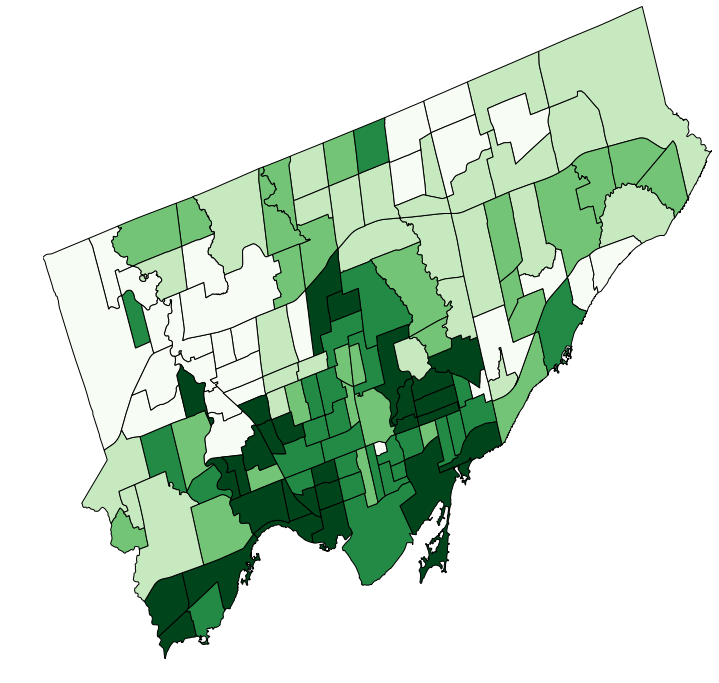

In [70]:
geoplot.choropleth(df_neighbourhoods, hue='Score', cmap='Greens', figsize=(12,12))